# Model Output Analysis

```bash
# create "finalized_model_{ts}.sav" within the model folder
python3 train_model data model

# do this 9 more times
for i in {1..9}; do python3 train_model.py data model; done
```

In [1]:
import os
import csv
import json
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import joblib
import xgboost
from sklearn.metrics import plot_confusion_matrix, f1_score
from tqdm import tqdm_notebook

from util.evaluate_12ECG_score import load_table, load_weights
from train_12ECG_classifier import _get_fieldnames

In [2]:
# Load the SNOMED_CT Mapping to DX
with open("data/snomed_ct_dx_map.json", "r") as f:
    SNOMED_CODE_MAP = json.load(f)

# Load the scored labels and weights
rows, _cols, _vals = load_table("evaluation-2020/weights.csv")
scored_codes = [int(r) for r in rows]


In [3]:
# output_folder = "mrr_model"
# output_folder = "mean_model" # best, submission
output_folder = "paper_models" # generated importances

In [4]:
with open(os.path.join(output_folder, "features.csv"), "r") as f:
    reader = csv.reader(f)
    header = next(reader)

# load the cached ECG record features
data_cache_fp = os.path.join(output_folder, "features.csv")
data_cache = pd.read_csv(data_cache_fp, header=0, names=header, index_col="header_file")

# convert the structured array into unstructured arrays
# to_features = [n for n in data_cache.dtype.names if n not in ("dx", "record_name", "seq_len")]
# with open("model/features.csv", "r") as f:
#     reader = csv.DictReader(f, fieldnames=_get_fieldnames())
#     header = next(reader)


In [5]:
label_cache = {}
with open(os.path.join(output_folder, "dxs.txt"), mode="r", newline="\n") as labelfile:
    for line in labelfile.readlines():
        header_file_path, dxs = json.loads(line)
        label_cache[header_file_path] = dxs

- complete right bundle branch block (code 713427006), covered by right bundle branch block (code 59118001)
- premature atrial contraction (code 284470004), covered by supraventricular premature beats (code 63593006)
- premature ventricular contractions (code 427172004), covered by ventricular ectopic beats (code 17338001)


In [6]:
# what features are we using?
for idx, field_name in enumerate(header[1:]):
    print(f"f{idx:<3}: {field_name}")

f0  : age
f1  : sex
f2  : I_ECG_Rate_Mean
f3  : I_HRV_RMSSD
f4  : I_HRV_MeanNN
f5  : I_HRV_SDNN
f6  : I_HRV_SDSD
f7  : I_HRV_CVNN
f8  : I_HRV_CVSD
f9  : I_HRV_MedianNN
f10 : I_HRV_MadNN
f11 : I_HRV_MCVNN
f12 : I_HRV_IQRNN
f13 : I_HRV_pNN50
f14 : I_HRV_pNN20
f15 : I_HRV_TINN
f16 : I_HRV_HTI
f17 : I_HRV_ULF
f18 : I_HRV_VLF
f19 : I_HRV_LF
f20 : I_HRV_HF
f21 : I_HRV_VHF
f22 : I_HRV_LFHF
f23 : I_HRV_LFn
f24 : I_HRV_HFn
f25 : I_HRV_LnHF
f26 : I_HRV_SD1
f27 : I_HRV_SD2
f28 : I_HRV_SD1SD2
f29 : I_HRV_S
f30 : I_HRV_CSI
f31 : I_HRV_CVI
f32 : I_HRV_CSI_Modified
f33 : I_HRV_PIP
f34 : I_HRV_IALS
f35 : I_HRV_PSS
f36 : I_HRV_PAS
f37 : I_HRV_GI
f38 : I_HRV_SI
f39 : I_HRV_AI
f40 : I_HRV_PI
f41 : I_HRV_C1d
f42 : I_HRV_C1a
f43 : I_HRV_SD1d
f44 : I_HRV_SD1a
f45 : I_HRV_C2d
f46 : I_HRV_C2a
f47 : I_HRV_SD2d
f48 : I_HRV_SD2a
f49 : I_HRV_Cd
f50 : I_HRV_Ca
f51 : I_HRV_SDNNd
f52 : I_HRV_SDNNa
f53 : I_HRV_ApEn
f54 : I_HRV_SampEn
f55 : I_hb__abs_energy
f56 : I_hb__absolute_sum_of_changes
f57 : I_hb__agg_autocorre

# Experiment Specific Outputs

In [7]:
# load the experiment save files

# Using only "dx" value (weight=1.0)
experiment_fps = tuple(sorted(glob(os.path.join(output_folder, "finalized_model_*.sav"))))

print(experiment_fps)

print(len(experiment_fps))
# no label rebalancing
# original: finalized_model_1594761951.sav to finalized_model_1594766304.sav, or first 100

('paper_models/finalized_model_1596690645.sav', 'paper_models/finalized_model_1596697134.sav', 'paper_models/finalized_model_1596703703.sav', 'paper_models/finalized_model_1596710087.sav', 'paper_models/finalized_model_1596716525.sav', 'paper_models/finalized_model_1596723012.sav', 'paper_models/finalized_model_1596729282.sav', 'paper_models/finalized_model_1596735892.sav', 'paper_models/finalized_model_1596742020.sav', 'paper_models/finalized_model_1596748541.sav', 'paper_models/finalized_model_1596754719.sav', 'paper_models/finalized_model_1596760986.sav', 'paper_models/finalized_model_1596767382.sav', 'paper_models/finalized_model_1596773362.sav', 'paper_models/finalized_model_1596779758.sav', 'paper_models/finalized_model_1596786182.sav', 'paper_models/finalized_model_1596792206.sav', 'paper_models/finalized_model_1596798583.sav', 'paper_models/finalized_model_1596805005.sav', 'paper_models/finalized_model_1596811151.sav', 'paper_models/finalized_model_1596817740.sav', 'paper_model

# Challenge Relevant Scores
Show the challenge reported scores on the evaluation set

In [8]:
challenge_summary_outputs = {}

# with tqdm_notebook(experiment_fps) as t:
for experiment_fp in experiment_fps:
    print(f"{experiment_fp} results...")
    experiment = joblib.load(experiment_fp)

    for k in ['auroc', 'auprc', 'accuracy', 'f_measure', 
          'f_beta_measure', 'g_beta_measure', 'challenge_metric']:
        cso = challenge_summary_outputs.get(k, [])
        cso.append(experiment[k])
        challenge_summary_outputs[k] = cso


paper_models/finalized_model_1596690645.sav results...
paper_models/finalized_model_1596697134.sav results...
paper_models/finalized_model_1596703703.sav results...
paper_models/finalized_model_1596710087.sav results...
paper_models/finalized_model_1596716525.sav results...
paper_models/finalized_model_1596723012.sav results...
paper_models/finalized_model_1596729282.sav results...
paper_models/finalized_model_1596735892.sav results...
paper_models/finalized_model_1596742020.sav results...
paper_models/finalized_model_1596748541.sav results...
paper_models/finalized_model_1596754719.sav results...
paper_models/finalized_model_1596760986.sav results...
paper_models/finalized_model_1596767382.sav results...
paper_models/finalized_model_1596773362.sav results...
paper_models/finalized_model_1596779758.sav results...
paper_models/finalized_model_1596786182.sav results...
paper_models/finalized_model_1596792206.sav results...
paper_models/finalized_model_1596798583.sav results...
paper_mode

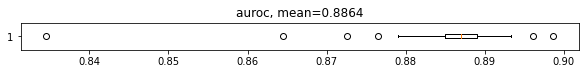

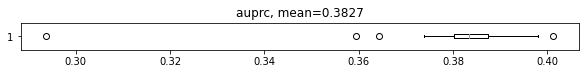

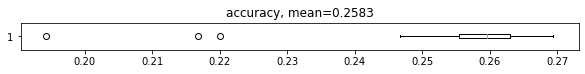

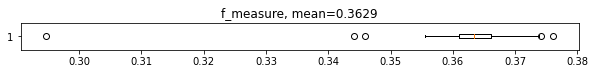

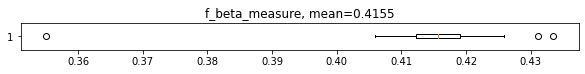

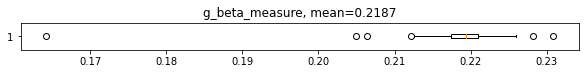

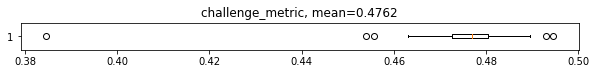

auroc
	DescribeResult(nobs=108, minmax=(0.8345052097333201, 0.898652840124914), mean=0.8864396552667801, variance=4.3471336697107055e-05, skewness=-4.906900922645209, kurtosis=34.989859461640116)
auprc
	DescribeResult(nobs=108, minmax=(0.2937169447202192, 0.4012140431663518), mean=0.38274279246452036, variance=0.00011243413711334505, skewness=-5.539488549580713, kurtosis=44.46120576790196)
accuracy
	DescribeResult(nobs=108, minmax=(0.1942325297528227, 0.26940921744509744), mean=0.25828401862808403, variance=9.631783498978938e-05, skewness=-3.7828770893068406, kurtosis=19.50760304755728)
f_measure
	DescribeResult(nobs=108, minmax=(0.2947004936151157, 0.3761056384772057), mean=0.3629041613357237, variance=6.728985255552855e-05, skewness=-5.427522780658387, kurtosis=42.77551383832856)
f_beta_measure
	DescribeResult(nobs=108, minmax=(0.35500899075982667, 0.4334970913190885), mean=0.4154579599172255, variance=6.09822647239046e-05, skewness=-4.077064246149843, kurtosis=31.61078648691644)
g_b

In [9]:
all_desc_stats = {}
for k, v in challenge_summary_outputs.items():
    fig1, ax1 = plt.subplots(figsize=(10, 0.5))
    desc_stats = sp.stats.describe(v)
    all_desc_stats[k] = desc_stats
    ax1.set_title(f"{k}, mean={desc_stats.mean:.4f}")
    ax1.boxplot(v, vert=False)
    plt.show()

for k, v in all_desc_stats.items():
    print(f"{k}\n\t{v}")

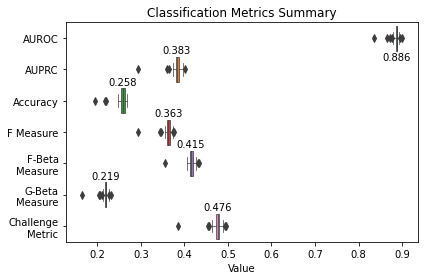

In [10]:
# print(challenge_summary_outputs)
box_plot_dict = {"Metric": [], "Value": []}
for k, v in challenge_summary_outputs.items():
    if k == "auroc":
        k_disp = "AUROC"
    elif k == "auprc":
        k_disp = "AUPRC"
    elif k == "accuracy":
        k_disp = "Accuracy"
    elif k == "f_measure":
        k_disp = "F Measure"
    elif k == "f_beta_measure":
        k_disp = "F-Beta\nMeasure"
    elif k == "g_beta_measure":
        k_disp = "G-Beta\nMeasure"
    elif k == "challenge_metric":
        k_disp = "Challenge\nMetric"
    box_plot_dict["Metric"] += [k_disp, ] * len(v)
    box_plot_dict["Value"] += v

bp_df = pd.DataFrame(box_plot_dict)
ax = sns.boxplot(
    y="Metric", x="Value", data=bp_df, linewidth=0.7
)
mean = bp_df.groupby(["Metric"])["Value"].mean()

# print(medians)

# medians
metric_ref = ["AUROC", "AUPRC", "Accuracy", "F Measure", "F-Beta\nMeasure", "G-Beta\nMeasure", "Challenge\nMetric"]

for ytick in ax.get_yticklabels():
    ytick_name = ytick.get_text()
    val_output = f"{mean[ytick_name]:.3f}"
    x_offset = mean[ytick_name]
    if mean[ytick_name] > 0.5:
        ha = "center"
        x_offset -= 0
    else:
        ha = "center"
        x_offset += 0
    y_offset = metric_ref.index(ytick_name)
    if metric_ref.index(ytick_name) >= 1:
        y_offset -= 0.6
    else:
        y_offset += 0.6
    ax.annotate(
        val_output,
        xy=(mean[ytick_name], metric_ref.index(ytick_name)),
        xytext=(x_offset, y_offset),
#         arrowprops={"arrowstyle": "-"},
        horizontalalignment=ha,
        verticalalignment="center"
    )
# print(dir(ax))
ax.set_ylabel("")
ax.set_title("Classification Metrics Summary")
plt.tight_layout()

plt.savefig(os.path.join(output_folder, "classification_metrics.png"), bbox_inches="tight", dpi=300)
plt.show()


# Confusion Matrix

In [11]:
def plot_experiment_confusion_matrices(experiment_fp):
    experiment = joblib.load(experiment_fp)
    train_records = experiment.pop("train_records")
    eval_records = experiment.pop("eval_records")

    # get the evaluation records
    
    raw_dx_evals = []

#     for (record_name, dc_row) in data_cache.iterrows():
#         if record_name in eval_records:
#             raw_data_eval = dc_row.to_numpy()

#             raw_data_evals.append(raw_data_eval)
#             raw_dx_evals.append(label_cache[record_name])
#     data_evals = np.stack(raw_data_evals)

    data_evals = data_cache.loc[eval_records]
    for (record_name, dc_row) in data_evals.iterrows():
        if record_name in eval_records:
            raw_dx_evals.append(label_cache[record_name])

    for sc in scored_codes:
        _abbrv, dx = SNOMED_CODE_MAP[str(sc)]
        
        # hardcoded duplicate classifiers based on label scoring weights
        dsc = None
        if sc == 713427006:
            # A: 713427006 and 59118001
            dsc = 59118001
        elif sc == 284470004:
            # B: 284470004 and 63593006
            dsc = 63593006
        elif sc == 427172004:
            # C: 427172004 and 17338001
            dsc = 17338001

        if dsc is not None:
            _, ddx = SNOMED_CODE_MAP[str(dsc)]
            print(f"Skipping {dx} (code {sc}), covered by {ddx} (code {dsc})")
            continue

        print(f"Classifier evaluation results for {dx} (code {sc})...")

        isc = None
        if sc == 59118001:
            isc = 713427006
        elif sc == 63593006:
            isc = 284470004
        elif sc == 17338001:
            isc = 427172004
        
        if isc is not None:
            _, idx = SNOMED_CODE_MAP[str(isc)]
            print(f"\tIncluding {idx} (code {isc})")

        eval_labels = []
        for raw_dx_eval in raw_dx_evals:
            pos = (sc in raw_dx_eval) or (isc is not None and isc in raw_dx_eval)
            eval_labels.append(pos)
        
        try:
            model = experiment[str(sc)]
        except KeyError:
            model = experiment[int(sc)]
        xgb_params = model.get_xgb_params()
        disp_params = {**xgb_params, 'monotone_constraints': None}
        print(disp_params)
        # print(f"scale_pos_weight: {xgb_params['scale_pos_weight']:.4f}")

        #fig, axs = plt.subplots(nrows=1, ncols=2)
        fig = plt.figure(constrained_layout=True, figsize=(14, 4))
        fig.suptitle(dx, x=0, y=1, horizontalalignment="left", fontsize=20)
        gs = fig.add_gridspec(1, 3)
        ax0 = fig.add_subplot(gs[0, 0])
        ax0.set_title("Evaluation")
        ax1 = fig.add_subplot(gs[0, 1:])
        
        # normalize must be one of {'true', 'pred', 'all', None}
        disp = plot_confusion_matrix(
            model, data_evals, eval_labels, normalize=None, ax=ax0,
        )
        # https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.plot_importance
        importance_type = "weight" # weight, gain, cover
        importance_title = f"Feature Importance by {importance_type}"
        ax = xgboost.plot_importance(
            model, height=0.2, max_num_features=15, ax=ax1,
            title=importance_title, importance_type=importance_type)
        plt.show()


In [12]:
# plot_experiment_confusion_matrices(experiment_fps[1])
# plot_experiment_confusion_matrices(experiment_fps[1])  # so on...

# F1-Scores across all experiments

In [13]:

f1_box_plot_data = {}

for experiment_fp in experiment_fps:
    print(f"{experiment_fp} results...")
    experiment = joblib.load(experiment_fp)
    train_records = experiment.pop("train_records")
    eval_records = experiment.pop("eval_records")
    
    raw_dx_evals = []

    data_evals = data_cache.loc[eval_records]
    for (record_name, dc_row) in data_evals.iterrows():
        if record_name in eval_records:
            raw_dx_evals.append(label_cache[record_name])

    for sc in scored_codes:
        abbrv, dx = SNOMED_CODE_MAP[str(sc)]

        # hardcoded duplicate classifiers based on label scoring weights
        dsc = None
        if sc == 713427006:
            # A: 713427006 and 59118001
            dsc = 59118001
        elif sc == 284470004:
            # B: 284470004 and 63593006
            dsc = 63593006
        elif sc == 427172004:
            # C: 427172004 and 17338001
            dsc = 17338001

        if dsc is not None:
            #_, ddx = SNOMED_CODE_MAP[str(dsc)]
            #print(f"Skipping {dx} (code {sc}), covered by {ddx} (code {dsc})")
            continue

        isc = None
        if sc == 59118001:
            isc = 713427006
        elif sc == 63593006:
            isc = 284470004
        elif sc == 17338001:
            isc = 427172004
        
        if isc is not None:
            _, idx = SNOMED_CODE_MAP[str(isc)]

        eval_labels = []
        for raw_dx_eval in raw_dx_evals:
            pos = (sc in raw_dx_eval) or (isc is not None and isc in raw_dx_eval)
            eval_labels.append(pos)
        
        try:
            model = experiment[str(sc)]
        except KeyError:
            model = experiment[int(sc)]

        # normalize must be one of {'true', 'pred', 'all', None}
        pred = model.predict(data_evals)
        f1 = f1_score(eval_labels, pred)
        # print(f"\t{dx} ({abbrv}) (code {sc}) F1_Score:", f1)

        f1_box_plot_data[abbrv] = f1_box_plot_data.get(abbrv, []) + [f1,]



paper_models/finalized_model_1596690645.sav results...
paper_models/finalized_model_1596697134.sav results...
paper_models/finalized_model_1596703703.sav results...
paper_models/finalized_model_1596710087.sav results...
paper_models/finalized_model_1596716525.sav results...
paper_models/finalized_model_1596723012.sav results...
paper_models/finalized_model_1596729282.sav results...
paper_models/finalized_model_1596735892.sav results...
paper_models/finalized_model_1596742020.sav results...
paper_models/finalized_model_1596748541.sav results...
paper_models/finalized_model_1596754719.sav results...
paper_models/finalized_model_1596760986.sav results...
paper_models/finalized_model_1596767382.sav results...
paper_models/finalized_model_1596773362.sav results...
paper_models/finalized_model_1596779758.sav results...
paper_models/finalized_model_1596786182.sav results...
paper_models/finalized_model_1596792206.sav results...
paper_models/finalized_model_1596798583.sav results...
paper_mode

ValueError: feature_names mismatch: ['age', 'sex', 'I_ECG_Rate_Mean', 'I_HRV_RMSSD', 'I_HRV_MeanNN', 'I_HRV_SDNN', 'I_HRV_SDSD', 'I_HRV_CVNN', 'I_HRV_CVSD', 'I_HRV_MedianNN', 'I_HRV_MadNN', 'I_HRV_MCVNN', 'I_HRV_IQRNN', 'I_HRV_pNN50', 'I_HRV_pNN20', 'I_HRV_TINN', 'I_HRV_HTI', 'I_HRV_HF', 'I_HRV_HFn', 'I_HRV_SD2', 'I_HRV_SD1SD2', 'I_HRV_S', 'I_HRV_CSI', 'I_HRV_CSI_Modified', 'I_HRV_PIP', 'I_HRV_IALS', 'I_HRV_PAS', 'I_HRV_GI', 'I_HRV_SI', 'I_HRV_PI', 'I_HRV_C1d', 'I_HRV_C1a', 'I_HRV_SD1d', 'I_HRV_SD1a', 'I_HRV_C2d', 'I_HRV_SD2d', 'I_HRV_SD2a', 'I_HRV_Cd', 'I_HRV_Ca', 'I_HRV_SDNNd', 'I_HRV_SDNNa', 'I_HRV_ApEn', 'I_HRV_SampEn', 'I_hb__abs_energy', 'I_hb__absolute_sum_of_changes', 'I_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'I_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'I_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'I_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'I_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'I_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'I_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'I_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'I_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'I_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'I_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'I_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'I_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'I_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'I_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'I_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'I_hb__approximate_entropy__m_2__r_0.1', 'I_hb__approximate_entropy__m_2__r_0.3', 'I_hb__approximate_entropy__m_2__r_0.5', 'I_hb__approximate_entropy__m_2__r_0.7', 'I_hb__approximate_entropy__m_2__r_0.9', 'I_hb__ar_coefficient__coeff_0__k_10', 'I_hb__ar_coefficient__coeff_10__k_10', 'I_hb__ar_coefficient__coeff_1__k_10', 'I_hb__ar_coefficient__coeff_2__k_10', 'I_hb__ar_coefficient__coeff_3__k_10', 'I_hb__ar_coefficient__coeff_4__k_10', 'I_hb__ar_coefficient__coeff_5__k_10', 'I_hb__ar_coefficient__coeff_6__k_10', 'I_hb__ar_coefficient__coeff_7__k_10', 'I_hb__ar_coefficient__coeff_8__k_10', 'I_hb__ar_coefficient__coeff_9__k_10', 'I_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'I_hb__autocorrelation__lag_1', 'I_hb__autocorrelation__lag_2', 'I_hb__autocorrelation__lag_3', 'I_hb__autocorrelation__lag_4', 'I_hb__autocorrelation__lag_5', 'I_hb__autocorrelation__lag_6', 'I_hb__autocorrelation__lag_7', 'I_hb__autocorrelation__lag_8', 'I_hb__autocorrelation__lag_9', 'I_hb__binned_entropy__max_bins_10', 'I_hb__c3__lag_1', 'I_hb__c3__lag_2', 'I_hb__c3__lag_3', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'I_hb__cid_ce__normalize_False', 'I_hb__cid_ce__normalize_True', 'I_hb__count_above__t_0', 'I_hb__count_above_mean', 'I_hb__count_below_mean', 'I_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'I_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'I_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'I_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'I_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'I_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'I_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'I_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'I_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'I_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'I_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'I_hb__fft_aggregated__aggtype_"centroid"', 'I_hb__fft_aggregated__aggtype_"kurtosis"', 'I_hb__fft_aggregated__aggtype_"skew"', 'I_hb__fft_aggregated__aggtype_"variance"', 'I_hb__fft_coefficient__attr_"abs"__coeff_0', 'I_hb__fft_coefficient__attr_"abs"__coeff_1', 'I_hb__fft_coefficient__attr_"abs"__coeff_10', 'I_hb__fft_coefficient__attr_"abs"__coeff_11', 'I_hb__fft_coefficient__attr_"abs"__coeff_12', 'I_hb__fft_coefficient__attr_"abs"__coeff_13', 'I_hb__fft_coefficient__attr_"abs"__coeff_14', 'I_hb__fft_coefficient__attr_"abs"__coeff_15', 'I_hb__fft_coefficient__attr_"abs"__coeff_16', 'I_hb__fft_coefficient__attr_"abs"__coeff_17', 'I_hb__fft_coefficient__attr_"abs"__coeff_18', 'I_hb__fft_coefficient__attr_"abs"__coeff_19', 'I_hb__fft_coefficient__attr_"abs"__coeff_2', 'I_hb__fft_coefficient__attr_"abs"__coeff_20', 'I_hb__fft_coefficient__attr_"abs"__coeff_21', 'I_hb__fft_coefficient__attr_"abs"__coeff_22', 'I_hb__fft_coefficient__attr_"abs"__coeff_23', 'I_hb__fft_coefficient__attr_"abs"__coeff_24', 'I_hb__fft_coefficient__attr_"abs"__coeff_25', 'I_hb__fft_coefficient__attr_"abs"__coeff_26', 'I_hb__fft_coefficient__attr_"abs"__coeff_27', 'I_hb__fft_coefficient__attr_"abs"__coeff_28', 'I_hb__fft_coefficient__attr_"abs"__coeff_29', 'I_hb__fft_coefficient__attr_"abs"__coeff_3', 'I_hb__fft_coefficient__attr_"abs"__coeff_30', 'I_hb__fft_coefficient__attr_"abs"__coeff_31', 'I_hb__fft_coefficient__attr_"abs"__coeff_32', 'I_hb__fft_coefficient__attr_"abs"__coeff_33', 'I_hb__fft_coefficient__attr_"abs"__coeff_34', 'I_hb__fft_coefficient__attr_"abs"__coeff_35', 'I_hb__fft_coefficient__attr_"abs"__coeff_36', 'I_hb__fft_coefficient__attr_"abs"__coeff_37', 'I_hb__fft_coefficient__attr_"abs"__coeff_39', 'I_hb__fft_coefficient__attr_"abs"__coeff_4', 'I_hb__fft_coefficient__attr_"abs"__coeff_40', 'I_hb__fft_coefficient__attr_"abs"__coeff_41', 'I_hb__fft_coefficient__attr_"abs"__coeff_42', 'I_hb__fft_coefficient__attr_"abs"__coeff_5', 'I_hb__fft_coefficient__attr_"abs"__coeff_6', 'I_hb__fft_coefficient__attr_"abs"__coeff_67', 'I_hb__fft_coefficient__attr_"abs"__coeff_7', 'I_hb__fft_coefficient__attr_"abs"__coeff_72', 'I_hb__fft_coefficient__attr_"abs"__coeff_8', 'I_hb__fft_coefficient__attr_"abs"__coeff_9', 'I_hb__fft_coefficient__attr_"angle"__coeff_1', 'I_hb__fft_coefficient__attr_"angle"__coeff_10', 'I_hb__fft_coefficient__attr_"angle"__coeff_11', 'I_hb__fft_coefficient__attr_"angle"__coeff_12', 'I_hb__fft_coefficient__attr_"angle"__coeff_13', 'I_hb__fft_coefficient__attr_"angle"__coeff_14', 'I_hb__fft_coefficient__attr_"angle"__coeff_15', 'I_hb__fft_coefficient__attr_"angle"__coeff_16', 'I_hb__fft_coefficient__attr_"angle"__coeff_17', 'I_hb__fft_coefficient__attr_"angle"__coeff_18', 'I_hb__fft_coefficient__attr_"angle"__coeff_19', 'I_hb__fft_coefficient__attr_"angle"__coeff_2', 'I_hb__fft_coefficient__attr_"angle"__coeff_20', 'I_hb__fft_coefficient__attr_"angle"__coeff_21', 'I_hb__fft_coefficient__attr_"angle"__coeff_22', 'I_hb__fft_coefficient__attr_"angle"__coeff_23', 'I_hb__fft_coefficient__attr_"angle"__coeff_24', 'I_hb__fft_coefficient__attr_"angle"__coeff_25', 'I_hb__fft_coefficient__attr_"angle"__coeff_26', 'I_hb__fft_coefficient__attr_"angle"__coeff_27', 'I_hb__fft_coefficient__attr_"angle"__coeff_28', 'I_hb__fft_coefficient__attr_"angle"__coeff_29', 'I_hb__fft_coefficient__attr_"angle"__coeff_3', 'I_hb__fft_coefficient__attr_"angle"__coeff_30', 'I_hb__fft_coefficient__attr_"angle"__coeff_31', 'I_hb__fft_coefficient__attr_"angle"__coeff_32', 'I_hb__fft_coefficient__attr_"angle"__coeff_33', 'I_hb__fft_coefficient__attr_"angle"__coeff_34', 'I_hb__fft_coefficient__attr_"angle"__coeff_35', 'I_hb__fft_coefficient__attr_"angle"__coeff_36', 'I_hb__fft_coefficient__attr_"angle"__coeff_37', 'I_hb__fft_coefficient__attr_"angle"__coeff_38', 'I_hb__fft_coefficient__attr_"angle"__coeff_39', 'I_hb__fft_coefficient__attr_"angle"__coeff_4', 'I_hb__fft_coefficient__attr_"angle"__coeff_40', 'I_hb__fft_coefficient__attr_"angle"__coeff_41', 'I_hb__fft_coefficient__attr_"angle"__coeff_42', 'I_hb__fft_coefficient__attr_"angle"__coeff_43', 'I_hb__fft_coefficient__attr_"angle"__coeff_44', 'I_hb__fft_coefficient__attr_"angle"__coeff_45', 'I_hb__fft_coefficient__attr_"angle"__coeff_46', 'I_hb__fft_coefficient__attr_"angle"__coeff_47', 'I_hb__fft_coefficient__attr_"angle"__coeff_48', 'I_hb__fft_coefficient__attr_"angle"__coeff_49', 'I_hb__fft_coefficient__attr_"angle"__coeff_5', 'I_hb__fft_coefficient__attr_"angle"__coeff_50', 'I_hb__fft_coefficient__attr_"angle"__coeff_51', 'I_hb__fft_coefficient__attr_"angle"__coeff_52', 'I_hb__fft_coefficient__attr_"angle"__coeff_53', 'I_hb__fft_coefficient__attr_"angle"__coeff_54', 'I_hb__fft_coefficient__attr_"angle"__coeff_55', 'I_hb__fft_coefficient__attr_"angle"__coeff_56', 'I_hb__fft_coefficient__attr_"angle"__coeff_57', 'I_hb__fft_coefficient__attr_"angle"__coeff_59', 'I_hb__fft_coefficient__attr_"angle"__coeff_6', 'I_hb__fft_coefficient__attr_"angle"__coeff_60', 'I_hb__fft_coefficient__attr_"angle"__coeff_61', 'I_hb__fft_coefficient__attr_"angle"__coeff_62', 'I_hb__fft_coefficient__attr_"angle"__coeff_63', 'I_hb__fft_coefficient__attr_"angle"__coeff_64', 'I_hb__fft_coefficient__attr_"angle"__coeff_65', 'I_hb__fft_coefficient__attr_"angle"__coeff_66', 'I_hb__fft_coefficient__attr_"angle"__coeff_67', 'I_hb__fft_coefficient__attr_"angle"__coeff_68', 'I_hb__fft_coefficient__attr_"angle"__coeff_69', 'I_hb__fft_coefficient__attr_"angle"__coeff_7', 'I_hb__fft_coefficient__attr_"angle"__coeff_70', 'I_hb__fft_coefficient__attr_"angle"__coeff_71', 'I_hb__fft_coefficient__attr_"angle"__coeff_72', 'I_hb__fft_coefficient__attr_"angle"__coeff_73', 'I_hb__fft_coefficient__attr_"angle"__coeff_74', 'I_hb__fft_coefficient__attr_"angle"__coeff_75', 'I_hb__fft_coefficient__attr_"angle"__coeff_76', 'I_hb__fft_coefficient__attr_"angle"__coeff_77', 'I_hb__fft_coefficient__attr_"angle"__coeff_79', 'I_hb__fft_coefficient__attr_"angle"__coeff_8', 'I_hb__fft_coefficient__attr_"angle"__coeff_80', 'I_hb__fft_coefficient__attr_"angle"__coeff_81', 'I_hb__fft_coefficient__attr_"angle"__coeff_82', 'I_hb__fft_coefficient__attr_"angle"__coeff_83', 'I_hb__fft_coefficient__attr_"angle"__coeff_84', 'I_hb__fft_coefficient__attr_"angle"__coeff_85', 'I_hb__fft_coefficient__attr_"angle"__coeff_86', 'I_hb__fft_coefficient__attr_"angle"__coeff_87', 'I_hb__fft_coefficient__attr_"angle"__coeff_89', 'I_hb__fft_coefficient__attr_"angle"__coeff_9', 'I_hb__fft_coefficient__attr_"angle"__coeff_91', 'I_hb__fft_coefficient__attr_"angle"__coeff_92', 'I_hb__fft_coefficient__attr_"angle"__coeff_93', 'I_hb__fft_coefficient__attr_"angle"__coeff_94', 'I_hb__fft_coefficient__attr_"angle"__coeff_95', 'I_hb__fft_coefficient__attr_"angle"__coeff_96', 'I_hb__fft_coefficient__attr_"angle"__coeff_99', 'I_hb__fft_coefficient__attr_"imag"__coeff_1', 'I_hb__fft_coefficient__attr_"imag"__coeff_10', 'I_hb__fft_coefficient__attr_"imag"__coeff_11', 'I_hb__fft_coefficient__attr_"imag"__coeff_12', 'I_hb__fft_coefficient__attr_"imag"__coeff_13', 'I_hb__fft_coefficient__attr_"imag"__coeff_14', 'I_hb__fft_coefficient__attr_"imag"__coeff_15', 'I_hb__fft_coefficient__attr_"imag"__coeff_16', 'I_hb__fft_coefficient__attr_"imag"__coeff_17', 'I_hb__fft_coefficient__attr_"imag"__coeff_19', 'I_hb__fft_coefficient__attr_"imag"__coeff_2', 'I_hb__fft_coefficient__attr_"imag"__coeff_21', 'I_hb__fft_coefficient__attr_"imag"__coeff_22', 'I_hb__fft_coefficient__attr_"imag"__coeff_23', 'I_hb__fft_coefficient__attr_"imag"__coeff_24', 'I_hb__fft_coefficient__attr_"imag"__coeff_25', 'I_hb__fft_coefficient__attr_"imag"__coeff_3', 'I_hb__fft_coefficient__attr_"imag"__coeff_30', 'I_hb__fft_coefficient__attr_"imag"__coeff_32', 'I_hb__fft_coefficient__attr_"imag"__coeff_33', 'I_hb__fft_coefficient__attr_"imag"__coeff_34', 'I_hb__fft_coefficient__attr_"imag"__coeff_4', 'I_hb__fft_coefficient__attr_"imag"__coeff_5', 'I_hb__fft_coefficient__attr_"imag"__coeff_6', 'I_hb__fft_coefficient__attr_"imag"__coeff_7', 'I_hb__fft_coefficient__attr_"imag"__coeff_8', 'I_hb__fft_coefficient__attr_"imag"__coeff_9', 'I_hb__fft_coefficient__attr_"imag"__coeff_95', 'I_hb__fft_coefficient__attr_"real"__coeff_0', 'I_hb__fft_coefficient__attr_"real"__coeff_1', 'I_hb__fft_coefficient__attr_"real"__coeff_10', 'I_hb__fft_coefficient__attr_"real"__coeff_11', 'I_hb__fft_coefficient__attr_"real"__coeff_12', 'I_hb__fft_coefficient__attr_"real"__coeff_13', 'I_hb__fft_coefficient__attr_"real"__coeff_14', 'I_hb__fft_coefficient__attr_"real"__coeff_15', 'I_hb__fft_coefficient__attr_"real"__coeff_16', 'I_hb__fft_coefficient__attr_"real"__coeff_17', 'I_hb__fft_coefficient__attr_"real"__coeff_18', 'I_hb__fft_coefficient__attr_"real"__coeff_19', 'I_hb__fft_coefficient__attr_"real"__coeff_2', 'I_hb__fft_coefficient__attr_"real"__coeff_20', 'I_hb__fft_coefficient__attr_"real"__coeff_21', 'I_hb__fft_coefficient__attr_"real"__coeff_22', 'I_hb__fft_coefficient__attr_"real"__coeff_23', 'I_hb__fft_coefficient__attr_"real"__coeff_25', 'I_hb__fft_coefficient__attr_"real"__coeff_26', 'I_hb__fft_coefficient__attr_"real"__coeff_27', 'I_hb__fft_coefficient__attr_"real"__coeff_28', 'I_hb__fft_coefficient__attr_"real"__coeff_29', 'I_hb__fft_coefficient__attr_"real"__coeff_3', 'I_hb__fft_coefficient__attr_"real"__coeff_30', 'I_hb__fft_coefficient__attr_"real"__coeff_33', 'I_hb__fft_coefficient__attr_"real"__coeff_34', 'I_hb__fft_coefficient__attr_"real"__coeff_35', 'I_hb__fft_coefficient__attr_"real"__coeff_36', 'I_hb__fft_coefficient__attr_"real"__coeff_37', 'I_hb__fft_coefficient__attr_"real"__coeff_38', 'I_hb__fft_coefficient__attr_"real"__coeff_39', 'I_hb__fft_coefficient__attr_"real"__coeff_4', 'I_hb__fft_coefficient__attr_"real"__coeff_40', 'I_hb__fft_coefficient__attr_"real"__coeff_5', 'I_hb__fft_coefficient__attr_"real"__coeff_51', 'I_hb__fft_coefficient__attr_"real"__coeff_56', 'I_hb__fft_coefficient__attr_"real"__coeff_6', 'I_hb__fft_coefficient__attr_"real"__coeff_65', 'I_hb__fft_coefficient__attr_"real"__coeff_7', 'I_hb__fft_coefficient__attr_"real"__coeff_8', 'I_hb__fft_coefficient__attr_"real"__coeff_9', 'I_hb__first_location_of_maximum', 'I_hb__first_location_of_minimum', 'I_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'I_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'I_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'I_hb__index_mass_quantile__q_0.1', 'I_hb__index_mass_quantile__q_0.2', 'I_hb__index_mass_quantile__q_0.3', 'I_hb__index_mass_quantile__q_0.4', 'I_hb__index_mass_quantile__q_0.6', 'I_hb__index_mass_quantile__q_0.7', 'I_hb__index_mass_quantile__q_0.8', 'I_hb__index_mass_quantile__q_0.9', 'I_hb__kurtosis', 'I_hb__last_location_of_maximum', 'I_hb__last_location_of_minimum', 'I_hb__length', 'I_hb__linear_trend__attr_"pvalue"', 'I_hb__longest_strike_above_mean', 'I_hb__longest_strike_below_mean', 'I_hb__max_langevin_fixed_point__m_3__r_30', 'I_hb__maximum', 'I_hb__mean', 'I_hb__mean_second_derivative_central', 'I_hb__median', 'I_hb__minimum', 'I_hb__number_crossing_m__m_0', 'I_hb__number_cwt_peaks__n_1', 'I_hb__number_cwt_peaks__n_5', 'I_hb__number_peaks__n_5', 'I_hb__number_peaks__n_50', 'I_hb__partial_autocorrelation__lag_2', 'I_hb__partial_autocorrelation__lag_3', 'I_hb__partial_autocorrelation__lag_4', 'I_hb__partial_autocorrelation__lag_5', 'I_hb__partial_autocorrelation__lag_6', 'I_hb__partial_autocorrelation__lag_7', 'I_hb__partial_autocorrelation__lag_8', 'I_hb__partial_autocorrelation__lag_9', 'I_hb__quantile__q_0.2', 'I_hb__quantile__q_0.3', 'I_hb__quantile__q_0.4', 'I_hb__quantile__q_0.6', 'I_hb__quantile__q_0.7', 'I_hb__quantile__q_0.8', 'I_hb__quantile__q_0.9', 'I_hb__range_count__max_1000000000000.0__min_0', 'I_hb__range_count__max_1__min_-1', 'I_hb__ratio_beyond_r_sigma__r_0.5', 'I_hb__ratio_beyond_r_sigma__r_1', 'I_hb__ratio_beyond_r_sigma__r_1.5', 'I_hb__ratio_beyond_r_sigma__r_2', 'I_hb__ratio_beyond_r_sigma__r_2.5', 'I_hb__ratio_beyond_r_sigma__r_3', 'I_hb__ratio_beyond_r_sigma__r_5', 'I_hb__sample_entropy', 'I_hb__skewness', 'I_hb__spkt_welch_density__coeff_2', 'I_hb__spkt_welch_density__coeff_8', 'I_hb__standard_deviation', 'I_hb__time_reversal_asymmetry_statistic__lag_1', 'I_hb__time_reversal_asymmetry_statistic__lag_2', 'I_hb__time_reversal_asymmetry_statistic__lag_3', 'I_hb__variation_coefficient', 'I_sig__absolute_sum_of_changes', 'I_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'I_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'I_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'I_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'I_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'I_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'I_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'I_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'I_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'I_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'I_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'I_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'I_sig__approximate_entropy__m_2__r_0.1', 'I_sig__approximate_entropy__m_2__r_0.3', 'I_sig__approximate_entropy__m_2__r_0.5', 'I_sig__approximate_entropy__m_2__r_0.7', 'I_sig__approximate_entropy__m_2__r_0.9', 'I_sig__ar_coefficient__coeff_0__k_10', 'I_sig__ar_coefficient__coeff_10__k_10', 'I_sig__ar_coefficient__coeff_1__k_10', 'I_sig__ar_coefficient__coeff_2__k_10', 'I_sig__ar_coefficient__coeff_3__k_10', 'I_sig__ar_coefficient__coeff_4__k_10', 'I_sig__ar_coefficient__coeff_5__k_10', 'I_sig__ar_coefficient__coeff_6__k_10', 'I_sig__ar_coefficient__coeff_7__k_10', 'I_sig__ar_coefficient__coeff_8__k_10', 'I_sig__ar_coefficient__coeff_9__k_10', 'I_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'I_sig__autocorrelation__lag_1', 'I_sig__autocorrelation__lag_2', 'I_sig__autocorrelation__lag_3', 'I_sig__autocorrelation__lag_4', 'I_sig__autocorrelation__lag_5', 'I_sig__autocorrelation__lag_6', 'I_sig__autocorrelation__lag_7', 'I_sig__autocorrelation__lag_8', 'I_sig__autocorrelation__lag_9', 'I_sig__binned_entropy__max_bins_10', 'I_sig__c3__lag_1', 'I_sig__c3__lag_2', 'I_sig__c3__lag_3', 'I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'I_sig__cid_ce__normalize_True', 'I_sig__count_above__t_0', 'I_sig__count_above_mean', 'I_sig__count_below_mean', 'I_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'I_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'I_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'I_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'I_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'I_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'I_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'I_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'I_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'I_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'I_sig__fft_aggregated__aggtype_"centroid"', 'I_sig__fft_aggregated__aggtype_"skew"', 'I_sig__fft_coefficient__attr_"abs"__coeff_0', 'I_sig__fft_coefficient__attr_"abs"__coeff_1', 'I_sig__fft_coefficient__attr_"abs"__coeff_10', 'I_sig__fft_coefficient__attr_"abs"__coeff_11', 'I_sig__fft_coefficient__attr_"abs"__coeff_12', 'I_sig__fft_coefficient__attr_"abs"__coeff_14', 'I_sig__fft_coefficient__attr_"abs"__coeff_15', 'I_sig__fft_coefficient__attr_"abs"__coeff_16', 'I_sig__fft_coefficient__attr_"abs"__coeff_17', 'I_sig__fft_coefficient__attr_"abs"__coeff_18', 'I_sig__fft_coefficient__attr_"abs"__coeff_19', 'I_sig__fft_coefficient__attr_"abs"__coeff_22', 'I_sig__fft_coefficient__attr_"abs"__coeff_24', 'I_sig__fft_coefficient__attr_"abs"__coeff_26', 'I_sig__fft_coefficient__attr_"abs"__coeff_3', 'I_sig__fft_coefficient__attr_"abs"__coeff_31', 'I_sig__fft_coefficient__attr_"abs"__coeff_4', 'I_sig__fft_coefficient__attr_"abs"__coeff_48', 'I_sig__fft_coefficient__attr_"abs"__coeff_5', 'I_sig__fft_coefficient__attr_"abs"__coeff_52', 'I_sig__fft_coefficient__attr_"abs"__coeff_6', 'I_sig__fft_coefficient__attr_"abs"__coeff_60', 'I_sig__fft_coefficient__attr_"abs"__coeff_63', 'I_sig__fft_coefficient__attr_"abs"__coeff_67', 'I_sig__fft_coefficient__attr_"abs"__coeff_7', 'I_sig__fft_coefficient__attr_"abs"__coeff_71', 'I_sig__fft_coefficient__attr_"abs"__coeff_72', 'I_sig__fft_coefficient__attr_"abs"__coeff_74', 'I_sig__fft_coefficient__attr_"abs"__coeff_79', 'I_sig__fft_coefficient__attr_"abs"__coeff_8', 'I_sig__fft_coefficient__attr_"abs"__coeff_81', 'I_sig__fft_coefficient__attr_"abs"__coeff_84', 'I_sig__fft_coefficient__attr_"abs"__coeff_85', 'I_sig__fft_coefficient__attr_"abs"__coeff_86', 'I_sig__fft_coefficient__attr_"abs"__coeff_90', 'I_sig__fft_coefficient__attr_"abs"__coeff_94', 'I_sig__fft_coefficient__attr_"abs"__coeff_96', 'I_sig__fft_coefficient__attr_"abs"__coeff_97', 'I_sig__fft_coefficient__attr_"abs"__coeff_98', 'I_sig__fft_coefficient__attr_"angle"__coeff_1', 'I_sig__fft_coefficient__attr_"angle"__coeff_10', 'I_sig__fft_coefficient__attr_"angle"__coeff_11', 'I_sig__fft_coefficient__attr_"angle"__coeff_12', 'I_sig__fft_coefficient__attr_"angle"__coeff_13', 'I_sig__fft_coefficient__attr_"angle"__coeff_14', 'I_sig__fft_coefficient__attr_"angle"__coeff_15', 'I_sig__fft_coefficient__attr_"angle"__coeff_16', 'I_sig__fft_coefficient__attr_"angle"__coeff_17', 'I_sig__fft_coefficient__attr_"angle"__coeff_18', 'I_sig__fft_coefficient__attr_"angle"__coeff_19', 'I_sig__fft_coefficient__attr_"angle"__coeff_2', 'I_sig__fft_coefficient__attr_"angle"__coeff_20', 'I_sig__fft_coefficient__attr_"angle"__coeff_21', 'I_sig__fft_coefficient__attr_"angle"__coeff_22', 'I_sig__fft_coefficient__attr_"angle"__coeff_23', 'I_sig__fft_coefficient__attr_"angle"__coeff_24', 'I_sig__fft_coefficient__attr_"angle"__coeff_25', 'I_sig__fft_coefficient__attr_"angle"__coeff_26', 'I_sig__fft_coefficient__attr_"angle"__coeff_27', 'I_sig__fft_coefficient__attr_"angle"__coeff_28', 'I_sig__fft_coefficient__attr_"angle"__coeff_29', 'I_sig__fft_coefficient__attr_"angle"__coeff_3', 'I_sig__fft_coefficient__attr_"angle"__coeff_30', 'I_sig__fft_coefficient__attr_"angle"__coeff_31', 'I_sig__fft_coefficient__attr_"angle"__coeff_32', 'I_sig__fft_coefficient__attr_"angle"__coeff_33', 'I_sig__fft_coefficient__attr_"angle"__coeff_34', 'I_sig__fft_coefficient__attr_"angle"__coeff_35', 'I_sig__fft_coefficient__attr_"angle"__coeff_36', 'I_sig__fft_coefficient__attr_"angle"__coeff_37', 'I_sig__fft_coefficient__attr_"angle"__coeff_38', 'I_sig__fft_coefficient__attr_"angle"__coeff_39', 'I_sig__fft_coefficient__attr_"angle"__coeff_4', 'I_sig__fft_coefficient__attr_"angle"__coeff_40', 'I_sig__fft_coefficient__attr_"angle"__coeff_41', 'I_sig__fft_coefficient__attr_"angle"__coeff_42', 'I_sig__fft_coefficient__attr_"angle"__coeff_43', 'I_sig__fft_coefficient__attr_"angle"__coeff_44', 'I_sig__fft_coefficient__attr_"angle"__coeff_45', 'I_sig__fft_coefficient__attr_"angle"__coeff_46', 'I_sig__fft_coefficient__attr_"angle"__coeff_47', 'I_sig__fft_coefficient__attr_"angle"__coeff_48', 'I_sig__fft_coefficient__attr_"angle"__coeff_49', 'I_sig__fft_coefficient__attr_"angle"__coeff_5', 'I_sig__fft_coefficient__attr_"angle"__coeff_50', 'I_sig__fft_coefficient__attr_"angle"__coeff_51', 'I_sig__fft_coefficient__attr_"angle"__coeff_52', 'I_sig__fft_coefficient__attr_"angle"__coeff_53', 'I_sig__fft_coefficient__attr_"angle"__coeff_54', 'I_sig__fft_coefficient__attr_"angle"__coeff_55', 'I_sig__fft_coefficient__attr_"angle"__coeff_56', 'I_sig__fft_coefficient__attr_"angle"__coeff_57', 'I_sig__fft_coefficient__attr_"angle"__coeff_58', 'I_sig__fft_coefficient__attr_"angle"__coeff_59', 'I_sig__fft_coefficient__attr_"angle"__coeff_6', 'I_sig__fft_coefficient__attr_"angle"__coeff_60', 'I_sig__fft_coefficient__attr_"angle"__coeff_61', 'I_sig__fft_coefficient__attr_"angle"__coeff_62', 'I_sig__fft_coefficient__attr_"angle"__coeff_63', 'I_sig__fft_coefficient__attr_"angle"__coeff_64', 'I_sig__fft_coefficient__attr_"angle"__coeff_65', 'I_sig__fft_coefficient__attr_"angle"__coeff_66', 'I_sig__fft_coefficient__attr_"angle"__coeff_67', 'I_sig__fft_coefficient__attr_"angle"__coeff_68', 'I_sig__fft_coefficient__attr_"angle"__coeff_69', 'I_sig__fft_coefficient__attr_"angle"__coeff_7', 'I_sig__fft_coefficient__attr_"angle"__coeff_70', 'I_sig__fft_coefficient__attr_"angle"__coeff_71', 'I_sig__fft_coefficient__attr_"angle"__coeff_72', 'I_sig__fft_coefficient__attr_"angle"__coeff_73', 'I_sig__fft_coefficient__attr_"angle"__coeff_74', 'I_sig__fft_coefficient__attr_"angle"__coeff_75', 'I_sig__fft_coefficient__attr_"angle"__coeff_76', 'I_sig__fft_coefficient__attr_"angle"__coeff_77', 'I_sig__fft_coefficient__attr_"angle"__coeff_78', 'I_sig__fft_coefficient__attr_"angle"__coeff_79', 'I_sig__fft_coefficient__attr_"angle"__coeff_8', 'I_sig__fft_coefficient__attr_"angle"__coeff_80', 'I_sig__fft_coefficient__attr_"angle"__coeff_81', 'I_sig__fft_coefficient__attr_"angle"__coeff_82', 'I_sig__fft_coefficient__attr_"angle"__coeff_83', 'I_sig__fft_coefficient__attr_"angle"__coeff_84', 'I_sig__fft_coefficient__attr_"angle"__coeff_85', 'I_sig__fft_coefficient__attr_"angle"__coeff_86', 'I_sig__fft_coefficient__attr_"angle"__coeff_87', 'I_sig__fft_coefficient__attr_"angle"__coeff_88', 'I_sig__fft_coefficient__attr_"angle"__coeff_89', 'I_sig__fft_coefficient__attr_"angle"__coeff_9', 'I_sig__fft_coefficient__attr_"angle"__coeff_90', 'I_sig__fft_coefficient__attr_"angle"__coeff_91', 'I_sig__fft_coefficient__attr_"angle"__coeff_92', 'I_sig__fft_coefficient__attr_"angle"__coeff_93', 'I_sig__fft_coefficient__attr_"angle"__coeff_94', 'I_sig__fft_coefficient__attr_"angle"__coeff_95', 'I_sig__fft_coefficient__attr_"angle"__coeff_96', 'I_sig__fft_coefficient__attr_"angle"__coeff_97', 'I_sig__fft_coefficient__attr_"angle"__coeff_98', 'I_sig__fft_coefficient__attr_"angle"__coeff_99', 'I_sig__fft_coefficient__attr_"imag"__coeff_10', 'I_sig__fft_coefficient__attr_"imag"__coeff_12', 'I_sig__fft_coefficient__attr_"imag"__coeff_14', 'I_sig__fft_coefficient__attr_"imag"__coeff_2', 'I_sig__fft_coefficient__attr_"imag"__coeff_24', 'I_sig__fft_coefficient__attr_"imag"__coeff_28', 'I_sig__fft_coefficient__attr_"imag"__coeff_29', 'I_sig__fft_coefficient__attr_"imag"__coeff_4', 'I_sig__fft_coefficient__attr_"imag"__coeff_47', 'I_sig__fft_coefficient__attr_"imag"__coeff_50', 'I_sig__fft_coefficient__attr_"imag"__coeff_51', 'I_sig__fft_coefficient__attr_"imag"__coeff_57', 'I_sig__fft_coefficient__attr_"imag"__coeff_58', 'I_sig__fft_coefficient__attr_"imag"__coeff_62', 'I_sig__fft_coefficient__attr_"imag"__coeff_67', 'I_sig__fft_coefficient__attr_"imag"__coeff_69', 'I_sig__fft_coefficient__attr_"imag"__coeff_75', 'I_sig__fft_coefficient__attr_"imag"__coeff_8', 'I_sig__fft_coefficient__attr_"imag"__coeff_80', 'I_sig__fft_coefficient__attr_"imag"__coeff_83', 'I_sig__fft_coefficient__attr_"imag"__coeff_84', 'I_sig__fft_coefficient__attr_"imag"__coeff_87', 'I_sig__fft_coefficient__attr_"imag"__coeff_9', 'I_sig__fft_coefficient__attr_"imag"__coeff_90', 'I_sig__fft_coefficient__attr_"imag"__coeff_92', 'I_sig__fft_coefficient__attr_"real"__coeff_10', 'I_sig__fft_coefficient__attr_"real"__coeff_11', 'I_sig__fft_coefficient__attr_"real"__coeff_13', 'I_sig__fft_coefficient__attr_"real"__coeff_18', 'I_sig__fft_coefficient__attr_"real"__coeff_20', 'I_sig__fft_coefficient__attr_"real"__coeff_22', 'I_sig__fft_coefficient__attr_"real"__coeff_28', 'I_sig__fft_coefficient__attr_"real"__coeff_29', 'I_sig__fft_coefficient__attr_"real"__coeff_3', 'I_sig__fft_coefficient__attr_"real"__coeff_37', 'I_sig__fft_coefficient__attr_"real"__coeff_38', 'I_sig__fft_coefficient__attr_"real"__coeff_40', 'I_sig__fft_coefficient__attr_"real"__coeff_43', 'I_sig__fft_coefficient__attr_"real"__coeff_44', 'I_sig__fft_coefficient__attr_"real"__coeff_53', 'I_sig__fft_coefficient__attr_"real"__coeff_54', 'I_sig__fft_coefficient__attr_"real"__coeff_58', 'I_sig__fft_coefficient__attr_"real"__coeff_59', 'I_sig__fft_coefficient__attr_"real"__coeff_6', 'I_sig__fft_coefficient__attr_"real"__coeff_61', 'I_sig__fft_coefficient__attr_"real"__coeff_65', 'I_sig__fft_coefficient__attr_"real"__coeff_67', 'I_sig__fft_coefficient__attr_"real"__coeff_68', 'I_sig__fft_coefficient__attr_"real"__coeff_72', 'I_sig__fft_coefficient__attr_"real"__coeff_77', 'I_sig__fft_coefficient__attr_"real"__coeff_79', 'I_sig__fft_coefficient__attr_"real"__coeff_8', 'I_sig__fft_coefficient__attr_"real"__coeff_88', 'I_sig__fft_coefficient__attr_"real"__coeff_89', 'I_sig__fft_coefficient__attr_"real"__coeff_92', 'I_sig__fft_coefficient__attr_"real"__coeff_94', 'I_sig__fft_coefficient__attr_"real"__coeff_95', 'I_sig__fft_coefficient__attr_"real"__coeff_97', 'I_sig__first_location_of_maximum', 'I_sig__first_location_of_minimum', 'I_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'I_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'I_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'I_sig__friedrich_coefficients__coeff_3__m_3__r_30', 'I_sig__index_mass_quantile__q_0.1', 'I_sig__index_mass_quantile__q_0.2', 'I_sig__index_mass_quantile__q_0.3', 'I_sig__index_mass_quantile__q_0.4', 'I_sig__index_mass_quantile__q_0.6', 'I_sig__index_mass_quantile__q_0.7', 'I_sig__index_mass_quantile__q_0.8', 'I_sig__index_mass_quantile__q_0.9', 'I_sig__kurtosis', 'I_sig__length', 'I_sig__linear_trend__attr_"pvalue"', 'I_sig__longest_strike_above_mean', 'I_sig__longest_strike_below_mean', 'I_sig__mean_second_derivative_central', 'I_sig__median', 'I_sig__minimum', 'I_sig__number_crossing_m__m_0', 'I_sig__number_cwt_peaks__n_1', 'I_sig__number_cwt_peaks__n_5', 'I_sig__number_peaks__n_1', 'I_sig__number_peaks__n_10', 'I_sig__number_peaks__n_3', 'I_sig__number_peaks__n_5', 'I_sig__number_peaks__n_50', 'I_sig__partial_autocorrelation__lag_2', 'I_sig__partial_autocorrelation__lag_3', 'I_sig__partial_autocorrelation__lag_4', 'I_sig__partial_autocorrelation__lag_5', 'I_sig__partial_autocorrelation__lag_6', 'I_sig__partial_autocorrelation__lag_7', 'I_sig__partial_autocorrelation__lag_8', 'I_sig__partial_autocorrelation__lag_9', 'I_sig__quantile__q_0.3', 'I_sig__quantile__q_0.4', 'I_sig__quantile__q_0.6', 'I_sig__quantile__q_0.7', 'I_sig__quantile__q_0.8', 'I_sig__quantile__q_0.9', 'I_sig__range_count__max_1__min_-1', 'I_sig__ratio_beyond_r_sigma__r_0.5', 'I_sig__ratio_beyond_r_sigma__r_1', 'I_sig__ratio_beyond_r_sigma__r_1.5', 'I_sig__ratio_beyond_r_sigma__r_2', 'I_sig__ratio_beyond_r_sigma__r_2.5', 'I_sig__ratio_beyond_r_sigma__r_3', 'I_sig__sample_entropy', 'I_sig__skewness', 'I_sig__spkt_welch_density__coeff_8', 'I_sig__time_reversal_asymmetry_statistic__lag_3', 'I_sig__variation_coefficient', 'II_ECG_Rate_Mean', 'II_HRV_RMSSD', 'II_HRV_MeanNN', 'II_HRV_SDNN', 'II_HRV_SDSD', 'II_HRV_CVNN', 'II_HRV_CVSD', 'II_HRV_MedianNN', 'II_HRV_MadNN', 'II_HRV_MCVNN', 'II_HRV_IQRNN', 'II_HRV_pNN50', 'II_HRV_pNN20', 'II_HRV_TINN', 'II_HRV_HTI', 'II_HRV_SD2', 'II_HRV_SD1SD2', 'II_HRV_S', 'II_HRV_CSI', 'II_HRV_CSI_Modified', 'II_HRV_PIP', 'II_HRV_IALS', 'II_HRV_GI', 'II_HRV_SI', 'II_HRV_AI', 'II_HRV_PI', 'II_HRV_C1d', 'II_HRV_C1a', 'II_HRV_SD1d', 'II_HRV_SD1a', 'II_HRV_C2d', 'II_HRV_SD2d', 'II_HRV_SD2a', 'II_HRV_Cd', 'II_HRV_SDNNd', 'II_HRV_SDNNa', 'II_HRV_ApEn', 'II_HRV_SampEn', 'II_hb__abs_energy', 'II_hb__absolute_sum_of_changes', 'II_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'II_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'II_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'II_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'II_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'II_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'II_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'II_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'II_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'II_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'II_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'II_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'II_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'II_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'II_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'II_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'II_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'II_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'II_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'II_hb__approximate_entropy__m_2__r_0.1', 'II_hb__approximate_entropy__m_2__r_0.3', 'II_hb__approximate_entropy__m_2__r_0.5', 'II_hb__approximate_entropy__m_2__r_0.7', 'II_hb__approximate_entropy__m_2__r_0.9', 'II_hb__ar_coefficient__coeff_0__k_10', 'II_hb__ar_coefficient__coeff_10__k_10', 'II_hb__ar_coefficient__coeff_1__k_10', 'II_hb__ar_coefficient__coeff_2__k_10', 'II_hb__ar_coefficient__coeff_3__k_10', 'II_hb__ar_coefficient__coeff_4__k_10', 'II_hb__ar_coefficient__coeff_5__k_10', 'II_hb__ar_coefficient__coeff_6__k_10', 'II_hb__ar_coefficient__coeff_7__k_10', 'II_hb__ar_coefficient__coeff_8__k_10', 'II_hb__ar_coefficient__coeff_9__k_10', 'II_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'II_hb__autocorrelation__lag_1', 'II_hb__autocorrelation__lag_2', 'II_hb__autocorrelation__lag_3', 'II_hb__autocorrelation__lag_5', 'II_hb__autocorrelation__lag_6', 'II_hb__autocorrelation__lag_7', 'II_hb__autocorrelation__lag_9', 'II_hb__binned_entropy__max_bins_10', 'II_hb__c3__lag_1', 'II_hb__c3__lag_2', 'II_hb__c3__lag_3', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'II_hb__cid_ce__normalize_False', 'II_hb__cid_ce__normalize_True', 'II_hb__count_above__t_0', 'II_hb__count_above_mean', 'II_hb__count_below_mean', 'II_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'II_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'II_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'II_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'II_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'II_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'II_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'II_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'II_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'II_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'II_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'II_hb__fft_aggregated__aggtype_"centroid"', 'II_hb__fft_aggregated__aggtype_"kurtosis"', 'II_hb__fft_aggregated__aggtype_"variance"', 'II_hb__fft_coefficient__attr_"abs"__coeff_0', 'II_hb__fft_coefficient__attr_"abs"__coeff_1', 'II_hb__fft_coefficient__attr_"abs"__coeff_10', 'II_hb__fft_coefficient__attr_"abs"__coeff_11', 'II_hb__fft_coefficient__attr_"abs"__coeff_12', 'II_hb__fft_coefficient__attr_"abs"__coeff_13', 'II_hb__fft_coefficient__attr_"abs"__coeff_14', 'II_hb__fft_coefficient__attr_"abs"__coeff_16', 'II_hb__fft_coefficient__attr_"abs"__coeff_17', 'II_hb__fft_coefficient__attr_"abs"__coeff_18', 'II_hb__fft_coefficient__attr_"abs"__coeff_19', 'II_hb__fft_coefficient__attr_"abs"__coeff_2', 'II_hb__fft_coefficient__attr_"abs"__coeff_20', 'II_hb__fft_coefficient__attr_"abs"__coeff_21', 'II_hb__fft_coefficient__attr_"abs"__coeff_22', 'II_hb__fft_coefficient__attr_"abs"__coeff_23', 'II_hb__fft_coefficient__attr_"abs"__coeff_24', 'II_hb__fft_coefficient__attr_"abs"__coeff_25', 'II_hb__fft_coefficient__attr_"abs"__coeff_26', 'II_hb__fft_coefficient__attr_"abs"__coeff_27', 'II_hb__fft_coefficient__attr_"abs"__coeff_28', 'II_hb__fft_coefficient__attr_"abs"__coeff_29', 'II_hb__fft_coefficient__attr_"abs"__coeff_3', 'II_hb__fft_coefficient__attr_"abs"__coeff_30', 'II_hb__fft_coefficient__attr_"abs"__coeff_31', 'II_hb__fft_coefficient__attr_"abs"__coeff_32', 'II_hb__fft_coefficient__attr_"abs"__coeff_35', 'II_hb__fft_coefficient__attr_"abs"__coeff_36', 'II_hb__fft_coefficient__attr_"abs"__coeff_38', 'II_hb__fft_coefficient__attr_"abs"__coeff_4', 'II_hb__fft_coefficient__attr_"abs"__coeff_46', 'II_hb__fft_coefficient__attr_"abs"__coeff_48', 'II_hb__fft_coefficient__attr_"abs"__coeff_5', 'II_hb__fft_coefficient__attr_"abs"__coeff_58', 'II_hb__fft_coefficient__attr_"abs"__coeff_6', 'II_hb__fft_coefficient__attr_"abs"__coeff_7', 'II_hb__fft_coefficient__attr_"abs"__coeff_8', 'II_hb__fft_coefficient__attr_"abs"__coeff_9', 'II_hb__fft_coefficient__attr_"angle"__coeff_1', 'II_hb__fft_coefficient__attr_"angle"__coeff_10', 'II_hb__fft_coefficient__attr_"angle"__coeff_11', 'II_hb__fft_coefficient__attr_"angle"__coeff_12', 'II_hb__fft_coefficient__attr_"angle"__coeff_13', 'II_hb__fft_coefficient__attr_"angle"__coeff_14', 'II_hb__fft_coefficient__attr_"angle"__coeff_15', 'II_hb__fft_coefficient__attr_"angle"__coeff_16', 'II_hb__fft_coefficient__attr_"angle"__coeff_17', 'II_hb__fft_coefficient__attr_"angle"__coeff_18', 'II_hb__fft_coefficient__attr_"angle"__coeff_19', 'II_hb__fft_coefficient__attr_"angle"__coeff_2', 'II_hb__fft_coefficient__attr_"angle"__coeff_20', 'II_hb__fft_coefficient__attr_"angle"__coeff_21', 'II_hb__fft_coefficient__attr_"angle"__coeff_22', 'II_hb__fft_coefficient__attr_"angle"__coeff_23', 'II_hb__fft_coefficient__attr_"angle"__coeff_24', 'II_hb__fft_coefficient__attr_"angle"__coeff_25', 'II_hb__fft_coefficient__attr_"angle"__coeff_26', 'II_hb__fft_coefficient__attr_"angle"__coeff_27', 'II_hb__fft_coefficient__attr_"angle"__coeff_28', 'II_hb__fft_coefficient__attr_"angle"__coeff_29', 'II_hb__fft_coefficient__attr_"angle"__coeff_3', 'II_hb__fft_coefficient__attr_"angle"__coeff_30', 'II_hb__fft_coefficient__attr_"angle"__coeff_31', 'II_hb__fft_coefficient__attr_"angle"__coeff_32', 'II_hb__fft_coefficient__attr_"angle"__coeff_33', 'II_hb__fft_coefficient__attr_"angle"__coeff_34', 'II_hb__fft_coefficient__attr_"angle"__coeff_35', 'II_hb__fft_coefficient__attr_"angle"__coeff_36', 'II_hb__fft_coefficient__attr_"angle"__coeff_37', 'II_hb__fft_coefficient__attr_"angle"__coeff_38', 'II_hb__fft_coefficient__attr_"angle"__coeff_39', 'II_hb__fft_coefficient__attr_"angle"__coeff_4', 'II_hb__fft_coefficient__attr_"angle"__coeff_40', 'II_hb__fft_coefficient__attr_"angle"__coeff_41', 'II_hb__fft_coefficient__attr_"angle"__coeff_42', 'II_hb__fft_coefficient__attr_"angle"__coeff_43', 'II_hb__fft_coefficient__attr_"angle"__coeff_44', 'II_hb__fft_coefficient__attr_"angle"__coeff_45', 'II_hb__fft_coefficient__attr_"angle"__coeff_46', 'II_hb__fft_coefficient__attr_"angle"__coeff_47', 'II_hb__fft_coefficient__attr_"angle"__coeff_48', 'II_hb__fft_coefficient__attr_"angle"__coeff_49', 'II_hb__fft_coefficient__attr_"angle"__coeff_5', 'II_hb__fft_coefficient__attr_"angle"__coeff_50', 'II_hb__fft_coefficient__attr_"angle"__coeff_51', 'II_hb__fft_coefficient__attr_"angle"__coeff_52', 'II_hb__fft_coefficient__attr_"angle"__coeff_56', 'II_hb__fft_coefficient__attr_"angle"__coeff_57', 'II_hb__fft_coefficient__attr_"angle"__coeff_6', 'II_hb__fft_coefficient__attr_"angle"__coeff_63', 'II_hb__fft_coefficient__attr_"angle"__coeff_64', 'II_hb__fft_coefficient__attr_"angle"__coeff_66', 'II_hb__fft_coefficient__attr_"angle"__coeff_7', 'II_hb__fft_coefficient__attr_"angle"__coeff_70', 'II_hb__fft_coefficient__attr_"angle"__coeff_71', 'II_hb__fft_coefficient__attr_"angle"__coeff_72', 'II_hb__fft_coefficient__attr_"angle"__coeff_73', 'II_hb__fft_coefficient__attr_"angle"__coeff_74', 'II_hb__fft_coefficient__attr_"angle"__coeff_75', 'II_hb__fft_coefficient__attr_"angle"__coeff_76', 'II_hb__fft_coefficient__attr_"angle"__coeff_78', 'II_hb__fft_coefficient__attr_"angle"__coeff_79', 'II_hb__fft_coefficient__attr_"angle"__coeff_8', 'II_hb__fft_coefficient__attr_"angle"__coeff_80', 'II_hb__fft_coefficient__attr_"angle"__coeff_81', 'II_hb__fft_coefficient__attr_"angle"__coeff_82', 'II_hb__fft_coefficient__attr_"angle"__coeff_83', 'II_hb__fft_coefficient__attr_"angle"__coeff_85', 'II_hb__fft_coefficient__attr_"angle"__coeff_86', 'II_hb__fft_coefficient__attr_"angle"__coeff_87', 'II_hb__fft_coefficient__attr_"angle"__coeff_88', 'II_hb__fft_coefficient__attr_"angle"__coeff_89', 'II_hb__fft_coefficient__attr_"angle"__coeff_9', 'II_hb__fft_coefficient__attr_"angle"__coeff_90', 'II_hb__fft_coefficient__attr_"angle"__coeff_91', 'II_hb__fft_coefficient__attr_"angle"__coeff_93', 'II_hb__fft_coefficient__attr_"angle"__coeff_94', 'II_hb__fft_coefficient__attr_"angle"__coeff_95', 'II_hb__fft_coefficient__attr_"angle"__coeff_96', 'II_hb__fft_coefficient__attr_"angle"__coeff_97', 'II_hb__fft_coefficient__attr_"angle"__coeff_99', 'II_hb__fft_coefficient__attr_"imag"__coeff_1', 'II_hb__fft_coefficient__attr_"imag"__coeff_10', 'II_hb__fft_coefficient__attr_"imag"__coeff_11', 'II_hb__fft_coefficient__attr_"imag"__coeff_12', 'II_hb__fft_coefficient__attr_"imag"__coeff_14', 'II_hb__fft_coefficient__attr_"imag"__coeff_15', 'II_hb__fft_coefficient__attr_"imag"__coeff_16', 'II_hb__fft_coefficient__attr_"imag"__coeff_17', 'II_hb__fft_coefficient__attr_"imag"__coeff_19', 'II_hb__fft_coefficient__attr_"imag"__coeff_2', 'II_hb__fft_coefficient__attr_"imag"__coeff_21', 'II_hb__fft_coefficient__attr_"imag"__coeff_23', 'II_hb__fft_coefficient__attr_"imag"__coeff_24', 'II_hb__fft_coefficient__attr_"imag"__coeff_25', 'II_hb__fft_coefficient__attr_"imag"__coeff_26', 'II_hb__fft_coefficient__attr_"imag"__coeff_27', 'II_hb__fft_coefficient__attr_"imag"__coeff_28', 'II_hb__fft_coefficient__attr_"imag"__coeff_29', 'II_hb__fft_coefficient__attr_"imag"__coeff_3', 'II_hb__fft_coefficient__attr_"imag"__coeff_30', 'II_hb__fft_coefficient__attr_"imag"__coeff_31', 'II_hb__fft_coefficient__attr_"imag"__coeff_32', 'II_hb__fft_coefficient__attr_"imag"__coeff_34', 'II_hb__fft_coefficient__attr_"imag"__coeff_4', 'II_hb__fft_coefficient__attr_"imag"__coeff_5', 'II_hb__fft_coefficient__attr_"imag"__coeff_6', 'II_hb__fft_coefficient__attr_"imag"__coeff_7', 'II_hb__fft_coefficient__attr_"imag"__coeff_8', 'II_hb__fft_coefficient__attr_"imag"__coeff_9', 'II_hb__fft_coefficient__attr_"real"__coeff_0', 'II_hb__fft_coefficient__attr_"real"__coeff_1', 'II_hb__fft_coefficient__attr_"real"__coeff_10', 'II_hb__fft_coefficient__attr_"real"__coeff_11', 'II_hb__fft_coefficient__attr_"real"__coeff_12', 'II_hb__fft_coefficient__attr_"real"__coeff_13', 'II_hb__fft_coefficient__attr_"real"__coeff_16', 'II_hb__fft_coefficient__attr_"real"__coeff_17', 'II_hb__fft_coefficient__attr_"real"__coeff_18', 'II_hb__fft_coefficient__attr_"real"__coeff_19', 'II_hb__fft_coefficient__attr_"real"__coeff_2', 'II_hb__fft_coefficient__attr_"real"__coeff_20', 'II_hb__fft_coefficient__attr_"real"__coeff_21', 'II_hb__fft_coefficient__attr_"real"__coeff_24', 'II_hb__fft_coefficient__attr_"real"__coeff_25', 'II_hb__fft_coefficient__attr_"real"__coeff_26', 'II_hb__fft_coefficient__attr_"real"__coeff_27', 'II_hb__fft_coefficient__attr_"real"__coeff_28', 'II_hb__fft_coefficient__attr_"real"__coeff_29', 'II_hb__fft_coefficient__attr_"real"__coeff_3', 'II_hb__fft_coefficient__attr_"real"__coeff_30', 'II_hb__fft_coefficient__attr_"real"__coeff_31', 'II_hb__fft_coefficient__attr_"real"__coeff_32', 'II_hb__fft_coefficient__attr_"real"__coeff_33', 'II_hb__fft_coefficient__attr_"real"__coeff_34', 'II_hb__fft_coefficient__attr_"real"__coeff_35', 'II_hb__fft_coefficient__attr_"real"__coeff_36', 'II_hb__fft_coefficient__attr_"real"__coeff_37', 'II_hb__fft_coefficient__attr_"real"__coeff_38', 'II_hb__fft_coefficient__attr_"real"__coeff_39', 'II_hb__fft_coefficient__attr_"real"__coeff_4', 'II_hb__fft_coefficient__attr_"real"__coeff_43', 'II_hb__fft_coefficient__attr_"real"__coeff_44', 'II_hb__fft_coefficient__attr_"real"__coeff_45', 'II_hb__fft_coefficient__attr_"real"__coeff_46', 'II_hb__fft_coefficient__attr_"real"__coeff_5', 'II_hb__fft_coefficient__attr_"real"__coeff_6', 'II_hb__fft_coefficient__attr_"real"__coeff_7', 'II_hb__fft_coefficient__attr_"real"__coeff_74', 'II_hb__fft_coefficient__attr_"real"__coeff_8', 'II_hb__fft_coefficient__attr_"real"__coeff_9', 'II_hb__first_location_of_maximum', 'II_hb__first_location_of_minimum', 'II_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'II_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'II_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'II_hb__friedrich_coefficients__coeff_3__m_3__r_30', 'II_hb__index_mass_quantile__q_0.1', 'II_hb__index_mass_quantile__q_0.2', 'II_hb__index_mass_quantile__q_0.3', 'II_hb__index_mass_quantile__q_0.4', 'II_hb__index_mass_quantile__q_0.6', 'II_hb__index_mass_quantile__q_0.7', 'II_hb__index_mass_quantile__q_0.8', 'II_hb__index_mass_quantile__q_0.9', 'II_hb__kurtosis', 'II_hb__last_location_of_minimum', 'II_hb__length', 'II_hb__linear_trend__attr_"pvalue"', 'II_hb__longest_strike_above_mean', 'II_hb__longest_strike_below_mean', 'II_hb__maximum', 'II_hb__mean', 'II_hb__mean_second_derivative_central', 'II_hb__median', 'II_hb__minimum', 'II_hb__number_crossing_m__m_0', 'II_hb__number_cwt_peaks__n_1', 'II_hb__number_cwt_peaks__n_5', 'II_hb__number_peaks__n_1', 'II_hb__partial_autocorrelation__lag_2', 'II_hb__partial_autocorrelation__lag_3', 'II_hb__partial_autocorrelation__lag_4', 'II_hb__partial_autocorrelation__lag_5', 'II_hb__partial_autocorrelation__lag_6', 'II_hb__partial_autocorrelation__lag_7', 'II_hb__partial_autocorrelation__lag_8', 'II_hb__partial_autocorrelation__lag_9', 'II_hb__quantile__q_0.1', 'II_hb__quantile__q_0.2', 'II_hb__quantile__q_0.3', 'II_hb__quantile__q_0.4', 'II_hb__quantile__q_0.6', 'II_hb__quantile__q_0.7', 'II_hb__quantile__q_0.8', 'II_hb__quantile__q_0.9', 'II_hb__range_count__max_1000000000000.0__min_0', 'II_hb__range_count__max_1__min_-1', 'II_hb__ratio_beyond_r_sigma__r_0.5', 'II_hb__ratio_beyond_r_sigma__r_1', 'II_hb__ratio_beyond_r_sigma__r_1.5', 'II_hb__ratio_beyond_r_sigma__r_2', 'II_hb__ratio_beyond_r_sigma__r_2.5', 'II_hb__ratio_beyond_r_sigma__r_3', 'II_hb__ratio_beyond_r_sigma__r_5', 'II_hb__sample_entropy', 'II_hb__skewness', 'II_hb__spkt_welch_density__coeff_2', 'II_hb__spkt_welch_density__coeff_5', 'II_hb__spkt_welch_density__coeff_8', 'II_hb__time_reversal_asymmetry_statistic__lag_1', 'II_hb__time_reversal_asymmetry_statistic__lag_3', 'II_hb__variation_coefficient', 'II_sig__abs_energy', 'II_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'II_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'II_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'II_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'II_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'II_sig__approximate_entropy__m_2__r_0.1', 'II_sig__approximate_entropy__m_2__r_0.3', 'II_sig__approximate_entropy__m_2__r_0.5', 'II_sig__approximate_entropy__m_2__r_0.7', 'II_sig__approximate_entropy__m_2__r_0.9', 'II_sig__ar_coefficient__coeff_0__k_10', 'II_sig__ar_coefficient__coeff_10__k_10', 'II_sig__ar_coefficient__coeff_1__k_10', 'II_sig__ar_coefficient__coeff_2__k_10', 'II_sig__ar_coefficient__coeff_3__k_10', 'II_sig__ar_coefficient__coeff_4__k_10', 'II_sig__ar_coefficient__coeff_5__k_10', 'II_sig__ar_coefficient__coeff_6__k_10', 'II_sig__ar_coefficient__coeff_7__k_10', 'II_sig__ar_coefficient__coeff_8__k_10', 'II_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'II_sig__autocorrelation__lag_1', 'II_sig__autocorrelation__lag_2', 'II_sig__autocorrelation__lag_3', 'II_sig__autocorrelation__lag_4', 'II_sig__autocorrelation__lag_7', 'II_sig__autocorrelation__lag_9', 'II_sig__binned_entropy__max_bins_10', 'II_sig__c3__lag_1', 'II_sig__c3__lag_2', 'II_sig__c3__lag_3', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'II_sig__cid_ce__normalize_True', 'II_sig__count_above__t_0', 'II_sig__count_above_mean', 'II_sig__count_below__t_0', 'II_sig__count_below_mean', 'II_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'II_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'II_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'II_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'II_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'II_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'II_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'II_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'II_sig__fft_aggregated__aggtype_"centroid"', 'II_sig__fft_coefficient__attr_"abs"__coeff_0', 'II_sig__fft_coefficient__attr_"abs"__coeff_10', 'II_sig__fft_coefficient__attr_"abs"__coeff_14', 'II_sig__fft_coefficient__attr_"abs"__coeff_15', 'II_sig__fft_coefficient__attr_"abs"__coeff_16', 'II_sig__fft_coefficient__attr_"abs"__coeff_2', 'II_sig__fft_coefficient__attr_"abs"__coeff_21', 'II_sig__fft_coefficient__attr_"abs"__coeff_22', 'II_sig__fft_coefficient__attr_"abs"__coeff_25', 'II_sig__fft_coefficient__attr_"abs"__coeff_28', 'II_sig__fft_coefficient__attr_"abs"__coeff_29', 'II_sig__fft_coefficient__attr_"abs"__coeff_3', 'II_sig__fft_coefficient__attr_"abs"__coeff_33', 'II_sig__fft_coefficient__attr_"abs"__coeff_4', 'II_sig__fft_coefficient__attr_"abs"__coeff_45', 'II_sig__fft_coefficient__attr_"abs"__coeff_47', 'II_sig__fft_coefficient__attr_"abs"__coeff_5', 'II_sig__fft_coefficient__attr_"abs"__coeff_52', 'II_sig__fft_coefficient__attr_"abs"__coeff_6', 'II_sig__fft_coefficient__attr_"abs"__coeff_60', 'II_sig__fft_coefficient__attr_"abs"__coeff_64', 'II_sig__fft_coefficient__attr_"abs"__coeff_67', 'II_sig__fft_coefficient__attr_"abs"__coeff_7', 'II_sig__fft_coefficient__attr_"abs"__coeff_70', 'II_sig__fft_coefficient__attr_"abs"__coeff_72', 'II_sig__fft_coefficient__attr_"abs"__coeff_76', 'II_sig__fft_coefficient__attr_"abs"__coeff_77', 'II_sig__fft_coefficient__attr_"abs"__coeff_78', 'II_sig__fft_coefficient__attr_"abs"__coeff_8', 'II_sig__fft_coefficient__attr_"abs"__coeff_81', 'II_sig__fft_coefficient__attr_"abs"__coeff_84', 'II_sig__fft_coefficient__attr_"abs"__coeff_87', 'II_sig__fft_coefficient__attr_"abs"__coeff_88', 'II_sig__fft_coefficient__attr_"abs"__coeff_89', 'II_sig__fft_coefficient__attr_"abs"__coeff_9', 'II_sig__fft_coefficient__attr_"abs"__coeff_94', 'II_sig__fft_coefficient__attr_"abs"__coeff_96', 'II_sig__fft_coefficient__attr_"abs"__coeff_97', 'II_sig__fft_coefficient__attr_"abs"__coeff_98', 'II_sig__fft_coefficient__attr_"abs"__coeff_99', 'II_sig__fft_coefficient__attr_"angle"__coeff_1', 'II_sig__fft_coefficient__attr_"angle"__coeff_10', 'II_sig__fft_coefficient__attr_"angle"__coeff_11', 'II_sig__fft_coefficient__attr_"angle"__coeff_12', 'II_sig__fft_coefficient__attr_"angle"__coeff_13', 'II_sig__fft_coefficient__attr_"angle"__coeff_14', 'II_sig__fft_coefficient__attr_"angle"__coeff_15', 'II_sig__fft_coefficient__attr_"angle"__coeff_16', 'II_sig__fft_coefficient__attr_"angle"__coeff_17', 'II_sig__fft_coefficient__attr_"angle"__coeff_18', 'II_sig__fft_coefficient__attr_"angle"__coeff_19', 'II_sig__fft_coefficient__attr_"angle"__coeff_2', 'II_sig__fft_coefficient__attr_"angle"__coeff_20', 'II_sig__fft_coefficient__attr_"angle"__coeff_21', 'II_sig__fft_coefficient__attr_"angle"__coeff_22', 'II_sig__fft_coefficient__attr_"angle"__coeff_23', 'II_sig__fft_coefficient__attr_"angle"__coeff_24', 'II_sig__fft_coefficient__attr_"angle"__coeff_25', 'II_sig__fft_coefficient__attr_"angle"__coeff_26', 'II_sig__fft_coefficient__attr_"angle"__coeff_27', 'II_sig__fft_coefficient__attr_"angle"__coeff_28', 'II_sig__fft_coefficient__attr_"angle"__coeff_29', 'II_sig__fft_coefficient__attr_"angle"__coeff_3', 'II_sig__fft_coefficient__attr_"angle"__coeff_30', 'II_sig__fft_coefficient__attr_"angle"__coeff_31', 'II_sig__fft_coefficient__attr_"angle"__coeff_32', 'II_sig__fft_coefficient__attr_"angle"__coeff_33', 'II_sig__fft_coefficient__attr_"angle"__coeff_34', 'II_sig__fft_coefficient__attr_"angle"__coeff_35', 'II_sig__fft_coefficient__attr_"angle"__coeff_36', 'II_sig__fft_coefficient__attr_"angle"__coeff_37', 'II_sig__fft_coefficient__attr_"angle"__coeff_38', 'II_sig__fft_coefficient__attr_"angle"__coeff_39', 'II_sig__fft_coefficient__attr_"angle"__coeff_4', 'II_sig__fft_coefficient__attr_"angle"__coeff_40', 'II_sig__fft_coefficient__attr_"angle"__coeff_41', 'II_sig__fft_coefficient__attr_"angle"__coeff_42', 'II_sig__fft_coefficient__attr_"angle"__coeff_43', 'II_sig__fft_coefficient__attr_"angle"__coeff_44', 'II_sig__fft_coefficient__attr_"angle"__coeff_45', 'II_sig__fft_coefficient__attr_"angle"__coeff_46', 'II_sig__fft_coefficient__attr_"angle"__coeff_47', 'II_sig__fft_coefficient__attr_"angle"__coeff_48', 'II_sig__fft_coefficient__attr_"angle"__coeff_49', 'II_sig__fft_coefficient__attr_"angle"__coeff_5', 'II_sig__fft_coefficient__attr_"angle"__coeff_50', 'II_sig__fft_coefficient__attr_"angle"__coeff_51', 'II_sig__fft_coefficient__attr_"angle"__coeff_52', 'II_sig__fft_coefficient__attr_"angle"__coeff_53', 'II_sig__fft_coefficient__attr_"angle"__coeff_54', 'II_sig__fft_coefficient__attr_"angle"__coeff_55', 'II_sig__fft_coefficient__attr_"angle"__coeff_56', 'II_sig__fft_coefficient__attr_"angle"__coeff_57', 'II_sig__fft_coefficient__attr_"angle"__coeff_58', 'II_sig__fft_coefficient__attr_"angle"__coeff_59', 'II_sig__fft_coefficient__attr_"angle"__coeff_6', 'II_sig__fft_coefficient__attr_"angle"__coeff_60', 'II_sig__fft_coefficient__attr_"angle"__coeff_61', 'II_sig__fft_coefficient__attr_"angle"__coeff_62', 'II_sig__fft_coefficient__attr_"angle"__coeff_63', 'II_sig__fft_coefficient__attr_"angle"__coeff_64', 'II_sig__fft_coefficient__attr_"angle"__coeff_65', 'II_sig__fft_coefficient__attr_"angle"__coeff_66', 'II_sig__fft_coefficient__attr_"angle"__coeff_67', 'II_sig__fft_coefficient__attr_"angle"__coeff_68', 'II_sig__fft_coefficient__attr_"angle"__coeff_69', 'II_sig__fft_coefficient__attr_"angle"__coeff_7', 'II_sig__fft_coefficient__attr_"angle"__coeff_70', 'II_sig__fft_coefficient__attr_"angle"__coeff_71', 'II_sig__fft_coefficient__attr_"angle"__coeff_72', 'II_sig__fft_coefficient__attr_"angle"__coeff_73', 'II_sig__fft_coefficient__attr_"angle"__coeff_74', 'II_sig__fft_coefficient__attr_"angle"__coeff_75', 'II_sig__fft_coefficient__attr_"angle"__coeff_76', 'II_sig__fft_coefficient__attr_"angle"__coeff_77', 'II_sig__fft_coefficient__attr_"angle"__coeff_78', 'II_sig__fft_coefficient__attr_"angle"__coeff_79', 'II_sig__fft_coefficient__attr_"angle"__coeff_8', 'II_sig__fft_coefficient__attr_"angle"__coeff_80', 'II_sig__fft_coefficient__attr_"angle"__coeff_81', 'II_sig__fft_coefficient__attr_"angle"__coeff_82', 'II_sig__fft_coefficient__attr_"angle"__coeff_83', 'II_sig__fft_coefficient__attr_"angle"__coeff_84', 'II_sig__fft_coefficient__attr_"angle"__coeff_85', 'II_sig__fft_coefficient__attr_"angle"__coeff_86', 'II_sig__fft_coefficient__attr_"angle"__coeff_87', 'II_sig__fft_coefficient__attr_"angle"__coeff_88', 'II_sig__fft_coefficient__attr_"angle"__coeff_89', 'II_sig__fft_coefficient__attr_"angle"__coeff_9', 'II_sig__fft_coefficient__attr_"angle"__coeff_90', 'II_sig__fft_coefficient__attr_"angle"__coeff_91', 'II_sig__fft_coefficient__attr_"angle"__coeff_93', 'II_sig__fft_coefficient__attr_"angle"__coeff_94', 'II_sig__fft_coefficient__attr_"angle"__coeff_95', 'II_sig__fft_coefficient__attr_"angle"__coeff_96', 'II_sig__fft_coefficient__attr_"angle"__coeff_97', 'II_sig__fft_coefficient__attr_"angle"__coeff_98', 'II_sig__fft_coefficient__attr_"angle"__coeff_99', 'II_sig__fft_coefficient__attr_"imag"__coeff_11', 'II_sig__fft_coefficient__attr_"imag"__coeff_15', 'II_sig__fft_coefficient__attr_"imag"__coeff_2', 'II_sig__fft_coefficient__attr_"imag"__coeff_21', 'II_sig__fft_coefficient__attr_"imag"__coeff_42', 'II_sig__fft_coefficient__attr_"imag"__coeff_50', 'II_sig__fft_coefficient__attr_"imag"__coeff_57', 'II_sig__fft_coefficient__attr_"imag"__coeff_6', 'II_sig__fft_coefficient__attr_"imag"__coeff_65', 'II_sig__fft_coefficient__attr_"imag"__coeff_66', 'II_sig__fft_coefficient__attr_"imag"__coeff_69', 'II_sig__fft_coefficient__attr_"imag"__coeff_7', 'II_sig__fft_coefficient__attr_"imag"__coeff_70', 'II_sig__fft_coefficient__attr_"imag"__coeff_74', 'II_sig__fft_coefficient__attr_"imag"__coeff_8', 'II_sig__fft_coefficient__attr_"imag"__coeff_83', 'II_sig__fft_coefficient__attr_"imag"__coeff_99', 'II_sig__fft_coefficient__attr_"real"__coeff_11', 'II_sig__fft_coefficient__attr_"real"__coeff_13', 'II_sig__fft_coefficient__attr_"real"__coeff_14', 'II_sig__fft_coefficient__attr_"real"__coeff_16', 'II_sig__fft_coefficient__attr_"real"__coeff_17', 'II_sig__fft_coefficient__attr_"real"__coeff_18', 'II_sig__fft_coefficient__attr_"real"__coeff_27', 'II_sig__fft_coefficient__attr_"real"__coeff_28', 'II_sig__fft_coefficient__attr_"real"__coeff_3', 'II_sig__fft_coefficient__attr_"real"__coeff_4', 'II_sig__fft_coefficient__attr_"real"__coeff_42', 'II_sig__fft_coefficient__attr_"real"__coeff_64', 'II_sig__fft_coefficient__attr_"real"__coeff_66', 'II_sig__fft_coefficient__attr_"real"__coeff_68', 'II_sig__fft_coefficient__attr_"real"__coeff_69', 'II_sig__fft_coefficient__attr_"real"__coeff_7', 'II_sig__fft_coefficient__attr_"real"__coeff_74', 'II_sig__fft_coefficient__attr_"real"__coeff_76', 'II_sig__fft_coefficient__attr_"real"__coeff_8', 'II_sig__fft_coefficient__attr_"real"__coeff_83', 'II_sig__fft_coefficient__attr_"real"__coeff_88', 'II_sig__fft_coefficient__attr_"real"__coeff_89', 'II_sig__fft_coefficient__attr_"real"__coeff_90', 'II_sig__fft_coefficient__attr_"real"__coeff_96', 'II_sig__first_location_of_maximum', 'II_sig__first_location_of_minimum', 'II_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'II_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'II_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'II_sig__friedrich_coefficients__coeff_3__m_3__r_30', 'II_sig__index_mass_quantile__q_0.2', 'II_sig__index_mass_quantile__q_0.3', 'II_sig__index_mass_quantile__q_0.4', 'II_sig__index_mass_quantile__q_0.6', 'II_sig__index_mass_quantile__q_0.7', 'II_sig__index_mass_quantile__q_0.8', 'II_sig__kurtosis', 'II_sig__linear_trend__attr_"pvalue"', 'II_sig__longest_strike_above_mean', 'II_sig__longest_strike_below_mean', 'II_sig__max_langevin_fixed_point__m_3__r_30', 'II_sig__maximum', 'II_sig__median', 'II_sig__minimum', 'II_sig__number_crossing_m__m_0', 'II_sig__number_cwt_peaks__n_1', 'II_sig__number_cwt_peaks__n_5', 'II_sig__number_peaks__n_1', 'II_sig__number_peaks__n_10', 'II_sig__number_peaks__n_3', 'II_sig__number_peaks__n_5', 'II_sig__number_peaks__n_50', 'II_sig__partial_autocorrelation__lag_2', 'II_sig__partial_autocorrelation__lag_3', 'II_sig__partial_autocorrelation__lag_4', 'II_sig__partial_autocorrelation__lag_5', 'II_sig__partial_autocorrelation__lag_6', 'II_sig__partial_autocorrelation__lag_7', 'II_sig__partial_autocorrelation__lag_8', 'II_sig__partial_autocorrelation__lag_9', 'II_sig__quantile__q_0.2', 'II_sig__quantile__q_0.3', 'II_sig__quantile__q_0.4', 'II_sig__quantile__q_0.6', 'II_sig__quantile__q_0.7', 'II_sig__quantile__q_0.8', 'II_sig__quantile__q_0.9', 'II_sig__range_count__max_1__min_-1', 'II_sig__ratio_beyond_r_sigma__r_0.5', 'II_sig__ratio_beyond_r_sigma__r_1', 'II_sig__ratio_beyond_r_sigma__r_1.5', 'II_sig__ratio_beyond_r_sigma__r_2', 'II_sig__ratio_beyond_r_sigma__r_2.5', 'II_sig__ratio_beyond_r_sigma__r_3', 'II_sig__sample_entropy', 'II_sig__skewness', 'II_sig__spkt_welch_density__coeff_8', 'II_sig__time_reversal_asymmetry_statistic__lag_3', 'II_sig__variation_coefficient', 'III_ECG_Rate_Mean', 'III_HRV_RMSSD', 'III_HRV_MeanNN', 'III_HRV_SDNN', 'III_HRV_SDSD', 'III_HRV_CVNN', 'III_HRV_CVSD', 'III_HRV_MedianNN', 'III_HRV_MadNN', 'III_HRV_MCVNN', 'III_HRV_IQRNN', 'III_HRV_pNN50', 'III_HRV_pNN20', 'III_HRV_TINN', 'III_HRV_HTI', 'III_HRV_HF', 'III_HRV_SD2', 'III_HRV_SD1SD2', 'III_HRV_S', 'III_HRV_CSI', 'III_HRV_CSI_Modified', 'III_HRV_PIP', 'III_HRV_IALS', 'III_HRV_PAS', 'III_HRV_PI', 'III_HRV_C1d', 'III_HRV_C1a', 'III_HRV_SD1d', 'III_HRV_SD1a', 'III_HRV_C2d', 'III_HRV_C2a', 'III_HRV_SD2d', 'III_HRV_SD2a', 'III_HRV_Cd', 'III_HRV_Ca', 'III_HRV_SDNNd', 'III_HRV_SDNNa', 'III_HRV_ApEn', 'III_HRV_SampEn', 'III_hb__abs_energy', 'III_hb__absolute_sum_of_changes', 'III_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'III_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'III_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'III_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'III_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'III_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'III_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'III_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'III_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'III_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'III_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'III_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'III_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'III_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'III_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'III_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'III_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'III_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'III_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'III_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'III_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'III_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'III_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'III_hb__approximate_entropy__m_2__r_0.1', 'III_hb__approximate_entropy__m_2__r_0.3', 'III_hb__approximate_entropy__m_2__r_0.5', 'III_hb__approximate_entropy__m_2__r_0.7', 'III_hb__approximate_entropy__m_2__r_0.9', 'III_hb__ar_coefficient__coeff_0__k_10', 'III_hb__ar_coefficient__coeff_10__k_10', 'III_hb__ar_coefficient__coeff_1__k_10', 'III_hb__ar_coefficient__coeff_2__k_10', 'III_hb__ar_coefficient__coeff_3__k_10', 'III_hb__ar_coefficient__coeff_4__k_10', 'III_hb__ar_coefficient__coeff_5__k_10', 'III_hb__ar_coefficient__coeff_6__k_10', 'III_hb__ar_coefficient__coeff_7__k_10', 'III_hb__ar_coefficient__coeff_8__k_10', 'III_hb__ar_coefficient__coeff_9__k_10', 'III_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'III_hb__autocorrelation__lag_1', 'III_hb__autocorrelation__lag_2', 'III_hb__autocorrelation__lag_3', 'III_hb__autocorrelation__lag_4', 'III_hb__autocorrelation__lag_9', 'III_hb__binned_entropy__max_bins_10', 'III_hb__c3__lag_1', 'III_hb__c3__lag_2', 'III_hb__c3__lag_3', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'III_hb__cid_ce__normalize_False', 'III_hb__cid_ce__normalize_True', 'III_hb__count_above_mean', 'III_hb__count_below_mean', 'III_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'III_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'III_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'III_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'III_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'III_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'III_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'III_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'III_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'III_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'III_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'III_hb__fft_aggregated__aggtype_"centroid"', 'III_hb__fft_aggregated__aggtype_"kurtosis"', 'III_hb__fft_aggregated__aggtype_"skew"', 'III_hb__fft_aggregated__aggtype_"variance"', 'III_hb__fft_coefficient__attr_"abs"__coeff_0', 'III_hb__fft_coefficient__attr_"abs"__coeff_1', 'III_hb__fft_coefficient__attr_"abs"__coeff_10', 'III_hb__fft_coefficient__attr_"abs"__coeff_11', 'III_hb__fft_coefficient__attr_"abs"__coeff_12', 'III_hb__fft_coefficient__attr_"abs"__coeff_13', 'III_hb__fft_coefficient__attr_"abs"__coeff_14', 'III_hb__fft_coefficient__attr_"abs"__coeff_15', 'III_hb__fft_coefficient__attr_"abs"__coeff_17', 'III_hb__fft_coefficient__attr_"abs"__coeff_18', 'III_hb__fft_coefficient__attr_"abs"__coeff_19', 'III_hb__fft_coefficient__attr_"abs"__coeff_2', 'III_hb__fft_coefficient__attr_"abs"__coeff_21', 'III_hb__fft_coefficient__attr_"abs"__coeff_23', 'III_hb__fft_coefficient__attr_"abs"__coeff_25', 'III_hb__fft_coefficient__attr_"abs"__coeff_26', 'III_hb__fft_coefficient__attr_"abs"__coeff_27', 'III_hb__fft_coefficient__attr_"abs"__coeff_28', 'III_hb__fft_coefficient__attr_"abs"__coeff_29', 'III_hb__fft_coefficient__attr_"abs"__coeff_3', 'III_hb__fft_coefficient__attr_"abs"__coeff_31', 'III_hb__fft_coefficient__attr_"abs"__coeff_34', 'III_hb__fft_coefficient__attr_"abs"__coeff_35', 'III_hb__fft_coefficient__attr_"abs"__coeff_39', 'III_hb__fft_coefficient__attr_"abs"__coeff_4', 'III_hb__fft_coefficient__attr_"abs"__coeff_40', 'III_hb__fft_coefficient__attr_"abs"__coeff_42', 'III_hb__fft_coefficient__attr_"abs"__coeff_44', 'III_hb__fft_coefficient__attr_"abs"__coeff_47', 'III_hb__fft_coefficient__attr_"abs"__coeff_5', 'III_hb__fft_coefficient__attr_"abs"__coeff_6', 'III_hb__fft_coefficient__attr_"abs"__coeff_68', 'III_hb__fft_coefficient__attr_"abs"__coeff_7', 'III_hb__fft_coefficient__attr_"abs"__coeff_8', 'III_hb__fft_coefficient__attr_"abs"__coeff_9', 'III_hb__fft_coefficient__attr_"angle"__coeff_1', 'III_hb__fft_coefficient__attr_"angle"__coeff_10', 'III_hb__fft_coefficient__attr_"angle"__coeff_11', 'III_hb__fft_coefficient__attr_"angle"__coeff_12', 'III_hb__fft_coefficient__attr_"angle"__coeff_13', 'III_hb__fft_coefficient__attr_"angle"__coeff_14', 'III_hb__fft_coefficient__attr_"angle"__coeff_15', 'III_hb__fft_coefficient__attr_"angle"__coeff_16', 'III_hb__fft_coefficient__attr_"angle"__coeff_17', 'III_hb__fft_coefficient__attr_"angle"__coeff_18', 'III_hb__fft_coefficient__attr_"angle"__coeff_19', 'III_hb__fft_coefficient__attr_"angle"__coeff_2', 'III_hb__fft_coefficient__attr_"angle"__coeff_20', 'III_hb__fft_coefficient__attr_"angle"__coeff_21', 'III_hb__fft_coefficient__attr_"angle"__coeff_22', 'III_hb__fft_coefficient__attr_"angle"__coeff_23', 'III_hb__fft_coefficient__attr_"angle"__coeff_24', 'III_hb__fft_coefficient__attr_"angle"__coeff_25', 'III_hb__fft_coefficient__attr_"angle"__coeff_26', 'III_hb__fft_coefficient__attr_"angle"__coeff_27', 'III_hb__fft_coefficient__attr_"angle"__coeff_28', 'III_hb__fft_coefficient__attr_"angle"__coeff_29', 'III_hb__fft_coefficient__attr_"angle"__coeff_3', 'III_hb__fft_coefficient__attr_"angle"__coeff_30', 'III_hb__fft_coefficient__attr_"angle"__coeff_31', 'III_hb__fft_coefficient__attr_"angle"__coeff_32', 'III_hb__fft_coefficient__attr_"angle"__coeff_33', 'III_hb__fft_coefficient__attr_"angle"__coeff_34', 'III_hb__fft_coefficient__attr_"angle"__coeff_35', 'III_hb__fft_coefficient__attr_"angle"__coeff_36', 'III_hb__fft_coefficient__attr_"angle"__coeff_37', 'III_hb__fft_coefficient__attr_"angle"__coeff_38', 'III_hb__fft_coefficient__attr_"angle"__coeff_39', 'III_hb__fft_coefficient__attr_"angle"__coeff_4', 'III_hb__fft_coefficient__attr_"angle"__coeff_40', 'III_hb__fft_coefficient__attr_"angle"__coeff_41', 'III_hb__fft_coefficient__attr_"angle"__coeff_42', 'III_hb__fft_coefficient__attr_"angle"__coeff_43', 'III_hb__fft_coefficient__attr_"angle"__coeff_44', 'III_hb__fft_coefficient__attr_"angle"__coeff_45', 'III_hb__fft_coefficient__attr_"angle"__coeff_47', 'III_hb__fft_coefficient__attr_"angle"__coeff_48', 'III_hb__fft_coefficient__attr_"angle"__coeff_5', 'III_hb__fft_coefficient__attr_"angle"__coeff_50', 'III_hb__fft_coefficient__attr_"angle"__coeff_51', 'III_hb__fft_coefficient__attr_"angle"__coeff_52', 'III_hb__fft_coefficient__attr_"angle"__coeff_53', 'III_hb__fft_coefficient__attr_"angle"__coeff_54', 'III_hb__fft_coefficient__attr_"angle"__coeff_55', 'III_hb__fft_coefficient__attr_"angle"__coeff_57', 'III_hb__fft_coefficient__attr_"angle"__coeff_6', 'III_hb__fft_coefficient__attr_"angle"__coeff_60', 'III_hb__fft_coefficient__attr_"angle"__coeff_61', 'III_hb__fft_coefficient__attr_"angle"__coeff_62', 'III_hb__fft_coefficient__attr_"angle"__coeff_63', 'III_hb__fft_coefficient__attr_"angle"__coeff_64', 'III_hb__fft_coefficient__attr_"angle"__coeff_65', 'III_hb__fft_coefficient__attr_"angle"__coeff_67', 'III_hb__fft_coefficient__attr_"angle"__coeff_68', 'III_hb__fft_coefficient__attr_"angle"__coeff_69', 'III_hb__fft_coefficient__attr_"angle"__coeff_7', 'III_hb__fft_coefficient__attr_"angle"__coeff_70', 'III_hb__fft_coefficient__attr_"angle"__coeff_71', 'III_hb__fft_coefficient__attr_"angle"__coeff_73', 'III_hb__fft_coefficient__attr_"angle"__coeff_74', 'III_hb__fft_coefficient__attr_"angle"__coeff_75', 'III_hb__fft_coefficient__attr_"angle"__coeff_76', 'III_hb__fft_coefficient__attr_"angle"__coeff_77', 'III_hb__fft_coefficient__attr_"angle"__coeff_78', 'III_hb__fft_coefficient__attr_"angle"__coeff_79', 'III_hb__fft_coefficient__attr_"angle"__coeff_8', 'III_hb__fft_coefficient__attr_"angle"__coeff_80', 'III_hb__fft_coefficient__attr_"angle"__coeff_81', 'III_hb__fft_coefficient__attr_"angle"__coeff_82', 'III_hb__fft_coefficient__attr_"angle"__coeff_83', 'III_hb__fft_coefficient__attr_"angle"__coeff_84', 'III_hb__fft_coefficient__attr_"angle"__coeff_85', 'III_hb__fft_coefficient__attr_"angle"__coeff_86', 'III_hb__fft_coefficient__attr_"angle"__coeff_87', 'III_hb__fft_coefficient__attr_"angle"__coeff_88', 'III_hb__fft_coefficient__attr_"angle"__coeff_89', 'III_hb__fft_coefficient__attr_"angle"__coeff_9', 'III_hb__fft_coefficient__attr_"angle"__coeff_90', 'III_hb__fft_coefficient__attr_"angle"__coeff_91', 'III_hb__fft_coefficient__attr_"angle"__coeff_92', 'III_hb__fft_coefficient__attr_"angle"__coeff_93', 'III_hb__fft_coefficient__attr_"angle"__coeff_95', 'III_hb__fft_coefficient__attr_"angle"__coeff_98', 'III_hb__fft_coefficient__attr_"imag"__coeff_1', 'III_hb__fft_coefficient__attr_"imag"__coeff_10', 'III_hb__fft_coefficient__attr_"imag"__coeff_11', 'III_hb__fft_coefficient__attr_"imag"__coeff_12', 'III_hb__fft_coefficient__attr_"imag"__coeff_13', 'III_hb__fft_coefficient__attr_"imag"__coeff_14', 'III_hb__fft_coefficient__attr_"imag"__coeff_16', 'III_hb__fft_coefficient__attr_"imag"__coeff_18', 'III_hb__fft_coefficient__attr_"imag"__coeff_2', 'III_hb__fft_coefficient__attr_"imag"__coeff_20', 'III_hb__fft_coefficient__attr_"imag"__coeff_22', 'III_hb__fft_coefficient__attr_"imag"__coeff_23', 'III_hb__fft_coefficient__attr_"imag"__coeff_24', 'III_hb__fft_coefficient__attr_"imag"__coeff_25', 'III_hb__fft_coefficient__attr_"imag"__coeff_26', 'III_hb__fft_coefficient__attr_"imag"__coeff_3', 'III_hb__fft_coefficient__attr_"imag"__coeff_31', 'III_hb__fft_coefficient__attr_"imag"__coeff_33', 'III_hb__fft_coefficient__attr_"imag"__coeff_34', 'III_hb__fft_coefficient__attr_"imag"__coeff_35', 'III_hb__fft_coefficient__attr_"imag"__coeff_36', 'III_hb__fft_coefficient__attr_"imag"__coeff_38', 'III_hb__fft_coefficient__attr_"imag"__coeff_4', 'III_hb__fft_coefficient__attr_"imag"__coeff_45', 'III_hb__fft_coefficient__attr_"imag"__coeff_5', 'III_hb__fft_coefficient__attr_"imag"__coeff_6', 'III_hb__fft_coefficient__attr_"imag"__coeff_7', 'III_hb__fft_coefficient__attr_"imag"__coeff_8', 'III_hb__fft_coefficient__attr_"imag"__coeff_9', 'III_hb__fft_coefficient__attr_"real"__coeff_1', 'III_hb__fft_coefficient__attr_"real"__coeff_10', 'III_hb__fft_coefficient__attr_"real"__coeff_11', 'III_hb__fft_coefficient__attr_"real"__coeff_12', 'III_hb__fft_coefficient__attr_"real"__coeff_13', 'III_hb__fft_coefficient__attr_"real"__coeff_14', 'III_hb__fft_coefficient__attr_"real"__coeff_15', 'III_hb__fft_coefficient__attr_"real"__coeff_16', 'III_hb__fft_coefficient__attr_"real"__coeff_17', 'III_hb__fft_coefficient__attr_"real"__coeff_19', 'III_hb__fft_coefficient__attr_"real"__coeff_2', 'III_hb__fft_coefficient__attr_"real"__coeff_20', 'III_hb__fft_coefficient__attr_"real"__coeff_21', 'III_hb__fft_coefficient__attr_"real"__coeff_23', 'III_hb__fft_coefficient__attr_"real"__coeff_24', 'III_hb__fft_coefficient__attr_"real"__coeff_26', 'III_hb__fft_coefficient__attr_"real"__coeff_27', 'III_hb__fft_coefficient__attr_"real"__coeff_28', 'III_hb__fft_coefficient__attr_"real"__coeff_29', 'III_hb__fft_coefficient__attr_"real"__coeff_3', 'III_hb__fft_coefficient__attr_"real"__coeff_30', 'III_hb__fft_coefficient__attr_"real"__coeff_31', 'III_hb__fft_coefficient__attr_"real"__coeff_33', 'III_hb__fft_coefficient__attr_"real"__coeff_34', 'III_hb__fft_coefficient__attr_"real"__coeff_36', 'III_hb__fft_coefficient__attr_"real"__coeff_37', 'III_hb__fft_coefficient__attr_"real"__coeff_39', 'III_hb__fft_coefficient__attr_"real"__coeff_4', 'III_hb__fft_coefficient__attr_"real"__coeff_40', 'III_hb__fft_coefficient__attr_"real"__coeff_41', 'III_hb__fft_coefficient__attr_"real"__coeff_42', 'III_hb__fft_coefficient__attr_"real"__coeff_44', 'III_hb__fft_coefficient__attr_"real"__coeff_47', 'III_hb__fft_coefficient__attr_"real"__coeff_49', 'III_hb__fft_coefficient__attr_"real"__coeff_5', 'III_hb__fft_coefficient__attr_"real"__coeff_6', 'III_hb__fft_coefficient__attr_"real"__coeff_7', 'III_hb__fft_coefficient__attr_"real"__coeff_8', 'III_hb__fft_coefficient__attr_"real"__coeff_9', 'III_hb__first_location_of_maximum', 'III_hb__first_location_of_minimum', 'III_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'III_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'III_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'III_hb__friedrich_coefficients__coeff_3__m_3__r_30', 'III_hb__index_mass_quantile__q_0.1', 'III_hb__index_mass_quantile__q_0.2', 'III_hb__index_mass_quantile__q_0.3', 'III_hb__index_mass_quantile__q_0.4', 'III_hb__index_mass_quantile__q_0.6', 'III_hb__index_mass_quantile__q_0.7', 'III_hb__index_mass_quantile__q_0.8', 'III_hb__index_mass_quantile__q_0.9', 'III_hb__kurtosis', 'III_hb__last_location_of_minimum', 'III_hb__length', 'III_hb__linear_trend__attr_"pvalue"', 'III_hb__longest_strike_above_mean', 'III_hb__longest_strike_below_mean', 'III_hb__max_langevin_fixed_point__m_3__r_30', 'III_hb__maximum', 'III_hb__mean_second_derivative_central', 'III_hb__minimum', 'III_hb__number_crossing_m__m_-1', 'III_hb__number_crossing_m__m_0', 'III_hb__number_cwt_peaks__n_1', 'III_hb__number_cwt_peaks__n_5', 'III_hb__number_peaks__n_1', 'III_hb__partial_autocorrelation__lag_1', 'III_hb__partial_autocorrelation__lag_2', 'III_hb__partial_autocorrelation__lag_3', 'III_hb__partial_autocorrelation__lag_4', 'III_hb__partial_autocorrelation__lag_5', 'III_hb__partial_autocorrelation__lag_6', 'III_hb__partial_autocorrelation__lag_7', 'III_hb__partial_autocorrelation__lag_8', 'III_hb__partial_autocorrelation__lag_9', 'III_hb__quantile__q_0.1', 'III_hb__quantile__q_0.2', 'III_hb__quantile__q_0.3', 'III_hb__quantile__q_0.4', 'III_hb__quantile__q_0.8', 'III_hb__quantile__q_0.9', 'III_hb__range_count__max_1000000000000.0__min_0', 'III_hb__range_count__max_1__min_-1', 'III_hb__ratio_beyond_r_sigma__r_0.5', 'III_hb__ratio_beyond_r_sigma__r_1', 'III_hb__ratio_beyond_r_sigma__r_1.5', 'III_hb__ratio_beyond_r_sigma__r_2', 'III_hb__ratio_beyond_r_sigma__r_2.5', 'III_hb__ratio_beyond_r_sigma__r_3', 'III_hb__ratio_beyond_r_sigma__r_5', 'III_hb__sample_entropy', 'III_hb__skewness', 'III_hb__spkt_welch_density__coeff_2', 'III_hb__spkt_welch_density__coeff_5', 'III_hb__spkt_welch_density__coeff_8', 'III_hb__standard_deviation', 'III_hb__time_reversal_asymmetry_statistic__lag_2', 'III_hb__time_reversal_asymmetry_statistic__lag_3', 'III_hb__variation_coefficient', 'III_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'III_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'III_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'III_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'III_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'III_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'III_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'III_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'III_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'III_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'III_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'III_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'III_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'III_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'III_sig__approximate_entropy__m_2__r_0.1', 'III_sig__approximate_entropy__m_2__r_0.3', 'III_sig__approximate_entropy__m_2__r_0.5', 'III_sig__approximate_entropy__m_2__r_0.7', 'III_sig__approximate_entropy__m_2__r_0.9', 'III_sig__ar_coefficient__coeff_0__k_10', 'III_sig__ar_coefficient__coeff_10__k_10', 'III_sig__ar_coefficient__coeff_1__k_10', 'III_sig__ar_coefficient__coeff_2__k_10', 'III_sig__ar_coefficient__coeff_3__k_10', 'III_sig__ar_coefficient__coeff_4__k_10', 'III_sig__ar_coefficient__coeff_5__k_10', 'III_sig__ar_coefficient__coeff_6__k_10', 'III_sig__ar_coefficient__coeff_7__k_10', 'III_sig__ar_coefficient__coeff_8__k_10', 'III_sig__ar_coefficient__coeff_9__k_10', 'III_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'III_sig__autocorrelation__lag_1', 'III_sig__autocorrelation__lag_2', 'III_sig__autocorrelation__lag_3', 'III_sig__autocorrelation__lag_9', 'III_sig__binned_entropy__max_bins_10', 'III_sig__c3__lag_1', 'III_sig__c3__lag_2', 'III_sig__c3__lag_3', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'III_sig__cid_ce__normalize_True', 'III_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'III_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'III_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'III_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'III_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'III_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'III_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'III_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'III_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'III_sig__fft_aggregated__aggtype_"centroid"', 'III_sig__fft_aggregated__aggtype_"kurtosis"', 'III_sig__fft_aggregated__aggtype_"skew"', 'III_sig__fft_aggregated__aggtype_"variance"', 'III_sig__fft_coefficient__attr_"abs"__coeff_10', 'III_sig__fft_coefficient__attr_"abs"__coeff_11', 'III_sig__fft_coefficient__attr_"abs"__coeff_13', 'III_sig__fft_coefficient__attr_"abs"__coeff_14', 'III_sig__fft_coefficient__attr_"abs"__coeff_15', 'III_sig__fft_coefficient__attr_"abs"__coeff_16', 'III_sig__fft_coefficient__attr_"abs"__coeff_17', 'III_sig__fft_coefficient__attr_"abs"__coeff_18', 'III_sig__fft_coefficient__attr_"abs"__coeff_2', 'III_sig__fft_coefficient__attr_"abs"__coeff_20', 'III_sig__fft_coefficient__attr_"abs"__coeff_21', 'III_sig__fft_coefficient__attr_"abs"__coeff_22', 'III_sig__fft_coefficient__attr_"abs"__coeff_23', 'III_sig__fft_coefficient__attr_"abs"__coeff_25', 'III_sig__fft_coefficient__attr_"abs"__coeff_28', 'III_sig__fft_coefficient__attr_"abs"__coeff_29', 'III_sig__fft_coefficient__attr_"abs"__coeff_3', 'III_sig__fft_coefficient__attr_"abs"__coeff_36', 'III_sig__fft_coefficient__attr_"abs"__coeff_38', 'III_sig__fft_coefficient__attr_"abs"__coeff_39', 'III_sig__fft_coefficient__attr_"abs"__coeff_4', 'III_sig__fft_coefficient__attr_"abs"__coeff_43', 'III_sig__fft_coefficient__attr_"abs"__coeff_45', 'III_sig__fft_coefficient__attr_"abs"__coeff_47', 'III_sig__fft_coefficient__attr_"abs"__coeff_5', 'III_sig__fft_coefficient__attr_"abs"__coeff_54', 'III_sig__fft_coefficient__attr_"abs"__coeff_6', 'III_sig__fft_coefficient__attr_"abs"__coeff_7', 'III_sig__fft_coefficient__attr_"abs"__coeff_8', 'III_sig__fft_coefficient__attr_"abs"__coeff_9', 'III_sig__fft_coefficient__attr_"abs"__coeff_93', 'III_sig__fft_coefficient__attr_"abs"__coeff_94', 'III_sig__fft_coefficient__attr_"angle"__coeff_1', 'III_sig__fft_coefficient__attr_"angle"__coeff_10', 'III_sig__fft_coefficient__attr_"angle"__coeff_11', 'III_sig__fft_coefficient__attr_"angle"__coeff_12', 'III_sig__fft_coefficient__attr_"angle"__coeff_13', 'III_sig__fft_coefficient__attr_"angle"__coeff_14', 'III_sig__fft_coefficient__attr_"angle"__coeff_15', 'III_sig__fft_coefficient__attr_"angle"__coeff_16', 'III_sig__fft_coefficient__attr_"angle"__coeff_17', 'III_sig__fft_coefficient__attr_"angle"__coeff_18', 'III_sig__fft_coefficient__attr_"angle"__coeff_19', 'III_sig__fft_coefficient__attr_"angle"__coeff_2', 'III_sig__fft_coefficient__attr_"angle"__coeff_20', 'III_sig__fft_coefficient__attr_"angle"__coeff_21', 'III_sig__fft_coefficient__attr_"angle"__coeff_22', 'III_sig__fft_coefficient__attr_"angle"__coeff_23', 'III_sig__fft_coefficient__attr_"angle"__coeff_24', 'III_sig__fft_coefficient__attr_"angle"__coeff_25', 'III_sig__fft_coefficient__attr_"angle"__coeff_26', 'III_sig__fft_coefficient__attr_"angle"__coeff_27', 'III_sig__fft_coefficient__attr_"angle"__coeff_28', 'III_sig__fft_coefficient__attr_"angle"__coeff_29', 'III_sig__fft_coefficient__attr_"angle"__coeff_3', 'III_sig__fft_coefficient__attr_"angle"__coeff_30', 'III_sig__fft_coefficient__attr_"angle"__coeff_31', 'III_sig__fft_coefficient__attr_"angle"__coeff_32', 'III_sig__fft_coefficient__attr_"angle"__coeff_33', 'III_sig__fft_coefficient__attr_"angle"__coeff_34', 'III_sig__fft_coefficient__attr_"angle"__coeff_35', 'III_sig__fft_coefficient__attr_"angle"__coeff_36', 'III_sig__fft_coefficient__attr_"angle"__coeff_37', 'III_sig__fft_coefficient__attr_"angle"__coeff_38', 'III_sig__fft_coefficient__attr_"angle"__coeff_39', 'III_sig__fft_coefficient__attr_"angle"__coeff_4', 'III_sig__fft_coefficient__attr_"angle"__coeff_40', 'III_sig__fft_coefficient__attr_"angle"__coeff_41', 'III_sig__fft_coefficient__attr_"angle"__coeff_42', 'III_sig__fft_coefficient__attr_"angle"__coeff_43', 'III_sig__fft_coefficient__attr_"angle"__coeff_44', 'III_sig__fft_coefficient__attr_"angle"__coeff_45', 'III_sig__fft_coefficient__attr_"angle"__coeff_46', 'III_sig__fft_coefficient__attr_"angle"__coeff_47', 'III_sig__fft_coefficient__attr_"angle"__coeff_48', 'III_sig__fft_coefficient__attr_"angle"__coeff_49', 'III_sig__fft_coefficient__attr_"angle"__coeff_5', 'III_sig__fft_coefficient__attr_"angle"__coeff_50', 'III_sig__fft_coefficient__attr_"angle"__coeff_51', 'III_sig__fft_coefficient__attr_"angle"__coeff_52', 'III_sig__fft_coefficient__attr_"angle"__coeff_53', 'III_sig__fft_coefficient__attr_"angle"__coeff_54', 'III_sig__fft_coefficient__attr_"angle"__coeff_55', 'III_sig__fft_coefficient__attr_"angle"__coeff_56', 'III_sig__fft_coefficient__attr_"angle"__coeff_57', 'III_sig__fft_coefficient__attr_"angle"__coeff_58', 'III_sig__fft_coefficient__attr_"angle"__coeff_59', 'III_sig__fft_coefficient__attr_"angle"__coeff_6', 'III_sig__fft_coefficient__attr_"angle"__coeff_60', 'III_sig__fft_coefficient__attr_"angle"__coeff_61', 'III_sig__fft_coefficient__attr_"angle"__coeff_62', 'III_sig__fft_coefficient__attr_"angle"__coeff_63', 'III_sig__fft_coefficient__attr_"angle"__coeff_64', 'III_sig__fft_coefficient__attr_"angle"__coeff_65', 'III_sig__fft_coefficient__attr_"angle"__coeff_66', 'III_sig__fft_coefficient__attr_"angle"__coeff_67', 'III_sig__fft_coefficient__attr_"angle"__coeff_68', 'III_sig__fft_coefficient__attr_"angle"__coeff_69', 'III_sig__fft_coefficient__attr_"angle"__coeff_7', 'III_sig__fft_coefficient__attr_"angle"__coeff_70', 'III_sig__fft_coefficient__attr_"angle"__coeff_71', 'III_sig__fft_coefficient__attr_"angle"__coeff_72', 'III_sig__fft_coefficient__attr_"angle"__coeff_73', 'III_sig__fft_coefficient__attr_"angle"__coeff_74', 'III_sig__fft_coefficient__attr_"angle"__coeff_75', 'III_sig__fft_coefficient__attr_"angle"__coeff_76', 'III_sig__fft_coefficient__attr_"angle"__coeff_77', 'III_sig__fft_coefficient__attr_"angle"__coeff_78', 'III_sig__fft_coefficient__attr_"angle"__coeff_79', 'III_sig__fft_coefficient__attr_"angle"__coeff_8', 'III_sig__fft_coefficient__attr_"angle"__coeff_80', 'III_sig__fft_coefficient__attr_"angle"__coeff_81', 'III_sig__fft_coefficient__attr_"angle"__coeff_82', 'III_sig__fft_coefficient__attr_"angle"__coeff_83', 'III_sig__fft_coefficient__attr_"angle"__coeff_84', 'III_sig__fft_coefficient__attr_"angle"__coeff_85', 'III_sig__fft_coefficient__attr_"angle"__coeff_86', 'III_sig__fft_coefficient__attr_"angle"__coeff_87', 'III_sig__fft_coefficient__attr_"angle"__coeff_88', 'III_sig__fft_coefficient__attr_"angle"__coeff_89', 'III_sig__fft_coefficient__attr_"angle"__coeff_9', 'III_sig__fft_coefficient__attr_"angle"__coeff_90', 'III_sig__fft_coefficient__attr_"angle"__coeff_91', 'III_sig__fft_coefficient__attr_"angle"__coeff_92', 'III_sig__fft_coefficient__attr_"angle"__coeff_93', 'III_sig__fft_coefficient__attr_"angle"__coeff_94', 'III_sig__fft_coefficient__attr_"angle"__coeff_95', 'III_sig__fft_coefficient__attr_"angle"__coeff_96', 'III_sig__fft_coefficient__attr_"angle"__coeff_97', 'III_sig__fft_coefficient__attr_"angle"__coeff_98', 'III_sig__fft_coefficient__attr_"angle"__coeff_99', 'III_sig__fft_coefficient__attr_"imag"__coeff_1', 'III_sig__fft_coefficient__attr_"imag"__coeff_11', 'III_sig__fft_coefficient__attr_"imag"__coeff_12', 'III_sig__fft_coefficient__attr_"imag"__coeff_14', 'III_sig__fft_coefficient__attr_"imag"__coeff_16', 'III_sig__fft_coefficient__attr_"imag"__coeff_2', 'III_sig__fft_coefficient__attr_"imag"__coeff_22', 'III_sig__fft_coefficient__attr_"imag"__coeff_23', 'III_sig__fft_coefficient__attr_"imag"__coeff_26', 'III_sig__fft_coefficient__attr_"imag"__coeff_35', 'III_sig__fft_coefficient__attr_"imag"__coeff_40', 'III_sig__fft_coefficient__attr_"imag"__coeff_44', 'III_sig__fft_coefficient__attr_"imag"__coeff_47', 'III_sig__fft_coefficient__attr_"imag"__coeff_48', 'III_sig__fft_coefficient__attr_"imag"__coeff_5', 'III_sig__fft_coefficient__attr_"imag"__coeff_50', 'III_sig__fft_coefficient__attr_"imag"__coeff_53', 'III_sig__fft_coefficient__attr_"imag"__coeff_6', 'III_sig__fft_coefficient__attr_"imag"__coeff_63', 'III_sig__fft_coefficient__attr_"imag"__coeff_66', 'III_sig__fft_coefficient__attr_"imag"__coeff_69', 'III_sig__fft_coefficient__attr_"imag"__coeff_70', 'III_sig__fft_coefficient__attr_"imag"__coeff_73', 'III_sig__fft_coefficient__attr_"imag"__coeff_79', 'III_sig__fft_coefficient__attr_"imag"__coeff_8', 'III_sig__fft_coefficient__attr_"imag"__coeff_80', 'III_sig__fft_coefficient__attr_"imag"__coeff_83', 'III_sig__fft_coefficient__attr_"imag"__coeff_85', 'III_sig__fft_coefficient__attr_"imag"__coeff_87', 'III_sig__fft_coefficient__attr_"imag"__coeff_88', 'III_sig__fft_coefficient__attr_"imag"__coeff_90', 'III_sig__fft_coefficient__attr_"imag"__coeff_92', 'III_sig__fft_coefficient__attr_"imag"__coeff_93', 'III_sig__fft_coefficient__attr_"imag"__coeff_96', 'III_sig__fft_coefficient__attr_"real"__coeff_10', 'III_sig__fft_coefficient__attr_"real"__coeff_11', 'III_sig__fft_coefficient__attr_"real"__coeff_13', 'III_sig__fft_coefficient__attr_"real"__coeff_16', 'III_sig__fft_coefficient__attr_"real"__coeff_18', 'III_sig__fft_coefficient__attr_"real"__coeff_21', 'III_sig__fft_coefficient__attr_"real"__coeff_22', 'III_sig__fft_coefficient__attr_"real"__coeff_27', 'III_sig__fft_coefficient__attr_"real"__coeff_28', 'III_sig__fft_coefficient__attr_"real"__coeff_3', 'III_sig__fft_coefficient__attr_"real"__coeff_31', 'III_sig__fft_coefficient__attr_"real"__coeff_34', 'III_sig__fft_coefficient__attr_"real"__coeff_37', 'III_sig__fft_coefficient__attr_"real"__coeff_4', 'III_sig__fft_coefficient__attr_"real"__coeff_40', 'III_sig__fft_coefficient__attr_"real"__coeff_41', 'III_sig__fft_coefficient__attr_"real"__coeff_42', 'III_sig__fft_coefficient__attr_"real"__coeff_43', 'III_sig__fft_coefficient__attr_"real"__coeff_48', 'III_sig__fft_coefficient__attr_"real"__coeff_49', 'III_sig__fft_coefficient__attr_"real"__coeff_50', 'III_sig__fft_coefficient__attr_"real"__coeff_51', 'III_sig__fft_coefficient__attr_"real"__coeff_52', 'III_sig__fft_coefficient__attr_"real"__coeff_53', 'III_sig__fft_coefficient__attr_"real"__coeff_54', 'III_sig__fft_coefficient__attr_"real"__coeff_56', 'III_sig__fft_coefficient__attr_"real"__coeff_57', 'III_sig__fft_coefficient__attr_"real"__coeff_59', 'III_sig__fft_coefficient__attr_"real"__coeff_6', 'III_sig__fft_coefficient__attr_"real"__coeff_60', 'III_sig__fft_coefficient__attr_"real"__coeff_61', 'III_sig__fft_coefficient__attr_"real"__coeff_62', 'III_sig__fft_coefficient__attr_"real"__coeff_64', 'III_sig__fft_coefficient__attr_"real"__coeff_7', 'III_sig__fft_coefficient__attr_"real"__coeff_71', 'III_sig__fft_coefficient__attr_"real"__coeff_72', 'III_sig__fft_coefficient__attr_"real"__coeff_78', 'III_sig__fft_coefficient__attr_"real"__coeff_8', 'III_sig__fft_coefficient__attr_"real"__coeff_81', 'III_sig__fft_coefficient__attr_"real"__coeff_82', 'III_sig__fft_coefficient__attr_"real"__coeff_86', 'III_sig__fft_coefficient__attr_"real"__coeff_87', 'III_sig__fft_coefficient__attr_"real"__coeff_90', 'III_sig__fft_coefficient__attr_"real"__coeff_92', 'III_sig__fft_coefficient__attr_"real"__coeff_95', 'III_sig__fft_coefficient__attr_"real"__coeff_96', 'III_sig__fft_coefficient__attr_"real"__coeff_97', 'III_sig__fft_coefficient__attr_"real"__coeff_98', 'III_sig__fft_coefficient__attr_"real"__coeff_99', 'III_sig__first_location_of_maximum', 'III_sig__first_location_of_minimum', 'III_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'III_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'III_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'III_sig__index_mass_quantile__q_0.1', 'III_sig__index_mass_quantile__q_0.2', 'III_sig__index_mass_quantile__q_0.3', 'III_sig__index_mass_quantile__q_0.4', 'III_sig__index_mass_quantile__q_0.6', 'III_sig__index_mass_quantile__q_0.7', 'III_sig__index_mass_quantile__q_0.8', 'III_sig__kurtosis', 'III_sig__linear_trend__attr_"pvalue"', 'III_sig__longest_strike_above_mean', 'III_sig__longest_strike_below_mean', 'III_sig__max_langevin_fixed_point__m_3__r_30', 'III_sig__maximum', 'III_sig__minimum', 'III_sig__number_crossing_m__m_-1', 'III_sig__number_crossing_m__m_0', 'III_sig__number_cwt_peaks__n_1', 'III_sig__number_cwt_peaks__n_5', 'III_sig__number_peaks__n_1', 'III_sig__number_peaks__n_10', 'III_sig__number_peaks__n_3', 'III_sig__number_peaks__n_5', 'III_sig__number_peaks__n_50', 'III_sig__partial_autocorrelation__lag_2', 'III_sig__partial_autocorrelation__lag_3', 'III_sig__partial_autocorrelation__lag_4', 'III_sig__partial_autocorrelation__lag_5', 'III_sig__partial_autocorrelation__lag_6', 'III_sig__partial_autocorrelation__lag_7', 'III_sig__partial_autocorrelation__lag_8', 'III_sig__partial_autocorrelation__lag_9', 'III_sig__quantile__q_0.1', 'III_sig__quantile__q_0.2', 'III_sig__quantile__q_0.6', 'III_sig__quantile__q_0.7', 'III_sig__quantile__q_0.8', 'III_sig__quantile__q_0.9', 'III_sig__range_count__max_1__min_-1', 'III_sig__ratio_beyond_r_sigma__r_0.5', 'III_sig__ratio_beyond_r_sigma__r_1', 'III_sig__ratio_beyond_r_sigma__r_1.5', 'III_sig__ratio_beyond_r_sigma__r_2', 'III_sig__ratio_beyond_r_sigma__r_2.5', 'III_sig__ratio_beyond_r_sigma__r_3', 'III_sig__ratio_beyond_r_sigma__r_7', 'III_sig__sample_entropy', 'III_sig__skewness', 'III_sig__spkt_welch_density__coeff_2', 'III_sig__spkt_welch_density__coeff_5', 'III_sig__spkt_welch_density__coeff_8', 'III_sig__variation_coefficient', 'aVR_ECG_Rate_Mean', 'aVR_HRV_RMSSD', 'aVR_HRV_MeanNN', 'aVR_HRV_SDNN', 'aVR_HRV_CVNN', 'aVR_HRV_CVSD', 'aVR_HRV_MedianNN', 'aVR_HRV_MadNN', 'aVR_HRV_MCVNN', 'aVR_HRV_IQRNN', 'aVR_HRV_pNN50', 'aVR_HRV_pNN20', 'aVR_HRV_TINN', 'aVR_HRV_HTI', 'aVR_HRV_VHF', 'aVR_HRV_SD2', 'aVR_HRV_SD1SD2', 'aVR_HRV_S', 'aVR_HRV_CSI', 'aVR_HRV_CSI_Modified', 'aVR_HRV_PIP', 'aVR_HRV_IALS', 'aVR_HRV_PAS', 'aVR_HRV_SI', 'aVR_HRV_AI', 'aVR_HRV_PI', 'aVR_HRV_C1d', 'aVR_HRV_C1a', 'aVR_HRV_SD1d', 'aVR_HRV_SD1a', 'aVR_HRV_C2d', 'aVR_HRV_C2a', 'aVR_HRV_SD2d', 'aVR_HRV_SD2a', 'aVR_HRV_Cd', 'aVR_HRV_SDNNd', 'aVR_HRV_SDNNa', 'aVR_HRV_ApEn', 'aVR_HRV_SampEn', 'aVR_hb__abs_energy', 'aVR_hb__absolute_sum_of_changes', 'aVR_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'aVR_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'aVR_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'aVR_hb__approximate_entropy__m_2__r_0.1', 'aVR_hb__approximate_entropy__m_2__r_0.3', 'aVR_hb__approximate_entropy__m_2__r_0.5', 'aVR_hb__approximate_entropy__m_2__r_0.7', 'aVR_hb__approximate_entropy__m_2__r_0.9', 'aVR_hb__ar_coefficient__coeff_0__k_10', 'aVR_hb__ar_coefficient__coeff_10__k_10', 'aVR_hb__ar_coefficient__coeff_1__k_10', 'aVR_hb__ar_coefficient__coeff_2__k_10', 'aVR_hb__ar_coefficient__coeff_3__k_10', 'aVR_hb__ar_coefficient__coeff_4__k_10', 'aVR_hb__ar_coefficient__coeff_5__k_10', 'aVR_hb__ar_coefficient__coeff_6__k_10', 'aVR_hb__ar_coefficient__coeff_7__k_10', 'aVR_hb__ar_coefficient__coeff_8__k_10', 'aVR_hb__ar_coefficient__coeff_9__k_10', 'aVR_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'aVR_hb__autocorrelation__lag_1', 'aVR_hb__autocorrelation__lag_2', 'aVR_hb__autocorrelation__lag_8', 'aVR_hb__autocorrelation__lag_9', 'aVR_hb__binned_entropy__max_bins_10', 'aVR_hb__c3__lag_1', 'aVR_hb__c3__lag_2', 'aVR_hb__c3__lag_3', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'aVR_hb__cid_ce__normalize_False', 'aVR_hb__cid_ce__normalize_True', 'aVR_hb__count_above__t_0', 'aVR_hb__count_above_mean', 'aVR_hb__count_below_mean', 'aVR_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'aVR_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'aVR_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'aVR_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'aVR_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'aVR_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'aVR_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'aVR_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'aVR_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'aVR_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'aVR_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'aVR_hb__fft_aggregated__aggtype_"centroid"', 'aVR_hb__fft_aggregated__aggtype_"kurtosis"', 'aVR_hb__fft_aggregated__aggtype_"variance"', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_0', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_1', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_10', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_11', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_12', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_13', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_14', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_15', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_16', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_17', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_18', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_19', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_2', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_20', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_21', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_22', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_23', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_24', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_25', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_26', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_27', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_28', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_29', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_3', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_30', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_31', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_32', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_33', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_34', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_35', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_36', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_38', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_39', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_4', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_44', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_5', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_6', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_7', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_8', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_9', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_1', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_10', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_11', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_12', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_13', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_14', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_15', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_16', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_17', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_18', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_19', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_2', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_20', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_21', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_22', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_23', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_24', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_25', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_26', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_27', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_28', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_29', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_3', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_30', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_31', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_32', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_33', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_34', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_35', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_36', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_37', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_38', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_39', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_4', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_40', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_41', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_42', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_43', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_44', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_45', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_46', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_47', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_48', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_49', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_5', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_50', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_51', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_54', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_56', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_57', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_6', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_61', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_65', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_67', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_68', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_69', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_7', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_71', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_72', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_73', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_74', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_75', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_76', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_77', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_78', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_79', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_8', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_80', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_81', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_82', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_83', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_84', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_85', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_86', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_87', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_88', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_89', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_9', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_91', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_92', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_94', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_96', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_97', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_98', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_99', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_1', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_10', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_11', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_12', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_13', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_14', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_15', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_16', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_17', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_18', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_19', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_2', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_20', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_21', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_22', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_23', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_24', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_25', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_26', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_27', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_28', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_29', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_3', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_30', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_31', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_32', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_33', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_34', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_35', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_37', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_38', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_4', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_40', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_5', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_6', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_7', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_8', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_9', 'aVR_hb__fft_coefficient__attr_"real"__coeff_0', 'aVR_hb__fft_coefficient__attr_"real"__coeff_1', 'aVR_hb__fft_coefficient__attr_"real"__coeff_10', 'aVR_hb__fft_coefficient__attr_"real"__coeff_11', 'aVR_hb__fft_coefficient__attr_"real"__coeff_12', 'aVR_hb__fft_coefficient__attr_"real"__coeff_13', 'aVR_hb__fft_coefficient__attr_"real"__coeff_14', 'aVR_hb__fft_coefficient__attr_"real"__coeff_15', 'aVR_hb__fft_coefficient__attr_"real"__coeff_16', 'aVR_hb__fft_coefficient__attr_"real"__coeff_17', 'aVR_hb__fft_coefficient__attr_"real"__coeff_18', 'aVR_hb__fft_coefficient__attr_"real"__coeff_19', 'aVR_hb__fft_coefficient__attr_"real"__coeff_2', 'aVR_hb__fft_coefficient__attr_"real"__coeff_20', 'aVR_hb__fft_coefficient__attr_"real"__coeff_21', 'aVR_hb__fft_coefficient__attr_"real"__coeff_22', 'aVR_hb__fft_coefficient__attr_"real"__coeff_23', 'aVR_hb__fft_coefficient__attr_"real"__coeff_24', 'aVR_hb__fft_coefficient__attr_"real"__coeff_25', 'aVR_hb__fft_coefficient__attr_"real"__coeff_26', 'aVR_hb__fft_coefficient__attr_"real"__coeff_27', 'aVR_hb__fft_coefficient__attr_"real"__coeff_28', 'aVR_hb__fft_coefficient__attr_"real"__coeff_29', 'aVR_hb__fft_coefficient__attr_"real"__coeff_3', 'aVR_hb__fft_coefficient__attr_"real"__coeff_30', 'aVR_hb__fft_coefficient__attr_"real"__coeff_31', 'aVR_hb__fft_coefficient__attr_"real"__coeff_32', 'aVR_hb__fft_coefficient__attr_"real"__coeff_33', 'aVR_hb__fft_coefficient__attr_"real"__coeff_34', 'aVR_hb__fft_coefficient__attr_"real"__coeff_35', 'aVR_hb__fft_coefficient__attr_"real"__coeff_36', 'aVR_hb__fft_coefficient__attr_"real"__coeff_37', 'aVR_hb__fft_coefficient__attr_"real"__coeff_38', 'aVR_hb__fft_coefficient__attr_"real"__coeff_39', 'aVR_hb__fft_coefficient__attr_"real"__coeff_4', 'aVR_hb__fft_coefficient__attr_"real"__coeff_40', 'aVR_hb__fft_coefficient__attr_"real"__coeff_41', 'aVR_hb__fft_coefficient__attr_"real"__coeff_42', 'aVR_hb__fft_coefficient__attr_"real"__coeff_46', 'aVR_hb__fft_coefficient__attr_"real"__coeff_5', 'aVR_hb__fft_coefficient__attr_"real"__coeff_6', 'aVR_hb__fft_coefficient__attr_"real"__coeff_7', 'aVR_hb__fft_coefficient__attr_"real"__coeff_8', 'aVR_hb__fft_coefficient__attr_"real"__coeff_9', 'aVR_hb__first_location_of_maximum', 'aVR_hb__first_location_of_minimum', 'aVR_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'aVR_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'aVR_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'aVR_hb__index_mass_quantile__q_0.1', 'aVR_hb__index_mass_quantile__q_0.2', 'aVR_hb__index_mass_quantile__q_0.3', 'aVR_hb__index_mass_quantile__q_0.4', 'aVR_hb__index_mass_quantile__q_0.6', 'aVR_hb__index_mass_quantile__q_0.7', 'aVR_hb__index_mass_quantile__q_0.8', 'aVR_hb__index_mass_quantile__q_0.9', 'aVR_hb__kurtosis', 'aVR_hb__last_location_of_maximum', 'aVR_hb__last_location_of_minimum', 'aVR_hb__length', 'aVR_hb__linear_trend__attr_"pvalue"', 'aVR_hb__longest_strike_above_mean', 'aVR_hb__longest_strike_below_mean', 'aVR_hb__max_langevin_fixed_point__m_3__r_30', 'aVR_hb__maximum', 'aVR_hb__mean', 'aVR_hb__mean_second_derivative_central', 'aVR_hb__median', 'aVR_hb__minimum', 'aVR_hb__number_crossing_m__m_0', 'aVR_hb__number_cwt_peaks__n_1', 'aVR_hb__number_cwt_peaks__n_5', 'aVR_hb__number_peaks__n_1', 'aVR_hb__number_peaks__n_10', 'aVR_hb__partial_autocorrelation__lag_2', 'aVR_hb__partial_autocorrelation__lag_3', 'aVR_hb__partial_autocorrelation__lag_4', 'aVR_hb__partial_autocorrelation__lag_5', 'aVR_hb__partial_autocorrelation__lag_6', 'aVR_hb__partial_autocorrelation__lag_7', 'aVR_hb__partial_autocorrelation__lag_8', 'aVR_hb__partial_autocorrelation__lag_9', 'aVR_hb__quantile__q_0.1', 'aVR_hb__quantile__q_0.2', 'aVR_hb__quantile__q_0.3', 'aVR_hb__quantile__q_0.4', 'aVR_hb__quantile__q_0.6', 'aVR_hb__quantile__q_0.7', 'aVR_hb__quantile__q_0.8', 'aVR_hb__quantile__q_0.9', 'aVR_hb__range_count__max_1000000000000.0__min_0', 'aVR_hb__range_count__max_1__min_-1', 'aVR_hb__ratio_beyond_r_sigma__r_0.5', 'aVR_hb__ratio_beyond_r_sigma__r_1', 'aVR_hb__ratio_beyond_r_sigma__r_1.5', 'aVR_hb__ratio_beyond_r_sigma__r_2', 'aVR_hb__ratio_beyond_r_sigma__r_2.5', 'aVR_hb__ratio_beyond_r_sigma__r_3', 'aVR_hb__ratio_beyond_r_sigma__r_5', 'aVR_hb__sample_entropy', 'aVR_hb__skewness', 'aVR_hb__spkt_welch_density__coeff_2', 'aVR_hb__spkt_welch_density__coeff_5', 'aVR_hb__spkt_welch_density__coeff_8', 'aVR_hb__standard_deviation', 'aVR_hb__time_reversal_asymmetry_statistic__lag_1', 'aVR_hb__time_reversal_asymmetry_statistic__lag_2', 'aVR_hb__time_reversal_asymmetry_statistic__lag_3', 'aVR_hb__variation_coefficient', 'aVR_sig__abs_energy', 'aVR_sig__absolute_sum_of_changes', 'aVR_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'aVR_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'aVR_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'aVR_sig__approximate_entropy__m_2__r_0.1', 'aVR_sig__approximate_entropy__m_2__r_0.3', 'aVR_sig__approximate_entropy__m_2__r_0.5', 'aVR_sig__approximate_entropy__m_2__r_0.7', 'aVR_sig__approximate_entropy__m_2__r_0.9', 'aVR_sig__ar_coefficient__coeff_10__k_10', 'aVR_sig__ar_coefficient__coeff_1__k_10', 'aVR_sig__ar_coefficient__coeff_2__k_10', 'aVR_sig__ar_coefficient__coeff_3__k_10', 'aVR_sig__ar_coefficient__coeff_4__k_10', 'aVR_sig__ar_coefficient__coeff_5__k_10', 'aVR_sig__ar_coefficient__coeff_6__k_10', 'aVR_sig__ar_coefficient__coeff_7__k_10', 'aVR_sig__ar_coefficient__coeff_8__k_10', 'aVR_sig__ar_coefficient__coeff_9__k_10', 'aVR_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'aVR_sig__autocorrelation__lag_0', 'aVR_sig__autocorrelation__lag_1', 'aVR_sig__autocorrelation__lag_2', 'aVR_sig__autocorrelation__lag_3', 'aVR_sig__autocorrelation__lag_7', 'aVR_sig__autocorrelation__lag_8', 'aVR_sig__autocorrelation__lag_9', 'aVR_sig__binned_entropy__max_bins_10', 'aVR_sig__c3__lag_1', 'aVR_sig__c3__lag_3', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'aVR_sig__cid_ce__normalize_False', 'aVR_sig__cid_ce__normalize_True', 'aVR_sig__count_above__t_0', 'aVR_sig__count_above_mean', 'aVR_sig__count_below_mean', 'aVR_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'aVR_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'aVR_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'aVR_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'aVR_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'aVR_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'aVR_sig__fft_aggregated__aggtype_"skew"', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_1', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_10', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_11', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_12', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_14', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_15', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_16', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_17', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_18', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_2', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_22', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_23', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_24', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_26', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_29', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_3', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_30', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_33', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_37', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_4', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_44', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_45', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_46', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_47', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_5', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_59', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_6', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_63', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_7', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_71', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_72', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_74', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_77', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_80', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_81', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_82', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_84', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_85', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_86', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_87', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_88', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_89', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_9', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_91', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_92', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_93', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_94', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_96', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_97', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_98', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_99', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_1', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_10', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_11', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_12', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_13', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_14', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_15', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_16', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_17', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_18', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_19', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_2', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_20', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_21', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_22', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_23', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_24', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_25', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_26', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_27', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_28', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_29', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_3', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_30', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_31', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_32', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_33', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_34', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_35', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_36', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_37', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_38', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_39', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_4', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_40', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_41', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_42', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_43', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_44', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_45', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_46', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_47', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_48', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_49', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_5', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_50', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_51', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_52', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_53', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_54', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_55', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_56', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_57', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_58', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_59', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_6', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_60', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_61', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_62', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_63', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_64', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_65', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_66', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_67', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_68', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_69', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_7', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_70', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_71', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_72', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_73', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_74', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_75', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_76', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_77', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_78', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_79', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_8', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_80', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_81', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_82', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_83', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_84', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_85', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_86', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_87', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_88', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_89', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_9', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_90', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_91', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_92', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_93', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_94', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_95', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_96', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_97', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_98', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_99', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_15', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_2', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_28', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_29', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_30', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_4', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_47', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_57', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_61', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_83', 'aVR_sig__fft_coefficient__attr_"real"__coeff_13', 'aVR_sig__fft_coefficient__attr_"real"__coeff_17', 'aVR_sig__fft_coefficient__attr_"real"__coeff_18', 'aVR_sig__fft_coefficient__attr_"real"__coeff_28', 'aVR_sig__fft_coefficient__attr_"real"__coeff_29', 'aVR_sig__fft_coefficient__attr_"real"__coeff_40', 'aVR_sig__fft_coefficient__attr_"real"__coeff_42', 'aVR_sig__fft_coefficient__attr_"real"__coeff_5', 'aVR_sig__fft_coefficient__attr_"real"__coeff_58', 'aVR_sig__fft_coefficient__attr_"real"__coeff_60', 'aVR_sig__fft_coefficient__attr_"real"__coeff_68', 'aVR_sig__fft_coefficient__attr_"real"__coeff_7', 'aVR_sig__fft_coefficient__attr_"real"__coeff_77', 'aVR_sig__fft_coefficient__attr_"real"__coeff_78', 'aVR_sig__fft_coefficient__attr_"real"__coeff_79', 'aVR_sig__fft_coefficient__attr_"real"__coeff_8', 'aVR_sig__fft_coefficient__attr_"real"__coeff_81', 'aVR_sig__fft_coefficient__attr_"real"__coeff_82', 'aVR_sig__fft_coefficient__attr_"real"__coeff_83', 'aVR_sig__fft_coefficient__attr_"real"__coeff_88', 'aVR_sig__fft_coefficient__attr_"real"__coeff_90', 'aVR_sig__fft_coefficient__attr_"real"__coeff_94', 'aVR_sig__fft_coefficient__attr_"real"__coeff_95', 'aVR_sig__fft_coefficient__attr_"real"__coeff_97', 'aVR_sig__first_location_of_maximum', 'aVR_sig__first_location_of_minimum', 'aVR_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'aVR_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'aVR_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'aVR_sig__friedrich_coefficients__coeff_3__m_3__r_30', 'aVR_sig__index_mass_quantile__q_0.2', 'aVR_sig__index_mass_quantile__q_0.3', 'aVR_sig__index_mass_quantile__q_0.4', 'aVR_sig__index_mass_quantile__q_0.6', 'aVR_sig__index_mass_quantile__q_0.7', 'aVR_sig__index_mass_quantile__q_0.8', 'aVR_sig__kurtosis', 'aVR_sig__linear_trend__attr_"pvalue"', 'aVR_sig__linear_trend__attr_"stderr"', 'aVR_sig__longest_strike_above_mean', 'aVR_sig__longest_strike_below_mean', 'aVR_sig__max_langevin_fixed_point__m_3__r_30', 'aVR_sig__maximum', 'aVR_sig__median', 'aVR_sig__minimum', 'aVR_sig__number_crossing_m__m_0', 'aVR_sig__number_cwt_peaks__n_1', 'aVR_sig__number_cwt_peaks__n_5', 'aVR_sig__number_peaks__n_1', 'aVR_sig__number_peaks__n_10', 'aVR_sig__number_peaks__n_5', 'aVR_sig__number_peaks__n_50', 'aVR_sig__partial_autocorrelation__lag_3', 'aVR_sig__partial_autocorrelation__lag_4', 'aVR_sig__partial_autocorrelation__lag_5', 'aVR_sig__partial_autocorrelation__lag_6', 'aVR_sig__partial_autocorrelation__lag_7', 'aVR_sig__partial_autocorrelation__lag_8', 'aVR_sig__partial_autocorrelation__lag_9', 'aVR_sig__quantile__q_0.1', 'aVR_sig__quantile__q_0.2', 'aVR_sig__quantile__q_0.3', 'aVR_sig__quantile__q_0.4', 'aVR_sig__quantile__q_0.6', 'aVR_sig__quantile__q_0.7', 'aVR_sig__quantile__q_0.8', 'aVR_sig__quantile__q_0.9', 'aVR_sig__range_count__max_1__min_-1', 'aVR_sig__ratio_beyond_r_sigma__r_0.5', 'aVR_sig__ratio_beyond_r_sigma__r_1', 'aVR_sig__ratio_beyond_r_sigma__r_1.5', 'aVR_sig__ratio_beyond_r_sigma__r_2', 'aVR_sig__ratio_beyond_r_sigma__r_2.5', 'aVR_sig__ratio_beyond_r_sigma__r_3', 'aVR_sig__sample_entropy', 'aVR_sig__skewness', 'aVR_sig__spkt_welch_density__coeff_2', 'aVR_sig__spkt_welch_density__coeff_5', 'aVR_sig__spkt_welch_density__coeff_8', 'aVR_sig__standard_deviation', 'aVR_sig__symmetry_looking__r_0.05', 'aVR_sig__variation_coefficient', 'aVL_ECG_Rate_Mean', 'aVL_HRV_MeanNN', 'aVL_HRV_SDNN', 'aVL_HRV_CVNN', 'aVL_HRV_CVSD', 'aVL_HRV_MedianNN', 'aVL_HRV_MadNN', 'aVL_HRV_MCVNN', 'aVL_HRV_IQRNN', 'aVL_HRV_pNN50', 'aVL_HRV_pNN20', 'aVL_HRV_TINN', 'aVL_HRV_HTI', 'aVL_HRV_HFn', 'aVL_HRV_SD1', 'aVL_HRV_SD2', 'aVL_HRV_SD1SD2', 'aVL_HRV_S', 'aVL_HRV_CSI', 'aVL_HRV_CSI_Modified', 'aVL_HRV_PIP', 'aVL_HRV_IALS', 'aVL_HRV_PAS', 'aVL_HRV_AI', 'aVL_HRV_C1d', 'aVL_HRV_C1a', 'aVL_HRV_SD1d', 'aVL_HRV_SD1a', 'aVL_HRV_C2d', 'aVL_HRV_SD2d', 'aVL_HRV_SD2a', 'aVL_HRV_Cd', 'aVL_HRV_SDNNd', 'aVL_HRV_ApEn', 'aVL_HRV_SampEn', 'aVL_hb__abs_energy', 'aVL_hb__absolute_sum_of_changes', 'aVL_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'aVL_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'aVL_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'aVL_hb__approximate_entropy__m_2__r_0.1', 'aVL_hb__approximate_entropy__m_2__r_0.3', 'aVL_hb__approximate_entropy__m_2__r_0.5', 'aVL_hb__approximate_entropy__m_2__r_0.7', 'aVL_hb__approximate_entropy__m_2__r_0.9', 'aVL_hb__ar_coefficient__coeff_0__k_10', 'aVL_hb__ar_coefficient__coeff_10__k_10', 'aVL_hb__ar_coefficient__coeff_1__k_10', 'aVL_hb__ar_coefficient__coeff_2__k_10', 'aVL_hb__ar_coefficient__coeff_3__k_10', 'aVL_hb__ar_coefficient__coeff_4__k_10', 'aVL_hb__ar_coefficient__coeff_5__k_10', 'aVL_hb__ar_coefficient__coeff_6__k_10', 'aVL_hb__ar_coefficient__coeff_7__k_10', 'aVL_hb__ar_coefficient__coeff_8__k_10', 'aVL_hb__ar_coefficient__coeff_9__k_10', 'aVL_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'aVL_hb__autocorrelation__lag_1', 'aVL_hb__autocorrelation__lag_6', 'aVL_hb__autocorrelation__lag_9', 'aVL_hb__binned_entropy__max_bins_10', 'aVL_hb__c3__lag_1', 'aVL_hb__c3__lag_2', 'aVL_hb__c3__lag_3', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'aVL_hb__cid_ce__normalize_False', 'aVL_hb__cid_ce__normalize_True', 'aVL_hb__count_above__t_0', 'aVL_hb__count_above_mean', 'aVL_hb__count_below_mean', 'aVL_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'aVL_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'aVL_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'aVL_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'aVL_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'aVL_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'aVL_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'aVL_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'aVL_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'aVL_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'aVL_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'aVL_hb__fft_aggregated__aggtype_"centroid"', 'aVL_hb__fft_aggregated__aggtype_"skew"', 'aVL_hb__fft_aggregated__aggtype_"variance"', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_1', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_10', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_11', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_12', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_14', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_15', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_16', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_18', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_2', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_20', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_21', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_22', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_24', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_25', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_26', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_29', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_3', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_31', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_32', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_33', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_35', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_37', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_39', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_4', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_40', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_41', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_48', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_5', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_53', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_6', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_7', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_8', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_9', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_1', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_10', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_11', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_12', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_13', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_14', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_15', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_16', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_17', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_18', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_19', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_2', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_20', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_21', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_22', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_23', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_24', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_25', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_26', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_27', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_28', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_29', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_3', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_30', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_31', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_32', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_33', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_34', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_35', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_36', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_37', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_38', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_39', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_4', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_40', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_41', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_42', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_43', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_44', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_45', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_46', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_47', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_48', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_5', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_50', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_51', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_53', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_54', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_55', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_6', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_61', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_62', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_63', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_64', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_66', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_68', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_69', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_7', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_70', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_71', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_72', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_73', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_74', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_75', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_76', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_77', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_78', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_79', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_8', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_80', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_82', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_83', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_84', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_85', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_87', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_88', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_89', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_9', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_90', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_91', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_92', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_93', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_94', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_95', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_96', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_98', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_1', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_10', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_11', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_12', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_14', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_15', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_18', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_19', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_2', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_21', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_22', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_23', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_24', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_25', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_28', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_3', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_32', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_4', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_5', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_6', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_8', 'aVL_hb__fft_coefficient__attr_"real"__coeff_1', 'aVL_hb__fft_coefficient__attr_"real"__coeff_10', 'aVL_hb__fft_coefficient__attr_"real"__coeff_11', 'aVL_hb__fft_coefficient__attr_"real"__coeff_12', 'aVL_hb__fft_coefficient__attr_"real"__coeff_14', 'aVL_hb__fft_coefficient__attr_"real"__coeff_15', 'aVL_hb__fft_coefficient__attr_"real"__coeff_16', 'aVL_hb__fft_coefficient__attr_"real"__coeff_19', 'aVL_hb__fft_coefficient__attr_"real"__coeff_2', 'aVL_hb__fft_coefficient__attr_"real"__coeff_20', 'aVL_hb__fft_coefficient__attr_"real"__coeff_21', 'aVL_hb__fft_coefficient__attr_"real"__coeff_22', 'aVL_hb__fft_coefficient__attr_"real"__coeff_24', 'aVL_hb__fft_coefficient__attr_"real"__coeff_28', 'aVL_hb__fft_coefficient__attr_"real"__coeff_29', 'aVL_hb__fft_coefficient__attr_"real"__coeff_3', 'aVL_hb__fft_coefficient__attr_"real"__coeff_30', 'aVL_hb__fft_coefficient__attr_"real"__coeff_31', 'aVL_hb__fft_coefficient__attr_"real"__coeff_32', 'aVL_hb__fft_coefficient__attr_"real"__coeff_34', 'aVL_hb__fft_coefficient__attr_"real"__coeff_36', 'aVL_hb__fft_coefficient__attr_"real"__coeff_37', 'aVL_hb__fft_coefficient__attr_"real"__coeff_39', 'aVL_hb__fft_coefficient__attr_"real"__coeff_4', 'aVL_hb__fft_coefficient__attr_"real"__coeff_43', 'aVL_hb__fft_coefficient__attr_"real"__coeff_45', 'aVL_hb__fft_coefficient__attr_"real"__coeff_5', 'aVL_hb__fft_coefficient__attr_"real"__coeff_6', 'aVL_hb__fft_coefficient__attr_"real"__coeff_7', 'aVL_hb__fft_coefficient__attr_"real"__coeff_8', 'aVL_hb__fft_coefficient__attr_"real"__coeff_9', 'aVL_hb__first_location_of_maximum', 'aVL_hb__first_location_of_minimum', 'aVL_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'aVL_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'aVL_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'aVL_hb__index_mass_quantile__q_0.1', 'aVL_hb__index_mass_quantile__q_0.2', 'aVL_hb__index_mass_quantile__q_0.3', 'aVL_hb__index_mass_quantile__q_0.4', 'aVL_hb__index_mass_quantile__q_0.6', 'aVL_hb__index_mass_quantile__q_0.7', 'aVL_hb__index_mass_quantile__q_0.8', 'aVL_hb__index_mass_quantile__q_0.9', 'aVL_hb__kurtosis', 'aVL_hb__length', 'aVL_hb__linear_trend__attr_"pvalue"', 'aVL_hb__longest_strike_above_mean', 'aVL_hb__longest_strike_below_mean', 'aVL_hb__max_langevin_fixed_point__m_3__r_30', 'aVL_hb__maximum', 'aVL_hb__mean_second_derivative_central', 'aVL_hb__minimum', 'aVL_hb__number_crossing_m__m_0', 'aVL_hb__number_cwt_peaks__n_1', 'aVL_hb__number_cwt_peaks__n_5', 'aVL_hb__number_peaks__n_1', 'aVL_hb__number_peaks__n_10', 'aVL_hb__number_peaks__n_50', 'aVL_hb__partial_autocorrelation__lag_2', 'aVL_hb__partial_autocorrelation__lag_3', 'aVL_hb__partial_autocorrelation__lag_4', 'aVL_hb__partial_autocorrelation__lag_5', 'aVL_hb__partial_autocorrelation__lag_6', 'aVL_hb__partial_autocorrelation__lag_7', 'aVL_hb__partial_autocorrelation__lag_8', 'aVL_hb__partial_autocorrelation__lag_9', 'aVL_hb__quantile__q_0.1', 'aVL_hb__quantile__q_0.2', 'aVL_hb__quantile__q_0.3', 'aVL_hb__quantile__q_0.4', 'aVL_hb__quantile__q_0.8', 'aVL_hb__quantile__q_0.9', 'aVL_hb__range_count__max_1000000000000.0__min_0', 'aVL_hb__range_count__max_1__min_-1', 'aVL_hb__ratio_beyond_r_sigma__r_0.5', 'aVL_hb__ratio_beyond_r_sigma__r_1', 'aVL_hb__ratio_beyond_r_sigma__r_1.5', 'aVL_hb__ratio_beyond_r_sigma__r_2', 'aVL_hb__ratio_beyond_r_sigma__r_2.5', 'aVL_hb__ratio_beyond_r_sigma__r_3', 'aVL_hb__ratio_beyond_r_sigma__r_5', 'aVL_hb__sample_entropy', 'aVL_hb__skewness', 'aVL_hb__spkt_welch_density__coeff_2', 'aVL_hb__spkt_welch_density__coeff_5', 'aVL_hb__spkt_welch_density__coeff_8', 'aVL_hb__time_reversal_asymmetry_statistic__lag_3', 'aVL_hb__variance', 'aVL_hb__variation_coefficient', 'aVL_sig__absolute_sum_of_changes', 'aVL_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'aVL_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'aVL_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'aVL_sig__approximate_entropy__m_2__r_0.1', 'aVL_sig__approximate_entropy__m_2__r_0.3', 'aVL_sig__approximate_entropy__m_2__r_0.5', 'aVL_sig__approximate_entropy__m_2__r_0.7', 'aVL_sig__approximate_entropy__m_2__r_0.9', 'aVL_sig__ar_coefficient__coeff_0__k_10', 'aVL_sig__ar_coefficient__coeff_10__k_10', 'aVL_sig__ar_coefficient__coeff_1__k_10', 'aVL_sig__ar_coefficient__coeff_2__k_10', 'aVL_sig__ar_coefficient__coeff_3__k_10', 'aVL_sig__ar_coefficient__coeff_4__k_10', 'aVL_sig__ar_coefficient__coeff_5__k_10', 'aVL_sig__ar_coefficient__coeff_6__k_10', 'aVL_sig__ar_coefficient__coeff_9__k_10', 'aVL_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'aVL_sig__autocorrelation__lag_1', 'aVL_sig__binned_entropy__max_bins_10', 'aVL_sig__c3__lag_1', 'aVL_sig__c3__lag_3', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'aVL_sig__count_above_mean', 'aVL_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'aVL_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'aVL_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'aVL_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'aVL_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'aVL_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'aVL_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'aVL_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'aVL_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'aVL_sig__fft_aggregated__aggtype_"centroid"', 'aVL_sig__fft_aggregated__aggtype_"kurtosis"', 'aVL_sig__fft_aggregated__aggtype_"skew"', 'aVL_sig__fft_aggregated__aggtype_"variance"', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_10', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_11', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_12', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_14', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_15', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_19', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_2', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_20', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_21', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_24', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_25', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_26', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_28', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_3', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_34', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_35', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_38', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_4', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_40', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_41', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_42', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_44', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_46', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_48', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_57', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_60', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_62', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_7', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_73', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_8', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_86', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_9', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_90', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_94', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_97', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_99', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_1', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_10', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_11', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_12', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_13', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_14', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_15', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_16', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_17', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_18', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_19', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_2', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_20', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_21', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_22', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_23', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_24', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_25', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_26', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_27', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_28', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_29', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_3', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_30', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_31', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_32', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_33', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_34', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_35', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_36', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_37', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_38', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_39', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_4', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_40', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_41', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_42', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_43', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_44', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_45', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_46', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_47', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_48', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_49', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_5', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_50', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_51', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_52', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_53', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_54', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_55', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_56', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_57', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_58', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_59', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_6', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_60', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_61', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_62', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_63', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_64', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_65', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_66', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_67', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_68', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_69', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_7', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_70', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_71', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_72', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_73', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_74', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_75', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_76', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_77', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_78', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_79', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_8', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_80', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_81', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_82', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_83', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_84', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_85', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_86', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_87', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_88', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_89', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_9', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_90', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_91', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_92', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_93', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_94', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_95', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_96', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_97', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_98', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_99', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_11', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_12', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_16', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_21', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_22', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_23', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_24', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_26', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_30', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_31', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_32', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_33', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_35', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_39', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_42', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_43', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_45', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_47', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_50', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_57', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_61', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_62', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_67', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_68', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_70', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_71', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_77', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_78', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_8', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_84', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_87', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_88', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_89', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_90', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_92', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_96', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_99', 'aVL_sig__fft_coefficient__attr_"real"__coeff_10', 'aVL_sig__fft_coefficient__attr_"real"__coeff_11', 'aVL_sig__fft_coefficient__attr_"real"__coeff_13', 'aVL_sig__fft_coefficient__attr_"real"__coeff_16', 'aVL_sig__fft_coefficient__attr_"real"__coeff_17', 'aVL_sig__fft_coefficient__attr_"real"__coeff_21', 'aVL_sig__fft_coefficient__attr_"real"__coeff_22', 'aVL_sig__fft_coefficient__attr_"real"__coeff_25', 'aVL_sig__fft_coefficient__attr_"real"__coeff_27', 'aVL_sig__fft_coefficient__attr_"real"__coeff_28', 'aVL_sig__fft_coefficient__attr_"real"__coeff_33', 'aVL_sig__fft_coefficient__attr_"real"__coeff_36', 'aVL_sig__fft_coefficient__attr_"real"__coeff_37', 'aVL_sig__fft_coefficient__attr_"real"__coeff_39', 'aVL_sig__fft_coefficient__attr_"real"__coeff_41', 'aVL_sig__fft_coefficient__attr_"real"__coeff_42', 'aVL_sig__fft_coefficient__attr_"real"__coeff_45', 'aVL_sig__fft_coefficient__attr_"real"__coeff_47', 'aVL_sig__fft_coefficient__attr_"real"__coeff_48', 'aVL_sig__fft_coefficient__attr_"real"__coeff_49', 'aVL_sig__fft_coefficient__attr_"real"__coeff_50', 'aVL_sig__fft_coefficient__attr_"real"__coeff_52', 'aVL_sig__fft_coefficient__attr_"real"__coeff_53', 'aVL_sig__fft_coefficient__attr_"real"__coeff_55', 'aVL_sig__fft_coefficient__attr_"real"__coeff_57', 'aVL_sig__fft_coefficient__attr_"real"__coeff_58', 'aVL_sig__fft_coefficient__attr_"real"__coeff_6', 'aVL_sig__fft_coefficient__attr_"real"__coeff_61', 'aVL_sig__fft_coefficient__attr_"real"__coeff_65', 'aVL_sig__fft_coefficient__attr_"real"__coeff_68', 'aVL_sig__fft_coefficient__attr_"real"__coeff_70', 'aVL_sig__fft_coefficient__attr_"real"__coeff_71', 'aVL_sig__fft_coefficient__attr_"real"__coeff_72', 'aVL_sig__fft_coefficient__attr_"real"__coeff_75', 'aVL_sig__fft_coefficient__attr_"real"__coeff_76', 'aVL_sig__fft_coefficient__attr_"real"__coeff_77', 'aVL_sig__fft_coefficient__attr_"real"__coeff_79', 'aVL_sig__fft_coefficient__attr_"real"__coeff_8', 'aVL_sig__fft_coefficient__attr_"real"__coeff_87', 'aVL_sig__fft_coefficient__attr_"real"__coeff_88', 'aVL_sig__fft_coefficient__attr_"real"__coeff_9', 'aVL_sig__fft_coefficient__attr_"real"__coeff_90', 'aVL_sig__fft_coefficient__attr_"real"__coeff_92', 'aVL_sig__fft_coefficient__attr_"real"__coeff_94', 'aVL_sig__fft_coefficient__attr_"real"__coeff_97', 'aVL_sig__fft_coefficient__attr_"real"__coeff_98', 'aVL_sig__fft_coefficient__attr_"real"__coeff_99', 'aVL_sig__first_location_of_maximum', 'aVL_sig__first_location_of_minimum', 'aVL_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'aVL_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'aVL_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'aVL_sig__index_mass_quantile__q_0.2', 'aVL_sig__index_mass_quantile__q_0.3', 'aVL_sig__index_mass_quantile__q_0.4', 'aVL_sig__index_mass_quantile__q_0.6', 'aVL_sig__index_mass_quantile__q_0.7', 'aVL_sig__index_mass_quantile__q_0.8', 'aVL_sig__index_mass_quantile__q_0.9', 'aVL_sig__kurtosis', 'aVL_sig__linear_trend__attr_"pvalue"', 'aVL_sig__longest_strike_above_mean', 'aVL_sig__longest_strike_below_mean', 'aVL_sig__max_langevin_fixed_point__m_3__r_30', 'aVL_sig__maximum', 'aVL_sig__mean_second_derivative_central', 'aVL_sig__minimum', 'aVL_sig__number_crossing_m__m_0', 'aVL_sig__number_cwt_peaks__n_1', 'aVL_sig__number_cwt_peaks__n_5', 'aVL_sig__number_peaks__n_1', 'aVL_sig__number_peaks__n_10', 'aVL_sig__number_peaks__n_3', 'aVL_sig__number_peaks__n_5', 'aVL_sig__number_peaks__n_50', 'aVL_sig__partial_autocorrelation__lag_3', 'aVL_sig__partial_autocorrelation__lag_4', 'aVL_sig__partial_autocorrelation__lag_5', 'aVL_sig__partial_autocorrelation__lag_6', 'aVL_sig__partial_autocorrelation__lag_7', 'aVL_sig__partial_autocorrelation__lag_8', 'aVL_sig__partial_autocorrelation__lag_9', 'aVL_sig__quantile__q_0.1', 'aVL_sig__quantile__q_0.3', 'aVL_sig__quantile__q_0.6', 'aVL_sig__quantile__q_0.8', 'aVL_sig__quantile__q_0.9', 'aVL_sig__range_count__max_1__min_-1', 'aVL_sig__ratio_beyond_r_sigma__r_0.5', 'aVL_sig__ratio_beyond_r_sigma__r_1', 'aVL_sig__ratio_beyond_r_sigma__r_1.5', 'aVL_sig__ratio_beyond_r_sigma__r_2', 'aVL_sig__ratio_beyond_r_sigma__r_2.5', 'aVL_sig__ratio_beyond_r_sigma__r_3', 'aVL_sig__sample_entropy', 'aVL_sig__skewness', 'aVL_sig__spkt_welch_density__coeff_2', 'aVL_sig__spkt_welch_density__coeff_5', 'aVL_sig__variation_coefficient', 'aVF_ECG_Rate_Mean', 'aVF_HRV_MeanNN', 'aVF_HRV_SDNN', 'aVF_HRV_SDSD', 'aVF_HRV_CVNN', 'aVF_HRV_CVSD', 'aVF_HRV_MedianNN', 'aVF_HRV_MadNN', 'aVF_HRV_MCVNN', 'aVF_HRV_IQRNN', 'aVF_HRV_pNN50', 'aVF_HRV_pNN20', 'aVF_HRV_TINN', 'aVF_HRV_HTI', 'aVF_HRV_SD2', 'aVF_HRV_SD1SD2', 'aVF_HRV_S', 'aVF_HRV_CSI', 'aVF_HRV_CSI_Modified', 'aVF_HRV_PIP', 'aVF_HRV_IALS', 'aVF_HRV_PSS', 'aVF_HRV_GI', 'aVF_HRV_SI', 'aVF_HRV_AI', 'aVF_HRV_PI', 'aVF_HRV_C1d', 'aVF_HRV_C1a', 'aVF_HRV_SD1d', 'aVF_HRV_SD1a', 'aVF_HRV_C2d', 'aVF_HRV_SD2d', 'aVF_HRV_SD2a', 'aVF_HRV_Cd', 'aVF_HRV_SDNNd', 'aVF_HRV_ApEn', 'aVF_HRV_SampEn', 'aVF_hb__abs_energy', 'aVF_hb__absolute_sum_of_changes', 'aVF_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'aVF_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'aVF_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'aVF_hb__approximate_entropy__m_2__r_0.1', 'aVF_hb__approximate_entropy__m_2__r_0.3', 'aVF_hb__approximate_entropy__m_2__r_0.5', 'aVF_hb__approximate_entropy__m_2__r_0.7', 'aVF_hb__approximate_entropy__m_2__r_0.9', 'aVF_hb__ar_coefficient__coeff_0__k_10', 'aVF_hb__ar_coefficient__coeff_10__k_10', 'aVF_hb__ar_coefficient__coeff_1__k_10', 'aVF_hb__ar_coefficient__coeff_2__k_10', 'aVF_hb__ar_coefficient__coeff_3__k_10', 'aVF_hb__ar_coefficient__coeff_4__k_10', 'aVF_hb__ar_coefficient__coeff_5__k_10', 'aVF_hb__ar_coefficient__coeff_6__k_10', 'aVF_hb__ar_coefficient__coeff_7__k_10', 'aVF_hb__ar_coefficient__coeff_8__k_10', 'aVF_hb__ar_coefficient__coeff_9__k_10', 'aVF_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'aVF_hb__autocorrelation__lag_1', 'aVF_hb__autocorrelation__lag_2', 'aVF_hb__autocorrelation__lag_3', 'aVF_hb__autocorrelation__lag_4', 'aVF_hb__autocorrelation__lag_5', 'aVF_hb__autocorrelation__lag_6', 'aVF_hb__autocorrelation__lag_7', 'aVF_hb__autocorrelation__lag_8', 'aVF_hb__autocorrelation__lag_9', 'aVF_hb__binned_entropy__max_bins_10', 'aVF_hb__c3__lag_1', 'aVF_hb__c3__lag_2', 'aVF_hb__c3__lag_3', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'aVF_hb__cid_ce__normalize_True', 'aVF_hb__count_above_mean', 'aVF_hb__count_below_mean', 'aVF_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'aVF_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'aVF_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'aVF_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'aVF_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'aVF_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'aVF_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'aVF_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'aVF_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'aVF_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'aVF_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'aVF_hb__fft_aggregated__aggtype_"centroid"', 'aVF_hb__fft_aggregated__aggtype_"kurtosis"', 'aVF_hb__fft_aggregated__aggtype_"skew"', 'aVF_hb__fft_aggregated__aggtype_"variance"', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_0', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_1', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_10', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_12', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_14', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_17', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_18', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_2', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_23', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_28', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_3', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_32', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_33', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_34', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_35', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_36', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_38', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_4', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_40', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_41', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_44', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_5', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_58', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_6', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_65', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_67', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_7', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_8', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_1', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_10', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_11', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_12', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_13', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_14', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_15', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_16', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_17', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_18', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_19', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_2', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_20', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_21', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_22', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_23', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_24', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_25', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_26', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_27', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_28', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_29', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_3', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_30', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_31', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_32', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_33', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_34', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_35', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_36', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_37', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_38', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_39', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_4', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_40', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_41', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_42', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_43', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_44', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_45', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_46', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_47', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_48', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_49', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_5', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_50', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_51', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_52', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_54', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_57', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_58', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_59', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_6', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_61', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_62', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_63', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_64', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_65', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_66', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_69', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_7', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_72', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_73', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_74', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_75', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_76', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_77', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_78', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_79', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_8', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_80', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_81', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_82', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_83', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_87', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_88', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_89', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_9', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_91', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_92', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_93', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_94', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_95', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_96', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_97', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_1', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_10', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_11', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_15', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_16', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_17', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_18', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_19', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_2', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_20', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_21', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_22', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_23', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_24', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_25', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_27', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_29', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_3', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_31', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_32', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_33', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_34', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_36', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_4', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_48', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_5', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_6', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_7', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_8', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_9', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_93', 'aVF_hb__fft_coefficient__attr_"real"__coeff_0', 'aVF_hb__fft_coefficient__attr_"real"__coeff_1', 'aVF_hb__fft_coefficient__attr_"real"__coeff_11', 'aVF_hb__fft_coefficient__attr_"real"__coeff_15', 'aVF_hb__fft_coefficient__attr_"real"__coeff_16', 'aVF_hb__fft_coefficient__attr_"real"__coeff_17', 'aVF_hb__fft_coefficient__attr_"real"__coeff_18', 'aVF_hb__fft_coefficient__attr_"real"__coeff_19', 'aVF_hb__fft_coefficient__attr_"real"__coeff_2', 'aVF_hb__fft_coefficient__attr_"real"__coeff_20', 'aVF_hb__fft_coefficient__attr_"real"__coeff_21', 'aVF_hb__fft_coefficient__attr_"real"__coeff_24', 'aVF_hb__fft_coefficient__attr_"real"__coeff_26', 'aVF_hb__fft_coefficient__attr_"real"__coeff_27', 'aVF_hb__fft_coefficient__attr_"real"__coeff_28', 'aVF_hb__fft_coefficient__attr_"real"__coeff_29', 'aVF_hb__fft_coefficient__attr_"real"__coeff_3', 'aVF_hb__fft_coefficient__attr_"real"__coeff_30', 'aVF_hb__fft_coefficient__attr_"real"__coeff_31', 'aVF_hb__fft_coefficient__attr_"real"__coeff_32', 'aVF_hb__fft_coefficient__attr_"real"__coeff_33', 'aVF_hb__fft_coefficient__attr_"real"__coeff_34', 'aVF_hb__fft_coefficient__attr_"real"__coeff_35', 'aVF_hb__fft_coefficient__attr_"real"__coeff_36', 'aVF_hb__fft_coefficient__attr_"real"__coeff_37', 'aVF_hb__fft_coefficient__attr_"real"__coeff_38', 'aVF_hb__fft_coefficient__attr_"real"__coeff_39', 'aVF_hb__fft_coefficient__attr_"real"__coeff_4', 'aVF_hb__fft_coefficient__attr_"real"__coeff_40', 'aVF_hb__fft_coefficient__attr_"real"__coeff_41', 'aVF_hb__fft_coefficient__attr_"real"__coeff_42', 'aVF_hb__fft_coefficient__attr_"real"__coeff_43', 'aVF_hb__fft_coefficient__attr_"real"__coeff_45', 'aVF_hb__fft_coefficient__attr_"real"__coeff_47', 'aVF_hb__fft_coefficient__attr_"real"__coeff_5', 'aVF_hb__fft_coefficient__attr_"real"__coeff_6', 'aVF_hb__fft_coefficient__attr_"real"__coeff_7', 'aVF_hb__fft_coefficient__attr_"real"__coeff_8', 'aVF_hb__fft_coefficient__attr_"real"__coeff_89', 'aVF_hb__fft_coefficient__attr_"real"__coeff_9', 'aVF_hb__first_location_of_maximum', 'aVF_hb__first_location_of_minimum', 'aVF_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'aVF_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'aVF_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'aVF_hb__friedrich_coefficients__coeff_3__m_3__r_30', 'aVF_hb__index_mass_quantile__q_0.1', 'aVF_hb__index_mass_quantile__q_0.2', 'aVF_hb__index_mass_quantile__q_0.3', 'aVF_hb__index_mass_quantile__q_0.4', 'aVF_hb__index_mass_quantile__q_0.6', 'aVF_hb__index_mass_quantile__q_0.7', 'aVF_hb__index_mass_quantile__q_0.8', 'aVF_hb__index_mass_quantile__q_0.9', 'aVF_hb__kurtosis', 'aVF_hb__last_location_of_minimum', 'aVF_hb__length', 'aVF_hb__linear_trend__attr_"pvalue"', 'aVF_hb__longest_strike_above_mean', 'aVF_hb__longest_strike_below_mean', 'aVF_hb__maximum', 'aVF_hb__mean', 'aVF_hb__mean_second_derivative_central', 'aVF_hb__median', 'aVF_hb__minimum', 'aVF_hb__number_crossing_m__m_0', 'aVF_hb__number_cwt_peaks__n_1', 'aVF_hb__number_cwt_peaks__n_5', 'aVF_hb__partial_autocorrelation__lag_2', 'aVF_hb__partial_autocorrelation__lag_3', 'aVF_hb__partial_autocorrelation__lag_4', 'aVF_hb__partial_autocorrelation__lag_5', 'aVF_hb__partial_autocorrelation__lag_6', 'aVF_hb__partial_autocorrelation__lag_7', 'aVF_hb__partial_autocorrelation__lag_8', 'aVF_hb__partial_autocorrelation__lag_9', 'aVF_hb__quantile__q_0.1', 'aVF_hb__quantile__q_0.2', 'aVF_hb__quantile__q_0.3', 'aVF_hb__quantile__q_0.4', 'aVF_hb__quantile__q_0.7', 'aVF_hb__quantile__q_0.8', 'aVF_hb__quantile__q_0.9', 'aVF_hb__range_count__max_1000000000000.0__min_0', 'aVF_hb__range_count__max_1__min_-1', 'aVF_hb__ratio_beyond_r_sigma__r_0.5', 'aVF_hb__ratio_beyond_r_sigma__r_1', 'aVF_hb__ratio_beyond_r_sigma__r_1.5', 'aVF_hb__ratio_beyond_r_sigma__r_2', 'aVF_hb__ratio_beyond_r_sigma__r_2.5', 'aVF_hb__ratio_beyond_r_sigma__r_3', 'aVF_hb__ratio_beyond_r_sigma__r_5', 'aVF_hb__sample_entropy', 'aVF_hb__skewness', 'aVF_hb__spkt_welch_density__coeff_2', 'aVF_hb__time_reversal_asymmetry_statistic__lag_3', 'aVF_hb__variation_coefficient', 'aVF_sig__absolute_sum_of_changes', 'aVF_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'aVF_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'aVF_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'aVF_sig__approximate_entropy__m_2__r_0.1', 'aVF_sig__approximate_entropy__m_2__r_0.3', 'aVF_sig__approximate_entropy__m_2__r_0.5', 'aVF_sig__approximate_entropy__m_2__r_0.7', 'aVF_sig__approximate_entropy__m_2__r_0.9', 'aVF_sig__ar_coefficient__coeff_0__k_10', 'aVF_sig__ar_coefficient__coeff_10__k_10', 'aVF_sig__ar_coefficient__coeff_1__k_10', 'aVF_sig__ar_coefficient__coeff_2__k_10', 'aVF_sig__ar_coefficient__coeff_3__k_10', 'aVF_sig__ar_coefficient__coeff_4__k_10', 'aVF_sig__ar_coefficient__coeff_5__k_10', 'aVF_sig__ar_coefficient__coeff_6__k_10', 'aVF_sig__ar_coefficient__coeff_7__k_10', 'aVF_sig__ar_coefficient__coeff_8__k_10', 'aVF_sig__ar_coefficient__coeff_9__k_10', 'aVF_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'aVF_sig__autocorrelation__lag_1', 'aVF_sig__autocorrelation__lag_2', 'aVF_sig__autocorrelation__lag_3', 'aVF_sig__autocorrelation__lag_4', 'aVF_sig__autocorrelation__lag_6', 'aVF_sig__autocorrelation__lag_7', 'aVF_sig__autocorrelation__lag_8', 'aVF_sig__autocorrelation__lag_9', 'aVF_sig__binned_entropy__max_bins_10', 'aVF_sig__c3__lag_1', 'aVF_sig__c3__lag_2', 'aVF_sig__c3__lag_3', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'aVF_sig__cid_ce__normalize_True', 'aVF_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'aVF_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'aVF_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'aVF_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'aVF_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'aVF_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'aVF_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'aVF_sig__fft_aggregated__aggtype_"skew"', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_0', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_13', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_14', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_15', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_16', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_18', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_19', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_2', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_21', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_22', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_3', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_4', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_40', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_5', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_50', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_6', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_7', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_77', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_8', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_81', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_85', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_87', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_89', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_97', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_1', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_10', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_11', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_12', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_13', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_14', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_15', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_16', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_17', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_18', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_19', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_2', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_20', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_21', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_22', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_23', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_24', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_25', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_26', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_27', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_28', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_29', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_3', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_30', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_31', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_32', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_33', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_34', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_35', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_36', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_37', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_38', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_39', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_4', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_40', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_41', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_42', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_43', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_44', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_45', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_46', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_47', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_48', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_49', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_5', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_50', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_51', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_52', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_53', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_54', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_55', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_56', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_57', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_58', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_59', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_6', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_60', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_61', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_62', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_63', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_64', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_65', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_66', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_67', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_68', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_69', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_7', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_70', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_71', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_72', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_73', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_74', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_75', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_76', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_77', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_78', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_79', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_8', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_80', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_81', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_82', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_83', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_84', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_85', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_86', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_87', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_88', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_89', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_9', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_90', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_91', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_92', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_93', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_94', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_95', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_96', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_97', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_98', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_99', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_10', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_11', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_12', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_15', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_16', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_18', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_21', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_29', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_37', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_44', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_5', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_52', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_54', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_63', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_65', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_7', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_74', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_83', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_86', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_94', 'aVF_sig__fft_coefficient__attr_"real"__coeff_13', 'aVF_sig__fft_coefficient__attr_"real"__coeff_17', 'aVF_sig__fft_coefficient__attr_"real"__coeff_18', 'aVF_sig__fft_coefficient__attr_"real"__coeff_22', 'aVF_sig__fft_coefficient__attr_"real"__coeff_23', 'aVF_sig__fft_coefficient__attr_"real"__coeff_24', 'aVF_sig__fft_coefficient__attr_"real"__coeff_25', 'aVF_sig__fft_coefficient__attr_"real"__coeff_3', 'aVF_sig__fft_coefficient__attr_"real"__coeff_32', 'aVF_sig__fft_coefficient__attr_"real"__coeff_34', 'aVF_sig__fft_coefficient__attr_"real"__coeff_35', 'aVF_sig__fft_coefficient__attr_"real"__coeff_36', 'aVF_sig__fft_coefficient__attr_"real"__coeff_4', 'aVF_sig__fft_coefficient__attr_"real"__coeff_41', 'aVF_sig__fft_coefficient__attr_"real"__coeff_47', 'aVF_sig__fft_coefficient__attr_"real"__coeff_50', 'aVF_sig__fft_coefficient__attr_"real"__coeff_56', 'aVF_sig__fft_coefficient__attr_"real"__coeff_59', 'aVF_sig__fft_coefficient__attr_"real"__coeff_60', 'aVF_sig__fft_coefficient__attr_"real"__coeff_65', 'aVF_sig__fft_coefficient__attr_"real"__coeff_69', 'aVF_sig__fft_coefficient__attr_"real"__coeff_7', 'aVF_sig__fft_coefficient__attr_"real"__coeff_71', 'aVF_sig__fft_coefficient__attr_"real"__coeff_72', 'aVF_sig__fft_coefficient__attr_"real"__coeff_77', 'aVF_sig__fft_coefficient__attr_"real"__coeff_78', 'aVF_sig__fft_coefficient__attr_"real"__coeff_80', 'aVF_sig__fft_coefficient__attr_"real"__coeff_83', 'aVF_sig__fft_coefficient__attr_"real"__coeff_85', 'aVF_sig__fft_coefficient__attr_"real"__coeff_86', 'aVF_sig__fft_coefficient__attr_"real"__coeff_88', 'aVF_sig__fft_coefficient__attr_"real"__coeff_91', 'aVF_sig__fft_coefficient__attr_"real"__coeff_92', 'aVF_sig__fft_coefficient__attr_"real"__coeff_96', 'aVF_sig__fft_coefficient__attr_"real"__coeff_98', 'aVF_sig__fft_coefficient__attr_"real"__coeff_99', 'aVF_sig__first_location_of_maximum', 'aVF_sig__first_location_of_minimum', 'aVF_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'aVF_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'aVF_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'aVF_sig__friedrich_coefficients__coeff_3__m_3__r_30', 'aVF_sig__index_mass_quantile__q_0.1', 'aVF_sig__index_mass_quantile__q_0.2', 'aVF_sig__index_mass_quantile__q_0.3', 'aVF_sig__index_mass_quantile__q_0.4', 'aVF_sig__index_mass_quantile__q_0.6', 'aVF_sig__index_mass_quantile__q_0.7', 'aVF_sig__index_mass_quantile__q_0.8', 'aVF_sig__kurtosis', 'aVF_sig__large_standard_deviation__r_0.1', 'aVF_sig__linear_trend__attr_"pvalue"', 'aVF_sig__longest_strike_above_mean', 'aVF_sig__longest_strike_below_mean', 'aVF_sig__max_langevin_fixed_point__m_3__r_30', 'aVF_sig__median', 'aVF_sig__minimum', 'aVF_sig__number_crossing_m__m_-1', 'aVF_sig__number_crossing_m__m_0', 'aVF_sig__number_cwt_peaks__n_1', 'aVF_sig__number_cwt_peaks__n_5', 'aVF_sig__number_peaks__n_1', 'aVF_sig__number_peaks__n_3', 'aVF_sig__number_peaks__n_5', 'aVF_sig__number_peaks__n_50', 'aVF_sig__partial_autocorrelation__lag_2', 'aVF_sig__partial_autocorrelation__lag_3', 'aVF_sig__partial_autocorrelation__lag_4', 'aVF_sig__partial_autocorrelation__lag_5', 'aVF_sig__partial_autocorrelation__lag_6', 'aVF_sig__partial_autocorrelation__lag_7', 'aVF_sig__partial_autocorrelation__lag_8', 'aVF_sig__partial_autocorrelation__lag_9', 'aVF_sig__quantile__q_0.1', 'aVF_sig__quantile__q_0.2', 'aVF_sig__quantile__q_0.3', 'aVF_sig__quantile__q_0.4', 'aVF_sig__quantile__q_0.6', 'aVF_sig__quantile__q_0.7', 'aVF_sig__quantile__q_0.8', 'aVF_sig__quantile__q_0.9', 'aVF_sig__range_count__max_1__min_-1', 'aVF_sig__ratio_beyond_r_sigma__r_0.5', 'aVF_sig__ratio_beyond_r_sigma__r_1', 'aVF_sig__ratio_beyond_r_sigma__r_1.5', 'aVF_sig__ratio_beyond_r_sigma__r_2', 'aVF_sig__ratio_beyond_r_sigma__r_2.5', 'aVF_sig__ratio_beyond_r_sigma__r_3', 'aVF_sig__sample_entropy', 'aVF_sig__skewness', 'aVF_sig__time_reversal_asymmetry_statistic__lag_1', 'aVF_sig__time_reversal_asymmetry_statistic__lag_3', 'aVF_sig__variation_coefficient', 'V1_ECG_Rate_Mean', 'V1_HRV_RMSSD', 'V1_HRV_MeanNN', 'V1_HRV_SDNN', 'V1_HRV_SDSD', 'V1_HRV_CVNN', 'V1_HRV_CVSD', 'V1_HRV_MedianNN', 'V1_HRV_MadNN', 'V1_HRV_MCVNN', 'V1_HRV_IQRNN', 'V1_HRV_pNN50', 'V1_HRV_pNN20', 'V1_HRV_TINN', 'V1_HRV_HTI', 'V1_HRV_HF', 'V1_HRV_VHF', 'V1_HRV_SD2', 'V1_HRV_SD1SD2', 'V1_HRV_S', 'V1_HRV_CSI', 'V1_HRV_CSI_Modified', 'V1_HRV_PIP', 'V1_HRV_IALS', 'V1_HRV_PAS', 'V1_HRV_GI', 'V1_HRV_SI', 'V1_HRV_AI', 'V1_HRV_PI', 'V1_HRV_C1d', 'V1_HRV_C1a', 'V1_HRV_SD1d', 'V1_HRV_SD1a', 'V1_HRV_C2d', 'V1_HRV_C2a', 'V1_HRV_SD2d', 'V1_HRV_SD2a', 'V1_HRV_Cd', 'V1_HRV_SDNNd', 'V1_HRV_SDNNa', 'V1_HRV_ApEn', 'V1_HRV_SampEn', 'V1_hb__abs_energy', 'V1_hb__absolute_sum_of_changes', 'V1_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V1_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V1_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'V1_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'V1_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'V1_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'V1_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'V1_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'V1_hb__approximate_entropy__m_2__r_0.1', 'V1_hb__approximate_entropy__m_2__r_0.3', 'V1_hb__approximate_entropy__m_2__r_0.5', 'V1_hb__approximate_entropy__m_2__r_0.7', 'V1_hb__approximate_entropy__m_2__r_0.9', 'V1_hb__ar_coefficient__coeff_0__k_10', 'V1_hb__ar_coefficient__coeff_10__k_10', 'V1_hb__ar_coefficient__coeff_1__k_10', 'V1_hb__ar_coefficient__coeff_2__k_10', 'V1_hb__ar_coefficient__coeff_3__k_10', 'V1_hb__ar_coefficient__coeff_4__k_10', 'V1_hb__ar_coefficient__coeff_5__k_10', 'V1_hb__ar_coefficient__coeff_6__k_10', 'V1_hb__ar_coefficient__coeff_7__k_10', 'V1_hb__ar_coefficient__coeff_8__k_10', 'V1_hb__ar_coefficient__coeff_9__k_10', 'V1_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V1_hb__autocorrelation__lag_1', 'V1_hb__autocorrelation__lag_2', 'V1_hb__autocorrelation__lag_3', 'V1_hb__autocorrelation__lag_4', 'V1_hb__autocorrelation__lag_5', 'V1_hb__autocorrelation__lag_6', 'V1_hb__autocorrelation__lag_7', 'V1_hb__autocorrelation__lag_8', 'V1_hb__autocorrelation__lag_9', 'V1_hb__binned_entropy__max_bins_10', 'V1_hb__c3__lag_1', 'V1_hb__c3__lag_2', 'V1_hb__c3__lag_3', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'V1_hb__cid_ce__normalize_True', 'V1_hb__count_above__t_0', 'V1_hb__count_above_mean', 'V1_hb__count_below_mean', 'V1_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'V1_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'V1_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V1_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V1_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V1_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V1_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V1_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'V1_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'V1_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'V1_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'V1_hb__fft_aggregated__aggtype_"centroid"', 'V1_hb__fft_aggregated__aggtype_"kurtosis"', 'V1_hb__fft_aggregated__aggtype_"skew"', 'V1_hb__fft_aggregated__aggtype_"variance"', 'V1_hb__fft_coefficient__attr_"abs"__coeff_0', 'V1_hb__fft_coefficient__attr_"abs"__coeff_1', 'V1_hb__fft_coefficient__attr_"abs"__coeff_10', 'V1_hb__fft_coefficient__attr_"abs"__coeff_12', 'V1_hb__fft_coefficient__attr_"abs"__coeff_13', 'V1_hb__fft_coefficient__attr_"abs"__coeff_15', 'V1_hb__fft_coefficient__attr_"abs"__coeff_16', 'V1_hb__fft_coefficient__attr_"abs"__coeff_17', 'V1_hb__fft_coefficient__attr_"abs"__coeff_19', 'V1_hb__fft_coefficient__attr_"abs"__coeff_2', 'V1_hb__fft_coefficient__attr_"abs"__coeff_20', 'V1_hb__fft_coefficient__attr_"abs"__coeff_21', 'V1_hb__fft_coefficient__attr_"abs"__coeff_22', 'V1_hb__fft_coefficient__attr_"abs"__coeff_23', 'V1_hb__fft_coefficient__attr_"abs"__coeff_24', 'V1_hb__fft_coefficient__attr_"abs"__coeff_25', 'V1_hb__fft_coefficient__attr_"abs"__coeff_26', 'V1_hb__fft_coefficient__attr_"abs"__coeff_27', 'V1_hb__fft_coefficient__attr_"abs"__coeff_28', 'V1_hb__fft_coefficient__attr_"abs"__coeff_29', 'V1_hb__fft_coefficient__attr_"abs"__coeff_3', 'V1_hb__fft_coefficient__attr_"abs"__coeff_30', 'V1_hb__fft_coefficient__attr_"abs"__coeff_31', 'V1_hb__fft_coefficient__attr_"abs"__coeff_32', 'V1_hb__fft_coefficient__attr_"abs"__coeff_33', 'V1_hb__fft_coefficient__attr_"abs"__coeff_34', 'V1_hb__fft_coefficient__attr_"abs"__coeff_36', 'V1_hb__fft_coefficient__attr_"abs"__coeff_37', 'V1_hb__fft_coefficient__attr_"abs"__coeff_4', 'V1_hb__fft_coefficient__attr_"abs"__coeff_40', 'V1_hb__fft_coefficient__attr_"abs"__coeff_41', 'V1_hb__fft_coefficient__attr_"abs"__coeff_42', 'V1_hb__fft_coefficient__attr_"abs"__coeff_43', 'V1_hb__fft_coefficient__attr_"abs"__coeff_44', 'V1_hb__fft_coefficient__attr_"abs"__coeff_5', 'V1_hb__fft_coefficient__attr_"abs"__coeff_6', 'V1_hb__fft_coefficient__attr_"abs"__coeff_7', 'V1_hb__fft_coefficient__attr_"abs"__coeff_75', 'V1_hb__fft_coefficient__attr_"abs"__coeff_8', 'V1_hb__fft_coefficient__attr_"abs"__coeff_9', 'V1_hb__fft_coefficient__attr_"angle"__coeff_1', 'V1_hb__fft_coefficient__attr_"angle"__coeff_10', 'V1_hb__fft_coefficient__attr_"angle"__coeff_11', 'V1_hb__fft_coefficient__attr_"angle"__coeff_12', 'V1_hb__fft_coefficient__attr_"angle"__coeff_13', 'V1_hb__fft_coefficient__attr_"angle"__coeff_14', 'V1_hb__fft_coefficient__attr_"angle"__coeff_15', 'V1_hb__fft_coefficient__attr_"angle"__coeff_16', 'V1_hb__fft_coefficient__attr_"angle"__coeff_17', 'V1_hb__fft_coefficient__attr_"angle"__coeff_18', 'V1_hb__fft_coefficient__attr_"angle"__coeff_19', 'V1_hb__fft_coefficient__attr_"angle"__coeff_2', 'V1_hb__fft_coefficient__attr_"angle"__coeff_20', 'V1_hb__fft_coefficient__attr_"angle"__coeff_21', 'V1_hb__fft_coefficient__attr_"angle"__coeff_22', 'V1_hb__fft_coefficient__attr_"angle"__coeff_23', 'V1_hb__fft_coefficient__attr_"angle"__coeff_24', 'V1_hb__fft_coefficient__attr_"angle"__coeff_25', 'V1_hb__fft_coefficient__attr_"angle"__coeff_26', 'V1_hb__fft_coefficient__attr_"angle"__coeff_27', 'V1_hb__fft_coefficient__attr_"angle"__coeff_28', 'V1_hb__fft_coefficient__attr_"angle"__coeff_29', 'V1_hb__fft_coefficient__attr_"angle"__coeff_3', 'V1_hb__fft_coefficient__attr_"angle"__coeff_30', 'V1_hb__fft_coefficient__attr_"angle"__coeff_31', 'V1_hb__fft_coefficient__attr_"angle"__coeff_32', 'V1_hb__fft_coefficient__attr_"angle"__coeff_33', 'V1_hb__fft_coefficient__attr_"angle"__coeff_34', 'V1_hb__fft_coefficient__attr_"angle"__coeff_35', 'V1_hb__fft_coefficient__attr_"angle"__coeff_36', 'V1_hb__fft_coefficient__attr_"angle"__coeff_37', 'V1_hb__fft_coefficient__attr_"angle"__coeff_38', 'V1_hb__fft_coefficient__attr_"angle"__coeff_39', 'V1_hb__fft_coefficient__attr_"angle"__coeff_4', 'V1_hb__fft_coefficient__attr_"angle"__coeff_40', 'V1_hb__fft_coefficient__attr_"angle"__coeff_41', 'V1_hb__fft_coefficient__attr_"angle"__coeff_42', 'V1_hb__fft_coefficient__attr_"angle"__coeff_43', 'V1_hb__fft_coefficient__attr_"angle"__coeff_44', 'V1_hb__fft_coefficient__attr_"angle"__coeff_45', 'V1_hb__fft_coefficient__attr_"angle"__coeff_46', 'V1_hb__fft_coefficient__attr_"angle"__coeff_47', 'V1_hb__fft_coefficient__attr_"angle"__coeff_48', 'V1_hb__fft_coefficient__attr_"angle"__coeff_49', 'V1_hb__fft_coefficient__attr_"angle"__coeff_5', 'V1_hb__fft_coefficient__attr_"angle"__coeff_50', 'V1_hb__fft_coefficient__attr_"angle"__coeff_53', 'V1_hb__fft_coefficient__attr_"angle"__coeff_54', 'V1_hb__fft_coefficient__attr_"angle"__coeff_56', 'V1_hb__fft_coefficient__attr_"angle"__coeff_58', 'V1_hb__fft_coefficient__attr_"angle"__coeff_59', 'V1_hb__fft_coefficient__attr_"angle"__coeff_6', 'V1_hb__fft_coefficient__attr_"angle"__coeff_61', 'V1_hb__fft_coefficient__attr_"angle"__coeff_63', 'V1_hb__fft_coefficient__attr_"angle"__coeff_65', 'V1_hb__fft_coefficient__attr_"angle"__coeff_68', 'V1_hb__fft_coefficient__attr_"angle"__coeff_69', 'V1_hb__fft_coefficient__attr_"angle"__coeff_7', 'V1_hb__fft_coefficient__attr_"angle"__coeff_70', 'V1_hb__fft_coefficient__attr_"angle"__coeff_72', 'V1_hb__fft_coefficient__attr_"angle"__coeff_73', 'V1_hb__fft_coefficient__attr_"angle"__coeff_74', 'V1_hb__fft_coefficient__attr_"angle"__coeff_75', 'V1_hb__fft_coefficient__attr_"angle"__coeff_76', 'V1_hb__fft_coefficient__attr_"angle"__coeff_77', 'V1_hb__fft_coefficient__attr_"angle"__coeff_78', 'V1_hb__fft_coefficient__attr_"angle"__coeff_79', 'V1_hb__fft_coefficient__attr_"angle"__coeff_8', 'V1_hb__fft_coefficient__attr_"angle"__coeff_80', 'V1_hb__fft_coefficient__attr_"angle"__coeff_82', 'V1_hb__fft_coefficient__attr_"angle"__coeff_83', 'V1_hb__fft_coefficient__attr_"angle"__coeff_84', 'V1_hb__fft_coefficient__attr_"angle"__coeff_85', 'V1_hb__fft_coefficient__attr_"angle"__coeff_86', 'V1_hb__fft_coefficient__attr_"angle"__coeff_88', 'V1_hb__fft_coefficient__attr_"angle"__coeff_89', 'V1_hb__fft_coefficient__attr_"angle"__coeff_9', 'V1_hb__fft_coefficient__attr_"angle"__coeff_90', 'V1_hb__fft_coefficient__attr_"angle"__coeff_91', 'V1_hb__fft_coefficient__attr_"angle"__coeff_92', 'V1_hb__fft_coefficient__attr_"angle"__coeff_93', 'V1_hb__fft_coefficient__attr_"angle"__coeff_94', 'V1_hb__fft_coefficient__attr_"angle"__coeff_97', 'V1_hb__fft_coefficient__attr_"imag"__coeff_1', 'V1_hb__fft_coefficient__attr_"imag"__coeff_10', 'V1_hb__fft_coefficient__attr_"imag"__coeff_11', 'V1_hb__fft_coefficient__attr_"imag"__coeff_12', 'V1_hb__fft_coefficient__attr_"imag"__coeff_13', 'V1_hb__fft_coefficient__attr_"imag"__coeff_14', 'V1_hb__fft_coefficient__attr_"imag"__coeff_15', 'V1_hb__fft_coefficient__attr_"imag"__coeff_16', 'V1_hb__fft_coefficient__attr_"imag"__coeff_17', 'V1_hb__fft_coefficient__attr_"imag"__coeff_18', 'V1_hb__fft_coefficient__attr_"imag"__coeff_19', 'V1_hb__fft_coefficient__attr_"imag"__coeff_2', 'V1_hb__fft_coefficient__attr_"imag"__coeff_20', 'V1_hb__fft_coefficient__attr_"imag"__coeff_21', 'V1_hb__fft_coefficient__attr_"imag"__coeff_22', 'V1_hb__fft_coefficient__attr_"imag"__coeff_25', 'V1_hb__fft_coefficient__attr_"imag"__coeff_26', 'V1_hb__fft_coefficient__attr_"imag"__coeff_27', 'V1_hb__fft_coefficient__attr_"imag"__coeff_28', 'V1_hb__fft_coefficient__attr_"imag"__coeff_29', 'V1_hb__fft_coefficient__attr_"imag"__coeff_3', 'V1_hb__fft_coefficient__attr_"imag"__coeff_30', 'V1_hb__fft_coefficient__attr_"imag"__coeff_32', 'V1_hb__fft_coefficient__attr_"imag"__coeff_33', 'V1_hb__fft_coefficient__attr_"imag"__coeff_34', 'V1_hb__fft_coefficient__attr_"imag"__coeff_35', 'V1_hb__fft_coefficient__attr_"imag"__coeff_4', 'V1_hb__fft_coefficient__attr_"imag"__coeff_40', 'V1_hb__fft_coefficient__attr_"imag"__coeff_5', 'V1_hb__fft_coefficient__attr_"imag"__coeff_6', 'V1_hb__fft_coefficient__attr_"imag"__coeff_7', 'V1_hb__fft_coefficient__attr_"imag"__coeff_8', 'V1_hb__fft_coefficient__attr_"imag"__coeff_9', 'V1_hb__fft_coefficient__attr_"real"__coeff_0', 'V1_hb__fft_coefficient__attr_"real"__coeff_1', 'V1_hb__fft_coefficient__attr_"real"__coeff_10', 'V1_hb__fft_coefficient__attr_"real"__coeff_11', 'V1_hb__fft_coefficient__attr_"real"__coeff_12', 'V1_hb__fft_coefficient__attr_"real"__coeff_13', 'V1_hb__fft_coefficient__attr_"real"__coeff_15', 'V1_hb__fft_coefficient__attr_"real"__coeff_16', 'V1_hb__fft_coefficient__attr_"real"__coeff_17', 'V1_hb__fft_coefficient__attr_"real"__coeff_18', 'V1_hb__fft_coefficient__attr_"real"__coeff_19', 'V1_hb__fft_coefficient__attr_"real"__coeff_2', 'V1_hb__fft_coefficient__attr_"real"__coeff_20', 'V1_hb__fft_coefficient__attr_"real"__coeff_21', 'V1_hb__fft_coefficient__attr_"real"__coeff_22', 'V1_hb__fft_coefficient__attr_"real"__coeff_23', 'V1_hb__fft_coefficient__attr_"real"__coeff_24', 'V1_hb__fft_coefficient__attr_"real"__coeff_25', 'V1_hb__fft_coefficient__attr_"real"__coeff_26', 'V1_hb__fft_coefficient__attr_"real"__coeff_27', 'V1_hb__fft_coefficient__attr_"real"__coeff_28', 'V1_hb__fft_coefficient__attr_"real"__coeff_29', 'V1_hb__fft_coefficient__attr_"real"__coeff_3', 'V1_hb__fft_coefficient__attr_"real"__coeff_30', 'V1_hb__fft_coefficient__attr_"real"__coeff_31', 'V1_hb__fft_coefficient__attr_"real"__coeff_32', 'V1_hb__fft_coefficient__attr_"real"__coeff_33', 'V1_hb__fft_coefficient__attr_"real"__coeff_34', 'V1_hb__fft_coefficient__attr_"real"__coeff_36', 'V1_hb__fft_coefficient__attr_"real"__coeff_37', 'V1_hb__fft_coefficient__attr_"real"__coeff_38', 'V1_hb__fft_coefficient__attr_"real"__coeff_4', 'V1_hb__fft_coefficient__attr_"real"__coeff_41', 'V1_hb__fft_coefficient__attr_"real"__coeff_42', 'V1_hb__fft_coefficient__attr_"real"__coeff_43', 'V1_hb__fft_coefficient__attr_"real"__coeff_49', 'V1_hb__fft_coefficient__attr_"real"__coeff_5', 'V1_hb__fft_coefficient__attr_"real"__coeff_6', 'V1_hb__fft_coefficient__attr_"real"__coeff_7', 'V1_hb__fft_coefficient__attr_"real"__coeff_8', 'V1_hb__fft_coefficient__attr_"real"__coeff_9', 'V1_hb__first_location_of_maximum', 'V1_hb__first_location_of_minimum', 'V1_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'V1_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'V1_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'V1_hb__friedrich_coefficients__coeff_3__m_3__r_30', 'V1_hb__index_mass_quantile__q_0.1', 'V1_hb__index_mass_quantile__q_0.2', 'V1_hb__index_mass_quantile__q_0.3', 'V1_hb__index_mass_quantile__q_0.4', 'V1_hb__index_mass_quantile__q_0.6', 'V1_hb__index_mass_quantile__q_0.7', 'V1_hb__index_mass_quantile__q_0.8', 'V1_hb__index_mass_quantile__q_0.9', 'V1_hb__kurtosis', 'V1_hb__last_location_of_maximum', 'V1_hb__last_location_of_minimum', 'V1_hb__length', 'V1_hb__linear_trend__attr_"pvalue"', 'V1_hb__longest_strike_above_mean', 'V1_hb__longest_strike_below_mean', 'V1_hb__max_langevin_fixed_point__m_3__r_30', 'V1_hb__maximum', 'V1_hb__mean', 'V1_hb__mean_second_derivative_central', 'V1_hb__median', 'V1_hb__minimum', 'V1_hb__number_crossing_m__m_0', 'V1_hb__number_cwt_peaks__n_1', 'V1_hb__number_cwt_peaks__n_5', 'V1_hb__number_peaks__n_1', 'V1_hb__number_peaks__n_3', 'V1_hb__number_peaks__n_50', 'V1_hb__partial_autocorrelation__lag_1', 'V1_hb__partial_autocorrelation__lag_2', 'V1_hb__partial_autocorrelation__lag_3', 'V1_hb__partial_autocorrelation__lag_4', 'V1_hb__partial_autocorrelation__lag_5', 'V1_hb__partial_autocorrelation__lag_6', 'V1_hb__partial_autocorrelation__lag_7', 'V1_hb__partial_autocorrelation__lag_8', 'V1_hb__partial_autocorrelation__lag_9', 'V1_hb__quantile__q_0.1', 'V1_hb__quantile__q_0.2', 'V1_hb__quantile__q_0.3', 'V1_hb__quantile__q_0.4', 'V1_hb__quantile__q_0.6', 'V1_hb__quantile__q_0.7', 'V1_hb__quantile__q_0.8', 'V1_hb__quantile__q_0.9', 'V1_hb__range_count__max_1000000000000.0__min_0', 'V1_hb__range_count__max_1__min_-1', 'V1_hb__ratio_beyond_r_sigma__r_0.5', 'V1_hb__ratio_beyond_r_sigma__r_1', 'V1_hb__ratio_beyond_r_sigma__r_1.5', 'V1_hb__ratio_beyond_r_sigma__r_2', 'V1_hb__ratio_beyond_r_sigma__r_2.5', 'V1_hb__ratio_beyond_r_sigma__r_3', 'V1_hb__ratio_beyond_r_sigma__r_5', 'V1_hb__sample_entropy', 'V1_hb__skewness', 'V1_hb__spkt_welch_density__coeff_2', 'V1_hb__spkt_welch_density__coeff_8', 'V1_hb__standard_deviation', 'V1_hb__time_reversal_asymmetry_statistic__lag_1', 'V1_hb__time_reversal_asymmetry_statistic__lag_2', 'V1_hb__time_reversal_asymmetry_statistic__lag_3', 'V1_hb__variation_coefficient', 'V1_sig__abs_energy', 'V1_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V1_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V1_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'V1_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'V1_sig__approximate_entropy__m_2__r_0.1', 'V1_sig__approximate_entropy__m_2__r_0.3', 'V1_sig__approximate_entropy__m_2__r_0.5', 'V1_sig__approximate_entropy__m_2__r_0.7', 'V1_sig__approximate_entropy__m_2__r_0.9', 'V1_sig__ar_coefficient__coeff_0__k_10', 'V1_sig__ar_coefficient__coeff_10__k_10', 'V1_sig__ar_coefficient__coeff_1__k_10', 'V1_sig__ar_coefficient__coeff_2__k_10', 'V1_sig__ar_coefficient__coeff_3__k_10', 'V1_sig__ar_coefficient__coeff_4__k_10', 'V1_sig__ar_coefficient__coeff_5__k_10', 'V1_sig__ar_coefficient__coeff_6__k_10', 'V1_sig__ar_coefficient__coeff_7__k_10', 'V1_sig__ar_coefficient__coeff_8__k_10', 'V1_sig__ar_coefficient__coeff_9__k_10', 'V1_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V1_sig__autocorrelation__lag_1', 'V1_sig__autocorrelation__lag_2', 'V1_sig__autocorrelation__lag_3', 'V1_sig__autocorrelation__lag_4', 'V1_sig__autocorrelation__lag_5', 'V1_sig__autocorrelation__lag_6', 'V1_sig__autocorrelation__lag_7', 'V1_sig__autocorrelation__lag_8', 'V1_sig__autocorrelation__lag_9', 'V1_sig__binned_entropy__max_bins_10', 'V1_sig__c3__lag_1', 'V1_sig__c3__lag_2', 'V1_sig__c3__lag_3', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'V1_sig__cid_ce__normalize_True', 'V1_sig__count_above__t_0', 'V1_sig__count_above_mean', 'V1_sig__count_below_mean', 'V1_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'V1_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V1_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V1_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V1_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V1_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'V1_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'V1_sig__fft_aggregated__aggtype_"skew"', 'V1_sig__fft_coefficient__attr_"abs"__coeff_1', 'V1_sig__fft_coefficient__attr_"abs"__coeff_11', 'V1_sig__fft_coefficient__attr_"abs"__coeff_12', 'V1_sig__fft_coefficient__attr_"abs"__coeff_14', 'V1_sig__fft_coefficient__attr_"abs"__coeff_15', 'V1_sig__fft_coefficient__attr_"abs"__coeff_18', 'V1_sig__fft_coefficient__attr_"abs"__coeff_19', 'V1_sig__fft_coefficient__attr_"abs"__coeff_2', 'V1_sig__fft_coefficient__attr_"abs"__coeff_21', 'V1_sig__fft_coefficient__attr_"abs"__coeff_23', 'V1_sig__fft_coefficient__attr_"abs"__coeff_24', 'V1_sig__fft_coefficient__attr_"abs"__coeff_29', 'V1_sig__fft_coefficient__attr_"abs"__coeff_3', 'V1_sig__fft_coefficient__attr_"abs"__coeff_4', 'V1_sig__fft_coefficient__attr_"abs"__coeff_42', 'V1_sig__fft_coefficient__attr_"abs"__coeff_47', 'V1_sig__fft_coefficient__attr_"abs"__coeff_6', 'V1_sig__fft_coefficient__attr_"abs"__coeff_7', 'V1_sig__fft_coefficient__attr_"abs"__coeff_70', 'V1_sig__fft_coefficient__attr_"abs"__coeff_71', 'V1_sig__fft_coefficient__attr_"abs"__coeff_72', 'V1_sig__fft_coefficient__attr_"abs"__coeff_73', 'V1_sig__fft_coefficient__attr_"abs"__coeff_74', 'V1_sig__fft_coefficient__attr_"abs"__coeff_76', 'V1_sig__fft_coefficient__attr_"abs"__coeff_8', 'V1_sig__fft_coefficient__attr_"abs"__coeff_84', 'V1_sig__fft_coefficient__attr_"abs"__coeff_85', 'V1_sig__fft_coefficient__attr_"abs"__coeff_89', 'V1_sig__fft_coefficient__attr_"abs"__coeff_92', 'V1_sig__fft_coefficient__attr_"abs"__coeff_93', 'V1_sig__fft_coefficient__attr_"abs"__coeff_94', 'V1_sig__fft_coefficient__attr_"abs"__coeff_95', 'V1_sig__fft_coefficient__attr_"abs"__coeff_96', 'V1_sig__fft_coefficient__attr_"abs"__coeff_98', 'V1_sig__fft_coefficient__attr_"abs"__coeff_99', 'V1_sig__fft_coefficient__attr_"angle"__coeff_1', 'V1_sig__fft_coefficient__attr_"angle"__coeff_10', 'V1_sig__fft_coefficient__attr_"angle"__coeff_11', 'V1_sig__fft_coefficient__attr_"angle"__coeff_12', 'V1_sig__fft_coefficient__attr_"angle"__coeff_13', 'V1_sig__fft_coefficient__attr_"angle"__coeff_14', 'V1_sig__fft_coefficient__attr_"angle"__coeff_15', 'V1_sig__fft_coefficient__attr_"angle"__coeff_16', 'V1_sig__fft_coefficient__attr_"angle"__coeff_17', 'V1_sig__fft_coefficient__attr_"angle"__coeff_18', 'V1_sig__fft_coefficient__attr_"angle"__coeff_19', 'V1_sig__fft_coefficient__attr_"angle"__coeff_2', 'V1_sig__fft_coefficient__attr_"angle"__coeff_20', 'V1_sig__fft_coefficient__attr_"angle"__coeff_21', 'V1_sig__fft_coefficient__attr_"angle"__coeff_22', 'V1_sig__fft_coefficient__attr_"angle"__coeff_23', 'V1_sig__fft_coefficient__attr_"angle"__coeff_24', 'V1_sig__fft_coefficient__attr_"angle"__coeff_25', 'V1_sig__fft_coefficient__attr_"angle"__coeff_26', 'V1_sig__fft_coefficient__attr_"angle"__coeff_27', 'V1_sig__fft_coefficient__attr_"angle"__coeff_28', 'V1_sig__fft_coefficient__attr_"angle"__coeff_29', 'V1_sig__fft_coefficient__attr_"angle"__coeff_3', 'V1_sig__fft_coefficient__attr_"angle"__coeff_30', 'V1_sig__fft_coefficient__attr_"angle"__coeff_31', 'V1_sig__fft_coefficient__attr_"angle"__coeff_32', 'V1_sig__fft_coefficient__attr_"angle"__coeff_33', 'V1_sig__fft_coefficient__attr_"angle"__coeff_34', 'V1_sig__fft_coefficient__attr_"angle"__coeff_35', 'V1_sig__fft_coefficient__attr_"angle"__coeff_36', 'V1_sig__fft_coefficient__attr_"angle"__coeff_37', 'V1_sig__fft_coefficient__attr_"angle"__coeff_38', 'V1_sig__fft_coefficient__attr_"angle"__coeff_39', 'V1_sig__fft_coefficient__attr_"angle"__coeff_4', 'V1_sig__fft_coefficient__attr_"angle"__coeff_40', 'V1_sig__fft_coefficient__attr_"angle"__coeff_41', 'V1_sig__fft_coefficient__attr_"angle"__coeff_42', 'V1_sig__fft_coefficient__attr_"angle"__coeff_43', 'V1_sig__fft_coefficient__attr_"angle"__coeff_44', 'V1_sig__fft_coefficient__attr_"angle"__coeff_45', 'V1_sig__fft_coefficient__attr_"angle"__coeff_46', 'V1_sig__fft_coefficient__attr_"angle"__coeff_47', 'V1_sig__fft_coefficient__attr_"angle"__coeff_48', 'V1_sig__fft_coefficient__attr_"angle"__coeff_49', 'V1_sig__fft_coefficient__attr_"angle"__coeff_5', 'V1_sig__fft_coefficient__attr_"angle"__coeff_50', 'V1_sig__fft_coefficient__attr_"angle"__coeff_51', 'V1_sig__fft_coefficient__attr_"angle"__coeff_52', 'V1_sig__fft_coefficient__attr_"angle"__coeff_53', 'V1_sig__fft_coefficient__attr_"angle"__coeff_54', 'V1_sig__fft_coefficient__attr_"angle"__coeff_55', 'V1_sig__fft_coefficient__attr_"angle"__coeff_56', 'V1_sig__fft_coefficient__attr_"angle"__coeff_57', 'V1_sig__fft_coefficient__attr_"angle"__coeff_58', 'V1_sig__fft_coefficient__attr_"angle"__coeff_59', 'V1_sig__fft_coefficient__attr_"angle"__coeff_6', 'V1_sig__fft_coefficient__attr_"angle"__coeff_60', 'V1_sig__fft_coefficient__attr_"angle"__coeff_61', 'V1_sig__fft_coefficient__attr_"angle"__coeff_62', 'V1_sig__fft_coefficient__attr_"angle"__coeff_63', 'V1_sig__fft_coefficient__attr_"angle"__coeff_64', 'V1_sig__fft_coefficient__attr_"angle"__coeff_65', 'V1_sig__fft_coefficient__attr_"angle"__coeff_66', 'V1_sig__fft_coefficient__attr_"angle"__coeff_67', 'V1_sig__fft_coefficient__attr_"angle"__coeff_68', 'V1_sig__fft_coefficient__attr_"angle"__coeff_69', 'V1_sig__fft_coefficient__attr_"angle"__coeff_7', 'V1_sig__fft_coefficient__attr_"angle"__coeff_70', 'V1_sig__fft_coefficient__attr_"angle"__coeff_71', 'V1_sig__fft_coefficient__attr_"angle"__coeff_72', 'V1_sig__fft_coefficient__attr_"angle"__coeff_73', 'V1_sig__fft_coefficient__attr_"angle"__coeff_74', 'V1_sig__fft_coefficient__attr_"angle"__coeff_75', 'V1_sig__fft_coefficient__attr_"angle"__coeff_76', 'V1_sig__fft_coefficient__attr_"angle"__coeff_77', 'V1_sig__fft_coefficient__attr_"angle"__coeff_78', 'V1_sig__fft_coefficient__attr_"angle"__coeff_79', 'V1_sig__fft_coefficient__attr_"angle"__coeff_8', 'V1_sig__fft_coefficient__attr_"angle"__coeff_80', 'V1_sig__fft_coefficient__attr_"angle"__coeff_81', 'V1_sig__fft_coefficient__attr_"angle"__coeff_82', 'V1_sig__fft_coefficient__attr_"angle"__coeff_83', 'V1_sig__fft_coefficient__attr_"angle"__coeff_84', 'V1_sig__fft_coefficient__attr_"angle"__coeff_85', 'V1_sig__fft_coefficient__attr_"angle"__coeff_86', 'V1_sig__fft_coefficient__attr_"angle"__coeff_87', 'V1_sig__fft_coefficient__attr_"angle"__coeff_88', 'V1_sig__fft_coefficient__attr_"angle"__coeff_89', 'V1_sig__fft_coefficient__attr_"angle"__coeff_9', 'V1_sig__fft_coefficient__attr_"angle"__coeff_90', 'V1_sig__fft_coefficient__attr_"angle"__coeff_91', 'V1_sig__fft_coefficient__attr_"angle"__coeff_92', 'V1_sig__fft_coefficient__attr_"angle"__coeff_93', 'V1_sig__fft_coefficient__attr_"angle"__coeff_94', 'V1_sig__fft_coefficient__attr_"angle"__coeff_95', 'V1_sig__fft_coefficient__attr_"angle"__coeff_96', 'V1_sig__fft_coefficient__attr_"angle"__coeff_97', 'V1_sig__fft_coefficient__attr_"angle"__coeff_98', 'V1_sig__fft_coefficient__attr_"angle"__coeff_99', 'V1_sig__fft_coefficient__attr_"imag"__coeff_1', 'V1_sig__fft_coefficient__attr_"imag"__coeff_10', 'V1_sig__fft_coefficient__attr_"imag"__coeff_11', 'V1_sig__fft_coefficient__attr_"imag"__coeff_14', 'V1_sig__fft_coefficient__attr_"imag"__coeff_15', 'V1_sig__fft_coefficient__attr_"imag"__coeff_19', 'V1_sig__fft_coefficient__attr_"imag"__coeff_2', 'V1_sig__fft_coefficient__attr_"imag"__coeff_20', 'V1_sig__fft_coefficient__attr_"imag"__coeff_23', 'V1_sig__fft_coefficient__attr_"imag"__coeff_28', 'V1_sig__fft_coefficient__attr_"imag"__coeff_29', 'V1_sig__fft_coefficient__attr_"imag"__coeff_3', 'V1_sig__fft_coefficient__attr_"imag"__coeff_4', 'V1_sig__fft_coefficient__attr_"imag"__coeff_41', 'V1_sig__fft_coefficient__attr_"imag"__coeff_50', 'V1_sig__fft_coefficient__attr_"imag"__coeff_56', 'V1_sig__fft_coefficient__attr_"imag"__coeff_58', 'V1_sig__fft_coefficient__attr_"imag"__coeff_59', 'V1_sig__fft_coefficient__attr_"imag"__coeff_66', 'V1_sig__fft_coefficient__attr_"imag"__coeff_67', 'V1_sig__fft_coefficient__attr_"imag"__coeff_69', 'V1_sig__fft_coefficient__attr_"imag"__coeff_71', 'V1_sig__fft_coefficient__attr_"imag"__coeff_79', 'V1_sig__fft_coefficient__attr_"imag"__coeff_8', 'V1_sig__fft_coefficient__attr_"imag"__coeff_81', 'V1_sig__fft_coefficient__attr_"imag"__coeff_86', 'V1_sig__fft_coefficient__attr_"imag"__coeff_87', 'V1_sig__fft_coefficient__attr_"imag"__coeff_89', 'V1_sig__fft_coefficient__attr_"imag"__coeff_92', 'V1_sig__fft_coefficient__attr_"imag"__coeff_93', 'V1_sig__fft_coefficient__attr_"imag"__coeff_94', 'V1_sig__fft_coefficient__attr_"imag"__coeff_96', 'V1_sig__fft_coefficient__attr_"imag"__coeff_97', 'V1_sig__fft_coefficient__attr_"real"__coeff_10', 'V1_sig__fft_coefficient__attr_"real"__coeff_11', 'V1_sig__fft_coefficient__attr_"real"__coeff_12', 'V1_sig__fft_coefficient__attr_"real"__coeff_16', 'V1_sig__fft_coefficient__attr_"real"__coeff_17', 'V1_sig__fft_coefficient__attr_"real"__coeff_18', 'V1_sig__fft_coefficient__attr_"real"__coeff_19', 'V1_sig__fft_coefficient__attr_"real"__coeff_2', 'V1_sig__fft_coefficient__attr_"real"__coeff_25', 'V1_sig__fft_coefficient__attr_"real"__coeff_28', 'V1_sig__fft_coefficient__attr_"real"__coeff_30', 'V1_sig__fft_coefficient__attr_"real"__coeff_40', 'V1_sig__fft_coefficient__attr_"real"__coeff_43', 'V1_sig__fft_coefficient__attr_"real"__coeff_44', 'V1_sig__fft_coefficient__attr_"real"__coeff_47', 'V1_sig__fft_coefficient__attr_"real"__coeff_5', 'V1_sig__fft_coefficient__attr_"real"__coeff_52', 'V1_sig__fft_coefficient__attr_"real"__coeff_56', 'V1_sig__fft_coefficient__attr_"real"__coeff_58', 'V1_sig__fft_coefficient__attr_"real"__coeff_59', 'V1_sig__fft_coefficient__attr_"real"__coeff_6', 'V1_sig__fft_coefficient__attr_"real"__coeff_62', 'V1_sig__fft_coefficient__attr_"real"__coeff_65', 'V1_sig__fft_coefficient__attr_"real"__coeff_68', 'V1_sig__fft_coefficient__attr_"real"__coeff_7', 'V1_sig__fft_coefficient__attr_"real"__coeff_70', 'V1_sig__fft_coefficient__attr_"real"__coeff_71', 'V1_sig__fft_coefficient__attr_"real"__coeff_72', 'V1_sig__fft_coefficient__attr_"real"__coeff_73', 'V1_sig__fft_coefficient__attr_"real"__coeff_76', 'V1_sig__fft_coefficient__attr_"real"__coeff_78', 'V1_sig__fft_coefficient__attr_"real"__coeff_79', 'V1_sig__fft_coefficient__attr_"real"__coeff_8', 'V1_sig__fft_coefficient__attr_"real"__coeff_80', 'V1_sig__fft_coefficient__attr_"real"__coeff_81', 'V1_sig__fft_coefficient__attr_"real"__coeff_82', 'V1_sig__fft_coefficient__attr_"real"__coeff_83', 'V1_sig__fft_coefficient__attr_"real"__coeff_84', 'V1_sig__fft_coefficient__attr_"real"__coeff_85', 'V1_sig__fft_coefficient__attr_"real"__coeff_86', 'V1_sig__fft_coefficient__attr_"real"__coeff_88', 'V1_sig__fft_coefficient__attr_"real"__coeff_89', 'V1_sig__fft_coefficient__attr_"real"__coeff_90', 'V1_sig__fft_coefficient__attr_"real"__coeff_92', 'V1_sig__fft_coefficient__attr_"real"__coeff_94', 'V1_sig__fft_coefficient__attr_"real"__coeff_95', 'V1_sig__fft_coefficient__attr_"real"__coeff_96', 'V1_sig__fft_coefficient__attr_"real"__coeff_98', 'V1_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'V1_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'V1_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'V1_sig__friedrich_coefficients__coeff_3__m_3__r_30', 'V1_sig__index_mass_quantile__q_0.1', 'V1_sig__index_mass_quantile__q_0.2', 'V1_sig__index_mass_quantile__q_0.3', 'V1_sig__index_mass_quantile__q_0.4', 'V1_sig__index_mass_quantile__q_0.6', 'V1_sig__index_mass_quantile__q_0.7', 'V1_sig__index_mass_quantile__q_0.8', 'V1_sig__index_mass_quantile__q_0.9', 'V1_sig__kurtosis', 'V1_sig__last_location_of_maximum', 'V1_sig__last_location_of_minimum', 'V1_sig__linear_trend__attr_"pvalue"', 'V1_sig__linear_trend__attr_"stderr"', 'V1_sig__longest_strike_above_mean', 'V1_sig__longest_strike_below_mean', 'V1_sig__max_langevin_fixed_point__m_3__r_30', 'V1_sig__maximum', 'V1_sig__mean_second_derivative_central', 'V1_sig__median', 'V1_sig__minimum', 'V1_sig__number_crossing_m__m_-1', 'V1_sig__number_crossing_m__m_0', 'V1_sig__number_cwt_peaks__n_1', 'V1_sig__number_cwt_peaks__n_5', 'V1_sig__number_peaks__n_1', 'V1_sig__number_peaks__n_10', 'V1_sig__number_peaks__n_3', 'V1_sig__number_peaks__n_5', 'V1_sig__number_peaks__n_50', 'V1_sig__partial_autocorrelation__lag_2', 'V1_sig__partial_autocorrelation__lag_3', 'V1_sig__partial_autocorrelation__lag_4', 'V1_sig__partial_autocorrelation__lag_5', 'V1_sig__partial_autocorrelation__lag_6', 'V1_sig__partial_autocorrelation__lag_7', 'V1_sig__partial_autocorrelation__lag_8', 'V1_sig__partial_autocorrelation__lag_9', 'V1_sig__quantile__q_0.1', 'V1_sig__quantile__q_0.2', 'V1_sig__quantile__q_0.3', 'V1_sig__quantile__q_0.4', 'V1_sig__quantile__q_0.6', 'V1_sig__quantile__q_0.7', 'V1_sig__quantile__q_0.8', 'V1_sig__quantile__q_0.9', 'V1_sig__range_count__max_1__min_-1', 'V1_sig__ratio_beyond_r_sigma__r_0.5', 'V1_sig__ratio_beyond_r_sigma__r_1', 'V1_sig__ratio_beyond_r_sigma__r_1.5', 'V1_sig__ratio_beyond_r_sigma__r_2', 'V1_sig__ratio_beyond_r_sigma__r_2.5', 'V1_sig__ratio_beyond_r_sigma__r_3', 'V1_sig__ratio_beyond_r_sigma__r_5', 'V1_sig__sample_entropy', 'V1_sig__skewness', 'V1_sig__spkt_welch_density__coeff_2', 'V1_sig__time_reversal_asymmetry_statistic__lag_2', 'V1_sig__time_reversal_asymmetry_statistic__lag_3', 'V1_sig__variation_coefficient', 'V2_ECG_Rate_Mean', 'V2_HRV_RMSSD', 'V2_HRV_MeanNN', 'V2_HRV_SDNN', 'V2_HRV_SDSD', 'V2_HRV_CVNN', 'V2_HRV_CVSD', 'V2_HRV_MedianNN', 'V2_HRV_MadNN', 'V2_HRV_MCVNN', 'V2_HRV_IQRNN', 'V2_HRV_pNN50', 'V2_HRV_pNN20', 'V2_HRV_TINN', 'V2_HRV_HTI', 'V2_HRV_VHF', 'V2_HRV_HFn', 'V2_HRV_SD2', 'V2_HRV_SD1SD2', 'V2_HRV_S', 'V2_HRV_CSI', 'V2_HRV_CSI_Modified', 'V2_HRV_PIP', 'V2_HRV_IALS', 'V2_HRV_PSS', 'V2_HRV_PAS', 'V2_HRV_GI', 'V2_HRV_SI', 'V2_HRV_AI', 'V2_HRV_PI', 'V2_HRV_C1d', 'V2_HRV_C1a', 'V2_HRV_SD1d', 'V2_HRV_SD1a', 'V2_HRV_C2d', 'V2_HRV_C2a', 'V2_HRV_SD2d', 'V2_HRV_SD2a', 'V2_HRV_Cd', 'V2_HRV_SDNNd', 'V2_HRV_SDNNa', 'V2_HRV_ApEn', 'V2_HRV_SampEn', 'V2_hb__abs_energy', 'V2_hb__absolute_sum_of_changes', 'V2_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V2_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V2_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'V2_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'V2_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'V2_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'V2_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'V2_hb__approximate_entropy__m_2__r_0.1', 'V2_hb__approximate_entropy__m_2__r_0.3', 'V2_hb__approximate_entropy__m_2__r_0.5', 'V2_hb__approximate_entropy__m_2__r_0.7', 'V2_hb__approximate_entropy__m_2__r_0.9', 'V2_hb__ar_coefficient__coeff_0__k_10', 'V2_hb__ar_coefficient__coeff_10__k_10', 'V2_hb__ar_coefficient__coeff_1__k_10', 'V2_hb__ar_coefficient__coeff_2__k_10', 'V2_hb__ar_coefficient__coeff_3__k_10', 'V2_hb__ar_coefficient__coeff_4__k_10', 'V2_hb__ar_coefficient__coeff_5__k_10', 'V2_hb__ar_coefficient__coeff_6__k_10', 'V2_hb__ar_coefficient__coeff_7__k_10', 'V2_hb__ar_coefficient__coeff_8__k_10', 'V2_hb__ar_coefficient__coeff_9__k_10', 'V2_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V2_hb__autocorrelation__lag_1', 'V2_hb__autocorrelation__lag_2', 'V2_hb__autocorrelation__lag_3', 'V2_hb__autocorrelation__lag_4', 'V2_hb__autocorrelation__lag_5', 'V2_hb__autocorrelation__lag_6', 'V2_hb__autocorrelation__lag_7', 'V2_hb__autocorrelation__lag_8', 'V2_hb__autocorrelation__lag_9', 'V2_hb__binned_entropy__max_bins_10', 'V2_hb__c3__lag_1', 'V2_hb__c3__lag_2', 'V2_hb__c3__lag_3', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'V2_hb__cid_ce__normalize_False', 'V2_hb__cid_ce__normalize_True', 'V2_hb__count_above__t_0', 'V2_hb__count_above_mean', 'V2_hb__count_below__t_0', 'V2_hb__count_below_mean', 'V2_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'V2_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'V2_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V2_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V2_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V2_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V2_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V2_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'V2_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'V2_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'V2_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'V2_hb__fft_aggregated__aggtype_"centroid"', 'V2_hb__fft_aggregated__aggtype_"variance"', 'V2_hb__fft_coefficient__attr_"abs"__coeff_0', 'V2_hb__fft_coefficient__attr_"abs"__coeff_1', 'V2_hb__fft_coefficient__attr_"abs"__coeff_10', 'V2_hb__fft_coefficient__attr_"abs"__coeff_11', 'V2_hb__fft_coefficient__attr_"abs"__coeff_12', 'V2_hb__fft_coefficient__attr_"abs"__coeff_13', 'V2_hb__fft_coefficient__attr_"abs"__coeff_14', 'V2_hb__fft_coefficient__attr_"abs"__coeff_15', 'V2_hb__fft_coefficient__attr_"abs"__coeff_16', 'V2_hb__fft_coefficient__attr_"abs"__coeff_17', 'V2_hb__fft_coefficient__attr_"abs"__coeff_18', 'V2_hb__fft_coefficient__attr_"abs"__coeff_2', 'V2_hb__fft_coefficient__attr_"abs"__coeff_20', 'V2_hb__fft_coefficient__attr_"abs"__coeff_22', 'V2_hb__fft_coefficient__attr_"abs"__coeff_23', 'V2_hb__fft_coefficient__attr_"abs"__coeff_24', 'V2_hb__fft_coefficient__attr_"abs"__coeff_26', 'V2_hb__fft_coefficient__attr_"abs"__coeff_29', 'V2_hb__fft_coefficient__attr_"abs"__coeff_3', 'V2_hb__fft_coefficient__attr_"abs"__coeff_30', 'V2_hb__fft_coefficient__attr_"abs"__coeff_31', 'V2_hb__fft_coefficient__attr_"abs"__coeff_32', 'V2_hb__fft_coefficient__attr_"abs"__coeff_33', 'V2_hb__fft_coefficient__attr_"abs"__coeff_4', 'V2_hb__fft_coefficient__attr_"abs"__coeff_5', 'V2_hb__fft_coefficient__attr_"abs"__coeff_6', 'V2_hb__fft_coefficient__attr_"abs"__coeff_7', 'V2_hb__fft_coefficient__attr_"abs"__coeff_8', 'V2_hb__fft_coefficient__attr_"abs"__coeff_9', 'V2_hb__fft_coefficient__attr_"angle"__coeff_1', 'V2_hb__fft_coefficient__attr_"angle"__coeff_10', 'V2_hb__fft_coefficient__attr_"angle"__coeff_11', 'V2_hb__fft_coefficient__attr_"angle"__coeff_12', 'V2_hb__fft_coefficient__attr_"angle"__coeff_13', 'V2_hb__fft_coefficient__attr_"angle"__coeff_14', 'V2_hb__fft_coefficient__attr_"angle"__coeff_15', 'V2_hb__fft_coefficient__attr_"angle"__coeff_16', 'V2_hb__fft_coefficient__attr_"angle"__coeff_17', 'V2_hb__fft_coefficient__attr_"angle"__coeff_18', 'V2_hb__fft_coefficient__attr_"angle"__coeff_19', 'V2_hb__fft_coefficient__attr_"angle"__coeff_2', 'V2_hb__fft_coefficient__attr_"angle"__coeff_20', 'V2_hb__fft_coefficient__attr_"angle"__coeff_21', 'V2_hb__fft_coefficient__attr_"angle"__coeff_22', 'V2_hb__fft_coefficient__attr_"angle"__coeff_23', 'V2_hb__fft_coefficient__attr_"angle"__coeff_24', 'V2_hb__fft_coefficient__attr_"angle"__coeff_25', 'V2_hb__fft_coefficient__attr_"angle"__coeff_26', 'V2_hb__fft_coefficient__attr_"angle"__coeff_27', 'V2_hb__fft_coefficient__attr_"angle"__coeff_28', 'V2_hb__fft_coefficient__attr_"angle"__coeff_29', 'V2_hb__fft_coefficient__attr_"angle"__coeff_3', 'V2_hb__fft_coefficient__attr_"angle"__coeff_30', 'V2_hb__fft_coefficient__attr_"angle"__coeff_31', 'V2_hb__fft_coefficient__attr_"angle"__coeff_32', 'V2_hb__fft_coefficient__attr_"angle"__coeff_33', 'V2_hb__fft_coefficient__attr_"angle"__coeff_34', 'V2_hb__fft_coefficient__attr_"angle"__coeff_35', 'V2_hb__fft_coefficient__attr_"angle"__coeff_36', 'V2_hb__fft_coefficient__attr_"angle"__coeff_37', 'V2_hb__fft_coefficient__attr_"angle"__coeff_38', 'V2_hb__fft_coefficient__attr_"angle"__coeff_39', 'V2_hb__fft_coefficient__attr_"angle"__coeff_4', 'V2_hb__fft_coefficient__attr_"angle"__coeff_40', 'V2_hb__fft_coefficient__attr_"angle"__coeff_41', 'V2_hb__fft_coefficient__attr_"angle"__coeff_42', 'V2_hb__fft_coefficient__attr_"angle"__coeff_43', 'V2_hb__fft_coefficient__attr_"angle"__coeff_44', 'V2_hb__fft_coefficient__attr_"angle"__coeff_45', 'V2_hb__fft_coefficient__attr_"angle"__coeff_46', 'V2_hb__fft_coefficient__attr_"angle"__coeff_47', 'V2_hb__fft_coefficient__attr_"angle"__coeff_49', 'V2_hb__fft_coefficient__attr_"angle"__coeff_5', 'V2_hb__fft_coefficient__attr_"angle"__coeff_51', 'V2_hb__fft_coefficient__attr_"angle"__coeff_53', 'V2_hb__fft_coefficient__attr_"angle"__coeff_54', 'V2_hb__fft_coefficient__attr_"angle"__coeff_55', 'V2_hb__fft_coefficient__attr_"angle"__coeff_56', 'V2_hb__fft_coefficient__attr_"angle"__coeff_57', 'V2_hb__fft_coefficient__attr_"angle"__coeff_58', 'V2_hb__fft_coefficient__attr_"angle"__coeff_59', 'V2_hb__fft_coefficient__attr_"angle"__coeff_6', 'V2_hb__fft_coefficient__attr_"angle"__coeff_60', 'V2_hb__fft_coefficient__attr_"angle"__coeff_61', 'V2_hb__fft_coefficient__attr_"angle"__coeff_63', 'V2_hb__fft_coefficient__attr_"angle"__coeff_64', 'V2_hb__fft_coefficient__attr_"angle"__coeff_65', 'V2_hb__fft_coefficient__attr_"angle"__coeff_66', 'V2_hb__fft_coefficient__attr_"angle"__coeff_67', 'V2_hb__fft_coefficient__attr_"angle"__coeff_68', 'V2_hb__fft_coefficient__attr_"angle"__coeff_69', 'V2_hb__fft_coefficient__attr_"angle"__coeff_7', 'V2_hb__fft_coefficient__attr_"angle"__coeff_70', 'V2_hb__fft_coefficient__attr_"angle"__coeff_71', 'V2_hb__fft_coefficient__attr_"angle"__coeff_72', 'V2_hb__fft_coefficient__attr_"angle"__coeff_73', 'V2_hb__fft_coefficient__attr_"angle"__coeff_74', 'V2_hb__fft_coefficient__attr_"angle"__coeff_76', 'V2_hb__fft_coefficient__attr_"angle"__coeff_77', 'V2_hb__fft_coefficient__attr_"angle"__coeff_78', 'V2_hb__fft_coefficient__attr_"angle"__coeff_79', 'V2_hb__fft_coefficient__attr_"angle"__coeff_8', 'V2_hb__fft_coefficient__attr_"angle"__coeff_80', 'V2_hb__fft_coefficient__attr_"angle"__coeff_81', 'V2_hb__fft_coefficient__attr_"angle"__coeff_82', 'V2_hb__fft_coefficient__attr_"angle"__coeff_83', 'V2_hb__fft_coefficient__attr_"angle"__coeff_84', 'V2_hb__fft_coefficient__attr_"angle"__coeff_85', 'V2_hb__fft_coefficient__attr_"angle"__coeff_86', 'V2_hb__fft_coefficient__attr_"angle"__coeff_87', 'V2_hb__fft_coefficient__attr_"angle"__coeff_88', 'V2_hb__fft_coefficient__attr_"angle"__coeff_89', 'V2_hb__fft_coefficient__attr_"angle"__coeff_9', 'V2_hb__fft_coefficient__attr_"angle"__coeff_90', 'V2_hb__fft_coefficient__attr_"angle"__coeff_91', 'V2_hb__fft_coefficient__attr_"angle"__coeff_92', 'V2_hb__fft_coefficient__attr_"angle"__coeff_93', 'V2_hb__fft_coefficient__attr_"angle"__coeff_94', 'V2_hb__fft_coefficient__attr_"angle"__coeff_95', 'V2_hb__fft_coefficient__attr_"angle"__coeff_96', 'V2_hb__fft_coefficient__attr_"angle"__coeff_97', 'V2_hb__fft_coefficient__attr_"angle"__coeff_98', 'V2_hb__fft_coefficient__attr_"angle"__coeff_99', 'V2_hb__fft_coefficient__attr_"imag"__coeff_1', 'V2_hb__fft_coefficient__attr_"imag"__coeff_10', 'V2_hb__fft_coefficient__attr_"imag"__coeff_11', 'V2_hb__fft_coefficient__attr_"imag"__coeff_12', 'V2_hb__fft_coefficient__attr_"imag"__coeff_13', 'V2_hb__fft_coefficient__attr_"imag"__coeff_14', 'V2_hb__fft_coefficient__attr_"imag"__coeff_15', 'V2_hb__fft_coefficient__attr_"imag"__coeff_2', 'V2_hb__fft_coefficient__attr_"imag"__coeff_20', 'V2_hb__fft_coefficient__attr_"imag"__coeff_21', 'V2_hb__fft_coefficient__attr_"imag"__coeff_23', 'V2_hb__fft_coefficient__attr_"imag"__coeff_24', 'V2_hb__fft_coefficient__attr_"imag"__coeff_25', 'V2_hb__fft_coefficient__attr_"imag"__coeff_26', 'V2_hb__fft_coefficient__attr_"imag"__coeff_27', 'V2_hb__fft_coefficient__attr_"imag"__coeff_3', 'V2_hb__fft_coefficient__attr_"imag"__coeff_32', 'V2_hb__fft_coefficient__attr_"imag"__coeff_4', 'V2_hb__fft_coefficient__attr_"imag"__coeff_42', 'V2_hb__fft_coefficient__attr_"imag"__coeff_5', 'V2_hb__fft_coefficient__attr_"imag"__coeff_6', 'V2_hb__fft_coefficient__attr_"imag"__coeff_7', 'V2_hb__fft_coefficient__attr_"imag"__coeff_8', 'V2_hb__fft_coefficient__attr_"imag"__coeff_9', 'V2_hb__fft_coefficient__attr_"real"__coeff_0', 'V2_hb__fft_coefficient__attr_"real"__coeff_1', 'V2_hb__fft_coefficient__attr_"real"__coeff_10', 'V2_hb__fft_coefficient__attr_"real"__coeff_12', 'V2_hb__fft_coefficient__attr_"real"__coeff_14', 'V2_hb__fft_coefficient__attr_"real"__coeff_15', 'V2_hb__fft_coefficient__attr_"real"__coeff_16', 'V2_hb__fft_coefficient__attr_"real"__coeff_17', 'V2_hb__fft_coefficient__attr_"real"__coeff_18', 'V2_hb__fft_coefficient__attr_"real"__coeff_19', 'V2_hb__fft_coefficient__attr_"real"__coeff_2', 'V2_hb__fft_coefficient__attr_"real"__coeff_20', 'V2_hb__fft_coefficient__attr_"real"__coeff_22', 'V2_hb__fft_coefficient__attr_"real"__coeff_23', 'V2_hb__fft_coefficient__attr_"real"__coeff_25', 'V2_hb__fft_coefficient__attr_"real"__coeff_26', 'V2_hb__fft_coefficient__attr_"real"__coeff_27', 'V2_hb__fft_coefficient__attr_"real"__coeff_29', 'V2_hb__fft_coefficient__attr_"real"__coeff_3', 'V2_hb__fft_coefficient__attr_"real"__coeff_31', 'V2_hb__fft_coefficient__attr_"real"__coeff_32', 'V2_hb__fft_coefficient__attr_"real"__coeff_33', 'V2_hb__fft_coefficient__attr_"real"__coeff_34', 'V2_hb__fft_coefficient__attr_"real"__coeff_35', 'V2_hb__fft_coefficient__attr_"real"__coeff_36', 'V2_hb__fft_coefficient__attr_"real"__coeff_4', 'V2_hb__fft_coefficient__attr_"real"__coeff_40', 'V2_hb__fft_coefficient__attr_"real"__coeff_43', 'V2_hb__fft_coefficient__attr_"real"__coeff_44', 'V2_hb__fft_coefficient__attr_"real"__coeff_45', 'V2_hb__fft_coefficient__attr_"real"__coeff_46', 'V2_hb__fft_coefficient__attr_"real"__coeff_5', 'V2_hb__fft_coefficient__attr_"real"__coeff_6', 'V2_hb__fft_coefficient__attr_"real"__coeff_7', 'V2_hb__fft_coefficient__attr_"real"__coeff_8', 'V2_hb__fft_coefficient__attr_"real"__coeff_9', 'V2_hb__first_location_of_maximum', 'V2_hb__first_location_of_minimum', 'V2_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'V2_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'V2_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'V2_hb__friedrich_coefficients__coeff_3__m_3__r_30', 'V2_hb__index_mass_quantile__q_0.1', 'V2_hb__index_mass_quantile__q_0.2', 'V2_hb__index_mass_quantile__q_0.3', 'V2_hb__index_mass_quantile__q_0.4', 'V2_hb__index_mass_quantile__q_0.6', 'V2_hb__index_mass_quantile__q_0.7', 'V2_hb__index_mass_quantile__q_0.8', 'V2_hb__index_mass_quantile__q_0.9', 'V2_hb__kurtosis', 'V2_hb__last_location_of_maximum', 'V2_hb__last_location_of_minimum', 'V2_hb__length', 'V2_hb__linear_trend__attr_"pvalue"', 'V2_hb__longest_strike_above_mean', 'V2_hb__longest_strike_below_mean', 'V2_hb__max_langevin_fixed_point__m_3__r_30', 'V2_hb__maximum', 'V2_hb__mean', 'V2_hb__mean_second_derivative_central', 'V2_hb__median', 'V2_hb__minimum', 'V2_hb__number_cwt_peaks__n_1', 'V2_hb__number_cwt_peaks__n_5', 'V2_hb__number_peaks__n_10', 'V2_hb__partial_autocorrelation__lag_2', 'V2_hb__partial_autocorrelation__lag_3', 'V2_hb__partial_autocorrelation__lag_4', 'V2_hb__partial_autocorrelation__lag_5', 'V2_hb__partial_autocorrelation__lag_6', 'V2_hb__partial_autocorrelation__lag_7', 'V2_hb__partial_autocorrelation__lag_8', 'V2_hb__partial_autocorrelation__lag_9', 'V2_hb__quantile__q_0.1', 'V2_hb__quantile__q_0.2', 'V2_hb__quantile__q_0.3', 'V2_hb__quantile__q_0.4', 'V2_hb__quantile__q_0.6', 'V2_hb__quantile__q_0.7', 'V2_hb__quantile__q_0.8', 'V2_hb__quantile__q_0.9', 'V2_hb__range_count__max_1000000000000.0__min_0', 'V2_hb__range_count__max_1__min_-1', 'V2_hb__ratio_beyond_r_sigma__r_0.5', 'V2_hb__ratio_beyond_r_sigma__r_1', 'V2_hb__ratio_beyond_r_sigma__r_1.5', 'V2_hb__ratio_beyond_r_sigma__r_2', 'V2_hb__ratio_beyond_r_sigma__r_2.5', 'V2_hb__ratio_beyond_r_sigma__r_3', 'V2_hb__sample_entropy', 'V2_hb__skewness', 'V2_hb__spkt_welch_density__coeff_2', 'V2_hb__spkt_welch_density__coeff_8', 'V2_hb__standard_deviation', 'V2_hb__time_reversal_asymmetry_statistic__lag_1', 'V2_hb__time_reversal_asymmetry_statistic__lag_2', 'V2_hb__time_reversal_asymmetry_statistic__lag_3', 'V2_hb__variation_coefficient', 'V2_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V2_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V2_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'V2_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'V2_sig__approximate_entropy__m_2__r_0.1', 'V2_sig__approximate_entropy__m_2__r_0.3', 'V2_sig__approximate_entropy__m_2__r_0.5', 'V2_sig__approximate_entropy__m_2__r_0.7', 'V2_sig__approximate_entropy__m_2__r_0.9', 'V2_sig__ar_coefficient__coeff_0__k_10', 'V2_sig__ar_coefficient__coeff_10__k_10', 'V2_sig__ar_coefficient__coeff_1__k_10', 'V2_sig__ar_coefficient__coeff_2__k_10', 'V2_sig__ar_coefficient__coeff_3__k_10', 'V2_sig__ar_coefficient__coeff_4__k_10', 'V2_sig__ar_coefficient__coeff_5__k_10', 'V2_sig__ar_coefficient__coeff_6__k_10', 'V2_sig__ar_coefficient__coeff_7__k_10', 'V2_sig__ar_coefficient__coeff_8__k_10', 'V2_sig__ar_coefficient__coeff_9__k_10', 'V2_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V2_sig__autocorrelation__lag_1', 'V2_sig__autocorrelation__lag_2', 'V2_sig__autocorrelation__lag_3', 'V2_sig__autocorrelation__lag_5', 'V2_sig__autocorrelation__lag_6', 'V2_sig__autocorrelation__lag_7', 'V2_sig__autocorrelation__lag_8', 'V2_sig__autocorrelation__lag_9', 'V2_sig__binned_entropy__max_bins_10', 'V2_sig__c3__lag_1', 'V2_sig__c3__lag_2', 'V2_sig__c3__lag_3', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'V2_sig__cid_ce__normalize_True', 'V2_sig__count_above__t_0', 'V2_sig__count_above_mean', 'V2_sig__count_below__t_0', 'V2_sig__count_below_mean', 'V2_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'V2_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V2_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V2_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V2_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V2_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V2_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'V2_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'V2_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'V2_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'V2_sig__fft_aggregated__aggtype_"centroid"', 'V2_sig__fft_aggregated__aggtype_"skew"', 'V2_sig__fft_coefficient__attr_"abs"__coeff_1', 'V2_sig__fft_coefficient__attr_"abs"__coeff_10', 'V2_sig__fft_coefficient__attr_"abs"__coeff_11', 'V2_sig__fft_coefficient__attr_"abs"__coeff_14', 'V2_sig__fft_coefficient__attr_"abs"__coeff_15', 'V2_sig__fft_coefficient__attr_"abs"__coeff_16', 'V2_sig__fft_coefficient__attr_"abs"__coeff_17', 'V2_sig__fft_coefficient__attr_"abs"__coeff_18', 'V2_sig__fft_coefficient__attr_"abs"__coeff_2', 'V2_sig__fft_coefficient__attr_"abs"__coeff_20', 'V2_sig__fft_coefficient__attr_"abs"__coeff_21', 'V2_sig__fft_coefficient__attr_"abs"__coeff_22', 'V2_sig__fft_coefficient__attr_"abs"__coeff_23', 'V2_sig__fft_coefficient__attr_"abs"__coeff_24', 'V2_sig__fft_coefficient__attr_"abs"__coeff_25', 'V2_sig__fft_coefficient__attr_"abs"__coeff_3', 'V2_sig__fft_coefficient__attr_"abs"__coeff_35', 'V2_sig__fft_coefficient__attr_"abs"__coeff_36', 'V2_sig__fft_coefficient__attr_"abs"__coeff_37', 'V2_sig__fft_coefficient__attr_"abs"__coeff_38', 'V2_sig__fft_coefficient__attr_"abs"__coeff_39', 'V2_sig__fft_coefficient__attr_"abs"__coeff_4', 'V2_sig__fft_coefficient__attr_"abs"__coeff_41', 'V2_sig__fft_coefficient__attr_"abs"__coeff_42', 'V2_sig__fft_coefficient__attr_"abs"__coeff_43', 'V2_sig__fft_coefficient__attr_"abs"__coeff_44', 'V2_sig__fft_coefficient__attr_"abs"__coeff_48', 'V2_sig__fft_coefficient__attr_"abs"__coeff_49', 'V2_sig__fft_coefficient__attr_"abs"__coeff_52', 'V2_sig__fft_coefficient__attr_"abs"__coeff_54', 'V2_sig__fft_coefficient__attr_"abs"__coeff_56', 'V2_sig__fft_coefficient__attr_"abs"__coeff_58', 'V2_sig__fft_coefficient__attr_"abs"__coeff_6', 'V2_sig__fft_coefficient__attr_"abs"__coeff_60', 'V2_sig__fft_coefficient__attr_"abs"__coeff_61', 'V2_sig__fft_coefficient__attr_"abs"__coeff_63', 'V2_sig__fft_coefficient__attr_"abs"__coeff_68', 'V2_sig__fft_coefficient__attr_"abs"__coeff_7', 'V2_sig__fft_coefficient__attr_"abs"__coeff_70', 'V2_sig__fft_coefficient__attr_"abs"__coeff_71', 'V2_sig__fft_coefficient__attr_"abs"__coeff_72', 'V2_sig__fft_coefficient__attr_"abs"__coeff_75', 'V2_sig__fft_coefficient__attr_"abs"__coeff_76', 'V2_sig__fft_coefficient__attr_"abs"__coeff_77', 'V2_sig__fft_coefficient__attr_"abs"__coeff_8', 'V2_sig__fft_coefficient__attr_"abs"__coeff_80', 'V2_sig__fft_coefficient__attr_"abs"__coeff_81', 'V2_sig__fft_coefficient__attr_"abs"__coeff_82', 'V2_sig__fft_coefficient__attr_"abs"__coeff_83', 'V2_sig__fft_coefficient__attr_"abs"__coeff_84', 'V2_sig__fft_coefficient__attr_"abs"__coeff_86', 'V2_sig__fft_coefficient__attr_"abs"__coeff_87', 'V2_sig__fft_coefficient__attr_"abs"__coeff_9', 'V2_sig__fft_coefficient__attr_"abs"__coeff_90', 'V2_sig__fft_coefficient__attr_"abs"__coeff_92', 'V2_sig__fft_coefficient__attr_"abs"__coeff_94', 'V2_sig__fft_coefficient__attr_"abs"__coeff_97', 'V2_sig__fft_coefficient__attr_"abs"__coeff_99', 'V2_sig__fft_coefficient__attr_"angle"__coeff_1', 'V2_sig__fft_coefficient__attr_"angle"__coeff_10', 'V2_sig__fft_coefficient__attr_"angle"__coeff_11', 'V2_sig__fft_coefficient__attr_"angle"__coeff_12', 'V2_sig__fft_coefficient__attr_"angle"__coeff_13', 'V2_sig__fft_coefficient__attr_"angle"__coeff_14', 'V2_sig__fft_coefficient__attr_"angle"__coeff_15', 'V2_sig__fft_coefficient__attr_"angle"__coeff_16', 'V2_sig__fft_coefficient__attr_"angle"__coeff_17', 'V2_sig__fft_coefficient__attr_"angle"__coeff_18', 'V2_sig__fft_coefficient__attr_"angle"__coeff_19', 'V2_sig__fft_coefficient__attr_"angle"__coeff_2', 'V2_sig__fft_coefficient__attr_"angle"__coeff_20', 'V2_sig__fft_coefficient__attr_"angle"__coeff_21', 'V2_sig__fft_coefficient__attr_"angle"__coeff_22', 'V2_sig__fft_coefficient__attr_"angle"__coeff_23', 'V2_sig__fft_coefficient__attr_"angle"__coeff_24', 'V2_sig__fft_coefficient__attr_"angle"__coeff_25', 'V2_sig__fft_coefficient__attr_"angle"__coeff_26', 'V2_sig__fft_coefficient__attr_"angle"__coeff_27', 'V2_sig__fft_coefficient__attr_"angle"__coeff_28', 'V2_sig__fft_coefficient__attr_"angle"__coeff_29', 'V2_sig__fft_coefficient__attr_"angle"__coeff_3', 'V2_sig__fft_coefficient__attr_"angle"__coeff_30', 'V2_sig__fft_coefficient__attr_"angle"__coeff_31', 'V2_sig__fft_coefficient__attr_"angle"__coeff_32', 'V2_sig__fft_coefficient__attr_"angle"__coeff_33', 'V2_sig__fft_coefficient__attr_"angle"__coeff_34', 'V2_sig__fft_coefficient__attr_"angle"__coeff_35', 'V2_sig__fft_coefficient__attr_"angle"__coeff_36', 'V2_sig__fft_coefficient__attr_"angle"__coeff_37', 'V2_sig__fft_coefficient__attr_"angle"__coeff_38', 'V2_sig__fft_coefficient__attr_"angle"__coeff_39', 'V2_sig__fft_coefficient__attr_"angle"__coeff_4', 'V2_sig__fft_coefficient__attr_"angle"__coeff_40', 'V2_sig__fft_coefficient__attr_"angle"__coeff_41', 'V2_sig__fft_coefficient__attr_"angle"__coeff_42', 'V2_sig__fft_coefficient__attr_"angle"__coeff_43', 'V2_sig__fft_coefficient__attr_"angle"__coeff_44', 'V2_sig__fft_coefficient__attr_"angle"__coeff_45', 'V2_sig__fft_coefficient__attr_"angle"__coeff_46', 'V2_sig__fft_coefficient__attr_"angle"__coeff_47', 'V2_sig__fft_coefficient__attr_"angle"__coeff_48', 'V2_sig__fft_coefficient__attr_"angle"__coeff_49', 'V2_sig__fft_coefficient__attr_"angle"__coeff_5', 'V2_sig__fft_coefficient__attr_"angle"__coeff_50', 'V2_sig__fft_coefficient__attr_"angle"__coeff_51', 'V2_sig__fft_coefficient__attr_"angle"__coeff_52', 'V2_sig__fft_coefficient__attr_"angle"__coeff_53', 'V2_sig__fft_coefficient__attr_"angle"__coeff_54', 'V2_sig__fft_coefficient__attr_"angle"__coeff_55', 'V2_sig__fft_coefficient__attr_"angle"__coeff_56', 'V2_sig__fft_coefficient__attr_"angle"__coeff_57', 'V2_sig__fft_coefficient__attr_"angle"__coeff_58', 'V2_sig__fft_coefficient__attr_"angle"__coeff_59', 'V2_sig__fft_coefficient__attr_"angle"__coeff_6', 'V2_sig__fft_coefficient__attr_"angle"__coeff_60', 'V2_sig__fft_coefficient__attr_"angle"__coeff_61', 'V2_sig__fft_coefficient__attr_"angle"__coeff_62', 'V2_sig__fft_coefficient__attr_"angle"__coeff_63', 'V2_sig__fft_coefficient__attr_"angle"__coeff_64', 'V2_sig__fft_coefficient__attr_"angle"__coeff_65', 'V2_sig__fft_coefficient__attr_"angle"__coeff_66', 'V2_sig__fft_coefficient__attr_"angle"__coeff_67', 'V2_sig__fft_coefficient__attr_"angle"__coeff_68', 'V2_sig__fft_coefficient__attr_"angle"__coeff_69', 'V2_sig__fft_coefficient__attr_"angle"__coeff_7', 'V2_sig__fft_coefficient__attr_"angle"__coeff_70', 'V2_sig__fft_coefficient__attr_"angle"__coeff_71', 'V2_sig__fft_coefficient__attr_"angle"__coeff_72', 'V2_sig__fft_coefficient__attr_"angle"__coeff_73', 'V2_sig__fft_coefficient__attr_"angle"__coeff_74', 'V2_sig__fft_coefficient__attr_"angle"__coeff_75', 'V2_sig__fft_coefficient__attr_"angle"__coeff_76', 'V2_sig__fft_coefficient__attr_"angle"__coeff_77', 'V2_sig__fft_coefficient__attr_"angle"__coeff_78', 'V2_sig__fft_coefficient__attr_"angle"__coeff_79', 'V2_sig__fft_coefficient__attr_"angle"__coeff_8', 'V2_sig__fft_coefficient__attr_"angle"__coeff_80', 'V2_sig__fft_coefficient__attr_"angle"__coeff_81', 'V2_sig__fft_coefficient__attr_"angle"__coeff_82', 'V2_sig__fft_coefficient__attr_"angle"__coeff_83', 'V2_sig__fft_coefficient__attr_"angle"__coeff_84', 'V2_sig__fft_coefficient__attr_"angle"__coeff_85', 'V2_sig__fft_coefficient__attr_"angle"__coeff_86', 'V2_sig__fft_coefficient__attr_"angle"__coeff_87', 'V2_sig__fft_coefficient__attr_"angle"__coeff_88', 'V2_sig__fft_coefficient__attr_"angle"__coeff_89', 'V2_sig__fft_coefficient__attr_"angle"__coeff_9', 'V2_sig__fft_coefficient__attr_"angle"__coeff_90', 'V2_sig__fft_coefficient__attr_"angle"__coeff_91', 'V2_sig__fft_coefficient__attr_"angle"__coeff_92', 'V2_sig__fft_coefficient__attr_"angle"__coeff_93', 'V2_sig__fft_coefficient__attr_"angle"__coeff_94', 'V2_sig__fft_coefficient__attr_"angle"__coeff_95', 'V2_sig__fft_coefficient__attr_"angle"__coeff_96', 'V2_sig__fft_coefficient__attr_"angle"__coeff_97', 'V2_sig__fft_coefficient__attr_"angle"__coeff_98', 'V2_sig__fft_coefficient__attr_"angle"__coeff_99', 'V2_sig__fft_coefficient__attr_"imag"__coeff_1', 'V2_sig__fft_coefficient__attr_"imag"__coeff_11', 'V2_sig__fft_coefficient__attr_"imag"__coeff_19', 'V2_sig__fft_coefficient__attr_"imag"__coeff_2', 'V2_sig__fft_coefficient__attr_"imag"__coeff_21', 'V2_sig__fft_coefficient__attr_"imag"__coeff_23', 'V2_sig__fft_coefficient__attr_"imag"__coeff_25', 'V2_sig__fft_coefficient__attr_"imag"__coeff_26', 'V2_sig__fft_coefficient__attr_"imag"__coeff_27', 'V2_sig__fft_coefficient__attr_"imag"__coeff_28', 'V2_sig__fft_coefficient__attr_"imag"__coeff_31', 'V2_sig__fft_coefficient__attr_"imag"__coeff_32', 'V2_sig__fft_coefficient__attr_"imag"__coeff_35', 'V2_sig__fft_coefficient__attr_"imag"__coeff_4', 'V2_sig__fft_coefficient__attr_"imag"__coeff_40', 'V2_sig__fft_coefficient__attr_"imag"__coeff_41', 'V2_sig__fft_coefficient__attr_"imag"__coeff_44', 'V2_sig__fft_coefficient__attr_"imag"__coeff_45', 'V2_sig__fft_coefficient__attr_"imag"__coeff_48', 'V2_sig__fft_coefficient__attr_"imag"__coeff_52', 'V2_sig__fft_coefficient__attr_"imag"__coeff_53', 'V2_sig__fft_coefficient__attr_"imag"__coeff_61', 'V2_sig__fft_coefficient__attr_"imag"__coeff_64', 'V2_sig__fft_coefficient__attr_"imag"__coeff_69', 'V2_sig__fft_coefficient__attr_"imag"__coeff_77', 'V2_sig__fft_coefficient__attr_"imag"__coeff_79', 'V2_sig__fft_coefficient__attr_"imag"__coeff_8', 'V2_sig__fft_coefficient__attr_"imag"__coeff_80', 'V2_sig__fft_coefficient__attr_"imag"__coeff_82', 'V2_sig__fft_coefficient__attr_"imag"__coeff_83', 'V2_sig__fft_coefficient__attr_"imag"__coeff_86', 'V2_sig__fft_coefficient__attr_"imag"__coeff_89', 'V2_sig__fft_coefficient__attr_"imag"__coeff_9', 'V2_sig__fft_coefficient__attr_"imag"__coeff_90', 'V2_sig__fft_coefficient__attr_"imag"__coeff_94', 'V2_sig__fft_coefficient__attr_"imag"__coeff_95', 'V2_sig__fft_coefficient__attr_"imag"__coeff_96', 'V2_sig__fft_coefficient__attr_"imag"__coeff_97', 'V2_sig__fft_coefficient__attr_"real"__coeff_10', 'V2_sig__fft_coefficient__attr_"real"__coeff_11', 'V2_sig__fft_coefficient__attr_"real"__coeff_12', 'V2_sig__fft_coefficient__attr_"real"__coeff_14', 'V2_sig__fft_coefficient__attr_"real"__coeff_15', 'V2_sig__fft_coefficient__attr_"real"__coeff_16', 'V2_sig__fft_coefficient__attr_"real"__coeff_17', 'V2_sig__fft_coefficient__attr_"real"__coeff_18', 'V2_sig__fft_coefficient__attr_"real"__coeff_20', 'V2_sig__fft_coefficient__attr_"real"__coeff_23', 'V2_sig__fft_coefficient__attr_"real"__coeff_24', 'V2_sig__fft_coefficient__attr_"real"__coeff_28', 'V2_sig__fft_coefficient__attr_"real"__coeff_30', 'V2_sig__fft_coefficient__attr_"real"__coeff_31', 'V2_sig__fft_coefficient__attr_"real"__coeff_36', 'V2_sig__fft_coefficient__attr_"real"__coeff_37', 'V2_sig__fft_coefficient__attr_"real"__coeff_39', 'V2_sig__fft_coefficient__attr_"real"__coeff_40', 'V2_sig__fft_coefficient__attr_"real"__coeff_42', 'V2_sig__fft_coefficient__attr_"real"__coeff_44', 'V2_sig__fft_coefficient__attr_"real"__coeff_45', 'V2_sig__fft_coefficient__attr_"real"__coeff_49', 'V2_sig__fft_coefficient__attr_"real"__coeff_50', 'V2_sig__fft_coefficient__attr_"real"__coeff_51', 'V2_sig__fft_coefficient__attr_"real"__coeff_52', 'V2_sig__fft_coefficient__attr_"real"__coeff_58', 'V2_sig__fft_coefficient__attr_"real"__coeff_6', 'V2_sig__fft_coefficient__attr_"real"__coeff_60', 'V2_sig__fft_coefficient__attr_"real"__coeff_61', 'V2_sig__fft_coefficient__attr_"real"__coeff_62', 'V2_sig__fft_coefficient__attr_"real"__coeff_63', 'V2_sig__fft_coefficient__attr_"real"__coeff_65', 'V2_sig__fft_coefficient__attr_"real"__coeff_66', 'V2_sig__fft_coefficient__attr_"real"__coeff_67', 'V2_sig__fft_coefficient__attr_"real"__coeff_68', 'V2_sig__fft_coefficient__attr_"real"__coeff_69', 'V2_sig__fft_coefficient__attr_"real"__coeff_7', 'V2_sig__fft_coefficient__attr_"real"__coeff_70', 'V2_sig__fft_coefficient__attr_"real"__coeff_71', 'V2_sig__fft_coefficient__attr_"real"__coeff_73', 'V2_sig__fft_coefficient__attr_"real"__coeff_78', 'V2_sig__fft_coefficient__attr_"real"__coeff_8', 'V2_sig__fft_coefficient__attr_"real"__coeff_80', 'V2_sig__fft_coefficient__attr_"real"__coeff_82', 'V2_sig__fft_coefficient__attr_"real"__coeff_84', 'V2_sig__fft_coefficient__attr_"real"__coeff_86', 'V2_sig__fft_coefficient__attr_"real"__coeff_87', 'V2_sig__fft_coefficient__attr_"real"__coeff_88', 'V2_sig__fft_coefficient__attr_"real"__coeff_89', 'V2_sig__fft_coefficient__attr_"real"__coeff_9', 'V2_sig__fft_coefficient__attr_"real"__coeff_92', 'V2_sig__fft_coefficient__attr_"real"__coeff_94', 'V2_sig__fft_coefficient__attr_"real"__coeff_95', 'V2_sig__fft_coefficient__attr_"real"__coeff_96', 'V2_sig__fft_coefficient__attr_"real"__coeff_98', 'V2_sig__fft_coefficient__attr_"real"__coeff_99', 'V2_sig__first_location_of_maximum', 'V2_sig__first_location_of_minimum', 'V2_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'V2_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'V2_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'V2_sig__friedrich_coefficients__coeff_3__m_3__r_30', 'V2_sig__index_mass_quantile__q_0.1', 'V2_sig__index_mass_quantile__q_0.2', 'V2_sig__index_mass_quantile__q_0.3', 'V2_sig__index_mass_quantile__q_0.4', 'V2_sig__index_mass_quantile__q_0.6', 'V2_sig__index_mass_quantile__q_0.7', 'V2_sig__index_mass_quantile__q_0.8', 'V2_sig__index_mass_quantile__q_0.9', 'V2_sig__kurtosis', 'V2_sig__linear_trend__attr_"pvalue"', 'V2_sig__longest_strike_above_mean', 'V2_sig__longest_strike_below_mean', 'V2_sig__max_langevin_fixed_point__m_3__r_30', 'V2_sig__maximum', 'V2_sig__median', 'V2_sig__minimum', 'V2_sig__number_crossing_m__m_0', 'V2_sig__number_cwt_peaks__n_1', 'V2_sig__number_cwt_peaks__n_5', 'V2_sig__number_peaks__n_1', 'V2_sig__number_peaks__n_10', 'V2_sig__number_peaks__n_3', 'V2_sig__number_peaks__n_5', 'V2_sig__number_peaks__n_50', 'V2_sig__partial_autocorrelation__lag_2', 'V2_sig__partial_autocorrelation__lag_3', 'V2_sig__partial_autocorrelation__lag_4', 'V2_sig__partial_autocorrelation__lag_5', 'V2_sig__partial_autocorrelation__lag_6', 'V2_sig__partial_autocorrelation__lag_7', 'V2_sig__partial_autocorrelation__lag_8', 'V2_sig__partial_autocorrelation__lag_9', 'V2_sig__quantile__q_0.1', 'V2_sig__quantile__q_0.2', 'V2_sig__quantile__q_0.3', 'V2_sig__quantile__q_0.4', 'V2_sig__quantile__q_0.6', 'V2_sig__quantile__q_0.7', 'V2_sig__quantile__q_0.8', 'V2_sig__quantile__q_0.9', 'V2_sig__range_count__max_1000000000000.0__min_0', 'V2_sig__range_count__max_1__min_-1', 'V2_sig__ratio_beyond_r_sigma__r_0.5', 'V2_sig__ratio_beyond_r_sigma__r_1', 'V2_sig__ratio_beyond_r_sigma__r_1.5', 'V2_sig__ratio_beyond_r_sigma__r_2', 'V2_sig__ratio_beyond_r_sigma__r_2.5', 'V2_sig__ratio_beyond_r_sigma__r_3', 'V2_sig__sample_entropy', 'V2_sig__skewness', 'V2_sig__spkt_welch_density__coeff_2', 'V2_sig__spkt_welch_density__coeff_8', 'V2_sig__time_reversal_asymmetry_statistic__lag_2', 'V2_sig__time_reversal_asymmetry_statistic__lag_3', 'V2_sig__variation_coefficient', 'V3_ECG_Rate_Mean', 'V3_HRV_MeanNN', 'V3_HRV_SDSD', 'V3_HRV_CVNN', 'V3_HRV_CVSD', 'V3_HRV_MedianNN', 'V3_HRV_MadNN', 'V3_HRV_MCVNN', 'V3_HRV_IQRNN', 'V3_HRV_pNN50', 'V3_HRV_pNN20', 'V3_HRV_TINN', 'V3_HRV_HTI', 'V3_HRV_HF', 'V3_HRV_HFn', 'V3_HRV_SD2', 'V3_HRV_SD1SD2', 'V3_HRV_S', 'V3_HRV_CSI', 'V3_HRV_CSI_Modified', 'V3_HRV_PIP', 'V3_HRV_IALS', 'V3_HRV_PAS', 'V3_HRV_SI', 'V3_HRV_PI', 'V3_HRV_C1d', 'V3_HRV_C1a', 'V3_HRV_SD1d', 'V3_HRV_SD1a', 'V3_HRV_C2d', 'V3_HRV_C2a', 'V3_HRV_SD2d', 'V3_HRV_SD2a', 'V3_HRV_Cd', 'V3_HRV_Ca', 'V3_HRV_SDNNd', 'V3_HRV_SDNNa', 'V3_HRV_ApEn', 'V3_HRV_SampEn', 'V3_hb__abs_energy', 'V3_hb__absolute_sum_of_changes', 'V3_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V3_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V3_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'V3_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'V3_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'V3_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'V3_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'V3_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'V3_hb__approximate_entropy__m_2__r_0.1', 'V3_hb__approximate_entropy__m_2__r_0.3', 'V3_hb__approximate_entropy__m_2__r_0.5', 'V3_hb__approximate_entropy__m_2__r_0.7', 'V3_hb__approximate_entropy__m_2__r_0.9', 'V3_hb__ar_coefficient__coeff_0__k_10', 'V3_hb__ar_coefficient__coeff_10__k_10', 'V3_hb__ar_coefficient__coeff_1__k_10', 'V3_hb__ar_coefficient__coeff_2__k_10', 'V3_hb__ar_coefficient__coeff_3__k_10', 'V3_hb__ar_coefficient__coeff_4__k_10', 'V3_hb__ar_coefficient__coeff_5__k_10', 'V3_hb__ar_coefficient__coeff_6__k_10', 'V3_hb__ar_coefficient__coeff_7__k_10', 'V3_hb__ar_coefficient__coeff_8__k_10', 'V3_hb__ar_coefficient__coeff_9__k_10', 'V3_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V3_hb__autocorrelation__lag_1', 'V3_hb__autocorrelation__lag_2', 'V3_hb__autocorrelation__lag_3', 'V3_hb__autocorrelation__lag_4', 'V3_hb__autocorrelation__lag_5', 'V3_hb__autocorrelation__lag_6', 'V3_hb__autocorrelation__lag_7', 'V3_hb__autocorrelation__lag_8', 'V3_hb__autocorrelation__lag_9', 'V3_hb__binned_entropy__max_bins_10', 'V3_hb__c3__lag_1', 'V3_hb__c3__lag_2', 'V3_hb__c3__lag_3', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'V3_hb__cid_ce__normalize_False', 'V3_hb__cid_ce__normalize_True', 'V3_hb__count_above__t_0', 'V3_hb__count_above_mean', 'V3_hb__count_below__t_0', 'V3_hb__count_below_mean', 'V3_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'V3_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'V3_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V3_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V3_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V3_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V3_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V3_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'V3_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'V3_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'V3_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'V3_hb__fft_aggregated__aggtype_"centroid"', 'V3_hb__fft_aggregated__aggtype_"kurtosis"', 'V3_hb__fft_aggregated__aggtype_"skew"', 'V3_hb__fft_aggregated__aggtype_"variance"', 'V3_hb__fft_coefficient__attr_"abs"__coeff_0', 'V3_hb__fft_coefficient__attr_"abs"__coeff_1', 'V3_hb__fft_coefficient__attr_"abs"__coeff_10', 'V3_hb__fft_coefficient__attr_"abs"__coeff_11', 'V3_hb__fft_coefficient__attr_"abs"__coeff_12', 'V3_hb__fft_coefficient__attr_"abs"__coeff_13', 'V3_hb__fft_coefficient__attr_"abs"__coeff_15', 'V3_hb__fft_coefficient__attr_"abs"__coeff_16', 'V3_hb__fft_coefficient__attr_"abs"__coeff_17', 'V3_hb__fft_coefficient__attr_"abs"__coeff_18', 'V3_hb__fft_coefficient__attr_"abs"__coeff_19', 'V3_hb__fft_coefficient__attr_"abs"__coeff_2', 'V3_hb__fft_coefficient__attr_"abs"__coeff_21', 'V3_hb__fft_coefficient__attr_"abs"__coeff_22', 'V3_hb__fft_coefficient__attr_"abs"__coeff_23', 'V3_hb__fft_coefficient__attr_"abs"__coeff_24', 'V3_hb__fft_coefficient__attr_"abs"__coeff_25', 'V3_hb__fft_coefficient__attr_"abs"__coeff_26', 'V3_hb__fft_coefficient__attr_"abs"__coeff_27', 'V3_hb__fft_coefficient__attr_"abs"__coeff_29', 'V3_hb__fft_coefficient__attr_"abs"__coeff_3', 'V3_hb__fft_coefficient__attr_"abs"__coeff_30', 'V3_hb__fft_coefficient__attr_"abs"__coeff_33', 'V3_hb__fft_coefficient__attr_"abs"__coeff_4', 'V3_hb__fft_coefficient__attr_"abs"__coeff_5', 'V3_hb__fft_coefficient__attr_"abs"__coeff_6', 'V3_hb__fft_coefficient__attr_"abs"__coeff_7', 'V3_hb__fft_coefficient__attr_"abs"__coeff_74', 'V3_hb__fft_coefficient__attr_"abs"__coeff_8', 'V3_hb__fft_coefficient__attr_"abs"__coeff_9', 'V3_hb__fft_coefficient__attr_"angle"__coeff_1', 'V3_hb__fft_coefficient__attr_"angle"__coeff_10', 'V3_hb__fft_coefficient__attr_"angle"__coeff_11', 'V3_hb__fft_coefficient__attr_"angle"__coeff_12', 'V3_hb__fft_coefficient__attr_"angle"__coeff_13', 'V3_hb__fft_coefficient__attr_"angle"__coeff_14', 'V3_hb__fft_coefficient__attr_"angle"__coeff_15', 'V3_hb__fft_coefficient__attr_"angle"__coeff_16', 'V3_hb__fft_coefficient__attr_"angle"__coeff_17', 'V3_hb__fft_coefficient__attr_"angle"__coeff_18', 'V3_hb__fft_coefficient__attr_"angle"__coeff_19', 'V3_hb__fft_coefficient__attr_"angle"__coeff_2', 'V3_hb__fft_coefficient__attr_"angle"__coeff_20', 'V3_hb__fft_coefficient__attr_"angle"__coeff_21', 'V3_hb__fft_coefficient__attr_"angle"__coeff_22', 'V3_hb__fft_coefficient__attr_"angle"__coeff_23', 'V3_hb__fft_coefficient__attr_"angle"__coeff_24', 'V3_hb__fft_coefficient__attr_"angle"__coeff_25', 'V3_hb__fft_coefficient__attr_"angle"__coeff_26', 'V3_hb__fft_coefficient__attr_"angle"__coeff_27', 'V3_hb__fft_coefficient__attr_"angle"__coeff_28', 'V3_hb__fft_coefficient__attr_"angle"__coeff_29', 'V3_hb__fft_coefficient__attr_"angle"__coeff_3', 'V3_hb__fft_coefficient__attr_"angle"__coeff_30', 'V3_hb__fft_coefficient__attr_"angle"__coeff_31', 'V3_hb__fft_coefficient__attr_"angle"__coeff_32', 'V3_hb__fft_coefficient__attr_"angle"__coeff_33', 'V3_hb__fft_coefficient__attr_"angle"__coeff_34', 'V3_hb__fft_coefficient__attr_"angle"__coeff_35', 'V3_hb__fft_coefficient__attr_"angle"__coeff_36', 'V3_hb__fft_coefficient__attr_"angle"__coeff_37', 'V3_hb__fft_coefficient__attr_"angle"__coeff_38', 'V3_hb__fft_coefficient__attr_"angle"__coeff_39', 'V3_hb__fft_coefficient__attr_"angle"__coeff_4', 'V3_hb__fft_coefficient__attr_"angle"__coeff_40', 'V3_hb__fft_coefficient__attr_"angle"__coeff_41', 'V3_hb__fft_coefficient__attr_"angle"__coeff_42', 'V3_hb__fft_coefficient__attr_"angle"__coeff_43', 'V3_hb__fft_coefficient__attr_"angle"__coeff_44', 'V3_hb__fft_coefficient__attr_"angle"__coeff_45', 'V3_hb__fft_coefficient__attr_"angle"__coeff_46', 'V3_hb__fft_coefficient__attr_"angle"__coeff_47', 'V3_hb__fft_coefficient__attr_"angle"__coeff_48', 'V3_hb__fft_coefficient__attr_"angle"__coeff_49', 'V3_hb__fft_coefficient__attr_"angle"__coeff_5', 'V3_hb__fft_coefficient__attr_"angle"__coeff_50', 'V3_hb__fft_coefficient__attr_"angle"__coeff_51', 'V3_hb__fft_coefficient__attr_"angle"__coeff_53', 'V3_hb__fft_coefficient__attr_"angle"__coeff_54', 'V3_hb__fft_coefficient__attr_"angle"__coeff_55', 'V3_hb__fft_coefficient__attr_"angle"__coeff_56', 'V3_hb__fft_coefficient__attr_"angle"__coeff_58', 'V3_hb__fft_coefficient__attr_"angle"__coeff_6', 'V3_hb__fft_coefficient__attr_"angle"__coeff_60', 'V3_hb__fft_coefficient__attr_"angle"__coeff_62', 'V3_hb__fft_coefficient__attr_"angle"__coeff_64', 'V3_hb__fft_coefficient__attr_"angle"__coeff_66', 'V3_hb__fft_coefficient__attr_"angle"__coeff_68', 'V3_hb__fft_coefficient__attr_"angle"__coeff_69', 'V3_hb__fft_coefficient__attr_"angle"__coeff_7', 'V3_hb__fft_coefficient__attr_"angle"__coeff_70', 'V3_hb__fft_coefficient__attr_"angle"__coeff_71', 'V3_hb__fft_coefficient__attr_"angle"__coeff_72', 'V3_hb__fft_coefficient__attr_"angle"__coeff_73', 'V3_hb__fft_coefficient__attr_"angle"__coeff_75', 'V3_hb__fft_coefficient__attr_"angle"__coeff_77', 'V3_hb__fft_coefficient__attr_"angle"__coeff_78', 'V3_hb__fft_coefficient__attr_"angle"__coeff_8', 'V3_hb__fft_coefficient__attr_"angle"__coeff_80', 'V3_hb__fft_coefficient__attr_"angle"__coeff_81', 'V3_hb__fft_coefficient__attr_"angle"__coeff_83', 'V3_hb__fft_coefficient__attr_"angle"__coeff_84', 'V3_hb__fft_coefficient__attr_"angle"__coeff_86', 'V3_hb__fft_coefficient__attr_"angle"__coeff_88', 'V3_hb__fft_coefficient__attr_"angle"__coeff_89', 'V3_hb__fft_coefficient__attr_"angle"__coeff_9', 'V3_hb__fft_coefficient__attr_"angle"__coeff_90', 'V3_hb__fft_coefficient__attr_"angle"__coeff_91', 'V3_hb__fft_coefficient__attr_"angle"__coeff_92', 'V3_hb__fft_coefficient__attr_"angle"__coeff_94', 'V3_hb__fft_coefficient__attr_"angle"__coeff_96', 'V3_hb__fft_coefficient__attr_"angle"__coeff_97', 'V3_hb__fft_coefficient__attr_"angle"__coeff_99', 'V3_hb__fft_coefficient__attr_"imag"__coeff_1', 'V3_hb__fft_coefficient__attr_"imag"__coeff_10', 'V3_hb__fft_coefficient__attr_"imag"__coeff_11', 'V3_hb__fft_coefficient__attr_"imag"__coeff_12', 'V3_hb__fft_coefficient__attr_"imag"__coeff_13', 'V3_hb__fft_coefficient__attr_"imag"__coeff_14', 'V3_hb__fft_coefficient__attr_"imag"__coeff_15', 'V3_hb__fft_coefficient__attr_"imag"__coeff_16', 'V3_hb__fft_coefficient__attr_"imag"__coeff_17', 'V3_hb__fft_coefficient__attr_"imag"__coeff_19', 'V3_hb__fft_coefficient__attr_"imag"__coeff_2', 'V3_hb__fft_coefficient__attr_"imag"__coeff_21', 'V3_hb__fft_coefficient__attr_"imag"__coeff_22', 'V3_hb__fft_coefficient__attr_"imag"__coeff_23', 'V3_hb__fft_coefficient__attr_"imag"__coeff_24', 'V3_hb__fft_coefficient__attr_"imag"__coeff_25', 'V3_hb__fft_coefficient__attr_"imag"__coeff_26', 'V3_hb__fft_coefficient__attr_"imag"__coeff_27', 'V3_hb__fft_coefficient__attr_"imag"__coeff_3', 'V3_hb__fft_coefficient__attr_"imag"__coeff_30', 'V3_hb__fft_coefficient__attr_"imag"__coeff_32', 'V3_hb__fft_coefficient__attr_"imag"__coeff_4', 'V3_hb__fft_coefficient__attr_"imag"__coeff_5', 'V3_hb__fft_coefficient__attr_"imag"__coeff_6', 'V3_hb__fft_coefficient__attr_"imag"__coeff_7', 'V3_hb__fft_coefficient__attr_"imag"__coeff_77', 'V3_hb__fft_coefficient__attr_"imag"__coeff_79', 'V3_hb__fft_coefficient__attr_"imag"__coeff_8', 'V3_hb__fft_coefficient__attr_"imag"__coeff_9', 'V3_hb__fft_coefficient__attr_"real"__coeff_1', 'V3_hb__fft_coefficient__attr_"real"__coeff_10', 'V3_hb__fft_coefficient__attr_"real"__coeff_11', 'V3_hb__fft_coefficient__attr_"real"__coeff_12', 'V3_hb__fft_coefficient__attr_"real"__coeff_13', 'V3_hb__fft_coefficient__attr_"real"__coeff_14', 'V3_hb__fft_coefficient__attr_"real"__coeff_15', 'V3_hb__fft_coefficient__attr_"real"__coeff_16', 'V3_hb__fft_coefficient__attr_"real"__coeff_17', 'V3_hb__fft_coefficient__attr_"real"__coeff_18', 'V3_hb__fft_coefficient__attr_"real"__coeff_19', 'V3_hb__fft_coefficient__attr_"real"__coeff_2', 'V3_hb__fft_coefficient__attr_"real"__coeff_20', 'V3_hb__fft_coefficient__attr_"real"__coeff_21', 'V3_hb__fft_coefficient__attr_"real"__coeff_22', 'V3_hb__fft_coefficient__attr_"real"__coeff_28', 'V3_hb__fft_coefficient__attr_"real"__coeff_3', 'V3_hb__fft_coefficient__attr_"real"__coeff_30', 'V3_hb__fft_coefficient__attr_"real"__coeff_31', 'V3_hb__fft_coefficient__attr_"real"__coeff_32', 'V3_hb__fft_coefficient__attr_"real"__coeff_34', 'V3_hb__fft_coefficient__attr_"real"__coeff_36', 'V3_hb__fft_coefficient__attr_"real"__coeff_38', 'V3_hb__fft_coefficient__attr_"real"__coeff_4', 'V3_hb__fft_coefficient__attr_"real"__coeff_40', 'V3_hb__fft_coefficient__attr_"real"__coeff_42', 'V3_hb__fft_coefficient__attr_"real"__coeff_49', 'V3_hb__fft_coefficient__attr_"real"__coeff_5', 'V3_hb__fft_coefficient__attr_"real"__coeff_6', 'V3_hb__fft_coefficient__attr_"real"__coeff_7', 'V3_hb__fft_coefficient__attr_"real"__coeff_8', 'V3_hb__fft_coefficient__attr_"real"__coeff_9', 'V3_hb__first_location_of_maximum', 'V3_hb__first_location_of_minimum', 'V3_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'V3_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'V3_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'V3_hb__friedrich_coefficients__coeff_3__m_3__r_30', 'V3_hb__index_mass_quantile__q_0.1', 'V3_hb__index_mass_quantile__q_0.2', 'V3_hb__index_mass_quantile__q_0.3', 'V3_hb__index_mass_quantile__q_0.4', 'V3_hb__index_mass_quantile__q_0.6', 'V3_hb__index_mass_quantile__q_0.7', 'V3_hb__index_mass_quantile__q_0.8', 'V3_hb__index_mass_quantile__q_0.9', 'V3_hb__kurtosis', 'V3_hb__length', 'V3_hb__linear_trend__attr_"pvalue"', 'V3_hb__longest_strike_above_mean', 'V3_hb__longest_strike_below_mean', 'V3_hb__max_langevin_fixed_point__m_3__r_30', 'V3_hb__maximum', 'V3_hb__mean_second_derivative_central', 'V3_hb__median', 'V3_hb__minimum', 'V3_hb__number_cwt_peaks__n_1', 'V3_hb__number_peaks__n_10', 'V3_hb__partial_autocorrelation__lag_1', 'V3_hb__partial_autocorrelation__lag_2', 'V3_hb__partial_autocorrelation__lag_3', 'V3_hb__partial_autocorrelation__lag_4', 'V3_hb__partial_autocorrelation__lag_5', 'V3_hb__partial_autocorrelation__lag_6', 'V3_hb__partial_autocorrelation__lag_7', 'V3_hb__partial_autocorrelation__lag_8', 'V3_hb__partial_autocorrelation__lag_9', 'V3_hb__quantile__q_0.1', 'V3_hb__quantile__q_0.2', 'V3_hb__quantile__q_0.3', 'V3_hb__quantile__q_0.4', 'V3_hb__quantile__q_0.6', 'V3_hb__quantile__q_0.7', 'V3_hb__quantile__q_0.8', 'V3_hb__quantile__q_0.9', 'V3_hb__range_count__max_1000000000000.0__min_0', 'V3_hb__range_count__max_1__min_-1', 'V3_hb__ratio_beyond_r_sigma__r_0.5', 'V3_hb__ratio_beyond_r_sigma__r_1', 'V3_hb__ratio_beyond_r_sigma__r_1.5', 'V3_hb__ratio_beyond_r_sigma__r_2', 'V3_hb__ratio_beyond_r_sigma__r_2.5', 'V3_hb__ratio_beyond_r_sigma__r_3', 'V3_hb__ratio_beyond_r_sigma__r_5', 'V3_hb__sample_entropy', 'V3_hb__skewness', 'V3_hb__spkt_welch_density__coeff_2', 'V3_hb__spkt_welch_density__coeff_8', 'V3_hb__standard_deviation', 'V3_hb__time_reversal_asymmetry_statistic__lag_1', 'V3_hb__time_reversal_asymmetry_statistic__lag_2', 'V3_hb__time_reversal_asymmetry_statistic__lag_3', 'V3_hb__variation_coefficient', 'V3_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V3_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V3_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'V3_sig__approximate_entropy__m_2__r_0.1', 'V3_sig__approximate_entropy__m_2__r_0.3', 'V3_sig__approximate_entropy__m_2__r_0.5', 'V3_sig__approximate_entropy__m_2__r_0.7', 'V3_sig__approximate_entropy__m_2__r_0.9', 'V3_sig__ar_coefficient__coeff_0__k_10', 'V3_sig__ar_coefficient__coeff_10__k_10', 'V3_sig__ar_coefficient__coeff_1__k_10', 'V3_sig__ar_coefficient__coeff_2__k_10', 'V3_sig__ar_coefficient__coeff_3__k_10', 'V3_sig__ar_coefficient__coeff_4__k_10', 'V3_sig__ar_coefficient__coeff_5__k_10', 'V3_sig__ar_coefficient__coeff_6__k_10', 'V3_sig__ar_coefficient__coeff_7__k_10', 'V3_sig__ar_coefficient__coeff_8__k_10', 'V3_sig__ar_coefficient__coeff_9__k_10', 'V3_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V3_sig__autocorrelation__lag_1', 'V3_sig__autocorrelation__lag_2', 'V3_sig__autocorrelation__lag_3', 'V3_sig__autocorrelation__lag_5', 'V3_sig__autocorrelation__lag_9', 'V3_sig__binned_entropy__max_bins_10', 'V3_sig__c3__lag_1', 'V3_sig__c3__lag_2', 'V3_sig__c3__lag_3', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'V3_sig__cid_ce__normalize_True', 'V3_sig__count_above__t_0', 'V3_sig__count_above_mean', 'V3_sig__count_below__t_0', 'V3_sig__count_below_mean', 'V3_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V3_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V3_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V3_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V3_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V3_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'V3_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'V3_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'V3_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'V3_sig__fft_aggregated__aggtype_"centroid"', 'V3_sig__fft_coefficient__attr_"abs"__coeff_0', 'V3_sig__fft_coefficient__attr_"abs"__coeff_1', 'V3_sig__fft_coefficient__attr_"abs"__coeff_11', 'V3_sig__fft_coefficient__attr_"abs"__coeff_14', 'V3_sig__fft_coefficient__attr_"abs"__coeff_16', 'V3_sig__fft_coefficient__attr_"abs"__coeff_19', 'V3_sig__fft_coefficient__attr_"abs"__coeff_2', 'V3_sig__fft_coefficient__attr_"abs"__coeff_21', 'V3_sig__fft_coefficient__attr_"abs"__coeff_22', 'V3_sig__fft_coefficient__attr_"abs"__coeff_23', 'V3_sig__fft_coefficient__attr_"abs"__coeff_3', 'V3_sig__fft_coefficient__attr_"abs"__coeff_30', 'V3_sig__fft_coefficient__attr_"abs"__coeff_35', 'V3_sig__fft_coefficient__attr_"abs"__coeff_38', 'V3_sig__fft_coefficient__attr_"abs"__coeff_4', 'V3_sig__fft_coefficient__attr_"abs"__coeff_40', 'V3_sig__fft_coefficient__attr_"abs"__coeff_42', 'V3_sig__fft_coefficient__attr_"abs"__coeff_43', 'V3_sig__fft_coefficient__attr_"abs"__coeff_45', 'V3_sig__fft_coefficient__attr_"abs"__coeff_48', 'V3_sig__fft_coefficient__attr_"abs"__coeff_49', 'V3_sig__fft_coefficient__attr_"abs"__coeff_52', 'V3_sig__fft_coefficient__attr_"abs"__coeff_55', 'V3_sig__fft_coefficient__attr_"abs"__coeff_58', 'V3_sig__fft_coefficient__attr_"abs"__coeff_6', 'V3_sig__fft_coefficient__attr_"abs"__coeff_61', 'V3_sig__fft_coefficient__attr_"abs"__coeff_63', 'V3_sig__fft_coefficient__attr_"abs"__coeff_66', 'V3_sig__fft_coefficient__attr_"abs"__coeff_69', 'V3_sig__fft_coefficient__attr_"abs"__coeff_7', 'V3_sig__fft_coefficient__attr_"abs"__coeff_71', 'V3_sig__fft_coefficient__attr_"abs"__coeff_72', 'V3_sig__fft_coefficient__attr_"abs"__coeff_74', 'V3_sig__fft_coefficient__attr_"abs"__coeff_75', 'V3_sig__fft_coefficient__attr_"abs"__coeff_77', 'V3_sig__fft_coefficient__attr_"abs"__coeff_78', 'V3_sig__fft_coefficient__attr_"abs"__coeff_79', 'V3_sig__fft_coefficient__attr_"abs"__coeff_8', 'V3_sig__fft_coefficient__attr_"abs"__coeff_80', 'V3_sig__fft_coefficient__attr_"abs"__coeff_81', 'V3_sig__fft_coefficient__attr_"abs"__coeff_83', 'V3_sig__fft_coefficient__attr_"abs"__coeff_84', 'V3_sig__fft_coefficient__attr_"abs"__coeff_85', 'V3_sig__fft_coefficient__attr_"abs"__coeff_87', 'V3_sig__fft_coefficient__attr_"abs"__coeff_88', 'V3_sig__fft_coefficient__attr_"abs"__coeff_9', 'V3_sig__fft_coefficient__attr_"abs"__coeff_90', 'V3_sig__fft_coefficient__attr_"abs"__coeff_92', 'V3_sig__fft_coefficient__attr_"abs"__coeff_93', 'V3_sig__fft_coefficient__attr_"abs"__coeff_94', 'V3_sig__fft_coefficient__attr_"abs"__coeff_96', 'V3_sig__fft_coefficient__attr_"angle"__coeff_1', 'V3_sig__fft_coefficient__attr_"angle"__coeff_10', 'V3_sig__fft_coefficient__attr_"angle"__coeff_11', 'V3_sig__fft_coefficient__attr_"angle"__coeff_12', 'V3_sig__fft_coefficient__attr_"angle"__coeff_13', 'V3_sig__fft_coefficient__attr_"angle"__coeff_14', 'V3_sig__fft_coefficient__attr_"angle"__coeff_15', 'V3_sig__fft_coefficient__attr_"angle"__coeff_16', 'V3_sig__fft_coefficient__attr_"angle"__coeff_17', 'V3_sig__fft_coefficient__attr_"angle"__coeff_18', 'V3_sig__fft_coefficient__attr_"angle"__coeff_19', 'V3_sig__fft_coefficient__attr_"angle"__coeff_2', 'V3_sig__fft_coefficient__attr_"angle"__coeff_20', 'V3_sig__fft_coefficient__attr_"angle"__coeff_21', 'V3_sig__fft_coefficient__attr_"angle"__coeff_22', 'V3_sig__fft_coefficient__attr_"angle"__coeff_23', 'V3_sig__fft_coefficient__attr_"angle"__coeff_24', 'V3_sig__fft_coefficient__attr_"angle"__coeff_25', 'V3_sig__fft_coefficient__attr_"angle"__coeff_26', 'V3_sig__fft_coefficient__attr_"angle"__coeff_27', 'V3_sig__fft_coefficient__attr_"angle"__coeff_28', 'V3_sig__fft_coefficient__attr_"angle"__coeff_29', 'V3_sig__fft_coefficient__attr_"angle"__coeff_3', 'V3_sig__fft_coefficient__attr_"angle"__coeff_30', 'V3_sig__fft_coefficient__attr_"angle"__coeff_31', 'V3_sig__fft_coefficient__attr_"angle"__coeff_32', 'V3_sig__fft_coefficient__attr_"angle"__coeff_33', 'V3_sig__fft_coefficient__attr_"angle"__coeff_34', 'V3_sig__fft_coefficient__attr_"angle"__coeff_35', 'V3_sig__fft_coefficient__attr_"angle"__coeff_36', 'V3_sig__fft_coefficient__attr_"angle"__coeff_37', 'V3_sig__fft_coefficient__attr_"angle"__coeff_38', 'V3_sig__fft_coefficient__attr_"angle"__coeff_39', 'V3_sig__fft_coefficient__attr_"angle"__coeff_4', 'V3_sig__fft_coefficient__attr_"angle"__coeff_40', 'V3_sig__fft_coefficient__attr_"angle"__coeff_41', 'V3_sig__fft_coefficient__attr_"angle"__coeff_42', 'V3_sig__fft_coefficient__attr_"angle"__coeff_43', 'V3_sig__fft_coefficient__attr_"angle"__coeff_44', 'V3_sig__fft_coefficient__attr_"angle"__coeff_45', 'V3_sig__fft_coefficient__attr_"angle"__coeff_46', 'V3_sig__fft_coefficient__attr_"angle"__coeff_47', 'V3_sig__fft_coefficient__attr_"angle"__coeff_48', 'V3_sig__fft_coefficient__attr_"angle"__coeff_49', 'V3_sig__fft_coefficient__attr_"angle"__coeff_5', 'V3_sig__fft_coefficient__attr_"angle"__coeff_50', 'V3_sig__fft_coefficient__attr_"angle"__coeff_51', 'V3_sig__fft_coefficient__attr_"angle"__coeff_52', 'V3_sig__fft_coefficient__attr_"angle"__coeff_53', 'V3_sig__fft_coefficient__attr_"angle"__coeff_54', 'V3_sig__fft_coefficient__attr_"angle"__coeff_55', 'V3_sig__fft_coefficient__attr_"angle"__coeff_56', 'V3_sig__fft_coefficient__attr_"angle"__coeff_57', 'V3_sig__fft_coefficient__attr_"angle"__coeff_58', 'V3_sig__fft_coefficient__attr_"angle"__coeff_59', 'V3_sig__fft_coefficient__attr_"angle"__coeff_6', 'V3_sig__fft_coefficient__attr_"angle"__coeff_60', 'V3_sig__fft_coefficient__attr_"angle"__coeff_61', 'V3_sig__fft_coefficient__attr_"angle"__coeff_62', 'V3_sig__fft_coefficient__attr_"angle"__coeff_63', 'V3_sig__fft_coefficient__attr_"angle"__coeff_64', 'V3_sig__fft_coefficient__attr_"angle"__coeff_65', 'V3_sig__fft_coefficient__attr_"angle"__coeff_66', 'V3_sig__fft_coefficient__attr_"angle"__coeff_67', 'V3_sig__fft_coefficient__attr_"angle"__coeff_68', 'V3_sig__fft_coefficient__attr_"angle"__coeff_69', 'V3_sig__fft_coefficient__attr_"angle"__coeff_70', 'V3_sig__fft_coefficient__attr_"angle"__coeff_71', 'V3_sig__fft_coefficient__attr_"angle"__coeff_72', 'V3_sig__fft_coefficient__attr_"angle"__coeff_73', 'V3_sig__fft_coefficient__attr_"angle"__coeff_74', 'V3_sig__fft_coefficient__attr_"angle"__coeff_75', 'V3_sig__fft_coefficient__attr_"angle"__coeff_76', 'V3_sig__fft_coefficient__attr_"angle"__coeff_77', 'V3_sig__fft_coefficient__attr_"angle"__coeff_78', 'V3_sig__fft_coefficient__attr_"angle"__coeff_79', 'V3_sig__fft_coefficient__attr_"angle"__coeff_8', 'V3_sig__fft_coefficient__attr_"angle"__coeff_80', 'V3_sig__fft_coefficient__attr_"angle"__coeff_81', 'V3_sig__fft_coefficient__attr_"angle"__coeff_82', 'V3_sig__fft_coefficient__attr_"angle"__coeff_83', 'V3_sig__fft_coefficient__attr_"angle"__coeff_84', 'V3_sig__fft_coefficient__attr_"angle"__coeff_85', 'V3_sig__fft_coefficient__attr_"angle"__coeff_86', 'V3_sig__fft_coefficient__attr_"angle"__coeff_87', 'V3_sig__fft_coefficient__attr_"angle"__coeff_88', 'V3_sig__fft_coefficient__attr_"angle"__coeff_89', 'V3_sig__fft_coefficient__attr_"angle"__coeff_9', 'V3_sig__fft_coefficient__attr_"angle"__coeff_90', 'V3_sig__fft_coefficient__attr_"angle"__coeff_91', 'V3_sig__fft_coefficient__attr_"angle"__coeff_92', 'V3_sig__fft_coefficient__attr_"angle"__coeff_93', 'V3_sig__fft_coefficient__attr_"angle"__coeff_94', 'V3_sig__fft_coefficient__attr_"angle"__coeff_95', 'V3_sig__fft_coefficient__attr_"angle"__coeff_96', 'V3_sig__fft_coefficient__attr_"angle"__coeff_97', 'V3_sig__fft_coefficient__attr_"angle"__coeff_98', 'V3_sig__fft_coefficient__attr_"angle"__coeff_99', 'V3_sig__fft_coefficient__attr_"imag"__coeff_1', 'V3_sig__fft_coefficient__attr_"imag"__coeff_10', 'V3_sig__fft_coefficient__attr_"imag"__coeff_12', 'V3_sig__fft_coefficient__attr_"imag"__coeff_2', 'V3_sig__fft_coefficient__attr_"imag"__coeff_21', 'V3_sig__fft_coefficient__attr_"imag"__coeff_22', 'V3_sig__fft_coefficient__attr_"imag"__coeff_23', 'V3_sig__fft_coefficient__attr_"imag"__coeff_26', 'V3_sig__fft_coefficient__attr_"imag"__coeff_28', 'V3_sig__fft_coefficient__attr_"imag"__coeff_29', 'V3_sig__fft_coefficient__attr_"imag"__coeff_3', 'V3_sig__fft_coefficient__attr_"imag"__coeff_33', 'V3_sig__fft_coefficient__attr_"imag"__coeff_36', 'V3_sig__fft_coefficient__attr_"imag"__coeff_37', 'V3_sig__fft_coefficient__attr_"imag"__coeff_41', 'V3_sig__fft_coefficient__attr_"imag"__coeff_42', 'V3_sig__fft_coefficient__attr_"imag"__coeff_47', 'V3_sig__fft_coefficient__attr_"imag"__coeff_49', 'V3_sig__fft_coefficient__attr_"imag"__coeff_5', 'V3_sig__fft_coefficient__attr_"imag"__coeff_57', 'V3_sig__fft_coefficient__attr_"imag"__coeff_58', 'V3_sig__fft_coefficient__attr_"imag"__coeff_61', 'V3_sig__fft_coefficient__attr_"imag"__coeff_63', 'V3_sig__fft_coefficient__attr_"imag"__coeff_7', 'V3_sig__fft_coefficient__attr_"imag"__coeff_72', 'V3_sig__fft_coefficient__attr_"imag"__coeff_77', 'V3_sig__fft_coefficient__attr_"imag"__coeff_8', 'V3_sig__fft_coefficient__attr_"imag"__coeff_80', 'V3_sig__fft_coefficient__attr_"imag"__coeff_82', 'V3_sig__fft_coefficient__attr_"imag"__coeff_83', 'V3_sig__fft_coefficient__attr_"imag"__coeff_84', 'V3_sig__fft_coefficient__attr_"imag"__coeff_88', 'V3_sig__fft_coefficient__attr_"imag"__coeff_89', 'V3_sig__fft_coefficient__attr_"imag"__coeff_91', 'V3_sig__fft_coefficient__attr_"imag"__coeff_96', 'V3_sig__fft_coefficient__attr_"imag"__coeff_97', 'V3_sig__fft_coefficient__attr_"imag"__coeff_98', 'V3_sig__fft_coefficient__attr_"imag"__coeff_99', 'V3_sig__fft_coefficient__attr_"real"__coeff_13', 'V3_sig__fft_coefficient__attr_"real"__coeff_15', 'V3_sig__fft_coefficient__attr_"real"__coeff_16', 'V3_sig__fft_coefficient__attr_"real"__coeff_17', 'V3_sig__fft_coefficient__attr_"real"__coeff_18', 'V3_sig__fft_coefficient__attr_"real"__coeff_19', 'V3_sig__fft_coefficient__attr_"real"__coeff_2', 'V3_sig__fft_coefficient__attr_"real"__coeff_23', 'V3_sig__fft_coefficient__attr_"real"__coeff_29', 'V3_sig__fft_coefficient__attr_"real"__coeff_3', 'V3_sig__fft_coefficient__attr_"real"__coeff_32', 'V3_sig__fft_coefficient__attr_"real"__coeff_33', 'V3_sig__fft_coefficient__attr_"real"__coeff_35', 'V3_sig__fft_coefficient__attr_"real"__coeff_38', 'V3_sig__fft_coefficient__attr_"real"__coeff_40', 'V3_sig__fft_coefficient__attr_"real"__coeff_44', 'V3_sig__fft_coefficient__attr_"real"__coeff_46', 'V3_sig__fft_coefficient__attr_"real"__coeff_49', 'V3_sig__fft_coefficient__attr_"real"__coeff_5', 'V3_sig__fft_coefficient__attr_"real"__coeff_50', 'V3_sig__fft_coefficient__attr_"real"__coeff_52', 'V3_sig__fft_coefficient__attr_"real"__coeff_57', 'V3_sig__fft_coefficient__attr_"real"__coeff_58', 'V3_sig__fft_coefficient__attr_"real"__coeff_59', 'V3_sig__fft_coefficient__attr_"real"__coeff_62', 'V3_sig__fft_coefficient__attr_"real"__coeff_63', 'V3_sig__fft_coefficient__attr_"real"__coeff_69', 'V3_sig__fft_coefficient__attr_"real"__coeff_7', 'V3_sig__fft_coefficient__attr_"real"__coeff_73', 'V3_sig__fft_coefficient__attr_"real"__coeff_77', 'V3_sig__fft_coefficient__attr_"real"__coeff_78', 'V3_sig__fft_coefficient__attr_"real"__coeff_8', 'V3_sig__fft_coefficient__attr_"real"__coeff_80', 'V3_sig__fft_coefficient__attr_"real"__coeff_82', 'V3_sig__fft_coefficient__attr_"real"__coeff_83', 'V3_sig__fft_coefficient__attr_"real"__coeff_88', 'V3_sig__fft_coefficient__attr_"real"__coeff_89', 'V3_sig__fft_coefficient__attr_"real"__coeff_91', 'V3_sig__fft_coefficient__attr_"real"__coeff_94', 'V3_sig__fft_coefficient__attr_"real"__coeff_95', 'V3_sig__fft_coefficient__attr_"real"__coeff_97', 'V3_sig__fft_coefficient__attr_"real"__coeff_98', 'V3_sig__fft_coefficient__attr_"real"__coeff_99', 'V3_sig__first_location_of_maximum', 'V3_sig__first_location_of_minimum', 'V3_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'V3_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'V3_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'V3_sig__friedrich_coefficients__coeff_3__m_3__r_30', 'V3_sig__index_mass_quantile__q_0.1', 'V3_sig__index_mass_quantile__q_0.2', 'V3_sig__index_mass_quantile__q_0.3', 'V3_sig__index_mass_quantile__q_0.4', 'V3_sig__index_mass_quantile__q_0.6', 'V3_sig__index_mass_quantile__q_0.7', 'V3_sig__index_mass_quantile__q_0.8', 'V3_sig__index_mass_quantile__q_0.9', 'V3_sig__kurtosis', 'V3_sig__linear_trend__attr_"pvalue"', 'V3_sig__longest_strike_above_mean', 'V3_sig__longest_strike_below_mean', 'V3_sig__max_langevin_fixed_point__m_3__r_30', 'V3_sig__maximum', 'V3_sig__mean_second_derivative_central', 'V3_sig__median', 'V3_sig__minimum', 'V3_sig__number_crossing_m__m_0', 'V3_sig__number_cwt_peaks__n_1', 'V3_sig__number_cwt_peaks__n_5', 'V3_sig__number_peaks__n_1', 'V3_sig__number_peaks__n_10', 'V3_sig__number_peaks__n_5', 'V3_sig__number_peaks__n_50', 'V3_sig__partial_autocorrelation__lag_2', 'V3_sig__partial_autocorrelation__lag_3', 'V3_sig__partial_autocorrelation__lag_4', 'V3_sig__partial_autocorrelation__lag_5', 'V3_sig__partial_autocorrelation__lag_6', 'V3_sig__partial_autocorrelation__lag_7', 'V3_sig__partial_autocorrelation__lag_8', 'V3_sig__partial_autocorrelation__lag_9', 'V3_sig__quantile__q_0.1', 'V3_sig__quantile__q_0.2', 'V3_sig__quantile__q_0.3', 'V3_sig__quantile__q_0.4', 'V3_sig__quantile__q_0.6', 'V3_sig__quantile__q_0.7', 'V3_sig__quantile__q_0.8', 'V3_sig__quantile__q_0.9', 'V3_sig__range_count__max_1000000000000.0__min_0', 'V3_sig__ratio_beyond_r_sigma__r_0.5', 'V3_sig__ratio_beyond_r_sigma__r_1', 'V3_sig__ratio_beyond_r_sigma__r_1.5', 'V3_sig__ratio_beyond_r_sigma__r_2', 'V3_sig__ratio_beyond_r_sigma__r_2.5', 'V3_sig__ratio_beyond_r_sigma__r_3', 'V3_sig__sample_entropy', 'V3_sig__skewness', 'V3_sig__spkt_welch_density__coeff_2', 'V3_sig__spkt_welch_density__coeff_5', 'V3_sig__spkt_welch_density__coeff_8', 'V3_sig__time_reversal_asymmetry_statistic__lag_3', 'V3_sig__variation_coefficient', 'V4_ECG_Rate_Mean', 'V4_HRV_RMSSD', 'V4_HRV_MeanNN', 'V4_HRV_SDNN', 'V4_HRV_SDSD', 'V4_HRV_CVNN', 'V4_HRV_CVSD', 'V4_HRV_MedianNN', 'V4_HRV_MadNN', 'V4_HRV_MCVNN', 'V4_HRV_IQRNN', 'V4_HRV_pNN50', 'V4_HRV_pNN20', 'V4_HRV_TINN', 'V4_HRV_HTI', 'V4_HRV_SD2', 'V4_HRV_SD1SD2', 'V4_HRV_S', 'V4_HRV_CSI', 'V4_HRV_CSI_Modified', 'V4_HRV_PIP', 'V4_HRV_IALS', 'V4_HRV_PAS', 'V4_HRV_PI', 'V4_HRV_C1d', 'V4_HRV_C1a', 'V4_HRV_SD1d', 'V4_HRV_SD1a', 'V4_HRV_C2d', 'V4_HRV_C2a', 'V4_HRV_SD2d', 'V4_HRV_SD2a', 'V4_HRV_Cd', 'V4_HRV_Ca', 'V4_HRV_SDNNd', 'V4_HRV_SDNNa', 'V4_HRV_ApEn', 'V4_HRV_SampEn', 'V4_hb__abs_energy', 'V4_hb__absolute_sum_of_changes', 'V4_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V4_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V4_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'V4_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'V4_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'V4_hb__approximate_entropy__m_2__r_0.1', 'V4_hb__approximate_entropy__m_2__r_0.3', 'V4_hb__approximate_entropy__m_2__r_0.5', 'V4_hb__approximate_entropy__m_2__r_0.7', 'V4_hb__approximate_entropy__m_2__r_0.9', 'V4_hb__ar_coefficient__coeff_0__k_10', 'V4_hb__ar_coefficient__coeff_10__k_10', 'V4_hb__ar_coefficient__coeff_1__k_10', 'V4_hb__ar_coefficient__coeff_2__k_10', 'V4_hb__ar_coefficient__coeff_3__k_10', 'V4_hb__ar_coefficient__coeff_4__k_10', 'V4_hb__ar_coefficient__coeff_5__k_10', 'V4_hb__ar_coefficient__coeff_6__k_10', 'V4_hb__ar_coefficient__coeff_7__k_10', 'V4_hb__ar_coefficient__coeff_8__k_10', 'V4_hb__ar_coefficient__coeff_9__k_10', 'V4_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V4_hb__autocorrelation__lag_1', 'V4_hb__autocorrelation__lag_2', 'V4_hb__autocorrelation__lag_3', 'V4_hb__binned_entropy__max_bins_10', 'V4_hb__c3__lag_1', 'V4_hb__c3__lag_3', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'V4_hb__cid_ce__normalize_False', 'V4_hb__cid_ce__normalize_True', 'V4_hb__count_above__t_0', 'V4_hb__count_above_mean', 'V4_hb__count_below__t_0', 'V4_hb__count_below_mean', 'V4_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'V4_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'V4_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V4_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V4_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V4_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V4_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V4_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'V4_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'V4_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'V4_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'V4_hb__fft_aggregated__aggtype_"centroid"', 'V4_hb__fft_aggregated__aggtype_"kurtosis"', 'V4_hb__fft_aggregated__aggtype_"skew"', 'V4_hb__fft_aggregated__aggtype_"variance"', 'V4_hb__fft_coefficient__attr_"abs"__coeff_0', 'V4_hb__fft_coefficient__attr_"abs"__coeff_1', 'V4_hb__fft_coefficient__attr_"abs"__coeff_10', 'V4_hb__fft_coefficient__attr_"abs"__coeff_12', 'V4_hb__fft_coefficient__attr_"abs"__coeff_13', 'V4_hb__fft_coefficient__attr_"abs"__coeff_14', 'V4_hb__fft_coefficient__attr_"abs"__coeff_15', 'V4_hb__fft_coefficient__attr_"abs"__coeff_16', 'V4_hb__fft_coefficient__attr_"abs"__coeff_17', 'V4_hb__fft_coefficient__attr_"abs"__coeff_18', 'V4_hb__fft_coefficient__attr_"abs"__coeff_2', 'V4_hb__fft_coefficient__attr_"abs"__coeff_20', 'V4_hb__fft_coefficient__attr_"abs"__coeff_25', 'V4_hb__fft_coefficient__attr_"abs"__coeff_26', 'V4_hb__fft_coefficient__attr_"abs"__coeff_27', 'V4_hb__fft_coefficient__attr_"abs"__coeff_29', 'V4_hb__fft_coefficient__attr_"abs"__coeff_3', 'V4_hb__fft_coefficient__attr_"abs"__coeff_30', 'V4_hb__fft_coefficient__attr_"abs"__coeff_31', 'V4_hb__fft_coefficient__attr_"abs"__coeff_32', 'V4_hb__fft_coefficient__attr_"abs"__coeff_35', 'V4_hb__fft_coefficient__attr_"abs"__coeff_37', 'V4_hb__fft_coefficient__attr_"abs"__coeff_4', 'V4_hb__fft_coefficient__attr_"abs"__coeff_5', 'V4_hb__fft_coefficient__attr_"abs"__coeff_6', 'V4_hb__fft_coefficient__attr_"abs"__coeff_7', 'V4_hb__fft_coefficient__attr_"abs"__coeff_9', 'V4_hb__fft_coefficient__attr_"angle"__coeff_1', 'V4_hb__fft_coefficient__attr_"angle"__coeff_10', 'V4_hb__fft_coefficient__attr_"angle"__coeff_11', 'V4_hb__fft_coefficient__attr_"angle"__coeff_12', 'V4_hb__fft_coefficient__attr_"angle"__coeff_13', 'V4_hb__fft_coefficient__attr_"angle"__coeff_14', 'V4_hb__fft_coefficient__attr_"angle"__coeff_15', 'V4_hb__fft_coefficient__attr_"angle"__coeff_16', 'V4_hb__fft_coefficient__attr_"angle"__coeff_17', 'V4_hb__fft_coefficient__attr_"angle"__coeff_18', 'V4_hb__fft_coefficient__attr_"angle"__coeff_19', 'V4_hb__fft_coefficient__attr_"angle"__coeff_2', 'V4_hb__fft_coefficient__attr_"angle"__coeff_20', 'V4_hb__fft_coefficient__attr_"angle"__coeff_21', 'V4_hb__fft_coefficient__attr_"angle"__coeff_23', 'V4_hb__fft_coefficient__attr_"angle"__coeff_24', 'V4_hb__fft_coefficient__attr_"angle"__coeff_26', 'V4_hb__fft_coefficient__attr_"angle"__coeff_28', 'V4_hb__fft_coefficient__attr_"angle"__coeff_3', 'V4_hb__fft_coefficient__attr_"angle"__coeff_30', 'V4_hb__fft_coefficient__attr_"angle"__coeff_31', 'V4_hb__fft_coefficient__attr_"angle"__coeff_32', 'V4_hb__fft_coefficient__attr_"angle"__coeff_34', 'V4_hb__fft_coefficient__attr_"angle"__coeff_35', 'V4_hb__fft_coefficient__attr_"angle"__coeff_36', 'V4_hb__fft_coefficient__attr_"angle"__coeff_37', 'V4_hb__fft_coefficient__attr_"angle"__coeff_38', 'V4_hb__fft_coefficient__attr_"angle"__coeff_39', 'V4_hb__fft_coefficient__attr_"angle"__coeff_4', 'V4_hb__fft_coefficient__attr_"angle"__coeff_41', 'V4_hb__fft_coefficient__attr_"angle"__coeff_43', 'V4_hb__fft_coefficient__attr_"angle"__coeff_44', 'V4_hb__fft_coefficient__attr_"angle"__coeff_45', 'V4_hb__fft_coefficient__attr_"angle"__coeff_46', 'V4_hb__fft_coefficient__attr_"angle"__coeff_48', 'V4_hb__fft_coefficient__attr_"angle"__coeff_49', 'V4_hb__fft_coefficient__attr_"angle"__coeff_5', 'V4_hb__fft_coefficient__attr_"angle"__coeff_50', 'V4_hb__fft_coefficient__attr_"angle"__coeff_51', 'V4_hb__fft_coefficient__attr_"angle"__coeff_52', 'V4_hb__fft_coefficient__attr_"angle"__coeff_53', 'V4_hb__fft_coefficient__attr_"angle"__coeff_54', 'V4_hb__fft_coefficient__attr_"angle"__coeff_55', 'V4_hb__fft_coefficient__attr_"angle"__coeff_58', 'V4_hb__fft_coefficient__attr_"angle"__coeff_59', 'V4_hb__fft_coefficient__attr_"angle"__coeff_6', 'V4_hb__fft_coefficient__attr_"angle"__coeff_60', 'V4_hb__fft_coefficient__attr_"angle"__coeff_61', 'V4_hb__fft_coefficient__attr_"angle"__coeff_62', 'V4_hb__fft_coefficient__attr_"angle"__coeff_63', 'V4_hb__fft_coefficient__attr_"angle"__coeff_64', 'V4_hb__fft_coefficient__attr_"angle"__coeff_65', 'V4_hb__fft_coefficient__attr_"angle"__coeff_66', 'V4_hb__fft_coefficient__attr_"angle"__coeff_67', 'V4_hb__fft_coefficient__attr_"angle"__coeff_68', 'V4_hb__fft_coefficient__attr_"angle"__coeff_69', 'V4_hb__fft_coefficient__attr_"angle"__coeff_7', 'V4_hb__fft_coefficient__attr_"angle"__coeff_70', 'V4_hb__fft_coefficient__attr_"angle"__coeff_71', 'V4_hb__fft_coefficient__attr_"angle"__coeff_72', 'V4_hb__fft_coefficient__attr_"angle"__coeff_73', 'V4_hb__fft_coefficient__attr_"angle"__coeff_74', 'V4_hb__fft_coefficient__attr_"angle"__coeff_75', 'V4_hb__fft_coefficient__attr_"angle"__coeff_76', 'V4_hb__fft_coefficient__attr_"angle"__coeff_77', 'V4_hb__fft_coefficient__attr_"angle"__coeff_8', 'V4_hb__fft_coefficient__attr_"angle"__coeff_80', 'V4_hb__fft_coefficient__attr_"angle"__coeff_81', 'V4_hb__fft_coefficient__attr_"angle"__coeff_82', 'V4_hb__fft_coefficient__attr_"angle"__coeff_83', 'V4_hb__fft_coefficient__attr_"angle"__coeff_84', 'V4_hb__fft_coefficient__attr_"angle"__coeff_85', 'V4_hb__fft_coefficient__attr_"angle"__coeff_86', 'V4_hb__fft_coefficient__attr_"angle"__coeff_88', 'V4_hb__fft_coefficient__attr_"angle"__coeff_9', 'V4_hb__fft_coefficient__attr_"angle"__coeff_90', 'V4_hb__fft_coefficient__attr_"angle"__coeff_91', 'V4_hb__fft_coefficient__attr_"angle"__coeff_92', 'V4_hb__fft_coefficient__attr_"angle"__coeff_93', 'V4_hb__fft_coefficient__attr_"angle"__coeff_94', 'V4_hb__fft_coefficient__attr_"angle"__coeff_95', 'V4_hb__fft_coefficient__attr_"angle"__coeff_97', 'V4_hb__fft_coefficient__attr_"angle"__coeff_98', 'V4_hb__fft_coefficient__attr_"angle"__coeff_99', 'V4_hb__fft_coefficient__attr_"imag"__coeff_1', 'V4_hb__fft_coefficient__attr_"imag"__coeff_10', 'V4_hb__fft_coefficient__attr_"imag"__coeff_11', 'V4_hb__fft_coefficient__attr_"imag"__coeff_12', 'V4_hb__fft_coefficient__attr_"imag"__coeff_13', 'V4_hb__fft_coefficient__attr_"imag"__coeff_14', 'V4_hb__fft_coefficient__attr_"imag"__coeff_15', 'V4_hb__fft_coefficient__attr_"imag"__coeff_16', 'V4_hb__fft_coefficient__attr_"imag"__coeff_17', 'V4_hb__fft_coefficient__attr_"imag"__coeff_18', 'V4_hb__fft_coefficient__attr_"imag"__coeff_19', 'V4_hb__fft_coefficient__attr_"imag"__coeff_2', 'V4_hb__fft_coefficient__attr_"imag"__coeff_21', 'V4_hb__fft_coefficient__attr_"imag"__coeff_22', 'V4_hb__fft_coefficient__attr_"imag"__coeff_23', 'V4_hb__fft_coefficient__attr_"imag"__coeff_25', 'V4_hb__fft_coefficient__attr_"imag"__coeff_3', 'V4_hb__fft_coefficient__attr_"imag"__coeff_30', 'V4_hb__fft_coefficient__attr_"imag"__coeff_32', 'V4_hb__fft_coefficient__attr_"imag"__coeff_34', 'V4_hb__fft_coefficient__attr_"imag"__coeff_4', 'V4_hb__fft_coefficient__attr_"imag"__coeff_43', 'V4_hb__fft_coefficient__attr_"imag"__coeff_5', 'V4_hb__fft_coefficient__attr_"imag"__coeff_6', 'V4_hb__fft_coefficient__attr_"imag"__coeff_7', 'V4_hb__fft_coefficient__attr_"imag"__coeff_8', 'V4_hb__fft_coefficient__attr_"imag"__coeff_9', 'V4_hb__fft_coefficient__attr_"real"__coeff_1', 'V4_hb__fft_coefficient__attr_"real"__coeff_10', 'V4_hb__fft_coefficient__attr_"real"__coeff_14', 'V4_hb__fft_coefficient__attr_"real"__coeff_15', 'V4_hb__fft_coefficient__attr_"real"__coeff_16', 'V4_hb__fft_coefficient__attr_"real"__coeff_17', 'V4_hb__fft_coefficient__attr_"real"__coeff_18', 'V4_hb__fft_coefficient__attr_"real"__coeff_19', 'V4_hb__fft_coefficient__attr_"real"__coeff_2', 'V4_hb__fft_coefficient__attr_"real"__coeff_20', 'V4_hb__fft_coefficient__attr_"real"__coeff_27', 'V4_hb__fft_coefficient__attr_"real"__coeff_28', 'V4_hb__fft_coefficient__attr_"real"__coeff_3', 'V4_hb__fft_coefficient__attr_"real"__coeff_37', 'V4_hb__fft_coefficient__attr_"real"__coeff_38', 'V4_hb__fft_coefficient__attr_"real"__coeff_39', 'V4_hb__fft_coefficient__attr_"real"__coeff_4', 'V4_hb__fft_coefficient__attr_"real"__coeff_5', 'V4_hb__fft_coefficient__attr_"real"__coeff_50', 'V4_hb__fft_coefficient__attr_"real"__coeff_6', 'V4_hb__fft_coefficient__attr_"real"__coeff_7', 'V4_hb__fft_coefficient__attr_"real"__coeff_8', 'V4_hb__fft_coefficient__attr_"real"__coeff_9', 'V4_hb__first_location_of_maximum', 'V4_hb__first_location_of_minimum', 'V4_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'V4_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'V4_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'V4_hb__index_mass_quantile__q_0.1', 'V4_hb__index_mass_quantile__q_0.2', 'V4_hb__index_mass_quantile__q_0.3', 'V4_hb__index_mass_quantile__q_0.4', 'V4_hb__index_mass_quantile__q_0.6', 'V4_hb__index_mass_quantile__q_0.7', 'V4_hb__index_mass_quantile__q_0.8', 'V4_hb__index_mass_quantile__q_0.9', 'V4_hb__kurtosis', 'V4_hb__length', 'V4_hb__linear_trend__attr_"pvalue"', 'V4_hb__longest_strike_above_mean', 'V4_hb__longest_strike_below_mean', 'V4_hb__max_langevin_fixed_point__m_3__r_30', 'V4_hb__mean_second_derivative_central', 'V4_hb__median', 'V4_hb__minimum', 'V4_hb__number_cwt_peaks__n_1', 'V4_hb__number_peaks__n_1', 'V4_hb__number_peaks__n_10', 'V4_hb__partial_autocorrelation__lag_2', 'V4_hb__partial_autocorrelation__lag_3', 'V4_hb__partial_autocorrelation__lag_4', 'V4_hb__partial_autocorrelation__lag_5', 'V4_hb__partial_autocorrelation__lag_6', 'V4_hb__partial_autocorrelation__lag_7', 'V4_hb__partial_autocorrelation__lag_8', 'V4_hb__partial_autocorrelation__lag_9', 'V4_hb__quantile__q_0.1', 'V4_hb__quantile__q_0.2', 'V4_hb__quantile__q_0.3', 'V4_hb__quantile__q_0.4', 'V4_hb__quantile__q_0.6', 'V4_hb__quantile__q_0.7', 'V4_hb__quantile__q_0.8', 'V4_hb__quantile__q_0.9', 'V4_hb__range_count__max_1000000000000.0__min_0', 'V4_hb__range_count__max_1__min_-1', 'V4_hb__ratio_beyond_r_sigma__r_0.5', 'V4_hb__ratio_beyond_r_sigma__r_1', 'V4_hb__ratio_beyond_r_sigma__r_1.5', 'V4_hb__ratio_beyond_r_sigma__r_2', 'V4_hb__ratio_beyond_r_sigma__r_2.5', 'V4_hb__ratio_beyond_r_sigma__r_3', 'V4_hb__sample_entropy', 'V4_hb__skewness', 'V4_hb__spkt_welch_density__coeff_2', 'V4_hb__spkt_welch_density__coeff_5', 'V4_hb__spkt_welch_density__coeff_8', 'V4_hb__time_reversal_asymmetry_statistic__lag_1', 'V4_hb__time_reversal_asymmetry_statistic__lag_2', 'V4_hb__time_reversal_asymmetry_statistic__lag_3', 'V4_hb__variation_coefficient', 'V4_sig__abs_energy', 'V4_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V4_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V4_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'V4_sig__approximate_entropy__m_2__r_0.1', 'V4_sig__approximate_entropy__m_2__r_0.3', 'V4_sig__approximate_entropy__m_2__r_0.5', 'V4_sig__approximate_entropy__m_2__r_0.7', 'V4_sig__approximate_entropy__m_2__r_0.9', 'V4_sig__ar_coefficient__coeff_0__k_10', 'V4_sig__ar_coefficient__coeff_10__k_10', 'V4_sig__ar_coefficient__coeff_1__k_10', 'V4_sig__ar_coefficient__coeff_2__k_10', 'V4_sig__ar_coefficient__coeff_3__k_10', 'V4_sig__ar_coefficient__coeff_4__k_10', 'V4_sig__ar_coefficient__coeff_5__k_10', 'V4_sig__ar_coefficient__coeff_6__k_10', 'V4_sig__ar_coefficient__coeff_7__k_10', 'V4_sig__ar_coefficient__coeff_8__k_10', 'V4_sig__ar_coefficient__coeff_9__k_10', 'V4_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V4_sig__autocorrelation__lag_1', 'V4_sig__autocorrelation__lag_2', 'V4_sig__autocorrelation__lag_3', 'V4_sig__autocorrelation__lag_4', 'V4_sig__autocorrelation__lag_9', 'V4_sig__binned_entropy__max_bins_10', 'V4_sig__c3__lag_1', 'V4_sig__c3__lag_2', 'V4_sig__c3__lag_3', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'V4_sig__cid_ce__normalize_False', 'V4_sig__cid_ce__normalize_True', 'V4_sig__count_above__t_0', 'V4_sig__count_above_mean', 'V4_sig__count_below_mean', 'V4_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'V4_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V4_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V4_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V4_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V4_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V4_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'V4_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'V4_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'V4_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'V4_sig__fft_aggregated__aggtype_"centroid"', 'V4_sig__fft_aggregated__aggtype_"skew"', 'V4_sig__fft_aggregated__aggtype_"variance"', 'V4_sig__fft_coefficient__attr_"abs"__coeff_1', 'V4_sig__fft_coefficient__attr_"abs"__coeff_10', 'V4_sig__fft_coefficient__attr_"abs"__coeff_12', 'V4_sig__fft_coefficient__attr_"abs"__coeff_13', 'V4_sig__fft_coefficient__attr_"abs"__coeff_14', 'V4_sig__fft_coefficient__attr_"abs"__coeff_15', 'V4_sig__fft_coefficient__attr_"abs"__coeff_16', 'V4_sig__fft_coefficient__attr_"abs"__coeff_19', 'V4_sig__fft_coefficient__attr_"abs"__coeff_2', 'V4_sig__fft_coefficient__attr_"abs"__coeff_22', 'V4_sig__fft_coefficient__attr_"abs"__coeff_23', 'V4_sig__fft_coefficient__attr_"abs"__coeff_25', 'V4_sig__fft_coefficient__attr_"abs"__coeff_26', 'V4_sig__fft_coefficient__attr_"abs"__coeff_3', 'V4_sig__fft_coefficient__attr_"abs"__coeff_35', 'V4_sig__fft_coefficient__attr_"abs"__coeff_4', 'V4_sig__fft_coefficient__attr_"abs"__coeff_40', 'V4_sig__fft_coefficient__attr_"abs"__coeff_41', 'V4_sig__fft_coefficient__attr_"abs"__coeff_42', 'V4_sig__fft_coefficient__attr_"abs"__coeff_50', 'V4_sig__fft_coefficient__attr_"abs"__coeff_53', 'V4_sig__fft_coefficient__attr_"abs"__coeff_58', 'V4_sig__fft_coefficient__attr_"abs"__coeff_6', 'V4_sig__fft_coefficient__attr_"abs"__coeff_63', 'V4_sig__fft_coefficient__attr_"abs"__coeff_7', 'V4_sig__fft_coefficient__attr_"abs"__coeff_71', 'V4_sig__fft_coefficient__attr_"abs"__coeff_72', 'V4_sig__fft_coefficient__attr_"abs"__coeff_79', 'V4_sig__fft_coefficient__attr_"abs"__coeff_8', 'V4_sig__fft_coefficient__attr_"abs"__coeff_80', 'V4_sig__fft_coefficient__attr_"abs"__coeff_86', 'V4_sig__fft_coefficient__attr_"abs"__coeff_88', 'V4_sig__fft_coefficient__attr_"abs"__coeff_89', 'V4_sig__fft_coefficient__attr_"abs"__coeff_9', 'V4_sig__fft_coefficient__attr_"abs"__coeff_90', 'V4_sig__fft_coefficient__attr_"abs"__coeff_93', 'V4_sig__fft_coefficient__attr_"abs"__coeff_94', 'V4_sig__fft_coefficient__attr_"abs"__coeff_97', 'V4_sig__fft_coefficient__attr_"abs"__coeff_98', 'V4_sig__fft_coefficient__attr_"angle"__coeff_1', 'V4_sig__fft_coefficient__attr_"angle"__coeff_10', 'V4_sig__fft_coefficient__attr_"angle"__coeff_11', 'V4_sig__fft_coefficient__attr_"angle"__coeff_12', 'V4_sig__fft_coefficient__attr_"angle"__coeff_13', 'V4_sig__fft_coefficient__attr_"angle"__coeff_14', 'V4_sig__fft_coefficient__attr_"angle"__coeff_15', 'V4_sig__fft_coefficient__attr_"angle"__coeff_16', 'V4_sig__fft_coefficient__attr_"angle"__coeff_17', 'V4_sig__fft_coefficient__attr_"angle"__coeff_18', 'V4_sig__fft_coefficient__attr_"angle"__coeff_19', 'V4_sig__fft_coefficient__attr_"angle"__coeff_2', 'V4_sig__fft_coefficient__attr_"angle"__coeff_20', 'V4_sig__fft_coefficient__attr_"angle"__coeff_21', 'V4_sig__fft_coefficient__attr_"angle"__coeff_22', 'V4_sig__fft_coefficient__attr_"angle"__coeff_23', 'V4_sig__fft_coefficient__attr_"angle"__coeff_24', 'V4_sig__fft_coefficient__attr_"angle"__coeff_25', 'V4_sig__fft_coefficient__attr_"angle"__coeff_26', 'V4_sig__fft_coefficient__attr_"angle"__coeff_27', 'V4_sig__fft_coefficient__attr_"angle"__coeff_28', 'V4_sig__fft_coefficient__attr_"angle"__coeff_29', 'V4_sig__fft_coefficient__attr_"angle"__coeff_3', 'V4_sig__fft_coefficient__attr_"angle"__coeff_30', 'V4_sig__fft_coefficient__attr_"angle"__coeff_31', 'V4_sig__fft_coefficient__attr_"angle"__coeff_32', 'V4_sig__fft_coefficient__attr_"angle"__coeff_33', 'V4_sig__fft_coefficient__attr_"angle"__coeff_34', 'V4_sig__fft_coefficient__attr_"angle"__coeff_35', 'V4_sig__fft_coefficient__attr_"angle"__coeff_36', 'V4_sig__fft_coefficient__attr_"angle"__coeff_37', 'V4_sig__fft_coefficient__attr_"angle"__coeff_38', 'V4_sig__fft_coefficient__attr_"angle"__coeff_39', 'V4_sig__fft_coefficient__attr_"angle"__coeff_4', 'V4_sig__fft_coefficient__attr_"angle"__coeff_40', 'V4_sig__fft_coefficient__attr_"angle"__coeff_41', 'V4_sig__fft_coefficient__attr_"angle"__coeff_42', 'V4_sig__fft_coefficient__attr_"angle"__coeff_43', 'V4_sig__fft_coefficient__attr_"angle"__coeff_44', 'V4_sig__fft_coefficient__attr_"angle"__coeff_45', 'V4_sig__fft_coefficient__attr_"angle"__coeff_46', 'V4_sig__fft_coefficient__attr_"angle"__coeff_47', 'V4_sig__fft_coefficient__attr_"angle"__coeff_48', 'V4_sig__fft_coefficient__attr_"angle"__coeff_49', 'V4_sig__fft_coefficient__attr_"angle"__coeff_5', 'V4_sig__fft_coefficient__attr_"angle"__coeff_50', 'V4_sig__fft_coefficient__attr_"angle"__coeff_51', 'V4_sig__fft_coefficient__attr_"angle"__coeff_52', 'V4_sig__fft_coefficient__attr_"angle"__coeff_53', 'V4_sig__fft_coefficient__attr_"angle"__coeff_54', 'V4_sig__fft_coefficient__attr_"angle"__coeff_55', 'V4_sig__fft_coefficient__attr_"angle"__coeff_56', 'V4_sig__fft_coefficient__attr_"angle"__coeff_57', 'V4_sig__fft_coefficient__attr_"angle"__coeff_58', 'V4_sig__fft_coefficient__attr_"angle"__coeff_59', 'V4_sig__fft_coefficient__attr_"angle"__coeff_6', 'V4_sig__fft_coefficient__attr_"angle"__coeff_60', 'V4_sig__fft_coefficient__attr_"angle"__coeff_61', 'V4_sig__fft_coefficient__attr_"angle"__coeff_62', 'V4_sig__fft_coefficient__attr_"angle"__coeff_63', 'V4_sig__fft_coefficient__attr_"angle"__coeff_64', 'V4_sig__fft_coefficient__attr_"angle"__coeff_65', 'V4_sig__fft_coefficient__attr_"angle"__coeff_66', 'V4_sig__fft_coefficient__attr_"angle"__coeff_67', 'V4_sig__fft_coefficient__attr_"angle"__coeff_68', 'V4_sig__fft_coefficient__attr_"angle"__coeff_69', 'V4_sig__fft_coefficient__attr_"angle"__coeff_7', 'V4_sig__fft_coefficient__attr_"angle"__coeff_70', 'V4_sig__fft_coefficient__attr_"angle"__coeff_71', 'V4_sig__fft_coefficient__attr_"angle"__coeff_72', 'V4_sig__fft_coefficient__attr_"angle"__coeff_73', 'V4_sig__fft_coefficient__attr_"angle"__coeff_74', 'V4_sig__fft_coefficient__attr_"angle"__coeff_75', 'V4_sig__fft_coefficient__attr_"angle"__coeff_76', 'V4_sig__fft_coefficient__attr_"angle"__coeff_77', 'V4_sig__fft_coefficient__attr_"angle"__coeff_78', 'V4_sig__fft_coefficient__attr_"angle"__coeff_79', 'V4_sig__fft_coefficient__attr_"angle"__coeff_8', 'V4_sig__fft_coefficient__attr_"angle"__coeff_80', 'V4_sig__fft_coefficient__attr_"angle"__coeff_81', 'V4_sig__fft_coefficient__attr_"angle"__coeff_82', 'V4_sig__fft_coefficient__attr_"angle"__coeff_83', 'V4_sig__fft_coefficient__attr_"angle"__coeff_84', 'V4_sig__fft_coefficient__attr_"angle"__coeff_85', 'V4_sig__fft_coefficient__attr_"angle"__coeff_86', 'V4_sig__fft_coefficient__attr_"angle"__coeff_87', 'V4_sig__fft_coefficient__attr_"angle"__coeff_88', 'V4_sig__fft_coefficient__attr_"angle"__coeff_89', 'V4_sig__fft_coefficient__attr_"angle"__coeff_9', 'V4_sig__fft_coefficient__attr_"angle"__coeff_90', 'V4_sig__fft_coefficient__attr_"angle"__coeff_91', 'V4_sig__fft_coefficient__attr_"angle"__coeff_92', 'V4_sig__fft_coefficient__attr_"angle"__coeff_93', 'V4_sig__fft_coefficient__attr_"angle"__coeff_94', 'V4_sig__fft_coefficient__attr_"angle"__coeff_95', 'V4_sig__fft_coefficient__attr_"angle"__coeff_96', 'V4_sig__fft_coefficient__attr_"angle"__coeff_97', 'V4_sig__fft_coefficient__attr_"angle"__coeff_98', 'V4_sig__fft_coefficient__attr_"angle"__coeff_99', 'V4_sig__fft_coefficient__attr_"imag"__coeff_1', 'V4_sig__fft_coefficient__attr_"imag"__coeff_11', 'V4_sig__fft_coefficient__attr_"imag"__coeff_12', 'V4_sig__fft_coefficient__attr_"imag"__coeff_13', 'V4_sig__fft_coefficient__attr_"imag"__coeff_18', 'V4_sig__fft_coefficient__attr_"imag"__coeff_19', 'V4_sig__fft_coefficient__attr_"imag"__coeff_2', 'V4_sig__fft_coefficient__attr_"imag"__coeff_22', 'V4_sig__fft_coefficient__attr_"imag"__coeff_24', 'V4_sig__fft_coefficient__attr_"imag"__coeff_27', 'V4_sig__fft_coefficient__attr_"imag"__coeff_29', 'V4_sig__fft_coefficient__attr_"imag"__coeff_30', 'V4_sig__fft_coefficient__attr_"imag"__coeff_34', 'V4_sig__fft_coefficient__attr_"imag"__coeff_35', 'V4_sig__fft_coefficient__attr_"imag"__coeff_37', 'V4_sig__fft_coefficient__attr_"imag"__coeff_55', 'V4_sig__fft_coefficient__attr_"imag"__coeff_56', 'V4_sig__fft_coefficient__attr_"imag"__coeff_57', 'V4_sig__fft_coefficient__attr_"imag"__coeff_65', 'V4_sig__fft_coefficient__attr_"imag"__coeff_71', 'V4_sig__fft_coefficient__attr_"imag"__coeff_75', 'V4_sig__fft_coefficient__attr_"imag"__coeff_78', 'V4_sig__fft_coefficient__attr_"imag"__coeff_8', 'V4_sig__fft_coefficient__attr_"imag"__coeff_81', 'V4_sig__fft_coefficient__attr_"imag"__coeff_9', 'V4_sig__fft_coefficient__attr_"imag"__coeff_96', 'V4_sig__fft_coefficient__attr_"imag"__coeff_98', 'V4_sig__fft_coefficient__attr_"real"__coeff_10', 'V4_sig__fft_coefficient__attr_"real"__coeff_17', 'V4_sig__fft_coefficient__attr_"real"__coeff_19', 'V4_sig__fft_coefficient__attr_"real"__coeff_2', 'V4_sig__fft_coefficient__attr_"real"__coeff_22', 'V4_sig__fft_coefficient__attr_"real"__coeff_24', 'V4_sig__fft_coefficient__attr_"real"__coeff_28', 'V4_sig__fft_coefficient__attr_"real"__coeff_30', 'V4_sig__fft_coefficient__attr_"real"__coeff_33', 'V4_sig__fft_coefficient__attr_"real"__coeff_4', 'V4_sig__fft_coefficient__attr_"real"__coeff_44', 'V4_sig__fft_coefficient__attr_"real"__coeff_45', 'V4_sig__fft_coefficient__attr_"real"__coeff_46', 'V4_sig__fft_coefficient__attr_"real"__coeff_49', 'V4_sig__fft_coefficient__attr_"real"__coeff_5', 'V4_sig__fft_coefficient__attr_"real"__coeff_51', 'V4_sig__fft_coefficient__attr_"real"__coeff_53', 'V4_sig__fft_coefficient__attr_"real"__coeff_56', 'V4_sig__fft_coefficient__attr_"real"__coeff_59', 'V4_sig__fft_coefficient__attr_"real"__coeff_62', 'V4_sig__fft_coefficient__attr_"real"__coeff_69', 'V4_sig__fft_coefficient__attr_"real"__coeff_76', 'V4_sig__fft_coefficient__attr_"real"__coeff_77', 'V4_sig__fft_coefficient__attr_"real"__coeff_79', 'V4_sig__fft_coefficient__attr_"real"__coeff_8', 'V4_sig__fft_coefficient__attr_"real"__coeff_86', 'V4_sig__fft_coefficient__attr_"real"__coeff_95', 'V4_sig__fft_coefficient__attr_"real"__coeff_99', 'V4_sig__first_location_of_maximum', 'V4_sig__first_location_of_minimum', 'V4_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'V4_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'V4_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'V4_sig__friedrich_coefficients__coeff_3__m_3__r_30', 'V4_sig__index_mass_quantile__q_0.2', 'V4_sig__index_mass_quantile__q_0.3', 'V4_sig__index_mass_quantile__q_0.4', 'V4_sig__index_mass_quantile__q_0.6', 'V4_sig__index_mass_quantile__q_0.7', 'V4_sig__index_mass_quantile__q_0.8', 'V4_sig__index_mass_quantile__q_0.9', 'V4_sig__linear_trend__attr_"pvalue"', 'V4_sig__linear_trend__attr_"stderr"', 'V4_sig__longest_strike_above_mean', 'V4_sig__longest_strike_below_mean', 'V4_sig__maximum', 'V4_sig__median', 'V4_sig__minimum', 'V4_sig__number_cwt_peaks__n_1', 'V4_sig__number_cwt_peaks__n_5', 'V4_sig__number_peaks__n_1', 'V4_sig__number_peaks__n_10', 'V4_sig__number_peaks__n_50', 'V4_sig__partial_autocorrelation__lag_2', 'V4_sig__partial_autocorrelation__lag_3', 'V4_sig__partial_autocorrelation__lag_4', 'V4_sig__partial_autocorrelation__lag_5', 'V4_sig__partial_autocorrelation__lag_6', 'V4_sig__partial_autocorrelation__lag_7', 'V4_sig__partial_autocorrelation__lag_8', 'V4_sig__partial_autocorrelation__lag_9', 'V4_sig__quantile__q_0.1', 'V4_sig__quantile__q_0.2', 'V4_sig__quantile__q_0.3', 'V4_sig__quantile__q_0.6', 'V4_sig__quantile__q_0.7', 'V4_sig__quantile__q_0.8', 'V4_sig__quantile__q_0.9', 'V4_sig__range_count__max_1000000000000.0__min_0', 'V4_sig__range_count__max_1__min_-1', 'V4_sig__ratio_beyond_r_sigma__r_0.5', 'V4_sig__ratio_beyond_r_sigma__r_1', 'V4_sig__ratio_beyond_r_sigma__r_1.5', 'V4_sig__ratio_beyond_r_sigma__r_2', 'V4_sig__ratio_beyond_r_sigma__r_2.5', 'V4_sig__ratio_beyond_r_sigma__r_3', 'V4_sig__sample_entropy', 'V4_sig__skewness', 'V4_sig__spkt_welch_density__coeff_2', 'V4_sig__spkt_welch_density__coeff_5', 'V4_sig__spkt_welch_density__coeff_8', 'V4_sig__time_reversal_asymmetry_statistic__lag_3', 'V4_sig__variation_coefficient', 'V5_ECG_Rate_Mean', 'V5_HRV_RMSSD', 'V5_HRV_MeanNN', 'V5_HRV_SDNN', 'V5_HRV_SDSD', 'V5_HRV_CVNN', 'V5_HRV_CVSD', 'V5_HRV_MedianNN', 'V5_HRV_MadNN', 'V5_HRV_MCVNN', 'V5_HRV_IQRNN', 'V5_HRV_pNN50', 'V5_HRV_pNN20', 'V5_HRV_TINN', 'V5_HRV_HTI', 'V5_HRV_HF', 'V5_HRV_HFn', 'V5_HRV_SD2', 'V5_HRV_SD1SD2', 'V5_HRV_S', 'V5_HRV_CSI', 'V5_HRV_CSI_Modified', 'V5_HRV_PIP', 'V5_HRV_PAS', 'V5_HRV_PI', 'V5_HRV_C1d', 'V5_HRV_C1a', 'V5_HRV_SD1d', 'V5_HRV_SD1a', 'V5_HRV_C2d', 'V5_HRV_C2a', 'V5_HRV_SD2d', 'V5_HRV_SD2a', 'V5_HRV_Cd', 'V5_HRV_Ca', 'V5_HRV_SDNNd', 'V5_HRV_ApEn', 'V5_HRV_SampEn', 'V5_hb__abs_energy', 'V5_hb__absolute_sum_of_changes', 'V5_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V5_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V5_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'V5_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'V5_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'V5_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'V5_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'V5_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'V5_hb__approximate_entropy__m_2__r_0.1', 'V5_hb__approximate_entropy__m_2__r_0.3', 'V5_hb__approximate_entropy__m_2__r_0.5', 'V5_hb__approximate_entropy__m_2__r_0.7', 'V5_hb__approximate_entropy__m_2__r_0.9', 'V5_hb__ar_coefficient__coeff_0__k_10', 'V5_hb__ar_coefficient__coeff_10__k_10', 'V5_hb__ar_coefficient__coeff_1__k_10', 'V5_hb__ar_coefficient__coeff_2__k_10', 'V5_hb__ar_coefficient__coeff_3__k_10', 'V5_hb__ar_coefficient__coeff_4__k_10', 'V5_hb__ar_coefficient__coeff_5__k_10', 'V5_hb__ar_coefficient__coeff_6__k_10', 'V5_hb__ar_coefficient__coeff_7__k_10', 'V5_hb__ar_coefficient__coeff_8__k_10', 'V5_hb__ar_coefficient__coeff_9__k_10', 'V5_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V5_hb__autocorrelation__lag_1', 'V5_hb__autocorrelation__lag_2', 'V5_hb__autocorrelation__lag_3', 'V5_hb__autocorrelation__lag_4', 'V5_hb__autocorrelation__lag_5', 'V5_hb__autocorrelation__lag_6', 'V5_hb__autocorrelation__lag_7', 'V5_hb__autocorrelation__lag_8', 'V5_hb__autocorrelation__lag_9', 'V5_hb__binned_entropy__max_bins_10', 'V5_hb__c3__lag_1', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'V5_hb__cid_ce__normalize_False', 'V5_hb__cid_ce__normalize_True', 'V5_hb__count_above__t_0', 'V5_hb__count_above_mean', 'V5_hb__count_below_mean', 'V5_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'V5_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'V5_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V5_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V5_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V5_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V5_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V5_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'V5_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'V5_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'V5_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'V5_hb__fft_aggregated__aggtype_"centroid"', 'V5_hb__fft_aggregated__aggtype_"kurtosis"', 'V5_hb__fft_aggregated__aggtype_"skew"', 'V5_hb__fft_aggregated__aggtype_"variance"', 'V5_hb__fft_coefficient__attr_"abs"__coeff_0', 'V5_hb__fft_coefficient__attr_"abs"__coeff_1', 'V5_hb__fft_coefficient__attr_"abs"__coeff_10', 'V5_hb__fft_coefficient__attr_"abs"__coeff_11', 'V5_hb__fft_coefficient__attr_"abs"__coeff_12', 'V5_hb__fft_coefficient__attr_"abs"__coeff_14', 'V5_hb__fft_coefficient__attr_"abs"__coeff_16', 'V5_hb__fft_coefficient__attr_"abs"__coeff_18', 'V5_hb__fft_coefficient__attr_"abs"__coeff_19', 'V5_hb__fft_coefficient__attr_"abs"__coeff_2', 'V5_hb__fft_coefficient__attr_"abs"__coeff_20', 'V5_hb__fft_coefficient__attr_"abs"__coeff_21', 'V5_hb__fft_coefficient__attr_"abs"__coeff_22', 'V5_hb__fft_coefficient__attr_"abs"__coeff_23', 'V5_hb__fft_coefficient__attr_"abs"__coeff_24', 'V5_hb__fft_coefficient__attr_"abs"__coeff_25', 'V5_hb__fft_coefficient__attr_"abs"__coeff_27', 'V5_hb__fft_coefficient__attr_"abs"__coeff_29', 'V5_hb__fft_coefficient__attr_"abs"__coeff_3', 'V5_hb__fft_coefficient__attr_"abs"__coeff_30', 'V5_hb__fft_coefficient__attr_"abs"__coeff_31', 'V5_hb__fft_coefficient__attr_"abs"__coeff_34', 'V5_hb__fft_coefficient__attr_"abs"__coeff_36', 'V5_hb__fft_coefficient__attr_"abs"__coeff_37', 'V5_hb__fft_coefficient__attr_"abs"__coeff_39', 'V5_hb__fft_coefficient__attr_"abs"__coeff_4', 'V5_hb__fft_coefficient__attr_"abs"__coeff_5', 'V5_hb__fft_coefficient__attr_"abs"__coeff_6', 'V5_hb__fft_coefficient__attr_"abs"__coeff_7', 'V5_hb__fft_coefficient__attr_"abs"__coeff_9', 'V5_hb__fft_coefficient__attr_"angle"__coeff_1', 'V5_hb__fft_coefficient__attr_"angle"__coeff_10', 'V5_hb__fft_coefficient__attr_"angle"__coeff_11', 'V5_hb__fft_coefficient__attr_"angle"__coeff_12', 'V5_hb__fft_coefficient__attr_"angle"__coeff_13', 'V5_hb__fft_coefficient__attr_"angle"__coeff_14', 'V5_hb__fft_coefficient__attr_"angle"__coeff_15', 'V5_hb__fft_coefficient__attr_"angle"__coeff_16', 'V5_hb__fft_coefficient__attr_"angle"__coeff_17', 'V5_hb__fft_coefficient__attr_"angle"__coeff_19', 'V5_hb__fft_coefficient__attr_"angle"__coeff_2', 'V5_hb__fft_coefficient__attr_"angle"__coeff_20', 'V5_hb__fft_coefficient__attr_"angle"__coeff_21', 'V5_hb__fft_coefficient__attr_"angle"__coeff_23', 'V5_hb__fft_coefficient__attr_"angle"__coeff_24', 'V5_hb__fft_coefficient__attr_"angle"__coeff_25', 'V5_hb__fft_coefficient__attr_"angle"__coeff_26', 'V5_hb__fft_coefficient__attr_"angle"__coeff_28', 'V5_hb__fft_coefficient__attr_"angle"__coeff_29', 'V5_hb__fft_coefficient__attr_"angle"__coeff_3', 'V5_hb__fft_coefficient__attr_"angle"__coeff_30', 'V5_hb__fft_coefficient__attr_"angle"__coeff_31', 'V5_hb__fft_coefficient__attr_"angle"__coeff_32', 'V5_hb__fft_coefficient__attr_"angle"__coeff_34', 'V5_hb__fft_coefficient__attr_"angle"__coeff_35', 'V5_hb__fft_coefficient__attr_"angle"__coeff_36', 'V5_hb__fft_coefficient__attr_"angle"__coeff_37', 'V5_hb__fft_coefficient__attr_"angle"__coeff_38', 'V5_hb__fft_coefficient__attr_"angle"__coeff_39', 'V5_hb__fft_coefficient__attr_"angle"__coeff_4', 'V5_hb__fft_coefficient__attr_"angle"__coeff_40', 'V5_hb__fft_coefficient__attr_"angle"__coeff_41', 'V5_hb__fft_coefficient__attr_"angle"__coeff_42', 'V5_hb__fft_coefficient__attr_"angle"__coeff_43', 'V5_hb__fft_coefficient__attr_"angle"__coeff_44', 'V5_hb__fft_coefficient__attr_"angle"__coeff_45', 'V5_hb__fft_coefficient__attr_"angle"__coeff_46', 'V5_hb__fft_coefficient__attr_"angle"__coeff_47', 'V5_hb__fft_coefficient__attr_"angle"__coeff_48', 'V5_hb__fft_coefficient__attr_"angle"__coeff_49', 'V5_hb__fft_coefficient__attr_"angle"__coeff_5', 'V5_hb__fft_coefficient__attr_"angle"__coeff_50', 'V5_hb__fft_coefficient__attr_"angle"__coeff_51', 'V5_hb__fft_coefficient__attr_"angle"__coeff_55', 'V5_hb__fft_coefficient__attr_"angle"__coeff_56', 'V5_hb__fft_coefficient__attr_"angle"__coeff_57', 'V5_hb__fft_coefficient__attr_"angle"__coeff_58', 'V5_hb__fft_coefficient__attr_"angle"__coeff_6', 'V5_hb__fft_coefficient__attr_"angle"__coeff_61', 'V5_hb__fft_coefficient__attr_"angle"__coeff_62', 'V5_hb__fft_coefficient__attr_"angle"__coeff_63', 'V5_hb__fft_coefficient__attr_"angle"__coeff_64', 'V5_hb__fft_coefficient__attr_"angle"__coeff_65', 'V5_hb__fft_coefficient__attr_"angle"__coeff_66', 'V5_hb__fft_coefficient__attr_"angle"__coeff_67', 'V5_hb__fft_coefficient__attr_"angle"__coeff_68', 'V5_hb__fft_coefficient__attr_"angle"__coeff_69', 'V5_hb__fft_coefficient__attr_"angle"__coeff_7', 'V5_hb__fft_coefficient__attr_"angle"__coeff_70', 'V5_hb__fft_coefficient__attr_"angle"__coeff_71', 'V5_hb__fft_coefficient__attr_"angle"__coeff_72', 'V5_hb__fft_coefficient__attr_"angle"__coeff_73', 'V5_hb__fft_coefficient__attr_"angle"__coeff_74', 'V5_hb__fft_coefficient__attr_"angle"__coeff_75', 'V5_hb__fft_coefficient__attr_"angle"__coeff_76', 'V5_hb__fft_coefficient__attr_"angle"__coeff_77', 'V5_hb__fft_coefficient__attr_"angle"__coeff_78', 'V5_hb__fft_coefficient__attr_"angle"__coeff_79', 'V5_hb__fft_coefficient__attr_"angle"__coeff_8', 'V5_hb__fft_coefficient__attr_"angle"__coeff_80', 'V5_hb__fft_coefficient__attr_"angle"__coeff_83', 'V5_hb__fft_coefficient__attr_"angle"__coeff_84', 'V5_hb__fft_coefficient__attr_"angle"__coeff_85', 'V5_hb__fft_coefficient__attr_"angle"__coeff_86', 'V5_hb__fft_coefficient__attr_"angle"__coeff_88', 'V5_hb__fft_coefficient__attr_"angle"__coeff_89', 'V5_hb__fft_coefficient__attr_"angle"__coeff_9', 'V5_hb__fft_coefficient__attr_"angle"__coeff_90', 'V5_hb__fft_coefficient__attr_"angle"__coeff_91', 'V5_hb__fft_coefficient__attr_"angle"__coeff_92', 'V5_hb__fft_coefficient__attr_"angle"__coeff_93', 'V5_hb__fft_coefficient__attr_"angle"__coeff_95', 'V5_hb__fft_coefficient__attr_"angle"__coeff_97', 'V5_hb__fft_coefficient__attr_"angle"__coeff_98', 'V5_hb__fft_coefficient__attr_"angle"__coeff_99', 'V5_hb__fft_coefficient__attr_"imag"__coeff_1', 'V5_hb__fft_coefficient__attr_"imag"__coeff_10', 'V5_hb__fft_coefficient__attr_"imag"__coeff_11', 'V5_hb__fft_coefficient__attr_"imag"__coeff_12', 'V5_hb__fft_coefficient__attr_"imag"__coeff_13', 'V5_hb__fft_coefficient__attr_"imag"__coeff_14', 'V5_hb__fft_coefficient__attr_"imag"__coeff_16', 'V5_hb__fft_coefficient__attr_"imag"__coeff_2', 'V5_hb__fft_coefficient__attr_"imag"__coeff_21', 'V5_hb__fft_coefficient__attr_"imag"__coeff_22', 'V5_hb__fft_coefficient__attr_"imag"__coeff_23', 'V5_hb__fft_coefficient__attr_"imag"__coeff_24', 'V5_hb__fft_coefficient__attr_"imag"__coeff_25', 'V5_hb__fft_coefficient__attr_"imag"__coeff_3', 'V5_hb__fft_coefficient__attr_"imag"__coeff_30', 'V5_hb__fft_coefficient__attr_"imag"__coeff_32', 'V5_hb__fft_coefficient__attr_"imag"__coeff_4', 'V5_hb__fft_coefficient__attr_"imag"__coeff_41', 'V5_hb__fft_coefficient__attr_"imag"__coeff_5', 'V5_hb__fft_coefficient__attr_"imag"__coeff_6', 'V5_hb__fft_coefficient__attr_"imag"__coeff_7', 'V5_hb__fft_coefficient__attr_"imag"__coeff_79', 'V5_hb__fft_coefficient__attr_"imag"__coeff_8', 'V5_hb__fft_coefficient__attr_"imag"__coeff_81', 'V5_hb__fft_coefficient__attr_"imag"__coeff_9', 'V5_hb__fft_coefficient__attr_"real"__coeff_1', 'V5_hb__fft_coefficient__attr_"real"__coeff_15', 'V5_hb__fft_coefficient__attr_"real"__coeff_16', 'V5_hb__fft_coefficient__attr_"real"__coeff_17', 'V5_hb__fft_coefficient__attr_"real"__coeff_18', 'V5_hb__fft_coefficient__attr_"real"__coeff_19', 'V5_hb__fft_coefficient__attr_"real"__coeff_2', 'V5_hb__fft_coefficient__attr_"real"__coeff_20', 'V5_hb__fft_coefficient__attr_"real"__coeff_21', 'V5_hb__fft_coefficient__attr_"real"__coeff_24', 'V5_hb__fft_coefficient__attr_"real"__coeff_27', 'V5_hb__fft_coefficient__attr_"real"__coeff_28', 'V5_hb__fft_coefficient__attr_"real"__coeff_29', 'V5_hb__fft_coefficient__attr_"real"__coeff_3', 'V5_hb__fft_coefficient__attr_"real"__coeff_36', 'V5_hb__fft_coefficient__attr_"real"__coeff_38', 'V5_hb__fft_coefficient__attr_"real"__coeff_4', 'V5_hb__fft_coefficient__attr_"real"__coeff_5', 'V5_hb__fft_coefficient__attr_"real"__coeff_6', 'V5_hb__fft_coefficient__attr_"real"__coeff_7', 'V5_hb__fft_coefficient__attr_"real"__coeff_74', 'V5_hb__fft_coefficient__attr_"real"__coeff_8', 'V5_hb__fft_coefficient__attr_"real"__coeff_83', 'V5_hb__fft_coefficient__attr_"real"__coeff_85', 'V5_hb__fft_coefficient__attr_"real"__coeff_87', 'V5_hb__fft_coefficient__attr_"real"__coeff_9', 'V5_hb__first_location_of_minimum', 'V5_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'V5_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'V5_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'V5_hb__index_mass_quantile__q_0.1', 'V5_hb__index_mass_quantile__q_0.2', 'V5_hb__index_mass_quantile__q_0.3', 'V5_hb__index_mass_quantile__q_0.4', 'V5_hb__index_mass_quantile__q_0.6', 'V5_hb__index_mass_quantile__q_0.7', 'V5_hb__index_mass_quantile__q_0.8', 'V5_hb__index_mass_quantile__q_0.9', 'V5_hb__length', 'V5_hb__linear_trend__attr_"pvalue"', 'V5_hb__longest_strike_above_mean', 'V5_hb__longest_strike_below_mean', 'V5_hb__mean_second_derivative_central', 'V5_hb__minimum', 'V5_hb__number_cwt_peaks__n_1', 'V5_hb__partial_autocorrelation__lag_2', 'V5_hb__partial_autocorrelation__lag_3', 'V5_hb__partial_autocorrelation__lag_4', 'V5_hb__partial_autocorrelation__lag_5', 'V5_hb__partial_autocorrelation__lag_6', 'V5_hb__partial_autocorrelation__lag_7', 'V5_hb__partial_autocorrelation__lag_8', 'V5_hb__partial_autocorrelation__lag_9', 'V5_hb__quantile__q_0.1', 'V5_hb__quantile__q_0.3', 'V5_hb__quantile__q_0.6', 'V5_hb__quantile__q_0.7', 'V5_hb__quantile__q_0.8', 'V5_hb__quantile__q_0.9', 'V5_hb__range_count__max_1000000000000.0__min_0', 'V5_hb__range_count__max_1__min_-1', 'V5_hb__ratio_beyond_r_sigma__r_0.5', 'V5_hb__ratio_beyond_r_sigma__r_1', 'V5_hb__ratio_beyond_r_sigma__r_1.5', 'V5_hb__ratio_beyond_r_sigma__r_2', 'V5_hb__ratio_beyond_r_sigma__r_2.5', 'V5_hb__ratio_beyond_r_sigma__r_3', 'V5_hb__ratio_beyond_r_sigma__r_5', 'V5_hb__sample_entropy', 'V5_hb__skewness', 'V5_hb__spkt_welch_density__coeff_8', 'V5_hb__time_reversal_asymmetry_statistic__lag_1', 'V5_hb__time_reversal_asymmetry_statistic__lag_2', 'V5_hb__time_reversal_asymmetry_statistic__lag_3', 'V5_hb__variation_coefficient', 'V5_sig__abs_energy', 'V5_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V5_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V5_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'V5_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'V5_sig__approximate_entropy__m_2__r_0.1', 'V5_sig__approximate_entropy__m_2__r_0.3', 'V5_sig__approximate_entropy__m_2__r_0.5', 'V5_sig__approximate_entropy__m_2__r_0.7', 'V5_sig__approximate_entropy__m_2__r_0.9', 'V5_sig__ar_coefficient__coeff_0__k_10', 'V5_sig__ar_coefficient__coeff_10__k_10', 'V5_sig__ar_coefficient__coeff_1__k_10', 'V5_sig__ar_coefficient__coeff_2__k_10', 'V5_sig__ar_coefficient__coeff_3__k_10', 'V5_sig__ar_coefficient__coeff_4__k_10', 'V5_sig__ar_coefficient__coeff_5__k_10', 'V5_sig__ar_coefficient__coeff_6__k_10', 'V5_sig__ar_coefficient__coeff_7__k_10', 'V5_sig__ar_coefficient__coeff_8__k_10', 'V5_sig__ar_coefficient__coeff_9__k_10', 'V5_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V5_sig__autocorrelation__lag_1', 'V5_sig__autocorrelation__lag_2', 'V5_sig__autocorrelation__lag_3', 'V5_sig__autocorrelation__lag_4', 'V5_sig__autocorrelation__lag_9', 'V5_sig__binned_entropy__max_bins_10', 'V5_sig__c3__lag_1', 'V5_sig__c3__lag_3', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'V5_sig__cid_ce__normalize_True', 'V5_sig__count_above_mean', 'V5_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'V5_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V5_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V5_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V5_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V5_sig__fft_aggregated__aggtype_"kurtosis"', 'V5_sig__fft_aggregated__aggtype_"skew"', 'V5_sig__fft_coefficient__attr_"abs"__coeff_0', 'V5_sig__fft_coefficient__attr_"abs"__coeff_10', 'V5_sig__fft_coefficient__attr_"abs"__coeff_11', 'V5_sig__fft_coefficient__attr_"abs"__coeff_12', 'V5_sig__fft_coefficient__attr_"abs"__coeff_13', 'V5_sig__fft_coefficient__attr_"abs"__coeff_14', 'V5_sig__fft_coefficient__attr_"abs"__coeff_16', 'V5_sig__fft_coefficient__attr_"abs"__coeff_18', 'V5_sig__fft_coefficient__attr_"abs"__coeff_2', 'V5_sig__fft_coefficient__attr_"abs"__coeff_21', 'V5_sig__fft_coefficient__attr_"abs"__coeff_23', 'V5_sig__fft_coefficient__attr_"abs"__coeff_3', 'V5_sig__fft_coefficient__attr_"abs"__coeff_4', 'V5_sig__fft_coefficient__attr_"abs"__coeff_49', 'V5_sig__fft_coefficient__attr_"abs"__coeff_5', 'V5_sig__fft_coefficient__attr_"abs"__coeff_52', 'V5_sig__fft_coefficient__attr_"abs"__coeff_54', 'V5_sig__fft_coefficient__attr_"abs"__coeff_57', 'V5_sig__fft_coefficient__attr_"abs"__coeff_63', 'V5_sig__fft_coefficient__attr_"abs"__coeff_7', 'V5_sig__fft_coefficient__attr_"abs"__coeff_72', 'V5_sig__fft_coefficient__attr_"abs"__coeff_73', 'V5_sig__fft_coefficient__attr_"abs"__coeff_8', 'V5_sig__fft_coefficient__attr_"abs"__coeff_80', 'V5_sig__fft_coefficient__attr_"abs"__coeff_81', 'V5_sig__fft_coefficient__attr_"abs"__coeff_84', 'V5_sig__fft_coefficient__attr_"abs"__coeff_85', 'V5_sig__fft_coefficient__attr_"abs"__coeff_9', 'V5_sig__fft_coefficient__attr_"abs"__coeff_90', 'V5_sig__fft_coefficient__attr_"abs"__coeff_94', 'V5_sig__fft_coefficient__attr_"abs"__coeff_96', 'V5_sig__fft_coefficient__attr_"angle"__coeff_1', 'V5_sig__fft_coefficient__attr_"angle"__coeff_10', 'V5_sig__fft_coefficient__attr_"angle"__coeff_11', 'V5_sig__fft_coefficient__attr_"angle"__coeff_12', 'V5_sig__fft_coefficient__attr_"angle"__coeff_13', 'V5_sig__fft_coefficient__attr_"angle"__coeff_14', 'V5_sig__fft_coefficient__attr_"angle"__coeff_15', 'V5_sig__fft_coefficient__attr_"angle"__coeff_16', 'V5_sig__fft_coefficient__attr_"angle"__coeff_17', 'V5_sig__fft_coefficient__attr_"angle"__coeff_18', 'V5_sig__fft_coefficient__attr_"angle"__coeff_19', 'V5_sig__fft_coefficient__attr_"angle"__coeff_2', 'V5_sig__fft_coefficient__attr_"angle"__coeff_20', 'V5_sig__fft_coefficient__attr_"angle"__coeff_21', 'V5_sig__fft_coefficient__attr_"angle"__coeff_22', 'V5_sig__fft_coefficient__attr_"angle"__coeff_23', 'V5_sig__fft_coefficient__attr_"angle"__coeff_24', 'V5_sig__fft_coefficient__attr_"angle"__coeff_25', 'V5_sig__fft_coefficient__attr_"angle"__coeff_26', 'V5_sig__fft_coefficient__attr_"angle"__coeff_27', 'V5_sig__fft_coefficient__attr_"angle"__coeff_28', 'V5_sig__fft_coefficient__attr_"angle"__coeff_29', 'V5_sig__fft_coefficient__attr_"angle"__coeff_3', 'V5_sig__fft_coefficient__attr_"angle"__coeff_30', 'V5_sig__fft_coefficient__attr_"angle"__coeff_31', 'V5_sig__fft_coefficient__attr_"angle"__coeff_32', 'V5_sig__fft_coefficient__attr_"angle"__coeff_33', 'V5_sig__fft_coefficient__attr_"angle"__coeff_34', 'V5_sig__fft_coefficient__attr_"angle"__coeff_35', 'V5_sig__fft_coefficient__attr_"angle"__coeff_36', 'V5_sig__fft_coefficient__attr_"angle"__coeff_37', 'V5_sig__fft_coefficient__attr_"angle"__coeff_38', 'V5_sig__fft_coefficient__attr_"angle"__coeff_39', 'V5_sig__fft_coefficient__attr_"angle"__coeff_4', 'V5_sig__fft_coefficient__attr_"angle"__coeff_40', 'V5_sig__fft_coefficient__attr_"angle"__coeff_41', 'V5_sig__fft_coefficient__attr_"angle"__coeff_42', 'V5_sig__fft_coefficient__attr_"angle"__coeff_43', 'V5_sig__fft_coefficient__attr_"angle"__coeff_44', 'V5_sig__fft_coefficient__attr_"angle"__coeff_45', 'V5_sig__fft_coefficient__attr_"angle"__coeff_46', 'V5_sig__fft_coefficient__attr_"angle"__coeff_47', 'V5_sig__fft_coefficient__attr_"angle"__coeff_48', 'V5_sig__fft_coefficient__attr_"angle"__coeff_49', 'V5_sig__fft_coefficient__attr_"angle"__coeff_5', 'V5_sig__fft_coefficient__attr_"angle"__coeff_50', 'V5_sig__fft_coefficient__attr_"angle"__coeff_51', 'V5_sig__fft_coefficient__attr_"angle"__coeff_52', 'V5_sig__fft_coefficient__attr_"angle"__coeff_53', 'V5_sig__fft_coefficient__attr_"angle"__coeff_54', 'V5_sig__fft_coefficient__attr_"angle"__coeff_55', 'V5_sig__fft_coefficient__attr_"angle"__coeff_56', 'V5_sig__fft_coefficient__attr_"angle"__coeff_57', 'V5_sig__fft_coefficient__attr_"angle"__coeff_58', 'V5_sig__fft_coefficient__attr_"angle"__coeff_59', 'V5_sig__fft_coefficient__attr_"angle"__coeff_6', 'V5_sig__fft_coefficient__attr_"angle"__coeff_60', 'V5_sig__fft_coefficient__attr_"angle"__coeff_61', 'V5_sig__fft_coefficient__attr_"angle"__coeff_62', 'V5_sig__fft_coefficient__attr_"angle"__coeff_63', 'V5_sig__fft_coefficient__attr_"angle"__coeff_64', 'V5_sig__fft_coefficient__attr_"angle"__coeff_66', 'V5_sig__fft_coefficient__attr_"angle"__coeff_67', 'V5_sig__fft_coefficient__attr_"angle"__coeff_68', 'V5_sig__fft_coefficient__attr_"angle"__coeff_69', 'V5_sig__fft_coefficient__attr_"angle"__coeff_7', 'V5_sig__fft_coefficient__attr_"angle"__coeff_70', 'V5_sig__fft_coefficient__attr_"angle"__coeff_71', 'V5_sig__fft_coefficient__attr_"angle"__coeff_72', 'V5_sig__fft_coefficient__attr_"angle"__coeff_73', 'V5_sig__fft_coefficient__attr_"angle"__coeff_74', 'V5_sig__fft_coefficient__attr_"angle"__coeff_76', 'V5_sig__fft_coefficient__attr_"angle"__coeff_77', 'V5_sig__fft_coefficient__attr_"angle"__coeff_78', 'V5_sig__fft_coefficient__attr_"angle"__coeff_79', 'V5_sig__fft_coefficient__attr_"angle"__coeff_8', 'V5_sig__fft_coefficient__attr_"angle"__coeff_80', 'V5_sig__fft_coefficient__attr_"angle"__coeff_81', 'V5_sig__fft_coefficient__attr_"angle"__coeff_82', 'V5_sig__fft_coefficient__attr_"angle"__coeff_84', 'V5_sig__fft_coefficient__attr_"angle"__coeff_85', 'V5_sig__fft_coefficient__attr_"angle"__coeff_86', 'V5_sig__fft_coefficient__attr_"angle"__coeff_87', 'V5_sig__fft_coefficient__attr_"angle"__coeff_88', 'V5_sig__fft_coefficient__attr_"angle"__coeff_89', 'V5_sig__fft_coefficient__attr_"angle"__coeff_9', 'V5_sig__fft_coefficient__attr_"angle"__coeff_90', 'V5_sig__fft_coefficient__attr_"angle"__coeff_91', 'V5_sig__fft_coefficient__attr_"angle"__coeff_92', 'V5_sig__fft_coefficient__attr_"angle"__coeff_94', 'V5_sig__fft_coefficient__attr_"angle"__coeff_95', 'V5_sig__fft_coefficient__attr_"angle"__coeff_96', 'V5_sig__fft_coefficient__attr_"angle"__coeff_97', 'V5_sig__fft_coefficient__attr_"angle"__coeff_98', 'V5_sig__fft_coefficient__attr_"angle"__coeff_99', 'V5_sig__fft_coefficient__attr_"imag"__coeff_1', 'V5_sig__fft_coefficient__attr_"imag"__coeff_10', 'V5_sig__fft_coefficient__attr_"imag"__coeff_11', 'V5_sig__fft_coefficient__attr_"imag"__coeff_12', 'V5_sig__fft_coefficient__attr_"imag"__coeff_15', 'V5_sig__fft_coefficient__attr_"imag"__coeff_17', 'V5_sig__fft_coefficient__attr_"imag"__coeff_2', 'V5_sig__fft_coefficient__attr_"imag"__coeff_21', 'V5_sig__fft_coefficient__attr_"imag"__coeff_22', 'V5_sig__fft_coefficient__attr_"imag"__coeff_3', 'V5_sig__fft_coefficient__attr_"imag"__coeff_34', 'V5_sig__fft_coefficient__attr_"imag"__coeff_44', 'V5_sig__fft_coefficient__attr_"imag"__coeff_45', 'V5_sig__fft_coefficient__attr_"imag"__coeff_47', 'V5_sig__fft_coefficient__attr_"imag"__coeff_6', 'V5_sig__fft_coefficient__attr_"imag"__coeff_65', 'V5_sig__fft_coefficient__attr_"imag"__coeff_92', 'V5_sig__fft_coefficient__attr_"real"__coeff_12', 'V5_sig__fft_coefficient__attr_"real"__coeff_14', 'V5_sig__fft_coefficient__attr_"real"__coeff_28', 'V5_sig__fft_coefficient__attr_"real"__coeff_3', 'V5_sig__fft_coefficient__attr_"real"__coeff_34', 'V5_sig__fft_coefficient__attr_"real"__coeff_43', 'V5_sig__fft_coefficient__attr_"real"__coeff_51', 'V5_sig__fft_coefficient__attr_"real"__coeff_53', 'V5_sig__fft_coefficient__attr_"real"__coeff_78', 'V5_sig__fft_coefficient__attr_"real"__coeff_79', 'V5_sig__fft_coefficient__attr_"real"__coeff_8', 'V5_sig__fft_coefficient__attr_"real"__coeff_82', 'V5_sig__first_location_of_maximum', 'V5_sig__first_location_of_minimum', 'V5_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'V5_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'V5_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'V5_sig__friedrich_coefficients__coeff_3__m_3__r_30', 'V5_sig__index_mass_quantile__q_0.2', 'V5_sig__index_mass_quantile__q_0.3', 'V5_sig__index_mass_quantile__q_0.4', 'V5_sig__index_mass_quantile__q_0.6', 'V5_sig__index_mass_quantile__q_0.8', 'V5_sig__index_mass_quantile__q_0.9', 'V5_sig__linear_trend__attr_"pvalue"', 'V5_sig__longest_strike_above_mean', 'V5_sig__longest_strike_below_mean', 'V5_sig__minimum', 'V5_sig__number_crossing_m__m_0', 'V5_sig__number_cwt_peaks__n_1', 'V5_sig__number_cwt_peaks__n_5', 'V5_sig__number_peaks__n_1', 'V5_sig__number_peaks__n_10', 'V5_sig__number_peaks__n_3', 'V5_sig__number_peaks__n_50', 'V5_sig__partial_autocorrelation__lag_3', 'V5_sig__partial_autocorrelation__lag_4', 'V5_sig__partial_autocorrelation__lag_5', 'V5_sig__partial_autocorrelation__lag_6', 'V5_sig__partial_autocorrelation__lag_7', 'V5_sig__partial_autocorrelation__lag_8', 'V5_sig__partial_autocorrelation__lag_9', 'V5_sig__quantile__q_0.1', 'V5_sig__quantile__q_0.2', 'V5_sig__quantile__q_0.3', 'V5_sig__quantile__q_0.6', 'V5_sig__quantile__q_0.7', 'V5_sig__quantile__q_0.9', 'V5_sig__range_count__max_1__min_-1', 'V5_sig__ratio_beyond_r_sigma__r_0.5', 'V5_sig__ratio_beyond_r_sigma__r_1', 'V5_sig__ratio_beyond_r_sigma__r_1.5', 'V5_sig__ratio_beyond_r_sigma__r_2', 'V5_sig__ratio_beyond_r_sigma__r_2.5', 'V5_sig__ratio_beyond_r_sigma__r_3', 'V5_sig__sample_entropy', 'V5_sig__skewness', 'V5_sig__spkt_welch_density__coeff_5', 'V5_sig__spkt_welch_density__coeff_8', 'V5_sig__standard_deviation', 'V5_sig__variation_coefficient', 'V6_ECG_Rate_Mean', 'V6_HRV_RMSSD', 'V6_HRV_MeanNN', 'V6_HRV_SDNN', 'V6_HRV_SDSD', 'V6_HRV_CVNN', 'V6_HRV_CVSD', 'V6_HRV_MedianNN', 'V6_HRV_MadNN', 'V6_HRV_MCVNN', 'V6_HRV_IQRNN', 'V6_HRV_pNN50', 'V6_HRV_pNN20', 'V6_HRV_TINN', 'V6_HRV_HTI', 'V6_HRV_HFn', 'V6_HRV_SD2', 'V6_HRV_SD1SD2', 'V6_HRV_S', 'V6_HRV_CSI', 'V6_HRV_CSI_Modified', 'V6_HRV_PIP', 'V6_HRV_IALS', 'V6_HRV_PAS', 'V6_HRV_SI', 'V6_HRV_AI', 'V6_HRV_PI', 'V6_HRV_C1d', 'V6_HRV_C1a', 'V6_HRV_SD1d', 'V6_HRV_SD1a', 'V6_HRV_C2d', 'V6_HRV_C2a', 'V6_HRV_SD2d', 'V6_HRV_SD2a', 'V6_HRV_Cd', 'V6_HRV_SDNNd', 'V6_HRV_SDNNa', 'V6_HRV_ApEn', 'V6_HRV_SampEn', 'V6_hb__absolute_sum_of_changes', 'V6_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V6_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V6_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'V6_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'V6_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'V6_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'V6_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'V6_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'V6_hb__approximate_entropy__m_2__r_0.1', 'V6_hb__approximate_entropy__m_2__r_0.3', 'V6_hb__approximate_entropy__m_2__r_0.5', 'V6_hb__approximate_entropy__m_2__r_0.7', 'V6_hb__approximate_entropy__m_2__r_0.9', 'V6_hb__ar_coefficient__coeff_0__k_10', 'V6_hb__ar_coefficient__coeff_10__k_10', 'V6_hb__ar_coefficient__coeff_1__k_10', 'V6_hb__ar_coefficient__coeff_2__k_10', 'V6_hb__ar_coefficient__coeff_3__k_10', 'V6_hb__ar_coefficient__coeff_4__k_10', 'V6_hb__ar_coefficient__coeff_5__k_10', 'V6_hb__ar_coefficient__coeff_6__k_10', 'V6_hb__ar_coefficient__coeff_7__k_10', 'V6_hb__ar_coefficient__coeff_8__k_10', 'V6_hb__ar_coefficient__coeff_9__k_10', 'V6_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V6_hb__autocorrelation__lag_1', 'V6_hb__autocorrelation__lag_2', 'V6_hb__autocorrelation__lag_3', 'V6_hb__autocorrelation__lag_4', 'V6_hb__autocorrelation__lag_5', 'V6_hb__autocorrelation__lag_6', 'V6_hb__autocorrelation__lag_7', 'V6_hb__autocorrelation__lag_8', 'V6_hb__autocorrelation__lag_9', 'V6_hb__binned_entropy__max_bins_10', 'V6_hb__c3__lag_1', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'V6_hb__cid_ce__normalize_False', 'V6_hb__cid_ce__normalize_True', 'V6_hb__count_above__t_0', 'V6_hb__count_above_mean', 'V6_hb__count_below_mean', 'V6_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'V6_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'V6_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V6_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V6_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V6_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V6_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V6_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'V6_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'V6_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'V6_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'V6_hb__fft_aggregated__aggtype_"centroid"', 'V6_hb__fft_aggregated__aggtype_"kurtosis"', 'V6_hb__fft_aggregated__aggtype_"skew"', 'V6_hb__fft_aggregated__aggtype_"variance"', 'V6_hb__fft_coefficient__attr_"abs"__coeff_1', 'V6_hb__fft_coefficient__attr_"abs"__coeff_11', 'V6_hb__fft_coefficient__attr_"abs"__coeff_13', 'V6_hb__fft_coefficient__attr_"abs"__coeff_14', 'V6_hb__fft_coefficient__attr_"abs"__coeff_15', 'V6_hb__fft_coefficient__attr_"abs"__coeff_16', 'V6_hb__fft_coefficient__attr_"abs"__coeff_18', 'V6_hb__fft_coefficient__attr_"abs"__coeff_19', 'V6_hb__fft_coefficient__attr_"abs"__coeff_2', 'V6_hb__fft_coefficient__attr_"abs"__coeff_20', 'V6_hb__fft_coefficient__attr_"abs"__coeff_21', 'V6_hb__fft_coefficient__attr_"abs"__coeff_22', 'V6_hb__fft_coefficient__attr_"abs"__coeff_23', 'V6_hb__fft_coefficient__attr_"abs"__coeff_25', 'V6_hb__fft_coefficient__attr_"abs"__coeff_26', 'V6_hb__fft_coefficient__attr_"abs"__coeff_27', 'V6_hb__fft_coefficient__attr_"abs"__coeff_28', 'V6_hb__fft_coefficient__attr_"abs"__coeff_29', 'V6_hb__fft_coefficient__attr_"abs"__coeff_3', 'V6_hb__fft_coefficient__attr_"abs"__coeff_30', 'V6_hb__fft_coefficient__attr_"abs"__coeff_31', 'V6_hb__fft_coefficient__attr_"abs"__coeff_32', 'V6_hb__fft_coefficient__attr_"abs"__coeff_33', 'V6_hb__fft_coefficient__attr_"abs"__coeff_35', 'V6_hb__fft_coefficient__attr_"abs"__coeff_39', 'V6_hb__fft_coefficient__attr_"abs"__coeff_4', 'V6_hb__fft_coefficient__attr_"abs"__coeff_41', 'V6_hb__fft_coefficient__attr_"abs"__coeff_42', 'V6_hb__fft_coefficient__attr_"abs"__coeff_43', 'V6_hb__fft_coefficient__attr_"abs"__coeff_44', 'V6_hb__fft_coefficient__attr_"abs"__coeff_47', 'V6_hb__fft_coefficient__attr_"abs"__coeff_48', 'V6_hb__fft_coefficient__attr_"abs"__coeff_49', 'V6_hb__fft_coefficient__attr_"abs"__coeff_5', 'V6_hb__fft_coefficient__attr_"abs"__coeff_52', 'V6_hb__fft_coefficient__attr_"abs"__coeff_6', 'V6_hb__fft_coefficient__attr_"abs"__coeff_7', 'V6_hb__fft_coefficient__attr_"abs"__coeff_81', 'V6_hb__fft_coefficient__attr_"abs"__coeff_9', 'V6_hb__fft_coefficient__attr_"angle"__coeff_1', 'V6_hb__fft_coefficient__attr_"angle"__coeff_10', 'V6_hb__fft_coefficient__attr_"angle"__coeff_11', 'V6_hb__fft_coefficient__attr_"angle"__coeff_12', 'V6_hb__fft_coefficient__attr_"angle"__coeff_13', 'V6_hb__fft_coefficient__attr_"angle"__coeff_14', 'V6_hb__fft_coefficient__attr_"angle"__coeff_15', 'V6_hb__fft_coefficient__attr_"angle"__coeff_16', 'V6_hb__fft_coefficient__attr_"angle"__coeff_17', 'V6_hb__fft_coefficient__attr_"angle"__coeff_18', 'V6_hb__fft_coefficient__attr_"angle"__coeff_19', 'V6_hb__fft_coefficient__attr_"angle"__coeff_2', 'V6_hb__fft_coefficient__attr_"angle"__coeff_20', 'V6_hb__fft_coefficient__attr_"angle"__coeff_21', 'V6_hb__fft_coefficient__attr_"angle"__coeff_22', 'V6_hb__fft_coefficient__attr_"angle"__coeff_24', 'V6_hb__fft_coefficient__attr_"angle"__coeff_26', 'V6_hb__fft_coefficient__attr_"angle"__coeff_28', 'V6_hb__fft_coefficient__attr_"angle"__coeff_29', 'V6_hb__fft_coefficient__attr_"angle"__coeff_3', 'V6_hb__fft_coefficient__attr_"angle"__coeff_30', 'V6_hb__fft_coefficient__attr_"angle"__coeff_31', 'V6_hb__fft_coefficient__attr_"angle"__coeff_32', 'V6_hb__fft_coefficient__attr_"angle"__coeff_33', 'V6_hb__fft_coefficient__attr_"angle"__coeff_34', 'V6_hb__fft_coefficient__attr_"angle"__coeff_35', 'V6_hb__fft_coefficient__attr_"angle"__coeff_36', 'V6_hb__fft_coefficient__attr_"angle"__coeff_37', 'V6_hb__fft_coefficient__attr_"angle"__coeff_38', 'V6_hb__fft_coefficient__attr_"angle"__coeff_39', 'V6_hb__fft_coefficient__attr_"angle"__coeff_4', 'V6_hb__fft_coefficient__attr_"angle"__coeff_40', 'V6_hb__fft_coefficient__attr_"angle"__coeff_41', 'V6_hb__fft_coefficient__attr_"angle"__coeff_43', 'V6_hb__fft_coefficient__attr_"angle"__coeff_45', 'V6_hb__fft_coefficient__attr_"angle"__coeff_46', 'V6_hb__fft_coefficient__attr_"angle"__coeff_47', 'V6_hb__fft_coefficient__attr_"angle"__coeff_48', 'V6_hb__fft_coefficient__attr_"angle"__coeff_49', 'V6_hb__fft_coefficient__attr_"angle"__coeff_5', 'V6_hb__fft_coefficient__attr_"angle"__coeff_50', 'V6_hb__fft_coefficient__attr_"angle"__coeff_6', 'V6_hb__fft_coefficient__attr_"angle"__coeff_62', 'V6_hb__fft_coefficient__attr_"angle"__coeff_65', 'V6_hb__fft_coefficient__attr_"angle"__coeff_67', 'V6_hb__fft_coefficient__attr_"angle"__coeff_7', 'V6_hb__fft_coefficient__attr_"angle"__coeff_70', 'V6_hb__fft_coefficient__attr_"angle"__coeff_71', 'V6_hb__fft_coefficient__attr_"angle"__coeff_72', 'V6_hb__fft_coefficient__attr_"angle"__coeff_73', 'V6_hb__fft_coefficient__attr_"angle"__coeff_74', 'V6_hb__fft_coefficient__attr_"angle"__coeff_76', 'V6_hb__fft_coefficient__attr_"angle"__coeff_79', 'V6_hb__fft_coefficient__attr_"angle"__coeff_8', 'V6_hb__fft_coefficient__attr_"angle"__coeff_81', 'V6_hb__fft_coefficient__attr_"angle"__coeff_83', 'V6_hb__fft_coefficient__attr_"angle"__coeff_9', 'V6_hb__fft_coefficient__attr_"angle"__coeff_90', 'V6_hb__fft_coefficient__attr_"angle"__coeff_91', 'V6_hb__fft_coefficient__attr_"angle"__coeff_92', 'V6_hb__fft_coefficient__attr_"angle"__coeff_95', 'V6_hb__fft_coefficient__attr_"angle"__coeff_99', 'V6_hb__fft_coefficient__attr_"imag"__coeff_1', 'V6_hb__fft_coefficient__attr_"imag"__coeff_10', 'V6_hb__fft_coefficient__attr_"imag"__coeff_11', 'V6_hb__fft_coefficient__attr_"imag"__coeff_12', 'V6_hb__fft_coefficient__attr_"imag"__coeff_13', 'V6_hb__fft_coefficient__attr_"imag"__coeff_14', 'V6_hb__fft_coefficient__attr_"imag"__coeff_15', 'V6_hb__fft_coefficient__attr_"imag"__coeff_16', 'V6_hb__fft_coefficient__attr_"imag"__coeff_17', 'V6_hb__fft_coefficient__attr_"imag"__coeff_2', 'V6_hb__fft_coefficient__attr_"imag"__coeff_20', 'V6_hb__fft_coefficient__attr_"imag"__coeff_21', 'V6_hb__fft_coefficient__attr_"imag"__coeff_22', 'V6_hb__fft_coefficient__attr_"imag"__coeff_23', 'V6_hb__fft_coefficient__attr_"imag"__coeff_24', 'V6_hb__fft_coefficient__attr_"imag"__coeff_25', 'V6_hb__fft_coefficient__attr_"imag"__coeff_26', 'V6_hb__fft_coefficient__attr_"imag"__coeff_28', 'V6_hb__fft_coefficient__attr_"imag"__coeff_3', 'V6_hb__fft_coefficient__attr_"imag"__coeff_30', 'V6_hb__fft_coefficient__attr_"imag"__coeff_31', 'V6_hb__fft_coefficient__attr_"imag"__coeff_32', 'V6_hb__fft_coefficient__attr_"imag"__coeff_33', 'V6_hb__fft_coefficient__attr_"imag"__coeff_4', 'V6_hb__fft_coefficient__attr_"imag"__coeff_40', 'V6_hb__fft_coefficient__attr_"imag"__coeff_5', 'V6_hb__fft_coefficient__attr_"imag"__coeff_6', 'V6_hb__fft_coefficient__attr_"imag"__coeff_8', 'V6_hb__fft_coefficient__attr_"imag"__coeff_9', 'V6_hb__fft_coefficient__attr_"real"__coeff_0', 'V6_hb__fft_coefficient__attr_"real"__coeff_1', 'V6_hb__fft_coefficient__attr_"real"__coeff_13', 'V6_hb__fft_coefficient__attr_"real"__coeff_14', 'V6_hb__fft_coefficient__attr_"real"__coeff_15', 'V6_hb__fft_coefficient__attr_"real"__coeff_16', 'V6_hb__fft_coefficient__attr_"real"__coeff_17', 'V6_hb__fft_coefficient__attr_"real"__coeff_18', 'V6_hb__fft_coefficient__attr_"real"__coeff_19', 'V6_hb__fft_coefficient__attr_"real"__coeff_2', 'V6_hb__fft_coefficient__attr_"real"__coeff_20', 'V6_hb__fft_coefficient__attr_"real"__coeff_21', 'V6_hb__fft_coefficient__attr_"real"__coeff_24', 'V6_hb__fft_coefficient__attr_"real"__coeff_25', 'V6_hb__fft_coefficient__attr_"real"__coeff_26', 'V6_hb__fft_coefficient__attr_"real"__coeff_27', 'V6_hb__fft_coefficient__attr_"real"__coeff_28', 'V6_hb__fft_coefficient__attr_"real"__coeff_29', 'V6_hb__fft_coefficient__attr_"real"__coeff_3', 'V6_hb__fft_coefficient__attr_"real"__coeff_30', 'V6_hb__fft_coefficient__attr_"real"__coeff_35', 'V6_hb__fft_coefficient__attr_"real"__coeff_36', 'V6_hb__fft_coefficient__attr_"real"__coeff_37', 'V6_hb__fft_coefficient__attr_"real"__coeff_4', 'V6_hb__fft_coefficient__attr_"real"__coeff_42', 'V6_hb__fft_coefficient__attr_"real"__coeff_43', 'V6_hb__fft_coefficient__attr_"real"__coeff_45', 'V6_hb__fft_coefficient__attr_"real"__coeff_5', 'V6_hb__fft_coefficient__attr_"real"__coeff_6', 'V6_hb__fft_coefficient__attr_"real"__coeff_7', 'V6_hb__fft_coefficient__attr_"real"__coeff_8', 'V6_hb__fft_coefficient__attr_"real"__coeff_9', 'V6_hb__first_location_of_maximum', 'V6_hb__first_location_of_minimum', 'V6_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'V6_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'V6_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'V6_hb__index_mass_quantile__q_0.1', 'V6_hb__index_mass_quantile__q_0.2', 'V6_hb__index_mass_quantile__q_0.3', 'V6_hb__index_mass_quantile__q_0.4', 'V6_hb__index_mass_quantile__q_0.6', 'V6_hb__index_mass_quantile__q_0.7', 'V6_hb__index_mass_quantile__q_0.8', 'V6_hb__index_mass_quantile__q_0.9', 'V6_hb__kurtosis', 'V6_hb__last_location_of_maximum', 'V6_hb__last_location_of_minimum', 'V6_hb__length', 'V6_hb__linear_trend__attr_"pvalue"', 'V6_hb__longest_strike_above_mean', 'V6_hb__longest_strike_below_mean', 'V6_hb__maximum', 'V6_hb__mean', 'V6_hb__mean_second_derivative_central', 'V6_hb__median', 'V6_hb__minimum', 'V6_hb__number_cwt_peaks__n_1', 'V6_hb__number_cwt_peaks__n_5', 'V6_hb__partial_autocorrelation__lag_1', 'V6_hb__partial_autocorrelation__lag_2', 'V6_hb__partial_autocorrelation__lag_3', 'V6_hb__partial_autocorrelation__lag_4', 'V6_hb__partial_autocorrelation__lag_5', 'V6_hb__partial_autocorrelation__lag_6', 'V6_hb__partial_autocorrelation__lag_7', 'V6_hb__partial_autocorrelation__lag_8', 'V6_hb__partial_autocorrelation__lag_9', 'V6_hb__quantile__q_0.1', 'V6_hb__quantile__q_0.2', 'V6_hb__quantile__q_0.3', 'V6_hb__quantile__q_0.4', 'V6_hb__quantile__q_0.6', 'V6_hb__quantile__q_0.7', 'V6_hb__quantile__q_0.8', 'V6_hb__quantile__q_0.9', 'V6_hb__range_count__max_1000000000000.0__min_0', 'V6_hb__range_count__max_1__min_-1', 'V6_hb__ratio_beyond_r_sigma__r_0.5', 'V6_hb__ratio_beyond_r_sigma__r_1', 'V6_hb__ratio_beyond_r_sigma__r_1.5', 'V6_hb__ratio_beyond_r_sigma__r_2', 'V6_hb__ratio_beyond_r_sigma__r_2.5', 'V6_hb__ratio_beyond_r_sigma__r_3', 'V6_hb__ratio_beyond_r_sigma__r_5', 'V6_hb__sample_entropy', 'V6_hb__skewness', 'V6_hb__spkt_welch_density__coeff_8', 'V6_hb__time_reversal_asymmetry_statistic__lag_1', 'V6_hb__time_reversal_asymmetry_statistic__lag_2', 'V6_hb__time_reversal_asymmetry_statistic__lag_3', 'V6_hb__variation_coefficient', 'V6_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V6_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V6_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'V6_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'V6_sig__approximate_entropy__m_2__r_0.1', 'V6_sig__approximate_entropy__m_2__r_0.3', 'V6_sig__approximate_entropy__m_2__r_0.5', 'V6_sig__approximate_entropy__m_2__r_0.9', 'V6_sig__ar_coefficient__coeff_0__k_10', 'V6_sig__ar_coefficient__coeff_10__k_10', 'V6_sig__ar_coefficient__coeff_1__k_10', 'V6_sig__ar_coefficient__coeff_2__k_10', 'V6_sig__ar_coefficient__coeff_3__k_10', 'V6_sig__ar_coefficient__coeff_4__k_10', 'V6_sig__ar_coefficient__coeff_5__k_10', 'V6_sig__ar_coefficient__coeff_6__k_10', 'V6_sig__ar_coefficient__coeff_7__k_10', 'V6_sig__ar_coefficient__coeff_8__k_10', 'V6_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V6_sig__autocorrelation__lag_1', 'V6_sig__autocorrelation__lag_2', 'V6_sig__autocorrelation__lag_3', 'V6_sig__autocorrelation__lag_4', 'V6_sig__autocorrelation__lag_5', 'V6_sig__autocorrelation__lag_6', 'V6_sig__autocorrelation__lag_7', 'V6_sig__autocorrelation__lag_8', 'V6_sig__autocorrelation__lag_9', 'V6_sig__binned_entropy__max_bins_10', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'V6_sig__cid_ce__normalize_True', 'V6_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V6_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V6_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V6_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V6_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V6_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'V6_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'V6_sig__fft_aggregated__aggtype_"kurtosis"', 'V6_sig__fft_aggregated__aggtype_"skew"', 'V6_sig__fft_coefficient__attr_"abs"__coeff_0', 'V6_sig__fft_coefficient__attr_"abs"__coeff_1', 'V6_sig__fft_coefficient__attr_"abs"__coeff_10', 'V6_sig__fft_coefficient__attr_"abs"__coeff_11', 'V6_sig__fft_coefficient__attr_"abs"__coeff_12', 'V6_sig__fft_coefficient__attr_"abs"__coeff_14', 'V6_sig__fft_coefficient__attr_"abs"__coeff_16', 'V6_sig__fft_coefficient__attr_"abs"__coeff_18', 'V6_sig__fft_coefficient__attr_"abs"__coeff_2', 'V6_sig__fft_coefficient__attr_"abs"__coeff_22', 'V6_sig__fft_coefficient__attr_"abs"__coeff_3', 'V6_sig__fft_coefficient__attr_"abs"__coeff_31', 'V6_sig__fft_coefficient__attr_"abs"__coeff_32', 'V6_sig__fft_coefficient__attr_"abs"__coeff_35', 'V6_sig__fft_coefficient__attr_"abs"__coeff_36', 'V6_sig__fft_coefficient__attr_"abs"__coeff_42', 'V6_sig__fft_coefficient__attr_"abs"__coeff_45', 'V6_sig__fft_coefficient__attr_"abs"__coeff_6', 'V6_sig__fft_coefficient__attr_"abs"__coeff_64', 'V6_sig__fft_coefficient__attr_"abs"__coeff_7', 'V6_sig__fft_coefficient__attr_"abs"__coeff_71', 'V6_sig__fft_coefficient__attr_"abs"__coeff_73', 'V6_sig__fft_coefficient__attr_"abs"__coeff_77', 'V6_sig__fft_coefficient__attr_"abs"__coeff_8', 'V6_sig__fft_coefficient__attr_"abs"__coeff_81', 'V6_sig__fft_coefficient__attr_"abs"__coeff_85', 'V6_sig__fft_coefficient__attr_"abs"__coeff_89', 'V6_sig__fft_coefficient__attr_"abs"__coeff_9', 'V6_sig__fft_coefficient__attr_"abs"__coeff_90', 'V6_sig__fft_coefficient__attr_"abs"__coeff_91', 'V6_sig__fft_coefficient__attr_"abs"__coeff_92', 'V6_sig__fft_coefficient__attr_"abs"__coeff_94', 'V6_sig__fft_coefficient__attr_"abs"__coeff_96', 'V6_sig__fft_coefficient__attr_"abs"__coeff_97', 'V6_sig__fft_coefficient__attr_"abs"__coeff_98', 'V6_sig__fft_coefficient__attr_"abs"__coeff_99', 'V6_sig__fft_coefficient__attr_"angle"__coeff_1', 'V6_sig__fft_coefficient__attr_"angle"__coeff_10', 'V6_sig__fft_coefficient__attr_"angle"__coeff_11', 'V6_sig__fft_coefficient__attr_"angle"__coeff_12', 'V6_sig__fft_coefficient__attr_"angle"__coeff_13', 'V6_sig__fft_coefficient__attr_"angle"__coeff_14', 'V6_sig__fft_coefficient__attr_"angle"__coeff_15', 'V6_sig__fft_coefficient__attr_"angle"__coeff_16', 'V6_sig__fft_coefficient__attr_"angle"__coeff_17', 'V6_sig__fft_coefficient__attr_"angle"__coeff_18', 'V6_sig__fft_coefficient__attr_"angle"__coeff_19', 'V6_sig__fft_coefficient__attr_"angle"__coeff_2', 'V6_sig__fft_coefficient__attr_"angle"__coeff_20', 'V6_sig__fft_coefficient__attr_"angle"__coeff_21', 'V6_sig__fft_coefficient__attr_"angle"__coeff_22', 'V6_sig__fft_coefficient__attr_"angle"__coeff_23', 'V6_sig__fft_coefficient__attr_"angle"__coeff_24', 'V6_sig__fft_coefficient__attr_"angle"__coeff_25', 'V6_sig__fft_coefficient__attr_"angle"__coeff_26', 'V6_sig__fft_coefficient__attr_"angle"__coeff_27', 'V6_sig__fft_coefficient__attr_"angle"__coeff_28', 'V6_sig__fft_coefficient__attr_"angle"__coeff_29', 'V6_sig__fft_coefficient__attr_"angle"__coeff_3', 'V6_sig__fft_coefficient__attr_"angle"__coeff_30', 'V6_sig__fft_coefficient__attr_"angle"__coeff_31', 'V6_sig__fft_coefficient__attr_"angle"__coeff_32', 'V6_sig__fft_coefficient__attr_"angle"__coeff_33', 'V6_sig__fft_coefficient__attr_"angle"__coeff_34', 'V6_sig__fft_coefficient__attr_"angle"__coeff_35', 'V6_sig__fft_coefficient__attr_"angle"__coeff_36', 'V6_sig__fft_coefficient__attr_"angle"__coeff_37', 'V6_sig__fft_coefficient__attr_"angle"__coeff_38', 'V6_sig__fft_coefficient__attr_"angle"__coeff_39', 'V6_sig__fft_coefficient__attr_"angle"__coeff_4', 'V6_sig__fft_coefficient__attr_"angle"__coeff_40', 'V6_sig__fft_coefficient__attr_"angle"__coeff_41', 'V6_sig__fft_coefficient__attr_"angle"__coeff_42', 'V6_sig__fft_coefficient__attr_"angle"__coeff_43', 'V6_sig__fft_coefficient__attr_"angle"__coeff_44', 'V6_sig__fft_coefficient__attr_"angle"__coeff_45', 'V6_sig__fft_coefficient__attr_"angle"__coeff_47', 'V6_sig__fft_coefficient__attr_"angle"__coeff_48', 'V6_sig__fft_coefficient__attr_"angle"__coeff_49', 'V6_sig__fft_coefficient__attr_"angle"__coeff_5', 'V6_sig__fft_coefficient__attr_"angle"__coeff_50', 'V6_sig__fft_coefficient__attr_"angle"__coeff_51', 'V6_sig__fft_coefficient__attr_"angle"__coeff_52', 'V6_sig__fft_coefficient__attr_"angle"__coeff_53', 'V6_sig__fft_coefficient__attr_"angle"__coeff_54', 'V6_sig__fft_coefficient__attr_"angle"__coeff_55', 'V6_sig__fft_coefficient__attr_"angle"__coeff_56', 'V6_sig__fft_coefficient__attr_"angle"__coeff_57', 'V6_sig__fft_coefficient__attr_"angle"__coeff_58', 'V6_sig__fft_coefficient__attr_"angle"__coeff_59', 'V6_sig__fft_coefficient__attr_"angle"__coeff_6', 'V6_sig__fft_coefficient__attr_"angle"__coeff_60', 'V6_sig__fft_coefficient__attr_"angle"__coeff_61', 'V6_sig__fft_coefficient__attr_"angle"__coeff_62', 'V6_sig__fft_coefficient__attr_"angle"__coeff_63', 'V6_sig__fft_coefficient__attr_"angle"__coeff_64', 'V6_sig__fft_coefficient__attr_"angle"__coeff_65', 'V6_sig__fft_coefficient__attr_"angle"__coeff_66', 'V6_sig__fft_coefficient__attr_"angle"__coeff_67', 'V6_sig__fft_coefficient__attr_"angle"__coeff_68', 'V6_sig__fft_coefficient__attr_"angle"__coeff_69', 'V6_sig__fft_coefficient__attr_"angle"__coeff_7', 'V6_sig__fft_coefficient__attr_"angle"__coeff_70', 'V6_sig__fft_coefficient__attr_"angle"__coeff_71', 'V6_sig__fft_coefficient__attr_"angle"__coeff_72', 'V6_sig__fft_coefficient__attr_"angle"__coeff_73', 'V6_sig__fft_coefficient__attr_"angle"__coeff_74', 'V6_sig__fft_coefficient__attr_"angle"__coeff_75', 'V6_sig__fft_coefficient__attr_"angle"__coeff_76', 'V6_sig__fft_coefficient__attr_"angle"__coeff_77', 'V6_sig__fft_coefficient__attr_"angle"__coeff_78', 'V6_sig__fft_coefficient__attr_"angle"__coeff_79', 'V6_sig__fft_coefficient__attr_"angle"__coeff_8', 'V6_sig__fft_coefficient__attr_"angle"__coeff_80', 'V6_sig__fft_coefficient__attr_"angle"__coeff_81', 'V6_sig__fft_coefficient__attr_"angle"__coeff_82', 'V6_sig__fft_coefficient__attr_"angle"__coeff_83', 'V6_sig__fft_coefficient__attr_"angle"__coeff_84', 'V6_sig__fft_coefficient__attr_"angle"__coeff_85', 'V6_sig__fft_coefficient__attr_"angle"__coeff_86', 'V6_sig__fft_coefficient__attr_"angle"__coeff_87', 'V6_sig__fft_coefficient__attr_"angle"__coeff_88', 'V6_sig__fft_coefficient__attr_"angle"__coeff_89', 'V6_sig__fft_coefficient__attr_"angle"__coeff_9', 'V6_sig__fft_coefficient__attr_"angle"__coeff_90', 'V6_sig__fft_coefficient__attr_"angle"__coeff_91', 'V6_sig__fft_coefficient__attr_"angle"__coeff_92', 'V6_sig__fft_coefficient__attr_"angle"__coeff_93', 'V6_sig__fft_coefficient__attr_"angle"__coeff_94', 'V6_sig__fft_coefficient__attr_"angle"__coeff_95', 'V6_sig__fft_coefficient__attr_"angle"__coeff_96', 'V6_sig__fft_coefficient__attr_"angle"__coeff_97', 'V6_sig__fft_coefficient__attr_"angle"__coeff_98', 'V6_sig__fft_coefficient__attr_"angle"__coeff_99', 'V6_sig__fft_coefficient__attr_"imag"__coeff_1', 'V6_sig__fft_coefficient__attr_"imag"__coeff_12', 'V6_sig__fft_coefficient__attr_"imag"__coeff_14', 'V6_sig__fft_coefficient__attr_"imag"__coeff_15', 'V6_sig__fft_coefficient__attr_"imag"__coeff_2', 'V6_sig__fft_coefficient__attr_"imag"__coeff_3', 'V6_sig__fft_coefficient__attr_"imag"__coeff_34', 'V6_sig__fft_coefficient__attr_"imag"__coeff_37', 'V6_sig__fft_coefficient__attr_"imag"__coeff_4', 'V6_sig__fft_coefficient__attr_"imag"__coeff_5', 'V6_sig__fft_coefficient__attr_"imag"__coeff_57', 'V6_sig__fft_coefficient__attr_"imag"__coeff_6', 'V6_sig__fft_coefficient__attr_"imag"__coeff_65', 'V6_sig__fft_coefficient__attr_"imag"__coeff_7', 'V6_sig__fft_coefficient__attr_"imag"__coeff_78', 'V6_sig__fft_coefficient__attr_"imag"__coeff_83', 'V6_sig__fft_coefficient__attr_"imag"__coeff_85', 'V6_sig__fft_coefficient__attr_"imag"__coeff_95', 'V6_sig__fft_coefficient__attr_"imag"__coeff_97', 'V6_sig__fft_coefficient__attr_"real"__coeff_13', 'V6_sig__fft_coefficient__attr_"real"__coeff_16', 'V6_sig__fft_coefficient__attr_"real"__coeff_2', 'V6_sig__fft_coefficient__attr_"real"__coeff_21', 'V6_sig__fft_coefficient__attr_"real"__coeff_28', 'V6_sig__fft_coefficient__attr_"real"__coeff_3', 'V6_sig__fft_coefficient__attr_"real"__coeff_30', 'V6_sig__fft_coefficient__attr_"real"__coeff_5', 'V6_sig__fft_coefficient__attr_"real"__coeff_53', 'V6_sig__fft_coefficient__attr_"real"__coeff_60', 'V6_sig__fft_coefficient__attr_"real"__coeff_7', 'V6_sig__fft_coefficient__attr_"real"__coeff_78', 'V6_sig__fft_coefficient__attr_"real"__coeff_85', 'V6_sig__fft_coefficient__attr_"real"__coeff_86', 'V6_sig__fft_coefficient__attr_"real"__coeff_94', 'V6_sig__fft_coefficient__attr_"real"__coeff_96', 'V6_sig__fft_coefficient__attr_"real"__coeff_99', 'V6_sig__first_location_of_minimum', 'V6_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'V6_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'V6_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'V6_sig__friedrich_coefficients__coeff_3__m_3__r_30', 'V6_sig__index_mass_quantile__q_0.1', 'V6_sig__index_mass_quantile__q_0.2', 'V6_sig__index_mass_quantile__q_0.3', 'V6_sig__index_mass_quantile__q_0.4', 'V6_sig__index_mass_quantile__q_0.6', 'V6_sig__index_mass_quantile__q_0.7', 'V6_sig__index_mass_quantile__q_0.8', 'V6_sig__kurtosis', 'V6_sig__linear_trend__attr_"pvalue"', 'V6_sig__longest_strike_above_mean', 'V6_sig__longest_strike_below_mean', 'V6_sig__median', 'V6_sig__minimum', 'V6_sig__number_crossing_m__m_0', 'V6_sig__number_cwt_peaks__n_1', 'V6_sig__number_cwt_peaks__n_5', 'V6_sig__number_peaks__n_1', 'V6_sig__number_peaks__n_10', 'V6_sig__number_peaks__n_3', 'V6_sig__number_peaks__n_5', 'V6_sig__number_peaks__n_50', 'V6_sig__partial_autocorrelation__lag_1', 'V6_sig__partial_autocorrelation__lag_2', 'V6_sig__partial_autocorrelation__lag_3', 'V6_sig__partial_autocorrelation__lag_4', 'V6_sig__partial_autocorrelation__lag_5', 'V6_sig__partial_autocorrelation__lag_6', 'V6_sig__partial_autocorrelation__lag_7', 'V6_sig__partial_autocorrelation__lag_8', 'V6_sig__partial_autocorrelation__lag_9', 'V6_sig__quantile__q_0.1', 'V6_sig__quantile__q_0.2', 'V6_sig__quantile__q_0.3', 'V6_sig__quantile__q_0.4', 'V6_sig__quantile__q_0.6', 'V6_sig__quantile__q_0.7', 'V6_sig__quantile__q_0.8', 'V6_sig__quantile__q_0.9', 'V6_sig__range_count__max_1__min_-1', 'V6_sig__ratio_beyond_r_sigma__r_0.5', 'V6_sig__ratio_beyond_r_sigma__r_1', 'V6_sig__ratio_beyond_r_sigma__r_1.5', 'V6_sig__ratio_beyond_r_sigma__r_2', 'V6_sig__ratio_beyond_r_sigma__r_2.5', 'V6_sig__ratio_beyond_r_sigma__r_3', 'V6_sig__sample_entropy', 'V6_sig__skewness', 'V6_sig__spkt_welch_density__coeff_8', 'V6_sig__time_reversal_asymmetry_statistic__lag_2', 'V6_sig__time_reversal_asymmetry_statistic__lag_3', 'V6_sig__variation_coefficient'] ['age', 'sex', 'I_ECG_Rate_Mean', 'I_HRV_RMSSD', 'I_HRV_MeanNN', 'I_HRV_SDNN', 'I_HRV_SDSD', 'I_HRV_CVNN', 'I_HRV_CVSD', 'I_HRV_MedianNN', 'I_HRV_MadNN', 'I_HRV_MCVNN', 'I_HRV_IQRNN', 'I_HRV_pNN50', 'I_HRV_pNN20', 'I_HRV_TINN', 'I_HRV_HTI', 'I_HRV_ULF', 'I_HRV_VLF', 'I_HRV_LF', 'I_HRV_HF', 'I_HRV_VHF', 'I_HRV_LFHF', 'I_HRV_LFn', 'I_HRV_HFn', 'I_HRV_LnHF', 'I_HRV_SD1', 'I_HRV_SD2', 'I_HRV_SD1SD2', 'I_HRV_S', 'I_HRV_CSI', 'I_HRV_CVI', 'I_HRV_CSI_Modified', 'I_HRV_PIP', 'I_HRV_IALS', 'I_HRV_PSS', 'I_HRV_PAS', 'I_HRV_GI', 'I_HRV_SI', 'I_HRV_AI', 'I_HRV_PI', 'I_HRV_C1d', 'I_HRV_C1a', 'I_HRV_SD1d', 'I_HRV_SD1a', 'I_HRV_C2d', 'I_HRV_C2a', 'I_HRV_SD2d', 'I_HRV_SD2a', 'I_HRV_Cd', 'I_HRV_Ca', 'I_HRV_SDNNd', 'I_HRV_SDNNa', 'I_HRV_ApEn', 'I_HRV_SampEn', 'I_hb__abs_energy', 'I_hb__absolute_sum_of_changes', 'I_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'I_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'I_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'I_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'I_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'I_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'I_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'I_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'I_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'I_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'I_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'I_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'I_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'I_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'I_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'I_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'I_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'I_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'I_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'I_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'I_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'I_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'I_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'I_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'I_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'I_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'I_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'I_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'I_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'I_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'I_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'I_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'I_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'I_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'I_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'I_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'I_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'I_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'I_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'I_hb__approximate_entropy__m_2__r_0.1', 'I_hb__approximate_entropy__m_2__r_0.3', 'I_hb__approximate_entropy__m_2__r_0.5', 'I_hb__approximate_entropy__m_2__r_0.7', 'I_hb__approximate_entropy__m_2__r_0.9', 'I_hb__ar_coefficient__coeff_0__k_10', 'I_hb__ar_coefficient__coeff_10__k_10', 'I_hb__ar_coefficient__coeff_1__k_10', 'I_hb__ar_coefficient__coeff_2__k_10', 'I_hb__ar_coefficient__coeff_3__k_10', 'I_hb__ar_coefficient__coeff_4__k_10', 'I_hb__ar_coefficient__coeff_5__k_10', 'I_hb__ar_coefficient__coeff_6__k_10', 'I_hb__ar_coefficient__coeff_7__k_10', 'I_hb__ar_coefficient__coeff_8__k_10', 'I_hb__ar_coefficient__coeff_9__k_10', 'I_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'I_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'I_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'I_hb__autocorrelation__lag_0', 'I_hb__autocorrelation__lag_1', 'I_hb__autocorrelation__lag_2', 'I_hb__autocorrelation__lag_3', 'I_hb__autocorrelation__lag_4', 'I_hb__autocorrelation__lag_5', 'I_hb__autocorrelation__lag_6', 'I_hb__autocorrelation__lag_7', 'I_hb__autocorrelation__lag_8', 'I_hb__autocorrelation__lag_9', 'I_hb__binned_entropy__max_bins_10', 'I_hb__c3__lag_1', 'I_hb__c3__lag_2', 'I_hb__c3__lag_3', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'I_hb__cid_ce__normalize_False', 'I_hb__cid_ce__normalize_True', 'I_hb__count_above__t_0', 'I_hb__count_above_mean', 'I_hb__count_below__t_0', 'I_hb__count_below_mean', 'I_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'I_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'I_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'I_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'I_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'I_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'I_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'I_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'I_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'I_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'I_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'I_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'I_hb__fft_aggregated__aggtype_"centroid"', 'I_hb__fft_aggregated__aggtype_"kurtosis"', 'I_hb__fft_aggregated__aggtype_"skew"', 'I_hb__fft_aggregated__aggtype_"variance"', 'I_hb__fft_coefficient__attr_"abs"__coeff_0', 'I_hb__fft_coefficient__attr_"abs"__coeff_1', 'I_hb__fft_coefficient__attr_"abs"__coeff_10', 'I_hb__fft_coefficient__attr_"abs"__coeff_11', 'I_hb__fft_coefficient__attr_"abs"__coeff_12', 'I_hb__fft_coefficient__attr_"abs"__coeff_13', 'I_hb__fft_coefficient__attr_"abs"__coeff_14', 'I_hb__fft_coefficient__attr_"abs"__coeff_15', 'I_hb__fft_coefficient__attr_"abs"__coeff_16', 'I_hb__fft_coefficient__attr_"abs"__coeff_17', 'I_hb__fft_coefficient__attr_"abs"__coeff_18', 'I_hb__fft_coefficient__attr_"abs"__coeff_19', 'I_hb__fft_coefficient__attr_"abs"__coeff_2', 'I_hb__fft_coefficient__attr_"abs"__coeff_20', 'I_hb__fft_coefficient__attr_"abs"__coeff_21', 'I_hb__fft_coefficient__attr_"abs"__coeff_22', 'I_hb__fft_coefficient__attr_"abs"__coeff_23', 'I_hb__fft_coefficient__attr_"abs"__coeff_24', 'I_hb__fft_coefficient__attr_"abs"__coeff_25', 'I_hb__fft_coefficient__attr_"abs"__coeff_26', 'I_hb__fft_coefficient__attr_"abs"__coeff_27', 'I_hb__fft_coefficient__attr_"abs"__coeff_28', 'I_hb__fft_coefficient__attr_"abs"__coeff_29', 'I_hb__fft_coefficient__attr_"abs"__coeff_3', 'I_hb__fft_coefficient__attr_"abs"__coeff_30', 'I_hb__fft_coefficient__attr_"abs"__coeff_31', 'I_hb__fft_coefficient__attr_"abs"__coeff_32', 'I_hb__fft_coefficient__attr_"abs"__coeff_33', 'I_hb__fft_coefficient__attr_"abs"__coeff_34', 'I_hb__fft_coefficient__attr_"abs"__coeff_35', 'I_hb__fft_coefficient__attr_"abs"__coeff_36', 'I_hb__fft_coefficient__attr_"abs"__coeff_37', 'I_hb__fft_coefficient__attr_"abs"__coeff_38', 'I_hb__fft_coefficient__attr_"abs"__coeff_39', 'I_hb__fft_coefficient__attr_"abs"__coeff_4', 'I_hb__fft_coefficient__attr_"abs"__coeff_40', 'I_hb__fft_coefficient__attr_"abs"__coeff_41', 'I_hb__fft_coefficient__attr_"abs"__coeff_42', 'I_hb__fft_coefficient__attr_"abs"__coeff_43', 'I_hb__fft_coefficient__attr_"abs"__coeff_44', 'I_hb__fft_coefficient__attr_"abs"__coeff_45', 'I_hb__fft_coefficient__attr_"abs"__coeff_46', 'I_hb__fft_coefficient__attr_"abs"__coeff_47', 'I_hb__fft_coefficient__attr_"abs"__coeff_48', 'I_hb__fft_coefficient__attr_"abs"__coeff_49', 'I_hb__fft_coefficient__attr_"abs"__coeff_5', 'I_hb__fft_coefficient__attr_"abs"__coeff_50', 'I_hb__fft_coefficient__attr_"abs"__coeff_51', 'I_hb__fft_coefficient__attr_"abs"__coeff_52', 'I_hb__fft_coefficient__attr_"abs"__coeff_53', 'I_hb__fft_coefficient__attr_"abs"__coeff_54', 'I_hb__fft_coefficient__attr_"abs"__coeff_55', 'I_hb__fft_coefficient__attr_"abs"__coeff_56', 'I_hb__fft_coefficient__attr_"abs"__coeff_57', 'I_hb__fft_coefficient__attr_"abs"__coeff_58', 'I_hb__fft_coefficient__attr_"abs"__coeff_59', 'I_hb__fft_coefficient__attr_"abs"__coeff_6', 'I_hb__fft_coefficient__attr_"abs"__coeff_60', 'I_hb__fft_coefficient__attr_"abs"__coeff_61', 'I_hb__fft_coefficient__attr_"abs"__coeff_62', 'I_hb__fft_coefficient__attr_"abs"__coeff_63', 'I_hb__fft_coefficient__attr_"abs"__coeff_64', 'I_hb__fft_coefficient__attr_"abs"__coeff_65', 'I_hb__fft_coefficient__attr_"abs"__coeff_66', 'I_hb__fft_coefficient__attr_"abs"__coeff_67', 'I_hb__fft_coefficient__attr_"abs"__coeff_68', 'I_hb__fft_coefficient__attr_"abs"__coeff_69', 'I_hb__fft_coefficient__attr_"abs"__coeff_7', 'I_hb__fft_coefficient__attr_"abs"__coeff_70', 'I_hb__fft_coefficient__attr_"abs"__coeff_71', 'I_hb__fft_coefficient__attr_"abs"__coeff_72', 'I_hb__fft_coefficient__attr_"abs"__coeff_73', 'I_hb__fft_coefficient__attr_"abs"__coeff_74', 'I_hb__fft_coefficient__attr_"abs"__coeff_75', 'I_hb__fft_coefficient__attr_"abs"__coeff_76', 'I_hb__fft_coefficient__attr_"abs"__coeff_77', 'I_hb__fft_coefficient__attr_"abs"__coeff_78', 'I_hb__fft_coefficient__attr_"abs"__coeff_79', 'I_hb__fft_coefficient__attr_"abs"__coeff_8', 'I_hb__fft_coefficient__attr_"abs"__coeff_80', 'I_hb__fft_coefficient__attr_"abs"__coeff_81', 'I_hb__fft_coefficient__attr_"abs"__coeff_82', 'I_hb__fft_coefficient__attr_"abs"__coeff_83', 'I_hb__fft_coefficient__attr_"abs"__coeff_84', 'I_hb__fft_coefficient__attr_"abs"__coeff_85', 'I_hb__fft_coefficient__attr_"abs"__coeff_86', 'I_hb__fft_coefficient__attr_"abs"__coeff_87', 'I_hb__fft_coefficient__attr_"abs"__coeff_88', 'I_hb__fft_coefficient__attr_"abs"__coeff_89', 'I_hb__fft_coefficient__attr_"abs"__coeff_9', 'I_hb__fft_coefficient__attr_"abs"__coeff_90', 'I_hb__fft_coefficient__attr_"abs"__coeff_91', 'I_hb__fft_coefficient__attr_"abs"__coeff_92', 'I_hb__fft_coefficient__attr_"abs"__coeff_93', 'I_hb__fft_coefficient__attr_"abs"__coeff_94', 'I_hb__fft_coefficient__attr_"abs"__coeff_95', 'I_hb__fft_coefficient__attr_"abs"__coeff_96', 'I_hb__fft_coefficient__attr_"abs"__coeff_97', 'I_hb__fft_coefficient__attr_"abs"__coeff_98', 'I_hb__fft_coefficient__attr_"abs"__coeff_99', 'I_hb__fft_coefficient__attr_"angle"__coeff_0', 'I_hb__fft_coefficient__attr_"angle"__coeff_1', 'I_hb__fft_coefficient__attr_"angle"__coeff_10', 'I_hb__fft_coefficient__attr_"angle"__coeff_11', 'I_hb__fft_coefficient__attr_"angle"__coeff_12', 'I_hb__fft_coefficient__attr_"angle"__coeff_13', 'I_hb__fft_coefficient__attr_"angle"__coeff_14', 'I_hb__fft_coefficient__attr_"angle"__coeff_15', 'I_hb__fft_coefficient__attr_"angle"__coeff_16', 'I_hb__fft_coefficient__attr_"angle"__coeff_17', 'I_hb__fft_coefficient__attr_"angle"__coeff_18', 'I_hb__fft_coefficient__attr_"angle"__coeff_19', 'I_hb__fft_coefficient__attr_"angle"__coeff_2', 'I_hb__fft_coefficient__attr_"angle"__coeff_20', 'I_hb__fft_coefficient__attr_"angle"__coeff_21', 'I_hb__fft_coefficient__attr_"angle"__coeff_22', 'I_hb__fft_coefficient__attr_"angle"__coeff_23', 'I_hb__fft_coefficient__attr_"angle"__coeff_24', 'I_hb__fft_coefficient__attr_"angle"__coeff_25', 'I_hb__fft_coefficient__attr_"angle"__coeff_26', 'I_hb__fft_coefficient__attr_"angle"__coeff_27', 'I_hb__fft_coefficient__attr_"angle"__coeff_28', 'I_hb__fft_coefficient__attr_"angle"__coeff_29', 'I_hb__fft_coefficient__attr_"angle"__coeff_3', 'I_hb__fft_coefficient__attr_"angle"__coeff_30', 'I_hb__fft_coefficient__attr_"angle"__coeff_31', 'I_hb__fft_coefficient__attr_"angle"__coeff_32', 'I_hb__fft_coefficient__attr_"angle"__coeff_33', 'I_hb__fft_coefficient__attr_"angle"__coeff_34', 'I_hb__fft_coefficient__attr_"angle"__coeff_35', 'I_hb__fft_coefficient__attr_"angle"__coeff_36', 'I_hb__fft_coefficient__attr_"angle"__coeff_37', 'I_hb__fft_coefficient__attr_"angle"__coeff_38', 'I_hb__fft_coefficient__attr_"angle"__coeff_39', 'I_hb__fft_coefficient__attr_"angle"__coeff_4', 'I_hb__fft_coefficient__attr_"angle"__coeff_40', 'I_hb__fft_coefficient__attr_"angle"__coeff_41', 'I_hb__fft_coefficient__attr_"angle"__coeff_42', 'I_hb__fft_coefficient__attr_"angle"__coeff_43', 'I_hb__fft_coefficient__attr_"angle"__coeff_44', 'I_hb__fft_coefficient__attr_"angle"__coeff_45', 'I_hb__fft_coefficient__attr_"angle"__coeff_46', 'I_hb__fft_coefficient__attr_"angle"__coeff_47', 'I_hb__fft_coefficient__attr_"angle"__coeff_48', 'I_hb__fft_coefficient__attr_"angle"__coeff_49', 'I_hb__fft_coefficient__attr_"angle"__coeff_5', 'I_hb__fft_coefficient__attr_"angle"__coeff_50', 'I_hb__fft_coefficient__attr_"angle"__coeff_51', 'I_hb__fft_coefficient__attr_"angle"__coeff_52', 'I_hb__fft_coefficient__attr_"angle"__coeff_53', 'I_hb__fft_coefficient__attr_"angle"__coeff_54', 'I_hb__fft_coefficient__attr_"angle"__coeff_55', 'I_hb__fft_coefficient__attr_"angle"__coeff_56', 'I_hb__fft_coefficient__attr_"angle"__coeff_57', 'I_hb__fft_coefficient__attr_"angle"__coeff_58', 'I_hb__fft_coefficient__attr_"angle"__coeff_59', 'I_hb__fft_coefficient__attr_"angle"__coeff_6', 'I_hb__fft_coefficient__attr_"angle"__coeff_60', 'I_hb__fft_coefficient__attr_"angle"__coeff_61', 'I_hb__fft_coefficient__attr_"angle"__coeff_62', 'I_hb__fft_coefficient__attr_"angle"__coeff_63', 'I_hb__fft_coefficient__attr_"angle"__coeff_64', 'I_hb__fft_coefficient__attr_"angle"__coeff_65', 'I_hb__fft_coefficient__attr_"angle"__coeff_66', 'I_hb__fft_coefficient__attr_"angle"__coeff_67', 'I_hb__fft_coefficient__attr_"angle"__coeff_68', 'I_hb__fft_coefficient__attr_"angle"__coeff_69', 'I_hb__fft_coefficient__attr_"angle"__coeff_7', 'I_hb__fft_coefficient__attr_"angle"__coeff_70', 'I_hb__fft_coefficient__attr_"angle"__coeff_71', 'I_hb__fft_coefficient__attr_"angle"__coeff_72', 'I_hb__fft_coefficient__attr_"angle"__coeff_73', 'I_hb__fft_coefficient__attr_"angle"__coeff_74', 'I_hb__fft_coefficient__attr_"angle"__coeff_75', 'I_hb__fft_coefficient__attr_"angle"__coeff_76', 'I_hb__fft_coefficient__attr_"angle"__coeff_77', 'I_hb__fft_coefficient__attr_"angle"__coeff_78', 'I_hb__fft_coefficient__attr_"angle"__coeff_79', 'I_hb__fft_coefficient__attr_"angle"__coeff_8', 'I_hb__fft_coefficient__attr_"angle"__coeff_80', 'I_hb__fft_coefficient__attr_"angle"__coeff_81', 'I_hb__fft_coefficient__attr_"angle"__coeff_82', 'I_hb__fft_coefficient__attr_"angle"__coeff_83', 'I_hb__fft_coefficient__attr_"angle"__coeff_84', 'I_hb__fft_coefficient__attr_"angle"__coeff_85', 'I_hb__fft_coefficient__attr_"angle"__coeff_86', 'I_hb__fft_coefficient__attr_"angle"__coeff_87', 'I_hb__fft_coefficient__attr_"angle"__coeff_88', 'I_hb__fft_coefficient__attr_"angle"__coeff_89', 'I_hb__fft_coefficient__attr_"angle"__coeff_9', 'I_hb__fft_coefficient__attr_"angle"__coeff_90', 'I_hb__fft_coefficient__attr_"angle"__coeff_91', 'I_hb__fft_coefficient__attr_"angle"__coeff_92', 'I_hb__fft_coefficient__attr_"angle"__coeff_93', 'I_hb__fft_coefficient__attr_"angle"__coeff_94', 'I_hb__fft_coefficient__attr_"angle"__coeff_95', 'I_hb__fft_coefficient__attr_"angle"__coeff_96', 'I_hb__fft_coefficient__attr_"angle"__coeff_97', 'I_hb__fft_coefficient__attr_"angle"__coeff_98', 'I_hb__fft_coefficient__attr_"angle"__coeff_99', 'I_hb__fft_coefficient__attr_"imag"__coeff_0', 'I_hb__fft_coefficient__attr_"imag"__coeff_1', 'I_hb__fft_coefficient__attr_"imag"__coeff_10', 'I_hb__fft_coefficient__attr_"imag"__coeff_11', 'I_hb__fft_coefficient__attr_"imag"__coeff_12', 'I_hb__fft_coefficient__attr_"imag"__coeff_13', 'I_hb__fft_coefficient__attr_"imag"__coeff_14', 'I_hb__fft_coefficient__attr_"imag"__coeff_15', 'I_hb__fft_coefficient__attr_"imag"__coeff_16', 'I_hb__fft_coefficient__attr_"imag"__coeff_17', 'I_hb__fft_coefficient__attr_"imag"__coeff_18', 'I_hb__fft_coefficient__attr_"imag"__coeff_19', 'I_hb__fft_coefficient__attr_"imag"__coeff_2', 'I_hb__fft_coefficient__attr_"imag"__coeff_20', 'I_hb__fft_coefficient__attr_"imag"__coeff_21', 'I_hb__fft_coefficient__attr_"imag"__coeff_22', 'I_hb__fft_coefficient__attr_"imag"__coeff_23', 'I_hb__fft_coefficient__attr_"imag"__coeff_24', 'I_hb__fft_coefficient__attr_"imag"__coeff_25', 'I_hb__fft_coefficient__attr_"imag"__coeff_26', 'I_hb__fft_coefficient__attr_"imag"__coeff_27', 'I_hb__fft_coefficient__attr_"imag"__coeff_28', 'I_hb__fft_coefficient__attr_"imag"__coeff_29', 'I_hb__fft_coefficient__attr_"imag"__coeff_3', 'I_hb__fft_coefficient__attr_"imag"__coeff_30', 'I_hb__fft_coefficient__attr_"imag"__coeff_31', 'I_hb__fft_coefficient__attr_"imag"__coeff_32', 'I_hb__fft_coefficient__attr_"imag"__coeff_33', 'I_hb__fft_coefficient__attr_"imag"__coeff_34', 'I_hb__fft_coefficient__attr_"imag"__coeff_35', 'I_hb__fft_coefficient__attr_"imag"__coeff_36', 'I_hb__fft_coefficient__attr_"imag"__coeff_37', 'I_hb__fft_coefficient__attr_"imag"__coeff_38', 'I_hb__fft_coefficient__attr_"imag"__coeff_39', 'I_hb__fft_coefficient__attr_"imag"__coeff_4', 'I_hb__fft_coefficient__attr_"imag"__coeff_40', 'I_hb__fft_coefficient__attr_"imag"__coeff_41', 'I_hb__fft_coefficient__attr_"imag"__coeff_42', 'I_hb__fft_coefficient__attr_"imag"__coeff_43', 'I_hb__fft_coefficient__attr_"imag"__coeff_44', 'I_hb__fft_coefficient__attr_"imag"__coeff_45', 'I_hb__fft_coefficient__attr_"imag"__coeff_46', 'I_hb__fft_coefficient__attr_"imag"__coeff_47', 'I_hb__fft_coefficient__attr_"imag"__coeff_48', 'I_hb__fft_coefficient__attr_"imag"__coeff_49', 'I_hb__fft_coefficient__attr_"imag"__coeff_5', 'I_hb__fft_coefficient__attr_"imag"__coeff_50', 'I_hb__fft_coefficient__attr_"imag"__coeff_51', 'I_hb__fft_coefficient__attr_"imag"__coeff_52', 'I_hb__fft_coefficient__attr_"imag"__coeff_53', 'I_hb__fft_coefficient__attr_"imag"__coeff_54', 'I_hb__fft_coefficient__attr_"imag"__coeff_55', 'I_hb__fft_coefficient__attr_"imag"__coeff_56', 'I_hb__fft_coefficient__attr_"imag"__coeff_57', 'I_hb__fft_coefficient__attr_"imag"__coeff_58', 'I_hb__fft_coefficient__attr_"imag"__coeff_59', 'I_hb__fft_coefficient__attr_"imag"__coeff_6', 'I_hb__fft_coefficient__attr_"imag"__coeff_60', 'I_hb__fft_coefficient__attr_"imag"__coeff_61', 'I_hb__fft_coefficient__attr_"imag"__coeff_62', 'I_hb__fft_coefficient__attr_"imag"__coeff_63', 'I_hb__fft_coefficient__attr_"imag"__coeff_64', 'I_hb__fft_coefficient__attr_"imag"__coeff_65', 'I_hb__fft_coefficient__attr_"imag"__coeff_66', 'I_hb__fft_coefficient__attr_"imag"__coeff_67', 'I_hb__fft_coefficient__attr_"imag"__coeff_68', 'I_hb__fft_coefficient__attr_"imag"__coeff_69', 'I_hb__fft_coefficient__attr_"imag"__coeff_7', 'I_hb__fft_coefficient__attr_"imag"__coeff_70', 'I_hb__fft_coefficient__attr_"imag"__coeff_71', 'I_hb__fft_coefficient__attr_"imag"__coeff_72', 'I_hb__fft_coefficient__attr_"imag"__coeff_73', 'I_hb__fft_coefficient__attr_"imag"__coeff_74', 'I_hb__fft_coefficient__attr_"imag"__coeff_75', 'I_hb__fft_coefficient__attr_"imag"__coeff_76', 'I_hb__fft_coefficient__attr_"imag"__coeff_77', 'I_hb__fft_coefficient__attr_"imag"__coeff_78', 'I_hb__fft_coefficient__attr_"imag"__coeff_79', 'I_hb__fft_coefficient__attr_"imag"__coeff_8', 'I_hb__fft_coefficient__attr_"imag"__coeff_80', 'I_hb__fft_coefficient__attr_"imag"__coeff_81', 'I_hb__fft_coefficient__attr_"imag"__coeff_82', 'I_hb__fft_coefficient__attr_"imag"__coeff_83', 'I_hb__fft_coefficient__attr_"imag"__coeff_84', 'I_hb__fft_coefficient__attr_"imag"__coeff_85', 'I_hb__fft_coefficient__attr_"imag"__coeff_86', 'I_hb__fft_coefficient__attr_"imag"__coeff_87', 'I_hb__fft_coefficient__attr_"imag"__coeff_88', 'I_hb__fft_coefficient__attr_"imag"__coeff_89', 'I_hb__fft_coefficient__attr_"imag"__coeff_9', 'I_hb__fft_coefficient__attr_"imag"__coeff_90', 'I_hb__fft_coefficient__attr_"imag"__coeff_91', 'I_hb__fft_coefficient__attr_"imag"__coeff_92', 'I_hb__fft_coefficient__attr_"imag"__coeff_93', 'I_hb__fft_coefficient__attr_"imag"__coeff_94', 'I_hb__fft_coefficient__attr_"imag"__coeff_95', 'I_hb__fft_coefficient__attr_"imag"__coeff_96', 'I_hb__fft_coefficient__attr_"imag"__coeff_97', 'I_hb__fft_coefficient__attr_"imag"__coeff_98', 'I_hb__fft_coefficient__attr_"imag"__coeff_99', 'I_hb__fft_coefficient__attr_"real"__coeff_0', 'I_hb__fft_coefficient__attr_"real"__coeff_1', 'I_hb__fft_coefficient__attr_"real"__coeff_10', 'I_hb__fft_coefficient__attr_"real"__coeff_11', 'I_hb__fft_coefficient__attr_"real"__coeff_12', 'I_hb__fft_coefficient__attr_"real"__coeff_13', 'I_hb__fft_coefficient__attr_"real"__coeff_14', 'I_hb__fft_coefficient__attr_"real"__coeff_15', 'I_hb__fft_coefficient__attr_"real"__coeff_16', 'I_hb__fft_coefficient__attr_"real"__coeff_17', 'I_hb__fft_coefficient__attr_"real"__coeff_18', 'I_hb__fft_coefficient__attr_"real"__coeff_19', 'I_hb__fft_coefficient__attr_"real"__coeff_2', 'I_hb__fft_coefficient__attr_"real"__coeff_20', 'I_hb__fft_coefficient__attr_"real"__coeff_21', 'I_hb__fft_coefficient__attr_"real"__coeff_22', 'I_hb__fft_coefficient__attr_"real"__coeff_23', 'I_hb__fft_coefficient__attr_"real"__coeff_24', 'I_hb__fft_coefficient__attr_"real"__coeff_25', 'I_hb__fft_coefficient__attr_"real"__coeff_26', 'I_hb__fft_coefficient__attr_"real"__coeff_27', 'I_hb__fft_coefficient__attr_"real"__coeff_28', 'I_hb__fft_coefficient__attr_"real"__coeff_29', 'I_hb__fft_coefficient__attr_"real"__coeff_3', 'I_hb__fft_coefficient__attr_"real"__coeff_30', 'I_hb__fft_coefficient__attr_"real"__coeff_31', 'I_hb__fft_coefficient__attr_"real"__coeff_32', 'I_hb__fft_coefficient__attr_"real"__coeff_33', 'I_hb__fft_coefficient__attr_"real"__coeff_34', 'I_hb__fft_coefficient__attr_"real"__coeff_35', 'I_hb__fft_coefficient__attr_"real"__coeff_36', 'I_hb__fft_coefficient__attr_"real"__coeff_37', 'I_hb__fft_coefficient__attr_"real"__coeff_38', 'I_hb__fft_coefficient__attr_"real"__coeff_39', 'I_hb__fft_coefficient__attr_"real"__coeff_4', 'I_hb__fft_coefficient__attr_"real"__coeff_40', 'I_hb__fft_coefficient__attr_"real"__coeff_41', 'I_hb__fft_coefficient__attr_"real"__coeff_42', 'I_hb__fft_coefficient__attr_"real"__coeff_43', 'I_hb__fft_coefficient__attr_"real"__coeff_44', 'I_hb__fft_coefficient__attr_"real"__coeff_45', 'I_hb__fft_coefficient__attr_"real"__coeff_46', 'I_hb__fft_coefficient__attr_"real"__coeff_47', 'I_hb__fft_coefficient__attr_"real"__coeff_48', 'I_hb__fft_coefficient__attr_"real"__coeff_49', 'I_hb__fft_coefficient__attr_"real"__coeff_5', 'I_hb__fft_coefficient__attr_"real"__coeff_50', 'I_hb__fft_coefficient__attr_"real"__coeff_51', 'I_hb__fft_coefficient__attr_"real"__coeff_52', 'I_hb__fft_coefficient__attr_"real"__coeff_53', 'I_hb__fft_coefficient__attr_"real"__coeff_54', 'I_hb__fft_coefficient__attr_"real"__coeff_55', 'I_hb__fft_coefficient__attr_"real"__coeff_56', 'I_hb__fft_coefficient__attr_"real"__coeff_57', 'I_hb__fft_coefficient__attr_"real"__coeff_58', 'I_hb__fft_coefficient__attr_"real"__coeff_59', 'I_hb__fft_coefficient__attr_"real"__coeff_6', 'I_hb__fft_coefficient__attr_"real"__coeff_60', 'I_hb__fft_coefficient__attr_"real"__coeff_61', 'I_hb__fft_coefficient__attr_"real"__coeff_62', 'I_hb__fft_coefficient__attr_"real"__coeff_63', 'I_hb__fft_coefficient__attr_"real"__coeff_64', 'I_hb__fft_coefficient__attr_"real"__coeff_65', 'I_hb__fft_coefficient__attr_"real"__coeff_66', 'I_hb__fft_coefficient__attr_"real"__coeff_67', 'I_hb__fft_coefficient__attr_"real"__coeff_68', 'I_hb__fft_coefficient__attr_"real"__coeff_69', 'I_hb__fft_coefficient__attr_"real"__coeff_7', 'I_hb__fft_coefficient__attr_"real"__coeff_70', 'I_hb__fft_coefficient__attr_"real"__coeff_71', 'I_hb__fft_coefficient__attr_"real"__coeff_72', 'I_hb__fft_coefficient__attr_"real"__coeff_73', 'I_hb__fft_coefficient__attr_"real"__coeff_74', 'I_hb__fft_coefficient__attr_"real"__coeff_75', 'I_hb__fft_coefficient__attr_"real"__coeff_76', 'I_hb__fft_coefficient__attr_"real"__coeff_77', 'I_hb__fft_coefficient__attr_"real"__coeff_78', 'I_hb__fft_coefficient__attr_"real"__coeff_79', 'I_hb__fft_coefficient__attr_"real"__coeff_8', 'I_hb__fft_coefficient__attr_"real"__coeff_80', 'I_hb__fft_coefficient__attr_"real"__coeff_81', 'I_hb__fft_coefficient__attr_"real"__coeff_82', 'I_hb__fft_coefficient__attr_"real"__coeff_83', 'I_hb__fft_coefficient__attr_"real"__coeff_84', 'I_hb__fft_coefficient__attr_"real"__coeff_85', 'I_hb__fft_coefficient__attr_"real"__coeff_86', 'I_hb__fft_coefficient__attr_"real"__coeff_87', 'I_hb__fft_coefficient__attr_"real"__coeff_88', 'I_hb__fft_coefficient__attr_"real"__coeff_89', 'I_hb__fft_coefficient__attr_"real"__coeff_9', 'I_hb__fft_coefficient__attr_"real"__coeff_90', 'I_hb__fft_coefficient__attr_"real"__coeff_91', 'I_hb__fft_coefficient__attr_"real"__coeff_92', 'I_hb__fft_coefficient__attr_"real"__coeff_93', 'I_hb__fft_coefficient__attr_"real"__coeff_94', 'I_hb__fft_coefficient__attr_"real"__coeff_95', 'I_hb__fft_coefficient__attr_"real"__coeff_96', 'I_hb__fft_coefficient__attr_"real"__coeff_97', 'I_hb__fft_coefficient__attr_"real"__coeff_98', 'I_hb__fft_coefficient__attr_"real"__coeff_99', 'I_hb__first_location_of_maximum', 'I_hb__first_location_of_minimum', 'I_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'I_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'I_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'I_hb__friedrich_coefficients__coeff_3__m_3__r_30', 'I_hb__has_duplicate', 'I_hb__has_duplicate_max', 'I_hb__has_duplicate_min', 'I_hb__index_mass_quantile__q_0.1', 'I_hb__index_mass_quantile__q_0.2', 'I_hb__index_mass_quantile__q_0.3', 'I_hb__index_mass_quantile__q_0.4', 'I_hb__index_mass_quantile__q_0.6', 'I_hb__index_mass_quantile__q_0.7', 'I_hb__index_mass_quantile__q_0.8', 'I_hb__index_mass_quantile__q_0.9', 'I_hb__kurtosis', 'I_hb__large_standard_deviation__r_0.05', 'I_hb__large_standard_deviation__r_0.1', 'I_hb__large_standard_deviation__r_0.15000000000000002', 'I_hb__large_standard_deviation__r_0.2', 'I_hb__large_standard_deviation__r_0.25', 'I_hb__large_standard_deviation__r_0.30000000000000004', 'I_hb__large_standard_deviation__r_0.35000000000000003', 'I_hb__large_standard_deviation__r_0.4', 'I_hb__large_standard_deviation__r_0.45', 'I_hb__large_standard_deviation__r_0.5', 'I_hb__large_standard_deviation__r_0.55', 'I_hb__large_standard_deviation__r_0.6000000000000001', 'I_hb__large_standard_deviation__r_0.65', 'I_hb__large_standard_deviation__r_0.7000000000000001', 'I_hb__large_standard_deviation__r_0.75', 'I_hb__large_standard_deviation__r_0.8', 'I_hb__large_standard_deviation__r_0.8500000000000001', 'I_hb__large_standard_deviation__r_0.9', 'I_hb__large_standard_deviation__r_0.9500000000000001', 'I_hb__last_location_of_maximum', 'I_hb__last_location_of_minimum', 'I_hb__length', 'I_hb__linear_trend__attr_"intercept"', 'I_hb__linear_trend__attr_"pvalue"', 'I_hb__linear_trend__attr_"rvalue"', 'I_hb__linear_trend__attr_"slope"', 'I_hb__linear_trend__attr_"stderr"', 'I_hb__longest_strike_above_mean', 'I_hb__longest_strike_below_mean', 'I_hb__max_langevin_fixed_point__m_3__r_30', 'I_hb__maximum', 'I_hb__mean', 'I_hb__mean_abs_change', 'I_hb__mean_change', 'I_hb__mean_second_derivative_central', 'I_hb__median', 'I_hb__minimum', 'I_hb__number_crossing_m__m_-1', 'I_hb__number_crossing_m__m_0', 'I_hb__number_crossing_m__m_1', 'I_hb__number_cwt_peaks__n_1', 'I_hb__number_cwt_peaks__n_5', 'I_hb__number_peaks__n_1', 'I_hb__number_peaks__n_10', 'I_hb__number_peaks__n_3', 'I_hb__number_peaks__n_5', 'I_hb__number_peaks__n_50', 'I_hb__partial_autocorrelation__lag_0', 'I_hb__partial_autocorrelation__lag_1', 'I_hb__partial_autocorrelation__lag_2', 'I_hb__partial_autocorrelation__lag_3', 'I_hb__partial_autocorrelation__lag_4', 'I_hb__partial_autocorrelation__lag_5', 'I_hb__partial_autocorrelation__lag_6', 'I_hb__partial_autocorrelation__lag_7', 'I_hb__partial_autocorrelation__lag_8', 'I_hb__partial_autocorrelation__lag_9', 'I_hb__percentage_of_reoccurring_datapoints_to_all_datapoints', 'I_hb__percentage_of_reoccurring_values_to_all_values', 'I_hb__quantile__q_0.1', 'I_hb__quantile__q_0.2', 'I_hb__quantile__q_0.3', 'I_hb__quantile__q_0.4', 'I_hb__quantile__q_0.6', 'I_hb__quantile__q_0.7', 'I_hb__quantile__q_0.8', 'I_hb__quantile__q_0.9', 'I_hb__range_count__max_0__min_1000000000000.0', 'I_hb__range_count__max_1000000000000.0__min_0', 'I_hb__range_count__max_1__min_-1', 'I_hb__ratio_beyond_r_sigma__r_0.5', 'I_hb__ratio_beyond_r_sigma__r_1', 'I_hb__ratio_beyond_r_sigma__r_1.5', 'I_hb__ratio_beyond_r_sigma__r_10', 'I_hb__ratio_beyond_r_sigma__r_2', 'I_hb__ratio_beyond_r_sigma__r_2.5', 'I_hb__ratio_beyond_r_sigma__r_3', 'I_hb__ratio_beyond_r_sigma__r_5', 'I_hb__ratio_beyond_r_sigma__r_6', 'I_hb__ratio_beyond_r_sigma__r_7', 'I_hb__ratio_value_number_to_time_series_length', 'I_hb__sample_entropy', 'I_hb__skewness', 'I_hb__spkt_welch_density__coeff_2', 'I_hb__spkt_welch_density__coeff_5', 'I_hb__spkt_welch_density__coeff_8', 'I_hb__standard_deviation', 'I_hb__sum_of_reoccurring_data_points', 'I_hb__sum_of_reoccurring_values', 'I_hb__sum_values', 'I_hb__symmetry_looking__r_0.0', 'I_hb__symmetry_looking__r_0.05', 'I_hb__symmetry_looking__r_0.1', 'I_hb__symmetry_looking__r_0.15000000000000002', 'I_hb__symmetry_looking__r_0.2', 'I_hb__symmetry_looking__r_0.25', 'I_hb__symmetry_looking__r_0.30000000000000004', 'I_hb__symmetry_looking__r_0.35000000000000003', 'I_hb__symmetry_looking__r_0.4', 'I_hb__symmetry_looking__r_0.45', 'I_hb__symmetry_looking__r_0.5', 'I_hb__symmetry_looking__r_0.55', 'I_hb__symmetry_looking__r_0.6000000000000001', 'I_hb__symmetry_looking__r_0.65', 'I_hb__symmetry_looking__r_0.7000000000000001', 'I_hb__symmetry_looking__r_0.75', 'I_hb__symmetry_looking__r_0.8', 'I_hb__symmetry_looking__r_0.8500000000000001', 'I_hb__symmetry_looking__r_0.9', 'I_hb__symmetry_looking__r_0.9500000000000001', 'I_hb__time_reversal_asymmetry_statistic__lag_1', 'I_hb__time_reversal_asymmetry_statistic__lag_2', 'I_hb__time_reversal_asymmetry_statistic__lag_3', 'I_hb__value_count__value_-1', 'I_hb__value_count__value_0', 'I_hb__value_count__value_1', 'I_hb__variance', 'I_hb__variance_larger_than_standard_deviation', 'I_hb__variation_coefficient', 'I_sig__abs_energy', 'I_sig__absolute_sum_of_changes', 'I_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'I_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'I_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'I_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'I_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'I_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'I_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'I_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'I_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'I_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'I_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'I_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'I_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'I_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'I_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'I_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'I_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'I_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'I_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'I_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'I_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'I_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'I_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'I_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'I_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'I_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'I_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'I_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'I_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'I_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'I_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'I_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'I_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'I_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'I_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'I_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'I_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'I_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'I_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'I_sig__approximate_entropy__m_2__r_0.1', 'I_sig__approximate_entropy__m_2__r_0.3', 'I_sig__approximate_entropy__m_2__r_0.5', 'I_sig__approximate_entropy__m_2__r_0.7', 'I_sig__approximate_entropy__m_2__r_0.9', 'I_sig__ar_coefficient__coeff_0__k_10', 'I_sig__ar_coefficient__coeff_10__k_10', 'I_sig__ar_coefficient__coeff_1__k_10', 'I_sig__ar_coefficient__coeff_2__k_10', 'I_sig__ar_coefficient__coeff_3__k_10', 'I_sig__ar_coefficient__coeff_4__k_10', 'I_sig__ar_coefficient__coeff_5__k_10', 'I_sig__ar_coefficient__coeff_6__k_10', 'I_sig__ar_coefficient__coeff_7__k_10', 'I_sig__ar_coefficient__coeff_8__k_10', 'I_sig__ar_coefficient__coeff_9__k_10', 'I_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'I_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'I_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'I_sig__autocorrelation__lag_0', 'I_sig__autocorrelation__lag_1', 'I_sig__autocorrelation__lag_2', 'I_sig__autocorrelation__lag_3', 'I_sig__autocorrelation__lag_4', 'I_sig__autocorrelation__lag_5', 'I_sig__autocorrelation__lag_6', 'I_sig__autocorrelation__lag_7', 'I_sig__autocorrelation__lag_8', 'I_sig__autocorrelation__lag_9', 'I_sig__binned_entropy__max_bins_10', 'I_sig__c3__lag_1', 'I_sig__c3__lag_2', 'I_sig__c3__lag_3', 'I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'I_sig__cid_ce__normalize_False', 'I_sig__cid_ce__normalize_True', 'I_sig__count_above__t_0', 'I_sig__count_above_mean', 'I_sig__count_below__t_0', 'I_sig__count_below_mean', 'I_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'I_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'I_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'I_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'I_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'I_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'I_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'I_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'I_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'I_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'I_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'I_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'I_sig__fft_aggregated__aggtype_"centroid"', 'I_sig__fft_aggregated__aggtype_"kurtosis"', 'I_sig__fft_aggregated__aggtype_"skew"', 'I_sig__fft_aggregated__aggtype_"variance"', 'I_sig__fft_coefficient__attr_"abs"__coeff_0', 'I_sig__fft_coefficient__attr_"abs"__coeff_1', 'I_sig__fft_coefficient__attr_"abs"__coeff_10', 'I_sig__fft_coefficient__attr_"abs"__coeff_11', 'I_sig__fft_coefficient__attr_"abs"__coeff_12', 'I_sig__fft_coefficient__attr_"abs"__coeff_13', 'I_sig__fft_coefficient__attr_"abs"__coeff_14', 'I_sig__fft_coefficient__attr_"abs"__coeff_15', 'I_sig__fft_coefficient__attr_"abs"__coeff_16', 'I_sig__fft_coefficient__attr_"abs"__coeff_17', 'I_sig__fft_coefficient__attr_"abs"__coeff_18', 'I_sig__fft_coefficient__attr_"abs"__coeff_19', 'I_sig__fft_coefficient__attr_"abs"__coeff_2', 'I_sig__fft_coefficient__attr_"abs"__coeff_20', 'I_sig__fft_coefficient__attr_"abs"__coeff_21', 'I_sig__fft_coefficient__attr_"abs"__coeff_22', 'I_sig__fft_coefficient__attr_"abs"__coeff_23', 'I_sig__fft_coefficient__attr_"abs"__coeff_24', 'I_sig__fft_coefficient__attr_"abs"__coeff_25', 'I_sig__fft_coefficient__attr_"abs"__coeff_26', 'I_sig__fft_coefficient__attr_"abs"__coeff_27', 'I_sig__fft_coefficient__attr_"abs"__coeff_28', 'I_sig__fft_coefficient__attr_"abs"__coeff_29', 'I_sig__fft_coefficient__attr_"abs"__coeff_3', 'I_sig__fft_coefficient__attr_"abs"__coeff_30', 'I_sig__fft_coefficient__attr_"abs"__coeff_31', 'I_sig__fft_coefficient__attr_"abs"__coeff_32', 'I_sig__fft_coefficient__attr_"abs"__coeff_33', 'I_sig__fft_coefficient__attr_"abs"__coeff_34', 'I_sig__fft_coefficient__attr_"abs"__coeff_35', 'I_sig__fft_coefficient__attr_"abs"__coeff_36', 'I_sig__fft_coefficient__attr_"abs"__coeff_37', 'I_sig__fft_coefficient__attr_"abs"__coeff_38', 'I_sig__fft_coefficient__attr_"abs"__coeff_39', 'I_sig__fft_coefficient__attr_"abs"__coeff_4', 'I_sig__fft_coefficient__attr_"abs"__coeff_40', 'I_sig__fft_coefficient__attr_"abs"__coeff_41', 'I_sig__fft_coefficient__attr_"abs"__coeff_42', 'I_sig__fft_coefficient__attr_"abs"__coeff_43', 'I_sig__fft_coefficient__attr_"abs"__coeff_44', 'I_sig__fft_coefficient__attr_"abs"__coeff_45', 'I_sig__fft_coefficient__attr_"abs"__coeff_46', 'I_sig__fft_coefficient__attr_"abs"__coeff_47', 'I_sig__fft_coefficient__attr_"abs"__coeff_48', 'I_sig__fft_coefficient__attr_"abs"__coeff_49', 'I_sig__fft_coefficient__attr_"abs"__coeff_5', 'I_sig__fft_coefficient__attr_"abs"__coeff_50', 'I_sig__fft_coefficient__attr_"abs"__coeff_51', 'I_sig__fft_coefficient__attr_"abs"__coeff_52', 'I_sig__fft_coefficient__attr_"abs"__coeff_53', 'I_sig__fft_coefficient__attr_"abs"__coeff_54', 'I_sig__fft_coefficient__attr_"abs"__coeff_55', 'I_sig__fft_coefficient__attr_"abs"__coeff_56', 'I_sig__fft_coefficient__attr_"abs"__coeff_57', 'I_sig__fft_coefficient__attr_"abs"__coeff_58', 'I_sig__fft_coefficient__attr_"abs"__coeff_59', 'I_sig__fft_coefficient__attr_"abs"__coeff_6', 'I_sig__fft_coefficient__attr_"abs"__coeff_60', 'I_sig__fft_coefficient__attr_"abs"__coeff_61', 'I_sig__fft_coefficient__attr_"abs"__coeff_62', 'I_sig__fft_coefficient__attr_"abs"__coeff_63', 'I_sig__fft_coefficient__attr_"abs"__coeff_64', 'I_sig__fft_coefficient__attr_"abs"__coeff_65', 'I_sig__fft_coefficient__attr_"abs"__coeff_66', 'I_sig__fft_coefficient__attr_"abs"__coeff_67', 'I_sig__fft_coefficient__attr_"abs"__coeff_68', 'I_sig__fft_coefficient__attr_"abs"__coeff_69', 'I_sig__fft_coefficient__attr_"abs"__coeff_7', 'I_sig__fft_coefficient__attr_"abs"__coeff_70', 'I_sig__fft_coefficient__attr_"abs"__coeff_71', 'I_sig__fft_coefficient__attr_"abs"__coeff_72', 'I_sig__fft_coefficient__attr_"abs"__coeff_73', 'I_sig__fft_coefficient__attr_"abs"__coeff_74', 'I_sig__fft_coefficient__attr_"abs"__coeff_75', 'I_sig__fft_coefficient__attr_"abs"__coeff_76', 'I_sig__fft_coefficient__attr_"abs"__coeff_77', 'I_sig__fft_coefficient__attr_"abs"__coeff_78', 'I_sig__fft_coefficient__attr_"abs"__coeff_79', 'I_sig__fft_coefficient__attr_"abs"__coeff_8', 'I_sig__fft_coefficient__attr_"abs"__coeff_80', 'I_sig__fft_coefficient__attr_"abs"__coeff_81', 'I_sig__fft_coefficient__attr_"abs"__coeff_82', 'I_sig__fft_coefficient__attr_"abs"__coeff_83', 'I_sig__fft_coefficient__attr_"abs"__coeff_84', 'I_sig__fft_coefficient__attr_"abs"__coeff_85', 'I_sig__fft_coefficient__attr_"abs"__coeff_86', 'I_sig__fft_coefficient__attr_"abs"__coeff_87', 'I_sig__fft_coefficient__attr_"abs"__coeff_88', 'I_sig__fft_coefficient__attr_"abs"__coeff_89', 'I_sig__fft_coefficient__attr_"abs"__coeff_9', 'I_sig__fft_coefficient__attr_"abs"__coeff_90', 'I_sig__fft_coefficient__attr_"abs"__coeff_91', 'I_sig__fft_coefficient__attr_"abs"__coeff_92', 'I_sig__fft_coefficient__attr_"abs"__coeff_93', 'I_sig__fft_coefficient__attr_"abs"__coeff_94', 'I_sig__fft_coefficient__attr_"abs"__coeff_95', 'I_sig__fft_coefficient__attr_"abs"__coeff_96', 'I_sig__fft_coefficient__attr_"abs"__coeff_97', 'I_sig__fft_coefficient__attr_"abs"__coeff_98', 'I_sig__fft_coefficient__attr_"abs"__coeff_99', 'I_sig__fft_coefficient__attr_"angle"__coeff_0', 'I_sig__fft_coefficient__attr_"angle"__coeff_1', 'I_sig__fft_coefficient__attr_"angle"__coeff_10', 'I_sig__fft_coefficient__attr_"angle"__coeff_11', 'I_sig__fft_coefficient__attr_"angle"__coeff_12', 'I_sig__fft_coefficient__attr_"angle"__coeff_13', 'I_sig__fft_coefficient__attr_"angle"__coeff_14', 'I_sig__fft_coefficient__attr_"angle"__coeff_15', 'I_sig__fft_coefficient__attr_"angle"__coeff_16', 'I_sig__fft_coefficient__attr_"angle"__coeff_17', 'I_sig__fft_coefficient__attr_"angle"__coeff_18', 'I_sig__fft_coefficient__attr_"angle"__coeff_19', 'I_sig__fft_coefficient__attr_"angle"__coeff_2', 'I_sig__fft_coefficient__attr_"angle"__coeff_20', 'I_sig__fft_coefficient__attr_"angle"__coeff_21', 'I_sig__fft_coefficient__attr_"angle"__coeff_22', 'I_sig__fft_coefficient__attr_"angle"__coeff_23', 'I_sig__fft_coefficient__attr_"angle"__coeff_24', 'I_sig__fft_coefficient__attr_"angle"__coeff_25', 'I_sig__fft_coefficient__attr_"angle"__coeff_26', 'I_sig__fft_coefficient__attr_"angle"__coeff_27', 'I_sig__fft_coefficient__attr_"angle"__coeff_28', 'I_sig__fft_coefficient__attr_"angle"__coeff_29', 'I_sig__fft_coefficient__attr_"angle"__coeff_3', 'I_sig__fft_coefficient__attr_"angle"__coeff_30', 'I_sig__fft_coefficient__attr_"angle"__coeff_31', 'I_sig__fft_coefficient__attr_"angle"__coeff_32', 'I_sig__fft_coefficient__attr_"angle"__coeff_33', 'I_sig__fft_coefficient__attr_"angle"__coeff_34', 'I_sig__fft_coefficient__attr_"angle"__coeff_35', 'I_sig__fft_coefficient__attr_"angle"__coeff_36', 'I_sig__fft_coefficient__attr_"angle"__coeff_37', 'I_sig__fft_coefficient__attr_"angle"__coeff_38', 'I_sig__fft_coefficient__attr_"angle"__coeff_39', 'I_sig__fft_coefficient__attr_"angle"__coeff_4', 'I_sig__fft_coefficient__attr_"angle"__coeff_40', 'I_sig__fft_coefficient__attr_"angle"__coeff_41', 'I_sig__fft_coefficient__attr_"angle"__coeff_42', 'I_sig__fft_coefficient__attr_"angle"__coeff_43', 'I_sig__fft_coefficient__attr_"angle"__coeff_44', 'I_sig__fft_coefficient__attr_"angle"__coeff_45', 'I_sig__fft_coefficient__attr_"angle"__coeff_46', 'I_sig__fft_coefficient__attr_"angle"__coeff_47', 'I_sig__fft_coefficient__attr_"angle"__coeff_48', 'I_sig__fft_coefficient__attr_"angle"__coeff_49', 'I_sig__fft_coefficient__attr_"angle"__coeff_5', 'I_sig__fft_coefficient__attr_"angle"__coeff_50', 'I_sig__fft_coefficient__attr_"angle"__coeff_51', 'I_sig__fft_coefficient__attr_"angle"__coeff_52', 'I_sig__fft_coefficient__attr_"angle"__coeff_53', 'I_sig__fft_coefficient__attr_"angle"__coeff_54', 'I_sig__fft_coefficient__attr_"angle"__coeff_55', 'I_sig__fft_coefficient__attr_"angle"__coeff_56', 'I_sig__fft_coefficient__attr_"angle"__coeff_57', 'I_sig__fft_coefficient__attr_"angle"__coeff_58', 'I_sig__fft_coefficient__attr_"angle"__coeff_59', 'I_sig__fft_coefficient__attr_"angle"__coeff_6', 'I_sig__fft_coefficient__attr_"angle"__coeff_60', 'I_sig__fft_coefficient__attr_"angle"__coeff_61', 'I_sig__fft_coefficient__attr_"angle"__coeff_62', 'I_sig__fft_coefficient__attr_"angle"__coeff_63', 'I_sig__fft_coefficient__attr_"angle"__coeff_64', 'I_sig__fft_coefficient__attr_"angle"__coeff_65', 'I_sig__fft_coefficient__attr_"angle"__coeff_66', 'I_sig__fft_coefficient__attr_"angle"__coeff_67', 'I_sig__fft_coefficient__attr_"angle"__coeff_68', 'I_sig__fft_coefficient__attr_"angle"__coeff_69', 'I_sig__fft_coefficient__attr_"angle"__coeff_7', 'I_sig__fft_coefficient__attr_"angle"__coeff_70', 'I_sig__fft_coefficient__attr_"angle"__coeff_71', 'I_sig__fft_coefficient__attr_"angle"__coeff_72', 'I_sig__fft_coefficient__attr_"angle"__coeff_73', 'I_sig__fft_coefficient__attr_"angle"__coeff_74', 'I_sig__fft_coefficient__attr_"angle"__coeff_75', 'I_sig__fft_coefficient__attr_"angle"__coeff_76', 'I_sig__fft_coefficient__attr_"angle"__coeff_77', 'I_sig__fft_coefficient__attr_"angle"__coeff_78', 'I_sig__fft_coefficient__attr_"angle"__coeff_79', 'I_sig__fft_coefficient__attr_"angle"__coeff_8', 'I_sig__fft_coefficient__attr_"angle"__coeff_80', 'I_sig__fft_coefficient__attr_"angle"__coeff_81', 'I_sig__fft_coefficient__attr_"angle"__coeff_82', 'I_sig__fft_coefficient__attr_"angle"__coeff_83', 'I_sig__fft_coefficient__attr_"angle"__coeff_84', 'I_sig__fft_coefficient__attr_"angle"__coeff_85', 'I_sig__fft_coefficient__attr_"angle"__coeff_86', 'I_sig__fft_coefficient__attr_"angle"__coeff_87', 'I_sig__fft_coefficient__attr_"angle"__coeff_88', 'I_sig__fft_coefficient__attr_"angle"__coeff_89', 'I_sig__fft_coefficient__attr_"angle"__coeff_9', 'I_sig__fft_coefficient__attr_"angle"__coeff_90', 'I_sig__fft_coefficient__attr_"angle"__coeff_91', 'I_sig__fft_coefficient__attr_"angle"__coeff_92', 'I_sig__fft_coefficient__attr_"angle"__coeff_93', 'I_sig__fft_coefficient__attr_"angle"__coeff_94', 'I_sig__fft_coefficient__attr_"angle"__coeff_95', 'I_sig__fft_coefficient__attr_"angle"__coeff_96', 'I_sig__fft_coefficient__attr_"angle"__coeff_97', 'I_sig__fft_coefficient__attr_"angle"__coeff_98', 'I_sig__fft_coefficient__attr_"angle"__coeff_99', 'I_sig__fft_coefficient__attr_"imag"__coeff_0', 'I_sig__fft_coefficient__attr_"imag"__coeff_1', 'I_sig__fft_coefficient__attr_"imag"__coeff_10', 'I_sig__fft_coefficient__attr_"imag"__coeff_11', 'I_sig__fft_coefficient__attr_"imag"__coeff_12', 'I_sig__fft_coefficient__attr_"imag"__coeff_13', 'I_sig__fft_coefficient__attr_"imag"__coeff_14', 'I_sig__fft_coefficient__attr_"imag"__coeff_15', 'I_sig__fft_coefficient__attr_"imag"__coeff_16', 'I_sig__fft_coefficient__attr_"imag"__coeff_17', 'I_sig__fft_coefficient__attr_"imag"__coeff_18', 'I_sig__fft_coefficient__attr_"imag"__coeff_19', 'I_sig__fft_coefficient__attr_"imag"__coeff_2', 'I_sig__fft_coefficient__attr_"imag"__coeff_20', 'I_sig__fft_coefficient__attr_"imag"__coeff_21', 'I_sig__fft_coefficient__attr_"imag"__coeff_22', 'I_sig__fft_coefficient__attr_"imag"__coeff_23', 'I_sig__fft_coefficient__attr_"imag"__coeff_24', 'I_sig__fft_coefficient__attr_"imag"__coeff_25', 'I_sig__fft_coefficient__attr_"imag"__coeff_26', 'I_sig__fft_coefficient__attr_"imag"__coeff_27', 'I_sig__fft_coefficient__attr_"imag"__coeff_28', 'I_sig__fft_coefficient__attr_"imag"__coeff_29', 'I_sig__fft_coefficient__attr_"imag"__coeff_3', 'I_sig__fft_coefficient__attr_"imag"__coeff_30', 'I_sig__fft_coefficient__attr_"imag"__coeff_31', 'I_sig__fft_coefficient__attr_"imag"__coeff_32', 'I_sig__fft_coefficient__attr_"imag"__coeff_33', 'I_sig__fft_coefficient__attr_"imag"__coeff_34', 'I_sig__fft_coefficient__attr_"imag"__coeff_35', 'I_sig__fft_coefficient__attr_"imag"__coeff_36', 'I_sig__fft_coefficient__attr_"imag"__coeff_37', 'I_sig__fft_coefficient__attr_"imag"__coeff_38', 'I_sig__fft_coefficient__attr_"imag"__coeff_39', 'I_sig__fft_coefficient__attr_"imag"__coeff_4', 'I_sig__fft_coefficient__attr_"imag"__coeff_40', 'I_sig__fft_coefficient__attr_"imag"__coeff_41', 'I_sig__fft_coefficient__attr_"imag"__coeff_42', 'I_sig__fft_coefficient__attr_"imag"__coeff_43', 'I_sig__fft_coefficient__attr_"imag"__coeff_44', 'I_sig__fft_coefficient__attr_"imag"__coeff_45', 'I_sig__fft_coefficient__attr_"imag"__coeff_46', 'I_sig__fft_coefficient__attr_"imag"__coeff_47', 'I_sig__fft_coefficient__attr_"imag"__coeff_48', 'I_sig__fft_coefficient__attr_"imag"__coeff_49', 'I_sig__fft_coefficient__attr_"imag"__coeff_5', 'I_sig__fft_coefficient__attr_"imag"__coeff_50', 'I_sig__fft_coefficient__attr_"imag"__coeff_51', 'I_sig__fft_coefficient__attr_"imag"__coeff_52', 'I_sig__fft_coefficient__attr_"imag"__coeff_53', 'I_sig__fft_coefficient__attr_"imag"__coeff_54', 'I_sig__fft_coefficient__attr_"imag"__coeff_55', 'I_sig__fft_coefficient__attr_"imag"__coeff_56', 'I_sig__fft_coefficient__attr_"imag"__coeff_57', 'I_sig__fft_coefficient__attr_"imag"__coeff_58', 'I_sig__fft_coefficient__attr_"imag"__coeff_59', 'I_sig__fft_coefficient__attr_"imag"__coeff_6', 'I_sig__fft_coefficient__attr_"imag"__coeff_60', 'I_sig__fft_coefficient__attr_"imag"__coeff_61', 'I_sig__fft_coefficient__attr_"imag"__coeff_62', 'I_sig__fft_coefficient__attr_"imag"__coeff_63', 'I_sig__fft_coefficient__attr_"imag"__coeff_64', 'I_sig__fft_coefficient__attr_"imag"__coeff_65', 'I_sig__fft_coefficient__attr_"imag"__coeff_66', 'I_sig__fft_coefficient__attr_"imag"__coeff_67', 'I_sig__fft_coefficient__attr_"imag"__coeff_68', 'I_sig__fft_coefficient__attr_"imag"__coeff_69', 'I_sig__fft_coefficient__attr_"imag"__coeff_7', 'I_sig__fft_coefficient__attr_"imag"__coeff_70', 'I_sig__fft_coefficient__attr_"imag"__coeff_71', 'I_sig__fft_coefficient__attr_"imag"__coeff_72', 'I_sig__fft_coefficient__attr_"imag"__coeff_73', 'I_sig__fft_coefficient__attr_"imag"__coeff_74', 'I_sig__fft_coefficient__attr_"imag"__coeff_75', 'I_sig__fft_coefficient__attr_"imag"__coeff_76', 'I_sig__fft_coefficient__attr_"imag"__coeff_77', 'I_sig__fft_coefficient__attr_"imag"__coeff_78', 'I_sig__fft_coefficient__attr_"imag"__coeff_79', 'I_sig__fft_coefficient__attr_"imag"__coeff_8', 'I_sig__fft_coefficient__attr_"imag"__coeff_80', 'I_sig__fft_coefficient__attr_"imag"__coeff_81', 'I_sig__fft_coefficient__attr_"imag"__coeff_82', 'I_sig__fft_coefficient__attr_"imag"__coeff_83', 'I_sig__fft_coefficient__attr_"imag"__coeff_84', 'I_sig__fft_coefficient__attr_"imag"__coeff_85', 'I_sig__fft_coefficient__attr_"imag"__coeff_86', 'I_sig__fft_coefficient__attr_"imag"__coeff_87', 'I_sig__fft_coefficient__attr_"imag"__coeff_88', 'I_sig__fft_coefficient__attr_"imag"__coeff_89', 'I_sig__fft_coefficient__attr_"imag"__coeff_9', 'I_sig__fft_coefficient__attr_"imag"__coeff_90', 'I_sig__fft_coefficient__attr_"imag"__coeff_91', 'I_sig__fft_coefficient__attr_"imag"__coeff_92', 'I_sig__fft_coefficient__attr_"imag"__coeff_93', 'I_sig__fft_coefficient__attr_"imag"__coeff_94', 'I_sig__fft_coefficient__attr_"imag"__coeff_95', 'I_sig__fft_coefficient__attr_"imag"__coeff_96', 'I_sig__fft_coefficient__attr_"imag"__coeff_97', 'I_sig__fft_coefficient__attr_"imag"__coeff_98', 'I_sig__fft_coefficient__attr_"imag"__coeff_99', 'I_sig__fft_coefficient__attr_"real"__coeff_0', 'I_sig__fft_coefficient__attr_"real"__coeff_1', 'I_sig__fft_coefficient__attr_"real"__coeff_10', 'I_sig__fft_coefficient__attr_"real"__coeff_11', 'I_sig__fft_coefficient__attr_"real"__coeff_12', 'I_sig__fft_coefficient__attr_"real"__coeff_13', 'I_sig__fft_coefficient__attr_"real"__coeff_14', 'I_sig__fft_coefficient__attr_"real"__coeff_15', 'I_sig__fft_coefficient__attr_"real"__coeff_16', 'I_sig__fft_coefficient__attr_"real"__coeff_17', 'I_sig__fft_coefficient__attr_"real"__coeff_18', 'I_sig__fft_coefficient__attr_"real"__coeff_19', 'I_sig__fft_coefficient__attr_"real"__coeff_2', 'I_sig__fft_coefficient__attr_"real"__coeff_20', 'I_sig__fft_coefficient__attr_"real"__coeff_21', 'I_sig__fft_coefficient__attr_"real"__coeff_22', 'I_sig__fft_coefficient__attr_"real"__coeff_23', 'I_sig__fft_coefficient__attr_"real"__coeff_24', 'I_sig__fft_coefficient__attr_"real"__coeff_25', 'I_sig__fft_coefficient__attr_"real"__coeff_26', 'I_sig__fft_coefficient__attr_"real"__coeff_27', 'I_sig__fft_coefficient__attr_"real"__coeff_28', 'I_sig__fft_coefficient__attr_"real"__coeff_29', 'I_sig__fft_coefficient__attr_"real"__coeff_3', 'I_sig__fft_coefficient__attr_"real"__coeff_30', 'I_sig__fft_coefficient__attr_"real"__coeff_31', 'I_sig__fft_coefficient__attr_"real"__coeff_32', 'I_sig__fft_coefficient__attr_"real"__coeff_33', 'I_sig__fft_coefficient__attr_"real"__coeff_34', 'I_sig__fft_coefficient__attr_"real"__coeff_35', 'I_sig__fft_coefficient__attr_"real"__coeff_36', 'I_sig__fft_coefficient__attr_"real"__coeff_37', 'I_sig__fft_coefficient__attr_"real"__coeff_38', 'I_sig__fft_coefficient__attr_"real"__coeff_39', 'I_sig__fft_coefficient__attr_"real"__coeff_4', 'I_sig__fft_coefficient__attr_"real"__coeff_40', 'I_sig__fft_coefficient__attr_"real"__coeff_41', 'I_sig__fft_coefficient__attr_"real"__coeff_42', 'I_sig__fft_coefficient__attr_"real"__coeff_43', 'I_sig__fft_coefficient__attr_"real"__coeff_44', 'I_sig__fft_coefficient__attr_"real"__coeff_45', 'I_sig__fft_coefficient__attr_"real"__coeff_46', 'I_sig__fft_coefficient__attr_"real"__coeff_47', 'I_sig__fft_coefficient__attr_"real"__coeff_48', 'I_sig__fft_coefficient__attr_"real"__coeff_49', 'I_sig__fft_coefficient__attr_"real"__coeff_5', 'I_sig__fft_coefficient__attr_"real"__coeff_50', 'I_sig__fft_coefficient__attr_"real"__coeff_51', 'I_sig__fft_coefficient__attr_"real"__coeff_52', 'I_sig__fft_coefficient__attr_"real"__coeff_53', 'I_sig__fft_coefficient__attr_"real"__coeff_54', 'I_sig__fft_coefficient__attr_"real"__coeff_55', 'I_sig__fft_coefficient__attr_"real"__coeff_56', 'I_sig__fft_coefficient__attr_"real"__coeff_57', 'I_sig__fft_coefficient__attr_"real"__coeff_58', 'I_sig__fft_coefficient__attr_"real"__coeff_59', 'I_sig__fft_coefficient__attr_"real"__coeff_6', 'I_sig__fft_coefficient__attr_"real"__coeff_60', 'I_sig__fft_coefficient__attr_"real"__coeff_61', 'I_sig__fft_coefficient__attr_"real"__coeff_62', 'I_sig__fft_coefficient__attr_"real"__coeff_63', 'I_sig__fft_coefficient__attr_"real"__coeff_64', 'I_sig__fft_coefficient__attr_"real"__coeff_65', 'I_sig__fft_coefficient__attr_"real"__coeff_66', 'I_sig__fft_coefficient__attr_"real"__coeff_67', 'I_sig__fft_coefficient__attr_"real"__coeff_68', 'I_sig__fft_coefficient__attr_"real"__coeff_69', 'I_sig__fft_coefficient__attr_"real"__coeff_7', 'I_sig__fft_coefficient__attr_"real"__coeff_70', 'I_sig__fft_coefficient__attr_"real"__coeff_71', 'I_sig__fft_coefficient__attr_"real"__coeff_72', 'I_sig__fft_coefficient__attr_"real"__coeff_73', 'I_sig__fft_coefficient__attr_"real"__coeff_74', 'I_sig__fft_coefficient__attr_"real"__coeff_75', 'I_sig__fft_coefficient__attr_"real"__coeff_76', 'I_sig__fft_coefficient__attr_"real"__coeff_77', 'I_sig__fft_coefficient__attr_"real"__coeff_78', 'I_sig__fft_coefficient__attr_"real"__coeff_79', 'I_sig__fft_coefficient__attr_"real"__coeff_8', 'I_sig__fft_coefficient__attr_"real"__coeff_80', 'I_sig__fft_coefficient__attr_"real"__coeff_81', 'I_sig__fft_coefficient__attr_"real"__coeff_82', 'I_sig__fft_coefficient__attr_"real"__coeff_83', 'I_sig__fft_coefficient__attr_"real"__coeff_84', 'I_sig__fft_coefficient__attr_"real"__coeff_85', 'I_sig__fft_coefficient__attr_"real"__coeff_86', 'I_sig__fft_coefficient__attr_"real"__coeff_87', 'I_sig__fft_coefficient__attr_"real"__coeff_88', 'I_sig__fft_coefficient__attr_"real"__coeff_89', 'I_sig__fft_coefficient__attr_"real"__coeff_9', 'I_sig__fft_coefficient__attr_"real"__coeff_90', 'I_sig__fft_coefficient__attr_"real"__coeff_91', 'I_sig__fft_coefficient__attr_"real"__coeff_92', 'I_sig__fft_coefficient__attr_"real"__coeff_93', 'I_sig__fft_coefficient__attr_"real"__coeff_94', 'I_sig__fft_coefficient__attr_"real"__coeff_95', 'I_sig__fft_coefficient__attr_"real"__coeff_96', 'I_sig__fft_coefficient__attr_"real"__coeff_97', 'I_sig__fft_coefficient__attr_"real"__coeff_98', 'I_sig__fft_coefficient__attr_"real"__coeff_99', 'I_sig__first_location_of_maximum', 'I_sig__first_location_of_minimum', 'I_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'I_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'I_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'I_sig__friedrich_coefficients__coeff_3__m_3__r_30', 'I_sig__has_duplicate', 'I_sig__has_duplicate_max', 'I_sig__has_duplicate_min', 'I_sig__index_mass_quantile__q_0.1', 'I_sig__index_mass_quantile__q_0.2', 'I_sig__index_mass_quantile__q_0.3', 'I_sig__index_mass_quantile__q_0.4', 'I_sig__index_mass_quantile__q_0.6', 'I_sig__index_mass_quantile__q_0.7', 'I_sig__index_mass_quantile__q_0.8', 'I_sig__index_mass_quantile__q_0.9', 'I_sig__kurtosis', 'I_sig__large_standard_deviation__r_0.05', 'I_sig__large_standard_deviation__r_0.1', 'I_sig__large_standard_deviation__r_0.15000000000000002', 'I_sig__large_standard_deviation__r_0.2', 'I_sig__large_standard_deviation__r_0.25', 'I_sig__large_standard_deviation__r_0.30000000000000004', 'I_sig__large_standard_deviation__r_0.35000000000000003', 'I_sig__large_standard_deviation__r_0.4', 'I_sig__large_standard_deviation__r_0.45', 'I_sig__large_standard_deviation__r_0.5', 'I_sig__large_standard_deviation__r_0.55', 'I_sig__large_standard_deviation__r_0.6000000000000001', 'I_sig__large_standard_deviation__r_0.65', 'I_sig__large_standard_deviation__r_0.7000000000000001', 'I_sig__large_standard_deviation__r_0.75', 'I_sig__large_standard_deviation__r_0.8', 'I_sig__large_standard_deviation__r_0.8500000000000001', 'I_sig__large_standard_deviation__r_0.9', 'I_sig__large_standard_deviation__r_0.9500000000000001', 'I_sig__last_location_of_maximum', 'I_sig__last_location_of_minimum', 'I_sig__length', 'I_sig__linear_trend__attr_"intercept"', 'I_sig__linear_trend__attr_"pvalue"', 'I_sig__linear_trend__attr_"rvalue"', 'I_sig__linear_trend__attr_"slope"', 'I_sig__linear_trend__attr_"stderr"', 'I_sig__longest_strike_above_mean', 'I_sig__longest_strike_below_mean', 'I_sig__max_langevin_fixed_point__m_3__r_30', 'I_sig__maximum', 'I_sig__mean', 'I_sig__mean_abs_change', 'I_sig__mean_change', 'I_sig__mean_second_derivative_central', 'I_sig__median', 'I_sig__minimum', 'I_sig__number_crossing_m__m_-1', 'I_sig__number_crossing_m__m_0', 'I_sig__number_crossing_m__m_1', 'I_sig__number_cwt_peaks__n_1', 'I_sig__number_cwt_peaks__n_5', 'I_sig__number_peaks__n_1', 'I_sig__number_peaks__n_10', 'I_sig__number_peaks__n_3', 'I_sig__number_peaks__n_5', 'I_sig__number_peaks__n_50', 'I_sig__partial_autocorrelation__lag_0', 'I_sig__partial_autocorrelation__lag_1', 'I_sig__partial_autocorrelation__lag_2', 'I_sig__partial_autocorrelation__lag_3', 'I_sig__partial_autocorrelation__lag_4', 'I_sig__partial_autocorrelation__lag_5', 'I_sig__partial_autocorrelation__lag_6', 'I_sig__partial_autocorrelation__lag_7', 'I_sig__partial_autocorrelation__lag_8', 'I_sig__partial_autocorrelation__lag_9', 'I_sig__percentage_of_reoccurring_datapoints_to_all_datapoints', 'I_sig__percentage_of_reoccurring_values_to_all_values', 'I_sig__quantile__q_0.1', 'I_sig__quantile__q_0.2', 'I_sig__quantile__q_0.3', 'I_sig__quantile__q_0.4', 'I_sig__quantile__q_0.6', 'I_sig__quantile__q_0.7', 'I_sig__quantile__q_0.8', 'I_sig__quantile__q_0.9', 'I_sig__range_count__max_0__min_1000000000000.0', 'I_sig__range_count__max_1000000000000.0__min_0', 'I_sig__range_count__max_1__min_-1', 'I_sig__ratio_beyond_r_sigma__r_0.5', 'I_sig__ratio_beyond_r_sigma__r_1', 'I_sig__ratio_beyond_r_sigma__r_1.5', 'I_sig__ratio_beyond_r_sigma__r_10', 'I_sig__ratio_beyond_r_sigma__r_2', 'I_sig__ratio_beyond_r_sigma__r_2.5', 'I_sig__ratio_beyond_r_sigma__r_3', 'I_sig__ratio_beyond_r_sigma__r_5', 'I_sig__ratio_beyond_r_sigma__r_6', 'I_sig__ratio_beyond_r_sigma__r_7', 'I_sig__ratio_value_number_to_time_series_length', 'I_sig__sample_entropy', 'I_sig__skewness', 'I_sig__spkt_welch_density__coeff_2', 'I_sig__spkt_welch_density__coeff_5', 'I_sig__spkt_welch_density__coeff_8', 'I_sig__standard_deviation', 'I_sig__sum_of_reoccurring_data_points', 'I_sig__sum_of_reoccurring_values', 'I_sig__sum_values', 'I_sig__symmetry_looking__r_0.0', 'I_sig__symmetry_looking__r_0.05', 'I_sig__symmetry_looking__r_0.1', 'I_sig__symmetry_looking__r_0.15000000000000002', 'I_sig__symmetry_looking__r_0.2', 'I_sig__symmetry_looking__r_0.25', 'I_sig__symmetry_looking__r_0.30000000000000004', 'I_sig__symmetry_looking__r_0.35000000000000003', 'I_sig__symmetry_looking__r_0.4', 'I_sig__symmetry_looking__r_0.45', 'I_sig__symmetry_looking__r_0.5', 'I_sig__symmetry_looking__r_0.55', 'I_sig__symmetry_looking__r_0.6000000000000001', 'I_sig__symmetry_looking__r_0.65', 'I_sig__symmetry_looking__r_0.7000000000000001', 'I_sig__symmetry_looking__r_0.75', 'I_sig__symmetry_looking__r_0.8', 'I_sig__symmetry_looking__r_0.8500000000000001', 'I_sig__symmetry_looking__r_0.9', 'I_sig__symmetry_looking__r_0.9500000000000001', 'I_sig__time_reversal_asymmetry_statistic__lag_1', 'I_sig__time_reversal_asymmetry_statistic__lag_2', 'I_sig__time_reversal_asymmetry_statistic__lag_3', 'I_sig__value_count__value_-1', 'I_sig__value_count__value_0', 'I_sig__value_count__value_1', 'I_sig__variance', 'I_sig__variance_larger_than_standard_deviation', 'I_sig__variation_coefficient', 'II_ECG_Rate_Mean', 'II_HRV_RMSSD', 'II_HRV_MeanNN', 'II_HRV_SDNN', 'II_HRV_SDSD', 'II_HRV_CVNN', 'II_HRV_CVSD', 'II_HRV_MedianNN', 'II_HRV_MadNN', 'II_HRV_MCVNN', 'II_HRV_IQRNN', 'II_HRV_pNN50', 'II_HRV_pNN20', 'II_HRV_TINN', 'II_HRV_HTI', 'II_HRV_ULF', 'II_HRV_VLF', 'II_HRV_LF', 'II_HRV_HF', 'II_HRV_VHF', 'II_HRV_LFHF', 'II_HRV_LFn', 'II_HRV_HFn', 'II_HRV_LnHF', 'II_HRV_SD1', 'II_HRV_SD2', 'II_HRV_SD1SD2', 'II_HRV_S', 'II_HRV_CSI', 'II_HRV_CVI', 'II_HRV_CSI_Modified', 'II_HRV_PIP', 'II_HRV_IALS', 'II_HRV_PSS', 'II_HRV_PAS', 'II_HRV_GI', 'II_HRV_SI', 'II_HRV_AI', 'II_HRV_PI', 'II_HRV_C1d', 'II_HRV_C1a', 'II_HRV_SD1d', 'II_HRV_SD1a', 'II_HRV_C2d', 'II_HRV_C2a', 'II_HRV_SD2d', 'II_HRV_SD2a', 'II_HRV_Cd', 'II_HRV_Ca', 'II_HRV_SDNNd', 'II_HRV_SDNNa', 'II_HRV_ApEn', 'II_HRV_SampEn', 'II_hb__abs_energy', 'II_hb__absolute_sum_of_changes', 'II_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'II_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'II_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'II_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'II_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'II_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'II_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'II_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'II_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'II_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'II_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'II_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'II_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'II_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'II_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'II_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'II_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'II_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'II_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'II_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'II_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'II_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'II_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'II_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'II_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'II_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'II_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'II_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'II_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'II_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'II_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'II_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'II_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'II_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'II_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'II_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'II_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'II_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'II_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'II_hb__approximate_entropy__m_2__r_0.1', 'II_hb__approximate_entropy__m_2__r_0.3', 'II_hb__approximate_entropy__m_2__r_0.5', 'II_hb__approximate_entropy__m_2__r_0.7', 'II_hb__approximate_entropy__m_2__r_0.9', 'II_hb__ar_coefficient__coeff_0__k_10', 'II_hb__ar_coefficient__coeff_10__k_10', 'II_hb__ar_coefficient__coeff_1__k_10', 'II_hb__ar_coefficient__coeff_2__k_10', 'II_hb__ar_coefficient__coeff_3__k_10', 'II_hb__ar_coefficient__coeff_4__k_10', 'II_hb__ar_coefficient__coeff_5__k_10', 'II_hb__ar_coefficient__coeff_6__k_10', 'II_hb__ar_coefficient__coeff_7__k_10', 'II_hb__ar_coefficient__coeff_8__k_10', 'II_hb__ar_coefficient__coeff_9__k_10', 'II_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'II_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'II_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'II_hb__autocorrelation__lag_0', 'II_hb__autocorrelation__lag_1', 'II_hb__autocorrelation__lag_2', 'II_hb__autocorrelation__lag_3', 'II_hb__autocorrelation__lag_4', 'II_hb__autocorrelation__lag_5', 'II_hb__autocorrelation__lag_6', 'II_hb__autocorrelation__lag_7', 'II_hb__autocorrelation__lag_8', 'II_hb__autocorrelation__lag_9', 'II_hb__binned_entropy__max_bins_10', 'II_hb__c3__lag_1', 'II_hb__c3__lag_2', 'II_hb__c3__lag_3', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'II_hb__cid_ce__normalize_False', 'II_hb__cid_ce__normalize_True', 'II_hb__count_above__t_0', 'II_hb__count_above_mean', 'II_hb__count_below__t_0', 'II_hb__count_below_mean', 'II_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'II_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'II_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'II_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'II_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'II_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'II_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'II_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'II_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'II_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'II_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'II_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'II_hb__fft_aggregated__aggtype_"centroid"', 'II_hb__fft_aggregated__aggtype_"kurtosis"', 'II_hb__fft_aggregated__aggtype_"skew"', 'II_hb__fft_aggregated__aggtype_"variance"', 'II_hb__fft_coefficient__attr_"abs"__coeff_0', 'II_hb__fft_coefficient__attr_"abs"__coeff_1', 'II_hb__fft_coefficient__attr_"abs"__coeff_10', 'II_hb__fft_coefficient__attr_"abs"__coeff_11', 'II_hb__fft_coefficient__attr_"abs"__coeff_12', 'II_hb__fft_coefficient__attr_"abs"__coeff_13', 'II_hb__fft_coefficient__attr_"abs"__coeff_14', 'II_hb__fft_coefficient__attr_"abs"__coeff_15', 'II_hb__fft_coefficient__attr_"abs"__coeff_16', 'II_hb__fft_coefficient__attr_"abs"__coeff_17', 'II_hb__fft_coefficient__attr_"abs"__coeff_18', 'II_hb__fft_coefficient__attr_"abs"__coeff_19', 'II_hb__fft_coefficient__attr_"abs"__coeff_2', 'II_hb__fft_coefficient__attr_"abs"__coeff_20', 'II_hb__fft_coefficient__attr_"abs"__coeff_21', 'II_hb__fft_coefficient__attr_"abs"__coeff_22', 'II_hb__fft_coefficient__attr_"abs"__coeff_23', 'II_hb__fft_coefficient__attr_"abs"__coeff_24', 'II_hb__fft_coefficient__attr_"abs"__coeff_25', 'II_hb__fft_coefficient__attr_"abs"__coeff_26', 'II_hb__fft_coefficient__attr_"abs"__coeff_27', 'II_hb__fft_coefficient__attr_"abs"__coeff_28', 'II_hb__fft_coefficient__attr_"abs"__coeff_29', 'II_hb__fft_coefficient__attr_"abs"__coeff_3', 'II_hb__fft_coefficient__attr_"abs"__coeff_30', 'II_hb__fft_coefficient__attr_"abs"__coeff_31', 'II_hb__fft_coefficient__attr_"abs"__coeff_32', 'II_hb__fft_coefficient__attr_"abs"__coeff_33', 'II_hb__fft_coefficient__attr_"abs"__coeff_34', 'II_hb__fft_coefficient__attr_"abs"__coeff_35', 'II_hb__fft_coefficient__attr_"abs"__coeff_36', 'II_hb__fft_coefficient__attr_"abs"__coeff_37', 'II_hb__fft_coefficient__attr_"abs"__coeff_38', 'II_hb__fft_coefficient__attr_"abs"__coeff_39', 'II_hb__fft_coefficient__attr_"abs"__coeff_4', 'II_hb__fft_coefficient__attr_"abs"__coeff_40', 'II_hb__fft_coefficient__attr_"abs"__coeff_41', 'II_hb__fft_coefficient__attr_"abs"__coeff_42', 'II_hb__fft_coefficient__attr_"abs"__coeff_43', 'II_hb__fft_coefficient__attr_"abs"__coeff_44', 'II_hb__fft_coefficient__attr_"abs"__coeff_45', 'II_hb__fft_coefficient__attr_"abs"__coeff_46', 'II_hb__fft_coefficient__attr_"abs"__coeff_47', 'II_hb__fft_coefficient__attr_"abs"__coeff_48', 'II_hb__fft_coefficient__attr_"abs"__coeff_49', 'II_hb__fft_coefficient__attr_"abs"__coeff_5', 'II_hb__fft_coefficient__attr_"abs"__coeff_50', 'II_hb__fft_coefficient__attr_"abs"__coeff_51', 'II_hb__fft_coefficient__attr_"abs"__coeff_52', 'II_hb__fft_coefficient__attr_"abs"__coeff_53', 'II_hb__fft_coefficient__attr_"abs"__coeff_54', 'II_hb__fft_coefficient__attr_"abs"__coeff_55', 'II_hb__fft_coefficient__attr_"abs"__coeff_56', 'II_hb__fft_coefficient__attr_"abs"__coeff_57', 'II_hb__fft_coefficient__attr_"abs"__coeff_58', 'II_hb__fft_coefficient__attr_"abs"__coeff_59', 'II_hb__fft_coefficient__attr_"abs"__coeff_6', 'II_hb__fft_coefficient__attr_"abs"__coeff_60', 'II_hb__fft_coefficient__attr_"abs"__coeff_61', 'II_hb__fft_coefficient__attr_"abs"__coeff_62', 'II_hb__fft_coefficient__attr_"abs"__coeff_63', 'II_hb__fft_coefficient__attr_"abs"__coeff_64', 'II_hb__fft_coefficient__attr_"abs"__coeff_65', 'II_hb__fft_coefficient__attr_"abs"__coeff_66', 'II_hb__fft_coefficient__attr_"abs"__coeff_67', 'II_hb__fft_coefficient__attr_"abs"__coeff_68', 'II_hb__fft_coefficient__attr_"abs"__coeff_69', 'II_hb__fft_coefficient__attr_"abs"__coeff_7', 'II_hb__fft_coefficient__attr_"abs"__coeff_70', 'II_hb__fft_coefficient__attr_"abs"__coeff_71', 'II_hb__fft_coefficient__attr_"abs"__coeff_72', 'II_hb__fft_coefficient__attr_"abs"__coeff_73', 'II_hb__fft_coefficient__attr_"abs"__coeff_74', 'II_hb__fft_coefficient__attr_"abs"__coeff_75', 'II_hb__fft_coefficient__attr_"abs"__coeff_76', 'II_hb__fft_coefficient__attr_"abs"__coeff_77', 'II_hb__fft_coefficient__attr_"abs"__coeff_78', 'II_hb__fft_coefficient__attr_"abs"__coeff_79', 'II_hb__fft_coefficient__attr_"abs"__coeff_8', 'II_hb__fft_coefficient__attr_"abs"__coeff_80', 'II_hb__fft_coefficient__attr_"abs"__coeff_81', 'II_hb__fft_coefficient__attr_"abs"__coeff_82', 'II_hb__fft_coefficient__attr_"abs"__coeff_83', 'II_hb__fft_coefficient__attr_"abs"__coeff_84', 'II_hb__fft_coefficient__attr_"abs"__coeff_85', 'II_hb__fft_coefficient__attr_"abs"__coeff_86', 'II_hb__fft_coefficient__attr_"abs"__coeff_87', 'II_hb__fft_coefficient__attr_"abs"__coeff_88', 'II_hb__fft_coefficient__attr_"abs"__coeff_89', 'II_hb__fft_coefficient__attr_"abs"__coeff_9', 'II_hb__fft_coefficient__attr_"abs"__coeff_90', 'II_hb__fft_coefficient__attr_"abs"__coeff_91', 'II_hb__fft_coefficient__attr_"abs"__coeff_92', 'II_hb__fft_coefficient__attr_"abs"__coeff_93', 'II_hb__fft_coefficient__attr_"abs"__coeff_94', 'II_hb__fft_coefficient__attr_"abs"__coeff_95', 'II_hb__fft_coefficient__attr_"abs"__coeff_96', 'II_hb__fft_coefficient__attr_"abs"__coeff_97', 'II_hb__fft_coefficient__attr_"abs"__coeff_98', 'II_hb__fft_coefficient__attr_"abs"__coeff_99', 'II_hb__fft_coefficient__attr_"angle"__coeff_0', 'II_hb__fft_coefficient__attr_"angle"__coeff_1', 'II_hb__fft_coefficient__attr_"angle"__coeff_10', 'II_hb__fft_coefficient__attr_"angle"__coeff_11', 'II_hb__fft_coefficient__attr_"angle"__coeff_12', 'II_hb__fft_coefficient__attr_"angle"__coeff_13', 'II_hb__fft_coefficient__attr_"angle"__coeff_14', 'II_hb__fft_coefficient__attr_"angle"__coeff_15', 'II_hb__fft_coefficient__attr_"angle"__coeff_16', 'II_hb__fft_coefficient__attr_"angle"__coeff_17', 'II_hb__fft_coefficient__attr_"angle"__coeff_18', 'II_hb__fft_coefficient__attr_"angle"__coeff_19', 'II_hb__fft_coefficient__attr_"angle"__coeff_2', 'II_hb__fft_coefficient__attr_"angle"__coeff_20', 'II_hb__fft_coefficient__attr_"angle"__coeff_21', 'II_hb__fft_coefficient__attr_"angle"__coeff_22', 'II_hb__fft_coefficient__attr_"angle"__coeff_23', 'II_hb__fft_coefficient__attr_"angle"__coeff_24', 'II_hb__fft_coefficient__attr_"angle"__coeff_25', 'II_hb__fft_coefficient__attr_"angle"__coeff_26', 'II_hb__fft_coefficient__attr_"angle"__coeff_27', 'II_hb__fft_coefficient__attr_"angle"__coeff_28', 'II_hb__fft_coefficient__attr_"angle"__coeff_29', 'II_hb__fft_coefficient__attr_"angle"__coeff_3', 'II_hb__fft_coefficient__attr_"angle"__coeff_30', 'II_hb__fft_coefficient__attr_"angle"__coeff_31', 'II_hb__fft_coefficient__attr_"angle"__coeff_32', 'II_hb__fft_coefficient__attr_"angle"__coeff_33', 'II_hb__fft_coefficient__attr_"angle"__coeff_34', 'II_hb__fft_coefficient__attr_"angle"__coeff_35', 'II_hb__fft_coefficient__attr_"angle"__coeff_36', 'II_hb__fft_coefficient__attr_"angle"__coeff_37', 'II_hb__fft_coefficient__attr_"angle"__coeff_38', 'II_hb__fft_coefficient__attr_"angle"__coeff_39', 'II_hb__fft_coefficient__attr_"angle"__coeff_4', 'II_hb__fft_coefficient__attr_"angle"__coeff_40', 'II_hb__fft_coefficient__attr_"angle"__coeff_41', 'II_hb__fft_coefficient__attr_"angle"__coeff_42', 'II_hb__fft_coefficient__attr_"angle"__coeff_43', 'II_hb__fft_coefficient__attr_"angle"__coeff_44', 'II_hb__fft_coefficient__attr_"angle"__coeff_45', 'II_hb__fft_coefficient__attr_"angle"__coeff_46', 'II_hb__fft_coefficient__attr_"angle"__coeff_47', 'II_hb__fft_coefficient__attr_"angle"__coeff_48', 'II_hb__fft_coefficient__attr_"angle"__coeff_49', 'II_hb__fft_coefficient__attr_"angle"__coeff_5', 'II_hb__fft_coefficient__attr_"angle"__coeff_50', 'II_hb__fft_coefficient__attr_"angle"__coeff_51', 'II_hb__fft_coefficient__attr_"angle"__coeff_52', 'II_hb__fft_coefficient__attr_"angle"__coeff_53', 'II_hb__fft_coefficient__attr_"angle"__coeff_54', 'II_hb__fft_coefficient__attr_"angle"__coeff_55', 'II_hb__fft_coefficient__attr_"angle"__coeff_56', 'II_hb__fft_coefficient__attr_"angle"__coeff_57', 'II_hb__fft_coefficient__attr_"angle"__coeff_58', 'II_hb__fft_coefficient__attr_"angle"__coeff_59', 'II_hb__fft_coefficient__attr_"angle"__coeff_6', 'II_hb__fft_coefficient__attr_"angle"__coeff_60', 'II_hb__fft_coefficient__attr_"angle"__coeff_61', 'II_hb__fft_coefficient__attr_"angle"__coeff_62', 'II_hb__fft_coefficient__attr_"angle"__coeff_63', 'II_hb__fft_coefficient__attr_"angle"__coeff_64', 'II_hb__fft_coefficient__attr_"angle"__coeff_65', 'II_hb__fft_coefficient__attr_"angle"__coeff_66', 'II_hb__fft_coefficient__attr_"angle"__coeff_67', 'II_hb__fft_coefficient__attr_"angle"__coeff_68', 'II_hb__fft_coefficient__attr_"angle"__coeff_69', 'II_hb__fft_coefficient__attr_"angle"__coeff_7', 'II_hb__fft_coefficient__attr_"angle"__coeff_70', 'II_hb__fft_coefficient__attr_"angle"__coeff_71', 'II_hb__fft_coefficient__attr_"angle"__coeff_72', 'II_hb__fft_coefficient__attr_"angle"__coeff_73', 'II_hb__fft_coefficient__attr_"angle"__coeff_74', 'II_hb__fft_coefficient__attr_"angle"__coeff_75', 'II_hb__fft_coefficient__attr_"angle"__coeff_76', 'II_hb__fft_coefficient__attr_"angle"__coeff_77', 'II_hb__fft_coefficient__attr_"angle"__coeff_78', 'II_hb__fft_coefficient__attr_"angle"__coeff_79', 'II_hb__fft_coefficient__attr_"angle"__coeff_8', 'II_hb__fft_coefficient__attr_"angle"__coeff_80', 'II_hb__fft_coefficient__attr_"angle"__coeff_81', 'II_hb__fft_coefficient__attr_"angle"__coeff_82', 'II_hb__fft_coefficient__attr_"angle"__coeff_83', 'II_hb__fft_coefficient__attr_"angle"__coeff_84', 'II_hb__fft_coefficient__attr_"angle"__coeff_85', 'II_hb__fft_coefficient__attr_"angle"__coeff_86', 'II_hb__fft_coefficient__attr_"angle"__coeff_87', 'II_hb__fft_coefficient__attr_"angle"__coeff_88', 'II_hb__fft_coefficient__attr_"angle"__coeff_89', 'II_hb__fft_coefficient__attr_"angle"__coeff_9', 'II_hb__fft_coefficient__attr_"angle"__coeff_90', 'II_hb__fft_coefficient__attr_"angle"__coeff_91', 'II_hb__fft_coefficient__attr_"angle"__coeff_92', 'II_hb__fft_coefficient__attr_"angle"__coeff_93', 'II_hb__fft_coefficient__attr_"angle"__coeff_94', 'II_hb__fft_coefficient__attr_"angle"__coeff_95', 'II_hb__fft_coefficient__attr_"angle"__coeff_96', 'II_hb__fft_coefficient__attr_"angle"__coeff_97', 'II_hb__fft_coefficient__attr_"angle"__coeff_98', 'II_hb__fft_coefficient__attr_"angle"__coeff_99', 'II_hb__fft_coefficient__attr_"imag"__coeff_0', 'II_hb__fft_coefficient__attr_"imag"__coeff_1', 'II_hb__fft_coefficient__attr_"imag"__coeff_10', 'II_hb__fft_coefficient__attr_"imag"__coeff_11', 'II_hb__fft_coefficient__attr_"imag"__coeff_12', 'II_hb__fft_coefficient__attr_"imag"__coeff_13', 'II_hb__fft_coefficient__attr_"imag"__coeff_14', 'II_hb__fft_coefficient__attr_"imag"__coeff_15', 'II_hb__fft_coefficient__attr_"imag"__coeff_16', 'II_hb__fft_coefficient__attr_"imag"__coeff_17', 'II_hb__fft_coefficient__attr_"imag"__coeff_18', 'II_hb__fft_coefficient__attr_"imag"__coeff_19', 'II_hb__fft_coefficient__attr_"imag"__coeff_2', 'II_hb__fft_coefficient__attr_"imag"__coeff_20', 'II_hb__fft_coefficient__attr_"imag"__coeff_21', 'II_hb__fft_coefficient__attr_"imag"__coeff_22', 'II_hb__fft_coefficient__attr_"imag"__coeff_23', 'II_hb__fft_coefficient__attr_"imag"__coeff_24', 'II_hb__fft_coefficient__attr_"imag"__coeff_25', 'II_hb__fft_coefficient__attr_"imag"__coeff_26', 'II_hb__fft_coefficient__attr_"imag"__coeff_27', 'II_hb__fft_coefficient__attr_"imag"__coeff_28', 'II_hb__fft_coefficient__attr_"imag"__coeff_29', 'II_hb__fft_coefficient__attr_"imag"__coeff_3', 'II_hb__fft_coefficient__attr_"imag"__coeff_30', 'II_hb__fft_coefficient__attr_"imag"__coeff_31', 'II_hb__fft_coefficient__attr_"imag"__coeff_32', 'II_hb__fft_coefficient__attr_"imag"__coeff_33', 'II_hb__fft_coefficient__attr_"imag"__coeff_34', 'II_hb__fft_coefficient__attr_"imag"__coeff_35', 'II_hb__fft_coefficient__attr_"imag"__coeff_36', 'II_hb__fft_coefficient__attr_"imag"__coeff_37', 'II_hb__fft_coefficient__attr_"imag"__coeff_38', 'II_hb__fft_coefficient__attr_"imag"__coeff_39', 'II_hb__fft_coefficient__attr_"imag"__coeff_4', 'II_hb__fft_coefficient__attr_"imag"__coeff_40', 'II_hb__fft_coefficient__attr_"imag"__coeff_41', 'II_hb__fft_coefficient__attr_"imag"__coeff_42', 'II_hb__fft_coefficient__attr_"imag"__coeff_43', 'II_hb__fft_coefficient__attr_"imag"__coeff_44', 'II_hb__fft_coefficient__attr_"imag"__coeff_45', 'II_hb__fft_coefficient__attr_"imag"__coeff_46', 'II_hb__fft_coefficient__attr_"imag"__coeff_47', 'II_hb__fft_coefficient__attr_"imag"__coeff_48', 'II_hb__fft_coefficient__attr_"imag"__coeff_49', 'II_hb__fft_coefficient__attr_"imag"__coeff_5', 'II_hb__fft_coefficient__attr_"imag"__coeff_50', 'II_hb__fft_coefficient__attr_"imag"__coeff_51', 'II_hb__fft_coefficient__attr_"imag"__coeff_52', 'II_hb__fft_coefficient__attr_"imag"__coeff_53', 'II_hb__fft_coefficient__attr_"imag"__coeff_54', 'II_hb__fft_coefficient__attr_"imag"__coeff_55', 'II_hb__fft_coefficient__attr_"imag"__coeff_56', 'II_hb__fft_coefficient__attr_"imag"__coeff_57', 'II_hb__fft_coefficient__attr_"imag"__coeff_58', 'II_hb__fft_coefficient__attr_"imag"__coeff_59', 'II_hb__fft_coefficient__attr_"imag"__coeff_6', 'II_hb__fft_coefficient__attr_"imag"__coeff_60', 'II_hb__fft_coefficient__attr_"imag"__coeff_61', 'II_hb__fft_coefficient__attr_"imag"__coeff_62', 'II_hb__fft_coefficient__attr_"imag"__coeff_63', 'II_hb__fft_coefficient__attr_"imag"__coeff_64', 'II_hb__fft_coefficient__attr_"imag"__coeff_65', 'II_hb__fft_coefficient__attr_"imag"__coeff_66', 'II_hb__fft_coefficient__attr_"imag"__coeff_67', 'II_hb__fft_coefficient__attr_"imag"__coeff_68', 'II_hb__fft_coefficient__attr_"imag"__coeff_69', 'II_hb__fft_coefficient__attr_"imag"__coeff_7', 'II_hb__fft_coefficient__attr_"imag"__coeff_70', 'II_hb__fft_coefficient__attr_"imag"__coeff_71', 'II_hb__fft_coefficient__attr_"imag"__coeff_72', 'II_hb__fft_coefficient__attr_"imag"__coeff_73', 'II_hb__fft_coefficient__attr_"imag"__coeff_74', 'II_hb__fft_coefficient__attr_"imag"__coeff_75', 'II_hb__fft_coefficient__attr_"imag"__coeff_76', 'II_hb__fft_coefficient__attr_"imag"__coeff_77', 'II_hb__fft_coefficient__attr_"imag"__coeff_78', 'II_hb__fft_coefficient__attr_"imag"__coeff_79', 'II_hb__fft_coefficient__attr_"imag"__coeff_8', 'II_hb__fft_coefficient__attr_"imag"__coeff_80', 'II_hb__fft_coefficient__attr_"imag"__coeff_81', 'II_hb__fft_coefficient__attr_"imag"__coeff_82', 'II_hb__fft_coefficient__attr_"imag"__coeff_83', 'II_hb__fft_coefficient__attr_"imag"__coeff_84', 'II_hb__fft_coefficient__attr_"imag"__coeff_85', 'II_hb__fft_coefficient__attr_"imag"__coeff_86', 'II_hb__fft_coefficient__attr_"imag"__coeff_87', 'II_hb__fft_coefficient__attr_"imag"__coeff_88', 'II_hb__fft_coefficient__attr_"imag"__coeff_89', 'II_hb__fft_coefficient__attr_"imag"__coeff_9', 'II_hb__fft_coefficient__attr_"imag"__coeff_90', 'II_hb__fft_coefficient__attr_"imag"__coeff_91', 'II_hb__fft_coefficient__attr_"imag"__coeff_92', 'II_hb__fft_coefficient__attr_"imag"__coeff_93', 'II_hb__fft_coefficient__attr_"imag"__coeff_94', 'II_hb__fft_coefficient__attr_"imag"__coeff_95', 'II_hb__fft_coefficient__attr_"imag"__coeff_96', 'II_hb__fft_coefficient__attr_"imag"__coeff_97', 'II_hb__fft_coefficient__attr_"imag"__coeff_98', 'II_hb__fft_coefficient__attr_"imag"__coeff_99', 'II_hb__fft_coefficient__attr_"real"__coeff_0', 'II_hb__fft_coefficient__attr_"real"__coeff_1', 'II_hb__fft_coefficient__attr_"real"__coeff_10', 'II_hb__fft_coefficient__attr_"real"__coeff_11', 'II_hb__fft_coefficient__attr_"real"__coeff_12', 'II_hb__fft_coefficient__attr_"real"__coeff_13', 'II_hb__fft_coefficient__attr_"real"__coeff_14', 'II_hb__fft_coefficient__attr_"real"__coeff_15', 'II_hb__fft_coefficient__attr_"real"__coeff_16', 'II_hb__fft_coefficient__attr_"real"__coeff_17', 'II_hb__fft_coefficient__attr_"real"__coeff_18', 'II_hb__fft_coefficient__attr_"real"__coeff_19', 'II_hb__fft_coefficient__attr_"real"__coeff_2', 'II_hb__fft_coefficient__attr_"real"__coeff_20', 'II_hb__fft_coefficient__attr_"real"__coeff_21', 'II_hb__fft_coefficient__attr_"real"__coeff_22', 'II_hb__fft_coefficient__attr_"real"__coeff_23', 'II_hb__fft_coefficient__attr_"real"__coeff_24', 'II_hb__fft_coefficient__attr_"real"__coeff_25', 'II_hb__fft_coefficient__attr_"real"__coeff_26', 'II_hb__fft_coefficient__attr_"real"__coeff_27', 'II_hb__fft_coefficient__attr_"real"__coeff_28', 'II_hb__fft_coefficient__attr_"real"__coeff_29', 'II_hb__fft_coefficient__attr_"real"__coeff_3', 'II_hb__fft_coefficient__attr_"real"__coeff_30', 'II_hb__fft_coefficient__attr_"real"__coeff_31', 'II_hb__fft_coefficient__attr_"real"__coeff_32', 'II_hb__fft_coefficient__attr_"real"__coeff_33', 'II_hb__fft_coefficient__attr_"real"__coeff_34', 'II_hb__fft_coefficient__attr_"real"__coeff_35', 'II_hb__fft_coefficient__attr_"real"__coeff_36', 'II_hb__fft_coefficient__attr_"real"__coeff_37', 'II_hb__fft_coefficient__attr_"real"__coeff_38', 'II_hb__fft_coefficient__attr_"real"__coeff_39', 'II_hb__fft_coefficient__attr_"real"__coeff_4', 'II_hb__fft_coefficient__attr_"real"__coeff_40', 'II_hb__fft_coefficient__attr_"real"__coeff_41', 'II_hb__fft_coefficient__attr_"real"__coeff_42', 'II_hb__fft_coefficient__attr_"real"__coeff_43', 'II_hb__fft_coefficient__attr_"real"__coeff_44', 'II_hb__fft_coefficient__attr_"real"__coeff_45', 'II_hb__fft_coefficient__attr_"real"__coeff_46', 'II_hb__fft_coefficient__attr_"real"__coeff_47', 'II_hb__fft_coefficient__attr_"real"__coeff_48', 'II_hb__fft_coefficient__attr_"real"__coeff_49', 'II_hb__fft_coefficient__attr_"real"__coeff_5', 'II_hb__fft_coefficient__attr_"real"__coeff_50', 'II_hb__fft_coefficient__attr_"real"__coeff_51', 'II_hb__fft_coefficient__attr_"real"__coeff_52', 'II_hb__fft_coefficient__attr_"real"__coeff_53', 'II_hb__fft_coefficient__attr_"real"__coeff_54', 'II_hb__fft_coefficient__attr_"real"__coeff_55', 'II_hb__fft_coefficient__attr_"real"__coeff_56', 'II_hb__fft_coefficient__attr_"real"__coeff_57', 'II_hb__fft_coefficient__attr_"real"__coeff_58', 'II_hb__fft_coefficient__attr_"real"__coeff_59', 'II_hb__fft_coefficient__attr_"real"__coeff_6', 'II_hb__fft_coefficient__attr_"real"__coeff_60', 'II_hb__fft_coefficient__attr_"real"__coeff_61', 'II_hb__fft_coefficient__attr_"real"__coeff_62', 'II_hb__fft_coefficient__attr_"real"__coeff_63', 'II_hb__fft_coefficient__attr_"real"__coeff_64', 'II_hb__fft_coefficient__attr_"real"__coeff_65', 'II_hb__fft_coefficient__attr_"real"__coeff_66', 'II_hb__fft_coefficient__attr_"real"__coeff_67', 'II_hb__fft_coefficient__attr_"real"__coeff_68', 'II_hb__fft_coefficient__attr_"real"__coeff_69', 'II_hb__fft_coefficient__attr_"real"__coeff_7', 'II_hb__fft_coefficient__attr_"real"__coeff_70', 'II_hb__fft_coefficient__attr_"real"__coeff_71', 'II_hb__fft_coefficient__attr_"real"__coeff_72', 'II_hb__fft_coefficient__attr_"real"__coeff_73', 'II_hb__fft_coefficient__attr_"real"__coeff_74', 'II_hb__fft_coefficient__attr_"real"__coeff_75', 'II_hb__fft_coefficient__attr_"real"__coeff_76', 'II_hb__fft_coefficient__attr_"real"__coeff_77', 'II_hb__fft_coefficient__attr_"real"__coeff_78', 'II_hb__fft_coefficient__attr_"real"__coeff_79', 'II_hb__fft_coefficient__attr_"real"__coeff_8', 'II_hb__fft_coefficient__attr_"real"__coeff_80', 'II_hb__fft_coefficient__attr_"real"__coeff_81', 'II_hb__fft_coefficient__attr_"real"__coeff_82', 'II_hb__fft_coefficient__attr_"real"__coeff_83', 'II_hb__fft_coefficient__attr_"real"__coeff_84', 'II_hb__fft_coefficient__attr_"real"__coeff_85', 'II_hb__fft_coefficient__attr_"real"__coeff_86', 'II_hb__fft_coefficient__attr_"real"__coeff_87', 'II_hb__fft_coefficient__attr_"real"__coeff_88', 'II_hb__fft_coefficient__attr_"real"__coeff_89', 'II_hb__fft_coefficient__attr_"real"__coeff_9', 'II_hb__fft_coefficient__attr_"real"__coeff_90', 'II_hb__fft_coefficient__attr_"real"__coeff_91', 'II_hb__fft_coefficient__attr_"real"__coeff_92', 'II_hb__fft_coefficient__attr_"real"__coeff_93', 'II_hb__fft_coefficient__attr_"real"__coeff_94', 'II_hb__fft_coefficient__attr_"real"__coeff_95', 'II_hb__fft_coefficient__attr_"real"__coeff_96', 'II_hb__fft_coefficient__attr_"real"__coeff_97', 'II_hb__fft_coefficient__attr_"real"__coeff_98', 'II_hb__fft_coefficient__attr_"real"__coeff_99', 'II_hb__first_location_of_maximum', 'II_hb__first_location_of_minimum', 'II_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'II_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'II_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'II_hb__friedrich_coefficients__coeff_3__m_3__r_30', 'II_hb__has_duplicate', 'II_hb__has_duplicate_max', 'II_hb__has_duplicate_min', 'II_hb__index_mass_quantile__q_0.1', 'II_hb__index_mass_quantile__q_0.2', 'II_hb__index_mass_quantile__q_0.3', 'II_hb__index_mass_quantile__q_0.4', 'II_hb__index_mass_quantile__q_0.6', 'II_hb__index_mass_quantile__q_0.7', 'II_hb__index_mass_quantile__q_0.8', 'II_hb__index_mass_quantile__q_0.9', 'II_hb__kurtosis', 'II_hb__large_standard_deviation__r_0.05', 'II_hb__large_standard_deviation__r_0.1', 'II_hb__large_standard_deviation__r_0.15000000000000002', 'II_hb__large_standard_deviation__r_0.2', 'II_hb__large_standard_deviation__r_0.25', 'II_hb__large_standard_deviation__r_0.30000000000000004', 'II_hb__large_standard_deviation__r_0.35000000000000003', 'II_hb__large_standard_deviation__r_0.4', 'II_hb__large_standard_deviation__r_0.45', 'II_hb__large_standard_deviation__r_0.5', 'II_hb__large_standard_deviation__r_0.55', 'II_hb__large_standard_deviation__r_0.6000000000000001', 'II_hb__large_standard_deviation__r_0.65', 'II_hb__large_standard_deviation__r_0.7000000000000001', 'II_hb__large_standard_deviation__r_0.75', 'II_hb__large_standard_deviation__r_0.8', 'II_hb__large_standard_deviation__r_0.8500000000000001', 'II_hb__large_standard_deviation__r_0.9', 'II_hb__large_standard_deviation__r_0.9500000000000001', 'II_hb__last_location_of_maximum', 'II_hb__last_location_of_minimum', 'II_hb__length', 'II_hb__linear_trend__attr_"intercept"', 'II_hb__linear_trend__attr_"pvalue"', 'II_hb__linear_trend__attr_"rvalue"', 'II_hb__linear_trend__attr_"slope"', 'II_hb__linear_trend__attr_"stderr"', 'II_hb__longest_strike_above_mean', 'II_hb__longest_strike_below_mean', 'II_hb__max_langevin_fixed_point__m_3__r_30', 'II_hb__maximum', 'II_hb__mean', 'II_hb__mean_abs_change', 'II_hb__mean_change', 'II_hb__mean_second_derivative_central', 'II_hb__median', 'II_hb__minimum', 'II_hb__number_crossing_m__m_-1', 'II_hb__number_crossing_m__m_0', 'II_hb__number_crossing_m__m_1', 'II_hb__number_cwt_peaks__n_1', 'II_hb__number_cwt_peaks__n_5', 'II_hb__number_peaks__n_1', 'II_hb__number_peaks__n_10', 'II_hb__number_peaks__n_3', 'II_hb__number_peaks__n_5', 'II_hb__number_peaks__n_50', 'II_hb__partial_autocorrelation__lag_0', 'II_hb__partial_autocorrelation__lag_1', 'II_hb__partial_autocorrelation__lag_2', 'II_hb__partial_autocorrelation__lag_3', 'II_hb__partial_autocorrelation__lag_4', 'II_hb__partial_autocorrelation__lag_5', 'II_hb__partial_autocorrelation__lag_6', 'II_hb__partial_autocorrelation__lag_7', 'II_hb__partial_autocorrelation__lag_8', 'II_hb__partial_autocorrelation__lag_9', 'II_hb__percentage_of_reoccurring_datapoints_to_all_datapoints', 'II_hb__percentage_of_reoccurring_values_to_all_values', 'II_hb__quantile__q_0.1', 'II_hb__quantile__q_0.2', 'II_hb__quantile__q_0.3', 'II_hb__quantile__q_0.4', 'II_hb__quantile__q_0.6', 'II_hb__quantile__q_0.7', 'II_hb__quantile__q_0.8', 'II_hb__quantile__q_0.9', 'II_hb__range_count__max_0__min_1000000000000.0', 'II_hb__range_count__max_1000000000000.0__min_0', 'II_hb__range_count__max_1__min_-1', 'II_hb__ratio_beyond_r_sigma__r_0.5', 'II_hb__ratio_beyond_r_sigma__r_1', 'II_hb__ratio_beyond_r_sigma__r_1.5', 'II_hb__ratio_beyond_r_sigma__r_10', 'II_hb__ratio_beyond_r_sigma__r_2', 'II_hb__ratio_beyond_r_sigma__r_2.5', 'II_hb__ratio_beyond_r_sigma__r_3', 'II_hb__ratio_beyond_r_sigma__r_5', 'II_hb__ratio_beyond_r_sigma__r_6', 'II_hb__ratio_beyond_r_sigma__r_7', 'II_hb__ratio_value_number_to_time_series_length', 'II_hb__sample_entropy', 'II_hb__skewness', 'II_hb__spkt_welch_density__coeff_2', 'II_hb__spkt_welch_density__coeff_5', 'II_hb__spkt_welch_density__coeff_8', 'II_hb__standard_deviation', 'II_hb__sum_of_reoccurring_data_points', 'II_hb__sum_of_reoccurring_values', 'II_hb__sum_values', 'II_hb__symmetry_looking__r_0.0', 'II_hb__symmetry_looking__r_0.05', 'II_hb__symmetry_looking__r_0.1', 'II_hb__symmetry_looking__r_0.15000000000000002', 'II_hb__symmetry_looking__r_0.2', 'II_hb__symmetry_looking__r_0.25', 'II_hb__symmetry_looking__r_0.30000000000000004', 'II_hb__symmetry_looking__r_0.35000000000000003', 'II_hb__symmetry_looking__r_0.4', 'II_hb__symmetry_looking__r_0.45', 'II_hb__symmetry_looking__r_0.5', 'II_hb__symmetry_looking__r_0.55', 'II_hb__symmetry_looking__r_0.6000000000000001', 'II_hb__symmetry_looking__r_0.65', 'II_hb__symmetry_looking__r_0.7000000000000001', 'II_hb__symmetry_looking__r_0.75', 'II_hb__symmetry_looking__r_0.8', 'II_hb__symmetry_looking__r_0.8500000000000001', 'II_hb__symmetry_looking__r_0.9', 'II_hb__symmetry_looking__r_0.9500000000000001', 'II_hb__time_reversal_asymmetry_statistic__lag_1', 'II_hb__time_reversal_asymmetry_statistic__lag_2', 'II_hb__time_reversal_asymmetry_statistic__lag_3', 'II_hb__value_count__value_-1', 'II_hb__value_count__value_0', 'II_hb__value_count__value_1', 'II_hb__variance', 'II_hb__variance_larger_than_standard_deviation', 'II_hb__variation_coefficient', 'II_sig__abs_energy', 'II_sig__absolute_sum_of_changes', 'II_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'II_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'II_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'II_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'II_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'II_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'II_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'II_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'II_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'II_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'II_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'II_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'II_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'II_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'II_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'II_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'II_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'II_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'II_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'II_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'II_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'II_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'II_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'II_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'II_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'II_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'II_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'II_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'II_sig__approximate_entropy__m_2__r_0.1', 'II_sig__approximate_entropy__m_2__r_0.3', 'II_sig__approximate_entropy__m_2__r_0.5', 'II_sig__approximate_entropy__m_2__r_0.7', 'II_sig__approximate_entropy__m_2__r_0.9', 'II_sig__ar_coefficient__coeff_0__k_10', 'II_sig__ar_coefficient__coeff_10__k_10', 'II_sig__ar_coefficient__coeff_1__k_10', 'II_sig__ar_coefficient__coeff_2__k_10', 'II_sig__ar_coefficient__coeff_3__k_10', 'II_sig__ar_coefficient__coeff_4__k_10', 'II_sig__ar_coefficient__coeff_5__k_10', 'II_sig__ar_coefficient__coeff_6__k_10', 'II_sig__ar_coefficient__coeff_7__k_10', 'II_sig__ar_coefficient__coeff_8__k_10', 'II_sig__ar_coefficient__coeff_9__k_10', 'II_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'II_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'II_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'II_sig__autocorrelation__lag_0', 'II_sig__autocorrelation__lag_1', 'II_sig__autocorrelation__lag_2', 'II_sig__autocorrelation__lag_3', 'II_sig__autocorrelation__lag_4', 'II_sig__autocorrelation__lag_5', 'II_sig__autocorrelation__lag_6', 'II_sig__autocorrelation__lag_7', 'II_sig__autocorrelation__lag_8', 'II_sig__autocorrelation__lag_9', 'II_sig__binned_entropy__max_bins_10', 'II_sig__c3__lag_1', 'II_sig__c3__lag_2', 'II_sig__c3__lag_3', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'II_sig__cid_ce__normalize_False', 'II_sig__cid_ce__normalize_True', 'II_sig__count_above__t_0', 'II_sig__count_above_mean', 'II_sig__count_below__t_0', 'II_sig__count_below_mean', 'II_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'II_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'II_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'II_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'II_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'II_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'II_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'II_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'II_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'II_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'II_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'II_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'II_sig__fft_aggregated__aggtype_"centroid"', 'II_sig__fft_aggregated__aggtype_"kurtosis"', 'II_sig__fft_aggregated__aggtype_"skew"', 'II_sig__fft_aggregated__aggtype_"variance"', 'II_sig__fft_coefficient__attr_"abs"__coeff_0', 'II_sig__fft_coefficient__attr_"abs"__coeff_1', 'II_sig__fft_coefficient__attr_"abs"__coeff_10', 'II_sig__fft_coefficient__attr_"abs"__coeff_11', 'II_sig__fft_coefficient__attr_"abs"__coeff_12', 'II_sig__fft_coefficient__attr_"abs"__coeff_13', 'II_sig__fft_coefficient__attr_"abs"__coeff_14', 'II_sig__fft_coefficient__attr_"abs"__coeff_15', 'II_sig__fft_coefficient__attr_"abs"__coeff_16', 'II_sig__fft_coefficient__attr_"abs"__coeff_17', 'II_sig__fft_coefficient__attr_"abs"__coeff_18', 'II_sig__fft_coefficient__attr_"abs"__coeff_19', 'II_sig__fft_coefficient__attr_"abs"__coeff_2', 'II_sig__fft_coefficient__attr_"abs"__coeff_20', 'II_sig__fft_coefficient__attr_"abs"__coeff_21', 'II_sig__fft_coefficient__attr_"abs"__coeff_22', 'II_sig__fft_coefficient__attr_"abs"__coeff_23', 'II_sig__fft_coefficient__attr_"abs"__coeff_24', 'II_sig__fft_coefficient__attr_"abs"__coeff_25', 'II_sig__fft_coefficient__attr_"abs"__coeff_26', 'II_sig__fft_coefficient__attr_"abs"__coeff_27', 'II_sig__fft_coefficient__attr_"abs"__coeff_28', 'II_sig__fft_coefficient__attr_"abs"__coeff_29', 'II_sig__fft_coefficient__attr_"abs"__coeff_3', 'II_sig__fft_coefficient__attr_"abs"__coeff_30', 'II_sig__fft_coefficient__attr_"abs"__coeff_31', 'II_sig__fft_coefficient__attr_"abs"__coeff_32', 'II_sig__fft_coefficient__attr_"abs"__coeff_33', 'II_sig__fft_coefficient__attr_"abs"__coeff_34', 'II_sig__fft_coefficient__attr_"abs"__coeff_35', 'II_sig__fft_coefficient__attr_"abs"__coeff_36', 'II_sig__fft_coefficient__attr_"abs"__coeff_37', 'II_sig__fft_coefficient__attr_"abs"__coeff_38', 'II_sig__fft_coefficient__attr_"abs"__coeff_39', 'II_sig__fft_coefficient__attr_"abs"__coeff_4', 'II_sig__fft_coefficient__attr_"abs"__coeff_40', 'II_sig__fft_coefficient__attr_"abs"__coeff_41', 'II_sig__fft_coefficient__attr_"abs"__coeff_42', 'II_sig__fft_coefficient__attr_"abs"__coeff_43', 'II_sig__fft_coefficient__attr_"abs"__coeff_44', 'II_sig__fft_coefficient__attr_"abs"__coeff_45', 'II_sig__fft_coefficient__attr_"abs"__coeff_46', 'II_sig__fft_coefficient__attr_"abs"__coeff_47', 'II_sig__fft_coefficient__attr_"abs"__coeff_48', 'II_sig__fft_coefficient__attr_"abs"__coeff_49', 'II_sig__fft_coefficient__attr_"abs"__coeff_5', 'II_sig__fft_coefficient__attr_"abs"__coeff_50', 'II_sig__fft_coefficient__attr_"abs"__coeff_51', 'II_sig__fft_coefficient__attr_"abs"__coeff_52', 'II_sig__fft_coefficient__attr_"abs"__coeff_53', 'II_sig__fft_coefficient__attr_"abs"__coeff_54', 'II_sig__fft_coefficient__attr_"abs"__coeff_55', 'II_sig__fft_coefficient__attr_"abs"__coeff_56', 'II_sig__fft_coefficient__attr_"abs"__coeff_57', 'II_sig__fft_coefficient__attr_"abs"__coeff_58', 'II_sig__fft_coefficient__attr_"abs"__coeff_59', 'II_sig__fft_coefficient__attr_"abs"__coeff_6', 'II_sig__fft_coefficient__attr_"abs"__coeff_60', 'II_sig__fft_coefficient__attr_"abs"__coeff_61', 'II_sig__fft_coefficient__attr_"abs"__coeff_62', 'II_sig__fft_coefficient__attr_"abs"__coeff_63', 'II_sig__fft_coefficient__attr_"abs"__coeff_64', 'II_sig__fft_coefficient__attr_"abs"__coeff_65', 'II_sig__fft_coefficient__attr_"abs"__coeff_66', 'II_sig__fft_coefficient__attr_"abs"__coeff_67', 'II_sig__fft_coefficient__attr_"abs"__coeff_68', 'II_sig__fft_coefficient__attr_"abs"__coeff_69', 'II_sig__fft_coefficient__attr_"abs"__coeff_7', 'II_sig__fft_coefficient__attr_"abs"__coeff_70', 'II_sig__fft_coefficient__attr_"abs"__coeff_71', 'II_sig__fft_coefficient__attr_"abs"__coeff_72', 'II_sig__fft_coefficient__attr_"abs"__coeff_73', 'II_sig__fft_coefficient__attr_"abs"__coeff_74', 'II_sig__fft_coefficient__attr_"abs"__coeff_75', 'II_sig__fft_coefficient__attr_"abs"__coeff_76', 'II_sig__fft_coefficient__attr_"abs"__coeff_77', 'II_sig__fft_coefficient__attr_"abs"__coeff_78', 'II_sig__fft_coefficient__attr_"abs"__coeff_79', 'II_sig__fft_coefficient__attr_"abs"__coeff_8', 'II_sig__fft_coefficient__attr_"abs"__coeff_80', 'II_sig__fft_coefficient__attr_"abs"__coeff_81', 'II_sig__fft_coefficient__attr_"abs"__coeff_82', 'II_sig__fft_coefficient__attr_"abs"__coeff_83', 'II_sig__fft_coefficient__attr_"abs"__coeff_84', 'II_sig__fft_coefficient__attr_"abs"__coeff_85', 'II_sig__fft_coefficient__attr_"abs"__coeff_86', 'II_sig__fft_coefficient__attr_"abs"__coeff_87', 'II_sig__fft_coefficient__attr_"abs"__coeff_88', 'II_sig__fft_coefficient__attr_"abs"__coeff_89', 'II_sig__fft_coefficient__attr_"abs"__coeff_9', 'II_sig__fft_coefficient__attr_"abs"__coeff_90', 'II_sig__fft_coefficient__attr_"abs"__coeff_91', 'II_sig__fft_coefficient__attr_"abs"__coeff_92', 'II_sig__fft_coefficient__attr_"abs"__coeff_93', 'II_sig__fft_coefficient__attr_"abs"__coeff_94', 'II_sig__fft_coefficient__attr_"abs"__coeff_95', 'II_sig__fft_coefficient__attr_"abs"__coeff_96', 'II_sig__fft_coefficient__attr_"abs"__coeff_97', 'II_sig__fft_coefficient__attr_"abs"__coeff_98', 'II_sig__fft_coefficient__attr_"abs"__coeff_99', 'II_sig__fft_coefficient__attr_"angle"__coeff_0', 'II_sig__fft_coefficient__attr_"angle"__coeff_1', 'II_sig__fft_coefficient__attr_"angle"__coeff_10', 'II_sig__fft_coefficient__attr_"angle"__coeff_11', 'II_sig__fft_coefficient__attr_"angle"__coeff_12', 'II_sig__fft_coefficient__attr_"angle"__coeff_13', 'II_sig__fft_coefficient__attr_"angle"__coeff_14', 'II_sig__fft_coefficient__attr_"angle"__coeff_15', 'II_sig__fft_coefficient__attr_"angle"__coeff_16', 'II_sig__fft_coefficient__attr_"angle"__coeff_17', 'II_sig__fft_coefficient__attr_"angle"__coeff_18', 'II_sig__fft_coefficient__attr_"angle"__coeff_19', 'II_sig__fft_coefficient__attr_"angle"__coeff_2', 'II_sig__fft_coefficient__attr_"angle"__coeff_20', 'II_sig__fft_coefficient__attr_"angle"__coeff_21', 'II_sig__fft_coefficient__attr_"angle"__coeff_22', 'II_sig__fft_coefficient__attr_"angle"__coeff_23', 'II_sig__fft_coefficient__attr_"angle"__coeff_24', 'II_sig__fft_coefficient__attr_"angle"__coeff_25', 'II_sig__fft_coefficient__attr_"angle"__coeff_26', 'II_sig__fft_coefficient__attr_"angle"__coeff_27', 'II_sig__fft_coefficient__attr_"angle"__coeff_28', 'II_sig__fft_coefficient__attr_"angle"__coeff_29', 'II_sig__fft_coefficient__attr_"angle"__coeff_3', 'II_sig__fft_coefficient__attr_"angle"__coeff_30', 'II_sig__fft_coefficient__attr_"angle"__coeff_31', 'II_sig__fft_coefficient__attr_"angle"__coeff_32', 'II_sig__fft_coefficient__attr_"angle"__coeff_33', 'II_sig__fft_coefficient__attr_"angle"__coeff_34', 'II_sig__fft_coefficient__attr_"angle"__coeff_35', 'II_sig__fft_coefficient__attr_"angle"__coeff_36', 'II_sig__fft_coefficient__attr_"angle"__coeff_37', 'II_sig__fft_coefficient__attr_"angle"__coeff_38', 'II_sig__fft_coefficient__attr_"angle"__coeff_39', 'II_sig__fft_coefficient__attr_"angle"__coeff_4', 'II_sig__fft_coefficient__attr_"angle"__coeff_40', 'II_sig__fft_coefficient__attr_"angle"__coeff_41', 'II_sig__fft_coefficient__attr_"angle"__coeff_42', 'II_sig__fft_coefficient__attr_"angle"__coeff_43', 'II_sig__fft_coefficient__attr_"angle"__coeff_44', 'II_sig__fft_coefficient__attr_"angle"__coeff_45', 'II_sig__fft_coefficient__attr_"angle"__coeff_46', 'II_sig__fft_coefficient__attr_"angle"__coeff_47', 'II_sig__fft_coefficient__attr_"angle"__coeff_48', 'II_sig__fft_coefficient__attr_"angle"__coeff_49', 'II_sig__fft_coefficient__attr_"angle"__coeff_5', 'II_sig__fft_coefficient__attr_"angle"__coeff_50', 'II_sig__fft_coefficient__attr_"angle"__coeff_51', 'II_sig__fft_coefficient__attr_"angle"__coeff_52', 'II_sig__fft_coefficient__attr_"angle"__coeff_53', 'II_sig__fft_coefficient__attr_"angle"__coeff_54', 'II_sig__fft_coefficient__attr_"angle"__coeff_55', 'II_sig__fft_coefficient__attr_"angle"__coeff_56', 'II_sig__fft_coefficient__attr_"angle"__coeff_57', 'II_sig__fft_coefficient__attr_"angle"__coeff_58', 'II_sig__fft_coefficient__attr_"angle"__coeff_59', 'II_sig__fft_coefficient__attr_"angle"__coeff_6', 'II_sig__fft_coefficient__attr_"angle"__coeff_60', 'II_sig__fft_coefficient__attr_"angle"__coeff_61', 'II_sig__fft_coefficient__attr_"angle"__coeff_62', 'II_sig__fft_coefficient__attr_"angle"__coeff_63', 'II_sig__fft_coefficient__attr_"angle"__coeff_64', 'II_sig__fft_coefficient__attr_"angle"__coeff_65', 'II_sig__fft_coefficient__attr_"angle"__coeff_66', 'II_sig__fft_coefficient__attr_"angle"__coeff_67', 'II_sig__fft_coefficient__attr_"angle"__coeff_68', 'II_sig__fft_coefficient__attr_"angle"__coeff_69', 'II_sig__fft_coefficient__attr_"angle"__coeff_7', 'II_sig__fft_coefficient__attr_"angle"__coeff_70', 'II_sig__fft_coefficient__attr_"angle"__coeff_71', 'II_sig__fft_coefficient__attr_"angle"__coeff_72', 'II_sig__fft_coefficient__attr_"angle"__coeff_73', 'II_sig__fft_coefficient__attr_"angle"__coeff_74', 'II_sig__fft_coefficient__attr_"angle"__coeff_75', 'II_sig__fft_coefficient__attr_"angle"__coeff_76', 'II_sig__fft_coefficient__attr_"angle"__coeff_77', 'II_sig__fft_coefficient__attr_"angle"__coeff_78', 'II_sig__fft_coefficient__attr_"angle"__coeff_79', 'II_sig__fft_coefficient__attr_"angle"__coeff_8', 'II_sig__fft_coefficient__attr_"angle"__coeff_80', 'II_sig__fft_coefficient__attr_"angle"__coeff_81', 'II_sig__fft_coefficient__attr_"angle"__coeff_82', 'II_sig__fft_coefficient__attr_"angle"__coeff_83', 'II_sig__fft_coefficient__attr_"angle"__coeff_84', 'II_sig__fft_coefficient__attr_"angle"__coeff_85', 'II_sig__fft_coefficient__attr_"angle"__coeff_86', 'II_sig__fft_coefficient__attr_"angle"__coeff_87', 'II_sig__fft_coefficient__attr_"angle"__coeff_88', 'II_sig__fft_coefficient__attr_"angle"__coeff_89', 'II_sig__fft_coefficient__attr_"angle"__coeff_9', 'II_sig__fft_coefficient__attr_"angle"__coeff_90', 'II_sig__fft_coefficient__attr_"angle"__coeff_91', 'II_sig__fft_coefficient__attr_"angle"__coeff_92', 'II_sig__fft_coefficient__attr_"angle"__coeff_93', 'II_sig__fft_coefficient__attr_"angle"__coeff_94', 'II_sig__fft_coefficient__attr_"angle"__coeff_95', 'II_sig__fft_coefficient__attr_"angle"__coeff_96', 'II_sig__fft_coefficient__attr_"angle"__coeff_97', 'II_sig__fft_coefficient__attr_"angle"__coeff_98', 'II_sig__fft_coefficient__attr_"angle"__coeff_99', 'II_sig__fft_coefficient__attr_"imag"__coeff_0', 'II_sig__fft_coefficient__attr_"imag"__coeff_1', 'II_sig__fft_coefficient__attr_"imag"__coeff_10', 'II_sig__fft_coefficient__attr_"imag"__coeff_11', 'II_sig__fft_coefficient__attr_"imag"__coeff_12', 'II_sig__fft_coefficient__attr_"imag"__coeff_13', 'II_sig__fft_coefficient__attr_"imag"__coeff_14', 'II_sig__fft_coefficient__attr_"imag"__coeff_15', 'II_sig__fft_coefficient__attr_"imag"__coeff_16', 'II_sig__fft_coefficient__attr_"imag"__coeff_17', 'II_sig__fft_coefficient__attr_"imag"__coeff_18', 'II_sig__fft_coefficient__attr_"imag"__coeff_19', 'II_sig__fft_coefficient__attr_"imag"__coeff_2', 'II_sig__fft_coefficient__attr_"imag"__coeff_20', 'II_sig__fft_coefficient__attr_"imag"__coeff_21', 'II_sig__fft_coefficient__attr_"imag"__coeff_22', 'II_sig__fft_coefficient__attr_"imag"__coeff_23', 'II_sig__fft_coefficient__attr_"imag"__coeff_24', 'II_sig__fft_coefficient__attr_"imag"__coeff_25', 'II_sig__fft_coefficient__attr_"imag"__coeff_26', 'II_sig__fft_coefficient__attr_"imag"__coeff_27', 'II_sig__fft_coefficient__attr_"imag"__coeff_28', 'II_sig__fft_coefficient__attr_"imag"__coeff_29', 'II_sig__fft_coefficient__attr_"imag"__coeff_3', 'II_sig__fft_coefficient__attr_"imag"__coeff_30', 'II_sig__fft_coefficient__attr_"imag"__coeff_31', 'II_sig__fft_coefficient__attr_"imag"__coeff_32', 'II_sig__fft_coefficient__attr_"imag"__coeff_33', 'II_sig__fft_coefficient__attr_"imag"__coeff_34', 'II_sig__fft_coefficient__attr_"imag"__coeff_35', 'II_sig__fft_coefficient__attr_"imag"__coeff_36', 'II_sig__fft_coefficient__attr_"imag"__coeff_37', 'II_sig__fft_coefficient__attr_"imag"__coeff_38', 'II_sig__fft_coefficient__attr_"imag"__coeff_39', 'II_sig__fft_coefficient__attr_"imag"__coeff_4', 'II_sig__fft_coefficient__attr_"imag"__coeff_40', 'II_sig__fft_coefficient__attr_"imag"__coeff_41', 'II_sig__fft_coefficient__attr_"imag"__coeff_42', 'II_sig__fft_coefficient__attr_"imag"__coeff_43', 'II_sig__fft_coefficient__attr_"imag"__coeff_44', 'II_sig__fft_coefficient__attr_"imag"__coeff_45', 'II_sig__fft_coefficient__attr_"imag"__coeff_46', 'II_sig__fft_coefficient__attr_"imag"__coeff_47', 'II_sig__fft_coefficient__attr_"imag"__coeff_48', 'II_sig__fft_coefficient__attr_"imag"__coeff_49', 'II_sig__fft_coefficient__attr_"imag"__coeff_5', 'II_sig__fft_coefficient__attr_"imag"__coeff_50', 'II_sig__fft_coefficient__attr_"imag"__coeff_51', 'II_sig__fft_coefficient__attr_"imag"__coeff_52', 'II_sig__fft_coefficient__attr_"imag"__coeff_53', 'II_sig__fft_coefficient__attr_"imag"__coeff_54', 'II_sig__fft_coefficient__attr_"imag"__coeff_55', 'II_sig__fft_coefficient__attr_"imag"__coeff_56', 'II_sig__fft_coefficient__attr_"imag"__coeff_57', 'II_sig__fft_coefficient__attr_"imag"__coeff_58', 'II_sig__fft_coefficient__attr_"imag"__coeff_59', 'II_sig__fft_coefficient__attr_"imag"__coeff_6', 'II_sig__fft_coefficient__attr_"imag"__coeff_60', 'II_sig__fft_coefficient__attr_"imag"__coeff_61', 'II_sig__fft_coefficient__attr_"imag"__coeff_62', 'II_sig__fft_coefficient__attr_"imag"__coeff_63', 'II_sig__fft_coefficient__attr_"imag"__coeff_64', 'II_sig__fft_coefficient__attr_"imag"__coeff_65', 'II_sig__fft_coefficient__attr_"imag"__coeff_66', 'II_sig__fft_coefficient__attr_"imag"__coeff_67', 'II_sig__fft_coefficient__attr_"imag"__coeff_68', 'II_sig__fft_coefficient__attr_"imag"__coeff_69', 'II_sig__fft_coefficient__attr_"imag"__coeff_7', 'II_sig__fft_coefficient__attr_"imag"__coeff_70', 'II_sig__fft_coefficient__attr_"imag"__coeff_71', 'II_sig__fft_coefficient__attr_"imag"__coeff_72', 'II_sig__fft_coefficient__attr_"imag"__coeff_73', 'II_sig__fft_coefficient__attr_"imag"__coeff_74', 'II_sig__fft_coefficient__attr_"imag"__coeff_75', 'II_sig__fft_coefficient__attr_"imag"__coeff_76', 'II_sig__fft_coefficient__attr_"imag"__coeff_77', 'II_sig__fft_coefficient__attr_"imag"__coeff_78', 'II_sig__fft_coefficient__attr_"imag"__coeff_79', 'II_sig__fft_coefficient__attr_"imag"__coeff_8', 'II_sig__fft_coefficient__attr_"imag"__coeff_80', 'II_sig__fft_coefficient__attr_"imag"__coeff_81', 'II_sig__fft_coefficient__attr_"imag"__coeff_82', 'II_sig__fft_coefficient__attr_"imag"__coeff_83', 'II_sig__fft_coefficient__attr_"imag"__coeff_84', 'II_sig__fft_coefficient__attr_"imag"__coeff_85', 'II_sig__fft_coefficient__attr_"imag"__coeff_86', 'II_sig__fft_coefficient__attr_"imag"__coeff_87', 'II_sig__fft_coefficient__attr_"imag"__coeff_88', 'II_sig__fft_coefficient__attr_"imag"__coeff_89', 'II_sig__fft_coefficient__attr_"imag"__coeff_9', 'II_sig__fft_coefficient__attr_"imag"__coeff_90', 'II_sig__fft_coefficient__attr_"imag"__coeff_91', 'II_sig__fft_coefficient__attr_"imag"__coeff_92', 'II_sig__fft_coefficient__attr_"imag"__coeff_93', 'II_sig__fft_coefficient__attr_"imag"__coeff_94', 'II_sig__fft_coefficient__attr_"imag"__coeff_95', 'II_sig__fft_coefficient__attr_"imag"__coeff_96', 'II_sig__fft_coefficient__attr_"imag"__coeff_97', 'II_sig__fft_coefficient__attr_"imag"__coeff_98', 'II_sig__fft_coefficient__attr_"imag"__coeff_99', 'II_sig__fft_coefficient__attr_"real"__coeff_0', 'II_sig__fft_coefficient__attr_"real"__coeff_1', 'II_sig__fft_coefficient__attr_"real"__coeff_10', 'II_sig__fft_coefficient__attr_"real"__coeff_11', 'II_sig__fft_coefficient__attr_"real"__coeff_12', 'II_sig__fft_coefficient__attr_"real"__coeff_13', 'II_sig__fft_coefficient__attr_"real"__coeff_14', 'II_sig__fft_coefficient__attr_"real"__coeff_15', 'II_sig__fft_coefficient__attr_"real"__coeff_16', 'II_sig__fft_coefficient__attr_"real"__coeff_17', 'II_sig__fft_coefficient__attr_"real"__coeff_18', 'II_sig__fft_coefficient__attr_"real"__coeff_19', 'II_sig__fft_coefficient__attr_"real"__coeff_2', 'II_sig__fft_coefficient__attr_"real"__coeff_20', 'II_sig__fft_coefficient__attr_"real"__coeff_21', 'II_sig__fft_coefficient__attr_"real"__coeff_22', 'II_sig__fft_coefficient__attr_"real"__coeff_23', 'II_sig__fft_coefficient__attr_"real"__coeff_24', 'II_sig__fft_coefficient__attr_"real"__coeff_25', 'II_sig__fft_coefficient__attr_"real"__coeff_26', 'II_sig__fft_coefficient__attr_"real"__coeff_27', 'II_sig__fft_coefficient__attr_"real"__coeff_28', 'II_sig__fft_coefficient__attr_"real"__coeff_29', 'II_sig__fft_coefficient__attr_"real"__coeff_3', 'II_sig__fft_coefficient__attr_"real"__coeff_30', 'II_sig__fft_coefficient__attr_"real"__coeff_31', 'II_sig__fft_coefficient__attr_"real"__coeff_32', 'II_sig__fft_coefficient__attr_"real"__coeff_33', 'II_sig__fft_coefficient__attr_"real"__coeff_34', 'II_sig__fft_coefficient__attr_"real"__coeff_35', 'II_sig__fft_coefficient__attr_"real"__coeff_36', 'II_sig__fft_coefficient__attr_"real"__coeff_37', 'II_sig__fft_coefficient__attr_"real"__coeff_38', 'II_sig__fft_coefficient__attr_"real"__coeff_39', 'II_sig__fft_coefficient__attr_"real"__coeff_4', 'II_sig__fft_coefficient__attr_"real"__coeff_40', 'II_sig__fft_coefficient__attr_"real"__coeff_41', 'II_sig__fft_coefficient__attr_"real"__coeff_42', 'II_sig__fft_coefficient__attr_"real"__coeff_43', 'II_sig__fft_coefficient__attr_"real"__coeff_44', 'II_sig__fft_coefficient__attr_"real"__coeff_45', 'II_sig__fft_coefficient__attr_"real"__coeff_46', 'II_sig__fft_coefficient__attr_"real"__coeff_47', 'II_sig__fft_coefficient__attr_"real"__coeff_48', 'II_sig__fft_coefficient__attr_"real"__coeff_49', 'II_sig__fft_coefficient__attr_"real"__coeff_5', 'II_sig__fft_coefficient__attr_"real"__coeff_50', 'II_sig__fft_coefficient__attr_"real"__coeff_51', 'II_sig__fft_coefficient__attr_"real"__coeff_52', 'II_sig__fft_coefficient__attr_"real"__coeff_53', 'II_sig__fft_coefficient__attr_"real"__coeff_54', 'II_sig__fft_coefficient__attr_"real"__coeff_55', 'II_sig__fft_coefficient__attr_"real"__coeff_56', 'II_sig__fft_coefficient__attr_"real"__coeff_57', 'II_sig__fft_coefficient__attr_"real"__coeff_58', 'II_sig__fft_coefficient__attr_"real"__coeff_59', 'II_sig__fft_coefficient__attr_"real"__coeff_6', 'II_sig__fft_coefficient__attr_"real"__coeff_60', 'II_sig__fft_coefficient__attr_"real"__coeff_61', 'II_sig__fft_coefficient__attr_"real"__coeff_62', 'II_sig__fft_coefficient__attr_"real"__coeff_63', 'II_sig__fft_coefficient__attr_"real"__coeff_64', 'II_sig__fft_coefficient__attr_"real"__coeff_65', 'II_sig__fft_coefficient__attr_"real"__coeff_66', 'II_sig__fft_coefficient__attr_"real"__coeff_67', 'II_sig__fft_coefficient__attr_"real"__coeff_68', 'II_sig__fft_coefficient__attr_"real"__coeff_69', 'II_sig__fft_coefficient__attr_"real"__coeff_7', 'II_sig__fft_coefficient__attr_"real"__coeff_70', 'II_sig__fft_coefficient__attr_"real"__coeff_71', 'II_sig__fft_coefficient__attr_"real"__coeff_72', 'II_sig__fft_coefficient__attr_"real"__coeff_73', 'II_sig__fft_coefficient__attr_"real"__coeff_74', 'II_sig__fft_coefficient__attr_"real"__coeff_75', 'II_sig__fft_coefficient__attr_"real"__coeff_76', 'II_sig__fft_coefficient__attr_"real"__coeff_77', 'II_sig__fft_coefficient__attr_"real"__coeff_78', 'II_sig__fft_coefficient__attr_"real"__coeff_79', 'II_sig__fft_coefficient__attr_"real"__coeff_8', 'II_sig__fft_coefficient__attr_"real"__coeff_80', 'II_sig__fft_coefficient__attr_"real"__coeff_81', 'II_sig__fft_coefficient__attr_"real"__coeff_82', 'II_sig__fft_coefficient__attr_"real"__coeff_83', 'II_sig__fft_coefficient__attr_"real"__coeff_84', 'II_sig__fft_coefficient__attr_"real"__coeff_85', 'II_sig__fft_coefficient__attr_"real"__coeff_86', 'II_sig__fft_coefficient__attr_"real"__coeff_87', 'II_sig__fft_coefficient__attr_"real"__coeff_88', 'II_sig__fft_coefficient__attr_"real"__coeff_89', 'II_sig__fft_coefficient__attr_"real"__coeff_9', 'II_sig__fft_coefficient__attr_"real"__coeff_90', 'II_sig__fft_coefficient__attr_"real"__coeff_91', 'II_sig__fft_coefficient__attr_"real"__coeff_92', 'II_sig__fft_coefficient__attr_"real"__coeff_93', 'II_sig__fft_coefficient__attr_"real"__coeff_94', 'II_sig__fft_coefficient__attr_"real"__coeff_95', 'II_sig__fft_coefficient__attr_"real"__coeff_96', 'II_sig__fft_coefficient__attr_"real"__coeff_97', 'II_sig__fft_coefficient__attr_"real"__coeff_98', 'II_sig__fft_coefficient__attr_"real"__coeff_99', 'II_sig__first_location_of_maximum', 'II_sig__first_location_of_minimum', 'II_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'II_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'II_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'II_sig__friedrich_coefficients__coeff_3__m_3__r_30', 'II_sig__has_duplicate', 'II_sig__has_duplicate_max', 'II_sig__has_duplicate_min', 'II_sig__index_mass_quantile__q_0.1', 'II_sig__index_mass_quantile__q_0.2', 'II_sig__index_mass_quantile__q_0.3', 'II_sig__index_mass_quantile__q_0.4', 'II_sig__index_mass_quantile__q_0.6', 'II_sig__index_mass_quantile__q_0.7', 'II_sig__index_mass_quantile__q_0.8', 'II_sig__index_mass_quantile__q_0.9', 'II_sig__kurtosis', 'II_sig__large_standard_deviation__r_0.05', 'II_sig__large_standard_deviation__r_0.1', 'II_sig__large_standard_deviation__r_0.15000000000000002', 'II_sig__large_standard_deviation__r_0.2', 'II_sig__large_standard_deviation__r_0.25', 'II_sig__large_standard_deviation__r_0.30000000000000004', 'II_sig__large_standard_deviation__r_0.35000000000000003', 'II_sig__large_standard_deviation__r_0.4', 'II_sig__large_standard_deviation__r_0.45', 'II_sig__large_standard_deviation__r_0.5', 'II_sig__large_standard_deviation__r_0.55', 'II_sig__large_standard_deviation__r_0.6000000000000001', 'II_sig__large_standard_deviation__r_0.65', 'II_sig__large_standard_deviation__r_0.7000000000000001', 'II_sig__large_standard_deviation__r_0.75', 'II_sig__large_standard_deviation__r_0.8', 'II_sig__large_standard_deviation__r_0.8500000000000001', 'II_sig__large_standard_deviation__r_0.9', 'II_sig__large_standard_deviation__r_0.9500000000000001', 'II_sig__last_location_of_maximum', 'II_sig__last_location_of_minimum', 'II_sig__length', 'II_sig__linear_trend__attr_"intercept"', 'II_sig__linear_trend__attr_"pvalue"', 'II_sig__linear_trend__attr_"rvalue"', 'II_sig__linear_trend__attr_"slope"', 'II_sig__linear_trend__attr_"stderr"', 'II_sig__longest_strike_above_mean', 'II_sig__longest_strike_below_mean', 'II_sig__max_langevin_fixed_point__m_3__r_30', 'II_sig__maximum', 'II_sig__mean', 'II_sig__mean_abs_change', 'II_sig__mean_change', 'II_sig__mean_second_derivative_central', 'II_sig__median', 'II_sig__minimum', 'II_sig__number_crossing_m__m_-1', 'II_sig__number_crossing_m__m_0', 'II_sig__number_crossing_m__m_1', 'II_sig__number_cwt_peaks__n_1', 'II_sig__number_cwt_peaks__n_5', 'II_sig__number_peaks__n_1', 'II_sig__number_peaks__n_10', 'II_sig__number_peaks__n_3', 'II_sig__number_peaks__n_5', 'II_sig__number_peaks__n_50', 'II_sig__partial_autocorrelation__lag_0', 'II_sig__partial_autocorrelation__lag_1', 'II_sig__partial_autocorrelation__lag_2', 'II_sig__partial_autocorrelation__lag_3', 'II_sig__partial_autocorrelation__lag_4', 'II_sig__partial_autocorrelation__lag_5', 'II_sig__partial_autocorrelation__lag_6', 'II_sig__partial_autocorrelation__lag_7', 'II_sig__partial_autocorrelation__lag_8', 'II_sig__partial_autocorrelation__lag_9', 'II_sig__percentage_of_reoccurring_datapoints_to_all_datapoints', 'II_sig__percentage_of_reoccurring_values_to_all_values', 'II_sig__quantile__q_0.1', 'II_sig__quantile__q_0.2', 'II_sig__quantile__q_0.3', 'II_sig__quantile__q_0.4', 'II_sig__quantile__q_0.6', 'II_sig__quantile__q_0.7', 'II_sig__quantile__q_0.8', 'II_sig__quantile__q_0.9', 'II_sig__range_count__max_0__min_1000000000000.0', 'II_sig__range_count__max_1000000000000.0__min_0', 'II_sig__range_count__max_1__min_-1', 'II_sig__ratio_beyond_r_sigma__r_0.5', 'II_sig__ratio_beyond_r_sigma__r_1', 'II_sig__ratio_beyond_r_sigma__r_1.5', 'II_sig__ratio_beyond_r_sigma__r_10', 'II_sig__ratio_beyond_r_sigma__r_2', 'II_sig__ratio_beyond_r_sigma__r_2.5', 'II_sig__ratio_beyond_r_sigma__r_3', 'II_sig__ratio_beyond_r_sigma__r_5', 'II_sig__ratio_beyond_r_sigma__r_6', 'II_sig__ratio_beyond_r_sigma__r_7', 'II_sig__ratio_value_number_to_time_series_length', 'II_sig__sample_entropy', 'II_sig__skewness', 'II_sig__spkt_welch_density__coeff_2', 'II_sig__spkt_welch_density__coeff_5', 'II_sig__spkt_welch_density__coeff_8', 'II_sig__standard_deviation', 'II_sig__sum_of_reoccurring_data_points', 'II_sig__sum_of_reoccurring_values', 'II_sig__sum_values', 'II_sig__symmetry_looking__r_0.0', 'II_sig__symmetry_looking__r_0.05', 'II_sig__symmetry_looking__r_0.1', 'II_sig__symmetry_looking__r_0.15000000000000002', 'II_sig__symmetry_looking__r_0.2', 'II_sig__symmetry_looking__r_0.25', 'II_sig__symmetry_looking__r_0.30000000000000004', 'II_sig__symmetry_looking__r_0.35000000000000003', 'II_sig__symmetry_looking__r_0.4', 'II_sig__symmetry_looking__r_0.45', 'II_sig__symmetry_looking__r_0.5', 'II_sig__symmetry_looking__r_0.55', 'II_sig__symmetry_looking__r_0.6000000000000001', 'II_sig__symmetry_looking__r_0.65', 'II_sig__symmetry_looking__r_0.7000000000000001', 'II_sig__symmetry_looking__r_0.75', 'II_sig__symmetry_looking__r_0.8', 'II_sig__symmetry_looking__r_0.8500000000000001', 'II_sig__symmetry_looking__r_0.9', 'II_sig__symmetry_looking__r_0.9500000000000001', 'II_sig__time_reversal_asymmetry_statistic__lag_1', 'II_sig__time_reversal_asymmetry_statistic__lag_2', 'II_sig__time_reversal_asymmetry_statistic__lag_3', 'II_sig__value_count__value_-1', 'II_sig__value_count__value_0', 'II_sig__value_count__value_1', 'II_sig__variance', 'II_sig__variance_larger_than_standard_deviation', 'II_sig__variation_coefficient', 'III_ECG_Rate_Mean', 'III_HRV_RMSSD', 'III_HRV_MeanNN', 'III_HRV_SDNN', 'III_HRV_SDSD', 'III_HRV_CVNN', 'III_HRV_CVSD', 'III_HRV_MedianNN', 'III_HRV_MadNN', 'III_HRV_MCVNN', 'III_HRV_IQRNN', 'III_HRV_pNN50', 'III_HRV_pNN20', 'III_HRV_TINN', 'III_HRV_HTI', 'III_HRV_ULF', 'III_HRV_VLF', 'III_HRV_LF', 'III_HRV_HF', 'III_HRV_VHF', 'III_HRV_LFHF', 'III_HRV_LFn', 'III_HRV_HFn', 'III_HRV_LnHF', 'III_HRV_SD1', 'III_HRV_SD2', 'III_HRV_SD1SD2', 'III_HRV_S', 'III_HRV_CSI', 'III_HRV_CVI', 'III_HRV_CSI_Modified', 'III_HRV_PIP', 'III_HRV_IALS', 'III_HRV_PSS', 'III_HRV_PAS', 'III_HRV_GI', 'III_HRV_SI', 'III_HRV_AI', 'III_HRV_PI', 'III_HRV_C1d', 'III_HRV_C1a', 'III_HRV_SD1d', 'III_HRV_SD1a', 'III_HRV_C2d', 'III_HRV_C2a', 'III_HRV_SD2d', 'III_HRV_SD2a', 'III_HRV_Cd', 'III_HRV_Ca', 'III_HRV_SDNNd', 'III_HRV_SDNNa', 'III_HRV_ApEn', 'III_HRV_SampEn', 'III_hb__abs_energy', 'III_hb__absolute_sum_of_changes', 'III_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'III_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'III_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'III_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'III_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'III_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'III_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'III_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'III_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'III_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'III_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'III_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'III_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'III_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'III_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'III_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'III_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'III_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'III_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'III_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'III_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'III_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'III_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'III_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'III_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'III_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'III_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'III_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'III_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'III_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'III_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'III_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'III_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'III_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'III_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'III_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'III_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'III_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'III_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'III_hb__approximate_entropy__m_2__r_0.1', 'III_hb__approximate_entropy__m_2__r_0.3', 'III_hb__approximate_entropy__m_2__r_0.5', 'III_hb__approximate_entropy__m_2__r_0.7', 'III_hb__approximate_entropy__m_2__r_0.9', 'III_hb__ar_coefficient__coeff_0__k_10', 'III_hb__ar_coefficient__coeff_10__k_10', 'III_hb__ar_coefficient__coeff_1__k_10', 'III_hb__ar_coefficient__coeff_2__k_10', 'III_hb__ar_coefficient__coeff_3__k_10', 'III_hb__ar_coefficient__coeff_4__k_10', 'III_hb__ar_coefficient__coeff_5__k_10', 'III_hb__ar_coefficient__coeff_6__k_10', 'III_hb__ar_coefficient__coeff_7__k_10', 'III_hb__ar_coefficient__coeff_8__k_10', 'III_hb__ar_coefficient__coeff_9__k_10', 'III_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'III_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'III_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'III_hb__autocorrelation__lag_0', 'III_hb__autocorrelation__lag_1', 'III_hb__autocorrelation__lag_2', 'III_hb__autocorrelation__lag_3', 'III_hb__autocorrelation__lag_4', 'III_hb__autocorrelation__lag_5', 'III_hb__autocorrelation__lag_6', 'III_hb__autocorrelation__lag_7', 'III_hb__autocorrelation__lag_8', 'III_hb__autocorrelation__lag_9', 'III_hb__binned_entropy__max_bins_10', 'III_hb__c3__lag_1', 'III_hb__c3__lag_2', 'III_hb__c3__lag_3', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'III_hb__cid_ce__normalize_False', 'III_hb__cid_ce__normalize_True', 'III_hb__count_above__t_0', 'III_hb__count_above_mean', 'III_hb__count_below__t_0', 'III_hb__count_below_mean', 'III_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'III_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'III_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'III_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'III_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'III_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'III_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'III_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'III_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'III_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'III_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'III_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'III_hb__fft_aggregated__aggtype_"centroid"', 'III_hb__fft_aggregated__aggtype_"kurtosis"', 'III_hb__fft_aggregated__aggtype_"skew"', 'III_hb__fft_aggregated__aggtype_"variance"', 'III_hb__fft_coefficient__attr_"abs"__coeff_0', 'III_hb__fft_coefficient__attr_"abs"__coeff_1', 'III_hb__fft_coefficient__attr_"abs"__coeff_10', 'III_hb__fft_coefficient__attr_"abs"__coeff_11', 'III_hb__fft_coefficient__attr_"abs"__coeff_12', 'III_hb__fft_coefficient__attr_"abs"__coeff_13', 'III_hb__fft_coefficient__attr_"abs"__coeff_14', 'III_hb__fft_coefficient__attr_"abs"__coeff_15', 'III_hb__fft_coefficient__attr_"abs"__coeff_16', 'III_hb__fft_coefficient__attr_"abs"__coeff_17', 'III_hb__fft_coefficient__attr_"abs"__coeff_18', 'III_hb__fft_coefficient__attr_"abs"__coeff_19', 'III_hb__fft_coefficient__attr_"abs"__coeff_2', 'III_hb__fft_coefficient__attr_"abs"__coeff_20', 'III_hb__fft_coefficient__attr_"abs"__coeff_21', 'III_hb__fft_coefficient__attr_"abs"__coeff_22', 'III_hb__fft_coefficient__attr_"abs"__coeff_23', 'III_hb__fft_coefficient__attr_"abs"__coeff_24', 'III_hb__fft_coefficient__attr_"abs"__coeff_25', 'III_hb__fft_coefficient__attr_"abs"__coeff_26', 'III_hb__fft_coefficient__attr_"abs"__coeff_27', 'III_hb__fft_coefficient__attr_"abs"__coeff_28', 'III_hb__fft_coefficient__attr_"abs"__coeff_29', 'III_hb__fft_coefficient__attr_"abs"__coeff_3', 'III_hb__fft_coefficient__attr_"abs"__coeff_30', 'III_hb__fft_coefficient__attr_"abs"__coeff_31', 'III_hb__fft_coefficient__attr_"abs"__coeff_32', 'III_hb__fft_coefficient__attr_"abs"__coeff_33', 'III_hb__fft_coefficient__attr_"abs"__coeff_34', 'III_hb__fft_coefficient__attr_"abs"__coeff_35', 'III_hb__fft_coefficient__attr_"abs"__coeff_36', 'III_hb__fft_coefficient__attr_"abs"__coeff_37', 'III_hb__fft_coefficient__attr_"abs"__coeff_38', 'III_hb__fft_coefficient__attr_"abs"__coeff_39', 'III_hb__fft_coefficient__attr_"abs"__coeff_4', 'III_hb__fft_coefficient__attr_"abs"__coeff_40', 'III_hb__fft_coefficient__attr_"abs"__coeff_41', 'III_hb__fft_coefficient__attr_"abs"__coeff_42', 'III_hb__fft_coefficient__attr_"abs"__coeff_43', 'III_hb__fft_coefficient__attr_"abs"__coeff_44', 'III_hb__fft_coefficient__attr_"abs"__coeff_45', 'III_hb__fft_coefficient__attr_"abs"__coeff_46', 'III_hb__fft_coefficient__attr_"abs"__coeff_47', 'III_hb__fft_coefficient__attr_"abs"__coeff_48', 'III_hb__fft_coefficient__attr_"abs"__coeff_49', 'III_hb__fft_coefficient__attr_"abs"__coeff_5', 'III_hb__fft_coefficient__attr_"abs"__coeff_50', 'III_hb__fft_coefficient__attr_"abs"__coeff_51', 'III_hb__fft_coefficient__attr_"abs"__coeff_52', 'III_hb__fft_coefficient__attr_"abs"__coeff_53', 'III_hb__fft_coefficient__attr_"abs"__coeff_54', 'III_hb__fft_coefficient__attr_"abs"__coeff_55', 'III_hb__fft_coefficient__attr_"abs"__coeff_56', 'III_hb__fft_coefficient__attr_"abs"__coeff_57', 'III_hb__fft_coefficient__attr_"abs"__coeff_58', 'III_hb__fft_coefficient__attr_"abs"__coeff_59', 'III_hb__fft_coefficient__attr_"abs"__coeff_6', 'III_hb__fft_coefficient__attr_"abs"__coeff_60', 'III_hb__fft_coefficient__attr_"abs"__coeff_61', 'III_hb__fft_coefficient__attr_"abs"__coeff_62', 'III_hb__fft_coefficient__attr_"abs"__coeff_63', 'III_hb__fft_coefficient__attr_"abs"__coeff_64', 'III_hb__fft_coefficient__attr_"abs"__coeff_65', 'III_hb__fft_coefficient__attr_"abs"__coeff_66', 'III_hb__fft_coefficient__attr_"abs"__coeff_67', 'III_hb__fft_coefficient__attr_"abs"__coeff_68', 'III_hb__fft_coefficient__attr_"abs"__coeff_69', 'III_hb__fft_coefficient__attr_"abs"__coeff_7', 'III_hb__fft_coefficient__attr_"abs"__coeff_70', 'III_hb__fft_coefficient__attr_"abs"__coeff_71', 'III_hb__fft_coefficient__attr_"abs"__coeff_72', 'III_hb__fft_coefficient__attr_"abs"__coeff_73', 'III_hb__fft_coefficient__attr_"abs"__coeff_74', 'III_hb__fft_coefficient__attr_"abs"__coeff_75', 'III_hb__fft_coefficient__attr_"abs"__coeff_76', 'III_hb__fft_coefficient__attr_"abs"__coeff_77', 'III_hb__fft_coefficient__attr_"abs"__coeff_78', 'III_hb__fft_coefficient__attr_"abs"__coeff_79', 'III_hb__fft_coefficient__attr_"abs"__coeff_8', 'III_hb__fft_coefficient__attr_"abs"__coeff_80', 'III_hb__fft_coefficient__attr_"abs"__coeff_81', 'III_hb__fft_coefficient__attr_"abs"__coeff_82', 'III_hb__fft_coefficient__attr_"abs"__coeff_83', 'III_hb__fft_coefficient__attr_"abs"__coeff_84', 'III_hb__fft_coefficient__attr_"abs"__coeff_85', 'III_hb__fft_coefficient__attr_"abs"__coeff_86', 'III_hb__fft_coefficient__attr_"abs"__coeff_87', 'III_hb__fft_coefficient__attr_"abs"__coeff_88', 'III_hb__fft_coefficient__attr_"abs"__coeff_89', 'III_hb__fft_coefficient__attr_"abs"__coeff_9', 'III_hb__fft_coefficient__attr_"abs"__coeff_90', 'III_hb__fft_coefficient__attr_"abs"__coeff_91', 'III_hb__fft_coefficient__attr_"abs"__coeff_92', 'III_hb__fft_coefficient__attr_"abs"__coeff_93', 'III_hb__fft_coefficient__attr_"abs"__coeff_94', 'III_hb__fft_coefficient__attr_"abs"__coeff_95', 'III_hb__fft_coefficient__attr_"abs"__coeff_96', 'III_hb__fft_coefficient__attr_"abs"__coeff_97', 'III_hb__fft_coefficient__attr_"abs"__coeff_98', 'III_hb__fft_coefficient__attr_"abs"__coeff_99', 'III_hb__fft_coefficient__attr_"angle"__coeff_0', 'III_hb__fft_coefficient__attr_"angle"__coeff_1', 'III_hb__fft_coefficient__attr_"angle"__coeff_10', 'III_hb__fft_coefficient__attr_"angle"__coeff_11', 'III_hb__fft_coefficient__attr_"angle"__coeff_12', 'III_hb__fft_coefficient__attr_"angle"__coeff_13', 'III_hb__fft_coefficient__attr_"angle"__coeff_14', 'III_hb__fft_coefficient__attr_"angle"__coeff_15', 'III_hb__fft_coefficient__attr_"angle"__coeff_16', 'III_hb__fft_coefficient__attr_"angle"__coeff_17', 'III_hb__fft_coefficient__attr_"angle"__coeff_18', 'III_hb__fft_coefficient__attr_"angle"__coeff_19', 'III_hb__fft_coefficient__attr_"angle"__coeff_2', 'III_hb__fft_coefficient__attr_"angle"__coeff_20', 'III_hb__fft_coefficient__attr_"angle"__coeff_21', 'III_hb__fft_coefficient__attr_"angle"__coeff_22', 'III_hb__fft_coefficient__attr_"angle"__coeff_23', 'III_hb__fft_coefficient__attr_"angle"__coeff_24', 'III_hb__fft_coefficient__attr_"angle"__coeff_25', 'III_hb__fft_coefficient__attr_"angle"__coeff_26', 'III_hb__fft_coefficient__attr_"angle"__coeff_27', 'III_hb__fft_coefficient__attr_"angle"__coeff_28', 'III_hb__fft_coefficient__attr_"angle"__coeff_29', 'III_hb__fft_coefficient__attr_"angle"__coeff_3', 'III_hb__fft_coefficient__attr_"angle"__coeff_30', 'III_hb__fft_coefficient__attr_"angle"__coeff_31', 'III_hb__fft_coefficient__attr_"angle"__coeff_32', 'III_hb__fft_coefficient__attr_"angle"__coeff_33', 'III_hb__fft_coefficient__attr_"angle"__coeff_34', 'III_hb__fft_coefficient__attr_"angle"__coeff_35', 'III_hb__fft_coefficient__attr_"angle"__coeff_36', 'III_hb__fft_coefficient__attr_"angle"__coeff_37', 'III_hb__fft_coefficient__attr_"angle"__coeff_38', 'III_hb__fft_coefficient__attr_"angle"__coeff_39', 'III_hb__fft_coefficient__attr_"angle"__coeff_4', 'III_hb__fft_coefficient__attr_"angle"__coeff_40', 'III_hb__fft_coefficient__attr_"angle"__coeff_41', 'III_hb__fft_coefficient__attr_"angle"__coeff_42', 'III_hb__fft_coefficient__attr_"angle"__coeff_43', 'III_hb__fft_coefficient__attr_"angle"__coeff_44', 'III_hb__fft_coefficient__attr_"angle"__coeff_45', 'III_hb__fft_coefficient__attr_"angle"__coeff_46', 'III_hb__fft_coefficient__attr_"angle"__coeff_47', 'III_hb__fft_coefficient__attr_"angle"__coeff_48', 'III_hb__fft_coefficient__attr_"angle"__coeff_49', 'III_hb__fft_coefficient__attr_"angle"__coeff_5', 'III_hb__fft_coefficient__attr_"angle"__coeff_50', 'III_hb__fft_coefficient__attr_"angle"__coeff_51', 'III_hb__fft_coefficient__attr_"angle"__coeff_52', 'III_hb__fft_coefficient__attr_"angle"__coeff_53', 'III_hb__fft_coefficient__attr_"angle"__coeff_54', 'III_hb__fft_coefficient__attr_"angle"__coeff_55', 'III_hb__fft_coefficient__attr_"angle"__coeff_56', 'III_hb__fft_coefficient__attr_"angle"__coeff_57', 'III_hb__fft_coefficient__attr_"angle"__coeff_58', 'III_hb__fft_coefficient__attr_"angle"__coeff_59', 'III_hb__fft_coefficient__attr_"angle"__coeff_6', 'III_hb__fft_coefficient__attr_"angle"__coeff_60', 'III_hb__fft_coefficient__attr_"angle"__coeff_61', 'III_hb__fft_coefficient__attr_"angle"__coeff_62', 'III_hb__fft_coefficient__attr_"angle"__coeff_63', 'III_hb__fft_coefficient__attr_"angle"__coeff_64', 'III_hb__fft_coefficient__attr_"angle"__coeff_65', 'III_hb__fft_coefficient__attr_"angle"__coeff_66', 'III_hb__fft_coefficient__attr_"angle"__coeff_67', 'III_hb__fft_coefficient__attr_"angle"__coeff_68', 'III_hb__fft_coefficient__attr_"angle"__coeff_69', 'III_hb__fft_coefficient__attr_"angle"__coeff_7', 'III_hb__fft_coefficient__attr_"angle"__coeff_70', 'III_hb__fft_coefficient__attr_"angle"__coeff_71', 'III_hb__fft_coefficient__attr_"angle"__coeff_72', 'III_hb__fft_coefficient__attr_"angle"__coeff_73', 'III_hb__fft_coefficient__attr_"angle"__coeff_74', 'III_hb__fft_coefficient__attr_"angle"__coeff_75', 'III_hb__fft_coefficient__attr_"angle"__coeff_76', 'III_hb__fft_coefficient__attr_"angle"__coeff_77', 'III_hb__fft_coefficient__attr_"angle"__coeff_78', 'III_hb__fft_coefficient__attr_"angle"__coeff_79', 'III_hb__fft_coefficient__attr_"angle"__coeff_8', 'III_hb__fft_coefficient__attr_"angle"__coeff_80', 'III_hb__fft_coefficient__attr_"angle"__coeff_81', 'III_hb__fft_coefficient__attr_"angle"__coeff_82', 'III_hb__fft_coefficient__attr_"angle"__coeff_83', 'III_hb__fft_coefficient__attr_"angle"__coeff_84', 'III_hb__fft_coefficient__attr_"angle"__coeff_85', 'III_hb__fft_coefficient__attr_"angle"__coeff_86', 'III_hb__fft_coefficient__attr_"angle"__coeff_87', 'III_hb__fft_coefficient__attr_"angle"__coeff_88', 'III_hb__fft_coefficient__attr_"angle"__coeff_89', 'III_hb__fft_coefficient__attr_"angle"__coeff_9', 'III_hb__fft_coefficient__attr_"angle"__coeff_90', 'III_hb__fft_coefficient__attr_"angle"__coeff_91', 'III_hb__fft_coefficient__attr_"angle"__coeff_92', 'III_hb__fft_coefficient__attr_"angle"__coeff_93', 'III_hb__fft_coefficient__attr_"angle"__coeff_94', 'III_hb__fft_coefficient__attr_"angle"__coeff_95', 'III_hb__fft_coefficient__attr_"angle"__coeff_96', 'III_hb__fft_coefficient__attr_"angle"__coeff_97', 'III_hb__fft_coefficient__attr_"angle"__coeff_98', 'III_hb__fft_coefficient__attr_"angle"__coeff_99', 'III_hb__fft_coefficient__attr_"imag"__coeff_0', 'III_hb__fft_coefficient__attr_"imag"__coeff_1', 'III_hb__fft_coefficient__attr_"imag"__coeff_10', 'III_hb__fft_coefficient__attr_"imag"__coeff_11', 'III_hb__fft_coefficient__attr_"imag"__coeff_12', 'III_hb__fft_coefficient__attr_"imag"__coeff_13', 'III_hb__fft_coefficient__attr_"imag"__coeff_14', 'III_hb__fft_coefficient__attr_"imag"__coeff_15', 'III_hb__fft_coefficient__attr_"imag"__coeff_16', 'III_hb__fft_coefficient__attr_"imag"__coeff_17', 'III_hb__fft_coefficient__attr_"imag"__coeff_18', 'III_hb__fft_coefficient__attr_"imag"__coeff_19', 'III_hb__fft_coefficient__attr_"imag"__coeff_2', 'III_hb__fft_coefficient__attr_"imag"__coeff_20', 'III_hb__fft_coefficient__attr_"imag"__coeff_21', 'III_hb__fft_coefficient__attr_"imag"__coeff_22', 'III_hb__fft_coefficient__attr_"imag"__coeff_23', 'III_hb__fft_coefficient__attr_"imag"__coeff_24', 'III_hb__fft_coefficient__attr_"imag"__coeff_25', 'III_hb__fft_coefficient__attr_"imag"__coeff_26', 'III_hb__fft_coefficient__attr_"imag"__coeff_27', 'III_hb__fft_coefficient__attr_"imag"__coeff_28', 'III_hb__fft_coefficient__attr_"imag"__coeff_29', 'III_hb__fft_coefficient__attr_"imag"__coeff_3', 'III_hb__fft_coefficient__attr_"imag"__coeff_30', 'III_hb__fft_coefficient__attr_"imag"__coeff_31', 'III_hb__fft_coefficient__attr_"imag"__coeff_32', 'III_hb__fft_coefficient__attr_"imag"__coeff_33', 'III_hb__fft_coefficient__attr_"imag"__coeff_34', 'III_hb__fft_coefficient__attr_"imag"__coeff_35', 'III_hb__fft_coefficient__attr_"imag"__coeff_36', 'III_hb__fft_coefficient__attr_"imag"__coeff_37', 'III_hb__fft_coefficient__attr_"imag"__coeff_38', 'III_hb__fft_coefficient__attr_"imag"__coeff_39', 'III_hb__fft_coefficient__attr_"imag"__coeff_4', 'III_hb__fft_coefficient__attr_"imag"__coeff_40', 'III_hb__fft_coefficient__attr_"imag"__coeff_41', 'III_hb__fft_coefficient__attr_"imag"__coeff_42', 'III_hb__fft_coefficient__attr_"imag"__coeff_43', 'III_hb__fft_coefficient__attr_"imag"__coeff_44', 'III_hb__fft_coefficient__attr_"imag"__coeff_45', 'III_hb__fft_coefficient__attr_"imag"__coeff_46', 'III_hb__fft_coefficient__attr_"imag"__coeff_47', 'III_hb__fft_coefficient__attr_"imag"__coeff_48', 'III_hb__fft_coefficient__attr_"imag"__coeff_49', 'III_hb__fft_coefficient__attr_"imag"__coeff_5', 'III_hb__fft_coefficient__attr_"imag"__coeff_50', 'III_hb__fft_coefficient__attr_"imag"__coeff_51', 'III_hb__fft_coefficient__attr_"imag"__coeff_52', 'III_hb__fft_coefficient__attr_"imag"__coeff_53', 'III_hb__fft_coefficient__attr_"imag"__coeff_54', 'III_hb__fft_coefficient__attr_"imag"__coeff_55', 'III_hb__fft_coefficient__attr_"imag"__coeff_56', 'III_hb__fft_coefficient__attr_"imag"__coeff_57', 'III_hb__fft_coefficient__attr_"imag"__coeff_58', 'III_hb__fft_coefficient__attr_"imag"__coeff_59', 'III_hb__fft_coefficient__attr_"imag"__coeff_6', 'III_hb__fft_coefficient__attr_"imag"__coeff_60', 'III_hb__fft_coefficient__attr_"imag"__coeff_61', 'III_hb__fft_coefficient__attr_"imag"__coeff_62', 'III_hb__fft_coefficient__attr_"imag"__coeff_63', 'III_hb__fft_coefficient__attr_"imag"__coeff_64', 'III_hb__fft_coefficient__attr_"imag"__coeff_65', 'III_hb__fft_coefficient__attr_"imag"__coeff_66', 'III_hb__fft_coefficient__attr_"imag"__coeff_67', 'III_hb__fft_coefficient__attr_"imag"__coeff_68', 'III_hb__fft_coefficient__attr_"imag"__coeff_69', 'III_hb__fft_coefficient__attr_"imag"__coeff_7', 'III_hb__fft_coefficient__attr_"imag"__coeff_70', 'III_hb__fft_coefficient__attr_"imag"__coeff_71', 'III_hb__fft_coefficient__attr_"imag"__coeff_72', 'III_hb__fft_coefficient__attr_"imag"__coeff_73', 'III_hb__fft_coefficient__attr_"imag"__coeff_74', 'III_hb__fft_coefficient__attr_"imag"__coeff_75', 'III_hb__fft_coefficient__attr_"imag"__coeff_76', 'III_hb__fft_coefficient__attr_"imag"__coeff_77', 'III_hb__fft_coefficient__attr_"imag"__coeff_78', 'III_hb__fft_coefficient__attr_"imag"__coeff_79', 'III_hb__fft_coefficient__attr_"imag"__coeff_8', 'III_hb__fft_coefficient__attr_"imag"__coeff_80', 'III_hb__fft_coefficient__attr_"imag"__coeff_81', 'III_hb__fft_coefficient__attr_"imag"__coeff_82', 'III_hb__fft_coefficient__attr_"imag"__coeff_83', 'III_hb__fft_coefficient__attr_"imag"__coeff_84', 'III_hb__fft_coefficient__attr_"imag"__coeff_85', 'III_hb__fft_coefficient__attr_"imag"__coeff_86', 'III_hb__fft_coefficient__attr_"imag"__coeff_87', 'III_hb__fft_coefficient__attr_"imag"__coeff_88', 'III_hb__fft_coefficient__attr_"imag"__coeff_89', 'III_hb__fft_coefficient__attr_"imag"__coeff_9', 'III_hb__fft_coefficient__attr_"imag"__coeff_90', 'III_hb__fft_coefficient__attr_"imag"__coeff_91', 'III_hb__fft_coefficient__attr_"imag"__coeff_92', 'III_hb__fft_coefficient__attr_"imag"__coeff_93', 'III_hb__fft_coefficient__attr_"imag"__coeff_94', 'III_hb__fft_coefficient__attr_"imag"__coeff_95', 'III_hb__fft_coefficient__attr_"imag"__coeff_96', 'III_hb__fft_coefficient__attr_"imag"__coeff_97', 'III_hb__fft_coefficient__attr_"imag"__coeff_98', 'III_hb__fft_coefficient__attr_"imag"__coeff_99', 'III_hb__fft_coefficient__attr_"real"__coeff_0', 'III_hb__fft_coefficient__attr_"real"__coeff_1', 'III_hb__fft_coefficient__attr_"real"__coeff_10', 'III_hb__fft_coefficient__attr_"real"__coeff_11', 'III_hb__fft_coefficient__attr_"real"__coeff_12', 'III_hb__fft_coefficient__attr_"real"__coeff_13', 'III_hb__fft_coefficient__attr_"real"__coeff_14', 'III_hb__fft_coefficient__attr_"real"__coeff_15', 'III_hb__fft_coefficient__attr_"real"__coeff_16', 'III_hb__fft_coefficient__attr_"real"__coeff_17', 'III_hb__fft_coefficient__attr_"real"__coeff_18', 'III_hb__fft_coefficient__attr_"real"__coeff_19', 'III_hb__fft_coefficient__attr_"real"__coeff_2', 'III_hb__fft_coefficient__attr_"real"__coeff_20', 'III_hb__fft_coefficient__attr_"real"__coeff_21', 'III_hb__fft_coefficient__attr_"real"__coeff_22', 'III_hb__fft_coefficient__attr_"real"__coeff_23', 'III_hb__fft_coefficient__attr_"real"__coeff_24', 'III_hb__fft_coefficient__attr_"real"__coeff_25', 'III_hb__fft_coefficient__attr_"real"__coeff_26', 'III_hb__fft_coefficient__attr_"real"__coeff_27', 'III_hb__fft_coefficient__attr_"real"__coeff_28', 'III_hb__fft_coefficient__attr_"real"__coeff_29', 'III_hb__fft_coefficient__attr_"real"__coeff_3', 'III_hb__fft_coefficient__attr_"real"__coeff_30', 'III_hb__fft_coefficient__attr_"real"__coeff_31', 'III_hb__fft_coefficient__attr_"real"__coeff_32', 'III_hb__fft_coefficient__attr_"real"__coeff_33', 'III_hb__fft_coefficient__attr_"real"__coeff_34', 'III_hb__fft_coefficient__attr_"real"__coeff_35', 'III_hb__fft_coefficient__attr_"real"__coeff_36', 'III_hb__fft_coefficient__attr_"real"__coeff_37', 'III_hb__fft_coefficient__attr_"real"__coeff_38', 'III_hb__fft_coefficient__attr_"real"__coeff_39', 'III_hb__fft_coefficient__attr_"real"__coeff_4', 'III_hb__fft_coefficient__attr_"real"__coeff_40', 'III_hb__fft_coefficient__attr_"real"__coeff_41', 'III_hb__fft_coefficient__attr_"real"__coeff_42', 'III_hb__fft_coefficient__attr_"real"__coeff_43', 'III_hb__fft_coefficient__attr_"real"__coeff_44', 'III_hb__fft_coefficient__attr_"real"__coeff_45', 'III_hb__fft_coefficient__attr_"real"__coeff_46', 'III_hb__fft_coefficient__attr_"real"__coeff_47', 'III_hb__fft_coefficient__attr_"real"__coeff_48', 'III_hb__fft_coefficient__attr_"real"__coeff_49', 'III_hb__fft_coefficient__attr_"real"__coeff_5', 'III_hb__fft_coefficient__attr_"real"__coeff_50', 'III_hb__fft_coefficient__attr_"real"__coeff_51', 'III_hb__fft_coefficient__attr_"real"__coeff_52', 'III_hb__fft_coefficient__attr_"real"__coeff_53', 'III_hb__fft_coefficient__attr_"real"__coeff_54', 'III_hb__fft_coefficient__attr_"real"__coeff_55', 'III_hb__fft_coefficient__attr_"real"__coeff_56', 'III_hb__fft_coefficient__attr_"real"__coeff_57', 'III_hb__fft_coefficient__attr_"real"__coeff_58', 'III_hb__fft_coefficient__attr_"real"__coeff_59', 'III_hb__fft_coefficient__attr_"real"__coeff_6', 'III_hb__fft_coefficient__attr_"real"__coeff_60', 'III_hb__fft_coefficient__attr_"real"__coeff_61', 'III_hb__fft_coefficient__attr_"real"__coeff_62', 'III_hb__fft_coefficient__attr_"real"__coeff_63', 'III_hb__fft_coefficient__attr_"real"__coeff_64', 'III_hb__fft_coefficient__attr_"real"__coeff_65', 'III_hb__fft_coefficient__attr_"real"__coeff_66', 'III_hb__fft_coefficient__attr_"real"__coeff_67', 'III_hb__fft_coefficient__attr_"real"__coeff_68', 'III_hb__fft_coefficient__attr_"real"__coeff_69', 'III_hb__fft_coefficient__attr_"real"__coeff_7', 'III_hb__fft_coefficient__attr_"real"__coeff_70', 'III_hb__fft_coefficient__attr_"real"__coeff_71', 'III_hb__fft_coefficient__attr_"real"__coeff_72', 'III_hb__fft_coefficient__attr_"real"__coeff_73', 'III_hb__fft_coefficient__attr_"real"__coeff_74', 'III_hb__fft_coefficient__attr_"real"__coeff_75', 'III_hb__fft_coefficient__attr_"real"__coeff_76', 'III_hb__fft_coefficient__attr_"real"__coeff_77', 'III_hb__fft_coefficient__attr_"real"__coeff_78', 'III_hb__fft_coefficient__attr_"real"__coeff_79', 'III_hb__fft_coefficient__attr_"real"__coeff_8', 'III_hb__fft_coefficient__attr_"real"__coeff_80', 'III_hb__fft_coefficient__attr_"real"__coeff_81', 'III_hb__fft_coefficient__attr_"real"__coeff_82', 'III_hb__fft_coefficient__attr_"real"__coeff_83', 'III_hb__fft_coefficient__attr_"real"__coeff_84', 'III_hb__fft_coefficient__attr_"real"__coeff_85', 'III_hb__fft_coefficient__attr_"real"__coeff_86', 'III_hb__fft_coefficient__attr_"real"__coeff_87', 'III_hb__fft_coefficient__attr_"real"__coeff_88', 'III_hb__fft_coefficient__attr_"real"__coeff_89', 'III_hb__fft_coefficient__attr_"real"__coeff_9', 'III_hb__fft_coefficient__attr_"real"__coeff_90', 'III_hb__fft_coefficient__attr_"real"__coeff_91', 'III_hb__fft_coefficient__attr_"real"__coeff_92', 'III_hb__fft_coefficient__attr_"real"__coeff_93', 'III_hb__fft_coefficient__attr_"real"__coeff_94', 'III_hb__fft_coefficient__attr_"real"__coeff_95', 'III_hb__fft_coefficient__attr_"real"__coeff_96', 'III_hb__fft_coefficient__attr_"real"__coeff_97', 'III_hb__fft_coefficient__attr_"real"__coeff_98', 'III_hb__fft_coefficient__attr_"real"__coeff_99', 'III_hb__first_location_of_maximum', 'III_hb__first_location_of_minimum', 'III_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'III_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'III_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'III_hb__friedrich_coefficients__coeff_3__m_3__r_30', 'III_hb__has_duplicate', 'III_hb__has_duplicate_max', 'III_hb__has_duplicate_min', 'III_hb__index_mass_quantile__q_0.1', 'III_hb__index_mass_quantile__q_0.2', 'III_hb__index_mass_quantile__q_0.3', 'III_hb__index_mass_quantile__q_0.4', 'III_hb__index_mass_quantile__q_0.6', 'III_hb__index_mass_quantile__q_0.7', 'III_hb__index_mass_quantile__q_0.8', 'III_hb__index_mass_quantile__q_0.9', 'III_hb__kurtosis', 'III_hb__large_standard_deviation__r_0.05', 'III_hb__large_standard_deviation__r_0.1', 'III_hb__large_standard_deviation__r_0.15000000000000002', 'III_hb__large_standard_deviation__r_0.2', 'III_hb__large_standard_deviation__r_0.25', 'III_hb__large_standard_deviation__r_0.30000000000000004', 'III_hb__large_standard_deviation__r_0.35000000000000003', 'III_hb__large_standard_deviation__r_0.4', 'III_hb__large_standard_deviation__r_0.45', 'III_hb__large_standard_deviation__r_0.5', 'III_hb__large_standard_deviation__r_0.55', 'III_hb__large_standard_deviation__r_0.6000000000000001', 'III_hb__large_standard_deviation__r_0.65', 'III_hb__large_standard_deviation__r_0.7000000000000001', 'III_hb__large_standard_deviation__r_0.75', 'III_hb__large_standard_deviation__r_0.8', 'III_hb__large_standard_deviation__r_0.8500000000000001', 'III_hb__large_standard_deviation__r_0.9', 'III_hb__large_standard_deviation__r_0.9500000000000001', 'III_hb__last_location_of_maximum', 'III_hb__last_location_of_minimum', 'III_hb__length', 'III_hb__linear_trend__attr_"intercept"', 'III_hb__linear_trend__attr_"pvalue"', 'III_hb__linear_trend__attr_"rvalue"', 'III_hb__linear_trend__attr_"slope"', 'III_hb__linear_trend__attr_"stderr"', 'III_hb__longest_strike_above_mean', 'III_hb__longest_strike_below_mean', 'III_hb__max_langevin_fixed_point__m_3__r_30', 'III_hb__maximum', 'III_hb__mean', 'III_hb__mean_abs_change', 'III_hb__mean_change', 'III_hb__mean_second_derivative_central', 'III_hb__median', 'III_hb__minimum', 'III_hb__number_crossing_m__m_-1', 'III_hb__number_crossing_m__m_0', 'III_hb__number_crossing_m__m_1', 'III_hb__number_cwt_peaks__n_1', 'III_hb__number_cwt_peaks__n_5', 'III_hb__number_peaks__n_1', 'III_hb__number_peaks__n_10', 'III_hb__number_peaks__n_3', 'III_hb__number_peaks__n_5', 'III_hb__number_peaks__n_50', 'III_hb__partial_autocorrelation__lag_0', 'III_hb__partial_autocorrelation__lag_1', 'III_hb__partial_autocorrelation__lag_2', 'III_hb__partial_autocorrelation__lag_3', 'III_hb__partial_autocorrelation__lag_4', 'III_hb__partial_autocorrelation__lag_5', 'III_hb__partial_autocorrelation__lag_6', 'III_hb__partial_autocorrelation__lag_7', 'III_hb__partial_autocorrelation__lag_8', 'III_hb__partial_autocorrelation__lag_9', 'III_hb__percentage_of_reoccurring_datapoints_to_all_datapoints', 'III_hb__percentage_of_reoccurring_values_to_all_values', 'III_hb__quantile__q_0.1', 'III_hb__quantile__q_0.2', 'III_hb__quantile__q_0.3', 'III_hb__quantile__q_0.4', 'III_hb__quantile__q_0.6', 'III_hb__quantile__q_0.7', 'III_hb__quantile__q_0.8', 'III_hb__quantile__q_0.9', 'III_hb__range_count__max_0__min_1000000000000.0', 'III_hb__range_count__max_1000000000000.0__min_0', 'III_hb__range_count__max_1__min_-1', 'III_hb__ratio_beyond_r_sigma__r_0.5', 'III_hb__ratio_beyond_r_sigma__r_1', 'III_hb__ratio_beyond_r_sigma__r_1.5', 'III_hb__ratio_beyond_r_sigma__r_10', 'III_hb__ratio_beyond_r_sigma__r_2', 'III_hb__ratio_beyond_r_sigma__r_2.5', 'III_hb__ratio_beyond_r_sigma__r_3', 'III_hb__ratio_beyond_r_sigma__r_5', 'III_hb__ratio_beyond_r_sigma__r_6', 'III_hb__ratio_beyond_r_sigma__r_7', 'III_hb__ratio_value_number_to_time_series_length', 'III_hb__sample_entropy', 'III_hb__skewness', 'III_hb__spkt_welch_density__coeff_2', 'III_hb__spkt_welch_density__coeff_5', 'III_hb__spkt_welch_density__coeff_8', 'III_hb__standard_deviation', 'III_hb__sum_of_reoccurring_data_points', 'III_hb__sum_of_reoccurring_values', 'III_hb__sum_values', 'III_hb__symmetry_looking__r_0.0', 'III_hb__symmetry_looking__r_0.05', 'III_hb__symmetry_looking__r_0.1', 'III_hb__symmetry_looking__r_0.15000000000000002', 'III_hb__symmetry_looking__r_0.2', 'III_hb__symmetry_looking__r_0.25', 'III_hb__symmetry_looking__r_0.30000000000000004', 'III_hb__symmetry_looking__r_0.35000000000000003', 'III_hb__symmetry_looking__r_0.4', 'III_hb__symmetry_looking__r_0.45', 'III_hb__symmetry_looking__r_0.5', 'III_hb__symmetry_looking__r_0.55', 'III_hb__symmetry_looking__r_0.6000000000000001', 'III_hb__symmetry_looking__r_0.65', 'III_hb__symmetry_looking__r_0.7000000000000001', 'III_hb__symmetry_looking__r_0.75', 'III_hb__symmetry_looking__r_0.8', 'III_hb__symmetry_looking__r_0.8500000000000001', 'III_hb__symmetry_looking__r_0.9', 'III_hb__symmetry_looking__r_0.9500000000000001', 'III_hb__time_reversal_asymmetry_statistic__lag_1', 'III_hb__time_reversal_asymmetry_statistic__lag_2', 'III_hb__time_reversal_asymmetry_statistic__lag_3', 'III_hb__value_count__value_-1', 'III_hb__value_count__value_0', 'III_hb__value_count__value_1', 'III_hb__variance', 'III_hb__variance_larger_than_standard_deviation', 'III_hb__variation_coefficient', 'III_sig__abs_energy', 'III_sig__absolute_sum_of_changes', 'III_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'III_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'III_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'III_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'III_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'III_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'III_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'III_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'III_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'III_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'III_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'III_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'III_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'III_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'III_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'III_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'III_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'III_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'III_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'III_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'III_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'III_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'III_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'III_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'III_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'III_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'III_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'III_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'III_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'III_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'III_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'III_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'III_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'III_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'III_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'III_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'III_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'III_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'III_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'III_sig__approximate_entropy__m_2__r_0.1', 'III_sig__approximate_entropy__m_2__r_0.3', 'III_sig__approximate_entropy__m_2__r_0.5', 'III_sig__approximate_entropy__m_2__r_0.7', 'III_sig__approximate_entropy__m_2__r_0.9', 'III_sig__ar_coefficient__coeff_0__k_10', 'III_sig__ar_coefficient__coeff_10__k_10', 'III_sig__ar_coefficient__coeff_1__k_10', 'III_sig__ar_coefficient__coeff_2__k_10', 'III_sig__ar_coefficient__coeff_3__k_10', 'III_sig__ar_coefficient__coeff_4__k_10', 'III_sig__ar_coefficient__coeff_5__k_10', 'III_sig__ar_coefficient__coeff_6__k_10', 'III_sig__ar_coefficient__coeff_7__k_10', 'III_sig__ar_coefficient__coeff_8__k_10', 'III_sig__ar_coefficient__coeff_9__k_10', 'III_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'III_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'III_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'III_sig__autocorrelation__lag_0', 'III_sig__autocorrelation__lag_1', 'III_sig__autocorrelation__lag_2', 'III_sig__autocorrelation__lag_3', 'III_sig__autocorrelation__lag_4', 'III_sig__autocorrelation__lag_5', 'III_sig__autocorrelation__lag_6', 'III_sig__autocorrelation__lag_7', 'III_sig__autocorrelation__lag_8', 'III_sig__autocorrelation__lag_9', 'III_sig__binned_entropy__max_bins_10', 'III_sig__c3__lag_1', 'III_sig__c3__lag_2', 'III_sig__c3__lag_3', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'III_sig__cid_ce__normalize_False', 'III_sig__cid_ce__normalize_True', 'III_sig__count_above__t_0', 'III_sig__count_above_mean', 'III_sig__count_below__t_0', 'III_sig__count_below_mean', 'III_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'III_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'III_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'III_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'III_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'III_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'III_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'III_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'III_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'III_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'III_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'III_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'III_sig__fft_aggregated__aggtype_"centroid"', 'III_sig__fft_aggregated__aggtype_"kurtosis"', 'III_sig__fft_aggregated__aggtype_"skew"', 'III_sig__fft_aggregated__aggtype_"variance"', 'III_sig__fft_coefficient__attr_"abs"__coeff_0', 'III_sig__fft_coefficient__attr_"abs"__coeff_1', 'III_sig__fft_coefficient__attr_"abs"__coeff_10', 'III_sig__fft_coefficient__attr_"abs"__coeff_11', 'III_sig__fft_coefficient__attr_"abs"__coeff_12', 'III_sig__fft_coefficient__attr_"abs"__coeff_13', 'III_sig__fft_coefficient__attr_"abs"__coeff_14', 'III_sig__fft_coefficient__attr_"abs"__coeff_15', 'III_sig__fft_coefficient__attr_"abs"__coeff_16', 'III_sig__fft_coefficient__attr_"abs"__coeff_17', 'III_sig__fft_coefficient__attr_"abs"__coeff_18', 'III_sig__fft_coefficient__attr_"abs"__coeff_19', 'III_sig__fft_coefficient__attr_"abs"__coeff_2', 'III_sig__fft_coefficient__attr_"abs"__coeff_20', 'III_sig__fft_coefficient__attr_"abs"__coeff_21', 'III_sig__fft_coefficient__attr_"abs"__coeff_22', 'III_sig__fft_coefficient__attr_"abs"__coeff_23', 'III_sig__fft_coefficient__attr_"abs"__coeff_24', 'III_sig__fft_coefficient__attr_"abs"__coeff_25', 'III_sig__fft_coefficient__attr_"abs"__coeff_26', 'III_sig__fft_coefficient__attr_"abs"__coeff_27', 'III_sig__fft_coefficient__attr_"abs"__coeff_28', 'III_sig__fft_coefficient__attr_"abs"__coeff_29', 'III_sig__fft_coefficient__attr_"abs"__coeff_3', 'III_sig__fft_coefficient__attr_"abs"__coeff_30', 'III_sig__fft_coefficient__attr_"abs"__coeff_31', 'III_sig__fft_coefficient__attr_"abs"__coeff_32', 'III_sig__fft_coefficient__attr_"abs"__coeff_33', 'III_sig__fft_coefficient__attr_"abs"__coeff_34', 'III_sig__fft_coefficient__attr_"abs"__coeff_35', 'III_sig__fft_coefficient__attr_"abs"__coeff_36', 'III_sig__fft_coefficient__attr_"abs"__coeff_37', 'III_sig__fft_coefficient__attr_"abs"__coeff_38', 'III_sig__fft_coefficient__attr_"abs"__coeff_39', 'III_sig__fft_coefficient__attr_"abs"__coeff_4', 'III_sig__fft_coefficient__attr_"abs"__coeff_40', 'III_sig__fft_coefficient__attr_"abs"__coeff_41', 'III_sig__fft_coefficient__attr_"abs"__coeff_42', 'III_sig__fft_coefficient__attr_"abs"__coeff_43', 'III_sig__fft_coefficient__attr_"abs"__coeff_44', 'III_sig__fft_coefficient__attr_"abs"__coeff_45', 'III_sig__fft_coefficient__attr_"abs"__coeff_46', 'III_sig__fft_coefficient__attr_"abs"__coeff_47', 'III_sig__fft_coefficient__attr_"abs"__coeff_48', 'III_sig__fft_coefficient__attr_"abs"__coeff_49', 'III_sig__fft_coefficient__attr_"abs"__coeff_5', 'III_sig__fft_coefficient__attr_"abs"__coeff_50', 'III_sig__fft_coefficient__attr_"abs"__coeff_51', 'III_sig__fft_coefficient__attr_"abs"__coeff_52', 'III_sig__fft_coefficient__attr_"abs"__coeff_53', 'III_sig__fft_coefficient__attr_"abs"__coeff_54', 'III_sig__fft_coefficient__attr_"abs"__coeff_55', 'III_sig__fft_coefficient__attr_"abs"__coeff_56', 'III_sig__fft_coefficient__attr_"abs"__coeff_57', 'III_sig__fft_coefficient__attr_"abs"__coeff_58', 'III_sig__fft_coefficient__attr_"abs"__coeff_59', 'III_sig__fft_coefficient__attr_"abs"__coeff_6', 'III_sig__fft_coefficient__attr_"abs"__coeff_60', 'III_sig__fft_coefficient__attr_"abs"__coeff_61', 'III_sig__fft_coefficient__attr_"abs"__coeff_62', 'III_sig__fft_coefficient__attr_"abs"__coeff_63', 'III_sig__fft_coefficient__attr_"abs"__coeff_64', 'III_sig__fft_coefficient__attr_"abs"__coeff_65', 'III_sig__fft_coefficient__attr_"abs"__coeff_66', 'III_sig__fft_coefficient__attr_"abs"__coeff_67', 'III_sig__fft_coefficient__attr_"abs"__coeff_68', 'III_sig__fft_coefficient__attr_"abs"__coeff_69', 'III_sig__fft_coefficient__attr_"abs"__coeff_7', 'III_sig__fft_coefficient__attr_"abs"__coeff_70', 'III_sig__fft_coefficient__attr_"abs"__coeff_71', 'III_sig__fft_coefficient__attr_"abs"__coeff_72', 'III_sig__fft_coefficient__attr_"abs"__coeff_73', 'III_sig__fft_coefficient__attr_"abs"__coeff_74', 'III_sig__fft_coefficient__attr_"abs"__coeff_75', 'III_sig__fft_coefficient__attr_"abs"__coeff_76', 'III_sig__fft_coefficient__attr_"abs"__coeff_77', 'III_sig__fft_coefficient__attr_"abs"__coeff_78', 'III_sig__fft_coefficient__attr_"abs"__coeff_79', 'III_sig__fft_coefficient__attr_"abs"__coeff_8', 'III_sig__fft_coefficient__attr_"abs"__coeff_80', 'III_sig__fft_coefficient__attr_"abs"__coeff_81', 'III_sig__fft_coefficient__attr_"abs"__coeff_82', 'III_sig__fft_coefficient__attr_"abs"__coeff_83', 'III_sig__fft_coefficient__attr_"abs"__coeff_84', 'III_sig__fft_coefficient__attr_"abs"__coeff_85', 'III_sig__fft_coefficient__attr_"abs"__coeff_86', 'III_sig__fft_coefficient__attr_"abs"__coeff_87', 'III_sig__fft_coefficient__attr_"abs"__coeff_88', 'III_sig__fft_coefficient__attr_"abs"__coeff_89', 'III_sig__fft_coefficient__attr_"abs"__coeff_9', 'III_sig__fft_coefficient__attr_"abs"__coeff_90', 'III_sig__fft_coefficient__attr_"abs"__coeff_91', 'III_sig__fft_coefficient__attr_"abs"__coeff_92', 'III_sig__fft_coefficient__attr_"abs"__coeff_93', 'III_sig__fft_coefficient__attr_"abs"__coeff_94', 'III_sig__fft_coefficient__attr_"abs"__coeff_95', 'III_sig__fft_coefficient__attr_"abs"__coeff_96', 'III_sig__fft_coefficient__attr_"abs"__coeff_97', 'III_sig__fft_coefficient__attr_"abs"__coeff_98', 'III_sig__fft_coefficient__attr_"abs"__coeff_99', 'III_sig__fft_coefficient__attr_"angle"__coeff_0', 'III_sig__fft_coefficient__attr_"angle"__coeff_1', 'III_sig__fft_coefficient__attr_"angle"__coeff_10', 'III_sig__fft_coefficient__attr_"angle"__coeff_11', 'III_sig__fft_coefficient__attr_"angle"__coeff_12', 'III_sig__fft_coefficient__attr_"angle"__coeff_13', 'III_sig__fft_coefficient__attr_"angle"__coeff_14', 'III_sig__fft_coefficient__attr_"angle"__coeff_15', 'III_sig__fft_coefficient__attr_"angle"__coeff_16', 'III_sig__fft_coefficient__attr_"angle"__coeff_17', 'III_sig__fft_coefficient__attr_"angle"__coeff_18', 'III_sig__fft_coefficient__attr_"angle"__coeff_19', 'III_sig__fft_coefficient__attr_"angle"__coeff_2', 'III_sig__fft_coefficient__attr_"angle"__coeff_20', 'III_sig__fft_coefficient__attr_"angle"__coeff_21', 'III_sig__fft_coefficient__attr_"angle"__coeff_22', 'III_sig__fft_coefficient__attr_"angle"__coeff_23', 'III_sig__fft_coefficient__attr_"angle"__coeff_24', 'III_sig__fft_coefficient__attr_"angle"__coeff_25', 'III_sig__fft_coefficient__attr_"angle"__coeff_26', 'III_sig__fft_coefficient__attr_"angle"__coeff_27', 'III_sig__fft_coefficient__attr_"angle"__coeff_28', 'III_sig__fft_coefficient__attr_"angle"__coeff_29', 'III_sig__fft_coefficient__attr_"angle"__coeff_3', 'III_sig__fft_coefficient__attr_"angle"__coeff_30', 'III_sig__fft_coefficient__attr_"angle"__coeff_31', 'III_sig__fft_coefficient__attr_"angle"__coeff_32', 'III_sig__fft_coefficient__attr_"angle"__coeff_33', 'III_sig__fft_coefficient__attr_"angle"__coeff_34', 'III_sig__fft_coefficient__attr_"angle"__coeff_35', 'III_sig__fft_coefficient__attr_"angle"__coeff_36', 'III_sig__fft_coefficient__attr_"angle"__coeff_37', 'III_sig__fft_coefficient__attr_"angle"__coeff_38', 'III_sig__fft_coefficient__attr_"angle"__coeff_39', 'III_sig__fft_coefficient__attr_"angle"__coeff_4', 'III_sig__fft_coefficient__attr_"angle"__coeff_40', 'III_sig__fft_coefficient__attr_"angle"__coeff_41', 'III_sig__fft_coefficient__attr_"angle"__coeff_42', 'III_sig__fft_coefficient__attr_"angle"__coeff_43', 'III_sig__fft_coefficient__attr_"angle"__coeff_44', 'III_sig__fft_coefficient__attr_"angle"__coeff_45', 'III_sig__fft_coefficient__attr_"angle"__coeff_46', 'III_sig__fft_coefficient__attr_"angle"__coeff_47', 'III_sig__fft_coefficient__attr_"angle"__coeff_48', 'III_sig__fft_coefficient__attr_"angle"__coeff_49', 'III_sig__fft_coefficient__attr_"angle"__coeff_5', 'III_sig__fft_coefficient__attr_"angle"__coeff_50', 'III_sig__fft_coefficient__attr_"angle"__coeff_51', 'III_sig__fft_coefficient__attr_"angle"__coeff_52', 'III_sig__fft_coefficient__attr_"angle"__coeff_53', 'III_sig__fft_coefficient__attr_"angle"__coeff_54', 'III_sig__fft_coefficient__attr_"angle"__coeff_55', 'III_sig__fft_coefficient__attr_"angle"__coeff_56', 'III_sig__fft_coefficient__attr_"angle"__coeff_57', 'III_sig__fft_coefficient__attr_"angle"__coeff_58', 'III_sig__fft_coefficient__attr_"angle"__coeff_59', 'III_sig__fft_coefficient__attr_"angle"__coeff_6', 'III_sig__fft_coefficient__attr_"angle"__coeff_60', 'III_sig__fft_coefficient__attr_"angle"__coeff_61', 'III_sig__fft_coefficient__attr_"angle"__coeff_62', 'III_sig__fft_coefficient__attr_"angle"__coeff_63', 'III_sig__fft_coefficient__attr_"angle"__coeff_64', 'III_sig__fft_coefficient__attr_"angle"__coeff_65', 'III_sig__fft_coefficient__attr_"angle"__coeff_66', 'III_sig__fft_coefficient__attr_"angle"__coeff_67', 'III_sig__fft_coefficient__attr_"angle"__coeff_68', 'III_sig__fft_coefficient__attr_"angle"__coeff_69', 'III_sig__fft_coefficient__attr_"angle"__coeff_7', 'III_sig__fft_coefficient__attr_"angle"__coeff_70', 'III_sig__fft_coefficient__attr_"angle"__coeff_71', 'III_sig__fft_coefficient__attr_"angle"__coeff_72', 'III_sig__fft_coefficient__attr_"angle"__coeff_73', 'III_sig__fft_coefficient__attr_"angle"__coeff_74', 'III_sig__fft_coefficient__attr_"angle"__coeff_75', 'III_sig__fft_coefficient__attr_"angle"__coeff_76', 'III_sig__fft_coefficient__attr_"angle"__coeff_77', 'III_sig__fft_coefficient__attr_"angle"__coeff_78', 'III_sig__fft_coefficient__attr_"angle"__coeff_79', 'III_sig__fft_coefficient__attr_"angle"__coeff_8', 'III_sig__fft_coefficient__attr_"angle"__coeff_80', 'III_sig__fft_coefficient__attr_"angle"__coeff_81', 'III_sig__fft_coefficient__attr_"angle"__coeff_82', 'III_sig__fft_coefficient__attr_"angle"__coeff_83', 'III_sig__fft_coefficient__attr_"angle"__coeff_84', 'III_sig__fft_coefficient__attr_"angle"__coeff_85', 'III_sig__fft_coefficient__attr_"angle"__coeff_86', 'III_sig__fft_coefficient__attr_"angle"__coeff_87', 'III_sig__fft_coefficient__attr_"angle"__coeff_88', 'III_sig__fft_coefficient__attr_"angle"__coeff_89', 'III_sig__fft_coefficient__attr_"angle"__coeff_9', 'III_sig__fft_coefficient__attr_"angle"__coeff_90', 'III_sig__fft_coefficient__attr_"angle"__coeff_91', 'III_sig__fft_coefficient__attr_"angle"__coeff_92', 'III_sig__fft_coefficient__attr_"angle"__coeff_93', 'III_sig__fft_coefficient__attr_"angle"__coeff_94', 'III_sig__fft_coefficient__attr_"angle"__coeff_95', 'III_sig__fft_coefficient__attr_"angle"__coeff_96', 'III_sig__fft_coefficient__attr_"angle"__coeff_97', 'III_sig__fft_coefficient__attr_"angle"__coeff_98', 'III_sig__fft_coefficient__attr_"angle"__coeff_99', 'III_sig__fft_coefficient__attr_"imag"__coeff_0', 'III_sig__fft_coefficient__attr_"imag"__coeff_1', 'III_sig__fft_coefficient__attr_"imag"__coeff_10', 'III_sig__fft_coefficient__attr_"imag"__coeff_11', 'III_sig__fft_coefficient__attr_"imag"__coeff_12', 'III_sig__fft_coefficient__attr_"imag"__coeff_13', 'III_sig__fft_coefficient__attr_"imag"__coeff_14', 'III_sig__fft_coefficient__attr_"imag"__coeff_15', 'III_sig__fft_coefficient__attr_"imag"__coeff_16', 'III_sig__fft_coefficient__attr_"imag"__coeff_17', 'III_sig__fft_coefficient__attr_"imag"__coeff_18', 'III_sig__fft_coefficient__attr_"imag"__coeff_19', 'III_sig__fft_coefficient__attr_"imag"__coeff_2', 'III_sig__fft_coefficient__attr_"imag"__coeff_20', 'III_sig__fft_coefficient__attr_"imag"__coeff_21', 'III_sig__fft_coefficient__attr_"imag"__coeff_22', 'III_sig__fft_coefficient__attr_"imag"__coeff_23', 'III_sig__fft_coefficient__attr_"imag"__coeff_24', 'III_sig__fft_coefficient__attr_"imag"__coeff_25', 'III_sig__fft_coefficient__attr_"imag"__coeff_26', 'III_sig__fft_coefficient__attr_"imag"__coeff_27', 'III_sig__fft_coefficient__attr_"imag"__coeff_28', 'III_sig__fft_coefficient__attr_"imag"__coeff_29', 'III_sig__fft_coefficient__attr_"imag"__coeff_3', 'III_sig__fft_coefficient__attr_"imag"__coeff_30', 'III_sig__fft_coefficient__attr_"imag"__coeff_31', 'III_sig__fft_coefficient__attr_"imag"__coeff_32', 'III_sig__fft_coefficient__attr_"imag"__coeff_33', 'III_sig__fft_coefficient__attr_"imag"__coeff_34', 'III_sig__fft_coefficient__attr_"imag"__coeff_35', 'III_sig__fft_coefficient__attr_"imag"__coeff_36', 'III_sig__fft_coefficient__attr_"imag"__coeff_37', 'III_sig__fft_coefficient__attr_"imag"__coeff_38', 'III_sig__fft_coefficient__attr_"imag"__coeff_39', 'III_sig__fft_coefficient__attr_"imag"__coeff_4', 'III_sig__fft_coefficient__attr_"imag"__coeff_40', 'III_sig__fft_coefficient__attr_"imag"__coeff_41', 'III_sig__fft_coefficient__attr_"imag"__coeff_42', 'III_sig__fft_coefficient__attr_"imag"__coeff_43', 'III_sig__fft_coefficient__attr_"imag"__coeff_44', 'III_sig__fft_coefficient__attr_"imag"__coeff_45', 'III_sig__fft_coefficient__attr_"imag"__coeff_46', 'III_sig__fft_coefficient__attr_"imag"__coeff_47', 'III_sig__fft_coefficient__attr_"imag"__coeff_48', 'III_sig__fft_coefficient__attr_"imag"__coeff_49', 'III_sig__fft_coefficient__attr_"imag"__coeff_5', 'III_sig__fft_coefficient__attr_"imag"__coeff_50', 'III_sig__fft_coefficient__attr_"imag"__coeff_51', 'III_sig__fft_coefficient__attr_"imag"__coeff_52', 'III_sig__fft_coefficient__attr_"imag"__coeff_53', 'III_sig__fft_coefficient__attr_"imag"__coeff_54', 'III_sig__fft_coefficient__attr_"imag"__coeff_55', 'III_sig__fft_coefficient__attr_"imag"__coeff_56', 'III_sig__fft_coefficient__attr_"imag"__coeff_57', 'III_sig__fft_coefficient__attr_"imag"__coeff_58', 'III_sig__fft_coefficient__attr_"imag"__coeff_59', 'III_sig__fft_coefficient__attr_"imag"__coeff_6', 'III_sig__fft_coefficient__attr_"imag"__coeff_60', 'III_sig__fft_coefficient__attr_"imag"__coeff_61', 'III_sig__fft_coefficient__attr_"imag"__coeff_62', 'III_sig__fft_coefficient__attr_"imag"__coeff_63', 'III_sig__fft_coefficient__attr_"imag"__coeff_64', 'III_sig__fft_coefficient__attr_"imag"__coeff_65', 'III_sig__fft_coefficient__attr_"imag"__coeff_66', 'III_sig__fft_coefficient__attr_"imag"__coeff_67', 'III_sig__fft_coefficient__attr_"imag"__coeff_68', 'III_sig__fft_coefficient__attr_"imag"__coeff_69', 'III_sig__fft_coefficient__attr_"imag"__coeff_7', 'III_sig__fft_coefficient__attr_"imag"__coeff_70', 'III_sig__fft_coefficient__attr_"imag"__coeff_71', 'III_sig__fft_coefficient__attr_"imag"__coeff_72', 'III_sig__fft_coefficient__attr_"imag"__coeff_73', 'III_sig__fft_coefficient__attr_"imag"__coeff_74', 'III_sig__fft_coefficient__attr_"imag"__coeff_75', 'III_sig__fft_coefficient__attr_"imag"__coeff_76', 'III_sig__fft_coefficient__attr_"imag"__coeff_77', 'III_sig__fft_coefficient__attr_"imag"__coeff_78', 'III_sig__fft_coefficient__attr_"imag"__coeff_79', 'III_sig__fft_coefficient__attr_"imag"__coeff_8', 'III_sig__fft_coefficient__attr_"imag"__coeff_80', 'III_sig__fft_coefficient__attr_"imag"__coeff_81', 'III_sig__fft_coefficient__attr_"imag"__coeff_82', 'III_sig__fft_coefficient__attr_"imag"__coeff_83', 'III_sig__fft_coefficient__attr_"imag"__coeff_84', 'III_sig__fft_coefficient__attr_"imag"__coeff_85', 'III_sig__fft_coefficient__attr_"imag"__coeff_86', 'III_sig__fft_coefficient__attr_"imag"__coeff_87', 'III_sig__fft_coefficient__attr_"imag"__coeff_88', 'III_sig__fft_coefficient__attr_"imag"__coeff_89', 'III_sig__fft_coefficient__attr_"imag"__coeff_9', 'III_sig__fft_coefficient__attr_"imag"__coeff_90', 'III_sig__fft_coefficient__attr_"imag"__coeff_91', 'III_sig__fft_coefficient__attr_"imag"__coeff_92', 'III_sig__fft_coefficient__attr_"imag"__coeff_93', 'III_sig__fft_coefficient__attr_"imag"__coeff_94', 'III_sig__fft_coefficient__attr_"imag"__coeff_95', 'III_sig__fft_coefficient__attr_"imag"__coeff_96', 'III_sig__fft_coefficient__attr_"imag"__coeff_97', 'III_sig__fft_coefficient__attr_"imag"__coeff_98', 'III_sig__fft_coefficient__attr_"imag"__coeff_99', 'III_sig__fft_coefficient__attr_"real"__coeff_0', 'III_sig__fft_coefficient__attr_"real"__coeff_1', 'III_sig__fft_coefficient__attr_"real"__coeff_10', 'III_sig__fft_coefficient__attr_"real"__coeff_11', 'III_sig__fft_coefficient__attr_"real"__coeff_12', 'III_sig__fft_coefficient__attr_"real"__coeff_13', 'III_sig__fft_coefficient__attr_"real"__coeff_14', 'III_sig__fft_coefficient__attr_"real"__coeff_15', 'III_sig__fft_coefficient__attr_"real"__coeff_16', 'III_sig__fft_coefficient__attr_"real"__coeff_17', 'III_sig__fft_coefficient__attr_"real"__coeff_18', 'III_sig__fft_coefficient__attr_"real"__coeff_19', 'III_sig__fft_coefficient__attr_"real"__coeff_2', 'III_sig__fft_coefficient__attr_"real"__coeff_20', 'III_sig__fft_coefficient__attr_"real"__coeff_21', 'III_sig__fft_coefficient__attr_"real"__coeff_22', 'III_sig__fft_coefficient__attr_"real"__coeff_23', 'III_sig__fft_coefficient__attr_"real"__coeff_24', 'III_sig__fft_coefficient__attr_"real"__coeff_25', 'III_sig__fft_coefficient__attr_"real"__coeff_26', 'III_sig__fft_coefficient__attr_"real"__coeff_27', 'III_sig__fft_coefficient__attr_"real"__coeff_28', 'III_sig__fft_coefficient__attr_"real"__coeff_29', 'III_sig__fft_coefficient__attr_"real"__coeff_3', 'III_sig__fft_coefficient__attr_"real"__coeff_30', 'III_sig__fft_coefficient__attr_"real"__coeff_31', 'III_sig__fft_coefficient__attr_"real"__coeff_32', 'III_sig__fft_coefficient__attr_"real"__coeff_33', 'III_sig__fft_coefficient__attr_"real"__coeff_34', 'III_sig__fft_coefficient__attr_"real"__coeff_35', 'III_sig__fft_coefficient__attr_"real"__coeff_36', 'III_sig__fft_coefficient__attr_"real"__coeff_37', 'III_sig__fft_coefficient__attr_"real"__coeff_38', 'III_sig__fft_coefficient__attr_"real"__coeff_39', 'III_sig__fft_coefficient__attr_"real"__coeff_4', 'III_sig__fft_coefficient__attr_"real"__coeff_40', 'III_sig__fft_coefficient__attr_"real"__coeff_41', 'III_sig__fft_coefficient__attr_"real"__coeff_42', 'III_sig__fft_coefficient__attr_"real"__coeff_43', 'III_sig__fft_coefficient__attr_"real"__coeff_44', 'III_sig__fft_coefficient__attr_"real"__coeff_45', 'III_sig__fft_coefficient__attr_"real"__coeff_46', 'III_sig__fft_coefficient__attr_"real"__coeff_47', 'III_sig__fft_coefficient__attr_"real"__coeff_48', 'III_sig__fft_coefficient__attr_"real"__coeff_49', 'III_sig__fft_coefficient__attr_"real"__coeff_5', 'III_sig__fft_coefficient__attr_"real"__coeff_50', 'III_sig__fft_coefficient__attr_"real"__coeff_51', 'III_sig__fft_coefficient__attr_"real"__coeff_52', 'III_sig__fft_coefficient__attr_"real"__coeff_53', 'III_sig__fft_coefficient__attr_"real"__coeff_54', 'III_sig__fft_coefficient__attr_"real"__coeff_55', 'III_sig__fft_coefficient__attr_"real"__coeff_56', 'III_sig__fft_coefficient__attr_"real"__coeff_57', 'III_sig__fft_coefficient__attr_"real"__coeff_58', 'III_sig__fft_coefficient__attr_"real"__coeff_59', 'III_sig__fft_coefficient__attr_"real"__coeff_6', 'III_sig__fft_coefficient__attr_"real"__coeff_60', 'III_sig__fft_coefficient__attr_"real"__coeff_61', 'III_sig__fft_coefficient__attr_"real"__coeff_62', 'III_sig__fft_coefficient__attr_"real"__coeff_63', 'III_sig__fft_coefficient__attr_"real"__coeff_64', 'III_sig__fft_coefficient__attr_"real"__coeff_65', 'III_sig__fft_coefficient__attr_"real"__coeff_66', 'III_sig__fft_coefficient__attr_"real"__coeff_67', 'III_sig__fft_coefficient__attr_"real"__coeff_68', 'III_sig__fft_coefficient__attr_"real"__coeff_69', 'III_sig__fft_coefficient__attr_"real"__coeff_7', 'III_sig__fft_coefficient__attr_"real"__coeff_70', 'III_sig__fft_coefficient__attr_"real"__coeff_71', 'III_sig__fft_coefficient__attr_"real"__coeff_72', 'III_sig__fft_coefficient__attr_"real"__coeff_73', 'III_sig__fft_coefficient__attr_"real"__coeff_74', 'III_sig__fft_coefficient__attr_"real"__coeff_75', 'III_sig__fft_coefficient__attr_"real"__coeff_76', 'III_sig__fft_coefficient__attr_"real"__coeff_77', 'III_sig__fft_coefficient__attr_"real"__coeff_78', 'III_sig__fft_coefficient__attr_"real"__coeff_79', 'III_sig__fft_coefficient__attr_"real"__coeff_8', 'III_sig__fft_coefficient__attr_"real"__coeff_80', 'III_sig__fft_coefficient__attr_"real"__coeff_81', 'III_sig__fft_coefficient__attr_"real"__coeff_82', 'III_sig__fft_coefficient__attr_"real"__coeff_83', 'III_sig__fft_coefficient__attr_"real"__coeff_84', 'III_sig__fft_coefficient__attr_"real"__coeff_85', 'III_sig__fft_coefficient__attr_"real"__coeff_86', 'III_sig__fft_coefficient__attr_"real"__coeff_87', 'III_sig__fft_coefficient__attr_"real"__coeff_88', 'III_sig__fft_coefficient__attr_"real"__coeff_89', 'III_sig__fft_coefficient__attr_"real"__coeff_9', 'III_sig__fft_coefficient__attr_"real"__coeff_90', 'III_sig__fft_coefficient__attr_"real"__coeff_91', 'III_sig__fft_coefficient__attr_"real"__coeff_92', 'III_sig__fft_coefficient__attr_"real"__coeff_93', 'III_sig__fft_coefficient__attr_"real"__coeff_94', 'III_sig__fft_coefficient__attr_"real"__coeff_95', 'III_sig__fft_coefficient__attr_"real"__coeff_96', 'III_sig__fft_coefficient__attr_"real"__coeff_97', 'III_sig__fft_coefficient__attr_"real"__coeff_98', 'III_sig__fft_coefficient__attr_"real"__coeff_99', 'III_sig__first_location_of_maximum', 'III_sig__first_location_of_minimum', 'III_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'III_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'III_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'III_sig__friedrich_coefficients__coeff_3__m_3__r_30', 'III_sig__has_duplicate', 'III_sig__has_duplicate_max', 'III_sig__has_duplicate_min', 'III_sig__index_mass_quantile__q_0.1', 'III_sig__index_mass_quantile__q_0.2', 'III_sig__index_mass_quantile__q_0.3', 'III_sig__index_mass_quantile__q_0.4', 'III_sig__index_mass_quantile__q_0.6', 'III_sig__index_mass_quantile__q_0.7', 'III_sig__index_mass_quantile__q_0.8', 'III_sig__index_mass_quantile__q_0.9', 'III_sig__kurtosis', 'III_sig__large_standard_deviation__r_0.05', 'III_sig__large_standard_deviation__r_0.1', 'III_sig__large_standard_deviation__r_0.15000000000000002', 'III_sig__large_standard_deviation__r_0.2', 'III_sig__large_standard_deviation__r_0.25', 'III_sig__large_standard_deviation__r_0.30000000000000004', 'III_sig__large_standard_deviation__r_0.35000000000000003', 'III_sig__large_standard_deviation__r_0.4', 'III_sig__large_standard_deviation__r_0.45', 'III_sig__large_standard_deviation__r_0.5', 'III_sig__large_standard_deviation__r_0.55', 'III_sig__large_standard_deviation__r_0.6000000000000001', 'III_sig__large_standard_deviation__r_0.65', 'III_sig__large_standard_deviation__r_0.7000000000000001', 'III_sig__large_standard_deviation__r_0.75', 'III_sig__large_standard_deviation__r_0.8', 'III_sig__large_standard_deviation__r_0.8500000000000001', 'III_sig__large_standard_deviation__r_0.9', 'III_sig__large_standard_deviation__r_0.9500000000000001', 'III_sig__last_location_of_maximum', 'III_sig__last_location_of_minimum', 'III_sig__length', 'III_sig__linear_trend__attr_"intercept"', 'III_sig__linear_trend__attr_"pvalue"', 'III_sig__linear_trend__attr_"rvalue"', 'III_sig__linear_trend__attr_"slope"', 'III_sig__linear_trend__attr_"stderr"', 'III_sig__longest_strike_above_mean', 'III_sig__longest_strike_below_mean', 'III_sig__max_langevin_fixed_point__m_3__r_30', 'III_sig__maximum', 'III_sig__mean', 'III_sig__mean_abs_change', 'III_sig__mean_change', 'III_sig__mean_second_derivative_central', 'III_sig__median', 'III_sig__minimum', 'III_sig__number_crossing_m__m_-1', 'III_sig__number_crossing_m__m_0', 'III_sig__number_crossing_m__m_1', 'III_sig__number_cwt_peaks__n_1', 'III_sig__number_cwt_peaks__n_5', 'III_sig__number_peaks__n_1', 'III_sig__number_peaks__n_10', 'III_sig__number_peaks__n_3', 'III_sig__number_peaks__n_5', 'III_sig__number_peaks__n_50', 'III_sig__partial_autocorrelation__lag_0', 'III_sig__partial_autocorrelation__lag_1', 'III_sig__partial_autocorrelation__lag_2', 'III_sig__partial_autocorrelation__lag_3', 'III_sig__partial_autocorrelation__lag_4', 'III_sig__partial_autocorrelation__lag_5', 'III_sig__partial_autocorrelation__lag_6', 'III_sig__partial_autocorrelation__lag_7', 'III_sig__partial_autocorrelation__lag_8', 'III_sig__partial_autocorrelation__lag_9', 'III_sig__percentage_of_reoccurring_datapoints_to_all_datapoints', 'III_sig__percentage_of_reoccurring_values_to_all_values', 'III_sig__quantile__q_0.1', 'III_sig__quantile__q_0.2', 'III_sig__quantile__q_0.3', 'III_sig__quantile__q_0.4', 'III_sig__quantile__q_0.6', 'III_sig__quantile__q_0.7', 'III_sig__quantile__q_0.8', 'III_sig__quantile__q_0.9', 'III_sig__range_count__max_0__min_1000000000000.0', 'III_sig__range_count__max_1000000000000.0__min_0', 'III_sig__range_count__max_1__min_-1', 'III_sig__ratio_beyond_r_sigma__r_0.5', 'III_sig__ratio_beyond_r_sigma__r_1', 'III_sig__ratio_beyond_r_sigma__r_1.5', 'III_sig__ratio_beyond_r_sigma__r_10', 'III_sig__ratio_beyond_r_sigma__r_2', 'III_sig__ratio_beyond_r_sigma__r_2.5', 'III_sig__ratio_beyond_r_sigma__r_3', 'III_sig__ratio_beyond_r_sigma__r_5', 'III_sig__ratio_beyond_r_sigma__r_6', 'III_sig__ratio_beyond_r_sigma__r_7', 'III_sig__ratio_value_number_to_time_series_length', 'III_sig__sample_entropy', 'III_sig__skewness', 'III_sig__spkt_welch_density__coeff_2', 'III_sig__spkt_welch_density__coeff_5', 'III_sig__spkt_welch_density__coeff_8', 'III_sig__standard_deviation', 'III_sig__sum_of_reoccurring_data_points', 'III_sig__sum_of_reoccurring_values', 'III_sig__sum_values', 'III_sig__symmetry_looking__r_0.0', 'III_sig__symmetry_looking__r_0.05', 'III_sig__symmetry_looking__r_0.1', 'III_sig__symmetry_looking__r_0.15000000000000002', 'III_sig__symmetry_looking__r_0.2', 'III_sig__symmetry_looking__r_0.25', 'III_sig__symmetry_looking__r_0.30000000000000004', 'III_sig__symmetry_looking__r_0.35000000000000003', 'III_sig__symmetry_looking__r_0.4', 'III_sig__symmetry_looking__r_0.45', 'III_sig__symmetry_looking__r_0.5', 'III_sig__symmetry_looking__r_0.55', 'III_sig__symmetry_looking__r_0.6000000000000001', 'III_sig__symmetry_looking__r_0.65', 'III_sig__symmetry_looking__r_0.7000000000000001', 'III_sig__symmetry_looking__r_0.75', 'III_sig__symmetry_looking__r_0.8', 'III_sig__symmetry_looking__r_0.8500000000000001', 'III_sig__symmetry_looking__r_0.9', 'III_sig__symmetry_looking__r_0.9500000000000001', 'III_sig__time_reversal_asymmetry_statistic__lag_1', 'III_sig__time_reversal_asymmetry_statistic__lag_2', 'III_sig__time_reversal_asymmetry_statistic__lag_3', 'III_sig__value_count__value_-1', 'III_sig__value_count__value_0', 'III_sig__value_count__value_1', 'III_sig__variance', 'III_sig__variance_larger_than_standard_deviation', 'III_sig__variation_coefficient', 'aVR_ECG_Rate_Mean', 'aVR_HRV_RMSSD', 'aVR_HRV_MeanNN', 'aVR_HRV_SDNN', 'aVR_HRV_SDSD', 'aVR_HRV_CVNN', 'aVR_HRV_CVSD', 'aVR_HRV_MedianNN', 'aVR_HRV_MadNN', 'aVR_HRV_MCVNN', 'aVR_HRV_IQRNN', 'aVR_HRV_pNN50', 'aVR_HRV_pNN20', 'aVR_HRV_TINN', 'aVR_HRV_HTI', 'aVR_HRV_ULF', 'aVR_HRV_VLF', 'aVR_HRV_LF', 'aVR_HRV_HF', 'aVR_HRV_VHF', 'aVR_HRV_LFHF', 'aVR_HRV_LFn', 'aVR_HRV_HFn', 'aVR_HRV_LnHF', 'aVR_HRV_SD1', 'aVR_HRV_SD2', 'aVR_HRV_SD1SD2', 'aVR_HRV_S', 'aVR_HRV_CSI', 'aVR_HRV_CVI', 'aVR_HRV_CSI_Modified', 'aVR_HRV_PIP', 'aVR_HRV_IALS', 'aVR_HRV_PSS', 'aVR_HRV_PAS', 'aVR_HRV_GI', 'aVR_HRV_SI', 'aVR_HRV_AI', 'aVR_HRV_PI', 'aVR_HRV_C1d', 'aVR_HRV_C1a', 'aVR_HRV_SD1d', 'aVR_HRV_SD1a', 'aVR_HRV_C2d', 'aVR_HRV_C2a', 'aVR_HRV_SD2d', 'aVR_HRV_SD2a', 'aVR_HRV_Cd', 'aVR_HRV_Ca', 'aVR_HRV_SDNNd', 'aVR_HRV_SDNNa', 'aVR_HRV_ApEn', 'aVR_HRV_SampEn', 'aVR_hb__abs_energy', 'aVR_hb__absolute_sum_of_changes', 'aVR_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'aVR_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'aVR_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'aVR_hb__approximate_entropy__m_2__r_0.1', 'aVR_hb__approximate_entropy__m_2__r_0.3', 'aVR_hb__approximate_entropy__m_2__r_0.5', 'aVR_hb__approximate_entropy__m_2__r_0.7', 'aVR_hb__approximate_entropy__m_2__r_0.9', 'aVR_hb__ar_coefficient__coeff_0__k_10', 'aVR_hb__ar_coefficient__coeff_10__k_10', 'aVR_hb__ar_coefficient__coeff_1__k_10', 'aVR_hb__ar_coefficient__coeff_2__k_10', 'aVR_hb__ar_coefficient__coeff_3__k_10', 'aVR_hb__ar_coefficient__coeff_4__k_10', 'aVR_hb__ar_coefficient__coeff_5__k_10', 'aVR_hb__ar_coefficient__coeff_6__k_10', 'aVR_hb__ar_coefficient__coeff_7__k_10', 'aVR_hb__ar_coefficient__coeff_8__k_10', 'aVR_hb__ar_coefficient__coeff_9__k_10', 'aVR_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'aVR_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'aVR_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'aVR_hb__autocorrelation__lag_0', 'aVR_hb__autocorrelation__lag_1', 'aVR_hb__autocorrelation__lag_2', 'aVR_hb__autocorrelation__lag_3', 'aVR_hb__autocorrelation__lag_4', 'aVR_hb__autocorrelation__lag_5', 'aVR_hb__autocorrelation__lag_6', 'aVR_hb__autocorrelation__lag_7', 'aVR_hb__autocorrelation__lag_8', 'aVR_hb__autocorrelation__lag_9', 'aVR_hb__binned_entropy__max_bins_10', 'aVR_hb__c3__lag_1', 'aVR_hb__c3__lag_2', 'aVR_hb__c3__lag_3', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'aVR_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'aVR_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'aVR_hb__cid_ce__normalize_False', 'aVR_hb__cid_ce__normalize_True', 'aVR_hb__count_above__t_0', 'aVR_hb__count_above_mean', 'aVR_hb__count_below__t_0', 'aVR_hb__count_below_mean', 'aVR_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'aVR_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'aVR_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'aVR_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'aVR_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'aVR_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'aVR_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'aVR_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'aVR_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'aVR_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'aVR_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'aVR_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'aVR_hb__fft_aggregated__aggtype_"centroid"', 'aVR_hb__fft_aggregated__aggtype_"kurtosis"', 'aVR_hb__fft_aggregated__aggtype_"skew"', 'aVR_hb__fft_aggregated__aggtype_"variance"', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_0', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_1', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_10', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_11', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_12', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_13', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_14', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_15', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_16', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_17', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_18', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_19', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_2', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_20', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_21', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_22', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_23', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_24', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_25', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_26', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_27', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_28', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_29', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_3', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_30', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_31', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_32', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_33', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_34', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_35', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_36', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_37', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_38', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_39', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_4', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_40', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_41', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_42', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_43', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_44', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_45', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_46', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_47', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_48', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_49', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_5', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_50', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_51', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_52', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_53', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_54', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_55', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_56', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_57', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_58', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_59', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_6', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_60', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_61', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_62', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_63', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_64', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_65', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_66', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_67', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_68', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_69', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_7', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_70', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_71', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_72', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_73', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_74', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_75', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_76', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_77', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_78', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_79', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_8', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_80', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_81', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_82', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_83', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_84', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_85', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_86', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_87', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_88', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_89', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_9', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_90', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_91', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_92', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_93', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_94', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_95', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_96', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_97', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_98', 'aVR_hb__fft_coefficient__attr_"abs"__coeff_99', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_0', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_1', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_10', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_11', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_12', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_13', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_14', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_15', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_16', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_17', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_18', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_19', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_2', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_20', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_21', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_22', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_23', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_24', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_25', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_26', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_27', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_28', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_29', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_3', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_30', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_31', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_32', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_33', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_34', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_35', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_36', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_37', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_38', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_39', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_4', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_40', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_41', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_42', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_43', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_44', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_45', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_46', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_47', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_48', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_49', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_5', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_50', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_51', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_52', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_53', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_54', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_55', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_56', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_57', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_58', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_59', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_6', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_60', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_61', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_62', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_63', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_64', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_65', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_66', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_67', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_68', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_69', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_7', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_70', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_71', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_72', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_73', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_74', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_75', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_76', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_77', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_78', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_79', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_8', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_80', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_81', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_82', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_83', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_84', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_85', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_86', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_87', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_88', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_89', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_9', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_90', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_91', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_92', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_93', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_94', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_95', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_96', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_97', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_98', 'aVR_hb__fft_coefficient__attr_"angle"__coeff_99', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_0', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_1', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_10', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_11', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_12', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_13', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_14', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_15', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_16', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_17', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_18', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_19', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_2', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_20', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_21', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_22', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_23', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_24', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_25', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_26', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_27', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_28', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_29', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_3', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_30', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_31', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_32', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_33', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_34', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_35', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_36', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_37', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_38', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_39', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_4', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_40', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_41', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_42', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_43', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_44', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_45', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_46', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_47', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_48', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_49', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_5', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_50', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_51', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_52', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_53', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_54', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_55', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_56', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_57', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_58', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_59', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_6', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_60', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_61', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_62', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_63', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_64', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_65', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_66', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_67', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_68', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_69', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_7', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_70', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_71', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_72', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_73', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_74', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_75', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_76', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_77', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_78', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_79', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_8', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_80', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_81', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_82', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_83', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_84', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_85', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_86', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_87', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_88', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_89', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_9', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_90', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_91', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_92', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_93', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_94', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_95', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_96', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_97', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_98', 'aVR_hb__fft_coefficient__attr_"imag"__coeff_99', 'aVR_hb__fft_coefficient__attr_"real"__coeff_0', 'aVR_hb__fft_coefficient__attr_"real"__coeff_1', 'aVR_hb__fft_coefficient__attr_"real"__coeff_10', 'aVR_hb__fft_coefficient__attr_"real"__coeff_11', 'aVR_hb__fft_coefficient__attr_"real"__coeff_12', 'aVR_hb__fft_coefficient__attr_"real"__coeff_13', 'aVR_hb__fft_coefficient__attr_"real"__coeff_14', 'aVR_hb__fft_coefficient__attr_"real"__coeff_15', 'aVR_hb__fft_coefficient__attr_"real"__coeff_16', 'aVR_hb__fft_coefficient__attr_"real"__coeff_17', 'aVR_hb__fft_coefficient__attr_"real"__coeff_18', 'aVR_hb__fft_coefficient__attr_"real"__coeff_19', 'aVR_hb__fft_coefficient__attr_"real"__coeff_2', 'aVR_hb__fft_coefficient__attr_"real"__coeff_20', 'aVR_hb__fft_coefficient__attr_"real"__coeff_21', 'aVR_hb__fft_coefficient__attr_"real"__coeff_22', 'aVR_hb__fft_coefficient__attr_"real"__coeff_23', 'aVR_hb__fft_coefficient__attr_"real"__coeff_24', 'aVR_hb__fft_coefficient__attr_"real"__coeff_25', 'aVR_hb__fft_coefficient__attr_"real"__coeff_26', 'aVR_hb__fft_coefficient__attr_"real"__coeff_27', 'aVR_hb__fft_coefficient__attr_"real"__coeff_28', 'aVR_hb__fft_coefficient__attr_"real"__coeff_29', 'aVR_hb__fft_coefficient__attr_"real"__coeff_3', 'aVR_hb__fft_coefficient__attr_"real"__coeff_30', 'aVR_hb__fft_coefficient__attr_"real"__coeff_31', 'aVR_hb__fft_coefficient__attr_"real"__coeff_32', 'aVR_hb__fft_coefficient__attr_"real"__coeff_33', 'aVR_hb__fft_coefficient__attr_"real"__coeff_34', 'aVR_hb__fft_coefficient__attr_"real"__coeff_35', 'aVR_hb__fft_coefficient__attr_"real"__coeff_36', 'aVR_hb__fft_coefficient__attr_"real"__coeff_37', 'aVR_hb__fft_coefficient__attr_"real"__coeff_38', 'aVR_hb__fft_coefficient__attr_"real"__coeff_39', 'aVR_hb__fft_coefficient__attr_"real"__coeff_4', 'aVR_hb__fft_coefficient__attr_"real"__coeff_40', 'aVR_hb__fft_coefficient__attr_"real"__coeff_41', 'aVR_hb__fft_coefficient__attr_"real"__coeff_42', 'aVR_hb__fft_coefficient__attr_"real"__coeff_43', 'aVR_hb__fft_coefficient__attr_"real"__coeff_44', 'aVR_hb__fft_coefficient__attr_"real"__coeff_45', 'aVR_hb__fft_coefficient__attr_"real"__coeff_46', 'aVR_hb__fft_coefficient__attr_"real"__coeff_47', 'aVR_hb__fft_coefficient__attr_"real"__coeff_48', 'aVR_hb__fft_coefficient__attr_"real"__coeff_49', 'aVR_hb__fft_coefficient__attr_"real"__coeff_5', 'aVR_hb__fft_coefficient__attr_"real"__coeff_50', 'aVR_hb__fft_coefficient__attr_"real"__coeff_51', 'aVR_hb__fft_coefficient__attr_"real"__coeff_52', 'aVR_hb__fft_coefficient__attr_"real"__coeff_53', 'aVR_hb__fft_coefficient__attr_"real"__coeff_54', 'aVR_hb__fft_coefficient__attr_"real"__coeff_55', 'aVR_hb__fft_coefficient__attr_"real"__coeff_56', 'aVR_hb__fft_coefficient__attr_"real"__coeff_57', 'aVR_hb__fft_coefficient__attr_"real"__coeff_58', 'aVR_hb__fft_coefficient__attr_"real"__coeff_59', 'aVR_hb__fft_coefficient__attr_"real"__coeff_6', 'aVR_hb__fft_coefficient__attr_"real"__coeff_60', 'aVR_hb__fft_coefficient__attr_"real"__coeff_61', 'aVR_hb__fft_coefficient__attr_"real"__coeff_62', 'aVR_hb__fft_coefficient__attr_"real"__coeff_63', 'aVR_hb__fft_coefficient__attr_"real"__coeff_64', 'aVR_hb__fft_coefficient__attr_"real"__coeff_65', 'aVR_hb__fft_coefficient__attr_"real"__coeff_66', 'aVR_hb__fft_coefficient__attr_"real"__coeff_67', 'aVR_hb__fft_coefficient__attr_"real"__coeff_68', 'aVR_hb__fft_coefficient__attr_"real"__coeff_69', 'aVR_hb__fft_coefficient__attr_"real"__coeff_7', 'aVR_hb__fft_coefficient__attr_"real"__coeff_70', 'aVR_hb__fft_coefficient__attr_"real"__coeff_71', 'aVR_hb__fft_coefficient__attr_"real"__coeff_72', 'aVR_hb__fft_coefficient__attr_"real"__coeff_73', 'aVR_hb__fft_coefficient__attr_"real"__coeff_74', 'aVR_hb__fft_coefficient__attr_"real"__coeff_75', 'aVR_hb__fft_coefficient__attr_"real"__coeff_76', 'aVR_hb__fft_coefficient__attr_"real"__coeff_77', 'aVR_hb__fft_coefficient__attr_"real"__coeff_78', 'aVR_hb__fft_coefficient__attr_"real"__coeff_79', 'aVR_hb__fft_coefficient__attr_"real"__coeff_8', 'aVR_hb__fft_coefficient__attr_"real"__coeff_80', 'aVR_hb__fft_coefficient__attr_"real"__coeff_81', 'aVR_hb__fft_coefficient__attr_"real"__coeff_82', 'aVR_hb__fft_coefficient__attr_"real"__coeff_83', 'aVR_hb__fft_coefficient__attr_"real"__coeff_84', 'aVR_hb__fft_coefficient__attr_"real"__coeff_85', 'aVR_hb__fft_coefficient__attr_"real"__coeff_86', 'aVR_hb__fft_coefficient__attr_"real"__coeff_87', 'aVR_hb__fft_coefficient__attr_"real"__coeff_88', 'aVR_hb__fft_coefficient__attr_"real"__coeff_89', 'aVR_hb__fft_coefficient__attr_"real"__coeff_9', 'aVR_hb__fft_coefficient__attr_"real"__coeff_90', 'aVR_hb__fft_coefficient__attr_"real"__coeff_91', 'aVR_hb__fft_coefficient__attr_"real"__coeff_92', 'aVR_hb__fft_coefficient__attr_"real"__coeff_93', 'aVR_hb__fft_coefficient__attr_"real"__coeff_94', 'aVR_hb__fft_coefficient__attr_"real"__coeff_95', 'aVR_hb__fft_coefficient__attr_"real"__coeff_96', 'aVR_hb__fft_coefficient__attr_"real"__coeff_97', 'aVR_hb__fft_coefficient__attr_"real"__coeff_98', 'aVR_hb__fft_coefficient__attr_"real"__coeff_99', 'aVR_hb__first_location_of_maximum', 'aVR_hb__first_location_of_minimum', 'aVR_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'aVR_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'aVR_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'aVR_hb__friedrich_coefficients__coeff_3__m_3__r_30', 'aVR_hb__has_duplicate', 'aVR_hb__has_duplicate_max', 'aVR_hb__has_duplicate_min', 'aVR_hb__index_mass_quantile__q_0.1', 'aVR_hb__index_mass_quantile__q_0.2', 'aVR_hb__index_mass_quantile__q_0.3', 'aVR_hb__index_mass_quantile__q_0.4', 'aVR_hb__index_mass_quantile__q_0.6', 'aVR_hb__index_mass_quantile__q_0.7', 'aVR_hb__index_mass_quantile__q_0.8', 'aVR_hb__index_mass_quantile__q_0.9', 'aVR_hb__kurtosis', 'aVR_hb__large_standard_deviation__r_0.05', 'aVR_hb__large_standard_deviation__r_0.1', 'aVR_hb__large_standard_deviation__r_0.15000000000000002', 'aVR_hb__large_standard_deviation__r_0.2', 'aVR_hb__large_standard_deviation__r_0.25', 'aVR_hb__large_standard_deviation__r_0.30000000000000004', 'aVR_hb__large_standard_deviation__r_0.35000000000000003', 'aVR_hb__large_standard_deviation__r_0.4', 'aVR_hb__large_standard_deviation__r_0.45', 'aVR_hb__large_standard_deviation__r_0.5', 'aVR_hb__large_standard_deviation__r_0.55', 'aVR_hb__large_standard_deviation__r_0.6000000000000001', 'aVR_hb__large_standard_deviation__r_0.65', 'aVR_hb__large_standard_deviation__r_0.7000000000000001', 'aVR_hb__large_standard_deviation__r_0.75', 'aVR_hb__large_standard_deviation__r_0.8', 'aVR_hb__large_standard_deviation__r_0.8500000000000001', 'aVR_hb__large_standard_deviation__r_0.9', 'aVR_hb__large_standard_deviation__r_0.9500000000000001', 'aVR_hb__last_location_of_maximum', 'aVR_hb__last_location_of_minimum', 'aVR_hb__length', 'aVR_hb__linear_trend__attr_"intercept"', 'aVR_hb__linear_trend__attr_"pvalue"', 'aVR_hb__linear_trend__attr_"rvalue"', 'aVR_hb__linear_trend__attr_"slope"', 'aVR_hb__linear_trend__attr_"stderr"', 'aVR_hb__longest_strike_above_mean', 'aVR_hb__longest_strike_below_mean', 'aVR_hb__max_langevin_fixed_point__m_3__r_30', 'aVR_hb__maximum', 'aVR_hb__mean', 'aVR_hb__mean_abs_change', 'aVR_hb__mean_change', 'aVR_hb__mean_second_derivative_central', 'aVR_hb__median', 'aVR_hb__minimum', 'aVR_hb__number_crossing_m__m_-1', 'aVR_hb__number_crossing_m__m_0', 'aVR_hb__number_crossing_m__m_1', 'aVR_hb__number_cwt_peaks__n_1', 'aVR_hb__number_cwt_peaks__n_5', 'aVR_hb__number_peaks__n_1', 'aVR_hb__number_peaks__n_10', 'aVR_hb__number_peaks__n_3', 'aVR_hb__number_peaks__n_5', 'aVR_hb__number_peaks__n_50', 'aVR_hb__partial_autocorrelation__lag_0', 'aVR_hb__partial_autocorrelation__lag_1', 'aVR_hb__partial_autocorrelation__lag_2', 'aVR_hb__partial_autocorrelation__lag_3', 'aVR_hb__partial_autocorrelation__lag_4', 'aVR_hb__partial_autocorrelation__lag_5', 'aVR_hb__partial_autocorrelation__lag_6', 'aVR_hb__partial_autocorrelation__lag_7', 'aVR_hb__partial_autocorrelation__lag_8', 'aVR_hb__partial_autocorrelation__lag_9', 'aVR_hb__percentage_of_reoccurring_datapoints_to_all_datapoints', 'aVR_hb__percentage_of_reoccurring_values_to_all_values', 'aVR_hb__quantile__q_0.1', 'aVR_hb__quantile__q_0.2', 'aVR_hb__quantile__q_0.3', 'aVR_hb__quantile__q_0.4', 'aVR_hb__quantile__q_0.6', 'aVR_hb__quantile__q_0.7', 'aVR_hb__quantile__q_0.8', 'aVR_hb__quantile__q_0.9', 'aVR_hb__range_count__max_0__min_1000000000000.0', 'aVR_hb__range_count__max_1000000000000.0__min_0', 'aVR_hb__range_count__max_1__min_-1', 'aVR_hb__ratio_beyond_r_sigma__r_0.5', 'aVR_hb__ratio_beyond_r_sigma__r_1', 'aVR_hb__ratio_beyond_r_sigma__r_1.5', 'aVR_hb__ratio_beyond_r_sigma__r_10', 'aVR_hb__ratio_beyond_r_sigma__r_2', 'aVR_hb__ratio_beyond_r_sigma__r_2.5', 'aVR_hb__ratio_beyond_r_sigma__r_3', 'aVR_hb__ratio_beyond_r_sigma__r_5', 'aVR_hb__ratio_beyond_r_sigma__r_6', 'aVR_hb__ratio_beyond_r_sigma__r_7', 'aVR_hb__ratio_value_number_to_time_series_length', 'aVR_hb__sample_entropy', 'aVR_hb__skewness', 'aVR_hb__spkt_welch_density__coeff_2', 'aVR_hb__spkt_welch_density__coeff_5', 'aVR_hb__spkt_welch_density__coeff_8', 'aVR_hb__standard_deviation', 'aVR_hb__sum_of_reoccurring_data_points', 'aVR_hb__sum_of_reoccurring_values', 'aVR_hb__sum_values', 'aVR_hb__symmetry_looking__r_0.0', 'aVR_hb__symmetry_looking__r_0.05', 'aVR_hb__symmetry_looking__r_0.1', 'aVR_hb__symmetry_looking__r_0.15000000000000002', 'aVR_hb__symmetry_looking__r_0.2', 'aVR_hb__symmetry_looking__r_0.25', 'aVR_hb__symmetry_looking__r_0.30000000000000004', 'aVR_hb__symmetry_looking__r_0.35000000000000003', 'aVR_hb__symmetry_looking__r_0.4', 'aVR_hb__symmetry_looking__r_0.45', 'aVR_hb__symmetry_looking__r_0.5', 'aVR_hb__symmetry_looking__r_0.55', 'aVR_hb__symmetry_looking__r_0.6000000000000001', 'aVR_hb__symmetry_looking__r_0.65', 'aVR_hb__symmetry_looking__r_0.7000000000000001', 'aVR_hb__symmetry_looking__r_0.75', 'aVR_hb__symmetry_looking__r_0.8', 'aVR_hb__symmetry_looking__r_0.8500000000000001', 'aVR_hb__symmetry_looking__r_0.9', 'aVR_hb__symmetry_looking__r_0.9500000000000001', 'aVR_hb__time_reversal_asymmetry_statistic__lag_1', 'aVR_hb__time_reversal_asymmetry_statistic__lag_2', 'aVR_hb__time_reversal_asymmetry_statistic__lag_3', 'aVR_hb__value_count__value_-1', 'aVR_hb__value_count__value_0', 'aVR_hb__value_count__value_1', 'aVR_hb__variance', 'aVR_hb__variance_larger_than_standard_deviation', 'aVR_hb__variation_coefficient', 'aVR_sig__abs_energy', 'aVR_sig__absolute_sum_of_changes', 'aVR_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'aVR_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'aVR_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'aVR_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'aVR_sig__approximate_entropy__m_2__r_0.1', 'aVR_sig__approximate_entropy__m_2__r_0.3', 'aVR_sig__approximate_entropy__m_2__r_0.5', 'aVR_sig__approximate_entropy__m_2__r_0.7', 'aVR_sig__approximate_entropy__m_2__r_0.9', 'aVR_sig__ar_coefficient__coeff_0__k_10', 'aVR_sig__ar_coefficient__coeff_10__k_10', 'aVR_sig__ar_coefficient__coeff_1__k_10', 'aVR_sig__ar_coefficient__coeff_2__k_10', 'aVR_sig__ar_coefficient__coeff_3__k_10', 'aVR_sig__ar_coefficient__coeff_4__k_10', 'aVR_sig__ar_coefficient__coeff_5__k_10', 'aVR_sig__ar_coefficient__coeff_6__k_10', 'aVR_sig__ar_coefficient__coeff_7__k_10', 'aVR_sig__ar_coefficient__coeff_8__k_10', 'aVR_sig__ar_coefficient__coeff_9__k_10', 'aVR_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'aVR_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'aVR_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'aVR_sig__autocorrelation__lag_0', 'aVR_sig__autocorrelation__lag_1', 'aVR_sig__autocorrelation__lag_2', 'aVR_sig__autocorrelation__lag_3', 'aVR_sig__autocorrelation__lag_4', 'aVR_sig__autocorrelation__lag_5', 'aVR_sig__autocorrelation__lag_6', 'aVR_sig__autocorrelation__lag_7', 'aVR_sig__autocorrelation__lag_8', 'aVR_sig__autocorrelation__lag_9', 'aVR_sig__binned_entropy__max_bins_10', 'aVR_sig__c3__lag_1', 'aVR_sig__c3__lag_2', 'aVR_sig__c3__lag_3', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'aVR_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'aVR_sig__cid_ce__normalize_False', 'aVR_sig__cid_ce__normalize_True', 'aVR_sig__count_above__t_0', 'aVR_sig__count_above_mean', 'aVR_sig__count_below__t_0', 'aVR_sig__count_below_mean', 'aVR_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'aVR_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'aVR_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'aVR_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'aVR_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'aVR_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'aVR_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'aVR_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'aVR_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'aVR_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'aVR_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'aVR_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'aVR_sig__fft_aggregated__aggtype_"centroid"', 'aVR_sig__fft_aggregated__aggtype_"kurtosis"', 'aVR_sig__fft_aggregated__aggtype_"skew"', 'aVR_sig__fft_aggregated__aggtype_"variance"', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_0', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_1', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_10', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_11', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_12', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_13', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_14', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_15', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_16', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_17', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_18', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_19', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_2', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_20', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_21', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_22', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_23', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_24', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_25', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_26', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_27', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_28', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_29', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_3', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_30', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_31', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_32', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_33', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_34', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_35', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_36', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_37', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_38', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_39', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_4', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_40', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_41', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_42', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_43', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_44', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_45', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_46', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_47', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_48', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_49', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_5', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_50', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_51', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_52', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_53', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_54', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_55', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_56', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_57', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_58', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_59', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_6', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_60', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_61', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_62', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_63', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_64', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_65', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_66', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_67', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_68', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_69', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_7', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_70', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_71', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_72', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_73', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_74', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_75', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_76', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_77', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_78', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_79', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_8', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_80', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_81', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_82', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_83', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_84', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_85', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_86', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_87', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_88', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_89', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_9', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_90', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_91', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_92', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_93', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_94', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_95', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_96', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_97', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_98', 'aVR_sig__fft_coefficient__attr_"abs"__coeff_99', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_0', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_1', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_10', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_11', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_12', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_13', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_14', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_15', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_16', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_17', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_18', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_19', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_2', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_20', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_21', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_22', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_23', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_24', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_25', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_26', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_27', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_28', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_29', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_3', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_30', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_31', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_32', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_33', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_34', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_35', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_36', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_37', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_38', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_39', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_4', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_40', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_41', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_42', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_43', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_44', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_45', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_46', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_47', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_48', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_49', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_5', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_50', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_51', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_52', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_53', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_54', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_55', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_56', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_57', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_58', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_59', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_6', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_60', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_61', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_62', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_63', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_64', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_65', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_66', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_67', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_68', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_69', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_7', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_70', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_71', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_72', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_73', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_74', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_75', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_76', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_77', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_78', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_79', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_8', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_80', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_81', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_82', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_83', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_84', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_85', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_86', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_87', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_88', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_89', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_9', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_90', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_91', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_92', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_93', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_94', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_95', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_96', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_97', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_98', 'aVR_sig__fft_coefficient__attr_"angle"__coeff_99', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_0', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_1', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_10', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_11', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_12', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_13', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_14', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_15', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_16', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_17', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_18', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_19', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_2', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_20', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_21', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_22', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_23', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_24', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_25', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_26', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_27', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_28', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_29', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_3', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_30', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_31', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_32', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_33', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_34', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_35', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_36', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_37', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_38', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_39', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_4', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_40', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_41', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_42', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_43', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_44', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_45', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_46', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_47', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_48', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_49', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_5', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_50', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_51', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_52', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_53', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_54', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_55', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_56', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_57', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_58', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_59', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_6', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_60', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_61', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_62', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_63', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_64', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_65', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_66', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_67', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_68', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_69', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_7', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_70', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_71', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_72', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_73', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_74', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_75', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_76', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_77', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_78', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_79', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_8', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_80', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_81', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_82', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_83', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_84', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_85', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_86', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_87', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_88', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_89', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_9', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_90', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_91', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_92', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_93', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_94', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_95', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_96', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_97', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_98', 'aVR_sig__fft_coefficient__attr_"imag"__coeff_99', 'aVR_sig__fft_coefficient__attr_"real"__coeff_0', 'aVR_sig__fft_coefficient__attr_"real"__coeff_1', 'aVR_sig__fft_coefficient__attr_"real"__coeff_10', 'aVR_sig__fft_coefficient__attr_"real"__coeff_11', 'aVR_sig__fft_coefficient__attr_"real"__coeff_12', 'aVR_sig__fft_coefficient__attr_"real"__coeff_13', 'aVR_sig__fft_coefficient__attr_"real"__coeff_14', 'aVR_sig__fft_coefficient__attr_"real"__coeff_15', 'aVR_sig__fft_coefficient__attr_"real"__coeff_16', 'aVR_sig__fft_coefficient__attr_"real"__coeff_17', 'aVR_sig__fft_coefficient__attr_"real"__coeff_18', 'aVR_sig__fft_coefficient__attr_"real"__coeff_19', 'aVR_sig__fft_coefficient__attr_"real"__coeff_2', 'aVR_sig__fft_coefficient__attr_"real"__coeff_20', 'aVR_sig__fft_coefficient__attr_"real"__coeff_21', 'aVR_sig__fft_coefficient__attr_"real"__coeff_22', 'aVR_sig__fft_coefficient__attr_"real"__coeff_23', 'aVR_sig__fft_coefficient__attr_"real"__coeff_24', 'aVR_sig__fft_coefficient__attr_"real"__coeff_25', 'aVR_sig__fft_coefficient__attr_"real"__coeff_26', 'aVR_sig__fft_coefficient__attr_"real"__coeff_27', 'aVR_sig__fft_coefficient__attr_"real"__coeff_28', 'aVR_sig__fft_coefficient__attr_"real"__coeff_29', 'aVR_sig__fft_coefficient__attr_"real"__coeff_3', 'aVR_sig__fft_coefficient__attr_"real"__coeff_30', 'aVR_sig__fft_coefficient__attr_"real"__coeff_31', 'aVR_sig__fft_coefficient__attr_"real"__coeff_32', 'aVR_sig__fft_coefficient__attr_"real"__coeff_33', 'aVR_sig__fft_coefficient__attr_"real"__coeff_34', 'aVR_sig__fft_coefficient__attr_"real"__coeff_35', 'aVR_sig__fft_coefficient__attr_"real"__coeff_36', 'aVR_sig__fft_coefficient__attr_"real"__coeff_37', 'aVR_sig__fft_coefficient__attr_"real"__coeff_38', 'aVR_sig__fft_coefficient__attr_"real"__coeff_39', 'aVR_sig__fft_coefficient__attr_"real"__coeff_4', 'aVR_sig__fft_coefficient__attr_"real"__coeff_40', 'aVR_sig__fft_coefficient__attr_"real"__coeff_41', 'aVR_sig__fft_coefficient__attr_"real"__coeff_42', 'aVR_sig__fft_coefficient__attr_"real"__coeff_43', 'aVR_sig__fft_coefficient__attr_"real"__coeff_44', 'aVR_sig__fft_coefficient__attr_"real"__coeff_45', 'aVR_sig__fft_coefficient__attr_"real"__coeff_46', 'aVR_sig__fft_coefficient__attr_"real"__coeff_47', 'aVR_sig__fft_coefficient__attr_"real"__coeff_48', 'aVR_sig__fft_coefficient__attr_"real"__coeff_49', 'aVR_sig__fft_coefficient__attr_"real"__coeff_5', 'aVR_sig__fft_coefficient__attr_"real"__coeff_50', 'aVR_sig__fft_coefficient__attr_"real"__coeff_51', 'aVR_sig__fft_coefficient__attr_"real"__coeff_52', 'aVR_sig__fft_coefficient__attr_"real"__coeff_53', 'aVR_sig__fft_coefficient__attr_"real"__coeff_54', 'aVR_sig__fft_coefficient__attr_"real"__coeff_55', 'aVR_sig__fft_coefficient__attr_"real"__coeff_56', 'aVR_sig__fft_coefficient__attr_"real"__coeff_57', 'aVR_sig__fft_coefficient__attr_"real"__coeff_58', 'aVR_sig__fft_coefficient__attr_"real"__coeff_59', 'aVR_sig__fft_coefficient__attr_"real"__coeff_6', 'aVR_sig__fft_coefficient__attr_"real"__coeff_60', 'aVR_sig__fft_coefficient__attr_"real"__coeff_61', 'aVR_sig__fft_coefficient__attr_"real"__coeff_62', 'aVR_sig__fft_coefficient__attr_"real"__coeff_63', 'aVR_sig__fft_coefficient__attr_"real"__coeff_64', 'aVR_sig__fft_coefficient__attr_"real"__coeff_65', 'aVR_sig__fft_coefficient__attr_"real"__coeff_66', 'aVR_sig__fft_coefficient__attr_"real"__coeff_67', 'aVR_sig__fft_coefficient__attr_"real"__coeff_68', 'aVR_sig__fft_coefficient__attr_"real"__coeff_69', 'aVR_sig__fft_coefficient__attr_"real"__coeff_7', 'aVR_sig__fft_coefficient__attr_"real"__coeff_70', 'aVR_sig__fft_coefficient__attr_"real"__coeff_71', 'aVR_sig__fft_coefficient__attr_"real"__coeff_72', 'aVR_sig__fft_coefficient__attr_"real"__coeff_73', 'aVR_sig__fft_coefficient__attr_"real"__coeff_74', 'aVR_sig__fft_coefficient__attr_"real"__coeff_75', 'aVR_sig__fft_coefficient__attr_"real"__coeff_76', 'aVR_sig__fft_coefficient__attr_"real"__coeff_77', 'aVR_sig__fft_coefficient__attr_"real"__coeff_78', 'aVR_sig__fft_coefficient__attr_"real"__coeff_79', 'aVR_sig__fft_coefficient__attr_"real"__coeff_8', 'aVR_sig__fft_coefficient__attr_"real"__coeff_80', 'aVR_sig__fft_coefficient__attr_"real"__coeff_81', 'aVR_sig__fft_coefficient__attr_"real"__coeff_82', 'aVR_sig__fft_coefficient__attr_"real"__coeff_83', 'aVR_sig__fft_coefficient__attr_"real"__coeff_84', 'aVR_sig__fft_coefficient__attr_"real"__coeff_85', 'aVR_sig__fft_coefficient__attr_"real"__coeff_86', 'aVR_sig__fft_coefficient__attr_"real"__coeff_87', 'aVR_sig__fft_coefficient__attr_"real"__coeff_88', 'aVR_sig__fft_coefficient__attr_"real"__coeff_89', 'aVR_sig__fft_coefficient__attr_"real"__coeff_9', 'aVR_sig__fft_coefficient__attr_"real"__coeff_90', 'aVR_sig__fft_coefficient__attr_"real"__coeff_91', 'aVR_sig__fft_coefficient__attr_"real"__coeff_92', 'aVR_sig__fft_coefficient__attr_"real"__coeff_93', 'aVR_sig__fft_coefficient__attr_"real"__coeff_94', 'aVR_sig__fft_coefficient__attr_"real"__coeff_95', 'aVR_sig__fft_coefficient__attr_"real"__coeff_96', 'aVR_sig__fft_coefficient__attr_"real"__coeff_97', 'aVR_sig__fft_coefficient__attr_"real"__coeff_98', 'aVR_sig__fft_coefficient__attr_"real"__coeff_99', 'aVR_sig__first_location_of_maximum', 'aVR_sig__first_location_of_minimum', 'aVR_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'aVR_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'aVR_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'aVR_sig__friedrich_coefficients__coeff_3__m_3__r_30', 'aVR_sig__has_duplicate', 'aVR_sig__has_duplicate_max', 'aVR_sig__has_duplicate_min', 'aVR_sig__index_mass_quantile__q_0.1', 'aVR_sig__index_mass_quantile__q_0.2', 'aVR_sig__index_mass_quantile__q_0.3', 'aVR_sig__index_mass_quantile__q_0.4', 'aVR_sig__index_mass_quantile__q_0.6', 'aVR_sig__index_mass_quantile__q_0.7', 'aVR_sig__index_mass_quantile__q_0.8', 'aVR_sig__index_mass_quantile__q_0.9', 'aVR_sig__kurtosis', 'aVR_sig__large_standard_deviation__r_0.05', 'aVR_sig__large_standard_deviation__r_0.1', 'aVR_sig__large_standard_deviation__r_0.15000000000000002', 'aVR_sig__large_standard_deviation__r_0.2', 'aVR_sig__large_standard_deviation__r_0.25', 'aVR_sig__large_standard_deviation__r_0.30000000000000004', 'aVR_sig__large_standard_deviation__r_0.35000000000000003', 'aVR_sig__large_standard_deviation__r_0.4', 'aVR_sig__large_standard_deviation__r_0.45', 'aVR_sig__large_standard_deviation__r_0.5', 'aVR_sig__large_standard_deviation__r_0.55', 'aVR_sig__large_standard_deviation__r_0.6000000000000001', 'aVR_sig__large_standard_deviation__r_0.65', 'aVR_sig__large_standard_deviation__r_0.7000000000000001', 'aVR_sig__large_standard_deviation__r_0.75', 'aVR_sig__large_standard_deviation__r_0.8', 'aVR_sig__large_standard_deviation__r_0.8500000000000001', 'aVR_sig__large_standard_deviation__r_0.9', 'aVR_sig__large_standard_deviation__r_0.9500000000000001', 'aVR_sig__last_location_of_maximum', 'aVR_sig__last_location_of_minimum', 'aVR_sig__length', 'aVR_sig__linear_trend__attr_"intercept"', 'aVR_sig__linear_trend__attr_"pvalue"', 'aVR_sig__linear_trend__attr_"rvalue"', 'aVR_sig__linear_trend__attr_"slope"', 'aVR_sig__linear_trend__attr_"stderr"', 'aVR_sig__longest_strike_above_mean', 'aVR_sig__longest_strike_below_mean', 'aVR_sig__max_langevin_fixed_point__m_3__r_30', 'aVR_sig__maximum', 'aVR_sig__mean', 'aVR_sig__mean_abs_change', 'aVR_sig__mean_change', 'aVR_sig__mean_second_derivative_central', 'aVR_sig__median', 'aVR_sig__minimum', 'aVR_sig__number_crossing_m__m_-1', 'aVR_sig__number_crossing_m__m_0', 'aVR_sig__number_crossing_m__m_1', 'aVR_sig__number_cwt_peaks__n_1', 'aVR_sig__number_cwt_peaks__n_5', 'aVR_sig__number_peaks__n_1', 'aVR_sig__number_peaks__n_10', 'aVR_sig__number_peaks__n_3', 'aVR_sig__number_peaks__n_5', 'aVR_sig__number_peaks__n_50', 'aVR_sig__partial_autocorrelation__lag_0', 'aVR_sig__partial_autocorrelation__lag_1', 'aVR_sig__partial_autocorrelation__lag_2', 'aVR_sig__partial_autocorrelation__lag_3', 'aVR_sig__partial_autocorrelation__lag_4', 'aVR_sig__partial_autocorrelation__lag_5', 'aVR_sig__partial_autocorrelation__lag_6', 'aVR_sig__partial_autocorrelation__lag_7', 'aVR_sig__partial_autocorrelation__lag_8', 'aVR_sig__partial_autocorrelation__lag_9', 'aVR_sig__percentage_of_reoccurring_datapoints_to_all_datapoints', 'aVR_sig__percentage_of_reoccurring_values_to_all_values', 'aVR_sig__quantile__q_0.1', 'aVR_sig__quantile__q_0.2', 'aVR_sig__quantile__q_0.3', 'aVR_sig__quantile__q_0.4', 'aVR_sig__quantile__q_0.6', 'aVR_sig__quantile__q_0.7', 'aVR_sig__quantile__q_0.8', 'aVR_sig__quantile__q_0.9', 'aVR_sig__range_count__max_0__min_1000000000000.0', 'aVR_sig__range_count__max_1000000000000.0__min_0', 'aVR_sig__range_count__max_1__min_-1', 'aVR_sig__ratio_beyond_r_sigma__r_0.5', 'aVR_sig__ratio_beyond_r_sigma__r_1', 'aVR_sig__ratio_beyond_r_sigma__r_1.5', 'aVR_sig__ratio_beyond_r_sigma__r_10', 'aVR_sig__ratio_beyond_r_sigma__r_2', 'aVR_sig__ratio_beyond_r_sigma__r_2.5', 'aVR_sig__ratio_beyond_r_sigma__r_3', 'aVR_sig__ratio_beyond_r_sigma__r_5', 'aVR_sig__ratio_beyond_r_sigma__r_6', 'aVR_sig__ratio_beyond_r_sigma__r_7', 'aVR_sig__ratio_value_number_to_time_series_length', 'aVR_sig__sample_entropy', 'aVR_sig__skewness', 'aVR_sig__spkt_welch_density__coeff_2', 'aVR_sig__spkt_welch_density__coeff_5', 'aVR_sig__spkt_welch_density__coeff_8', 'aVR_sig__standard_deviation', 'aVR_sig__sum_of_reoccurring_data_points', 'aVR_sig__sum_of_reoccurring_values', 'aVR_sig__sum_values', 'aVR_sig__symmetry_looking__r_0.0', 'aVR_sig__symmetry_looking__r_0.05', 'aVR_sig__symmetry_looking__r_0.1', 'aVR_sig__symmetry_looking__r_0.15000000000000002', 'aVR_sig__symmetry_looking__r_0.2', 'aVR_sig__symmetry_looking__r_0.25', 'aVR_sig__symmetry_looking__r_0.30000000000000004', 'aVR_sig__symmetry_looking__r_0.35000000000000003', 'aVR_sig__symmetry_looking__r_0.4', 'aVR_sig__symmetry_looking__r_0.45', 'aVR_sig__symmetry_looking__r_0.5', 'aVR_sig__symmetry_looking__r_0.55', 'aVR_sig__symmetry_looking__r_0.6000000000000001', 'aVR_sig__symmetry_looking__r_0.65', 'aVR_sig__symmetry_looking__r_0.7000000000000001', 'aVR_sig__symmetry_looking__r_0.75', 'aVR_sig__symmetry_looking__r_0.8', 'aVR_sig__symmetry_looking__r_0.8500000000000001', 'aVR_sig__symmetry_looking__r_0.9', 'aVR_sig__symmetry_looking__r_0.9500000000000001', 'aVR_sig__time_reversal_asymmetry_statistic__lag_1', 'aVR_sig__time_reversal_asymmetry_statistic__lag_2', 'aVR_sig__time_reversal_asymmetry_statistic__lag_3', 'aVR_sig__value_count__value_-1', 'aVR_sig__value_count__value_0', 'aVR_sig__value_count__value_1', 'aVR_sig__variance', 'aVR_sig__variance_larger_than_standard_deviation', 'aVR_sig__variation_coefficient', 'aVL_ECG_Rate_Mean', 'aVL_HRV_RMSSD', 'aVL_HRV_MeanNN', 'aVL_HRV_SDNN', 'aVL_HRV_SDSD', 'aVL_HRV_CVNN', 'aVL_HRV_CVSD', 'aVL_HRV_MedianNN', 'aVL_HRV_MadNN', 'aVL_HRV_MCVNN', 'aVL_HRV_IQRNN', 'aVL_HRV_pNN50', 'aVL_HRV_pNN20', 'aVL_HRV_TINN', 'aVL_HRV_HTI', 'aVL_HRV_ULF', 'aVL_HRV_VLF', 'aVL_HRV_LF', 'aVL_HRV_HF', 'aVL_HRV_VHF', 'aVL_HRV_LFHF', 'aVL_HRV_LFn', 'aVL_HRV_HFn', 'aVL_HRV_LnHF', 'aVL_HRV_SD1', 'aVL_HRV_SD2', 'aVL_HRV_SD1SD2', 'aVL_HRV_S', 'aVL_HRV_CSI', 'aVL_HRV_CVI', 'aVL_HRV_CSI_Modified', 'aVL_HRV_PIP', 'aVL_HRV_IALS', 'aVL_HRV_PSS', 'aVL_HRV_PAS', 'aVL_HRV_GI', 'aVL_HRV_SI', 'aVL_HRV_AI', 'aVL_HRV_PI', 'aVL_HRV_C1d', 'aVL_HRV_C1a', 'aVL_HRV_SD1d', 'aVL_HRV_SD1a', 'aVL_HRV_C2d', 'aVL_HRV_C2a', 'aVL_HRV_SD2d', 'aVL_HRV_SD2a', 'aVL_HRV_Cd', 'aVL_HRV_Ca', 'aVL_HRV_SDNNd', 'aVL_HRV_SDNNa', 'aVL_HRV_ApEn', 'aVL_HRV_SampEn', 'aVL_hb__abs_energy', 'aVL_hb__absolute_sum_of_changes', 'aVL_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'aVL_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'aVL_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'aVL_hb__approximate_entropy__m_2__r_0.1', 'aVL_hb__approximate_entropy__m_2__r_0.3', 'aVL_hb__approximate_entropy__m_2__r_0.5', 'aVL_hb__approximate_entropy__m_2__r_0.7', 'aVL_hb__approximate_entropy__m_2__r_0.9', 'aVL_hb__ar_coefficient__coeff_0__k_10', 'aVL_hb__ar_coefficient__coeff_10__k_10', 'aVL_hb__ar_coefficient__coeff_1__k_10', 'aVL_hb__ar_coefficient__coeff_2__k_10', 'aVL_hb__ar_coefficient__coeff_3__k_10', 'aVL_hb__ar_coefficient__coeff_4__k_10', 'aVL_hb__ar_coefficient__coeff_5__k_10', 'aVL_hb__ar_coefficient__coeff_6__k_10', 'aVL_hb__ar_coefficient__coeff_7__k_10', 'aVL_hb__ar_coefficient__coeff_8__k_10', 'aVL_hb__ar_coefficient__coeff_9__k_10', 'aVL_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'aVL_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'aVL_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'aVL_hb__autocorrelation__lag_0', 'aVL_hb__autocorrelation__lag_1', 'aVL_hb__autocorrelation__lag_2', 'aVL_hb__autocorrelation__lag_3', 'aVL_hb__autocorrelation__lag_4', 'aVL_hb__autocorrelation__lag_5', 'aVL_hb__autocorrelation__lag_6', 'aVL_hb__autocorrelation__lag_7', 'aVL_hb__autocorrelation__lag_8', 'aVL_hb__autocorrelation__lag_9', 'aVL_hb__binned_entropy__max_bins_10', 'aVL_hb__c3__lag_1', 'aVL_hb__c3__lag_2', 'aVL_hb__c3__lag_3', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'aVL_hb__cid_ce__normalize_False', 'aVL_hb__cid_ce__normalize_True', 'aVL_hb__count_above__t_0', 'aVL_hb__count_above_mean', 'aVL_hb__count_below__t_0', 'aVL_hb__count_below_mean', 'aVL_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'aVL_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'aVL_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'aVL_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'aVL_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'aVL_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'aVL_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'aVL_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'aVL_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'aVL_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'aVL_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'aVL_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'aVL_hb__fft_aggregated__aggtype_"centroid"', 'aVL_hb__fft_aggregated__aggtype_"kurtosis"', 'aVL_hb__fft_aggregated__aggtype_"skew"', 'aVL_hb__fft_aggregated__aggtype_"variance"', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_0', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_1', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_10', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_11', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_12', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_13', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_14', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_15', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_16', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_17', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_18', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_19', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_2', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_20', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_21', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_22', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_23', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_24', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_25', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_26', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_27', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_28', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_29', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_3', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_30', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_31', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_32', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_33', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_34', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_35', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_36', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_37', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_38', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_39', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_4', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_40', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_41', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_42', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_43', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_44', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_45', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_46', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_47', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_48', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_49', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_5', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_50', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_51', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_52', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_53', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_54', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_55', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_56', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_57', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_58', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_59', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_6', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_60', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_61', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_62', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_63', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_64', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_65', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_66', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_67', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_68', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_69', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_7', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_70', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_71', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_72', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_73', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_74', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_75', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_76', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_77', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_78', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_79', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_8', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_80', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_81', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_82', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_83', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_84', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_85', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_86', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_87', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_88', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_89', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_9', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_90', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_91', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_92', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_93', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_94', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_95', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_96', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_97', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_98', 'aVL_hb__fft_coefficient__attr_"abs"__coeff_99', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_0', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_1', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_10', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_11', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_12', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_13', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_14', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_15', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_16', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_17', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_18', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_19', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_2', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_20', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_21', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_22', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_23', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_24', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_25', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_26', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_27', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_28', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_29', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_3', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_30', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_31', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_32', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_33', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_34', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_35', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_36', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_37', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_38', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_39', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_4', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_40', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_41', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_42', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_43', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_44', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_45', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_46', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_47', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_48', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_49', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_5', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_50', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_51', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_52', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_53', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_54', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_55', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_56', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_57', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_58', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_59', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_6', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_60', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_61', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_62', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_63', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_64', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_65', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_66', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_67', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_68', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_69', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_7', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_70', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_71', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_72', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_73', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_74', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_75', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_76', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_77', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_78', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_79', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_8', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_80', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_81', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_82', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_83', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_84', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_85', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_86', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_87', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_88', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_89', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_9', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_90', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_91', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_92', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_93', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_94', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_95', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_96', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_97', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_98', 'aVL_hb__fft_coefficient__attr_"angle"__coeff_99', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_0', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_1', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_10', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_11', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_12', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_13', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_14', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_15', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_16', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_17', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_18', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_19', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_2', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_20', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_21', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_22', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_23', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_24', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_25', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_26', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_27', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_28', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_29', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_3', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_30', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_31', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_32', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_33', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_34', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_35', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_36', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_37', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_38', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_39', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_4', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_40', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_41', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_42', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_43', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_44', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_45', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_46', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_47', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_48', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_49', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_5', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_50', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_51', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_52', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_53', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_54', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_55', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_56', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_57', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_58', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_59', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_6', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_60', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_61', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_62', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_63', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_64', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_65', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_66', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_67', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_68', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_69', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_7', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_70', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_71', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_72', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_73', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_74', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_75', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_76', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_77', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_78', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_79', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_8', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_80', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_81', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_82', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_83', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_84', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_85', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_86', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_87', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_88', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_89', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_9', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_90', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_91', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_92', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_93', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_94', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_95', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_96', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_97', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_98', 'aVL_hb__fft_coefficient__attr_"imag"__coeff_99', 'aVL_hb__fft_coefficient__attr_"real"__coeff_0', 'aVL_hb__fft_coefficient__attr_"real"__coeff_1', 'aVL_hb__fft_coefficient__attr_"real"__coeff_10', 'aVL_hb__fft_coefficient__attr_"real"__coeff_11', 'aVL_hb__fft_coefficient__attr_"real"__coeff_12', 'aVL_hb__fft_coefficient__attr_"real"__coeff_13', 'aVL_hb__fft_coefficient__attr_"real"__coeff_14', 'aVL_hb__fft_coefficient__attr_"real"__coeff_15', 'aVL_hb__fft_coefficient__attr_"real"__coeff_16', 'aVL_hb__fft_coefficient__attr_"real"__coeff_17', 'aVL_hb__fft_coefficient__attr_"real"__coeff_18', 'aVL_hb__fft_coefficient__attr_"real"__coeff_19', 'aVL_hb__fft_coefficient__attr_"real"__coeff_2', 'aVL_hb__fft_coefficient__attr_"real"__coeff_20', 'aVL_hb__fft_coefficient__attr_"real"__coeff_21', 'aVL_hb__fft_coefficient__attr_"real"__coeff_22', 'aVL_hb__fft_coefficient__attr_"real"__coeff_23', 'aVL_hb__fft_coefficient__attr_"real"__coeff_24', 'aVL_hb__fft_coefficient__attr_"real"__coeff_25', 'aVL_hb__fft_coefficient__attr_"real"__coeff_26', 'aVL_hb__fft_coefficient__attr_"real"__coeff_27', 'aVL_hb__fft_coefficient__attr_"real"__coeff_28', 'aVL_hb__fft_coefficient__attr_"real"__coeff_29', 'aVL_hb__fft_coefficient__attr_"real"__coeff_3', 'aVL_hb__fft_coefficient__attr_"real"__coeff_30', 'aVL_hb__fft_coefficient__attr_"real"__coeff_31', 'aVL_hb__fft_coefficient__attr_"real"__coeff_32', 'aVL_hb__fft_coefficient__attr_"real"__coeff_33', 'aVL_hb__fft_coefficient__attr_"real"__coeff_34', 'aVL_hb__fft_coefficient__attr_"real"__coeff_35', 'aVL_hb__fft_coefficient__attr_"real"__coeff_36', 'aVL_hb__fft_coefficient__attr_"real"__coeff_37', 'aVL_hb__fft_coefficient__attr_"real"__coeff_38', 'aVL_hb__fft_coefficient__attr_"real"__coeff_39', 'aVL_hb__fft_coefficient__attr_"real"__coeff_4', 'aVL_hb__fft_coefficient__attr_"real"__coeff_40', 'aVL_hb__fft_coefficient__attr_"real"__coeff_41', 'aVL_hb__fft_coefficient__attr_"real"__coeff_42', 'aVL_hb__fft_coefficient__attr_"real"__coeff_43', 'aVL_hb__fft_coefficient__attr_"real"__coeff_44', 'aVL_hb__fft_coefficient__attr_"real"__coeff_45', 'aVL_hb__fft_coefficient__attr_"real"__coeff_46', 'aVL_hb__fft_coefficient__attr_"real"__coeff_47', 'aVL_hb__fft_coefficient__attr_"real"__coeff_48', 'aVL_hb__fft_coefficient__attr_"real"__coeff_49', 'aVL_hb__fft_coefficient__attr_"real"__coeff_5', 'aVL_hb__fft_coefficient__attr_"real"__coeff_50', 'aVL_hb__fft_coefficient__attr_"real"__coeff_51', 'aVL_hb__fft_coefficient__attr_"real"__coeff_52', 'aVL_hb__fft_coefficient__attr_"real"__coeff_53', 'aVL_hb__fft_coefficient__attr_"real"__coeff_54', 'aVL_hb__fft_coefficient__attr_"real"__coeff_55', 'aVL_hb__fft_coefficient__attr_"real"__coeff_56', 'aVL_hb__fft_coefficient__attr_"real"__coeff_57', 'aVL_hb__fft_coefficient__attr_"real"__coeff_58', 'aVL_hb__fft_coefficient__attr_"real"__coeff_59', 'aVL_hb__fft_coefficient__attr_"real"__coeff_6', 'aVL_hb__fft_coefficient__attr_"real"__coeff_60', 'aVL_hb__fft_coefficient__attr_"real"__coeff_61', 'aVL_hb__fft_coefficient__attr_"real"__coeff_62', 'aVL_hb__fft_coefficient__attr_"real"__coeff_63', 'aVL_hb__fft_coefficient__attr_"real"__coeff_64', 'aVL_hb__fft_coefficient__attr_"real"__coeff_65', 'aVL_hb__fft_coefficient__attr_"real"__coeff_66', 'aVL_hb__fft_coefficient__attr_"real"__coeff_67', 'aVL_hb__fft_coefficient__attr_"real"__coeff_68', 'aVL_hb__fft_coefficient__attr_"real"__coeff_69', 'aVL_hb__fft_coefficient__attr_"real"__coeff_7', 'aVL_hb__fft_coefficient__attr_"real"__coeff_70', 'aVL_hb__fft_coefficient__attr_"real"__coeff_71', 'aVL_hb__fft_coefficient__attr_"real"__coeff_72', 'aVL_hb__fft_coefficient__attr_"real"__coeff_73', 'aVL_hb__fft_coefficient__attr_"real"__coeff_74', 'aVL_hb__fft_coefficient__attr_"real"__coeff_75', 'aVL_hb__fft_coefficient__attr_"real"__coeff_76', 'aVL_hb__fft_coefficient__attr_"real"__coeff_77', 'aVL_hb__fft_coefficient__attr_"real"__coeff_78', 'aVL_hb__fft_coefficient__attr_"real"__coeff_79', 'aVL_hb__fft_coefficient__attr_"real"__coeff_8', 'aVL_hb__fft_coefficient__attr_"real"__coeff_80', 'aVL_hb__fft_coefficient__attr_"real"__coeff_81', 'aVL_hb__fft_coefficient__attr_"real"__coeff_82', 'aVL_hb__fft_coefficient__attr_"real"__coeff_83', 'aVL_hb__fft_coefficient__attr_"real"__coeff_84', 'aVL_hb__fft_coefficient__attr_"real"__coeff_85', 'aVL_hb__fft_coefficient__attr_"real"__coeff_86', 'aVL_hb__fft_coefficient__attr_"real"__coeff_87', 'aVL_hb__fft_coefficient__attr_"real"__coeff_88', 'aVL_hb__fft_coefficient__attr_"real"__coeff_89', 'aVL_hb__fft_coefficient__attr_"real"__coeff_9', 'aVL_hb__fft_coefficient__attr_"real"__coeff_90', 'aVL_hb__fft_coefficient__attr_"real"__coeff_91', 'aVL_hb__fft_coefficient__attr_"real"__coeff_92', 'aVL_hb__fft_coefficient__attr_"real"__coeff_93', 'aVL_hb__fft_coefficient__attr_"real"__coeff_94', 'aVL_hb__fft_coefficient__attr_"real"__coeff_95', 'aVL_hb__fft_coefficient__attr_"real"__coeff_96', 'aVL_hb__fft_coefficient__attr_"real"__coeff_97', 'aVL_hb__fft_coefficient__attr_"real"__coeff_98', 'aVL_hb__fft_coefficient__attr_"real"__coeff_99', 'aVL_hb__first_location_of_maximum', 'aVL_hb__first_location_of_minimum', 'aVL_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'aVL_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'aVL_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'aVL_hb__friedrich_coefficients__coeff_3__m_3__r_30', 'aVL_hb__has_duplicate', 'aVL_hb__has_duplicate_max', 'aVL_hb__has_duplicate_min', 'aVL_hb__index_mass_quantile__q_0.1', 'aVL_hb__index_mass_quantile__q_0.2', 'aVL_hb__index_mass_quantile__q_0.3', 'aVL_hb__index_mass_quantile__q_0.4', 'aVL_hb__index_mass_quantile__q_0.6', 'aVL_hb__index_mass_quantile__q_0.7', 'aVL_hb__index_mass_quantile__q_0.8', 'aVL_hb__index_mass_quantile__q_0.9', 'aVL_hb__kurtosis', 'aVL_hb__large_standard_deviation__r_0.05', 'aVL_hb__large_standard_deviation__r_0.1', 'aVL_hb__large_standard_deviation__r_0.15000000000000002', 'aVL_hb__large_standard_deviation__r_0.2', 'aVL_hb__large_standard_deviation__r_0.25', 'aVL_hb__large_standard_deviation__r_0.30000000000000004', 'aVL_hb__large_standard_deviation__r_0.35000000000000003', 'aVL_hb__large_standard_deviation__r_0.4', 'aVL_hb__large_standard_deviation__r_0.45', 'aVL_hb__large_standard_deviation__r_0.5', 'aVL_hb__large_standard_deviation__r_0.55', 'aVL_hb__large_standard_deviation__r_0.6000000000000001', 'aVL_hb__large_standard_deviation__r_0.65', 'aVL_hb__large_standard_deviation__r_0.7000000000000001', 'aVL_hb__large_standard_deviation__r_0.75', 'aVL_hb__large_standard_deviation__r_0.8', 'aVL_hb__large_standard_deviation__r_0.8500000000000001', 'aVL_hb__large_standard_deviation__r_0.9', 'aVL_hb__large_standard_deviation__r_0.9500000000000001', 'aVL_hb__last_location_of_maximum', 'aVL_hb__last_location_of_minimum', 'aVL_hb__length', 'aVL_hb__linear_trend__attr_"intercept"', 'aVL_hb__linear_trend__attr_"pvalue"', 'aVL_hb__linear_trend__attr_"rvalue"', 'aVL_hb__linear_trend__attr_"slope"', 'aVL_hb__linear_trend__attr_"stderr"', 'aVL_hb__longest_strike_above_mean', 'aVL_hb__longest_strike_below_mean', 'aVL_hb__max_langevin_fixed_point__m_3__r_30', 'aVL_hb__maximum', 'aVL_hb__mean', 'aVL_hb__mean_abs_change', 'aVL_hb__mean_change', 'aVL_hb__mean_second_derivative_central', 'aVL_hb__median', 'aVL_hb__minimum', 'aVL_hb__number_crossing_m__m_-1', 'aVL_hb__number_crossing_m__m_0', 'aVL_hb__number_crossing_m__m_1', 'aVL_hb__number_cwt_peaks__n_1', 'aVL_hb__number_cwt_peaks__n_5', 'aVL_hb__number_peaks__n_1', 'aVL_hb__number_peaks__n_10', 'aVL_hb__number_peaks__n_3', 'aVL_hb__number_peaks__n_5', 'aVL_hb__number_peaks__n_50', 'aVL_hb__partial_autocorrelation__lag_0', 'aVL_hb__partial_autocorrelation__lag_1', 'aVL_hb__partial_autocorrelation__lag_2', 'aVL_hb__partial_autocorrelation__lag_3', 'aVL_hb__partial_autocorrelation__lag_4', 'aVL_hb__partial_autocorrelation__lag_5', 'aVL_hb__partial_autocorrelation__lag_6', 'aVL_hb__partial_autocorrelation__lag_7', 'aVL_hb__partial_autocorrelation__lag_8', 'aVL_hb__partial_autocorrelation__lag_9', 'aVL_hb__percentage_of_reoccurring_datapoints_to_all_datapoints', 'aVL_hb__percentage_of_reoccurring_values_to_all_values', 'aVL_hb__quantile__q_0.1', 'aVL_hb__quantile__q_0.2', 'aVL_hb__quantile__q_0.3', 'aVL_hb__quantile__q_0.4', 'aVL_hb__quantile__q_0.6', 'aVL_hb__quantile__q_0.7', 'aVL_hb__quantile__q_0.8', 'aVL_hb__quantile__q_0.9', 'aVL_hb__range_count__max_0__min_1000000000000.0', 'aVL_hb__range_count__max_1000000000000.0__min_0', 'aVL_hb__range_count__max_1__min_-1', 'aVL_hb__ratio_beyond_r_sigma__r_0.5', 'aVL_hb__ratio_beyond_r_sigma__r_1', 'aVL_hb__ratio_beyond_r_sigma__r_1.5', 'aVL_hb__ratio_beyond_r_sigma__r_10', 'aVL_hb__ratio_beyond_r_sigma__r_2', 'aVL_hb__ratio_beyond_r_sigma__r_2.5', 'aVL_hb__ratio_beyond_r_sigma__r_3', 'aVL_hb__ratio_beyond_r_sigma__r_5', 'aVL_hb__ratio_beyond_r_sigma__r_6', 'aVL_hb__ratio_beyond_r_sigma__r_7', 'aVL_hb__ratio_value_number_to_time_series_length', 'aVL_hb__sample_entropy', 'aVL_hb__skewness', 'aVL_hb__spkt_welch_density__coeff_2', 'aVL_hb__spkt_welch_density__coeff_5', 'aVL_hb__spkt_welch_density__coeff_8', 'aVL_hb__standard_deviation', 'aVL_hb__sum_of_reoccurring_data_points', 'aVL_hb__sum_of_reoccurring_values', 'aVL_hb__sum_values', 'aVL_hb__symmetry_looking__r_0.0', 'aVL_hb__symmetry_looking__r_0.05', 'aVL_hb__symmetry_looking__r_0.1', 'aVL_hb__symmetry_looking__r_0.15000000000000002', 'aVL_hb__symmetry_looking__r_0.2', 'aVL_hb__symmetry_looking__r_0.25', 'aVL_hb__symmetry_looking__r_0.30000000000000004', 'aVL_hb__symmetry_looking__r_0.35000000000000003', 'aVL_hb__symmetry_looking__r_0.4', 'aVL_hb__symmetry_looking__r_0.45', 'aVL_hb__symmetry_looking__r_0.5', 'aVL_hb__symmetry_looking__r_0.55', 'aVL_hb__symmetry_looking__r_0.6000000000000001', 'aVL_hb__symmetry_looking__r_0.65', 'aVL_hb__symmetry_looking__r_0.7000000000000001', 'aVL_hb__symmetry_looking__r_0.75', 'aVL_hb__symmetry_looking__r_0.8', 'aVL_hb__symmetry_looking__r_0.8500000000000001', 'aVL_hb__symmetry_looking__r_0.9', 'aVL_hb__symmetry_looking__r_0.9500000000000001', 'aVL_hb__time_reversal_asymmetry_statistic__lag_1', 'aVL_hb__time_reversal_asymmetry_statistic__lag_2', 'aVL_hb__time_reversal_asymmetry_statistic__lag_3', 'aVL_hb__value_count__value_-1', 'aVL_hb__value_count__value_0', 'aVL_hb__value_count__value_1', 'aVL_hb__variance', 'aVL_hb__variance_larger_than_standard_deviation', 'aVL_hb__variation_coefficient', 'aVL_sig__abs_energy', 'aVL_sig__absolute_sum_of_changes', 'aVL_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'aVL_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'aVL_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'aVL_sig__approximate_entropy__m_2__r_0.1', 'aVL_sig__approximate_entropy__m_2__r_0.3', 'aVL_sig__approximate_entropy__m_2__r_0.5', 'aVL_sig__approximate_entropy__m_2__r_0.7', 'aVL_sig__approximate_entropy__m_2__r_0.9', 'aVL_sig__ar_coefficient__coeff_0__k_10', 'aVL_sig__ar_coefficient__coeff_10__k_10', 'aVL_sig__ar_coefficient__coeff_1__k_10', 'aVL_sig__ar_coefficient__coeff_2__k_10', 'aVL_sig__ar_coefficient__coeff_3__k_10', 'aVL_sig__ar_coefficient__coeff_4__k_10', 'aVL_sig__ar_coefficient__coeff_5__k_10', 'aVL_sig__ar_coefficient__coeff_6__k_10', 'aVL_sig__ar_coefficient__coeff_7__k_10', 'aVL_sig__ar_coefficient__coeff_8__k_10', 'aVL_sig__ar_coefficient__coeff_9__k_10', 'aVL_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'aVL_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'aVL_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'aVL_sig__autocorrelation__lag_0', 'aVL_sig__autocorrelation__lag_1', 'aVL_sig__autocorrelation__lag_2', 'aVL_sig__autocorrelation__lag_3', 'aVL_sig__autocorrelation__lag_4', 'aVL_sig__autocorrelation__lag_5', 'aVL_sig__autocorrelation__lag_6', 'aVL_sig__autocorrelation__lag_7', 'aVL_sig__autocorrelation__lag_8', 'aVL_sig__autocorrelation__lag_9', 'aVL_sig__binned_entropy__max_bins_10', 'aVL_sig__c3__lag_1', 'aVL_sig__c3__lag_2', 'aVL_sig__c3__lag_3', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'aVL_sig__cid_ce__normalize_False', 'aVL_sig__cid_ce__normalize_True', 'aVL_sig__count_above__t_0', 'aVL_sig__count_above_mean', 'aVL_sig__count_below__t_0', 'aVL_sig__count_below_mean', 'aVL_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'aVL_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'aVL_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'aVL_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'aVL_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'aVL_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'aVL_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'aVL_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'aVL_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'aVL_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'aVL_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'aVL_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'aVL_sig__fft_aggregated__aggtype_"centroid"', 'aVL_sig__fft_aggregated__aggtype_"kurtosis"', 'aVL_sig__fft_aggregated__aggtype_"skew"', 'aVL_sig__fft_aggregated__aggtype_"variance"', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_0', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_1', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_10', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_11', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_12', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_13', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_14', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_15', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_16', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_17', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_18', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_19', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_2', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_20', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_21', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_22', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_23', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_24', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_25', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_26', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_27', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_28', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_29', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_3', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_30', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_31', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_32', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_33', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_34', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_35', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_36', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_37', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_38', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_39', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_4', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_40', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_41', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_42', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_43', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_44', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_45', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_46', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_47', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_48', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_49', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_5', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_50', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_51', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_52', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_53', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_54', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_55', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_56', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_57', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_58', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_59', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_6', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_60', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_61', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_62', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_63', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_64', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_65', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_66', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_67', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_68', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_69', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_7', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_70', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_71', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_72', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_73', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_74', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_75', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_76', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_77', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_78', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_79', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_8', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_80', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_81', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_82', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_83', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_84', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_85', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_86', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_87', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_88', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_89', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_9', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_90', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_91', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_92', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_93', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_94', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_95', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_96', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_97', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_98', 'aVL_sig__fft_coefficient__attr_"abs"__coeff_99', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_0', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_1', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_10', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_11', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_12', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_13', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_14', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_15', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_16', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_17', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_18', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_19', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_2', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_20', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_21', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_22', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_23', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_24', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_25', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_26', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_27', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_28', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_29', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_3', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_30', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_31', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_32', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_33', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_34', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_35', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_36', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_37', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_38', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_39', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_4', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_40', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_41', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_42', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_43', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_44', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_45', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_46', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_47', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_48', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_49', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_5', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_50', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_51', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_52', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_53', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_54', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_55', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_56', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_57', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_58', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_59', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_6', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_60', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_61', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_62', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_63', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_64', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_65', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_66', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_67', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_68', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_69', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_7', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_70', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_71', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_72', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_73', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_74', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_75', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_76', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_77', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_78', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_79', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_8', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_80', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_81', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_82', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_83', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_84', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_85', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_86', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_87', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_88', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_89', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_9', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_90', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_91', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_92', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_93', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_94', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_95', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_96', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_97', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_98', 'aVL_sig__fft_coefficient__attr_"angle"__coeff_99', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_0', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_1', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_10', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_11', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_12', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_13', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_14', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_15', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_16', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_17', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_18', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_19', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_2', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_20', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_21', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_22', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_23', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_24', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_25', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_26', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_27', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_28', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_29', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_3', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_30', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_31', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_32', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_33', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_34', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_35', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_36', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_37', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_38', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_39', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_4', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_40', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_41', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_42', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_43', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_44', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_45', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_46', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_47', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_48', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_49', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_5', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_50', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_51', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_52', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_53', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_54', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_55', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_56', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_57', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_58', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_59', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_6', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_60', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_61', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_62', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_63', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_64', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_65', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_66', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_67', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_68', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_69', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_7', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_70', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_71', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_72', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_73', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_74', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_75', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_76', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_77', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_78', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_79', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_8', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_80', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_81', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_82', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_83', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_84', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_85', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_86', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_87', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_88', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_89', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_9', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_90', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_91', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_92', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_93', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_94', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_95', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_96', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_97', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_98', 'aVL_sig__fft_coefficient__attr_"imag"__coeff_99', 'aVL_sig__fft_coefficient__attr_"real"__coeff_0', 'aVL_sig__fft_coefficient__attr_"real"__coeff_1', 'aVL_sig__fft_coefficient__attr_"real"__coeff_10', 'aVL_sig__fft_coefficient__attr_"real"__coeff_11', 'aVL_sig__fft_coefficient__attr_"real"__coeff_12', 'aVL_sig__fft_coefficient__attr_"real"__coeff_13', 'aVL_sig__fft_coefficient__attr_"real"__coeff_14', 'aVL_sig__fft_coefficient__attr_"real"__coeff_15', 'aVL_sig__fft_coefficient__attr_"real"__coeff_16', 'aVL_sig__fft_coefficient__attr_"real"__coeff_17', 'aVL_sig__fft_coefficient__attr_"real"__coeff_18', 'aVL_sig__fft_coefficient__attr_"real"__coeff_19', 'aVL_sig__fft_coefficient__attr_"real"__coeff_2', 'aVL_sig__fft_coefficient__attr_"real"__coeff_20', 'aVL_sig__fft_coefficient__attr_"real"__coeff_21', 'aVL_sig__fft_coefficient__attr_"real"__coeff_22', 'aVL_sig__fft_coefficient__attr_"real"__coeff_23', 'aVL_sig__fft_coefficient__attr_"real"__coeff_24', 'aVL_sig__fft_coefficient__attr_"real"__coeff_25', 'aVL_sig__fft_coefficient__attr_"real"__coeff_26', 'aVL_sig__fft_coefficient__attr_"real"__coeff_27', 'aVL_sig__fft_coefficient__attr_"real"__coeff_28', 'aVL_sig__fft_coefficient__attr_"real"__coeff_29', 'aVL_sig__fft_coefficient__attr_"real"__coeff_3', 'aVL_sig__fft_coefficient__attr_"real"__coeff_30', 'aVL_sig__fft_coefficient__attr_"real"__coeff_31', 'aVL_sig__fft_coefficient__attr_"real"__coeff_32', 'aVL_sig__fft_coefficient__attr_"real"__coeff_33', 'aVL_sig__fft_coefficient__attr_"real"__coeff_34', 'aVL_sig__fft_coefficient__attr_"real"__coeff_35', 'aVL_sig__fft_coefficient__attr_"real"__coeff_36', 'aVL_sig__fft_coefficient__attr_"real"__coeff_37', 'aVL_sig__fft_coefficient__attr_"real"__coeff_38', 'aVL_sig__fft_coefficient__attr_"real"__coeff_39', 'aVL_sig__fft_coefficient__attr_"real"__coeff_4', 'aVL_sig__fft_coefficient__attr_"real"__coeff_40', 'aVL_sig__fft_coefficient__attr_"real"__coeff_41', 'aVL_sig__fft_coefficient__attr_"real"__coeff_42', 'aVL_sig__fft_coefficient__attr_"real"__coeff_43', 'aVL_sig__fft_coefficient__attr_"real"__coeff_44', 'aVL_sig__fft_coefficient__attr_"real"__coeff_45', 'aVL_sig__fft_coefficient__attr_"real"__coeff_46', 'aVL_sig__fft_coefficient__attr_"real"__coeff_47', 'aVL_sig__fft_coefficient__attr_"real"__coeff_48', 'aVL_sig__fft_coefficient__attr_"real"__coeff_49', 'aVL_sig__fft_coefficient__attr_"real"__coeff_5', 'aVL_sig__fft_coefficient__attr_"real"__coeff_50', 'aVL_sig__fft_coefficient__attr_"real"__coeff_51', 'aVL_sig__fft_coefficient__attr_"real"__coeff_52', 'aVL_sig__fft_coefficient__attr_"real"__coeff_53', 'aVL_sig__fft_coefficient__attr_"real"__coeff_54', 'aVL_sig__fft_coefficient__attr_"real"__coeff_55', 'aVL_sig__fft_coefficient__attr_"real"__coeff_56', 'aVL_sig__fft_coefficient__attr_"real"__coeff_57', 'aVL_sig__fft_coefficient__attr_"real"__coeff_58', 'aVL_sig__fft_coefficient__attr_"real"__coeff_59', 'aVL_sig__fft_coefficient__attr_"real"__coeff_6', 'aVL_sig__fft_coefficient__attr_"real"__coeff_60', 'aVL_sig__fft_coefficient__attr_"real"__coeff_61', 'aVL_sig__fft_coefficient__attr_"real"__coeff_62', 'aVL_sig__fft_coefficient__attr_"real"__coeff_63', 'aVL_sig__fft_coefficient__attr_"real"__coeff_64', 'aVL_sig__fft_coefficient__attr_"real"__coeff_65', 'aVL_sig__fft_coefficient__attr_"real"__coeff_66', 'aVL_sig__fft_coefficient__attr_"real"__coeff_67', 'aVL_sig__fft_coefficient__attr_"real"__coeff_68', 'aVL_sig__fft_coefficient__attr_"real"__coeff_69', 'aVL_sig__fft_coefficient__attr_"real"__coeff_7', 'aVL_sig__fft_coefficient__attr_"real"__coeff_70', 'aVL_sig__fft_coefficient__attr_"real"__coeff_71', 'aVL_sig__fft_coefficient__attr_"real"__coeff_72', 'aVL_sig__fft_coefficient__attr_"real"__coeff_73', 'aVL_sig__fft_coefficient__attr_"real"__coeff_74', 'aVL_sig__fft_coefficient__attr_"real"__coeff_75', 'aVL_sig__fft_coefficient__attr_"real"__coeff_76', 'aVL_sig__fft_coefficient__attr_"real"__coeff_77', 'aVL_sig__fft_coefficient__attr_"real"__coeff_78', 'aVL_sig__fft_coefficient__attr_"real"__coeff_79', 'aVL_sig__fft_coefficient__attr_"real"__coeff_8', 'aVL_sig__fft_coefficient__attr_"real"__coeff_80', 'aVL_sig__fft_coefficient__attr_"real"__coeff_81', 'aVL_sig__fft_coefficient__attr_"real"__coeff_82', 'aVL_sig__fft_coefficient__attr_"real"__coeff_83', 'aVL_sig__fft_coefficient__attr_"real"__coeff_84', 'aVL_sig__fft_coefficient__attr_"real"__coeff_85', 'aVL_sig__fft_coefficient__attr_"real"__coeff_86', 'aVL_sig__fft_coefficient__attr_"real"__coeff_87', 'aVL_sig__fft_coefficient__attr_"real"__coeff_88', 'aVL_sig__fft_coefficient__attr_"real"__coeff_89', 'aVL_sig__fft_coefficient__attr_"real"__coeff_9', 'aVL_sig__fft_coefficient__attr_"real"__coeff_90', 'aVL_sig__fft_coefficient__attr_"real"__coeff_91', 'aVL_sig__fft_coefficient__attr_"real"__coeff_92', 'aVL_sig__fft_coefficient__attr_"real"__coeff_93', 'aVL_sig__fft_coefficient__attr_"real"__coeff_94', 'aVL_sig__fft_coefficient__attr_"real"__coeff_95', 'aVL_sig__fft_coefficient__attr_"real"__coeff_96', 'aVL_sig__fft_coefficient__attr_"real"__coeff_97', 'aVL_sig__fft_coefficient__attr_"real"__coeff_98', 'aVL_sig__fft_coefficient__attr_"real"__coeff_99', 'aVL_sig__first_location_of_maximum', 'aVL_sig__first_location_of_minimum', 'aVL_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'aVL_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'aVL_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'aVL_sig__friedrich_coefficients__coeff_3__m_3__r_30', 'aVL_sig__has_duplicate', 'aVL_sig__has_duplicate_max', 'aVL_sig__has_duplicate_min', 'aVL_sig__index_mass_quantile__q_0.1', 'aVL_sig__index_mass_quantile__q_0.2', 'aVL_sig__index_mass_quantile__q_0.3', 'aVL_sig__index_mass_quantile__q_0.4', 'aVL_sig__index_mass_quantile__q_0.6', 'aVL_sig__index_mass_quantile__q_0.7', 'aVL_sig__index_mass_quantile__q_0.8', 'aVL_sig__index_mass_quantile__q_0.9', 'aVL_sig__kurtosis', 'aVL_sig__large_standard_deviation__r_0.05', 'aVL_sig__large_standard_deviation__r_0.1', 'aVL_sig__large_standard_deviation__r_0.15000000000000002', 'aVL_sig__large_standard_deviation__r_0.2', 'aVL_sig__large_standard_deviation__r_0.25', 'aVL_sig__large_standard_deviation__r_0.30000000000000004', 'aVL_sig__large_standard_deviation__r_0.35000000000000003', 'aVL_sig__large_standard_deviation__r_0.4', 'aVL_sig__large_standard_deviation__r_0.45', 'aVL_sig__large_standard_deviation__r_0.5', 'aVL_sig__large_standard_deviation__r_0.55', 'aVL_sig__large_standard_deviation__r_0.6000000000000001', 'aVL_sig__large_standard_deviation__r_0.65', 'aVL_sig__large_standard_deviation__r_0.7000000000000001', 'aVL_sig__large_standard_deviation__r_0.75', 'aVL_sig__large_standard_deviation__r_0.8', 'aVL_sig__large_standard_deviation__r_0.8500000000000001', 'aVL_sig__large_standard_deviation__r_0.9', 'aVL_sig__large_standard_deviation__r_0.9500000000000001', 'aVL_sig__last_location_of_maximum', 'aVL_sig__last_location_of_minimum', 'aVL_sig__length', 'aVL_sig__linear_trend__attr_"intercept"', 'aVL_sig__linear_trend__attr_"pvalue"', 'aVL_sig__linear_trend__attr_"rvalue"', 'aVL_sig__linear_trend__attr_"slope"', 'aVL_sig__linear_trend__attr_"stderr"', 'aVL_sig__longest_strike_above_mean', 'aVL_sig__longest_strike_below_mean', 'aVL_sig__max_langevin_fixed_point__m_3__r_30', 'aVL_sig__maximum', 'aVL_sig__mean', 'aVL_sig__mean_abs_change', 'aVL_sig__mean_change', 'aVL_sig__mean_second_derivative_central', 'aVL_sig__median', 'aVL_sig__minimum', 'aVL_sig__number_crossing_m__m_-1', 'aVL_sig__number_crossing_m__m_0', 'aVL_sig__number_crossing_m__m_1', 'aVL_sig__number_cwt_peaks__n_1', 'aVL_sig__number_cwt_peaks__n_5', 'aVL_sig__number_peaks__n_1', 'aVL_sig__number_peaks__n_10', 'aVL_sig__number_peaks__n_3', 'aVL_sig__number_peaks__n_5', 'aVL_sig__number_peaks__n_50', 'aVL_sig__partial_autocorrelation__lag_0', 'aVL_sig__partial_autocorrelation__lag_1', 'aVL_sig__partial_autocorrelation__lag_2', 'aVL_sig__partial_autocorrelation__lag_3', 'aVL_sig__partial_autocorrelation__lag_4', 'aVL_sig__partial_autocorrelation__lag_5', 'aVL_sig__partial_autocorrelation__lag_6', 'aVL_sig__partial_autocorrelation__lag_7', 'aVL_sig__partial_autocorrelation__lag_8', 'aVL_sig__partial_autocorrelation__lag_9', 'aVL_sig__percentage_of_reoccurring_datapoints_to_all_datapoints', 'aVL_sig__percentage_of_reoccurring_values_to_all_values', 'aVL_sig__quantile__q_0.1', 'aVL_sig__quantile__q_0.2', 'aVL_sig__quantile__q_0.3', 'aVL_sig__quantile__q_0.4', 'aVL_sig__quantile__q_0.6', 'aVL_sig__quantile__q_0.7', 'aVL_sig__quantile__q_0.8', 'aVL_sig__quantile__q_0.9', 'aVL_sig__range_count__max_0__min_1000000000000.0', 'aVL_sig__range_count__max_1000000000000.0__min_0', 'aVL_sig__range_count__max_1__min_-1', 'aVL_sig__ratio_beyond_r_sigma__r_0.5', 'aVL_sig__ratio_beyond_r_sigma__r_1', 'aVL_sig__ratio_beyond_r_sigma__r_1.5', 'aVL_sig__ratio_beyond_r_sigma__r_10', 'aVL_sig__ratio_beyond_r_sigma__r_2', 'aVL_sig__ratio_beyond_r_sigma__r_2.5', 'aVL_sig__ratio_beyond_r_sigma__r_3', 'aVL_sig__ratio_beyond_r_sigma__r_5', 'aVL_sig__ratio_beyond_r_sigma__r_6', 'aVL_sig__ratio_beyond_r_sigma__r_7', 'aVL_sig__ratio_value_number_to_time_series_length', 'aVL_sig__sample_entropy', 'aVL_sig__skewness', 'aVL_sig__spkt_welch_density__coeff_2', 'aVL_sig__spkt_welch_density__coeff_5', 'aVL_sig__spkt_welch_density__coeff_8', 'aVL_sig__standard_deviation', 'aVL_sig__sum_of_reoccurring_data_points', 'aVL_sig__sum_of_reoccurring_values', 'aVL_sig__sum_values', 'aVL_sig__symmetry_looking__r_0.0', 'aVL_sig__symmetry_looking__r_0.05', 'aVL_sig__symmetry_looking__r_0.1', 'aVL_sig__symmetry_looking__r_0.15000000000000002', 'aVL_sig__symmetry_looking__r_0.2', 'aVL_sig__symmetry_looking__r_0.25', 'aVL_sig__symmetry_looking__r_0.30000000000000004', 'aVL_sig__symmetry_looking__r_0.35000000000000003', 'aVL_sig__symmetry_looking__r_0.4', 'aVL_sig__symmetry_looking__r_0.45', 'aVL_sig__symmetry_looking__r_0.5', 'aVL_sig__symmetry_looking__r_0.55', 'aVL_sig__symmetry_looking__r_0.6000000000000001', 'aVL_sig__symmetry_looking__r_0.65', 'aVL_sig__symmetry_looking__r_0.7000000000000001', 'aVL_sig__symmetry_looking__r_0.75', 'aVL_sig__symmetry_looking__r_0.8', 'aVL_sig__symmetry_looking__r_0.8500000000000001', 'aVL_sig__symmetry_looking__r_0.9', 'aVL_sig__symmetry_looking__r_0.9500000000000001', 'aVL_sig__time_reversal_asymmetry_statistic__lag_1', 'aVL_sig__time_reversal_asymmetry_statistic__lag_2', 'aVL_sig__time_reversal_asymmetry_statistic__lag_3', 'aVL_sig__value_count__value_-1', 'aVL_sig__value_count__value_0', 'aVL_sig__value_count__value_1', 'aVL_sig__variance', 'aVL_sig__variance_larger_than_standard_deviation', 'aVL_sig__variation_coefficient', 'aVF_ECG_Rate_Mean', 'aVF_HRV_RMSSD', 'aVF_HRV_MeanNN', 'aVF_HRV_SDNN', 'aVF_HRV_SDSD', 'aVF_HRV_CVNN', 'aVF_HRV_CVSD', 'aVF_HRV_MedianNN', 'aVF_HRV_MadNN', 'aVF_HRV_MCVNN', 'aVF_HRV_IQRNN', 'aVF_HRV_pNN50', 'aVF_HRV_pNN20', 'aVF_HRV_TINN', 'aVF_HRV_HTI', 'aVF_HRV_ULF', 'aVF_HRV_VLF', 'aVF_HRV_LF', 'aVF_HRV_HF', 'aVF_HRV_VHF', 'aVF_HRV_LFHF', 'aVF_HRV_LFn', 'aVF_HRV_HFn', 'aVF_HRV_LnHF', 'aVF_HRV_SD1', 'aVF_HRV_SD2', 'aVF_HRV_SD1SD2', 'aVF_HRV_S', 'aVF_HRV_CSI', 'aVF_HRV_CVI', 'aVF_HRV_CSI_Modified', 'aVF_HRV_PIP', 'aVF_HRV_IALS', 'aVF_HRV_PSS', 'aVF_HRV_PAS', 'aVF_HRV_GI', 'aVF_HRV_SI', 'aVF_HRV_AI', 'aVF_HRV_PI', 'aVF_HRV_C1d', 'aVF_HRV_C1a', 'aVF_HRV_SD1d', 'aVF_HRV_SD1a', 'aVF_HRV_C2d', 'aVF_HRV_C2a', 'aVF_HRV_SD2d', 'aVF_HRV_SD2a', 'aVF_HRV_Cd', 'aVF_HRV_Ca', 'aVF_HRV_SDNNd', 'aVF_HRV_SDNNa', 'aVF_HRV_ApEn', 'aVF_HRV_SampEn', 'aVF_hb__abs_energy', 'aVF_hb__absolute_sum_of_changes', 'aVF_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'aVF_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'aVF_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'aVF_hb__approximate_entropy__m_2__r_0.1', 'aVF_hb__approximate_entropy__m_2__r_0.3', 'aVF_hb__approximate_entropy__m_2__r_0.5', 'aVF_hb__approximate_entropy__m_2__r_0.7', 'aVF_hb__approximate_entropy__m_2__r_0.9', 'aVF_hb__ar_coefficient__coeff_0__k_10', 'aVF_hb__ar_coefficient__coeff_10__k_10', 'aVF_hb__ar_coefficient__coeff_1__k_10', 'aVF_hb__ar_coefficient__coeff_2__k_10', 'aVF_hb__ar_coefficient__coeff_3__k_10', 'aVF_hb__ar_coefficient__coeff_4__k_10', 'aVF_hb__ar_coefficient__coeff_5__k_10', 'aVF_hb__ar_coefficient__coeff_6__k_10', 'aVF_hb__ar_coefficient__coeff_7__k_10', 'aVF_hb__ar_coefficient__coeff_8__k_10', 'aVF_hb__ar_coefficient__coeff_9__k_10', 'aVF_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'aVF_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'aVF_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'aVF_hb__autocorrelation__lag_0', 'aVF_hb__autocorrelation__lag_1', 'aVF_hb__autocorrelation__lag_2', 'aVF_hb__autocorrelation__lag_3', 'aVF_hb__autocorrelation__lag_4', 'aVF_hb__autocorrelation__lag_5', 'aVF_hb__autocorrelation__lag_6', 'aVF_hb__autocorrelation__lag_7', 'aVF_hb__autocorrelation__lag_8', 'aVF_hb__autocorrelation__lag_9', 'aVF_hb__binned_entropy__max_bins_10', 'aVF_hb__c3__lag_1', 'aVF_hb__c3__lag_2', 'aVF_hb__c3__lag_3', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'aVF_hb__cid_ce__normalize_False', 'aVF_hb__cid_ce__normalize_True', 'aVF_hb__count_above__t_0', 'aVF_hb__count_above_mean', 'aVF_hb__count_below__t_0', 'aVF_hb__count_below_mean', 'aVF_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'aVF_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'aVF_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'aVF_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'aVF_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'aVF_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'aVF_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'aVF_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'aVF_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'aVF_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'aVF_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'aVF_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'aVF_hb__fft_aggregated__aggtype_"centroid"', 'aVF_hb__fft_aggregated__aggtype_"kurtosis"', 'aVF_hb__fft_aggregated__aggtype_"skew"', 'aVF_hb__fft_aggregated__aggtype_"variance"', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_0', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_1', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_10', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_11', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_12', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_13', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_14', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_15', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_16', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_17', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_18', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_19', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_2', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_20', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_21', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_22', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_23', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_24', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_25', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_26', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_27', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_28', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_29', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_3', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_30', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_31', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_32', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_33', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_34', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_35', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_36', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_37', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_38', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_39', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_4', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_40', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_41', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_42', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_43', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_44', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_45', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_46', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_47', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_48', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_49', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_5', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_50', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_51', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_52', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_53', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_54', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_55', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_56', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_57', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_58', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_59', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_6', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_60', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_61', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_62', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_63', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_64', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_65', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_66', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_67', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_68', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_69', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_7', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_70', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_71', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_72', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_73', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_74', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_75', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_76', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_77', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_78', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_79', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_8', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_80', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_81', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_82', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_83', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_84', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_85', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_86', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_87', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_88', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_89', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_9', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_90', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_91', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_92', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_93', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_94', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_95', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_96', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_97', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_98', 'aVF_hb__fft_coefficient__attr_"abs"__coeff_99', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_0', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_1', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_10', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_11', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_12', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_13', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_14', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_15', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_16', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_17', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_18', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_19', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_2', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_20', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_21', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_22', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_23', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_24', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_25', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_26', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_27', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_28', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_29', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_3', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_30', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_31', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_32', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_33', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_34', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_35', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_36', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_37', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_38', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_39', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_4', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_40', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_41', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_42', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_43', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_44', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_45', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_46', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_47', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_48', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_49', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_5', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_50', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_51', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_52', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_53', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_54', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_55', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_56', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_57', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_58', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_59', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_6', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_60', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_61', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_62', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_63', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_64', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_65', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_66', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_67', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_68', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_69', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_7', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_70', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_71', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_72', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_73', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_74', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_75', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_76', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_77', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_78', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_79', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_8', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_80', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_81', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_82', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_83', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_84', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_85', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_86', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_87', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_88', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_89', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_9', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_90', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_91', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_92', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_93', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_94', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_95', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_96', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_97', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_98', 'aVF_hb__fft_coefficient__attr_"angle"__coeff_99', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_0', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_1', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_10', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_11', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_12', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_13', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_14', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_15', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_16', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_17', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_18', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_19', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_2', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_20', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_21', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_22', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_23', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_24', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_25', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_26', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_27', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_28', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_29', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_3', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_30', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_31', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_32', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_33', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_34', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_35', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_36', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_37', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_38', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_39', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_4', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_40', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_41', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_42', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_43', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_44', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_45', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_46', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_47', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_48', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_49', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_5', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_50', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_51', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_52', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_53', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_54', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_55', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_56', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_57', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_58', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_59', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_6', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_60', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_61', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_62', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_63', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_64', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_65', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_66', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_67', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_68', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_69', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_7', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_70', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_71', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_72', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_73', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_74', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_75', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_76', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_77', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_78', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_79', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_8', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_80', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_81', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_82', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_83', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_84', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_85', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_86', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_87', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_88', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_89', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_9', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_90', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_91', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_92', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_93', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_94', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_95', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_96', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_97', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_98', 'aVF_hb__fft_coefficient__attr_"imag"__coeff_99', 'aVF_hb__fft_coefficient__attr_"real"__coeff_0', 'aVF_hb__fft_coefficient__attr_"real"__coeff_1', 'aVF_hb__fft_coefficient__attr_"real"__coeff_10', 'aVF_hb__fft_coefficient__attr_"real"__coeff_11', 'aVF_hb__fft_coefficient__attr_"real"__coeff_12', 'aVF_hb__fft_coefficient__attr_"real"__coeff_13', 'aVF_hb__fft_coefficient__attr_"real"__coeff_14', 'aVF_hb__fft_coefficient__attr_"real"__coeff_15', 'aVF_hb__fft_coefficient__attr_"real"__coeff_16', 'aVF_hb__fft_coefficient__attr_"real"__coeff_17', 'aVF_hb__fft_coefficient__attr_"real"__coeff_18', 'aVF_hb__fft_coefficient__attr_"real"__coeff_19', 'aVF_hb__fft_coefficient__attr_"real"__coeff_2', 'aVF_hb__fft_coefficient__attr_"real"__coeff_20', 'aVF_hb__fft_coefficient__attr_"real"__coeff_21', 'aVF_hb__fft_coefficient__attr_"real"__coeff_22', 'aVF_hb__fft_coefficient__attr_"real"__coeff_23', 'aVF_hb__fft_coefficient__attr_"real"__coeff_24', 'aVF_hb__fft_coefficient__attr_"real"__coeff_25', 'aVF_hb__fft_coefficient__attr_"real"__coeff_26', 'aVF_hb__fft_coefficient__attr_"real"__coeff_27', 'aVF_hb__fft_coefficient__attr_"real"__coeff_28', 'aVF_hb__fft_coefficient__attr_"real"__coeff_29', 'aVF_hb__fft_coefficient__attr_"real"__coeff_3', 'aVF_hb__fft_coefficient__attr_"real"__coeff_30', 'aVF_hb__fft_coefficient__attr_"real"__coeff_31', 'aVF_hb__fft_coefficient__attr_"real"__coeff_32', 'aVF_hb__fft_coefficient__attr_"real"__coeff_33', 'aVF_hb__fft_coefficient__attr_"real"__coeff_34', 'aVF_hb__fft_coefficient__attr_"real"__coeff_35', 'aVF_hb__fft_coefficient__attr_"real"__coeff_36', 'aVF_hb__fft_coefficient__attr_"real"__coeff_37', 'aVF_hb__fft_coefficient__attr_"real"__coeff_38', 'aVF_hb__fft_coefficient__attr_"real"__coeff_39', 'aVF_hb__fft_coefficient__attr_"real"__coeff_4', 'aVF_hb__fft_coefficient__attr_"real"__coeff_40', 'aVF_hb__fft_coefficient__attr_"real"__coeff_41', 'aVF_hb__fft_coefficient__attr_"real"__coeff_42', 'aVF_hb__fft_coefficient__attr_"real"__coeff_43', 'aVF_hb__fft_coefficient__attr_"real"__coeff_44', 'aVF_hb__fft_coefficient__attr_"real"__coeff_45', 'aVF_hb__fft_coefficient__attr_"real"__coeff_46', 'aVF_hb__fft_coefficient__attr_"real"__coeff_47', 'aVF_hb__fft_coefficient__attr_"real"__coeff_48', 'aVF_hb__fft_coefficient__attr_"real"__coeff_49', 'aVF_hb__fft_coefficient__attr_"real"__coeff_5', 'aVF_hb__fft_coefficient__attr_"real"__coeff_50', 'aVF_hb__fft_coefficient__attr_"real"__coeff_51', 'aVF_hb__fft_coefficient__attr_"real"__coeff_52', 'aVF_hb__fft_coefficient__attr_"real"__coeff_53', 'aVF_hb__fft_coefficient__attr_"real"__coeff_54', 'aVF_hb__fft_coefficient__attr_"real"__coeff_55', 'aVF_hb__fft_coefficient__attr_"real"__coeff_56', 'aVF_hb__fft_coefficient__attr_"real"__coeff_57', 'aVF_hb__fft_coefficient__attr_"real"__coeff_58', 'aVF_hb__fft_coefficient__attr_"real"__coeff_59', 'aVF_hb__fft_coefficient__attr_"real"__coeff_6', 'aVF_hb__fft_coefficient__attr_"real"__coeff_60', 'aVF_hb__fft_coefficient__attr_"real"__coeff_61', 'aVF_hb__fft_coefficient__attr_"real"__coeff_62', 'aVF_hb__fft_coefficient__attr_"real"__coeff_63', 'aVF_hb__fft_coefficient__attr_"real"__coeff_64', 'aVF_hb__fft_coefficient__attr_"real"__coeff_65', 'aVF_hb__fft_coefficient__attr_"real"__coeff_66', 'aVF_hb__fft_coefficient__attr_"real"__coeff_67', 'aVF_hb__fft_coefficient__attr_"real"__coeff_68', 'aVF_hb__fft_coefficient__attr_"real"__coeff_69', 'aVF_hb__fft_coefficient__attr_"real"__coeff_7', 'aVF_hb__fft_coefficient__attr_"real"__coeff_70', 'aVF_hb__fft_coefficient__attr_"real"__coeff_71', 'aVF_hb__fft_coefficient__attr_"real"__coeff_72', 'aVF_hb__fft_coefficient__attr_"real"__coeff_73', 'aVF_hb__fft_coefficient__attr_"real"__coeff_74', 'aVF_hb__fft_coefficient__attr_"real"__coeff_75', 'aVF_hb__fft_coefficient__attr_"real"__coeff_76', 'aVF_hb__fft_coefficient__attr_"real"__coeff_77', 'aVF_hb__fft_coefficient__attr_"real"__coeff_78', 'aVF_hb__fft_coefficient__attr_"real"__coeff_79', 'aVF_hb__fft_coefficient__attr_"real"__coeff_8', 'aVF_hb__fft_coefficient__attr_"real"__coeff_80', 'aVF_hb__fft_coefficient__attr_"real"__coeff_81', 'aVF_hb__fft_coefficient__attr_"real"__coeff_82', 'aVF_hb__fft_coefficient__attr_"real"__coeff_83', 'aVF_hb__fft_coefficient__attr_"real"__coeff_84', 'aVF_hb__fft_coefficient__attr_"real"__coeff_85', 'aVF_hb__fft_coefficient__attr_"real"__coeff_86', 'aVF_hb__fft_coefficient__attr_"real"__coeff_87', 'aVF_hb__fft_coefficient__attr_"real"__coeff_88', 'aVF_hb__fft_coefficient__attr_"real"__coeff_89', 'aVF_hb__fft_coefficient__attr_"real"__coeff_9', 'aVF_hb__fft_coefficient__attr_"real"__coeff_90', 'aVF_hb__fft_coefficient__attr_"real"__coeff_91', 'aVF_hb__fft_coefficient__attr_"real"__coeff_92', 'aVF_hb__fft_coefficient__attr_"real"__coeff_93', 'aVF_hb__fft_coefficient__attr_"real"__coeff_94', 'aVF_hb__fft_coefficient__attr_"real"__coeff_95', 'aVF_hb__fft_coefficient__attr_"real"__coeff_96', 'aVF_hb__fft_coefficient__attr_"real"__coeff_97', 'aVF_hb__fft_coefficient__attr_"real"__coeff_98', 'aVF_hb__fft_coefficient__attr_"real"__coeff_99', 'aVF_hb__first_location_of_maximum', 'aVF_hb__first_location_of_minimum', 'aVF_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'aVF_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'aVF_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'aVF_hb__friedrich_coefficients__coeff_3__m_3__r_30', 'aVF_hb__has_duplicate', 'aVF_hb__has_duplicate_max', 'aVF_hb__has_duplicate_min', 'aVF_hb__index_mass_quantile__q_0.1', 'aVF_hb__index_mass_quantile__q_0.2', 'aVF_hb__index_mass_quantile__q_0.3', 'aVF_hb__index_mass_quantile__q_0.4', 'aVF_hb__index_mass_quantile__q_0.6', 'aVF_hb__index_mass_quantile__q_0.7', 'aVF_hb__index_mass_quantile__q_0.8', 'aVF_hb__index_mass_quantile__q_0.9', 'aVF_hb__kurtosis', 'aVF_hb__large_standard_deviation__r_0.05', 'aVF_hb__large_standard_deviation__r_0.1', 'aVF_hb__large_standard_deviation__r_0.15000000000000002', 'aVF_hb__large_standard_deviation__r_0.2', 'aVF_hb__large_standard_deviation__r_0.25', 'aVF_hb__large_standard_deviation__r_0.30000000000000004', 'aVF_hb__large_standard_deviation__r_0.35000000000000003', 'aVF_hb__large_standard_deviation__r_0.4', 'aVF_hb__large_standard_deviation__r_0.45', 'aVF_hb__large_standard_deviation__r_0.5', 'aVF_hb__large_standard_deviation__r_0.55', 'aVF_hb__large_standard_deviation__r_0.6000000000000001', 'aVF_hb__large_standard_deviation__r_0.65', 'aVF_hb__large_standard_deviation__r_0.7000000000000001', 'aVF_hb__large_standard_deviation__r_0.75', 'aVF_hb__large_standard_deviation__r_0.8', 'aVF_hb__large_standard_deviation__r_0.8500000000000001', 'aVF_hb__large_standard_deviation__r_0.9', 'aVF_hb__large_standard_deviation__r_0.9500000000000001', 'aVF_hb__last_location_of_maximum', 'aVF_hb__last_location_of_minimum', 'aVF_hb__length', 'aVF_hb__linear_trend__attr_"intercept"', 'aVF_hb__linear_trend__attr_"pvalue"', 'aVF_hb__linear_trend__attr_"rvalue"', 'aVF_hb__linear_trend__attr_"slope"', 'aVF_hb__linear_trend__attr_"stderr"', 'aVF_hb__longest_strike_above_mean', 'aVF_hb__longest_strike_below_mean', 'aVF_hb__max_langevin_fixed_point__m_3__r_30', 'aVF_hb__maximum', 'aVF_hb__mean', 'aVF_hb__mean_abs_change', 'aVF_hb__mean_change', 'aVF_hb__mean_second_derivative_central', 'aVF_hb__median', 'aVF_hb__minimum', 'aVF_hb__number_crossing_m__m_-1', 'aVF_hb__number_crossing_m__m_0', 'aVF_hb__number_crossing_m__m_1', 'aVF_hb__number_cwt_peaks__n_1', 'aVF_hb__number_cwt_peaks__n_5', 'aVF_hb__number_peaks__n_1', 'aVF_hb__number_peaks__n_10', 'aVF_hb__number_peaks__n_3', 'aVF_hb__number_peaks__n_5', 'aVF_hb__number_peaks__n_50', 'aVF_hb__partial_autocorrelation__lag_0', 'aVF_hb__partial_autocorrelation__lag_1', 'aVF_hb__partial_autocorrelation__lag_2', 'aVF_hb__partial_autocorrelation__lag_3', 'aVF_hb__partial_autocorrelation__lag_4', 'aVF_hb__partial_autocorrelation__lag_5', 'aVF_hb__partial_autocorrelation__lag_6', 'aVF_hb__partial_autocorrelation__lag_7', 'aVF_hb__partial_autocorrelation__lag_8', 'aVF_hb__partial_autocorrelation__lag_9', 'aVF_hb__percentage_of_reoccurring_datapoints_to_all_datapoints', 'aVF_hb__percentage_of_reoccurring_values_to_all_values', 'aVF_hb__quantile__q_0.1', 'aVF_hb__quantile__q_0.2', 'aVF_hb__quantile__q_0.3', 'aVF_hb__quantile__q_0.4', 'aVF_hb__quantile__q_0.6', 'aVF_hb__quantile__q_0.7', 'aVF_hb__quantile__q_0.8', 'aVF_hb__quantile__q_0.9', 'aVF_hb__range_count__max_0__min_1000000000000.0', 'aVF_hb__range_count__max_1000000000000.0__min_0', 'aVF_hb__range_count__max_1__min_-1', 'aVF_hb__ratio_beyond_r_sigma__r_0.5', 'aVF_hb__ratio_beyond_r_sigma__r_1', 'aVF_hb__ratio_beyond_r_sigma__r_1.5', 'aVF_hb__ratio_beyond_r_sigma__r_10', 'aVF_hb__ratio_beyond_r_sigma__r_2', 'aVF_hb__ratio_beyond_r_sigma__r_2.5', 'aVF_hb__ratio_beyond_r_sigma__r_3', 'aVF_hb__ratio_beyond_r_sigma__r_5', 'aVF_hb__ratio_beyond_r_sigma__r_6', 'aVF_hb__ratio_beyond_r_sigma__r_7', 'aVF_hb__ratio_value_number_to_time_series_length', 'aVF_hb__sample_entropy', 'aVF_hb__skewness', 'aVF_hb__spkt_welch_density__coeff_2', 'aVF_hb__spkt_welch_density__coeff_5', 'aVF_hb__spkt_welch_density__coeff_8', 'aVF_hb__standard_deviation', 'aVF_hb__sum_of_reoccurring_data_points', 'aVF_hb__sum_of_reoccurring_values', 'aVF_hb__sum_values', 'aVF_hb__symmetry_looking__r_0.0', 'aVF_hb__symmetry_looking__r_0.05', 'aVF_hb__symmetry_looking__r_0.1', 'aVF_hb__symmetry_looking__r_0.15000000000000002', 'aVF_hb__symmetry_looking__r_0.2', 'aVF_hb__symmetry_looking__r_0.25', 'aVF_hb__symmetry_looking__r_0.30000000000000004', 'aVF_hb__symmetry_looking__r_0.35000000000000003', 'aVF_hb__symmetry_looking__r_0.4', 'aVF_hb__symmetry_looking__r_0.45', 'aVF_hb__symmetry_looking__r_0.5', 'aVF_hb__symmetry_looking__r_0.55', 'aVF_hb__symmetry_looking__r_0.6000000000000001', 'aVF_hb__symmetry_looking__r_0.65', 'aVF_hb__symmetry_looking__r_0.7000000000000001', 'aVF_hb__symmetry_looking__r_0.75', 'aVF_hb__symmetry_looking__r_0.8', 'aVF_hb__symmetry_looking__r_0.8500000000000001', 'aVF_hb__symmetry_looking__r_0.9', 'aVF_hb__symmetry_looking__r_0.9500000000000001', 'aVF_hb__time_reversal_asymmetry_statistic__lag_1', 'aVF_hb__time_reversal_asymmetry_statistic__lag_2', 'aVF_hb__time_reversal_asymmetry_statistic__lag_3', 'aVF_hb__value_count__value_-1', 'aVF_hb__value_count__value_0', 'aVF_hb__value_count__value_1', 'aVF_hb__variance', 'aVF_hb__variance_larger_than_standard_deviation', 'aVF_hb__variation_coefficient', 'aVF_sig__abs_energy', 'aVF_sig__absolute_sum_of_changes', 'aVF_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'aVF_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'aVF_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'aVF_sig__approximate_entropy__m_2__r_0.1', 'aVF_sig__approximate_entropy__m_2__r_0.3', 'aVF_sig__approximate_entropy__m_2__r_0.5', 'aVF_sig__approximate_entropy__m_2__r_0.7', 'aVF_sig__approximate_entropy__m_2__r_0.9', 'aVF_sig__ar_coefficient__coeff_0__k_10', 'aVF_sig__ar_coefficient__coeff_10__k_10', 'aVF_sig__ar_coefficient__coeff_1__k_10', 'aVF_sig__ar_coefficient__coeff_2__k_10', 'aVF_sig__ar_coefficient__coeff_3__k_10', 'aVF_sig__ar_coefficient__coeff_4__k_10', 'aVF_sig__ar_coefficient__coeff_5__k_10', 'aVF_sig__ar_coefficient__coeff_6__k_10', 'aVF_sig__ar_coefficient__coeff_7__k_10', 'aVF_sig__ar_coefficient__coeff_8__k_10', 'aVF_sig__ar_coefficient__coeff_9__k_10', 'aVF_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'aVF_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'aVF_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'aVF_sig__autocorrelation__lag_0', 'aVF_sig__autocorrelation__lag_1', 'aVF_sig__autocorrelation__lag_2', 'aVF_sig__autocorrelation__lag_3', 'aVF_sig__autocorrelation__lag_4', 'aVF_sig__autocorrelation__lag_5', 'aVF_sig__autocorrelation__lag_6', 'aVF_sig__autocorrelation__lag_7', 'aVF_sig__autocorrelation__lag_8', 'aVF_sig__autocorrelation__lag_9', 'aVF_sig__binned_entropy__max_bins_10', 'aVF_sig__c3__lag_1', 'aVF_sig__c3__lag_2', 'aVF_sig__c3__lag_3', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'aVF_sig__cid_ce__normalize_False', 'aVF_sig__cid_ce__normalize_True', 'aVF_sig__count_above__t_0', 'aVF_sig__count_above_mean', 'aVF_sig__count_below__t_0', 'aVF_sig__count_below_mean', 'aVF_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'aVF_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'aVF_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'aVF_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'aVF_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'aVF_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'aVF_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'aVF_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'aVF_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'aVF_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'aVF_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'aVF_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'aVF_sig__fft_aggregated__aggtype_"centroid"', 'aVF_sig__fft_aggregated__aggtype_"kurtosis"', 'aVF_sig__fft_aggregated__aggtype_"skew"', 'aVF_sig__fft_aggregated__aggtype_"variance"', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_0', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_1', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_10', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_11', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_12', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_13', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_14', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_15', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_16', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_17', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_18', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_19', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_2', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_20', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_21', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_22', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_23', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_24', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_25', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_26', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_27', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_28', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_29', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_3', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_30', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_31', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_32', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_33', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_34', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_35', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_36', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_37', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_38', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_39', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_4', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_40', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_41', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_42', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_43', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_44', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_45', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_46', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_47', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_48', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_49', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_5', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_50', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_51', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_52', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_53', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_54', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_55', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_56', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_57', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_58', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_59', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_6', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_60', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_61', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_62', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_63', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_64', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_65', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_66', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_67', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_68', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_69', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_7', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_70', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_71', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_72', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_73', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_74', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_75', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_76', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_77', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_78', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_79', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_8', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_80', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_81', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_82', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_83', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_84', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_85', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_86', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_87', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_88', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_89', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_9', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_90', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_91', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_92', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_93', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_94', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_95', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_96', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_97', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_98', 'aVF_sig__fft_coefficient__attr_"abs"__coeff_99', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_0', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_1', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_10', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_11', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_12', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_13', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_14', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_15', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_16', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_17', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_18', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_19', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_2', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_20', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_21', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_22', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_23', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_24', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_25', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_26', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_27', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_28', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_29', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_3', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_30', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_31', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_32', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_33', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_34', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_35', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_36', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_37', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_38', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_39', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_4', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_40', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_41', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_42', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_43', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_44', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_45', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_46', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_47', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_48', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_49', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_5', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_50', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_51', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_52', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_53', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_54', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_55', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_56', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_57', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_58', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_59', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_6', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_60', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_61', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_62', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_63', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_64', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_65', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_66', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_67', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_68', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_69', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_7', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_70', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_71', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_72', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_73', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_74', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_75', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_76', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_77', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_78', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_79', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_8', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_80', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_81', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_82', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_83', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_84', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_85', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_86', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_87', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_88', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_89', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_9', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_90', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_91', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_92', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_93', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_94', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_95', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_96', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_97', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_98', 'aVF_sig__fft_coefficient__attr_"angle"__coeff_99', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_0', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_1', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_10', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_11', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_12', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_13', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_14', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_15', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_16', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_17', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_18', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_19', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_2', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_20', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_21', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_22', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_23', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_24', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_25', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_26', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_27', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_28', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_29', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_3', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_30', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_31', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_32', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_33', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_34', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_35', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_36', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_37', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_38', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_39', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_4', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_40', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_41', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_42', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_43', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_44', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_45', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_46', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_47', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_48', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_49', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_5', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_50', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_51', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_52', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_53', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_54', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_55', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_56', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_57', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_58', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_59', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_6', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_60', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_61', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_62', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_63', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_64', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_65', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_66', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_67', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_68', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_69', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_7', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_70', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_71', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_72', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_73', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_74', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_75', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_76', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_77', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_78', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_79', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_8', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_80', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_81', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_82', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_83', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_84', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_85', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_86', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_87', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_88', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_89', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_9', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_90', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_91', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_92', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_93', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_94', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_95', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_96', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_97', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_98', 'aVF_sig__fft_coefficient__attr_"imag"__coeff_99', 'aVF_sig__fft_coefficient__attr_"real"__coeff_0', 'aVF_sig__fft_coefficient__attr_"real"__coeff_1', 'aVF_sig__fft_coefficient__attr_"real"__coeff_10', 'aVF_sig__fft_coefficient__attr_"real"__coeff_11', 'aVF_sig__fft_coefficient__attr_"real"__coeff_12', 'aVF_sig__fft_coefficient__attr_"real"__coeff_13', 'aVF_sig__fft_coefficient__attr_"real"__coeff_14', 'aVF_sig__fft_coefficient__attr_"real"__coeff_15', 'aVF_sig__fft_coefficient__attr_"real"__coeff_16', 'aVF_sig__fft_coefficient__attr_"real"__coeff_17', 'aVF_sig__fft_coefficient__attr_"real"__coeff_18', 'aVF_sig__fft_coefficient__attr_"real"__coeff_19', 'aVF_sig__fft_coefficient__attr_"real"__coeff_2', 'aVF_sig__fft_coefficient__attr_"real"__coeff_20', 'aVF_sig__fft_coefficient__attr_"real"__coeff_21', 'aVF_sig__fft_coefficient__attr_"real"__coeff_22', 'aVF_sig__fft_coefficient__attr_"real"__coeff_23', 'aVF_sig__fft_coefficient__attr_"real"__coeff_24', 'aVF_sig__fft_coefficient__attr_"real"__coeff_25', 'aVF_sig__fft_coefficient__attr_"real"__coeff_26', 'aVF_sig__fft_coefficient__attr_"real"__coeff_27', 'aVF_sig__fft_coefficient__attr_"real"__coeff_28', 'aVF_sig__fft_coefficient__attr_"real"__coeff_29', 'aVF_sig__fft_coefficient__attr_"real"__coeff_3', 'aVF_sig__fft_coefficient__attr_"real"__coeff_30', 'aVF_sig__fft_coefficient__attr_"real"__coeff_31', 'aVF_sig__fft_coefficient__attr_"real"__coeff_32', 'aVF_sig__fft_coefficient__attr_"real"__coeff_33', 'aVF_sig__fft_coefficient__attr_"real"__coeff_34', 'aVF_sig__fft_coefficient__attr_"real"__coeff_35', 'aVF_sig__fft_coefficient__attr_"real"__coeff_36', 'aVF_sig__fft_coefficient__attr_"real"__coeff_37', 'aVF_sig__fft_coefficient__attr_"real"__coeff_38', 'aVF_sig__fft_coefficient__attr_"real"__coeff_39', 'aVF_sig__fft_coefficient__attr_"real"__coeff_4', 'aVF_sig__fft_coefficient__attr_"real"__coeff_40', 'aVF_sig__fft_coefficient__attr_"real"__coeff_41', 'aVF_sig__fft_coefficient__attr_"real"__coeff_42', 'aVF_sig__fft_coefficient__attr_"real"__coeff_43', 'aVF_sig__fft_coefficient__attr_"real"__coeff_44', 'aVF_sig__fft_coefficient__attr_"real"__coeff_45', 'aVF_sig__fft_coefficient__attr_"real"__coeff_46', 'aVF_sig__fft_coefficient__attr_"real"__coeff_47', 'aVF_sig__fft_coefficient__attr_"real"__coeff_48', 'aVF_sig__fft_coefficient__attr_"real"__coeff_49', 'aVF_sig__fft_coefficient__attr_"real"__coeff_5', 'aVF_sig__fft_coefficient__attr_"real"__coeff_50', 'aVF_sig__fft_coefficient__attr_"real"__coeff_51', 'aVF_sig__fft_coefficient__attr_"real"__coeff_52', 'aVF_sig__fft_coefficient__attr_"real"__coeff_53', 'aVF_sig__fft_coefficient__attr_"real"__coeff_54', 'aVF_sig__fft_coefficient__attr_"real"__coeff_55', 'aVF_sig__fft_coefficient__attr_"real"__coeff_56', 'aVF_sig__fft_coefficient__attr_"real"__coeff_57', 'aVF_sig__fft_coefficient__attr_"real"__coeff_58', 'aVF_sig__fft_coefficient__attr_"real"__coeff_59', 'aVF_sig__fft_coefficient__attr_"real"__coeff_6', 'aVF_sig__fft_coefficient__attr_"real"__coeff_60', 'aVF_sig__fft_coefficient__attr_"real"__coeff_61', 'aVF_sig__fft_coefficient__attr_"real"__coeff_62', 'aVF_sig__fft_coefficient__attr_"real"__coeff_63', 'aVF_sig__fft_coefficient__attr_"real"__coeff_64', 'aVF_sig__fft_coefficient__attr_"real"__coeff_65', 'aVF_sig__fft_coefficient__attr_"real"__coeff_66', 'aVF_sig__fft_coefficient__attr_"real"__coeff_67', 'aVF_sig__fft_coefficient__attr_"real"__coeff_68', 'aVF_sig__fft_coefficient__attr_"real"__coeff_69', 'aVF_sig__fft_coefficient__attr_"real"__coeff_7', 'aVF_sig__fft_coefficient__attr_"real"__coeff_70', 'aVF_sig__fft_coefficient__attr_"real"__coeff_71', 'aVF_sig__fft_coefficient__attr_"real"__coeff_72', 'aVF_sig__fft_coefficient__attr_"real"__coeff_73', 'aVF_sig__fft_coefficient__attr_"real"__coeff_74', 'aVF_sig__fft_coefficient__attr_"real"__coeff_75', 'aVF_sig__fft_coefficient__attr_"real"__coeff_76', 'aVF_sig__fft_coefficient__attr_"real"__coeff_77', 'aVF_sig__fft_coefficient__attr_"real"__coeff_78', 'aVF_sig__fft_coefficient__attr_"real"__coeff_79', 'aVF_sig__fft_coefficient__attr_"real"__coeff_8', 'aVF_sig__fft_coefficient__attr_"real"__coeff_80', 'aVF_sig__fft_coefficient__attr_"real"__coeff_81', 'aVF_sig__fft_coefficient__attr_"real"__coeff_82', 'aVF_sig__fft_coefficient__attr_"real"__coeff_83', 'aVF_sig__fft_coefficient__attr_"real"__coeff_84', 'aVF_sig__fft_coefficient__attr_"real"__coeff_85', 'aVF_sig__fft_coefficient__attr_"real"__coeff_86', 'aVF_sig__fft_coefficient__attr_"real"__coeff_87', 'aVF_sig__fft_coefficient__attr_"real"__coeff_88', 'aVF_sig__fft_coefficient__attr_"real"__coeff_89', 'aVF_sig__fft_coefficient__attr_"real"__coeff_9', 'aVF_sig__fft_coefficient__attr_"real"__coeff_90', 'aVF_sig__fft_coefficient__attr_"real"__coeff_91', 'aVF_sig__fft_coefficient__attr_"real"__coeff_92', 'aVF_sig__fft_coefficient__attr_"real"__coeff_93', 'aVF_sig__fft_coefficient__attr_"real"__coeff_94', 'aVF_sig__fft_coefficient__attr_"real"__coeff_95', 'aVF_sig__fft_coefficient__attr_"real"__coeff_96', 'aVF_sig__fft_coefficient__attr_"real"__coeff_97', 'aVF_sig__fft_coefficient__attr_"real"__coeff_98', 'aVF_sig__fft_coefficient__attr_"real"__coeff_99', 'aVF_sig__first_location_of_maximum', 'aVF_sig__first_location_of_minimum', 'aVF_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'aVF_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'aVF_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'aVF_sig__friedrich_coefficients__coeff_3__m_3__r_30', 'aVF_sig__has_duplicate', 'aVF_sig__has_duplicate_max', 'aVF_sig__has_duplicate_min', 'aVF_sig__index_mass_quantile__q_0.1', 'aVF_sig__index_mass_quantile__q_0.2', 'aVF_sig__index_mass_quantile__q_0.3', 'aVF_sig__index_mass_quantile__q_0.4', 'aVF_sig__index_mass_quantile__q_0.6', 'aVF_sig__index_mass_quantile__q_0.7', 'aVF_sig__index_mass_quantile__q_0.8', 'aVF_sig__index_mass_quantile__q_0.9', 'aVF_sig__kurtosis', 'aVF_sig__large_standard_deviation__r_0.05', 'aVF_sig__large_standard_deviation__r_0.1', 'aVF_sig__large_standard_deviation__r_0.15000000000000002', 'aVF_sig__large_standard_deviation__r_0.2', 'aVF_sig__large_standard_deviation__r_0.25', 'aVF_sig__large_standard_deviation__r_0.30000000000000004', 'aVF_sig__large_standard_deviation__r_0.35000000000000003', 'aVF_sig__large_standard_deviation__r_0.4', 'aVF_sig__large_standard_deviation__r_0.45', 'aVF_sig__large_standard_deviation__r_0.5', 'aVF_sig__large_standard_deviation__r_0.55', 'aVF_sig__large_standard_deviation__r_0.6000000000000001', 'aVF_sig__large_standard_deviation__r_0.65', 'aVF_sig__large_standard_deviation__r_0.7000000000000001', 'aVF_sig__large_standard_deviation__r_0.75', 'aVF_sig__large_standard_deviation__r_0.8', 'aVF_sig__large_standard_deviation__r_0.8500000000000001', 'aVF_sig__large_standard_deviation__r_0.9', 'aVF_sig__large_standard_deviation__r_0.9500000000000001', 'aVF_sig__last_location_of_maximum', 'aVF_sig__last_location_of_minimum', 'aVF_sig__length', 'aVF_sig__linear_trend__attr_"intercept"', 'aVF_sig__linear_trend__attr_"pvalue"', 'aVF_sig__linear_trend__attr_"rvalue"', 'aVF_sig__linear_trend__attr_"slope"', 'aVF_sig__linear_trend__attr_"stderr"', 'aVF_sig__longest_strike_above_mean', 'aVF_sig__longest_strike_below_mean', 'aVF_sig__max_langevin_fixed_point__m_3__r_30', 'aVF_sig__maximum', 'aVF_sig__mean', 'aVF_sig__mean_abs_change', 'aVF_sig__mean_change', 'aVF_sig__mean_second_derivative_central', 'aVF_sig__median', 'aVF_sig__minimum', 'aVF_sig__number_crossing_m__m_-1', 'aVF_sig__number_crossing_m__m_0', 'aVF_sig__number_crossing_m__m_1', 'aVF_sig__number_cwt_peaks__n_1', 'aVF_sig__number_cwt_peaks__n_5', 'aVF_sig__number_peaks__n_1', 'aVF_sig__number_peaks__n_10', 'aVF_sig__number_peaks__n_3', 'aVF_sig__number_peaks__n_5', 'aVF_sig__number_peaks__n_50', 'aVF_sig__partial_autocorrelation__lag_0', 'aVF_sig__partial_autocorrelation__lag_1', 'aVF_sig__partial_autocorrelation__lag_2', 'aVF_sig__partial_autocorrelation__lag_3', 'aVF_sig__partial_autocorrelation__lag_4', 'aVF_sig__partial_autocorrelation__lag_5', 'aVF_sig__partial_autocorrelation__lag_6', 'aVF_sig__partial_autocorrelation__lag_7', 'aVF_sig__partial_autocorrelation__lag_8', 'aVF_sig__partial_autocorrelation__lag_9', 'aVF_sig__percentage_of_reoccurring_datapoints_to_all_datapoints', 'aVF_sig__percentage_of_reoccurring_values_to_all_values', 'aVF_sig__quantile__q_0.1', 'aVF_sig__quantile__q_0.2', 'aVF_sig__quantile__q_0.3', 'aVF_sig__quantile__q_0.4', 'aVF_sig__quantile__q_0.6', 'aVF_sig__quantile__q_0.7', 'aVF_sig__quantile__q_0.8', 'aVF_sig__quantile__q_0.9', 'aVF_sig__range_count__max_0__min_1000000000000.0', 'aVF_sig__range_count__max_1000000000000.0__min_0', 'aVF_sig__range_count__max_1__min_-1', 'aVF_sig__ratio_beyond_r_sigma__r_0.5', 'aVF_sig__ratio_beyond_r_sigma__r_1', 'aVF_sig__ratio_beyond_r_sigma__r_1.5', 'aVF_sig__ratio_beyond_r_sigma__r_10', 'aVF_sig__ratio_beyond_r_sigma__r_2', 'aVF_sig__ratio_beyond_r_sigma__r_2.5', 'aVF_sig__ratio_beyond_r_sigma__r_3', 'aVF_sig__ratio_beyond_r_sigma__r_5', 'aVF_sig__ratio_beyond_r_sigma__r_6', 'aVF_sig__ratio_beyond_r_sigma__r_7', 'aVF_sig__ratio_value_number_to_time_series_length', 'aVF_sig__sample_entropy', 'aVF_sig__skewness', 'aVF_sig__spkt_welch_density__coeff_2', 'aVF_sig__spkt_welch_density__coeff_5', 'aVF_sig__spkt_welch_density__coeff_8', 'aVF_sig__standard_deviation', 'aVF_sig__sum_of_reoccurring_data_points', 'aVF_sig__sum_of_reoccurring_values', 'aVF_sig__sum_values', 'aVF_sig__symmetry_looking__r_0.0', 'aVF_sig__symmetry_looking__r_0.05', 'aVF_sig__symmetry_looking__r_0.1', 'aVF_sig__symmetry_looking__r_0.15000000000000002', 'aVF_sig__symmetry_looking__r_0.2', 'aVF_sig__symmetry_looking__r_0.25', 'aVF_sig__symmetry_looking__r_0.30000000000000004', 'aVF_sig__symmetry_looking__r_0.35000000000000003', 'aVF_sig__symmetry_looking__r_0.4', 'aVF_sig__symmetry_looking__r_0.45', 'aVF_sig__symmetry_looking__r_0.5', 'aVF_sig__symmetry_looking__r_0.55', 'aVF_sig__symmetry_looking__r_0.6000000000000001', 'aVF_sig__symmetry_looking__r_0.65', 'aVF_sig__symmetry_looking__r_0.7000000000000001', 'aVF_sig__symmetry_looking__r_0.75', 'aVF_sig__symmetry_looking__r_0.8', 'aVF_sig__symmetry_looking__r_0.8500000000000001', 'aVF_sig__symmetry_looking__r_0.9', 'aVF_sig__symmetry_looking__r_0.9500000000000001', 'aVF_sig__time_reversal_asymmetry_statistic__lag_1', 'aVF_sig__time_reversal_asymmetry_statistic__lag_2', 'aVF_sig__time_reversal_asymmetry_statistic__lag_3', 'aVF_sig__value_count__value_-1', 'aVF_sig__value_count__value_0', 'aVF_sig__value_count__value_1', 'aVF_sig__variance', 'aVF_sig__variance_larger_than_standard_deviation', 'aVF_sig__variation_coefficient', 'V1_ECG_Rate_Mean', 'V1_HRV_RMSSD', 'V1_HRV_MeanNN', 'V1_HRV_SDNN', 'V1_HRV_SDSD', 'V1_HRV_CVNN', 'V1_HRV_CVSD', 'V1_HRV_MedianNN', 'V1_HRV_MadNN', 'V1_HRV_MCVNN', 'V1_HRV_IQRNN', 'V1_HRV_pNN50', 'V1_HRV_pNN20', 'V1_HRV_TINN', 'V1_HRV_HTI', 'V1_HRV_ULF', 'V1_HRV_VLF', 'V1_HRV_LF', 'V1_HRV_HF', 'V1_HRV_VHF', 'V1_HRV_LFHF', 'V1_HRV_LFn', 'V1_HRV_HFn', 'V1_HRV_LnHF', 'V1_HRV_SD1', 'V1_HRV_SD2', 'V1_HRV_SD1SD2', 'V1_HRV_S', 'V1_HRV_CSI', 'V1_HRV_CVI', 'V1_HRV_CSI_Modified', 'V1_HRV_PIP', 'V1_HRV_IALS', 'V1_HRV_PSS', 'V1_HRV_PAS', 'V1_HRV_GI', 'V1_HRV_SI', 'V1_HRV_AI', 'V1_HRV_PI', 'V1_HRV_C1d', 'V1_HRV_C1a', 'V1_HRV_SD1d', 'V1_HRV_SD1a', 'V1_HRV_C2d', 'V1_HRV_C2a', 'V1_HRV_SD2d', 'V1_HRV_SD2a', 'V1_HRV_Cd', 'V1_HRV_Ca', 'V1_HRV_SDNNd', 'V1_HRV_SDNNa', 'V1_HRV_ApEn', 'V1_HRV_SampEn', 'V1_hb__abs_energy', 'V1_hb__absolute_sum_of_changes', 'V1_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V1_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V1_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'V1_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'V1_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'V1_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'V1_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'V1_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'V1_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'V1_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'V1_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'V1_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'V1_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'V1_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'V1_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'V1_hb__approximate_entropy__m_2__r_0.1', 'V1_hb__approximate_entropy__m_2__r_0.3', 'V1_hb__approximate_entropy__m_2__r_0.5', 'V1_hb__approximate_entropy__m_2__r_0.7', 'V1_hb__approximate_entropy__m_2__r_0.9', 'V1_hb__ar_coefficient__coeff_0__k_10', 'V1_hb__ar_coefficient__coeff_10__k_10', 'V1_hb__ar_coefficient__coeff_1__k_10', 'V1_hb__ar_coefficient__coeff_2__k_10', 'V1_hb__ar_coefficient__coeff_3__k_10', 'V1_hb__ar_coefficient__coeff_4__k_10', 'V1_hb__ar_coefficient__coeff_5__k_10', 'V1_hb__ar_coefficient__coeff_6__k_10', 'V1_hb__ar_coefficient__coeff_7__k_10', 'V1_hb__ar_coefficient__coeff_8__k_10', 'V1_hb__ar_coefficient__coeff_9__k_10', 'V1_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V1_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'V1_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'V1_hb__autocorrelation__lag_0', 'V1_hb__autocorrelation__lag_1', 'V1_hb__autocorrelation__lag_2', 'V1_hb__autocorrelation__lag_3', 'V1_hb__autocorrelation__lag_4', 'V1_hb__autocorrelation__lag_5', 'V1_hb__autocorrelation__lag_6', 'V1_hb__autocorrelation__lag_7', 'V1_hb__autocorrelation__lag_8', 'V1_hb__autocorrelation__lag_9', 'V1_hb__binned_entropy__max_bins_10', 'V1_hb__c3__lag_1', 'V1_hb__c3__lag_2', 'V1_hb__c3__lag_3', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'V1_hb__cid_ce__normalize_False', 'V1_hb__cid_ce__normalize_True', 'V1_hb__count_above__t_0', 'V1_hb__count_above_mean', 'V1_hb__count_below__t_0', 'V1_hb__count_below_mean', 'V1_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'V1_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'V1_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'V1_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V1_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V1_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V1_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V1_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V1_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'V1_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'V1_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'V1_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'V1_hb__fft_aggregated__aggtype_"centroid"', 'V1_hb__fft_aggregated__aggtype_"kurtosis"', 'V1_hb__fft_aggregated__aggtype_"skew"', 'V1_hb__fft_aggregated__aggtype_"variance"', 'V1_hb__fft_coefficient__attr_"abs"__coeff_0', 'V1_hb__fft_coefficient__attr_"abs"__coeff_1', 'V1_hb__fft_coefficient__attr_"abs"__coeff_10', 'V1_hb__fft_coefficient__attr_"abs"__coeff_11', 'V1_hb__fft_coefficient__attr_"abs"__coeff_12', 'V1_hb__fft_coefficient__attr_"abs"__coeff_13', 'V1_hb__fft_coefficient__attr_"abs"__coeff_14', 'V1_hb__fft_coefficient__attr_"abs"__coeff_15', 'V1_hb__fft_coefficient__attr_"abs"__coeff_16', 'V1_hb__fft_coefficient__attr_"abs"__coeff_17', 'V1_hb__fft_coefficient__attr_"abs"__coeff_18', 'V1_hb__fft_coefficient__attr_"abs"__coeff_19', 'V1_hb__fft_coefficient__attr_"abs"__coeff_2', 'V1_hb__fft_coefficient__attr_"abs"__coeff_20', 'V1_hb__fft_coefficient__attr_"abs"__coeff_21', 'V1_hb__fft_coefficient__attr_"abs"__coeff_22', 'V1_hb__fft_coefficient__attr_"abs"__coeff_23', 'V1_hb__fft_coefficient__attr_"abs"__coeff_24', 'V1_hb__fft_coefficient__attr_"abs"__coeff_25', 'V1_hb__fft_coefficient__attr_"abs"__coeff_26', 'V1_hb__fft_coefficient__attr_"abs"__coeff_27', 'V1_hb__fft_coefficient__attr_"abs"__coeff_28', 'V1_hb__fft_coefficient__attr_"abs"__coeff_29', 'V1_hb__fft_coefficient__attr_"abs"__coeff_3', 'V1_hb__fft_coefficient__attr_"abs"__coeff_30', 'V1_hb__fft_coefficient__attr_"abs"__coeff_31', 'V1_hb__fft_coefficient__attr_"abs"__coeff_32', 'V1_hb__fft_coefficient__attr_"abs"__coeff_33', 'V1_hb__fft_coefficient__attr_"abs"__coeff_34', 'V1_hb__fft_coefficient__attr_"abs"__coeff_35', 'V1_hb__fft_coefficient__attr_"abs"__coeff_36', 'V1_hb__fft_coefficient__attr_"abs"__coeff_37', 'V1_hb__fft_coefficient__attr_"abs"__coeff_38', 'V1_hb__fft_coefficient__attr_"abs"__coeff_39', 'V1_hb__fft_coefficient__attr_"abs"__coeff_4', 'V1_hb__fft_coefficient__attr_"abs"__coeff_40', 'V1_hb__fft_coefficient__attr_"abs"__coeff_41', 'V1_hb__fft_coefficient__attr_"abs"__coeff_42', 'V1_hb__fft_coefficient__attr_"abs"__coeff_43', 'V1_hb__fft_coefficient__attr_"abs"__coeff_44', 'V1_hb__fft_coefficient__attr_"abs"__coeff_45', 'V1_hb__fft_coefficient__attr_"abs"__coeff_46', 'V1_hb__fft_coefficient__attr_"abs"__coeff_47', 'V1_hb__fft_coefficient__attr_"abs"__coeff_48', 'V1_hb__fft_coefficient__attr_"abs"__coeff_49', 'V1_hb__fft_coefficient__attr_"abs"__coeff_5', 'V1_hb__fft_coefficient__attr_"abs"__coeff_50', 'V1_hb__fft_coefficient__attr_"abs"__coeff_51', 'V1_hb__fft_coefficient__attr_"abs"__coeff_52', 'V1_hb__fft_coefficient__attr_"abs"__coeff_53', 'V1_hb__fft_coefficient__attr_"abs"__coeff_54', 'V1_hb__fft_coefficient__attr_"abs"__coeff_55', 'V1_hb__fft_coefficient__attr_"abs"__coeff_56', 'V1_hb__fft_coefficient__attr_"abs"__coeff_57', 'V1_hb__fft_coefficient__attr_"abs"__coeff_58', 'V1_hb__fft_coefficient__attr_"abs"__coeff_59', 'V1_hb__fft_coefficient__attr_"abs"__coeff_6', 'V1_hb__fft_coefficient__attr_"abs"__coeff_60', 'V1_hb__fft_coefficient__attr_"abs"__coeff_61', 'V1_hb__fft_coefficient__attr_"abs"__coeff_62', 'V1_hb__fft_coefficient__attr_"abs"__coeff_63', 'V1_hb__fft_coefficient__attr_"abs"__coeff_64', 'V1_hb__fft_coefficient__attr_"abs"__coeff_65', 'V1_hb__fft_coefficient__attr_"abs"__coeff_66', 'V1_hb__fft_coefficient__attr_"abs"__coeff_67', 'V1_hb__fft_coefficient__attr_"abs"__coeff_68', 'V1_hb__fft_coefficient__attr_"abs"__coeff_69', 'V1_hb__fft_coefficient__attr_"abs"__coeff_7', 'V1_hb__fft_coefficient__attr_"abs"__coeff_70', 'V1_hb__fft_coefficient__attr_"abs"__coeff_71', 'V1_hb__fft_coefficient__attr_"abs"__coeff_72', 'V1_hb__fft_coefficient__attr_"abs"__coeff_73', 'V1_hb__fft_coefficient__attr_"abs"__coeff_74', 'V1_hb__fft_coefficient__attr_"abs"__coeff_75', 'V1_hb__fft_coefficient__attr_"abs"__coeff_76', 'V1_hb__fft_coefficient__attr_"abs"__coeff_77', 'V1_hb__fft_coefficient__attr_"abs"__coeff_78', 'V1_hb__fft_coefficient__attr_"abs"__coeff_79', 'V1_hb__fft_coefficient__attr_"abs"__coeff_8', 'V1_hb__fft_coefficient__attr_"abs"__coeff_80', 'V1_hb__fft_coefficient__attr_"abs"__coeff_81', 'V1_hb__fft_coefficient__attr_"abs"__coeff_82', 'V1_hb__fft_coefficient__attr_"abs"__coeff_83', 'V1_hb__fft_coefficient__attr_"abs"__coeff_84', 'V1_hb__fft_coefficient__attr_"abs"__coeff_85', 'V1_hb__fft_coefficient__attr_"abs"__coeff_86', 'V1_hb__fft_coefficient__attr_"abs"__coeff_87', 'V1_hb__fft_coefficient__attr_"abs"__coeff_88', 'V1_hb__fft_coefficient__attr_"abs"__coeff_89', 'V1_hb__fft_coefficient__attr_"abs"__coeff_9', 'V1_hb__fft_coefficient__attr_"abs"__coeff_90', 'V1_hb__fft_coefficient__attr_"abs"__coeff_91', 'V1_hb__fft_coefficient__attr_"abs"__coeff_92', 'V1_hb__fft_coefficient__attr_"abs"__coeff_93', 'V1_hb__fft_coefficient__attr_"abs"__coeff_94', 'V1_hb__fft_coefficient__attr_"abs"__coeff_95', 'V1_hb__fft_coefficient__attr_"abs"__coeff_96', 'V1_hb__fft_coefficient__attr_"abs"__coeff_97', 'V1_hb__fft_coefficient__attr_"abs"__coeff_98', 'V1_hb__fft_coefficient__attr_"abs"__coeff_99', 'V1_hb__fft_coefficient__attr_"angle"__coeff_0', 'V1_hb__fft_coefficient__attr_"angle"__coeff_1', 'V1_hb__fft_coefficient__attr_"angle"__coeff_10', 'V1_hb__fft_coefficient__attr_"angle"__coeff_11', 'V1_hb__fft_coefficient__attr_"angle"__coeff_12', 'V1_hb__fft_coefficient__attr_"angle"__coeff_13', 'V1_hb__fft_coefficient__attr_"angle"__coeff_14', 'V1_hb__fft_coefficient__attr_"angle"__coeff_15', 'V1_hb__fft_coefficient__attr_"angle"__coeff_16', 'V1_hb__fft_coefficient__attr_"angle"__coeff_17', 'V1_hb__fft_coefficient__attr_"angle"__coeff_18', 'V1_hb__fft_coefficient__attr_"angle"__coeff_19', 'V1_hb__fft_coefficient__attr_"angle"__coeff_2', 'V1_hb__fft_coefficient__attr_"angle"__coeff_20', 'V1_hb__fft_coefficient__attr_"angle"__coeff_21', 'V1_hb__fft_coefficient__attr_"angle"__coeff_22', 'V1_hb__fft_coefficient__attr_"angle"__coeff_23', 'V1_hb__fft_coefficient__attr_"angle"__coeff_24', 'V1_hb__fft_coefficient__attr_"angle"__coeff_25', 'V1_hb__fft_coefficient__attr_"angle"__coeff_26', 'V1_hb__fft_coefficient__attr_"angle"__coeff_27', 'V1_hb__fft_coefficient__attr_"angle"__coeff_28', 'V1_hb__fft_coefficient__attr_"angle"__coeff_29', 'V1_hb__fft_coefficient__attr_"angle"__coeff_3', 'V1_hb__fft_coefficient__attr_"angle"__coeff_30', 'V1_hb__fft_coefficient__attr_"angle"__coeff_31', 'V1_hb__fft_coefficient__attr_"angle"__coeff_32', 'V1_hb__fft_coefficient__attr_"angle"__coeff_33', 'V1_hb__fft_coefficient__attr_"angle"__coeff_34', 'V1_hb__fft_coefficient__attr_"angle"__coeff_35', 'V1_hb__fft_coefficient__attr_"angle"__coeff_36', 'V1_hb__fft_coefficient__attr_"angle"__coeff_37', 'V1_hb__fft_coefficient__attr_"angle"__coeff_38', 'V1_hb__fft_coefficient__attr_"angle"__coeff_39', 'V1_hb__fft_coefficient__attr_"angle"__coeff_4', 'V1_hb__fft_coefficient__attr_"angle"__coeff_40', 'V1_hb__fft_coefficient__attr_"angle"__coeff_41', 'V1_hb__fft_coefficient__attr_"angle"__coeff_42', 'V1_hb__fft_coefficient__attr_"angle"__coeff_43', 'V1_hb__fft_coefficient__attr_"angle"__coeff_44', 'V1_hb__fft_coefficient__attr_"angle"__coeff_45', 'V1_hb__fft_coefficient__attr_"angle"__coeff_46', 'V1_hb__fft_coefficient__attr_"angle"__coeff_47', 'V1_hb__fft_coefficient__attr_"angle"__coeff_48', 'V1_hb__fft_coefficient__attr_"angle"__coeff_49', 'V1_hb__fft_coefficient__attr_"angle"__coeff_5', 'V1_hb__fft_coefficient__attr_"angle"__coeff_50', 'V1_hb__fft_coefficient__attr_"angle"__coeff_51', 'V1_hb__fft_coefficient__attr_"angle"__coeff_52', 'V1_hb__fft_coefficient__attr_"angle"__coeff_53', 'V1_hb__fft_coefficient__attr_"angle"__coeff_54', 'V1_hb__fft_coefficient__attr_"angle"__coeff_55', 'V1_hb__fft_coefficient__attr_"angle"__coeff_56', 'V1_hb__fft_coefficient__attr_"angle"__coeff_57', 'V1_hb__fft_coefficient__attr_"angle"__coeff_58', 'V1_hb__fft_coefficient__attr_"angle"__coeff_59', 'V1_hb__fft_coefficient__attr_"angle"__coeff_6', 'V1_hb__fft_coefficient__attr_"angle"__coeff_60', 'V1_hb__fft_coefficient__attr_"angle"__coeff_61', 'V1_hb__fft_coefficient__attr_"angle"__coeff_62', 'V1_hb__fft_coefficient__attr_"angle"__coeff_63', 'V1_hb__fft_coefficient__attr_"angle"__coeff_64', 'V1_hb__fft_coefficient__attr_"angle"__coeff_65', 'V1_hb__fft_coefficient__attr_"angle"__coeff_66', 'V1_hb__fft_coefficient__attr_"angle"__coeff_67', 'V1_hb__fft_coefficient__attr_"angle"__coeff_68', 'V1_hb__fft_coefficient__attr_"angle"__coeff_69', 'V1_hb__fft_coefficient__attr_"angle"__coeff_7', 'V1_hb__fft_coefficient__attr_"angle"__coeff_70', 'V1_hb__fft_coefficient__attr_"angle"__coeff_71', 'V1_hb__fft_coefficient__attr_"angle"__coeff_72', 'V1_hb__fft_coefficient__attr_"angle"__coeff_73', 'V1_hb__fft_coefficient__attr_"angle"__coeff_74', 'V1_hb__fft_coefficient__attr_"angle"__coeff_75', 'V1_hb__fft_coefficient__attr_"angle"__coeff_76', 'V1_hb__fft_coefficient__attr_"angle"__coeff_77', 'V1_hb__fft_coefficient__attr_"angle"__coeff_78', 'V1_hb__fft_coefficient__attr_"angle"__coeff_79', 'V1_hb__fft_coefficient__attr_"angle"__coeff_8', 'V1_hb__fft_coefficient__attr_"angle"__coeff_80', 'V1_hb__fft_coefficient__attr_"angle"__coeff_81', 'V1_hb__fft_coefficient__attr_"angle"__coeff_82', 'V1_hb__fft_coefficient__attr_"angle"__coeff_83', 'V1_hb__fft_coefficient__attr_"angle"__coeff_84', 'V1_hb__fft_coefficient__attr_"angle"__coeff_85', 'V1_hb__fft_coefficient__attr_"angle"__coeff_86', 'V1_hb__fft_coefficient__attr_"angle"__coeff_87', 'V1_hb__fft_coefficient__attr_"angle"__coeff_88', 'V1_hb__fft_coefficient__attr_"angle"__coeff_89', 'V1_hb__fft_coefficient__attr_"angle"__coeff_9', 'V1_hb__fft_coefficient__attr_"angle"__coeff_90', 'V1_hb__fft_coefficient__attr_"angle"__coeff_91', 'V1_hb__fft_coefficient__attr_"angle"__coeff_92', 'V1_hb__fft_coefficient__attr_"angle"__coeff_93', 'V1_hb__fft_coefficient__attr_"angle"__coeff_94', 'V1_hb__fft_coefficient__attr_"angle"__coeff_95', 'V1_hb__fft_coefficient__attr_"angle"__coeff_96', 'V1_hb__fft_coefficient__attr_"angle"__coeff_97', 'V1_hb__fft_coefficient__attr_"angle"__coeff_98', 'V1_hb__fft_coefficient__attr_"angle"__coeff_99', 'V1_hb__fft_coefficient__attr_"imag"__coeff_0', 'V1_hb__fft_coefficient__attr_"imag"__coeff_1', 'V1_hb__fft_coefficient__attr_"imag"__coeff_10', 'V1_hb__fft_coefficient__attr_"imag"__coeff_11', 'V1_hb__fft_coefficient__attr_"imag"__coeff_12', 'V1_hb__fft_coefficient__attr_"imag"__coeff_13', 'V1_hb__fft_coefficient__attr_"imag"__coeff_14', 'V1_hb__fft_coefficient__attr_"imag"__coeff_15', 'V1_hb__fft_coefficient__attr_"imag"__coeff_16', 'V1_hb__fft_coefficient__attr_"imag"__coeff_17', 'V1_hb__fft_coefficient__attr_"imag"__coeff_18', 'V1_hb__fft_coefficient__attr_"imag"__coeff_19', 'V1_hb__fft_coefficient__attr_"imag"__coeff_2', 'V1_hb__fft_coefficient__attr_"imag"__coeff_20', 'V1_hb__fft_coefficient__attr_"imag"__coeff_21', 'V1_hb__fft_coefficient__attr_"imag"__coeff_22', 'V1_hb__fft_coefficient__attr_"imag"__coeff_23', 'V1_hb__fft_coefficient__attr_"imag"__coeff_24', 'V1_hb__fft_coefficient__attr_"imag"__coeff_25', 'V1_hb__fft_coefficient__attr_"imag"__coeff_26', 'V1_hb__fft_coefficient__attr_"imag"__coeff_27', 'V1_hb__fft_coefficient__attr_"imag"__coeff_28', 'V1_hb__fft_coefficient__attr_"imag"__coeff_29', 'V1_hb__fft_coefficient__attr_"imag"__coeff_3', 'V1_hb__fft_coefficient__attr_"imag"__coeff_30', 'V1_hb__fft_coefficient__attr_"imag"__coeff_31', 'V1_hb__fft_coefficient__attr_"imag"__coeff_32', 'V1_hb__fft_coefficient__attr_"imag"__coeff_33', 'V1_hb__fft_coefficient__attr_"imag"__coeff_34', 'V1_hb__fft_coefficient__attr_"imag"__coeff_35', 'V1_hb__fft_coefficient__attr_"imag"__coeff_36', 'V1_hb__fft_coefficient__attr_"imag"__coeff_37', 'V1_hb__fft_coefficient__attr_"imag"__coeff_38', 'V1_hb__fft_coefficient__attr_"imag"__coeff_39', 'V1_hb__fft_coefficient__attr_"imag"__coeff_4', 'V1_hb__fft_coefficient__attr_"imag"__coeff_40', 'V1_hb__fft_coefficient__attr_"imag"__coeff_41', 'V1_hb__fft_coefficient__attr_"imag"__coeff_42', 'V1_hb__fft_coefficient__attr_"imag"__coeff_43', 'V1_hb__fft_coefficient__attr_"imag"__coeff_44', 'V1_hb__fft_coefficient__attr_"imag"__coeff_45', 'V1_hb__fft_coefficient__attr_"imag"__coeff_46', 'V1_hb__fft_coefficient__attr_"imag"__coeff_47', 'V1_hb__fft_coefficient__attr_"imag"__coeff_48', 'V1_hb__fft_coefficient__attr_"imag"__coeff_49', 'V1_hb__fft_coefficient__attr_"imag"__coeff_5', 'V1_hb__fft_coefficient__attr_"imag"__coeff_50', 'V1_hb__fft_coefficient__attr_"imag"__coeff_51', 'V1_hb__fft_coefficient__attr_"imag"__coeff_52', 'V1_hb__fft_coefficient__attr_"imag"__coeff_53', 'V1_hb__fft_coefficient__attr_"imag"__coeff_54', 'V1_hb__fft_coefficient__attr_"imag"__coeff_55', 'V1_hb__fft_coefficient__attr_"imag"__coeff_56', 'V1_hb__fft_coefficient__attr_"imag"__coeff_57', 'V1_hb__fft_coefficient__attr_"imag"__coeff_58', 'V1_hb__fft_coefficient__attr_"imag"__coeff_59', 'V1_hb__fft_coefficient__attr_"imag"__coeff_6', 'V1_hb__fft_coefficient__attr_"imag"__coeff_60', 'V1_hb__fft_coefficient__attr_"imag"__coeff_61', 'V1_hb__fft_coefficient__attr_"imag"__coeff_62', 'V1_hb__fft_coefficient__attr_"imag"__coeff_63', 'V1_hb__fft_coefficient__attr_"imag"__coeff_64', 'V1_hb__fft_coefficient__attr_"imag"__coeff_65', 'V1_hb__fft_coefficient__attr_"imag"__coeff_66', 'V1_hb__fft_coefficient__attr_"imag"__coeff_67', 'V1_hb__fft_coefficient__attr_"imag"__coeff_68', 'V1_hb__fft_coefficient__attr_"imag"__coeff_69', 'V1_hb__fft_coefficient__attr_"imag"__coeff_7', 'V1_hb__fft_coefficient__attr_"imag"__coeff_70', 'V1_hb__fft_coefficient__attr_"imag"__coeff_71', 'V1_hb__fft_coefficient__attr_"imag"__coeff_72', 'V1_hb__fft_coefficient__attr_"imag"__coeff_73', 'V1_hb__fft_coefficient__attr_"imag"__coeff_74', 'V1_hb__fft_coefficient__attr_"imag"__coeff_75', 'V1_hb__fft_coefficient__attr_"imag"__coeff_76', 'V1_hb__fft_coefficient__attr_"imag"__coeff_77', 'V1_hb__fft_coefficient__attr_"imag"__coeff_78', 'V1_hb__fft_coefficient__attr_"imag"__coeff_79', 'V1_hb__fft_coefficient__attr_"imag"__coeff_8', 'V1_hb__fft_coefficient__attr_"imag"__coeff_80', 'V1_hb__fft_coefficient__attr_"imag"__coeff_81', 'V1_hb__fft_coefficient__attr_"imag"__coeff_82', 'V1_hb__fft_coefficient__attr_"imag"__coeff_83', 'V1_hb__fft_coefficient__attr_"imag"__coeff_84', 'V1_hb__fft_coefficient__attr_"imag"__coeff_85', 'V1_hb__fft_coefficient__attr_"imag"__coeff_86', 'V1_hb__fft_coefficient__attr_"imag"__coeff_87', 'V1_hb__fft_coefficient__attr_"imag"__coeff_88', 'V1_hb__fft_coefficient__attr_"imag"__coeff_89', 'V1_hb__fft_coefficient__attr_"imag"__coeff_9', 'V1_hb__fft_coefficient__attr_"imag"__coeff_90', 'V1_hb__fft_coefficient__attr_"imag"__coeff_91', 'V1_hb__fft_coefficient__attr_"imag"__coeff_92', 'V1_hb__fft_coefficient__attr_"imag"__coeff_93', 'V1_hb__fft_coefficient__attr_"imag"__coeff_94', 'V1_hb__fft_coefficient__attr_"imag"__coeff_95', 'V1_hb__fft_coefficient__attr_"imag"__coeff_96', 'V1_hb__fft_coefficient__attr_"imag"__coeff_97', 'V1_hb__fft_coefficient__attr_"imag"__coeff_98', 'V1_hb__fft_coefficient__attr_"imag"__coeff_99', 'V1_hb__fft_coefficient__attr_"real"__coeff_0', 'V1_hb__fft_coefficient__attr_"real"__coeff_1', 'V1_hb__fft_coefficient__attr_"real"__coeff_10', 'V1_hb__fft_coefficient__attr_"real"__coeff_11', 'V1_hb__fft_coefficient__attr_"real"__coeff_12', 'V1_hb__fft_coefficient__attr_"real"__coeff_13', 'V1_hb__fft_coefficient__attr_"real"__coeff_14', 'V1_hb__fft_coefficient__attr_"real"__coeff_15', 'V1_hb__fft_coefficient__attr_"real"__coeff_16', 'V1_hb__fft_coefficient__attr_"real"__coeff_17', 'V1_hb__fft_coefficient__attr_"real"__coeff_18', 'V1_hb__fft_coefficient__attr_"real"__coeff_19', 'V1_hb__fft_coefficient__attr_"real"__coeff_2', 'V1_hb__fft_coefficient__attr_"real"__coeff_20', 'V1_hb__fft_coefficient__attr_"real"__coeff_21', 'V1_hb__fft_coefficient__attr_"real"__coeff_22', 'V1_hb__fft_coefficient__attr_"real"__coeff_23', 'V1_hb__fft_coefficient__attr_"real"__coeff_24', 'V1_hb__fft_coefficient__attr_"real"__coeff_25', 'V1_hb__fft_coefficient__attr_"real"__coeff_26', 'V1_hb__fft_coefficient__attr_"real"__coeff_27', 'V1_hb__fft_coefficient__attr_"real"__coeff_28', 'V1_hb__fft_coefficient__attr_"real"__coeff_29', 'V1_hb__fft_coefficient__attr_"real"__coeff_3', 'V1_hb__fft_coefficient__attr_"real"__coeff_30', 'V1_hb__fft_coefficient__attr_"real"__coeff_31', 'V1_hb__fft_coefficient__attr_"real"__coeff_32', 'V1_hb__fft_coefficient__attr_"real"__coeff_33', 'V1_hb__fft_coefficient__attr_"real"__coeff_34', 'V1_hb__fft_coefficient__attr_"real"__coeff_35', 'V1_hb__fft_coefficient__attr_"real"__coeff_36', 'V1_hb__fft_coefficient__attr_"real"__coeff_37', 'V1_hb__fft_coefficient__attr_"real"__coeff_38', 'V1_hb__fft_coefficient__attr_"real"__coeff_39', 'V1_hb__fft_coefficient__attr_"real"__coeff_4', 'V1_hb__fft_coefficient__attr_"real"__coeff_40', 'V1_hb__fft_coefficient__attr_"real"__coeff_41', 'V1_hb__fft_coefficient__attr_"real"__coeff_42', 'V1_hb__fft_coefficient__attr_"real"__coeff_43', 'V1_hb__fft_coefficient__attr_"real"__coeff_44', 'V1_hb__fft_coefficient__attr_"real"__coeff_45', 'V1_hb__fft_coefficient__attr_"real"__coeff_46', 'V1_hb__fft_coefficient__attr_"real"__coeff_47', 'V1_hb__fft_coefficient__attr_"real"__coeff_48', 'V1_hb__fft_coefficient__attr_"real"__coeff_49', 'V1_hb__fft_coefficient__attr_"real"__coeff_5', 'V1_hb__fft_coefficient__attr_"real"__coeff_50', 'V1_hb__fft_coefficient__attr_"real"__coeff_51', 'V1_hb__fft_coefficient__attr_"real"__coeff_52', 'V1_hb__fft_coefficient__attr_"real"__coeff_53', 'V1_hb__fft_coefficient__attr_"real"__coeff_54', 'V1_hb__fft_coefficient__attr_"real"__coeff_55', 'V1_hb__fft_coefficient__attr_"real"__coeff_56', 'V1_hb__fft_coefficient__attr_"real"__coeff_57', 'V1_hb__fft_coefficient__attr_"real"__coeff_58', 'V1_hb__fft_coefficient__attr_"real"__coeff_59', 'V1_hb__fft_coefficient__attr_"real"__coeff_6', 'V1_hb__fft_coefficient__attr_"real"__coeff_60', 'V1_hb__fft_coefficient__attr_"real"__coeff_61', 'V1_hb__fft_coefficient__attr_"real"__coeff_62', 'V1_hb__fft_coefficient__attr_"real"__coeff_63', 'V1_hb__fft_coefficient__attr_"real"__coeff_64', 'V1_hb__fft_coefficient__attr_"real"__coeff_65', 'V1_hb__fft_coefficient__attr_"real"__coeff_66', 'V1_hb__fft_coefficient__attr_"real"__coeff_67', 'V1_hb__fft_coefficient__attr_"real"__coeff_68', 'V1_hb__fft_coefficient__attr_"real"__coeff_69', 'V1_hb__fft_coefficient__attr_"real"__coeff_7', 'V1_hb__fft_coefficient__attr_"real"__coeff_70', 'V1_hb__fft_coefficient__attr_"real"__coeff_71', 'V1_hb__fft_coefficient__attr_"real"__coeff_72', 'V1_hb__fft_coefficient__attr_"real"__coeff_73', 'V1_hb__fft_coefficient__attr_"real"__coeff_74', 'V1_hb__fft_coefficient__attr_"real"__coeff_75', 'V1_hb__fft_coefficient__attr_"real"__coeff_76', 'V1_hb__fft_coefficient__attr_"real"__coeff_77', 'V1_hb__fft_coefficient__attr_"real"__coeff_78', 'V1_hb__fft_coefficient__attr_"real"__coeff_79', 'V1_hb__fft_coefficient__attr_"real"__coeff_8', 'V1_hb__fft_coefficient__attr_"real"__coeff_80', 'V1_hb__fft_coefficient__attr_"real"__coeff_81', 'V1_hb__fft_coefficient__attr_"real"__coeff_82', 'V1_hb__fft_coefficient__attr_"real"__coeff_83', 'V1_hb__fft_coefficient__attr_"real"__coeff_84', 'V1_hb__fft_coefficient__attr_"real"__coeff_85', 'V1_hb__fft_coefficient__attr_"real"__coeff_86', 'V1_hb__fft_coefficient__attr_"real"__coeff_87', 'V1_hb__fft_coefficient__attr_"real"__coeff_88', 'V1_hb__fft_coefficient__attr_"real"__coeff_89', 'V1_hb__fft_coefficient__attr_"real"__coeff_9', 'V1_hb__fft_coefficient__attr_"real"__coeff_90', 'V1_hb__fft_coefficient__attr_"real"__coeff_91', 'V1_hb__fft_coefficient__attr_"real"__coeff_92', 'V1_hb__fft_coefficient__attr_"real"__coeff_93', 'V1_hb__fft_coefficient__attr_"real"__coeff_94', 'V1_hb__fft_coefficient__attr_"real"__coeff_95', 'V1_hb__fft_coefficient__attr_"real"__coeff_96', 'V1_hb__fft_coefficient__attr_"real"__coeff_97', 'V1_hb__fft_coefficient__attr_"real"__coeff_98', 'V1_hb__fft_coefficient__attr_"real"__coeff_99', 'V1_hb__first_location_of_maximum', 'V1_hb__first_location_of_minimum', 'V1_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'V1_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'V1_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'V1_hb__friedrich_coefficients__coeff_3__m_3__r_30', 'V1_hb__has_duplicate', 'V1_hb__has_duplicate_max', 'V1_hb__has_duplicate_min', 'V1_hb__index_mass_quantile__q_0.1', 'V1_hb__index_mass_quantile__q_0.2', 'V1_hb__index_mass_quantile__q_0.3', 'V1_hb__index_mass_quantile__q_0.4', 'V1_hb__index_mass_quantile__q_0.6', 'V1_hb__index_mass_quantile__q_0.7', 'V1_hb__index_mass_quantile__q_0.8', 'V1_hb__index_mass_quantile__q_0.9', 'V1_hb__kurtosis', 'V1_hb__large_standard_deviation__r_0.05', 'V1_hb__large_standard_deviation__r_0.1', 'V1_hb__large_standard_deviation__r_0.15000000000000002', 'V1_hb__large_standard_deviation__r_0.2', 'V1_hb__large_standard_deviation__r_0.25', 'V1_hb__large_standard_deviation__r_0.30000000000000004', 'V1_hb__large_standard_deviation__r_0.35000000000000003', 'V1_hb__large_standard_deviation__r_0.4', 'V1_hb__large_standard_deviation__r_0.45', 'V1_hb__large_standard_deviation__r_0.5', 'V1_hb__large_standard_deviation__r_0.55', 'V1_hb__large_standard_deviation__r_0.6000000000000001', 'V1_hb__large_standard_deviation__r_0.65', 'V1_hb__large_standard_deviation__r_0.7000000000000001', 'V1_hb__large_standard_deviation__r_0.75', 'V1_hb__large_standard_deviation__r_0.8', 'V1_hb__large_standard_deviation__r_0.8500000000000001', 'V1_hb__large_standard_deviation__r_0.9', 'V1_hb__large_standard_deviation__r_0.9500000000000001', 'V1_hb__last_location_of_maximum', 'V1_hb__last_location_of_minimum', 'V1_hb__length', 'V1_hb__linear_trend__attr_"intercept"', 'V1_hb__linear_trend__attr_"pvalue"', 'V1_hb__linear_trend__attr_"rvalue"', 'V1_hb__linear_trend__attr_"slope"', 'V1_hb__linear_trend__attr_"stderr"', 'V1_hb__longest_strike_above_mean', 'V1_hb__longest_strike_below_mean', 'V1_hb__max_langevin_fixed_point__m_3__r_30', 'V1_hb__maximum', 'V1_hb__mean', 'V1_hb__mean_abs_change', 'V1_hb__mean_change', 'V1_hb__mean_second_derivative_central', 'V1_hb__median', 'V1_hb__minimum', 'V1_hb__number_crossing_m__m_-1', 'V1_hb__number_crossing_m__m_0', 'V1_hb__number_crossing_m__m_1', 'V1_hb__number_cwt_peaks__n_1', 'V1_hb__number_cwt_peaks__n_5', 'V1_hb__number_peaks__n_1', 'V1_hb__number_peaks__n_10', 'V1_hb__number_peaks__n_3', 'V1_hb__number_peaks__n_5', 'V1_hb__number_peaks__n_50', 'V1_hb__partial_autocorrelation__lag_0', 'V1_hb__partial_autocorrelation__lag_1', 'V1_hb__partial_autocorrelation__lag_2', 'V1_hb__partial_autocorrelation__lag_3', 'V1_hb__partial_autocorrelation__lag_4', 'V1_hb__partial_autocorrelation__lag_5', 'V1_hb__partial_autocorrelation__lag_6', 'V1_hb__partial_autocorrelation__lag_7', 'V1_hb__partial_autocorrelation__lag_8', 'V1_hb__partial_autocorrelation__lag_9', 'V1_hb__percentage_of_reoccurring_datapoints_to_all_datapoints', 'V1_hb__percentage_of_reoccurring_values_to_all_values', 'V1_hb__quantile__q_0.1', 'V1_hb__quantile__q_0.2', 'V1_hb__quantile__q_0.3', 'V1_hb__quantile__q_0.4', 'V1_hb__quantile__q_0.6', 'V1_hb__quantile__q_0.7', 'V1_hb__quantile__q_0.8', 'V1_hb__quantile__q_0.9', 'V1_hb__range_count__max_0__min_1000000000000.0', 'V1_hb__range_count__max_1000000000000.0__min_0', 'V1_hb__range_count__max_1__min_-1', 'V1_hb__ratio_beyond_r_sigma__r_0.5', 'V1_hb__ratio_beyond_r_sigma__r_1', 'V1_hb__ratio_beyond_r_sigma__r_1.5', 'V1_hb__ratio_beyond_r_sigma__r_10', 'V1_hb__ratio_beyond_r_sigma__r_2', 'V1_hb__ratio_beyond_r_sigma__r_2.5', 'V1_hb__ratio_beyond_r_sigma__r_3', 'V1_hb__ratio_beyond_r_sigma__r_5', 'V1_hb__ratio_beyond_r_sigma__r_6', 'V1_hb__ratio_beyond_r_sigma__r_7', 'V1_hb__ratio_value_number_to_time_series_length', 'V1_hb__sample_entropy', 'V1_hb__skewness', 'V1_hb__spkt_welch_density__coeff_2', 'V1_hb__spkt_welch_density__coeff_5', 'V1_hb__spkt_welch_density__coeff_8', 'V1_hb__standard_deviation', 'V1_hb__sum_of_reoccurring_data_points', 'V1_hb__sum_of_reoccurring_values', 'V1_hb__sum_values', 'V1_hb__symmetry_looking__r_0.0', 'V1_hb__symmetry_looking__r_0.05', 'V1_hb__symmetry_looking__r_0.1', 'V1_hb__symmetry_looking__r_0.15000000000000002', 'V1_hb__symmetry_looking__r_0.2', 'V1_hb__symmetry_looking__r_0.25', 'V1_hb__symmetry_looking__r_0.30000000000000004', 'V1_hb__symmetry_looking__r_0.35000000000000003', 'V1_hb__symmetry_looking__r_0.4', 'V1_hb__symmetry_looking__r_0.45', 'V1_hb__symmetry_looking__r_0.5', 'V1_hb__symmetry_looking__r_0.55', 'V1_hb__symmetry_looking__r_0.6000000000000001', 'V1_hb__symmetry_looking__r_0.65', 'V1_hb__symmetry_looking__r_0.7000000000000001', 'V1_hb__symmetry_looking__r_0.75', 'V1_hb__symmetry_looking__r_0.8', 'V1_hb__symmetry_looking__r_0.8500000000000001', 'V1_hb__symmetry_looking__r_0.9', 'V1_hb__symmetry_looking__r_0.9500000000000001', 'V1_hb__time_reversal_asymmetry_statistic__lag_1', 'V1_hb__time_reversal_asymmetry_statistic__lag_2', 'V1_hb__time_reversal_asymmetry_statistic__lag_3', 'V1_hb__value_count__value_-1', 'V1_hb__value_count__value_0', 'V1_hb__value_count__value_1', 'V1_hb__variance', 'V1_hb__variance_larger_than_standard_deviation', 'V1_hb__variation_coefficient', 'V1_sig__abs_energy', 'V1_sig__absolute_sum_of_changes', 'V1_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V1_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V1_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'V1_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'V1_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'V1_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'V1_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'V1_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'V1_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'V1_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'V1_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'V1_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'V1_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'V1_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'V1_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'V1_sig__approximate_entropy__m_2__r_0.1', 'V1_sig__approximate_entropy__m_2__r_0.3', 'V1_sig__approximate_entropy__m_2__r_0.5', 'V1_sig__approximate_entropy__m_2__r_0.7', 'V1_sig__approximate_entropy__m_2__r_0.9', 'V1_sig__ar_coefficient__coeff_0__k_10', 'V1_sig__ar_coefficient__coeff_10__k_10', 'V1_sig__ar_coefficient__coeff_1__k_10', 'V1_sig__ar_coefficient__coeff_2__k_10', 'V1_sig__ar_coefficient__coeff_3__k_10', 'V1_sig__ar_coefficient__coeff_4__k_10', 'V1_sig__ar_coefficient__coeff_5__k_10', 'V1_sig__ar_coefficient__coeff_6__k_10', 'V1_sig__ar_coefficient__coeff_7__k_10', 'V1_sig__ar_coefficient__coeff_8__k_10', 'V1_sig__ar_coefficient__coeff_9__k_10', 'V1_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V1_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'V1_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'V1_sig__autocorrelation__lag_0', 'V1_sig__autocorrelation__lag_1', 'V1_sig__autocorrelation__lag_2', 'V1_sig__autocorrelation__lag_3', 'V1_sig__autocorrelation__lag_4', 'V1_sig__autocorrelation__lag_5', 'V1_sig__autocorrelation__lag_6', 'V1_sig__autocorrelation__lag_7', 'V1_sig__autocorrelation__lag_8', 'V1_sig__autocorrelation__lag_9', 'V1_sig__binned_entropy__max_bins_10', 'V1_sig__c3__lag_1', 'V1_sig__c3__lag_2', 'V1_sig__c3__lag_3', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'V1_sig__cid_ce__normalize_False', 'V1_sig__cid_ce__normalize_True', 'V1_sig__count_above__t_0', 'V1_sig__count_above_mean', 'V1_sig__count_below__t_0', 'V1_sig__count_below_mean', 'V1_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'V1_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'V1_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'V1_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V1_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V1_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V1_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V1_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V1_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'V1_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'V1_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'V1_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'V1_sig__fft_aggregated__aggtype_"centroid"', 'V1_sig__fft_aggregated__aggtype_"kurtosis"', 'V1_sig__fft_aggregated__aggtype_"skew"', 'V1_sig__fft_aggregated__aggtype_"variance"', 'V1_sig__fft_coefficient__attr_"abs"__coeff_0', 'V1_sig__fft_coefficient__attr_"abs"__coeff_1', 'V1_sig__fft_coefficient__attr_"abs"__coeff_10', 'V1_sig__fft_coefficient__attr_"abs"__coeff_11', 'V1_sig__fft_coefficient__attr_"abs"__coeff_12', 'V1_sig__fft_coefficient__attr_"abs"__coeff_13', 'V1_sig__fft_coefficient__attr_"abs"__coeff_14', 'V1_sig__fft_coefficient__attr_"abs"__coeff_15', 'V1_sig__fft_coefficient__attr_"abs"__coeff_16', 'V1_sig__fft_coefficient__attr_"abs"__coeff_17', 'V1_sig__fft_coefficient__attr_"abs"__coeff_18', 'V1_sig__fft_coefficient__attr_"abs"__coeff_19', 'V1_sig__fft_coefficient__attr_"abs"__coeff_2', 'V1_sig__fft_coefficient__attr_"abs"__coeff_20', 'V1_sig__fft_coefficient__attr_"abs"__coeff_21', 'V1_sig__fft_coefficient__attr_"abs"__coeff_22', 'V1_sig__fft_coefficient__attr_"abs"__coeff_23', 'V1_sig__fft_coefficient__attr_"abs"__coeff_24', 'V1_sig__fft_coefficient__attr_"abs"__coeff_25', 'V1_sig__fft_coefficient__attr_"abs"__coeff_26', 'V1_sig__fft_coefficient__attr_"abs"__coeff_27', 'V1_sig__fft_coefficient__attr_"abs"__coeff_28', 'V1_sig__fft_coefficient__attr_"abs"__coeff_29', 'V1_sig__fft_coefficient__attr_"abs"__coeff_3', 'V1_sig__fft_coefficient__attr_"abs"__coeff_30', 'V1_sig__fft_coefficient__attr_"abs"__coeff_31', 'V1_sig__fft_coefficient__attr_"abs"__coeff_32', 'V1_sig__fft_coefficient__attr_"abs"__coeff_33', 'V1_sig__fft_coefficient__attr_"abs"__coeff_34', 'V1_sig__fft_coefficient__attr_"abs"__coeff_35', 'V1_sig__fft_coefficient__attr_"abs"__coeff_36', 'V1_sig__fft_coefficient__attr_"abs"__coeff_37', 'V1_sig__fft_coefficient__attr_"abs"__coeff_38', 'V1_sig__fft_coefficient__attr_"abs"__coeff_39', 'V1_sig__fft_coefficient__attr_"abs"__coeff_4', 'V1_sig__fft_coefficient__attr_"abs"__coeff_40', 'V1_sig__fft_coefficient__attr_"abs"__coeff_41', 'V1_sig__fft_coefficient__attr_"abs"__coeff_42', 'V1_sig__fft_coefficient__attr_"abs"__coeff_43', 'V1_sig__fft_coefficient__attr_"abs"__coeff_44', 'V1_sig__fft_coefficient__attr_"abs"__coeff_45', 'V1_sig__fft_coefficient__attr_"abs"__coeff_46', 'V1_sig__fft_coefficient__attr_"abs"__coeff_47', 'V1_sig__fft_coefficient__attr_"abs"__coeff_48', 'V1_sig__fft_coefficient__attr_"abs"__coeff_49', 'V1_sig__fft_coefficient__attr_"abs"__coeff_5', 'V1_sig__fft_coefficient__attr_"abs"__coeff_50', 'V1_sig__fft_coefficient__attr_"abs"__coeff_51', 'V1_sig__fft_coefficient__attr_"abs"__coeff_52', 'V1_sig__fft_coefficient__attr_"abs"__coeff_53', 'V1_sig__fft_coefficient__attr_"abs"__coeff_54', 'V1_sig__fft_coefficient__attr_"abs"__coeff_55', 'V1_sig__fft_coefficient__attr_"abs"__coeff_56', 'V1_sig__fft_coefficient__attr_"abs"__coeff_57', 'V1_sig__fft_coefficient__attr_"abs"__coeff_58', 'V1_sig__fft_coefficient__attr_"abs"__coeff_59', 'V1_sig__fft_coefficient__attr_"abs"__coeff_6', 'V1_sig__fft_coefficient__attr_"abs"__coeff_60', 'V1_sig__fft_coefficient__attr_"abs"__coeff_61', 'V1_sig__fft_coefficient__attr_"abs"__coeff_62', 'V1_sig__fft_coefficient__attr_"abs"__coeff_63', 'V1_sig__fft_coefficient__attr_"abs"__coeff_64', 'V1_sig__fft_coefficient__attr_"abs"__coeff_65', 'V1_sig__fft_coefficient__attr_"abs"__coeff_66', 'V1_sig__fft_coefficient__attr_"abs"__coeff_67', 'V1_sig__fft_coefficient__attr_"abs"__coeff_68', 'V1_sig__fft_coefficient__attr_"abs"__coeff_69', 'V1_sig__fft_coefficient__attr_"abs"__coeff_7', 'V1_sig__fft_coefficient__attr_"abs"__coeff_70', 'V1_sig__fft_coefficient__attr_"abs"__coeff_71', 'V1_sig__fft_coefficient__attr_"abs"__coeff_72', 'V1_sig__fft_coefficient__attr_"abs"__coeff_73', 'V1_sig__fft_coefficient__attr_"abs"__coeff_74', 'V1_sig__fft_coefficient__attr_"abs"__coeff_75', 'V1_sig__fft_coefficient__attr_"abs"__coeff_76', 'V1_sig__fft_coefficient__attr_"abs"__coeff_77', 'V1_sig__fft_coefficient__attr_"abs"__coeff_78', 'V1_sig__fft_coefficient__attr_"abs"__coeff_79', 'V1_sig__fft_coefficient__attr_"abs"__coeff_8', 'V1_sig__fft_coefficient__attr_"abs"__coeff_80', 'V1_sig__fft_coefficient__attr_"abs"__coeff_81', 'V1_sig__fft_coefficient__attr_"abs"__coeff_82', 'V1_sig__fft_coefficient__attr_"abs"__coeff_83', 'V1_sig__fft_coefficient__attr_"abs"__coeff_84', 'V1_sig__fft_coefficient__attr_"abs"__coeff_85', 'V1_sig__fft_coefficient__attr_"abs"__coeff_86', 'V1_sig__fft_coefficient__attr_"abs"__coeff_87', 'V1_sig__fft_coefficient__attr_"abs"__coeff_88', 'V1_sig__fft_coefficient__attr_"abs"__coeff_89', 'V1_sig__fft_coefficient__attr_"abs"__coeff_9', 'V1_sig__fft_coefficient__attr_"abs"__coeff_90', 'V1_sig__fft_coefficient__attr_"abs"__coeff_91', 'V1_sig__fft_coefficient__attr_"abs"__coeff_92', 'V1_sig__fft_coefficient__attr_"abs"__coeff_93', 'V1_sig__fft_coefficient__attr_"abs"__coeff_94', 'V1_sig__fft_coefficient__attr_"abs"__coeff_95', 'V1_sig__fft_coefficient__attr_"abs"__coeff_96', 'V1_sig__fft_coefficient__attr_"abs"__coeff_97', 'V1_sig__fft_coefficient__attr_"abs"__coeff_98', 'V1_sig__fft_coefficient__attr_"abs"__coeff_99', 'V1_sig__fft_coefficient__attr_"angle"__coeff_0', 'V1_sig__fft_coefficient__attr_"angle"__coeff_1', 'V1_sig__fft_coefficient__attr_"angle"__coeff_10', 'V1_sig__fft_coefficient__attr_"angle"__coeff_11', 'V1_sig__fft_coefficient__attr_"angle"__coeff_12', 'V1_sig__fft_coefficient__attr_"angle"__coeff_13', 'V1_sig__fft_coefficient__attr_"angle"__coeff_14', 'V1_sig__fft_coefficient__attr_"angle"__coeff_15', 'V1_sig__fft_coefficient__attr_"angle"__coeff_16', 'V1_sig__fft_coefficient__attr_"angle"__coeff_17', 'V1_sig__fft_coefficient__attr_"angle"__coeff_18', 'V1_sig__fft_coefficient__attr_"angle"__coeff_19', 'V1_sig__fft_coefficient__attr_"angle"__coeff_2', 'V1_sig__fft_coefficient__attr_"angle"__coeff_20', 'V1_sig__fft_coefficient__attr_"angle"__coeff_21', 'V1_sig__fft_coefficient__attr_"angle"__coeff_22', 'V1_sig__fft_coefficient__attr_"angle"__coeff_23', 'V1_sig__fft_coefficient__attr_"angle"__coeff_24', 'V1_sig__fft_coefficient__attr_"angle"__coeff_25', 'V1_sig__fft_coefficient__attr_"angle"__coeff_26', 'V1_sig__fft_coefficient__attr_"angle"__coeff_27', 'V1_sig__fft_coefficient__attr_"angle"__coeff_28', 'V1_sig__fft_coefficient__attr_"angle"__coeff_29', 'V1_sig__fft_coefficient__attr_"angle"__coeff_3', 'V1_sig__fft_coefficient__attr_"angle"__coeff_30', 'V1_sig__fft_coefficient__attr_"angle"__coeff_31', 'V1_sig__fft_coefficient__attr_"angle"__coeff_32', 'V1_sig__fft_coefficient__attr_"angle"__coeff_33', 'V1_sig__fft_coefficient__attr_"angle"__coeff_34', 'V1_sig__fft_coefficient__attr_"angle"__coeff_35', 'V1_sig__fft_coefficient__attr_"angle"__coeff_36', 'V1_sig__fft_coefficient__attr_"angle"__coeff_37', 'V1_sig__fft_coefficient__attr_"angle"__coeff_38', 'V1_sig__fft_coefficient__attr_"angle"__coeff_39', 'V1_sig__fft_coefficient__attr_"angle"__coeff_4', 'V1_sig__fft_coefficient__attr_"angle"__coeff_40', 'V1_sig__fft_coefficient__attr_"angle"__coeff_41', 'V1_sig__fft_coefficient__attr_"angle"__coeff_42', 'V1_sig__fft_coefficient__attr_"angle"__coeff_43', 'V1_sig__fft_coefficient__attr_"angle"__coeff_44', 'V1_sig__fft_coefficient__attr_"angle"__coeff_45', 'V1_sig__fft_coefficient__attr_"angle"__coeff_46', 'V1_sig__fft_coefficient__attr_"angle"__coeff_47', 'V1_sig__fft_coefficient__attr_"angle"__coeff_48', 'V1_sig__fft_coefficient__attr_"angle"__coeff_49', 'V1_sig__fft_coefficient__attr_"angle"__coeff_5', 'V1_sig__fft_coefficient__attr_"angle"__coeff_50', 'V1_sig__fft_coefficient__attr_"angle"__coeff_51', 'V1_sig__fft_coefficient__attr_"angle"__coeff_52', 'V1_sig__fft_coefficient__attr_"angle"__coeff_53', 'V1_sig__fft_coefficient__attr_"angle"__coeff_54', 'V1_sig__fft_coefficient__attr_"angle"__coeff_55', 'V1_sig__fft_coefficient__attr_"angle"__coeff_56', 'V1_sig__fft_coefficient__attr_"angle"__coeff_57', 'V1_sig__fft_coefficient__attr_"angle"__coeff_58', 'V1_sig__fft_coefficient__attr_"angle"__coeff_59', 'V1_sig__fft_coefficient__attr_"angle"__coeff_6', 'V1_sig__fft_coefficient__attr_"angle"__coeff_60', 'V1_sig__fft_coefficient__attr_"angle"__coeff_61', 'V1_sig__fft_coefficient__attr_"angle"__coeff_62', 'V1_sig__fft_coefficient__attr_"angle"__coeff_63', 'V1_sig__fft_coefficient__attr_"angle"__coeff_64', 'V1_sig__fft_coefficient__attr_"angle"__coeff_65', 'V1_sig__fft_coefficient__attr_"angle"__coeff_66', 'V1_sig__fft_coefficient__attr_"angle"__coeff_67', 'V1_sig__fft_coefficient__attr_"angle"__coeff_68', 'V1_sig__fft_coefficient__attr_"angle"__coeff_69', 'V1_sig__fft_coefficient__attr_"angle"__coeff_7', 'V1_sig__fft_coefficient__attr_"angle"__coeff_70', 'V1_sig__fft_coefficient__attr_"angle"__coeff_71', 'V1_sig__fft_coefficient__attr_"angle"__coeff_72', 'V1_sig__fft_coefficient__attr_"angle"__coeff_73', 'V1_sig__fft_coefficient__attr_"angle"__coeff_74', 'V1_sig__fft_coefficient__attr_"angle"__coeff_75', 'V1_sig__fft_coefficient__attr_"angle"__coeff_76', 'V1_sig__fft_coefficient__attr_"angle"__coeff_77', 'V1_sig__fft_coefficient__attr_"angle"__coeff_78', 'V1_sig__fft_coefficient__attr_"angle"__coeff_79', 'V1_sig__fft_coefficient__attr_"angle"__coeff_8', 'V1_sig__fft_coefficient__attr_"angle"__coeff_80', 'V1_sig__fft_coefficient__attr_"angle"__coeff_81', 'V1_sig__fft_coefficient__attr_"angle"__coeff_82', 'V1_sig__fft_coefficient__attr_"angle"__coeff_83', 'V1_sig__fft_coefficient__attr_"angle"__coeff_84', 'V1_sig__fft_coefficient__attr_"angle"__coeff_85', 'V1_sig__fft_coefficient__attr_"angle"__coeff_86', 'V1_sig__fft_coefficient__attr_"angle"__coeff_87', 'V1_sig__fft_coefficient__attr_"angle"__coeff_88', 'V1_sig__fft_coefficient__attr_"angle"__coeff_89', 'V1_sig__fft_coefficient__attr_"angle"__coeff_9', 'V1_sig__fft_coefficient__attr_"angle"__coeff_90', 'V1_sig__fft_coefficient__attr_"angle"__coeff_91', 'V1_sig__fft_coefficient__attr_"angle"__coeff_92', 'V1_sig__fft_coefficient__attr_"angle"__coeff_93', 'V1_sig__fft_coefficient__attr_"angle"__coeff_94', 'V1_sig__fft_coefficient__attr_"angle"__coeff_95', 'V1_sig__fft_coefficient__attr_"angle"__coeff_96', 'V1_sig__fft_coefficient__attr_"angle"__coeff_97', 'V1_sig__fft_coefficient__attr_"angle"__coeff_98', 'V1_sig__fft_coefficient__attr_"angle"__coeff_99', 'V1_sig__fft_coefficient__attr_"imag"__coeff_0', 'V1_sig__fft_coefficient__attr_"imag"__coeff_1', 'V1_sig__fft_coefficient__attr_"imag"__coeff_10', 'V1_sig__fft_coefficient__attr_"imag"__coeff_11', 'V1_sig__fft_coefficient__attr_"imag"__coeff_12', 'V1_sig__fft_coefficient__attr_"imag"__coeff_13', 'V1_sig__fft_coefficient__attr_"imag"__coeff_14', 'V1_sig__fft_coefficient__attr_"imag"__coeff_15', 'V1_sig__fft_coefficient__attr_"imag"__coeff_16', 'V1_sig__fft_coefficient__attr_"imag"__coeff_17', 'V1_sig__fft_coefficient__attr_"imag"__coeff_18', 'V1_sig__fft_coefficient__attr_"imag"__coeff_19', 'V1_sig__fft_coefficient__attr_"imag"__coeff_2', 'V1_sig__fft_coefficient__attr_"imag"__coeff_20', 'V1_sig__fft_coefficient__attr_"imag"__coeff_21', 'V1_sig__fft_coefficient__attr_"imag"__coeff_22', 'V1_sig__fft_coefficient__attr_"imag"__coeff_23', 'V1_sig__fft_coefficient__attr_"imag"__coeff_24', 'V1_sig__fft_coefficient__attr_"imag"__coeff_25', 'V1_sig__fft_coefficient__attr_"imag"__coeff_26', 'V1_sig__fft_coefficient__attr_"imag"__coeff_27', 'V1_sig__fft_coefficient__attr_"imag"__coeff_28', 'V1_sig__fft_coefficient__attr_"imag"__coeff_29', 'V1_sig__fft_coefficient__attr_"imag"__coeff_3', 'V1_sig__fft_coefficient__attr_"imag"__coeff_30', 'V1_sig__fft_coefficient__attr_"imag"__coeff_31', 'V1_sig__fft_coefficient__attr_"imag"__coeff_32', 'V1_sig__fft_coefficient__attr_"imag"__coeff_33', 'V1_sig__fft_coefficient__attr_"imag"__coeff_34', 'V1_sig__fft_coefficient__attr_"imag"__coeff_35', 'V1_sig__fft_coefficient__attr_"imag"__coeff_36', 'V1_sig__fft_coefficient__attr_"imag"__coeff_37', 'V1_sig__fft_coefficient__attr_"imag"__coeff_38', 'V1_sig__fft_coefficient__attr_"imag"__coeff_39', 'V1_sig__fft_coefficient__attr_"imag"__coeff_4', 'V1_sig__fft_coefficient__attr_"imag"__coeff_40', 'V1_sig__fft_coefficient__attr_"imag"__coeff_41', 'V1_sig__fft_coefficient__attr_"imag"__coeff_42', 'V1_sig__fft_coefficient__attr_"imag"__coeff_43', 'V1_sig__fft_coefficient__attr_"imag"__coeff_44', 'V1_sig__fft_coefficient__attr_"imag"__coeff_45', 'V1_sig__fft_coefficient__attr_"imag"__coeff_46', 'V1_sig__fft_coefficient__attr_"imag"__coeff_47', 'V1_sig__fft_coefficient__attr_"imag"__coeff_48', 'V1_sig__fft_coefficient__attr_"imag"__coeff_49', 'V1_sig__fft_coefficient__attr_"imag"__coeff_5', 'V1_sig__fft_coefficient__attr_"imag"__coeff_50', 'V1_sig__fft_coefficient__attr_"imag"__coeff_51', 'V1_sig__fft_coefficient__attr_"imag"__coeff_52', 'V1_sig__fft_coefficient__attr_"imag"__coeff_53', 'V1_sig__fft_coefficient__attr_"imag"__coeff_54', 'V1_sig__fft_coefficient__attr_"imag"__coeff_55', 'V1_sig__fft_coefficient__attr_"imag"__coeff_56', 'V1_sig__fft_coefficient__attr_"imag"__coeff_57', 'V1_sig__fft_coefficient__attr_"imag"__coeff_58', 'V1_sig__fft_coefficient__attr_"imag"__coeff_59', 'V1_sig__fft_coefficient__attr_"imag"__coeff_6', 'V1_sig__fft_coefficient__attr_"imag"__coeff_60', 'V1_sig__fft_coefficient__attr_"imag"__coeff_61', 'V1_sig__fft_coefficient__attr_"imag"__coeff_62', 'V1_sig__fft_coefficient__attr_"imag"__coeff_63', 'V1_sig__fft_coefficient__attr_"imag"__coeff_64', 'V1_sig__fft_coefficient__attr_"imag"__coeff_65', 'V1_sig__fft_coefficient__attr_"imag"__coeff_66', 'V1_sig__fft_coefficient__attr_"imag"__coeff_67', 'V1_sig__fft_coefficient__attr_"imag"__coeff_68', 'V1_sig__fft_coefficient__attr_"imag"__coeff_69', 'V1_sig__fft_coefficient__attr_"imag"__coeff_7', 'V1_sig__fft_coefficient__attr_"imag"__coeff_70', 'V1_sig__fft_coefficient__attr_"imag"__coeff_71', 'V1_sig__fft_coefficient__attr_"imag"__coeff_72', 'V1_sig__fft_coefficient__attr_"imag"__coeff_73', 'V1_sig__fft_coefficient__attr_"imag"__coeff_74', 'V1_sig__fft_coefficient__attr_"imag"__coeff_75', 'V1_sig__fft_coefficient__attr_"imag"__coeff_76', 'V1_sig__fft_coefficient__attr_"imag"__coeff_77', 'V1_sig__fft_coefficient__attr_"imag"__coeff_78', 'V1_sig__fft_coefficient__attr_"imag"__coeff_79', 'V1_sig__fft_coefficient__attr_"imag"__coeff_8', 'V1_sig__fft_coefficient__attr_"imag"__coeff_80', 'V1_sig__fft_coefficient__attr_"imag"__coeff_81', 'V1_sig__fft_coefficient__attr_"imag"__coeff_82', 'V1_sig__fft_coefficient__attr_"imag"__coeff_83', 'V1_sig__fft_coefficient__attr_"imag"__coeff_84', 'V1_sig__fft_coefficient__attr_"imag"__coeff_85', 'V1_sig__fft_coefficient__attr_"imag"__coeff_86', 'V1_sig__fft_coefficient__attr_"imag"__coeff_87', 'V1_sig__fft_coefficient__attr_"imag"__coeff_88', 'V1_sig__fft_coefficient__attr_"imag"__coeff_89', 'V1_sig__fft_coefficient__attr_"imag"__coeff_9', 'V1_sig__fft_coefficient__attr_"imag"__coeff_90', 'V1_sig__fft_coefficient__attr_"imag"__coeff_91', 'V1_sig__fft_coefficient__attr_"imag"__coeff_92', 'V1_sig__fft_coefficient__attr_"imag"__coeff_93', 'V1_sig__fft_coefficient__attr_"imag"__coeff_94', 'V1_sig__fft_coefficient__attr_"imag"__coeff_95', 'V1_sig__fft_coefficient__attr_"imag"__coeff_96', 'V1_sig__fft_coefficient__attr_"imag"__coeff_97', 'V1_sig__fft_coefficient__attr_"imag"__coeff_98', 'V1_sig__fft_coefficient__attr_"imag"__coeff_99', 'V1_sig__fft_coefficient__attr_"real"__coeff_0', 'V1_sig__fft_coefficient__attr_"real"__coeff_1', 'V1_sig__fft_coefficient__attr_"real"__coeff_10', 'V1_sig__fft_coefficient__attr_"real"__coeff_11', 'V1_sig__fft_coefficient__attr_"real"__coeff_12', 'V1_sig__fft_coefficient__attr_"real"__coeff_13', 'V1_sig__fft_coefficient__attr_"real"__coeff_14', 'V1_sig__fft_coefficient__attr_"real"__coeff_15', 'V1_sig__fft_coefficient__attr_"real"__coeff_16', 'V1_sig__fft_coefficient__attr_"real"__coeff_17', 'V1_sig__fft_coefficient__attr_"real"__coeff_18', 'V1_sig__fft_coefficient__attr_"real"__coeff_19', 'V1_sig__fft_coefficient__attr_"real"__coeff_2', 'V1_sig__fft_coefficient__attr_"real"__coeff_20', 'V1_sig__fft_coefficient__attr_"real"__coeff_21', 'V1_sig__fft_coefficient__attr_"real"__coeff_22', 'V1_sig__fft_coefficient__attr_"real"__coeff_23', 'V1_sig__fft_coefficient__attr_"real"__coeff_24', 'V1_sig__fft_coefficient__attr_"real"__coeff_25', 'V1_sig__fft_coefficient__attr_"real"__coeff_26', 'V1_sig__fft_coefficient__attr_"real"__coeff_27', 'V1_sig__fft_coefficient__attr_"real"__coeff_28', 'V1_sig__fft_coefficient__attr_"real"__coeff_29', 'V1_sig__fft_coefficient__attr_"real"__coeff_3', 'V1_sig__fft_coefficient__attr_"real"__coeff_30', 'V1_sig__fft_coefficient__attr_"real"__coeff_31', 'V1_sig__fft_coefficient__attr_"real"__coeff_32', 'V1_sig__fft_coefficient__attr_"real"__coeff_33', 'V1_sig__fft_coefficient__attr_"real"__coeff_34', 'V1_sig__fft_coefficient__attr_"real"__coeff_35', 'V1_sig__fft_coefficient__attr_"real"__coeff_36', 'V1_sig__fft_coefficient__attr_"real"__coeff_37', 'V1_sig__fft_coefficient__attr_"real"__coeff_38', 'V1_sig__fft_coefficient__attr_"real"__coeff_39', 'V1_sig__fft_coefficient__attr_"real"__coeff_4', 'V1_sig__fft_coefficient__attr_"real"__coeff_40', 'V1_sig__fft_coefficient__attr_"real"__coeff_41', 'V1_sig__fft_coefficient__attr_"real"__coeff_42', 'V1_sig__fft_coefficient__attr_"real"__coeff_43', 'V1_sig__fft_coefficient__attr_"real"__coeff_44', 'V1_sig__fft_coefficient__attr_"real"__coeff_45', 'V1_sig__fft_coefficient__attr_"real"__coeff_46', 'V1_sig__fft_coefficient__attr_"real"__coeff_47', 'V1_sig__fft_coefficient__attr_"real"__coeff_48', 'V1_sig__fft_coefficient__attr_"real"__coeff_49', 'V1_sig__fft_coefficient__attr_"real"__coeff_5', 'V1_sig__fft_coefficient__attr_"real"__coeff_50', 'V1_sig__fft_coefficient__attr_"real"__coeff_51', 'V1_sig__fft_coefficient__attr_"real"__coeff_52', 'V1_sig__fft_coefficient__attr_"real"__coeff_53', 'V1_sig__fft_coefficient__attr_"real"__coeff_54', 'V1_sig__fft_coefficient__attr_"real"__coeff_55', 'V1_sig__fft_coefficient__attr_"real"__coeff_56', 'V1_sig__fft_coefficient__attr_"real"__coeff_57', 'V1_sig__fft_coefficient__attr_"real"__coeff_58', 'V1_sig__fft_coefficient__attr_"real"__coeff_59', 'V1_sig__fft_coefficient__attr_"real"__coeff_6', 'V1_sig__fft_coefficient__attr_"real"__coeff_60', 'V1_sig__fft_coefficient__attr_"real"__coeff_61', 'V1_sig__fft_coefficient__attr_"real"__coeff_62', 'V1_sig__fft_coefficient__attr_"real"__coeff_63', 'V1_sig__fft_coefficient__attr_"real"__coeff_64', 'V1_sig__fft_coefficient__attr_"real"__coeff_65', 'V1_sig__fft_coefficient__attr_"real"__coeff_66', 'V1_sig__fft_coefficient__attr_"real"__coeff_67', 'V1_sig__fft_coefficient__attr_"real"__coeff_68', 'V1_sig__fft_coefficient__attr_"real"__coeff_69', 'V1_sig__fft_coefficient__attr_"real"__coeff_7', 'V1_sig__fft_coefficient__attr_"real"__coeff_70', 'V1_sig__fft_coefficient__attr_"real"__coeff_71', 'V1_sig__fft_coefficient__attr_"real"__coeff_72', 'V1_sig__fft_coefficient__attr_"real"__coeff_73', 'V1_sig__fft_coefficient__attr_"real"__coeff_74', 'V1_sig__fft_coefficient__attr_"real"__coeff_75', 'V1_sig__fft_coefficient__attr_"real"__coeff_76', 'V1_sig__fft_coefficient__attr_"real"__coeff_77', 'V1_sig__fft_coefficient__attr_"real"__coeff_78', 'V1_sig__fft_coefficient__attr_"real"__coeff_79', 'V1_sig__fft_coefficient__attr_"real"__coeff_8', 'V1_sig__fft_coefficient__attr_"real"__coeff_80', 'V1_sig__fft_coefficient__attr_"real"__coeff_81', 'V1_sig__fft_coefficient__attr_"real"__coeff_82', 'V1_sig__fft_coefficient__attr_"real"__coeff_83', 'V1_sig__fft_coefficient__attr_"real"__coeff_84', 'V1_sig__fft_coefficient__attr_"real"__coeff_85', 'V1_sig__fft_coefficient__attr_"real"__coeff_86', 'V1_sig__fft_coefficient__attr_"real"__coeff_87', 'V1_sig__fft_coefficient__attr_"real"__coeff_88', 'V1_sig__fft_coefficient__attr_"real"__coeff_89', 'V1_sig__fft_coefficient__attr_"real"__coeff_9', 'V1_sig__fft_coefficient__attr_"real"__coeff_90', 'V1_sig__fft_coefficient__attr_"real"__coeff_91', 'V1_sig__fft_coefficient__attr_"real"__coeff_92', 'V1_sig__fft_coefficient__attr_"real"__coeff_93', 'V1_sig__fft_coefficient__attr_"real"__coeff_94', 'V1_sig__fft_coefficient__attr_"real"__coeff_95', 'V1_sig__fft_coefficient__attr_"real"__coeff_96', 'V1_sig__fft_coefficient__attr_"real"__coeff_97', 'V1_sig__fft_coefficient__attr_"real"__coeff_98', 'V1_sig__fft_coefficient__attr_"real"__coeff_99', 'V1_sig__first_location_of_maximum', 'V1_sig__first_location_of_minimum', 'V1_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'V1_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'V1_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'V1_sig__friedrich_coefficients__coeff_3__m_3__r_30', 'V1_sig__has_duplicate', 'V1_sig__has_duplicate_max', 'V1_sig__has_duplicate_min', 'V1_sig__index_mass_quantile__q_0.1', 'V1_sig__index_mass_quantile__q_0.2', 'V1_sig__index_mass_quantile__q_0.3', 'V1_sig__index_mass_quantile__q_0.4', 'V1_sig__index_mass_quantile__q_0.6', 'V1_sig__index_mass_quantile__q_0.7', 'V1_sig__index_mass_quantile__q_0.8', 'V1_sig__index_mass_quantile__q_0.9', 'V1_sig__kurtosis', 'V1_sig__large_standard_deviation__r_0.05', 'V1_sig__large_standard_deviation__r_0.1', 'V1_sig__large_standard_deviation__r_0.15000000000000002', 'V1_sig__large_standard_deviation__r_0.2', 'V1_sig__large_standard_deviation__r_0.25', 'V1_sig__large_standard_deviation__r_0.30000000000000004', 'V1_sig__large_standard_deviation__r_0.35000000000000003', 'V1_sig__large_standard_deviation__r_0.4', 'V1_sig__large_standard_deviation__r_0.45', 'V1_sig__large_standard_deviation__r_0.5', 'V1_sig__large_standard_deviation__r_0.55', 'V1_sig__large_standard_deviation__r_0.6000000000000001', 'V1_sig__large_standard_deviation__r_0.65', 'V1_sig__large_standard_deviation__r_0.7000000000000001', 'V1_sig__large_standard_deviation__r_0.75', 'V1_sig__large_standard_deviation__r_0.8', 'V1_sig__large_standard_deviation__r_0.8500000000000001', 'V1_sig__large_standard_deviation__r_0.9', 'V1_sig__large_standard_deviation__r_0.9500000000000001', 'V1_sig__last_location_of_maximum', 'V1_sig__last_location_of_minimum', 'V1_sig__length', 'V1_sig__linear_trend__attr_"intercept"', 'V1_sig__linear_trend__attr_"pvalue"', 'V1_sig__linear_trend__attr_"rvalue"', 'V1_sig__linear_trend__attr_"slope"', 'V1_sig__linear_trend__attr_"stderr"', 'V1_sig__longest_strike_above_mean', 'V1_sig__longest_strike_below_mean', 'V1_sig__max_langevin_fixed_point__m_3__r_30', 'V1_sig__maximum', 'V1_sig__mean', 'V1_sig__mean_abs_change', 'V1_sig__mean_change', 'V1_sig__mean_second_derivative_central', 'V1_sig__median', 'V1_sig__minimum', 'V1_sig__number_crossing_m__m_-1', 'V1_sig__number_crossing_m__m_0', 'V1_sig__number_crossing_m__m_1', 'V1_sig__number_cwt_peaks__n_1', 'V1_sig__number_cwt_peaks__n_5', 'V1_sig__number_peaks__n_1', 'V1_sig__number_peaks__n_10', 'V1_sig__number_peaks__n_3', 'V1_sig__number_peaks__n_5', 'V1_sig__number_peaks__n_50', 'V1_sig__partial_autocorrelation__lag_0', 'V1_sig__partial_autocorrelation__lag_1', 'V1_sig__partial_autocorrelation__lag_2', 'V1_sig__partial_autocorrelation__lag_3', 'V1_sig__partial_autocorrelation__lag_4', 'V1_sig__partial_autocorrelation__lag_5', 'V1_sig__partial_autocorrelation__lag_6', 'V1_sig__partial_autocorrelation__lag_7', 'V1_sig__partial_autocorrelation__lag_8', 'V1_sig__partial_autocorrelation__lag_9', 'V1_sig__percentage_of_reoccurring_datapoints_to_all_datapoints', 'V1_sig__percentage_of_reoccurring_values_to_all_values', 'V1_sig__quantile__q_0.1', 'V1_sig__quantile__q_0.2', 'V1_sig__quantile__q_0.3', 'V1_sig__quantile__q_0.4', 'V1_sig__quantile__q_0.6', 'V1_sig__quantile__q_0.7', 'V1_sig__quantile__q_0.8', 'V1_sig__quantile__q_0.9', 'V1_sig__range_count__max_0__min_1000000000000.0', 'V1_sig__range_count__max_1000000000000.0__min_0', 'V1_sig__range_count__max_1__min_-1', 'V1_sig__ratio_beyond_r_sigma__r_0.5', 'V1_sig__ratio_beyond_r_sigma__r_1', 'V1_sig__ratio_beyond_r_sigma__r_1.5', 'V1_sig__ratio_beyond_r_sigma__r_10', 'V1_sig__ratio_beyond_r_sigma__r_2', 'V1_sig__ratio_beyond_r_sigma__r_2.5', 'V1_sig__ratio_beyond_r_sigma__r_3', 'V1_sig__ratio_beyond_r_sigma__r_5', 'V1_sig__ratio_beyond_r_sigma__r_6', 'V1_sig__ratio_beyond_r_sigma__r_7', 'V1_sig__ratio_value_number_to_time_series_length', 'V1_sig__sample_entropy', 'V1_sig__skewness', 'V1_sig__spkt_welch_density__coeff_2', 'V1_sig__spkt_welch_density__coeff_5', 'V1_sig__spkt_welch_density__coeff_8', 'V1_sig__standard_deviation', 'V1_sig__sum_of_reoccurring_data_points', 'V1_sig__sum_of_reoccurring_values', 'V1_sig__sum_values', 'V1_sig__symmetry_looking__r_0.0', 'V1_sig__symmetry_looking__r_0.05', 'V1_sig__symmetry_looking__r_0.1', 'V1_sig__symmetry_looking__r_0.15000000000000002', 'V1_sig__symmetry_looking__r_0.2', 'V1_sig__symmetry_looking__r_0.25', 'V1_sig__symmetry_looking__r_0.30000000000000004', 'V1_sig__symmetry_looking__r_0.35000000000000003', 'V1_sig__symmetry_looking__r_0.4', 'V1_sig__symmetry_looking__r_0.45', 'V1_sig__symmetry_looking__r_0.5', 'V1_sig__symmetry_looking__r_0.55', 'V1_sig__symmetry_looking__r_0.6000000000000001', 'V1_sig__symmetry_looking__r_0.65', 'V1_sig__symmetry_looking__r_0.7000000000000001', 'V1_sig__symmetry_looking__r_0.75', 'V1_sig__symmetry_looking__r_0.8', 'V1_sig__symmetry_looking__r_0.8500000000000001', 'V1_sig__symmetry_looking__r_0.9', 'V1_sig__symmetry_looking__r_0.9500000000000001', 'V1_sig__time_reversal_asymmetry_statistic__lag_1', 'V1_sig__time_reversal_asymmetry_statistic__lag_2', 'V1_sig__time_reversal_asymmetry_statistic__lag_3', 'V1_sig__value_count__value_-1', 'V1_sig__value_count__value_0', 'V1_sig__value_count__value_1', 'V1_sig__variance', 'V1_sig__variance_larger_than_standard_deviation', 'V1_sig__variation_coefficient', 'V2_ECG_Rate_Mean', 'V2_HRV_RMSSD', 'V2_HRV_MeanNN', 'V2_HRV_SDNN', 'V2_HRV_SDSD', 'V2_HRV_CVNN', 'V2_HRV_CVSD', 'V2_HRV_MedianNN', 'V2_HRV_MadNN', 'V2_HRV_MCVNN', 'V2_HRV_IQRNN', 'V2_HRV_pNN50', 'V2_HRV_pNN20', 'V2_HRV_TINN', 'V2_HRV_HTI', 'V2_HRV_ULF', 'V2_HRV_VLF', 'V2_HRV_LF', 'V2_HRV_HF', 'V2_HRV_VHF', 'V2_HRV_LFHF', 'V2_HRV_LFn', 'V2_HRV_HFn', 'V2_HRV_LnHF', 'V2_HRV_SD1', 'V2_HRV_SD2', 'V2_HRV_SD1SD2', 'V2_HRV_S', 'V2_HRV_CSI', 'V2_HRV_CVI', 'V2_HRV_CSI_Modified', 'V2_HRV_PIP', 'V2_HRV_IALS', 'V2_HRV_PSS', 'V2_HRV_PAS', 'V2_HRV_GI', 'V2_HRV_SI', 'V2_HRV_AI', 'V2_HRV_PI', 'V2_HRV_C1d', 'V2_HRV_C1a', 'V2_HRV_SD1d', 'V2_HRV_SD1a', 'V2_HRV_C2d', 'V2_HRV_C2a', 'V2_HRV_SD2d', 'V2_HRV_SD2a', 'V2_HRV_Cd', 'V2_HRV_Ca', 'V2_HRV_SDNNd', 'V2_HRV_SDNNa', 'V2_HRV_ApEn', 'V2_HRV_SampEn', 'V2_hb__abs_energy', 'V2_hb__absolute_sum_of_changes', 'V2_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V2_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V2_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'V2_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'V2_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'V2_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'V2_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'V2_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'V2_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'V2_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'V2_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'V2_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'V2_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'V2_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'V2_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'V2_hb__approximate_entropy__m_2__r_0.1', 'V2_hb__approximate_entropy__m_2__r_0.3', 'V2_hb__approximate_entropy__m_2__r_0.5', 'V2_hb__approximate_entropy__m_2__r_0.7', 'V2_hb__approximate_entropy__m_2__r_0.9', 'V2_hb__ar_coefficient__coeff_0__k_10', 'V2_hb__ar_coefficient__coeff_10__k_10', 'V2_hb__ar_coefficient__coeff_1__k_10', 'V2_hb__ar_coefficient__coeff_2__k_10', 'V2_hb__ar_coefficient__coeff_3__k_10', 'V2_hb__ar_coefficient__coeff_4__k_10', 'V2_hb__ar_coefficient__coeff_5__k_10', 'V2_hb__ar_coefficient__coeff_6__k_10', 'V2_hb__ar_coefficient__coeff_7__k_10', 'V2_hb__ar_coefficient__coeff_8__k_10', 'V2_hb__ar_coefficient__coeff_9__k_10', 'V2_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V2_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'V2_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'V2_hb__autocorrelation__lag_0', 'V2_hb__autocorrelation__lag_1', 'V2_hb__autocorrelation__lag_2', 'V2_hb__autocorrelation__lag_3', 'V2_hb__autocorrelation__lag_4', 'V2_hb__autocorrelation__lag_5', 'V2_hb__autocorrelation__lag_6', 'V2_hb__autocorrelation__lag_7', 'V2_hb__autocorrelation__lag_8', 'V2_hb__autocorrelation__lag_9', 'V2_hb__binned_entropy__max_bins_10', 'V2_hb__c3__lag_1', 'V2_hb__c3__lag_2', 'V2_hb__c3__lag_3', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'V2_hb__cid_ce__normalize_False', 'V2_hb__cid_ce__normalize_True', 'V2_hb__count_above__t_0', 'V2_hb__count_above_mean', 'V2_hb__count_below__t_0', 'V2_hb__count_below_mean', 'V2_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'V2_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'V2_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'V2_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V2_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V2_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V2_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V2_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V2_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'V2_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'V2_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'V2_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'V2_hb__fft_aggregated__aggtype_"centroid"', 'V2_hb__fft_aggregated__aggtype_"kurtosis"', 'V2_hb__fft_aggregated__aggtype_"skew"', 'V2_hb__fft_aggregated__aggtype_"variance"', 'V2_hb__fft_coefficient__attr_"abs"__coeff_0', 'V2_hb__fft_coefficient__attr_"abs"__coeff_1', 'V2_hb__fft_coefficient__attr_"abs"__coeff_10', 'V2_hb__fft_coefficient__attr_"abs"__coeff_11', 'V2_hb__fft_coefficient__attr_"abs"__coeff_12', 'V2_hb__fft_coefficient__attr_"abs"__coeff_13', 'V2_hb__fft_coefficient__attr_"abs"__coeff_14', 'V2_hb__fft_coefficient__attr_"abs"__coeff_15', 'V2_hb__fft_coefficient__attr_"abs"__coeff_16', 'V2_hb__fft_coefficient__attr_"abs"__coeff_17', 'V2_hb__fft_coefficient__attr_"abs"__coeff_18', 'V2_hb__fft_coefficient__attr_"abs"__coeff_19', 'V2_hb__fft_coefficient__attr_"abs"__coeff_2', 'V2_hb__fft_coefficient__attr_"abs"__coeff_20', 'V2_hb__fft_coefficient__attr_"abs"__coeff_21', 'V2_hb__fft_coefficient__attr_"abs"__coeff_22', 'V2_hb__fft_coefficient__attr_"abs"__coeff_23', 'V2_hb__fft_coefficient__attr_"abs"__coeff_24', 'V2_hb__fft_coefficient__attr_"abs"__coeff_25', 'V2_hb__fft_coefficient__attr_"abs"__coeff_26', 'V2_hb__fft_coefficient__attr_"abs"__coeff_27', 'V2_hb__fft_coefficient__attr_"abs"__coeff_28', 'V2_hb__fft_coefficient__attr_"abs"__coeff_29', 'V2_hb__fft_coefficient__attr_"abs"__coeff_3', 'V2_hb__fft_coefficient__attr_"abs"__coeff_30', 'V2_hb__fft_coefficient__attr_"abs"__coeff_31', 'V2_hb__fft_coefficient__attr_"abs"__coeff_32', 'V2_hb__fft_coefficient__attr_"abs"__coeff_33', 'V2_hb__fft_coefficient__attr_"abs"__coeff_34', 'V2_hb__fft_coefficient__attr_"abs"__coeff_35', 'V2_hb__fft_coefficient__attr_"abs"__coeff_36', 'V2_hb__fft_coefficient__attr_"abs"__coeff_37', 'V2_hb__fft_coefficient__attr_"abs"__coeff_38', 'V2_hb__fft_coefficient__attr_"abs"__coeff_39', 'V2_hb__fft_coefficient__attr_"abs"__coeff_4', 'V2_hb__fft_coefficient__attr_"abs"__coeff_40', 'V2_hb__fft_coefficient__attr_"abs"__coeff_41', 'V2_hb__fft_coefficient__attr_"abs"__coeff_42', 'V2_hb__fft_coefficient__attr_"abs"__coeff_43', 'V2_hb__fft_coefficient__attr_"abs"__coeff_44', 'V2_hb__fft_coefficient__attr_"abs"__coeff_45', 'V2_hb__fft_coefficient__attr_"abs"__coeff_46', 'V2_hb__fft_coefficient__attr_"abs"__coeff_47', 'V2_hb__fft_coefficient__attr_"abs"__coeff_48', 'V2_hb__fft_coefficient__attr_"abs"__coeff_49', 'V2_hb__fft_coefficient__attr_"abs"__coeff_5', 'V2_hb__fft_coefficient__attr_"abs"__coeff_50', 'V2_hb__fft_coefficient__attr_"abs"__coeff_51', 'V2_hb__fft_coefficient__attr_"abs"__coeff_52', 'V2_hb__fft_coefficient__attr_"abs"__coeff_53', 'V2_hb__fft_coefficient__attr_"abs"__coeff_54', 'V2_hb__fft_coefficient__attr_"abs"__coeff_55', 'V2_hb__fft_coefficient__attr_"abs"__coeff_56', 'V2_hb__fft_coefficient__attr_"abs"__coeff_57', 'V2_hb__fft_coefficient__attr_"abs"__coeff_58', 'V2_hb__fft_coefficient__attr_"abs"__coeff_59', 'V2_hb__fft_coefficient__attr_"abs"__coeff_6', 'V2_hb__fft_coefficient__attr_"abs"__coeff_60', 'V2_hb__fft_coefficient__attr_"abs"__coeff_61', 'V2_hb__fft_coefficient__attr_"abs"__coeff_62', 'V2_hb__fft_coefficient__attr_"abs"__coeff_63', 'V2_hb__fft_coefficient__attr_"abs"__coeff_64', 'V2_hb__fft_coefficient__attr_"abs"__coeff_65', 'V2_hb__fft_coefficient__attr_"abs"__coeff_66', 'V2_hb__fft_coefficient__attr_"abs"__coeff_67', 'V2_hb__fft_coefficient__attr_"abs"__coeff_68', 'V2_hb__fft_coefficient__attr_"abs"__coeff_69', 'V2_hb__fft_coefficient__attr_"abs"__coeff_7', 'V2_hb__fft_coefficient__attr_"abs"__coeff_70', 'V2_hb__fft_coefficient__attr_"abs"__coeff_71', 'V2_hb__fft_coefficient__attr_"abs"__coeff_72', 'V2_hb__fft_coefficient__attr_"abs"__coeff_73', 'V2_hb__fft_coefficient__attr_"abs"__coeff_74', 'V2_hb__fft_coefficient__attr_"abs"__coeff_75', 'V2_hb__fft_coefficient__attr_"abs"__coeff_76', 'V2_hb__fft_coefficient__attr_"abs"__coeff_77', 'V2_hb__fft_coefficient__attr_"abs"__coeff_78', 'V2_hb__fft_coefficient__attr_"abs"__coeff_79', 'V2_hb__fft_coefficient__attr_"abs"__coeff_8', 'V2_hb__fft_coefficient__attr_"abs"__coeff_80', 'V2_hb__fft_coefficient__attr_"abs"__coeff_81', 'V2_hb__fft_coefficient__attr_"abs"__coeff_82', 'V2_hb__fft_coefficient__attr_"abs"__coeff_83', 'V2_hb__fft_coefficient__attr_"abs"__coeff_84', 'V2_hb__fft_coefficient__attr_"abs"__coeff_85', 'V2_hb__fft_coefficient__attr_"abs"__coeff_86', 'V2_hb__fft_coefficient__attr_"abs"__coeff_87', 'V2_hb__fft_coefficient__attr_"abs"__coeff_88', 'V2_hb__fft_coefficient__attr_"abs"__coeff_89', 'V2_hb__fft_coefficient__attr_"abs"__coeff_9', 'V2_hb__fft_coefficient__attr_"abs"__coeff_90', 'V2_hb__fft_coefficient__attr_"abs"__coeff_91', 'V2_hb__fft_coefficient__attr_"abs"__coeff_92', 'V2_hb__fft_coefficient__attr_"abs"__coeff_93', 'V2_hb__fft_coefficient__attr_"abs"__coeff_94', 'V2_hb__fft_coefficient__attr_"abs"__coeff_95', 'V2_hb__fft_coefficient__attr_"abs"__coeff_96', 'V2_hb__fft_coefficient__attr_"abs"__coeff_97', 'V2_hb__fft_coefficient__attr_"abs"__coeff_98', 'V2_hb__fft_coefficient__attr_"abs"__coeff_99', 'V2_hb__fft_coefficient__attr_"angle"__coeff_0', 'V2_hb__fft_coefficient__attr_"angle"__coeff_1', 'V2_hb__fft_coefficient__attr_"angle"__coeff_10', 'V2_hb__fft_coefficient__attr_"angle"__coeff_11', 'V2_hb__fft_coefficient__attr_"angle"__coeff_12', 'V2_hb__fft_coefficient__attr_"angle"__coeff_13', 'V2_hb__fft_coefficient__attr_"angle"__coeff_14', 'V2_hb__fft_coefficient__attr_"angle"__coeff_15', 'V2_hb__fft_coefficient__attr_"angle"__coeff_16', 'V2_hb__fft_coefficient__attr_"angle"__coeff_17', 'V2_hb__fft_coefficient__attr_"angle"__coeff_18', 'V2_hb__fft_coefficient__attr_"angle"__coeff_19', 'V2_hb__fft_coefficient__attr_"angle"__coeff_2', 'V2_hb__fft_coefficient__attr_"angle"__coeff_20', 'V2_hb__fft_coefficient__attr_"angle"__coeff_21', 'V2_hb__fft_coefficient__attr_"angle"__coeff_22', 'V2_hb__fft_coefficient__attr_"angle"__coeff_23', 'V2_hb__fft_coefficient__attr_"angle"__coeff_24', 'V2_hb__fft_coefficient__attr_"angle"__coeff_25', 'V2_hb__fft_coefficient__attr_"angle"__coeff_26', 'V2_hb__fft_coefficient__attr_"angle"__coeff_27', 'V2_hb__fft_coefficient__attr_"angle"__coeff_28', 'V2_hb__fft_coefficient__attr_"angle"__coeff_29', 'V2_hb__fft_coefficient__attr_"angle"__coeff_3', 'V2_hb__fft_coefficient__attr_"angle"__coeff_30', 'V2_hb__fft_coefficient__attr_"angle"__coeff_31', 'V2_hb__fft_coefficient__attr_"angle"__coeff_32', 'V2_hb__fft_coefficient__attr_"angle"__coeff_33', 'V2_hb__fft_coefficient__attr_"angle"__coeff_34', 'V2_hb__fft_coefficient__attr_"angle"__coeff_35', 'V2_hb__fft_coefficient__attr_"angle"__coeff_36', 'V2_hb__fft_coefficient__attr_"angle"__coeff_37', 'V2_hb__fft_coefficient__attr_"angle"__coeff_38', 'V2_hb__fft_coefficient__attr_"angle"__coeff_39', 'V2_hb__fft_coefficient__attr_"angle"__coeff_4', 'V2_hb__fft_coefficient__attr_"angle"__coeff_40', 'V2_hb__fft_coefficient__attr_"angle"__coeff_41', 'V2_hb__fft_coefficient__attr_"angle"__coeff_42', 'V2_hb__fft_coefficient__attr_"angle"__coeff_43', 'V2_hb__fft_coefficient__attr_"angle"__coeff_44', 'V2_hb__fft_coefficient__attr_"angle"__coeff_45', 'V2_hb__fft_coefficient__attr_"angle"__coeff_46', 'V2_hb__fft_coefficient__attr_"angle"__coeff_47', 'V2_hb__fft_coefficient__attr_"angle"__coeff_48', 'V2_hb__fft_coefficient__attr_"angle"__coeff_49', 'V2_hb__fft_coefficient__attr_"angle"__coeff_5', 'V2_hb__fft_coefficient__attr_"angle"__coeff_50', 'V2_hb__fft_coefficient__attr_"angle"__coeff_51', 'V2_hb__fft_coefficient__attr_"angle"__coeff_52', 'V2_hb__fft_coefficient__attr_"angle"__coeff_53', 'V2_hb__fft_coefficient__attr_"angle"__coeff_54', 'V2_hb__fft_coefficient__attr_"angle"__coeff_55', 'V2_hb__fft_coefficient__attr_"angle"__coeff_56', 'V2_hb__fft_coefficient__attr_"angle"__coeff_57', 'V2_hb__fft_coefficient__attr_"angle"__coeff_58', 'V2_hb__fft_coefficient__attr_"angle"__coeff_59', 'V2_hb__fft_coefficient__attr_"angle"__coeff_6', 'V2_hb__fft_coefficient__attr_"angle"__coeff_60', 'V2_hb__fft_coefficient__attr_"angle"__coeff_61', 'V2_hb__fft_coefficient__attr_"angle"__coeff_62', 'V2_hb__fft_coefficient__attr_"angle"__coeff_63', 'V2_hb__fft_coefficient__attr_"angle"__coeff_64', 'V2_hb__fft_coefficient__attr_"angle"__coeff_65', 'V2_hb__fft_coefficient__attr_"angle"__coeff_66', 'V2_hb__fft_coefficient__attr_"angle"__coeff_67', 'V2_hb__fft_coefficient__attr_"angle"__coeff_68', 'V2_hb__fft_coefficient__attr_"angle"__coeff_69', 'V2_hb__fft_coefficient__attr_"angle"__coeff_7', 'V2_hb__fft_coefficient__attr_"angle"__coeff_70', 'V2_hb__fft_coefficient__attr_"angle"__coeff_71', 'V2_hb__fft_coefficient__attr_"angle"__coeff_72', 'V2_hb__fft_coefficient__attr_"angle"__coeff_73', 'V2_hb__fft_coefficient__attr_"angle"__coeff_74', 'V2_hb__fft_coefficient__attr_"angle"__coeff_75', 'V2_hb__fft_coefficient__attr_"angle"__coeff_76', 'V2_hb__fft_coefficient__attr_"angle"__coeff_77', 'V2_hb__fft_coefficient__attr_"angle"__coeff_78', 'V2_hb__fft_coefficient__attr_"angle"__coeff_79', 'V2_hb__fft_coefficient__attr_"angle"__coeff_8', 'V2_hb__fft_coefficient__attr_"angle"__coeff_80', 'V2_hb__fft_coefficient__attr_"angle"__coeff_81', 'V2_hb__fft_coefficient__attr_"angle"__coeff_82', 'V2_hb__fft_coefficient__attr_"angle"__coeff_83', 'V2_hb__fft_coefficient__attr_"angle"__coeff_84', 'V2_hb__fft_coefficient__attr_"angle"__coeff_85', 'V2_hb__fft_coefficient__attr_"angle"__coeff_86', 'V2_hb__fft_coefficient__attr_"angle"__coeff_87', 'V2_hb__fft_coefficient__attr_"angle"__coeff_88', 'V2_hb__fft_coefficient__attr_"angle"__coeff_89', 'V2_hb__fft_coefficient__attr_"angle"__coeff_9', 'V2_hb__fft_coefficient__attr_"angle"__coeff_90', 'V2_hb__fft_coefficient__attr_"angle"__coeff_91', 'V2_hb__fft_coefficient__attr_"angle"__coeff_92', 'V2_hb__fft_coefficient__attr_"angle"__coeff_93', 'V2_hb__fft_coefficient__attr_"angle"__coeff_94', 'V2_hb__fft_coefficient__attr_"angle"__coeff_95', 'V2_hb__fft_coefficient__attr_"angle"__coeff_96', 'V2_hb__fft_coefficient__attr_"angle"__coeff_97', 'V2_hb__fft_coefficient__attr_"angle"__coeff_98', 'V2_hb__fft_coefficient__attr_"angle"__coeff_99', 'V2_hb__fft_coefficient__attr_"imag"__coeff_0', 'V2_hb__fft_coefficient__attr_"imag"__coeff_1', 'V2_hb__fft_coefficient__attr_"imag"__coeff_10', 'V2_hb__fft_coefficient__attr_"imag"__coeff_11', 'V2_hb__fft_coefficient__attr_"imag"__coeff_12', 'V2_hb__fft_coefficient__attr_"imag"__coeff_13', 'V2_hb__fft_coefficient__attr_"imag"__coeff_14', 'V2_hb__fft_coefficient__attr_"imag"__coeff_15', 'V2_hb__fft_coefficient__attr_"imag"__coeff_16', 'V2_hb__fft_coefficient__attr_"imag"__coeff_17', 'V2_hb__fft_coefficient__attr_"imag"__coeff_18', 'V2_hb__fft_coefficient__attr_"imag"__coeff_19', 'V2_hb__fft_coefficient__attr_"imag"__coeff_2', 'V2_hb__fft_coefficient__attr_"imag"__coeff_20', 'V2_hb__fft_coefficient__attr_"imag"__coeff_21', 'V2_hb__fft_coefficient__attr_"imag"__coeff_22', 'V2_hb__fft_coefficient__attr_"imag"__coeff_23', 'V2_hb__fft_coefficient__attr_"imag"__coeff_24', 'V2_hb__fft_coefficient__attr_"imag"__coeff_25', 'V2_hb__fft_coefficient__attr_"imag"__coeff_26', 'V2_hb__fft_coefficient__attr_"imag"__coeff_27', 'V2_hb__fft_coefficient__attr_"imag"__coeff_28', 'V2_hb__fft_coefficient__attr_"imag"__coeff_29', 'V2_hb__fft_coefficient__attr_"imag"__coeff_3', 'V2_hb__fft_coefficient__attr_"imag"__coeff_30', 'V2_hb__fft_coefficient__attr_"imag"__coeff_31', 'V2_hb__fft_coefficient__attr_"imag"__coeff_32', 'V2_hb__fft_coefficient__attr_"imag"__coeff_33', 'V2_hb__fft_coefficient__attr_"imag"__coeff_34', 'V2_hb__fft_coefficient__attr_"imag"__coeff_35', 'V2_hb__fft_coefficient__attr_"imag"__coeff_36', 'V2_hb__fft_coefficient__attr_"imag"__coeff_37', 'V2_hb__fft_coefficient__attr_"imag"__coeff_38', 'V2_hb__fft_coefficient__attr_"imag"__coeff_39', 'V2_hb__fft_coefficient__attr_"imag"__coeff_4', 'V2_hb__fft_coefficient__attr_"imag"__coeff_40', 'V2_hb__fft_coefficient__attr_"imag"__coeff_41', 'V2_hb__fft_coefficient__attr_"imag"__coeff_42', 'V2_hb__fft_coefficient__attr_"imag"__coeff_43', 'V2_hb__fft_coefficient__attr_"imag"__coeff_44', 'V2_hb__fft_coefficient__attr_"imag"__coeff_45', 'V2_hb__fft_coefficient__attr_"imag"__coeff_46', 'V2_hb__fft_coefficient__attr_"imag"__coeff_47', 'V2_hb__fft_coefficient__attr_"imag"__coeff_48', 'V2_hb__fft_coefficient__attr_"imag"__coeff_49', 'V2_hb__fft_coefficient__attr_"imag"__coeff_5', 'V2_hb__fft_coefficient__attr_"imag"__coeff_50', 'V2_hb__fft_coefficient__attr_"imag"__coeff_51', 'V2_hb__fft_coefficient__attr_"imag"__coeff_52', 'V2_hb__fft_coefficient__attr_"imag"__coeff_53', 'V2_hb__fft_coefficient__attr_"imag"__coeff_54', 'V2_hb__fft_coefficient__attr_"imag"__coeff_55', 'V2_hb__fft_coefficient__attr_"imag"__coeff_56', 'V2_hb__fft_coefficient__attr_"imag"__coeff_57', 'V2_hb__fft_coefficient__attr_"imag"__coeff_58', 'V2_hb__fft_coefficient__attr_"imag"__coeff_59', 'V2_hb__fft_coefficient__attr_"imag"__coeff_6', 'V2_hb__fft_coefficient__attr_"imag"__coeff_60', 'V2_hb__fft_coefficient__attr_"imag"__coeff_61', 'V2_hb__fft_coefficient__attr_"imag"__coeff_62', 'V2_hb__fft_coefficient__attr_"imag"__coeff_63', 'V2_hb__fft_coefficient__attr_"imag"__coeff_64', 'V2_hb__fft_coefficient__attr_"imag"__coeff_65', 'V2_hb__fft_coefficient__attr_"imag"__coeff_66', 'V2_hb__fft_coefficient__attr_"imag"__coeff_67', 'V2_hb__fft_coefficient__attr_"imag"__coeff_68', 'V2_hb__fft_coefficient__attr_"imag"__coeff_69', 'V2_hb__fft_coefficient__attr_"imag"__coeff_7', 'V2_hb__fft_coefficient__attr_"imag"__coeff_70', 'V2_hb__fft_coefficient__attr_"imag"__coeff_71', 'V2_hb__fft_coefficient__attr_"imag"__coeff_72', 'V2_hb__fft_coefficient__attr_"imag"__coeff_73', 'V2_hb__fft_coefficient__attr_"imag"__coeff_74', 'V2_hb__fft_coefficient__attr_"imag"__coeff_75', 'V2_hb__fft_coefficient__attr_"imag"__coeff_76', 'V2_hb__fft_coefficient__attr_"imag"__coeff_77', 'V2_hb__fft_coefficient__attr_"imag"__coeff_78', 'V2_hb__fft_coefficient__attr_"imag"__coeff_79', 'V2_hb__fft_coefficient__attr_"imag"__coeff_8', 'V2_hb__fft_coefficient__attr_"imag"__coeff_80', 'V2_hb__fft_coefficient__attr_"imag"__coeff_81', 'V2_hb__fft_coefficient__attr_"imag"__coeff_82', 'V2_hb__fft_coefficient__attr_"imag"__coeff_83', 'V2_hb__fft_coefficient__attr_"imag"__coeff_84', 'V2_hb__fft_coefficient__attr_"imag"__coeff_85', 'V2_hb__fft_coefficient__attr_"imag"__coeff_86', 'V2_hb__fft_coefficient__attr_"imag"__coeff_87', 'V2_hb__fft_coefficient__attr_"imag"__coeff_88', 'V2_hb__fft_coefficient__attr_"imag"__coeff_89', 'V2_hb__fft_coefficient__attr_"imag"__coeff_9', 'V2_hb__fft_coefficient__attr_"imag"__coeff_90', 'V2_hb__fft_coefficient__attr_"imag"__coeff_91', 'V2_hb__fft_coefficient__attr_"imag"__coeff_92', 'V2_hb__fft_coefficient__attr_"imag"__coeff_93', 'V2_hb__fft_coefficient__attr_"imag"__coeff_94', 'V2_hb__fft_coefficient__attr_"imag"__coeff_95', 'V2_hb__fft_coefficient__attr_"imag"__coeff_96', 'V2_hb__fft_coefficient__attr_"imag"__coeff_97', 'V2_hb__fft_coefficient__attr_"imag"__coeff_98', 'V2_hb__fft_coefficient__attr_"imag"__coeff_99', 'V2_hb__fft_coefficient__attr_"real"__coeff_0', 'V2_hb__fft_coefficient__attr_"real"__coeff_1', 'V2_hb__fft_coefficient__attr_"real"__coeff_10', 'V2_hb__fft_coefficient__attr_"real"__coeff_11', 'V2_hb__fft_coefficient__attr_"real"__coeff_12', 'V2_hb__fft_coefficient__attr_"real"__coeff_13', 'V2_hb__fft_coefficient__attr_"real"__coeff_14', 'V2_hb__fft_coefficient__attr_"real"__coeff_15', 'V2_hb__fft_coefficient__attr_"real"__coeff_16', 'V2_hb__fft_coefficient__attr_"real"__coeff_17', 'V2_hb__fft_coefficient__attr_"real"__coeff_18', 'V2_hb__fft_coefficient__attr_"real"__coeff_19', 'V2_hb__fft_coefficient__attr_"real"__coeff_2', 'V2_hb__fft_coefficient__attr_"real"__coeff_20', 'V2_hb__fft_coefficient__attr_"real"__coeff_21', 'V2_hb__fft_coefficient__attr_"real"__coeff_22', 'V2_hb__fft_coefficient__attr_"real"__coeff_23', 'V2_hb__fft_coefficient__attr_"real"__coeff_24', 'V2_hb__fft_coefficient__attr_"real"__coeff_25', 'V2_hb__fft_coefficient__attr_"real"__coeff_26', 'V2_hb__fft_coefficient__attr_"real"__coeff_27', 'V2_hb__fft_coefficient__attr_"real"__coeff_28', 'V2_hb__fft_coefficient__attr_"real"__coeff_29', 'V2_hb__fft_coefficient__attr_"real"__coeff_3', 'V2_hb__fft_coefficient__attr_"real"__coeff_30', 'V2_hb__fft_coefficient__attr_"real"__coeff_31', 'V2_hb__fft_coefficient__attr_"real"__coeff_32', 'V2_hb__fft_coefficient__attr_"real"__coeff_33', 'V2_hb__fft_coefficient__attr_"real"__coeff_34', 'V2_hb__fft_coefficient__attr_"real"__coeff_35', 'V2_hb__fft_coefficient__attr_"real"__coeff_36', 'V2_hb__fft_coefficient__attr_"real"__coeff_37', 'V2_hb__fft_coefficient__attr_"real"__coeff_38', 'V2_hb__fft_coefficient__attr_"real"__coeff_39', 'V2_hb__fft_coefficient__attr_"real"__coeff_4', 'V2_hb__fft_coefficient__attr_"real"__coeff_40', 'V2_hb__fft_coefficient__attr_"real"__coeff_41', 'V2_hb__fft_coefficient__attr_"real"__coeff_42', 'V2_hb__fft_coefficient__attr_"real"__coeff_43', 'V2_hb__fft_coefficient__attr_"real"__coeff_44', 'V2_hb__fft_coefficient__attr_"real"__coeff_45', 'V2_hb__fft_coefficient__attr_"real"__coeff_46', 'V2_hb__fft_coefficient__attr_"real"__coeff_47', 'V2_hb__fft_coefficient__attr_"real"__coeff_48', 'V2_hb__fft_coefficient__attr_"real"__coeff_49', 'V2_hb__fft_coefficient__attr_"real"__coeff_5', 'V2_hb__fft_coefficient__attr_"real"__coeff_50', 'V2_hb__fft_coefficient__attr_"real"__coeff_51', 'V2_hb__fft_coefficient__attr_"real"__coeff_52', 'V2_hb__fft_coefficient__attr_"real"__coeff_53', 'V2_hb__fft_coefficient__attr_"real"__coeff_54', 'V2_hb__fft_coefficient__attr_"real"__coeff_55', 'V2_hb__fft_coefficient__attr_"real"__coeff_56', 'V2_hb__fft_coefficient__attr_"real"__coeff_57', 'V2_hb__fft_coefficient__attr_"real"__coeff_58', 'V2_hb__fft_coefficient__attr_"real"__coeff_59', 'V2_hb__fft_coefficient__attr_"real"__coeff_6', 'V2_hb__fft_coefficient__attr_"real"__coeff_60', 'V2_hb__fft_coefficient__attr_"real"__coeff_61', 'V2_hb__fft_coefficient__attr_"real"__coeff_62', 'V2_hb__fft_coefficient__attr_"real"__coeff_63', 'V2_hb__fft_coefficient__attr_"real"__coeff_64', 'V2_hb__fft_coefficient__attr_"real"__coeff_65', 'V2_hb__fft_coefficient__attr_"real"__coeff_66', 'V2_hb__fft_coefficient__attr_"real"__coeff_67', 'V2_hb__fft_coefficient__attr_"real"__coeff_68', 'V2_hb__fft_coefficient__attr_"real"__coeff_69', 'V2_hb__fft_coefficient__attr_"real"__coeff_7', 'V2_hb__fft_coefficient__attr_"real"__coeff_70', 'V2_hb__fft_coefficient__attr_"real"__coeff_71', 'V2_hb__fft_coefficient__attr_"real"__coeff_72', 'V2_hb__fft_coefficient__attr_"real"__coeff_73', 'V2_hb__fft_coefficient__attr_"real"__coeff_74', 'V2_hb__fft_coefficient__attr_"real"__coeff_75', 'V2_hb__fft_coefficient__attr_"real"__coeff_76', 'V2_hb__fft_coefficient__attr_"real"__coeff_77', 'V2_hb__fft_coefficient__attr_"real"__coeff_78', 'V2_hb__fft_coefficient__attr_"real"__coeff_79', 'V2_hb__fft_coefficient__attr_"real"__coeff_8', 'V2_hb__fft_coefficient__attr_"real"__coeff_80', 'V2_hb__fft_coefficient__attr_"real"__coeff_81', 'V2_hb__fft_coefficient__attr_"real"__coeff_82', 'V2_hb__fft_coefficient__attr_"real"__coeff_83', 'V2_hb__fft_coefficient__attr_"real"__coeff_84', 'V2_hb__fft_coefficient__attr_"real"__coeff_85', 'V2_hb__fft_coefficient__attr_"real"__coeff_86', 'V2_hb__fft_coefficient__attr_"real"__coeff_87', 'V2_hb__fft_coefficient__attr_"real"__coeff_88', 'V2_hb__fft_coefficient__attr_"real"__coeff_89', 'V2_hb__fft_coefficient__attr_"real"__coeff_9', 'V2_hb__fft_coefficient__attr_"real"__coeff_90', 'V2_hb__fft_coefficient__attr_"real"__coeff_91', 'V2_hb__fft_coefficient__attr_"real"__coeff_92', 'V2_hb__fft_coefficient__attr_"real"__coeff_93', 'V2_hb__fft_coefficient__attr_"real"__coeff_94', 'V2_hb__fft_coefficient__attr_"real"__coeff_95', 'V2_hb__fft_coefficient__attr_"real"__coeff_96', 'V2_hb__fft_coefficient__attr_"real"__coeff_97', 'V2_hb__fft_coefficient__attr_"real"__coeff_98', 'V2_hb__fft_coefficient__attr_"real"__coeff_99', 'V2_hb__first_location_of_maximum', 'V2_hb__first_location_of_minimum', 'V2_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'V2_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'V2_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'V2_hb__friedrich_coefficients__coeff_3__m_3__r_30', 'V2_hb__has_duplicate', 'V2_hb__has_duplicate_max', 'V2_hb__has_duplicate_min', 'V2_hb__index_mass_quantile__q_0.1', 'V2_hb__index_mass_quantile__q_0.2', 'V2_hb__index_mass_quantile__q_0.3', 'V2_hb__index_mass_quantile__q_0.4', 'V2_hb__index_mass_quantile__q_0.6', 'V2_hb__index_mass_quantile__q_0.7', 'V2_hb__index_mass_quantile__q_0.8', 'V2_hb__index_mass_quantile__q_0.9', 'V2_hb__kurtosis', 'V2_hb__large_standard_deviation__r_0.05', 'V2_hb__large_standard_deviation__r_0.1', 'V2_hb__large_standard_deviation__r_0.15000000000000002', 'V2_hb__large_standard_deviation__r_0.2', 'V2_hb__large_standard_deviation__r_0.25', 'V2_hb__large_standard_deviation__r_0.30000000000000004', 'V2_hb__large_standard_deviation__r_0.35000000000000003', 'V2_hb__large_standard_deviation__r_0.4', 'V2_hb__large_standard_deviation__r_0.45', 'V2_hb__large_standard_deviation__r_0.5', 'V2_hb__large_standard_deviation__r_0.55', 'V2_hb__large_standard_deviation__r_0.6000000000000001', 'V2_hb__large_standard_deviation__r_0.65', 'V2_hb__large_standard_deviation__r_0.7000000000000001', 'V2_hb__large_standard_deviation__r_0.75', 'V2_hb__large_standard_deviation__r_0.8', 'V2_hb__large_standard_deviation__r_0.8500000000000001', 'V2_hb__large_standard_deviation__r_0.9', 'V2_hb__large_standard_deviation__r_0.9500000000000001', 'V2_hb__last_location_of_maximum', 'V2_hb__last_location_of_minimum', 'V2_hb__length', 'V2_hb__linear_trend__attr_"intercept"', 'V2_hb__linear_trend__attr_"pvalue"', 'V2_hb__linear_trend__attr_"rvalue"', 'V2_hb__linear_trend__attr_"slope"', 'V2_hb__linear_trend__attr_"stderr"', 'V2_hb__longest_strike_above_mean', 'V2_hb__longest_strike_below_mean', 'V2_hb__max_langevin_fixed_point__m_3__r_30', 'V2_hb__maximum', 'V2_hb__mean', 'V2_hb__mean_abs_change', 'V2_hb__mean_change', 'V2_hb__mean_second_derivative_central', 'V2_hb__median', 'V2_hb__minimum', 'V2_hb__number_crossing_m__m_-1', 'V2_hb__number_crossing_m__m_0', 'V2_hb__number_crossing_m__m_1', 'V2_hb__number_cwt_peaks__n_1', 'V2_hb__number_cwt_peaks__n_5', 'V2_hb__number_peaks__n_1', 'V2_hb__number_peaks__n_10', 'V2_hb__number_peaks__n_3', 'V2_hb__number_peaks__n_5', 'V2_hb__number_peaks__n_50', 'V2_hb__partial_autocorrelation__lag_0', 'V2_hb__partial_autocorrelation__lag_1', 'V2_hb__partial_autocorrelation__lag_2', 'V2_hb__partial_autocorrelation__lag_3', 'V2_hb__partial_autocorrelation__lag_4', 'V2_hb__partial_autocorrelation__lag_5', 'V2_hb__partial_autocorrelation__lag_6', 'V2_hb__partial_autocorrelation__lag_7', 'V2_hb__partial_autocorrelation__lag_8', 'V2_hb__partial_autocorrelation__lag_9', 'V2_hb__percentage_of_reoccurring_datapoints_to_all_datapoints', 'V2_hb__percentage_of_reoccurring_values_to_all_values', 'V2_hb__quantile__q_0.1', 'V2_hb__quantile__q_0.2', 'V2_hb__quantile__q_0.3', 'V2_hb__quantile__q_0.4', 'V2_hb__quantile__q_0.6', 'V2_hb__quantile__q_0.7', 'V2_hb__quantile__q_0.8', 'V2_hb__quantile__q_0.9', 'V2_hb__range_count__max_0__min_1000000000000.0', 'V2_hb__range_count__max_1000000000000.0__min_0', 'V2_hb__range_count__max_1__min_-1', 'V2_hb__ratio_beyond_r_sigma__r_0.5', 'V2_hb__ratio_beyond_r_sigma__r_1', 'V2_hb__ratio_beyond_r_sigma__r_1.5', 'V2_hb__ratio_beyond_r_sigma__r_10', 'V2_hb__ratio_beyond_r_sigma__r_2', 'V2_hb__ratio_beyond_r_sigma__r_2.5', 'V2_hb__ratio_beyond_r_sigma__r_3', 'V2_hb__ratio_beyond_r_sigma__r_5', 'V2_hb__ratio_beyond_r_sigma__r_6', 'V2_hb__ratio_beyond_r_sigma__r_7', 'V2_hb__ratio_value_number_to_time_series_length', 'V2_hb__sample_entropy', 'V2_hb__skewness', 'V2_hb__spkt_welch_density__coeff_2', 'V2_hb__spkt_welch_density__coeff_5', 'V2_hb__spkt_welch_density__coeff_8', 'V2_hb__standard_deviation', 'V2_hb__sum_of_reoccurring_data_points', 'V2_hb__sum_of_reoccurring_values', 'V2_hb__sum_values', 'V2_hb__symmetry_looking__r_0.0', 'V2_hb__symmetry_looking__r_0.05', 'V2_hb__symmetry_looking__r_0.1', 'V2_hb__symmetry_looking__r_0.15000000000000002', 'V2_hb__symmetry_looking__r_0.2', 'V2_hb__symmetry_looking__r_0.25', 'V2_hb__symmetry_looking__r_0.30000000000000004', 'V2_hb__symmetry_looking__r_0.35000000000000003', 'V2_hb__symmetry_looking__r_0.4', 'V2_hb__symmetry_looking__r_0.45', 'V2_hb__symmetry_looking__r_0.5', 'V2_hb__symmetry_looking__r_0.55', 'V2_hb__symmetry_looking__r_0.6000000000000001', 'V2_hb__symmetry_looking__r_0.65', 'V2_hb__symmetry_looking__r_0.7000000000000001', 'V2_hb__symmetry_looking__r_0.75', 'V2_hb__symmetry_looking__r_0.8', 'V2_hb__symmetry_looking__r_0.8500000000000001', 'V2_hb__symmetry_looking__r_0.9', 'V2_hb__symmetry_looking__r_0.9500000000000001', 'V2_hb__time_reversal_asymmetry_statistic__lag_1', 'V2_hb__time_reversal_asymmetry_statistic__lag_2', 'V2_hb__time_reversal_asymmetry_statistic__lag_3', 'V2_hb__value_count__value_-1', 'V2_hb__value_count__value_0', 'V2_hb__value_count__value_1', 'V2_hb__variance', 'V2_hb__variance_larger_than_standard_deviation', 'V2_hb__variation_coefficient', 'V2_sig__abs_energy', 'V2_sig__absolute_sum_of_changes', 'V2_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V2_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V2_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'V2_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'V2_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'V2_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'V2_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'V2_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'V2_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'V2_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'V2_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'V2_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'V2_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'V2_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'V2_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'V2_sig__approximate_entropy__m_2__r_0.1', 'V2_sig__approximate_entropy__m_2__r_0.3', 'V2_sig__approximate_entropy__m_2__r_0.5', 'V2_sig__approximate_entropy__m_2__r_0.7', 'V2_sig__approximate_entropy__m_2__r_0.9', 'V2_sig__ar_coefficient__coeff_0__k_10', 'V2_sig__ar_coefficient__coeff_10__k_10', 'V2_sig__ar_coefficient__coeff_1__k_10', 'V2_sig__ar_coefficient__coeff_2__k_10', 'V2_sig__ar_coefficient__coeff_3__k_10', 'V2_sig__ar_coefficient__coeff_4__k_10', 'V2_sig__ar_coefficient__coeff_5__k_10', 'V2_sig__ar_coefficient__coeff_6__k_10', 'V2_sig__ar_coefficient__coeff_7__k_10', 'V2_sig__ar_coefficient__coeff_8__k_10', 'V2_sig__ar_coefficient__coeff_9__k_10', 'V2_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V2_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'V2_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'V2_sig__autocorrelation__lag_0', 'V2_sig__autocorrelation__lag_1', 'V2_sig__autocorrelation__lag_2', 'V2_sig__autocorrelation__lag_3', 'V2_sig__autocorrelation__lag_4', 'V2_sig__autocorrelation__lag_5', 'V2_sig__autocorrelation__lag_6', 'V2_sig__autocorrelation__lag_7', 'V2_sig__autocorrelation__lag_8', 'V2_sig__autocorrelation__lag_9', 'V2_sig__binned_entropy__max_bins_10', 'V2_sig__c3__lag_1', 'V2_sig__c3__lag_2', 'V2_sig__c3__lag_3', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'V2_sig__cid_ce__normalize_False', 'V2_sig__cid_ce__normalize_True', 'V2_sig__count_above__t_0', 'V2_sig__count_above_mean', 'V2_sig__count_below__t_0', 'V2_sig__count_below_mean', 'V2_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'V2_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'V2_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'V2_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V2_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V2_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V2_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V2_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V2_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'V2_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'V2_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'V2_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'V2_sig__fft_aggregated__aggtype_"centroid"', 'V2_sig__fft_aggregated__aggtype_"kurtosis"', 'V2_sig__fft_aggregated__aggtype_"skew"', 'V2_sig__fft_aggregated__aggtype_"variance"', 'V2_sig__fft_coefficient__attr_"abs"__coeff_0', 'V2_sig__fft_coefficient__attr_"abs"__coeff_1', 'V2_sig__fft_coefficient__attr_"abs"__coeff_10', 'V2_sig__fft_coefficient__attr_"abs"__coeff_11', 'V2_sig__fft_coefficient__attr_"abs"__coeff_12', 'V2_sig__fft_coefficient__attr_"abs"__coeff_13', 'V2_sig__fft_coefficient__attr_"abs"__coeff_14', 'V2_sig__fft_coefficient__attr_"abs"__coeff_15', 'V2_sig__fft_coefficient__attr_"abs"__coeff_16', 'V2_sig__fft_coefficient__attr_"abs"__coeff_17', 'V2_sig__fft_coefficient__attr_"abs"__coeff_18', 'V2_sig__fft_coefficient__attr_"abs"__coeff_19', 'V2_sig__fft_coefficient__attr_"abs"__coeff_2', 'V2_sig__fft_coefficient__attr_"abs"__coeff_20', 'V2_sig__fft_coefficient__attr_"abs"__coeff_21', 'V2_sig__fft_coefficient__attr_"abs"__coeff_22', 'V2_sig__fft_coefficient__attr_"abs"__coeff_23', 'V2_sig__fft_coefficient__attr_"abs"__coeff_24', 'V2_sig__fft_coefficient__attr_"abs"__coeff_25', 'V2_sig__fft_coefficient__attr_"abs"__coeff_26', 'V2_sig__fft_coefficient__attr_"abs"__coeff_27', 'V2_sig__fft_coefficient__attr_"abs"__coeff_28', 'V2_sig__fft_coefficient__attr_"abs"__coeff_29', 'V2_sig__fft_coefficient__attr_"abs"__coeff_3', 'V2_sig__fft_coefficient__attr_"abs"__coeff_30', 'V2_sig__fft_coefficient__attr_"abs"__coeff_31', 'V2_sig__fft_coefficient__attr_"abs"__coeff_32', 'V2_sig__fft_coefficient__attr_"abs"__coeff_33', 'V2_sig__fft_coefficient__attr_"abs"__coeff_34', 'V2_sig__fft_coefficient__attr_"abs"__coeff_35', 'V2_sig__fft_coefficient__attr_"abs"__coeff_36', 'V2_sig__fft_coefficient__attr_"abs"__coeff_37', 'V2_sig__fft_coefficient__attr_"abs"__coeff_38', 'V2_sig__fft_coefficient__attr_"abs"__coeff_39', 'V2_sig__fft_coefficient__attr_"abs"__coeff_4', 'V2_sig__fft_coefficient__attr_"abs"__coeff_40', 'V2_sig__fft_coefficient__attr_"abs"__coeff_41', 'V2_sig__fft_coefficient__attr_"abs"__coeff_42', 'V2_sig__fft_coefficient__attr_"abs"__coeff_43', 'V2_sig__fft_coefficient__attr_"abs"__coeff_44', 'V2_sig__fft_coefficient__attr_"abs"__coeff_45', 'V2_sig__fft_coefficient__attr_"abs"__coeff_46', 'V2_sig__fft_coefficient__attr_"abs"__coeff_47', 'V2_sig__fft_coefficient__attr_"abs"__coeff_48', 'V2_sig__fft_coefficient__attr_"abs"__coeff_49', 'V2_sig__fft_coefficient__attr_"abs"__coeff_5', 'V2_sig__fft_coefficient__attr_"abs"__coeff_50', 'V2_sig__fft_coefficient__attr_"abs"__coeff_51', 'V2_sig__fft_coefficient__attr_"abs"__coeff_52', 'V2_sig__fft_coefficient__attr_"abs"__coeff_53', 'V2_sig__fft_coefficient__attr_"abs"__coeff_54', 'V2_sig__fft_coefficient__attr_"abs"__coeff_55', 'V2_sig__fft_coefficient__attr_"abs"__coeff_56', 'V2_sig__fft_coefficient__attr_"abs"__coeff_57', 'V2_sig__fft_coefficient__attr_"abs"__coeff_58', 'V2_sig__fft_coefficient__attr_"abs"__coeff_59', 'V2_sig__fft_coefficient__attr_"abs"__coeff_6', 'V2_sig__fft_coefficient__attr_"abs"__coeff_60', 'V2_sig__fft_coefficient__attr_"abs"__coeff_61', 'V2_sig__fft_coefficient__attr_"abs"__coeff_62', 'V2_sig__fft_coefficient__attr_"abs"__coeff_63', 'V2_sig__fft_coefficient__attr_"abs"__coeff_64', 'V2_sig__fft_coefficient__attr_"abs"__coeff_65', 'V2_sig__fft_coefficient__attr_"abs"__coeff_66', 'V2_sig__fft_coefficient__attr_"abs"__coeff_67', 'V2_sig__fft_coefficient__attr_"abs"__coeff_68', 'V2_sig__fft_coefficient__attr_"abs"__coeff_69', 'V2_sig__fft_coefficient__attr_"abs"__coeff_7', 'V2_sig__fft_coefficient__attr_"abs"__coeff_70', 'V2_sig__fft_coefficient__attr_"abs"__coeff_71', 'V2_sig__fft_coefficient__attr_"abs"__coeff_72', 'V2_sig__fft_coefficient__attr_"abs"__coeff_73', 'V2_sig__fft_coefficient__attr_"abs"__coeff_74', 'V2_sig__fft_coefficient__attr_"abs"__coeff_75', 'V2_sig__fft_coefficient__attr_"abs"__coeff_76', 'V2_sig__fft_coefficient__attr_"abs"__coeff_77', 'V2_sig__fft_coefficient__attr_"abs"__coeff_78', 'V2_sig__fft_coefficient__attr_"abs"__coeff_79', 'V2_sig__fft_coefficient__attr_"abs"__coeff_8', 'V2_sig__fft_coefficient__attr_"abs"__coeff_80', 'V2_sig__fft_coefficient__attr_"abs"__coeff_81', 'V2_sig__fft_coefficient__attr_"abs"__coeff_82', 'V2_sig__fft_coefficient__attr_"abs"__coeff_83', 'V2_sig__fft_coefficient__attr_"abs"__coeff_84', 'V2_sig__fft_coefficient__attr_"abs"__coeff_85', 'V2_sig__fft_coefficient__attr_"abs"__coeff_86', 'V2_sig__fft_coefficient__attr_"abs"__coeff_87', 'V2_sig__fft_coefficient__attr_"abs"__coeff_88', 'V2_sig__fft_coefficient__attr_"abs"__coeff_89', 'V2_sig__fft_coefficient__attr_"abs"__coeff_9', 'V2_sig__fft_coefficient__attr_"abs"__coeff_90', 'V2_sig__fft_coefficient__attr_"abs"__coeff_91', 'V2_sig__fft_coefficient__attr_"abs"__coeff_92', 'V2_sig__fft_coefficient__attr_"abs"__coeff_93', 'V2_sig__fft_coefficient__attr_"abs"__coeff_94', 'V2_sig__fft_coefficient__attr_"abs"__coeff_95', 'V2_sig__fft_coefficient__attr_"abs"__coeff_96', 'V2_sig__fft_coefficient__attr_"abs"__coeff_97', 'V2_sig__fft_coefficient__attr_"abs"__coeff_98', 'V2_sig__fft_coefficient__attr_"abs"__coeff_99', 'V2_sig__fft_coefficient__attr_"angle"__coeff_0', 'V2_sig__fft_coefficient__attr_"angle"__coeff_1', 'V2_sig__fft_coefficient__attr_"angle"__coeff_10', 'V2_sig__fft_coefficient__attr_"angle"__coeff_11', 'V2_sig__fft_coefficient__attr_"angle"__coeff_12', 'V2_sig__fft_coefficient__attr_"angle"__coeff_13', 'V2_sig__fft_coefficient__attr_"angle"__coeff_14', 'V2_sig__fft_coefficient__attr_"angle"__coeff_15', 'V2_sig__fft_coefficient__attr_"angle"__coeff_16', 'V2_sig__fft_coefficient__attr_"angle"__coeff_17', 'V2_sig__fft_coefficient__attr_"angle"__coeff_18', 'V2_sig__fft_coefficient__attr_"angle"__coeff_19', 'V2_sig__fft_coefficient__attr_"angle"__coeff_2', 'V2_sig__fft_coefficient__attr_"angle"__coeff_20', 'V2_sig__fft_coefficient__attr_"angle"__coeff_21', 'V2_sig__fft_coefficient__attr_"angle"__coeff_22', 'V2_sig__fft_coefficient__attr_"angle"__coeff_23', 'V2_sig__fft_coefficient__attr_"angle"__coeff_24', 'V2_sig__fft_coefficient__attr_"angle"__coeff_25', 'V2_sig__fft_coefficient__attr_"angle"__coeff_26', 'V2_sig__fft_coefficient__attr_"angle"__coeff_27', 'V2_sig__fft_coefficient__attr_"angle"__coeff_28', 'V2_sig__fft_coefficient__attr_"angle"__coeff_29', 'V2_sig__fft_coefficient__attr_"angle"__coeff_3', 'V2_sig__fft_coefficient__attr_"angle"__coeff_30', 'V2_sig__fft_coefficient__attr_"angle"__coeff_31', 'V2_sig__fft_coefficient__attr_"angle"__coeff_32', 'V2_sig__fft_coefficient__attr_"angle"__coeff_33', 'V2_sig__fft_coefficient__attr_"angle"__coeff_34', 'V2_sig__fft_coefficient__attr_"angle"__coeff_35', 'V2_sig__fft_coefficient__attr_"angle"__coeff_36', 'V2_sig__fft_coefficient__attr_"angle"__coeff_37', 'V2_sig__fft_coefficient__attr_"angle"__coeff_38', 'V2_sig__fft_coefficient__attr_"angle"__coeff_39', 'V2_sig__fft_coefficient__attr_"angle"__coeff_4', 'V2_sig__fft_coefficient__attr_"angle"__coeff_40', 'V2_sig__fft_coefficient__attr_"angle"__coeff_41', 'V2_sig__fft_coefficient__attr_"angle"__coeff_42', 'V2_sig__fft_coefficient__attr_"angle"__coeff_43', 'V2_sig__fft_coefficient__attr_"angle"__coeff_44', 'V2_sig__fft_coefficient__attr_"angle"__coeff_45', 'V2_sig__fft_coefficient__attr_"angle"__coeff_46', 'V2_sig__fft_coefficient__attr_"angle"__coeff_47', 'V2_sig__fft_coefficient__attr_"angle"__coeff_48', 'V2_sig__fft_coefficient__attr_"angle"__coeff_49', 'V2_sig__fft_coefficient__attr_"angle"__coeff_5', 'V2_sig__fft_coefficient__attr_"angle"__coeff_50', 'V2_sig__fft_coefficient__attr_"angle"__coeff_51', 'V2_sig__fft_coefficient__attr_"angle"__coeff_52', 'V2_sig__fft_coefficient__attr_"angle"__coeff_53', 'V2_sig__fft_coefficient__attr_"angle"__coeff_54', 'V2_sig__fft_coefficient__attr_"angle"__coeff_55', 'V2_sig__fft_coefficient__attr_"angle"__coeff_56', 'V2_sig__fft_coefficient__attr_"angle"__coeff_57', 'V2_sig__fft_coefficient__attr_"angle"__coeff_58', 'V2_sig__fft_coefficient__attr_"angle"__coeff_59', 'V2_sig__fft_coefficient__attr_"angle"__coeff_6', 'V2_sig__fft_coefficient__attr_"angle"__coeff_60', 'V2_sig__fft_coefficient__attr_"angle"__coeff_61', 'V2_sig__fft_coefficient__attr_"angle"__coeff_62', 'V2_sig__fft_coefficient__attr_"angle"__coeff_63', 'V2_sig__fft_coefficient__attr_"angle"__coeff_64', 'V2_sig__fft_coefficient__attr_"angle"__coeff_65', 'V2_sig__fft_coefficient__attr_"angle"__coeff_66', 'V2_sig__fft_coefficient__attr_"angle"__coeff_67', 'V2_sig__fft_coefficient__attr_"angle"__coeff_68', 'V2_sig__fft_coefficient__attr_"angle"__coeff_69', 'V2_sig__fft_coefficient__attr_"angle"__coeff_7', 'V2_sig__fft_coefficient__attr_"angle"__coeff_70', 'V2_sig__fft_coefficient__attr_"angle"__coeff_71', 'V2_sig__fft_coefficient__attr_"angle"__coeff_72', 'V2_sig__fft_coefficient__attr_"angle"__coeff_73', 'V2_sig__fft_coefficient__attr_"angle"__coeff_74', 'V2_sig__fft_coefficient__attr_"angle"__coeff_75', 'V2_sig__fft_coefficient__attr_"angle"__coeff_76', 'V2_sig__fft_coefficient__attr_"angle"__coeff_77', 'V2_sig__fft_coefficient__attr_"angle"__coeff_78', 'V2_sig__fft_coefficient__attr_"angle"__coeff_79', 'V2_sig__fft_coefficient__attr_"angle"__coeff_8', 'V2_sig__fft_coefficient__attr_"angle"__coeff_80', 'V2_sig__fft_coefficient__attr_"angle"__coeff_81', 'V2_sig__fft_coefficient__attr_"angle"__coeff_82', 'V2_sig__fft_coefficient__attr_"angle"__coeff_83', 'V2_sig__fft_coefficient__attr_"angle"__coeff_84', 'V2_sig__fft_coefficient__attr_"angle"__coeff_85', 'V2_sig__fft_coefficient__attr_"angle"__coeff_86', 'V2_sig__fft_coefficient__attr_"angle"__coeff_87', 'V2_sig__fft_coefficient__attr_"angle"__coeff_88', 'V2_sig__fft_coefficient__attr_"angle"__coeff_89', 'V2_sig__fft_coefficient__attr_"angle"__coeff_9', 'V2_sig__fft_coefficient__attr_"angle"__coeff_90', 'V2_sig__fft_coefficient__attr_"angle"__coeff_91', 'V2_sig__fft_coefficient__attr_"angle"__coeff_92', 'V2_sig__fft_coefficient__attr_"angle"__coeff_93', 'V2_sig__fft_coefficient__attr_"angle"__coeff_94', 'V2_sig__fft_coefficient__attr_"angle"__coeff_95', 'V2_sig__fft_coefficient__attr_"angle"__coeff_96', 'V2_sig__fft_coefficient__attr_"angle"__coeff_97', 'V2_sig__fft_coefficient__attr_"angle"__coeff_98', 'V2_sig__fft_coefficient__attr_"angle"__coeff_99', 'V2_sig__fft_coefficient__attr_"imag"__coeff_0', 'V2_sig__fft_coefficient__attr_"imag"__coeff_1', 'V2_sig__fft_coefficient__attr_"imag"__coeff_10', 'V2_sig__fft_coefficient__attr_"imag"__coeff_11', 'V2_sig__fft_coefficient__attr_"imag"__coeff_12', 'V2_sig__fft_coefficient__attr_"imag"__coeff_13', 'V2_sig__fft_coefficient__attr_"imag"__coeff_14', 'V2_sig__fft_coefficient__attr_"imag"__coeff_15', 'V2_sig__fft_coefficient__attr_"imag"__coeff_16', 'V2_sig__fft_coefficient__attr_"imag"__coeff_17', 'V2_sig__fft_coefficient__attr_"imag"__coeff_18', 'V2_sig__fft_coefficient__attr_"imag"__coeff_19', 'V2_sig__fft_coefficient__attr_"imag"__coeff_2', 'V2_sig__fft_coefficient__attr_"imag"__coeff_20', 'V2_sig__fft_coefficient__attr_"imag"__coeff_21', 'V2_sig__fft_coefficient__attr_"imag"__coeff_22', 'V2_sig__fft_coefficient__attr_"imag"__coeff_23', 'V2_sig__fft_coefficient__attr_"imag"__coeff_24', 'V2_sig__fft_coefficient__attr_"imag"__coeff_25', 'V2_sig__fft_coefficient__attr_"imag"__coeff_26', 'V2_sig__fft_coefficient__attr_"imag"__coeff_27', 'V2_sig__fft_coefficient__attr_"imag"__coeff_28', 'V2_sig__fft_coefficient__attr_"imag"__coeff_29', 'V2_sig__fft_coefficient__attr_"imag"__coeff_3', 'V2_sig__fft_coefficient__attr_"imag"__coeff_30', 'V2_sig__fft_coefficient__attr_"imag"__coeff_31', 'V2_sig__fft_coefficient__attr_"imag"__coeff_32', 'V2_sig__fft_coefficient__attr_"imag"__coeff_33', 'V2_sig__fft_coefficient__attr_"imag"__coeff_34', 'V2_sig__fft_coefficient__attr_"imag"__coeff_35', 'V2_sig__fft_coefficient__attr_"imag"__coeff_36', 'V2_sig__fft_coefficient__attr_"imag"__coeff_37', 'V2_sig__fft_coefficient__attr_"imag"__coeff_38', 'V2_sig__fft_coefficient__attr_"imag"__coeff_39', 'V2_sig__fft_coefficient__attr_"imag"__coeff_4', 'V2_sig__fft_coefficient__attr_"imag"__coeff_40', 'V2_sig__fft_coefficient__attr_"imag"__coeff_41', 'V2_sig__fft_coefficient__attr_"imag"__coeff_42', 'V2_sig__fft_coefficient__attr_"imag"__coeff_43', 'V2_sig__fft_coefficient__attr_"imag"__coeff_44', 'V2_sig__fft_coefficient__attr_"imag"__coeff_45', 'V2_sig__fft_coefficient__attr_"imag"__coeff_46', 'V2_sig__fft_coefficient__attr_"imag"__coeff_47', 'V2_sig__fft_coefficient__attr_"imag"__coeff_48', 'V2_sig__fft_coefficient__attr_"imag"__coeff_49', 'V2_sig__fft_coefficient__attr_"imag"__coeff_5', 'V2_sig__fft_coefficient__attr_"imag"__coeff_50', 'V2_sig__fft_coefficient__attr_"imag"__coeff_51', 'V2_sig__fft_coefficient__attr_"imag"__coeff_52', 'V2_sig__fft_coefficient__attr_"imag"__coeff_53', 'V2_sig__fft_coefficient__attr_"imag"__coeff_54', 'V2_sig__fft_coefficient__attr_"imag"__coeff_55', 'V2_sig__fft_coefficient__attr_"imag"__coeff_56', 'V2_sig__fft_coefficient__attr_"imag"__coeff_57', 'V2_sig__fft_coefficient__attr_"imag"__coeff_58', 'V2_sig__fft_coefficient__attr_"imag"__coeff_59', 'V2_sig__fft_coefficient__attr_"imag"__coeff_6', 'V2_sig__fft_coefficient__attr_"imag"__coeff_60', 'V2_sig__fft_coefficient__attr_"imag"__coeff_61', 'V2_sig__fft_coefficient__attr_"imag"__coeff_62', 'V2_sig__fft_coefficient__attr_"imag"__coeff_63', 'V2_sig__fft_coefficient__attr_"imag"__coeff_64', 'V2_sig__fft_coefficient__attr_"imag"__coeff_65', 'V2_sig__fft_coefficient__attr_"imag"__coeff_66', 'V2_sig__fft_coefficient__attr_"imag"__coeff_67', 'V2_sig__fft_coefficient__attr_"imag"__coeff_68', 'V2_sig__fft_coefficient__attr_"imag"__coeff_69', 'V2_sig__fft_coefficient__attr_"imag"__coeff_7', 'V2_sig__fft_coefficient__attr_"imag"__coeff_70', 'V2_sig__fft_coefficient__attr_"imag"__coeff_71', 'V2_sig__fft_coefficient__attr_"imag"__coeff_72', 'V2_sig__fft_coefficient__attr_"imag"__coeff_73', 'V2_sig__fft_coefficient__attr_"imag"__coeff_74', 'V2_sig__fft_coefficient__attr_"imag"__coeff_75', 'V2_sig__fft_coefficient__attr_"imag"__coeff_76', 'V2_sig__fft_coefficient__attr_"imag"__coeff_77', 'V2_sig__fft_coefficient__attr_"imag"__coeff_78', 'V2_sig__fft_coefficient__attr_"imag"__coeff_79', 'V2_sig__fft_coefficient__attr_"imag"__coeff_8', 'V2_sig__fft_coefficient__attr_"imag"__coeff_80', 'V2_sig__fft_coefficient__attr_"imag"__coeff_81', 'V2_sig__fft_coefficient__attr_"imag"__coeff_82', 'V2_sig__fft_coefficient__attr_"imag"__coeff_83', 'V2_sig__fft_coefficient__attr_"imag"__coeff_84', 'V2_sig__fft_coefficient__attr_"imag"__coeff_85', 'V2_sig__fft_coefficient__attr_"imag"__coeff_86', 'V2_sig__fft_coefficient__attr_"imag"__coeff_87', 'V2_sig__fft_coefficient__attr_"imag"__coeff_88', 'V2_sig__fft_coefficient__attr_"imag"__coeff_89', 'V2_sig__fft_coefficient__attr_"imag"__coeff_9', 'V2_sig__fft_coefficient__attr_"imag"__coeff_90', 'V2_sig__fft_coefficient__attr_"imag"__coeff_91', 'V2_sig__fft_coefficient__attr_"imag"__coeff_92', 'V2_sig__fft_coefficient__attr_"imag"__coeff_93', 'V2_sig__fft_coefficient__attr_"imag"__coeff_94', 'V2_sig__fft_coefficient__attr_"imag"__coeff_95', 'V2_sig__fft_coefficient__attr_"imag"__coeff_96', 'V2_sig__fft_coefficient__attr_"imag"__coeff_97', 'V2_sig__fft_coefficient__attr_"imag"__coeff_98', 'V2_sig__fft_coefficient__attr_"imag"__coeff_99', 'V2_sig__fft_coefficient__attr_"real"__coeff_0', 'V2_sig__fft_coefficient__attr_"real"__coeff_1', 'V2_sig__fft_coefficient__attr_"real"__coeff_10', 'V2_sig__fft_coefficient__attr_"real"__coeff_11', 'V2_sig__fft_coefficient__attr_"real"__coeff_12', 'V2_sig__fft_coefficient__attr_"real"__coeff_13', 'V2_sig__fft_coefficient__attr_"real"__coeff_14', 'V2_sig__fft_coefficient__attr_"real"__coeff_15', 'V2_sig__fft_coefficient__attr_"real"__coeff_16', 'V2_sig__fft_coefficient__attr_"real"__coeff_17', 'V2_sig__fft_coefficient__attr_"real"__coeff_18', 'V2_sig__fft_coefficient__attr_"real"__coeff_19', 'V2_sig__fft_coefficient__attr_"real"__coeff_2', 'V2_sig__fft_coefficient__attr_"real"__coeff_20', 'V2_sig__fft_coefficient__attr_"real"__coeff_21', 'V2_sig__fft_coefficient__attr_"real"__coeff_22', 'V2_sig__fft_coefficient__attr_"real"__coeff_23', 'V2_sig__fft_coefficient__attr_"real"__coeff_24', 'V2_sig__fft_coefficient__attr_"real"__coeff_25', 'V2_sig__fft_coefficient__attr_"real"__coeff_26', 'V2_sig__fft_coefficient__attr_"real"__coeff_27', 'V2_sig__fft_coefficient__attr_"real"__coeff_28', 'V2_sig__fft_coefficient__attr_"real"__coeff_29', 'V2_sig__fft_coefficient__attr_"real"__coeff_3', 'V2_sig__fft_coefficient__attr_"real"__coeff_30', 'V2_sig__fft_coefficient__attr_"real"__coeff_31', 'V2_sig__fft_coefficient__attr_"real"__coeff_32', 'V2_sig__fft_coefficient__attr_"real"__coeff_33', 'V2_sig__fft_coefficient__attr_"real"__coeff_34', 'V2_sig__fft_coefficient__attr_"real"__coeff_35', 'V2_sig__fft_coefficient__attr_"real"__coeff_36', 'V2_sig__fft_coefficient__attr_"real"__coeff_37', 'V2_sig__fft_coefficient__attr_"real"__coeff_38', 'V2_sig__fft_coefficient__attr_"real"__coeff_39', 'V2_sig__fft_coefficient__attr_"real"__coeff_4', 'V2_sig__fft_coefficient__attr_"real"__coeff_40', 'V2_sig__fft_coefficient__attr_"real"__coeff_41', 'V2_sig__fft_coefficient__attr_"real"__coeff_42', 'V2_sig__fft_coefficient__attr_"real"__coeff_43', 'V2_sig__fft_coefficient__attr_"real"__coeff_44', 'V2_sig__fft_coefficient__attr_"real"__coeff_45', 'V2_sig__fft_coefficient__attr_"real"__coeff_46', 'V2_sig__fft_coefficient__attr_"real"__coeff_47', 'V2_sig__fft_coefficient__attr_"real"__coeff_48', 'V2_sig__fft_coefficient__attr_"real"__coeff_49', 'V2_sig__fft_coefficient__attr_"real"__coeff_5', 'V2_sig__fft_coefficient__attr_"real"__coeff_50', 'V2_sig__fft_coefficient__attr_"real"__coeff_51', 'V2_sig__fft_coefficient__attr_"real"__coeff_52', 'V2_sig__fft_coefficient__attr_"real"__coeff_53', 'V2_sig__fft_coefficient__attr_"real"__coeff_54', 'V2_sig__fft_coefficient__attr_"real"__coeff_55', 'V2_sig__fft_coefficient__attr_"real"__coeff_56', 'V2_sig__fft_coefficient__attr_"real"__coeff_57', 'V2_sig__fft_coefficient__attr_"real"__coeff_58', 'V2_sig__fft_coefficient__attr_"real"__coeff_59', 'V2_sig__fft_coefficient__attr_"real"__coeff_6', 'V2_sig__fft_coefficient__attr_"real"__coeff_60', 'V2_sig__fft_coefficient__attr_"real"__coeff_61', 'V2_sig__fft_coefficient__attr_"real"__coeff_62', 'V2_sig__fft_coefficient__attr_"real"__coeff_63', 'V2_sig__fft_coefficient__attr_"real"__coeff_64', 'V2_sig__fft_coefficient__attr_"real"__coeff_65', 'V2_sig__fft_coefficient__attr_"real"__coeff_66', 'V2_sig__fft_coefficient__attr_"real"__coeff_67', 'V2_sig__fft_coefficient__attr_"real"__coeff_68', 'V2_sig__fft_coefficient__attr_"real"__coeff_69', 'V2_sig__fft_coefficient__attr_"real"__coeff_7', 'V2_sig__fft_coefficient__attr_"real"__coeff_70', 'V2_sig__fft_coefficient__attr_"real"__coeff_71', 'V2_sig__fft_coefficient__attr_"real"__coeff_72', 'V2_sig__fft_coefficient__attr_"real"__coeff_73', 'V2_sig__fft_coefficient__attr_"real"__coeff_74', 'V2_sig__fft_coefficient__attr_"real"__coeff_75', 'V2_sig__fft_coefficient__attr_"real"__coeff_76', 'V2_sig__fft_coefficient__attr_"real"__coeff_77', 'V2_sig__fft_coefficient__attr_"real"__coeff_78', 'V2_sig__fft_coefficient__attr_"real"__coeff_79', 'V2_sig__fft_coefficient__attr_"real"__coeff_8', 'V2_sig__fft_coefficient__attr_"real"__coeff_80', 'V2_sig__fft_coefficient__attr_"real"__coeff_81', 'V2_sig__fft_coefficient__attr_"real"__coeff_82', 'V2_sig__fft_coefficient__attr_"real"__coeff_83', 'V2_sig__fft_coefficient__attr_"real"__coeff_84', 'V2_sig__fft_coefficient__attr_"real"__coeff_85', 'V2_sig__fft_coefficient__attr_"real"__coeff_86', 'V2_sig__fft_coefficient__attr_"real"__coeff_87', 'V2_sig__fft_coefficient__attr_"real"__coeff_88', 'V2_sig__fft_coefficient__attr_"real"__coeff_89', 'V2_sig__fft_coefficient__attr_"real"__coeff_9', 'V2_sig__fft_coefficient__attr_"real"__coeff_90', 'V2_sig__fft_coefficient__attr_"real"__coeff_91', 'V2_sig__fft_coefficient__attr_"real"__coeff_92', 'V2_sig__fft_coefficient__attr_"real"__coeff_93', 'V2_sig__fft_coefficient__attr_"real"__coeff_94', 'V2_sig__fft_coefficient__attr_"real"__coeff_95', 'V2_sig__fft_coefficient__attr_"real"__coeff_96', 'V2_sig__fft_coefficient__attr_"real"__coeff_97', 'V2_sig__fft_coefficient__attr_"real"__coeff_98', 'V2_sig__fft_coefficient__attr_"real"__coeff_99', 'V2_sig__first_location_of_maximum', 'V2_sig__first_location_of_minimum', 'V2_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'V2_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'V2_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'V2_sig__friedrich_coefficients__coeff_3__m_3__r_30', 'V2_sig__has_duplicate', 'V2_sig__has_duplicate_max', 'V2_sig__has_duplicate_min', 'V2_sig__index_mass_quantile__q_0.1', 'V2_sig__index_mass_quantile__q_0.2', 'V2_sig__index_mass_quantile__q_0.3', 'V2_sig__index_mass_quantile__q_0.4', 'V2_sig__index_mass_quantile__q_0.6', 'V2_sig__index_mass_quantile__q_0.7', 'V2_sig__index_mass_quantile__q_0.8', 'V2_sig__index_mass_quantile__q_0.9', 'V2_sig__kurtosis', 'V2_sig__large_standard_deviation__r_0.05', 'V2_sig__large_standard_deviation__r_0.1', 'V2_sig__large_standard_deviation__r_0.15000000000000002', 'V2_sig__large_standard_deviation__r_0.2', 'V2_sig__large_standard_deviation__r_0.25', 'V2_sig__large_standard_deviation__r_0.30000000000000004', 'V2_sig__large_standard_deviation__r_0.35000000000000003', 'V2_sig__large_standard_deviation__r_0.4', 'V2_sig__large_standard_deviation__r_0.45', 'V2_sig__large_standard_deviation__r_0.5', 'V2_sig__large_standard_deviation__r_0.55', 'V2_sig__large_standard_deviation__r_0.6000000000000001', 'V2_sig__large_standard_deviation__r_0.65', 'V2_sig__large_standard_deviation__r_0.7000000000000001', 'V2_sig__large_standard_deviation__r_0.75', 'V2_sig__large_standard_deviation__r_0.8', 'V2_sig__large_standard_deviation__r_0.8500000000000001', 'V2_sig__large_standard_deviation__r_0.9', 'V2_sig__large_standard_deviation__r_0.9500000000000001', 'V2_sig__last_location_of_maximum', 'V2_sig__last_location_of_minimum', 'V2_sig__length', 'V2_sig__linear_trend__attr_"intercept"', 'V2_sig__linear_trend__attr_"pvalue"', 'V2_sig__linear_trend__attr_"rvalue"', 'V2_sig__linear_trend__attr_"slope"', 'V2_sig__linear_trend__attr_"stderr"', 'V2_sig__longest_strike_above_mean', 'V2_sig__longest_strike_below_mean', 'V2_sig__max_langevin_fixed_point__m_3__r_30', 'V2_sig__maximum', 'V2_sig__mean', 'V2_sig__mean_abs_change', 'V2_sig__mean_change', 'V2_sig__mean_second_derivative_central', 'V2_sig__median', 'V2_sig__minimum', 'V2_sig__number_crossing_m__m_-1', 'V2_sig__number_crossing_m__m_0', 'V2_sig__number_crossing_m__m_1', 'V2_sig__number_cwt_peaks__n_1', 'V2_sig__number_cwt_peaks__n_5', 'V2_sig__number_peaks__n_1', 'V2_sig__number_peaks__n_10', 'V2_sig__number_peaks__n_3', 'V2_sig__number_peaks__n_5', 'V2_sig__number_peaks__n_50', 'V2_sig__partial_autocorrelation__lag_0', 'V2_sig__partial_autocorrelation__lag_1', 'V2_sig__partial_autocorrelation__lag_2', 'V2_sig__partial_autocorrelation__lag_3', 'V2_sig__partial_autocorrelation__lag_4', 'V2_sig__partial_autocorrelation__lag_5', 'V2_sig__partial_autocorrelation__lag_6', 'V2_sig__partial_autocorrelation__lag_7', 'V2_sig__partial_autocorrelation__lag_8', 'V2_sig__partial_autocorrelation__lag_9', 'V2_sig__percentage_of_reoccurring_datapoints_to_all_datapoints', 'V2_sig__percentage_of_reoccurring_values_to_all_values', 'V2_sig__quantile__q_0.1', 'V2_sig__quantile__q_0.2', 'V2_sig__quantile__q_0.3', 'V2_sig__quantile__q_0.4', 'V2_sig__quantile__q_0.6', 'V2_sig__quantile__q_0.7', 'V2_sig__quantile__q_0.8', 'V2_sig__quantile__q_0.9', 'V2_sig__range_count__max_0__min_1000000000000.0', 'V2_sig__range_count__max_1000000000000.0__min_0', 'V2_sig__range_count__max_1__min_-1', 'V2_sig__ratio_beyond_r_sigma__r_0.5', 'V2_sig__ratio_beyond_r_sigma__r_1', 'V2_sig__ratio_beyond_r_sigma__r_1.5', 'V2_sig__ratio_beyond_r_sigma__r_10', 'V2_sig__ratio_beyond_r_sigma__r_2', 'V2_sig__ratio_beyond_r_sigma__r_2.5', 'V2_sig__ratio_beyond_r_sigma__r_3', 'V2_sig__ratio_beyond_r_sigma__r_5', 'V2_sig__ratio_beyond_r_sigma__r_6', 'V2_sig__ratio_beyond_r_sigma__r_7', 'V2_sig__ratio_value_number_to_time_series_length', 'V2_sig__sample_entropy', 'V2_sig__skewness', 'V2_sig__spkt_welch_density__coeff_2', 'V2_sig__spkt_welch_density__coeff_5', 'V2_sig__spkt_welch_density__coeff_8', 'V2_sig__standard_deviation', 'V2_sig__sum_of_reoccurring_data_points', 'V2_sig__sum_of_reoccurring_values', 'V2_sig__sum_values', 'V2_sig__symmetry_looking__r_0.0', 'V2_sig__symmetry_looking__r_0.05', 'V2_sig__symmetry_looking__r_0.1', 'V2_sig__symmetry_looking__r_0.15000000000000002', 'V2_sig__symmetry_looking__r_0.2', 'V2_sig__symmetry_looking__r_0.25', 'V2_sig__symmetry_looking__r_0.30000000000000004', 'V2_sig__symmetry_looking__r_0.35000000000000003', 'V2_sig__symmetry_looking__r_0.4', 'V2_sig__symmetry_looking__r_0.45', 'V2_sig__symmetry_looking__r_0.5', 'V2_sig__symmetry_looking__r_0.55', 'V2_sig__symmetry_looking__r_0.6000000000000001', 'V2_sig__symmetry_looking__r_0.65', 'V2_sig__symmetry_looking__r_0.7000000000000001', 'V2_sig__symmetry_looking__r_0.75', 'V2_sig__symmetry_looking__r_0.8', 'V2_sig__symmetry_looking__r_0.8500000000000001', 'V2_sig__symmetry_looking__r_0.9', 'V2_sig__symmetry_looking__r_0.9500000000000001', 'V2_sig__time_reversal_asymmetry_statistic__lag_1', 'V2_sig__time_reversal_asymmetry_statistic__lag_2', 'V2_sig__time_reversal_asymmetry_statistic__lag_3', 'V2_sig__value_count__value_-1', 'V2_sig__value_count__value_0', 'V2_sig__value_count__value_1', 'V2_sig__variance', 'V2_sig__variance_larger_than_standard_deviation', 'V2_sig__variation_coefficient', 'V3_ECG_Rate_Mean', 'V3_HRV_RMSSD', 'V3_HRV_MeanNN', 'V3_HRV_SDNN', 'V3_HRV_SDSD', 'V3_HRV_CVNN', 'V3_HRV_CVSD', 'V3_HRV_MedianNN', 'V3_HRV_MadNN', 'V3_HRV_MCVNN', 'V3_HRV_IQRNN', 'V3_HRV_pNN50', 'V3_HRV_pNN20', 'V3_HRV_TINN', 'V3_HRV_HTI', 'V3_HRV_ULF', 'V3_HRV_VLF', 'V3_HRV_LF', 'V3_HRV_HF', 'V3_HRV_VHF', 'V3_HRV_LFHF', 'V3_HRV_LFn', 'V3_HRV_HFn', 'V3_HRV_LnHF', 'V3_HRV_SD1', 'V3_HRV_SD2', 'V3_HRV_SD1SD2', 'V3_HRV_S', 'V3_HRV_CSI', 'V3_HRV_CVI', 'V3_HRV_CSI_Modified', 'V3_HRV_PIP', 'V3_HRV_IALS', 'V3_HRV_PSS', 'V3_HRV_PAS', 'V3_HRV_GI', 'V3_HRV_SI', 'V3_HRV_AI', 'V3_HRV_PI', 'V3_HRV_C1d', 'V3_HRV_C1a', 'V3_HRV_SD1d', 'V3_HRV_SD1a', 'V3_HRV_C2d', 'V3_HRV_C2a', 'V3_HRV_SD2d', 'V3_HRV_SD2a', 'V3_HRV_Cd', 'V3_HRV_Ca', 'V3_HRV_SDNNd', 'V3_HRV_SDNNa', 'V3_HRV_ApEn', 'V3_HRV_SampEn', 'V3_hb__abs_energy', 'V3_hb__absolute_sum_of_changes', 'V3_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V3_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V3_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'V3_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'V3_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'V3_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'V3_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'V3_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'V3_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'V3_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'V3_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'V3_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'V3_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'V3_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'V3_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'V3_hb__approximate_entropy__m_2__r_0.1', 'V3_hb__approximate_entropy__m_2__r_0.3', 'V3_hb__approximate_entropy__m_2__r_0.5', 'V3_hb__approximate_entropy__m_2__r_0.7', 'V3_hb__approximate_entropy__m_2__r_0.9', 'V3_hb__ar_coefficient__coeff_0__k_10', 'V3_hb__ar_coefficient__coeff_10__k_10', 'V3_hb__ar_coefficient__coeff_1__k_10', 'V3_hb__ar_coefficient__coeff_2__k_10', 'V3_hb__ar_coefficient__coeff_3__k_10', 'V3_hb__ar_coefficient__coeff_4__k_10', 'V3_hb__ar_coefficient__coeff_5__k_10', 'V3_hb__ar_coefficient__coeff_6__k_10', 'V3_hb__ar_coefficient__coeff_7__k_10', 'V3_hb__ar_coefficient__coeff_8__k_10', 'V3_hb__ar_coefficient__coeff_9__k_10', 'V3_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V3_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'V3_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'V3_hb__autocorrelation__lag_0', 'V3_hb__autocorrelation__lag_1', 'V3_hb__autocorrelation__lag_2', 'V3_hb__autocorrelation__lag_3', 'V3_hb__autocorrelation__lag_4', 'V3_hb__autocorrelation__lag_5', 'V3_hb__autocorrelation__lag_6', 'V3_hb__autocorrelation__lag_7', 'V3_hb__autocorrelation__lag_8', 'V3_hb__autocorrelation__lag_9', 'V3_hb__binned_entropy__max_bins_10', 'V3_hb__c3__lag_1', 'V3_hb__c3__lag_2', 'V3_hb__c3__lag_3', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'V3_hb__cid_ce__normalize_False', 'V3_hb__cid_ce__normalize_True', 'V3_hb__count_above__t_0', 'V3_hb__count_above_mean', 'V3_hb__count_below__t_0', 'V3_hb__count_below_mean', 'V3_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'V3_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'V3_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'V3_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V3_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V3_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V3_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V3_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V3_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'V3_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'V3_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'V3_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'V3_hb__fft_aggregated__aggtype_"centroid"', 'V3_hb__fft_aggregated__aggtype_"kurtosis"', 'V3_hb__fft_aggregated__aggtype_"skew"', 'V3_hb__fft_aggregated__aggtype_"variance"', 'V3_hb__fft_coefficient__attr_"abs"__coeff_0', 'V3_hb__fft_coefficient__attr_"abs"__coeff_1', 'V3_hb__fft_coefficient__attr_"abs"__coeff_10', 'V3_hb__fft_coefficient__attr_"abs"__coeff_11', 'V3_hb__fft_coefficient__attr_"abs"__coeff_12', 'V3_hb__fft_coefficient__attr_"abs"__coeff_13', 'V3_hb__fft_coefficient__attr_"abs"__coeff_14', 'V3_hb__fft_coefficient__attr_"abs"__coeff_15', 'V3_hb__fft_coefficient__attr_"abs"__coeff_16', 'V3_hb__fft_coefficient__attr_"abs"__coeff_17', 'V3_hb__fft_coefficient__attr_"abs"__coeff_18', 'V3_hb__fft_coefficient__attr_"abs"__coeff_19', 'V3_hb__fft_coefficient__attr_"abs"__coeff_2', 'V3_hb__fft_coefficient__attr_"abs"__coeff_20', 'V3_hb__fft_coefficient__attr_"abs"__coeff_21', 'V3_hb__fft_coefficient__attr_"abs"__coeff_22', 'V3_hb__fft_coefficient__attr_"abs"__coeff_23', 'V3_hb__fft_coefficient__attr_"abs"__coeff_24', 'V3_hb__fft_coefficient__attr_"abs"__coeff_25', 'V3_hb__fft_coefficient__attr_"abs"__coeff_26', 'V3_hb__fft_coefficient__attr_"abs"__coeff_27', 'V3_hb__fft_coefficient__attr_"abs"__coeff_28', 'V3_hb__fft_coefficient__attr_"abs"__coeff_29', 'V3_hb__fft_coefficient__attr_"abs"__coeff_3', 'V3_hb__fft_coefficient__attr_"abs"__coeff_30', 'V3_hb__fft_coefficient__attr_"abs"__coeff_31', 'V3_hb__fft_coefficient__attr_"abs"__coeff_32', 'V3_hb__fft_coefficient__attr_"abs"__coeff_33', 'V3_hb__fft_coefficient__attr_"abs"__coeff_34', 'V3_hb__fft_coefficient__attr_"abs"__coeff_35', 'V3_hb__fft_coefficient__attr_"abs"__coeff_36', 'V3_hb__fft_coefficient__attr_"abs"__coeff_37', 'V3_hb__fft_coefficient__attr_"abs"__coeff_38', 'V3_hb__fft_coefficient__attr_"abs"__coeff_39', 'V3_hb__fft_coefficient__attr_"abs"__coeff_4', 'V3_hb__fft_coefficient__attr_"abs"__coeff_40', 'V3_hb__fft_coefficient__attr_"abs"__coeff_41', 'V3_hb__fft_coefficient__attr_"abs"__coeff_42', 'V3_hb__fft_coefficient__attr_"abs"__coeff_43', 'V3_hb__fft_coefficient__attr_"abs"__coeff_44', 'V3_hb__fft_coefficient__attr_"abs"__coeff_45', 'V3_hb__fft_coefficient__attr_"abs"__coeff_46', 'V3_hb__fft_coefficient__attr_"abs"__coeff_47', 'V3_hb__fft_coefficient__attr_"abs"__coeff_48', 'V3_hb__fft_coefficient__attr_"abs"__coeff_49', 'V3_hb__fft_coefficient__attr_"abs"__coeff_5', 'V3_hb__fft_coefficient__attr_"abs"__coeff_50', 'V3_hb__fft_coefficient__attr_"abs"__coeff_51', 'V3_hb__fft_coefficient__attr_"abs"__coeff_52', 'V3_hb__fft_coefficient__attr_"abs"__coeff_53', 'V3_hb__fft_coefficient__attr_"abs"__coeff_54', 'V3_hb__fft_coefficient__attr_"abs"__coeff_55', 'V3_hb__fft_coefficient__attr_"abs"__coeff_56', 'V3_hb__fft_coefficient__attr_"abs"__coeff_57', 'V3_hb__fft_coefficient__attr_"abs"__coeff_58', 'V3_hb__fft_coefficient__attr_"abs"__coeff_59', 'V3_hb__fft_coefficient__attr_"abs"__coeff_6', 'V3_hb__fft_coefficient__attr_"abs"__coeff_60', 'V3_hb__fft_coefficient__attr_"abs"__coeff_61', 'V3_hb__fft_coefficient__attr_"abs"__coeff_62', 'V3_hb__fft_coefficient__attr_"abs"__coeff_63', 'V3_hb__fft_coefficient__attr_"abs"__coeff_64', 'V3_hb__fft_coefficient__attr_"abs"__coeff_65', 'V3_hb__fft_coefficient__attr_"abs"__coeff_66', 'V3_hb__fft_coefficient__attr_"abs"__coeff_67', 'V3_hb__fft_coefficient__attr_"abs"__coeff_68', 'V3_hb__fft_coefficient__attr_"abs"__coeff_69', 'V3_hb__fft_coefficient__attr_"abs"__coeff_7', 'V3_hb__fft_coefficient__attr_"abs"__coeff_70', 'V3_hb__fft_coefficient__attr_"abs"__coeff_71', 'V3_hb__fft_coefficient__attr_"abs"__coeff_72', 'V3_hb__fft_coefficient__attr_"abs"__coeff_73', 'V3_hb__fft_coefficient__attr_"abs"__coeff_74', 'V3_hb__fft_coefficient__attr_"abs"__coeff_75', 'V3_hb__fft_coefficient__attr_"abs"__coeff_76', 'V3_hb__fft_coefficient__attr_"abs"__coeff_77', 'V3_hb__fft_coefficient__attr_"abs"__coeff_78', 'V3_hb__fft_coefficient__attr_"abs"__coeff_79', 'V3_hb__fft_coefficient__attr_"abs"__coeff_8', 'V3_hb__fft_coefficient__attr_"abs"__coeff_80', 'V3_hb__fft_coefficient__attr_"abs"__coeff_81', 'V3_hb__fft_coefficient__attr_"abs"__coeff_82', 'V3_hb__fft_coefficient__attr_"abs"__coeff_83', 'V3_hb__fft_coefficient__attr_"abs"__coeff_84', 'V3_hb__fft_coefficient__attr_"abs"__coeff_85', 'V3_hb__fft_coefficient__attr_"abs"__coeff_86', 'V3_hb__fft_coefficient__attr_"abs"__coeff_87', 'V3_hb__fft_coefficient__attr_"abs"__coeff_88', 'V3_hb__fft_coefficient__attr_"abs"__coeff_89', 'V3_hb__fft_coefficient__attr_"abs"__coeff_9', 'V3_hb__fft_coefficient__attr_"abs"__coeff_90', 'V3_hb__fft_coefficient__attr_"abs"__coeff_91', 'V3_hb__fft_coefficient__attr_"abs"__coeff_92', 'V3_hb__fft_coefficient__attr_"abs"__coeff_93', 'V3_hb__fft_coefficient__attr_"abs"__coeff_94', 'V3_hb__fft_coefficient__attr_"abs"__coeff_95', 'V3_hb__fft_coefficient__attr_"abs"__coeff_96', 'V3_hb__fft_coefficient__attr_"abs"__coeff_97', 'V3_hb__fft_coefficient__attr_"abs"__coeff_98', 'V3_hb__fft_coefficient__attr_"abs"__coeff_99', 'V3_hb__fft_coefficient__attr_"angle"__coeff_0', 'V3_hb__fft_coefficient__attr_"angle"__coeff_1', 'V3_hb__fft_coefficient__attr_"angle"__coeff_10', 'V3_hb__fft_coefficient__attr_"angle"__coeff_11', 'V3_hb__fft_coefficient__attr_"angle"__coeff_12', 'V3_hb__fft_coefficient__attr_"angle"__coeff_13', 'V3_hb__fft_coefficient__attr_"angle"__coeff_14', 'V3_hb__fft_coefficient__attr_"angle"__coeff_15', 'V3_hb__fft_coefficient__attr_"angle"__coeff_16', 'V3_hb__fft_coefficient__attr_"angle"__coeff_17', 'V3_hb__fft_coefficient__attr_"angle"__coeff_18', 'V3_hb__fft_coefficient__attr_"angle"__coeff_19', 'V3_hb__fft_coefficient__attr_"angle"__coeff_2', 'V3_hb__fft_coefficient__attr_"angle"__coeff_20', 'V3_hb__fft_coefficient__attr_"angle"__coeff_21', 'V3_hb__fft_coefficient__attr_"angle"__coeff_22', 'V3_hb__fft_coefficient__attr_"angle"__coeff_23', 'V3_hb__fft_coefficient__attr_"angle"__coeff_24', 'V3_hb__fft_coefficient__attr_"angle"__coeff_25', 'V3_hb__fft_coefficient__attr_"angle"__coeff_26', 'V3_hb__fft_coefficient__attr_"angle"__coeff_27', 'V3_hb__fft_coefficient__attr_"angle"__coeff_28', 'V3_hb__fft_coefficient__attr_"angle"__coeff_29', 'V3_hb__fft_coefficient__attr_"angle"__coeff_3', 'V3_hb__fft_coefficient__attr_"angle"__coeff_30', 'V3_hb__fft_coefficient__attr_"angle"__coeff_31', 'V3_hb__fft_coefficient__attr_"angle"__coeff_32', 'V3_hb__fft_coefficient__attr_"angle"__coeff_33', 'V3_hb__fft_coefficient__attr_"angle"__coeff_34', 'V3_hb__fft_coefficient__attr_"angle"__coeff_35', 'V3_hb__fft_coefficient__attr_"angle"__coeff_36', 'V3_hb__fft_coefficient__attr_"angle"__coeff_37', 'V3_hb__fft_coefficient__attr_"angle"__coeff_38', 'V3_hb__fft_coefficient__attr_"angle"__coeff_39', 'V3_hb__fft_coefficient__attr_"angle"__coeff_4', 'V3_hb__fft_coefficient__attr_"angle"__coeff_40', 'V3_hb__fft_coefficient__attr_"angle"__coeff_41', 'V3_hb__fft_coefficient__attr_"angle"__coeff_42', 'V3_hb__fft_coefficient__attr_"angle"__coeff_43', 'V3_hb__fft_coefficient__attr_"angle"__coeff_44', 'V3_hb__fft_coefficient__attr_"angle"__coeff_45', 'V3_hb__fft_coefficient__attr_"angle"__coeff_46', 'V3_hb__fft_coefficient__attr_"angle"__coeff_47', 'V3_hb__fft_coefficient__attr_"angle"__coeff_48', 'V3_hb__fft_coefficient__attr_"angle"__coeff_49', 'V3_hb__fft_coefficient__attr_"angle"__coeff_5', 'V3_hb__fft_coefficient__attr_"angle"__coeff_50', 'V3_hb__fft_coefficient__attr_"angle"__coeff_51', 'V3_hb__fft_coefficient__attr_"angle"__coeff_52', 'V3_hb__fft_coefficient__attr_"angle"__coeff_53', 'V3_hb__fft_coefficient__attr_"angle"__coeff_54', 'V3_hb__fft_coefficient__attr_"angle"__coeff_55', 'V3_hb__fft_coefficient__attr_"angle"__coeff_56', 'V3_hb__fft_coefficient__attr_"angle"__coeff_57', 'V3_hb__fft_coefficient__attr_"angle"__coeff_58', 'V3_hb__fft_coefficient__attr_"angle"__coeff_59', 'V3_hb__fft_coefficient__attr_"angle"__coeff_6', 'V3_hb__fft_coefficient__attr_"angle"__coeff_60', 'V3_hb__fft_coefficient__attr_"angle"__coeff_61', 'V3_hb__fft_coefficient__attr_"angle"__coeff_62', 'V3_hb__fft_coefficient__attr_"angle"__coeff_63', 'V3_hb__fft_coefficient__attr_"angle"__coeff_64', 'V3_hb__fft_coefficient__attr_"angle"__coeff_65', 'V3_hb__fft_coefficient__attr_"angle"__coeff_66', 'V3_hb__fft_coefficient__attr_"angle"__coeff_67', 'V3_hb__fft_coefficient__attr_"angle"__coeff_68', 'V3_hb__fft_coefficient__attr_"angle"__coeff_69', 'V3_hb__fft_coefficient__attr_"angle"__coeff_7', 'V3_hb__fft_coefficient__attr_"angle"__coeff_70', 'V3_hb__fft_coefficient__attr_"angle"__coeff_71', 'V3_hb__fft_coefficient__attr_"angle"__coeff_72', 'V3_hb__fft_coefficient__attr_"angle"__coeff_73', 'V3_hb__fft_coefficient__attr_"angle"__coeff_74', 'V3_hb__fft_coefficient__attr_"angle"__coeff_75', 'V3_hb__fft_coefficient__attr_"angle"__coeff_76', 'V3_hb__fft_coefficient__attr_"angle"__coeff_77', 'V3_hb__fft_coefficient__attr_"angle"__coeff_78', 'V3_hb__fft_coefficient__attr_"angle"__coeff_79', 'V3_hb__fft_coefficient__attr_"angle"__coeff_8', 'V3_hb__fft_coefficient__attr_"angle"__coeff_80', 'V3_hb__fft_coefficient__attr_"angle"__coeff_81', 'V3_hb__fft_coefficient__attr_"angle"__coeff_82', 'V3_hb__fft_coefficient__attr_"angle"__coeff_83', 'V3_hb__fft_coefficient__attr_"angle"__coeff_84', 'V3_hb__fft_coefficient__attr_"angle"__coeff_85', 'V3_hb__fft_coefficient__attr_"angle"__coeff_86', 'V3_hb__fft_coefficient__attr_"angle"__coeff_87', 'V3_hb__fft_coefficient__attr_"angle"__coeff_88', 'V3_hb__fft_coefficient__attr_"angle"__coeff_89', 'V3_hb__fft_coefficient__attr_"angle"__coeff_9', 'V3_hb__fft_coefficient__attr_"angle"__coeff_90', 'V3_hb__fft_coefficient__attr_"angle"__coeff_91', 'V3_hb__fft_coefficient__attr_"angle"__coeff_92', 'V3_hb__fft_coefficient__attr_"angle"__coeff_93', 'V3_hb__fft_coefficient__attr_"angle"__coeff_94', 'V3_hb__fft_coefficient__attr_"angle"__coeff_95', 'V3_hb__fft_coefficient__attr_"angle"__coeff_96', 'V3_hb__fft_coefficient__attr_"angle"__coeff_97', 'V3_hb__fft_coefficient__attr_"angle"__coeff_98', 'V3_hb__fft_coefficient__attr_"angle"__coeff_99', 'V3_hb__fft_coefficient__attr_"imag"__coeff_0', 'V3_hb__fft_coefficient__attr_"imag"__coeff_1', 'V3_hb__fft_coefficient__attr_"imag"__coeff_10', 'V3_hb__fft_coefficient__attr_"imag"__coeff_11', 'V3_hb__fft_coefficient__attr_"imag"__coeff_12', 'V3_hb__fft_coefficient__attr_"imag"__coeff_13', 'V3_hb__fft_coefficient__attr_"imag"__coeff_14', 'V3_hb__fft_coefficient__attr_"imag"__coeff_15', 'V3_hb__fft_coefficient__attr_"imag"__coeff_16', 'V3_hb__fft_coefficient__attr_"imag"__coeff_17', 'V3_hb__fft_coefficient__attr_"imag"__coeff_18', 'V3_hb__fft_coefficient__attr_"imag"__coeff_19', 'V3_hb__fft_coefficient__attr_"imag"__coeff_2', 'V3_hb__fft_coefficient__attr_"imag"__coeff_20', 'V3_hb__fft_coefficient__attr_"imag"__coeff_21', 'V3_hb__fft_coefficient__attr_"imag"__coeff_22', 'V3_hb__fft_coefficient__attr_"imag"__coeff_23', 'V3_hb__fft_coefficient__attr_"imag"__coeff_24', 'V3_hb__fft_coefficient__attr_"imag"__coeff_25', 'V3_hb__fft_coefficient__attr_"imag"__coeff_26', 'V3_hb__fft_coefficient__attr_"imag"__coeff_27', 'V3_hb__fft_coefficient__attr_"imag"__coeff_28', 'V3_hb__fft_coefficient__attr_"imag"__coeff_29', 'V3_hb__fft_coefficient__attr_"imag"__coeff_3', 'V3_hb__fft_coefficient__attr_"imag"__coeff_30', 'V3_hb__fft_coefficient__attr_"imag"__coeff_31', 'V3_hb__fft_coefficient__attr_"imag"__coeff_32', 'V3_hb__fft_coefficient__attr_"imag"__coeff_33', 'V3_hb__fft_coefficient__attr_"imag"__coeff_34', 'V3_hb__fft_coefficient__attr_"imag"__coeff_35', 'V3_hb__fft_coefficient__attr_"imag"__coeff_36', 'V3_hb__fft_coefficient__attr_"imag"__coeff_37', 'V3_hb__fft_coefficient__attr_"imag"__coeff_38', 'V3_hb__fft_coefficient__attr_"imag"__coeff_39', 'V3_hb__fft_coefficient__attr_"imag"__coeff_4', 'V3_hb__fft_coefficient__attr_"imag"__coeff_40', 'V3_hb__fft_coefficient__attr_"imag"__coeff_41', 'V3_hb__fft_coefficient__attr_"imag"__coeff_42', 'V3_hb__fft_coefficient__attr_"imag"__coeff_43', 'V3_hb__fft_coefficient__attr_"imag"__coeff_44', 'V3_hb__fft_coefficient__attr_"imag"__coeff_45', 'V3_hb__fft_coefficient__attr_"imag"__coeff_46', 'V3_hb__fft_coefficient__attr_"imag"__coeff_47', 'V3_hb__fft_coefficient__attr_"imag"__coeff_48', 'V3_hb__fft_coefficient__attr_"imag"__coeff_49', 'V3_hb__fft_coefficient__attr_"imag"__coeff_5', 'V3_hb__fft_coefficient__attr_"imag"__coeff_50', 'V3_hb__fft_coefficient__attr_"imag"__coeff_51', 'V3_hb__fft_coefficient__attr_"imag"__coeff_52', 'V3_hb__fft_coefficient__attr_"imag"__coeff_53', 'V3_hb__fft_coefficient__attr_"imag"__coeff_54', 'V3_hb__fft_coefficient__attr_"imag"__coeff_55', 'V3_hb__fft_coefficient__attr_"imag"__coeff_56', 'V3_hb__fft_coefficient__attr_"imag"__coeff_57', 'V3_hb__fft_coefficient__attr_"imag"__coeff_58', 'V3_hb__fft_coefficient__attr_"imag"__coeff_59', 'V3_hb__fft_coefficient__attr_"imag"__coeff_6', 'V3_hb__fft_coefficient__attr_"imag"__coeff_60', 'V3_hb__fft_coefficient__attr_"imag"__coeff_61', 'V3_hb__fft_coefficient__attr_"imag"__coeff_62', 'V3_hb__fft_coefficient__attr_"imag"__coeff_63', 'V3_hb__fft_coefficient__attr_"imag"__coeff_64', 'V3_hb__fft_coefficient__attr_"imag"__coeff_65', 'V3_hb__fft_coefficient__attr_"imag"__coeff_66', 'V3_hb__fft_coefficient__attr_"imag"__coeff_67', 'V3_hb__fft_coefficient__attr_"imag"__coeff_68', 'V3_hb__fft_coefficient__attr_"imag"__coeff_69', 'V3_hb__fft_coefficient__attr_"imag"__coeff_7', 'V3_hb__fft_coefficient__attr_"imag"__coeff_70', 'V3_hb__fft_coefficient__attr_"imag"__coeff_71', 'V3_hb__fft_coefficient__attr_"imag"__coeff_72', 'V3_hb__fft_coefficient__attr_"imag"__coeff_73', 'V3_hb__fft_coefficient__attr_"imag"__coeff_74', 'V3_hb__fft_coefficient__attr_"imag"__coeff_75', 'V3_hb__fft_coefficient__attr_"imag"__coeff_76', 'V3_hb__fft_coefficient__attr_"imag"__coeff_77', 'V3_hb__fft_coefficient__attr_"imag"__coeff_78', 'V3_hb__fft_coefficient__attr_"imag"__coeff_79', 'V3_hb__fft_coefficient__attr_"imag"__coeff_8', 'V3_hb__fft_coefficient__attr_"imag"__coeff_80', 'V3_hb__fft_coefficient__attr_"imag"__coeff_81', 'V3_hb__fft_coefficient__attr_"imag"__coeff_82', 'V3_hb__fft_coefficient__attr_"imag"__coeff_83', 'V3_hb__fft_coefficient__attr_"imag"__coeff_84', 'V3_hb__fft_coefficient__attr_"imag"__coeff_85', 'V3_hb__fft_coefficient__attr_"imag"__coeff_86', 'V3_hb__fft_coefficient__attr_"imag"__coeff_87', 'V3_hb__fft_coefficient__attr_"imag"__coeff_88', 'V3_hb__fft_coefficient__attr_"imag"__coeff_89', 'V3_hb__fft_coefficient__attr_"imag"__coeff_9', 'V3_hb__fft_coefficient__attr_"imag"__coeff_90', 'V3_hb__fft_coefficient__attr_"imag"__coeff_91', 'V3_hb__fft_coefficient__attr_"imag"__coeff_92', 'V3_hb__fft_coefficient__attr_"imag"__coeff_93', 'V3_hb__fft_coefficient__attr_"imag"__coeff_94', 'V3_hb__fft_coefficient__attr_"imag"__coeff_95', 'V3_hb__fft_coefficient__attr_"imag"__coeff_96', 'V3_hb__fft_coefficient__attr_"imag"__coeff_97', 'V3_hb__fft_coefficient__attr_"imag"__coeff_98', 'V3_hb__fft_coefficient__attr_"imag"__coeff_99', 'V3_hb__fft_coefficient__attr_"real"__coeff_0', 'V3_hb__fft_coefficient__attr_"real"__coeff_1', 'V3_hb__fft_coefficient__attr_"real"__coeff_10', 'V3_hb__fft_coefficient__attr_"real"__coeff_11', 'V3_hb__fft_coefficient__attr_"real"__coeff_12', 'V3_hb__fft_coefficient__attr_"real"__coeff_13', 'V3_hb__fft_coefficient__attr_"real"__coeff_14', 'V3_hb__fft_coefficient__attr_"real"__coeff_15', 'V3_hb__fft_coefficient__attr_"real"__coeff_16', 'V3_hb__fft_coefficient__attr_"real"__coeff_17', 'V3_hb__fft_coefficient__attr_"real"__coeff_18', 'V3_hb__fft_coefficient__attr_"real"__coeff_19', 'V3_hb__fft_coefficient__attr_"real"__coeff_2', 'V3_hb__fft_coefficient__attr_"real"__coeff_20', 'V3_hb__fft_coefficient__attr_"real"__coeff_21', 'V3_hb__fft_coefficient__attr_"real"__coeff_22', 'V3_hb__fft_coefficient__attr_"real"__coeff_23', 'V3_hb__fft_coefficient__attr_"real"__coeff_24', 'V3_hb__fft_coefficient__attr_"real"__coeff_25', 'V3_hb__fft_coefficient__attr_"real"__coeff_26', 'V3_hb__fft_coefficient__attr_"real"__coeff_27', 'V3_hb__fft_coefficient__attr_"real"__coeff_28', 'V3_hb__fft_coefficient__attr_"real"__coeff_29', 'V3_hb__fft_coefficient__attr_"real"__coeff_3', 'V3_hb__fft_coefficient__attr_"real"__coeff_30', 'V3_hb__fft_coefficient__attr_"real"__coeff_31', 'V3_hb__fft_coefficient__attr_"real"__coeff_32', 'V3_hb__fft_coefficient__attr_"real"__coeff_33', 'V3_hb__fft_coefficient__attr_"real"__coeff_34', 'V3_hb__fft_coefficient__attr_"real"__coeff_35', 'V3_hb__fft_coefficient__attr_"real"__coeff_36', 'V3_hb__fft_coefficient__attr_"real"__coeff_37', 'V3_hb__fft_coefficient__attr_"real"__coeff_38', 'V3_hb__fft_coefficient__attr_"real"__coeff_39', 'V3_hb__fft_coefficient__attr_"real"__coeff_4', 'V3_hb__fft_coefficient__attr_"real"__coeff_40', 'V3_hb__fft_coefficient__attr_"real"__coeff_41', 'V3_hb__fft_coefficient__attr_"real"__coeff_42', 'V3_hb__fft_coefficient__attr_"real"__coeff_43', 'V3_hb__fft_coefficient__attr_"real"__coeff_44', 'V3_hb__fft_coefficient__attr_"real"__coeff_45', 'V3_hb__fft_coefficient__attr_"real"__coeff_46', 'V3_hb__fft_coefficient__attr_"real"__coeff_47', 'V3_hb__fft_coefficient__attr_"real"__coeff_48', 'V3_hb__fft_coefficient__attr_"real"__coeff_49', 'V3_hb__fft_coefficient__attr_"real"__coeff_5', 'V3_hb__fft_coefficient__attr_"real"__coeff_50', 'V3_hb__fft_coefficient__attr_"real"__coeff_51', 'V3_hb__fft_coefficient__attr_"real"__coeff_52', 'V3_hb__fft_coefficient__attr_"real"__coeff_53', 'V3_hb__fft_coefficient__attr_"real"__coeff_54', 'V3_hb__fft_coefficient__attr_"real"__coeff_55', 'V3_hb__fft_coefficient__attr_"real"__coeff_56', 'V3_hb__fft_coefficient__attr_"real"__coeff_57', 'V3_hb__fft_coefficient__attr_"real"__coeff_58', 'V3_hb__fft_coefficient__attr_"real"__coeff_59', 'V3_hb__fft_coefficient__attr_"real"__coeff_6', 'V3_hb__fft_coefficient__attr_"real"__coeff_60', 'V3_hb__fft_coefficient__attr_"real"__coeff_61', 'V3_hb__fft_coefficient__attr_"real"__coeff_62', 'V3_hb__fft_coefficient__attr_"real"__coeff_63', 'V3_hb__fft_coefficient__attr_"real"__coeff_64', 'V3_hb__fft_coefficient__attr_"real"__coeff_65', 'V3_hb__fft_coefficient__attr_"real"__coeff_66', 'V3_hb__fft_coefficient__attr_"real"__coeff_67', 'V3_hb__fft_coefficient__attr_"real"__coeff_68', 'V3_hb__fft_coefficient__attr_"real"__coeff_69', 'V3_hb__fft_coefficient__attr_"real"__coeff_7', 'V3_hb__fft_coefficient__attr_"real"__coeff_70', 'V3_hb__fft_coefficient__attr_"real"__coeff_71', 'V3_hb__fft_coefficient__attr_"real"__coeff_72', 'V3_hb__fft_coefficient__attr_"real"__coeff_73', 'V3_hb__fft_coefficient__attr_"real"__coeff_74', 'V3_hb__fft_coefficient__attr_"real"__coeff_75', 'V3_hb__fft_coefficient__attr_"real"__coeff_76', 'V3_hb__fft_coefficient__attr_"real"__coeff_77', 'V3_hb__fft_coefficient__attr_"real"__coeff_78', 'V3_hb__fft_coefficient__attr_"real"__coeff_79', 'V3_hb__fft_coefficient__attr_"real"__coeff_8', 'V3_hb__fft_coefficient__attr_"real"__coeff_80', 'V3_hb__fft_coefficient__attr_"real"__coeff_81', 'V3_hb__fft_coefficient__attr_"real"__coeff_82', 'V3_hb__fft_coefficient__attr_"real"__coeff_83', 'V3_hb__fft_coefficient__attr_"real"__coeff_84', 'V3_hb__fft_coefficient__attr_"real"__coeff_85', 'V3_hb__fft_coefficient__attr_"real"__coeff_86', 'V3_hb__fft_coefficient__attr_"real"__coeff_87', 'V3_hb__fft_coefficient__attr_"real"__coeff_88', 'V3_hb__fft_coefficient__attr_"real"__coeff_89', 'V3_hb__fft_coefficient__attr_"real"__coeff_9', 'V3_hb__fft_coefficient__attr_"real"__coeff_90', 'V3_hb__fft_coefficient__attr_"real"__coeff_91', 'V3_hb__fft_coefficient__attr_"real"__coeff_92', 'V3_hb__fft_coefficient__attr_"real"__coeff_93', 'V3_hb__fft_coefficient__attr_"real"__coeff_94', 'V3_hb__fft_coefficient__attr_"real"__coeff_95', 'V3_hb__fft_coefficient__attr_"real"__coeff_96', 'V3_hb__fft_coefficient__attr_"real"__coeff_97', 'V3_hb__fft_coefficient__attr_"real"__coeff_98', 'V3_hb__fft_coefficient__attr_"real"__coeff_99', 'V3_hb__first_location_of_maximum', 'V3_hb__first_location_of_minimum', 'V3_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'V3_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'V3_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'V3_hb__friedrich_coefficients__coeff_3__m_3__r_30', 'V3_hb__has_duplicate', 'V3_hb__has_duplicate_max', 'V3_hb__has_duplicate_min', 'V3_hb__index_mass_quantile__q_0.1', 'V3_hb__index_mass_quantile__q_0.2', 'V3_hb__index_mass_quantile__q_0.3', 'V3_hb__index_mass_quantile__q_0.4', 'V3_hb__index_mass_quantile__q_0.6', 'V3_hb__index_mass_quantile__q_0.7', 'V3_hb__index_mass_quantile__q_0.8', 'V3_hb__index_mass_quantile__q_0.9', 'V3_hb__kurtosis', 'V3_hb__large_standard_deviation__r_0.05', 'V3_hb__large_standard_deviation__r_0.1', 'V3_hb__large_standard_deviation__r_0.15000000000000002', 'V3_hb__large_standard_deviation__r_0.2', 'V3_hb__large_standard_deviation__r_0.25', 'V3_hb__large_standard_deviation__r_0.30000000000000004', 'V3_hb__large_standard_deviation__r_0.35000000000000003', 'V3_hb__large_standard_deviation__r_0.4', 'V3_hb__large_standard_deviation__r_0.45', 'V3_hb__large_standard_deviation__r_0.5', 'V3_hb__large_standard_deviation__r_0.55', 'V3_hb__large_standard_deviation__r_0.6000000000000001', 'V3_hb__large_standard_deviation__r_0.65', 'V3_hb__large_standard_deviation__r_0.7000000000000001', 'V3_hb__large_standard_deviation__r_0.75', 'V3_hb__large_standard_deviation__r_0.8', 'V3_hb__large_standard_deviation__r_0.8500000000000001', 'V3_hb__large_standard_deviation__r_0.9', 'V3_hb__large_standard_deviation__r_0.9500000000000001', 'V3_hb__last_location_of_maximum', 'V3_hb__last_location_of_minimum', 'V3_hb__length', 'V3_hb__linear_trend__attr_"intercept"', 'V3_hb__linear_trend__attr_"pvalue"', 'V3_hb__linear_trend__attr_"rvalue"', 'V3_hb__linear_trend__attr_"slope"', 'V3_hb__linear_trend__attr_"stderr"', 'V3_hb__longest_strike_above_mean', 'V3_hb__longest_strike_below_mean', 'V3_hb__max_langevin_fixed_point__m_3__r_30', 'V3_hb__maximum', 'V3_hb__mean', 'V3_hb__mean_abs_change', 'V3_hb__mean_change', 'V3_hb__mean_second_derivative_central', 'V3_hb__median', 'V3_hb__minimum', 'V3_hb__number_crossing_m__m_-1', 'V3_hb__number_crossing_m__m_0', 'V3_hb__number_crossing_m__m_1', 'V3_hb__number_cwt_peaks__n_1', 'V3_hb__number_cwt_peaks__n_5', 'V3_hb__number_peaks__n_1', 'V3_hb__number_peaks__n_10', 'V3_hb__number_peaks__n_3', 'V3_hb__number_peaks__n_5', 'V3_hb__number_peaks__n_50', 'V3_hb__partial_autocorrelation__lag_0', 'V3_hb__partial_autocorrelation__lag_1', 'V3_hb__partial_autocorrelation__lag_2', 'V3_hb__partial_autocorrelation__lag_3', 'V3_hb__partial_autocorrelation__lag_4', 'V3_hb__partial_autocorrelation__lag_5', 'V3_hb__partial_autocorrelation__lag_6', 'V3_hb__partial_autocorrelation__lag_7', 'V3_hb__partial_autocorrelation__lag_8', 'V3_hb__partial_autocorrelation__lag_9', 'V3_hb__percentage_of_reoccurring_datapoints_to_all_datapoints', 'V3_hb__percentage_of_reoccurring_values_to_all_values', 'V3_hb__quantile__q_0.1', 'V3_hb__quantile__q_0.2', 'V3_hb__quantile__q_0.3', 'V3_hb__quantile__q_0.4', 'V3_hb__quantile__q_0.6', 'V3_hb__quantile__q_0.7', 'V3_hb__quantile__q_0.8', 'V3_hb__quantile__q_0.9', 'V3_hb__range_count__max_0__min_1000000000000.0', 'V3_hb__range_count__max_1000000000000.0__min_0', 'V3_hb__range_count__max_1__min_-1', 'V3_hb__ratio_beyond_r_sigma__r_0.5', 'V3_hb__ratio_beyond_r_sigma__r_1', 'V3_hb__ratio_beyond_r_sigma__r_1.5', 'V3_hb__ratio_beyond_r_sigma__r_10', 'V3_hb__ratio_beyond_r_sigma__r_2', 'V3_hb__ratio_beyond_r_sigma__r_2.5', 'V3_hb__ratio_beyond_r_sigma__r_3', 'V3_hb__ratio_beyond_r_sigma__r_5', 'V3_hb__ratio_beyond_r_sigma__r_6', 'V3_hb__ratio_beyond_r_sigma__r_7', 'V3_hb__ratio_value_number_to_time_series_length', 'V3_hb__sample_entropy', 'V3_hb__skewness', 'V3_hb__spkt_welch_density__coeff_2', 'V3_hb__spkt_welch_density__coeff_5', 'V3_hb__spkt_welch_density__coeff_8', 'V3_hb__standard_deviation', 'V3_hb__sum_of_reoccurring_data_points', 'V3_hb__sum_of_reoccurring_values', 'V3_hb__sum_values', 'V3_hb__symmetry_looking__r_0.0', 'V3_hb__symmetry_looking__r_0.05', 'V3_hb__symmetry_looking__r_0.1', 'V3_hb__symmetry_looking__r_0.15000000000000002', 'V3_hb__symmetry_looking__r_0.2', 'V3_hb__symmetry_looking__r_0.25', 'V3_hb__symmetry_looking__r_0.30000000000000004', 'V3_hb__symmetry_looking__r_0.35000000000000003', 'V3_hb__symmetry_looking__r_0.4', 'V3_hb__symmetry_looking__r_0.45', 'V3_hb__symmetry_looking__r_0.5', 'V3_hb__symmetry_looking__r_0.55', 'V3_hb__symmetry_looking__r_0.6000000000000001', 'V3_hb__symmetry_looking__r_0.65', 'V3_hb__symmetry_looking__r_0.7000000000000001', 'V3_hb__symmetry_looking__r_0.75', 'V3_hb__symmetry_looking__r_0.8', 'V3_hb__symmetry_looking__r_0.8500000000000001', 'V3_hb__symmetry_looking__r_0.9', 'V3_hb__symmetry_looking__r_0.9500000000000001', 'V3_hb__time_reversal_asymmetry_statistic__lag_1', 'V3_hb__time_reversal_asymmetry_statistic__lag_2', 'V3_hb__time_reversal_asymmetry_statistic__lag_3', 'V3_hb__value_count__value_-1', 'V3_hb__value_count__value_0', 'V3_hb__value_count__value_1', 'V3_hb__variance', 'V3_hb__variance_larger_than_standard_deviation', 'V3_hb__variation_coefficient', 'V3_sig__abs_energy', 'V3_sig__absolute_sum_of_changes', 'V3_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V3_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V3_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'V3_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'V3_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'V3_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'V3_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'V3_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'V3_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'V3_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'V3_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'V3_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'V3_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'V3_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'V3_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'V3_sig__approximate_entropy__m_2__r_0.1', 'V3_sig__approximate_entropy__m_2__r_0.3', 'V3_sig__approximate_entropy__m_2__r_0.5', 'V3_sig__approximate_entropy__m_2__r_0.7', 'V3_sig__approximate_entropy__m_2__r_0.9', 'V3_sig__ar_coefficient__coeff_0__k_10', 'V3_sig__ar_coefficient__coeff_10__k_10', 'V3_sig__ar_coefficient__coeff_1__k_10', 'V3_sig__ar_coefficient__coeff_2__k_10', 'V3_sig__ar_coefficient__coeff_3__k_10', 'V3_sig__ar_coefficient__coeff_4__k_10', 'V3_sig__ar_coefficient__coeff_5__k_10', 'V3_sig__ar_coefficient__coeff_6__k_10', 'V3_sig__ar_coefficient__coeff_7__k_10', 'V3_sig__ar_coefficient__coeff_8__k_10', 'V3_sig__ar_coefficient__coeff_9__k_10', 'V3_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V3_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'V3_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'V3_sig__autocorrelation__lag_0', 'V3_sig__autocorrelation__lag_1', 'V3_sig__autocorrelation__lag_2', 'V3_sig__autocorrelation__lag_3', 'V3_sig__autocorrelation__lag_4', 'V3_sig__autocorrelation__lag_5', 'V3_sig__autocorrelation__lag_6', 'V3_sig__autocorrelation__lag_7', 'V3_sig__autocorrelation__lag_8', 'V3_sig__autocorrelation__lag_9', 'V3_sig__binned_entropy__max_bins_10', 'V3_sig__c3__lag_1', 'V3_sig__c3__lag_2', 'V3_sig__c3__lag_3', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'V3_sig__cid_ce__normalize_False', 'V3_sig__cid_ce__normalize_True', 'V3_sig__count_above__t_0', 'V3_sig__count_above_mean', 'V3_sig__count_below__t_0', 'V3_sig__count_below_mean', 'V3_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'V3_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'V3_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'V3_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V3_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V3_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V3_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V3_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V3_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'V3_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'V3_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'V3_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'V3_sig__fft_aggregated__aggtype_"centroid"', 'V3_sig__fft_aggregated__aggtype_"kurtosis"', 'V3_sig__fft_aggregated__aggtype_"skew"', 'V3_sig__fft_aggregated__aggtype_"variance"', 'V3_sig__fft_coefficient__attr_"abs"__coeff_0', 'V3_sig__fft_coefficient__attr_"abs"__coeff_1', 'V3_sig__fft_coefficient__attr_"abs"__coeff_10', 'V3_sig__fft_coefficient__attr_"abs"__coeff_11', 'V3_sig__fft_coefficient__attr_"abs"__coeff_12', 'V3_sig__fft_coefficient__attr_"abs"__coeff_13', 'V3_sig__fft_coefficient__attr_"abs"__coeff_14', 'V3_sig__fft_coefficient__attr_"abs"__coeff_15', 'V3_sig__fft_coefficient__attr_"abs"__coeff_16', 'V3_sig__fft_coefficient__attr_"abs"__coeff_17', 'V3_sig__fft_coefficient__attr_"abs"__coeff_18', 'V3_sig__fft_coefficient__attr_"abs"__coeff_19', 'V3_sig__fft_coefficient__attr_"abs"__coeff_2', 'V3_sig__fft_coefficient__attr_"abs"__coeff_20', 'V3_sig__fft_coefficient__attr_"abs"__coeff_21', 'V3_sig__fft_coefficient__attr_"abs"__coeff_22', 'V3_sig__fft_coefficient__attr_"abs"__coeff_23', 'V3_sig__fft_coefficient__attr_"abs"__coeff_24', 'V3_sig__fft_coefficient__attr_"abs"__coeff_25', 'V3_sig__fft_coefficient__attr_"abs"__coeff_26', 'V3_sig__fft_coefficient__attr_"abs"__coeff_27', 'V3_sig__fft_coefficient__attr_"abs"__coeff_28', 'V3_sig__fft_coefficient__attr_"abs"__coeff_29', 'V3_sig__fft_coefficient__attr_"abs"__coeff_3', 'V3_sig__fft_coefficient__attr_"abs"__coeff_30', 'V3_sig__fft_coefficient__attr_"abs"__coeff_31', 'V3_sig__fft_coefficient__attr_"abs"__coeff_32', 'V3_sig__fft_coefficient__attr_"abs"__coeff_33', 'V3_sig__fft_coefficient__attr_"abs"__coeff_34', 'V3_sig__fft_coefficient__attr_"abs"__coeff_35', 'V3_sig__fft_coefficient__attr_"abs"__coeff_36', 'V3_sig__fft_coefficient__attr_"abs"__coeff_37', 'V3_sig__fft_coefficient__attr_"abs"__coeff_38', 'V3_sig__fft_coefficient__attr_"abs"__coeff_39', 'V3_sig__fft_coefficient__attr_"abs"__coeff_4', 'V3_sig__fft_coefficient__attr_"abs"__coeff_40', 'V3_sig__fft_coefficient__attr_"abs"__coeff_41', 'V3_sig__fft_coefficient__attr_"abs"__coeff_42', 'V3_sig__fft_coefficient__attr_"abs"__coeff_43', 'V3_sig__fft_coefficient__attr_"abs"__coeff_44', 'V3_sig__fft_coefficient__attr_"abs"__coeff_45', 'V3_sig__fft_coefficient__attr_"abs"__coeff_46', 'V3_sig__fft_coefficient__attr_"abs"__coeff_47', 'V3_sig__fft_coefficient__attr_"abs"__coeff_48', 'V3_sig__fft_coefficient__attr_"abs"__coeff_49', 'V3_sig__fft_coefficient__attr_"abs"__coeff_5', 'V3_sig__fft_coefficient__attr_"abs"__coeff_50', 'V3_sig__fft_coefficient__attr_"abs"__coeff_51', 'V3_sig__fft_coefficient__attr_"abs"__coeff_52', 'V3_sig__fft_coefficient__attr_"abs"__coeff_53', 'V3_sig__fft_coefficient__attr_"abs"__coeff_54', 'V3_sig__fft_coefficient__attr_"abs"__coeff_55', 'V3_sig__fft_coefficient__attr_"abs"__coeff_56', 'V3_sig__fft_coefficient__attr_"abs"__coeff_57', 'V3_sig__fft_coefficient__attr_"abs"__coeff_58', 'V3_sig__fft_coefficient__attr_"abs"__coeff_59', 'V3_sig__fft_coefficient__attr_"abs"__coeff_6', 'V3_sig__fft_coefficient__attr_"abs"__coeff_60', 'V3_sig__fft_coefficient__attr_"abs"__coeff_61', 'V3_sig__fft_coefficient__attr_"abs"__coeff_62', 'V3_sig__fft_coefficient__attr_"abs"__coeff_63', 'V3_sig__fft_coefficient__attr_"abs"__coeff_64', 'V3_sig__fft_coefficient__attr_"abs"__coeff_65', 'V3_sig__fft_coefficient__attr_"abs"__coeff_66', 'V3_sig__fft_coefficient__attr_"abs"__coeff_67', 'V3_sig__fft_coefficient__attr_"abs"__coeff_68', 'V3_sig__fft_coefficient__attr_"abs"__coeff_69', 'V3_sig__fft_coefficient__attr_"abs"__coeff_7', 'V3_sig__fft_coefficient__attr_"abs"__coeff_70', 'V3_sig__fft_coefficient__attr_"abs"__coeff_71', 'V3_sig__fft_coefficient__attr_"abs"__coeff_72', 'V3_sig__fft_coefficient__attr_"abs"__coeff_73', 'V3_sig__fft_coefficient__attr_"abs"__coeff_74', 'V3_sig__fft_coefficient__attr_"abs"__coeff_75', 'V3_sig__fft_coefficient__attr_"abs"__coeff_76', 'V3_sig__fft_coefficient__attr_"abs"__coeff_77', 'V3_sig__fft_coefficient__attr_"abs"__coeff_78', 'V3_sig__fft_coefficient__attr_"abs"__coeff_79', 'V3_sig__fft_coefficient__attr_"abs"__coeff_8', 'V3_sig__fft_coefficient__attr_"abs"__coeff_80', 'V3_sig__fft_coefficient__attr_"abs"__coeff_81', 'V3_sig__fft_coefficient__attr_"abs"__coeff_82', 'V3_sig__fft_coefficient__attr_"abs"__coeff_83', 'V3_sig__fft_coefficient__attr_"abs"__coeff_84', 'V3_sig__fft_coefficient__attr_"abs"__coeff_85', 'V3_sig__fft_coefficient__attr_"abs"__coeff_86', 'V3_sig__fft_coefficient__attr_"abs"__coeff_87', 'V3_sig__fft_coefficient__attr_"abs"__coeff_88', 'V3_sig__fft_coefficient__attr_"abs"__coeff_89', 'V3_sig__fft_coefficient__attr_"abs"__coeff_9', 'V3_sig__fft_coefficient__attr_"abs"__coeff_90', 'V3_sig__fft_coefficient__attr_"abs"__coeff_91', 'V3_sig__fft_coefficient__attr_"abs"__coeff_92', 'V3_sig__fft_coefficient__attr_"abs"__coeff_93', 'V3_sig__fft_coefficient__attr_"abs"__coeff_94', 'V3_sig__fft_coefficient__attr_"abs"__coeff_95', 'V3_sig__fft_coefficient__attr_"abs"__coeff_96', 'V3_sig__fft_coefficient__attr_"abs"__coeff_97', 'V3_sig__fft_coefficient__attr_"abs"__coeff_98', 'V3_sig__fft_coefficient__attr_"abs"__coeff_99', 'V3_sig__fft_coefficient__attr_"angle"__coeff_0', 'V3_sig__fft_coefficient__attr_"angle"__coeff_1', 'V3_sig__fft_coefficient__attr_"angle"__coeff_10', 'V3_sig__fft_coefficient__attr_"angle"__coeff_11', 'V3_sig__fft_coefficient__attr_"angle"__coeff_12', 'V3_sig__fft_coefficient__attr_"angle"__coeff_13', 'V3_sig__fft_coefficient__attr_"angle"__coeff_14', 'V3_sig__fft_coefficient__attr_"angle"__coeff_15', 'V3_sig__fft_coefficient__attr_"angle"__coeff_16', 'V3_sig__fft_coefficient__attr_"angle"__coeff_17', 'V3_sig__fft_coefficient__attr_"angle"__coeff_18', 'V3_sig__fft_coefficient__attr_"angle"__coeff_19', 'V3_sig__fft_coefficient__attr_"angle"__coeff_2', 'V3_sig__fft_coefficient__attr_"angle"__coeff_20', 'V3_sig__fft_coefficient__attr_"angle"__coeff_21', 'V3_sig__fft_coefficient__attr_"angle"__coeff_22', 'V3_sig__fft_coefficient__attr_"angle"__coeff_23', 'V3_sig__fft_coefficient__attr_"angle"__coeff_24', 'V3_sig__fft_coefficient__attr_"angle"__coeff_25', 'V3_sig__fft_coefficient__attr_"angle"__coeff_26', 'V3_sig__fft_coefficient__attr_"angle"__coeff_27', 'V3_sig__fft_coefficient__attr_"angle"__coeff_28', 'V3_sig__fft_coefficient__attr_"angle"__coeff_29', 'V3_sig__fft_coefficient__attr_"angle"__coeff_3', 'V3_sig__fft_coefficient__attr_"angle"__coeff_30', 'V3_sig__fft_coefficient__attr_"angle"__coeff_31', 'V3_sig__fft_coefficient__attr_"angle"__coeff_32', 'V3_sig__fft_coefficient__attr_"angle"__coeff_33', 'V3_sig__fft_coefficient__attr_"angle"__coeff_34', 'V3_sig__fft_coefficient__attr_"angle"__coeff_35', 'V3_sig__fft_coefficient__attr_"angle"__coeff_36', 'V3_sig__fft_coefficient__attr_"angle"__coeff_37', 'V3_sig__fft_coefficient__attr_"angle"__coeff_38', 'V3_sig__fft_coefficient__attr_"angle"__coeff_39', 'V3_sig__fft_coefficient__attr_"angle"__coeff_4', 'V3_sig__fft_coefficient__attr_"angle"__coeff_40', 'V3_sig__fft_coefficient__attr_"angle"__coeff_41', 'V3_sig__fft_coefficient__attr_"angle"__coeff_42', 'V3_sig__fft_coefficient__attr_"angle"__coeff_43', 'V3_sig__fft_coefficient__attr_"angle"__coeff_44', 'V3_sig__fft_coefficient__attr_"angle"__coeff_45', 'V3_sig__fft_coefficient__attr_"angle"__coeff_46', 'V3_sig__fft_coefficient__attr_"angle"__coeff_47', 'V3_sig__fft_coefficient__attr_"angle"__coeff_48', 'V3_sig__fft_coefficient__attr_"angle"__coeff_49', 'V3_sig__fft_coefficient__attr_"angle"__coeff_5', 'V3_sig__fft_coefficient__attr_"angle"__coeff_50', 'V3_sig__fft_coefficient__attr_"angle"__coeff_51', 'V3_sig__fft_coefficient__attr_"angle"__coeff_52', 'V3_sig__fft_coefficient__attr_"angle"__coeff_53', 'V3_sig__fft_coefficient__attr_"angle"__coeff_54', 'V3_sig__fft_coefficient__attr_"angle"__coeff_55', 'V3_sig__fft_coefficient__attr_"angle"__coeff_56', 'V3_sig__fft_coefficient__attr_"angle"__coeff_57', 'V3_sig__fft_coefficient__attr_"angle"__coeff_58', 'V3_sig__fft_coefficient__attr_"angle"__coeff_59', 'V3_sig__fft_coefficient__attr_"angle"__coeff_6', 'V3_sig__fft_coefficient__attr_"angle"__coeff_60', 'V3_sig__fft_coefficient__attr_"angle"__coeff_61', 'V3_sig__fft_coefficient__attr_"angle"__coeff_62', 'V3_sig__fft_coefficient__attr_"angle"__coeff_63', 'V3_sig__fft_coefficient__attr_"angle"__coeff_64', 'V3_sig__fft_coefficient__attr_"angle"__coeff_65', 'V3_sig__fft_coefficient__attr_"angle"__coeff_66', 'V3_sig__fft_coefficient__attr_"angle"__coeff_67', 'V3_sig__fft_coefficient__attr_"angle"__coeff_68', 'V3_sig__fft_coefficient__attr_"angle"__coeff_69', 'V3_sig__fft_coefficient__attr_"angle"__coeff_7', 'V3_sig__fft_coefficient__attr_"angle"__coeff_70', 'V3_sig__fft_coefficient__attr_"angle"__coeff_71', 'V3_sig__fft_coefficient__attr_"angle"__coeff_72', 'V3_sig__fft_coefficient__attr_"angle"__coeff_73', 'V3_sig__fft_coefficient__attr_"angle"__coeff_74', 'V3_sig__fft_coefficient__attr_"angle"__coeff_75', 'V3_sig__fft_coefficient__attr_"angle"__coeff_76', 'V3_sig__fft_coefficient__attr_"angle"__coeff_77', 'V3_sig__fft_coefficient__attr_"angle"__coeff_78', 'V3_sig__fft_coefficient__attr_"angle"__coeff_79', 'V3_sig__fft_coefficient__attr_"angle"__coeff_8', 'V3_sig__fft_coefficient__attr_"angle"__coeff_80', 'V3_sig__fft_coefficient__attr_"angle"__coeff_81', 'V3_sig__fft_coefficient__attr_"angle"__coeff_82', 'V3_sig__fft_coefficient__attr_"angle"__coeff_83', 'V3_sig__fft_coefficient__attr_"angle"__coeff_84', 'V3_sig__fft_coefficient__attr_"angle"__coeff_85', 'V3_sig__fft_coefficient__attr_"angle"__coeff_86', 'V3_sig__fft_coefficient__attr_"angle"__coeff_87', 'V3_sig__fft_coefficient__attr_"angle"__coeff_88', 'V3_sig__fft_coefficient__attr_"angle"__coeff_89', 'V3_sig__fft_coefficient__attr_"angle"__coeff_9', 'V3_sig__fft_coefficient__attr_"angle"__coeff_90', 'V3_sig__fft_coefficient__attr_"angle"__coeff_91', 'V3_sig__fft_coefficient__attr_"angle"__coeff_92', 'V3_sig__fft_coefficient__attr_"angle"__coeff_93', 'V3_sig__fft_coefficient__attr_"angle"__coeff_94', 'V3_sig__fft_coefficient__attr_"angle"__coeff_95', 'V3_sig__fft_coefficient__attr_"angle"__coeff_96', 'V3_sig__fft_coefficient__attr_"angle"__coeff_97', 'V3_sig__fft_coefficient__attr_"angle"__coeff_98', 'V3_sig__fft_coefficient__attr_"angle"__coeff_99', 'V3_sig__fft_coefficient__attr_"imag"__coeff_0', 'V3_sig__fft_coefficient__attr_"imag"__coeff_1', 'V3_sig__fft_coefficient__attr_"imag"__coeff_10', 'V3_sig__fft_coefficient__attr_"imag"__coeff_11', 'V3_sig__fft_coefficient__attr_"imag"__coeff_12', 'V3_sig__fft_coefficient__attr_"imag"__coeff_13', 'V3_sig__fft_coefficient__attr_"imag"__coeff_14', 'V3_sig__fft_coefficient__attr_"imag"__coeff_15', 'V3_sig__fft_coefficient__attr_"imag"__coeff_16', 'V3_sig__fft_coefficient__attr_"imag"__coeff_17', 'V3_sig__fft_coefficient__attr_"imag"__coeff_18', 'V3_sig__fft_coefficient__attr_"imag"__coeff_19', 'V3_sig__fft_coefficient__attr_"imag"__coeff_2', 'V3_sig__fft_coefficient__attr_"imag"__coeff_20', 'V3_sig__fft_coefficient__attr_"imag"__coeff_21', 'V3_sig__fft_coefficient__attr_"imag"__coeff_22', 'V3_sig__fft_coefficient__attr_"imag"__coeff_23', 'V3_sig__fft_coefficient__attr_"imag"__coeff_24', 'V3_sig__fft_coefficient__attr_"imag"__coeff_25', 'V3_sig__fft_coefficient__attr_"imag"__coeff_26', 'V3_sig__fft_coefficient__attr_"imag"__coeff_27', 'V3_sig__fft_coefficient__attr_"imag"__coeff_28', 'V3_sig__fft_coefficient__attr_"imag"__coeff_29', 'V3_sig__fft_coefficient__attr_"imag"__coeff_3', 'V3_sig__fft_coefficient__attr_"imag"__coeff_30', 'V3_sig__fft_coefficient__attr_"imag"__coeff_31', 'V3_sig__fft_coefficient__attr_"imag"__coeff_32', 'V3_sig__fft_coefficient__attr_"imag"__coeff_33', 'V3_sig__fft_coefficient__attr_"imag"__coeff_34', 'V3_sig__fft_coefficient__attr_"imag"__coeff_35', 'V3_sig__fft_coefficient__attr_"imag"__coeff_36', 'V3_sig__fft_coefficient__attr_"imag"__coeff_37', 'V3_sig__fft_coefficient__attr_"imag"__coeff_38', 'V3_sig__fft_coefficient__attr_"imag"__coeff_39', 'V3_sig__fft_coefficient__attr_"imag"__coeff_4', 'V3_sig__fft_coefficient__attr_"imag"__coeff_40', 'V3_sig__fft_coefficient__attr_"imag"__coeff_41', 'V3_sig__fft_coefficient__attr_"imag"__coeff_42', 'V3_sig__fft_coefficient__attr_"imag"__coeff_43', 'V3_sig__fft_coefficient__attr_"imag"__coeff_44', 'V3_sig__fft_coefficient__attr_"imag"__coeff_45', 'V3_sig__fft_coefficient__attr_"imag"__coeff_46', 'V3_sig__fft_coefficient__attr_"imag"__coeff_47', 'V3_sig__fft_coefficient__attr_"imag"__coeff_48', 'V3_sig__fft_coefficient__attr_"imag"__coeff_49', 'V3_sig__fft_coefficient__attr_"imag"__coeff_5', 'V3_sig__fft_coefficient__attr_"imag"__coeff_50', 'V3_sig__fft_coefficient__attr_"imag"__coeff_51', 'V3_sig__fft_coefficient__attr_"imag"__coeff_52', 'V3_sig__fft_coefficient__attr_"imag"__coeff_53', 'V3_sig__fft_coefficient__attr_"imag"__coeff_54', 'V3_sig__fft_coefficient__attr_"imag"__coeff_55', 'V3_sig__fft_coefficient__attr_"imag"__coeff_56', 'V3_sig__fft_coefficient__attr_"imag"__coeff_57', 'V3_sig__fft_coefficient__attr_"imag"__coeff_58', 'V3_sig__fft_coefficient__attr_"imag"__coeff_59', 'V3_sig__fft_coefficient__attr_"imag"__coeff_6', 'V3_sig__fft_coefficient__attr_"imag"__coeff_60', 'V3_sig__fft_coefficient__attr_"imag"__coeff_61', 'V3_sig__fft_coefficient__attr_"imag"__coeff_62', 'V3_sig__fft_coefficient__attr_"imag"__coeff_63', 'V3_sig__fft_coefficient__attr_"imag"__coeff_64', 'V3_sig__fft_coefficient__attr_"imag"__coeff_65', 'V3_sig__fft_coefficient__attr_"imag"__coeff_66', 'V3_sig__fft_coefficient__attr_"imag"__coeff_67', 'V3_sig__fft_coefficient__attr_"imag"__coeff_68', 'V3_sig__fft_coefficient__attr_"imag"__coeff_69', 'V3_sig__fft_coefficient__attr_"imag"__coeff_7', 'V3_sig__fft_coefficient__attr_"imag"__coeff_70', 'V3_sig__fft_coefficient__attr_"imag"__coeff_71', 'V3_sig__fft_coefficient__attr_"imag"__coeff_72', 'V3_sig__fft_coefficient__attr_"imag"__coeff_73', 'V3_sig__fft_coefficient__attr_"imag"__coeff_74', 'V3_sig__fft_coefficient__attr_"imag"__coeff_75', 'V3_sig__fft_coefficient__attr_"imag"__coeff_76', 'V3_sig__fft_coefficient__attr_"imag"__coeff_77', 'V3_sig__fft_coefficient__attr_"imag"__coeff_78', 'V3_sig__fft_coefficient__attr_"imag"__coeff_79', 'V3_sig__fft_coefficient__attr_"imag"__coeff_8', 'V3_sig__fft_coefficient__attr_"imag"__coeff_80', 'V3_sig__fft_coefficient__attr_"imag"__coeff_81', 'V3_sig__fft_coefficient__attr_"imag"__coeff_82', 'V3_sig__fft_coefficient__attr_"imag"__coeff_83', 'V3_sig__fft_coefficient__attr_"imag"__coeff_84', 'V3_sig__fft_coefficient__attr_"imag"__coeff_85', 'V3_sig__fft_coefficient__attr_"imag"__coeff_86', 'V3_sig__fft_coefficient__attr_"imag"__coeff_87', 'V3_sig__fft_coefficient__attr_"imag"__coeff_88', 'V3_sig__fft_coefficient__attr_"imag"__coeff_89', 'V3_sig__fft_coefficient__attr_"imag"__coeff_9', 'V3_sig__fft_coefficient__attr_"imag"__coeff_90', 'V3_sig__fft_coefficient__attr_"imag"__coeff_91', 'V3_sig__fft_coefficient__attr_"imag"__coeff_92', 'V3_sig__fft_coefficient__attr_"imag"__coeff_93', 'V3_sig__fft_coefficient__attr_"imag"__coeff_94', 'V3_sig__fft_coefficient__attr_"imag"__coeff_95', 'V3_sig__fft_coefficient__attr_"imag"__coeff_96', 'V3_sig__fft_coefficient__attr_"imag"__coeff_97', 'V3_sig__fft_coefficient__attr_"imag"__coeff_98', 'V3_sig__fft_coefficient__attr_"imag"__coeff_99', 'V3_sig__fft_coefficient__attr_"real"__coeff_0', 'V3_sig__fft_coefficient__attr_"real"__coeff_1', 'V3_sig__fft_coefficient__attr_"real"__coeff_10', 'V3_sig__fft_coefficient__attr_"real"__coeff_11', 'V3_sig__fft_coefficient__attr_"real"__coeff_12', 'V3_sig__fft_coefficient__attr_"real"__coeff_13', 'V3_sig__fft_coefficient__attr_"real"__coeff_14', 'V3_sig__fft_coefficient__attr_"real"__coeff_15', 'V3_sig__fft_coefficient__attr_"real"__coeff_16', 'V3_sig__fft_coefficient__attr_"real"__coeff_17', 'V3_sig__fft_coefficient__attr_"real"__coeff_18', 'V3_sig__fft_coefficient__attr_"real"__coeff_19', 'V3_sig__fft_coefficient__attr_"real"__coeff_2', 'V3_sig__fft_coefficient__attr_"real"__coeff_20', 'V3_sig__fft_coefficient__attr_"real"__coeff_21', 'V3_sig__fft_coefficient__attr_"real"__coeff_22', 'V3_sig__fft_coefficient__attr_"real"__coeff_23', 'V3_sig__fft_coefficient__attr_"real"__coeff_24', 'V3_sig__fft_coefficient__attr_"real"__coeff_25', 'V3_sig__fft_coefficient__attr_"real"__coeff_26', 'V3_sig__fft_coefficient__attr_"real"__coeff_27', 'V3_sig__fft_coefficient__attr_"real"__coeff_28', 'V3_sig__fft_coefficient__attr_"real"__coeff_29', 'V3_sig__fft_coefficient__attr_"real"__coeff_3', 'V3_sig__fft_coefficient__attr_"real"__coeff_30', 'V3_sig__fft_coefficient__attr_"real"__coeff_31', 'V3_sig__fft_coefficient__attr_"real"__coeff_32', 'V3_sig__fft_coefficient__attr_"real"__coeff_33', 'V3_sig__fft_coefficient__attr_"real"__coeff_34', 'V3_sig__fft_coefficient__attr_"real"__coeff_35', 'V3_sig__fft_coefficient__attr_"real"__coeff_36', 'V3_sig__fft_coefficient__attr_"real"__coeff_37', 'V3_sig__fft_coefficient__attr_"real"__coeff_38', 'V3_sig__fft_coefficient__attr_"real"__coeff_39', 'V3_sig__fft_coefficient__attr_"real"__coeff_4', 'V3_sig__fft_coefficient__attr_"real"__coeff_40', 'V3_sig__fft_coefficient__attr_"real"__coeff_41', 'V3_sig__fft_coefficient__attr_"real"__coeff_42', 'V3_sig__fft_coefficient__attr_"real"__coeff_43', 'V3_sig__fft_coefficient__attr_"real"__coeff_44', 'V3_sig__fft_coefficient__attr_"real"__coeff_45', 'V3_sig__fft_coefficient__attr_"real"__coeff_46', 'V3_sig__fft_coefficient__attr_"real"__coeff_47', 'V3_sig__fft_coefficient__attr_"real"__coeff_48', 'V3_sig__fft_coefficient__attr_"real"__coeff_49', 'V3_sig__fft_coefficient__attr_"real"__coeff_5', 'V3_sig__fft_coefficient__attr_"real"__coeff_50', 'V3_sig__fft_coefficient__attr_"real"__coeff_51', 'V3_sig__fft_coefficient__attr_"real"__coeff_52', 'V3_sig__fft_coefficient__attr_"real"__coeff_53', 'V3_sig__fft_coefficient__attr_"real"__coeff_54', 'V3_sig__fft_coefficient__attr_"real"__coeff_55', 'V3_sig__fft_coefficient__attr_"real"__coeff_56', 'V3_sig__fft_coefficient__attr_"real"__coeff_57', 'V3_sig__fft_coefficient__attr_"real"__coeff_58', 'V3_sig__fft_coefficient__attr_"real"__coeff_59', 'V3_sig__fft_coefficient__attr_"real"__coeff_6', 'V3_sig__fft_coefficient__attr_"real"__coeff_60', 'V3_sig__fft_coefficient__attr_"real"__coeff_61', 'V3_sig__fft_coefficient__attr_"real"__coeff_62', 'V3_sig__fft_coefficient__attr_"real"__coeff_63', 'V3_sig__fft_coefficient__attr_"real"__coeff_64', 'V3_sig__fft_coefficient__attr_"real"__coeff_65', 'V3_sig__fft_coefficient__attr_"real"__coeff_66', 'V3_sig__fft_coefficient__attr_"real"__coeff_67', 'V3_sig__fft_coefficient__attr_"real"__coeff_68', 'V3_sig__fft_coefficient__attr_"real"__coeff_69', 'V3_sig__fft_coefficient__attr_"real"__coeff_7', 'V3_sig__fft_coefficient__attr_"real"__coeff_70', 'V3_sig__fft_coefficient__attr_"real"__coeff_71', 'V3_sig__fft_coefficient__attr_"real"__coeff_72', 'V3_sig__fft_coefficient__attr_"real"__coeff_73', 'V3_sig__fft_coefficient__attr_"real"__coeff_74', 'V3_sig__fft_coefficient__attr_"real"__coeff_75', 'V3_sig__fft_coefficient__attr_"real"__coeff_76', 'V3_sig__fft_coefficient__attr_"real"__coeff_77', 'V3_sig__fft_coefficient__attr_"real"__coeff_78', 'V3_sig__fft_coefficient__attr_"real"__coeff_79', 'V3_sig__fft_coefficient__attr_"real"__coeff_8', 'V3_sig__fft_coefficient__attr_"real"__coeff_80', 'V3_sig__fft_coefficient__attr_"real"__coeff_81', 'V3_sig__fft_coefficient__attr_"real"__coeff_82', 'V3_sig__fft_coefficient__attr_"real"__coeff_83', 'V3_sig__fft_coefficient__attr_"real"__coeff_84', 'V3_sig__fft_coefficient__attr_"real"__coeff_85', 'V3_sig__fft_coefficient__attr_"real"__coeff_86', 'V3_sig__fft_coefficient__attr_"real"__coeff_87', 'V3_sig__fft_coefficient__attr_"real"__coeff_88', 'V3_sig__fft_coefficient__attr_"real"__coeff_89', 'V3_sig__fft_coefficient__attr_"real"__coeff_9', 'V3_sig__fft_coefficient__attr_"real"__coeff_90', 'V3_sig__fft_coefficient__attr_"real"__coeff_91', 'V3_sig__fft_coefficient__attr_"real"__coeff_92', 'V3_sig__fft_coefficient__attr_"real"__coeff_93', 'V3_sig__fft_coefficient__attr_"real"__coeff_94', 'V3_sig__fft_coefficient__attr_"real"__coeff_95', 'V3_sig__fft_coefficient__attr_"real"__coeff_96', 'V3_sig__fft_coefficient__attr_"real"__coeff_97', 'V3_sig__fft_coefficient__attr_"real"__coeff_98', 'V3_sig__fft_coefficient__attr_"real"__coeff_99', 'V3_sig__first_location_of_maximum', 'V3_sig__first_location_of_minimum', 'V3_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'V3_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'V3_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'V3_sig__friedrich_coefficients__coeff_3__m_3__r_30', 'V3_sig__has_duplicate', 'V3_sig__has_duplicate_max', 'V3_sig__has_duplicate_min', 'V3_sig__index_mass_quantile__q_0.1', 'V3_sig__index_mass_quantile__q_0.2', 'V3_sig__index_mass_quantile__q_0.3', 'V3_sig__index_mass_quantile__q_0.4', 'V3_sig__index_mass_quantile__q_0.6', 'V3_sig__index_mass_quantile__q_0.7', 'V3_sig__index_mass_quantile__q_0.8', 'V3_sig__index_mass_quantile__q_0.9', 'V3_sig__kurtosis', 'V3_sig__large_standard_deviation__r_0.05', 'V3_sig__large_standard_deviation__r_0.1', 'V3_sig__large_standard_deviation__r_0.15000000000000002', 'V3_sig__large_standard_deviation__r_0.2', 'V3_sig__large_standard_deviation__r_0.25', 'V3_sig__large_standard_deviation__r_0.30000000000000004', 'V3_sig__large_standard_deviation__r_0.35000000000000003', 'V3_sig__large_standard_deviation__r_0.4', 'V3_sig__large_standard_deviation__r_0.45', 'V3_sig__large_standard_deviation__r_0.5', 'V3_sig__large_standard_deviation__r_0.55', 'V3_sig__large_standard_deviation__r_0.6000000000000001', 'V3_sig__large_standard_deviation__r_0.65', 'V3_sig__large_standard_deviation__r_0.7000000000000001', 'V3_sig__large_standard_deviation__r_0.75', 'V3_sig__large_standard_deviation__r_0.8', 'V3_sig__large_standard_deviation__r_0.8500000000000001', 'V3_sig__large_standard_deviation__r_0.9', 'V3_sig__large_standard_deviation__r_0.9500000000000001', 'V3_sig__last_location_of_maximum', 'V3_sig__last_location_of_minimum', 'V3_sig__length', 'V3_sig__linear_trend__attr_"intercept"', 'V3_sig__linear_trend__attr_"pvalue"', 'V3_sig__linear_trend__attr_"rvalue"', 'V3_sig__linear_trend__attr_"slope"', 'V3_sig__linear_trend__attr_"stderr"', 'V3_sig__longest_strike_above_mean', 'V3_sig__longest_strike_below_mean', 'V3_sig__max_langevin_fixed_point__m_3__r_30', 'V3_sig__maximum', 'V3_sig__mean', 'V3_sig__mean_abs_change', 'V3_sig__mean_change', 'V3_sig__mean_second_derivative_central', 'V3_sig__median', 'V3_sig__minimum', 'V3_sig__number_crossing_m__m_-1', 'V3_sig__number_crossing_m__m_0', 'V3_sig__number_crossing_m__m_1', 'V3_sig__number_cwt_peaks__n_1', 'V3_sig__number_cwt_peaks__n_5', 'V3_sig__number_peaks__n_1', 'V3_sig__number_peaks__n_10', 'V3_sig__number_peaks__n_3', 'V3_sig__number_peaks__n_5', 'V3_sig__number_peaks__n_50', 'V3_sig__partial_autocorrelation__lag_0', 'V3_sig__partial_autocorrelation__lag_1', 'V3_sig__partial_autocorrelation__lag_2', 'V3_sig__partial_autocorrelation__lag_3', 'V3_sig__partial_autocorrelation__lag_4', 'V3_sig__partial_autocorrelation__lag_5', 'V3_sig__partial_autocorrelation__lag_6', 'V3_sig__partial_autocorrelation__lag_7', 'V3_sig__partial_autocorrelation__lag_8', 'V3_sig__partial_autocorrelation__lag_9', 'V3_sig__percentage_of_reoccurring_datapoints_to_all_datapoints', 'V3_sig__percentage_of_reoccurring_values_to_all_values', 'V3_sig__quantile__q_0.1', 'V3_sig__quantile__q_0.2', 'V3_sig__quantile__q_0.3', 'V3_sig__quantile__q_0.4', 'V3_sig__quantile__q_0.6', 'V3_sig__quantile__q_0.7', 'V3_sig__quantile__q_0.8', 'V3_sig__quantile__q_0.9', 'V3_sig__range_count__max_0__min_1000000000000.0', 'V3_sig__range_count__max_1000000000000.0__min_0', 'V3_sig__range_count__max_1__min_-1', 'V3_sig__ratio_beyond_r_sigma__r_0.5', 'V3_sig__ratio_beyond_r_sigma__r_1', 'V3_sig__ratio_beyond_r_sigma__r_1.5', 'V3_sig__ratio_beyond_r_sigma__r_10', 'V3_sig__ratio_beyond_r_sigma__r_2', 'V3_sig__ratio_beyond_r_sigma__r_2.5', 'V3_sig__ratio_beyond_r_sigma__r_3', 'V3_sig__ratio_beyond_r_sigma__r_5', 'V3_sig__ratio_beyond_r_sigma__r_6', 'V3_sig__ratio_beyond_r_sigma__r_7', 'V3_sig__ratio_value_number_to_time_series_length', 'V3_sig__sample_entropy', 'V3_sig__skewness', 'V3_sig__spkt_welch_density__coeff_2', 'V3_sig__spkt_welch_density__coeff_5', 'V3_sig__spkt_welch_density__coeff_8', 'V3_sig__standard_deviation', 'V3_sig__sum_of_reoccurring_data_points', 'V3_sig__sum_of_reoccurring_values', 'V3_sig__sum_values', 'V3_sig__symmetry_looking__r_0.0', 'V3_sig__symmetry_looking__r_0.05', 'V3_sig__symmetry_looking__r_0.1', 'V3_sig__symmetry_looking__r_0.15000000000000002', 'V3_sig__symmetry_looking__r_0.2', 'V3_sig__symmetry_looking__r_0.25', 'V3_sig__symmetry_looking__r_0.30000000000000004', 'V3_sig__symmetry_looking__r_0.35000000000000003', 'V3_sig__symmetry_looking__r_0.4', 'V3_sig__symmetry_looking__r_0.45', 'V3_sig__symmetry_looking__r_0.5', 'V3_sig__symmetry_looking__r_0.55', 'V3_sig__symmetry_looking__r_0.6000000000000001', 'V3_sig__symmetry_looking__r_0.65', 'V3_sig__symmetry_looking__r_0.7000000000000001', 'V3_sig__symmetry_looking__r_0.75', 'V3_sig__symmetry_looking__r_0.8', 'V3_sig__symmetry_looking__r_0.8500000000000001', 'V3_sig__symmetry_looking__r_0.9', 'V3_sig__symmetry_looking__r_0.9500000000000001', 'V3_sig__time_reversal_asymmetry_statistic__lag_1', 'V3_sig__time_reversal_asymmetry_statistic__lag_2', 'V3_sig__time_reversal_asymmetry_statistic__lag_3', 'V3_sig__value_count__value_-1', 'V3_sig__value_count__value_0', 'V3_sig__value_count__value_1', 'V3_sig__variance', 'V3_sig__variance_larger_than_standard_deviation', 'V3_sig__variation_coefficient', 'V4_ECG_Rate_Mean', 'V4_HRV_RMSSD', 'V4_HRV_MeanNN', 'V4_HRV_SDNN', 'V4_HRV_SDSD', 'V4_HRV_CVNN', 'V4_HRV_CVSD', 'V4_HRV_MedianNN', 'V4_HRV_MadNN', 'V4_HRV_MCVNN', 'V4_HRV_IQRNN', 'V4_HRV_pNN50', 'V4_HRV_pNN20', 'V4_HRV_TINN', 'V4_HRV_HTI', 'V4_HRV_ULF', 'V4_HRV_VLF', 'V4_HRV_LF', 'V4_HRV_HF', 'V4_HRV_VHF', 'V4_HRV_LFHF', 'V4_HRV_LFn', 'V4_HRV_HFn', 'V4_HRV_LnHF', 'V4_HRV_SD1', 'V4_HRV_SD2', 'V4_HRV_SD1SD2', 'V4_HRV_S', 'V4_HRV_CSI', 'V4_HRV_CVI', 'V4_HRV_CSI_Modified', 'V4_HRV_PIP', 'V4_HRV_IALS', 'V4_HRV_PSS', 'V4_HRV_PAS', 'V4_HRV_GI', 'V4_HRV_SI', 'V4_HRV_AI', 'V4_HRV_PI', 'V4_HRV_C1d', 'V4_HRV_C1a', 'V4_HRV_SD1d', 'V4_HRV_SD1a', 'V4_HRV_C2d', 'V4_HRV_C2a', 'V4_HRV_SD2d', 'V4_HRV_SD2a', 'V4_HRV_Cd', 'V4_HRV_Ca', 'V4_HRV_SDNNd', 'V4_HRV_SDNNa', 'V4_HRV_ApEn', 'V4_HRV_SampEn', 'V4_hb__abs_energy', 'V4_hb__absolute_sum_of_changes', 'V4_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V4_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V4_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'V4_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'V4_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'V4_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'V4_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'V4_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'V4_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'V4_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'V4_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'V4_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'V4_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'V4_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'V4_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'V4_hb__approximate_entropy__m_2__r_0.1', 'V4_hb__approximate_entropy__m_2__r_0.3', 'V4_hb__approximate_entropy__m_2__r_0.5', 'V4_hb__approximate_entropy__m_2__r_0.7', 'V4_hb__approximate_entropy__m_2__r_0.9', 'V4_hb__ar_coefficient__coeff_0__k_10', 'V4_hb__ar_coefficient__coeff_10__k_10', 'V4_hb__ar_coefficient__coeff_1__k_10', 'V4_hb__ar_coefficient__coeff_2__k_10', 'V4_hb__ar_coefficient__coeff_3__k_10', 'V4_hb__ar_coefficient__coeff_4__k_10', 'V4_hb__ar_coefficient__coeff_5__k_10', 'V4_hb__ar_coefficient__coeff_6__k_10', 'V4_hb__ar_coefficient__coeff_7__k_10', 'V4_hb__ar_coefficient__coeff_8__k_10', 'V4_hb__ar_coefficient__coeff_9__k_10', 'V4_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V4_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'V4_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'V4_hb__autocorrelation__lag_0', 'V4_hb__autocorrelation__lag_1', 'V4_hb__autocorrelation__lag_2', 'V4_hb__autocorrelation__lag_3', 'V4_hb__autocorrelation__lag_4', 'V4_hb__autocorrelation__lag_5', 'V4_hb__autocorrelation__lag_6', 'V4_hb__autocorrelation__lag_7', 'V4_hb__autocorrelation__lag_8', 'V4_hb__autocorrelation__lag_9', 'V4_hb__binned_entropy__max_bins_10', 'V4_hb__c3__lag_1', 'V4_hb__c3__lag_2', 'V4_hb__c3__lag_3', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'V4_hb__cid_ce__normalize_False', 'V4_hb__cid_ce__normalize_True', 'V4_hb__count_above__t_0', 'V4_hb__count_above_mean', 'V4_hb__count_below__t_0', 'V4_hb__count_below_mean', 'V4_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'V4_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'V4_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'V4_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V4_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V4_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V4_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V4_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V4_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'V4_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'V4_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'V4_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'V4_hb__fft_aggregated__aggtype_"centroid"', 'V4_hb__fft_aggregated__aggtype_"kurtosis"', 'V4_hb__fft_aggregated__aggtype_"skew"', 'V4_hb__fft_aggregated__aggtype_"variance"', 'V4_hb__fft_coefficient__attr_"abs"__coeff_0', 'V4_hb__fft_coefficient__attr_"abs"__coeff_1', 'V4_hb__fft_coefficient__attr_"abs"__coeff_10', 'V4_hb__fft_coefficient__attr_"abs"__coeff_11', 'V4_hb__fft_coefficient__attr_"abs"__coeff_12', 'V4_hb__fft_coefficient__attr_"abs"__coeff_13', 'V4_hb__fft_coefficient__attr_"abs"__coeff_14', 'V4_hb__fft_coefficient__attr_"abs"__coeff_15', 'V4_hb__fft_coefficient__attr_"abs"__coeff_16', 'V4_hb__fft_coefficient__attr_"abs"__coeff_17', 'V4_hb__fft_coefficient__attr_"abs"__coeff_18', 'V4_hb__fft_coefficient__attr_"abs"__coeff_19', 'V4_hb__fft_coefficient__attr_"abs"__coeff_2', 'V4_hb__fft_coefficient__attr_"abs"__coeff_20', 'V4_hb__fft_coefficient__attr_"abs"__coeff_21', 'V4_hb__fft_coefficient__attr_"abs"__coeff_22', 'V4_hb__fft_coefficient__attr_"abs"__coeff_23', 'V4_hb__fft_coefficient__attr_"abs"__coeff_24', 'V4_hb__fft_coefficient__attr_"abs"__coeff_25', 'V4_hb__fft_coefficient__attr_"abs"__coeff_26', 'V4_hb__fft_coefficient__attr_"abs"__coeff_27', 'V4_hb__fft_coefficient__attr_"abs"__coeff_28', 'V4_hb__fft_coefficient__attr_"abs"__coeff_29', 'V4_hb__fft_coefficient__attr_"abs"__coeff_3', 'V4_hb__fft_coefficient__attr_"abs"__coeff_30', 'V4_hb__fft_coefficient__attr_"abs"__coeff_31', 'V4_hb__fft_coefficient__attr_"abs"__coeff_32', 'V4_hb__fft_coefficient__attr_"abs"__coeff_33', 'V4_hb__fft_coefficient__attr_"abs"__coeff_34', 'V4_hb__fft_coefficient__attr_"abs"__coeff_35', 'V4_hb__fft_coefficient__attr_"abs"__coeff_36', 'V4_hb__fft_coefficient__attr_"abs"__coeff_37', 'V4_hb__fft_coefficient__attr_"abs"__coeff_38', 'V4_hb__fft_coefficient__attr_"abs"__coeff_39', 'V4_hb__fft_coefficient__attr_"abs"__coeff_4', 'V4_hb__fft_coefficient__attr_"abs"__coeff_40', 'V4_hb__fft_coefficient__attr_"abs"__coeff_41', 'V4_hb__fft_coefficient__attr_"abs"__coeff_42', 'V4_hb__fft_coefficient__attr_"abs"__coeff_43', 'V4_hb__fft_coefficient__attr_"abs"__coeff_44', 'V4_hb__fft_coefficient__attr_"abs"__coeff_45', 'V4_hb__fft_coefficient__attr_"abs"__coeff_46', 'V4_hb__fft_coefficient__attr_"abs"__coeff_47', 'V4_hb__fft_coefficient__attr_"abs"__coeff_48', 'V4_hb__fft_coefficient__attr_"abs"__coeff_49', 'V4_hb__fft_coefficient__attr_"abs"__coeff_5', 'V4_hb__fft_coefficient__attr_"abs"__coeff_50', 'V4_hb__fft_coefficient__attr_"abs"__coeff_51', 'V4_hb__fft_coefficient__attr_"abs"__coeff_52', 'V4_hb__fft_coefficient__attr_"abs"__coeff_53', 'V4_hb__fft_coefficient__attr_"abs"__coeff_54', 'V4_hb__fft_coefficient__attr_"abs"__coeff_55', 'V4_hb__fft_coefficient__attr_"abs"__coeff_56', 'V4_hb__fft_coefficient__attr_"abs"__coeff_57', 'V4_hb__fft_coefficient__attr_"abs"__coeff_58', 'V4_hb__fft_coefficient__attr_"abs"__coeff_59', 'V4_hb__fft_coefficient__attr_"abs"__coeff_6', 'V4_hb__fft_coefficient__attr_"abs"__coeff_60', 'V4_hb__fft_coefficient__attr_"abs"__coeff_61', 'V4_hb__fft_coefficient__attr_"abs"__coeff_62', 'V4_hb__fft_coefficient__attr_"abs"__coeff_63', 'V4_hb__fft_coefficient__attr_"abs"__coeff_64', 'V4_hb__fft_coefficient__attr_"abs"__coeff_65', 'V4_hb__fft_coefficient__attr_"abs"__coeff_66', 'V4_hb__fft_coefficient__attr_"abs"__coeff_67', 'V4_hb__fft_coefficient__attr_"abs"__coeff_68', 'V4_hb__fft_coefficient__attr_"abs"__coeff_69', 'V4_hb__fft_coefficient__attr_"abs"__coeff_7', 'V4_hb__fft_coefficient__attr_"abs"__coeff_70', 'V4_hb__fft_coefficient__attr_"abs"__coeff_71', 'V4_hb__fft_coefficient__attr_"abs"__coeff_72', 'V4_hb__fft_coefficient__attr_"abs"__coeff_73', 'V4_hb__fft_coefficient__attr_"abs"__coeff_74', 'V4_hb__fft_coefficient__attr_"abs"__coeff_75', 'V4_hb__fft_coefficient__attr_"abs"__coeff_76', 'V4_hb__fft_coefficient__attr_"abs"__coeff_77', 'V4_hb__fft_coefficient__attr_"abs"__coeff_78', 'V4_hb__fft_coefficient__attr_"abs"__coeff_79', 'V4_hb__fft_coefficient__attr_"abs"__coeff_8', 'V4_hb__fft_coefficient__attr_"abs"__coeff_80', 'V4_hb__fft_coefficient__attr_"abs"__coeff_81', 'V4_hb__fft_coefficient__attr_"abs"__coeff_82', 'V4_hb__fft_coefficient__attr_"abs"__coeff_83', 'V4_hb__fft_coefficient__attr_"abs"__coeff_84', 'V4_hb__fft_coefficient__attr_"abs"__coeff_85', 'V4_hb__fft_coefficient__attr_"abs"__coeff_86', 'V4_hb__fft_coefficient__attr_"abs"__coeff_87', 'V4_hb__fft_coefficient__attr_"abs"__coeff_88', 'V4_hb__fft_coefficient__attr_"abs"__coeff_89', 'V4_hb__fft_coefficient__attr_"abs"__coeff_9', 'V4_hb__fft_coefficient__attr_"abs"__coeff_90', 'V4_hb__fft_coefficient__attr_"abs"__coeff_91', 'V4_hb__fft_coefficient__attr_"abs"__coeff_92', 'V4_hb__fft_coefficient__attr_"abs"__coeff_93', 'V4_hb__fft_coefficient__attr_"abs"__coeff_94', 'V4_hb__fft_coefficient__attr_"abs"__coeff_95', 'V4_hb__fft_coefficient__attr_"abs"__coeff_96', 'V4_hb__fft_coefficient__attr_"abs"__coeff_97', 'V4_hb__fft_coefficient__attr_"abs"__coeff_98', 'V4_hb__fft_coefficient__attr_"abs"__coeff_99', 'V4_hb__fft_coefficient__attr_"angle"__coeff_0', 'V4_hb__fft_coefficient__attr_"angle"__coeff_1', 'V4_hb__fft_coefficient__attr_"angle"__coeff_10', 'V4_hb__fft_coefficient__attr_"angle"__coeff_11', 'V4_hb__fft_coefficient__attr_"angle"__coeff_12', 'V4_hb__fft_coefficient__attr_"angle"__coeff_13', 'V4_hb__fft_coefficient__attr_"angle"__coeff_14', 'V4_hb__fft_coefficient__attr_"angle"__coeff_15', 'V4_hb__fft_coefficient__attr_"angle"__coeff_16', 'V4_hb__fft_coefficient__attr_"angle"__coeff_17', 'V4_hb__fft_coefficient__attr_"angle"__coeff_18', 'V4_hb__fft_coefficient__attr_"angle"__coeff_19', 'V4_hb__fft_coefficient__attr_"angle"__coeff_2', 'V4_hb__fft_coefficient__attr_"angle"__coeff_20', 'V4_hb__fft_coefficient__attr_"angle"__coeff_21', 'V4_hb__fft_coefficient__attr_"angle"__coeff_22', 'V4_hb__fft_coefficient__attr_"angle"__coeff_23', 'V4_hb__fft_coefficient__attr_"angle"__coeff_24', 'V4_hb__fft_coefficient__attr_"angle"__coeff_25', 'V4_hb__fft_coefficient__attr_"angle"__coeff_26', 'V4_hb__fft_coefficient__attr_"angle"__coeff_27', 'V4_hb__fft_coefficient__attr_"angle"__coeff_28', 'V4_hb__fft_coefficient__attr_"angle"__coeff_29', 'V4_hb__fft_coefficient__attr_"angle"__coeff_3', 'V4_hb__fft_coefficient__attr_"angle"__coeff_30', 'V4_hb__fft_coefficient__attr_"angle"__coeff_31', 'V4_hb__fft_coefficient__attr_"angle"__coeff_32', 'V4_hb__fft_coefficient__attr_"angle"__coeff_33', 'V4_hb__fft_coefficient__attr_"angle"__coeff_34', 'V4_hb__fft_coefficient__attr_"angle"__coeff_35', 'V4_hb__fft_coefficient__attr_"angle"__coeff_36', 'V4_hb__fft_coefficient__attr_"angle"__coeff_37', 'V4_hb__fft_coefficient__attr_"angle"__coeff_38', 'V4_hb__fft_coefficient__attr_"angle"__coeff_39', 'V4_hb__fft_coefficient__attr_"angle"__coeff_4', 'V4_hb__fft_coefficient__attr_"angle"__coeff_40', 'V4_hb__fft_coefficient__attr_"angle"__coeff_41', 'V4_hb__fft_coefficient__attr_"angle"__coeff_42', 'V4_hb__fft_coefficient__attr_"angle"__coeff_43', 'V4_hb__fft_coefficient__attr_"angle"__coeff_44', 'V4_hb__fft_coefficient__attr_"angle"__coeff_45', 'V4_hb__fft_coefficient__attr_"angle"__coeff_46', 'V4_hb__fft_coefficient__attr_"angle"__coeff_47', 'V4_hb__fft_coefficient__attr_"angle"__coeff_48', 'V4_hb__fft_coefficient__attr_"angle"__coeff_49', 'V4_hb__fft_coefficient__attr_"angle"__coeff_5', 'V4_hb__fft_coefficient__attr_"angle"__coeff_50', 'V4_hb__fft_coefficient__attr_"angle"__coeff_51', 'V4_hb__fft_coefficient__attr_"angle"__coeff_52', 'V4_hb__fft_coefficient__attr_"angle"__coeff_53', 'V4_hb__fft_coefficient__attr_"angle"__coeff_54', 'V4_hb__fft_coefficient__attr_"angle"__coeff_55', 'V4_hb__fft_coefficient__attr_"angle"__coeff_56', 'V4_hb__fft_coefficient__attr_"angle"__coeff_57', 'V4_hb__fft_coefficient__attr_"angle"__coeff_58', 'V4_hb__fft_coefficient__attr_"angle"__coeff_59', 'V4_hb__fft_coefficient__attr_"angle"__coeff_6', 'V4_hb__fft_coefficient__attr_"angle"__coeff_60', 'V4_hb__fft_coefficient__attr_"angle"__coeff_61', 'V4_hb__fft_coefficient__attr_"angle"__coeff_62', 'V4_hb__fft_coefficient__attr_"angle"__coeff_63', 'V4_hb__fft_coefficient__attr_"angle"__coeff_64', 'V4_hb__fft_coefficient__attr_"angle"__coeff_65', 'V4_hb__fft_coefficient__attr_"angle"__coeff_66', 'V4_hb__fft_coefficient__attr_"angle"__coeff_67', 'V4_hb__fft_coefficient__attr_"angle"__coeff_68', 'V4_hb__fft_coefficient__attr_"angle"__coeff_69', 'V4_hb__fft_coefficient__attr_"angle"__coeff_7', 'V4_hb__fft_coefficient__attr_"angle"__coeff_70', 'V4_hb__fft_coefficient__attr_"angle"__coeff_71', 'V4_hb__fft_coefficient__attr_"angle"__coeff_72', 'V4_hb__fft_coefficient__attr_"angle"__coeff_73', 'V4_hb__fft_coefficient__attr_"angle"__coeff_74', 'V4_hb__fft_coefficient__attr_"angle"__coeff_75', 'V4_hb__fft_coefficient__attr_"angle"__coeff_76', 'V4_hb__fft_coefficient__attr_"angle"__coeff_77', 'V4_hb__fft_coefficient__attr_"angle"__coeff_78', 'V4_hb__fft_coefficient__attr_"angle"__coeff_79', 'V4_hb__fft_coefficient__attr_"angle"__coeff_8', 'V4_hb__fft_coefficient__attr_"angle"__coeff_80', 'V4_hb__fft_coefficient__attr_"angle"__coeff_81', 'V4_hb__fft_coefficient__attr_"angle"__coeff_82', 'V4_hb__fft_coefficient__attr_"angle"__coeff_83', 'V4_hb__fft_coefficient__attr_"angle"__coeff_84', 'V4_hb__fft_coefficient__attr_"angle"__coeff_85', 'V4_hb__fft_coefficient__attr_"angle"__coeff_86', 'V4_hb__fft_coefficient__attr_"angle"__coeff_87', 'V4_hb__fft_coefficient__attr_"angle"__coeff_88', 'V4_hb__fft_coefficient__attr_"angle"__coeff_89', 'V4_hb__fft_coefficient__attr_"angle"__coeff_9', 'V4_hb__fft_coefficient__attr_"angle"__coeff_90', 'V4_hb__fft_coefficient__attr_"angle"__coeff_91', 'V4_hb__fft_coefficient__attr_"angle"__coeff_92', 'V4_hb__fft_coefficient__attr_"angle"__coeff_93', 'V4_hb__fft_coefficient__attr_"angle"__coeff_94', 'V4_hb__fft_coefficient__attr_"angle"__coeff_95', 'V4_hb__fft_coefficient__attr_"angle"__coeff_96', 'V4_hb__fft_coefficient__attr_"angle"__coeff_97', 'V4_hb__fft_coefficient__attr_"angle"__coeff_98', 'V4_hb__fft_coefficient__attr_"angle"__coeff_99', 'V4_hb__fft_coefficient__attr_"imag"__coeff_0', 'V4_hb__fft_coefficient__attr_"imag"__coeff_1', 'V4_hb__fft_coefficient__attr_"imag"__coeff_10', 'V4_hb__fft_coefficient__attr_"imag"__coeff_11', 'V4_hb__fft_coefficient__attr_"imag"__coeff_12', 'V4_hb__fft_coefficient__attr_"imag"__coeff_13', 'V4_hb__fft_coefficient__attr_"imag"__coeff_14', 'V4_hb__fft_coefficient__attr_"imag"__coeff_15', 'V4_hb__fft_coefficient__attr_"imag"__coeff_16', 'V4_hb__fft_coefficient__attr_"imag"__coeff_17', 'V4_hb__fft_coefficient__attr_"imag"__coeff_18', 'V4_hb__fft_coefficient__attr_"imag"__coeff_19', 'V4_hb__fft_coefficient__attr_"imag"__coeff_2', 'V4_hb__fft_coefficient__attr_"imag"__coeff_20', 'V4_hb__fft_coefficient__attr_"imag"__coeff_21', 'V4_hb__fft_coefficient__attr_"imag"__coeff_22', 'V4_hb__fft_coefficient__attr_"imag"__coeff_23', 'V4_hb__fft_coefficient__attr_"imag"__coeff_24', 'V4_hb__fft_coefficient__attr_"imag"__coeff_25', 'V4_hb__fft_coefficient__attr_"imag"__coeff_26', 'V4_hb__fft_coefficient__attr_"imag"__coeff_27', 'V4_hb__fft_coefficient__attr_"imag"__coeff_28', 'V4_hb__fft_coefficient__attr_"imag"__coeff_29', 'V4_hb__fft_coefficient__attr_"imag"__coeff_3', 'V4_hb__fft_coefficient__attr_"imag"__coeff_30', 'V4_hb__fft_coefficient__attr_"imag"__coeff_31', 'V4_hb__fft_coefficient__attr_"imag"__coeff_32', 'V4_hb__fft_coefficient__attr_"imag"__coeff_33', 'V4_hb__fft_coefficient__attr_"imag"__coeff_34', 'V4_hb__fft_coefficient__attr_"imag"__coeff_35', 'V4_hb__fft_coefficient__attr_"imag"__coeff_36', 'V4_hb__fft_coefficient__attr_"imag"__coeff_37', 'V4_hb__fft_coefficient__attr_"imag"__coeff_38', 'V4_hb__fft_coefficient__attr_"imag"__coeff_39', 'V4_hb__fft_coefficient__attr_"imag"__coeff_4', 'V4_hb__fft_coefficient__attr_"imag"__coeff_40', 'V4_hb__fft_coefficient__attr_"imag"__coeff_41', 'V4_hb__fft_coefficient__attr_"imag"__coeff_42', 'V4_hb__fft_coefficient__attr_"imag"__coeff_43', 'V4_hb__fft_coefficient__attr_"imag"__coeff_44', 'V4_hb__fft_coefficient__attr_"imag"__coeff_45', 'V4_hb__fft_coefficient__attr_"imag"__coeff_46', 'V4_hb__fft_coefficient__attr_"imag"__coeff_47', 'V4_hb__fft_coefficient__attr_"imag"__coeff_48', 'V4_hb__fft_coefficient__attr_"imag"__coeff_49', 'V4_hb__fft_coefficient__attr_"imag"__coeff_5', 'V4_hb__fft_coefficient__attr_"imag"__coeff_50', 'V4_hb__fft_coefficient__attr_"imag"__coeff_51', 'V4_hb__fft_coefficient__attr_"imag"__coeff_52', 'V4_hb__fft_coefficient__attr_"imag"__coeff_53', 'V4_hb__fft_coefficient__attr_"imag"__coeff_54', 'V4_hb__fft_coefficient__attr_"imag"__coeff_55', 'V4_hb__fft_coefficient__attr_"imag"__coeff_56', 'V4_hb__fft_coefficient__attr_"imag"__coeff_57', 'V4_hb__fft_coefficient__attr_"imag"__coeff_58', 'V4_hb__fft_coefficient__attr_"imag"__coeff_59', 'V4_hb__fft_coefficient__attr_"imag"__coeff_6', 'V4_hb__fft_coefficient__attr_"imag"__coeff_60', 'V4_hb__fft_coefficient__attr_"imag"__coeff_61', 'V4_hb__fft_coefficient__attr_"imag"__coeff_62', 'V4_hb__fft_coefficient__attr_"imag"__coeff_63', 'V4_hb__fft_coefficient__attr_"imag"__coeff_64', 'V4_hb__fft_coefficient__attr_"imag"__coeff_65', 'V4_hb__fft_coefficient__attr_"imag"__coeff_66', 'V4_hb__fft_coefficient__attr_"imag"__coeff_67', 'V4_hb__fft_coefficient__attr_"imag"__coeff_68', 'V4_hb__fft_coefficient__attr_"imag"__coeff_69', 'V4_hb__fft_coefficient__attr_"imag"__coeff_7', 'V4_hb__fft_coefficient__attr_"imag"__coeff_70', 'V4_hb__fft_coefficient__attr_"imag"__coeff_71', 'V4_hb__fft_coefficient__attr_"imag"__coeff_72', 'V4_hb__fft_coefficient__attr_"imag"__coeff_73', 'V4_hb__fft_coefficient__attr_"imag"__coeff_74', 'V4_hb__fft_coefficient__attr_"imag"__coeff_75', 'V4_hb__fft_coefficient__attr_"imag"__coeff_76', 'V4_hb__fft_coefficient__attr_"imag"__coeff_77', 'V4_hb__fft_coefficient__attr_"imag"__coeff_78', 'V4_hb__fft_coefficient__attr_"imag"__coeff_79', 'V4_hb__fft_coefficient__attr_"imag"__coeff_8', 'V4_hb__fft_coefficient__attr_"imag"__coeff_80', 'V4_hb__fft_coefficient__attr_"imag"__coeff_81', 'V4_hb__fft_coefficient__attr_"imag"__coeff_82', 'V4_hb__fft_coefficient__attr_"imag"__coeff_83', 'V4_hb__fft_coefficient__attr_"imag"__coeff_84', 'V4_hb__fft_coefficient__attr_"imag"__coeff_85', 'V4_hb__fft_coefficient__attr_"imag"__coeff_86', 'V4_hb__fft_coefficient__attr_"imag"__coeff_87', 'V4_hb__fft_coefficient__attr_"imag"__coeff_88', 'V4_hb__fft_coefficient__attr_"imag"__coeff_89', 'V4_hb__fft_coefficient__attr_"imag"__coeff_9', 'V4_hb__fft_coefficient__attr_"imag"__coeff_90', 'V4_hb__fft_coefficient__attr_"imag"__coeff_91', 'V4_hb__fft_coefficient__attr_"imag"__coeff_92', 'V4_hb__fft_coefficient__attr_"imag"__coeff_93', 'V4_hb__fft_coefficient__attr_"imag"__coeff_94', 'V4_hb__fft_coefficient__attr_"imag"__coeff_95', 'V4_hb__fft_coefficient__attr_"imag"__coeff_96', 'V4_hb__fft_coefficient__attr_"imag"__coeff_97', 'V4_hb__fft_coefficient__attr_"imag"__coeff_98', 'V4_hb__fft_coefficient__attr_"imag"__coeff_99', 'V4_hb__fft_coefficient__attr_"real"__coeff_0', 'V4_hb__fft_coefficient__attr_"real"__coeff_1', 'V4_hb__fft_coefficient__attr_"real"__coeff_10', 'V4_hb__fft_coefficient__attr_"real"__coeff_11', 'V4_hb__fft_coefficient__attr_"real"__coeff_12', 'V4_hb__fft_coefficient__attr_"real"__coeff_13', 'V4_hb__fft_coefficient__attr_"real"__coeff_14', 'V4_hb__fft_coefficient__attr_"real"__coeff_15', 'V4_hb__fft_coefficient__attr_"real"__coeff_16', 'V4_hb__fft_coefficient__attr_"real"__coeff_17', 'V4_hb__fft_coefficient__attr_"real"__coeff_18', 'V4_hb__fft_coefficient__attr_"real"__coeff_19', 'V4_hb__fft_coefficient__attr_"real"__coeff_2', 'V4_hb__fft_coefficient__attr_"real"__coeff_20', 'V4_hb__fft_coefficient__attr_"real"__coeff_21', 'V4_hb__fft_coefficient__attr_"real"__coeff_22', 'V4_hb__fft_coefficient__attr_"real"__coeff_23', 'V4_hb__fft_coefficient__attr_"real"__coeff_24', 'V4_hb__fft_coefficient__attr_"real"__coeff_25', 'V4_hb__fft_coefficient__attr_"real"__coeff_26', 'V4_hb__fft_coefficient__attr_"real"__coeff_27', 'V4_hb__fft_coefficient__attr_"real"__coeff_28', 'V4_hb__fft_coefficient__attr_"real"__coeff_29', 'V4_hb__fft_coefficient__attr_"real"__coeff_3', 'V4_hb__fft_coefficient__attr_"real"__coeff_30', 'V4_hb__fft_coefficient__attr_"real"__coeff_31', 'V4_hb__fft_coefficient__attr_"real"__coeff_32', 'V4_hb__fft_coefficient__attr_"real"__coeff_33', 'V4_hb__fft_coefficient__attr_"real"__coeff_34', 'V4_hb__fft_coefficient__attr_"real"__coeff_35', 'V4_hb__fft_coefficient__attr_"real"__coeff_36', 'V4_hb__fft_coefficient__attr_"real"__coeff_37', 'V4_hb__fft_coefficient__attr_"real"__coeff_38', 'V4_hb__fft_coefficient__attr_"real"__coeff_39', 'V4_hb__fft_coefficient__attr_"real"__coeff_4', 'V4_hb__fft_coefficient__attr_"real"__coeff_40', 'V4_hb__fft_coefficient__attr_"real"__coeff_41', 'V4_hb__fft_coefficient__attr_"real"__coeff_42', 'V4_hb__fft_coefficient__attr_"real"__coeff_43', 'V4_hb__fft_coefficient__attr_"real"__coeff_44', 'V4_hb__fft_coefficient__attr_"real"__coeff_45', 'V4_hb__fft_coefficient__attr_"real"__coeff_46', 'V4_hb__fft_coefficient__attr_"real"__coeff_47', 'V4_hb__fft_coefficient__attr_"real"__coeff_48', 'V4_hb__fft_coefficient__attr_"real"__coeff_49', 'V4_hb__fft_coefficient__attr_"real"__coeff_5', 'V4_hb__fft_coefficient__attr_"real"__coeff_50', 'V4_hb__fft_coefficient__attr_"real"__coeff_51', 'V4_hb__fft_coefficient__attr_"real"__coeff_52', 'V4_hb__fft_coefficient__attr_"real"__coeff_53', 'V4_hb__fft_coefficient__attr_"real"__coeff_54', 'V4_hb__fft_coefficient__attr_"real"__coeff_55', 'V4_hb__fft_coefficient__attr_"real"__coeff_56', 'V4_hb__fft_coefficient__attr_"real"__coeff_57', 'V4_hb__fft_coefficient__attr_"real"__coeff_58', 'V4_hb__fft_coefficient__attr_"real"__coeff_59', 'V4_hb__fft_coefficient__attr_"real"__coeff_6', 'V4_hb__fft_coefficient__attr_"real"__coeff_60', 'V4_hb__fft_coefficient__attr_"real"__coeff_61', 'V4_hb__fft_coefficient__attr_"real"__coeff_62', 'V4_hb__fft_coefficient__attr_"real"__coeff_63', 'V4_hb__fft_coefficient__attr_"real"__coeff_64', 'V4_hb__fft_coefficient__attr_"real"__coeff_65', 'V4_hb__fft_coefficient__attr_"real"__coeff_66', 'V4_hb__fft_coefficient__attr_"real"__coeff_67', 'V4_hb__fft_coefficient__attr_"real"__coeff_68', 'V4_hb__fft_coefficient__attr_"real"__coeff_69', 'V4_hb__fft_coefficient__attr_"real"__coeff_7', 'V4_hb__fft_coefficient__attr_"real"__coeff_70', 'V4_hb__fft_coefficient__attr_"real"__coeff_71', 'V4_hb__fft_coefficient__attr_"real"__coeff_72', 'V4_hb__fft_coefficient__attr_"real"__coeff_73', 'V4_hb__fft_coefficient__attr_"real"__coeff_74', 'V4_hb__fft_coefficient__attr_"real"__coeff_75', 'V4_hb__fft_coefficient__attr_"real"__coeff_76', 'V4_hb__fft_coefficient__attr_"real"__coeff_77', 'V4_hb__fft_coefficient__attr_"real"__coeff_78', 'V4_hb__fft_coefficient__attr_"real"__coeff_79', 'V4_hb__fft_coefficient__attr_"real"__coeff_8', 'V4_hb__fft_coefficient__attr_"real"__coeff_80', 'V4_hb__fft_coefficient__attr_"real"__coeff_81', 'V4_hb__fft_coefficient__attr_"real"__coeff_82', 'V4_hb__fft_coefficient__attr_"real"__coeff_83', 'V4_hb__fft_coefficient__attr_"real"__coeff_84', 'V4_hb__fft_coefficient__attr_"real"__coeff_85', 'V4_hb__fft_coefficient__attr_"real"__coeff_86', 'V4_hb__fft_coefficient__attr_"real"__coeff_87', 'V4_hb__fft_coefficient__attr_"real"__coeff_88', 'V4_hb__fft_coefficient__attr_"real"__coeff_89', 'V4_hb__fft_coefficient__attr_"real"__coeff_9', 'V4_hb__fft_coefficient__attr_"real"__coeff_90', 'V4_hb__fft_coefficient__attr_"real"__coeff_91', 'V4_hb__fft_coefficient__attr_"real"__coeff_92', 'V4_hb__fft_coefficient__attr_"real"__coeff_93', 'V4_hb__fft_coefficient__attr_"real"__coeff_94', 'V4_hb__fft_coefficient__attr_"real"__coeff_95', 'V4_hb__fft_coefficient__attr_"real"__coeff_96', 'V4_hb__fft_coefficient__attr_"real"__coeff_97', 'V4_hb__fft_coefficient__attr_"real"__coeff_98', 'V4_hb__fft_coefficient__attr_"real"__coeff_99', 'V4_hb__first_location_of_maximum', 'V4_hb__first_location_of_minimum', 'V4_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'V4_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'V4_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'V4_hb__friedrich_coefficients__coeff_3__m_3__r_30', 'V4_hb__has_duplicate', 'V4_hb__has_duplicate_max', 'V4_hb__has_duplicate_min', 'V4_hb__index_mass_quantile__q_0.1', 'V4_hb__index_mass_quantile__q_0.2', 'V4_hb__index_mass_quantile__q_0.3', 'V4_hb__index_mass_quantile__q_0.4', 'V4_hb__index_mass_quantile__q_0.6', 'V4_hb__index_mass_quantile__q_0.7', 'V4_hb__index_mass_quantile__q_0.8', 'V4_hb__index_mass_quantile__q_0.9', 'V4_hb__kurtosis', 'V4_hb__large_standard_deviation__r_0.05', 'V4_hb__large_standard_deviation__r_0.1', 'V4_hb__large_standard_deviation__r_0.15000000000000002', 'V4_hb__large_standard_deviation__r_0.2', 'V4_hb__large_standard_deviation__r_0.25', 'V4_hb__large_standard_deviation__r_0.30000000000000004', 'V4_hb__large_standard_deviation__r_0.35000000000000003', 'V4_hb__large_standard_deviation__r_0.4', 'V4_hb__large_standard_deviation__r_0.45', 'V4_hb__large_standard_deviation__r_0.5', 'V4_hb__large_standard_deviation__r_0.55', 'V4_hb__large_standard_deviation__r_0.6000000000000001', 'V4_hb__large_standard_deviation__r_0.65', 'V4_hb__large_standard_deviation__r_0.7000000000000001', 'V4_hb__large_standard_deviation__r_0.75', 'V4_hb__large_standard_deviation__r_0.8', 'V4_hb__large_standard_deviation__r_0.8500000000000001', 'V4_hb__large_standard_deviation__r_0.9', 'V4_hb__large_standard_deviation__r_0.9500000000000001', 'V4_hb__last_location_of_maximum', 'V4_hb__last_location_of_minimum', 'V4_hb__length', 'V4_hb__linear_trend__attr_"intercept"', 'V4_hb__linear_trend__attr_"pvalue"', 'V4_hb__linear_trend__attr_"rvalue"', 'V4_hb__linear_trend__attr_"slope"', 'V4_hb__linear_trend__attr_"stderr"', 'V4_hb__longest_strike_above_mean', 'V4_hb__longest_strike_below_mean', 'V4_hb__max_langevin_fixed_point__m_3__r_30', 'V4_hb__maximum', 'V4_hb__mean', 'V4_hb__mean_abs_change', 'V4_hb__mean_change', 'V4_hb__mean_second_derivative_central', 'V4_hb__median', 'V4_hb__minimum', 'V4_hb__number_crossing_m__m_-1', 'V4_hb__number_crossing_m__m_0', 'V4_hb__number_crossing_m__m_1', 'V4_hb__number_cwt_peaks__n_1', 'V4_hb__number_cwt_peaks__n_5', 'V4_hb__number_peaks__n_1', 'V4_hb__number_peaks__n_10', 'V4_hb__number_peaks__n_3', 'V4_hb__number_peaks__n_5', 'V4_hb__number_peaks__n_50', 'V4_hb__partial_autocorrelation__lag_0', 'V4_hb__partial_autocorrelation__lag_1', 'V4_hb__partial_autocorrelation__lag_2', 'V4_hb__partial_autocorrelation__lag_3', 'V4_hb__partial_autocorrelation__lag_4', 'V4_hb__partial_autocorrelation__lag_5', 'V4_hb__partial_autocorrelation__lag_6', 'V4_hb__partial_autocorrelation__lag_7', 'V4_hb__partial_autocorrelation__lag_8', 'V4_hb__partial_autocorrelation__lag_9', 'V4_hb__percentage_of_reoccurring_datapoints_to_all_datapoints', 'V4_hb__percentage_of_reoccurring_values_to_all_values', 'V4_hb__quantile__q_0.1', 'V4_hb__quantile__q_0.2', 'V4_hb__quantile__q_0.3', 'V4_hb__quantile__q_0.4', 'V4_hb__quantile__q_0.6', 'V4_hb__quantile__q_0.7', 'V4_hb__quantile__q_0.8', 'V4_hb__quantile__q_0.9', 'V4_hb__range_count__max_0__min_1000000000000.0', 'V4_hb__range_count__max_1000000000000.0__min_0', 'V4_hb__range_count__max_1__min_-1', 'V4_hb__ratio_beyond_r_sigma__r_0.5', 'V4_hb__ratio_beyond_r_sigma__r_1', 'V4_hb__ratio_beyond_r_sigma__r_1.5', 'V4_hb__ratio_beyond_r_sigma__r_10', 'V4_hb__ratio_beyond_r_sigma__r_2', 'V4_hb__ratio_beyond_r_sigma__r_2.5', 'V4_hb__ratio_beyond_r_sigma__r_3', 'V4_hb__ratio_beyond_r_sigma__r_5', 'V4_hb__ratio_beyond_r_sigma__r_6', 'V4_hb__ratio_beyond_r_sigma__r_7', 'V4_hb__ratio_value_number_to_time_series_length', 'V4_hb__sample_entropy', 'V4_hb__skewness', 'V4_hb__spkt_welch_density__coeff_2', 'V4_hb__spkt_welch_density__coeff_5', 'V4_hb__spkt_welch_density__coeff_8', 'V4_hb__standard_deviation', 'V4_hb__sum_of_reoccurring_data_points', 'V4_hb__sum_of_reoccurring_values', 'V4_hb__sum_values', 'V4_hb__symmetry_looking__r_0.0', 'V4_hb__symmetry_looking__r_0.05', 'V4_hb__symmetry_looking__r_0.1', 'V4_hb__symmetry_looking__r_0.15000000000000002', 'V4_hb__symmetry_looking__r_0.2', 'V4_hb__symmetry_looking__r_0.25', 'V4_hb__symmetry_looking__r_0.30000000000000004', 'V4_hb__symmetry_looking__r_0.35000000000000003', 'V4_hb__symmetry_looking__r_0.4', 'V4_hb__symmetry_looking__r_0.45', 'V4_hb__symmetry_looking__r_0.5', 'V4_hb__symmetry_looking__r_0.55', 'V4_hb__symmetry_looking__r_0.6000000000000001', 'V4_hb__symmetry_looking__r_0.65', 'V4_hb__symmetry_looking__r_0.7000000000000001', 'V4_hb__symmetry_looking__r_0.75', 'V4_hb__symmetry_looking__r_0.8', 'V4_hb__symmetry_looking__r_0.8500000000000001', 'V4_hb__symmetry_looking__r_0.9', 'V4_hb__symmetry_looking__r_0.9500000000000001', 'V4_hb__time_reversal_asymmetry_statistic__lag_1', 'V4_hb__time_reversal_asymmetry_statistic__lag_2', 'V4_hb__time_reversal_asymmetry_statistic__lag_3', 'V4_hb__value_count__value_-1', 'V4_hb__value_count__value_0', 'V4_hb__value_count__value_1', 'V4_hb__variance', 'V4_hb__variance_larger_than_standard_deviation', 'V4_hb__variation_coefficient', 'V4_sig__abs_energy', 'V4_sig__absolute_sum_of_changes', 'V4_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V4_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V4_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'V4_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'V4_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'V4_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'V4_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'V4_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'V4_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'V4_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'V4_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'V4_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'V4_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'V4_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'V4_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'V4_sig__approximate_entropy__m_2__r_0.1', 'V4_sig__approximate_entropy__m_2__r_0.3', 'V4_sig__approximate_entropy__m_2__r_0.5', 'V4_sig__approximate_entropy__m_2__r_0.7', 'V4_sig__approximate_entropy__m_2__r_0.9', 'V4_sig__ar_coefficient__coeff_0__k_10', 'V4_sig__ar_coefficient__coeff_10__k_10', 'V4_sig__ar_coefficient__coeff_1__k_10', 'V4_sig__ar_coefficient__coeff_2__k_10', 'V4_sig__ar_coefficient__coeff_3__k_10', 'V4_sig__ar_coefficient__coeff_4__k_10', 'V4_sig__ar_coefficient__coeff_5__k_10', 'V4_sig__ar_coefficient__coeff_6__k_10', 'V4_sig__ar_coefficient__coeff_7__k_10', 'V4_sig__ar_coefficient__coeff_8__k_10', 'V4_sig__ar_coefficient__coeff_9__k_10', 'V4_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V4_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'V4_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'V4_sig__autocorrelation__lag_0', 'V4_sig__autocorrelation__lag_1', 'V4_sig__autocorrelation__lag_2', 'V4_sig__autocorrelation__lag_3', 'V4_sig__autocorrelation__lag_4', 'V4_sig__autocorrelation__lag_5', 'V4_sig__autocorrelation__lag_6', 'V4_sig__autocorrelation__lag_7', 'V4_sig__autocorrelation__lag_8', 'V4_sig__autocorrelation__lag_9', 'V4_sig__binned_entropy__max_bins_10', 'V4_sig__c3__lag_1', 'V4_sig__c3__lag_2', 'V4_sig__c3__lag_3', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'V4_sig__cid_ce__normalize_False', 'V4_sig__cid_ce__normalize_True', 'V4_sig__count_above__t_0', 'V4_sig__count_above_mean', 'V4_sig__count_below__t_0', 'V4_sig__count_below_mean', 'V4_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'V4_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'V4_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'V4_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V4_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V4_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V4_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V4_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V4_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'V4_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'V4_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'V4_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'V4_sig__fft_aggregated__aggtype_"centroid"', 'V4_sig__fft_aggregated__aggtype_"kurtosis"', 'V4_sig__fft_aggregated__aggtype_"skew"', 'V4_sig__fft_aggregated__aggtype_"variance"', 'V4_sig__fft_coefficient__attr_"abs"__coeff_0', 'V4_sig__fft_coefficient__attr_"abs"__coeff_1', 'V4_sig__fft_coefficient__attr_"abs"__coeff_10', 'V4_sig__fft_coefficient__attr_"abs"__coeff_11', 'V4_sig__fft_coefficient__attr_"abs"__coeff_12', 'V4_sig__fft_coefficient__attr_"abs"__coeff_13', 'V4_sig__fft_coefficient__attr_"abs"__coeff_14', 'V4_sig__fft_coefficient__attr_"abs"__coeff_15', 'V4_sig__fft_coefficient__attr_"abs"__coeff_16', 'V4_sig__fft_coefficient__attr_"abs"__coeff_17', 'V4_sig__fft_coefficient__attr_"abs"__coeff_18', 'V4_sig__fft_coefficient__attr_"abs"__coeff_19', 'V4_sig__fft_coefficient__attr_"abs"__coeff_2', 'V4_sig__fft_coefficient__attr_"abs"__coeff_20', 'V4_sig__fft_coefficient__attr_"abs"__coeff_21', 'V4_sig__fft_coefficient__attr_"abs"__coeff_22', 'V4_sig__fft_coefficient__attr_"abs"__coeff_23', 'V4_sig__fft_coefficient__attr_"abs"__coeff_24', 'V4_sig__fft_coefficient__attr_"abs"__coeff_25', 'V4_sig__fft_coefficient__attr_"abs"__coeff_26', 'V4_sig__fft_coefficient__attr_"abs"__coeff_27', 'V4_sig__fft_coefficient__attr_"abs"__coeff_28', 'V4_sig__fft_coefficient__attr_"abs"__coeff_29', 'V4_sig__fft_coefficient__attr_"abs"__coeff_3', 'V4_sig__fft_coefficient__attr_"abs"__coeff_30', 'V4_sig__fft_coefficient__attr_"abs"__coeff_31', 'V4_sig__fft_coefficient__attr_"abs"__coeff_32', 'V4_sig__fft_coefficient__attr_"abs"__coeff_33', 'V4_sig__fft_coefficient__attr_"abs"__coeff_34', 'V4_sig__fft_coefficient__attr_"abs"__coeff_35', 'V4_sig__fft_coefficient__attr_"abs"__coeff_36', 'V4_sig__fft_coefficient__attr_"abs"__coeff_37', 'V4_sig__fft_coefficient__attr_"abs"__coeff_38', 'V4_sig__fft_coefficient__attr_"abs"__coeff_39', 'V4_sig__fft_coefficient__attr_"abs"__coeff_4', 'V4_sig__fft_coefficient__attr_"abs"__coeff_40', 'V4_sig__fft_coefficient__attr_"abs"__coeff_41', 'V4_sig__fft_coefficient__attr_"abs"__coeff_42', 'V4_sig__fft_coefficient__attr_"abs"__coeff_43', 'V4_sig__fft_coefficient__attr_"abs"__coeff_44', 'V4_sig__fft_coefficient__attr_"abs"__coeff_45', 'V4_sig__fft_coefficient__attr_"abs"__coeff_46', 'V4_sig__fft_coefficient__attr_"abs"__coeff_47', 'V4_sig__fft_coefficient__attr_"abs"__coeff_48', 'V4_sig__fft_coefficient__attr_"abs"__coeff_49', 'V4_sig__fft_coefficient__attr_"abs"__coeff_5', 'V4_sig__fft_coefficient__attr_"abs"__coeff_50', 'V4_sig__fft_coefficient__attr_"abs"__coeff_51', 'V4_sig__fft_coefficient__attr_"abs"__coeff_52', 'V4_sig__fft_coefficient__attr_"abs"__coeff_53', 'V4_sig__fft_coefficient__attr_"abs"__coeff_54', 'V4_sig__fft_coefficient__attr_"abs"__coeff_55', 'V4_sig__fft_coefficient__attr_"abs"__coeff_56', 'V4_sig__fft_coefficient__attr_"abs"__coeff_57', 'V4_sig__fft_coefficient__attr_"abs"__coeff_58', 'V4_sig__fft_coefficient__attr_"abs"__coeff_59', 'V4_sig__fft_coefficient__attr_"abs"__coeff_6', 'V4_sig__fft_coefficient__attr_"abs"__coeff_60', 'V4_sig__fft_coefficient__attr_"abs"__coeff_61', 'V4_sig__fft_coefficient__attr_"abs"__coeff_62', 'V4_sig__fft_coefficient__attr_"abs"__coeff_63', 'V4_sig__fft_coefficient__attr_"abs"__coeff_64', 'V4_sig__fft_coefficient__attr_"abs"__coeff_65', 'V4_sig__fft_coefficient__attr_"abs"__coeff_66', 'V4_sig__fft_coefficient__attr_"abs"__coeff_67', 'V4_sig__fft_coefficient__attr_"abs"__coeff_68', 'V4_sig__fft_coefficient__attr_"abs"__coeff_69', 'V4_sig__fft_coefficient__attr_"abs"__coeff_7', 'V4_sig__fft_coefficient__attr_"abs"__coeff_70', 'V4_sig__fft_coefficient__attr_"abs"__coeff_71', 'V4_sig__fft_coefficient__attr_"abs"__coeff_72', 'V4_sig__fft_coefficient__attr_"abs"__coeff_73', 'V4_sig__fft_coefficient__attr_"abs"__coeff_74', 'V4_sig__fft_coefficient__attr_"abs"__coeff_75', 'V4_sig__fft_coefficient__attr_"abs"__coeff_76', 'V4_sig__fft_coefficient__attr_"abs"__coeff_77', 'V4_sig__fft_coefficient__attr_"abs"__coeff_78', 'V4_sig__fft_coefficient__attr_"abs"__coeff_79', 'V4_sig__fft_coefficient__attr_"abs"__coeff_8', 'V4_sig__fft_coefficient__attr_"abs"__coeff_80', 'V4_sig__fft_coefficient__attr_"abs"__coeff_81', 'V4_sig__fft_coefficient__attr_"abs"__coeff_82', 'V4_sig__fft_coefficient__attr_"abs"__coeff_83', 'V4_sig__fft_coefficient__attr_"abs"__coeff_84', 'V4_sig__fft_coefficient__attr_"abs"__coeff_85', 'V4_sig__fft_coefficient__attr_"abs"__coeff_86', 'V4_sig__fft_coefficient__attr_"abs"__coeff_87', 'V4_sig__fft_coefficient__attr_"abs"__coeff_88', 'V4_sig__fft_coefficient__attr_"abs"__coeff_89', 'V4_sig__fft_coefficient__attr_"abs"__coeff_9', 'V4_sig__fft_coefficient__attr_"abs"__coeff_90', 'V4_sig__fft_coefficient__attr_"abs"__coeff_91', 'V4_sig__fft_coefficient__attr_"abs"__coeff_92', 'V4_sig__fft_coefficient__attr_"abs"__coeff_93', 'V4_sig__fft_coefficient__attr_"abs"__coeff_94', 'V4_sig__fft_coefficient__attr_"abs"__coeff_95', 'V4_sig__fft_coefficient__attr_"abs"__coeff_96', 'V4_sig__fft_coefficient__attr_"abs"__coeff_97', 'V4_sig__fft_coefficient__attr_"abs"__coeff_98', 'V4_sig__fft_coefficient__attr_"abs"__coeff_99', 'V4_sig__fft_coefficient__attr_"angle"__coeff_0', 'V4_sig__fft_coefficient__attr_"angle"__coeff_1', 'V4_sig__fft_coefficient__attr_"angle"__coeff_10', 'V4_sig__fft_coefficient__attr_"angle"__coeff_11', 'V4_sig__fft_coefficient__attr_"angle"__coeff_12', 'V4_sig__fft_coefficient__attr_"angle"__coeff_13', 'V4_sig__fft_coefficient__attr_"angle"__coeff_14', 'V4_sig__fft_coefficient__attr_"angle"__coeff_15', 'V4_sig__fft_coefficient__attr_"angle"__coeff_16', 'V4_sig__fft_coefficient__attr_"angle"__coeff_17', 'V4_sig__fft_coefficient__attr_"angle"__coeff_18', 'V4_sig__fft_coefficient__attr_"angle"__coeff_19', 'V4_sig__fft_coefficient__attr_"angle"__coeff_2', 'V4_sig__fft_coefficient__attr_"angle"__coeff_20', 'V4_sig__fft_coefficient__attr_"angle"__coeff_21', 'V4_sig__fft_coefficient__attr_"angle"__coeff_22', 'V4_sig__fft_coefficient__attr_"angle"__coeff_23', 'V4_sig__fft_coefficient__attr_"angle"__coeff_24', 'V4_sig__fft_coefficient__attr_"angle"__coeff_25', 'V4_sig__fft_coefficient__attr_"angle"__coeff_26', 'V4_sig__fft_coefficient__attr_"angle"__coeff_27', 'V4_sig__fft_coefficient__attr_"angle"__coeff_28', 'V4_sig__fft_coefficient__attr_"angle"__coeff_29', 'V4_sig__fft_coefficient__attr_"angle"__coeff_3', 'V4_sig__fft_coefficient__attr_"angle"__coeff_30', 'V4_sig__fft_coefficient__attr_"angle"__coeff_31', 'V4_sig__fft_coefficient__attr_"angle"__coeff_32', 'V4_sig__fft_coefficient__attr_"angle"__coeff_33', 'V4_sig__fft_coefficient__attr_"angle"__coeff_34', 'V4_sig__fft_coefficient__attr_"angle"__coeff_35', 'V4_sig__fft_coefficient__attr_"angle"__coeff_36', 'V4_sig__fft_coefficient__attr_"angle"__coeff_37', 'V4_sig__fft_coefficient__attr_"angle"__coeff_38', 'V4_sig__fft_coefficient__attr_"angle"__coeff_39', 'V4_sig__fft_coefficient__attr_"angle"__coeff_4', 'V4_sig__fft_coefficient__attr_"angle"__coeff_40', 'V4_sig__fft_coefficient__attr_"angle"__coeff_41', 'V4_sig__fft_coefficient__attr_"angle"__coeff_42', 'V4_sig__fft_coefficient__attr_"angle"__coeff_43', 'V4_sig__fft_coefficient__attr_"angle"__coeff_44', 'V4_sig__fft_coefficient__attr_"angle"__coeff_45', 'V4_sig__fft_coefficient__attr_"angle"__coeff_46', 'V4_sig__fft_coefficient__attr_"angle"__coeff_47', 'V4_sig__fft_coefficient__attr_"angle"__coeff_48', 'V4_sig__fft_coefficient__attr_"angle"__coeff_49', 'V4_sig__fft_coefficient__attr_"angle"__coeff_5', 'V4_sig__fft_coefficient__attr_"angle"__coeff_50', 'V4_sig__fft_coefficient__attr_"angle"__coeff_51', 'V4_sig__fft_coefficient__attr_"angle"__coeff_52', 'V4_sig__fft_coefficient__attr_"angle"__coeff_53', 'V4_sig__fft_coefficient__attr_"angle"__coeff_54', 'V4_sig__fft_coefficient__attr_"angle"__coeff_55', 'V4_sig__fft_coefficient__attr_"angle"__coeff_56', 'V4_sig__fft_coefficient__attr_"angle"__coeff_57', 'V4_sig__fft_coefficient__attr_"angle"__coeff_58', 'V4_sig__fft_coefficient__attr_"angle"__coeff_59', 'V4_sig__fft_coefficient__attr_"angle"__coeff_6', 'V4_sig__fft_coefficient__attr_"angle"__coeff_60', 'V4_sig__fft_coefficient__attr_"angle"__coeff_61', 'V4_sig__fft_coefficient__attr_"angle"__coeff_62', 'V4_sig__fft_coefficient__attr_"angle"__coeff_63', 'V4_sig__fft_coefficient__attr_"angle"__coeff_64', 'V4_sig__fft_coefficient__attr_"angle"__coeff_65', 'V4_sig__fft_coefficient__attr_"angle"__coeff_66', 'V4_sig__fft_coefficient__attr_"angle"__coeff_67', 'V4_sig__fft_coefficient__attr_"angle"__coeff_68', 'V4_sig__fft_coefficient__attr_"angle"__coeff_69', 'V4_sig__fft_coefficient__attr_"angle"__coeff_7', 'V4_sig__fft_coefficient__attr_"angle"__coeff_70', 'V4_sig__fft_coefficient__attr_"angle"__coeff_71', 'V4_sig__fft_coefficient__attr_"angle"__coeff_72', 'V4_sig__fft_coefficient__attr_"angle"__coeff_73', 'V4_sig__fft_coefficient__attr_"angle"__coeff_74', 'V4_sig__fft_coefficient__attr_"angle"__coeff_75', 'V4_sig__fft_coefficient__attr_"angle"__coeff_76', 'V4_sig__fft_coefficient__attr_"angle"__coeff_77', 'V4_sig__fft_coefficient__attr_"angle"__coeff_78', 'V4_sig__fft_coefficient__attr_"angle"__coeff_79', 'V4_sig__fft_coefficient__attr_"angle"__coeff_8', 'V4_sig__fft_coefficient__attr_"angle"__coeff_80', 'V4_sig__fft_coefficient__attr_"angle"__coeff_81', 'V4_sig__fft_coefficient__attr_"angle"__coeff_82', 'V4_sig__fft_coefficient__attr_"angle"__coeff_83', 'V4_sig__fft_coefficient__attr_"angle"__coeff_84', 'V4_sig__fft_coefficient__attr_"angle"__coeff_85', 'V4_sig__fft_coefficient__attr_"angle"__coeff_86', 'V4_sig__fft_coefficient__attr_"angle"__coeff_87', 'V4_sig__fft_coefficient__attr_"angle"__coeff_88', 'V4_sig__fft_coefficient__attr_"angle"__coeff_89', 'V4_sig__fft_coefficient__attr_"angle"__coeff_9', 'V4_sig__fft_coefficient__attr_"angle"__coeff_90', 'V4_sig__fft_coefficient__attr_"angle"__coeff_91', 'V4_sig__fft_coefficient__attr_"angle"__coeff_92', 'V4_sig__fft_coefficient__attr_"angle"__coeff_93', 'V4_sig__fft_coefficient__attr_"angle"__coeff_94', 'V4_sig__fft_coefficient__attr_"angle"__coeff_95', 'V4_sig__fft_coefficient__attr_"angle"__coeff_96', 'V4_sig__fft_coefficient__attr_"angle"__coeff_97', 'V4_sig__fft_coefficient__attr_"angle"__coeff_98', 'V4_sig__fft_coefficient__attr_"angle"__coeff_99', 'V4_sig__fft_coefficient__attr_"imag"__coeff_0', 'V4_sig__fft_coefficient__attr_"imag"__coeff_1', 'V4_sig__fft_coefficient__attr_"imag"__coeff_10', 'V4_sig__fft_coefficient__attr_"imag"__coeff_11', 'V4_sig__fft_coefficient__attr_"imag"__coeff_12', 'V4_sig__fft_coefficient__attr_"imag"__coeff_13', 'V4_sig__fft_coefficient__attr_"imag"__coeff_14', 'V4_sig__fft_coefficient__attr_"imag"__coeff_15', 'V4_sig__fft_coefficient__attr_"imag"__coeff_16', 'V4_sig__fft_coefficient__attr_"imag"__coeff_17', 'V4_sig__fft_coefficient__attr_"imag"__coeff_18', 'V4_sig__fft_coefficient__attr_"imag"__coeff_19', 'V4_sig__fft_coefficient__attr_"imag"__coeff_2', 'V4_sig__fft_coefficient__attr_"imag"__coeff_20', 'V4_sig__fft_coefficient__attr_"imag"__coeff_21', 'V4_sig__fft_coefficient__attr_"imag"__coeff_22', 'V4_sig__fft_coefficient__attr_"imag"__coeff_23', 'V4_sig__fft_coefficient__attr_"imag"__coeff_24', 'V4_sig__fft_coefficient__attr_"imag"__coeff_25', 'V4_sig__fft_coefficient__attr_"imag"__coeff_26', 'V4_sig__fft_coefficient__attr_"imag"__coeff_27', 'V4_sig__fft_coefficient__attr_"imag"__coeff_28', 'V4_sig__fft_coefficient__attr_"imag"__coeff_29', 'V4_sig__fft_coefficient__attr_"imag"__coeff_3', 'V4_sig__fft_coefficient__attr_"imag"__coeff_30', 'V4_sig__fft_coefficient__attr_"imag"__coeff_31', 'V4_sig__fft_coefficient__attr_"imag"__coeff_32', 'V4_sig__fft_coefficient__attr_"imag"__coeff_33', 'V4_sig__fft_coefficient__attr_"imag"__coeff_34', 'V4_sig__fft_coefficient__attr_"imag"__coeff_35', 'V4_sig__fft_coefficient__attr_"imag"__coeff_36', 'V4_sig__fft_coefficient__attr_"imag"__coeff_37', 'V4_sig__fft_coefficient__attr_"imag"__coeff_38', 'V4_sig__fft_coefficient__attr_"imag"__coeff_39', 'V4_sig__fft_coefficient__attr_"imag"__coeff_4', 'V4_sig__fft_coefficient__attr_"imag"__coeff_40', 'V4_sig__fft_coefficient__attr_"imag"__coeff_41', 'V4_sig__fft_coefficient__attr_"imag"__coeff_42', 'V4_sig__fft_coefficient__attr_"imag"__coeff_43', 'V4_sig__fft_coefficient__attr_"imag"__coeff_44', 'V4_sig__fft_coefficient__attr_"imag"__coeff_45', 'V4_sig__fft_coefficient__attr_"imag"__coeff_46', 'V4_sig__fft_coefficient__attr_"imag"__coeff_47', 'V4_sig__fft_coefficient__attr_"imag"__coeff_48', 'V4_sig__fft_coefficient__attr_"imag"__coeff_49', 'V4_sig__fft_coefficient__attr_"imag"__coeff_5', 'V4_sig__fft_coefficient__attr_"imag"__coeff_50', 'V4_sig__fft_coefficient__attr_"imag"__coeff_51', 'V4_sig__fft_coefficient__attr_"imag"__coeff_52', 'V4_sig__fft_coefficient__attr_"imag"__coeff_53', 'V4_sig__fft_coefficient__attr_"imag"__coeff_54', 'V4_sig__fft_coefficient__attr_"imag"__coeff_55', 'V4_sig__fft_coefficient__attr_"imag"__coeff_56', 'V4_sig__fft_coefficient__attr_"imag"__coeff_57', 'V4_sig__fft_coefficient__attr_"imag"__coeff_58', 'V4_sig__fft_coefficient__attr_"imag"__coeff_59', 'V4_sig__fft_coefficient__attr_"imag"__coeff_6', 'V4_sig__fft_coefficient__attr_"imag"__coeff_60', 'V4_sig__fft_coefficient__attr_"imag"__coeff_61', 'V4_sig__fft_coefficient__attr_"imag"__coeff_62', 'V4_sig__fft_coefficient__attr_"imag"__coeff_63', 'V4_sig__fft_coefficient__attr_"imag"__coeff_64', 'V4_sig__fft_coefficient__attr_"imag"__coeff_65', 'V4_sig__fft_coefficient__attr_"imag"__coeff_66', 'V4_sig__fft_coefficient__attr_"imag"__coeff_67', 'V4_sig__fft_coefficient__attr_"imag"__coeff_68', 'V4_sig__fft_coefficient__attr_"imag"__coeff_69', 'V4_sig__fft_coefficient__attr_"imag"__coeff_7', 'V4_sig__fft_coefficient__attr_"imag"__coeff_70', 'V4_sig__fft_coefficient__attr_"imag"__coeff_71', 'V4_sig__fft_coefficient__attr_"imag"__coeff_72', 'V4_sig__fft_coefficient__attr_"imag"__coeff_73', 'V4_sig__fft_coefficient__attr_"imag"__coeff_74', 'V4_sig__fft_coefficient__attr_"imag"__coeff_75', 'V4_sig__fft_coefficient__attr_"imag"__coeff_76', 'V4_sig__fft_coefficient__attr_"imag"__coeff_77', 'V4_sig__fft_coefficient__attr_"imag"__coeff_78', 'V4_sig__fft_coefficient__attr_"imag"__coeff_79', 'V4_sig__fft_coefficient__attr_"imag"__coeff_8', 'V4_sig__fft_coefficient__attr_"imag"__coeff_80', 'V4_sig__fft_coefficient__attr_"imag"__coeff_81', 'V4_sig__fft_coefficient__attr_"imag"__coeff_82', 'V4_sig__fft_coefficient__attr_"imag"__coeff_83', 'V4_sig__fft_coefficient__attr_"imag"__coeff_84', 'V4_sig__fft_coefficient__attr_"imag"__coeff_85', 'V4_sig__fft_coefficient__attr_"imag"__coeff_86', 'V4_sig__fft_coefficient__attr_"imag"__coeff_87', 'V4_sig__fft_coefficient__attr_"imag"__coeff_88', 'V4_sig__fft_coefficient__attr_"imag"__coeff_89', 'V4_sig__fft_coefficient__attr_"imag"__coeff_9', 'V4_sig__fft_coefficient__attr_"imag"__coeff_90', 'V4_sig__fft_coefficient__attr_"imag"__coeff_91', 'V4_sig__fft_coefficient__attr_"imag"__coeff_92', 'V4_sig__fft_coefficient__attr_"imag"__coeff_93', 'V4_sig__fft_coefficient__attr_"imag"__coeff_94', 'V4_sig__fft_coefficient__attr_"imag"__coeff_95', 'V4_sig__fft_coefficient__attr_"imag"__coeff_96', 'V4_sig__fft_coefficient__attr_"imag"__coeff_97', 'V4_sig__fft_coefficient__attr_"imag"__coeff_98', 'V4_sig__fft_coefficient__attr_"imag"__coeff_99', 'V4_sig__fft_coefficient__attr_"real"__coeff_0', 'V4_sig__fft_coefficient__attr_"real"__coeff_1', 'V4_sig__fft_coefficient__attr_"real"__coeff_10', 'V4_sig__fft_coefficient__attr_"real"__coeff_11', 'V4_sig__fft_coefficient__attr_"real"__coeff_12', 'V4_sig__fft_coefficient__attr_"real"__coeff_13', 'V4_sig__fft_coefficient__attr_"real"__coeff_14', 'V4_sig__fft_coefficient__attr_"real"__coeff_15', 'V4_sig__fft_coefficient__attr_"real"__coeff_16', 'V4_sig__fft_coefficient__attr_"real"__coeff_17', 'V4_sig__fft_coefficient__attr_"real"__coeff_18', 'V4_sig__fft_coefficient__attr_"real"__coeff_19', 'V4_sig__fft_coefficient__attr_"real"__coeff_2', 'V4_sig__fft_coefficient__attr_"real"__coeff_20', 'V4_sig__fft_coefficient__attr_"real"__coeff_21', 'V4_sig__fft_coefficient__attr_"real"__coeff_22', 'V4_sig__fft_coefficient__attr_"real"__coeff_23', 'V4_sig__fft_coefficient__attr_"real"__coeff_24', 'V4_sig__fft_coefficient__attr_"real"__coeff_25', 'V4_sig__fft_coefficient__attr_"real"__coeff_26', 'V4_sig__fft_coefficient__attr_"real"__coeff_27', 'V4_sig__fft_coefficient__attr_"real"__coeff_28', 'V4_sig__fft_coefficient__attr_"real"__coeff_29', 'V4_sig__fft_coefficient__attr_"real"__coeff_3', 'V4_sig__fft_coefficient__attr_"real"__coeff_30', 'V4_sig__fft_coefficient__attr_"real"__coeff_31', 'V4_sig__fft_coefficient__attr_"real"__coeff_32', 'V4_sig__fft_coefficient__attr_"real"__coeff_33', 'V4_sig__fft_coefficient__attr_"real"__coeff_34', 'V4_sig__fft_coefficient__attr_"real"__coeff_35', 'V4_sig__fft_coefficient__attr_"real"__coeff_36', 'V4_sig__fft_coefficient__attr_"real"__coeff_37', 'V4_sig__fft_coefficient__attr_"real"__coeff_38', 'V4_sig__fft_coefficient__attr_"real"__coeff_39', 'V4_sig__fft_coefficient__attr_"real"__coeff_4', 'V4_sig__fft_coefficient__attr_"real"__coeff_40', 'V4_sig__fft_coefficient__attr_"real"__coeff_41', 'V4_sig__fft_coefficient__attr_"real"__coeff_42', 'V4_sig__fft_coefficient__attr_"real"__coeff_43', 'V4_sig__fft_coefficient__attr_"real"__coeff_44', 'V4_sig__fft_coefficient__attr_"real"__coeff_45', 'V4_sig__fft_coefficient__attr_"real"__coeff_46', 'V4_sig__fft_coefficient__attr_"real"__coeff_47', 'V4_sig__fft_coefficient__attr_"real"__coeff_48', 'V4_sig__fft_coefficient__attr_"real"__coeff_49', 'V4_sig__fft_coefficient__attr_"real"__coeff_5', 'V4_sig__fft_coefficient__attr_"real"__coeff_50', 'V4_sig__fft_coefficient__attr_"real"__coeff_51', 'V4_sig__fft_coefficient__attr_"real"__coeff_52', 'V4_sig__fft_coefficient__attr_"real"__coeff_53', 'V4_sig__fft_coefficient__attr_"real"__coeff_54', 'V4_sig__fft_coefficient__attr_"real"__coeff_55', 'V4_sig__fft_coefficient__attr_"real"__coeff_56', 'V4_sig__fft_coefficient__attr_"real"__coeff_57', 'V4_sig__fft_coefficient__attr_"real"__coeff_58', 'V4_sig__fft_coefficient__attr_"real"__coeff_59', 'V4_sig__fft_coefficient__attr_"real"__coeff_6', 'V4_sig__fft_coefficient__attr_"real"__coeff_60', 'V4_sig__fft_coefficient__attr_"real"__coeff_61', 'V4_sig__fft_coefficient__attr_"real"__coeff_62', 'V4_sig__fft_coefficient__attr_"real"__coeff_63', 'V4_sig__fft_coefficient__attr_"real"__coeff_64', 'V4_sig__fft_coefficient__attr_"real"__coeff_65', 'V4_sig__fft_coefficient__attr_"real"__coeff_66', 'V4_sig__fft_coefficient__attr_"real"__coeff_67', 'V4_sig__fft_coefficient__attr_"real"__coeff_68', 'V4_sig__fft_coefficient__attr_"real"__coeff_69', 'V4_sig__fft_coefficient__attr_"real"__coeff_7', 'V4_sig__fft_coefficient__attr_"real"__coeff_70', 'V4_sig__fft_coefficient__attr_"real"__coeff_71', 'V4_sig__fft_coefficient__attr_"real"__coeff_72', 'V4_sig__fft_coefficient__attr_"real"__coeff_73', 'V4_sig__fft_coefficient__attr_"real"__coeff_74', 'V4_sig__fft_coefficient__attr_"real"__coeff_75', 'V4_sig__fft_coefficient__attr_"real"__coeff_76', 'V4_sig__fft_coefficient__attr_"real"__coeff_77', 'V4_sig__fft_coefficient__attr_"real"__coeff_78', 'V4_sig__fft_coefficient__attr_"real"__coeff_79', 'V4_sig__fft_coefficient__attr_"real"__coeff_8', 'V4_sig__fft_coefficient__attr_"real"__coeff_80', 'V4_sig__fft_coefficient__attr_"real"__coeff_81', 'V4_sig__fft_coefficient__attr_"real"__coeff_82', 'V4_sig__fft_coefficient__attr_"real"__coeff_83', 'V4_sig__fft_coefficient__attr_"real"__coeff_84', 'V4_sig__fft_coefficient__attr_"real"__coeff_85', 'V4_sig__fft_coefficient__attr_"real"__coeff_86', 'V4_sig__fft_coefficient__attr_"real"__coeff_87', 'V4_sig__fft_coefficient__attr_"real"__coeff_88', 'V4_sig__fft_coefficient__attr_"real"__coeff_89', 'V4_sig__fft_coefficient__attr_"real"__coeff_9', 'V4_sig__fft_coefficient__attr_"real"__coeff_90', 'V4_sig__fft_coefficient__attr_"real"__coeff_91', 'V4_sig__fft_coefficient__attr_"real"__coeff_92', 'V4_sig__fft_coefficient__attr_"real"__coeff_93', 'V4_sig__fft_coefficient__attr_"real"__coeff_94', 'V4_sig__fft_coefficient__attr_"real"__coeff_95', 'V4_sig__fft_coefficient__attr_"real"__coeff_96', 'V4_sig__fft_coefficient__attr_"real"__coeff_97', 'V4_sig__fft_coefficient__attr_"real"__coeff_98', 'V4_sig__fft_coefficient__attr_"real"__coeff_99', 'V4_sig__first_location_of_maximum', 'V4_sig__first_location_of_minimum', 'V4_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'V4_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'V4_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'V4_sig__friedrich_coefficients__coeff_3__m_3__r_30', 'V4_sig__has_duplicate', 'V4_sig__has_duplicate_max', 'V4_sig__has_duplicate_min', 'V4_sig__index_mass_quantile__q_0.1', 'V4_sig__index_mass_quantile__q_0.2', 'V4_sig__index_mass_quantile__q_0.3', 'V4_sig__index_mass_quantile__q_0.4', 'V4_sig__index_mass_quantile__q_0.6', 'V4_sig__index_mass_quantile__q_0.7', 'V4_sig__index_mass_quantile__q_0.8', 'V4_sig__index_mass_quantile__q_0.9', 'V4_sig__kurtosis', 'V4_sig__large_standard_deviation__r_0.05', 'V4_sig__large_standard_deviation__r_0.1', 'V4_sig__large_standard_deviation__r_0.15000000000000002', 'V4_sig__large_standard_deviation__r_0.2', 'V4_sig__large_standard_deviation__r_0.25', 'V4_sig__large_standard_deviation__r_0.30000000000000004', 'V4_sig__large_standard_deviation__r_0.35000000000000003', 'V4_sig__large_standard_deviation__r_0.4', 'V4_sig__large_standard_deviation__r_0.45', 'V4_sig__large_standard_deviation__r_0.5', 'V4_sig__large_standard_deviation__r_0.55', 'V4_sig__large_standard_deviation__r_0.6000000000000001', 'V4_sig__large_standard_deviation__r_0.65', 'V4_sig__large_standard_deviation__r_0.7000000000000001', 'V4_sig__large_standard_deviation__r_0.75', 'V4_sig__large_standard_deviation__r_0.8', 'V4_sig__large_standard_deviation__r_0.8500000000000001', 'V4_sig__large_standard_deviation__r_0.9', 'V4_sig__large_standard_deviation__r_0.9500000000000001', 'V4_sig__last_location_of_maximum', 'V4_sig__last_location_of_minimum', 'V4_sig__length', 'V4_sig__linear_trend__attr_"intercept"', 'V4_sig__linear_trend__attr_"pvalue"', 'V4_sig__linear_trend__attr_"rvalue"', 'V4_sig__linear_trend__attr_"slope"', 'V4_sig__linear_trend__attr_"stderr"', 'V4_sig__longest_strike_above_mean', 'V4_sig__longest_strike_below_mean', 'V4_sig__max_langevin_fixed_point__m_3__r_30', 'V4_sig__maximum', 'V4_sig__mean', 'V4_sig__mean_abs_change', 'V4_sig__mean_change', 'V4_sig__mean_second_derivative_central', 'V4_sig__median', 'V4_sig__minimum', 'V4_sig__number_crossing_m__m_-1', 'V4_sig__number_crossing_m__m_0', 'V4_sig__number_crossing_m__m_1', 'V4_sig__number_cwt_peaks__n_1', 'V4_sig__number_cwt_peaks__n_5', 'V4_sig__number_peaks__n_1', 'V4_sig__number_peaks__n_10', 'V4_sig__number_peaks__n_3', 'V4_sig__number_peaks__n_5', 'V4_sig__number_peaks__n_50', 'V4_sig__partial_autocorrelation__lag_0', 'V4_sig__partial_autocorrelation__lag_1', 'V4_sig__partial_autocorrelation__lag_2', 'V4_sig__partial_autocorrelation__lag_3', 'V4_sig__partial_autocorrelation__lag_4', 'V4_sig__partial_autocorrelation__lag_5', 'V4_sig__partial_autocorrelation__lag_6', 'V4_sig__partial_autocorrelation__lag_7', 'V4_sig__partial_autocorrelation__lag_8', 'V4_sig__partial_autocorrelation__lag_9', 'V4_sig__percentage_of_reoccurring_datapoints_to_all_datapoints', 'V4_sig__percentage_of_reoccurring_values_to_all_values', 'V4_sig__quantile__q_0.1', 'V4_sig__quantile__q_0.2', 'V4_sig__quantile__q_0.3', 'V4_sig__quantile__q_0.4', 'V4_sig__quantile__q_0.6', 'V4_sig__quantile__q_0.7', 'V4_sig__quantile__q_0.8', 'V4_sig__quantile__q_0.9', 'V4_sig__range_count__max_0__min_1000000000000.0', 'V4_sig__range_count__max_1000000000000.0__min_0', 'V4_sig__range_count__max_1__min_-1', 'V4_sig__ratio_beyond_r_sigma__r_0.5', 'V4_sig__ratio_beyond_r_sigma__r_1', 'V4_sig__ratio_beyond_r_sigma__r_1.5', 'V4_sig__ratio_beyond_r_sigma__r_10', 'V4_sig__ratio_beyond_r_sigma__r_2', 'V4_sig__ratio_beyond_r_sigma__r_2.5', 'V4_sig__ratio_beyond_r_sigma__r_3', 'V4_sig__ratio_beyond_r_sigma__r_5', 'V4_sig__ratio_beyond_r_sigma__r_6', 'V4_sig__ratio_beyond_r_sigma__r_7', 'V4_sig__ratio_value_number_to_time_series_length', 'V4_sig__sample_entropy', 'V4_sig__skewness', 'V4_sig__spkt_welch_density__coeff_2', 'V4_sig__spkt_welch_density__coeff_5', 'V4_sig__spkt_welch_density__coeff_8', 'V4_sig__standard_deviation', 'V4_sig__sum_of_reoccurring_data_points', 'V4_sig__sum_of_reoccurring_values', 'V4_sig__sum_values', 'V4_sig__symmetry_looking__r_0.0', 'V4_sig__symmetry_looking__r_0.05', 'V4_sig__symmetry_looking__r_0.1', 'V4_sig__symmetry_looking__r_0.15000000000000002', 'V4_sig__symmetry_looking__r_0.2', 'V4_sig__symmetry_looking__r_0.25', 'V4_sig__symmetry_looking__r_0.30000000000000004', 'V4_sig__symmetry_looking__r_0.35000000000000003', 'V4_sig__symmetry_looking__r_0.4', 'V4_sig__symmetry_looking__r_0.45', 'V4_sig__symmetry_looking__r_0.5', 'V4_sig__symmetry_looking__r_0.55', 'V4_sig__symmetry_looking__r_0.6000000000000001', 'V4_sig__symmetry_looking__r_0.65', 'V4_sig__symmetry_looking__r_0.7000000000000001', 'V4_sig__symmetry_looking__r_0.75', 'V4_sig__symmetry_looking__r_0.8', 'V4_sig__symmetry_looking__r_0.8500000000000001', 'V4_sig__symmetry_looking__r_0.9', 'V4_sig__symmetry_looking__r_0.9500000000000001', 'V4_sig__time_reversal_asymmetry_statistic__lag_1', 'V4_sig__time_reversal_asymmetry_statistic__lag_2', 'V4_sig__time_reversal_asymmetry_statistic__lag_3', 'V4_sig__value_count__value_-1', 'V4_sig__value_count__value_0', 'V4_sig__value_count__value_1', 'V4_sig__variance', 'V4_sig__variance_larger_than_standard_deviation', 'V4_sig__variation_coefficient', 'V5_ECG_Rate_Mean', 'V5_HRV_RMSSD', 'V5_HRV_MeanNN', 'V5_HRV_SDNN', 'V5_HRV_SDSD', 'V5_HRV_CVNN', 'V5_HRV_CVSD', 'V5_HRV_MedianNN', 'V5_HRV_MadNN', 'V5_HRV_MCVNN', 'V5_HRV_IQRNN', 'V5_HRV_pNN50', 'V5_HRV_pNN20', 'V5_HRV_TINN', 'V5_HRV_HTI', 'V5_HRV_ULF', 'V5_HRV_VLF', 'V5_HRV_LF', 'V5_HRV_HF', 'V5_HRV_VHF', 'V5_HRV_LFHF', 'V5_HRV_LFn', 'V5_HRV_HFn', 'V5_HRV_LnHF', 'V5_HRV_SD1', 'V5_HRV_SD2', 'V5_HRV_SD1SD2', 'V5_HRV_S', 'V5_HRV_CSI', 'V5_HRV_CVI', 'V5_HRV_CSI_Modified', 'V5_HRV_PIP', 'V5_HRV_IALS', 'V5_HRV_PSS', 'V5_HRV_PAS', 'V5_HRV_GI', 'V5_HRV_SI', 'V5_HRV_AI', 'V5_HRV_PI', 'V5_HRV_C1d', 'V5_HRV_C1a', 'V5_HRV_SD1d', 'V5_HRV_SD1a', 'V5_HRV_C2d', 'V5_HRV_C2a', 'V5_HRV_SD2d', 'V5_HRV_SD2a', 'V5_HRV_Cd', 'V5_HRV_Ca', 'V5_HRV_SDNNd', 'V5_HRV_SDNNa', 'V5_HRV_ApEn', 'V5_HRV_SampEn', 'V5_hb__abs_energy', 'V5_hb__absolute_sum_of_changes', 'V5_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V5_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V5_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'V5_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'V5_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'V5_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'V5_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'V5_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'V5_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'V5_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'V5_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'V5_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'V5_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'V5_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'V5_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'V5_hb__approximate_entropy__m_2__r_0.1', 'V5_hb__approximate_entropy__m_2__r_0.3', 'V5_hb__approximate_entropy__m_2__r_0.5', 'V5_hb__approximate_entropy__m_2__r_0.7', 'V5_hb__approximate_entropy__m_2__r_0.9', 'V5_hb__ar_coefficient__coeff_0__k_10', 'V5_hb__ar_coefficient__coeff_10__k_10', 'V5_hb__ar_coefficient__coeff_1__k_10', 'V5_hb__ar_coefficient__coeff_2__k_10', 'V5_hb__ar_coefficient__coeff_3__k_10', 'V5_hb__ar_coefficient__coeff_4__k_10', 'V5_hb__ar_coefficient__coeff_5__k_10', 'V5_hb__ar_coefficient__coeff_6__k_10', 'V5_hb__ar_coefficient__coeff_7__k_10', 'V5_hb__ar_coefficient__coeff_8__k_10', 'V5_hb__ar_coefficient__coeff_9__k_10', 'V5_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V5_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'V5_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'V5_hb__autocorrelation__lag_0', 'V5_hb__autocorrelation__lag_1', 'V5_hb__autocorrelation__lag_2', 'V5_hb__autocorrelation__lag_3', 'V5_hb__autocorrelation__lag_4', 'V5_hb__autocorrelation__lag_5', 'V5_hb__autocorrelation__lag_6', 'V5_hb__autocorrelation__lag_7', 'V5_hb__autocorrelation__lag_8', 'V5_hb__autocorrelation__lag_9', 'V5_hb__binned_entropy__max_bins_10', 'V5_hb__c3__lag_1', 'V5_hb__c3__lag_2', 'V5_hb__c3__lag_3', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'V5_hb__cid_ce__normalize_False', 'V5_hb__cid_ce__normalize_True', 'V5_hb__count_above__t_0', 'V5_hb__count_above_mean', 'V5_hb__count_below__t_0', 'V5_hb__count_below_mean', 'V5_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'V5_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'V5_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'V5_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V5_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V5_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V5_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V5_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V5_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'V5_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'V5_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'V5_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'V5_hb__fft_aggregated__aggtype_"centroid"', 'V5_hb__fft_aggregated__aggtype_"kurtosis"', 'V5_hb__fft_aggregated__aggtype_"skew"', 'V5_hb__fft_aggregated__aggtype_"variance"', 'V5_hb__fft_coefficient__attr_"abs"__coeff_0', 'V5_hb__fft_coefficient__attr_"abs"__coeff_1', 'V5_hb__fft_coefficient__attr_"abs"__coeff_10', 'V5_hb__fft_coefficient__attr_"abs"__coeff_11', 'V5_hb__fft_coefficient__attr_"abs"__coeff_12', 'V5_hb__fft_coefficient__attr_"abs"__coeff_13', 'V5_hb__fft_coefficient__attr_"abs"__coeff_14', 'V5_hb__fft_coefficient__attr_"abs"__coeff_15', 'V5_hb__fft_coefficient__attr_"abs"__coeff_16', 'V5_hb__fft_coefficient__attr_"abs"__coeff_17', 'V5_hb__fft_coefficient__attr_"abs"__coeff_18', 'V5_hb__fft_coefficient__attr_"abs"__coeff_19', 'V5_hb__fft_coefficient__attr_"abs"__coeff_2', 'V5_hb__fft_coefficient__attr_"abs"__coeff_20', 'V5_hb__fft_coefficient__attr_"abs"__coeff_21', 'V5_hb__fft_coefficient__attr_"abs"__coeff_22', 'V5_hb__fft_coefficient__attr_"abs"__coeff_23', 'V5_hb__fft_coefficient__attr_"abs"__coeff_24', 'V5_hb__fft_coefficient__attr_"abs"__coeff_25', 'V5_hb__fft_coefficient__attr_"abs"__coeff_26', 'V5_hb__fft_coefficient__attr_"abs"__coeff_27', 'V5_hb__fft_coefficient__attr_"abs"__coeff_28', 'V5_hb__fft_coefficient__attr_"abs"__coeff_29', 'V5_hb__fft_coefficient__attr_"abs"__coeff_3', 'V5_hb__fft_coefficient__attr_"abs"__coeff_30', 'V5_hb__fft_coefficient__attr_"abs"__coeff_31', 'V5_hb__fft_coefficient__attr_"abs"__coeff_32', 'V5_hb__fft_coefficient__attr_"abs"__coeff_33', 'V5_hb__fft_coefficient__attr_"abs"__coeff_34', 'V5_hb__fft_coefficient__attr_"abs"__coeff_35', 'V5_hb__fft_coefficient__attr_"abs"__coeff_36', 'V5_hb__fft_coefficient__attr_"abs"__coeff_37', 'V5_hb__fft_coefficient__attr_"abs"__coeff_38', 'V5_hb__fft_coefficient__attr_"abs"__coeff_39', 'V5_hb__fft_coefficient__attr_"abs"__coeff_4', 'V5_hb__fft_coefficient__attr_"abs"__coeff_40', 'V5_hb__fft_coefficient__attr_"abs"__coeff_41', 'V5_hb__fft_coefficient__attr_"abs"__coeff_42', 'V5_hb__fft_coefficient__attr_"abs"__coeff_43', 'V5_hb__fft_coefficient__attr_"abs"__coeff_44', 'V5_hb__fft_coefficient__attr_"abs"__coeff_45', 'V5_hb__fft_coefficient__attr_"abs"__coeff_46', 'V5_hb__fft_coefficient__attr_"abs"__coeff_47', 'V5_hb__fft_coefficient__attr_"abs"__coeff_48', 'V5_hb__fft_coefficient__attr_"abs"__coeff_49', 'V5_hb__fft_coefficient__attr_"abs"__coeff_5', 'V5_hb__fft_coefficient__attr_"abs"__coeff_50', 'V5_hb__fft_coefficient__attr_"abs"__coeff_51', 'V5_hb__fft_coefficient__attr_"abs"__coeff_52', 'V5_hb__fft_coefficient__attr_"abs"__coeff_53', 'V5_hb__fft_coefficient__attr_"abs"__coeff_54', 'V5_hb__fft_coefficient__attr_"abs"__coeff_55', 'V5_hb__fft_coefficient__attr_"abs"__coeff_56', 'V5_hb__fft_coefficient__attr_"abs"__coeff_57', 'V5_hb__fft_coefficient__attr_"abs"__coeff_58', 'V5_hb__fft_coefficient__attr_"abs"__coeff_59', 'V5_hb__fft_coefficient__attr_"abs"__coeff_6', 'V5_hb__fft_coefficient__attr_"abs"__coeff_60', 'V5_hb__fft_coefficient__attr_"abs"__coeff_61', 'V5_hb__fft_coefficient__attr_"abs"__coeff_62', 'V5_hb__fft_coefficient__attr_"abs"__coeff_63', 'V5_hb__fft_coefficient__attr_"abs"__coeff_64', 'V5_hb__fft_coefficient__attr_"abs"__coeff_65', 'V5_hb__fft_coefficient__attr_"abs"__coeff_66', 'V5_hb__fft_coefficient__attr_"abs"__coeff_67', 'V5_hb__fft_coefficient__attr_"abs"__coeff_68', 'V5_hb__fft_coefficient__attr_"abs"__coeff_69', 'V5_hb__fft_coefficient__attr_"abs"__coeff_7', 'V5_hb__fft_coefficient__attr_"abs"__coeff_70', 'V5_hb__fft_coefficient__attr_"abs"__coeff_71', 'V5_hb__fft_coefficient__attr_"abs"__coeff_72', 'V5_hb__fft_coefficient__attr_"abs"__coeff_73', 'V5_hb__fft_coefficient__attr_"abs"__coeff_74', 'V5_hb__fft_coefficient__attr_"abs"__coeff_75', 'V5_hb__fft_coefficient__attr_"abs"__coeff_76', 'V5_hb__fft_coefficient__attr_"abs"__coeff_77', 'V5_hb__fft_coefficient__attr_"abs"__coeff_78', 'V5_hb__fft_coefficient__attr_"abs"__coeff_79', 'V5_hb__fft_coefficient__attr_"abs"__coeff_8', 'V5_hb__fft_coefficient__attr_"abs"__coeff_80', 'V5_hb__fft_coefficient__attr_"abs"__coeff_81', 'V5_hb__fft_coefficient__attr_"abs"__coeff_82', 'V5_hb__fft_coefficient__attr_"abs"__coeff_83', 'V5_hb__fft_coefficient__attr_"abs"__coeff_84', 'V5_hb__fft_coefficient__attr_"abs"__coeff_85', 'V5_hb__fft_coefficient__attr_"abs"__coeff_86', 'V5_hb__fft_coefficient__attr_"abs"__coeff_87', 'V5_hb__fft_coefficient__attr_"abs"__coeff_88', 'V5_hb__fft_coefficient__attr_"abs"__coeff_89', 'V5_hb__fft_coefficient__attr_"abs"__coeff_9', 'V5_hb__fft_coefficient__attr_"abs"__coeff_90', 'V5_hb__fft_coefficient__attr_"abs"__coeff_91', 'V5_hb__fft_coefficient__attr_"abs"__coeff_92', 'V5_hb__fft_coefficient__attr_"abs"__coeff_93', 'V5_hb__fft_coefficient__attr_"abs"__coeff_94', 'V5_hb__fft_coefficient__attr_"abs"__coeff_95', 'V5_hb__fft_coefficient__attr_"abs"__coeff_96', 'V5_hb__fft_coefficient__attr_"abs"__coeff_97', 'V5_hb__fft_coefficient__attr_"abs"__coeff_98', 'V5_hb__fft_coefficient__attr_"abs"__coeff_99', 'V5_hb__fft_coefficient__attr_"angle"__coeff_0', 'V5_hb__fft_coefficient__attr_"angle"__coeff_1', 'V5_hb__fft_coefficient__attr_"angle"__coeff_10', 'V5_hb__fft_coefficient__attr_"angle"__coeff_11', 'V5_hb__fft_coefficient__attr_"angle"__coeff_12', 'V5_hb__fft_coefficient__attr_"angle"__coeff_13', 'V5_hb__fft_coefficient__attr_"angle"__coeff_14', 'V5_hb__fft_coefficient__attr_"angle"__coeff_15', 'V5_hb__fft_coefficient__attr_"angle"__coeff_16', 'V5_hb__fft_coefficient__attr_"angle"__coeff_17', 'V5_hb__fft_coefficient__attr_"angle"__coeff_18', 'V5_hb__fft_coefficient__attr_"angle"__coeff_19', 'V5_hb__fft_coefficient__attr_"angle"__coeff_2', 'V5_hb__fft_coefficient__attr_"angle"__coeff_20', 'V5_hb__fft_coefficient__attr_"angle"__coeff_21', 'V5_hb__fft_coefficient__attr_"angle"__coeff_22', 'V5_hb__fft_coefficient__attr_"angle"__coeff_23', 'V5_hb__fft_coefficient__attr_"angle"__coeff_24', 'V5_hb__fft_coefficient__attr_"angle"__coeff_25', 'V5_hb__fft_coefficient__attr_"angle"__coeff_26', 'V5_hb__fft_coefficient__attr_"angle"__coeff_27', 'V5_hb__fft_coefficient__attr_"angle"__coeff_28', 'V5_hb__fft_coefficient__attr_"angle"__coeff_29', 'V5_hb__fft_coefficient__attr_"angle"__coeff_3', 'V5_hb__fft_coefficient__attr_"angle"__coeff_30', 'V5_hb__fft_coefficient__attr_"angle"__coeff_31', 'V5_hb__fft_coefficient__attr_"angle"__coeff_32', 'V5_hb__fft_coefficient__attr_"angle"__coeff_33', 'V5_hb__fft_coefficient__attr_"angle"__coeff_34', 'V5_hb__fft_coefficient__attr_"angle"__coeff_35', 'V5_hb__fft_coefficient__attr_"angle"__coeff_36', 'V5_hb__fft_coefficient__attr_"angle"__coeff_37', 'V5_hb__fft_coefficient__attr_"angle"__coeff_38', 'V5_hb__fft_coefficient__attr_"angle"__coeff_39', 'V5_hb__fft_coefficient__attr_"angle"__coeff_4', 'V5_hb__fft_coefficient__attr_"angle"__coeff_40', 'V5_hb__fft_coefficient__attr_"angle"__coeff_41', 'V5_hb__fft_coefficient__attr_"angle"__coeff_42', 'V5_hb__fft_coefficient__attr_"angle"__coeff_43', 'V5_hb__fft_coefficient__attr_"angle"__coeff_44', 'V5_hb__fft_coefficient__attr_"angle"__coeff_45', 'V5_hb__fft_coefficient__attr_"angle"__coeff_46', 'V5_hb__fft_coefficient__attr_"angle"__coeff_47', 'V5_hb__fft_coefficient__attr_"angle"__coeff_48', 'V5_hb__fft_coefficient__attr_"angle"__coeff_49', 'V5_hb__fft_coefficient__attr_"angle"__coeff_5', 'V5_hb__fft_coefficient__attr_"angle"__coeff_50', 'V5_hb__fft_coefficient__attr_"angle"__coeff_51', 'V5_hb__fft_coefficient__attr_"angle"__coeff_52', 'V5_hb__fft_coefficient__attr_"angle"__coeff_53', 'V5_hb__fft_coefficient__attr_"angle"__coeff_54', 'V5_hb__fft_coefficient__attr_"angle"__coeff_55', 'V5_hb__fft_coefficient__attr_"angle"__coeff_56', 'V5_hb__fft_coefficient__attr_"angle"__coeff_57', 'V5_hb__fft_coefficient__attr_"angle"__coeff_58', 'V5_hb__fft_coefficient__attr_"angle"__coeff_59', 'V5_hb__fft_coefficient__attr_"angle"__coeff_6', 'V5_hb__fft_coefficient__attr_"angle"__coeff_60', 'V5_hb__fft_coefficient__attr_"angle"__coeff_61', 'V5_hb__fft_coefficient__attr_"angle"__coeff_62', 'V5_hb__fft_coefficient__attr_"angle"__coeff_63', 'V5_hb__fft_coefficient__attr_"angle"__coeff_64', 'V5_hb__fft_coefficient__attr_"angle"__coeff_65', 'V5_hb__fft_coefficient__attr_"angle"__coeff_66', 'V5_hb__fft_coefficient__attr_"angle"__coeff_67', 'V5_hb__fft_coefficient__attr_"angle"__coeff_68', 'V5_hb__fft_coefficient__attr_"angle"__coeff_69', 'V5_hb__fft_coefficient__attr_"angle"__coeff_7', 'V5_hb__fft_coefficient__attr_"angle"__coeff_70', 'V5_hb__fft_coefficient__attr_"angle"__coeff_71', 'V5_hb__fft_coefficient__attr_"angle"__coeff_72', 'V5_hb__fft_coefficient__attr_"angle"__coeff_73', 'V5_hb__fft_coefficient__attr_"angle"__coeff_74', 'V5_hb__fft_coefficient__attr_"angle"__coeff_75', 'V5_hb__fft_coefficient__attr_"angle"__coeff_76', 'V5_hb__fft_coefficient__attr_"angle"__coeff_77', 'V5_hb__fft_coefficient__attr_"angle"__coeff_78', 'V5_hb__fft_coefficient__attr_"angle"__coeff_79', 'V5_hb__fft_coefficient__attr_"angle"__coeff_8', 'V5_hb__fft_coefficient__attr_"angle"__coeff_80', 'V5_hb__fft_coefficient__attr_"angle"__coeff_81', 'V5_hb__fft_coefficient__attr_"angle"__coeff_82', 'V5_hb__fft_coefficient__attr_"angle"__coeff_83', 'V5_hb__fft_coefficient__attr_"angle"__coeff_84', 'V5_hb__fft_coefficient__attr_"angle"__coeff_85', 'V5_hb__fft_coefficient__attr_"angle"__coeff_86', 'V5_hb__fft_coefficient__attr_"angle"__coeff_87', 'V5_hb__fft_coefficient__attr_"angle"__coeff_88', 'V5_hb__fft_coefficient__attr_"angle"__coeff_89', 'V5_hb__fft_coefficient__attr_"angle"__coeff_9', 'V5_hb__fft_coefficient__attr_"angle"__coeff_90', 'V5_hb__fft_coefficient__attr_"angle"__coeff_91', 'V5_hb__fft_coefficient__attr_"angle"__coeff_92', 'V5_hb__fft_coefficient__attr_"angle"__coeff_93', 'V5_hb__fft_coefficient__attr_"angle"__coeff_94', 'V5_hb__fft_coefficient__attr_"angle"__coeff_95', 'V5_hb__fft_coefficient__attr_"angle"__coeff_96', 'V5_hb__fft_coefficient__attr_"angle"__coeff_97', 'V5_hb__fft_coefficient__attr_"angle"__coeff_98', 'V5_hb__fft_coefficient__attr_"angle"__coeff_99', 'V5_hb__fft_coefficient__attr_"imag"__coeff_0', 'V5_hb__fft_coefficient__attr_"imag"__coeff_1', 'V5_hb__fft_coefficient__attr_"imag"__coeff_10', 'V5_hb__fft_coefficient__attr_"imag"__coeff_11', 'V5_hb__fft_coefficient__attr_"imag"__coeff_12', 'V5_hb__fft_coefficient__attr_"imag"__coeff_13', 'V5_hb__fft_coefficient__attr_"imag"__coeff_14', 'V5_hb__fft_coefficient__attr_"imag"__coeff_15', 'V5_hb__fft_coefficient__attr_"imag"__coeff_16', 'V5_hb__fft_coefficient__attr_"imag"__coeff_17', 'V5_hb__fft_coefficient__attr_"imag"__coeff_18', 'V5_hb__fft_coefficient__attr_"imag"__coeff_19', 'V5_hb__fft_coefficient__attr_"imag"__coeff_2', 'V5_hb__fft_coefficient__attr_"imag"__coeff_20', 'V5_hb__fft_coefficient__attr_"imag"__coeff_21', 'V5_hb__fft_coefficient__attr_"imag"__coeff_22', 'V5_hb__fft_coefficient__attr_"imag"__coeff_23', 'V5_hb__fft_coefficient__attr_"imag"__coeff_24', 'V5_hb__fft_coefficient__attr_"imag"__coeff_25', 'V5_hb__fft_coefficient__attr_"imag"__coeff_26', 'V5_hb__fft_coefficient__attr_"imag"__coeff_27', 'V5_hb__fft_coefficient__attr_"imag"__coeff_28', 'V5_hb__fft_coefficient__attr_"imag"__coeff_29', 'V5_hb__fft_coefficient__attr_"imag"__coeff_3', 'V5_hb__fft_coefficient__attr_"imag"__coeff_30', 'V5_hb__fft_coefficient__attr_"imag"__coeff_31', 'V5_hb__fft_coefficient__attr_"imag"__coeff_32', 'V5_hb__fft_coefficient__attr_"imag"__coeff_33', 'V5_hb__fft_coefficient__attr_"imag"__coeff_34', 'V5_hb__fft_coefficient__attr_"imag"__coeff_35', 'V5_hb__fft_coefficient__attr_"imag"__coeff_36', 'V5_hb__fft_coefficient__attr_"imag"__coeff_37', 'V5_hb__fft_coefficient__attr_"imag"__coeff_38', 'V5_hb__fft_coefficient__attr_"imag"__coeff_39', 'V5_hb__fft_coefficient__attr_"imag"__coeff_4', 'V5_hb__fft_coefficient__attr_"imag"__coeff_40', 'V5_hb__fft_coefficient__attr_"imag"__coeff_41', 'V5_hb__fft_coefficient__attr_"imag"__coeff_42', 'V5_hb__fft_coefficient__attr_"imag"__coeff_43', 'V5_hb__fft_coefficient__attr_"imag"__coeff_44', 'V5_hb__fft_coefficient__attr_"imag"__coeff_45', 'V5_hb__fft_coefficient__attr_"imag"__coeff_46', 'V5_hb__fft_coefficient__attr_"imag"__coeff_47', 'V5_hb__fft_coefficient__attr_"imag"__coeff_48', 'V5_hb__fft_coefficient__attr_"imag"__coeff_49', 'V5_hb__fft_coefficient__attr_"imag"__coeff_5', 'V5_hb__fft_coefficient__attr_"imag"__coeff_50', 'V5_hb__fft_coefficient__attr_"imag"__coeff_51', 'V5_hb__fft_coefficient__attr_"imag"__coeff_52', 'V5_hb__fft_coefficient__attr_"imag"__coeff_53', 'V5_hb__fft_coefficient__attr_"imag"__coeff_54', 'V5_hb__fft_coefficient__attr_"imag"__coeff_55', 'V5_hb__fft_coefficient__attr_"imag"__coeff_56', 'V5_hb__fft_coefficient__attr_"imag"__coeff_57', 'V5_hb__fft_coefficient__attr_"imag"__coeff_58', 'V5_hb__fft_coefficient__attr_"imag"__coeff_59', 'V5_hb__fft_coefficient__attr_"imag"__coeff_6', 'V5_hb__fft_coefficient__attr_"imag"__coeff_60', 'V5_hb__fft_coefficient__attr_"imag"__coeff_61', 'V5_hb__fft_coefficient__attr_"imag"__coeff_62', 'V5_hb__fft_coefficient__attr_"imag"__coeff_63', 'V5_hb__fft_coefficient__attr_"imag"__coeff_64', 'V5_hb__fft_coefficient__attr_"imag"__coeff_65', 'V5_hb__fft_coefficient__attr_"imag"__coeff_66', 'V5_hb__fft_coefficient__attr_"imag"__coeff_67', 'V5_hb__fft_coefficient__attr_"imag"__coeff_68', 'V5_hb__fft_coefficient__attr_"imag"__coeff_69', 'V5_hb__fft_coefficient__attr_"imag"__coeff_7', 'V5_hb__fft_coefficient__attr_"imag"__coeff_70', 'V5_hb__fft_coefficient__attr_"imag"__coeff_71', 'V5_hb__fft_coefficient__attr_"imag"__coeff_72', 'V5_hb__fft_coefficient__attr_"imag"__coeff_73', 'V5_hb__fft_coefficient__attr_"imag"__coeff_74', 'V5_hb__fft_coefficient__attr_"imag"__coeff_75', 'V5_hb__fft_coefficient__attr_"imag"__coeff_76', 'V5_hb__fft_coefficient__attr_"imag"__coeff_77', 'V5_hb__fft_coefficient__attr_"imag"__coeff_78', 'V5_hb__fft_coefficient__attr_"imag"__coeff_79', 'V5_hb__fft_coefficient__attr_"imag"__coeff_8', 'V5_hb__fft_coefficient__attr_"imag"__coeff_80', 'V5_hb__fft_coefficient__attr_"imag"__coeff_81', 'V5_hb__fft_coefficient__attr_"imag"__coeff_82', 'V5_hb__fft_coefficient__attr_"imag"__coeff_83', 'V5_hb__fft_coefficient__attr_"imag"__coeff_84', 'V5_hb__fft_coefficient__attr_"imag"__coeff_85', 'V5_hb__fft_coefficient__attr_"imag"__coeff_86', 'V5_hb__fft_coefficient__attr_"imag"__coeff_87', 'V5_hb__fft_coefficient__attr_"imag"__coeff_88', 'V5_hb__fft_coefficient__attr_"imag"__coeff_89', 'V5_hb__fft_coefficient__attr_"imag"__coeff_9', 'V5_hb__fft_coefficient__attr_"imag"__coeff_90', 'V5_hb__fft_coefficient__attr_"imag"__coeff_91', 'V5_hb__fft_coefficient__attr_"imag"__coeff_92', 'V5_hb__fft_coefficient__attr_"imag"__coeff_93', 'V5_hb__fft_coefficient__attr_"imag"__coeff_94', 'V5_hb__fft_coefficient__attr_"imag"__coeff_95', 'V5_hb__fft_coefficient__attr_"imag"__coeff_96', 'V5_hb__fft_coefficient__attr_"imag"__coeff_97', 'V5_hb__fft_coefficient__attr_"imag"__coeff_98', 'V5_hb__fft_coefficient__attr_"imag"__coeff_99', 'V5_hb__fft_coefficient__attr_"real"__coeff_0', 'V5_hb__fft_coefficient__attr_"real"__coeff_1', 'V5_hb__fft_coefficient__attr_"real"__coeff_10', 'V5_hb__fft_coefficient__attr_"real"__coeff_11', 'V5_hb__fft_coefficient__attr_"real"__coeff_12', 'V5_hb__fft_coefficient__attr_"real"__coeff_13', 'V5_hb__fft_coefficient__attr_"real"__coeff_14', 'V5_hb__fft_coefficient__attr_"real"__coeff_15', 'V5_hb__fft_coefficient__attr_"real"__coeff_16', 'V5_hb__fft_coefficient__attr_"real"__coeff_17', 'V5_hb__fft_coefficient__attr_"real"__coeff_18', 'V5_hb__fft_coefficient__attr_"real"__coeff_19', 'V5_hb__fft_coefficient__attr_"real"__coeff_2', 'V5_hb__fft_coefficient__attr_"real"__coeff_20', 'V5_hb__fft_coefficient__attr_"real"__coeff_21', 'V5_hb__fft_coefficient__attr_"real"__coeff_22', 'V5_hb__fft_coefficient__attr_"real"__coeff_23', 'V5_hb__fft_coefficient__attr_"real"__coeff_24', 'V5_hb__fft_coefficient__attr_"real"__coeff_25', 'V5_hb__fft_coefficient__attr_"real"__coeff_26', 'V5_hb__fft_coefficient__attr_"real"__coeff_27', 'V5_hb__fft_coefficient__attr_"real"__coeff_28', 'V5_hb__fft_coefficient__attr_"real"__coeff_29', 'V5_hb__fft_coefficient__attr_"real"__coeff_3', 'V5_hb__fft_coefficient__attr_"real"__coeff_30', 'V5_hb__fft_coefficient__attr_"real"__coeff_31', 'V5_hb__fft_coefficient__attr_"real"__coeff_32', 'V5_hb__fft_coefficient__attr_"real"__coeff_33', 'V5_hb__fft_coefficient__attr_"real"__coeff_34', 'V5_hb__fft_coefficient__attr_"real"__coeff_35', 'V5_hb__fft_coefficient__attr_"real"__coeff_36', 'V5_hb__fft_coefficient__attr_"real"__coeff_37', 'V5_hb__fft_coefficient__attr_"real"__coeff_38', 'V5_hb__fft_coefficient__attr_"real"__coeff_39', 'V5_hb__fft_coefficient__attr_"real"__coeff_4', 'V5_hb__fft_coefficient__attr_"real"__coeff_40', 'V5_hb__fft_coefficient__attr_"real"__coeff_41', 'V5_hb__fft_coefficient__attr_"real"__coeff_42', 'V5_hb__fft_coefficient__attr_"real"__coeff_43', 'V5_hb__fft_coefficient__attr_"real"__coeff_44', 'V5_hb__fft_coefficient__attr_"real"__coeff_45', 'V5_hb__fft_coefficient__attr_"real"__coeff_46', 'V5_hb__fft_coefficient__attr_"real"__coeff_47', 'V5_hb__fft_coefficient__attr_"real"__coeff_48', 'V5_hb__fft_coefficient__attr_"real"__coeff_49', 'V5_hb__fft_coefficient__attr_"real"__coeff_5', 'V5_hb__fft_coefficient__attr_"real"__coeff_50', 'V5_hb__fft_coefficient__attr_"real"__coeff_51', 'V5_hb__fft_coefficient__attr_"real"__coeff_52', 'V5_hb__fft_coefficient__attr_"real"__coeff_53', 'V5_hb__fft_coefficient__attr_"real"__coeff_54', 'V5_hb__fft_coefficient__attr_"real"__coeff_55', 'V5_hb__fft_coefficient__attr_"real"__coeff_56', 'V5_hb__fft_coefficient__attr_"real"__coeff_57', 'V5_hb__fft_coefficient__attr_"real"__coeff_58', 'V5_hb__fft_coefficient__attr_"real"__coeff_59', 'V5_hb__fft_coefficient__attr_"real"__coeff_6', 'V5_hb__fft_coefficient__attr_"real"__coeff_60', 'V5_hb__fft_coefficient__attr_"real"__coeff_61', 'V5_hb__fft_coefficient__attr_"real"__coeff_62', 'V5_hb__fft_coefficient__attr_"real"__coeff_63', 'V5_hb__fft_coefficient__attr_"real"__coeff_64', 'V5_hb__fft_coefficient__attr_"real"__coeff_65', 'V5_hb__fft_coefficient__attr_"real"__coeff_66', 'V5_hb__fft_coefficient__attr_"real"__coeff_67', 'V5_hb__fft_coefficient__attr_"real"__coeff_68', 'V5_hb__fft_coefficient__attr_"real"__coeff_69', 'V5_hb__fft_coefficient__attr_"real"__coeff_7', 'V5_hb__fft_coefficient__attr_"real"__coeff_70', 'V5_hb__fft_coefficient__attr_"real"__coeff_71', 'V5_hb__fft_coefficient__attr_"real"__coeff_72', 'V5_hb__fft_coefficient__attr_"real"__coeff_73', 'V5_hb__fft_coefficient__attr_"real"__coeff_74', 'V5_hb__fft_coefficient__attr_"real"__coeff_75', 'V5_hb__fft_coefficient__attr_"real"__coeff_76', 'V5_hb__fft_coefficient__attr_"real"__coeff_77', 'V5_hb__fft_coefficient__attr_"real"__coeff_78', 'V5_hb__fft_coefficient__attr_"real"__coeff_79', 'V5_hb__fft_coefficient__attr_"real"__coeff_8', 'V5_hb__fft_coefficient__attr_"real"__coeff_80', 'V5_hb__fft_coefficient__attr_"real"__coeff_81', 'V5_hb__fft_coefficient__attr_"real"__coeff_82', 'V5_hb__fft_coefficient__attr_"real"__coeff_83', 'V5_hb__fft_coefficient__attr_"real"__coeff_84', 'V5_hb__fft_coefficient__attr_"real"__coeff_85', 'V5_hb__fft_coefficient__attr_"real"__coeff_86', 'V5_hb__fft_coefficient__attr_"real"__coeff_87', 'V5_hb__fft_coefficient__attr_"real"__coeff_88', 'V5_hb__fft_coefficient__attr_"real"__coeff_89', 'V5_hb__fft_coefficient__attr_"real"__coeff_9', 'V5_hb__fft_coefficient__attr_"real"__coeff_90', 'V5_hb__fft_coefficient__attr_"real"__coeff_91', 'V5_hb__fft_coefficient__attr_"real"__coeff_92', 'V5_hb__fft_coefficient__attr_"real"__coeff_93', 'V5_hb__fft_coefficient__attr_"real"__coeff_94', 'V5_hb__fft_coefficient__attr_"real"__coeff_95', 'V5_hb__fft_coefficient__attr_"real"__coeff_96', 'V5_hb__fft_coefficient__attr_"real"__coeff_97', 'V5_hb__fft_coefficient__attr_"real"__coeff_98', 'V5_hb__fft_coefficient__attr_"real"__coeff_99', 'V5_hb__first_location_of_maximum', 'V5_hb__first_location_of_minimum', 'V5_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'V5_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'V5_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'V5_hb__friedrich_coefficients__coeff_3__m_3__r_30', 'V5_hb__has_duplicate', 'V5_hb__has_duplicate_max', 'V5_hb__has_duplicate_min', 'V5_hb__index_mass_quantile__q_0.1', 'V5_hb__index_mass_quantile__q_0.2', 'V5_hb__index_mass_quantile__q_0.3', 'V5_hb__index_mass_quantile__q_0.4', 'V5_hb__index_mass_quantile__q_0.6', 'V5_hb__index_mass_quantile__q_0.7', 'V5_hb__index_mass_quantile__q_0.8', 'V5_hb__index_mass_quantile__q_0.9', 'V5_hb__kurtosis', 'V5_hb__large_standard_deviation__r_0.05', 'V5_hb__large_standard_deviation__r_0.1', 'V5_hb__large_standard_deviation__r_0.15000000000000002', 'V5_hb__large_standard_deviation__r_0.2', 'V5_hb__large_standard_deviation__r_0.25', 'V5_hb__large_standard_deviation__r_0.30000000000000004', 'V5_hb__large_standard_deviation__r_0.35000000000000003', 'V5_hb__large_standard_deviation__r_0.4', 'V5_hb__large_standard_deviation__r_0.45', 'V5_hb__large_standard_deviation__r_0.5', 'V5_hb__large_standard_deviation__r_0.55', 'V5_hb__large_standard_deviation__r_0.6000000000000001', 'V5_hb__large_standard_deviation__r_0.65', 'V5_hb__large_standard_deviation__r_0.7000000000000001', 'V5_hb__large_standard_deviation__r_0.75', 'V5_hb__large_standard_deviation__r_0.8', 'V5_hb__large_standard_deviation__r_0.8500000000000001', 'V5_hb__large_standard_deviation__r_0.9', 'V5_hb__large_standard_deviation__r_0.9500000000000001', 'V5_hb__last_location_of_maximum', 'V5_hb__last_location_of_minimum', 'V5_hb__length', 'V5_hb__linear_trend__attr_"intercept"', 'V5_hb__linear_trend__attr_"pvalue"', 'V5_hb__linear_trend__attr_"rvalue"', 'V5_hb__linear_trend__attr_"slope"', 'V5_hb__linear_trend__attr_"stderr"', 'V5_hb__longest_strike_above_mean', 'V5_hb__longest_strike_below_mean', 'V5_hb__max_langevin_fixed_point__m_3__r_30', 'V5_hb__maximum', 'V5_hb__mean', 'V5_hb__mean_abs_change', 'V5_hb__mean_change', 'V5_hb__mean_second_derivative_central', 'V5_hb__median', 'V5_hb__minimum', 'V5_hb__number_crossing_m__m_-1', 'V5_hb__number_crossing_m__m_0', 'V5_hb__number_crossing_m__m_1', 'V5_hb__number_cwt_peaks__n_1', 'V5_hb__number_cwt_peaks__n_5', 'V5_hb__number_peaks__n_1', 'V5_hb__number_peaks__n_10', 'V5_hb__number_peaks__n_3', 'V5_hb__number_peaks__n_5', 'V5_hb__number_peaks__n_50', 'V5_hb__partial_autocorrelation__lag_0', 'V5_hb__partial_autocorrelation__lag_1', 'V5_hb__partial_autocorrelation__lag_2', 'V5_hb__partial_autocorrelation__lag_3', 'V5_hb__partial_autocorrelation__lag_4', 'V5_hb__partial_autocorrelation__lag_5', 'V5_hb__partial_autocorrelation__lag_6', 'V5_hb__partial_autocorrelation__lag_7', 'V5_hb__partial_autocorrelation__lag_8', 'V5_hb__partial_autocorrelation__lag_9', 'V5_hb__percentage_of_reoccurring_datapoints_to_all_datapoints', 'V5_hb__percentage_of_reoccurring_values_to_all_values', 'V5_hb__quantile__q_0.1', 'V5_hb__quantile__q_0.2', 'V5_hb__quantile__q_0.3', 'V5_hb__quantile__q_0.4', 'V5_hb__quantile__q_0.6', 'V5_hb__quantile__q_0.7', 'V5_hb__quantile__q_0.8', 'V5_hb__quantile__q_0.9', 'V5_hb__range_count__max_0__min_1000000000000.0', 'V5_hb__range_count__max_1000000000000.0__min_0', 'V5_hb__range_count__max_1__min_-1', 'V5_hb__ratio_beyond_r_sigma__r_0.5', 'V5_hb__ratio_beyond_r_sigma__r_1', 'V5_hb__ratio_beyond_r_sigma__r_1.5', 'V5_hb__ratio_beyond_r_sigma__r_10', 'V5_hb__ratio_beyond_r_sigma__r_2', 'V5_hb__ratio_beyond_r_sigma__r_2.5', 'V5_hb__ratio_beyond_r_sigma__r_3', 'V5_hb__ratio_beyond_r_sigma__r_5', 'V5_hb__ratio_beyond_r_sigma__r_6', 'V5_hb__ratio_beyond_r_sigma__r_7', 'V5_hb__ratio_value_number_to_time_series_length', 'V5_hb__sample_entropy', 'V5_hb__skewness', 'V5_hb__spkt_welch_density__coeff_2', 'V5_hb__spkt_welch_density__coeff_5', 'V5_hb__spkt_welch_density__coeff_8', 'V5_hb__standard_deviation', 'V5_hb__sum_of_reoccurring_data_points', 'V5_hb__sum_of_reoccurring_values', 'V5_hb__sum_values', 'V5_hb__symmetry_looking__r_0.0', 'V5_hb__symmetry_looking__r_0.05', 'V5_hb__symmetry_looking__r_0.1', 'V5_hb__symmetry_looking__r_0.15000000000000002', 'V5_hb__symmetry_looking__r_0.2', 'V5_hb__symmetry_looking__r_0.25', 'V5_hb__symmetry_looking__r_0.30000000000000004', 'V5_hb__symmetry_looking__r_0.35000000000000003', 'V5_hb__symmetry_looking__r_0.4', 'V5_hb__symmetry_looking__r_0.45', 'V5_hb__symmetry_looking__r_0.5', 'V5_hb__symmetry_looking__r_0.55', 'V5_hb__symmetry_looking__r_0.6000000000000001', 'V5_hb__symmetry_looking__r_0.65', 'V5_hb__symmetry_looking__r_0.7000000000000001', 'V5_hb__symmetry_looking__r_0.75', 'V5_hb__symmetry_looking__r_0.8', 'V5_hb__symmetry_looking__r_0.8500000000000001', 'V5_hb__symmetry_looking__r_0.9', 'V5_hb__symmetry_looking__r_0.9500000000000001', 'V5_hb__time_reversal_asymmetry_statistic__lag_1', 'V5_hb__time_reversal_asymmetry_statistic__lag_2', 'V5_hb__time_reversal_asymmetry_statistic__lag_3', 'V5_hb__value_count__value_-1', 'V5_hb__value_count__value_0', 'V5_hb__value_count__value_1', 'V5_hb__variance', 'V5_hb__variance_larger_than_standard_deviation', 'V5_hb__variation_coefficient', 'V5_sig__abs_energy', 'V5_sig__absolute_sum_of_changes', 'V5_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V5_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V5_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'V5_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'V5_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'V5_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'V5_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'V5_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'V5_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'V5_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'V5_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'V5_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'V5_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'V5_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'V5_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'V5_sig__approximate_entropy__m_2__r_0.1', 'V5_sig__approximate_entropy__m_2__r_0.3', 'V5_sig__approximate_entropy__m_2__r_0.5', 'V5_sig__approximate_entropy__m_2__r_0.7', 'V5_sig__approximate_entropy__m_2__r_0.9', 'V5_sig__ar_coefficient__coeff_0__k_10', 'V5_sig__ar_coefficient__coeff_10__k_10', 'V5_sig__ar_coefficient__coeff_1__k_10', 'V5_sig__ar_coefficient__coeff_2__k_10', 'V5_sig__ar_coefficient__coeff_3__k_10', 'V5_sig__ar_coefficient__coeff_4__k_10', 'V5_sig__ar_coefficient__coeff_5__k_10', 'V5_sig__ar_coefficient__coeff_6__k_10', 'V5_sig__ar_coefficient__coeff_7__k_10', 'V5_sig__ar_coefficient__coeff_8__k_10', 'V5_sig__ar_coefficient__coeff_9__k_10', 'V5_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V5_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'V5_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'V5_sig__autocorrelation__lag_0', 'V5_sig__autocorrelation__lag_1', 'V5_sig__autocorrelation__lag_2', 'V5_sig__autocorrelation__lag_3', 'V5_sig__autocorrelation__lag_4', 'V5_sig__autocorrelation__lag_5', 'V5_sig__autocorrelation__lag_6', 'V5_sig__autocorrelation__lag_7', 'V5_sig__autocorrelation__lag_8', 'V5_sig__autocorrelation__lag_9', 'V5_sig__binned_entropy__max_bins_10', 'V5_sig__c3__lag_1', 'V5_sig__c3__lag_2', 'V5_sig__c3__lag_3', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'V5_sig__cid_ce__normalize_False', 'V5_sig__cid_ce__normalize_True', 'V5_sig__count_above__t_0', 'V5_sig__count_above_mean', 'V5_sig__count_below__t_0', 'V5_sig__count_below_mean', 'V5_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'V5_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'V5_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'V5_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V5_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V5_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V5_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V5_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V5_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'V5_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'V5_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'V5_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'V5_sig__fft_aggregated__aggtype_"centroid"', 'V5_sig__fft_aggregated__aggtype_"kurtosis"', 'V5_sig__fft_aggregated__aggtype_"skew"', 'V5_sig__fft_aggregated__aggtype_"variance"', 'V5_sig__fft_coefficient__attr_"abs"__coeff_0', 'V5_sig__fft_coefficient__attr_"abs"__coeff_1', 'V5_sig__fft_coefficient__attr_"abs"__coeff_10', 'V5_sig__fft_coefficient__attr_"abs"__coeff_11', 'V5_sig__fft_coefficient__attr_"abs"__coeff_12', 'V5_sig__fft_coefficient__attr_"abs"__coeff_13', 'V5_sig__fft_coefficient__attr_"abs"__coeff_14', 'V5_sig__fft_coefficient__attr_"abs"__coeff_15', 'V5_sig__fft_coefficient__attr_"abs"__coeff_16', 'V5_sig__fft_coefficient__attr_"abs"__coeff_17', 'V5_sig__fft_coefficient__attr_"abs"__coeff_18', 'V5_sig__fft_coefficient__attr_"abs"__coeff_19', 'V5_sig__fft_coefficient__attr_"abs"__coeff_2', 'V5_sig__fft_coefficient__attr_"abs"__coeff_20', 'V5_sig__fft_coefficient__attr_"abs"__coeff_21', 'V5_sig__fft_coefficient__attr_"abs"__coeff_22', 'V5_sig__fft_coefficient__attr_"abs"__coeff_23', 'V5_sig__fft_coefficient__attr_"abs"__coeff_24', 'V5_sig__fft_coefficient__attr_"abs"__coeff_25', 'V5_sig__fft_coefficient__attr_"abs"__coeff_26', 'V5_sig__fft_coefficient__attr_"abs"__coeff_27', 'V5_sig__fft_coefficient__attr_"abs"__coeff_28', 'V5_sig__fft_coefficient__attr_"abs"__coeff_29', 'V5_sig__fft_coefficient__attr_"abs"__coeff_3', 'V5_sig__fft_coefficient__attr_"abs"__coeff_30', 'V5_sig__fft_coefficient__attr_"abs"__coeff_31', 'V5_sig__fft_coefficient__attr_"abs"__coeff_32', 'V5_sig__fft_coefficient__attr_"abs"__coeff_33', 'V5_sig__fft_coefficient__attr_"abs"__coeff_34', 'V5_sig__fft_coefficient__attr_"abs"__coeff_35', 'V5_sig__fft_coefficient__attr_"abs"__coeff_36', 'V5_sig__fft_coefficient__attr_"abs"__coeff_37', 'V5_sig__fft_coefficient__attr_"abs"__coeff_38', 'V5_sig__fft_coefficient__attr_"abs"__coeff_39', 'V5_sig__fft_coefficient__attr_"abs"__coeff_4', 'V5_sig__fft_coefficient__attr_"abs"__coeff_40', 'V5_sig__fft_coefficient__attr_"abs"__coeff_41', 'V5_sig__fft_coefficient__attr_"abs"__coeff_42', 'V5_sig__fft_coefficient__attr_"abs"__coeff_43', 'V5_sig__fft_coefficient__attr_"abs"__coeff_44', 'V5_sig__fft_coefficient__attr_"abs"__coeff_45', 'V5_sig__fft_coefficient__attr_"abs"__coeff_46', 'V5_sig__fft_coefficient__attr_"abs"__coeff_47', 'V5_sig__fft_coefficient__attr_"abs"__coeff_48', 'V5_sig__fft_coefficient__attr_"abs"__coeff_49', 'V5_sig__fft_coefficient__attr_"abs"__coeff_5', 'V5_sig__fft_coefficient__attr_"abs"__coeff_50', 'V5_sig__fft_coefficient__attr_"abs"__coeff_51', 'V5_sig__fft_coefficient__attr_"abs"__coeff_52', 'V5_sig__fft_coefficient__attr_"abs"__coeff_53', 'V5_sig__fft_coefficient__attr_"abs"__coeff_54', 'V5_sig__fft_coefficient__attr_"abs"__coeff_55', 'V5_sig__fft_coefficient__attr_"abs"__coeff_56', 'V5_sig__fft_coefficient__attr_"abs"__coeff_57', 'V5_sig__fft_coefficient__attr_"abs"__coeff_58', 'V5_sig__fft_coefficient__attr_"abs"__coeff_59', 'V5_sig__fft_coefficient__attr_"abs"__coeff_6', 'V5_sig__fft_coefficient__attr_"abs"__coeff_60', 'V5_sig__fft_coefficient__attr_"abs"__coeff_61', 'V5_sig__fft_coefficient__attr_"abs"__coeff_62', 'V5_sig__fft_coefficient__attr_"abs"__coeff_63', 'V5_sig__fft_coefficient__attr_"abs"__coeff_64', 'V5_sig__fft_coefficient__attr_"abs"__coeff_65', 'V5_sig__fft_coefficient__attr_"abs"__coeff_66', 'V5_sig__fft_coefficient__attr_"abs"__coeff_67', 'V5_sig__fft_coefficient__attr_"abs"__coeff_68', 'V5_sig__fft_coefficient__attr_"abs"__coeff_69', 'V5_sig__fft_coefficient__attr_"abs"__coeff_7', 'V5_sig__fft_coefficient__attr_"abs"__coeff_70', 'V5_sig__fft_coefficient__attr_"abs"__coeff_71', 'V5_sig__fft_coefficient__attr_"abs"__coeff_72', 'V5_sig__fft_coefficient__attr_"abs"__coeff_73', 'V5_sig__fft_coefficient__attr_"abs"__coeff_74', 'V5_sig__fft_coefficient__attr_"abs"__coeff_75', 'V5_sig__fft_coefficient__attr_"abs"__coeff_76', 'V5_sig__fft_coefficient__attr_"abs"__coeff_77', 'V5_sig__fft_coefficient__attr_"abs"__coeff_78', 'V5_sig__fft_coefficient__attr_"abs"__coeff_79', 'V5_sig__fft_coefficient__attr_"abs"__coeff_8', 'V5_sig__fft_coefficient__attr_"abs"__coeff_80', 'V5_sig__fft_coefficient__attr_"abs"__coeff_81', 'V5_sig__fft_coefficient__attr_"abs"__coeff_82', 'V5_sig__fft_coefficient__attr_"abs"__coeff_83', 'V5_sig__fft_coefficient__attr_"abs"__coeff_84', 'V5_sig__fft_coefficient__attr_"abs"__coeff_85', 'V5_sig__fft_coefficient__attr_"abs"__coeff_86', 'V5_sig__fft_coefficient__attr_"abs"__coeff_87', 'V5_sig__fft_coefficient__attr_"abs"__coeff_88', 'V5_sig__fft_coefficient__attr_"abs"__coeff_89', 'V5_sig__fft_coefficient__attr_"abs"__coeff_9', 'V5_sig__fft_coefficient__attr_"abs"__coeff_90', 'V5_sig__fft_coefficient__attr_"abs"__coeff_91', 'V5_sig__fft_coefficient__attr_"abs"__coeff_92', 'V5_sig__fft_coefficient__attr_"abs"__coeff_93', 'V5_sig__fft_coefficient__attr_"abs"__coeff_94', 'V5_sig__fft_coefficient__attr_"abs"__coeff_95', 'V5_sig__fft_coefficient__attr_"abs"__coeff_96', 'V5_sig__fft_coefficient__attr_"abs"__coeff_97', 'V5_sig__fft_coefficient__attr_"abs"__coeff_98', 'V5_sig__fft_coefficient__attr_"abs"__coeff_99', 'V5_sig__fft_coefficient__attr_"angle"__coeff_0', 'V5_sig__fft_coefficient__attr_"angle"__coeff_1', 'V5_sig__fft_coefficient__attr_"angle"__coeff_10', 'V5_sig__fft_coefficient__attr_"angle"__coeff_11', 'V5_sig__fft_coefficient__attr_"angle"__coeff_12', 'V5_sig__fft_coefficient__attr_"angle"__coeff_13', 'V5_sig__fft_coefficient__attr_"angle"__coeff_14', 'V5_sig__fft_coefficient__attr_"angle"__coeff_15', 'V5_sig__fft_coefficient__attr_"angle"__coeff_16', 'V5_sig__fft_coefficient__attr_"angle"__coeff_17', 'V5_sig__fft_coefficient__attr_"angle"__coeff_18', 'V5_sig__fft_coefficient__attr_"angle"__coeff_19', 'V5_sig__fft_coefficient__attr_"angle"__coeff_2', 'V5_sig__fft_coefficient__attr_"angle"__coeff_20', 'V5_sig__fft_coefficient__attr_"angle"__coeff_21', 'V5_sig__fft_coefficient__attr_"angle"__coeff_22', 'V5_sig__fft_coefficient__attr_"angle"__coeff_23', 'V5_sig__fft_coefficient__attr_"angle"__coeff_24', 'V5_sig__fft_coefficient__attr_"angle"__coeff_25', 'V5_sig__fft_coefficient__attr_"angle"__coeff_26', 'V5_sig__fft_coefficient__attr_"angle"__coeff_27', 'V5_sig__fft_coefficient__attr_"angle"__coeff_28', 'V5_sig__fft_coefficient__attr_"angle"__coeff_29', 'V5_sig__fft_coefficient__attr_"angle"__coeff_3', 'V5_sig__fft_coefficient__attr_"angle"__coeff_30', 'V5_sig__fft_coefficient__attr_"angle"__coeff_31', 'V5_sig__fft_coefficient__attr_"angle"__coeff_32', 'V5_sig__fft_coefficient__attr_"angle"__coeff_33', 'V5_sig__fft_coefficient__attr_"angle"__coeff_34', 'V5_sig__fft_coefficient__attr_"angle"__coeff_35', 'V5_sig__fft_coefficient__attr_"angle"__coeff_36', 'V5_sig__fft_coefficient__attr_"angle"__coeff_37', 'V5_sig__fft_coefficient__attr_"angle"__coeff_38', 'V5_sig__fft_coefficient__attr_"angle"__coeff_39', 'V5_sig__fft_coefficient__attr_"angle"__coeff_4', 'V5_sig__fft_coefficient__attr_"angle"__coeff_40', 'V5_sig__fft_coefficient__attr_"angle"__coeff_41', 'V5_sig__fft_coefficient__attr_"angle"__coeff_42', 'V5_sig__fft_coefficient__attr_"angle"__coeff_43', 'V5_sig__fft_coefficient__attr_"angle"__coeff_44', 'V5_sig__fft_coefficient__attr_"angle"__coeff_45', 'V5_sig__fft_coefficient__attr_"angle"__coeff_46', 'V5_sig__fft_coefficient__attr_"angle"__coeff_47', 'V5_sig__fft_coefficient__attr_"angle"__coeff_48', 'V5_sig__fft_coefficient__attr_"angle"__coeff_49', 'V5_sig__fft_coefficient__attr_"angle"__coeff_5', 'V5_sig__fft_coefficient__attr_"angle"__coeff_50', 'V5_sig__fft_coefficient__attr_"angle"__coeff_51', 'V5_sig__fft_coefficient__attr_"angle"__coeff_52', 'V5_sig__fft_coefficient__attr_"angle"__coeff_53', 'V5_sig__fft_coefficient__attr_"angle"__coeff_54', 'V5_sig__fft_coefficient__attr_"angle"__coeff_55', 'V5_sig__fft_coefficient__attr_"angle"__coeff_56', 'V5_sig__fft_coefficient__attr_"angle"__coeff_57', 'V5_sig__fft_coefficient__attr_"angle"__coeff_58', 'V5_sig__fft_coefficient__attr_"angle"__coeff_59', 'V5_sig__fft_coefficient__attr_"angle"__coeff_6', 'V5_sig__fft_coefficient__attr_"angle"__coeff_60', 'V5_sig__fft_coefficient__attr_"angle"__coeff_61', 'V5_sig__fft_coefficient__attr_"angle"__coeff_62', 'V5_sig__fft_coefficient__attr_"angle"__coeff_63', 'V5_sig__fft_coefficient__attr_"angle"__coeff_64', 'V5_sig__fft_coefficient__attr_"angle"__coeff_65', 'V5_sig__fft_coefficient__attr_"angle"__coeff_66', 'V5_sig__fft_coefficient__attr_"angle"__coeff_67', 'V5_sig__fft_coefficient__attr_"angle"__coeff_68', 'V5_sig__fft_coefficient__attr_"angle"__coeff_69', 'V5_sig__fft_coefficient__attr_"angle"__coeff_7', 'V5_sig__fft_coefficient__attr_"angle"__coeff_70', 'V5_sig__fft_coefficient__attr_"angle"__coeff_71', 'V5_sig__fft_coefficient__attr_"angle"__coeff_72', 'V5_sig__fft_coefficient__attr_"angle"__coeff_73', 'V5_sig__fft_coefficient__attr_"angle"__coeff_74', 'V5_sig__fft_coefficient__attr_"angle"__coeff_75', 'V5_sig__fft_coefficient__attr_"angle"__coeff_76', 'V5_sig__fft_coefficient__attr_"angle"__coeff_77', 'V5_sig__fft_coefficient__attr_"angle"__coeff_78', 'V5_sig__fft_coefficient__attr_"angle"__coeff_79', 'V5_sig__fft_coefficient__attr_"angle"__coeff_8', 'V5_sig__fft_coefficient__attr_"angle"__coeff_80', 'V5_sig__fft_coefficient__attr_"angle"__coeff_81', 'V5_sig__fft_coefficient__attr_"angle"__coeff_82', 'V5_sig__fft_coefficient__attr_"angle"__coeff_83', 'V5_sig__fft_coefficient__attr_"angle"__coeff_84', 'V5_sig__fft_coefficient__attr_"angle"__coeff_85', 'V5_sig__fft_coefficient__attr_"angle"__coeff_86', 'V5_sig__fft_coefficient__attr_"angle"__coeff_87', 'V5_sig__fft_coefficient__attr_"angle"__coeff_88', 'V5_sig__fft_coefficient__attr_"angle"__coeff_89', 'V5_sig__fft_coefficient__attr_"angle"__coeff_9', 'V5_sig__fft_coefficient__attr_"angle"__coeff_90', 'V5_sig__fft_coefficient__attr_"angle"__coeff_91', 'V5_sig__fft_coefficient__attr_"angle"__coeff_92', 'V5_sig__fft_coefficient__attr_"angle"__coeff_93', 'V5_sig__fft_coefficient__attr_"angle"__coeff_94', 'V5_sig__fft_coefficient__attr_"angle"__coeff_95', 'V5_sig__fft_coefficient__attr_"angle"__coeff_96', 'V5_sig__fft_coefficient__attr_"angle"__coeff_97', 'V5_sig__fft_coefficient__attr_"angle"__coeff_98', 'V5_sig__fft_coefficient__attr_"angle"__coeff_99', 'V5_sig__fft_coefficient__attr_"imag"__coeff_0', 'V5_sig__fft_coefficient__attr_"imag"__coeff_1', 'V5_sig__fft_coefficient__attr_"imag"__coeff_10', 'V5_sig__fft_coefficient__attr_"imag"__coeff_11', 'V5_sig__fft_coefficient__attr_"imag"__coeff_12', 'V5_sig__fft_coefficient__attr_"imag"__coeff_13', 'V5_sig__fft_coefficient__attr_"imag"__coeff_14', 'V5_sig__fft_coefficient__attr_"imag"__coeff_15', 'V5_sig__fft_coefficient__attr_"imag"__coeff_16', 'V5_sig__fft_coefficient__attr_"imag"__coeff_17', 'V5_sig__fft_coefficient__attr_"imag"__coeff_18', 'V5_sig__fft_coefficient__attr_"imag"__coeff_19', 'V5_sig__fft_coefficient__attr_"imag"__coeff_2', 'V5_sig__fft_coefficient__attr_"imag"__coeff_20', 'V5_sig__fft_coefficient__attr_"imag"__coeff_21', 'V5_sig__fft_coefficient__attr_"imag"__coeff_22', 'V5_sig__fft_coefficient__attr_"imag"__coeff_23', 'V5_sig__fft_coefficient__attr_"imag"__coeff_24', 'V5_sig__fft_coefficient__attr_"imag"__coeff_25', 'V5_sig__fft_coefficient__attr_"imag"__coeff_26', 'V5_sig__fft_coefficient__attr_"imag"__coeff_27', 'V5_sig__fft_coefficient__attr_"imag"__coeff_28', 'V5_sig__fft_coefficient__attr_"imag"__coeff_29', 'V5_sig__fft_coefficient__attr_"imag"__coeff_3', 'V5_sig__fft_coefficient__attr_"imag"__coeff_30', 'V5_sig__fft_coefficient__attr_"imag"__coeff_31', 'V5_sig__fft_coefficient__attr_"imag"__coeff_32', 'V5_sig__fft_coefficient__attr_"imag"__coeff_33', 'V5_sig__fft_coefficient__attr_"imag"__coeff_34', 'V5_sig__fft_coefficient__attr_"imag"__coeff_35', 'V5_sig__fft_coefficient__attr_"imag"__coeff_36', 'V5_sig__fft_coefficient__attr_"imag"__coeff_37', 'V5_sig__fft_coefficient__attr_"imag"__coeff_38', 'V5_sig__fft_coefficient__attr_"imag"__coeff_39', 'V5_sig__fft_coefficient__attr_"imag"__coeff_4', 'V5_sig__fft_coefficient__attr_"imag"__coeff_40', 'V5_sig__fft_coefficient__attr_"imag"__coeff_41', 'V5_sig__fft_coefficient__attr_"imag"__coeff_42', 'V5_sig__fft_coefficient__attr_"imag"__coeff_43', 'V5_sig__fft_coefficient__attr_"imag"__coeff_44', 'V5_sig__fft_coefficient__attr_"imag"__coeff_45', 'V5_sig__fft_coefficient__attr_"imag"__coeff_46', 'V5_sig__fft_coefficient__attr_"imag"__coeff_47', 'V5_sig__fft_coefficient__attr_"imag"__coeff_48', 'V5_sig__fft_coefficient__attr_"imag"__coeff_49', 'V5_sig__fft_coefficient__attr_"imag"__coeff_5', 'V5_sig__fft_coefficient__attr_"imag"__coeff_50', 'V5_sig__fft_coefficient__attr_"imag"__coeff_51', 'V5_sig__fft_coefficient__attr_"imag"__coeff_52', 'V5_sig__fft_coefficient__attr_"imag"__coeff_53', 'V5_sig__fft_coefficient__attr_"imag"__coeff_54', 'V5_sig__fft_coefficient__attr_"imag"__coeff_55', 'V5_sig__fft_coefficient__attr_"imag"__coeff_56', 'V5_sig__fft_coefficient__attr_"imag"__coeff_57', 'V5_sig__fft_coefficient__attr_"imag"__coeff_58', 'V5_sig__fft_coefficient__attr_"imag"__coeff_59', 'V5_sig__fft_coefficient__attr_"imag"__coeff_6', 'V5_sig__fft_coefficient__attr_"imag"__coeff_60', 'V5_sig__fft_coefficient__attr_"imag"__coeff_61', 'V5_sig__fft_coefficient__attr_"imag"__coeff_62', 'V5_sig__fft_coefficient__attr_"imag"__coeff_63', 'V5_sig__fft_coefficient__attr_"imag"__coeff_64', 'V5_sig__fft_coefficient__attr_"imag"__coeff_65', 'V5_sig__fft_coefficient__attr_"imag"__coeff_66', 'V5_sig__fft_coefficient__attr_"imag"__coeff_67', 'V5_sig__fft_coefficient__attr_"imag"__coeff_68', 'V5_sig__fft_coefficient__attr_"imag"__coeff_69', 'V5_sig__fft_coefficient__attr_"imag"__coeff_7', 'V5_sig__fft_coefficient__attr_"imag"__coeff_70', 'V5_sig__fft_coefficient__attr_"imag"__coeff_71', 'V5_sig__fft_coefficient__attr_"imag"__coeff_72', 'V5_sig__fft_coefficient__attr_"imag"__coeff_73', 'V5_sig__fft_coefficient__attr_"imag"__coeff_74', 'V5_sig__fft_coefficient__attr_"imag"__coeff_75', 'V5_sig__fft_coefficient__attr_"imag"__coeff_76', 'V5_sig__fft_coefficient__attr_"imag"__coeff_77', 'V5_sig__fft_coefficient__attr_"imag"__coeff_78', 'V5_sig__fft_coefficient__attr_"imag"__coeff_79', 'V5_sig__fft_coefficient__attr_"imag"__coeff_8', 'V5_sig__fft_coefficient__attr_"imag"__coeff_80', 'V5_sig__fft_coefficient__attr_"imag"__coeff_81', 'V5_sig__fft_coefficient__attr_"imag"__coeff_82', 'V5_sig__fft_coefficient__attr_"imag"__coeff_83', 'V5_sig__fft_coefficient__attr_"imag"__coeff_84', 'V5_sig__fft_coefficient__attr_"imag"__coeff_85', 'V5_sig__fft_coefficient__attr_"imag"__coeff_86', 'V5_sig__fft_coefficient__attr_"imag"__coeff_87', 'V5_sig__fft_coefficient__attr_"imag"__coeff_88', 'V5_sig__fft_coefficient__attr_"imag"__coeff_89', 'V5_sig__fft_coefficient__attr_"imag"__coeff_9', 'V5_sig__fft_coefficient__attr_"imag"__coeff_90', 'V5_sig__fft_coefficient__attr_"imag"__coeff_91', 'V5_sig__fft_coefficient__attr_"imag"__coeff_92', 'V5_sig__fft_coefficient__attr_"imag"__coeff_93', 'V5_sig__fft_coefficient__attr_"imag"__coeff_94', 'V5_sig__fft_coefficient__attr_"imag"__coeff_95', 'V5_sig__fft_coefficient__attr_"imag"__coeff_96', 'V5_sig__fft_coefficient__attr_"imag"__coeff_97', 'V5_sig__fft_coefficient__attr_"imag"__coeff_98', 'V5_sig__fft_coefficient__attr_"imag"__coeff_99', 'V5_sig__fft_coefficient__attr_"real"__coeff_0', 'V5_sig__fft_coefficient__attr_"real"__coeff_1', 'V5_sig__fft_coefficient__attr_"real"__coeff_10', 'V5_sig__fft_coefficient__attr_"real"__coeff_11', 'V5_sig__fft_coefficient__attr_"real"__coeff_12', 'V5_sig__fft_coefficient__attr_"real"__coeff_13', 'V5_sig__fft_coefficient__attr_"real"__coeff_14', 'V5_sig__fft_coefficient__attr_"real"__coeff_15', 'V5_sig__fft_coefficient__attr_"real"__coeff_16', 'V5_sig__fft_coefficient__attr_"real"__coeff_17', 'V5_sig__fft_coefficient__attr_"real"__coeff_18', 'V5_sig__fft_coefficient__attr_"real"__coeff_19', 'V5_sig__fft_coefficient__attr_"real"__coeff_2', 'V5_sig__fft_coefficient__attr_"real"__coeff_20', 'V5_sig__fft_coefficient__attr_"real"__coeff_21', 'V5_sig__fft_coefficient__attr_"real"__coeff_22', 'V5_sig__fft_coefficient__attr_"real"__coeff_23', 'V5_sig__fft_coefficient__attr_"real"__coeff_24', 'V5_sig__fft_coefficient__attr_"real"__coeff_25', 'V5_sig__fft_coefficient__attr_"real"__coeff_26', 'V5_sig__fft_coefficient__attr_"real"__coeff_27', 'V5_sig__fft_coefficient__attr_"real"__coeff_28', 'V5_sig__fft_coefficient__attr_"real"__coeff_29', 'V5_sig__fft_coefficient__attr_"real"__coeff_3', 'V5_sig__fft_coefficient__attr_"real"__coeff_30', 'V5_sig__fft_coefficient__attr_"real"__coeff_31', 'V5_sig__fft_coefficient__attr_"real"__coeff_32', 'V5_sig__fft_coefficient__attr_"real"__coeff_33', 'V5_sig__fft_coefficient__attr_"real"__coeff_34', 'V5_sig__fft_coefficient__attr_"real"__coeff_35', 'V5_sig__fft_coefficient__attr_"real"__coeff_36', 'V5_sig__fft_coefficient__attr_"real"__coeff_37', 'V5_sig__fft_coefficient__attr_"real"__coeff_38', 'V5_sig__fft_coefficient__attr_"real"__coeff_39', 'V5_sig__fft_coefficient__attr_"real"__coeff_4', 'V5_sig__fft_coefficient__attr_"real"__coeff_40', 'V5_sig__fft_coefficient__attr_"real"__coeff_41', 'V5_sig__fft_coefficient__attr_"real"__coeff_42', 'V5_sig__fft_coefficient__attr_"real"__coeff_43', 'V5_sig__fft_coefficient__attr_"real"__coeff_44', 'V5_sig__fft_coefficient__attr_"real"__coeff_45', 'V5_sig__fft_coefficient__attr_"real"__coeff_46', 'V5_sig__fft_coefficient__attr_"real"__coeff_47', 'V5_sig__fft_coefficient__attr_"real"__coeff_48', 'V5_sig__fft_coefficient__attr_"real"__coeff_49', 'V5_sig__fft_coefficient__attr_"real"__coeff_5', 'V5_sig__fft_coefficient__attr_"real"__coeff_50', 'V5_sig__fft_coefficient__attr_"real"__coeff_51', 'V5_sig__fft_coefficient__attr_"real"__coeff_52', 'V5_sig__fft_coefficient__attr_"real"__coeff_53', 'V5_sig__fft_coefficient__attr_"real"__coeff_54', 'V5_sig__fft_coefficient__attr_"real"__coeff_55', 'V5_sig__fft_coefficient__attr_"real"__coeff_56', 'V5_sig__fft_coefficient__attr_"real"__coeff_57', 'V5_sig__fft_coefficient__attr_"real"__coeff_58', 'V5_sig__fft_coefficient__attr_"real"__coeff_59', 'V5_sig__fft_coefficient__attr_"real"__coeff_6', 'V5_sig__fft_coefficient__attr_"real"__coeff_60', 'V5_sig__fft_coefficient__attr_"real"__coeff_61', 'V5_sig__fft_coefficient__attr_"real"__coeff_62', 'V5_sig__fft_coefficient__attr_"real"__coeff_63', 'V5_sig__fft_coefficient__attr_"real"__coeff_64', 'V5_sig__fft_coefficient__attr_"real"__coeff_65', 'V5_sig__fft_coefficient__attr_"real"__coeff_66', 'V5_sig__fft_coefficient__attr_"real"__coeff_67', 'V5_sig__fft_coefficient__attr_"real"__coeff_68', 'V5_sig__fft_coefficient__attr_"real"__coeff_69', 'V5_sig__fft_coefficient__attr_"real"__coeff_7', 'V5_sig__fft_coefficient__attr_"real"__coeff_70', 'V5_sig__fft_coefficient__attr_"real"__coeff_71', 'V5_sig__fft_coefficient__attr_"real"__coeff_72', 'V5_sig__fft_coefficient__attr_"real"__coeff_73', 'V5_sig__fft_coefficient__attr_"real"__coeff_74', 'V5_sig__fft_coefficient__attr_"real"__coeff_75', 'V5_sig__fft_coefficient__attr_"real"__coeff_76', 'V5_sig__fft_coefficient__attr_"real"__coeff_77', 'V5_sig__fft_coefficient__attr_"real"__coeff_78', 'V5_sig__fft_coefficient__attr_"real"__coeff_79', 'V5_sig__fft_coefficient__attr_"real"__coeff_8', 'V5_sig__fft_coefficient__attr_"real"__coeff_80', 'V5_sig__fft_coefficient__attr_"real"__coeff_81', 'V5_sig__fft_coefficient__attr_"real"__coeff_82', 'V5_sig__fft_coefficient__attr_"real"__coeff_83', 'V5_sig__fft_coefficient__attr_"real"__coeff_84', 'V5_sig__fft_coefficient__attr_"real"__coeff_85', 'V5_sig__fft_coefficient__attr_"real"__coeff_86', 'V5_sig__fft_coefficient__attr_"real"__coeff_87', 'V5_sig__fft_coefficient__attr_"real"__coeff_88', 'V5_sig__fft_coefficient__attr_"real"__coeff_89', 'V5_sig__fft_coefficient__attr_"real"__coeff_9', 'V5_sig__fft_coefficient__attr_"real"__coeff_90', 'V5_sig__fft_coefficient__attr_"real"__coeff_91', 'V5_sig__fft_coefficient__attr_"real"__coeff_92', 'V5_sig__fft_coefficient__attr_"real"__coeff_93', 'V5_sig__fft_coefficient__attr_"real"__coeff_94', 'V5_sig__fft_coefficient__attr_"real"__coeff_95', 'V5_sig__fft_coefficient__attr_"real"__coeff_96', 'V5_sig__fft_coefficient__attr_"real"__coeff_97', 'V5_sig__fft_coefficient__attr_"real"__coeff_98', 'V5_sig__fft_coefficient__attr_"real"__coeff_99', 'V5_sig__first_location_of_maximum', 'V5_sig__first_location_of_minimum', 'V5_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'V5_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'V5_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'V5_sig__friedrich_coefficients__coeff_3__m_3__r_30', 'V5_sig__has_duplicate', 'V5_sig__has_duplicate_max', 'V5_sig__has_duplicate_min', 'V5_sig__index_mass_quantile__q_0.1', 'V5_sig__index_mass_quantile__q_0.2', 'V5_sig__index_mass_quantile__q_0.3', 'V5_sig__index_mass_quantile__q_0.4', 'V5_sig__index_mass_quantile__q_0.6', 'V5_sig__index_mass_quantile__q_0.7', 'V5_sig__index_mass_quantile__q_0.8', 'V5_sig__index_mass_quantile__q_0.9', 'V5_sig__kurtosis', 'V5_sig__large_standard_deviation__r_0.05', 'V5_sig__large_standard_deviation__r_0.1', 'V5_sig__large_standard_deviation__r_0.15000000000000002', 'V5_sig__large_standard_deviation__r_0.2', 'V5_sig__large_standard_deviation__r_0.25', 'V5_sig__large_standard_deviation__r_0.30000000000000004', 'V5_sig__large_standard_deviation__r_0.35000000000000003', 'V5_sig__large_standard_deviation__r_0.4', 'V5_sig__large_standard_deviation__r_0.45', 'V5_sig__large_standard_deviation__r_0.5', 'V5_sig__large_standard_deviation__r_0.55', 'V5_sig__large_standard_deviation__r_0.6000000000000001', 'V5_sig__large_standard_deviation__r_0.65', 'V5_sig__large_standard_deviation__r_0.7000000000000001', 'V5_sig__large_standard_deviation__r_0.75', 'V5_sig__large_standard_deviation__r_0.8', 'V5_sig__large_standard_deviation__r_0.8500000000000001', 'V5_sig__large_standard_deviation__r_0.9', 'V5_sig__large_standard_deviation__r_0.9500000000000001', 'V5_sig__last_location_of_maximum', 'V5_sig__last_location_of_minimum', 'V5_sig__length', 'V5_sig__linear_trend__attr_"intercept"', 'V5_sig__linear_trend__attr_"pvalue"', 'V5_sig__linear_trend__attr_"rvalue"', 'V5_sig__linear_trend__attr_"slope"', 'V5_sig__linear_trend__attr_"stderr"', 'V5_sig__longest_strike_above_mean', 'V5_sig__longest_strike_below_mean', 'V5_sig__max_langevin_fixed_point__m_3__r_30', 'V5_sig__maximum', 'V5_sig__mean', 'V5_sig__mean_abs_change', 'V5_sig__mean_change', 'V5_sig__mean_second_derivative_central', 'V5_sig__median', 'V5_sig__minimum', 'V5_sig__number_crossing_m__m_-1', 'V5_sig__number_crossing_m__m_0', 'V5_sig__number_crossing_m__m_1', 'V5_sig__number_cwt_peaks__n_1', 'V5_sig__number_cwt_peaks__n_5', 'V5_sig__number_peaks__n_1', 'V5_sig__number_peaks__n_10', 'V5_sig__number_peaks__n_3', 'V5_sig__number_peaks__n_5', 'V5_sig__number_peaks__n_50', 'V5_sig__partial_autocorrelation__lag_0', 'V5_sig__partial_autocorrelation__lag_1', 'V5_sig__partial_autocorrelation__lag_2', 'V5_sig__partial_autocorrelation__lag_3', 'V5_sig__partial_autocorrelation__lag_4', 'V5_sig__partial_autocorrelation__lag_5', 'V5_sig__partial_autocorrelation__lag_6', 'V5_sig__partial_autocorrelation__lag_7', 'V5_sig__partial_autocorrelation__lag_8', 'V5_sig__partial_autocorrelation__lag_9', 'V5_sig__percentage_of_reoccurring_datapoints_to_all_datapoints', 'V5_sig__percentage_of_reoccurring_values_to_all_values', 'V5_sig__quantile__q_0.1', 'V5_sig__quantile__q_0.2', 'V5_sig__quantile__q_0.3', 'V5_sig__quantile__q_0.4', 'V5_sig__quantile__q_0.6', 'V5_sig__quantile__q_0.7', 'V5_sig__quantile__q_0.8', 'V5_sig__quantile__q_0.9', 'V5_sig__range_count__max_0__min_1000000000000.0', 'V5_sig__range_count__max_1000000000000.0__min_0', 'V5_sig__range_count__max_1__min_-1', 'V5_sig__ratio_beyond_r_sigma__r_0.5', 'V5_sig__ratio_beyond_r_sigma__r_1', 'V5_sig__ratio_beyond_r_sigma__r_1.5', 'V5_sig__ratio_beyond_r_sigma__r_10', 'V5_sig__ratio_beyond_r_sigma__r_2', 'V5_sig__ratio_beyond_r_sigma__r_2.5', 'V5_sig__ratio_beyond_r_sigma__r_3', 'V5_sig__ratio_beyond_r_sigma__r_5', 'V5_sig__ratio_beyond_r_sigma__r_6', 'V5_sig__ratio_beyond_r_sigma__r_7', 'V5_sig__ratio_value_number_to_time_series_length', 'V5_sig__sample_entropy', 'V5_sig__skewness', 'V5_sig__spkt_welch_density__coeff_2', 'V5_sig__spkt_welch_density__coeff_5', 'V5_sig__spkt_welch_density__coeff_8', 'V5_sig__standard_deviation', 'V5_sig__sum_of_reoccurring_data_points', 'V5_sig__sum_of_reoccurring_values', 'V5_sig__sum_values', 'V5_sig__symmetry_looking__r_0.0', 'V5_sig__symmetry_looking__r_0.05', 'V5_sig__symmetry_looking__r_0.1', 'V5_sig__symmetry_looking__r_0.15000000000000002', 'V5_sig__symmetry_looking__r_0.2', 'V5_sig__symmetry_looking__r_0.25', 'V5_sig__symmetry_looking__r_0.30000000000000004', 'V5_sig__symmetry_looking__r_0.35000000000000003', 'V5_sig__symmetry_looking__r_0.4', 'V5_sig__symmetry_looking__r_0.45', 'V5_sig__symmetry_looking__r_0.5', 'V5_sig__symmetry_looking__r_0.55', 'V5_sig__symmetry_looking__r_0.6000000000000001', 'V5_sig__symmetry_looking__r_0.65', 'V5_sig__symmetry_looking__r_0.7000000000000001', 'V5_sig__symmetry_looking__r_0.75', 'V5_sig__symmetry_looking__r_0.8', 'V5_sig__symmetry_looking__r_0.8500000000000001', 'V5_sig__symmetry_looking__r_0.9', 'V5_sig__symmetry_looking__r_0.9500000000000001', 'V5_sig__time_reversal_asymmetry_statistic__lag_1', 'V5_sig__time_reversal_asymmetry_statistic__lag_2', 'V5_sig__time_reversal_asymmetry_statistic__lag_3', 'V5_sig__value_count__value_-1', 'V5_sig__value_count__value_0', 'V5_sig__value_count__value_1', 'V5_sig__variance', 'V5_sig__variance_larger_than_standard_deviation', 'V5_sig__variation_coefficient', 'V6_ECG_Rate_Mean', 'V6_HRV_RMSSD', 'V6_HRV_MeanNN', 'V6_HRV_SDNN', 'V6_HRV_SDSD', 'V6_HRV_CVNN', 'V6_HRV_CVSD', 'V6_HRV_MedianNN', 'V6_HRV_MadNN', 'V6_HRV_MCVNN', 'V6_HRV_IQRNN', 'V6_HRV_pNN50', 'V6_HRV_pNN20', 'V6_HRV_TINN', 'V6_HRV_HTI', 'V6_HRV_ULF', 'V6_HRV_VLF', 'V6_HRV_LF', 'V6_HRV_HF', 'V6_HRV_VHF', 'V6_HRV_LFHF', 'V6_HRV_LFn', 'V6_HRV_HFn', 'V6_HRV_LnHF', 'V6_HRV_SD1', 'V6_HRV_SD2', 'V6_HRV_SD1SD2', 'V6_HRV_S', 'V6_HRV_CSI', 'V6_HRV_CVI', 'V6_HRV_CSI_Modified', 'V6_HRV_PIP', 'V6_HRV_IALS', 'V6_HRV_PSS', 'V6_HRV_PAS', 'V6_HRV_GI', 'V6_HRV_SI', 'V6_HRV_AI', 'V6_HRV_PI', 'V6_HRV_C1d', 'V6_HRV_C1a', 'V6_HRV_SD1d', 'V6_HRV_SD1a', 'V6_HRV_C2d', 'V6_HRV_C2a', 'V6_HRV_SD2d', 'V6_HRV_SD2a', 'V6_HRV_Cd', 'V6_HRV_Ca', 'V6_HRV_SDNNd', 'V6_HRV_SDNNa', 'V6_HRV_ApEn', 'V6_HRV_SampEn', 'V6_hb__abs_energy', 'V6_hb__absolute_sum_of_changes', 'V6_hb__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V6_hb__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V6_hb__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'V6_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'V6_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'V6_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'V6_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'V6_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'V6_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'V6_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'V6_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'V6_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'V6_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'V6_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'V6_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'V6_hb__approximate_entropy__m_2__r_0.1', 'V6_hb__approximate_entropy__m_2__r_0.3', 'V6_hb__approximate_entropy__m_2__r_0.5', 'V6_hb__approximate_entropy__m_2__r_0.7', 'V6_hb__approximate_entropy__m_2__r_0.9', 'V6_hb__ar_coefficient__coeff_0__k_10', 'V6_hb__ar_coefficient__coeff_10__k_10', 'V6_hb__ar_coefficient__coeff_1__k_10', 'V6_hb__ar_coefficient__coeff_2__k_10', 'V6_hb__ar_coefficient__coeff_3__k_10', 'V6_hb__ar_coefficient__coeff_4__k_10', 'V6_hb__ar_coefficient__coeff_5__k_10', 'V6_hb__ar_coefficient__coeff_6__k_10', 'V6_hb__ar_coefficient__coeff_7__k_10', 'V6_hb__ar_coefficient__coeff_8__k_10', 'V6_hb__ar_coefficient__coeff_9__k_10', 'V6_hb__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V6_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'V6_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'V6_hb__autocorrelation__lag_0', 'V6_hb__autocorrelation__lag_1', 'V6_hb__autocorrelation__lag_2', 'V6_hb__autocorrelation__lag_3', 'V6_hb__autocorrelation__lag_4', 'V6_hb__autocorrelation__lag_5', 'V6_hb__autocorrelation__lag_6', 'V6_hb__autocorrelation__lag_7', 'V6_hb__autocorrelation__lag_8', 'V6_hb__autocorrelation__lag_9', 'V6_hb__binned_entropy__max_bins_10', 'V6_hb__c3__lag_1', 'V6_hb__c3__lag_2', 'V6_hb__c3__lag_3', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'V6_hb__cid_ce__normalize_False', 'V6_hb__cid_ce__normalize_True', 'V6_hb__count_above__t_0', 'V6_hb__count_above_mean', 'V6_hb__count_below__t_0', 'V6_hb__count_below_mean', 'V6_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'V6_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'V6_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'V6_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V6_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V6_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V6_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V6_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V6_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'V6_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'V6_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'V6_hb__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'V6_hb__fft_aggregated__aggtype_"centroid"', 'V6_hb__fft_aggregated__aggtype_"kurtosis"', 'V6_hb__fft_aggregated__aggtype_"skew"', 'V6_hb__fft_aggregated__aggtype_"variance"', 'V6_hb__fft_coefficient__attr_"abs"__coeff_0', 'V6_hb__fft_coefficient__attr_"abs"__coeff_1', 'V6_hb__fft_coefficient__attr_"abs"__coeff_10', 'V6_hb__fft_coefficient__attr_"abs"__coeff_11', 'V6_hb__fft_coefficient__attr_"abs"__coeff_12', 'V6_hb__fft_coefficient__attr_"abs"__coeff_13', 'V6_hb__fft_coefficient__attr_"abs"__coeff_14', 'V6_hb__fft_coefficient__attr_"abs"__coeff_15', 'V6_hb__fft_coefficient__attr_"abs"__coeff_16', 'V6_hb__fft_coefficient__attr_"abs"__coeff_17', 'V6_hb__fft_coefficient__attr_"abs"__coeff_18', 'V6_hb__fft_coefficient__attr_"abs"__coeff_19', 'V6_hb__fft_coefficient__attr_"abs"__coeff_2', 'V6_hb__fft_coefficient__attr_"abs"__coeff_20', 'V6_hb__fft_coefficient__attr_"abs"__coeff_21', 'V6_hb__fft_coefficient__attr_"abs"__coeff_22', 'V6_hb__fft_coefficient__attr_"abs"__coeff_23', 'V6_hb__fft_coefficient__attr_"abs"__coeff_24', 'V6_hb__fft_coefficient__attr_"abs"__coeff_25', 'V6_hb__fft_coefficient__attr_"abs"__coeff_26', 'V6_hb__fft_coefficient__attr_"abs"__coeff_27', 'V6_hb__fft_coefficient__attr_"abs"__coeff_28', 'V6_hb__fft_coefficient__attr_"abs"__coeff_29', 'V6_hb__fft_coefficient__attr_"abs"__coeff_3', 'V6_hb__fft_coefficient__attr_"abs"__coeff_30', 'V6_hb__fft_coefficient__attr_"abs"__coeff_31', 'V6_hb__fft_coefficient__attr_"abs"__coeff_32', 'V6_hb__fft_coefficient__attr_"abs"__coeff_33', 'V6_hb__fft_coefficient__attr_"abs"__coeff_34', 'V6_hb__fft_coefficient__attr_"abs"__coeff_35', 'V6_hb__fft_coefficient__attr_"abs"__coeff_36', 'V6_hb__fft_coefficient__attr_"abs"__coeff_37', 'V6_hb__fft_coefficient__attr_"abs"__coeff_38', 'V6_hb__fft_coefficient__attr_"abs"__coeff_39', 'V6_hb__fft_coefficient__attr_"abs"__coeff_4', 'V6_hb__fft_coefficient__attr_"abs"__coeff_40', 'V6_hb__fft_coefficient__attr_"abs"__coeff_41', 'V6_hb__fft_coefficient__attr_"abs"__coeff_42', 'V6_hb__fft_coefficient__attr_"abs"__coeff_43', 'V6_hb__fft_coefficient__attr_"abs"__coeff_44', 'V6_hb__fft_coefficient__attr_"abs"__coeff_45', 'V6_hb__fft_coefficient__attr_"abs"__coeff_46', 'V6_hb__fft_coefficient__attr_"abs"__coeff_47', 'V6_hb__fft_coefficient__attr_"abs"__coeff_48', 'V6_hb__fft_coefficient__attr_"abs"__coeff_49', 'V6_hb__fft_coefficient__attr_"abs"__coeff_5', 'V6_hb__fft_coefficient__attr_"abs"__coeff_50', 'V6_hb__fft_coefficient__attr_"abs"__coeff_51', 'V6_hb__fft_coefficient__attr_"abs"__coeff_52', 'V6_hb__fft_coefficient__attr_"abs"__coeff_53', 'V6_hb__fft_coefficient__attr_"abs"__coeff_54', 'V6_hb__fft_coefficient__attr_"abs"__coeff_55', 'V6_hb__fft_coefficient__attr_"abs"__coeff_56', 'V6_hb__fft_coefficient__attr_"abs"__coeff_57', 'V6_hb__fft_coefficient__attr_"abs"__coeff_58', 'V6_hb__fft_coefficient__attr_"abs"__coeff_59', 'V6_hb__fft_coefficient__attr_"abs"__coeff_6', 'V6_hb__fft_coefficient__attr_"abs"__coeff_60', 'V6_hb__fft_coefficient__attr_"abs"__coeff_61', 'V6_hb__fft_coefficient__attr_"abs"__coeff_62', 'V6_hb__fft_coefficient__attr_"abs"__coeff_63', 'V6_hb__fft_coefficient__attr_"abs"__coeff_64', 'V6_hb__fft_coefficient__attr_"abs"__coeff_65', 'V6_hb__fft_coefficient__attr_"abs"__coeff_66', 'V6_hb__fft_coefficient__attr_"abs"__coeff_67', 'V6_hb__fft_coefficient__attr_"abs"__coeff_68', 'V6_hb__fft_coefficient__attr_"abs"__coeff_69', 'V6_hb__fft_coefficient__attr_"abs"__coeff_7', 'V6_hb__fft_coefficient__attr_"abs"__coeff_70', 'V6_hb__fft_coefficient__attr_"abs"__coeff_71', 'V6_hb__fft_coefficient__attr_"abs"__coeff_72', 'V6_hb__fft_coefficient__attr_"abs"__coeff_73', 'V6_hb__fft_coefficient__attr_"abs"__coeff_74', 'V6_hb__fft_coefficient__attr_"abs"__coeff_75', 'V6_hb__fft_coefficient__attr_"abs"__coeff_76', 'V6_hb__fft_coefficient__attr_"abs"__coeff_77', 'V6_hb__fft_coefficient__attr_"abs"__coeff_78', 'V6_hb__fft_coefficient__attr_"abs"__coeff_79', 'V6_hb__fft_coefficient__attr_"abs"__coeff_8', 'V6_hb__fft_coefficient__attr_"abs"__coeff_80', 'V6_hb__fft_coefficient__attr_"abs"__coeff_81', 'V6_hb__fft_coefficient__attr_"abs"__coeff_82', 'V6_hb__fft_coefficient__attr_"abs"__coeff_83', 'V6_hb__fft_coefficient__attr_"abs"__coeff_84', 'V6_hb__fft_coefficient__attr_"abs"__coeff_85', 'V6_hb__fft_coefficient__attr_"abs"__coeff_86', 'V6_hb__fft_coefficient__attr_"abs"__coeff_87', 'V6_hb__fft_coefficient__attr_"abs"__coeff_88', 'V6_hb__fft_coefficient__attr_"abs"__coeff_89', 'V6_hb__fft_coefficient__attr_"abs"__coeff_9', 'V6_hb__fft_coefficient__attr_"abs"__coeff_90', 'V6_hb__fft_coefficient__attr_"abs"__coeff_91', 'V6_hb__fft_coefficient__attr_"abs"__coeff_92', 'V6_hb__fft_coefficient__attr_"abs"__coeff_93', 'V6_hb__fft_coefficient__attr_"abs"__coeff_94', 'V6_hb__fft_coefficient__attr_"abs"__coeff_95', 'V6_hb__fft_coefficient__attr_"abs"__coeff_96', 'V6_hb__fft_coefficient__attr_"abs"__coeff_97', 'V6_hb__fft_coefficient__attr_"abs"__coeff_98', 'V6_hb__fft_coefficient__attr_"abs"__coeff_99', 'V6_hb__fft_coefficient__attr_"angle"__coeff_0', 'V6_hb__fft_coefficient__attr_"angle"__coeff_1', 'V6_hb__fft_coefficient__attr_"angle"__coeff_10', 'V6_hb__fft_coefficient__attr_"angle"__coeff_11', 'V6_hb__fft_coefficient__attr_"angle"__coeff_12', 'V6_hb__fft_coefficient__attr_"angle"__coeff_13', 'V6_hb__fft_coefficient__attr_"angle"__coeff_14', 'V6_hb__fft_coefficient__attr_"angle"__coeff_15', 'V6_hb__fft_coefficient__attr_"angle"__coeff_16', 'V6_hb__fft_coefficient__attr_"angle"__coeff_17', 'V6_hb__fft_coefficient__attr_"angle"__coeff_18', 'V6_hb__fft_coefficient__attr_"angle"__coeff_19', 'V6_hb__fft_coefficient__attr_"angle"__coeff_2', 'V6_hb__fft_coefficient__attr_"angle"__coeff_20', 'V6_hb__fft_coefficient__attr_"angle"__coeff_21', 'V6_hb__fft_coefficient__attr_"angle"__coeff_22', 'V6_hb__fft_coefficient__attr_"angle"__coeff_23', 'V6_hb__fft_coefficient__attr_"angle"__coeff_24', 'V6_hb__fft_coefficient__attr_"angle"__coeff_25', 'V6_hb__fft_coefficient__attr_"angle"__coeff_26', 'V6_hb__fft_coefficient__attr_"angle"__coeff_27', 'V6_hb__fft_coefficient__attr_"angle"__coeff_28', 'V6_hb__fft_coefficient__attr_"angle"__coeff_29', 'V6_hb__fft_coefficient__attr_"angle"__coeff_3', 'V6_hb__fft_coefficient__attr_"angle"__coeff_30', 'V6_hb__fft_coefficient__attr_"angle"__coeff_31', 'V6_hb__fft_coefficient__attr_"angle"__coeff_32', 'V6_hb__fft_coefficient__attr_"angle"__coeff_33', 'V6_hb__fft_coefficient__attr_"angle"__coeff_34', 'V6_hb__fft_coefficient__attr_"angle"__coeff_35', 'V6_hb__fft_coefficient__attr_"angle"__coeff_36', 'V6_hb__fft_coefficient__attr_"angle"__coeff_37', 'V6_hb__fft_coefficient__attr_"angle"__coeff_38', 'V6_hb__fft_coefficient__attr_"angle"__coeff_39', 'V6_hb__fft_coefficient__attr_"angle"__coeff_4', 'V6_hb__fft_coefficient__attr_"angle"__coeff_40', 'V6_hb__fft_coefficient__attr_"angle"__coeff_41', 'V6_hb__fft_coefficient__attr_"angle"__coeff_42', 'V6_hb__fft_coefficient__attr_"angle"__coeff_43', 'V6_hb__fft_coefficient__attr_"angle"__coeff_44', 'V6_hb__fft_coefficient__attr_"angle"__coeff_45', 'V6_hb__fft_coefficient__attr_"angle"__coeff_46', 'V6_hb__fft_coefficient__attr_"angle"__coeff_47', 'V6_hb__fft_coefficient__attr_"angle"__coeff_48', 'V6_hb__fft_coefficient__attr_"angle"__coeff_49', 'V6_hb__fft_coefficient__attr_"angle"__coeff_5', 'V6_hb__fft_coefficient__attr_"angle"__coeff_50', 'V6_hb__fft_coefficient__attr_"angle"__coeff_51', 'V6_hb__fft_coefficient__attr_"angle"__coeff_52', 'V6_hb__fft_coefficient__attr_"angle"__coeff_53', 'V6_hb__fft_coefficient__attr_"angle"__coeff_54', 'V6_hb__fft_coefficient__attr_"angle"__coeff_55', 'V6_hb__fft_coefficient__attr_"angle"__coeff_56', 'V6_hb__fft_coefficient__attr_"angle"__coeff_57', 'V6_hb__fft_coefficient__attr_"angle"__coeff_58', 'V6_hb__fft_coefficient__attr_"angle"__coeff_59', 'V6_hb__fft_coefficient__attr_"angle"__coeff_6', 'V6_hb__fft_coefficient__attr_"angle"__coeff_60', 'V6_hb__fft_coefficient__attr_"angle"__coeff_61', 'V6_hb__fft_coefficient__attr_"angle"__coeff_62', 'V6_hb__fft_coefficient__attr_"angle"__coeff_63', 'V6_hb__fft_coefficient__attr_"angle"__coeff_64', 'V6_hb__fft_coefficient__attr_"angle"__coeff_65', 'V6_hb__fft_coefficient__attr_"angle"__coeff_66', 'V6_hb__fft_coefficient__attr_"angle"__coeff_67', 'V6_hb__fft_coefficient__attr_"angle"__coeff_68', 'V6_hb__fft_coefficient__attr_"angle"__coeff_69', 'V6_hb__fft_coefficient__attr_"angle"__coeff_7', 'V6_hb__fft_coefficient__attr_"angle"__coeff_70', 'V6_hb__fft_coefficient__attr_"angle"__coeff_71', 'V6_hb__fft_coefficient__attr_"angle"__coeff_72', 'V6_hb__fft_coefficient__attr_"angle"__coeff_73', 'V6_hb__fft_coefficient__attr_"angle"__coeff_74', 'V6_hb__fft_coefficient__attr_"angle"__coeff_75', 'V6_hb__fft_coefficient__attr_"angle"__coeff_76', 'V6_hb__fft_coefficient__attr_"angle"__coeff_77', 'V6_hb__fft_coefficient__attr_"angle"__coeff_78', 'V6_hb__fft_coefficient__attr_"angle"__coeff_79', 'V6_hb__fft_coefficient__attr_"angle"__coeff_8', 'V6_hb__fft_coefficient__attr_"angle"__coeff_80', 'V6_hb__fft_coefficient__attr_"angle"__coeff_81', 'V6_hb__fft_coefficient__attr_"angle"__coeff_82', 'V6_hb__fft_coefficient__attr_"angle"__coeff_83', 'V6_hb__fft_coefficient__attr_"angle"__coeff_84', 'V6_hb__fft_coefficient__attr_"angle"__coeff_85', 'V6_hb__fft_coefficient__attr_"angle"__coeff_86', 'V6_hb__fft_coefficient__attr_"angle"__coeff_87', 'V6_hb__fft_coefficient__attr_"angle"__coeff_88', 'V6_hb__fft_coefficient__attr_"angle"__coeff_89', 'V6_hb__fft_coefficient__attr_"angle"__coeff_9', 'V6_hb__fft_coefficient__attr_"angle"__coeff_90', 'V6_hb__fft_coefficient__attr_"angle"__coeff_91', 'V6_hb__fft_coefficient__attr_"angle"__coeff_92', 'V6_hb__fft_coefficient__attr_"angle"__coeff_93', 'V6_hb__fft_coefficient__attr_"angle"__coeff_94', 'V6_hb__fft_coefficient__attr_"angle"__coeff_95', 'V6_hb__fft_coefficient__attr_"angle"__coeff_96', 'V6_hb__fft_coefficient__attr_"angle"__coeff_97', 'V6_hb__fft_coefficient__attr_"angle"__coeff_98', 'V6_hb__fft_coefficient__attr_"angle"__coeff_99', 'V6_hb__fft_coefficient__attr_"imag"__coeff_0', 'V6_hb__fft_coefficient__attr_"imag"__coeff_1', 'V6_hb__fft_coefficient__attr_"imag"__coeff_10', 'V6_hb__fft_coefficient__attr_"imag"__coeff_11', 'V6_hb__fft_coefficient__attr_"imag"__coeff_12', 'V6_hb__fft_coefficient__attr_"imag"__coeff_13', 'V6_hb__fft_coefficient__attr_"imag"__coeff_14', 'V6_hb__fft_coefficient__attr_"imag"__coeff_15', 'V6_hb__fft_coefficient__attr_"imag"__coeff_16', 'V6_hb__fft_coefficient__attr_"imag"__coeff_17', 'V6_hb__fft_coefficient__attr_"imag"__coeff_18', 'V6_hb__fft_coefficient__attr_"imag"__coeff_19', 'V6_hb__fft_coefficient__attr_"imag"__coeff_2', 'V6_hb__fft_coefficient__attr_"imag"__coeff_20', 'V6_hb__fft_coefficient__attr_"imag"__coeff_21', 'V6_hb__fft_coefficient__attr_"imag"__coeff_22', 'V6_hb__fft_coefficient__attr_"imag"__coeff_23', 'V6_hb__fft_coefficient__attr_"imag"__coeff_24', 'V6_hb__fft_coefficient__attr_"imag"__coeff_25', 'V6_hb__fft_coefficient__attr_"imag"__coeff_26', 'V6_hb__fft_coefficient__attr_"imag"__coeff_27', 'V6_hb__fft_coefficient__attr_"imag"__coeff_28', 'V6_hb__fft_coefficient__attr_"imag"__coeff_29', 'V6_hb__fft_coefficient__attr_"imag"__coeff_3', 'V6_hb__fft_coefficient__attr_"imag"__coeff_30', 'V6_hb__fft_coefficient__attr_"imag"__coeff_31', 'V6_hb__fft_coefficient__attr_"imag"__coeff_32', 'V6_hb__fft_coefficient__attr_"imag"__coeff_33', 'V6_hb__fft_coefficient__attr_"imag"__coeff_34', 'V6_hb__fft_coefficient__attr_"imag"__coeff_35', 'V6_hb__fft_coefficient__attr_"imag"__coeff_36', 'V6_hb__fft_coefficient__attr_"imag"__coeff_37', 'V6_hb__fft_coefficient__attr_"imag"__coeff_38', 'V6_hb__fft_coefficient__attr_"imag"__coeff_39', 'V6_hb__fft_coefficient__attr_"imag"__coeff_4', 'V6_hb__fft_coefficient__attr_"imag"__coeff_40', 'V6_hb__fft_coefficient__attr_"imag"__coeff_41', 'V6_hb__fft_coefficient__attr_"imag"__coeff_42', 'V6_hb__fft_coefficient__attr_"imag"__coeff_43', 'V6_hb__fft_coefficient__attr_"imag"__coeff_44', 'V6_hb__fft_coefficient__attr_"imag"__coeff_45', 'V6_hb__fft_coefficient__attr_"imag"__coeff_46', 'V6_hb__fft_coefficient__attr_"imag"__coeff_47', 'V6_hb__fft_coefficient__attr_"imag"__coeff_48', 'V6_hb__fft_coefficient__attr_"imag"__coeff_49', 'V6_hb__fft_coefficient__attr_"imag"__coeff_5', 'V6_hb__fft_coefficient__attr_"imag"__coeff_50', 'V6_hb__fft_coefficient__attr_"imag"__coeff_51', 'V6_hb__fft_coefficient__attr_"imag"__coeff_52', 'V6_hb__fft_coefficient__attr_"imag"__coeff_53', 'V6_hb__fft_coefficient__attr_"imag"__coeff_54', 'V6_hb__fft_coefficient__attr_"imag"__coeff_55', 'V6_hb__fft_coefficient__attr_"imag"__coeff_56', 'V6_hb__fft_coefficient__attr_"imag"__coeff_57', 'V6_hb__fft_coefficient__attr_"imag"__coeff_58', 'V6_hb__fft_coefficient__attr_"imag"__coeff_59', 'V6_hb__fft_coefficient__attr_"imag"__coeff_6', 'V6_hb__fft_coefficient__attr_"imag"__coeff_60', 'V6_hb__fft_coefficient__attr_"imag"__coeff_61', 'V6_hb__fft_coefficient__attr_"imag"__coeff_62', 'V6_hb__fft_coefficient__attr_"imag"__coeff_63', 'V6_hb__fft_coefficient__attr_"imag"__coeff_64', 'V6_hb__fft_coefficient__attr_"imag"__coeff_65', 'V6_hb__fft_coefficient__attr_"imag"__coeff_66', 'V6_hb__fft_coefficient__attr_"imag"__coeff_67', 'V6_hb__fft_coefficient__attr_"imag"__coeff_68', 'V6_hb__fft_coefficient__attr_"imag"__coeff_69', 'V6_hb__fft_coefficient__attr_"imag"__coeff_7', 'V6_hb__fft_coefficient__attr_"imag"__coeff_70', 'V6_hb__fft_coefficient__attr_"imag"__coeff_71', 'V6_hb__fft_coefficient__attr_"imag"__coeff_72', 'V6_hb__fft_coefficient__attr_"imag"__coeff_73', 'V6_hb__fft_coefficient__attr_"imag"__coeff_74', 'V6_hb__fft_coefficient__attr_"imag"__coeff_75', 'V6_hb__fft_coefficient__attr_"imag"__coeff_76', 'V6_hb__fft_coefficient__attr_"imag"__coeff_77', 'V6_hb__fft_coefficient__attr_"imag"__coeff_78', 'V6_hb__fft_coefficient__attr_"imag"__coeff_79', 'V6_hb__fft_coefficient__attr_"imag"__coeff_8', 'V6_hb__fft_coefficient__attr_"imag"__coeff_80', 'V6_hb__fft_coefficient__attr_"imag"__coeff_81', 'V6_hb__fft_coefficient__attr_"imag"__coeff_82', 'V6_hb__fft_coefficient__attr_"imag"__coeff_83', 'V6_hb__fft_coefficient__attr_"imag"__coeff_84', 'V6_hb__fft_coefficient__attr_"imag"__coeff_85', 'V6_hb__fft_coefficient__attr_"imag"__coeff_86', 'V6_hb__fft_coefficient__attr_"imag"__coeff_87', 'V6_hb__fft_coefficient__attr_"imag"__coeff_88', 'V6_hb__fft_coefficient__attr_"imag"__coeff_89', 'V6_hb__fft_coefficient__attr_"imag"__coeff_9', 'V6_hb__fft_coefficient__attr_"imag"__coeff_90', 'V6_hb__fft_coefficient__attr_"imag"__coeff_91', 'V6_hb__fft_coefficient__attr_"imag"__coeff_92', 'V6_hb__fft_coefficient__attr_"imag"__coeff_93', 'V6_hb__fft_coefficient__attr_"imag"__coeff_94', 'V6_hb__fft_coefficient__attr_"imag"__coeff_95', 'V6_hb__fft_coefficient__attr_"imag"__coeff_96', 'V6_hb__fft_coefficient__attr_"imag"__coeff_97', 'V6_hb__fft_coefficient__attr_"imag"__coeff_98', 'V6_hb__fft_coefficient__attr_"imag"__coeff_99', 'V6_hb__fft_coefficient__attr_"real"__coeff_0', 'V6_hb__fft_coefficient__attr_"real"__coeff_1', 'V6_hb__fft_coefficient__attr_"real"__coeff_10', 'V6_hb__fft_coefficient__attr_"real"__coeff_11', 'V6_hb__fft_coefficient__attr_"real"__coeff_12', 'V6_hb__fft_coefficient__attr_"real"__coeff_13', 'V6_hb__fft_coefficient__attr_"real"__coeff_14', 'V6_hb__fft_coefficient__attr_"real"__coeff_15', 'V6_hb__fft_coefficient__attr_"real"__coeff_16', 'V6_hb__fft_coefficient__attr_"real"__coeff_17', 'V6_hb__fft_coefficient__attr_"real"__coeff_18', 'V6_hb__fft_coefficient__attr_"real"__coeff_19', 'V6_hb__fft_coefficient__attr_"real"__coeff_2', 'V6_hb__fft_coefficient__attr_"real"__coeff_20', 'V6_hb__fft_coefficient__attr_"real"__coeff_21', 'V6_hb__fft_coefficient__attr_"real"__coeff_22', 'V6_hb__fft_coefficient__attr_"real"__coeff_23', 'V6_hb__fft_coefficient__attr_"real"__coeff_24', 'V6_hb__fft_coefficient__attr_"real"__coeff_25', 'V6_hb__fft_coefficient__attr_"real"__coeff_26', 'V6_hb__fft_coefficient__attr_"real"__coeff_27', 'V6_hb__fft_coefficient__attr_"real"__coeff_28', 'V6_hb__fft_coefficient__attr_"real"__coeff_29', 'V6_hb__fft_coefficient__attr_"real"__coeff_3', 'V6_hb__fft_coefficient__attr_"real"__coeff_30', 'V6_hb__fft_coefficient__attr_"real"__coeff_31', 'V6_hb__fft_coefficient__attr_"real"__coeff_32', 'V6_hb__fft_coefficient__attr_"real"__coeff_33', 'V6_hb__fft_coefficient__attr_"real"__coeff_34', 'V6_hb__fft_coefficient__attr_"real"__coeff_35', 'V6_hb__fft_coefficient__attr_"real"__coeff_36', 'V6_hb__fft_coefficient__attr_"real"__coeff_37', 'V6_hb__fft_coefficient__attr_"real"__coeff_38', 'V6_hb__fft_coefficient__attr_"real"__coeff_39', 'V6_hb__fft_coefficient__attr_"real"__coeff_4', 'V6_hb__fft_coefficient__attr_"real"__coeff_40', 'V6_hb__fft_coefficient__attr_"real"__coeff_41', 'V6_hb__fft_coefficient__attr_"real"__coeff_42', 'V6_hb__fft_coefficient__attr_"real"__coeff_43', 'V6_hb__fft_coefficient__attr_"real"__coeff_44', 'V6_hb__fft_coefficient__attr_"real"__coeff_45', 'V6_hb__fft_coefficient__attr_"real"__coeff_46', 'V6_hb__fft_coefficient__attr_"real"__coeff_47', 'V6_hb__fft_coefficient__attr_"real"__coeff_48', 'V6_hb__fft_coefficient__attr_"real"__coeff_49', 'V6_hb__fft_coefficient__attr_"real"__coeff_5', 'V6_hb__fft_coefficient__attr_"real"__coeff_50', 'V6_hb__fft_coefficient__attr_"real"__coeff_51', 'V6_hb__fft_coefficient__attr_"real"__coeff_52', 'V6_hb__fft_coefficient__attr_"real"__coeff_53', 'V6_hb__fft_coefficient__attr_"real"__coeff_54', 'V6_hb__fft_coefficient__attr_"real"__coeff_55', 'V6_hb__fft_coefficient__attr_"real"__coeff_56', 'V6_hb__fft_coefficient__attr_"real"__coeff_57', 'V6_hb__fft_coefficient__attr_"real"__coeff_58', 'V6_hb__fft_coefficient__attr_"real"__coeff_59', 'V6_hb__fft_coefficient__attr_"real"__coeff_6', 'V6_hb__fft_coefficient__attr_"real"__coeff_60', 'V6_hb__fft_coefficient__attr_"real"__coeff_61', 'V6_hb__fft_coefficient__attr_"real"__coeff_62', 'V6_hb__fft_coefficient__attr_"real"__coeff_63', 'V6_hb__fft_coefficient__attr_"real"__coeff_64', 'V6_hb__fft_coefficient__attr_"real"__coeff_65', 'V6_hb__fft_coefficient__attr_"real"__coeff_66', 'V6_hb__fft_coefficient__attr_"real"__coeff_67', 'V6_hb__fft_coefficient__attr_"real"__coeff_68', 'V6_hb__fft_coefficient__attr_"real"__coeff_69', 'V6_hb__fft_coefficient__attr_"real"__coeff_7', 'V6_hb__fft_coefficient__attr_"real"__coeff_70', 'V6_hb__fft_coefficient__attr_"real"__coeff_71', 'V6_hb__fft_coefficient__attr_"real"__coeff_72', 'V6_hb__fft_coefficient__attr_"real"__coeff_73', 'V6_hb__fft_coefficient__attr_"real"__coeff_74', 'V6_hb__fft_coefficient__attr_"real"__coeff_75', 'V6_hb__fft_coefficient__attr_"real"__coeff_76', 'V6_hb__fft_coefficient__attr_"real"__coeff_77', 'V6_hb__fft_coefficient__attr_"real"__coeff_78', 'V6_hb__fft_coefficient__attr_"real"__coeff_79', 'V6_hb__fft_coefficient__attr_"real"__coeff_8', 'V6_hb__fft_coefficient__attr_"real"__coeff_80', 'V6_hb__fft_coefficient__attr_"real"__coeff_81', 'V6_hb__fft_coefficient__attr_"real"__coeff_82', 'V6_hb__fft_coefficient__attr_"real"__coeff_83', 'V6_hb__fft_coefficient__attr_"real"__coeff_84', 'V6_hb__fft_coefficient__attr_"real"__coeff_85', 'V6_hb__fft_coefficient__attr_"real"__coeff_86', 'V6_hb__fft_coefficient__attr_"real"__coeff_87', 'V6_hb__fft_coefficient__attr_"real"__coeff_88', 'V6_hb__fft_coefficient__attr_"real"__coeff_89', 'V6_hb__fft_coefficient__attr_"real"__coeff_9', 'V6_hb__fft_coefficient__attr_"real"__coeff_90', 'V6_hb__fft_coefficient__attr_"real"__coeff_91', 'V6_hb__fft_coefficient__attr_"real"__coeff_92', 'V6_hb__fft_coefficient__attr_"real"__coeff_93', 'V6_hb__fft_coefficient__attr_"real"__coeff_94', 'V6_hb__fft_coefficient__attr_"real"__coeff_95', 'V6_hb__fft_coefficient__attr_"real"__coeff_96', 'V6_hb__fft_coefficient__attr_"real"__coeff_97', 'V6_hb__fft_coefficient__attr_"real"__coeff_98', 'V6_hb__fft_coefficient__attr_"real"__coeff_99', 'V6_hb__first_location_of_maximum', 'V6_hb__first_location_of_minimum', 'V6_hb__friedrich_coefficients__coeff_0__m_3__r_30', 'V6_hb__friedrich_coefficients__coeff_1__m_3__r_30', 'V6_hb__friedrich_coefficients__coeff_2__m_3__r_30', 'V6_hb__friedrich_coefficients__coeff_3__m_3__r_30', 'V6_hb__has_duplicate', 'V6_hb__has_duplicate_max', 'V6_hb__has_duplicate_min', 'V6_hb__index_mass_quantile__q_0.1', 'V6_hb__index_mass_quantile__q_0.2', 'V6_hb__index_mass_quantile__q_0.3', 'V6_hb__index_mass_quantile__q_0.4', 'V6_hb__index_mass_quantile__q_0.6', 'V6_hb__index_mass_quantile__q_0.7', 'V6_hb__index_mass_quantile__q_0.8', 'V6_hb__index_mass_quantile__q_0.9', 'V6_hb__kurtosis', 'V6_hb__large_standard_deviation__r_0.05', 'V6_hb__large_standard_deviation__r_0.1', 'V6_hb__large_standard_deviation__r_0.15000000000000002', 'V6_hb__large_standard_deviation__r_0.2', 'V6_hb__large_standard_deviation__r_0.25', 'V6_hb__large_standard_deviation__r_0.30000000000000004', 'V6_hb__large_standard_deviation__r_0.35000000000000003', 'V6_hb__large_standard_deviation__r_0.4', 'V6_hb__large_standard_deviation__r_0.45', 'V6_hb__large_standard_deviation__r_0.5', 'V6_hb__large_standard_deviation__r_0.55', 'V6_hb__large_standard_deviation__r_0.6000000000000001', 'V6_hb__large_standard_deviation__r_0.65', 'V6_hb__large_standard_deviation__r_0.7000000000000001', 'V6_hb__large_standard_deviation__r_0.75', 'V6_hb__large_standard_deviation__r_0.8', 'V6_hb__large_standard_deviation__r_0.8500000000000001', 'V6_hb__large_standard_deviation__r_0.9', 'V6_hb__large_standard_deviation__r_0.9500000000000001', 'V6_hb__last_location_of_maximum', 'V6_hb__last_location_of_minimum', 'V6_hb__length', 'V6_hb__linear_trend__attr_"intercept"', 'V6_hb__linear_trend__attr_"pvalue"', 'V6_hb__linear_trend__attr_"rvalue"', 'V6_hb__linear_trend__attr_"slope"', 'V6_hb__linear_trend__attr_"stderr"', 'V6_hb__longest_strike_above_mean', 'V6_hb__longest_strike_below_mean', 'V6_hb__max_langevin_fixed_point__m_3__r_30', 'V6_hb__maximum', 'V6_hb__mean', 'V6_hb__mean_abs_change', 'V6_hb__mean_change', 'V6_hb__mean_second_derivative_central', 'V6_hb__median', 'V6_hb__minimum', 'V6_hb__number_crossing_m__m_-1', 'V6_hb__number_crossing_m__m_0', 'V6_hb__number_crossing_m__m_1', 'V6_hb__number_cwt_peaks__n_1', 'V6_hb__number_cwt_peaks__n_5', 'V6_hb__number_peaks__n_1', 'V6_hb__number_peaks__n_10', 'V6_hb__number_peaks__n_3', 'V6_hb__number_peaks__n_5', 'V6_hb__number_peaks__n_50', 'V6_hb__partial_autocorrelation__lag_0', 'V6_hb__partial_autocorrelation__lag_1', 'V6_hb__partial_autocorrelation__lag_2', 'V6_hb__partial_autocorrelation__lag_3', 'V6_hb__partial_autocorrelation__lag_4', 'V6_hb__partial_autocorrelation__lag_5', 'V6_hb__partial_autocorrelation__lag_6', 'V6_hb__partial_autocorrelation__lag_7', 'V6_hb__partial_autocorrelation__lag_8', 'V6_hb__partial_autocorrelation__lag_9', 'V6_hb__percentage_of_reoccurring_datapoints_to_all_datapoints', 'V6_hb__percentage_of_reoccurring_values_to_all_values', 'V6_hb__quantile__q_0.1', 'V6_hb__quantile__q_0.2', 'V6_hb__quantile__q_0.3', 'V6_hb__quantile__q_0.4', 'V6_hb__quantile__q_0.6', 'V6_hb__quantile__q_0.7', 'V6_hb__quantile__q_0.8', 'V6_hb__quantile__q_0.9', 'V6_hb__range_count__max_0__min_1000000000000.0', 'V6_hb__range_count__max_1000000000000.0__min_0', 'V6_hb__range_count__max_1__min_-1', 'V6_hb__ratio_beyond_r_sigma__r_0.5', 'V6_hb__ratio_beyond_r_sigma__r_1', 'V6_hb__ratio_beyond_r_sigma__r_1.5', 'V6_hb__ratio_beyond_r_sigma__r_10', 'V6_hb__ratio_beyond_r_sigma__r_2', 'V6_hb__ratio_beyond_r_sigma__r_2.5', 'V6_hb__ratio_beyond_r_sigma__r_3', 'V6_hb__ratio_beyond_r_sigma__r_5', 'V6_hb__ratio_beyond_r_sigma__r_6', 'V6_hb__ratio_beyond_r_sigma__r_7', 'V6_hb__ratio_value_number_to_time_series_length', 'V6_hb__sample_entropy', 'V6_hb__skewness', 'V6_hb__spkt_welch_density__coeff_2', 'V6_hb__spkt_welch_density__coeff_5', 'V6_hb__spkt_welch_density__coeff_8', 'V6_hb__standard_deviation', 'V6_hb__sum_of_reoccurring_data_points', 'V6_hb__sum_of_reoccurring_values', 'V6_hb__sum_values', 'V6_hb__symmetry_looking__r_0.0', 'V6_hb__symmetry_looking__r_0.05', 'V6_hb__symmetry_looking__r_0.1', 'V6_hb__symmetry_looking__r_0.15000000000000002', 'V6_hb__symmetry_looking__r_0.2', 'V6_hb__symmetry_looking__r_0.25', 'V6_hb__symmetry_looking__r_0.30000000000000004', 'V6_hb__symmetry_looking__r_0.35000000000000003', 'V6_hb__symmetry_looking__r_0.4', 'V6_hb__symmetry_looking__r_0.45', 'V6_hb__symmetry_looking__r_0.5', 'V6_hb__symmetry_looking__r_0.55', 'V6_hb__symmetry_looking__r_0.6000000000000001', 'V6_hb__symmetry_looking__r_0.65', 'V6_hb__symmetry_looking__r_0.7000000000000001', 'V6_hb__symmetry_looking__r_0.75', 'V6_hb__symmetry_looking__r_0.8', 'V6_hb__symmetry_looking__r_0.8500000000000001', 'V6_hb__symmetry_looking__r_0.9', 'V6_hb__symmetry_looking__r_0.9500000000000001', 'V6_hb__time_reversal_asymmetry_statistic__lag_1', 'V6_hb__time_reversal_asymmetry_statistic__lag_2', 'V6_hb__time_reversal_asymmetry_statistic__lag_3', 'V6_hb__value_count__value_-1', 'V6_hb__value_count__value_0', 'V6_hb__value_count__value_1', 'V6_hb__variance', 'V6_hb__variance_larger_than_standard_deviation', 'V6_hb__variation_coefficient', 'V6_sig__abs_energy', 'V6_sig__absolute_sum_of_changes', 'V6_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', 'V6_sig__agg_autocorrelation__f_agg_"median"__maxlag_40', 'V6_sig__agg_autocorrelation__f_agg_"var"__maxlag_40', 'V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"', 'V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"', 'V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"', 'V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"', 'V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"', 'V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"', 'V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"', 'V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"', 'V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"', 'V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"', 'V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"', 'V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"', 'V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"', 'V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var"', 'V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"', 'V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean"', 'V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min"', 'V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"', 'V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"', 'V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"', 'V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"', 'V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'V6_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"', 'V6_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"', 'V6_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min"', 'V6_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var"', 'V6_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'V6_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'V6_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'V6_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"', 'V6_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"', 'V6_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 'V6_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min"', 'V6_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"', 'V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"', 'V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"', 'V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"', 'V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"', 'V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"', 'V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"', 'V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"', 'V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"', 'V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"', 'V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"', 'V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"', 'V6_sig__approximate_entropy__m_2__r_0.1', 'V6_sig__approximate_entropy__m_2__r_0.3', 'V6_sig__approximate_entropy__m_2__r_0.5', 'V6_sig__approximate_entropy__m_2__r_0.7', 'V6_sig__approximate_entropy__m_2__r_0.9', 'V6_sig__ar_coefficient__coeff_0__k_10', 'V6_sig__ar_coefficient__coeff_10__k_10', 'V6_sig__ar_coefficient__coeff_1__k_10', 'V6_sig__ar_coefficient__coeff_2__k_10', 'V6_sig__ar_coefficient__coeff_3__k_10', 'V6_sig__ar_coefficient__coeff_4__k_10', 'V6_sig__ar_coefficient__coeff_5__k_10', 'V6_sig__ar_coefficient__coeff_6__k_10', 'V6_sig__ar_coefficient__coeff_7__k_10', 'V6_sig__ar_coefficient__coeff_8__k_10', 'V6_sig__ar_coefficient__coeff_9__k_10', 'V6_sig__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'V6_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'V6_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"', 'V6_sig__autocorrelation__lag_0', 'V6_sig__autocorrelation__lag_1', 'V6_sig__autocorrelation__lag_2', 'V6_sig__autocorrelation__lag_3', 'V6_sig__autocorrelation__lag_4', 'V6_sig__autocorrelation__lag_5', 'V6_sig__autocorrelation__lag_6', 'V6_sig__autocorrelation__lag_7', 'V6_sig__autocorrelation__lag_8', 'V6_sig__autocorrelation__lag_9', 'V6_sig__binned_entropy__max_bins_10', 'V6_sig__c3__lag_1', 'V6_sig__c3__lag_2', 'V6_sig__c3__lag_3', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8', 'V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0', 'V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0', 'V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2', 'V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0', 'V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2', 'V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4', 'V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0', 'V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2', 'V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4', 'V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6', 'V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0', 'V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2', 'V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4', 'V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6', 'V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8', 'V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0', 'V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0', 'V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2', 'V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0', 'V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4', 'V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0', 'V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2', 'V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4', 'V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6', 'V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0', 'V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2', 'V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4', 'V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6', 'V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8', 'V6_sig__cid_ce__normalize_False', 'V6_sig__cid_ce__normalize_True', 'V6_sig__count_above__t_0', 'V6_sig__count_above_mean', 'V6_sig__count_below__t_0', 'V6_sig__count_below_mean', 'V6_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)', 'V6_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)', 'V6_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'V6_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_1', 'V6_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_2', 'V6_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3', 'V6_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4', 'V6_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'V6_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6', 'V6_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7', 'V6_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8', 'V6_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9', 'V6_sig__fft_aggregated__aggtype_"centroid"', 'V6_sig__fft_aggregated__aggtype_"kurtosis"', 'V6_sig__fft_aggregated__aggtype_"skew"', 'V6_sig__fft_aggregated__aggtype_"variance"', 'V6_sig__fft_coefficient__attr_"abs"__coeff_0', 'V6_sig__fft_coefficient__attr_"abs"__coeff_1', 'V6_sig__fft_coefficient__attr_"abs"__coeff_10', 'V6_sig__fft_coefficient__attr_"abs"__coeff_11', 'V6_sig__fft_coefficient__attr_"abs"__coeff_12', 'V6_sig__fft_coefficient__attr_"abs"__coeff_13', 'V6_sig__fft_coefficient__attr_"abs"__coeff_14', 'V6_sig__fft_coefficient__attr_"abs"__coeff_15', 'V6_sig__fft_coefficient__attr_"abs"__coeff_16', 'V6_sig__fft_coefficient__attr_"abs"__coeff_17', 'V6_sig__fft_coefficient__attr_"abs"__coeff_18', 'V6_sig__fft_coefficient__attr_"abs"__coeff_19', 'V6_sig__fft_coefficient__attr_"abs"__coeff_2', 'V6_sig__fft_coefficient__attr_"abs"__coeff_20', 'V6_sig__fft_coefficient__attr_"abs"__coeff_21', 'V6_sig__fft_coefficient__attr_"abs"__coeff_22', 'V6_sig__fft_coefficient__attr_"abs"__coeff_23', 'V6_sig__fft_coefficient__attr_"abs"__coeff_24', 'V6_sig__fft_coefficient__attr_"abs"__coeff_25', 'V6_sig__fft_coefficient__attr_"abs"__coeff_26', 'V6_sig__fft_coefficient__attr_"abs"__coeff_27', 'V6_sig__fft_coefficient__attr_"abs"__coeff_28', 'V6_sig__fft_coefficient__attr_"abs"__coeff_29', 'V6_sig__fft_coefficient__attr_"abs"__coeff_3', 'V6_sig__fft_coefficient__attr_"abs"__coeff_30', 'V6_sig__fft_coefficient__attr_"abs"__coeff_31', 'V6_sig__fft_coefficient__attr_"abs"__coeff_32', 'V6_sig__fft_coefficient__attr_"abs"__coeff_33', 'V6_sig__fft_coefficient__attr_"abs"__coeff_34', 'V6_sig__fft_coefficient__attr_"abs"__coeff_35', 'V6_sig__fft_coefficient__attr_"abs"__coeff_36', 'V6_sig__fft_coefficient__attr_"abs"__coeff_37', 'V6_sig__fft_coefficient__attr_"abs"__coeff_38', 'V6_sig__fft_coefficient__attr_"abs"__coeff_39', 'V6_sig__fft_coefficient__attr_"abs"__coeff_4', 'V6_sig__fft_coefficient__attr_"abs"__coeff_40', 'V6_sig__fft_coefficient__attr_"abs"__coeff_41', 'V6_sig__fft_coefficient__attr_"abs"__coeff_42', 'V6_sig__fft_coefficient__attr_"abs"__coeff_43', 'V6_sig__fft_coefficient__attr_"abs"__coeff_44', 'V6_sig__fft_coefficient__attr_"abs"__coeff_45', 'V6_sig__fft_coefficient__attr_"abs"__coeff_46', 'V6_sig__fft_coefficient__attr_"abs"__coeff_47', 'V6_sig__fft_coefficient__attr_"abs"__coeff_48', 'V6_sig__fft_coefficient__attr_"abs"__coeff_49', 'V6_sig__fft_coefficient__attr_"abs"__coeff_5', 'V6_sig__fft_coefficient__attr_"abs"__coeff_50', 'V6_sig__fft_coefficient__attr_"abs"__coeff_51', 'V6_sig__fft_coefficient__attr_"abs"__coeff_52', 'V6_sig__fft_coefficient__attr_"abs"__coeff_53', 'V6_sig__fft_coefficient__attr_"abs"__coeff_54', 'V6_sig__fft_coefficient__attr_"abs"__coeff_55', 'V6_sig__fft_coefficient__attr_"abs"__coeff_56', 'V6_sig__fft_coefficient__attr_"abs"__coeff_57', 'V6_sig__fft_coefficient__attr_"abs"__coeff_58', 'V6_sig__fft_coefficient__attr_"abs"__coeff_59', 'V6_sig__fft_coefficient__attr_"abs"__coeff_6', 'V6_sig__fft_coefficient__attr_"abs"__coeff_60', 'V6_sig__fft_coefficient__attr_"abs"__coeff_61', 'V6_sig__fft_coefficient__attr_"abs"__coeff_62', 'V6_sig__fft_coefficient__attr_"abs"__coeff_63', 'V6_sig__fft_coefficient__attr_"abs"__coeff_64', 'V6_sig__fft_coefficient__attr_"abs"__coeff_65', 'V6_sig__fft_coefficient__attr_"abs"__coeff_66', 'V6_sig__fft_coefficient__attr_"abs"__coeff_67', 'V6_sig__fft_coefficient__attr_"abs"__coeff_68', 'V6_sig__fft_coefficient__attr_"abs"__coeff_69', 'V6_sig__fft_coefficient__attr_"abs"__coeff_7', 'V6_sig__fft_coefficient__attr_"abs"__coeff_70', 'V6_sig__fft_coefficient__attr_"abs"__coeff_71', 'V6_sig__fft_coefficient__attr_"abs"__coeff_72', 'V6_sig__fft_coefficient__attr_"abs"__coeff_73', 'V6_sig__fft_coefficient__attr_"abs"__coeff_74', 'V6_sig__fft_coefficient__attr_"abs"__coeff_75', 'V6_sig__fft_coefficient__attr_"abs"__coeff_76', 'V6_sig__fft_coefficient__attr_"abs"__coeff_77', 'V6_sig__fft_coefficient__attr_"abs"__coeff_78', 'V6_sig__fft_coefficient__attr_"abs"__coeff_79', 'V6_sig__fft_coefficient__attr_"abs"__coeff_8', 'V6_sig__fft_coefficient__attr_"abs"__coeff_80', 'V6_sig__fft_coefficient__attr_"abs"__coeff_81', 'V6_sig__fft_coefficient__attr_"abs"__coeff_82', 'V6_sig__fft_coefficient__attr_"abs"__coeff_83', 'V6_sig__fft_coefficient__attr_"abs"__coeff_84', 'V6_sig__fft_coefficient__attr_"abs"__coeff_85', 'V6_sig__fft_coefficient__attr_"abs"__coeff_86', 'V6_sig__fft_coefficient__attr_"abs"__coeff_87', 'V6_sig__fft_coefficient__attr_"abs"__coeff_88', 'V6_sig__fft_coefficient__attr_"abs"__coeff_89', 'V6_sig__fft_coefficient__attr_"abs"__coeff_9', 'V6_sig__fft_coefficient__attr_"abs"__coeff_90', 'V6_sig__fft_coefficient__attr_"abs"__coeff_91', 'V6_sig__fft_coefficient__attr_"abs"__coeff_92', 'V6_sig__fft_coefficient__attr_"abs"__coeff_93', 'V6_sig__fft_coefficient__attr_"abs"__coeff_94', 'V6_sig__fft_coefficient__attr_"abs"__coeff_95', 'V6_sig__fft_coefficient__attr_"abs"__coeff_96', 'V6_sig__fft_coefficient__attr_"abs"__coeff_97', 'V6_sig__fft_coefficient__attr_"abs"__coeff_98', 'V6_sig__fft_coefficient__attr_"abs"__coeff_99', 'V6_sig__fft_coefficient__attr_"angle"__coeff_0', 'V6_sig__fft_coefficient__attr_"angle"__coeff_1', 'V6_sig__fft_coefficient__attr_"angle"__coeff_10', 'V6_sig__fft_coefficient__attr_"angle"__coeff_11', 'V6_sig__fft_coefficient__attr_"angle"__coeff_12', 'V6_sig__fft_coefficient__attr_"angle"__coeff_13', 'V6_sig__fft_coefficient__attr_"angle"__coeff_14', 'V6_sig__fft_coefficient__attr_"angle"__coeff_15', 'V6_sig__fft_coefficient__attr_"angle"__coeff_16', 'V6_sig__fft_coefficient__attr_"angle"__coeff_17', 'V6_sig__fft_coefficient__attr_"angle"__coeff_18', 'V6_sig__fft_coefficient__attr_"angle"__coeff_19', 'V6_sig__fft_coefficient__attr_"angle"__coeff_2', 'V6_sig__fft_coefficient__attr_"angle"__coeff_20', 'V6_sig__fft_coefficient__attr_"angle"__coeff_21', 'V6_sig__fft_coefficient__attr_"angle"__coeff_22', 'V6_sig__fft_coefficient__attr_"angle"__coeff_23', 'V6_sig__fft_coefficient__attr_"angle"__coeff_24', 'V6_sig__fft_coefficient__attr_"angle"__coeff_25', 'V6_sig__fft_coefficient__attr_"angle"__coeff_26', 'V6_sig__fft_coefficient__attr_"angle"__coeff_27', 'V6_sig__fft_coefficient__attr_"angle"__coeff_28', 'V6_sig__fft_coefficient__attr_"angle"__coeff_29', 'V6_sig__fft_coefficient__attr_"angle"__coeff_3', 'V6_sig__fft_coefficient__attr_"angle"__coeff_30', 'V6_sig__fft_coefficient__attr_"angle"__coeff_31', 'V6_sig__fft_coefficient__attr_"angle"__coeff_32', 'V6_sig__fft_coefficient__attr_"angle"__coeff_33', 'V6_sig__fft_coefficient__attr_"angle"__coeff_34', 'V6_sig__fft_coefficient__attr_"angle"__coeff_35', 'V6_sig__fft_coefficient__attr_"angle"__coeff_36', 'V6_sig__fft_coefficient__attr_"angle"__coeff_37', 'V6_sig__fft_coefficient__attr_"angle"__coeff_38', 'V6_sig__fft_coefficient__attr_"angle"__coeff_39', 'V6_sig__fft_coefficient__attr_"angle"__coeff_4', 'V6_sig__fft_coefficient__attr_"angle"__coeff_40', 'V6_sig__fft_coefficient__attr_"angle"__coeff_41', 'V6_sig__fft_coefficient__attr_"angle"__coeff_42', 'V6_sig__fft_coefficient__attr_"angle"__coeff_43', 'V6_sig__fft_coefficient__attr_"angle"__coeff_44', 'V6_sig__fft_coefficient__attr_"angle"__coeff_45', 'V6_sig__fft_coefficient__attr_"angle"__coeff_46', 'V6_sig__fft_coefficient__attr_"angle"__coeff_47', 'V6_sig__fft_coefficient__attr_"angle"__coeff_48', 'V6_sig__fft_coefficient__attr_"angle"__coeff_49', 'V6_sig__fft_coefficient__attr_"angle"__coeff_5', 'V6_sig__fft_coefficient__attr_"angle"__coeff_50', 'V6_sig__fft_coefficient__attr_"angle"__coeff_51', 'V6_sig__fft_coefficient__attr_"angle"__coeff_52', 'V6_sig__fft_coefficient__attr_"angle"__coeff_53', 'V6_sig__fft_coefficient__attr_"angle"__coeff_54', 'V6_sig__fft_coefficient__attr_"angle"__coeff_55', 'V6_sig__fft_coefficient__attr_"angle"__coeff_56', 'V6_sig__fft_coefficient__attr_"angle"__coeff_57', 'V6_sig__fft_coefficient__attr_"angle"__coeff_58', 'V6_sig__fft_coefficient__attr_"angle"__coeff_59', 'V6_sig__fft_coefficient__attr_"angle"__coeff_6', 'V6_sig__fft_coefficient__attr_"angle"__coeff_60', 'V6_sig__fft_coefficient__attr_"angle"__coeff_61', 'V6_sig__fft_coefficient__attr_"angle"__coeff_62', 'V6_sig__fft_coefficient__attr_"angle"__coeff_63', 'V6_sig__fft_coefficient__attr_"angle"__coeff_64', 'V6_sig__fft_coefficient__attr_"angle"__coeff_65', 'V6_sig__fft_coefficient__attr_"angle"__coeff_66', 'V6_sig__fft_coefficient__attr_"angle"__coeff_67', 'V6_sig__fft_coefficient__attr_"angle"__coeff_68', 'V6_sig__fft_coefficient__attr_"angle"__coeff_69', 'V6_sig__fft_coefficient__attr_"angle"__coeff_7', 'V6_sig__fft_coefficient__attr_"angle"__coeff_70', 'V6_sig__fft_coefficient__attr_"angle"__coeff_71', 'V6_sig__fft_coefficient__attr_"angle"__coeff_72', 'V6_sig__fft_coefficient__attr_"angle"__coeff_73', 'V6_sig__fft_coefficient__attr_"angle"__coeff_74', 'V6_sig__fft_coefficient__attr_"angle"__coeff_75', 'V6_sig__fft_coefficient__attr_"angle"__coeff_76', 'V6_sig__fft_coefficient__attr_"angle"__coeff_77', 'V6_sig__fft_coefficient__attr_"angle"__coeff_78', 'V6_sig__fft_coefficient__attr_"angle"__coeff_79', 'V6_sig__fft_coefficient__attr_"angle"__coeff_8', 'V6_sig__fft_coefficient__attr_"angle"__coeff_80', 'V6_sig__fft_coefficient__attr_"angle"__coeff_81', 'V6_sig__fft_coefficient__attr_"angle"__coeff_82', 'V6_sig__fft_coefficient__attr_"angle"__coeff_83', 'V6_sig__fft_coefficient__attr_"angle"__coeff_84', 'V6_sig__fft_coefficient__attr_"angle"__coeff_85', 'V6_sig__fft_coefficient__attr_"angle"__coeff_86', 'V6_sig__fft_coefficient__attr_"angle"__coeff_87', 'V6_sig__fft_coefficient__attr_"angle"__coeff_88', 'V6_sig__fft_coefficient__attr_"angle"__coeff_89', 'V6_sig__fft_coefficient__attr_"angle"__coeff_9', 'V6_sig__fft_coefficient__attr_"angle"__coeff_90', 'V6_sig__fft_coefficient__attr_"angle"__coeff_91', 'V6_sig__fft_coefficient__attr_"angle"__coeff_92', 'V6_sig__fft_coefficient__attr_"angle"__coeff_93', 'V6_sig__fft_coefficient__attr_"angle"__coeff_94', 'V6_sig__fft_coefficient__attr_"angle"__coeff_95', 'V6_sig__fft_coefficient__attr_"angle"__coeff_96', 'V6_sig__fft_coefficient__attr_"angle"__coeff_97', 'V6_sig__fft_coefficient__attr_"angle"__coeff_98', 'V6_sig__fft_coefficient__attr_"angle"__coeff_99', 'V6_sig__fft_coefficient__attr_"imag"__coeff_0', 'V6_sig__fft_coefficient__attr_"imag"__coeff_1', 'V6_sig__fft_coefficient__attr_"imag"__coeff_10', 'V6_sig__fft_coefficient__attr_"imag"__coeff_11', 'V6_sig__fft_coefficient__attr_"imag"__coeff_12', 'V6_sig__fft_coefficient__attr_"imag"__coeff_13', 'V6_sig__fft_coefficient__attr_"imag"__coeff_14', 'V6_sig__fft_coefficient__attr_"imag"__coeff_15', 'V6_sig__fft_coefficient__attr_"imag"__coeff_16', 'V6_sig__fft_coefficient__attr_"imag"__coeff_17', 'V6_sig__fft_coefficient__attr_"imag"__coeff_18', 'V6_sig__fft_coefficient__attr_"imag"__coeff_19', 'V6_sig__fft_coefficient__attr_"imag"__coeff_2', 'V6_sig__fft_coefficient__attr_"imag"__coeff_20', 'V6_sig__fft_coefficient__attr_"imag"__coeff_21', 'V6_sig__fft_coefficient__attr_"imag"__coeff_22', 'V6_sig__fft_coefficient__attr_"imag"__coeff_23', 'V6_sig__fft_coefficient__attr_"imag"__coeff_24', 'V6_sig__fft_coefficient__attr_"imag"__coeff_25', 'V6_sig__fft_coefficient__attr_"imag"__coeff_26', 'V6_sig__fft_coefficient__attr_"imag"__coeff_27', 'V6_sig__fft_coefficient__attr_"imag"__coeff_28', 'V6_sig__fft_coefficient__attr_"imag"__coeff_29', 'V6_sig__fft_coefficient__attr_"imag"__coeff_3', 'V6_sig__fft_coefficient__attr_"imag"__coeff_30', 'V6_sig__fft_coefficient__attr_"imag"__coeff_31', 'V6_sig__fft_coefficient__attr_"imag"__coeff_32', 'V6_sig__fft_coefficient__attr_"imag"__coeff_33', 'V6_sig__fft_coefficient__attr_"imag"__coeff_34', 'V6_sig__fft_coefficient__attr_"imag"__coeff_35', 'V6_sig__fft_coefficient__attr_"imag"__coeff_36', 'V6_sig__fft_coefficient__attr_"imag"__coeff_37', 'V6_sig__fft_coefficient__attr_"imag"__coeff_38', 'V6_sig__fft_coefficient__attr_"imag"__coeff_39', 'V6_sig__fft_coefficient__attr_"imag"__coeff_4', 'V6_sig__fft_coefficient__attr_"imag"__coeff_40', 'V6_sig__fft_coefficient__attr_"imag"__coeff_41', 'V6_sig__fft_coefficient__attr_"imag"__coeff_42', 'V6_sig__fft_coefficient__attr_"imag"__coeff_43', 'V6_sig__fft_coefficient__attr_"imag"__coeff_44', 'V6_sig__fft_coefficient__attr_"imag"__coeff_45', 'V6_sig__fft_coefficient__attr_"imag"__coeff_46', 'V6_sig__fft_coefficient__attr_"imag"__coeff_47', 'V6_sig__fft_coefficient__attr_"imag"__coeff_48', 'V6_sig__fft_coefficient__attr_"imag"__coeff_49', 'V6_sig__fft_coefficient__attr_"imag"__coeff_5', 'V6_sig__fft_coefficient__attr_"imag"__coeff_50', 'V6_sig__fft_coefficient__attr_"imag"__coeff_51', 'V6_sig__fft_coefficient__attr_"imag"__coeff_52', 'V6_sig__fft_coefficient__attr_"imag"__coeff_53', 'V6_sig__fft_coefficient__attr_"imag"__coeff_54', 'V6_sig__fft_coefficient__attr_"imag"__coeff_55', 'V6_sig__fft_coefficient__attr_"imag"__coeff_56', 'V6_sig__fft_coefficient__attr_"imag"__coeff_57', 'V6_sig__fft_coefficient__attr_"imag"__coeff_58', 'V6_sig__fft_coefficient__attr_"imag"__coeff_59', 'V6_sig__fft_coefficient__attr_"imag"__coeff_6', 'V6_sig__fft_coefficient__attr_"imag"__coeff_60', 'V6_sig__fft_coefficient__attr_"imag"__coeff_61', 'V6_sig__fft_coefficient__attr_"imag"__coeff_62', 'V6_sig__fft_coefficient__attr_"imag"__coeff_63', 'V6_sig__fft_coefficient__attr_"imag"__coeff_64', 'V6_sig__fft_coefficient__attr_"imag"__coeff_65', 'V6_sig__fft_coefficient__attr_"imag"__coeff_66', 'V6_sig__fft_coefficient__attr_"imag"__coeff_67', 'V6_sig__fft_coefficient__attr_"imag"__coeff_68', 'V6_sig__fft_coefficient__attr_"imag"__coeff_69', 'V6_sig__fft_coefficient__attr_"imag"__coeff_7', 'V6_sig__fft_coefficient__attr_"imag"__coeff_70', 'V6_sig__fft_coefficient__attr_"imag"__coeff_71', 'V6_sig__fft_coefficient__attr_"imag"__coeff_72', 'V6_sig__fft_coefficient__attr_"imag"__coeff_73', 'V6_sig__fft_coefficient__attr_"imag"__coeff_74', 'V6_sig__fft_coefficient__attr_"imag"__coeff_75', 'V6_sig__fft_coefficient__attr_"imag"__coeff_76', 'V6_sig__fft_coefficient__attr_"imag"__coeff_77', 'V6_sig__fft_coefficient__attr_"imag"__coeff_78', 'V6_sig__fft_coefficient__attr_"imag"__coeff_79', 'V6_sig__fft_coefficient__attr_"imag"__coeff_8', 'V6_sig__fft_coefficient__attr_"imag"__coeff_80', 'V6_sig__fft_coefficient__attr_"imag"__coeff_81', 'V6_sig__fft_coefficient__attr_"imag"__coeff_82', 'V6_sig__fft_coefficient__attr_"imag"__coeff_83', 'V6_sig__fft_coefficient__attr_"imag"__coeff_84', 'V6_sig__fft_coefficient__attr_"imag"__coeff_85', 'V6_sig__fft_coefficient__attr_"imag"__coeff_86', 'V6_sig__fft_coefficient__attr_"imag"__coeff_87', 'V6_sig__fft_coefficient__attr_"imag"__coeff_88', 'V6_sig__fft_coefficient__attr_"imag"__coeff_89', 'V6_sig__fft_coefficient__attr_"imag"__coeff_9', 'V6_sig__fft_coefficient__attr_"imag"__coeff_90', 'V6_sig__fft_coefficient__attr_"imag"__coeff_91', 'V6_sig__fft_coefficient__attr_"imag"__coeff_92', 'V6_sig__fft_coefficient__attr_"imag"__coeff_93', 'V6_sig__fft_coefficient__attr_"imag"__coeff_94', 'V6_sig__fft_coefficient__attr_"imag"__coeff_95', 'V6_sig__fft_coefficient__attr_"imag"__coeff_96', 'V6_sig__fft_coefficient__attr_"imag"__coeff_97', 'V6_sig__fft_coefficient__attr_"imag"__coeff_98', 'V6_sig__fft_coefficient__attr_"imag"__coeff_99', 'V6_sig__fft_coefficient__attr_"real"__coeff_0', 'V6_sig__fft_coefficient__attr_"real"__coeff_1', 'V6_sig__fft_coefficient__attr_"real"__coeff_10', 'V6_sig__fft_coefficient__attr_"real"__coeff_11', 'V6_sig__fft_coefficient__attr_"real"__coeff_12', 'V6_sig__fft_coefficient__attr_"real"__coeff_13', 'V6_sig__fft_coefficient__attr_"real"__coeff_14', 'V6_sig__fft_coefficient__attr_"real"__coeff_15', 'V6_sig__fft_coefficient__attr_"real"__coeff_16', 'V6_sig__fft_coefficient__attr_"real"__coeff_17', 'V6_sig__fft_coefficient__attr_"real"__coeff_18', 'V6_sig__fft_coefficient__attr_"real"__coeff_19', 'V6_sig__fft_coefficient__attr_"real"__coeff_2', 'V6_sig__fft_coefficient__attr_"real"__coeff_20', 'V6_sig__fft_coefficient__attr_"real"__coeff_21', 'V6_sig__fft_coefficient__attr_"real"__coeff_22', 'V6_sig__fft_coefficient__attr_"real"__coeff_23', 'V6_sig__fft_coefficient__attr_"real"__coeff_24', 'V6_sig__fft_coefficient__attr_"real"__coeff_25', 'V6_sig__fft_coefficient__attr_"real"__coeff_26', 'V6_sig__fft_coefficient__attr_"real"__coeff_27', 'V6_sig__fft_coefficient__attr_"real"__coeff_28', 'V6_sig__fft_coefficient__attr_"real"__coeff_29', 'V6_sig__fft_coefficient__attr_"real"__coeff_3', 'V6_sig__fft_coefficient__attr_"real"__coeff_30', 'V6_sig__fft_coefficient__attr_"real"__coeff_31', 'V6_sig__fft_coefficient__attr_"real"__coeff_32', 'V6_sig__fft_coefficient__attr_"real"__coeff_33', 'V6_sig__fft_coefficient__attr_"real"__coeff_34', 'V6_sig__fft_coefficient__attr_"real"__coeff_35', 'V6_sig__fft_coefficient__attr_"real"__coeff_36', 'V6_sig__fft_coefficient__attr_"real"__coeff_37', 'V6_sig__fft_coefficient__attr_"real"__coeff_38', 'V6_sig__fft_coefficient__attr_"real"__coeff_39', 'V6_sig__fft_coefficient__attr_"real"__coeff_4', 'V6_sig__fft_coefficient__attr_"real"__coeff_40', 'V6_sig__fft_coefficient__attr_"real"__coeff_41', 'V6_sig__fft_coefficient__attr_"real"__coeff_42', 'V6_sig__fft_coefficient__attr_"real"__coeff_43', 'V6_sig__fft_coefficient__attr_"real"__coeff_44', 'V6_sig__fft_coefficient__attr_"real"__coeff_45', 'V6_sig__fft_coefficient__attr_"real"__coeff_46', 'V6_sig__fft_coefficient__attr_"real"__coeff_47', 'V6_sig__fft_coefficient__attr_"real"__coeff_48', 'V6_sig__fft_coefficient__attr_"real"__coeff_49', 'V6_sig__fft_coefficient__attr_"real"__coeff_5', 'V6_sig__fft_coefficient__attr_"real"__coeff_50', 'V6_sig__fft_coefficient__attr_"real"__coeff_51', 'V6_sig__fft_coefficient__attr_"real"__coeff_52', 'V6_sig__fft_coefficient__attr_"real"__coeff_53', 'V6_sig__fft_coefficient__attr_"real"__coeff_54', 'V6_sig__fft_coefficient__attr_"real"__coeff_55', 'V6_sig__fft_coefficient__attr_"real"__coeff_56', 'V6_sig__fft_coefficient__attr_"real"__coeff_57', 'V6_sig__fft_coefficient__attr_"real"__coeff_58', 'V6_sig__fft_coefficient__attr_"real"__coeff_59', 'V6_sig__fft_coefficient__attr_"real"__coeff_6', 'V6_sig__fft_coefficient__attr_"real"__coeff_60', 'V6_sig__fft_coefficient__attr_"real"__coeff_61', 'V6_sig__fft_coefficient__attr_"real"__coeff_62', 'V6_sig__fft_coefficient__attr_"real"__coeff_63', 'V6_sig__fft_coefficient__attr_"real"__coeff_64', 'V6_sig__fft_coefficient__attr_"real"__coeff_65', 'V6_sig__fft_coefficient__attr_"real"__coeff_66', 'V6_sig__fft_coefficient__attr_"real"__coeff_67', 'V6_sig__fft_coefficient__attr_"real"__coeff_68', 'V6_sig__fft_coefficient__attr_"real"__coeff_69', 'V6_sig__fft_coefficient__attr_"real"__coeff_7', 'V6_sig__fft_coefficient__attr_"real"__coeff_70', 'V6_sig__fft_coefficient__attr_"real"__coeff_71', 'V6_sig__fft_coefficient__attr_"real"__coeff_72', 'V6_sig__fft_coefficient__attr_"real"__coeff_73', 'V6_sig__fft_coefficient__attr_"real"__coeff_74', 'V6_sig__fft_coefficient__attr_"real"__coeff_75', 'V6_sig__fft_coefficient__attr_"real"__coeff_76', 'V6_sig__fft_coefficient__attr_"real"__coeff_77', 'V6_sig__fft_coefficient__attr_"real"__coeff_78', 'V6_sig__fft_coefficient__attr_"real"__coeff_79', 'V6_sig__fft_coefficient__attr_"real"__coeff_8', 'V6_sig__fft_coefficient__attr_"real"__coeff_80', 'V6_sig__fft_coefficient__attr_"real"__coeff_81', 'V6_sig__fft_coefficient__attr_"real"__coeff_82', 'V6_sig__fft_coefficient__attr_"real"__coeff_83', 'V6_sig__fft_coefficient__attr_"real"__coeff_84', 'V6_sig__fft_coefficient__attr_"real"__coeff_85', 'V6_sig__fft_coefficient__attr_"real"__coeff_86', 'V6_sig__fft_coefficient__attr_"real"__coeff_87', 'V6_sig__fft_coefficient__attr_"real"__coeff_88', 'V6_sig__fft_coefficient__attr_"real"__coeff_89', 'V6_sig__fft_coefficient__attr_"real"__coeff_9', 'V6_sig__fft_coefficient__attr_"real"__coeff_90', 'V6_sig__fft_coefficient__attr_"real"__coeff_91', 'V6_sig__fft_coefficient__attr_"real"__coeff_92', 'V6_sig__fft_coefficient__attr_"real"__coeff_93', 'V6_sig__fft_coefficient__attr_"real"__coeff_94', 'V6_sig__fft_coefficient__attr_"real"__coeff_95', 'V6_sig__fft_coefficient__attr_"real"__coeff_96', 'V6_sig__fft_coefficient__attr_"real"__coeff_97', 'V6_sig__fft_coefficient__attr_"real"__coeff_98', 'V6_sig__fft_coefficient__attr_"real"__coeff_99', 'V6_sig__first_location_of_maximum', 'V6_sig__first_location_of_minimum', 'V6_sig__friedrich_coefficients__coeff_0__m_3__r_30', 'V6_sig__friedrich_coefficients__coeff_1__m_3__r_30', 'V6_sig__friedrich_coefficients__coeff_2__m_3__r_30', 'V6_sig__friedrich_coefficients__coeff_3__m_3__r_30', 'V6_sig__has_duplicate', 'V6_sig__has_duplicate_max', 'V6_sig__has_duplicate_min', 'V6_sig__index_mass_quantile__q_0.1', 'V6_sig__index_mass_quantile__q_0.2', 'V6_sig__index_mass_quantile__q_0.3', 'V6_sig__index_mass_quantile__q_0.4', 'V6_sig__index_mass_quantile__q_0.6', 'V6_sig__index_mass_quantile__q_0.7', 'V6_sig__index_mass_quantile__q_0.8', 'V6_sig__index_mass_quantile__q_0.9', 'V6_sig__kurtosis', 'V6_sig__large_standard_deviation__r_0.05', 'V6_sig__large_standard_deviation__r_0.1', 'V6_sig__large_standard_deviation__r_0.15000000000000002', 'V6_sig__large_standard_deviation__r_0.2', 'V6_sig__large_standard_deviation__r_0.25', 'V6_sig__large_standard_deviation__r_0.30000000000000004', 'V6_sig__large_standard_deviation__r_0.35000000000000003', 'V6_sig__large_standard_deviation__r_0.4', 'V6_sig__large_standard_deviation__r_0.45', 'V6_sig__large_standard_deviation__r_0.5', 'V6_sig__large_standard_deviation__r_0.55', 'V6_sig__large_standard_deviation__r_0.6000000000000001', 'V6_sig__large_standard_deviation__r_0.65', 'V6_sig__large_standard_deviation__r_0.7000000000000001', 'V6_sig__large_standard_deviation__r_0.75', 'V6_sig__large_standard_deviation__r_0.8', 'V6_sig__large_standard_deviation__r_0.8500000000000001', 'V6_sig__large_standard_deviation__r_0.9', 'V6_sig__large_standard_deviation__r_0.9500000000000001', 'V6_sig__last_location_of_maximum', 'V6_sig__last_location_of_minimum', 'V6_sig__length', 'V6_sig__linear_trend__attr_"intercept"', 'V6_sig__linear_trend__attr_"pvalue"', 'V6_sig__linear_trend__attr_"rvalue"', 'V6_sig__linear_trend__attr_"slope"', 'V6_sig__linear_trend__attr_"stderr"', 'V6_sig__longest_strike_above_mean', 'V6_sig__longest_strike_below_mean', 'V6_sig__max_langevin_fixed_point__m_3__r_30', 'V6_sig__maximum', 'V6_sig__mean', 'V6_sig__mean_abs_change', 'V6_sig__mean_change', 'V6_sig__mean_second_derivative_central', 'V6_sig__median', 'V6_sig__minimum', 'V6_sig__number_crossing_m__m_-1', 'V6_sig__number_crossing_m__m_0', 'V6_sig__number_crossing_m__m_1', 'V6_sig__number_cwt_peaks__n_1', 'V6_sig__number_cwt_peaks__n_5', 'V6_sig__number_peaks__n_1', 'V6_sig__number_peaks__n_10', 'V6_sig__number_peaks__n_3', 'V6_sig__number_peaks__n_5', 'V6_sig__number_peaks__n_50', 'V6_sig__partial_autocorrelation__lag_0', 'V6_sig__partial_autocorrelation__lag_1', 'V6_sig__partial_autocorrelation__lag_2', 'V6_sig__partial_autocorrelation__lag_3', 'V6_sig__partial_autocorrelation__lag_4', 'V6_sig__partial_autocorrelation__lag_5', 'V6_sig__partial_autocorrelation__lag_6', 'V6_sig__partial_autocorrelation__lag_7', 'V6_sig__partial_autocorrelation__lag_8', 'V6_sig__partial_autocorrelation__lag_9', 'V6_sig__percentage_of_reoccurring_datapoints_to_all_datapoints', 'V6_sig__percentage_of_reoccurring_values_to_all_values', 'V6_sig__quantile__q_0.1', 'V6_sig__quantile__q_0.2', 'V6_sig__quantile__q_0.3', 'V6_sig__quantile__q_0.4', 'V6_sig__quantile__q_0.6', 'V6_sig__quantile__q_0.7', 'V6_sig__quantile__q_0.8', 'V6_sig__quantile__q_0.9', 'V6_sig__range_count__max_0__min_1000000000000.0', 'V6_sig__range_count__max_1000000000000.0__min_0', 'V6_sig__range_count__max_1__min_-1', 'V6_sig__ratio_beyond_r_sigma__r_0.5', 'V6_sig__ratio_beyond_r_sigma__r_1', 'V6_sig__ratio_beyond_r_sigma__r_1.5', 'V6_sig__ratio_beyond_r_sigma__r_10', 'V6_sig__ratio_beyond_r_sigma__r_2', 'V6_sig__ratio_beyond_r_sigma__r_2.5', 'V6_sig__ratio_beyond_r_sigma__r_3', 'V6_sig__ratio_beyond_r_sigma__r_5', 'V6_sig__ratio_beyond_r_sigma__r_6', 'V6_sig__ratio_beyond_r_sigma__r_7', 'V6_sig__ratio_value_number_to_time_series_length', 'V6_sig__sample_entropy', 'V6_sig__skewness', 'V6_sig__spkt_welch_density__coeff_2', 'V6_sig__spkt_welch_density__coeff_5', 'V6_sig__spkt_welch_density__coeff_8', 'V6_sig__standard_deviation', 'V6_sig__sum_of_reoccurring_data_points', 'V6_sig__sum_of_reoccurring_values', 'V6_sig__sum_values', 'V6_sig__symmetry_looking__r_0.0', 'V6_sig__symmetry_looking__r_0.05', 'V6_sig__symmetry_looking__r_0.1', 'V6_sig__symmetry_looking__r_0.15000000000000002', 'V6_sig__symmetry_looking__r_0.2', 'V6_sig__symmetry_looking__r_0.25', 'V6_sig__symmetry_looking__r_0.30000000000000004', 'V6_sig__symmetry_looking__r_0.35000000000000003', 'V6_sig__symmetry_looking__r_0.4', 'V6_sig__symmetry_looking__r_0.45', 'V6_sig__symmetry_looking__r_0.5', 'V6_sig__symmetry_looking__r_0.55', 'V6_sig__symmetry_looking__r_0.6000000000000001', 'V6_sig__symmetry_looking__r_0.65', 'V6_sig__symmetry_looking__r_0.7000000000000001', 'V6_sig__symmetry_looking__r_0.75', 'V6_sig__symmetry_looking__r_0.8', 'V6_sig__symmetry_looking__r_0.8500000000000001', 'V6_sig__symmetry_looking__r_0.9', 'V6_sig__symmetry_looking__r_0.9500000000000001', 'V6_sig__time_reversal_asymmetry_statistic__lag_1', 'V6_sig__time_reversal_asymmetry_statistic__lag_2', 'V6_sig__time_reversal_asymmetry_statistic__lag_3', 'V6_sig__value_count__value_-1', 'V6_sig__value_count__value_0', 'V6_sig__value_count__value_1', 'V6_sig__variance', 'V6_sig__variance_larger_than_standard_deviation', 'V6_sig__variation_coefficient']
training data did not have the following fields: aVL_hb__ratio_beyond_r_sigma__r_6, V2_sig__symmetry_looking__r_0.55, aVR_hb__fft_coefficient__attr_"abs"__coeff_88, aVR_sig__fft_coefficient__attr_"real"__coeff_0, V2_sig__fft_coefficient__attr_"abs"__coeff_64, II_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"abs"__coeff_53, V5_sig__fft_coefficient__attr_"imag"__coeff_82, aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", III_sig__fft_coefficient__attr_"abs"__coeff_98, V1_sig__fft_coefficient__attr_"imag"__coeff_90, V5_hb__large_standard_deviation__r_0.5, aVF_sig__fft_coefficient__attr_"real"__coeff_75, aVR_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), aVR_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"imag"__coeff_61, V1_sig__fft_coefficient__attr_"abs"__coeff_61, aVR_HRV_LFn, V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6, V1_hb__symmetry_looking__r_0.1, aVL_hb__fft_coefficient__attr_"abs"__coeff_82, III_hb__fft_coefficient__attr_"abs"__coeff_72, V3_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"real"__coeff_32, V4_sig__last_location_of_minimum, V4_sig__fft_coefficient__attr_"imag"__coeff_31, V2_sig__symmetry_looking__r_0.35000000000000003, V5_hb__number_cwt_peaks__n_5, V2_hb__fft_coefficient__attr_"abs"__coeff_78, aVL_sig__fft_coefficient__attr_"real"__coeff_66, III_hb__fft_coefficient__attr_"imag"__coeff_76, III_sig__fft_coefficient__attr_"abs"__coeff_77, V6_sig__fft_coefficient__attr_"imag"__coeff_79, aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var", II_sig__fft_coefficient__attr_"imag"__coeff_98, V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", V4_hb__maximum, V5_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", V6_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0, aVL_sig__fft_coefficient__attr_"abs"__coeff_43, III_hb__fft_coefficient__attr_"abs"__coeff_78, V5_sig__fft_coefficient__attr_"imag"__coeff_78, V5_sig__linear_trend__attr_"stderr", V5_sig__fft_coefficient__attr_"imag"__coeff_42, V1_sig__fft_coefficient__attr_"imag"__coeff_24, V4_hb__fft_coefficient__attr_"imag"__coeff_38, V5_hb__fft_coefficient__attr_"abs"__coeff_81, II_sig__fft_coefficient__attr_"abs"__coeff_26, aVR_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20), V2_sig__fft_coefficient__attr_"imag"__coeff_93, V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min", V3_hb__fft_coefficient__attr_"angle"__coeff_95, V5_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"real"__coeff_38, II_sig__fft_coefficient__attr_"real"__coeff_47, III_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"real"__coeff_64, V1_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0, V5_sig__fft_coefficient__attr_"real"__coeff_5, V6_sig__fft_coefficient__attr_"abs"__coeff_95, I_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", V4_sig__fft_coefficient__attr_"imag"__coeff_90, V1_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), I_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"abs"__coeff_34, II_sig__fft_coefficient__attr_"abs"__coeff_59, V1_sig__ratio_beyond_r_sigma__r_10, I_hb__fft_coefficient__attr_"imag"__coeff_99, V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6, II_sig__fft_coefficient__attr_"imag"__coeff_91, V4_hb__fft_coefficient__attr_"abs"__coeff_88, aVF_hb__fft_coefficient__attr_"abs"__coeff_15, V4_hb__fft_coefficient__attr_"imag"__coeff_24, V5_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", V6_sig__fft_coefficient__attr_"imag"__coeff_0, V3_hb__fft_coefficient__attr_"abs"__coeff_99, aVR_hb__large_standard_deviation__r_0.1, aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4, V3_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20), III_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"imag"__coeff_95, aVL_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20), V5_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max", V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var", V6_hb__fft_coefficient__attr_"abs"__coeff_63, aVL_hb__fft_coefficient__attr_"abs"__coeff_49, V5_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var", II_sig__fft_coefficient__attr_"real"__coeff_86, V5_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), V5_sig__has_duplicate_max, V6_hb__fft_coefficient__attr_"imag"__coeff_55, V4_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"real"__coeff_76, V6_hb__fft_coefficient__attr_"abs"__coeff_54, V1_hb__large_standard_deviation__r_0.2, V6_sig__fft_coefficient__attr_"imag"__coeff_50, aVL_sig__large_standard_deviation__r_0.45, III_hb__fft_coefficient__attr_"imag"__coeff_80, V2_sig__fft_coefficient__attr_"imag"__coeff_59, V2_sig__fft_coefficient__attr_"imag"__coeff_66, V4_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"abs"__coeff_47, V6_sig__fft_coefficient__attr_"real"__coeff_80, V1_sig__fft_coefficient__attr_"abs"__coeff_78, V6_sig__fft_coefficient__attr_"abs"__coeff_52, III_hb__linear_trend__attr_"slope", aVL_hb__partial_autocorrelation__lag_1, V6_sig__fft_coefficient__attr_"real"__coeff_59, III_hb__symmetry_looking__r_0.45, aVF_sig__sum_of_reoccurring_values, V5_hb__fft_coefficient__attr_"angle"__coeff_0, aVR_sig__ratio_beyond_r_sigma__r_10, aVL_sig__large_standard_deviation__r_0.15000000000000002, I_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max", V5_hb__fft_coefficient__attr_"real"__coeff_58, I_sig__fft_coefficient__attr_"real"__coeff_52, V2_hb__fft_coefficient__attr_"abs"__coeff_77, II_sig__large_standard_deviation__r_0.05, aVF_hb__fft_coefficient__attr_"imag"__coeff_67, V4_hb__fft_coefficient__attr_"abs"__coeff_93, V4_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var", V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0, aVF_sig__range_count__max_0__min_1000000000000.0, V2_sig__symmetry_looking__r_0.75, V3_sig__sum_of_reoccurring_values, V6_sig__fft_coefficient__attr_"imag"__coeff_93, V2_hb__ratio_beyond_r_sigma__r_6, III_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), I_sig__large_standard_deviation__r_0.05, V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2, V2_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), aVL_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20), V1_hb__spkt_welch_density__coeff_5, II_hb__fft_coefficient__attr_"real"__coeff_23, V4_sig__fft_coefficient__attr_"real"__coeff_7, III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0, V1_hb__range_count__max_0__min_1000000000000.0, V4_sig__fft_coefficient__attr_"real"__coeff_75, I_sig__fft_coefficient__attr_"imag"__coeff_37, aVR_hb__ratio_beyond_r_sigma__r_10, V1_sig__fft_coefficient__attr_"abs"__coeff_16, V4_sig__fft_coefficient__attr_"abs"__coeff_0, III_hb__fft_coefficient__attr_"imag"__coeff_98, aVF_sig__fft_coefficient__attr_"real"__coeff_54, II_sig__fft_coefficient__attr_"abs"__coeff_12, II_hb__fft_coefficient__attr_"abs"__coeff_44, I_hb__fft_coefficient__attr_"abs"__coeff_73, aVR_sig__fft_coefficient__attr_"real"__coeff_25, aVF_hb__fft_coefficient__attr_"angle"__coeff_67, V5_hb__fft_coefficient__attr_"real"__coeff_52, V3_sig__linear_trend__attr_"slope", aVF_sig__sum_values, V3_hb__fft_coefficient__attr_"imag"__coeff_84, I_hb__fft_coefficient__attr_"imag"__coeff_78, V6_sig__fft_coefficient__attr_"imag"__coeff_87, aVL_hb__fft_coefficient__attr_"abs"__coeff_91, III_hb__large_standard_deviation__r_0.05, aVF_hb__quantile__q_0.6, I_sig__fft_coefficient__attr_"imag"__coeff_94, V6_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"imag"__coeff_39, V6_hb__fft_coefficient__attr_"imag"__coeff_60, aVF_sig__fft_coefficient__attr_"abs"__coeff_74, V6_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"angle"__coeff_52, V1_hb__fft_coefficient__attr_"abs"__coeff_79, V6_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", V4_hb__number_peaks__n_3, V2_hb__fft_coefficient__attr_"abs"__coeff_48, III_hb__fft_coefficient__attr_"real"__coeff_67, aVR_sig__fft_coefficient__attr_"imag"__coeff_54, V6_hb__fft_coefficient__attr_"real"__coeff_79, III_sig__fft_coefficient__attr_"abs"__coeff_85, II_sig__index_mass_quantile__q_0.9, II_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), V4_sig__large_standard_deviation__r_0.8500000000000001, V6_hb__fft_coefficient__attr_"real"__coeff_34, aVF_hb__fft_coefficient__attr_"abs"__coeff_91, III_hb__fft_coefficient__attr_"abs"__coeff_89, III_HRV_HFn, II_sig__fft_coefficient__attr_"abs"__coeff_38, V3_hb__fft_coefficient__attr_"abs"__coeff_31, V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2, V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min", I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0, V6_hb__fft_coefficient__attr_"abs"__coeff_86, III_hb__fft_coefficient__attr_"imag"__coeff_27, aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6, aVL_hb__fft_coefficient__attr_"real"__coeff_58, V5_hb__fft_coefficient__attr_"imag"__coeff_54, II_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), I_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), V3_hb__symmetry_looking__r_0.2, aVR_sig__fft_coefficient__attr_"real"__coeff_4, III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", aVL_sig__value_count__value_0, III_sig__fft_coefficient__attr_"abs"__coeff_42, V5_hb__fft_coefficient__attr_"abs"__coeff_40, aVR_sig__large_standard_deviation__r_0.8, II_sig__symmetry_looking__r_0.5, aVR_sig__fft_coefficient__attr_"real"__coeff_26, V3_sig__large_standard_deviation__r_0.65, V4_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20), V5_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", aVR_sig__fft_coefficient__attr_"real"__coeff_48, V3_hb__large_standard_deviation__r_0.05, I_sig__value_count__value_-1, V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max", aVL_sig__fft_coefficient__attr_"real"__coeff_3, aVR_sig__fft_coefficient__attr_"imag"__coeff_26, V1_HRV_VLF, V6_hb__fft_coefficient__attr_"real"__coeff_44, aVF_hb__fft_coefficient__attr_"real"__coeff_96, V4_hb__mean_change, aVL_hb__value_count__value_0, V5_hb__has_duplicate_max, V4_hb__fft_coefficient__attr_"imag"__coeff_61, aVR_sig__fft_coefficient__attr_"imag"__coeff_70, I_hb__fft_coefficient__attr_"abs"__coeff_43, V5_hb__fft_coefficient__attr_"abs"__coeff_83, V2_hb__fft_coefficient__attr_"imag"__coeff_98, V6_sig__length, V1_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"real"__coeff_45, III_sig__sum_values, aVL_sig__fft_coefficient__attr_"abs"__coeff_98, V5_hb__fft_coefficient__attr_"angle"__coeff_22, II_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max", I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4, aVR_hb__fft_coefficient__attr_"imag"__coeff_47, I_hb__fft_coefficient__attr_"abs"__coeff_95, aVF_sig__fft_coefficient__attr_"real"__coeff_84, II_hb__fft_coefficient__attr_"angle"__coeff_55, I_hb__fft_coefficient__attr_"real"__coeff_52, V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0, III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6, V4_sig__mean_second_derivative_central, aVF_HRV_HFn, aVR_sig__fft_coefficient__attr_"real"__coeff_1, V2_hb__fft_coefficient__attr_"abs"__coeff_19, aVF_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"real"__coeff_88, V3_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0, I_sig__time_reversal_asymmetry_statistic__lag_2, V4_sig__fft_coefficient__attr_"real"__coeff_29, I_sig__fft_coefficient__attr_"real"__coeff_14, aVL_hb__linear_trend__attr_"rvalue", III_hb__fft_coefficient__attr_"imag"__coeff_42, V5_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"abs"__coeff_27, aVR_hb__fft_coefficient__attr_"real"__coeff_61, III_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"real"__coeff_57, V2_hb__large_standard_deviation__r_0.75, V1_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), V2_sig__fft_coefficient__attr_"imag"__coeff_63, V1_sig__fft_coefficient__attr_"real"__coeff_13, V2_sig__fft_coefficient__attr_"real"__coeff_56, V5_hb__fft_coefficient__attr_"real"__coeff_69, aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var", I_hb__symmetry_looking__r_0.0, II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min", aVR_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"real"__coeff_35, V3_hb__last_location_of_maximum, V3_sig__time_reversal_asymmetry_statistic__lag_2, aVR_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), II_sig__variance, aVR_hb__fft_coefficient__attr_"imag"__coeff_95, aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max", V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", V2_hb__fft_coefficient__attr_"abs"__coeff_47, V3_hb__fft_coefficient__attr_"imag"__coeff_92, aVL_hb__fft_coefficient__attr_"real"__coeff_59, V2_sig__fft_coefficient__attr_"imag"__coeff_78, V4_sig__fft_coefficient__attr_"abs"__coeff_61, V2_sig__fft_coefficient__attr_"real"__coeff_74, aVF_hb__fft_coefficient__attr_"imag"__coeff_84, V6_HRV_SD1, I_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean", V3_sig__fft_coefficient__attr_"imag"__coeff_31, V3_hb__fft_coefficient__attr_"real"__coeff_91, V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var", V6_hb__fft_coefficient__attr_"angle"__coeff_44, V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6, V4_hb__fft_coefficient__attr_"real"__coeff_90, I_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), V5_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), V5_sig__time_reversal_asymmetry_statistic__lag_1, V1_hb__fft_coefficient__attr_"real"__coeff_66, aVL_hb__fft_coefficient__attr_"real"__coeff_41, aVL_hb__fft_coefficient__attr_"imag"__coeff_16, aVF_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"abs"__coeff_97, I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8, V6_hb__fft_coefficient__attr_"imag"__coeff_35, V1_sig__fft_coefficient__attr_"real"__coeff_91, V4_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), V3_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), V3_sig__fft_coefficient__attr_"real"__coeff_79, aVL_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), aVR_sig__has_duplicate_max, III_hb__fft_coefficient__attr_"real"__coeff_45, II_sig__fft_coefficient__attr_"real"__coeff_82, III_hb__linear_trend__attr_"stderr", aVF_sig__fft_coefficient__attr_"abs"__coeff_92, aVF_sig__fft_coefficient__attr_"abs"__coeff_32, V4_hb__fft_coefficient__attr_"real"__coeff_64, V4_hb__fft_coefficient__attr_"abs"__coeff_38, I_sig__large_standard_deviation__r_0.30000000000000004, III_sig__fft_coefficient__attr_"abs"__coeff_65, V5_sig__fft_coefficient__attr_"imag"__coeff_20, I_hb__fft_coefficient__attr_"abs"__coeff_58, I_hb__ratio_beyond_r_sigma__r_10, V1_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), V2_sig__symmetry_looking__r_0.2, II_hb__fft_coefficient__attr_"imag"__coeff_57, V1_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"real"__coeff_63, V5_sig__fft_coefficient__attr_"real"__coeff_2, V6_hb__fft_coefficient__attr_"real"__coeff_22, II_sig__large_standard_deviation__r_0.45, V2_sig__abs_energy, II_hb__fft_coefficient__attr_"real"__coeff_89, aVF_hb__fft_coefficient__attr_"abs"__coeff_75, aVL_sig__fft_coefficient__attr_"real"__coeff_20, V2_sig__fft_coefficient__attr_"imag"__coeff_3, V6_sig__large_standard_deviation__r_0.4, V1_hb__fft_coefficient__attr_"imag"__coeff_91, I_sig__fft_coefficient__attr_"imag"__coeff_61, II_sig__fft_coefficient__attr_"imag"__coeff_71, V2_hb__fft_coefficient__attr_"angle"__coeff_52, V5_HRV_LFHF, III_sig__fft_coefficient__attr_"imag"__coeff_60, aVF_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"abs"__coeff_87, I_hb__fft_coefficient__attr_"imag"__coeff_37, V3_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20), V5_hb__symmetry_looking__r_0.9, V5_sig__fft_coefficient__attr_"real"__coeff_19, V6_sig__large_standard_deviation__r_0.65, II_hb__fft_coefficient__attr_"imag"__coeff_53, V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0, III_hb__fft_coefficient__attr_"imag"__coeff_89, I_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), aVL_hb__time_reversal_asymmetry_statistic__lag_2, V3_sig__fft_coefficient__attr_"imag"__coeff_71, V6_hb__fft_coefficient__attr_"imag"__coeff_73, V6_sig__fft_coefficient__attr_"real"__coeff_41, I_sig__fft_coefficient__attr_"abs"__coeff_95, V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max", V3_hb__fft_coefficient__attr_"abs"__coeff_37, III_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"imag"__coeff_89, V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0, aVR_sig__sum_values, V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4, V2_sig__percentage_of_reoccurring_datapoints_to_all_datapoints, II_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), V1_hb__symmetry_looking__r_0.65, V5_HRV_GI, V4_sig__fft_coefficient__attr_"abs"__coeff_64, V6_hb__fft_coefficient__attr_"imag"__coeff_51, aVL_sig__fft_coefficient__attr_"imag"__coeff_27, V6_sig__fft_coefficient__attr_"real"__coeff_15, II_hb__max_langevin_fixed_point__m_3__r_30, I_hb__fft_coefficient__attr_"real"__coeff_90, II_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"imag"__coeff_7, aVR_sig__fft_coefficient__attr_"abs"__coeff_38, I_sig__fft_coefficient__attr_"abs"__coeff_62, V2_hb__fft_coefficient__attr_"abs"__coeff_95, aVR_sig__fft_coefficient__attr_"abs"__coeff_83, I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6, V2_sig__mean_abs_change, V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0, V5_hb__fft_coefficient__attr_"imag"__coeff_89, V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min", V5_sig__fft_coefficient__attr_"real"__coeff_27, V6_sig__fft_coefficient__attr_"abs"__coeff_34, V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6, II_sig__symmetry_looking__r_0.45, V4_hb__partial_autocorrelation__lag_1, aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", V3_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), V2_sig__fft_coefficient__attr_"imag"__coeff_87, V2_hb__large_standard_deviation__r_0.35000000000000003, I_hb__fft_coefficient__attr_"real"__coeff_24, V3_sig__ratio_beyond_r_sigma__r_10, aVR_sig__fft_coefficient__attr_"imag"__coeff_78, aVF_hb__fft_coefficient__attr_"real"__coeff_54, aVL_sig__percentage_of_reoccurring_values_to_all_values, V5_hb__percentage_of_reoccurring_values_to_all_values, II_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"abs"__coeff_97, V3_hb__mean_change, V3_sig__fft_coefficient__attr_"real"__coeff_86, I_sig__fft_coefficient__attr_"imag"__coeff_85, aVF_hb__large_standard_deviation__r_0.30000000000000004, aVF_sig__fft_coefficient__attr_"imag"__coeff_49, V2_hb__number_peaks__n_1, V5_sig__fft_coefficient__attr_"abs"__coeff_98, V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean", V6_sig__fft_coefficient__attr_"abs"__coeff_60, aVF_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"real"__coeff_70, V4_hb__symmetry_looking__r_0.30000000000000004, I_sig__fft_coefficient__attr_"imag"__coeff_60, V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max", aVL_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"abs"__coeff_51, V2_sig__fft_coefficient__attr_"real"__coeff_59, aVL_sig__fft_coefficient__attr_"imag"__coeff_15, II_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"abs"__coeff_10, aVF_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", V5_sig__fft_coefficient__attr_"imag"__coeff_90, V5_sig__fft_coefficient__attr_"real"__coeff_54, V4_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"imag"__coeff_61, V3_hb__fft_coefficient__attr_"imag"__coeff_66, V4_sig__fft_coefficient__attr_"imag"__coeff_43, V6_sig__approximate_entropy__m_2__r_0.7, aVL_hb__fft_coefficient__attr_"abs"__coeff_60, I_hb__fft_coefficient__attr_"abs"__coeff_47, aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", V6_sig__fft_coefficient__attr_"imag"__coeff_86, aVR_hb__fft_coefficient__attr_"imag"__coeff_78, aVF_sig__fft_coefficient__attr_"abs"__coeff_70, V3_hb__fft_coefficient__attr_"real"__coeff_0, V6_hb__fft_coefficient__attr_"imag"__coeff_90, aVL_sig__sum_of_reoccurring_data_points, aVL_hb__fft_coefficient__attr_"imag"__coeff_97, V6_sig__fft_coefficient__attr_"abs"__coeff_51, V4_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"imag"__coeff_29, III_sig__symmetry_looking__r_0.9, aVR_hb__fft_coefficient__attr_"real"__coeff_68, aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min", aVR_hb__mean_abs_change, I_sig__fft_coefficient__attr_"real"__coeff_24, V4_hb__fft_coefficient__attr_"imag"__coeff_20, II_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), V5_sig__symmetry_looking__r_0.30000000000000004, aVR_sig__fft_coefficient__attr_"real"__coeff_89, V1_sig__fft_coefficient__attr_"abs"__coeff_51, V2_hb__fft_coefficient__attr_"abs"__coeff_46, aVR_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"imag"__coeff_44, II_sig__fft_coefficient__attr_"real"__coeff_40, V6_hb__fft_coefficient__attr_"imag"__coeff_36, II_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0, V3_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"real"__coeff_94, V3_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"imag"__coeff_72, II_sig__fft_coefficient__attr_"real"__coeff_44, V5_hb__fft_coefficient__attr_"abs"__coeff_76, aVF_sig__symmetry_looking__r_0.8, V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4, V4_sig__fft_coefficient__attr_"abs"__coeff_59, V4_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20), aVR_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"real"__coeff_35, V1_hb__fft_coefficient__attr_"imag"__coeff_39, V3_sig__large_standard_deviation__r_0.35000000000000003, V6_sig__large_standard_deviation__r_0.8, V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0, V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4, V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8, aVR_hb__fft_coefficient__attr_"imag"__coeff_79, aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min", V1_sig__first_location_of_maximum, V2_sig__symmetry_looking__r_0.1, V1_hb__fft_coefficient__attr_"abs"__coeff_54, aVF_sig__fft_coefficient__attr_"imag"__coeff_50, V4_hb__fft_coefficient__attr_"abs"__coeff_36, II_sig__fft_coefficient__attr_"imag"__coeff_62, aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max", V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0, aVF_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"real"__coeff_57, V3_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20), II_hb__large_standard_deviation__r_0.7000000000000001, V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2, V6_sig__large_standard_deviation__r_0.9, V5_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"abs"__coeff_89, V6_hb__fft_coefficient__attr_"abs"__coeff_91, V3_hb__fft_coefficient__attr_"real"__coeff_23, V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var", aVL_hb__count_below__t_0, aVL_sig__quantile__q_0.4, V6_sig__has_duplicate, V1_hb__symmetry_looking__r_0.5, V5_sig__fft_coefficient__attr_"imag"__coeff_79, V6_sig__fft_coefficient__attr_"abs"__coeff_59, aVF_sig__fft_coefficient__attr_"real"__coeff_1, V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", V5_HRV_AI, V5_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20), II_hb__symmetry_looking__r_0.1, III_hb__fft_coefficient__attr_"real"__coeff_51, II_sig__fft_coefficient__attr_"imag"__coeff_41, aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", V1_sig__value_count__value_1, V3_sig__symmetry_looking__r_0.6000000000000001, V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var", V1_sig__range_count__max_1000000000000.0__min_0, V2_hb__symmetry_looking__r_0.5, aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max", aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4, V3_sig__fft_coefficient__attr_"abs"__coeff_76, V5_hb__fft_coefficient__attr_"imag"__coeff_36, aVF_hb__fft_coefficient__attr_"abs"__coeff_90, III_sig__linear_trend__attr_"intercept", aVL_sig__fft_coefficient__attr_"real"__coeff_84, III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4, aVR_hb__fft_coefficient__attr_"imag"__coeff_67, aVR_sig__fft_coefficient__attr_"imag"__coeff_10, V1_sig__length, aVF_sig__fft_coefficient__attr_"real"__coeff_66, V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0, V2_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"real"__coeff_41, V1_hb__fft_coefficient__attr_"abs"__coeff_94, V2_sig__fft_coefficient__attr_"imag"__coeff_38, V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0, aVR_sig__fft_coefficient__attr_"imag"__coeff_82, V4_hb__fft_coefficient__attr_"real"__coeff_40, aVF_sig__fft_coefficient__attr_"real"__coeff_29, aVF_sig__variance, V2_sig__last_location_of_minimum, III_sig__fft_coefficient__attr_"abs"__coeff_61, II_sig__fft_coefficient__attr_"abs"__coeff_63, I_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"abs"__coeff_13, V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min", V6_hb__fft_coefficient__attr_"imag"__coeff_79, I_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"real"__coeff_65, V3_sig__fft_coefficient__attr_"real"__coeff_65, III_hb__fft_coefficient__attr_"abs"__coeff_71, III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max", aVF_HRV_LnHF, V4_hb__fft_coefficient__attr_"imag"__coeff_69, V5_hb__fft_coefficient__attr_"imag"__coeff_39, aVR_hb__fft_coefficient__attr_"abs"__coeff_54, I_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), II_hb__value_count__value_-1, III_hb__fft_coefficient__attr_"real"__coeff_87, III_sig__symmetry_looking__r_0.2, V6_sig__fft_coefficient__attr_"real"__coeff_25, V4_sig__number_crossing_m__m_0, V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0, V5_hb__fft_coefficient__attr_"real"__coeff_97, I_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), V4_sig__sum_values, aVR_sig__fft_coefficient__attr_"abs"__coeff_35, V2_hb__fft_coefficient__attr_"real"__coeff_87, V2_hb__fft_coefficient__attr_"imag"__coeff_83, aVF_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2, II_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min", V1_sig__fft_coefficient__attr_"abs"__coeff_49, V6_hb__symmetry_looking__r_0.8, I_hb__fft_coefficient__attr_"imag"__coeff_29, aVL_HRV_RMSSD, V5_sig__fft_coefficient__attr_"imag"__coeff_41, II_sig__fft_coefficient__attr_"abs"__coeff_57, III_hb__fft_coefficient__attr_"imag"__coeff_41, III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0, V5_sig__cid_ce__normalize_False, aVL_sig__variance, V1_hb__fft_coefficient__attr_"imag"__coeff_76, II_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", III_sig__fft_coefficient__attr_"abs"__coeff_57, V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean", V2_hb__linear_trend__attr_"rvalue", V4_hb__fft_coefficient__attr_"real"__coeff_63, V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2, V3_hb__fft_coefficient__attr_"real"__coeff_33, V2_hb__fft_coefficient__attr_"imag"__coeff_56, V2_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"imag"__coeff_94, aVR_hb__fft_coefficient__attr_"imag"__coeff_84, V2_sig__fft_coefficient__attr_"imag"__coeff_22, aVF_hb__fft_coefficient__attr_"imag"__coeff_56, III_hb__fft_coefficient__attr_"abs"__coeff_93, III_sig__fft_coefficient__attr_"imag"__coeff_78, II_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), aVL_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), aVL_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"imag"__coeff_89, V2_hb__fft_coefficient__attr_"imag"__coeff_29, V3_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), aVR_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20), aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", V3_sig__last_location_of_maximum, V5_sig__fft_coefficient__attr_"real"__coeff_41, V4_hb__fft_coefficient__attr_"imag"__coeff_70, V6_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), III_hb__has_duplicate, aVR_sig__has_duplicate, V1_hb__fft_coefficient__attr_"abs"__coeff_48, III_sig__fft_coefficient__attr_"real"__coeff_76, V3_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"imag"__coeff_77, III_hb__symmetry_looking__r_0.1, aVL_hb__fft_coefficient__attr_"imag"__coeff_53, III_sig__fft_coefficient__attr_"abs"__coeff_31, aVR_sig__large_standard_deviation__r_0.4, V5_hb__fft_coefficient__attr_"real"__coeff_12, V4_hb__fft_coefficient__attr_"imag"__coeff_42, I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0, V5_hb__fft_coefficient__attr_"real"__coeff_49, V5_sig__symmetry_looking__r_0.15000000000000002, V6_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"imag"__coeff_29, I_hb__fft_coefficient__attr_"real"__coeff_55, I_sig__fft_coefficient__attr_"abs"__coeff_29, aVR_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), aVL_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), V5_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"real"__coeff_50, V3_hb__fft_coefficient__attr_"abs"__coeff_81, aVR_sig__fft_coefficient__attr_"abs"__coeff_62, II_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var", II_hb__fft_coefficient__attr_"imag"__coeff_22, V3_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0, V2_hb__mean_abs_change, aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4, V4_sig__large_standard_deviation__r_0.5, II_hb__sum_of_reoccurring_data_points, aVL_sig__fft_coefficient__attr_"abs"__coeff_23, V3_sig__symmetry_looking__r_0.9500000000000001, aVF_hb__fft_coefficient__attr_"angle"__coeff_99, I_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"imag"__coeff_90, aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2, V1_sig__fft_coefficient__attr_"real"__coeff_3, aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", III_hb__partial_autocorrelation__lag_0, I_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), V5_sig__large_standard_deviation__r_0.7000000000000001, V3_sig__fft_coefficient__attr_"imag"__coeff_62, V1_sig__fft_coefficient__attr_"imag"__coeff_75, V5_sig__fft_coefficient__attr_"imag"__coeff_38, aVF_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"abs"__coeff_81, aVL_sig__mean_abs_change, aVF_hb__fft_coefficient__attr_"abs"__coeff_92, aVR_sig__linear_trend__attr_"slope", V2_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), aVL_sig__linear_trend__attr_"slope", I_sig__large_standard_deviation__r_0.25, aVF_sig__fft_coefficient__attr_"real"__coeff_46, V1_sig__fft_coefficient__attr_"imag"__coeff_88, aVR_hb__large_standard_deviation__r_0.30000000000000004, V6_sig__fft_coefficient__attr_"real"__coeff_47, III_HRV_PSS, V4_sig__symmetry_looking__r_0.55, aVL_sig__friedrich_coefficients__coeff_3__m_3__r_30, aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var", V1_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"real"__coeff_67, aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", III_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20), V5_sig__mean_abs_change, V3_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", V1_hb__fft_coefficient__attr_"abs"__coeff_52, III_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min", II_sig__fft_coefficient__attr_"abs"__coeff_74, V3_hb__fft_coefficient__attr_"imag"__coeff_85, V5_hb__fft_coefficient__attr_"real"__coeff_61, V5_hb__fft_coefficient__attr_"imag"__coeff_84, aVF_sig__cid_ce__normalize_False, aVL_sig__fft_coefficient__attr_"abs"__coeff_29, V3_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), V3_hb__ratio_beyond_r_sigma__r_7, II_hb__fft_coefficient__attr_"real"__coeff_77, V3_hb__fft_coefficient__attr_"real"__coeff_29, V6_sig__fft_coefficient__attr_"real"__coeff_90, aVL_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"imag"__coeff_96, V3_hb__partial_autocorrelation__lag_0, aVR_sig__large_standard_deviation__r_0.5, aVL_sig__median, V1_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), V2_hb__large_standard_deviation__r_0.9, V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4, III_hb__large_standard_deviation__r_0.5, V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2, aVF_hb__fft_coefficient__attr_"abs"__coeff_24, V2_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean", V5_sig__fft_coefficient__attr_"abs"__coeff_75, II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", aVR_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), III_sig__symmetry_looking__r_0.45, V2_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", III_hb__fft_coefficient__attr_"imag"__coeff_75, V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max", aVR_sig__fft_coefficient__attr_"abs"__coeff_67, V2_sig__fft_coefficient__attr_"imag"__coeff_74, II_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min", aVL_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), aVL_hb__number_crossing_m__m_1, aVR_sig__fft_coefficient__attr_"real"__coeff_76, V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean", V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var", V1_hb__ratio_beyond_r_sigma__r_10, aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8, V2_sig__mean_second_derivative_central, aVR_sig__fft_coefficient__attr_"imag"__coeff_89, aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6, II_hb__fft_coefficient__attr_"imag"__coeff_69, aVR_sig__fft_coefficient__attr_"imag"__coeff_14, aVF_sig__fft_coefficient__attr_"real"__coeff_19, V2_hb__fft_coefficient__attr_"imag"__coeff_60, V6_hb__value_count__value_-1, V2_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), III_sig__symmetry_looking__r_0.25, V5_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean", aVL_hb__fft_coefficient__attr_"real"__coeff_79, V4_hb__fft_coefficient__attr_"imag"__coeff_91, V4_hb__fft_coefficient__attr_"imag"__coeff_71, aVF_sig__fft_coefficient__attr_"real"__coeff_48, V6_sig__fft_coefficient__attr_"abs"__coeff_48, II_hb__fft_coefficient__attr_"imag"__coeff_99, I_sig__fft_coefficient__attr_"imag"__coeff_63, V6_sig__symmetry_looking__r_0.30000000000000004, V3_hb__fft_coefficient__attr_"real"__coeff_52, aVR_sig__fft_coefficient__attr_"imag"__coeff_1, II_sig__cid_ce__normalize_False, I_HRV_LFHF, aVR_sig__large_standard_deviation__r_0.9500000000000001, aVF_sig__fft_coefficient__attr_"imag"__coeff_70, V1_hb__fft_coefficient__attr_"abs"__coeff_80, V3_hb__large_standard_deviation__r_0.8500000000000001, V5_hb__fft_coefficient__attr_"imag"__coeff_49, I_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), V4_sig__has_duplicate, V5_hb__fft_coefficient__attr_"imag"__coeff_31, V1_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"angle"__coeff_0, II_sig__autocorrelation__lag_0, aVR_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"abs"__coeff_98, aVL_hb__fft_coefficient__attr_"imag"__coeff_60, V3_hb__fft_coefficient__attr_"abs"__coeff_61, V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0, aVF_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"imag"__coeff_25, V4_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var", V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", aVL_hb__fft_coefficient__attr_"imag"__coeff_91, I_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var", I_hb__symmetry_looking__r_0.9500000000000001, I_sig__percentage_of_reoccurring_datapoints_to_all_datapoints, aVL_sig__fft_coefficient__attr_"abs"__coeff_27, II_sig__has_duplicate_min, aVL_sig__fft_coefficient__attr_"imag"__coeff_6, aVL_hb__fft_coefficient__attr_"abs"__coeff_44, V4_hb__fft_coefficient__attr_"imag"__coeff_48, aVL_sig__fft_coefficient__attr_"abs"__coeff_55, aVR_sig__fft_coefficient__attr_"imag"__coeff_45, V6_sig__fft_coefficient__attr_"imag"__coeff_16, V4_hb__fft_coefficient__attr_"imag"__coeff_50, V3_hb__symmetry_looking__r_0.35000000000000003, V5_HRV_LF, V1_hb__fft_coefficient__attr_"abs"__coeff_86, I_hb__fft_coefficient__attr_"imag"__coeff_63, V6_sig__symmetry_looking__r_0.8500000000000001, I_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", V3_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20), V6_sig__linear_trend__attr_"intercept", III_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"imag"__coeff_37, V1_sig__fft_coefficient__attr_"abs"__coeff_69, V1_hb__fft_coefficient__attr_"real"__coeff_45, aVL_hb__fft_coefficient__attr_"real"__coeff_66, V2_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"imag"__coeff_16, aVF_sig__fft_coefficient__attr_"abs"__coeff_65, V6_sig__fft_coefficient__attr_"real"__coeff_56, V1_HRV_CVI, aVR_hb__fft_coefficient__attr_"imag"__coeff_72, V2_sig__fft_coefficient__attr_"imag"__coeff_50, V3_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", V3_sig__fft_coefficient__attr_"imag"__coeff_15, V3_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean", II_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), II_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), II_sig__range_count__max_0__min_1000000000000.0, V2_hb__fft_coefficient__attr_"imag"__coeff_74, V5_sig__symmetry_looking__r_0.65, V4_sig__fft_coefficient__attr_"imag"__coeff_39, V6_hb__fft_coefficient__attr_"angle"__coeff_63, aVL_hb__fft_coefficient__attr_"angle"__coeff_56, V6_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"real"__coeff_3, V6_sig__abs_energy, aVL_sig__fft_coefficient__attr_"abs"__coeff_75, V6_hb__fft_coefficient__attr_"imag"__coeff_54, V6_sig__fft_coefficient__attr_"abs"__coeff_29, III_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), V1_sig__large_standard_deviation__r_0.30000000000000004, aVL_hb__fft_coefficient__attr_"imag"__coeff_26, I_hb__fft_coefficient__attr_"real"__coeff_59, aVF_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), V1_hb__symmetry_looking__r_0.6000000000000001, V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max", III_sig__fft_coefficient__attr_"abs"__coeff_41, aVR_sig__fft_coefficient__attr_"imag"__coeff_31, V3_sig__fft_coefficient__attr_"imag"__coeff_40, V4_hb__fft_coefficient__attr_"real"__coeff_31, V4_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean", V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2, V5_hb__large_standard_deviation__r_0.4, II_hb__fft_coefficient__attr_"abs"__coeff_99, V2_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"abs"__coeff_54, I_hb__fft_coefficient__attr_"real"__coeff_84, aVL_sig__fft_coefficient__attr_"imag"__coeff_3, aVL_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"imag"__coeff_41, V1_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"angle"__coeff_98, V5_sig__symmetry_looking__r_0.8500000000000001, V4_hb__symmetry_looking__r_0.9500000000000001, V2_sig__fft_coefficient__attr_"abs"__coeff_59, V6_hb__c3__lag_3, V4_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20), V5_sig__symmetry_looking__r_0.9, aVF_hb__large_standard_deviation__r_0.8500000000000001, V2_sig__fft_coefficient__attr_"imag"__coeff_68, V4_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"real"__coeff_16, aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", V4_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var", aVL_hb__fft_coefficient__attr_"imag"__coeff_43, V5_sig__linear_trend__attr_"intercept", V3_HRV_LFn, V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4, II_hb__fft_coefficient__attr_"imag"__coeff_82, V6_sig__fft_coefficient__attr_"angle"__coeff_46, II_sig__fft_coefficient__attr_"imag"__coeff_3, V5_hb__spkt_welch_density__coeff_2, V1_sig__fft_coefficient__attr_"imag"__coeff_57, I_hb__fft_coefficient__attr_"real"__coeff_94, V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max", aVF_hb__variance_larger_than_standard_deviation, V3_hb__fft_coefficient__attr_"real"__coeff_55, V6_sig__fft_coefficient__attr_"real"__coeff_51, V2_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2, V6_hb__fft_coefficient__attr_"angle"__coeff_66, V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2, V1_sig__fft_coefficient__attr_"imag"__coeff_78, V1_hb__fft_coefficient__attr_"abs"__coeff_59, V3_sig__fft_coefficient__attr_"real"__coeff_87, II_sig__fft_coefficient__attr_"imag"__coeff_29, V6_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), V5_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"real"__coeff_33, aVR_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), aVF_sig__fft_coefficient__attr_"imag"__coeff_69, aVR_hb__symmetry_looking__r_0.7000000000000001, V1_sig__fft_coefficient__attr_"imag"__coeff_36, I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2, V2_sig__partial_autocorrelation__lag_0, aVR_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"imag"__coeff_28, V1_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), V3_sig__fft_coefficient__attr_"imag"__coeff_67, II_hb__linear_trend__attr_"rvalue", aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6, V5_sig__variance, I_sig__fft_coefficient__attr_"imag"__coeff_0, I_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"real"__coeff_58, aVF_sig__large_standard_deviation__r_0.35000000000000003, V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", V5_sig__fft_coefficient__attr_"imag"__coeff_35, V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0, V2_sig__fft_coefficient__attr_"imag"__coeff_13, III_hb__fft_coefficient__attr_"abs"__coeff_85, V4_hb__fft_coefficient__attr_"real"__coeff_69, II_sig__fft_coefficient__attr_"real"__coeff_21, aVR_sig__sum_of_reoccurring_data_points, aVL_sig__fft_coefficient__attr_"real"__coeff_43, V5_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), V6_hb__symmetry_looking__r_0.0, I_hb__linear_trend__attr_"intercept", V5_hb__fft_coefficient__attr_"abs"__coeff_92, I_sig__mean, III_sig__fft_coefficient__attr_"imag"__coeff_91, III_sig__fft_coefficient__attr_"real"__coeff_26, aVL_sig__fft_coefficient__attr_"imag"__coeff_85, V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", aVL_sig__fft_coefficient__attr_"real"__coeff_12, V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0, II_sig__fft_coefficient__attr_"imag"__coeff_37, aVR_sig__fft_coefficient__attr_"real"__coeff_67, aVF_hb__fft_coefficient__attr_"abs"__coeff_97, V4_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), II_sig__large_standard_deviation__r_0.65, V4_hb__fft_coefficient__attr_"imag"__coeff_97, II_hb__fft_coefficient__attr_"abs"__coeff_96, aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min", V1_sig__fft_coefficient__attr_"abs"__coeff_46, V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", V5_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"imag"__coeff_49, V6_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), aVL_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"real"__coeff_79, aVL_hb__symmetry_looking__r_0.15000000000000002, V1_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), V2_sig__fft_coefficient__attr_"abs"__coeff_33, V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", aVL_hb__symmetry_looking__r_0.0, V6_hb__fft_coefficient__attr_"abs"__coeff_37, I_sig__fft_coefficient__attr_"imag"__coeff_93, V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", I_hb__has_duplicate_min, II_sig__fft_coefficient__attr_"real"__coeff_54, V3_hb__autocorrelation__lag_0, II_hb__fft_coefficient__attr_"real"__coeff_53, V6_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), aVF_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), aVF_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), V3_sig__fft_coefficient__attr_"abs"__coeff_18, V1_sig__fft_coefficient__attr_"real"__coeff_64, III_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"imag"__coeff_54, V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2, V6_hb__fft_coefficient__attr_"real"__coeff_96, aVF_hb__fft_coefficient__attr_"abs"__coeff_19, V1_hb__fft_coefficient__attr_"imag"__coeff_70, V2_sig__fft_coefficient__attr_"imag"__coeff_29, V5_hb__fft_coefficient__attr_"abs"__coeff_98, V6_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), I_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"imag"__coeff_39, V3_hb__fft_coefficient__attr_"abs"__coeff_88, V6_hb__fft_coefficient__attr_"imag"__coeff_87, V6_sig__fft_coefficient__attr_"imag"__coeff_47, V5_hb__fft_coefficient__attr_"imag"__coeff_27, V4_sig__fft_coefficient__attr_"abs"__coeff_62, V3_sig__fft_coefficient__attr_"real"__coeff_14, II_sig__mean_change, II_hb__fft_coefficient__attr_"imag"__coeff_54, aVR_hb__fft_coefficient__attr_"imag"__coeff_46, aVL_sig__fft_coefficient__attr_"real"__coeff_59, aVL_sig__fft_coefficient__attr_"real"__coeff_91, V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0, V3_hb__fft_coefficient__attr_"real"__coeff_63, V4_sig__fft_coefficient__attr_"imag"__coeff_5, I_sig__fft_coefficient__attr_"abs"__coeff_23, II_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), I_sig__symmetry_looking__r_0.0, III_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", aVL_HRV_GI, aVL_hb__fft_coefficient__attr_"abs"__coeff_94, aVL_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"imag"__coeff_47, II_HRV_HF, V2_hb__linear_trend__attr_"slope", V2_sig__symmetry_looking__r_0.65, I_sig__fft_coefficient__attr_"abs"__coeff_82, aVF_hb__fft_coefficient__attr_"abs"__coeff_98, V4_sig__fft_coefficient__attr_"real"__coeff_89, aVR_sig__fft_coefficient__attr_"imag"__coeff_55, V2_hb__fft_coefficient__attr_"real"__coeff_84, aVL_sig__fft_coefficient__attr_"real"__coeff_24, V2_sig__linear_trend__attr_"slope", V5_sig__fft_coefficient__attr_"abs"__coeff_43, V2_hb__has_duplicate_max, III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4, V6_hb__fft_coefficient__attr_"imag"__coeff_46, V2_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), aVR_hb__symmetry_looking__r_0.55, V4_hb__fft_coefficient__attr_"real"__coeff_99, III_hb__fft_coefficient__attr_"real"__coeff_90, aVL_hb__fft_coefficient__attr_"imag"__coeff_9, III_hb__fft_coefficient__attr_"abs"__coeff_58, V3_sig__fft_coefficient__attr_"real"__coeff_6, V2_sig__fft_coefficient__attr_"imag"__coeff_24, I_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max", aVL_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"imag"__coeff_33, II_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", aVF_hb__symmetry_looking__r_0.35000000000000003, V1_hb__fft_coefficient__attr_"imag"__coeff_63, V3_sig__autocorrelation__lag_6, V3_hb__symmetry_looking__r_0.7000000000000001, V3_sig__large_standard_deviation__r_0.75, aVR_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), V6_hb__large_standard_deviation__r_0.25, V4_sig__fft_coefficient__attr_"imag"__coeff_45, aVR_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"angle"__coeff_56, V3_sig__large_standard_deviation__r_0.7000000000000001, V5_sig__fft_coefficient__attr_"abs"__coeff_97, V3_hb__large_standard_deviation__r_0.30000000000000004, III_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4, V4_hb__fft_coefficient__attr_"imag"__coeff_39, V5_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"imag"__coeff_69, II_hb__fft_coefficient__attr_"angle"__coeff_61, V6_sig__count_below__t_0, V3_hb__fft_coefficient__attr_"imag"__coeff_35, V5_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20), V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean", V5_sig__fft_coefficient__attr_"imag"__coeff_23, aVR_hb__fft_coefficient__attr_"imag"__coeff_65, aVF_hb__number_peaks__n_3, V5_hb__fft_coefficient__attr_"abs"__coeff_15, aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0, V3_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20), aVR_hb__autocorrelation__lag_6, aVL_hb__fft_coefficient__attr_"real"__coeff_55, aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min", aVR_sig__fft_coefficient__attr_"abs"__coeff_52, I_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"real"__coeff_54, V5_hb__fft_coefficient__attr_"imag"__coeff_63, V2_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), V2_hb__large_standard_deviation__r_0.05, V5_hb__fft_coefficient__attr_"imag"__coeff_29, aVR_sig__fft_coefficient__attr_"real"__coeff_6, III_sig__variance_larger_than_standard_deviation, V2_hb__value_count__value_1, aVF_sig__fft_coefficient__attr_"real"__coeff_93, I_hb__fft_coefficient__attr_"imag"__coeff_50, III_hb__symmetry_looking__r_0.0, V5_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", III_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"abs"__coeff_60, III_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", V1_sig__fft_aggregated__aggtype_"variance", V5_hb__fft_coefficient__attr_"real"__coeff_71, V1_hb__fft_coefficient__attr_"imag"__coeff_90, V5_hb__large_standard_deviation__r_0.2, V4_hb__fft_coefficient__attr_"imag"__coeff_0, V1_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"real"__coeff_46, aVL_hb__fft_coefficient__attr_"imag"__coeff_62, II_hb__fft_coefficient__attr_"abs"__coeff_65, V3_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2, V6_hb__fft_coefficient__attr_"abs"__coeff_12, V3_hb__last_location_of_minimum, aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2, V3_sig__fft_coefficient__attr_"real"__coeff_55, aVF_hb__fft_coefficient__attr_"imag"__coeff_37, II_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max", aVF_hb__large_standard_deviation__r_0.8, aVL_hb__fft_coefficient__attr_"abs"__coeff_86, V4_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), V2_hb__symmetry_looking__r_0.15000000000000002, II_sig__has_duplicate, V2_sig__large_standard_deviation__r_0.45, V2_hb__fft_coefficient__attr_"imag"__coeff_86, aVR_hb__fft_coefficient__attr_"real"__coeff_58, V5_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"real"__coeff_78, V3_hb__fft_coefficient__attr_"real"__coeff_75, V3_hb__fft_coefficient__attr_"real"__coeff_54, V2_hb__ratio_beyond_r_sigma__r_7, aVL_sig__large_standard_deviation__r_0.2, V4_HRV_LFHF, aVF_sig__value_count__value_-1, I_hb__fft_coefficient__attr_"abs"__coeff_49, aVR_sig__fft_coefficient__attr_"imag"__coeff_34, aVR_sig__large_standard_deviation__r_0.25, V2_hb__fft_coefficient__attr_"imag"__coeff_0, aVR_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), V6_HRV_ULF, III_hb__fft_coefficient__attr_"imag"__coeff_65, aVR_hb__ratio_value_number_to_time_series_length, V5_sig__fft_coefficient__attr_"imag"__coeff_9, V5_hb__fft_coefficient__attr_"real"__coeff_86, V4_hb__symmetry_looking__r_0.8500000000000001, aVR_sig__value_count__value_-1, V5_sig__fft_coefficient__attr_"imag"__coeff_43, V5_hb__fft_coefficient__attr_"abs"__coeff_86, aVR_sig__fft_coefficient__attr_"imag"__coeff_85, aVF_sig__count_above_mean, V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0, III_hb__fft_coefficient__attr_"imag"__coeff_68, aVR_hb__large_standard_deviation__r_0.45, I_sig__fft_coefficient__attr_"real"__coeff_86, aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max", V6_sig__fft_coefficient__attr_"real"__coeff_34, V2_hb__fft_coefficient__attr_"abs"__coeff_66, V4_sig__fft_coefficient__attr_"real"__coeff_42, V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0, V2_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"real"__coeff_69, I_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"real"__coeff_35, III_hb__fft_coefficient__attr_"real"__coeff_18, V2_sig__fft_coefficient__attr_"imag"__coeff_81, V6_sig__absolute_sum_of_changes, aVF_sig__fft_coefficient__attr_"real"__coeff_10, V5_sig__fft_coefficient__attr_"imag"__coeff_93, V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2, V3_hb__fft_coefficient__attr_"real"__coeff_48, I_hb__fft_coefficient__attr_"imag"__coeff_96, V2_hb__fft_coefficient__attr_"abs"__coeff_99, aVR_sig__fft_coefficient__attr_"imag"__coeff_67, aVR_sig__fft_coefficient__attr_"real"__coeff_19, V5_sig__fft_coefficient__attr_"real"__coeff_0, aVF_sig__fft_coefficient__attr_"imag"__coeff_35, V5_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0, II_sig__fft_coefficient__attr_"real"__coeff_50, V6_hb__large_standard_deviation__r_0.65, V1_hb__linear_trend__attr_"rvalue", V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min", V6_hb__fft_coefficient__attr_"abs"__coeff_78, I_sig__partial_autocorrelation__lag_0, V1_sig__fft_coefficient__attr_"abs"__coeff_33, II_hb__fft_coefficient__attr_"imag"__coeff_61, aVF_sig__fft_coefficient__attr_"real"__coeff_16, II_sig__fft_coefficient__attr_"abs"__coeff_32, aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6, aVL_hb__fft_coefficient__attr_"real"__coeff_26, V6_hb__fft_coefficient__attr_"angle"__coeff_85, V6_sig__fft_coefficient__attr_"imag"__coeff_90, II_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), V2_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"real"__coeff_0, V1_hb__symmetry_looking__r_0.45, V5_hb__fft_coefficient__attr_"abs"__coeff_33, V1_hb__fft_coefficient__attr_"real"__coeff_89, V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0, aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2, V3_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20), aVR_hb__number_peaks__n_3, V5_sig__fft_coefficient__attr_"real"__coeff_74, V1_hb__fft_coefficient__attr_"abs"__coeff_57, III_hb__fft_coefficient__attr_"abs"__coeff_99, aVR_hb__large_standard_deviation__r_0.8500000000000001, aVF_hb__number_crossing_m__m_-1, V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean", V2_hb__variance_larger_than_standard_deviation, aVL_hb__fft_coefficient__attr_"imag"__coeff_33, V5_sig__fft_coefficient__attr_"abs"__coeff_1, aVL_hb__last_location_of_minimum, V5_hb__fft_coefficient__attr_"real"__coeff_33, III_hb__fft_coefficient__attr_"abs"__coeff_75, V5_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0, V1_sig__fft_coefficient__attr_"abs"__coeff_40, aVF_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"imag"__coeff_72, V5_sig__fft_coefficient__attr_"imag"__coeff_80, aVL_hb__fft_coefficient__attr_"imag"__coeff_13, III_HRV_SD1, V2_hb__symmetry_looking__r_0.65, V6_hb__fft_coefficient__attr_"real"__coeff_64, II_sig__fft_coefficient__attr_"imag"__coeff_58, II_hb__fft_coefficient__attr_"real"__coeff_82, II_sig__symmetry_looking__r_0.25, V1_sig__fft_coefficient__attr_"imag"__coeff_33, V1_hb__fft_coefficient__attr_"imag"__coeff_54, aVR_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6, V3_sig__symmetry_looking__r_0.7000000000000001, V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min", III_sig__fft_coefficient__attr_"real"__coeff_74, aVL_sig__fft_coefficient__attr_"abs"__coeff_74, aVR_hb__value_count__value_1, V6_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"abs"__coeff_95, II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean", V6_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20), III_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var", aVL_sig__fft_coefficient__attr_"real"__coeff_56, III_hb__large_standard_deviation__r_0.9500000000000001, aVF_sig__fft_coefficient__attr_"real"__coeff_21, aVL_hb__fft_coefficient__attr_"abs"__coeff_17, III_hb__fft_coefficient__attr_"abs"__coeff_49, V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", III_hb__linear_trend__attr_"rvalue", V5_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), aVL_hb__large_standard_deviation__r_0.75, V3_sig__fft_coefficient__attr_"abs"__coeff_97, aVF_hb__fft_coefficient__attr_"imag"__coeff_45, aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", aVF_sig__fft_coefficient__attr_"imag"__coeff_31, V5_sig__symmetry_looking__r_0.4, V6_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), V4_hb__mean_abs_change, aVR_sig__fft_coefficient__attr_"imag"__coeff_13, V4_sig__fft_coefficient__attr_"angle"__coeff_0, V4_sig__symmetry_looking__r_0.25, V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", V3_sig__fft_coefficient__attr_"abs"__coeff_33, V6_sig__linear_trend__attr_"stderr", V5_hb__number_peaks__n_1, aVR_hb__fft_coefficient__attr_"real"__coeff_87, aVL_hb__mean_abs_change, V6_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20), V5_hb__symmetry_looking__r_0.6000000000000001, I_hb__fft_coefficient__attr_"imag"__coeff_70, I_hb__number_crossing_m__m_1, III_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"imag"__coeff_89, V5_sig__fft_coefficient__attr_"imag"__coeff_98, aVR_hb__fft_coefficient__attr_"imag"__coeff_81, V5_sig__fft_coefficient__attr_"abs"__coeff_27, V5_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20), V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min", III_sig__fft_coefficient__attr_"imag"__coeff_30, aVF_sig__fft_coefficient__attr_"abs"__coeff_56, V1_hb__fft_coefficient__attr_"imag"__coeff_66, V4_hb__fft_coefficient__attr_"imag"__coeff_44, V5_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"imag"__coeff_56, V4_hb__fft_coefficient__attr_"imag"__coeff_58, V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min", V6_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min", V6_sig__fft_coefficient__attr_"real"__coeff_29, V1_sig__value_count__value_-1, aVL_hb__fft_coefficient__attr_"abs"__coeff_62, V6_sig__fft_coefficient__attr_"abs"__coeff_40, V6_sig__fft_coefficient__attr_"real"__coeff_10, V1_sig__large_standard_deviation__r_0.8, II_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"angle"__coeff_63, aVL_sig__fft_coefficient__attr_"abs"__coeff_81, II_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2, aVF_sig__large_standard_deviation__r_0.9, I_hb__fft_coefficient__attr_"abs"__coeff_89, V1_sig__symmetry_looking__r_0.8, aVF_hb__fft_coefficient__attr_"real"__coeff_58, aVL_hb__fft_coefficient__attr_"imag"__coeff_63, V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4, III_hb__large_standard_deviation__r_0.15000000000000002, aVF_hb__has_duplicate, V3_hb__fft_coefficient__attr_"abs"__coeff_85, aVF_sig__has_duplicate_max, II_sig__fft_coefficient__attr_"real"__coeff_41, V1_hb__large_standard_deviation__r_0.6000000000000001, V4_sig__fft_coefficient__attr_"real"__coeff_13, V5_hb__fft_coefficient__attr_"abs"__coeff_94, V4_sig__mean, V4_hb__fft_coefficient__attr_"abs"__coeff_53, V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", aVF_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0, aVL_sig__large_standard_deviation__r_0.7000000000000001, aVL_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), aVL_sig__last_location_of_minimum, V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6, V6_sig__fft_coefficient__attr_"real"__coeff_62, V2_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2, V6_hb__fft_coefficient__attr_"real"__coeff_47, III_hb__fft_coefficient__attr_"abs"__coeff_69, V1_hb__fft_coefficient__attr_"real"__coeff_48, V3_hb__fft_coefficient__attr_"abs"__coeff_64, II_hb__fft_coefficient__attr_"angle"__coeff_67, V3_sig__time_reversal_asymmetry_statistic__lag_1, III_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"real"__coeff_72, III_hb__symmetry_looking__r_0.9500000000000001, aVL_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), II_HRV_LF, V1_hb__fft_coefficient__attr_"imag"__coeff_75, V1_hb__symmetry_looking__r_0.9500000000000001, V4_sig__fft_coefficient__attr_"real"__coeff_63, III_hb__symmetry_looking__r_0.65, V3_sig__mean, aVR_sig__fft_coefficient__attr_"real"__coeff_93, III_hb__fft_coefficient__attr_"abs"__coeff_97, V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0, V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean", V6_sig__symmetry_looking__r_0.8, II_sig__large_standard_deviation__r_0.2, III_sig__fft_coefficient__attr_"real"__coeff_80, V3_hb__fft_coefficient__attr_"abs"__coeff_80, I_hb__fft_coefficient__attr_"imag"__coeff_77, aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max", I_sig__fft_coefficient__attr_"real"__coeff_81, aVF_HRV_ULF, III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8, V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0, aVR_hb__fft_coefficient__attr_"imag"__coeff_54, V6_sig__fft_coefficient__attr_"imag"__coeff_80, V6_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min", aVF_sig__fft_coefficient__attr_"imag"__coeff_75, aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min", II_sig__fft_coefficient__attr_"imag"__coeff_46, III_hb__fft_coefficient__attr_"real"__coeff_38, II_hb__standard_deviation, III_hb__fft_coefficient__attr_"imag"__coeff_60, V2_hb__fft_coefficient__attr_"imag"__coeff_61, II_sig__fft_coefficient__attr_"real"__coeff_10, V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max", V1_hb__fft_coefficient__attr_"imag"__coeff_53, V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", V5_sig__variance_larger_than_standard_deviation, V5_hb__fft_coefficient__attr_"imag"__coeff_52, III_sig__fft_coefficient__attr_"abs"__coeff_27, III_sig__cid_ce__normalize_False, aVR_sig__fft_coefficient__attr_"real"__coeff_32, III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4, V3_hb__fft_coefficient__attr_"abs"__coeff_83, V1_hb__fft_coefficient__attr_"imag"__coeff_37, V5_hb__large_standard_deviation__r_0.9, I_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean", I_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"abs"__coeff_80, V4_hb__fft_coefficient__attr_"abs"__coeff_89, III_sig__fft_coefficient__attr_"real"__coeff_25, V6_sig__fft_coefficient__attr_"abs"__coeff_24, V2_hb__has_duplicate, V2_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean", V4_hb__ratio_beyond_r_sigma__r_7, V4_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4, aVR_hb__linear_trend__attr_"slope", I_sig__sum_of_reoccurring_data_points, aVF_hb__fft_coefficient__attr_"real"__coeff_23, V4_hb__fft_coefficient__attr_"angle"__coeff_33, I_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var", aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0, V2_hb__fft_coefficient__attr_"abs"__coeff_92, V6_hb__fft_coefficient__attr_"angle"__coeff_0, aVF_hb__fft_coefficient__attr_"abs"__coeff_55, V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", V4_hb__fft_coefficient__attr_"imag"__coeff_56, aVF_hb__fft_coefficient__attr_"imag"__coeff_0, aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2, aVR_hb__fft_coefficient__attr_"imag"__coeff_58, V5_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), V2_sig__fft_coefficient__attr_"imag"__coeff_60, V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min", V1_sig__large_standard_deviation__r_0.35000000000000003, V5_sig__fft_coefficient__attr_"imag"__coeff_87, aVF_hb__standard_deviation, I_hb__fft_coefficient__attr_"real"__coeff_96, I_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"imag"__coeff_31, II_hb__number_crossing_m__m_1, V6_sig__fft_coefficient__attr_"real"__coeff_12, II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2, aVF_sig__fft_coefficient__attr_"abs"__coeff_84, II_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"imag"__coeff_56, III_hb__fft_coefficient__attr_"real"__coeff_73, I_hb__fft_coefficient__attr_"imag"__coeff_44, II_sig__fft_coefficient__attr_"imag"__coeff_68, III_sig__fft_coefficient__attr_"real"__coeff_75, III_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"real"__coeff_32, V1_hb__fft_coefficient__attr_"abs"__coeff_74, V4_sig__linear_trend__attr_"intercept", aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var", V3_sig__fft_coefficient__attr_"real"__coeff_47, V2_hb__fft_coefficient__attr_"abs"__coeff_87, V1_hb__fft_coefficient__attr_"abs"__coeff_50, V3_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0, V4_hb__symmetry_looking__r_0.0, V5_hb__large_standard_deviation__r_0.55, aVR_sig__fft_coefficient__attr_"imag"__coeff_25, V2_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), V2_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), V2_hb__mean_change, I_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"abs"__coeff_52, III_hb__fft_coefficient__attr_"abs"__coeff_74, V2_sig__large_standard_deviation__r_0.2, V3_hb__fft_coefficient__attr_"abs"__coeff_32, V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2, V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0, V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0, V2_sig__fft_coefficient__attr_"abs"__coeff_57, I_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"imag"__coeff_64, aVL_sig__fft_coefficient__attr_"real"__coeff_89, V6_hb__fft_coefficient__attr_"abs"__coeff_24, aVL_sig__fft_coefficient__attr_"abs"__coeff_5, aVF_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var", V3_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20), V3_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"abs"__coeff_73, V4_sig__time_reversal_asymmetry_statistic__lag_1, V6_sig__large_standard_deviation__r_0.45, V4_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"imag"__coeff_75, aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var", I_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean", V2_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"abs"__coeff_41, aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4, V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4, V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max", aVF_hb__fft_coefficient__attr_"real"__coeff_97, II_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min", II_sig__absolute_sum_of_changes, aVR_sig__fft_coefficient__attr_"real"__coeff_56, aVR_sig__fft_coefficient__attr_"real"__coeff_84, aVF_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20), V3_sig__autocorrelation__lag_4, aVL_hb__fft_coefficient__attr_"imag"__coeff_77, V2_hb__fft_coefficient__attr_"imag"__coeff_45, V3_hb__fft_coefficient__attr_"abs"__coeff_60, V5_sig__sum_values, aVF_hb__fft_coefficient__attr_"imag"__coeff_12, aVF_hb__fft_coefficient__attr_"real"__coeff_67, I_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"imag"__coeff_67, III_hb__fft_coefficient__attr_"real"__coeff_56, I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6, I_hb__fft_coefficient__attr_"real"__coeff_88, aVF_sig__fft_coefficient__attr_"imag"__coeff_64, aVF_sig__abs_energy, V2_hb__fft_coefficient__attr_"real"__coeff_47, aVL_sig__ratio_beyond_r_sigma__r_6, V2_hb__fft_coefficient__attr_"abs"__coeff_74, V6_sig__fft_coefficient__attr_"real"__coeff_70, I_hb__fft_coefficient__attr_"real"__coeff_32, aVR_sig__fft_coefficient__attr_"real"__coeff_46, III_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), V3_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean", V5_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"imag"__coeff_85, aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var", V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min", III_sig__fft_coefficient__attr_"real"__coeff_14, V6_hb__fft_coefficient__attr_"abs"__coeff_70, V3_hb__fft_coefficient__attr_"imag"__coeff_0, aVR_hb__large_standard_deviation__r_0.65, aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8, V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var", V2_hb__fft_coefficient__attr_"abs"__coeff_85, aVR_sig__fft_coefficient__attr_"imag"__coeff_20, V6_sig__large_standard_deviation__r_0.55, V6_sig__fft_coefficient__attr_"real"__coeff_91, V2_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4, aVR_hb__symmetry_looking__r_0.4, aVL_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), V1_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6, V2_sig__large_standard_deviation__r_0.25, aVF_sig__fft_coefficient__attr_"abs"__coeff_68, II_hb__fft_coefficient__attr_"angle"__coeff_84, aVR_hb__fft_coefficient__attr_"real"__coeff_94, aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean", V5_hb__fft_coefficient__attr_"imag"__coeff_92, V5_hb__fft_coefficient__attr_"abs"__coeff_57, aVR_sig__fft_coefficient__attr_"imag"__coeff_84, III_sig__fft_coefficient__attr_"imag"__coeff_31, aVL_sig__fft_coefficient__attr_"real"__coeff_80, I_sig__large_standard_deviation__r_0.9500000000000001, aVL_sig__linear_trend__attr_"stderr", aVF_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"abs"__coeff_88, II_hb__fft_aggregated__aggtype_"skew", V6_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"abs"__coeff_62, V6_sig__percentage_of_reoccurring_datapoints_to_all_datapoints, aVF_sig__fft_coefficient__attr_"abs"__coeff_93, V6_hb__fft_coefficient__attr_"imag"__coeff_43, I_hb__fft_coefficient__attr_"imag"__coeff_89, V2_sig__autocorrelation__lag_0, III_hb__count_above__t_0, aVL_sig__variance_larger_than_standard_deviation, V4_sig__fft_coefficient__attr_"abs"__coeff_82, aVL_hb__fft_coefficient__attr_"real"__coeff_56, V3_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"abs"__coeff_48, V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", V6_sig__linear_trend__attr_"slope", aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", I_hb__fft_coefficient__attr_"abs"__coeff_99, II_hb__fft_coefficient__attr_"abs"__coeff_33, aVF_sig__fft_coefficient__attr_"real"__coeff_42, aVL_sig__symmetry_looking__r_0.8, V3_sig__abs_energy, aVL_sig__fft_coefficient__attr_"imag"__coeff_28, V2_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max", II_sig__large_standard_deviation__r_0.6000000000000001, aVR_sig__fft_coefficient__attr_"real"__coeff_65, V3_hb__variance, V5_hb__number_crossing_m__m_0, V1_hb__fft_coefficient__attr_"real"__coeff_44, V4_hb__value_count__value_-1, V5_sig__count_below__t_0, V1_hb__fft_coefficient__attr_"real"__coeff_76, V5_hb__symmetry_looking__r_0.75, aVF_sig__fft_coefficient__attr_"abs"__coeff_25, V4_sig__fft_coefficient__attr_"abs"__coeff_65, V5_sig__large_standard_deviation__r_0.9, V3_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20), aVL_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"abs"__coeff_24, aVL_hb__fft_coefficient__attr_"abs"__coeff_69, aVF_hb__fft_coefficient__attr_"real"__coeff_75, V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6, II_sig__fft_coefficient__attr_"real"__coeff_33, V2_sig__fft_coefficient__attr_"abs"__coeff_53, I_sig__fft_coefficient__attr_"abs"__coeff_56, V4_sig__kurtosis, V6_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean", aVF_HRV_LF, II_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean", I_hb__fft_coefficient__attr_"imag"__coeff_0, aVF_sig__fft_coefficient__attr_"abs"__coeff_88, II_hb__fft_coefficient__attr_"real"__coeff_49, II_sig__large_standard_deviation__r_0.1, aVR_sig__symmetry_looking__r_0.8, V1_sig__value_count__value_0, V4_sig__fft_coefficient__attr_"abs"__coeff_69, V6_sig__fft_coefficient__attr_"imag"__coeff_72, aVL_sig__symmetry_looking__r_0.9500000000000001, II_sig__large_standard_deviation__r_0.9, V1_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), II_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean", aVL_sig__fft_coefficient__attr_"real"__coeff_96, II_sig__fft_coefficient__attr_"abs"__coeff_66, aVF_sig__value_count__value_1, V1_hb__partial_autocorrelation__lag_0, V2_sig__ratio_beyond_r_sigma__r_6, V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min", V5_hb__linear_trend__attr_"stderr", aVL_hb__linear_trend__attr_"stderr", III_hb__symmetry_looking__r_0.55, V3_sig__fft_coefficient__attr_"imag"__coeff_79, aVL_hb__large_standard_deviation__r_0.8, V2_hb__fft_coefficient__attr_"real"__coeff_93, aVL_hb__fft_coefficient__attr_"abs"__coeff_96, I_sig__fft_coefficient__attr_"imag"__coeff_27, II_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"imag"__coeff_14, aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0, V3_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", V6_hb__fft_coefficient__attr_"imag"__coeff_61, V4_sig__fft_coefficient__attr_"imag"__coeff_82, V2_sig__fft_coefficient__attr_"imag"__coeff_85, V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2, aVR_hb__large_standard_deviation__r_0.8, II_sig__ratio_beyond_r_sigma__r_7, aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min", V3_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", V2_hb__fft_coefficient__attr_"imag"__coeff_66, V5_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20), V5_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", III_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"imag"__coeff_60, V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4, V1_hb__has_duplicate_max, V4_hb__fft_coefficient__attr_"abs"__coeff_70, II_sig__fft_coefficient__attr_"real"__coeff_39, aVL_hb__fft_coefficient__attr_"abs"__coeff_45, V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0, V1_hb__fft_coefficient__attr_"real"__coeff_73, V3_sig__fft_coefficient__attr_"real"__coeff_24, III_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", V4_sig__fft_coefficient__attr_"real"__coeff_91, aVR_sig__fft_coefficient__attr_"real"__coeff_50, V4_sig__fft_coefficient__attr_"abs"__coeff_55, V1_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20), aVR_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20), V2_sig__fft_coefficient__attr_"abs"__coeff_27, V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4, V3_sig__sum_values, V1_sig__fft_coefficient__attr_"imag"__coeff_30, V1_sig__fft_coefficient__attr_"real"__coeff_97, V5_sig__fft_coefficient__attr_"abs"__coeff_69, V6_hb__fft_coefficient__attr_"imag"__coeff_83, V2_hb__fft_coefficient__attr_"real"__coeff_37, V5_hb__fft_coefficient__attr_"real"__coeff_73, V6_sig__fft_coefficient__attr_"real"__coeff_92, V6_sig__fft_coefficient__attr_"real"__coeff_54, V3_sig__fft_coefficient__attr_"real"__coeff_20, aVF_hb__fft_coefficient__attr_"real"__coeff_68, V5_hb__fft_coefficient__attr_"imag"__coeff_19, V5_sig__fft_coefficient__attr_"imag"__coeff_19, aVF_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), aVF_sig__fft_coefficient__attr_"abs"__coeff_78, I_hb__fft_coefficient__attr_"imag"__coeff_18, I_sig__fft_coefficient__attr_"abs"__coeff_57, V5_sig__fft_coefficient__attr_"real"__coeff_17, V4_hb__fft_coefficient__attr_"abs"__coeff_75, V6_sig__fft_coefficient__attr_"abs"__coeff_33, V6_sig__fft_coefficient__attr_"imag"__coeff_40, aVF_hb__fft_coefficient__attr_"abs"__coeff_49, aVR_hb__fft_coefficient__attr_"abs"__coeff_99, aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max", V3_hb__fft_coefficient__attr_"imag"__coeff_68, V2_hb__value_count__value_0, aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", aVL_hb__fft_coefficient__attr_"imag"__coeff_85, V4_sig__fft_coefficient__attr_"real"__coeff_70, III_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), V1_hb__sum_of_reoccurring_data_points, II_sig__fft_coefficient__attr_"abs"__coeff_55, V4_sig__fft_coefficient__attr_"real"__coeff_48, I_hb__fft_coefficient__attr_"abs"__coeff_44, I_sig__fft_coefficient__attr_"imag"__coeff_48, V3_sig__fft_coefficient__attr_"abs"__coeff_44, II_sig__fft_coefficient__attr_"real"__coeff_87, V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0, V2_hb__symmetry_looking__r_0.55, V4_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), aVL_hb__large_standard_deviation__r_0.30000000000000004, III_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), I_sig__symmetry_looking__r_0.05, aVR_hb__sum_of_reoccurring_data_points, II_hb__last_location_of_maximum, aVR_sig__symmetry_looking__r_0.9500000000000001, V4_hb__fft_coefficient__attr_"abs"__coeff_40, III_sig__fft_coefficient__attr_"real"__coeff_73, V3_hb__fft_coefficient__attr_"real"__coeff_24, V4_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var", V3_sig__fft_coefficient__attr_"imag"__coeff_93, aVF_sig__fft_coefficient__attr_"real"__coeff_62, V2_hb__fft_coefficient__attr_"abs"__coeff_44, V5_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"imag"__coeff_50, V6_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"imag"__coeff_70, V4_sig__fft_coefficient__attr_"abs"__coeff_75, aVR_hb__fft_coefficient__attr_"imag"__coeff_39, V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4, V1_sig__mean, aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0, V3_hb__large_standard_deviation__r_0.5, V2_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), aVL_sig__autocorrelation__lag_3, V4_hb__fft_coefficient__attr_"abs"__coeff_76, aVF_sig__fft_coefficient__attr_"real"__coeff_20, V2_HRV_LF, I_hb__fft_coefficient__attr_"real"__coeff_86, V6_hb__large_standard_deviation__r_0.7000000000000001, V1_sig__symmetry_looking__r_0.4, V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min", I_sig__fft_coefficient__attr_"imag"__coeff_97, aVL_hb__fft_coefficient__attr_"imag"__coeff_94, V2_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"imag"__coeff_70, I_sig__has_duplicate_min, V4_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), V2_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"abs"__coeff_82, V4_hb__fft_coefficient__attr_"real"__coeff_34, V6_HRV_VHF, II_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), V6_sig__large_standard_deviation__r_0.7000000000000001, V4_hb__fft_coefficient__attr_"angle"__coeff_27, V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0, V4_hb__fft_coefficient__attr_"abs"__coeff_72, V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", V3_hb__has_duplicate_min, V3_sig__symmetry_looking__r_0.8, V4_HRV_LnHF, I_hb__fft_coefficient__attr_"real"__coeff_60, V4_sig__value_count__value_-1, II_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), V4_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20), aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4, II_sig__fft_coefficient__attr_"abs"__coeff_48, V2_hb__fft_coefficient__attr_"imag"__coeff_76, V6_sig__fft_coefficient__attr_"imag"__coeff_43, aVF_sig__fft_coefficient__attr_"imag"__coeff_14, V4_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"imag"__coeff_26, V1_hb__fft_coefficient__attr_"real"__coeff_77, V5_hb__fft_coefficient__attr_"imag"__coeff_60, I_sig__fft_coefficient__attr_"abs"__coeff_76, III_hb__has_duplicate_max, V2_sig__symmetry_looking__r_0.05, aVF_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"real"__coeff_93, I_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"imag"__coeff_10, V4_sig__large_standard_deviation__r_0.9500000000000001, V5_hb__last_location_of_minimum, V5_sig__fft_coefficient__attr_"abs"__coeff_71, V3_hb__fft_coefficient__attr_"abs"__coeff_77, V6_hb__symmetry_looking__r_0.5, V4_sig__fft_coefficient__attr_"abs"__coeff_83, I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2, V6_hb__fft_coefficient__attr_"imag"__coeff_69, V5_sig__partial_autocorrelation__lag_1, V2_hb__fft_coefficient__attr_"imag"__coeff_19, V2_hb__fft_coefficient__attr_"real"__coeff_89, V6_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"abs"__coeff_88, aVR_sig__fft_coefficient__attr_"real"__coeff_71, V3_sig__fft_coefficient__attr_"imag"__coeff_70, V6_hb__sum_values, V4_hb__fft_coefficient__attr_"imag"__coeff_63, V3_hb__number_peaks__n_5, V3_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"abs"__coeff_16, V3_hb__fft_coefficient__attr_"abs"__coeff_90, V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max", V2_sig__fft_coefficient__attr_"abs"__coeff_78, V5_sig__fft_coefficient__attr_"imag"__coeff_50, aVF_hb__fft_coefficient__attr_"abs"__coeff_89, V6_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"imag"__coeff_95, V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var", III_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var", aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2, aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", aVL_sig__fft_coefficient__attr_"abs"__coeff_79, V1_hb__fft_coefficient__attr_"imag"__coeff_69, V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min", V2_sig__symmetry_looking__r_0.8, V6_hb__fft_coefficient__attr_"abs"__coeff_98, V6_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20), V2_sig__last_location_of_maximum, II_sig__fft_coefficient__attr_"real"__coeff_56, V1_hb__fft_coefficient__attr_"real"__coeff_87, aVL_hb__has_duplicate_max, V1_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), III_hb__number_peaks__n_50, V1_sig__fft_coefficient__attr_"real"__coeff_49, V1_sig__fft_coefficient__attr_"real"__coeff_29, V2_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min", aVF_hb__fft_coefficient__attr_"abs"__coeff_93, V1_sig__time_reversal_asymmetry_statistic__lag_1, V6_sig__large_standard_deviation__r_0.15000000000000002, V6_sig__maximum, aVR_sig__large_standard_deviation__r_0.55, aVL_sig__fft_coefficient__attr_"abs"__coeff_22, V5_hb__fft_coefficient__attr_"imag"__coeff_53, aVF_sig__fft_coefficient__attr_"abs"__coeff_52, V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8, V4_HRV_SD1, V6_sig__value_count__value_1, II_sig__fft_coefficient__attr_"imag"__coeff_30, I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8, V2_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), V3_sig__fft_coefficient__attr_"real"__coeff_39, aVR_sig__fft_coefficient__attr_"abs"__coeff_53, V1_hb__symmetry_looking__r_0.55, V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var", V2_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2, V6_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"abs"__coeff_57, V6_sig__spkt_welch_density__coeff_5, V2_sig__large_standard_deviation__r_0.05, V2_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var", aVL_sig__symmetry_looking__r_0.4, V2_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"real"__coeff_0, III_hb__fft_coefficient__attr_"abs"__coeff_94, aVL_HRV_VLF, V5_sig__fft_coefficient__attr_"real"__coeff_42, V5_hb__quantile__q_0.4, V5_hb__large_standard_deviation__r_0.1, V3_hb__fft_coefficient__attr_"imag"__coeff_76, I_sig__fft_coefficient__attr_"imag"__coeff_33, V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var", aVF_hb__last_location_of_maximum, V5_sig__fft_coefficient__attr_"imag"__coeff_51, V4_sig__large_standard_deviation__r_0.35000000000000003, II_hb__fft_coefficient__attr_"imag"__coeff_40, aVR_hb__fft_coefficient__attr_"abs"__coeff_37, V4_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), V5_sig__mean_change, II_hb__fft_coefficient__attr_"imag"__coeff_92, V6_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"real"__coeff_20, I_sig__fft_coefficient__attr_"imag"__coeff_13, V4_sig__absolute_sum_of_changes, V5_HRV_VHF, aVF_sig__fft_coefficient__attr_"abs"__coeff_47, V3_hb__percentage_of_reoccurring_values_to_all_values, aVR_hb__fft_coefficient__attr_"abs"__coeff_55, V4_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), II_hb__sum_of_reoccurring_values, aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max", V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4, aVL_hb__fft_coefficient__attr_"real"__coeff_52, V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean", III_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"real"__coeff_31, V4_sig__fft_coefficient__attr_"abs"__coeff_31, aVF_sig__fft_coefficient__attr_"imag"__coeff_39, aVL_sig__large_standard_deviation__r_0.8500000000000001, I_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", I_sig__fft_coefficient__attr_"abs"__coeff_45, II_hb__fft_coefficient__attr_"abs"__coeff_89, III_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"imag"__coeff_33, aVL_sig__fft_coefficient__attr_"real"__coeff_69, III_sig__ratio_value_number_to_time_series_length, V5_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2, aVF_hb__fft_coefficient__attr_"abs"__coeff_11, V1_hb__fft_coefficient__attr_"real"__coeff_83, V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6, V5_sig__fft_coefficient__attr_"real"__coeff_81, V1_sig__fft_coefficient__attr_"imag"__coeff_55, II_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), V2_hb__partial_autocorrelation__lag_1, V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4, III_sig__fft_coefficient__attr_"real"__coeff_67, III_hb__symmetry_looking__r_0.2, aVL_hb__symmetry_looking__r_0.2, II_hb__fft_coefficient__attr_"angle"__coeff_59, aVF_hb__linear_trend__attr_"intercept", V5_sig__median, V5_sig__linear_trend__attr_"slope", V4_sig__fft_coefficient__attr_"abs"__coeff_77, V4_hb__fft_coefficient__attr_"imag"__coeff_29, aVR_hb__fft_coefficient__attr_"real"__coeff_67, aVR_hb__fft_coefficient__attr_"real"__coeff_63, V2_sig__symmetry_looking__r_0.6000000000000001, III_sig__fft_coefficient__attr_"real"__coeff_32, V2_hb__fft_coefficient__attr_"imag"__coeff_95, V6_sig__mean_abs_change, V4_sig__fft_coefficient__attr_"imag"__coeff_15, aVR_hb__fft_coefficient__attr_"imag"__coeff_87, I_hb__fft_coefficient__attr_"imag"__coeff_36, V2_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"abs"__coeff_67, aVR_sig__fft_coefficient__attr_"imag"__coeff_93, aVL_sig__fft_coefficient__attr_"real"__coeff_63, III_sig__last_location_of_minimum, III_hb__large_standard_deviation__r_0.6000000000000001, V5_hb__fft_coefficient__attr_"abs"__coeff_73, V5_hb__ratio_beyond_r_sigma__r_7, V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0, I_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20), II_hb__linear_trend__attr_"slope", V3_sig__fft_coefficient__attr_"real"__coeff_51, V6_hb__fft_coefficient__attr_"imag"__coeff_85, III_sig__fft_coefficient__attr_"real"__coeff_29, I_hb__fft_coefficient__attr_"abs"__coeff_97, V5_sig__fft_coefficient__attr_"abs"__coeff_56, aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0, aVF_hb__linear_trend__attr_"stderr", V6_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), I_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), II_sig__autocorrelation__lag_5, aVF_sig__fft_coefficient__attr_"imag"__coeff_59, aVR_sig__fft_coefficient__attr_"real"__coeff_47, I_hb__fft_coefficient__attr_"real"__coeff_42, aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2, aVF_hb__fft_coefficient__attr_"real"__coeff_79, V4_hb__fft_coefficient__attr_"real"__coeff_94, aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max", V2_hb__autocorrelation__lag_0, V4_hb__fft_coefficient__attr_"abs"__coeff_71, V5_sig__fft_coefficient__attr_"real"__coeff_80, V1_hb__fft_coefficient__attr_"imag"__coeff_58, V4_hb__fft_coefficient__attr_"real"__coeff_81, aVR_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"real"__coeff_43, V1_sig__ratio_value_number_to_time_series_length, aVL_sig__fft_coefficient__attr_"imag"__coeff_13, I_sig__fft_coefficient__attr_"real"__coeff_21, aVF_sig__fft_coefficient__attr_"abs"__coeff_82, II_hb__symmetry_looking__r_0.2, aVF_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"real"__coeff_35, V3_hb__fft_coefficient__attr_"imag"__coeff_78, V2_hb__fft_coefficient__attr_"imag"__coeff_16, V3_hb__fft_coefficient__attr_"angle"__coeff_61, aVF_hb__large_standard_deviation__r_0.45, V2_sig__fft_coefficient__attr_"abs"__coeff_73, V1_sig__fft_coefficient__attr_"abs"__coeff_32, aVR_sig__large_standard_deviation__r_0.30000000000000004, V1_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), V3_sig__large_standard_deviation__r_0.8500000000000001, I_hb__fft_coefficient__attr_"real"__coeff_63, V4_sig__fft_coefficient__attr_"abs"__coeff_29, I_hb__fft_coefficient__attr_"real"__coeff_91, V5_sig__fft_coefficient__attr_"abs"__coeff_25, aVR_sig__fft_coefficient__attr_"imag"__coeff_12, aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", V5_sig__time_reversal_asymmetry_statistic__lag_3, aVL_hb__fft_coefficient__attr_"real"__coeff_65, V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0, V2_hb__fft_coefficient__attr_"abs"__coeff_36, V6_hb__fft_coefficient__attr_"real"__coeff_41, V2_hb__fft_coefficient__attr_"abs"__coeff_94, aVF_hb__fft_coefficient__attr_"real"__coeff_73, aVL_hb__symmetry_looking__r_0.5, III_sig__fft_coefficient__attr_"abs"__coeff_19, V2_hb__fft_coefficient__attr_"abs"__coeff_67, V4_sig__time_reversal_asymmetry_statistic__lag_2, II_hb__fft_coefficient__attr_"real"__coeff_81, aVF_sig__fft_coefficient__attr_"imag"__coeff_91, V1_hb__large_standard_deviation__r_0.9, aVF_hb__fft_coefficient__attr_"abs"__coeff_25, II_hb__sum_values, III_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"abs"__coeff_17, V2_hb__fft_coefficient__attr_"abs"__coeff_52, I_sig__large_standard_deviation__r_0.75, III_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), aVR_hb__variance_larger_than_standard_deviation, aVF_hb__fft_coefficient__attr_"imag"__coeff_57, aVF_sig__large_standard_deviation__r_0.45, V3_hb__value_count__value_1, I_sig__fft_coefficient__attr_"imag"__coeff_44, I_hb__symmetry_looking__r_0.45, V6_hb__symmetry_looking__r_0.35000000000000003, V3_hb__fft_coefficient__attr_"real"__coeff_69, I_sig__large_standard_deviation__r_0.35000000000000003, V2_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), III_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), aVF_sig__large_standard_deviation__r_0.4, V4_hb__fft_coefficient__attr_"real"__coeff_70, aVR_sig__fft_coefficient__attr_"abs"__coeff_42, V4_hb__fft_coefficient__attr_"abs"__coeff_79, V4_sig__fft_coefficient__attr_"real"__coeff_50, V3_sig__fft_coefficient__attr_"imag"__coeff_53, V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4, V4_sig__fft_coefficient__attr_"abs"__coeff_20, aVF_hb__fft_coefficient__attr_"imag"__coeff_41, aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var", II_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), V3_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20), V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", V1_hb__fft_coefficient__attr_"imag"__coeff_83, V3_hb__fft_coefficient__attr_"real"__coeff_25, V6_hb__fft_coefficient__attr_"imag"__coeff_74, aVL_hb__fft_coefficient__attr_"real"__coeff_84, V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean", II_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"imag"__coeff_90, aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", I_sig__fft_coefficient__attr_"imag"__coeff_64, aVF_sig__fft_coefficient__attr_"imag"__coeff_85, V3_sig__fft_coefficient__attr_"imag"__coeff_76, aVR_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6, V3_hb__large_standard_deviation__r_0.35000000000000003, V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6, I_hb__large_standard_deviation__r_0.8500000000000001, V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max", aVR_sig__fft_coefficient__attr_"imag"__coeff_42, V1_sig__fft_coefficient__attr_"real"__coeff_37, V1_sig__large_standard_deviation__r_0.15000000000000002, V2_sig__fft_coefficient__attr_"abs"__coeff_31, II_sig__fft_coefficient__attr_"real"__coeff_98, III_hb__fft_coefficient__attr_"abs"__coeff_92, V2_hb__fft_coefficient__attr_"abs"__coeff_35, V5_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"real"__coeff_66, V3_sig__fft_coefficient__attr_"imag"__coeff_18, aVF_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), III_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"imag"__coeff_49, I_sig__symmetry_looking__r_0.15000000000000002, V6_hb__fft_coefficient__attr_"real"__coeff_70, V3_hb__fft_coefficient__attr_"abs"__coeff_36, II_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"real"__coeff_22, I_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20), V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", V1_hb__fft_coefficient__attr_"abs"__coeff_87, V4_sig__symmetry_looking__r_0.75, V5_sig__fft_coefficient__attr_"real"__coeff_21, V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2, II_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), aVF_hb__number_crossing_m__m_1, III_hb__value_count__value_0, aVL_HRV_PI, I_sig__fft_coefficient__attr_"imag"__coeff_98, II_hb__fft_coefficient__attr_"abs"__coeff_51, aVR_hb__range_count__max_0__min_1000000000000.0, aVR_sig__fft_coefficient__attr_"abs"__coeff_19, V4_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), V5_hb__symmetry_looking__r_0.65, I_sig__fft_coefficient__attr_"imag"__coeff_42, V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6, V3_hb__large_standard_deviation__r_0.45, II_hb__symmetry_looking__r_0.6000000000000001, II_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", aVL_hb__mean, V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var", V2_hb__fft_coefficient__attr_"real"__coeff_73, V2_hb__fft_coefficient__attr_"imag"__coeff_94, V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", aVF_sig__fft_coefficient__attr_"imag"__coeff_34, aVR_sig__fft_coefficient__attr_"imag"__coeff_91, aVR_sig__symmetry_looking__r_0.15000000000000002, I_HRV_VLF, aVF_hb__fft_coefficient__attr_"abs"__coeff_74, V5_hb__fft_coefficient__attr_"abs"__coeff_71, II_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2, I_hb__number_peaks__n_3, aVR_hb__fft_coefficient__attr_"angle"__coeff_64, I_sig__fft_coefficient__attr_"imag"__coeff_71, I_sig__fft_coefficient__attr_"real"__coeff_42, aVF_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"real"__coeff_93, V5_hb__fft_coefficient__attr_"real"__coeff_44, V6_hb__fft_coefficient__attr_"imag"__coeff_77, aVR_sig__fft_coefficient__attr_"imag"__coeff_27, I_HRV_C2a, III_sig__fft_coefficient__attr_"imag"__coeff_89, V2_hb__fft_coefficient__attr_"abs"__coeff_93, V4_sig__autocorrelation__lag_0, I_sig__fft_coefficient__attr_"real"__coeff_39, V1_sig__fft_coefficient__attr_"imag"__coeff_44, I_sig__fft_coefficient__attr_"real"__coeff_2, V2_sig__fft_coefficient__attr_"real"__coeff_77, V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0, V1_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"angle"__coeff_87, V1_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2, III_hb__fft_coefficient__attr_"imag"__coeff_87, III_sig__quantile__q_0.4, V4_sig__fft_coefficient__attr_"imag"__coeff_60, aVL_hb__symmetry_looking__r_0.1, aVR_sig__fft_coefficient__attr_"imag"__coeff_3, V6_hb__fft_coefficient__attr_"abs"__coeff_36, V6_sig__fft_coefficient__attr_"abs"__coeff_39, V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0, III_hb__fft_coefficient__attr_"imag"__coeff_43, I_sig__fft_coefficient__attr_"abs"__coeff_91, V2_sig__fft_coefficient__attr_"imag"__coeff_88, aVR_hb__sum_of_reoccurring_values, V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4, V3_hb__linear_trend__attr_"stderr", V6_hb__number_crossing_m__m_-1, aVL_hb__fft_coefficient__attr_"real"__coeff_0, V5_sig__fft_coefficient__attr_"imag"__coeff_25, I_sig__symmetry_looking__r_0.8500000000000001, V2_hb__fft_coefficient__attr_"real"__coeff_48, V4_hb__fft_coefficient__attr_"abs"__coeff_28, aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min", aVL_HRV_LF, V4_hb__fft_coefficient__attr_"real"__coeff_77, aVR_hb__fft_coefficient__attr_"real"__coeff_80, aVR_sig__fft_coefficient__attr_"imag"__coeff_62, V6_sig__fft_coefficient__attr_"abs"__coeff_49, V6_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", I_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), I_sig__symmetry_looking__r_0.75, aVF_sig__fft_coefficient__attr_"real"__coeff_95, V6_sig__fft_coefficient__attr_"real"__coeff_31, V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", I_sig__fft_coefficient__attr_"real"__coeff_80, aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0, V4_sig__last_location_of_maximum, III_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean", V6_hb__fft_coefficient__attr_"angle"__coeff_80, V4_sig__fft_coefficient__attr_"abs"__coeff_33, II_hb__symmetry_looking__r_0.9500000000000001, aVF_sig__fft_coefficient__attr_"abs"__coeff_55, V2_hb__fft_coefficient__attr_"imag"__coeff_31, III_sig__fft_coefficient__attr_"imag"__coeff_82, V4_hb__fft_coefficient__attr_"imag"__coeff_98, V2_sig__fft_coefficient__attr_"imag"__coeff_99, I_sig__fft_coefficient__attr_"abs"__coeff_21, V5_sig__fft_coefficient__attr_"real"__coeff_48, I_sig__linear_trend__attr_"intercept", V2_hb__fft_coefficient__attr_"imag"__coeff_35, V3_sig__fft_coefficient__attr_"abs"__coeff_86, V2_hb__fft_coefficient__attr_"abs"__coeff_79, V4_hb__fft_coefficient__attr_"abs"__coeff_99, aVL_hb__fft_coefficient__attr_"real"__coeff_57, aVL_sig__fft_coefficient__attr_"abs"__coeff_31, II_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), V2_sig__fft_coefficient__attr_"abs"__coeff_30, V6_sig__fft_coefficient__attr_"real"__coeff_4, II_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4, V1_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), III_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0, aVF_hb__fft_coefficient__attr_"real"__coeff_13, I_hb__fft_coefficient__attr_"imag"__coeff_43, V1_hb__symmetry_looking__r_0.15000000000000002, V5_hb__value_count__value_1, aVR_sig__symmetry_looking__r_0.7000000000000001, V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", V4_sig__fft_coefficient__attr_"real"__coeff_31, V6_sig__fft_coefficient__attr_"real"__coeff_50, V3_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"abs"__coeff_62, V1_hb__fft_coefficient__attr_"real"__coeff_57, V2_hb__fft_coefficient__attr_"imag"__coeff_50, V4_hb__percentage_of_reoccurring_datapoints_to_all_datapoints, V5_hb__fft_coefficient__attr_"real"__coeff_53, V3_hb__spkt_welch_density__coeff_5, II_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", II_hb__fft_coefficient__attr_"real"__coeff_90, aVL_sig__fft_coefficient__attr_"abs"__coeff_45, II_hb__symmetry_looking__r_0.7000000000000001, II_sig__symmetry_looking__r_0.8500000000000001, aVF_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"abs"__coeff_89, aVL_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7, V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6, II_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4, III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2, V1_sig__fft_coefficient__attr_"abs"__coeff_88, V2_hb__fft_coefficient__attr_"abs"__coeff_72, V3_hb__fft_coefficient__attr_"real"__coeff_26, V3_sig__large_standard_deviation__r_0.6000000000000001, V6_sig__fft_coefficient__attr_"imag"__coeff_25, III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min", V6_hb__fft_coefficient__attr_"imag"__coeff_19, V2_hb__fft_coefficient__attr_"abs"__coeff_70, III_sig__fft_coefficient__attr_"imag"__coeff_52, III_sig__fft_coefficient__attr_"imag"__coeff_74, V3_sig__symmetry_looking__r_0.75, III_hb__fft_coefficient__attr_"abs"__coeff_96, aVL_HRV_VHF, V1_sig__absolute_sum_of_changes, V2_hb__fft_coefficient__attr_"imag"__coeff_82, aVF_hb__fft_coefficient__attr_"real"__coeff_44, aVL_sig__fft_coefficient__attr_"abs"__coeff_47, V6_sig__symmetry_looking__r_0.2, V2_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), V2_sig__fft_coefficient__attr_"real"__coeff_90, aVR_sig__fft_coefficient__attr_"imag"__coeff_36, V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min", V6_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20), V1_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"abs"__coeff_66, I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4, II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0, V6_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), aVF_HRV_LFHF, V2_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var", V6_hb__fft_coefficient__attr_"real"__coeff_75, II_hb__large_standard_deviation__r_0.15000000000000002, V3_sig__fft_coefficient__attr_"abs"__coeff_62, aVL_hb__fft_coefficient__attr_"real"__coeff_90, V3_sig__fft_coefficient__attr_"imag"__coeff_11, aVL_hb__fft_coefficient__attr_"abs"__coeff_76, aVL_hb__large_standard_deviation__r_0.7000000000000001, aVR_sig__fft_coefficient__attr_"imag"__coeff_77, aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean", V6_sig__fft_coefficient__attr_"angle"__coeff_0, III_hb__fft_coefficient__attr_"real"__coeff_70, V3_hb__fft_coefficient__attr_"real"__coeff_37, V3_hb__fft_coefficient__attr_"abs"__coeff_50, III_sig__fft_coefficient__attr_"real"__coeff_30, aVF_hb__fft_coefficient__attr_"real"__coeff_53, V3_sig__fft_coefficient__attr_"imag"__coeff_16, V2_hb__fft_coefficient__attr_"real"__coeff_53, I_sig__ratio_beyond_r_sigma__r_6, V4_hb__fft_coefficient__attr_"angle"__coeff_87, V2_hb__fft_coefficient__attr_"abs"__coeff_68, I_hb__fft_coefficient__attr_"imag"__coeff_49, aVR_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"abs"__coeff_53, I_sig__symmetry_looking__r_0.9, V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4, V3_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"imag"__coeff_66, V1_hb__fft_coefficient__attr_"abs"__coeff_84, V2_hb__symmetry_looking__r_0.25, V1_sig__fft_coefficient__attr_"abs"__coeff_63, aVL_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), V6_sig__cid_ce__normalize_False, aVF_sig__fft_coefficient__attr_"real"__coeff_79, V1_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", V4_HRV_PSS, aVL_hb__fft_coefficient__attr_"imag"__coeff_95, I_hb__fft_coefficient__attr_"imag"__coeff_57, III_sig__fft_coefficient__attr_"real"__coeff_1, aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2, V6_sig__fft_coefficient__attr_"imag"__coeff_51, V4_hb__fft_coefficient__attr_"real"__coeff_48, I_hb__fft_coefficient__attr_"real"__coeff_44, V2_hb__fft_coefficient__attr_"abs"__coeff_49, aVR_hb__fft_coefficient__attr_"real"__coeff_66, V2_hb__fft_coefficient__attr_"abs"__coeff_43, V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", V1_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"abs"__coeff_75, V1_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"imag"__coeff_39, aVF_hb__percentage_of_reoccurring_values_to_all_values, I_hb__fft_coefficient__attr_"real"__coeff_66, aVF_hb__fft_coefficient__attr_"imag"__coeff_83, aVL_hb__fft_coefficient__attr_"imag"__coeff_76, V1_hb__fft_coefficient__attr_"real"__coeff_70, V3_hb__fft_coefficient__attr_"imag"__coeff_20, aVF_sig__fft_coefficient__attr_"abs"__coeff_46, V1_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), aVL_sig__has_duplicate, III_sig__fft_coefficient__attr_"real"__coeff_70, II_hb__fft_coefficient__attr_"abs"__coeff_73, V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", V2_sig__fft_coefficient__attr_"imag"__coeff_18, V4_sig__symmetry_looking__r_0.0, aVF_hb__count_above__t_0, V2_sig__fft_coefficient__attr_"imag"__coeff_51, aVR_sig__time_reversal_asymmetry_statistic__lag_1, I_sig__fft_coefficient__attr_"imag"__coeff_81, V6_sig__fft_coefficient__attr_"abs"__coeff_23, aVF_sig__fft_coefficient__attr_"imag"__coeff_66, III_hb__symmetry_looking__r_0.9, V1_hb__fft_coefficient__attr_"imag"__coeff_65, V5_sig__quantile__q_0.8, aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", V2_HRV_VLF, aVF_sig__fft_coefficient__attr_"imag"__coeff_96, V5_hb__fft_coefficient__attr_"imag"__coeff_15, aVR_sig__fft_coefficient__attr_"real"__coeff_99, V4_sig__fft_coefficient__attr_"imag"__coeff_76, II_sig__linear_trend__attr_"rvalue", II_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), V1_hb__symmetry_looking__r_0.9, V3_hb__fft_coefficient__attr_"real"__coeff_68, III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6, V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean", V2_hb__fft_coefficient__attr_"real"__coeff_54, V4_hb__number_peaks__n_50, II_hb__mean_change, III_hb__fft_coefficient__attr_"abs"__coeff_22, V5_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6, V4_sig__large_standard_deviation__r_0.4, V3_sig__fft_coefficient__attr_"abs"__coeff_59, III_sig__fft_coefficient__attr_"imag"__coeff_94, aVF_sig__fft_coefficient__attr_"real"__coeff_89, I_sig__fft_coefficient__attr_"imag"__coeff_89, V4_hb__fft_coefficient__attr_"angle"__coeff_47, aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", V1_hb__fft_coefficient__attr_"imag"__coeff_46, V5_sig__fft_coefficient__attr_"real"__coeff_58, V6_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var", aVR_sig__fft_coefficient__attr_"abs"__coeff_28, aVR_hb__symmetry_looking__r_0.1, II_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), V1_sig__large_standard_deviation__r_0.45, aVF_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), V1_sig__symmetry_looking__r_0.25, V3_hb__sum_of_reoccurring_data_points, II_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"imag"__coeff_51, I_hb__fft_coefficient__attr_"abs"__coeff_46, aVR_hb__symmetry_looking__r_0.15000000000000002, III_sig__fft_coefficient__attr_"abs"__coeff_87, V5_sig__fft_coefficient__attr_"abs"__coeff_36, aVL_sig__fft_coefficient__attr_"imag"__coeff_41, V4_sig__fft_coefficient__attr_"abs"__coeff_85, V5_hb__fft_coefficient__attr_"abs"__coeff_58, III_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min", III_HRV_SI, V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", V2_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", aVR_sig__fft_coefficient__attr_"real"__coeff_35, aVF_sig__linear_trend__attr_"intercept", V4_hb__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"real"__coeff_59, III_sig__fft_coefficient__attr_"real"__coeff_88, I_sig__fft_coefficient__attr_"imag"__coeff_56, II_sig__mean_second_derivative_central, III_sig__time_reversal_asymmetry_statistic__lag_3, aVF_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", V6_sig__fft_coefficient__attr_"imag"__coeff_53, V6_hb__ratio_value_number_to_time_series_length, V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max", V4_sig__fft_coefficient__attr_"real"__coeff_92, V4_hb__fft_coefficient__attr_"abs"__coeff_51, V4_hb__fft_coefficient__attr_"abs"__coeff_50, III_hb__fft_coefficient__attr_"imag"__coeff_47, aVL_hb__fft_coefficient__attr_"real"__coeff_87, aVL_sig__fft_coefficient__attr_"real"__coeff_40, V3_hb__fft_coefficient__attr_"real"__coeff_41, V2_sig__fft_coefficient__attr_"real"__coeff_21, I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max", V3_hb__fft_coefficient__attr_"imag"__coeff_69, II_sig__mean, V2_sig__ratio_beyond_r_sigma__r_7, V2_hb__large_standard_deviation__r_0.5, V3_hb__fft_coefficient__attr_"real"__coeff_95, aVR_sig__fft_coefficient__attr_"imag"__coeff_17, aVF_hb__number_peaks__n_1, aVR_hb__fft_coefficient__attr_"angle"__coeff_95, V1_hb__fft_coefficient__attr_"angle"__coeff_66, aVF_sig__fft_coefficient__attr_"abs"__coeff_37, aVR_sig__fft_coefficient__attr_"abs"__coeff_34, V6_sig__fft_coefficient__attr_"abs"__coeff_66, III_hb__fft_coefficient__attr_"imag"__coeff_63, V5_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), V5_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"abs"__coeff_79, V6_sig__fft_aggregated__aggtype_"variance", V3_hb__fft_coefficient__attr_"imag"__coeff_29, aVL_sig__sum_of_reoccurring_values, II_hb__fft_coefficient__attr_"abs"__coeff_49, II_sig__mean_abs_change, aVL_hb__fft_coefficient__attr_"abs"__coeff_77, V5_hb__fft_coefficient__attr_"imag"__coeff_47, V4_sig__fft_coefficient__attr_"real"__coeff_21, I_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"abs"__coeff_84, V4_hb__fft_coefficient__attr_"real"__coeff_44, V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4, V6_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", V2_hb__fft_coefficient__attr_"real"__coeff_62, III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0, III_hb__fft_coefficient__attr_"real"__coeff_93, aVR_hb__fft_coefficient__attr_"abs"__coeff_46, aVL_hb__number_peaks__n_3, aVL_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), aVF_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", V2_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), II_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"abs"__coeff_81, II_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", V2_hb__large_standard_deviation__r_0.8, V1_sig__fft_coefficient__attr_"real"__coeff_27, V5_hb__fft_coefficient__attr_"real"__coeff_56, aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", aVL_sig__fft_coefficient__attr_"real"__coeff_5, V3_sig__fft_coefficient__attr_"imag"__coeff_69, V6_hb__fft_coefficient__attr_"imag"__coeff_92, V6_hb__fft_coefficient__attr_"real"__coeff_49, V6_sig__fft_coefficient__attr_"abs"__coeff_5, V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min", V2_sig__percentage_of_reoccurring_values_to_all_values, II_hb__variance, aVF_sig__fft_coefficient__attr_"real"__coeff_37, aVF_sig__fft_coefficient__attr_"real"__coeff_74, V3_hb__fft_coefficient__attr_"abs"__coeff_14, V1_hb__fft_coefficient__attr_"real"__coeff_98, V5_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7, V5_sig__has_duplicate_min, III_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", aVL_hb__fft_coefficient__attr_"imag"__coeff_82, aVR_sig__last_location_of_maximum, V5_sig__fft_coefficient__attr_"imag"__coeff_68, aVF_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"angle"__coeff_52, V4_sig__sum_of_reoccurring_values, II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4, II_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", aVF_hb__fft_coefficient__attr_"imag"__coeff_38, I_hb__large_standard_deviation__r_0.30000000000000004, V5_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", V3_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"abs"__coeff_89, V6_sig__fft_coefficient__attr_"imag"__coeff_71, aVL_sig__fft_coefficient__attr_"imag"__coeff_10, V2_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2, aVR_hb__fft_coefficient__attr_"real"__coeff_48, V6_hb__fft_coefficient__attr_"imag"__coeff_29, V5_sig__partial_autocorrelation__lag_0, V1_hb__fft_coefficient__attr_"abs"__coeff_14, aVR_sig__fft_coefficient__attr_"imag"__coeff_41, aVR_hb__fft_coefficient__attr_"abs"__coeff_78, aVF_hb__percentage_of_reoccurring_datapoints_to_all_datapoints, V4_sig__fft_coefficient__attr_"real"__coeff_25, aVL_hb__large_standard_deviation__r_0.05, V4_hb__range_count__max_0__min_1000000000000.0, V2_HRV_SD1, II_hb__fft_coefficient__attr_"angle"__coeff_77, II_sig__fft_coefficient__attr_"imag"__coeff_44, V2_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), II_HRV_CVI, aVF_hb__large_standard_deviation__r_0.9500000000000001, V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0, V3_HRV_SD1, I_hb__fft_coefficient__attr_"imag"__coeff_85, V6_hb__fft_coefficient__attr_"real"__coeff_23, V4_sig__fft_coefficient__attr_"real"__coeff_98, II_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), V1_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"imag"__coeff_86, II_hb__fft_coefficient__attr_"imag"__coeff_86, III_sig__fft_coefficient__attr_"imag"__coeff_17, V5_hb__fft_coefficient__attr_"imag"__coeff_37, V1_sig__fft_coefficient__attr_"imag"__coeff_5, V1_sig__fft_coefficient__attr_"imag"__coeff_12, aVR_hb__fft_coefficient__attr_"real"__coeff_83, II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", aVF_sig__number_crossing_m__m_1, V4_sig__fft_coefficient__attr_"abs"__coeff_99, aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", aVR_hb__symmetry_looking__r_0.65, III_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"real"__coeff_60, V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", aVR_hb__ratio_beyond_r_sigma__r_7, II_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), I_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", aVL_sig__ratio_beyond_r_sigma__r_5, V3_hb__large_standard_deviation__r_0.7000000000000001, V1_sig__symmetry_looking__r_0.2, V3_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max", aVL_sig__count_below_mean, I_HRV_ULF, aVR_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), aVL_sig__mean_change, V2_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", V4_hb__fft_coefficient__attr_"abs"__coeff_24, V4_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20), aVR_hb__autocorrelation__lag_3, V4_hb__fft_coefficient__attr_"imag"__coeff_72, V2_sig__number_crossing_m__m_-1, V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0, III_sig__symmetry_looking__r_0.05, II_sig__fft_coefficient__attr_"real"__coeff_93, V4_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"abs"__coeff_86, aVR_sig__fft_coefficient__attr_"imag"__coeff_50, aVF_sig__fft_coefficient__attr_"imag"__coeff_89, aVF_sig__spkt_welch_density__coeff_5, II_hb__fft_coefficient__attr_"imag"__coeff_13, V6_hb__fft_coefficient__attr_"angle"__coeff_59, V2_HRV_ULF, V1_sig__fft_coefficient__attr_"imag"__coeff_74, II_hb__fft_coefficient__attr_"real"__coeff_85, V4_hb__number_cwt_peaks__n_5, V6_hb__fft_coefficient__attr_"imag"__coeff_58, aVF_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"abs"__coeff_75, I_sig__fft_coefficient__attr_"abs"__coeff_47, V5_hb__fft_coefficient__attr_"real"__coeff_39, V6_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"imag"__coeff_91, I_sig__fft_coefficient__attr_"abs"__coeff_55, V5_hb__percentage_of_reoccurring_datapoints_to_all_datapoints, V3_hb__fft_coefficient__attr_"abs"__coeff_55, aVL_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6, III_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20), V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0, V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min", V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8, V6_sig__large_standard_deviation__r_0.25, II_hb__fft_coefficient__attr_"real"__coeff_63, aVL_hb__autocorrelation__lag_7, aVF_sig__fft_coefficient__attr_"imag"__coeff_27, III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max", II_sig__fft_coefficient__attr_"real"__coeff_72, III_sig__fft_coefficient__attr_"imag"__coeff_29, II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0, aVL_sig__partial_autocorrelation__lag_1, II_hb__fft_coefficient__attr_"real"__coeff_42, V4_hb__fft_coefficient__attr_"real"__coeff_49, V4_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), V2_hb__number_peaks__n_5, aVR_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20), V2_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), V3_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0, V4_sig__fft_coefficient__attr_"real"__coeff_40, III_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), II_sig__has_duplicate_max, V1_hb__fft_coefficient__attr_"real"__coeff_86, V6_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"abs"__coeff_99, V6_hb__linear_trend__attr_"stderr", I_hb__number_peaks__n_1, V5_hb__fft_coefficient__attr_"angle"__coeff_94, aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2, III_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), aVL_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), II_sig__percentage_of_reoccurring_datapoints_to_all_datapoints, III_sig__fft_coefficient__attr_"abs"__coeff_52, V5_hb__fft_coefficient__attr_"abs"__coeff_48, V5_sig__symmetry_looking__r_0.9500000000000001, V6_hb__fft_coefficient__attr_"abs"__coeff_50, V4_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"imag"__coeff_40, aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var", II_sig__fft_coefficient__attr_"abs"__coeff_53, V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0, aVF_sig__fft_coefficient__attr_"real"__coeff_44, III_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20), V2_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), V5_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20), aVF_sig__fft_coefficient__attr_"angle"__coeff_0, V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2, V6_sig__fft_coefficient__attr_"real"__coeff_68, aVF_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), V4_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), V6_sig__symmetry_looking__r_0.35000000000000003, I_hb__fft_coefficient__attr_"abs"__coeff_55, V2_hb__fft_coefficient__attr_"abs"__coeff_59, V5_sig__fft_coefficient__attr_"imag"__coeff_70, V1_hb__large_standard_deviation__r_0.55, V6_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"abs"__coeff_42, III_sig__fft_coefficient__attr_"imag"__coeff_98, V2_hb__fft_coefficient__attr_"imag"__coeff_77, II_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var", aVR_sig__last_location_of_minimum, V1_sig__fft_coefficient__attr_"real"__coeff_36, aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max", aVL_sig__fft_coefficient__attr_"imag"__coeff_34, V4_sig__fft_coefficient__attr_"imag"__coeff_6, V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min", I_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", V6_sig__value_count__value_0, V4_hb__fft_coefficient__attr_"abs"__coeff_85, II_sig__fft_coefficient__attr_"real"__coeff_99, I_sig__fft_coefficient__attr_"abs"__coeff_41, aVL_hb__fft_coefficient__attr_"abs"__coeff_98, aVF_sig__fft_coefficient__attr_"real"__coeff_61, V1_hb__fft_coefficient__attr_"angle"__coeff_98, V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2, aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2, II_sig__fft_coefficient__attr_"imag"__coeff_85, II_hb__value_count__value_0, V3_hb__fft_coefficient__attr_"imag"__coeff_47, I_sig__sum_of_reoccurring_values, aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"min", V6_hb__fft_coefficient__attr_"real"__coeff_50, III_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"imag"__coeff_20, aVF_hb__fft_coefficient__attr_"imag"__coeff_80, V4_hb__fft_coefficient__attr_"real"__coeff_84, V3_sig__large_standard_deviation__r_0.25, V4_sig__fft_coefficient__attr_"imag"__coeff_74, V5_sig__fft_coefficient__attr_"real"__coeff_61, I_hb__fft_coefficient__attr_"real"__coeff_58, V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2, III_sig__fft_coefficient__attr_"abs"__coeff_95, V4_sig__symmetry_looking__r_0.15000000000000002, aVF_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", V2_sig__fft_coefficient__attr_"imag"__coeff_55, aVR_hb__fft_coefficient__attr_"abs"__coeff_87, V1_hb__fft_coefficient__attr_"real"__coeff_52, V2_sig__fft_coefficient__attr_"real"__coeff_29, V4_hb__fft_coefficient__attr_"imag"__coeff_75, V5_sig__fft_coefficient__attr_"real"__coeff_60, aVR_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), aVR_HRV_Ca, V1_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"abs"__coeff_83, V5_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"imag"__coeff_67, V3_hb__fft_coefficient__attr_"imag"__coeff_28, V2_sig__fft_coefficient__attr_"imag"__coeff_36, V3_hb__fft_coefficient__attr_"real"__coeff_61, V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min", II_sig__fft_coefficient__attr_"real"__coeff_51, V3_sig__large_standard_deviation__r_0.15000000000000002, I_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min", V4_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"imag"__coeff_94, V5_hb__fft_coefficient__attr_"angle"__coeff_59, V6_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"imag"__coeff_52, V1_sig__large_standard_deviation__r_0.75, V6_sig__fft_coefficient__attr_"abs"__coeff_67, V4_hb__fft_coefficient__attr_"abs"__coeff_23, I_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", aVF_hb__fft_coefficient__attr_"abs"__coeff_57, aVR_sig__fft_coefficient__attr_"abs"__coeff_55, aVL_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"abs"__coeff_39, aVF_hb__value_count__value_0, I_hb__autocorrelation__lag_0, V4_sig__count_below__t_0, aVF_hb__spkt_welch_density__coeff_8, aVF_sig__fft_aggregated__aggtype_"centroid", V5_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"abs"__coeff_52, V4_sig__fft_coefficient__attr_"imag"__coeff_89, V2_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0, aVR_sig__fft_coefficient__attr_"real"__coeff_15, V5_hb__fft_coefficient__attr_"abs"__coeff_84, II_hb__partial_autocorrelation__lag_0, V5_sig__fft_coefficient__attr_"imag"__coeff_36, V4_hb__fft_coefficient__attr_"abs"__coeff_58, III_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var", V3_sig__fft_coefficient__attr_"real"__coeff_81, aVF_hb__fft_coefficient__attr_"angle"__coeff_86, V3_sig__has_duplicate_max, III_hb__fft_coefficient__attr_"real"__coeff_95, V6_hb__mean_change, III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4, aVF_hb__large_standard_deviation__r_0.2, V1_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20), V2_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20), V2_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), II_hb__number_peaks__n_5, I_sig__fft_coefficient__attr_"abs"__coeff_44, aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max", V5_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", aVL_sig__fft_coefficient__attr_"abs"__coeff_58, aVF_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"angle"__coeff_52, V2_hb__fft_coefficient__attr_"imag"__coeff_91, aVF_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), V2_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20), I_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"real"__coeff_86, II_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"real"__coeff_62, aVR_sig__fft_coefficient__attr_"imag"__coeff_6, I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4, aVF_hb__number_peaks__n_5, II_sig__fft_coefficient__attr_"real"__coeff_19, V5_sig__fft_coefficient__attr_"real"__coeff_99, aVL_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"abs"__coeff_34, II_hb__fft_coefficient__attr_"real"__coeff_75, V3_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"abs"__coeff_51, I_hb__fft_coefficient__attr_"abs"__coeff_71, I_sig__fft_coefficient__attr_"imag"__coeff_88, III_hb__fft_coefficient__attr_"abs"__coeff_56, V5_hb__fft_coefficient__attr_"imag"__coeff_97, aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", V2_sig__fft_coefficient__attr_"real"__coeff_38, I_hb__fft_coefficient__attr_"imag"__coeff_80, V3_hb__fft_coefficient__attr_"real"__coeff_93, III_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", V1_hb__large_standard_deviation__r_0.65, V1_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), V1_HRV_Ca, V3_sig__absolute_sum_of_changes, V1_sig__fft_coefficient__attr_"imag"__coeff_46, V6_sig__fft_coefficient__attr_"abs"__coeff_57, aVL_sig__fft_coefficient__attr_"imag"__coeff_0, V5_sig__fft_coefficient__attr_"abs"__coeff_17, aVF_sig__has_duplicate_min, V1_hb__fft_coefficient__attr_"imag"__coeff_92, V3_sig__fft_coefficient__attr_"real"__coeff_4, I_sig__symmetry_looking__r_0.7000000000000001, aVF_sig__fft_coefficient__attr_"imag"__coeff_32, aVL_sig__fft_coefficient__attr_"real"__coeff_1, II_sig__spkt_welch_density__coeff_2, III_hb__fft_coefficient__attr_"angle"__coeff_59, aVF_hb__fft_coefficient__attr_"real"__coeff_85, V3_hb__fft_coefficient__attr_"imag"__coeff_72, V5_sig__fft_coefficient__attr_"imag"__coeff_83, V2_sig__large_standard_deviation__r_0.35000000000000003, V3_sig__fft_coefficient__attr_"imag"__coeff_0, V4_hb__large_standard_deviation__r_0.1, V5_hb__fft_coefficient__attr_"abs"__coeff_67, aVL_hb__quantile__q_0.6, V2_hb__fft_coefficient__attr_"real"__coeff_95, V5_hb__fft_coefficient__attr_"imag"__coeff_58, V6_sig__ar_coefficient__coeff_9__k_10, V2_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"imag"__coeff_68, II_sig__fft_coefficient__attr_"real"__coeff_30, V3_hb__fft_coefficient__attr_"imag"__coeff_48, V1_sig__fft_coefficient__attr_"real"__coeff_42, V4_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"real"__coeff_11, aVR_sig__fft_coefficient__attr_"real"__coeff_2, aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var", V4_hb__fft_coefficient__attr_"abs"__coeff_98, aVR_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min", V4_sig__fft_coefficient__attr_"imag"__coeff_59, I_hb__fft_coefficient__attr_"imag"__coeff_60, aVF_sig__fft_coefficient__attr_"abs"__coeff_76, V4_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"real"__coeff_14, V2_sig__large_standard_deviation__r_0.30000000000000004, V5_hb__fft_coefficient__attr_"imag"__coeff_62, V6_hb__max_langevin_fixed_point__m_3__r_30, I_hb__fft_coefficient__attr_"abs"__coeff_79, aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max", V4_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), aVF_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"imag"__coeff_46, aVR_sig__fft_coefficient__attr_"real"__coeff_92, II_hb__fft_coefficient__attr_"abs"__coeff_53, aVR_hb__fft_coefficient__attr_"imag"__coeff_85, aVL_sig__index_mass_quantile__q_0.1, V4_hb__fft_coefficient__attr_"real"__coeff_45, aVR_hb__fft_coefficient__attr_"abs"__coeff_74, V4_sig__large_standard_deviation__r_0.15000000000000002, I_sig__fft_coefficient__attr_"real"__coeff_62, V6_hb__fft_coefficient__attr_"imag"__coeff_94, V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8, aVL_hb__fft_coefficient__attr_"angle"__coeff_60, V1_sig__symmetry_looking__r_0.1, V5_hb__fft_coefficient__attr_"abs"__coeff_80, V5_hb__fft_coefficient__attr_"abs"__coeff_97, II_hb__large_standard_deviation__r_0.6000000000000001, V1_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"real"__coeff_51, V3_sig__sum_of_reoccurring_data_points, V5_hb__fft_coefficient__attr_"imag"__coeff_43, V3_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), aVF_sig__fft_coefficient__attr_"real"__coeff_40, V1_hb__fft_coefficient__attr_"abs"__coeff_56, II_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max", aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", aVF_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min", I_hb__mean_change, V2_sig__large_standard_deviation__r_0.65, V4_sig__fft_coefficient__attr_"real"__coeff_47, V5_sig__fft_coefficient__attr_"imag"__coeff_37, V3_sig__symmetry_looking__r_0.15000000000000002, I_sig__fft_coefficient__attr_"real"__coeff_55, V4_sig__fft_coefficient__attr_"abs"__coeff_95, V3_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), aVR_hb__linear_trend__attr_"rvalue", V4_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), V3_sig__fft_coefficient__attr_"abs"__coeff_54, aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max", V6_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), V5_HRV_PSS, III_sig__fft_coefficient__attr_"imag"__coeff_28, V6_sig__fft_coefficient__attr_"real"__coeff_45, III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2, V6_hb__fft_coefficient__attr_"angle"__coeff_54, III_hb__large_standard_deviation__r_0.9, aVF_sig__fft_coefficient__attr_"real"__coeff_2, aVR_HRV_GI, III_hb__fft_coefficient__attr_"imag"__coeff_28, V6_sig__fft_coefficient__attr_"real"__coeff_43, V2_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), V5_sig__number_peaks__n_5, I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0, V5_sig__fft_coefficient__attr_"abs"__coeff_74, III_sig__fft_coefficient__attr_"abs"__coeff_56, V2_hb__fft_coefficient__attr_"abs"__coeff_54, V3_sig__fft_coefficient__attr_"abs"__coeff_39, V3_sig__fft_coefficient__attr_"real"__coeff_45, III_sig__fft_coefficient__attr_"abs"__coeff_55, V3_sig__fft_coefficient__attr_"abs"__coeff_73, aVR_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20), II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2, III_sig__fft_coefficient__attr_"real"__coeff_17, aVL_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", V1_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20), V5_sig__autocorrelation__lag_0, I_hb__symmetry_looking__r_0.55, V1_hb__fft_coefficient__attr_"abs"__coeff_73, V1_sig__fft_coefficient__attr_"abs"__coeff_36, V3_hb__fft_coefficient__attr_"imag"__coeff_61, V1_hb__fft_coefficient__attr_"real"__coeff_40, III_hb__autocorrelation__lag_7, V4_hb__fft_coefficient__attr_"imag"__coeff_80, V4_hb__fft_coefficient__attr_"abs"__coeff_56, aVL_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), V2_hb__sum_values, V6_hb__fft_coefficient__attr_"angle"__coeff_97, aVR_HRV_LFHF, aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2, aVR_hb__fft_coefficient__attr_"real"__coeff_81, aVL_hb__fft_coefficient__attr_"abs"__coeff_93, II_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2, aVR_sig__fft_coefficient__attr_"imag"__coeff_99, II_sig__index_mass_quantile__q_0.1, I_hb__fft_coefficient__attr_"real"__coeff_73, V6_hb__fft_coefficient__attr_"imag"__coeff_95, II_sig__fft_coefficient__attr_"abs"__coeff_35, II_hb__fft_coefficient__attr_"real"__coeff_58, II_sig__fft_coefficient__attr_"real"__coeff_6, I_sig__large_standard_deviation__r_0.55, V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0, III_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", II_sig__fft_coefficient__attr_"imag"__coeff_35, aVF_hb__has_duplicate_min, V4_sig__fft_coefficient__attr_"abs"__coeff_66, V5_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"abs"__coeff_9, V3_hb__fft_coefficient__attr_"abs"__coeff_51, aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", V1_hb__fft_coefficient__attr_"imag"__coeff_87, V6_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"imag"__coeff_44, V1_sig__fft_coefficient__attr_"abs"__coeff_81, V2_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"real"__coeff_98, V1_hb__fft_coefficient__attr_"abs"__coeff_85, V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0, III_sig__fft_coefficient__attr_"imag"__coeff_42, V1_hb__has_duplicate, V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var", aVF_sig__fft_coefficient__attr_"imag"__coeff_92, aVL_sig__fft_coefficient__attr_"imag"__coeff_9, V5_hb__large_standard_deviation__r_0.25, aVR_hb__fft_coefficient__attr_"real"__coeff_85, V1_sig__sum_of_reoccurring_data_points, V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", III_sig__mean_change, V1_sig__fft_coefficient__attr_"imag"__coeff_52, aVL_hb__fft_coefficient__attr_"abs"__coeff_64, aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0, III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4, V3_hb__fft_coefficient__attr_"real"__coeff_53, aVR_sig__fft_coefficient__attr_"abs"__coeff_48, aVR_hb__has_duplicate_max, V2_sig__large_standard_deviation__r_0.1, V2_hb__fft_coefficient__attr_"real"__coeff_38, V4_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"imag"__coeff_49, II_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var", V4_sig__standard_deviation, V4_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"real"__coeff_85, III_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var", aVL_hb__fft_coefficient__attr_"abs"__coeff_61, V5_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"abs"__coeff_95, V6_sig__fft_coefficient__attr_"imag"__coeff_17, V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4, aVR_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"abs"__coeff_73, I_hb__fft_coefficient__attr_"abs"__coeff_80, III_sig__fft_coefficient__attr_"abs"__coeff_73, V3_sig__fft_coefficient__attr_"abs"__coeff_56, III_hb__fft_coefficient__attr_"abs"__coeff_80, aVR_HRV_SDSD, V6_sig__fft_coefficient__attr_"imag"__coeff_76, V6_hb__fft_coefficient__attr_"real"__coeff_60, I_sig__fft_coefficient__attr_"real"__coeff_19, II_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), III_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"real"__coeff_14, V5_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), aVL_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), V1_HRV_HFn, aVL_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), aVL_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), II_HRV_PSS, V4_sig__fft_coefficient__attr_"imag"__coeff_61, V5_sig__autocorrelation__lag_6, V4_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", aVR_sig__fft_coefficient__attr_"real"__coeff_74, III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6, aVF_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"angle"__coeff_42, V4_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"abs"__coeff_46, I_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"real"__coeff_24, V6_sig__symmetry_looking__r_0.15000000000000002, II_hb__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20), II_hb__number_peaks__n_3, III_sig__value_count__value_0, V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4, II_sig__fft_coefficient__attr_"imag"__coeff_36, aVR_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), V4_sig__ratio_beyond_r_sigma__r_7, I_hb__percentage_of_reoccurring_datapoints_to_all_datapoints, V2_hb__large_standard_deviation__r_0.7000000000000001, V6_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", V4_hb__fft_coefficient__attr_"real"__coeff_12, V4_sig__fft_coefficient__attr_"imag"__coeff_40, II_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"real"__coeff_93, II_hb__fft_coefficient__attr_"real"__coeff_69, V6_hb__large_standard_deviation__r_0.9500000000000001, V6_sig__fft_coefficient__attr_"imag"__coeff_62, V5_sig__count_below_mean, aVL_hb__fft_coefficient__attr_"real"__coeff_83, V4_hb__fft_coefficient__attr_"abs"__coeff_22, V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2, V3_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), V4_sig__max_langevin_fixed_point__m_3__r_30, aVF_hb__fft_coefficient__attr_"abs"__coeff_87, V6_hb__fft_coefficient__attr_"abs"__coeff_62, I_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"imag"__coeff_64, V1_hb__large_standard_deviation__r_0.25, V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var", aVF_sig__fft_coefficient__attr_"abs"__coeff_41, V2_hb__number_crossing_m__m_0, aVR_sig__fft_coefficient__attr_"abs"__coeff_8, V4_sig__fft_coefficient__attr_"imag"__coeff_93, II_sig__fft_coefficient__attr_"real"__coeff_77, V1_hb__fft_coefficient__attr_"abs"__coeff_46, V5_sig__fft_coefficient__attr_"imag"__coeff_85, V2_sig__fft_coefficient__attr_"abs"__coeff_95, V4_hb__fft_coefficient__attr_"real"__coeff_35, V2_hb__fft_coefficient__attr_"abs"__coeff_88, V6_hb__large_standard_deviation__r_0.35000000000000003, V4_sig__ratio_value_number_to_time_series_length, III_sig__fft_coefficient__attr_"abs"__coeff_86, aVF_sig__symmetry_looking__r_0.75, III_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), aVF_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"real"__coeff_51, III_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", V3_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), aVF_sig__fft_coefficient__attr_"abs"__coeff_33, I_hb__fft_coefficient__attr_"imag"__coeff_27, aVF_sig__fft_coefficient__attr_"real"__coeff_26, III_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), V5_hb__linear_trend__attr_"rvalue", V1_sig__fft_coefficient__attr_"abs"__coeff_54, aVR_sig__fft_coefficient__attr_"real"__coeff_86, V2_hb__variance, aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6, III_sig__symmetry_looking__r_0.7000000000000001, aVF_sig__fft_coefficient__attr_"abs"__coeff_29, V2_sig__linear_trend__attr_"stderr", aVR_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20), aVF_sig__large_standard_deviation__r_0.7000000000000001, II_hb__large_standard_deviation__r_0.45, aVF_hb__fft_coefficient__attr_"imag"__coeff_98, V3_hb__symmetry_looking__r_0.9, I_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min", V3_hb__fft_coefficient__attr_"real"__coeff_88, V3_hb__large_standard_deviation__r_0.55, V3_sig__fft_coefficient__attr_"real"__coeff_54, V6_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"real"__coeff_98, V1_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"abs"__coeff_21, V4_sig__has_duplicate_max, V5_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), aVR_sig__symmetry_looking__r_0.30000000000000004, V3_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"real"__coeff_48, V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0, V6_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20), III_sig__symmetry_looking__r_0.1, V5_sig__fft_coefficient__attr_"imag"__coeff_16, V6_hb__number_peaks__n_50, I_hb__fft_coefficient__attr_"imag"__coeff_84, V1_sig__fft_coefficient__attr_"real"__coeff_14, V5_hb__fft_coefficient__attr_"real"__coeff_13, aVF_sig__large_standard_deviation__r_0.30000000000000004, V4_hb__number_peaks__n_5, V4_hb__fft_coefficient__attr_"imag"__coeff_86, V6_hb__fft_coefficient__attr_"real"__coeff_48, aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0, III_sig__fft_coefficient__attr_"real"__coeff_91, V2_sig__spkt_welch_density__coeff_5, III_sig__large_standard_deviation__r_0.05, II_sig__fft_coefficient__attr_"abs"__coeff_40, V5_sig__fft_coefficient__attr_"abs"__coeff_39, V2_sig__fft_coefficient__attr_"abs"__coeff_79, aVR_hb__fft_coefficient__attr_"imag"__coeff_53, aVL_hb__fft_coefficient__attr_"imag"__coeff_69, III_hb__fft_coefficient__attr_"imag"__coeff_79, aVR_hb__fft_coefficient__attr_"real"__coeff_51, II_hb__fft_coefficient__attr_"imag"__coeff_47, III_hb__last_location_of_maximum, V2_sig__fft_coefficient__attr_"real"__coeff_64, V6_sig__fft_coefficient__attr_"real"__coeff_42, aVL_sig__fft_coefficient__attr_"imag"__coeff_38, V3_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), V2_sig__fft_coefficient__attr_"imag"__coeff_84, aVF_sig__fft_coefficient__attr_"abs"__coeff_83, aVF_sig__fft_coefficient__attr_"imag"__coeff_79, aVR_hb__fft_coefficient__attr_"imag"__coeff_61, V2_hb__ratio_beyond_r_sigma__r_10, V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6, aVR_hb__fft_coefficient__attr_"abs"__coeff_52, aVR_sig__large_standard_deviation__r_0.1, V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6, V2_sig__fft_coefficient__attr_"real"__coeff_57, V5_sig__fft_coefficient__attr_"real"__coeff_89, aVF_hb__fft_coefficient__attr_"imag"__coeff_81, V4_sig__fft_coefficient__attr_"abs"__coeff_49, aVF_hb__large_standard_deviation__r_0.05, V3_sig__fft_coefficient__attr_"imag"__coeff_50, aVR_sig__fft_coefficient__attr_"abs"__coeff_57, V1_hb__fft_coefficient__attr_"abs"__coeff_98, V3_sig__fft_coefficient__attr_"real"__coeff_75, V5_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"imag"__coeff_52, V4_sig__fft_coefficient__attr_"imag"__coeff_51, V3_sig__fft_coefficient__attr_"imag"__coeff_56, aVF_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), V3_sig__fft_coefficient__attr_"real"__coeff_93, V3_sig__length, V6_hb__value_count__value_1, V5_sig__fft_coefficient__attr_"real"__coeff_83, III_sig__fft_coefficient__attr_"imag"__coeff_39, III_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean", aVL_hb__fft_coefficient__attr_"real"__coeff_68, V1_sig__fft_coefficient__attr_"real"__coeff_31, V6_sig__has_duplicate_max, III_hb__fft_coefficient__attr_"imag"__coeff_99, aVR_sig__fft_coefficient__attr_"real"__coeff_69, aVF_hb__fft_coefficient__attr_"imag"__coeff_70, aVL_sig__last_location_of_maximum, V3_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), V5_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), aVR_hb__value_count__value_0, V3_hb__number_peaks__n_3, V5_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), aVF_sig__large_standard_deviation__r_0.05, II_sig__fft_coefficient__attr_"abs"__coeff_71, V3_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), V4_sig__large_standard_deviation__r_0.2, II_sig__fft_coefficient__attr_"imag"__coeff_59, V3_sig__fft_coefficient__attr_"angle"__coeff_7, V2_sig__fft_coefficient__attr_"real"__coeff_26, V1_hb__fft_coefficient__attr_"imag"__coeff_93, aVR_sig__symmetry_looking__r_0.35000000000000003, V6_sig__fft_coefficient__attr_"imag"__coeff_18, V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean", aVR_sig__fft_coefficient__attr_"real"__coeff_37, V6_hb__fft_coefficient__attr_"abs"__coeff_66, V6_sig__fft_coefficient__attr_"imag"__coeff_27, II_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"imag"__coeff_56, V4_sig__symmetry_looking__r_0.65, aVF_hb__symmetry_looking__r_0.7000000000000001, aVF_sig__fft_coefficient__attr_"abs"__coeff_30, I_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"real"__coeff_35, V1_hb__fft_coefficient__attr_"abs"__coeff_45, V6_hb__fft_coefficient__attr_"imag"__coeff_98, V6_sig__fft_coefficient__attr_"abs"__coeff_82, aVL_hb__fft_coefficient__attr_"imag"__coeff_72, V3_hb__fft_coefficient__attr_"abs"__coeff_20, aVR_hb__fft_coefficient__attr_"real"__coeff_59, aVF_sig__value_count__value_0, aVL_hb__fft_coefficient__attr_"imag"__coeff_74, aVL_hb__fft_coefficient__attr_"real"__coeff_64, V6_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", III_hb__fft_coefficient__attr_"angle"__coeff_0, V1_hb__fft_coefficient__attr_"angle"__coeff_99, II_hb__fft_coefficient__attr_"real"__coeff_60, III_sig__symmetry_looking__r_0.30000000000000004, III_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20), II_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean", V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var", V5_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", V6_sig__fft_coefficient__attr_"real"__coeff_52, V6_sig__fft_coefficient__attr_"real"__coeff_14, II_sig__fft_coefficient__attr_"imag"__coeff_56, V2_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), V2_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), V1_sig__has_duplicate_min, aVR_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), III_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max", V2_sig__symmetry_looking__r_0.30000000000000004, V2_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"abs"__coeff_20, V1_sig__fft_coefficient__attr_"abs"__coeff_62, V5_sig__fft_coefficient__attr_"real"__coeff_35, aVR_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max", II_sig__symmetry_looking__r_0.6000000000000001, III_sig__large_standard_deviation__r_0.45, II_hb__symmetry_looking__r_0.35000000000000003, aVR_hb__fft_coefficient__attr_"imag"__coeff_91, III_hb__ratio_value_number_to_time_series_length, III_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"imag"__coeff_88, V4_hb__fft_coefficient__attr_"real"__coeff_42, V1_hb__large_standard_deviation__r_0.1, I_hb__fft_coefficient__attr_"real"__coeff_83, V3_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), V2_sig__fft_coefficient__attr_"abs"__coeff_66, aVL_hb__fft_coefficient__attr_"imag"__coeff_48, I_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), V5_hb__symmetry_looking__r_0.55, V3_HRV_GI, V2_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"real"__coeff_82, V6_hb__linear_trend__attr_"rvalue", III_hb__fft_coefficient__attr_"imag"__coeff_81, V5_sig__fft_coefficient__attr_"real"__coeff_47, III_sig__fft_coefficient__attr_"real"__coeff_35, aVF_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"abs"__coeff_61, aVF_hb__partial_autocorrelation__lag_0, V4_hb__fft_coefficient__attr_"real"__coeff_52, V6_hb__fft_coefficient__attr_"real"__coeff_51, II_sig__fft_coefficient__attr_"imag"__coeff_75, III_hb__large_standard_deviation__r_0.1, V1_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"real"__coeff_72, V3_hb__fft_coefficient__attr_"imag"__coeff_95, V5_hb__fft_coefficient__attr_"imag"__coeff_75, II_sig__fft_coefficient__attr_"abs"__coeff_65, V4_sig__fft_coefficient__attr_"real"__coeff_6, III_hb__fft_coefficient__attr_"real"__coeff_80, I_sig__fft_coefficient__attr_"abs"__coeff_50, V5_sig__fft_coefficient__attr_"abs"__coeff_79, V2_sig__fft_coefficient__attr_"imag"__coeff_33, V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min", V4_hb__fft_coefficient__attr_"real"__coeff_11, I_sig__range_count__max_0__min_1000000000000.0, aVF_hb__fft_coefficient__attr_"abs"__coeff_22, V3_hb__variance_larger_than_standard_deviation, V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max", III_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"imag"__coeff_43, aVR_sig__fft_coefficient__attr_"imag"__coeff_63, V5_sig__fft_coefficient__attr_"abs"__coeff_51, V3_hb__fft_coefficient__attr_"imag"__coeff_45, II_hb__fft_coefficient__attr_"real"__coeff_78, V4_hb__fft_coefficient__attr_"real"__coeff_26, V3_sig__fft_coefficient__attr_"imag"__coeff_81, aVL_sig__ratio_beyond_r_sigma__r_10, V2_hb__fft_coefficient__attr_"imag"__coeff_78, V4_hb__symmetry_looking__r_0.45, I_sig__fft_coefficient__attr_"real"__coeff_75, V5_hb__large_standard_deviation__r_0.30000000000000004, aVR_sig__ratio_value_number_to_time_series_length, aVL_sig__fft_coefficient__attr_"imag"__coeff_63, V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0, I_hb__fft_coefficient__attr_"imag"__coeff_98, V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2, V4_sig__fft_coefficient__attr_"abs"__coeff_96, aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0, aVL_hb__fft_coefficient__attr_"imag"__coeff_78, V1_sig__fft_coefficient__attr_"real"__coeff_1, aVL_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), V5_hb__linear_trend__attr_"slope", V6_sig__fft_coefficient__attr_"imag"__coeff_13, aVL_hb__fft_coefficient__attr_"real"__coeff_72, V2_sig__fft_coefficient__attr_"real"__coeff_53, V4_sig__fft_coefficient__attr_"real"__coeff_96, aVF_sig__symmetry_looking__r_0.15000000000000002, V2_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"angle"__coeff_86, aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6, V5_sig__sum_of_reoccurring_data_points, V5_sig__fft_coefficient__attr_"abs"__coeff_6, I_sig__large_standard_deviation__r_0.2, V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6, aVL_sig__fft_coefficient__attr_"abs"__coeff_83, V3_sig__fft_coefficient__attr_"imag"__coeff_25, V6_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"imag"__coeff_47, aVL_sig__fft_coefficient__attr_"imag"__coeff_79, aVR_hb__fft_coefficient__attr_"imag"__coeff_62, V2_sig__symmetry_looking__r_0.0, V6_sig__fft_coefficient__attr_"imag"__coeff_38, V6_sig__fft_coefficient__attr_"abs"__coeff_75, V2_hb__fft_coefficient__attr_"imag"__coeff_22, V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", III_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), V3_sig__fft_coefficient__attr_"imag"__coeff_87, aVL_hb__fft_coefficient__attr_"imag"__coeff_84, aVF_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"angle"__coeff_53, V2_hb__fft_coefficient__attr_"abs"__coeff_37, V1_sig__fft_coefficient__attr_"imag"__coeff_65, III_sig__fft_coefficient__attr_"real"__coeff_0, V1_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20), III_sig__large_standard_deviation__r_0.6000000000000001, V6_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", V2_hb__fft_coefficient__attr_"real"__coeff_82, V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0, V6_hb__fft_coefficient__attr_"angle"__coeff_89, aVR_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20), I_hb__large_standard_deviation__r_0.9, II_hb__fft_coefficient__attr_"imag"__coeff_66, V6_sig__symmetry_looking__r_0.5, V3_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max", V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0, aVR_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var", V2_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"imag"__coeff_64, V6_hb__fft_coefficient__attr_"angle"__coeff_23, III_sig__large_standard_deviation__r_0.9500000000000001, II_sig__fft_coefficient__attr_"abs"__coeff_1, V6_hb__fft_coefficient__attr_"real"__coeff_33, aVF_sig__fft_coefficient__attr_"imag"__coeff_68, II_sig__fft_coefficient__attr_"real"__coeff_32, I_sig__fft_coefficient__attr_"imag"__coeff_53, aVL_sig__autocorrelation__lag_2, aVL_HRV_LFn, I_sig__fft_coefficient__attr_"real"__coeff_45, aVF_hb__fft_coefficient__attr_"abs"__coeff_64, V1_hb__large_standard_deviation__r_0.45, aVR_sig__fft_coefficient__attr_"imag"__coeff_75, V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var", aVL_hb__fft_coefficient__attr_"abs"__coeff_46, aVF_hb__fft_coefficient__attr_"angle"__coeff_85, V5_hb__fft_coefficient__attr_"real"__coeff_91, V3_hb__fft_coefficient__attr_"abs"__coeff_95, V4_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"real"__coeff_6, V3_hb__symmetry_looking__r_0.65, III_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), V2_sig__fft_coefficient__attr_"imag"__coeff_73, V5_hb__fft_coefficient__attr_"imag"__coeff_91, aVR_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), aVF_sig__fft_coefficient__attr_"abs"__coeff_54, aVF_hb__symmetry_looking__r_0.55, II_sig__large_standard_deviation__r_0.30000000000000004, V2_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", V5_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), aVL_hb__percentage_of_reoccurring_values_to_all_values, II_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), I_sig__symmetry_looking__r_0.2, aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min", V5_hb__fft_coefficient__attr_"abs"__coeff_17, V2_sig__sum_of_reoccurring_values, V3_sig__has_duplicate, V6_sig__fft_coefficient__attr_"abs"__coeff_53, aVF_sig__fft_coefficient__attr_"abs"__coeff_34, V1_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", aVL_sig__large_standard_deviation__r_0.25, III_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2, V4_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"abs"__coeff_26, V6_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"real"__coeff_33, II_sig__fft_coefficient__attr_"abs"__coeff_27, aVR_sig__linear_trend__attr_"rvalue", V3_hb__fft_coefficient__attr_"real"__coeff_35, aVR_sig__fft_coefficient__attr_"imag"__coeff_16, V4_sig__fft_coefficient__attr_"abs"__coeff_74, III_hb__autocorrelation__lag_5, aVF_HRV_VLF, aVL_sig__fft_coefficient__attr_"imag"__coeff_74, V2_sig__symmetry_looking__r_0.8500000000000001, V6_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7, V6_hb__fft_coefficient__attr_"imag"__coeff_99, V2_hb__fft_coefficient__attr_"real"__coeff_21, I_hb__symmetry_looking__r_0.75, aVF_hb__linear_trend__attr_"rvalue", V3_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), V2_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", V2_hb__fft_coefficient__attr_"real"__coeff_68, V6_sig__fft_coefficient__attr_"imag"__coeff_81, I_hb__fft_coefficient__attr_"imag"__coeff_90, III_sig__fft_coefficient__attr_"real"__coeff_63, aVL_sig__large_standard_deviation__r_0.05, V4_sig__large_standard_deviation__r_0.05, V3_sig__large_standard_deviation__r_0.2, aVR_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"imag"__coeff_19, aVR_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9, V5_sig__fft_coefficient__attr_"imag"__coeff_24, II_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var", aVR_hb__fft_coefficient__attr_"abs"__coeff_72, III_hb__fft_coefficient__attr_"abs"__coeff_95, III_hb__fft_coefficient__attr_"real"__coeff_0, V3_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), I_hb__partial_autocorrelation__lag_1, III_sig__fft_coefficient__attr_"imag"__coeff_81, V6_hb__symmetry_looking__r_0.1, aVR_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), V1_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", V6_sig__fft_coefficient__attr_"real"__coeff_39, V2_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), V2_sig__value_count__value_1, V2_sig__fft_coefficient__attr_"imag"__coeff_58, V4_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), V6_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), V4_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var", II_sig__large_standard_deviation__r_0.8, III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min", V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2, aVR_sig__variance, V5_hb__large_standard_deviation__r_0.8, V5_hb__fft_coefficient__attr_"abs"__coeff_35, II_hb__fft_coefficient__attr_"imag"__coeff_78, V6_hb__fft_coefficient__attr_"real"__coeff_77, I_sig__spkt_welch_density__coeff_5, aVF_hb__fft_coefficient__attr_"imag"__coeff_90, V4_sig__fft_coefficient__attr_"real"__coeff_20, V3_sig__symmetry_looking__r_0.45, aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0, aVR_sig__fft_coefficient__attr_"real"__coeff_61, II_sig__fft_coefficient__attr_"abs"__coeff_18, III_sig__fft_coefficient__attr_"imag"__coeff_71, aVR_hb__has_duplicate_min, aVL_hb__fft_coefficient__attr_"abs"__coeff_19, aVL_hb__fft_coefficient__attr_"real"__coeff_85, V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2, I_sig__last_location_of_maximum, V5_sig__fft_coefficient__attr_"imag"__coeff_54, V5_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20), V2_sig__fft_coefficient__attr_"real"__coeff_93, V3_sig__fft_coefficient__attr_"real"__coeff_92, V2_hb__fft_coefficient__attr_"real"__coeff_13, V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0, V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4, V4_hb__fft_coefficient__attr_"abs"__coeff_63, V3_hb__fft_coefficient__attr_"imag"__coeff_58, I_hb__fft_coefficient__attr_"abs"__coeff_65, II_sig__fft_coefficient__attr_"abs"__coeff_68, aVR_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", V6_hb__fft_coefficient__attr_"imag"__coeff_44, III_sig__variance, V1_hb__fft_coefficient__attr_"real"__coeff_85, V6_hb__fft_coefficient__attr_"abs"__coeff_51, III_sig__fft_coefficient__attr_"imag"__coeff_21, III_sig__fft_coefficient__attr_"angle"__coeff_0, II_hb__fft_coefficient__attr_"real"__coeff_64, V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0, aVL_hb__fft_coefficient__attr_"real"__coeff_42, aVL_sig__fft_coefficient__attr_"abs"__coeff_66, I_sig__fft_coefficient__attr_"real"__coeff_96, V4_hb__fft_coefficient__attr_"real"__coeff_21, II_sig__fft_coefficient__attr_"imag"__coeff_27, II_hb__large_standard_deviation__r_0.4, aVL_sig__fft_coefficient__attr_"real"__coeff_81, III_sig__large_standard_deviation__r_0.35000000000000003, II_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"imag"__coeff_65, V5_HRV_SDNNa, V2_sig__fft_coefficient__attr_"real"__coeff_46, V6_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), aVR_sig__count_below__t_0, aVR_sig__fft_coefficient__attr_"imag"__coeff_95, aVR_sig__fft_coefficient__attr_"imag"__coeff_96, V3_sig__variance, II_hb__fft_coefficient__attr_"imag"__coeff_94, V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2, I_hb__fft_coefficient__attr_"imag"__coeff_41, I_sig__fft_coefficient__attr_"imag"__coeff_38, II_sig__fft_coefficient__attr_"imag"__coeff_81, V6_hb__fft_coefficient__attr_"imag"__coeff_68, aVL_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20), aVF_sig__fft_coefficient__attr_"real"__coeff_68, aVF_sig__fft_coefficient__attr_"imag"__coeff_95, aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max", V3_hb__symmetry_looking__r_0.05, V2_hb__large_standard_deviation__r_0.55, I_sig__fft_coefficient__attr_"real"__coeff_7, aVL_hb__fft_coefficient__attr_"real"__coeff_77, aVF_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0, V5_sig__fft_coefficient__attr_"real"__coeff_26, aVR_hb__fft_coefficient__attr_"real"__coeff_76, V6_sig__fft_coefficient__attr_"real"__coeff_36, V5_hb__fft_coefficient__attr_"imag"__coeff_34, aVR_sig__length, V6_sig__fft_coefficient__attr_"real"__coeff_32, V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0, V6_sig__fft_coefficient__attr_"abs"__coeff_28, V6_sig__large_standard_deviation__r_0.75, aVF_sig__fft_coefficient__attr_"imag"__coeff_55, II_hb__fft_coefficient__attr_"abs"__coeff_40, II_sig__large_standard_deviation__r_0.25, V3_hb__fft_coefficient__attr_"abs"__coeff_93, V1_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), V2_hb__symmetry_looking__r_0.35000000000000003, II_sig__variance_larger_than_standard_deviation, II_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"imag"__coeff_82, V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2, III_sig__fft_coefficient__attr_"abs"__coeff_88, aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4, V5_hb__fft_coefficient__attr_"real"__coeff_76, aVF_sig__fft_coefficient__attr_"imag"__coeff_72, aVF_hb__fft_coefficient__attr_"imag"__coeff_87, V3_sig__mean_change, I_sig__large_standard_deviation__r_0.1, III_hb__fft_coefficient__attr_"abs"__coeff_54, V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0, V6_hb__fft_coefficient__attr_"real"__coeff_85, aVR_hb__fft_coefficient__attr_"imag"__coeff_77, II_sig__fft_coefficient__attr_"abs"__coeff_73, aVL_sig__ratio_beyond_r_sigma__r_7, II_sig__linear_trend__attr_"stderr", V5_hb__fft_coefficient__attr_"imag"__coeff_48, V1_sig__fft_coefficient__attr_"abs"__coeff_91, V1_sig__fft_coefficient__attr_"imag"__coeff_25, V6_hb__fft_coefficient__attr_"abs"__coeff_45, III_hb__linear_trend__attr_"intercept", V4_hb__fft_coefficient__attr_"real"__coeff_96, V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2, V6_hb__fft_coefficient__attr_"real"__coeff_78, V3_sig__fft_coefficient__attr_"real"__coeff_66, V2_sig__fft_coefficient__attr_"imag"__coeff_91, V3_hb__fft_coefficient__attr_"real"__coeff_44, aVR_hb__fft_coefficient__attr_"imag"__coeff_51, V2_hb__fft_coefficient__attr_"abs"__coeff_97, V4_hb__fft_coefficient__attr_"real"__coeff_29, V3_sig__ratio_beyond_r_sigma__r_7, II_sig__symmetry_looking__r_0.35000000000000003, aVR_sig__fft_coefficient__attr_"abs"__coeff_43, V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max", V6_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20), I_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var", aVR_sig__fft_coefficient__attr_"imag"__coeff_49, V5_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), aVL_sig__abs_energy, aVF_sig__fft_coefficient__attr_"abs"__coeff_53, III_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), V4_sig__symmetry_looking__r_0.05, aVF_sig__fft_coefficient__attr_"imag"__coeff_13, V4_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max", V2_sig__fft_coefficient__attr_"imag"__coeff_67, III_hb__large_standard_deviation__r_0.55, V5_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), V4_sig__linear_trend__attr_"slope", V5_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"imag"__coeff_35, aVR_hb__fft_coefficient__attr_"abs"__coeff_45, aVR_hb__fft_coefficient__attr_"imag"__coeff_88, V4_sig__fft_coefficient__attr_"imag"__coeff_20, V5_sig__fft_coefficient__attr_"real"__coeff_10, II_hb__has_duplicate_min, V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min", V3_sig__fft_coefficient__attr_"real"__coeff_1, aVF_hb__fft_coefficient__attr_"real"__coeff_10, III_sig__fft_coefficient__attr_"abs"__coeff_89, III_sig__fft_coefficient__attr_"real"__coeff_66, V4_sig__fft_coefficient__attr_"real"__coeff_88, V5_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"angle"__coeff_66, V4_hb__fft_coefficient__attr_"abs"__coeff_74, V4_hb__linear_trend__attr_"intercept", V3_hb__fft_coefficient__attr_"abs"__coeff_59, III_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var", V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0, V5_sig__fft_coefficient__attr_"real"__coeff_16, V3_sig__fft_coefficient__attr_"abs"__coeff_27, V4_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min", V5_hb__fft_coefficient__attr_"real"__coeff_62, V1_sig__fft_coefficient__attr_"abs"__coeff_31, V2_HRV_HF, V6_hb__fft_coefficient__attr_"real"__coeff_54, II_sig__fft_coefficient__attr_"angle"__coeff_92, V4_sig__fft_coefficient__attr_"abs"__coeff_36, aVF_sig__fft_coefficient__attr_"imag"__coeff_1, aVR_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), II_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"real"__coeff_66, V3_hb__fft_coefficient__attr_"imag"__coeff_70, V5_hb__fft_coefficient__attr_"imag"__coeff_80, II_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"real"__coeff_55, II_hb__fft_coefficient__attr_"imag"__coeff_55, V2_hb__fft_coefficient__attr_"real"__coeff_75, aVL_hb__fft_coefficient__attr_"real"__coeff_97, V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0, III_sig__fft_coefficient__attr_"imag"__coeff_25, aVR_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", III_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max", aVR_sig__fft_coefficient__attr_"abs"__coeff_36, V4_hb__fft_coefficient__attr_"real"__coeff_51, I_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min", V2_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"imag"__coeff_43, II_sig__fft_coefficient__attr_"imag"__coeff_9, V3_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"abs"__coeff_35, V6_sig__fft_coefficient__attr_"imag"__coeff_41, aVR_sig__mean, aVL_sig__large_standard_deviation__r_0.4, V5_sig__fft_coefficient__attr_"real"__coeff_97, aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean", V6_hb__fft_coefficient__attr_"real"__coeff_81, V2_hb__symmetry_looking__r_0.75, II_sig__fft_coefficient__attr_"abs"__coeff_44, V6_sig__fft_coefficient__attr_"imag"__coeff_11, V5_sig__fft_coefficient__attr_"imag"__coeff_53, V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4, I_hb__fft_coefficient__attr_"abs"__coeff_92, V4_hb__fft_coefficient__attr_"abs"__coeff_62, aVF_sig__variance_larger_than_standard_deviation, V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2, III_hb__fft_coefficient__attr_"real"__coeff_64, II_sig__symmetry_looking__r_0.4, aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4, I_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"abs"__coeff_19, V4_hb__fft_coefficient__attr_"real"__coeff_60, V6_hb__fft_coefficient__attr_"real"__coeff_91, I_hb__fft_coefficient__attr_"real"__coeff_48, aVF_hb__symmetry_looking__r_0.4, V5_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var", V2_hb__fft_coefficient__attr_"real"__coeff_85, aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0, V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0, V6_sig__fft_coefficient__attr_"imag"__coeff_82, V4_sig__large_standard_deviation__r_0.75, aVF_sig__fft_coefficient__attr_"real"__coeff_70, V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2, aVL_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"angle"__coeff_72, aVF_sig__mean, I_sig__fft_coefficient__attr_"imag"__coeff_22, V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", V6_hb__fft_coefficient__attr_"abs"__coeff_79, V5_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"real"__coeff_67, V5_hb__mean_abs_change, aVF_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"real"__coeff_87, I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0, V1_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min", II_sig__fft_coefficient__attr_"imag"__coeff_45, I_hb__fft_coefficient__attr_"real"__coeff_68, I_sig__fft_coefficient__attr_"real"__coeff_50, aVR_sig__fft_coefficient__attr_"imag"__coeff_38, V3_sig__fft_coefficient__attr_"imag"__coeff_52, aVL_hb__autocorrelation__lag_3, II_hb__fft_coefficient__attr_"imag"__coeff_50, III_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", aVF_hb__spkt_welch_density__coeff_5, V5_hb__fft_coefficient__attr_"real"__coeff_66, aVL_hb__fft_coefficient__attr_"abs"__coeff_57, aVF_hb__fft_coefficient__attr_"angle"__coeff_71, V4_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", II_hb__ratio_beyond_r_sigma__r_7, V1_sig__large_standard_deviation__r_0.25, I_hb__symmetry_looking__r_0.30000000000000004, III_hb__large_standard_deviation__r_0.35000000000000003, I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4, V5_hb__fft_coefficient__attr_"real"__coeff_77, aVF_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var", V5_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), V6_hb__large_standard_deviation__r_0.4, aVF_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), aVL_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), V5_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), III_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var", V4_HRV_LF, V2_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"imag"__coeff_68, aVR_sig__time_reversal_asymmetry_statistic__lag_3, aVR_sig__symmetry_looking__r_0.45, V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max", aVL_hb__fft_coefficient__attr_"imag"__coeff_31, V4_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"imag"__coeff_20, V1_sig__fft_coefficient__attr_"real"__coeff_15, V1_sig__fft_coefficient__attr_"abs"__coeff_38, V5_sig__fft_coefficient__attr_"imag"__coeff_57, II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max", II_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20), aVF_hb__ratio_beyond_r_sigma__r_7, V3_sig__fft_coefficient__attr_"real"__coeff_34, II_sig__fft_coefficient__attr_"imag"__coeff_86, I_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var", V6_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"abs"__coeff_85, aVF_sig__fft_coefficient__attr_"abs"__coeff_71, V2_sig__fft_coefficient__attr_"real"__coeff_76, V1_hb__symmetry_looking__r_0.8, V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0, aVL_sig__fft_coefficient__attr_"abs"__coeff_93, V1_sig__spkt_welch_density__coeff_8, V2_hb__range_count__max_0__min_1000000000000.0, aVL_sig__symmetry_looking__r_0.7000000000000001, V3_hb__fft_coefficient__attr_"real"__coeff_89, aVR_hb__fft_coefficient__attr_"angle"__coeff_90, V5_sig__fft_coefficient__attr_"abs"__coeff_62, V2_hb__symmetry_looking__r_0.2, II_sig__fft_coefficient__attr_"abs"__coeff_49, V5_sig__fft_coefficient__attr_"real"__coeff_68, II_hb__fft_coefficient__attr_"angle"__coeff_60, V5_sig__fft_coefficient__attr_"imag"__coeff_33, aVL_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20), aVF_sig__fft_coefficient__attr_"abs"__coeff_23, V4_hb__symmetry_looking__r_0.65, I_hb__symmetry_looking__r_0.2, V4_hb__linear_trend__attr_"rvalue", aVR_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"imag"__coeff_37, V6_HRV_CVI, aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", aVL_hb__fft_coefficient__attr_"imag"__coeff_64, aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0, aVL_sig__symmetry_looking__r_0.30000000000000004, V2_hb__symmetry_looking__r_0.1, V5_hb__fft_coefficient__attr_"real"__coeff_22, aVL_sig__symmetry_looking__r_0.9, aVF_sig__fft_coefficient__attr_"abs"__coeff_64, V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var", V2_hb__fft_coefficient__attr_"abs"__coeff_56, V4_sig__fft_coefficient__attr_"real"__coeff_60, V6_sig__count_above__t_0, III_hb__number_peaks__n_3, V4_sig__fft_coefficient__attr_"imag"__coeff_83, II_sig__symmetry_looking__r_0.1, I_hb__fft_coefficient__attr_"real"__coeff_99, II_sig__fft_coefficient__attr_"abs"__coeff_31, III_sig__fft_coefficient__attr_"abs"__coeff_97, V3_sig__value_count__value_1, V4_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", aVL_sig__sum_values, V2_hb__partial_autocorrelation__lag_0, I_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"real"__coeff_53, aVF_sig__fft_coefficient__attr_"abs"__coeff_27, V5_sig__fft_coefficient__attr_"real"__coeff_90, V6_hb__symmetry_looking__r_0.45, II_hb__fft_coefficient__attr_"real"__coeff_56, V6_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"real"__coeff_23, aVF_hb__has_duplicate_max, V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0, V5_hb__fft_coefficient__attr_"imag"__coeff_94, V5_hb__quantile__q_0.2, V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6, aVL_sig__partial_autocorrelation__lag_0, aVF_sig__linear_trend__attr_"rvalue", II_sig__fft_coefficient__attr_"real"__coeff_45, aVF_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"imag"__coeff_42, aVR_sig__number_peaks__n_3, I_hb__fft_coefficient__attr_"real"__coeff_67, V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max", V5_sig__fft_aggregated__aggtype_"variance", V5_hb__symmetry_looking__r_0.1, aVL_hb__fft_coefficient__attr_"imag"__coeff_73, V3_sig__fft_coefficient__attr_"imag"__coeff_94, V6_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8, V6_hb__large_standard_deviation__r_0.05, V3_sig__fft_coefficient__attr_"imag"__coeff_43, aVL_sig__autocorrelation__lag_7, V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8, V4_sig__fft_coefficient__attr_"imag"__coeff_94, aVL_sig__fft_coefficient__attr_"real"__coeff_29, aVR_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"abs"__coeff_43, aVL_sig__percentage_of_reoccurring_datapoints_to_all_datapoints, V5_sig__symmetry_looking__r_0.45, II_sig__fft_coefficient__attr_"real"__coeff_9, V6_sig__fft_coefficient__attr_"imag"__coeff_42, V3_sig__fft_coefficient__attr_"real"__coeff_0, I_sig__fft_coefficient__attr_"abs"__coeff_87, III_sig__mean, V3_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"real"__coeff_44, aVR_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), aVF_hb__value_count__value_1, V3_hb__fft_coefficient__attr_"angle"__coeff_57, V3_hb__fft_coefficient__attr_"abs"__coeff_76, V1_hb__fft_coefficient__attr_"angle"__coeff_96, V1_sig__fft_coefficient__attr_"abs"__coeff_82, V4_hb__fft_coefficient__attr_"imag"__coeff_96, V3_hb__fft_coefficient__attr_"real"__coeff_56, aVF_hb__fft_coefficient__attr_"abs"__coeff_62, aVL_sig__time_reversal_asymmetry_statistic__lag_3, V4_sig__fft_coefficient__attr_"real"__coeff_52, V4_hb__symmetry_looking__r_0.8, V5_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), I_HRV_SD1, aVF_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), V6_sig__ratio_beyond_r_sigma__r_6, II_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max", II_sig__fft_coefficient__attr_"real"__coeff_46, II_sig__fft_aggregated__aggtype_"skew", V4_hb__fft_coefficient__attr_"abs"__coeff_64, I_sig__count_below__t_0, III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4, III_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), V1_hb__symmetry_looking__r_0.4, V4_hb__fft_coefficient__attr_"abs"__coeff_95, V5_sig__fft_coefficient__attr_"real"__coeff_39, II_hb__fft_coefficient__attr_"imag"__coeff_93, V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", V6_hb__friedrich_coefficients__coeff_3__m_3__r_30, V6_hb__standard_deviation, aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max", III_hb__fft_coefficient__attr_"abs"__coeff_48, aVL_hb__symmetry_looking__r_0.45, V1_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"imag"__coeff_46, II_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max", V3_sig__fft_coefficient__attr_"imag"__coeff_32, aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max", V3_hb__fft_coefficient__attr_"real"__coeff_43, aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", V6_hb__fft_coefficient__attr_"imag"__coeff_96, aVF_sig__fft_coefficient__attr_"imag"__coeff_99, I_hb__fft_coefficient__attr_"imag"__coeff_69, V1_hb__fft_coefficient__attr_"real"__coeff_71, III_sig__fft_coefficient__attr_"real"__coeff_38, aVF_hb__fft_coefficient__attr_"angle"__coeff_56, aVR_hb__fft_coefficient__attr_"abs"__coeff_53, V4_sig__fft_coefficient__attr_"abs"__coeff_37, III_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", V5_hb__fft_coefficient__attr_"imag"__coeff_55, aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean", V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var", aVR_hb__symmetry_looking__r_0.6000000000000001, I_sig__symmetry_looking__r_0.9500000000000001, V5_sig__large_standard_deviation__r_0.8500000000000001, V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0, V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min", I_sig__fft_coefficient__attr_"real"__coeff_71, II_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", V3_hb__fft_coefficient__attr_"imag"__coeff_82, aVF_sig__fft_coefficient__attr_"real"__coeff_53, II_sig__fft_coefficient__attr_"imag"__coeff_28, V5_hb__fft_coefficient__attr_"imag"__coeff_72, I_hb__linear_trend__attr_"rvalue", III_hb__fft_coefficient__attr_"abs"__coeff_83, V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0, II_sig__fft_coefficient__attr_"real"__coeff_57, II_sig__fft_coefficient__attr_"imag"__coeff_84, aVR_hb__fft_coefficient__attr_"real"__coeff_53, V3_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), aVL_sig__large_standard_deviation__r_0.6000000000000001, II_sig__fft_coefficient__attr_"imag"__coeff_89, III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max", V2_hb__fft_coefficient__attr_"abs"__coeff_38, II_hb__fft_coefficient__attr_"abs"__coeff_95, V3_sig__symmetry_looking__r_0.4, II_sig__fft_coefficient__attr_"real"__coeff_85, aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", V3_hb__fft_coefficient__attr_"real"__coeff_27, V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0, V5_sig__fft_coefficient__attr_"real"__coeff_11, V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4, aVF_hb__autocorrelation__lag_0, aVF_sig__fft_coefficient__attr_"abs"__coeff_49, I_hb__fft_coefficient__attr_"abs"__coeff_60, V2_sig__has_duplicate_max, V4_hb__fft_coefficient__attr_"abs"__coeff_92, II_hb__fft_coefficient__attr_"abs"__coeff_76, V5_hb__fft_coefficient__attr_"real"__coeff_31, V2_hb__fft_coefficient__attr_"real"__coeff_94, aVF_hb__fft_coefficient__attr_"abs"__coeff_86, aVL_hb__fft_coefficient__attr_"angle"__coeff_65, aVR_hb__fft_aggregated__aggtype_"skew", V5_hb__fft_coefficient__attr_"abs"__coeff_44, aVL_hb__fft_coefficient__attr_"imag"__coeff_0, aVL_hb__fft_coefficient__attr_"imag"__coeff_71, V3_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), I_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20), V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0, V6_sig__fft_coefficient__attr_"abs"__coeff_62, V6_hb__fft_coefficient__attr_"abs"__coeff_0, V5_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"real"__coeff_79, V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0, III_hb__fft_coefficient__attr_"imag"__coeff_39, III_sig__symmetry_looking__r_0.8500000000000001, V6_sig__fft_coefficient__attr_"abs"__coeff_17, aVF_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), V5_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", V5_sig__fft_coefficient__attr_"real"__coeff_46, aVF_hb__fft_coefficient__attr_"abs"__coeff_77, V3_hb__symmetry_looking__r_0.0, aVL_sig__large_standard_deviation__r_0.30000000000000004, V5_sig__fft_coefficient__attr_"real"__coeff_69, V1_hb__fft_coefficient__attr_"angle"__coeff_62, aVL_hb__large_standard_deviation__r_0.65, III_hb__fft_coefficient__attr_"imag"__coeff_52, V4_sig__fft_coefficient__attr_"real"__coeff_54, V2_hb__large_standard_deviation__r_0.8500000000000001, aVL_sig__fft_coefficient__attr_"real"__coeff_44, I_hb__fft_coefficient__attr_"imag"__coeff_83, aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max", I_sig__fft_coefficient__attr_"imag"__coeff_79, V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max", V6_hb__fft_coefficient__attr_"real"__coeff_68, II_hb__fft_coefficient__attr_"real"__coeff_97, aVR_hb__fft_coefficient__attr_"abs"__coeff_73, aVF_hb__fft_coefficient__attr_"imag"__coeff_26, II_sig__time_reversal_asymmetry_statistic__lag_1, III_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"abs"__coeff_54, aVL_hb__quantile__q_0.7, V2_sig__linear_trend__attr_"intercept", aVL_hb__fft_coefficient__attr_"imag"__coeff_99, V3_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), II_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"real"__coeff_44, aVF_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"imag"__coeff_18, aVF_sig__fft_coefficient__attr_"imag"__coeff_88, V2_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20), aVR_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"imag"__coeff_24, III_hb__fft_coefficient__attr_"abs"__coeff_51, III_sig__fft_coefficient__attr_"abs"__coeff_0, II_sig__sum_of_reoccurring_values, II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4, V2_sig__fft_coefficient__attr_"imag"__coeff_76, II_hb__fft_coefficient__attr_"imag"__coeff_89, V5_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), V5_sig__large_standard_deviation__r_0.9500000000000001, V1_sig__fft_coefficient__attr_"real"__coeff_22, aVL_hb__fft_coefficient__attr_"abs"__coeff_42, V1_sig__fft_coefficient__attr_"real"__coeff_74, aVL_hb__fft_coefficient__attr_"abs"__coeff_67, V2_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var", aVF_hb__fft_coefficient__attr_"real"__coeff_80, V6_hb__fft_coefficient__attr_"angle"__coeff_94, V3_HRV_ULF, V4_hb__fft_coefficient__attr_"real"__coeff_32, I_sig__fft_coefficient__attr_"imag"__coeff_17, V6_hb__fft_coefficient__attr_"angle"__coeff_69, V4_sig__symmetry_looking__r_0.8500000000000001, V1_hb__fft_coefficient__attr_"abs"__coeff_51, I_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20), aVF_sig__symmetry_looking__r_0.5, V2_hb__fft_coefficient__attr_"abs"__coeff_41, V6_hb__fft_coefficient__attr_"real"__coeff_39, II_sig__fft_coefficient__attr_"imag"__coeff_52, V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0, V1_hb__fft_coefficient__attr_"real"__coeff_50, II_sig__fft_coefficient__attr_"imag"__coeff_4, aVL_hb__fft_coefficient__attr_"abs"__coeff_55, aVL_hb__large_standard_deviation__r_0.9500000000000001, V4_sig__fft_coefficient__attr_"real"__coeff_80, V6_hb__fft_coefficient__attr_"angle"__coeff_25, I_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), V6_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), V6_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), aVR_sig__partial_autocorrelation__lag_0, I_sig__fft_coefficient__attr_"imag"__coeff_40, V6_hb__symmetry_looking__r_0.15000000000000002, V5_sig__symmetry_looking__r_0.7000000000000001, aVF_hb__fft_coefficient__attr_"imag"__coeff_88, III_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max", aVF_hb__fft_coefficient__attr_"imag"__coeff_63, V6_HRV_LnHF, aVF_sig__fft_coefficient__attr_"imag"__coeff_93, V6_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"imag"__coeff_5, V1_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"imag"__coeff_8, I_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min", V1_HRV_ULF, III_sig__linear_trend__attr_"rvalue", V6_HRV_VLF, V5_sig__fft_coefficient__attr_"abs"__coeff_35, aVF_sig__fft_coefficient__attr_"abs"__coeff_39, aVF_hb__fft_coefficient__attr_"angle"__coeff_55, V5_sig__fft_coefficient__attr_"abs"__coeff_87, aVF_hb__fft_coefficient__attr_"real"__coeff_91, III_sig__fft_coefficient__attr_"abs"__coeff_37, III_hb__fft_coefficient__attr_"imag"__coeff_67, aVL_hb__fft_coefficient__attr_"real"__coeff_98, V6_sig__mean_change, V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4, I_hb__fft_coefficient__attr_"real"__coeff_46, V5_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"real"__coeff_75, aVL_sig__fft_coefficient__attr_"abs"__coeff_64, aVF_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), V2_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", V6_sig__fft_coefficient__attr_"real"__coeff_81, I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", aVF_hb__partial_autocorrelation__lag_1, V1_sig__fft_coefficient__attr_"abs"__coeff_37, aVL_sig__fft_coefficient__attr_"real"__coeff_7, aVR_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6, V1_hb__fft_coefficient__attr_"real"__coeff_39, V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var", II_hb__large_standard_deviation__r_0.25, V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6, aVF_hb__fft_coefficient__attr_"abs"__coeff_60, III_sig__fft_coefficient__attr_"real"__coeff_93, III_sig__fft_coefficient__attr_"abs"__coeff_78, V4_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), V5_sig__absolute_sum_of_changes, V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6, V2_hb__fft_coefficient__attr_"imag"__coeff_84, aVR_hb__fft_coefficient__attr_"abs"__coeff_77, aVR_sig__fft_coefficient__attr_"real"__coeff_31, III_hb__fft_coefficient__attr_"real"__coeff_97, V1_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), aVR_hb__large_standard_deviation__r_0.5, V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min", V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0, V4_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"real"__coeff_93, V6_sig__fft_coefficient__attr_"imag"__coeff_45, V4_hb__large_standard_deviation__r_0.2, V3_hb__fft_coefficient__attr_"real"__coeff_82, V6_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", II_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max", aVR_hb__fft_coefficient__attr_"abs"__coeff_41, I_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"real"__coeff_20, V4_hb__fft_coefficient__attr_"imag"__coeff_53, aVL_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), V2_hb__ratio_value_number_to_time_series_length, II_hb__ratio_value_number_to_time_series_length, V4_HRV_GI, V6_hb__number_crossing_m__m_1, aVL_sig__fft_coefficient__attr_"imag"__coeff_2, I_sig__fft_coefficient__attr_"abs"__coeff_36, aVF_sig__fft_coefficient__attr_"imag"__coeff_61, aVL_hb__fft_coefficient__attr_"angle"__coeff_59, aVL_hb__fft_coefficient__attr_"real"__coeff_99, V6_hb__fft_coefficient__attr_"imag"__coeff_62, aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", I_hb__fft_coefficient__attr_"imag"__coeff_65, V3_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"imag"__coeff_60, II_hb__fft_coefficient__attr_"imag"__coeff_63, V2_sig__fft_coefficient__attr_"abs"__coeff_46, V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max", I_hb__fft_coefficient__attr_"imag"__coeff_74, aVF_sig__symmetry_looking__r_0.05, aVF_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20), aVL_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), V3_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", V4_sig__fft_coefficient__attr_"abs"__coeff_76, V3_sig__fft_coefficient__attr_"abs"__coeff_28, aVR_sig__fft_coefficient__attr_"abs"__coeff_0, II_sig__large_standard_deviation__r_0.9500000000000001, V4_hb__fft_coefficient__attr_"abs"__coeff_11, aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", II_sig__fft_coefficient__attr_"imag"__coeff_79, aVF_hb__fft_coefficient__attr_"abs"__coeff_94, V4_HRV_VHF, III_sig__fft_coefficient__attr_"imag"__coeff_58, V5_hb__fft_coefficient__attr_"imag"__coeff_61, aVR_hb__fft_coefficient__attr_"imag"__coeff_99, V3_sig__symmetry_looking__r_0.05, V3_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", V4_sig__fft_coefficient__attr_"imag"__coeff_33, aVL_hb__symmetry_looking__r_0.8500000000000001, V3_hb__fft_coefficient__attr_"abs"__coeff_94, II_hb__fft_coefficient__attr_"abs"__coeff_86, I_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), II_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20), V2_sig__fft_coefficient__attr_"abs"__coeff_40, V4_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), V6_sig__symmetry_looking__r_0.9500000000000001, II_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var", V6_sig__fft_coefficient__attr_"abs"__coeff_61, aVR_hb__fft_coefficient__attr_"abs"__coeff_75, V6_hb__fft_coefficient__attr_"abs"__coeff_90, V6_hb__fft_coefficient__attr_"imag"__coeff_65, V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4, aVL_hb__fft_coefficient__attr_"imag"__coeff_59, II_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", aVL_sig__ar_coefficient__coeff_7__k_10, V2_hb__fft_coefficient__attr_"imag"__coeff_79, V6_sig__fft_coefficient__attr_"abs"__coeff_30, V5_hb__fft_coefficient__attr_"abs"__coeff_82, V6_sig__fft_coefficient__attr_"abs"__coeff_68, I_hb__fft_coefficient__attr_"abs"__coeff_76, V1_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4, aVL_sig__range_count__max_0__min_1000000000000.0, II_sig__fft_coefficient__attr_"imag"__coeff_39, V2_sig__fft_coefficient__attr_"real"__coeff_5, V3_hb__fft_coefficient__attr_"abs"__coeff_40, I_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max", V4_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max", V4_sig__fft_coefficient__attr_"abs"__coeff_68, III_HRV_LFn, aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean", V3_hb__fft_coefficient__attr_"abs"__coeff_71, aVL_hb__fft_coefficient__attr_"imag"__coeff_29, V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4, I_sig__fft_coefficient__attr_"abs"__coeff_58, III_hb__fft_coefficient__attr_"real"__coeff_22, V6_hb__fft_coefficient__attr_"real"__coeff_80, V4_hb__fft_coefficient__attr_"imag"__coeff_52, III_hb__fft_coefficient__attr_"imag"__coeff_73, I_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"abs"__coeff_49, V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4, V2_hb__symmetry_looking__r_0.9, aVF_hb__fft_coefficient__attr_"abs"__coeff_61, II_hb__has_duplicate_max, I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6, V4_sig__index_mass_quantile__q_0.1, V4_hb__fft_coefficient__attr_"real"__coeff_58, I_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), II_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"real"__coeff_56, aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max", II_sig__fft_coefficient__attr_"imag"__coeff_54, V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4, aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", III_hb__range_count__max_0__min_1000000000000.0, aVR_HRV_PSS, aVL_hb__symmetry_looking__r_0.30000000000000004, II_sig__fft_coefficient__attr_"abs"__coeff_41, V4_hb__large_standard_deviation__r_0.05, V2_hb__has_duplicate_min, V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0, aVF_sig__large_standard_deviation__r_0.5, V5_hb__fft_coefficient__attr_"imag"__coeff_65, II_sig__partial_autocorrelation__lag_0, V2_hb__fft_coefficient__attr_"real"__coeff_99, V6_sig__fft_coefficient__attr_"real"__coeff_88, V3_hb__fft_coefficient__attr_"angle"__coeff_85, I_hb__fft_coefficient__attr_"abs"__coeff_54, II_hb__fft_coefficient__attr_"angle"__coeff_62, II_hb__fft_coefficient__attr_"abs"__coeff_52, aVL_sig__fft_coefficient__attr_"abs"__coeff_1, V4_sig__fft_coefficient__attr_"real"__coeff_35, V3_hb__fft_coefficient__attr_"real"__coeff_50, I_hb__large_standard_deviation__r_0.45, II_hb__large_standard_deviation__r_0.1, II_sig__fft_coefficient__attr_"real"__coeff_22, aVR_hb__symmetry_looking__r_0.9500000000000001, V1_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), I_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), V1_sig__large_standard_deviation__r_0.05, V5_sig__fft_coefficient__attr_"imag"__coeff_63, II_sig__fft_coefficient__attr_"real"__coeff_26, I_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean", V2_hb__fft_coefficient__attr_"abs"__coeff_82, V6_hb__large_standard_deviation__r_0.75, V2_hb__spkt_welch_density__coeff_5, V4_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), I_hb__percentage_of_reoccurring_values_to_all_values, V4_hb__ratio_beyond_r_sigma__r_6, V5_sig__fft_coefficient__attr_"abs"__coeff_44, V1_hb__fft_coefficient__attr_"real"__coeff_46, V3_sig__fft_coefficient__attr_"imag"__coeff_60, V3_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), V5_sig__ratio_beyond_r_sigma__r_7, V1_HRV_LFn, III_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", V4_sig__fft_coefficient__attr_"abs"__coeff_38, V4_hb__fft_coefficient__attr_"imag"__coeff_54, aVF_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), aVL_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), V6_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), V3_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"abs"__coeff_68, V6_hb__fft_coefficient__attr_"angle"__coeff_82, I_HRV_PSS, aVL_hb__fft_aggregated__aggtype_"kurtosis", I_sig__fft_coefficient__attr_"abs"__coeff_28, V1_hb__fft_coefficient__attr_"imag"__coeff_96, aVF_sig__fft_coefficient__attr_"imag"__coeff_33, V3_sig__fft_coefficient__attr_"imag"__coeff_48, V1_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"real"__coeff_55, aVF_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20), V6_sig__symmetry_looking__r_0.75, aVF_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), V5_sig__symmetry_looking__r_0.75, II_sig__fft_coefficient__attr_"real"__coeff_71, aVF_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"real"__coeff_88, V4_hb__c3__lag_2, V2_hb__fft_coefficient__attr_"real"__coeff_92, II_hb__fft_coefficient__attr_"imag"__coeff_0, V5_sig__fft_coefficient__attr_"abs"__coeff_64, V6_hb__symmetry_looking__r_0.6000000000000001, III_sig__fft_coefficient__attr_"abs"__coeff_63, V6_sig__count_below_mean, V5_sig__fft_coefficient__attr_"real"__coeff_22, V2_sig__fft_coefficient__attr_"abs"__coeff_19, V1_sig__fft_coefficient__attr_"imag"__coeff_32, aVR_sig__fft_coefficient__attr_"real"__coeff_63, aVL_sig__fft_coefficient__attr_"real"__coeff_2, aVF_sig__fft_coefficient__attr_"real"__coeff_31, I_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var", V5_sig__count_above__t_0, aVF_sig__fft_coefficient__attr_"real"__coeff_90, V5_hb__sum_values, III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6, V5_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"abs"__coeff_91, I_sig__fft_coefficient__attr_"imag"__coeff_72, V4_hb__fft_coefficient__attr_"abs"__coeff_90, I_sig__fft_coefficient__attr_"abs"__coeff_2, aVF_hb__fft_coefficient__attr_"abs"__coeff_13, V5_hb__fft_coefficient__attr_"real"__coeff_68, V4_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), V3_HRV_LnHF, V3_sig__fft_coefficient__attr_"imag"__coeff_92, V1_hb__fft_coefficient__attr_"imag"__coeff_84, V3_hb__large_standard_deviation__r_0.75, II_sig__fft_coefficient__attr_"abs"__coeff_11, V6_sig__fft_coefficient__attr_"imag"__coeff_35, III_sig__fft_coefficient__attr_"imag"__coeff_62, aVL_sig__linear_trend__attr_"intercept", V4_sig__fft_coefficient__attr_"real"__coeff_84, III_sig__fft_coefficient__attr_"imag"__coeff_7, aVL_hb__fft_coefficient__attr_"angle"__coeff_57, V5_hb__large_standard_deviation__r_0.65, V2_sig__fft_coefficient__attr_"real"__coeff_72, aVR_hb__fft_coefficient__attr_"angle"__coeff_63, V6_hb__fft_coefficient__attr_"angle"__coeff_27, II_sig__symmetry_looking__r_0.0, I_sig__fft_coefficient__attr_"abs"__coeff_25, III_sig__fft_coefficient__attr_"imag"__coeff_37, aVF_sig__large_standard_deviation__r_0.8, III_sig__value_count__value_-1, V2_sig__symmetry_looking__r_0.4, V5_sig__fft_coefficient__attr_"real"__coeff_57, aVR_hb__fft_coefficient__attr_"real"__coeff_95, I_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", V4_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"imag"__coeff_9, V5_sig__ratio_value_number_to_time_series_length, V5_sig__fft_coefficient__attr_"imag"__coeff_74, aVL_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"real"__coeff_94, V5_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"real"__coeff_96, III_sig__symmetry_looking__r_0.55, I_sig__has_duplicate, II_hb__fft_coefficient__attr_"real"__coeff_86, II_sig__fft_coefficient__attr_"abs"__coeff_34, V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4, V5_hb__maximum, aVL_sig__fft_coefficient__attr_"imag"__coeff_51, V6_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), III_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"real"__coeff_72, V5_hb__fft_coefficient__attr_"real"__coeff_48, aVF_sig__last_location_of_maximum, V1_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", I_hb__has_duplicate_max, V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2, V2_hb__fft_coefficient__attr_"real"__coeff_91, V5_hb__c3__lag_3, V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", I_sig__quantile__q_0.1, aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var", I_hb__large_standard_deviation__r_0.15000000000000002, II_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"abs"__coeff_96, V1_hb__fft_coefficient__attr_"real"__coeff_63, V6_hb__fft_coefficient__attr_"real"__coeff_11, aVF_sig__fft_coefficient__attr_"abs"__coeff_98, II_hb__fft_coefficient__attr_"abs"__coeff_83, aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0, V1_sig__fft_coefficient__attr_"real"__coeff_35, III_sig__symmetry_looking__r_0.35000000000000003, V3_hb__fft_coefficient__attr_"imag"__coeff_43, aVL_hb__fft_coefficient__attr_"abs"__coeff_54, V1_hb__percentage_of_reoccurring_datapoints_to_all_datapoints, III_hb__fft_coefficient__attr_"abs"__coeff_63, V4_hb__fft_coefficient__attr_"abs"__coeff_73, aVF_sig__fft_coefficient__attr_"real"__coeff_15, I_sig__fft_coefficient__attr_"abs"__coeff_46, V2_hb__fft_coefficient__attr_"imag"__coeff_75, V3_hb__fft_coefficient__attr_"angle"__coeff_87, V6_sig__fft_coefficient__attr_"real"__coeff_17, V6_hb__number_crossing_m__m_0, V6_sig__first_location_of_maximum, II_hb__fft_coefficient__attr_"imag"__coeff_98, aVL_sig__fft_coefficient__attr_"real"__coeff_26, aVF_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var", II_hb__fft_coefficient__attr_"imag"__coeff_45, I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2, I_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max", V6_hb__symmetry_looking__r_0.9, aVR_sig__fft_coefficient__attr_"imag"__coeff_73, aVR_hb__autocorrelation__lag_4, III_hb__count_below__t_0, II_hb__fft_coefficient__attr_"imag"__coeff_77, V4_sig__value_count__value_1, V4_hb__fft_coefficient__attr_"imag"__coeff_82, aVL_hb__symmetry_looking__r_0.9, I_hb__large_standard_deviation__r_0.6000000000000001, V3_hb__fft_coefficient__attr_"abs"__coeff_49, V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", V1_sig__fft_coefficient__attr_"abs"__coeff_66, V1_sig__fft_coefficient__attr_"abs"__coeff_0, aVL_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"abs"__coeff_8, V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", V4_hb__sum_values, V1_sig__fft_coefficient__attr_"real"__coeff_0, V4_hb__fft_coefficient__attr_"real"__coeff_30, aVL_sig__fft_coefficient__attr_"real"__coeff_83, III_sig__fft_coefficient__attr_"real"__coeff_68, aVF_sig__symmetry_looking__r_0.0, I_sig__fft_coefficient__attr_"real"__coeff_74, I_hb__fft_coefficient__attr_"abs"__coeff_83, III_sig__fft_coefficient__attr_"imag"__coeff_75, I_hb__fft_coefficient__attr_"real"__coeff_41, V4_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), V5_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), II_sig__spkt_welch_density__coeff_5, II_hb__number_peaks__n_50, aVR_HRV_LnHF, aVF_hb__fft_coefficient__attr_"real"__coeff_48, V5_sig__large_standard_deviation__r_0.45, V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0, II_hb__percentage_of_reoccurring_datapoints_to_all_datapoints, aVF_hb__sum_values, V1_hb__fft_coefficient__attr_"imag"__coeff_74, II_hb__fft_coefficient__attr_"abs"__coeff_66, I_sig__fft_coefficient__attr_"imag"__coeff_78, aVR_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", aVF_sig__fft_coefficient__attr_"imag"__coeff_81, III_hb__fft_coefficient__attr_"real"__coeff_88, V1_hb__fft_coefficient__attr_"imag"__coeff_59, V4_sig__large_standard_deviation__r_0.25, II_sig__fft_coefficient__attr_"real"__coeff_1, III_sig__large_standard_deviation__r_0.2, V5_sig__c3__lag_2, II_sig__ratio_beyond_r_sigma__r_5, aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean", V3_sig__large_standard_deviation__r_0.55, V4_hb__fft_coefficient__attr_"abs"__coeff_86, V6_hb__fft_coefficient__attr_"abs"__coeff_72, aVF_sig__fft_coefficient__attr_"abs"__coeff_36, V2_hb__fft_coefficient__attr_"imag"__coeff_38, aVR_hb__fft_coefficient__attr_"imag"__coeff_86, V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min", V3_sig__fft_coefficient__attr_"abs"__coeff_67, V3_sig__fft_coefficient__attr_"abs"__coeff_99, III_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min", V3_hb__fft_coefficient__attr_"abs"__coeff_67, V6_hb__fft_coefficient__attr_"abs"__coeff_67, I_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", II_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max", V1_hb__linear_trend__attr_"intercept", V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", V5_hb__fft_coefficient__attr_"abs"__coeff_93, V5_hb__fft_coefficient__attr_"real"__coeff_78, I_sig__fft_coefficient__attr_"imag"__coeff_32, V6_hb__large_standard_deviation__r_0.5, V4_sig__fft_coefficient__attr_"abs"__coeff_30, aVR_hb__fft_coefficient__attr_"abs"__coeff_79, III_hb__sum_values, III_HRV_GI, V1_hb__fft_coefficient__attr_"abs"__coeff_65, aVR_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min", aVF_hb__ratio_beyond_r_sigma__r_6, V1_hb__large_standard_deviation__r_0.7000000000000001, V5_sig__fft_coefficient__attr_"imag"__coeff_88, V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6, III_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), V2_hb__symmetry_looking__r_0.0, aVL_hb__has_duplicate, aVR_sig__large_standard_deviation__r_0.35000000000000003, aVR_sig__autocorrelation__lag_6, V4_sig__fft_coefficient__attr_"real"__coeff_81, aVR_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"abs"__coeff_39, aVF_sig__fft_coefficient__attr_"abs"__coeff_61, V6_hb__fft_coefficient__attr_"real"__coeff_89, V5_sig__fft_coefficient__attr_"abs"__coeff_34, II_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"imag"__coeff_79, V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max", V4_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20), V3_sig__fft_coefficient__attr_"abs"__coeff_50, I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean", V6_hb__fft_coefficient__attr_"angle"__coeff_84, V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var", V2_hb__fft_coefficient__attr_"abs"__coeff_73, V1_hb__variance_larger_than_standard_deviation, II_hb__fft_coefficient__attr_"imag"__coeff_75, V5_sig__fft_coefficient__attr_"real"__coeff_1, I_hb__fft_coefficient__attr_"imag"__coeff_73, II_sig__fft_coefficient__attr_"imag"__coeff_23, III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2, V4_sig__fft_coefficient__attr_"abs"__coeff_24, aVL_hb__symmetry_looking__r_0.35000000000000003, V3_sig__fft_aggregated__aggtype_"kurtosis", aVR_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), V5_sig__symmetry_looking__r_0.2, V6_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20), V2_sig__fft_coefficient__attr_"imag"__coeff_39, aVL_hb__fft_coefficient__attr_"imag"__coeff_96, aVL_hb__fft_coefficient__attr_"angle"__coeff_67, V1_hb__fft_coefficient__attr_"imag"__coeff_36, V5_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"abs"__coeff_79, V6_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"real"__coeff_82, V5_hb__fft_coefficient__attr_"abs"__coeff_47, V6_sig__fft_coefficient__attr_"abs"__coeff_76, aVF_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"angle"__coeff_0, aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8, V3_sig__fft_coefficient__attr_"abs"__coeff_17, V6_sig__mean_second_derivative_central, V5_hb__fft_coefficient__attr_"real"__coeff_37, V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", V4_hb__fft_coefficient__attr_"abs"__coeff_55, II_hb__fft_coefficient__attr_"abs"__coeff_77, V4_hb__fft_coefficient__attr_"abs"__coeff_43, aVL_hb__fft_coefficient__attr_"abs"__coeff_79, III_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"imag"__coeff_64, I_sig__autocorrelation__lag_0, V2_hb__linear_trend__attr_"intercept", V2_sig__fft_coefficient__attr_"abs"__coeff_89, V6_hb__ratio_beyond_r_sigma__r_6, V6_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"imag"__coeff_23, aVR_sig__number_crossing_m__m_1, I_hb__fft_coefficient__attr_"abs"__coeff_84, II_hb__fft_coefficient__attr_"real"__coeff_59, aVR_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"abs"__coeff_38, V3_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var", V3_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"real"__coeff_49, I_hb__large_standard_deviation__r_0.9500000000000001, V1_sig__large_standard_deviation__r_0.55, V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max", I_sig__fft_coefficient__attr_"imag"__coeff_68, aVF_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"real"__coeff_53, aVF_sig__count_below__t_0, III_sig__fft_coefficient__attr_"abs"__coeff_44, II_hb__fft_coefficient__attr_"angle"__coeff_92, V4_hb__fft_coefficient__attr_"real"__coeff_73, V2_sig__large_standard_deviation__r_0.4, I_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", V2_hb__fft_coefficient__attr_"real"__coeff_52, V5_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"abs"__coeff_81, III_sig__fft_coefficient__attr_"real"__coeff_36, V4_sig__fft_coefficient__attr_"real"__coeff_43, aVF_hb__fft_coefficient__attr_"real"__coeff_83, V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", aVL_hb__fft_coefficient__attr_"real"__coeff_63, II_hb__fft_coefficient__attr_"real"__coeff_14, I_hb__fft_coefficient__attr_"real"__coeff_92, I_sig__fft_coefficient__attr_"abs"__coeff_13, III_hb__large_standard_deviation__r_0.30000000000000004, V4_sig__fft_coefficient__attr_"imag"__coeff_86, V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max", aVF_sig__large_standard_deviation__r_0.8500000000000001, V1_hb__ratio_value_number_to_time_series_length, I_sig__fft_coefficient__attr_"real"__coeff_70, aVF_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"abs"__coeff_62, aVR_hb__fft_coefficient__attr_"real"__coeff_91, V3_hb__fft_coefficient__attr_"real"__coeff_64, III_hb__fft_coefficient__attr_"imag"__coeff_84, aVL_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20), aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", V1_hb__fft_coefficient__attr_"abs"__coeff_89, aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", I_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), V1_hb__symmetry_looking__r_0.8500000000000001, V6_hb__fft_coefficient__attr_"abs"__coeff_68, II_hb__fft_coefficient__attr_"abs"__coeff_70, V3_hb__number_crossing_m__m_-1, aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var", V3_hb__fft_coefficient__attr_"real"__coeff_72, II_hb__fft_coefficient__attr_"abs"__coeff_88, III_hb__sum_of_reoccurring_data_points, III_hb__mean_abs_change, aVR_sig__fft_coefficient__attr_"imag"__coeff_22, II_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"real"__coeff_87, aVF_hb__fft_coefficient__attr_"real"__coeff_46, V6_hb__fft_coefficient__attr_"real"__coeff_99, II_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var", I_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), V4_sig__symmetry_looking__r_0.45, V5_hb__fft_coefficient__attr_"real"__coeff_65, II_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"real"__coeff_99, aVF_hb__symmetry_looking__r_0.15000000000000002, V5_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), aVF_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), II_hb__large_standard_deviation__r_0.05, V1_sig__fft_coefficient__attr_"imag"__coeff_63, aVF_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), V4_sig__sum_of_reoccurring_data_points, V6_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", aVL_sig__has_duplicate_min, V5_sig__large_standard_deviation__r_0.05, aVL_hb__fft_coefficient__attr_"real"__coeff_75, aVR_sig__fft_coefficient__attr_"real"__coeff_27, V4_sig__fft_coefficient__attr_"imag"__coeff_63, V6_hb__variance_larger_than_standard_deviation, V5_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var", V1_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), III_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"abs"__coeff_82, V5_hb__ratio_value_number_to_time_series_length, II_hb__fft_coefficient__attr_"abs"__coeff_72, V3_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"real"__coeff_13, V3_hb__fft_coefficient__attr_"imag"__coeff_39, I_sig__fft_coefficient__attr_"real"__coeff_49, V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0, aVF_sig__ratio_beyond_r_sigma__r_7, V4_hb__fft_coefficient__attr_"real"__coeff_66, III_sig__symmetry_looking__r_0.5, aVF_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), II_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", V3_sig__fft_coefficient__attr_"imag"__coeff_45, V5_hb__fft_coefficient__attr_"abs"__coeff_70, aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min", V4_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", V4_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"real"__coeff_83, V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var", V6_sig__sum_of_reoccurring_data_points, V1_sig__fft_coefficient__attr_"imag"__coeff_26, I_HRV_LnHF, V2_hb__fft_coefficient__attr_"abs"__coeff_83, V5_hb__symmetry_looking__r_0.5, V1_hb__fft_coefficient__attr_"abs"__coeff_90, aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8, aVL_HRV_CVI, aVF_sig__fft_coefficient__attr_"abs"__coeff_66, V2_hb__fft_coefficient__attr_"imag"__coeff_96, aVL_hb__large_standard_deviation__r_0.1, aVF_hb__fft_coefficient__attr_"real"__coeff_64, V5_hb__number_peaks__n_3, V5_sig__fft_coefficient__attr_"abs"__coeff_93, V6_sig__fft_coefficient__attr_"imag"__coeff_22, V2_sig__fft_coefficient__attr_"real"__coeff_48, V5_hb__fft_coefficient__attr_"real"__coeff_80, II_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"imag"__coeff_9, I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2, V3_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), V2_hb__large_standard_deviation__r_0.45, V1_sig__symmetry_looking__r_0.30000000000000004, aVL_sig__large_standard_deviation__r_0.1, III_sig__fft_coefficient__attr_"abs"__coeff_35, aVR_sig__fft_coefficient__attr_"real"__coeff_91, aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8, V3_sig__fft_coefficient__attr_"imag"__coeff_13, aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean", V5_sig__fft_coefficient__attr_"imag"__coeff_31, V5_sig__fft_coefficient__attr_"imag"__coeff_84, V5_sig__fft_coefficient__attr_"imag"__coeff_94, V6_hb__fft_coefficient__attr_"real"__coeff_66, V1_HRV_LF, V5_sig__fft_coefficient__attr_"real"__coeff_70, aVF_hb__fft_coefficient__attr_"abs"__coeff_46, aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min", I_sig__fft_coefficient__attr_"imag"__coeff_65, V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0, aVR_sig__large_standard_deviation__r_0.9, V1_sig__fft_coefficient__attr_"imag"__coeff_34, I_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0, V1_sig__mean_abs_change, I_sig__range_count__max_1000000000000.0__min_0, I_hb__large_standard_deviation__r_0.2, aVL_hb__fft_coefficient__attr_"imag"__coeff_50, V3_hb__fft_coefficient__attr_"abs"__coeff_79, V5_hb__fft_coefficient__attr_"abs"__coeff_87, V5_sig__fft_coefficient__attr_"real"__coeff_36, I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", V5_hb__fft_coefficient__attr_"imag"__coeff_73, V1_sig__fft_coefficient__attr_"abs"__coeff_87, V3_sig__fft_coefficient__attr_"imag"__coeff_6, aVL_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), V2_sig__fft_coefficient__attr_"imag"__coeff_20, aVL_sig__fft_coefficient__attr_"abs"__coeff_54, V1_sig__fft_coefficient__attr_"real"__coeff_54, V1_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min", III_hb__ratio_beyond_r_sigma__r_10, V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var", aVR_hb__percentage_of_reoccurring_values_to_all_values, V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6, aVR_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"abs"__coeff_51, V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8, V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max", III_hb__fft_coefficient__attr_"abs"__coeff_81, V1_hb__fft_coefficient__attr_"imag"__coeff_57, V4_sig__mean_change, V5_sig__fft_coefficient__attr_"abs"__coeff_95, V3_sig__fft_coefficient__attr_"real"__coeff_85, V6_hb__fft_coefficient__attr_"imag"__coeff_70, V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var", V3_sig__fft_coefficient__attr_"real"__coeff_11, V1_hb__fft_coefficient__attr_"abs"__coeff_66, V1_sig__linear_trend__attr_"slope", II_hb__fft_coefficient__attr_"abs"__coeff_78, III_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), I_hb__large_standard_deviation__r_0.55, V6_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"imag"__coeff_46, II_hb__fft_coefficient__attr_"imag"__coeff_70, aVR_hb__fft_coefficient__attr_"real"__coeff_75, aVL_hb__large_standard_deviation__r_0.25, V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean", V5_hb__ratio_beyond_r_sigma__r_10, V5_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"real"__coeff_70, aVL_sig__fft_coefficient__attr_"abs"__coeff_51, V5_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20), aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var", V6_sig__fft_coefficient__attr_"imag"__coeff_36, aVL_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"real"__coeff_64, aVR_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"abs"__coeff_39, V6_sig__large_standard_deviation__r_0.30000000000000004, I_sig__fft_coefficient__attr_"real"__coeff_87, aVR_sig__fft_coefficient__attr_"imag"__coeff_65, I_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), V5_hb__large_standard_deviation__r_0.15000000000000002, V3_hb__symmetry_looking__r_0.4, V4_sig__range_count__max_0__min_1000000000000.0, aVR_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), III_HRV_LF, V4_sig__quantile__q_0.4, V6_hb__fft_coefficient__attr_"abs"__coeff_85, II_hb__fft_coefficient__attr_"imag"__coeff_60, V3_hb__sum_values, V2_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", V3_hb__fft_coefficient__attr_"imag"__coeff_52, aVL_hb__fft_coefficient__attr_"real"__coeff_49, V4_sig__has_duplicate_min, III_hb__fft_coefficient__attr_"imag"__coeff_72, V4_hb__fft_coefficient__attr_"real"__coeff_80, aVR_sig__fft_coefficient__attr_"abs"__coeff_90, III_hb__autocorrelation__lag_8, V1_sig__fft_coefficient__attr_"imag"__coeff_99, V5_sig__fft_coefficient__attr_"real"__coeff_40, V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", aVF_sig__fft_coefficient__attr_"imag"__coeff_87, I_sig__fft_coefficient__attr_"imag"__coeff_36, V1_hb__large_standard_deviation__r_0.15000000000000002, V6_sig__fft_coefficient__attr_"real"__coeff_71, II_sig__fft_coefficient__attr_"real"__coeff_81, V3_hb__fft_coefficient__attr_"real"__coeff_77, aVL_sig__fft_coefficient__attr_"abs"__coeff_91, V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0, III_hb__fft_coefficient__attr_"abs"__coeff_59, aVR_hb__fft_coefficient__attr_"imag"__coeff_52, aVL_hb__fft_coefficient__attr_"real"__coeff_86, aVF_hb__fft_coefficient__attr_"real"__coeff_99, V1_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"imag"__coeff_33, V4_sig__fft_coefficient__attr_"imag"__coeff_25, aVF_HRV_PAS, I_hb__fft_coefficient__attr_"abs"__coeff_86, aVL_sig__autocorrelation__lag_8, aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var", aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4, aVL_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"angle"__coeff_98, aVR_sig__fft_coefficient__attr_"real"__coeff_36, II_sig__fft_coefficient__attr_"real"__coeff_15, III_sig__symmetry_looking__r_0.6000000000000001, I_sig__value_count__value_1, I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max", aVR_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), V5_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"imag"__coeff_18, aVR_hb__fft_coefficient__attr_"real"__coeff_78, aVR_hb__large_standard_deviation__r_0.4, aVR_hb__mean_change, V4_sig__number_peaks__n_3, V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8, V4_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", V6_hb__large_standard_deviation__r_0.1, III_hb__percentage_of_reoccurring_values_to_all_values, V3_hb__large_standard_deviation__r_0.8, V2_hb__fft_aggregated__aggtype_"skew", aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4, V5_hb__partial_autocorrelation__lag_1, I_sig__fft_coefficient__attr_"imag"__coeff_52, III_hb__fft_coefficient__attr_"real"__coeff_96, aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", V4_hb__fft_coefficient__attr_"imag"__coeff_99, I_hb__large_standard_deviation__r_0.25, V4_hb__fft_coefficient__attr_"abs"__coeff_47, V6_sig__symmetry_looking__r_0.1, V5_HRV_SI, V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4, II_hb__fft_coefficient__attr_"abs"__coeff_79, II_hb__fft_coefficient__attr_"real"__coeff_95, I_sig__fft_coefficient__attr_"imag"__coeff_76, aVL_hb__last_location_of_maximum, II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", V3_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var", I_sig__mean_change, V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean", V4_hb__fft_coefficient__attr_"abs"__coeff_67, V5_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3, V1_hb__fft_coefficient__attr_"angle"__coeff_95, I_hb__fft_coefficient__attr_"imag"__coeff_93, I_hb__large_standard_deviation__r_0.5, II_hb__fft_coefficient__attr_"real"__coeff_83, aVF_sig__fft_coefficient__attr_"imag"__coeff_46, aVR_hb__large_standard_deviation__r_0.25, I_hb__fft_coefficient__attr_"imag"__coeff_91, I_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), aVR_sig__sum_of_reoccurring_values, V2_hb__fft_coefficient__attr_"real"__coeff_42, V3_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"abs"__coeff_69, V6_sig__fft_coefficient__attr_"imag"__coeff_33, aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0, aVL_hb__fft_coefficient__attr_"real"__coeff_74, V4_sig__fft_coefficient__attr_"imag"__coeff_84, V2_hb__fft_coefficient__attr_"abs"__coeff_75, III_sig__linear_trend__attr_"slope", II_HRV_SD1, V6_sig__fft_coefficient__attr_"imag"__coeff_24, V6_HRV_HF, aVL_hb__fft_coefficient__attr_"real"__coeff_71, I_HRV_CVI, aVR_hb__symmetry_looking__r_0.0, V3_sig__fft_coefficient__attr_"imag"__coeff_51, I_sig__symmetry_looking__r_0.25, V2_sig__fft_coefficient__attr_"real"__coeff_47, V1_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"real"__coeff_92, aVR_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"abs"__coeff_77, II_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"real"__coeff_92, aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2, III_sig__fft_coefficient__attr_"imag"__coeff_27, V2_hb__fft_coefficient__attr_"abs"__coeff_61, I_sig__fft_coefficient__attr_"real"__coeff_31, V2_sig__fft_coefficient__attr_"real"__coeff_81, V4_hb__number_crossing_m__m_1, V1_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), V2_sig__fft_coefficient__attr_"real"__coeff_19, V3_sig__number_peaks__n_3, III_hb__large_standard_deviation__r_0.8, aVF_hb__fft_coefficient__attr_"abs"__coeff_76, aVF_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"real"__coeff_92, V2_sig__sum_of_reoccurring_data_points, II_hb__symmetry_looking__r_0.8, V3_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", aVF_hb__large_standard_deviation__r_0.15000000000000002, III_sig__fft_coefficient__attr_"real"__coeff_9, II_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", V3_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), I_hb__symmetry_looking__r_0.05, V5_sig__fft_coefficient__attr_"angle"__coeff_75, V1_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2, V2_hb__fft_coefficient__attr_"imag"__coeff_88, V6_hb__fft_coefficient__attr_"angle"__coeff_60, V5_hb__partial_autocorrelation__lag_0, II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2, V6_sig__fft_coefficient__attr_"real"__coeff_1, V5_hb__fft_coefficient__attr_"imag"__coeff_18, I_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"imag"__coeff_34, aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", V4_sig__variance, V5_sig__large_standard_deviation__r_0.65, I_sig__fft_coefficient__attr_"real"__coeff_32, aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8, V2_sig__large_standard_deviation__r_0.6000000000000001, aVL_hb__fft_coefficient__attr_"imag"__coeff_38, II_HRV_LFn, V4_hb__fft_coefficient__attr_"abs"__coeff_57, I_sig__quantile__q_0.2, V4_sig__symmetry_looking__r_0.1, V6_sig__fft_coefficient__attr_"real"__coeff_61, I_sig__fft_coefficient__attr_"abs"__coeff_64, V1_hb__fft_coefficient__attr_"abs"__coeff_88, aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6, aVF_hb__fft_coefficient__attr_"imag"__coeff_46, V2_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20), V3_sig__fft_coefficient__attr_"abs"__coeff_47, III_sig__symmetry_looking__r_0.9500000000000001, aVF_sig__fft_coefficient__attr_"real"__coeff_94, aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6, aVL_sig__fft_coefficient__attr_"abs"__coeff_71, V3_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"abs"__coeff_45, V5_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), V5_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20), II_sig__symmetry_looking__r_0.7000000000000001, aVR_hb__fft_coefficient__attr_"abs"__coeff_94, III_hb__autocorrelation__lag_6, V3_sig__range_count__max_0__min_1000000000000.0, V1_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), V3_sig__fft_coefficient__attr_"imag"__coeff_24, aVF_hb__fft_coefficient__attr_"real"__coeff_25, III_hb__fft_coefficient__attr_"real"__coeff_50, aVR_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"abs"__coeff_92, V4_HRV_SI, III_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean", III_hb__fft_coefficient__attr_"imag"__coeff_78, I_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"imag"__coeff_25, aVR_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0, I_hb__large_standard_deviation__r_0.65, II_hb__fft_coefficient__attr_"imag"__coeff_76, V2_hb__fft_coefficient__attr_"imag"__coeff_41, V5_sig__large_standard_deviation__r_0.30000000000000004, III_hb__symmetry_looking__r_0.5, aVL_hb__fft_coefficient__attr_"abs"__coeff_70, V5_sig__fft_coefficient__attr_"imag"__coeff_71, II_sig__fft_coefficient__attr_"imag"__coeff_5, V1_hb__fft_coefficient__attr_"abs"__coeff_68, V3_sig__fft_coefficient__attr_"imag"__coeff_17, II_sig__fft_coefficient__attr_"imag"__coeff_40, III_hb__fft_coefficient__attr_"imag"__coeff_94, II_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", V2_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"real"__coeff_79, aVF_sig__fft_coefficient__attr_"abs"__coeff_67, aVL_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"imag"__coeff_76, V2_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"real"__coeff_55, aVF_sig__fft_coefficient__attr_"imag"__coeff_58, V5_hb__fft_coefficient__attr_"real"__coeff_51, I_sig__large_standard_deviation__r_0.6000000000000001, II_hb__fft_coefficient__attr_"imag"__coeff_97, V1_hb__large_standard_deviation__r_0.5, III_hb__value_count__value_-1, aVR_hb__fft_coefficient__attr_"real"__coeff_84, V6_hb__large_standard_deviation__r_0.8500000000000001, III_sig__fft_coefficient__attr_"real"__coeff_94, V3_sig__fft_coefficient__attr_"real"__coeff_25, V5_sig__mean, aVR_hb__fft_coefficient__attr_"imag"__coeff_93, V6_hb__fft_coefficient__attr_"abs"__coeff_93, aVF_sig__fft_coefficient__attr_"real"__coeff_0, V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min", V5_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8, V2_hb__symmetry_looking__r_0.4, V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2, I_sig__fft_coefficient__attr_"abs"__coeff_61, aVL_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"real"__coeff_50, V3_hb__number_peaks__n_1, V2_sig__mean, aVL_hb__fft_coefficient__attr_"imag"__coeff_17, V6_sig__sum_values, aVF_sig__fft_coefficient__attr_"imag"__coeff_19, V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max", II_hb__fft_coefficient__attr_"abs"__coeff_90, V4_hb__fft_coefficient__attr_"imag"__coeff_33, aVR_sig__fft_coefficient__attr_"imag"__coeff_92, aVF_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20), V4_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20), aVF_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2, aVL_sig__autocorrelation__lag_4, aVF_sig__fft_coefficient__attr_"real"__coeff_27, V1_hb__fft_coefficient__attr_"angle"__coeff_71, aVF_sig__fft_coefficient__attr_"real"__coeff_43, aVR_hb__fft_coefficient__attr_"real"__coeff_55, aVR_hb__symmetry_looking__r_0.25, V1_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20), II_hb__symmetry_looking__r_0.0, II_sig__symmetry_looking__r_0.65, V6_sig__standard_deviation, aVF_hb__fft_coefficient__attr_"real"__coeff_61, III_hb__fft_coefficient__attr_"real"__coeff_85, V4_sig__fft_coefficient__attr_"imag"__coeff_91, aVR_sig__ratio_beyond_r_sigma__r_6, V3_hb__fft_coefficient__attr_"abs"__coeff_38, V1_sig__fft_coefficient__attr_"abs"__coeff_90, V3_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean", aVR_sig__fft_coefficient__attr_"abs"__coeff_66, I_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min", aVL_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min", V1_hb__fft_coefficient__attr_"imag"__coeff_52, III_hb__fft_coefficient__attr_"imag"__coeff_88, V4_hb__fft_coefficient__attr_"imag"__coeff_93, V3_hb__fft_coefficient__attr_"imag"__coeff_56, V3_hb__fft_coefficient__attr_"imag"__coeff_97, II_sig__fft_coefficient__attr_"imag"__coeff_20, V5_sig__fft_coefficient__attr_"imag"__coeff_76, I_hb__fft_coefficient__attr_"abs"__coeff_91, aVF_sig__fft_coefficient__attr_"imag"__coeff_28, V1_sig__fft_coefficient__attr_"abs"__coeff_28, V4_hb__fft_coefficient__attr_"imag"__coeff_94, V6_hb__fft_coefficient__attr_"imag"__coeff_97, aVL_hb__fft_coefficient__attr_"imag"__coeff_27, aVL_hb__fft_coefficient__attr_"real"__coeff_40, aVL_sig__ar_coefficient__coeff_8__k_10, V2_hb__sum_of_reoccurring_data_points, V6_hb__fft_coefficient__attr_"angle"__coeff_55, II_sig__fft_coefficient__attr_"real"__coeff_12, V6_hb__fft_coefficient__attr_"abs"__coeff_17, aVL_sig__symmetry_looking__r_0.65, I_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean", V6_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), V3_sig__fft_coefficient__attr_"real"__coeff_68, V1_sig__fft_coefficient__attr_"imag"__coeff_73, aVL_sig__quantile__q_0.7, V6_hb__fft_coefficient__attr_"angle"__coeff_51, II_HRV_ULF, III_hb__fft_coefficient__attr_"imag"__coeff_53, V3_hb__number_crossing_m__m_1, V6_sig__variance, V4_hb__fft_coefficient__attr_"real"__coeff_54, V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max", I_hb__fft_coefficient__attr_"real"__coeff_77, V4_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), aVL_sig__quantile__q_0.2, V3_sig__large_standard_deviation__r_0.1, II_HRV_LFHF, I_sig__fft_coefficient__attr_"abs"__coeff_53, V3_hb__fft_coefficient__attr_"imag"__coeff_49, aVR_hb__fft_coefficient__attr_"real"__coeff_72, aVL_sig__symmetry_looking__r_0.6000000000000001, V2_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"real"__coeff_86, V3_hb__fft_coefficient__attr_"imag"__coeff_53, II_sig__fft_coefficient__attr_"real"__coeff_29, II_hb__fft_coefficient__attr_"real"__coeff_73, V4_hb__fft_coefficient__attr_"real"__coeff_92, V1_hb__fft_coefficient__attr_"imag"__coeff_41, aVF_sig__fft_coefficient__attr_"imag"__coeff_43, II_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), III_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"abs"__coeff_91, aVL_sig__fft_coefficient__attr_"real"__coeff_46, V1_hb__fft_coefficient__attr_"imag"__coeff_64, V2_sig__fft_coefficient__attr_"imag"__coeff_12, aVF_hb__fft_coefficient__attr_"imag"__coeff_79, V1_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"imag"__coeff_42, aVR_hb__fft_coefficient__attr_"angle"__coeff_58, aVL_HRV_LFHF, V5_sig__fft_coefficient__attr_"real"__coeff_75, V4_sig__fft_coefficient__attr_"imag"__coeff_4, V5_hb__fft_coefficient__attr_"real"__coeff_89, V2_sig__fft_coefficient__attr_"abs"__coeff_62, V6_hb__c3__lag_2, V6_sig__fft_coefficient__attr_"real"__coeff_22, II_sig__fft_coefficient__attr_"real"__coeff_79, V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", II_hb__symmetry_looking__r_0.55, II_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", V1_sig__range_count__max_0__min_1000000000000.0, II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max", V6_hb__fft_coefficient__attr_"imag"__coeff_38, V6_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), V1_sig__variance, aVR_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), aVF_hb__large_standard_deviation__r_0.65, V5_sig__ratio_beyond_r_sigma__r_10, V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var", aVR_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), aVF_sig__fft_coefficient__attr_"abs"__coeff_10, aVR_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), V6_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), I_hb__variance, aVF_sig__autocorrelation__lag_0, V4_hb__fft_coefficient__attr_"imag"__coeff_73, V5_hb__fft_coefficient__attr_"abs"__coeff_72, V5_hb__fft_coefficient__attr_"real"__coeff_45, V6_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), V1_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"real"__coeff_98, aVL_hb__symmetry_looking__r_0.8, V1_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), III_sig__autocorrelation__lag_5, aVL_sig__fft_coefficient__attr_"angle"__coeff_0, V2_sig__fft_coefficient__attr_"imag"__coeff_30, V3_sig__value_count__value_-1, V6_sig__symmetry_looking__r_0.25, V6_hb__large_standard_deviation__r_0.6000000000000001, V5_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", aVL_sig__autocorrelation__lag_6, II_sig__fft_coefficient__attr_"imag"__coeff_90, V4_hb__fft_coefficient__attr_"real"__coeff_33, aVF_hb__fft_coefficient__attr_"angle"__coeff_84, aVF_sig__fft_coefficient__attr_"abs"__coeff_9, III_hb__number_peaks__n_10, V4_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20), V1_sig__symmetry_looking__r_0.8500000000000001, V6_sig__fft_coefficient__attr_"imag"__coeff_63, aVL_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"real"__coeff_71, V2_hb__fft_coefficient__attr_"abs"__coeff_45, V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6, V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max", III_sig__fft_coefficient__attr_"abs"__coeff_92, II_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean", I_hb__large_standard_deviation__r_0.35000000000000003, aVR_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_7, aVF_hb__fft_coefficient__attr_"abs"__coeff_52, I_hb__fft_coefficient__attr_"imag"__coeff_61, aVR_sig__large_standard_deviation__r_0.8500000000000001, V3_hb__fft_coefficient__attr_"real"__coeff_90, aVR_sig__fft_coefficient__attr_"abs"__coeff_31, V2_sig__fft_coefficient__attr_"abs"__coeff_45, I_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"real"__coeff_38, V3_hb__has_duplicate, V1_hb__number_crossing_m__m_1, V6_hb__symmetry_looking__r_0.75, V4_sig__fft_coefficient__attr_"real"__coeff_26, V1_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6, V4_hb__fft_coefficient__attr_"angle"__coeff_0, V2_hb__fft_coefficient__attr_"real"__coeff_39, V3_sig__linear_trend__attr_"stderr", aVL_hb__fft_coefficient__attr_"real"__coeff_23, V1_hb__fft_coefficient__attr_"abs"__coeff_11, aVL_sig__fft_coefficient__attr_"real"__coeff_15, V1_hb__fft_coefficient__attr_"angle"__coeff_57, V1_hb__fft_coefficient__attr_"real"__coeff_72, V3_hb__fft_coefficient__attr_"imag"__coeff_93, II_hb__symmetry_looking__r_0.05, V1_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), V1_sig__symmetry_looking__r_0.35000000000000003, V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max", II_sig__fft_coefficient__attr_"abs"__coeff_51, V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0, V2_hb__large_standard_deviation__r_0.15000000000000002, V2_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), V6_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"real"__coeff_49, V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", V3_hb__fft_coefficient__attr_"abs"__coeff_53, aVF_sig__large_standard_deviation__r_0.6000000000000001, I_sig__fft_coefficient__attr_"abs"__coeff_37, V1_hb__variance, V3_hb__fft_coefficient__attr_"angle"__coeff_74, V2_hb__fft_coefficient__attr_"abs"__coeff_64, I_hb__fft_coefficient__attr_"abs"__coeff_82, V1_sig__has_duplicate_max, V4_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), V2_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"real"__coeff_82, V2_sig__large_standard_deviation__r_0.9500000000000001, III_sig__fft_coefficient__attr_"abs"__coeff_74, aVL_hb__fft_coefficient__attr_"imag"__coeff_92, aVF_hb__fft_coefficient__attr_"abs"__coeff_68, III_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), aVL_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"real"__coeff_86, aVF_hb__fft_coefficient__attr_"real"__coeff_62, V5_hb__fft_coefficient__attr_"real"__coeff_90, II_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2, V4_sig__fft_coefficient__attr_"imag"__coeff_47, V4_hb__fft_coefficient__attr_"abs"__coeff_84, aVF_hb__symmetry_looking__r_0.05, aVL_sig__fft_coefficient__attr_"imag"__coeff_25, V4_sig__fft_coefficient__attr_"abs"__coeff_21, III_sig__fft_coefficient__attr_"abs"__coeff_72, V3_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"imag"__coeff_69, V5_hb__fft_coefficient__attr_"imag"__coeff_93, aVL_sig__fft_coefficient__attr_"imag"__coeff_56, II_sig__fft_coefficient__attr_"abs"__coeff_69, V1_hb__fft_coefficient__attr_"imag"__coeff_77, V2_hb__fft_coefficient__attr_"imag"__coeff_49, V1_sig__symmetry_looking__r_0.05, aVR_hb__large_standard_deviation__r_0.15000000000000002, aVF_hb__fft_coefficient__attr_"angle"__coeff_0, aVR_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), V5_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"real"__coeff_18, V6_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"imag"__coeff_78, aVR_hb__symmetry_looking__r_0.5, aVF_sig__fft_coefficient__attr_"real"__coeff_67, V4_hb__fft_coefficient__attr_"real"__coeff_89, aVF_sig__fft_coefficient__attr_"abs"__coeff_26, V4_hb__fft_coefficient__attr_"real"__coeff_71, V4_sig__fft_coefficient__attr_"abs"__coeff_27, V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", V3_hb__fft_coefficient__attr_"imag"__coeff_74, III_sig__large_standard_deviation__r_0.15000000000000002, V4_hb__symmetry_looking__r_0.5, V5_hb__fft_coefficient__attr_"real"__coeff_72, V3_hb__number_peaks__n_50, V5_sig__has_duplicate, V2_hb__fft_coefficient__attr_"abs"__coeff_39, V5_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"real"__coeff_43, aVR_hb__large_standard_deviation__r_0.6000000000000001, V2_sig__fft_coefficient__attr_"imag"__coeff_16, I_hb__spkt_welch_density__coeff_5, V4_sig__fft_coefficient__attr_"real"__coeff_1, V3_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), II_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_6, III_sig__fft_coefficient__attr_"real"__coeff_79, aVF_sig__fft_coefficient__attr_"abs"__coeff_94, I_hb__fft_coefficient__attr_"angle"__coeff_90, V4_sig__fft_coefficient__attr_"imag"__coeff_17, V1_sig__spkt_welch_density__coeff_5, aVR_sig__fft_coefficient__attr_"imag"__coeff_87, V4_sig__fft_coefficient__attr_"real"__coeff_66, V5_sig__fft_coefficient__attr_"abs"__coeff_83, II_hb__fft_coefficient__attr_"imag"__coeff_64, II_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0, V5_hb__fft_coefficient__attr_"real"__coeff_34, II_hb__fft_coefficient__attr_"abs"__coeff_43, III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2, V2_sig__fft_coefficient__attr_"imag"__coeff_56, V4_hb__fft_coefficient__attr_"real"__coeff_67, V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2, V5_sig__fft_coefficient__attr_"abs"__coeff_55, V3_hb__fft_coefficient__attr_"angle"__coeff_76, I_sig__linear_trend__attr_"rvalue", I_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"imag"__coeff_36, II_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"abs"__coeff_78, V3_hb__fft_coefficient__attr_"imag"__coeff_51, V2_sig__fft_coefficient__attr_"real"__coeff_83, III_sig__fft_coefficient__attr_"abs"__coeff_30, V1_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"real"__coeff_61, I_hb__fft_coefficient__attr_"imag"__coeff_86, V4_hb__variance_larger_than_standard_deviation, V5_hb__fft_coefficient__attr_"real"__coeff_59, V4_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), II_hb__time_reversal_asymmetry_statistic__lag_2, V3_sig__large_standard_deviation__r_0.30000000000000004, aVF_sig__fft_coefficient__attr_"imag"__coeff_4, III_hb__fft_coefficient__attr_"abs"__coeff_45, aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", II_hb__fft_coefficient__attr_"real"__coeff_70, V5_sig__fft_coefficient__attr_"abs"__coeff_60, II_sig__fft_coefficient__attr_"imag"__coeff_0, II_hb__fft_coefficient__attr_"abs"__coeff_41, aVF_sig__fft_coefficient__attr_"imag"__coeff_36, V2_sig__fft_coefficient__attr_"abs"__coeff_96, aVR_hb__fft_coefficient__attr_"abs"__coeff_82, I_sig__fft_coefficient__attr_"imag"__coeff_21, III_hb__fft_coefficient__attr_"abs"__coeff_79, aVR_sig__fft_coefficient__attr_"angle"__coeff_0, II_hb__fft_coefficient__attr_"angle"__coeff_0, aVF_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"imag"__coeff_41, V3_hb__symmetry_looking__r_0.8500000000000001, V4_sig__fft_coefficient__attr_"real"__coeff_78, V4_hb__autocorrelation__lag_8, V5_hb__fft_coefficient__attr_"abs"__coeff_46, V3_HRV_AI, V6_hb__fft_coefficient__attr_"angle"__coeff_64, aVR_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"angle"__coeff_81, V1_hb__fft_coefficient__attr_"angle"__coeff_0, V2_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var", aVL_sig__fft_coefficient__attr_"abs"__coeff_84, I_sig__fft_coefficient__attr_"real"__coeff_46, V3_hb__symmetry_looking__r_0.55, III_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"imag"__coeff_67, I_hb__fft_coefficient__attr_"abs"__coeff_63, aVL_sig__fft_coefficient__attr_"abs"__coeff_69, I_hb__fft_coefficient__attr_"imag"__coeff_66, V3_sig__fft_coefficient__attr_"imag"__coeff_68, III_sig__fft_coefficient__attr_"imag"__coeff_61, V1_hb__fft_coefficient__attr_"imag"__coeff_97, aVL_hb__fft_coefficient__attr_"real"__coeff_50, aVL_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max", V5_sig__fft_coefficient__attr_"real"__coeff_20, aVF_sig__fft_coefficient__attr_"real"__coeff_33, III_hb__fft_coefficient__attr_"real"__coeff_77, V6_sig__fft_coefficient__attr_"abs"__coeff_70, I_hb__fft_coefficient__attr_"real"__coeff_64, aVF_sig__ratio_beyond_r_sigma__r_6, V6_sig__fft_coefficient__attr_"imag"__coeff_91, II_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2, III_hb__percentage_of_reoccurring_datapoints_to_all_datapoints, V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min", V3_hb__fft_coefficient__attr_"imag"__coeff_38, V6_sig__fft_coefficient__attr_"imag"__coeff_39, V5_hb__c3__lag_2, III_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), aVF_hb__cid_ce__normalize_False, V5_sig__symmetry_looking__r_0.05, aVR_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"imag"__coeff_44, III_hb__fft_coefficient__attr_"real"__coeff_59, V2_sig__fft_coefficient__attr_"real"__coeff_2, V4_sig__large_standard_deviation__r_0.6000000000000001, III_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", III_sig__ratio_beyond_r_sigma__r_10, aVR_sig__fft_coefficient__attr_"real"__coeff_73, III_hb__mean, V1_sig__fft_coefficient__attr_"real"__coeff_69, aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean", V4_hb__large_standard_deviation__r_0.35000000000000003, V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8, II_hb__fft_coefficient__attr_"imag"__coeff_65, III_sig__fft_coefficient__attr_"abs"__coeff_96, V2_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", aVL_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean", aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", V6_hb__fft_coefficient__attr_"abs"__coeff_73, III_sig__fft_coefficient__attr_"abs"__coeff_12, aVR_sig__fft_coefficient__attr_"imag"__coeff_0, aVF_hb__time_reversal_asymmetry_statistic__lag_2, aVF_sig__fft_coefficient__attr_"real"__coeff_55, V2_hb__fft_coefficient__attr_"abs"__coeff_25, aVL_hb__fft_coefficient__attr_"abs"__coeff_43, V3_sig__fft_coefficient__attr_"abs"__coeff_98, V5_hb__fft_coefficient__attr_"real"__coeff_98, V6_hb__fft_coefficient__attr_"real"__coeff_76, II_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), aVL_sig__number_crossing_m__m_1, aVF_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), V2_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min", III_hb__fft_coefficient__attr_"real"__coeff_91, V1_hb__fft_coefficient__attr_"abs"__coeff_53, III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6, aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var", I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6, V5_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), V4_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), V3_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"abs"__coeff_66, aVR_sig__fft_coefficient__attr_"imag"__coeff_90, II_sig__fft_coefficient__attr_"real"__coeff_95, V6_sig__fft_coefficient__attr_"real"__coeff_19, aVR_sig__fft_coefficient__attr_"abs"__coeff_76, III_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean", V5_hb__fft_coefficient__attr_"abs"__coeff_85, V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2, I_sig__large_standard_deviation__r_0.8, V6_sig__fft_coefficient__attr_"real"__coeff_75, aVF_sig__symmetry_looking__r_0.30000000000000004, V3_hb__fft_coefficient__attr_"real"__coeff_96, V5_hb__fft_coefficient__attr_"imag"__coeff_64, V4_sig__partial_autocorrelation__lag_1, III_hb__fft_coefficient__attr_"imag"__coeff_17, V1_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), I_sig__abs_energy, V3_HRV_LFHF, V4_hb__fft_coefficient__attr_"imag"__coeff_79, I_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), V2_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"real"__coeff_57, aVF_sig__fft_aggregated__aggtype_"kurtosis", V2_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max", V1_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0, V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max", aVL_hb__fft_coefficient__attr_"imag"__coeff_68, aVF_hb__fft_coefficient__attr_"imag"__coeff_71, V4_hb__fft_coefficient__attr_"angle"__coeff_40, V3_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"abs"__coeff_53, III_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20), V1_sig__symmetry_looking__r_0.45, aVF_sig__fft_coefficient__attr_"abs"__coeff_60, V2_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"real"__coeff_79, I_hb__fft_coefficient__attr_"real"__coeff_82, aVR_hb__fft_coefficient__attr_"imag"__coeff_70, V3_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), V6_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20), V5_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20), V4_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), aVL_sig__symmetry_looking__r_0.45, aVR_hb__fft_coefficient__attr_"abs"__coeff_93, V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2, aVR_sig__fft_coefficient__attr_"abs"__coeff_27, aVL_hb__fft_coefficient__attr_"imag"__coeff_56, V5_sig__fft_coefficient__attr_"abs"__coeff_22, aVL_hb__large_standard_deviation__r_0.8500000000000001, I_hb__fft_coefficient__attr_"abs"__coeff_70, aVF_sig__fft_coefficient__attr_"abs"__coeff_20, aVR_sig__fft_aggregated__aggtype_"kurtosis", aVF_hb__fft_coefficient__attr_"imag"__coeff_50, II_hb__fft_coefficient__attr_"imag"__coeff_33, II_sig__fft_aggregated__aggtype_"kurtosis", III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0, V5_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), aVF_hb__large_standard_deviation__r_0.7000000000000001, V1_hb__fft_coefficient__attr_"abs"__coeff_67, aVF_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"real"__coeff_14, V5_sig__fft_coefficient__attr_"abs"__coeff_48, I_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", aVR_sig__fft_coefficient__attr_"imag"__coeff_7, V4_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"abs"__coeff_91, aVR_hb__fft_coefficient__attr_"real"__coeff_43, aVL_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), V6_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), V5_HRV_SD1, II_sig__fft_coefficient__attr_"real"__coeff_67, V2_hb__percentage_of_reoccurring_values_to_all_values, III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6, V6_hb__fft_coefficient__attr_"real"__coeff_57, aVF_hb__large_standard_deviation__r_0.75, V5_sig__autocorrelation__lag_5, III_hb__symmetry_looking__r_0.25, V3_sig__fft_coefficient__attr_"real"__coeff_48, V3_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8, V3_hb__ratio_beyond_r_sigma__r_6, V5_sig__fft_coefficient__attr_"abs"__coeff_19, aVF_hb__fft_coefficient__attr_"abs"__coeff_27, I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean", III_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), V3_sig__symmetry_looking__r_0.0, V2_hb__fft_coefficient__attr_"imag"__coeff_58, I_hb__fft_coefficient__attr_"real"__coeff_89, V6_hb__fft_coefficient__attr_"angle"__coeff_77, aVF_sig__mean_change, II_sig__large_standard_deviation__r_0.55, aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4, I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", V1_hb__fft_coefficient__attr_"imag"__coeff_68, V4_hb__fft_coefficient__attr_"abs"__coeff_52, V2_sig__fft_coefficient__attr_"real"__coeff_32, V5_hb__fft_coefficient__attr_"real"__coeff_46, II_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"imag"__coeff_64, V6_sig__number_crossing_m__m_-1, aVL_sig__fft_coefficient__attr_"imag"__coeff_44, aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean", V4_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"imag"__coeff_56, aVF_sig__fft_coefficient__attr_"imag"__coeff_47, aVR_sig__fft_coefficient__attr_"abs"__coeff_49, aVF_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", V3_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min", V4_sig__fft_coefficient__attr_"imag"__coeff_14, V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", V6_sig__fft_coefficient__attr_"abs"__coeff_58, V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2, aVF_hb__fft_coefficient__attr_"real"__coeff_52, V6_hb__fft_coefficient__attr_"imag"__coeff_82, aVF_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"imag"__coeff_90, aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean", I_hb__fft_coefficient__attr_"imag"__coeff_39, V1_sig__symmetry_looking__r_0.9, V5_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), II_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8, V5_sig__fft_coefficient__attr_"real"__coeff_56, V3_sig__fft_coefficient__attr_"abs"__coeff_25, III_hb__symmetry_looking__r_0.8, II_hb__fft_coefficient__attr_"imag"__coeff_80, V4_sig__fft_coefficient__attr_"real"__coeff_36, II_sig__symmetry_looking__r_0.75, V4_hb__large_standard_deviation__r_0.7000000000000001, V2_hb__fft_coefficient__attr_"imag"__coeff_97, V2_sig__fft_coefficient__attr_"imag"__coeff_57, V1_sig__fft_coefficient__attr_"imag"__coeff_40, III_hb__fft_coefficient__attr_"real"__coeff_58, II_hb__mean_abs_change, aVR_sig__fft_coefficient__attr_"real"__coeff_96, aVF_sig__fft_coefficient__attr_"imag"__coeff_57, aVR_hb__fft_coefficient__attr_"imag"__coeff_49, V6_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"imag"__coeff_65, V3_hb__linear_trend__attr_"rvalue", I_hb__symmetry_looking__r_0.15000000000000002, V6_sig__fft_coefficient__attr_"imag"__coeff_92, III_sig__friedrich_coefficients__coeff_3__m_3__r_30, III_sig__percentage_of_reoccurring_datapoints_to_all_datapoints, V1_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20), V1_hb__symmetry_looking__r_0.7000000000000001, I_hb__fft_coefficient__attr_"real"__coeff_70, aVL_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"real"__coeff_81, III_hb__fft_coefficient__attr_"abs"__coeff_16, II_sig__fft_coefficient__attr_"imag"__coeff_18, V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2, V4_hb__fft_coefficient__attr_"imag"__coeff_92, I_sig__fft_coefficient__attr_"real"__coeff_69, V3_sig__symmetry_looking__r_0.2, II_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"real"__coeff_68, V6_sig__large_standard_deviation__r_0.35000000000000003, II_HRV_LnHF, I_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max", V5_hb__fft_coefficient__attr_"abs"__coeff_43, aVF_sig__large_standard_deviation__r_0.75, V1_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), V6_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20), V3_sig__symmetry_looking__r_0.35000000000000003, V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6, aVL_hb__fft_coefficient__attr_"real"__coeff_91, V3_sig__large_standard_deviation__r_0.4, aVR_sig__fft_coefficient__attr_"imag"__coeff_52, I_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"real"__coeff_87, V1_hb__fft_coefficient__attr_"abs"__coeff_81, aVL_hb__fft_coefficient__attr_"imag"__coeff_61, V2_hb__fft_coefficient__attr_"imag"__coeff_33, V5_hb__fft_coefficient__attr_"abs"__coeff_61, V4_hb__autocorrelation__lag_0, V3_hb__fft_coefficient__attr_"angle"__coeff_0, II_hb__fft_coefficient__attr_"angle"__coeff_54, aVF_sig__number_peaks__n_10, V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", V6_hb__fft_coefficient__attr_"imag"__coeff_57, V5_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0, aVF_hb__fft_coefficient__attr_"real"__coeff_55, I_sig__fft_coefficient__attr_"imag"__coeff_34, V3_hb__fft_coefficient__attr_"imag"__coeff_44, V5_hb__fft_coefficient__attr_"abs"__coeff_77, V5_hb__fft_coefficient__attr_"abs"__coeff_53, V2_sig__range_count__max_0__min_1000000000000.0, II_hb__fft_coefficient__attr_"real"__coeff_87, I_hb__large_standard_deviation__r_0.7000000000000001, V1_hb__fft_coefficient__attr_"real"__coeff_94, V4_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2, II_hb__fft_coefficient__attr_"imag"__coeff_20, V6_hb__fft_coefficient__attr_"abs"__coeff_10, aVF_hb__fft_coefficient__attr_"abs"__coeff_56, V1_sig__fft_coefficient__attr_"imag"__coeff_6, V5_sig__ratio_beyond_r_sigma__r_5, V1_hb__fft_coefficient__attr_"real"__coeff_55, I_sig__fft_coefficient__attr_"real"__coeff_98, aVL_sig__fft_coefficient__attr_"imag"__coeff_58, V1_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20), V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4, I_hb__large_standard_deviation__r_0.8, V5_sig__fft_coefficient__attr_"imag"__coeff_58, V1_hb__linear_trend__attr_"stderr", V2_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"angle"__coeff_58, aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", V6_hb__fft_coefficient__attr_"abs"__coeff_92, V1_sig__fft_coefficient__attr_"real"__coeff_55, V4_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", III_HRV_VLF, aVF_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"imag"__coeff_88, V3_sig__standard_deviation, V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4, V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var", II_sig__fft_coefficient__attr_"angle"__coeff_0, V4_sig__symmetry_looking__r_0.30000000000000004, V3_sig__linear_trend__attr_"rvalue", aVL_sig__large_standard_deviation__r_0.9, I_hb__number_peaks__n_10, aVL_sig__autocorrelation__lag_9, V2_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", V1_sig__fft_coefficient__attr_"imag"__coeff_17, V2_hb__fft_coefficient__attr_"abs"__coeff_69, aVF_sig__fft_coefficient__attr_"abs"__coeff_24, V4_sig__fft_coefficient__attr_"real"__coeff_67, aVR_sig__time_reversal_asymmetry_statistic__lag_2, III_sig__fft_coefficient__attr_"imag"__coeff_99, V2_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"imag"__coeff_64, V5_sig__fft_coefficient__attr_"abs"__coeff_15, I_hb__fft_coefficient__attr_"abs"__coeff_64, II_hb__fft_coefficient__attr_"real"__coeff_41, III_sig__large_standard_deviation__r_0.55, V1_hb__fft_coefficient__attr_"imag"__coeff_61, II_hb__fft_coefficient__attr_"imag"__coeff_46, aVR_hb__fft_coefficient__attr_"abs"__coeff_76, V1_hb__fft_coefficient__attr_"real"__coeff_35, aVF_hb__fft_coefficient__attr_"real"__coeff_51, aVL_sig__fft_coefficient__attr_"imag"__coeff_91, V6_hb__fft_coefficient__attr_"imag"__coeff_59, aVL_hb__large_standard_deviation__r_0.2, V6_sig__fft_coefficient__attr_"abs"__coeff_72, V2_HRV_CVI, V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", V1_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"real"__coeff_74, V6_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", aVL_sig__fft_coefficient__attr_"imag"__coeff_98, II_hb__fft_coefficient__attr_"imag"__coeff_87, V4_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), II_hb__variance_larger_than_standard_deviation, V1_hb__fft_coefficient__attr_"imag"__coeff_82, I_hb__fft_coefficient__attr_"imag"__coeff_82, V3_hb__percentage_of_reoccurring_datapoints_to_all_datapoints, aVL_hb__fft_coefficient__attr_"abs"__coeff_36, I_hb__fft_coefficient__attr_"real"__coeff_76, V2_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"imag"__coeff_54, aVR_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"imag"__coeff_46, aVL_sig__fft_coefficient__attr_"imag"__coeff_53, II_hb__fft_coefficient__attr_"real"__coeff_62, aVL_sig__fft_coefficient__attr_"abs"__coeff_92, V1_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean", aVL_sig__fft_coefficient__attr_"imag"__coeff_93, I_sig__fft_coefficient__attr_"imag"__coeff_54, aVR_sig__fft_coefficient__attr_"imag"__coeff_66, V1_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2, aVR_sig__fft_coefficient__attr_"imag"__coeff_24, V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2, aVF_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"real"__coeff_63, aVF_hb__fft_coefficient__attr_"real"__coeff_94, V6_hb__fft_coefficient__attr_"abs"__coeff_65, III_hb__fft_coefficient__attr_"real"__coeff_60, aVF_hb__fft_coefficient__attr_"imag"__coeff_13, V5_hb__fft_coefficient__attr_"abs"__coeff_74, aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2, aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6, V2_hb__fft_coefficient__attr_"abs"__coeff_65, aVR_hb__fft_coefficient__attr_"abs"__coeff_70, III_hb__fft_coefficient__attr_"imag"__coeff_57, V3_hb__fft_coefficient__attr_"imag"__coeff_75, aVF_sig__fft_coefficient__attr_"real"__coeff_57, V5_hb__fft_coefficient__attr_"real"__coeff_93, V3_sig__variance_larger_than_standard_deviation, aVL_hb__fft_coefficient__attr_"abs"__coeff_28, V5_sig__ratio_beyond_r_sigma__r_6, aVL_sig__value_count__value_1, V1_hb__fft_coefficient__attr_"abs"__coeff_69, V4_hb__last_location_of_maximum, I_hb__fft_coefficient__attr_"imag"__coeff_28, I_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var", II_sig__fft_coefficient__attr_"abs"__coeff_17, V5_hb__fft_coefficient__attr_"imag"__coeff_78, I_sig__fft_coefficient__attr_"abs"__coeff_75, aVR_hb__fft_coefficient__attr_"imag"__coeff_76, aVF_hb__fft_coefficient__attr_"imag"__coeff_62, aVR_sig__fft_coefficient__attr_"imag"__coeff_21, V1_sig__large_standard_deviation__r_0.6000000000000001, V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2, aVF_hb__fft_coefficient__attr_"abs"__coeff_71, V6_sig__fft_coefficient__attr_"imag"__coeff_8, II_hb__fft_coefficient__attr_"abs"__coeff_75, III_hb__symmetry_looking__r_0.7000000000000001, V3_hb__fft_coefficient__attr_"imag"__coeff_41, V1_sig__fft_coefficient__attr_"abs"__coeff_58, V5_sig__sum_of_reoccurring_values, I_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", V5_hb__fft_coefficient__attr_"imag"__coeff_87, aVL_sig__symmetry_looking__r_0.75, aVF_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"abs"__coeff_88, III_sig__ratio_beyond_r_sigma__r_5, V6_hb__fft_coefficient__attr_"real"__coeff_40, I_hb__fft_coefficient__attr_"abs"__coeff_85, V6_sig__fft_coefficient__attr_"real"__coeff_67, V1_hb__fft_coefficient__attr_"imag"__coeff_0, V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8, V4_sig__large_standard_deviation__r_0.65, V1_hb__fft_coefficient__attr_"abs"__coeff_72, V2_hb__fft_coefficient__attr_"imag"__coeff_92, V1_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20), V4_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", aVL_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"abs"__coeff_43, V1_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min", V2_sig__has_duplicate, V4_hb__fft_coefficient__attr_"abs"__coeff_39, aVR_hb__fft_coefficient__attr_"imag"__coeff_83, aVR_sig__linear_trend__attr_"intercept", aVL_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), aVR_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), V4_sig__symmetry_looking__r_0.8, II_hb__ratio_beyond_r_sigma__r_10, III_sig__symmetry_looking__r_0.8, aVL_HRV_SDSD, V1_hb__fft_coefficient__attr_"imag"__coeff_43, V3_hb__fft_coefficient__attr_"abs"__coeff_91, V5_hb__large_standard_deviation__r_0.9500000000000001, aVL_sig__fft_coefficient__attr_"imag"__coeff_86, aVR_hb__large_standard_deviation__r_0.9, V3_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min", I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0, III_hb__fft_coefficient__attr_"real"__coeff_89, V5_hb__sum_of_reoccurring_data_points, V2_sig__ratio_value_number_to_time_series_length, V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min", V4_hb__fft_coefficient__attr_"real"__coeff_76, II_sig__fft_coefficient__attr_"real"__coeff_34, III_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20), aVL_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), aVL_hb__large_standard_deviation__r_0.5, aVR_hb__fft_coefficient__attr_"abs"__coeff_81, aVR_sig__percentage_of_reoccurring_values_to_all_values, V6_sig__fft_coefficient__attr_"imag"__coeff_96, I_hb__fft_coefficient__attr_"imag"__coeff_31, aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2, aVF_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0, aVF_hb__fft_coefficient__attr_"abs"__coeff_51, III_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), II_hb__number_crossing_m__m_-1, V5_hb__fft_coefficient__attr_"real"__coeff_63, aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4, aVF_sig__fft_coefficient__attr_"real"__coeff_45, I_sig__fft_coefficient__attr_"imag"__coeff_66, II_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"abs"__coeff_36, V3_hb__range_count__max_0__min_1000000000000.0, V5_sig__fft_coefficient__attr_"real"__coeff_33, V5_sig__fft_coefficient__attr_"real"__coeff_30, aVR_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4, II_sig__fft_coefficient__attr_"imag"__coeff_47, II_sig__symmetry_looking__r_0.2, V3_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20), V5_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), V3_sig__large_standard_deviation__r_0.9, V2_hb__fft_coefficient__attr_"real"__coeff_67, V1_sig__symmetry_looking__r_0.5, V4_sig__fft_coefficient__attr_"abs"__coeff_67, III_sig__count_below_mean, V3_hb__fft_coefficient__attr_"abs"__coeff_56, aVR_hb__percentage_of_reoccurring_datapoints_to_all_datapoints, aVL_sig__fft_coefficient__attr_"imag"__coeff_17, III_hb__fft_coefficient__attr_"imag"__coeff_95, V6_hb__large_standard_deviation__r_0.30000000000000004, II_sig__fft_coefficient__attr_"imag"__coeff_80, aVR_hb__large_standard_deviation__r_0.7000000000000001, V6_sig__fft_coefficient__attr_"imag"__coeff_49, V2_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20), V5_sig__large_standard_deviation__r_0.4, V4_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", V6_hb__fft_coefficient__attr_"real"__coeff_88, aVL_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"real"__coeff_23, aVR_sig__partial_autocorrelation__lag_2, III_sig__fft_coefficient__attr_"abs"__coeff_64, V5_hb__fft_coefficient__attr_"real"__coeff_84, V5_hb__last_location_of_maximum, V1_sig__fft_aggregated__aggtype_"centroid", V3_hb__large_standard_deviation__r_0.1, aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", I_sig__maximum, V6_sig__fft_coefficient__attr_"imag"__coeff_19, III_hb__fft_coefficient__attr_"abs"__coeff_98, V3_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", aVF_sig__fft_coefficient__attr_"abs"__coeff_86, I_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"abs"__coeff_99, V5_hb__fft_coefficient__attr_"abs"__coeff_49, V1_hb__fft_coefficient__attr_"abs"__coeff_47, aVL_hb__range_count__max_0__min_1000000000000.0, III_sig__fft_coefficient__attr_"abs"__coeff_84, aVL_sig__fft_coefficient__attr_"abs"__coeff_65, V1_hb__has_duplicate_min, V3_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", aVL_sig__mean, V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2, aVF_hb__fft_coefficient__attr_"real"__coeff_56, I_sig__large_standard_deviation__r_0.9, aVR_sig__fft_coefficient__attr_"real"__coeff_44, aVF_sig__fft_coefficient__attr_"real"__coeff_8, II_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), aVF_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20), II_hb__large_standard_deviation__r_0.9500000000000001, aVR_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"abs"__coeff_72, aVR_sig__fft_coefficient__attr_"abs"__coeff_40, aVR_sig__fft_coefficient__attr_"real"__coeff_9, I_sig__fft_coefficient__attr_"abs"__coeff_68, V1_sig__fft_coefficient__attr_"real"__coeff_67, V6_sig__fft_coefficient__attr_"abs"__coeff_13, I_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"imag"__coeff_37, III_hb__fft_coefficient__attr_"real"__coeff_65, aVF_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20), aVL_sig__symmetry_looking__r_0.15000000000000002, aVL_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8, V2_hb__fft_coefficient__attr_"abs"__coeff_55, V4_sig__fft_coefficient__attr_"real"__coeff_32, III_sig__fft_coefficient__attr_"imag"__coeff_15, V3_hb__fft_coefficient__attr_"real"__coeff_67, V2_hb__fft_coefficient__attr_"imag"__coeff_43, III_hb__fft_coefficient__attr_"abs"__coeff_33, V5_hb__fft_coefficient__attr_"abs"__coeff_32, V2_hb__fft_coefficient__attr_"imag"__coeff_34, aVL_sig__fft_coefficient__attr_"real"__coeff_0, V3_sig__fft_coefficient__attr_"imag"__coeff_35, aVR_hb__fft_coefficient__attr_"real"__coeff_50, V5_sig__fft_coefficient__attr_"real"__coeff_67, V5_sig__fft_coefficient__attr_"abs"__coeff_77, I_sig__large_standard_deviation__r_0.8500000000000001, V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8, V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0, V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6, aVR_hb__fft_coefficient__attr_"imag"__coeff_97, aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var", I_hb__count_below__t_0, V2_sig__ratio_beyond_r_sigma__r_10, V3_hb__fft_coefficient__attr_"imag"__coeff_87, II_sig__fft_coefficient__attr_"abs"__coeff_56, V6_hb__fft_coefficient__attr_"imag"__coeff_80, V4_hb__fft_coefficient__attr_"real"__coeff_93, V5_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"abs"__coeff_56, aVF_sig__large_standard_deviation__r_0.25, V1_hb__fft_coefficient__attr_"real"__coeff_90, V4_HRV_VLF, V5_sig__symmetry_looking__r_0.8, aVF_hb__fft_coefficient__attr_"real"__coeff_57, V1_sig__fft_coefficient__attr_"imag"__coeff_60, V3_hb__fft_coefficient__attr_"abs"__coeff_87, II_hb__fft_coefficient__attr_"imag"__coeff_41, aVL_hb__fft_coefficient__attr_"real"__coeff_89, III_hb__fft_coefficient__attr_"angle"__coeff_49, II_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20), V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min", V4_sig__fft_coefficient__attr_"imag"__coeff_26, V5_hb__fft_coefficient__attr_"abs"__coeff_96, aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", aVR_sig__autocorrelation__lag_5, V2_hb__large_standard_deviation__r_0.9500000000000001, aVR_sig__symmetry_looking__r_0.25, I_sig__fft_coefficient__attr_"real"__coeff_12, aVL_hb__fft_coefficient__attr_"real"__coeff_17, V6_hb__fft_coefficient__attr_"imag"__coeff_7, aVL_hb__fft_coefficient__attr_"abs"__coeff_73, V3_sig__fft_coefficient__attr_"abs"__coeff_53, V1_sig__fft_coefficient__attr_"imag"__coeff_21, V1_sig__fft_coefficient__attr_"real"__coeff_39, V2_hb__linear_trend__attr_"stderr", aVL_hb__fft_coefficient__attr_"real"__coeff_13, III_sig__autocorrelation__lag_8, aVL_sig__fft_coefficient__attr_"real"__coeff_54, aVL_hb__fft_coefficient__attr_"abs"__coeff_74, III_sig__has_duplicate, aVL_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20), aVF_sig__spkt_welch_density__coeff_8, V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0, I_sig__fft_coefficient__attr_"abs"__coeff_83, aVR_sig__fft_coefficient__attr_"imag"__coeff_60, V2_sig__fft_coefficient__attr_"abs"__coeff_50, V1_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"real"__coeff_57, aVL_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"abs"__coeff_69, V5_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8, I_sig__fft_coefficient__attr_"imag"__coeff_3, aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var", V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0, III_hb__fft_coefficient__attr_"imag"__coeff_58, aVL_sig__linear_trend__attr_"rvalue", V4_hb__fft_coefficient__attr_"imag"__coeff_90, aVF_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6, V4_hb__large_standard_deviation__r_0.9500000000000001, I_hb__fft_coefficient__attr_"imag"__coeff_72, aVR_sig__fft_coefficient__attr_"abs"__coeff_50, III_hb__fft_coefficient__attr_"imag"__coeff_92, aVR_sig__symmetry_looking__r_0.6000000000000001, aVF_sig__standard_deviation, V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min", aVF_sig__length, V6_hb__fft_coefficient__attr_"angle"__coeff_52, V5_hb__fft_coefficient__attr_"real"__coeff_10, V4_sig__fft_coefficient__attr_"abs"__coeff_17, V5_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min", aVL_sig__fft_coefficient__attr_"abs"__coeff_56, V6_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), V1_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20), III_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", V4_sig__fft_coefficient__attr_"real"__coeff_16, I_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), V6_sig__symmetry_looking__r_0.55, V5_sig__range_count__max_0__min_1000000000000.0, V3_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"abs"__coeff_66, I_sig__fft_coefficient__attr_"imag"__coeff_49, V4_sig__fft_coefficient__attr_"imag"__coeff_0, aVL_hb__fft_coefficient__attr_"abs"__coeff_68, aVF_HRV_RMSSD, aVF_sig__fft_coefficient__attr_"abs"__coeff_12, I_hb__fft_coefficient__attr_"abs"__coeff_78, I_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), aVF_sig__fft_coefficient__attr_"abs"__coeff_95, II_sig__fft_coefficient__attr_"imag"__coeff_87, III_hb__fft_coefficient__attr_"imag"__coeff_86, III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4, III_sig__fft_coefficient__attr_"abs"__coeff_53, V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4, aVF_hb__fft_coefficient__attr_"abs"__coeff_31, V1_sig__fft_coefficient__attr_"imag"__coeff_18, aVL_hb__fft_coefficient__attr_"real"__coeff_48, II_sig__fft_coefficient__attr_"real"__coeff_61, aVF_sig__fft_coefficient__attr_"real"__coeff_38, V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0, V3_HRV_RMSSD, aVF_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max", V3_sig__fft_coefficient__attr_"abs"__coeff_31, V4_hb__autocorrelation__lag_7, III_sig__fft_coefficient__attr_"abs"__coeff_67, aVR_hb__fft_coefficient__attr_"real"__coeff_69, V1_sig__fft_coefficient__attr_"abs"__coeff_56, II_sig__partial_autocorrelation__lag_1, aVL_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", V6_hb__fft_coefficient__attr_"real"__coeff_74, aVF_hb__symmetry_looking__r_0.45, V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4, II_hb__fft_coefficient__attr_"real"__coeff_79, III_sig__fft_coefficient__attr_"real"__coeff_5, I_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), V4_sig__symmetry_looking__r_0.35000000000000003, V4_hb__fft_coefficient__attr_"abs"__coeff_82, aVL_HRV_PSS, III_hb__fft_coefficient__attr_"imag"__coeff_93, V1_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), V5_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", V2_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"abs"__coeff_25, aVR_sig__fft_coefficient__attr_"real"__coeff_33, aVF_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), V3_sig__last_location_of_minimum, aVR_hb__friedrich_coefficients__coeff_3__m_3__r_30, aVR_hb__large_standard_deviation__r_0.05, aVR_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20), V6_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20), V1_sig__fft_aggregated__aggtype_"kurtosis", aVL_hb__large_standard_deviation__r_0.9, V5_sig__large_standard_deviation__r_0.8, V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2, V4_hb__large_standard_deviation__r_0.25, III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4, V1_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), aVR_sig__fft_aggregated__aggtype_"variance", V4_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), V2_hb__percentage_of_reoccurring_datapoints_to_all_datapoints, V5_sig__fft_coefficient__attr_"imag"__coeff_39, aVR_hb__fft_coefficient__attr_"abs"__coeff_42, aVR_hb__fft_coefficient__attr_"angle"__coeff_59, V5_sig__mean_second_derivative_central, II_sig__large_standard_deviation__r_0.15000000000000002, V1_hb__fft_coefficient__attr_"real"__coeff_78, V6_sig__fft_coefficient__attr_"real"__coeff_27, V5_sig__fft_coefficient__attr_"real"__coeff_73, aVL_hb__fft_coefficient__attr_"abs"__coeff_63, I_hb__fft_coefficient__attr_"abs"__coeff_69, II_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", aVF_sig__ratio_value_number_to_time_series_length, V4_hb__fft_coefficient__attr_"real"__coeff_83, V4_sig__fft_coefficient__attr_"abs"__coeff_84, III_hb__fft_coefficient__attr_"real"__coeff_61, V4_hb__has_duplicate, I_hb__ratio_value_number_to_time_series_length, aVL_sig__time_reversal_asymmetry_statistic__lag_1, V5_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", V1_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"imag"__coeff_35, V3_HRV_VHF, aVR_sig__fft_coefficient__attr_"real"__coeff_53, V3_hb__fft_coefficient__attr_"abs"__coeff_86, aVL_hb__fft_coefficient__attr_"abs"__coeff_95, II_sig__fft_coefficient__attr_"imag"__coeff_76, V3_hb__fft_coefficient__attr_"real"__coeff_94, V2_hb__fft_coefficient__attr_"imag"__coeff_18, V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0, I_sig__fft_coefficient__attr_"imag"__coeff_35, III_hb__fft_coefficient__attr_"real"__coeff_62, V4_hb__fft_coefficient__attr_"real"__coeff_75, aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", aVL_hb__has_duplicate_min, V2_sig__fft_coefficient__attr_"imag"__coeff_34, III_sig__large_standard_deviation__r_0.9, V6_sig__fft_coefficient__attr_"real"__coeff_57, II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2, V4_hb__fft_coefficient__attr_"imag"__coeff_45, aVR_hb__fft_coefficient__attr_"imag"__coeff_74, II_sig__large_standard_deviation__r_0.7000000000000001, V6_sig__fft_coefficient__attr_"real"__coeff_8, V1_sig__partial_autocorrelation__lag_0, II_sig__fft_coefficient__attr_"abs"__coeff_30, V5_sig__partial_autocorrelation__lag_2, V2_hb__symmetry_looking__r_0.6000000000000001, V4_sig__linear_trend__attr_"rvalue", aVL_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), V5_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"imag"__coeff_34, V3_sig__fft_coefficient__attr_"real"__coeff_56, V3_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max", III_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"imag"__coeff_40, aVL_sig__fft_coefficient__attr_"real"__coeff_74, V1_hb__fft_coefficient__attr_"abs"__coeff_97, V3_sig__fft_coefficient__attr_"imag"__coeff_90, II_sig__fft_coefficient__attr_"imag"__coeff_92, V3_sig__fft_coefficient__attr_"real"__coeff_9, V1_hb__fft_coefficient__attr_"abs"__coeff_39, III_sig__fft_coefficient__attr_"imag"__coeff_45, V3_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), aVR_sig__mean_change, III_hb__fft_coefficient__attr_"abs"__coeff_30, III_hb__fft_coefficient__attr_"abs"__coeff_61, V2_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"abs"__coeff_92, V4_sig__fft_coefficient__attr_"abs"__coeff_56, V4_sig__variance_larger_than_standard_deviation, I_hb__fft_coefficient__attr_"abs"__coeff_50, V3_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20), I_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4, V1_sig__fft_coefficient__attr_"abs"__coeff_43, I_hb__symmetry_looking__r_0.35000000000000003, V4_hb__fft_coefficient__attr_"real"__coeff_82, V2_sig__fft_coefficient__attr_"real"__coeff_1, V2_hb__fft_coefficient__attr_"real"__coeff_81, V2_hb__fft_coefficient__attr_"imag"__coeff_81, III_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), V1_HRV_LnHF, V5_sig__fft_coefficient__attr_"real"__coeff_37, aVR_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"abs"__coeff_43, I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6, aVR_hb__fft_coefficient__attr_"abs"__coeff_86, III_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9, V2_hb__fft_coefficient__attr_"imag"__coeff_51, aVR_sig__fft_aggregated__aggtype_"centroid", aVR_sig__fft_coefficient__attr_"real"__coeff_23, I_hb__fft_coefficient__attr_"imag"__coeff_59, V4_sig__fft_coefficient__attr_"real"__coeff_58, V3_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), V3_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"abs"__coeff_44, II_hb__fft_coefficient__attr_"real"__coeff_61, aVL_hb__fft_coefficient__attr_"abs"__coeff_80, II_sig__fft_coefficient__attr_"real"__coeff_31, V1_sig__fft_coefficient__attr_"abs"__coeff_83, III_hb__fft_coefficient__attr_"imag"__coeff_71, aVL_sig__fft_coefficient__attr_"abs"__coeff_37, I_sig__symmetry_looking__r_0.6000000000000001, I_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), V5_sig__last_location_of_maximum, I_sig__large_standard_deviation__r_0.7000000000000001, V3_sig__fft_coefficient__attr_"real"__coeff_70, aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", V4_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"imag"__coeff_89, V4_HRV_AI, V3_sig__number_crossing_m__m_-1, V2_hb__large_standard_deviation__r_0.1, V6_sig__ratio_value_number_to_time_series_length, II_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), V2_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var", V3_sig__partial_autocorrelation__lag_0, II_sig__fft_coefficient__attr_"imag"__coeff_95, aVF_hb__fft_coefficient__attr_"imag"__coeff_95, V6_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), aVR_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), II_sig__symmetry_looking__r_0.05, V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var", III_sig__fft_coefficient__attr_"imag"__coeff_9, I_sig__fft_coefficient__attr_"angle"__coeff_0, V5_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"imag"__coeff_55, V6_sig__symmetry_looking__r_0.65, V5_hb__fft_coefficient__attr_"imag"__coeff_99, V6_sig__fft_coefficient__attr_"real"__coeff_98, III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6, I_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"abs"__coeff_37, V1_hb__fft_coefficient__attr_"real"__coeff_80, V1_sig__variance_larger_than_standard_deviation, aVF_hb__fft_coefficient__attr_"abs"__coeff_63, I_sig__fft_coefficient__attr_"abs"__coeff_73, III_hb__fft_coefficient__attr_"imag"__coeff_91, aVF_hb__fft_coefficient__attr_"imag"__coeff_40, V1_hb__mean_abs_change, V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max", I_sig__fft_coefficient__attr_"imag"__coeff_1, aVF_hb__symmetry_looking__r_0.30000000000000004, I_hb__fft_coefficient__attr_"real"__coeff_57, II_sig__fft_coefficient__attr_"abs"__coeff_95, V4_hb__fft_coefficient__attr_"imag"__coeff_83, V6_sig__ratio_beyond_r_sigma__r_7, V1_hb__fft_coefficient__attr_"imag"__coeff_23, III_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"imag"__coeff_80, aVL_hb__fft_coefficient__attr_"imag"__coeff_49, V5_hb__fft_coefficient__attr_"imag"__coeff_70, V5_hb__fft_coefficient__attr_"real"__coeff_57, III_hb__fft_coefficient__attr_"abs"__coeff_37, V5_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"real"__coeff_83, V1_hb__fft_coefficient__attr_"imag"__coeff_48, V5_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"real"__coeff_68, aVL_hb__fft_coefficient__attr_"angle"__coeff_58, V6_hb__symmetry_looking__r_0.8500000000000001, V5_hb__fft_coefficient__attr_"abs"__coeff_28, V6_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), V3_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"abs"__coeff_29, V5_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"imag"__coeff_91, I_sig__fft_coefficient__attr_"real"__coeff_4, V3_hb__fft_coefficient__attr_"imag"__coeff_40, aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6, V2_hb__fft_coefficient__attr_"abs"__coeff_76, V3_sig__ratio_beyond_r_sigma__r_6, V4_hb__symmetry_looking__r_0.6000000000000001, I_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), III_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", V1_hb__fft_coefficient__attr_"real"__coeff_97, V5_sig__fft_coefficient__attr_"real"__coeff_52, aVR_sig__large_standard_deviation__r_0.2, V3_hb__fft_coefficient__attr_"abs"__coeff_70, V3_sig__fft_coefficient__attr_"real"__coeff_10, aVR_sig__symmetry_looking__r_0.65, V4_hb__fft_coefficient__attr_"abs"__coeff_59, V3_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"imag"__coeff_85, V2_hb__fft_coefficient__attr_"imag"__coeff_40, II_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20), I_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min", V3_sig__fft_coefficient__attr_"abs"__coeff_15, aVL_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0, aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4, V5_hb__variance_larger_than_standard_deviation, V4_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"imag"__coeff_38, V1_hb__symmetry_looking__r_0.25, V5_hb__large_standard_deviation__r_0.35000000000000003, V3_sig__fft_coefficient__attr_"imag"__coeff_19, V4_sig__fft_coefficient__attr_"imag"__coeff_41, I_hb__large_standard_deviation__r_0.05, aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0, aVF_hb__fft_coefficient__attr_"abs"__coeff_95, aVF_sig__large_standard_deviation__r_0.55, V4_hb__fft_coefficient__attr_"real"__coeff_41, V5_sig__fft_coefficient__attr_"imag"__coeff_60, V6_sig__fft_coefficient__attr_"real"__coeff_64, V4_sig__fft_coefficient__attr_"real"__coeff_71, V1_hb__fft_coefficient__attr_"abs"__coeff_92, V3_sig__symmetry_looking__r_0.65, aVR_hb__symmetry_looking__r_0.2, III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2, II_sig__fft_coefficient__attr_"real"__coeff_80, III_hb__fft_coefficient__attr_"angle"__coeff_66, aVF_hb__fft_coefficient__attr_"real"__coeff_82, III_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min", aVF_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), V6_sig__value_count__value_-1, V4_hb__fft_coefficient__attr_"abs"__coeff_65, V5_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", V2_sig__fft_coefficient__attr_"abs"__coeff_55, III_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), aVR_sig__ratio_beyond_r_sigma__r_7, V4_hb__fft_coefficient__attr_"real"__coeff_13, aVR_HRV_HFn, V4_hb__fft_coefficient__attr_"abs"__coeff_80, V3_hb__fft_coefficient__attr_"imag"__coeff_57, V6_hb__fft_coefficient__attr_"abs"__coeff_88, V5_hb__fft_coefficient__attr_"angle"__coeff_27, V1_sig__linear_trend__attr_"rvalue", I_sig__fft_coefficient__attr_"abs"__coeff_30, V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6, V5_sig__range_count__max_1000000000000.0__min_0, aVR_sig__fft_coefficient__attr_"abs"__coeff_70, aVF_sig__ratio_beyond_r_sigma__r_5, V4_sig__ratio_beyond_r_sigma__r_10, V6_sig__symmetry_looking__r_0.7000000000000001, II_sig__large_standard_deviation__r_0.4, V4_hb__symmetry_looking__r_0.4, V1_sig__fft_coefficient__attr_"abs"__coeff_60, V5_hb__count_below__t_0, V5_hb__fft_coefficient__attr_"imag"__coeff_20, V4_hb__standard_deviation, V2_sig__symmetry_looking__r_0.25, aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", V4_hb__fft_coefficient__attr_"real"__coeff_91, V1_hb__symmetry_looking__r_0.05, V6_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), II_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), V3_hb__symmetry_looking__r_0.5, V3_sig__percentage_of_reoccurring_datapoints_to_all_datapoints, V6_sig__symmetry_looking__r_0.45, aVL_sig__length, V4_hb__fft_coefficient__attr_"angle"__coeff_22, aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", V6_hb__symmetry_looking__r_0.25, aVL_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4, I_hb__fft_coefficient__attr_"abs"__coeff_38, aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max", III_hb__symmetry_looking__r_0.6000000000000001, I_sig__ratio_beyond_r_sigma__r_5, V3_sig__ratio_beyond_r_sigma__r_5, V1_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"abs"__coeff_82, II_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"real"__coeff_10, aVF_sig__partial_autocorrelation__lag_0, V2_sig__length, aVR_hb__partial_autocorrelation__lag_0, I_sig__fft_coefficient__attr_"imag"__coeff_99, V5_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min", aVR_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var", V2_hb__fft_coefficient__attr_"real"__coeff_66, V3_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"real"__coeff_49, II_hb__fft_coefficient__attr_"abs"__coeff_69, V3_hb__fft_coefficient__attr_"abs"__coeff_65, I_hb__large_standard_deviation__r_0.1, aVL_sig__cid_ce__normalize_False, aVF_sig__fft_coefficient__attr_"abs"__coeff_79, V5_hb__fft_coefficient__attr_"imag"__coeff_46, V5_sig__fft_coefficient__attr_"abs"__coeff_46, aVF_sig__large_standard_deviation__r_0.65, V3_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"abs"__coeff_81, V3_sig__fft_coefficient__attr_"abs"__coeff_36, I_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", V4_sig__fft_coefficient__attr_"abs"__coeff_60, aVF_hb__sum_of_reoccurring_data_points, II_sig__fft_coefficient__attr_"abs"__coeff_91, aVL_sig__symmetry_looking__r_0.55, V6_sig__fft_coefficient__attr_"imag"__coeff_20, V1_sig__fft_coefficient__attr_"real"__coeff_34, V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0, aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max", aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min", II_sig__fft_coefficient__attr_"imag"__coeff_43, aVR_hb__fft_coefficient__attr_"angle"__coeff_53, V6_hb__fft_coefficient__attr_"abs"__coeff_46, II_hb__fft_coefficient__attr_"imag"__coeff_83, I_sig__fft_coefficient__attr_"imag"__coeff_70, V6_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var", V1_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var", V3_hb__fft_coefficient__attr_"abs"__coeff_43, II_hb__fft_coefficient__attr_"angle"__coeff_69, aVF_hb__fft_coefficient__attr_"real"__coeff_77, aVL_hb__fft_coefficient__attr_"real"__coeff_27, aVF_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), V3_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max", aVL_hb__fft_coefficient__attr_"abs"__coeff_88, I_sig__fft_coefficient__attr_"imag"__coeff_86, I_hb__fft_coefficient__attr_"abs"__coeff_96, V3_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), aVR_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), V1_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), V5_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"imag"__coeff_86, V4_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6, I_hb__fft_coefficient__attr_"imag"__coeff_88, V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", I_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2, V1_sig__large_standard_deviation__r_0.1, V2_hb__fft_coefficient__attr_"real"__coeff_77, V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0, V5_hb__fft_coefficient__attr_"abs"__coeff_78, II_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"real"__coeff_34, aVR_hb__fft_coefficient__attr_"real"__coeff_89, V1_sig__ratio_beyond_r_sigma__r_7, III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4, V3_hb__fft_coefficient__attr_"abs"__coeff_73, V5_hb__large_standard_deviation__r_0.7000000000000001, III_sig__fft_coefficient__attr_"imag"__coeff_54, II_hb__fft_coefficient__attr_"real"__coeff_71, aVL_sig__fft_coefficient__attr_"abs"__coeff_39, aVF_sig__fft_coefficient__attr_"abs"__coeff_1, aVF_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean", V2_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), V6_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max", II_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2, aVL_hb__fft_coefficient__attr_"real"__coeff_46, V6_hb__partial_autocorrelation__lag_0, V1_sig__fft_coefficient__attr_"abs"__coeff_39, V6_hb__fft_coefficient__attr_"angle"__coeff_88, aVR_sig__value_count__value_0, V4_hb__fft_coefficient__attr_"imag"__coeff_95, V2_sig__large_standard_deviation__r_0.55, V5_sig__large_standard_deviation__r_0.2, I_hb__fft_coefficient__attr_"real"__coeff_79, V4_sig__fft_coefficient__attr_"imag"__coeff_99, aVF_hb__fft_coefficient__attr_"angle"__coeff_53, aVL_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"abs"__coeff_38, I_sig__fft_coefficient__attr_"real"__coeff_90, V2_sig__partial_autocorrelation__lag_1, V6_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"imag"__coeff_51, aVR_sig__partial_autocorrelation__lag_1, V5_hb__fft_coefficient__attr_"imag"__coeff_17, V4_hb__large_standard_deviation__r_0.30000000000000004, III_hb__autocorrelation__lag_0, V3_hb__linear_trend__attr_"intercept", aVR_hb__fft_coefficient__attr_"imag"__coeff_69, V6_sig__fft_coefficient__attr_"imag"__coeff_99, V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min", V4_hb__fft_coefficient__attr_"real"__coeff_0, V6_sig__fft_coefficient__attr_"real"__coeff_74, V6_hb__fft_coefficient__attr_"abs"__coeff_56, III_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"imag"__coeff_40, V5_hb__fft_coefficient__attr_"imag"__coeff_71, V4_sig__fft_coefficient__attr_"imag"__coeff_44, V2_sig__large_standard_deviation__r_0.15000000000000002, V4_hb__fft_coefficient__attr_"imag"__coeff_66, V6_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"real"__coeff_70, aVR_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20), V6_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), III_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var", III_sig__fft_coefficient__attr_"imag"__coeff_56, I_sig__ratio_beyond_r_sigma__r_10, V1_hb__fft_coefficient__attr_"real"__coeff_62, II_sig__value_count__value_-1, V6_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", aVR_sig__has_duplicate_min, aVF_hb__fft_coefficient__attr_"real"__coeff_69, aVF_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"imag"__coeff_34, V5_sig__fft_coefficient__attr_"angle"__coeff_83, aVL_hb__fft_coefficient__attr_"imag"__coeff_42, II_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var", V5_sig__fft_coefficient__attr_"imag"__coeff_49, III_hb__fft_coefficient__attr_"angle"__coeff_96, V2_hb__fft_coefficient__attr_"imag"__coeff_55, V5_sig__max_langevin_fixed_point__m_3__r_30, aVR_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"abs"__coeff_50, I_HRV_VHF, V6_sig__fft_coefficient__attr_"abs"__coeff_56, V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0, V6_hb__abs_energy, aVR_sig__fft_coefficient__attr_"real"__coeff_51, aVR_hb__fft_coefficient__attr_"real"__coeff_79, III_hb__fft_coefficient__attr_"real"__coeff_52, V6_sig__fft_coefficient__attr_"real"__coeff_46, V6_sig__fft_coefficient__attr_"abs"__coeff_83, II_hb__fft_coefficient__attr_"abs"__coeff_84, V6_hb__fft_coefficient__attr_"imag"__coeff_47, aVL_sig__fft_coefficient__attr_"imag"__coeff_55, V3_sig__fft_coefficient__attr_"imag"__coeff_85, II_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20), V2_sig__fft_coefficient__attr_"imag"__coeff_46, V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0, aVR_hb__number_crossing_m__m_-1, III_hb__fft_coefficient__attr_"real"__coeff_46, V1_sig__fft_coefficient__attr_"real"__coeff_77, V6_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), V1_hb__symmetry_looking__r_0.35000000000000003, V2_hb__fft_coefficient__attr_"real"__coeff_79, aVF_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"real"__coeff_87, V6_hb__fft_coefficient__attr_"real"__coeff_86, aVL_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"abs"__coeff_52, V6_sig__fft_coefficient__attr_"abs"__coeff_19, aVR_HRV_LF, III_sig__fft_coefficient__attr_"real"__coeff_85, II_hb__partial_autocorrelation__lag_1, V4_sig__ratio_beyond_r_sigma__r_5, V4_sig__fft_coefficient__attr_"imag"__coeff_72, V4_sig__fft_coefficient__attr_"real"__coeff_0, I_sig__fft_coefficient__attr_"real"__coeff_82, aVR_sig__fft_coefficient__attr_"abs"__coeff_32, V3_hb__mean_abs_change, V4_hb__fft_coefficient__attr_"real"__coeff_47, V1_sig__fft_coefficient__attr_"abs"__coeff_64, II_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"imag"__coeff_86, aVF_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"real"__coeff_76, V5_hb__fft_coefficient__attr_"imag"__coeff_88, V1_sig__sum_of_reoccurring_values, V1_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), III_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0, II_sig__fft_coefficient__attr_"real"__coeff_84, III_hb__fft_coefficient__attr_"real"__coeff_54, V6_sig__fft_coefficient__attr_"imag"__coeff_77, II_hb__fft_coefficient__attr_"real"__coeff_47, V5_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), III_sig__number_crossing_m__m_1, II_hb__fft_coefficient__attr_"real"__coeff_76, aVL_sig__fft_coefficient__attr_"imag"__coeff_14, V4_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), aVL_sig__partial_autocorrelation__lag_2, II_hb__fft_coefficient__attr_"imag"__coeff_73, II_sig__fft_coefficient__attr_"imag"__coeff_93, I_sig__fft_coefficient__attr_"imag"__coeff_5, III_hb__fft_coefficient__attr_"abs"__coeff_24, I_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"real"__coeff_60, V3_sig__large_standard_deviation__r_0.45, V1_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"abs"__coeff_59, aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4, V2_sig__fft_coefficient__attr_"real"__coeff_0, V6_hb__fft_coefficient__attr_"abs"__coeff_61, II_hb__large_standard_deviation__r_0.65, aVF_hb__fft_coefficient__attr_"imag"__coeff_97, V1_hb__fft_coefficient__attr_"abs"__coeff_78, V2_hb__fft_coefficient__attr_"real"__coeff_88, aVR_sig__fft_coefficient__attr_"abs"__coeff_69, V4_hb__has_duplicate_max, aVR_sig__fft_coefficient__attr_"imag"__coeff_32, III_sig__fft_coefficient__attr_"real"__coeff_47, V2_sig__mean_change, V3_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", aVR_hb__partial_autocorrelation__lag_1, V3_hb__fft_coefficient__attr_"abs"__coeff_58, V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6, aVL_sig__fft_coefficient__attr_"real"__coeff_64, II_hb__fft_coefficient__attr_"abs"__coeff_93, V2_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0, aVL_hb__fft_coefficient__attr_"imag"__coeff_20, V5_sig__length, V5_hb__fft_coefficient__attr_"imag"__coeff_57, V5_sig__fft_coefficient__attr_"imag"__coeff_0, III_hb__symmetry_looking__r_0.30000000000000004, V5_sig__fft_coefficient__attr_"abs"__coeff_70, aVR_hb__has_duplicate, aVF_sig__range_count__max_1000000000000.0__min_0, V2_HRV_LFHF, V6_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", III_sig__fft_coefficient__attr_"imag"__coeff_24, V6_sig__fft_coefficient__attr_"imag"__coeff_21, V2_hb__fft_coefficient__attr_"real"__coeff_41, V3_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var", aVF_sig__fft_coefficient__attr_"imag"__coeff_45, V1_sig__fft_coefficient__attr_"real"__coeff_33, V6_hb__fft_coefficient__attr_"abs"__coeff_69, I_hb__fft_coefficient__attr_"imag"__coeff_42, V4_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), aVF_sig__fft_aggregated__aggtype_"variance", II_sig__fft_coefficient__attr_"abs"__coeff_37, aVL_hb__fft_coefficient__attr_"abs"__coeff_71, V4_sig__fft_coefficient__attr_"abs"__coeff_52, aVF_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), II_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", V6_sig__last_location_of_maximum, V5_hb__fft_coefficient__attr_"abs"__coeff_65, aVL_sig__symmetry_looking__r_0.0, V3_hb__value_count__value_0, V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6, V1_sig__fft_coefficient__attr_"imag"__coeff_42, aVL_hb__fft_coefficient__attr_"real"__coeff_18, V1_sig__fft_coefficient__attr_"angle"__coeff_0, V3_sig__fft_coefficient__attr_"abs"__coeff_26, V6_sig__c3__lag_3, aVL_sig__symmetry_looking__r_0.05, aVF_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"real"__coeff_84, aVF_hb__fft_coefficient__attr_"real"__coeff_71, V3_sig__fft_coefficient__attr_"imag"__coeff_55, V3_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"imag"__coeff_67, aVF_sig__fft_coefficient__attr_"imag"__coeff_41, V2_sig__time_reversal_asymmetry_statistic__lag_1, aVF_sig__fft_coefficient__attr_"imag"__coeff_78, V5_sig__fft_coefficient__attr_"imag"__coeff_61, V4_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", II_sig__fft_coefficient__attr_"real"__coeff_73, V3_sig__fft_coefficient__attr_"real"__coeff_72, V6_sig__fft_coefficient__attr_"imag"__coeff_74, V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min", I_sig__fft_coefficient__attr_"real"__coeff_34, V4_hb__large_standard_deviation__r_0.15000000000000002, I_sig__fft_coefficient__attr_"abs"__coeff_43, aVR_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"real"__coeff_69, aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max", V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8, V4_sig__percentage_of_reoccurring_datapoints_to_all_datapoints, II_sig__linear_trend__attr_"slope", II_sig__fft_coefficient__attr_"abs"__coeff_20, aVF_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), V5_sig__linear_trend__attr_"rvalue", I_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", V6_sig__autocorrelation__lag_0, V6_HRV_Ca, V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0, V1_hb__fft_coefficient__attr_"real"__coeff_79, V4_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"abs"__coeff_20, II_hb__fft_coefficient__attr_"imag"__coeff_43, III_sig__sum_of_reoccurring_data_points, V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6, V5_sig__fft_coefficient__attr_"imag"__coeff_13, aVR_sig__symmetry_looking__r_0.9, V3_sig__fft_coefficient__attr_"imag"__coeff_34, aVR_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20), V4_sig__value_count__value_0, I_sig__fft_coefficient__attr_"real"__coeff_25, aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min", III_sig__time_reversal_asymmetry_statistic__lag_2, V2_hb__fft_coefficient__attr_"real"__coeff_69, III_hb__fft_coefficient__attr_"imag"__coeff_49, V3_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min", I_sig__large_standard_deviation__r_0.4, III_hb__fft_coefficient__attr_"abs"__coeff_65, V5_hb__fft_coefficient__attr_"angle"__coeff_33, aVL_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8, I_sig__fft_coefficient__attr_"abs"__coeff_59, V6_sig__fft_coefficient__attr_"abs"__coeff_88, I_hb__symmetry_looking__r_0.8500000000000001, V6_hb__fft_coefficient__attr_"abs"__coeff_58, aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2, V4_sig__symmetry_looking__r_0.9500000000000001, V6_sig__fft_coefficient__attr_"real"__coeff_77, V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var", V6_sig__fft_coefficient__attr_"real"__coeff_48, V6_hb__fft_coefficient__attr_"real"__coeff_95, V6_hb__fft_coefficient__attr_"imag"__coeff_37, I_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"angle"__coeff_25, V5_sig__symmetry_looking__r_0.55, II_sig__large_standard_deviation__r_0.75, aVL_hb__fft_coefficient__attr_"imag"__coeff_80, aVL_hb__fft_coefficient__attr_"abs"__coeff_56, aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var", V2_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", aVF_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"real"__coeff_65, aVF_sig__fft_coefficient__attr_"imag"__coeff_62, V1_sig__large_standard_deviation__r_0.2, V1_hb__sum_of_reoccurring_values, III_sig__fft_coefficient__attr_"abs"__coeff_82, V3_hb__fft_coefficient__attr_"imag"__coeff_80, V1_sig__percentage_of_reoccurring_datapoints_to_all_datapoints, V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0, II_hb__fft_coefficient__attr_"imag"__coeff_51, V6_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2, V1_hb__fft_coefficient__attr_"abs"__coeff_93, III_sig__fft_coefficient__attr_"abs"__coeff_71, I_sig__number_crossing_m__m_1, aVF_sig__fft_coefficient__attr_"real"__coeff_76, II_hb__linear_trend__attr_"intercept", V5_sig__fft_coefficient__attr_"real"__coeff_23, V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0, V2_hb__fft_coefficient__attr_"real"__coeff_76, V5_hb__fft_coefficient__attr_"imag"__coeff_38, V2_hb__fft_coefficient__attr_"abs"__coeff_63, V2_sig__variance_larger_than_standard_deviation, III_sig__quantile__q_0.3, V5_hb__symmetry_looking__r_0.30000000000000004, aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max", V1_hb__fft_coefficient__attr_"imag"__coeff_81, V4_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var", V1_sig__fft_coefficient__attr_"abs"__coeff_5, V5_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", V5_sig__fft_coefficient__attr_"abs"__coeff_45, V5_hb__fft_coefficient__attr_"angle"__coeff_87, V2_sig__fft_coefficient__attr_"real"__coeff_34, V6_hb__fft_coefficient__attr_"real"__coeff_87, V2_sig__symmetry_looking__r_0.9500000000000001, V5_hb__fft_coefficient__attr_"imag"__coeff_90, V5_hb__ratio_beyond_r_sigma__r_6, V4_hb__large_standard_deviation__r_0.4, V4_hb__mean, V4_hb__fft_coefficient__attr_"imag"__coeff_55, aVR_hb__fft_coefficient__attr_"real"__coeff_45, I_sig__fft_coefficient__attr_"real"__coeff_41, aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", aVL_sig__fft_coefficient__attr_"imag"__coeff_72, V1_sig__fft_coefficient__attr_"imag"__coeff_76, II_hb__large_standard_deviation__r_0.8500000000000001, V1_hb__symmetry_looking__r_0.2, V3_sig__fft_coefficient__attr_"abs"__coeff_89, III_sig__mean_abs_change, aVR_hb__fft_coefficient__attr_"real"__coeff_62, V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2, V6_hb__fft_coefficient__attr_"abs"__coeff_55, V6_sig__fft_coefficient__attr_"real"__coeff_6, V4_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20), aVF_hb__mean_change, II_hb__fft_coefficient__attr_"imag"__coeff_79, aVL_sig__fft_coefficient__attr_"abs"__coeff_18, V1_sig__sum_values, V4_hb__linear_trend__attr_"slope", V6_hb__fft_coefficient__attr_"angle"__coeff_75, aVL_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), V5_hb__value_count__value_-1, aVL_sig__fft_coefficient__attr_"abs"__coeff_80, V1_sig__fft_coefficient__attr_"abs"__coeff_27, aVF_hb__fft_coefficient__attr_"abs"__coeff_72, aVF_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", aVR_sig__ratio_beyond_r_sigma__r_5, II_hb__fft_coefficient__attr_"real"__coeff_67, I_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean", V1_sig__symmetry_looking__r_0.7000000000000001, aVL_hb__large_standard_deviation__r_0.35000000000000003, V2_hb__large_standard_deviation__r_0.2, V1_sig__fft_coefficient__attr_"real"__coeff_50, V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max", V4_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), V6_sig__fft_aggregated__aggtype_"centroid", V2_hb__fft_coefficient__attr_"real"__coeff_65, V5_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20), aVL_sig__large_standard_deviation__r_0.35000000000000003, V2_hb__fft_coefficient__attr_"real"__coeff_80, I_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean", aVF_sig__fft_coefficient__attr_"abs"__coeff_58, V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0, aVR_sig__fft_coefficient__attr_"real"__coeff_55, aVR_sig__fft_coefficient__attr_"real"__coeff_20, V5_sig__fft_coefficient__attr_"imag"__coeff_62, V1_sig__large_standard_deviation__r_0.4, aVR_hb__fft_coefficient__attr_"imag"__coeff_56, III_sig__fft_coefficient__attr_"abs"__coeff_76, V4_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"imag"__coeff_76, V6_hb__symmetry_looking__r_0.4, V6_sig__fft_coefficient__attr_"real"__coeff_26, V3_hb__fft_coefficient__attr_"imag"__coeff_18, aVR_hb__sum_values, III_hb__fft_coefficient__attr_"abs"__coeff_50, V2_sig__linear_trend__attr_"rvalue", I_hb__fft_coefficient__attr_"imag"__coeff_79, V3_hb__fft_coefficient__attr_"real"__coeff_80, V1_hb__fft_coefficient__attr_"angle"__coeff_60, V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max", V1_hb__mean_change, I_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), I_hb__symmetry_looking__r_0.1, V6_sig__sum_of_reoccurring_values, V5_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"abs"__coeff_69, aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", II_hb__fft_coefficient__attr_"imag"__coeff_49, V4_hb__fft_coefficient__attr_"real"__coeff_72, I_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"imag"__coeff_41, V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max", V4_hb__autocorrelation__lag_6, V1_sig__fft_coefficient__attr_"imag"__coeff_91, V5_sig__fft_coefficient__attr_"imag"__coeff_55, aVF_sig__symmetry_looking__r_0.45, V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2, II_sig__fft_coefficient__attr_"abs"__coeff_86, V4_sig__symmetry_looking__r_0.7000000000000001, V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0, II_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean", II_sig__fft_coefficient__attr_"real"__coeff_58, aVR_hb__symmetry_looking__r_0.9, V1_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8, V1_sig__symmetry_looking__r_0.6000000000000001, II_sig__fft_coefficient__attr_"abs"__coeff_39, III_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0, V3_HRV_CVI, V4_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"abs"__coeff_38, I_sig__fft_coefficient__attr_"imag"__coeff_55, V5_sig__fft_coefficient__attr_"imag"__coeff_26, V4_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"imag"__coeff_66, V1_sig__fft_coefficient__attr_"real"__coeff_23, V1_sig__fft_coefficient__attr_"imag"__coeff_82, V4_sig__number_peaks__n_5, aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max", V5_hb__fft_coefficient__attr_"abs"__coeff_60, V6_hb__fft_coefficient__attr_"imag"__coeff_0, V1_sig__large_standard_deviation__r_0.9, I_hb__fft_coefficient__attr_"real"__coeff_97, I_sig__fft_coefficient__attr_"real"__coeff_36, V1_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), III_sig__large_standard_deviation__r_0.65, V4_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20), V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4, V5_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var", aVL_sig__fft_coefficient__attr_"abs"__coeff_77, III_sig__fft_coefficient__attr_"abs"__coeff_58, V4_hb__fft_coefficient__attr_"abs"__coeff_41, aVF_sig__fft_coefficient__attr_"abs"__coeff_96, aVR_sig__fft_coefficient__attr_"imag"__coeff_69, III_sig__fft_coefficient__attr_"abs"__coeff_24, V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0, V5_sig__fft_coefficient__attr_"imag"__coeff_96, V3_hb__symmetry_looking__r_0.8, aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean", aVL_sig__fft_coefficient__attr_"real"__coeff_18, V5_hb__first_location_of_maximum, V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0, V6_sig__fft_coefficient__attr_"imag"__coeff_23, V1_hb__large_standard_deviation__r_0.30000000000000004, V2_hb__fft_coefficient__attr_"imag"__coeff_54, V3_sig__symmetry_looking__r_0.9, I_sig__fft_coefficient__attr_"real"__coeff_1, V4_sig__fft_coefficient__attr_"real"__coeff_82, V4_hb__symmetry_looking__r_0.7000000000000001, V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0, V2_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), V3_hb__value_count__value_-1, V1_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), V1_hb__large_standard_deviation__r_0.8500000000000001, aVL_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), aVF_sig__fft_coefficient__attr_"imag"__coeff_82, V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0, I_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", V6_sig__fft_coefficient__attr_"abs"__coeff_93, II_sig__symmetry_looking__r_0.8, V4_sig__fft_coefficient__attr_"abs"__coeff_47, V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0, I_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"angle"__coeff_56, V5_sig__large_standard_deviation__r_0.15000000000000002, V4_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"abs"__coeff_84, aVR_hb__fft_coefficient__attr_"imag"__coeff_0, V2_hb__fft_coefficient__attr_"angle"__coeff_0, V6_sig__large_standard_deviation__r_0.2, V2_hb__fft_coefficient__attr_"abs"__coeff_21, III_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), V1_HRV_SD1, aVF_sig__sum_of_reoccurring_data_points, I_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"imag"__coeff_37, aVF_sig__symmetry_looking__r_0.9500000000000001, V1_sig__fft_coefficient__attr_"real"__coeff_66, V5_hb__symmetry_looking__r_0.25, V6_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8, II_sig__fft_coefficient__attr_"imag"__coeff_17, II_hb__fft_coefficient__attr_"abs"__coeff_15, aVL_hb__large_standard_deviation__r_0.15000000000000002, V4_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"abs"__coeff_93, V2_hb__fft_coefficient__attr_"imag"__coeff_85, aVR_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), V1_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), II_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), V4_hb__autocorrelation__lag_5, aVF_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"imag"__coeff_10, aVL_sig__fft_coefficient__attr_"imag"__coeff_65, III_hb__fft_coefficient__attr_"real"__coeff_48, V4_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", V1_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20), V5_HRV_CVI, III_hb__mean_change, aVL_hb__fft_coefficient__attr_"imag"__coeff_87, V4_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var", aVF_sig__fft_coefficient__attr_"abs"__coeff_42, V6_hb__percentage_of_reoccurring_datapoints_to_all_datapoints, V5_sig__fft_coefficient__attr_"imag"__coeff_64, aVF_hb__symmetry_looking__r_0.6000000000000001, aVL_hb__fft_coefficient__attr_"real"__coeff_47, aVR_hb__fft_coefficient__attr_"abs"__coeff_65, aVR_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_8, V3_hb__fft_coefficient__attr_"abs"__coeff_82, V5_sig__fft_coefficient__attr_"abs"__coeff_78, V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max", V6_hb__fft_coefficient__attr_"real"__coeff_84, V2_hb__fft_coefficient__attr_"imag"__coeff_28, V5_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var", V4_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"abs"__coeff_67, aVR_hb__symmetry_looking__r_0.30000000000000004, aVR_sig__fft_coefficient__attr_"real"__coeff_39, V3_sig__fft_coefficient__attr_"imag"__coeff_64, aVL_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), aVL_sig__time_reversal_asymmetry_statistic__lag_2, aVF_hb__fft_coefficient__attr_"real"__coeff_49, V4_hb__value_count__value_1, V1_hb__number_crossing_m__m_-1, V2_sig__fft_coefficient__attr_"real"__coeff_55, V2_hb__large_standard_deviation__r_0.4, V2_hb__fft_coefficient__attr_"abs"__coeff_34, aVL_hb__fft_coefficient__attr_"abs"__coeff_92, aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4, V2_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"abs"__coeff_26, V3_hb__fft_coefficient__attr_"real"__coeff_78, V4_sig__fft_coefficient__attr_"real"__coeff_83, V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max", V4_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"imag"__coeff_54, V3_hb__fft_coefficient__attr_"abs"__coeff_89, aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6, aVR_hb__fft_coefficient__attr_"real"__coeff_88, V2_sig__fft_coefficient__attr_"abs"__coeff_26, aVL_sig__fft_coefficient__attr_"abs"__coeff_6, V2_sig__fft_coefficient__attr_"abs"__coeff_28, III_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"abs"__coeff_31, I_sig__large_standard_deviation__r_0.65, V3_sig__partial_autocorrelation__lag_1, V3_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"angle"__coeff_79, V1_hb__fft_coefficient__attr_"imag"__coeff_67, aVL_hb__fft_coefficient__attr_"abs"__coeff_97, V5_sig__fft_coefficient__attr_"real"__coeff_63, aVF_hb__number_peaks__n_10, I_sig__cid_ce__normalize_False, V5_sig__fft_coefficient__attr_"imag"__coeff_30, III_HRV_AI, II_sig__fft_coefficient__attr_"imag"__coeff_51, V3_HRV_SDNN, I_sig__fft_coefficient__attr_"real"__coeff_99, V2_sig__value_count__value_-1, V6_hb__fft_coefficient__attr_"angle"__coeff_86, aVR_sig__fft_coefficient__attr_"real"__coeff_45, aVL_hb__fft_coefficient__attr_"real"__coeff_53, aVF_hb__symmetry_looking__r_0.0, V2_hb__fft_coefficient__attr_"angle"__coeff_62, II_hb__fft_coefficient__attr_"abs"__coeff_45, II_hb__fft_coefficient__attr_"imag"__coeff_38, III_HRV_VHF, aVR_hb__fft_coefficient__attr_"abs"__coeff_95, V3_sig__linear_trend__attr_"intercept", aVR_hb__fft_coefficient__attr_"real"__coeff_60, aVL_sig__fft_coefficient__attr_"abs"__coeff_0, V2_sig__fft_coefficient__attr_"real"__coeff_27, aVL_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), V2_sig__fft_coefficient__attr_"imag"__coeff_5, aVF_sig__autocorrelation__lag_5, aVL_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), V6_sig__has_duplicate_min, III_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"angle"__coeff_57, V4_sig__fft_coefficient__attr_"imag"__coeff_80, aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var", aVL_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"real"__coeff_55, I_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), aVR_HRV_SD1, V6_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"imag"__coeff_51, V3_sig__fft_coefficient__attr_"abs"__coeff_91, II_sig__fft_coefficient__attr_"imag"__coeff_53, V6_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4, V5_hb__symmetry_looking__r_0.45, II_hb__ratio_beyond_r_sigma__r_6, V2_sig__fft_coefficient__attr_"abs"__coeff_12, V4_sig__fft_coefficient__attr_"abs"__coeff_34, V1_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"real"__coeff_4, V2_sig__fft_coefficient__attr_"imag"__coeff_42, V4_sig__fft_coefficient__attr_"abs"__coeff_70, V3_sig__fft_aggregated__aggtype_"variance", aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", V2_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), V1_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", aVF_sig__fft_coefficient__attr_"imag"__coeff_56, I_sig__fft_coefficient__attr_"abs"__coeff_27, V4_sig__fft_coefficient__attr_"imag"__coeff_3, V1_hb__large_standard_deviation__r_0.05, aVF_sig__symmetry_looking__r_0.4, aVR_sig__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"abs"__coeff_46, V3_hb__fft_coefficient__attr_"abs"__coeff_42, V4_sig__fft_coefficient__attr_"real"__coeff_68, III_hb__sum_of_reoccurring_values, V6_hb__fft_coefficient__attr_"imag"__coeff_78, III_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"abs"__coeff_40, V1_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), V3_sig__fft_coefficient__attr_"real"__coeff_67, aVF_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), V5_hb__large_standard_deviation__r_0.45, aVR_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20), V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2, I_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20), V2_sig__fft_coefficient__attr_"real"__coeff_4, V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean", aVF_sig__fft_coefficient__attr_"abs"__coeff_11, aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", aVF_hb__fft_coefficient__attr_"real"__coeff_76, V6_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var", V6_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"real"__coeff_9, aVR_hb__autocorrelation__lag_0, I_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"imag"__coeff_11, aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", III_sig__symmetry_looking__r_0.4, V4_sig__fft_coefficient__attr_"abs"__coeff_87, I_sig__fft_coefficient__attr_"imag"__coeff_7, V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0, V6_hb__fft_coefficient__attr_"real"__coeff_55, III_sig__mean_second_derivative_central, III_HRV_LFHF, V5_hb__fft_coefficient__attr_"imag"__coeff_68, I_hb__fft_coefficient__attr_"real"__coeff_85, aVF_sig__has_duplicate, V3_sig__fft_coefficient__attr_"real"__coeff_27, V3_hb__fft_coefficient__attr_"imag"__coeff_98, III_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), aVL_hb__value_count__value_-1, V6_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), V1_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), aVL_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), aVL_sig__symmetry_looking__r_0.25, V1_sig__fft_coefficient__attr_"imag"__coeff_84, aVF_hb__fft_coefficient__attr_"abs"__coeff_48, V1_hb__fft_coefficient__attr_"abs"__coeff_60, III_sig__autocorrelation__lag_4, III_hb__fft_coefficient__attr_"imag"__coeff_66, I_sig__fft_coefficient__attr_"real"__coeff_17, aVF_sig__fft_coefficient__attr_"imag"__coeff_80, V6_hb__large_standard_deviation__r_0.55, aVL_hb__linear_trend__attr_"slope", II_sig__symmetry_looking__r_0.9500000000000001, aVF_sig__fft_coefficient__attr_"abs"__coeff_62, V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max", III_sig__fft_coefficient__attr_"real"__coeff_24, aVL_hb__fft_coefficient__attr_"real"__coeff_95, V2_hb__symmetry_looking__r_0.7000000000000001, V1_sig__fft_coefficient__attr_"real"__coeff_26, V4_hb__has_duplicate_min, V3_hb__fft_coefficient__attr_"angle"__coeff_67, V1_sig__linear_trend__attr_"intercept", V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min", aVL_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), aVL_sig__autocorrelation__lag_5, V3_hb__symmetry_looking__r_0.9500000000000001, aVF_sig__spkt_welch_density__coeff_2, V5_sig__maximum, II_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var", V3_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"imag"__coeff_73, aVL_hb__large_standard_deviation__r_0.55, I_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20), V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6, V6_sig__fft_coefficient__attr_"imag"__coeff_70, V6_hb__fft_coefficient__attr_"real"__coeff_90, V6_hb__large_standard_deviation__r_0.9, II_hb__symmetry_looking__r_0.65, aVR_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"real"__coeff_59, V1_sig__fft_coefficient__attr_"real"__coeff_20, aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4, aVR_hb__number_crossing_m__m_1, V2_hb__fft_coefficient__attr_"abs"__coeff_96, V2_hb__large_standard_deviation__r_0.65, V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max", aVF_sig__fft_coefficient__attr_"real"__coeff_14, V3_hb__large_standard_deviation__r_0.2, I_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20), V5_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), aVF_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), I_hb__number_crossing_m__m_-1, V5_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"imag"__coeff_79, V5_hb__max_langevin_fixed_point__m_3__r_30, V6_hb__fft_coefficient__attr_"abs"__coeff_80, V2_sig__fft_coefficient__attr_"imag"__coeff_0, aVF_sig__last_location_of_minimum, V3_hb__fft_coefficient__attr_"abs"__coeff_44, V6_sig__fft_coefficient__attr_"abs"__coeff_44, aVR_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), aVF_sig__fft_coefficient__attr_"real"__coeff_51, V3_hb__fft_coefficient__attr_"abs"__coeff_46, aVL_hb__ratio_value_number_to_time_series_length, II_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", V4_sig__fft_coefficient__attr_"real"__coeff_72, I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0, V1_hb__percentage_of_reoccurring_values_to_all_values, aVR_sig__large_standard_deviation__r_0.6000000000000001, III_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"real"__coeff_84, V1_hb__fft_coefficient__attr_"angle"__coeff_55, V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4, V5_sig__fft_coefficient__attr_"imag"__coeff_32, aVL_hb__fft_coefficient__attr_"abs"__coeff_84, III_hb__symmetry_looking__r_0.4, aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max", V2_sig__fft_coefficient__attr_"imag"__coeff_54, V4_hb__fft_coefficient__attr_"abs"__coeff_96, II_hb__fft_coefficient__attr_"angle"__coeff_68, aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0, II_sig__fft_coefficient__attr_"abs"__coeff_90, I_hb__fft_coefficient__attr_"real"__coeff_81, V3_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2, V2_sig__fft_coefficient__attr_"imag"__coeff_6, V5_sig__fft_coefficient__attr_"abs"__coeff_53, V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", V1_hb__fft_coefficient__attr_"real"__coeff_96, aVF_sig__fft_coefficient__attr_"real"__coeff_81, II_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"real"__coeff_69, V1_sig__fft_coefficient__attr_"imag"__coeff_54, V6_hb__fft_coefficient__attr_"real"__coeff_73, V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0, I_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), V2_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"abs"__coeff_80, III_sig__standard_deviation, V6_sig__fft_coefficient__attr_"imag"__coeff_31, I_sig__variance, aVF_HRV_LFn, V2_HRV_LFn, I_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"imag"__coeff_49, I_sig__fft_coefficient__attr_"imag"__coeff_19, V2_sig__fft_coefficient__attr_"imag"__coeff_43, V6_sig__spkt_welch_density__coeff_2, V6_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), aVR_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"imag"__coeff_96, III_hb__fft_coefficient__attr_"real"__coeff_72, V1_sig__fft_coefficient__attr_"imag"__coeff_98, II_hb__large_standard_deviation__r_0.55, III_sig__fft_coefficient__attr_"imag"__coeff_59, V4_sig__fft_coefficient__attr_"real"__coeff_9, V6_sig__fft_coefficient__attr_"imag"__coeff_88, aVF_hb__mean_abs_change, II_hb__symmetry_looking__r_0.25, III_sig__fft_coefficient__attr_"imag"__coeff_64, V4_hb__fft_coefficient__attr_"imag"__coeff_41, I_sig__fft_coefficient__attr_"abs"__coeff_80, V1_sig__fft_coefficient__attr_"imag"__coeff_85, III_sig__fft_coefficient__attr_"imag"__coeff_32, V6_hb__fft_coefficient__attr_"imag"__coeff_56, II_sig__fft_coefficient__attr_"abs"__coeff_54, aVF_sig__fft_coefficient__attr_"imag"__coeff_22, I_HRV_LFn, III_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), aVF_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"real"__coeff_84, II_sig__fft_coefficient__attr_"imag"__coeff_78, III_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), II_hb__symmetry_looking__r_0.45, V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min", V3_sig__symmetry_looking__r_0.5, aVF_hb__fft_coefficient__attr_"imag"__coeff_68, V6_sig__fft_coefficient__attr_"real"__coeff_97, aVL_hb__variance_larger_than_standard_deviation, V6_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), II_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max", V5_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9, V1_hb__fft_coefficient__attr_"imag"__coeff_50, I_hb__has_duplicate, V3_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), aVL_hb__standard_deviation, V5_hb__fft_coefficient__attr_"imag"__coeff_0, V1_sig__fft_coefficient__attr_"imag"__coeff_83, I_hb__fft_coefficient__attr_"abs"__coeff_56, V1_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", V3_hb__symmetry_looking__r_0.45, aVR_sig__fft_coefficient__attr_"imag"__coeff_9, V5_sig__fft_coefficient__attr_"imag"__coeff_48, V2_sig__fft_coefficient__attr_"abs"__coeff_13, II_sig__fft_coefficient__attr_"real"__coeff_25, aVR_hb__autocorrelation__lag_5, aVL_hb__fft_coefficient__attr_"abs"__coeff_78, V4_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"abs"__coeff_69, II_hb__fft_coefficient__attr_"abs"__coeff_87, II_sig__fft_coefficient__attr_"imag"__coeff_82, aVF_sig__fft_coefficient__attr_"abs"__coeff_51, II_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20), aVF_sig__fft_coefficient__attr_"abs"__coeff_44, V6_hb__fft_coefficient__attr_"imag"__coeff_45, III_sig__fft_coefficient__attr_"imag"__coeff_51, V4_hb__fft_coefficient__attr_"real"__coeff_85, V1_sig__fft_coefficient__attr_"imag"__coeff_0, V2_sig__fft_coefficient__attr_"imag"__coeff_7, aVF_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"abs"__coeff_26, V6_hb__fft_coefficient__attr_"imag"__coeff_66, III_hb__has_duplicate_min, II_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean", V4_hb__fft_coefficient__attr_"angle"__coeff_96, V5_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"imag"__coeff_70, V6_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", V1_hb__fft_coefficient__attr_"angle"__coeff_67, V2_hb__fft_coefficient__attr_"angle"__coeff_50, V2_hb__fft_coefficient__attr_"real"__coeff_64, aVL_sig__fft_coefficient__attr_"abs"__coeff_16, aVF_hb__fft_coefficient__attr_"real"__coeff_90, III_sig__count_above__t_0, V6_sig__fft_coefficient__attr_"abs"__coeff_20, aVF_hb__fft_coefficient__attr_"imag"__coeff_92, V1_hb__fft_coefficient__attr_"abs"__coeff_63, I_hb__fft_coefficient__attr_"abs"__coeff_93, aVF_hb__symmetry_looking__r_0.8, I_sig__fft_coefficient__attr_"imag"__coeff_11, III_hb__fft_coefficient__attr_"real"__coeff_55, aVR_hb__fft_coefficient__attr_"imag"__coeff_50, V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2, V3_hb__fft_coefficient__attr_"angle"__coeff_65, aVR_hb__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20), aVR_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"imag"__coeff_74, V3_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), V4_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"abs"__coeff_25, V4_hb__fft_coefficient__attr_"imag"__coeff_65, aVR_sig__fft_coefficient__attr_"real"__coeff_22, aVL_sig__count_above__t_0, aVR_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"imag"__coeff_97, V2_hb__fft_coefficient__attr_"imag"__coeff_65, V5_sig__fft_coefficient__attr_"abs"__coeff_26, aVF_hb__fft_coefficient__attr_"imag"__coeff_14, V5_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", III_hb__fft_coefficient__attr_"abs"__coeff_55, V3_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", V3_sig__fft_coefficient__attr_"real"__coeff_37, V6_sig__fft_coefficient__attr_"imag"__coeff_10, I_sig__sum_values, V1_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"real"__coeff_81, V3_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20), V4_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20), aVL_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"real"__coeff_95, V2_sig__fft_aggregated__aggtype_"kurtosis", V6_sig__fft_coefficient__attr_"real"__coeff_40, V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6, V1_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"angle"__coeff_29, I_sig__linear_trend__attr_"stderr", V3_sig__large_standard_deviation__r_0.9500000000000001, V6_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), V1_hb__large_standard_deviation__r_0.9500000000000001, aVR_hb__variance, aVR_sig__fft_coefficient__attr_"real"__coeff_21, aVL_sig__large_standard_deviation__r_0.9500000000000001, aVF_sig__fft_coefficient__attr_"imag"__coeff_26, aVL_hb__autocorrelation__lag_8, aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var", aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0, V2_sig__fft_coefficient__attr_"real"__coeff_33, V5_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", aVL_hb__fft_coefficient__attr_"real"__coeff_69, II_hb__fft_coefficient__attr_"abs"__coeff_94, aVL_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), V5_sig__symmetry_looking__r_0.35000000000000003, aVF_sig__fft_coefficient__attr_"abs"__coeff_17, aVR_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), V2_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4, V6_hb__large_standard_deviation__r_0.15000000000000002, V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0, V5_sig__fft_coefficient__attr_"abs"__coeff_88, V6_hb__fft_coefficient__attr_"imag"__coeff_52, aVF_hb__fft_coefficient__attr_"imag"__coeff_53, V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6, aVF_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"imag"__coeff_58, V1_hb__fft_coefficient__attr_"imag"__coeff_71, aVF_sig__mean_second_derivative_central, V3_hb__fft_coefficient__attr_"abs"__coeff_72, V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6, V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0, V6_hb__fft_coefficient__attr_"abs"__coeff_84, I_sig__value_count__value_0, V2_hb__fft_coefficient__attr_"abs"__coeff_80, V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8, aVR_hb__fft_coefficient__attr_"abs"__coeff_62, III_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", V1_hb__fft_coefficient__attr_"real"__coeff_54, I_sig__fft_coefficient__attr_"real"__coeff_83, V1_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), V4_hb__friedrich_coefficients__coeff_3__m_3__r_30, V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2, I_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", V2_sig__fft_coefficient__attr_"abs"__coeff_67, V3_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", V4_sig__length, V5_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), I_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), V2_hb__sum_of_reoccurring_values, III_hb__fft_coefficient__attr_"real"__coeff_78, aVL_HRV_ULF, V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2, V4_hb__fft_coefficient__attr_"imag"__coeff_84, aVF_sig__fft_coefficient__attr_"real"__coeff_49, V1_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"real"__coeff_98, II_sig__last_location_of_maximum, V3_hb__symmetry_looking__r_0.30000000000000004, aVL_hb__number_peaks__n_5, II_sig__symmetry_looking__r_0.55, II_sig__length, V5_hb__fft_coefficient__attr_"real"__coeff_99, V6_sig__fft_coefficient__attr_"imag"__coeff_28, V1_hb__fft_coefficient__attr_"angle"__coeff_64, V5_hb__symmetry_looking__r_0.8500000000000001, V5_hb__fft_coefficient__attr_"abs"__coeff_45, V3_sig__symmetry_looking__r_0.8500000000000001, V6_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), I_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max", aVR_sig__fft_coefficient__attr_"abs"__coeff_51, aVR_hb__fft_coefficient__attr_"angle"__coeff_62, aVR_hb__fft_coefficient__attr_"imag"__coeff_90, aVF_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"imag"__coeff_89, V5_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), I_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), aVL_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"real"__coeff_15, aVL_hb__mean_change, V4_hb__fft_coefficient__attr_"imag"__coeff_85, aVL_hb__fft_coefficient__attr_"abs"__coeff_99, V2_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"real"__coeff_66, I_hb__fft_coefficient__attr_"abs"__coeff_61, V2_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), V6_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var", V2_hb__fft_coefficient__attr_"abs"__coeff_71, II_sig__fft_coefficient__attr_"real"__coeff_43, V3_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"imag"__coeff_66, V1_hb__fft_coefficient__attr_"imag"__coeff_31, V5_sig__autocorrelation__lag_7, II_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20), V6_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", I_sig__fft_coefficient__attr_"imag"__coeff_43, V4_sig__fft_coefficient__attr_"abs"__coeff_28, aVL_HRV_SI, V5_sig__symmetry_looking__r_0.5, V1_sig__large_standard_deviation__r_0.65, V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var", aVR_hb__fft_coefficient__attr_"abs"__coeff_71, I_sig__fft_coefficient__attr_"real"__coeff_35, I_hb__quantile__q_0.1, V1_hb__fft_coefficient__attr_"imag"__coeff_73, V5_sig__fft_coefficient__attr_"abs"__coeff_92, III_sig__fft_coefficient__attr_"abs"__coeff_69, II_sig__fft_coefficient__attr_"real"__coeff_70, III_hb__fft_coefficient__attr_"abs"__coeff_70, V4_sig__fft_coefficient__attr_"imag"__coeff_16, III_sig__fft_coefficient__attr_"imag"__coeff_4, aVF_sig__fft_coefficient__attr_"real"__coeff_6, V4_sig__fft_coefficient__attr_"abs"__coeff_5, V4_hb__fft_coefficient__attr_"real"__coeff_61, aVR_sig__fft_coefficient__attr_"real"__coeff_43, aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0, V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min", V3_hb__fft_coefficient__attr_"angle"__coeff_93, V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2, V1_sig__fft_coefficient__attr_"imag"__coeff_13, aVL_hb__fft_coefficient__attr_"abs"__coeff_47, aVL_hb__fft_coefficient__attr_"real"__coeff_80, V4_sig__fft_coefficient__attr_"imag"__coeff_7, V3_sig__mean_abs_change, V3_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"abs"__coeff_29, aVF_sig__symmetry_looking__r_0.2, V2_sig__fft_coefficient__attr_"imag"__coeff_92, V5_sig__fft_coefficient__attr_"imag"__coeff_27, V2_hb__fft_coefficient__attr_"imag"__coeff_53, V2_sig__fft_coefficient__attr_"imag"__coeff_47, aVR_hb__fft_coefficient__attr_"real"__coeff_52, III_hb__number_crossing_m__m_1, V2_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"imag"__coeff_51, II_sig__fft_coefficient__attr_"abs"__coeff_75, V1_sig__fft_coefficient__attr_"abs"__coeff_34, aVF_hb__fft_coefficient__attr_"real"__coeff_88, III_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), V5_sig__autocorrelation__lag_8, V1_sig__fft_coefficient__attr_"real"__coeff_4, V5_hb__has_duplicate, III_HRV_LnHF, aVF_sig__fft_coefficient__attr_"real"__coeff_63, aVF_sig__fft_coefficient__attr_"imag"__coeff_48, V3_sig__fft_coefficient__attr_"real"__coeff_26, V4_hb__fft_coefficient__attr_"abs"__coeff_48, I_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), V3_sig__fft_coefficient__attr_"real"__coeff_21, V6_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"imag"__coeff_16, II_hb__fft_coefficient__attr_"imag"__coeff_18, II_hb__large_standard_deviation__r_0.75, V4_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"imag"__coeff_16, V5_hb__fft_coefficient__attr_"imag"__coeff_86, V4_hb__fft_coefficient__attr_"abs"__coeff_66, V1_hb__fft_coefficient__attr_"real"__coeff_91, III_sig__fft_coefficient__attr_"abs"__coeff_70, III_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", V4_hb__fft_coefficient__attr_"real"__coeff_79, aVR_hb__fft_coefficient__attr_"imag"__coeff_63, V4_sig__fft_coefficient__attr_"imag"__coeff_73, I_sig__fft_coefficient__attr_"imag"__coeff_91, V1_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2, V1_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), V4_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20), V4_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), V2_hb__large_standard_deviation__r_0.6000000000000001, III_sig__fft_coefficient__attr_"imag"__coeff_41, V2_hb__fft_coefficient__attr_"real"__coeff_50, aVL_HRV_Ca, V4_sig__number_crossing_m__m_-1, I_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", II_sig__fft_coefficient__attr_"real"__coeff_63, V2_sig__fft_coefficient__attr_"abs"__coeff_85, I_hb__variance_larger_than_standard_deviation, aVL_hb__symmetry_looking__r_0.55, V6_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"imag"__coeff_81, III_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"imag"__coeff_60, V3_hb__fft_coefficient__attr_"real"__coeff_57, V3_sig__fft_coefficient__attr_"imag"__coeff_20, II_sig__fft_coefficient__attr_"abs"__coeff_13, aVL_hb__symmetry_looking__r_0.6000000000000001, II_hb__fft_coefficient__attr_"abs"__coeff_68, V3_sig__fft_coefficient__attr_"imag"__coeff_46, V4_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), V5_hb__number_peaks__n_10, V5_sig__fft_coefficient__attr_"imag"__coeff_52, V3_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6, III_sig__fft_coefficient__attr_"real"__coeff_39, II_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0, V4_hb__number_crossing_m__m_0, I_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", aVF_sig__fft_coefficient__attr_"imag"__coeff_67, V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var", aVF_sig__fft_coefficient__attr_"real"__coeff_52, aVR_sig__mean_abs_change, aVR_sig__large_standard_deviation__r_0.05, V5_sig__large_standard_deviation__r_0.75, aVL_sig__fft_coefficient__attr_"imag"__coeff_82, aVR_hb__fft_coefficient__attr_"imag"__coeff_71, II_hb__count_below__t_0, V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4, V3_hb__large_standard_deviation__r_0.4, V3_sig__symmetry_looking__r_0.30000000000000004, III_hb__fft_coefficient__attr_"abs"__coeff_76, V1_hb__fft_coefficient__attr_"abs"__coeff_70, V3_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"real"__coeff_32, V6_sig__fft_coefficient__attr_"real"__coeff_66, V4_sig__percentage_of_reoccurring_values_to_all_values, aVF_hb__large_standard_deviation__r_0.5, aVR_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", I_hb__fft_coefficient__attr_"abs"__coeff_77, V4_hb__fft_coefficient__attr_"real"__coeff_23, aVR_hb__fft_coefficient__attr_"real"__coeff_49, aVF_hb__fft_coefficient__attr_"imag"__coeff_54, I_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"imag"__coeff_66, II_sig__fft_coefficient__attr_"real"__coeff_59, V3_hb__fft_coefficient__attr_"imag"__coeff_50, V2_hb__fft_coefficient__attr_"imag"__coeff_68, aVR_sig__fft_coefficient__attr_"real"__coeff_70, II_HRV_VLF, V1_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2, aVR_hb__fft_coefficient__attr_"real"__coeff_93, V5_HRV_ULF, aVR_hb__fft_coefficient__attr_"imag"__coeff_59, V1_hb__fft_coefficient__attr_"real"__coeff_88, I_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), III_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max", aVL_hb__fft_coefficient__attr_"real"__coeff_93, V1_sig__fft_coefficient__attr_"real"__coeff_9, aVF_hb__fft_coefficient__attr_"imag"__coeff_61, II_hb__large_standard_deviation__r_0.2, aVF_hb__fft_coefficient__attr_"real"__coeff_93, V1_sig__fft_coefficient__attr_"abs"__coeff_45, V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean", V2_sig__large_standard_deviation__r_0.9, V3_sig__fft_coefficient__attr_"abs"__coeff_51, V3_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6, III_hb__fft_coefficient__attr_"real"__coeff_57, V5_hb__fft_coefficient__attr_"imag"__coeff_83, V1_sig__large_standard_deviation__r_0.7000000000000001, V4_hb__fft_coefficient__attr_"abs"__coeff_49, II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var", aVL_hb__value_count__value_1, V5_hb__fft_coefficient__attr_"abs"__coeff_56, II_hb__range_count__max_0__min_1000000000000.0, aVF_sig__fft_coefficient__attr_"abs"__coeff_31, I_sig__fft_coefficient__attr_"real"__coeff_5, V5_hb__fft_coefficient__attr_"imag"__coeff_95, II_sig__fft_coefficient__attr_"imag"__coeff_24, aVR_sig__fft_coefficient__attr_"imag"__coeff_68, V5_sig__fft_coefficient__attr_"abs"__coeff_41, aVL_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"imag"__coeff_36, V2_hb__fft_coefficient__attr_"real"__coeff_70, V1_sig__fft_coefficient__attr_"imag"__coeff_48, V4_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"abs"__coeff_99, V4_sig__fft_coefficient__attr_"real"__coeff_73, V3_hb__fft_coefficient__attr_"real"__coeff_98, aVF_sig__symmetry_looking__r_0.1, V3_sig__has_duplicate_min, V5_hb__fft_coefficient__attr_"abs"__coeff_95, V4_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"imag"__coeff_27, V2_sig__fft_coefficient__attr_"angle"__coeff_0, V1_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"imag"__coeff_75, V1_hb__count_below__t_0, V3_sig__symmetry_looking__r_0.25, aVF_HRV_VHF, aVR_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), III_hb__large_standard_deviation__r_0.25, V2_hb__fft_coefficient__attr_"abs"__coeff_60, V3_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"imag"__coeff_76, I_hb__fft_coefficient__attr_"real"__coeff_50, V5_hb__standard_deviation, aVF_sig__symmetry_looking__r_0.6000000000000001, aVF_hb__fft_coefficient__attr_"abs"__coeff_83, aVR_sig__fft_coefficient__attr_"real"__coeff_52, V2_hb__fft_coefficient__attr_"angle"__coeff_48, V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2, V2_hb__symmetry_looking__r_0.05, V2_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"imag"__coeff_64, aVF_sig__fft_coefficient__attr_"abs"__coeff_69, II_sig__large_standard_deviation__r_0.5, V6_hb__fft_coefficient__attr_"abs"__coeff_8, aVL_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0, V1_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", II_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"imag"__coeff_75, V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean", III_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), aVF_sig__fft_coefficient__attr_"real"__coeff_82, V4_sig__fft_coefficient__attr_"real"__coeff_37, V5_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"abs"__coeff_61, V4_sig__ratio_beyond_r_sigma__r_6, III_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", I_hb__fft_coefficient__attr_"real"__coeff_87, aVF_sig__percentage_of_reoccurring_values_to_all_values, aVR_hb__fft_coefficient__attr_"real"__coeff_64, V3_sig__fft_coefficient__attr_"real"__coeff_30, V5_hb__fft_coefficient__attr_"abs"__coeff_75, aVF_sig__fft_coefficient__attr_"imag"__coeff_2, aVR_hb__fft_coefficient__attr_"abs"__coeff_90, V5_sig__symmetry_looking__r_0.1, V5_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"real"__coeff_29, V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var", V6_sig__fft_coefficient__attr_"real"__coeff_73, V3_hb__ratio_value_number_to_time_series_length, V6_sig__symmetry_looking__r_0.6000000000000001, aVF_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", V1_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), V6_sig__ratio_beyond_r_sigma__r_5, I_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20), V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", aVL_sig__fft_coefficient__attr_"abs"__coeff_70, II_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0, aVR_sig__fft_coefficient__attr_"real"__coeff_41, V1_sig__standard_deviation, V5_hb__fft_coefficient__attr_"imag"__coeff_35, V1_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2, III_sig__fft_coefficient__attr_"imag"__coeff_86, aVF_hb__large_standard_deviation__r_0.35000000000000003, V3_hb__fft_coefficient__attr_"abs"__coeff_68, V3_sig__cid_ce__normalize_False, V6_hb__fft_coefficient__attr_"abs"__coeff_82, V4_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"real"__coeff_7, III_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), aVL_hb__autocorrelation__lag_4, I_hb__symmetry_looking__r_0.4, III_hb__variance, aVL_hb__symmetry_looking__r_0.25, III_sig__fft_coefficient__attr_"abs"__coeff_48, V4_sig__symmetry_looking__r_0.5, V5_sig__fft_aggregated__aggtype_"centroid", I_sig__fft_coefficient__attr_"abs"__coeff_39, I_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"angle"__coeff_54, aVR_hb__fft_coefficient__attr_"abs"__coeff_67, V3_sig__autocorrelation__lag_8, II_hb__fft_coefficient__attr_"real"__coeff_65, V2_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), V6_hb__spkt_welch_density__coeff_2, V2_sig__fft_coefficient__attr_"imag"__coeff_17, V1_sig__symmetry_looking__r_0.0, aVR_sig__fft_coefficient__attr_"imag"__coeff_8, aVL_HRV_SDNNa, V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0, V6_sig__fft_coefficient__attr_"imag"__coeff_69, aVL_hb__fft_coefficient__attr_"real"__coeff_96, V2_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min", V2_HRV_Ca, III_hb__ratio_beyond_r_sigma__r_6, aVF_hb__fft_coefficient__attr_"real"__coeff_87, V4_sig__fft_coefficient__attr_"abs"__coeff_54, V6_sig__time_reversal_asymmetry_statistic__lag_1, III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6, III_sig__fft_coefficient__attr_"imag"__coeff_38, V1_hb__fft_coefficient__attr_"imag"__coeff_62, I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6, aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0, II_hb__fft_coefficient__attr_"imag"__coeff_81, aVL_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", V6_hb__fft_coefficient__attr_"angle"__coeff_78, V5_hb__fft_coefficient__attr_"angle"__coeff_81, I_sig__standard_deviation, V3_sig__fft_coefficient__attr_"real"__coeff_42, III_hb__fft_coefficient__attr_"abs"__coeff_84, III_sig__fft_coefficient__attr_"abs"__coeff_34, V3_hb__has_duplicate_max, V3_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", V3_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"imag"__coeff_77, V5_hb__fft_coefficient__attr_"real"__coeff_94, V6_hb__fft_coefficient__attr_"abs"__coeff_59, V3_hb__large_standard_deviation__r_0.15000000000000002, aVF_sig__fft_coefficient__attr_"abs"__coeff_38, aVF_hb__fft_coefficient__attr_"abs"__coeff_80, V4_sig__fft_coefficient__attr_"real"__coeff_97, V1_sig__fft_coefficient__attr_"real"__coeff_57, aVR_sig__large_standard_deviation__r_0.75, III_sig__large_standard_deviation__r_0.75, V1_sig__fft_coefficient__attr_"imag"__coeff_53, I_sig__fft_coefficient__attr_"real"__coeff_73, aVR_hb__fft_coefficient__attr_"abs"__coeff_56, aVR_sig__symmetry_looking__r_0.4, aVL_hb__fft_coefficient__attr_"real"__coeff_25, aVL_hb__autocorrelation__lag_5, V2_hb__fft_coefficient__attr_"imag"__coeff_37, V4_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", aVR_sig__fft_coefficient__attr_"imag"__coeff_51, V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0, aVL_sig__fft_coefficient__attr_"abs"__coeff_13, aVR_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), V1_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", V6_hb__fft_coefficient__attr_"abs"__coeff_64, V5_sig__value_count__value_-1, aVF_hb__fft_coefficient__attr_"imag"__coeff_28, II_hb__fft_coefficient__attr_"imag"__coeff_48, I_hb__linear_trend__attr_"slope", V6_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", V2_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), I_sig__ratio_beyond_r_sigma__r_7, aVF_hb__fft_coefficient__attr_"imag"__coeff_30, V1_hb__fft_coefficient__attr_"imag"__coeff_98, V6_sig__fft_coefficient__attr_"real"__coeff_58, V3_hb__fft_coefficient__attr_"abs"__coeff_28, V1_sig__mean_change, I_sig__fft_coefficient__attr_"imag"__coeff_73, V5_hb__fft_coefficient__attr_"real"__coeff_60, aVR_sig__fft_coefficient__attr_"imag"__coeff_76, V2_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), V2_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"real"__coeff_27, V6_hb__fft_coefficient__attr_"angle"__coeff_68, III_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), V6_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"abs"__coeff_59, aVF_sig__fft_coefficient__attr_"abs"__coeff_28, aVL_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"real"__coeff_28, V5_sig__large_standard_deviation__r_0.5, aVR_hb__fft_coefficient__attr_"imag"__coeff_75, I_sig__fft_coefficient__attr_"imag"__coeff_31, V6_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20), V2_sig__fft_coefficient__attr_"imag"__coeff_10, V5_sig__fft_coefficient__attr_"real"__coeff_93, V3_hb__fft_coefficient__attr_"imag"__coeff_31, I_hb__fft_coefficient__attr_"imag"__coeff_68, V1_hb__fft_coefficient__attr_"abs"__coeff_58, V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6, V3_sig__fft_coefficient__attr_"real"__coeff_64, aVL_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"real"__coeff_66, aVL_hb__fft_coefficient__attr_"imag"__coeff_67, V4_sig__fft_coefficient__attr_"imag"__coeff_87, V2_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20), III_sig__autocorrelation__lag_7, V6_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), aVF_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"abs"__coeff_59, V5_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), V6_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"imag"__coeff_91, I_hb__fft_coefficient__attr_"imag"__coeff_52, V6_sig__fft_coefficient__attr_"imag"__coeff_56, aVL_sig__value_count__value_-1, aVL_hb__fft_coefficient__attr_"real"__coeff_92, V3_hb__fft_coefficient__attr_"imag"__coeff_71, V1_hb__fft_coefficient__attr_"angle"__coeff_87, aVF_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20), V2_sig__symmetry_looking__r_0.15000000000000002, III_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", V3_sig__fft_coefficient__attr_"imag"__coeff_66, I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4, III_sig__linear_trend__attr_"stderr", aVF_sig__fft_coefficient__attr_"imag"__coeff_24, aVR_sig__fft_coefficient__attr_"imag"__coeff_48, III_hb__fft_coefficient__attr_"abs"__coeff_32, V5_sig__spkt_welch_density__coeff_2, V5_sig__fft_coefficient__attr_"imag"__coeff_97, III_hb__fft_coefficient__attr_"imag"__coeff_0, aVF_hb__fft_coefficient__attr_"real"__coeff_74, aVL_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"real"__coeff_23, II_sig__number_crossing_m__m_1, V1_hb__symmetry_looking__r_0.75, aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max", II_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), I_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), V3_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"abs"__coeff_20, V1_sig__fft_coefficient__attr_"imag"__coeff_7, aVL_hb__sum_of_reoccurring_values, aVL_sig__fft_coefficient__attr_"imag"__coeff_48, II_sig__fft_coefficient__attr_"abs"__coeff_92, V5_hb__fft_coefficient__attr_"imag"__coeff_44, V3_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), V6_hb__ratio_beyond_r_sigma__r_10, II_hb__symmetry_looking__r_0.9, aVR_hb__fft_coefficient__attr_"imag"__coeff_89, III_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"abs"__coeff_42, aVF_hb__number_peaks__n_50, V3_HRV_VLF, II_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"real"__coeff_59, V3_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"imag"__coeff_85, III_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"real"__coeff_73, aVF_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), V4_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), V5_hb__value_count__value_0, V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max", aVL_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"imag"__coeff_59, aVF_sig__fft_coefficient__attr_"real"__coeff_87, V5_HRV_LnHF, V6_sig__fft_coefficient__attr_"abs"__coeff_79, II_sig__fft_coefficient__attr_"real"__coeff_52, V6_hb__fft_coefficient__attr_"real"__coeff_62, I_sig__fft_coefficient__attr_"real"__coeff_76, III_hb__large_standard_deviation__r_0.4, I_hb__friedrich_coefficients__coeff_3__m_3__r_30, aVR_sig__fft_coefficient__attr_"abs"__coeff_54, II_hb__symmetry_looking__r_0.15000000000000002, III_hb__fft_coefficient__attr_"angle"__coeff_99, aVR_sig__c3__lag_2, aVF_hb__time_reversal_asymmetry_statistic__lag_1, III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4, aVF_sig__fft_coefficient__attr_"real"__coeff_9, V2_hb__fft_coefficient__attr_"real"__coeff_97, III_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"abs"__coeff_62, V2_sig__large_standard_deviation__r_0.5, V2_sig__sum_values, aVL_sig__symmetry_looking__r_0.5, aVR_sig__large_standard_deviation__r_0.15000000000000002, I_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"imag"__coeff_35, V2_hb__fft_coefficient__attr_"real"__coeff_56, V5_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", aVL_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"angle"__coeff_97, V2_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"angle"__coeff_58, V4_hb__fft_coefficient__attr_"real"__coeff_74, V4_sig__fft_coefficient__attr_"abs"__coeff_44, II_sig__fft_coefficient__attr_"imag"__coeff_55, V4_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6, aVF_sig__symmetry_looking__r_0.25, V4_sig__fft_coefficient__attr_"imag"__coeff_92, I_sig__has_duplicate_max, V4_hb__large_standard_deviation__r_0.65, aVR_hb__symmetry_looking__r_0.8, V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6, II_hb__fft_coefficient__attr_"imag"__coeff_42, II_sig__fft_coefficient__attr_"imag"__coeff_26, V1_sig__fft_coefficient__attr_"abs"__coeff_30, aVL_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), V6_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0, V1_sig__fft_coefficient__attr_"real"__coeff_46, V6_sig__fft_coefficient__attr_"real"__coeff_23, II_hb__fft_coefficient__attr_"real"__coeff_40, V1_sig__fft_coefficient__attr_"real"__coeff_51, V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2, V2_sig__fft_coefficient__attr_"imag"__coeff_15, V6_hb__fft_coefficient__attr_"imag"__coeff_48, V4_sig__fft_coefficient__attr_"real"__coeff_38, V3_hb__fft_coefficient__attr_"abs"__coeff_34, V3_hb__fft_coefficient__attr_"real"__coeff_65, V2_sig__cid_ce__normalize_False, aVF_hb__fft_coefficient__attr_"imag"__coeff_55, V3_hb__symmetry_looking__r_0.1, V1_hb__fft_coefficient__attr_"imag"__coeff_47, V5_sig__fft_coefficient__attr_"imag"__coeff_77, V4_hb__fft_coefficient__attr_"real"__coeff_24, III_sig__fft_coefficient__attr_"abs"__coeff_66, aVF_sig__fft_coefficient__attr_"imag"__coeff_84, III_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", aVF_hb__fft_coefficient__attr_"abs"__coeff_82, V1_sig__symmetry_looking__r_0.15000000000000002, V3_hb__fft_coefficient__attr_"imag"__coeff_46, V5_sig__fft_coefficient__attr_"imag"__coeff_4, aVR_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20), V4_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"imag"__coeff_36, V4_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", aVF_sig__fft_coefficient__attr_"imag"__coeff_30, aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0, V6_sig__range_count__max_1000000000000.0__min_0, V5_hb__fft_coefficient__attr_"real"__coeff_92, V4_hb__variance, aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max", II_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"real"__coeff_39, aVF_sig__fft_coefficient__attr_"imag"__coeff_38, aVF_sig__fft_coefficient__attr_"real"__coeff_30, aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", I_hb__symmetry_looking__r_0.9, V1_hb__fft_coefficient__attr_"abs"__coeff_71, V3_hb__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"real"__coeff_85, aVR_sig__fft_coefficient__attr_"imag"__coeff_88, aVL_sig__fft_coefficient__attr_"abs"__coeff_82, V3_hb__fft_coefficient__attr_"abs"__coeff_35, V4_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", V4_hb__fft_coefficient__attr_"abs"__coeff_34, V6_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", V1_hb__number_peaks__n_5, III_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), V1_sig__cid_ce__normalize_False, II_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", aVF_hb__fft_coefficient__attr_"real"__coeff_59, V6_hb__fft_coefficient__attr_"angle"__coeff_53, I_sig__fft_coefficient__attr_"imag"__coeff_46, V2_sig__fft_coefficient__attr_"real"__coeff_79, V3_sig__fft_coefficient__attr_"abs"__coeff_60, V5_sig__symmetry_looking__r_0.25, II_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min", aVL_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), V3_sig__fft_coefficient__attr_"abs"__coeff_65, V3_hb__fft_coefficient__attr_"real"__coeff_92, I_hb__fft_coefficient__attr_"imag"__coeff_62, V6_hb__large_standard_deviation__r_0.8, V6_hb__fft_coefficient__attr_"angle"__coeff_96, aVR_hb__fft_coefficient__attr_"abs"__coeff_96, I_sig__fft_coefficient__attr_"abs"__coeff_32, V4_hb__symmetry_looking__r_0.75, V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", aVF_sig__fft_coefficient__attr_"abs"__coeff_72, V1_sig__fft_coefficient__attr_"imag"__coeff_27, V4_sig__fft_coefficient__attr_"imag"__coeff_21, V6_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"abs"__coeff_42, V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean", I_hb__fft_coefficient__attr_"abs"__coeff_66, aVF_hb__fft_coefficient__attr_"imag"__coeff_74, aVF_hb__variance, aVL_hb__symmetry_looking__r_0.05, V1_sig__fft_coefficient__attr_"real"__coeff_41, III_sig__fft_coefficient__attr_"real"__coeff_55, I_sig__fft_coefficient__attr_"imag"__coeff_23, aVF_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0, II_sig__fft_coefficient__attr_"real"__coeff_97, V1_sig__fft_coefficient__attr_"imag"__coeff_80, V1_hb__number_peaks__n_10, V5_hb__symmetry_looking__r_0.35000000000000003, I_sig__symmetry_looking__r_0.35000000000000003, II_sig__fft_coefficient__attr_"abs"__coeff_50, II_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", II_hb__fft_coefficient__attr_"abs"__coeff_64, II_hb__fft_coefficient__attr_"abs"__coeff_50, aVL_sig__symmetry_looking__r_0.35000000000000003, V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", III_sig__large_standard_deviation__r_0.5, aVL_hb__fft_coefficient__attr_"real"__coeff_62, V6_hb__fft_coefficient__attr_"real"__coeff_69, III_hb__fft_coefficient__attr_"real"__coeff_99, aVF_hb__fft_coefficient__attr_"abs"__coeff_47, II_sig__value_count__value_1, V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", V3_sig__fft_coefficient__attr_"abs"__coeff_82, V1_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), aVL_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), V3_sig__fft_coefficient__attr_"imag"__coeff_30, II_sig__fft_coefficient__attr_"abs"__coeff_62, V2_sig__fft_coefficient__attr_"imag"__coeff_72, V2_sig__fft_coefficient__attr_"real"__coeff_3, aVR_hb__fft_coefficient__attr_"real"__coeff_74, I_hb__value_count__value_0, V4_sig__large_standard_deviation__r_0.8, II_hb__autocorrelation__lag_8, aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", V4_sig__fft_coefficient__attr_"imag"__coeff_68, aVR_sig__fft_coefficient__attr_"abs"__coeff_64, V4_sig__fft_coefficient__attr_"real"__coeff_41, V5_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"real"__coeff_66, V6_hb__fft_coefficient__attr_"angle"__coeff_57, V3_sig__fft_coefficient__attr_"real"__coeff_28, III_hb__fft_coefficient__attr_"imag"__coeff_46, I_sig__fft_coefficient__attr_"abs"__coeff_89, V4_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", III_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", aVR_hb__large_standard_deviation__r_0.35000000000000003, V5_hb__fft_coefficient__attr_"imag"__coeff_28, aVL_sig__fft_coefficient__attr_"abs"__coeff_85, II_sig__ratio_beyond_r_sigma__r_6, V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6, aVF_hb__fft_coefficient__attr_"abs"__coeff_53, V1_sig__fft_coefficient__attr_"real"__coeff_60, aVF_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"imag"__coeff_97, I_hb__fft_coefficient__attr_"real"__coeff_31, I_sig__fft_coefficient__attr_"abs"__coeff_70, aVF_sig__symmetry_looking__r_0.55, I_hb__ratio_beyond_r_sigma__r_6, II_sig__fft_coefficient__attr_"imag"__coeff_88, V3_sig__fft_coefficient__attr_"imag"__coeff_59, V5_sig__fft_coefficient__attr_"abs"__coeff_65, V5_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), aVR_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20), III_sig__symmetry_looking__r_0.0, V5_hb__symmetry_looking__r_0.0, V5_sig__symmetry_looking__r_0.0, I_hb__fft_coefficient__attr_"abs"__coeff_75, V6_hb__fft_coefficient__attr_"imag"__coeff_64, II_sig__fft_coefficient__attr_"imag"__coeff_12, V4_sig__fft_coefficient__attr_"imag"__coeff_52, aVR_sig__fft_coefficient__attr_"imag"__coeff_97, V4_hb__large_standard_deviation__r_0.9, II_hb__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"real"__coeff_24, aVR_sig__mean_second_derivative_central, V3_hb__fft_coefficient__attr_"real"__coeff_58, V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max", aVF_hb__fft_coefficient__attr_"angle"__coeff_68, V1_sig__fft_coefficient__attr_"abs"__coeff_68, aVL_hb__fft_coefficient__attr_"imag"__coeff_46, aVR_hb__fft_coefficient__attr_"abs"__coeff_49, aVF_HRV_SDNNa, V6_hb__fft_coefficient__attr_"angle"__coeff_42, V4_sig__fft_coefficient__attr_"imag"__coeff_62, II_hb__fft_coefficient__attr_"imag"__coeff_95, II_sig__fft_coefficient__attr_"imag"__coeff_73, V6_HRV_LF, V5_hb__kurtosis, aVF_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"abs"__coeff_87, V6_sig__fft_coefficient__attr_"abs"__coeff_74, I_sig__fft_coefficient__attr_"real"__coeff_9, III_hb__fft_coefficient__attr_"imag"__coeff_21, V4_hb__fft_coefficient__attr_"abs"__coeff_60, aVR_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", aVR_hb__fft_coefficient__attr_"real"__coeff_56, I_hb__fft_coefficient__attr_"real"__coeff_95, aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", II_hb__fft_coefficient__attr_"imag"__coeff_39, aVR_sig__fft_coefficient__attr_"imag"__coeff_18, V1_sig__fft_coefficient__attr_"abs"__coeff_67, V1_hb__fft_coefficient__attr_"abs"__coeff_18, aVR_hb__fft_coefficient__attr_"abs"__coeff_64, V6_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"imag"__coeff_66, V4_hb__fft_coefficient__attr_"real"__coeff_55, V5_hb__large_standard_deviation__r_0.6000000000000001, V4_sig__fft_coefficient__attr_"imag"__coeff_53, II_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), V4_HRV_CVI, aVL_sig__fft_coefficient__attr_"abs"__coeff_87, II_hb__large_standard_deviation__r_0.35000000000000003, I_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max", V1_hb__fft_coefficient__attr_"angle"__coeff_51, V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean", II_hb__fft_coefficient__attr_"abs"__coeff_85, aVF_sig__fft_coefficient__attr_"real"__coeff_39, V5_hb__number_peaks__n_5, III_sig__sum_of_reoccurring_values, V6_sig__symmetry_looking__r_0.9, aVR_sig__fft_coefficient__attr_"imag"__coeff_86, aVF_hb__fft_coefficient__attr_"imag"__coeff_39, V2_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20), aVR_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), V1_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20), V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max", V1_hb__symmetry_looking__r_0.30000000000000004, V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0, V2_sig__fft_coefficient__attr_"abs"__coeff_0, II_hb__fft_coefficient__attr_"imag"__coeff_59, II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2, V2_sig__large_standard_deviation__r_0.7000000000000001, V3_sig__fft_coefficient__attr_"real"__coeff_22, II_sig__fft_coefficient__attr_"imag"__coeff_32, V5_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), V3_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"real"__coeff_21, aVR_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"real"__coeff_64, V4_sig__fft_coefficient__attr_"imag"__coeff_64, I_hb__fft_coefficient__attr_"abs"__coeff_81, aVF_sig__fft_coefficient__attr_"abs"__coeff_35, V6_hb__fft_coefficient__attr_"real"__coeff_58, I_sig__ratio_value_number_to_time_series_length, aVL_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"imag"__coeff_35, II_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", V3_HRV_LF, V3_sig__fft_coefficient__attr_"angle"__coeff_0, III_sig__fft_coefficient__attr_"imag"__coeff_0, aVF_hb__range_count__max_0__min_1000000000000.0, II_hb__fft_coefficient__attr_"real"__coeff_48, aVR_sig__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"imag"__coeff_37, III_HRV_ULF, aVF_sig__fft_coefficient__attr_"imag"__coeff_6, III_hb__fft_coefficient__attr_"imag"__coeff_59, aVR_sig__range_count__max_0__min_1000000000000.0, V2_hb__fft_coefficient__attr_"abs"__coeff_91, I_sig__fft_coefficient__attr_"abs"__coeff_51, aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", V6_sig__fft_coefficient__attr_"abs"__coeff_69, aVR_hb__fft_coefficient__attr_"imag"__coeff_98, V6_hb__symmetry_looking__r_0.7000000000000001, V3_hb__fft_coefficient__attr_"imag"__coeff_55, aVR_hb__linear_trend__attr_"stderr", aVL_sig__count_below__t_0, V3_hb__fft_coefficient__attr_"imag"__coeff_62, III_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0, aVF_hb__sum_of_reoccurring_values, II_hb__number_peaks__n_10, V1_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20), V1_hb__large_standard_deviation__r_0.8, V4_sig__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), V2_sig__variance, I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4, aVF_hb__symmetry_looking__r_0.25, V2_hb__fft_coefficient__attr_"abs"__coeff_40, V2_sig__absolute_sum_of_changes, V3_sig__fft_coefficient__attr_"abs"__coeff_57, V2_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), V3_hb__large_standard_deviation__r_0.65, aVF_sig__fft_coefficient__attr_"real"__coeff_28, V2_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), II_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"real"__coeff_38, III_sig__ratio_beyond_r_sigma__r_6, aVR_hb__fft_coefficient__attr_"angle"__coeff_60, V2_sig__fft_coefficient__attr_"imag"__coeff_75, III_hb__fft_coefficient__attr_"imag"__coeff_44, V2_hb__symmetry_looking__r_0.45, V3_sig__fft_coefficient__attr_"real"__coeff_12, aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0, V5_hb__fft_coefficient__attr_"abs"__coeff_54, V3_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min", aVL_hb__number_crossing_m__m_-1, V2_hb__symmetry_looking__r_0.30000000000000004, V5_hb__fft_coefficient__attr_"angle"__coeff_82, II_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20), I_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20), V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean", aVF_sig__linear_trend__attr_"stderr", III_sig__absolute_sum_of_changes, V5_hb__fft_coefficient__attr_"imag"__coeff_77, II_hb__fft_coefficient__attr_"angle"__coeff_98, V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", V4_sig__fft_coefficient__attr_"abs"__coeff_39, II_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), V3_hb__large_standard_deviation__r_0.25, III_hb__symmetry_looking__r_0.8500000000000001, V4_hb__fft_coefficient__attr_"imag"__coeff_47, V5_sig__fft_coefficient__attr_"real"__coeff_9, III_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), II_sig__autocorrelation__lag_6, aVR_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"real"__coeff_54, aVF_sig__fft_coefficient__attr_"imag"__coeff_0, aVR_sig__fft_coefficient__attr_"real"__coeff_75, V5_sig__index_mass_quantile__q_0.7, aVL_sig__large_standard_deviation__r_0.5, III_sig__large_standard_deviation__r_0.8500000000000001, aVL_sig__spkt_welch_density__coeff_8, V6_hb__has_duplicate_max, III_sig__partial_autocorrelation__lag_1, V6_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20), V3_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), aVL_hb__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"imag"__coeff_62, aVF_hb__fft_coefficient__attr_"real"__coeff_78, V6_sig__fft_coefficient__attr_"imag"__coeff_98, aVR_hb__fft_coefficient__attr_"abs"__coeff_85, aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4, II_HRV_Ca, I_sig__large_standard_deviation__r_0.45, II_sig__range_count__max_1000000000000.0__min_0, V1_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"real"__coeff_43, V4_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"real"__coeff_14, V4_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), aVR_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"imag"__coeff_45, V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min", V4_hb__symmetry_looking__r_0.9, V1_hb__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), aVF_hb__large_standard_deviation__r_0.4, III_hb__fft_coefficient__attr_"angle"__coeff_94, II_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean", aVL_hb__fft_coefficient__attr_"abs"__coeff_23, V1_sig__fft_coefficient__attr_"imag"__coeff_77, V1_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0, V2_hb__ratio_beyond_r_sigma__r_5, V6_sig__count_above_mean, V6_sig__range_count__max_0__min_1000000000000.0, aVR_hb__fft_coefficient__attr_"abs"__coeff_40, II_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"real"__coeff_54, V2_hb__number_peaks__n_3, aVR_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), V6_sig__percentage_of_reoccurring_values_to_all_values, V1_hb__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), aVL_hb__symmetry_looking__r_0.7000000000000001, III_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min", aVR_sig__symmetry_looking__r_0.0, aVL_sig__autocorrelation__lag_0, V4_HRV_HFn, I_hb__ratio_beyond_r_sigma__r_7, III_hb__fft_coefficient__attr_"real"__coeff_74, aVF_sig__fft_coefficient__attr_"imag"__coeff_90, V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4, aVL_hb__fft_coefficient__attr_"imag"__coeff_51, V2_sig__autocorrelation__lag_4, V1_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_4, aVR_hb__fft_coefficient__attr_"imag"__coeff_45, V6_sig__fft_coefficient__attr_"abs"__coeff_43, V6_sig__fft_coefficient__attr_"imag"__coeff_46, V6_sig__index_mass_quantile__q_0.9, V5_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6, aVL_hb__autocorrelation__lag_2, V4_hb__fft_coefficient__attr_"real"__coeff_95, aVF_sig__fft_coefficient__attr_"imag"__coeff_23, V6_sig__fft_coefficient__attr_"abs"__coeff_37, I_hb__fft_coefficient__attr_"real"__coeff_80, V4_hb__fft_coefficient__attr_"abs"__coeff_94, I_sig__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"abs"__coeff_96, V5_hb__fft_coefficient__attr_"imag"__coeff_69, V2_sig__fft_coefficient__attr_"real"__coeff_91, V5_sig__kurtosis, V5_sig__fft_coefficient__attr_"abs"__coeff_37, V5_sig__fft_coefficient__attr_"real"__coeff_38, V6_hb__has_duplicate, V2_hb__fft_coefficient__attr_"abs"__coeff_57, V4_sig__autocorrelation__lag_6, V6_hb__autocorrelation__lag_0, V1_sig__fft_coefficient__attr_"imag"__coeff_22, aVL_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"real"__coeff_50, V4_hb__fft_coefficient__attr_"imag"__coeff_57, V3_hb__fft_coefficient__attr_"abs"__coeff_78, V6_sig__fft_coefficient__attr_"real"__coeff_87, V2_hb__fft_coefficient__attr_"abs"__coeff_50, aVL_sig__fft_coefficient__attr_"abs"__coeff_33, V4_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), aVF_hb__count_below__t_0, V3_sig__fft_coefficient__attr_"abs"__coeff_46, V4_hb__fft_coefficient__attr_"real"__coeff_98, V4_hb__number_crossing_m__m_-1, V3_sig__fft_coefficient__attr_"real"__coeff_43, V4_sig__partial_autocorrelation__lag_0, aVR_hb__large_standard_deviation__r_0.75, V3_hb__fft_coefficient__attr_"real"__coeff_62, aVF_sig__fft_coefficient__attr_"abs"__coeff_73, aVR_sig__fft_coefficient__attr_"abs"__coeff_65, aVF_hb__fft_coefficient__attr_"imag"__coeff_60, aVR_sig__ar_coefficient__coeff_0__k_10, V1_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"abs"__coeff_4, II_sig__fft_coefficient__attr_"real"__coeff_53, V1_hb__fft_coefficient__attr_"abs"__coeff_55, aVR_sig__fft_coefficient__attr_"imag"__coeff_23, V2_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), V6_hb__linear_trend__attr_"slope", III_sig__has_duplicate_min, II_hb__symmetry_looking__r_0.30000000000000004, I_sig__number_crossing_m__m_-1, I_sig__partial_autocorrelation__lag_1, V2_hb__fft_coefficient__attr_"real"__coeff_63, V4_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var", II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4, V6_sig__fft_coefficient__attr_"abs"__coeff_80, II_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"abs"__coeff_61, aVR_sig__fft_coefficient__attr_"real"__coeff_34, V1_sig__fft_coefficient__attr_"imag"__coeff_39, V4_hb__fft_coefficient__attr_"imag"__coeff_76, aVR_sig__fft_coefficient__attr_"imag"__coeff_35, aVF_hb__fft_coefficient__attr_"abs"__coeff_88, V6_hb__fft_coefficient__attr_"abs"__coeff_60, V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2, V6_sig__fft_coefficient__attr_"abs"__coeff_87, aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8, III_sig__symmetry_looking__r_0.15000000000000002, aVR_sig__fft_coefficient__attr_"imag"__coeff_71, V5_sig__fft_coefficient__attr_"abs"__coeff_61, aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var", V5_hb__symmetry_looking__r_0.7000000000000001, I_hb__symmetry_looking__r_0.7000000000000001, V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", V6_sig__variance_larger_than_standard_deviation, III_hb__fft_coefficient__attr_"abs"__coeff_41, aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", V6_sig__max_langevin_fixed_point__m_3__r_30, V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min", III_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0, aVL_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"imag"__coeff_39, V2_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"angle"__coeff_0, I_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2, V2_sig__symmetry_looking__r_0.5, V3_hb__fft_coefficient__attr_"imag"__coeff_60, V1_sig__fft_coefficient__attr_"real"__coeff_32, aVF_sig__fft_coefficient__attr_"abs"__coeff_75, V6_hb__fft_coefficient__attr_"real"__coeff_94, III_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), V1_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var", aVL_hb__fft_coefficient__attr_"abs"__coeff_38, aVF_hb__fft_coefficient__attr_"abs"__coeff_79, II_hb__fft_coefficient__attr_"real"__coeff_57, I_hb__fft_coefficient__attr_"imag"__coeff_53, II_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), II_hb__large_standard_deviation__r_0.30000000000000004, I_sig__fft_coefficient__attr_"real"__coeff_78, I_sig__fft_coefficient__attr_"real"__coeff_85, V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0, V4_hb__fft_coefficient__attr_"abs"__coeff_42, aVR_sig__fft_coefficient__attr_"imag"__coeff_81, III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0, aVR_hb__fft_coefficient__attr_"abs"__coeff_43, V3_sig__fft_coefficient__attr_"imag"__coeff_27, V2_hb__fft_coefficient__attr_"real"__coeff_58, aVL_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), aVF_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_3, V6_sig__fft_coefficient__attr_"abs"__coeff_86, V2_sig__symmetry_looking__r_0.7000000000000001, V1_hb__fft_coefficient__attr_"abs"__coeff_95, V6_sig__fft_coefficient__attr_"real"__coeff_24, V2_sig__fft_coefficient__attr_"abs"__coeff_69, aVR_hb__fft_coefficient__attr_"abs"__coeff_47, aVL_HRV_LnHF, I_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"imag"__coeff_62, V4_hb__partial_autocorrelation__lag_0, V5_hb__fft_coefficient__attr_"imag"__coeff_42, V1_hb__fft_coefficient__attr_"imag"__coeff_45, V5_hb__fft_coefficient__attr_"abs"__coeff_91, II_hb__fft_coefficient__attr_"abs"__coeff_57, V6_sig__fft_coefficient__attr_"imag"__coeff_32, aVL_hb__fft_coefficient__attr_"real"__coeff_70, aVF_hb__fft_coefficient__attr_"abs"__coeff_21, III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", II_hb__fft_coefficient__attr_"abs"__coeff_81, aVL_hb__fft_coefficient__attr_"abs"__coeff_89, V3_hb__fft_coefficient__attr_"real"__coeff_45, V3_sig__fft_coefficient__attr_"real"__coeff_90, II_hb__fft_coefficient__attr_"real"__coeff_99, V1_sig__symmetry_looking__r_0.65, V2_hb__fft_coefficient__attr_"real"__coeff_24, V4_hb__fft_coefficient__attr_"imag"__coeff_26, V5_sig__fft_coefficient__attr_"real"__coeff_84, V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0, V4_sig__fft_coefficient__attr_"imag"__coeff_77, V1_hb__fft_coefficient__attr_"abs"__coeff_76, aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8, V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4, aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0, V6_sig__fft_coefficient__attr_"imag"__coeff_94, aVF_sig__fft_coefficient__attr_"real"__coeff_11, V6_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"imag"__coeff_55, aVF_hb__fft_coefficient__attr_"imag"__coeff_96, V4_sig__fft_coefficient__attr_"real"__coeff_94, aVL_hb__symmetry_looking__r_0.75, aVL_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), V2_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"abs"__coeff_94, V5_sig__fft_coefficient__attr_"abs"__coeff_86, V6_sig__fft_coefficient__attr_"real"__coeff_63, V1_sig__fft_coefficient__attr_"imag"__coeff_49, V1_sig__fft_coefficient__attr_"real"__coeff_61, V2_sig__fft_coefficient__attr_"real"__coeff_43, II_sig__ratio_beyond_r_sigma__r_10, V1_sig__has_duplicate, III_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), I_sig__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), V5_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"imag"__coeff_71, I_sig__fft_coefficient__attr_"real"__coeff_33, V1_sig__fft_coefficient__attr_"real"__coeff_75, I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var", V6_hb__fft_coefficient__attr_"abs"__coeff_74, aVL_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"imag"__coeff_47, I_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max", aVL_hb__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), aVF_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6, aVL_hb__median, V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0, II_hb__fft_coefficient__attr_"real"__coeff_15, II_sig__fft_coefficient__attr_"real"__coeff_36, aVR_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), V3_sig__fft_coefficient__attr_"real"__coeff_71, aVR_hb__number_peaks__n_5, aVL_hb__fft_coefficient__attr_"abs"__coeff_51, V6_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"real"__coeff_84, V5_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0, V5_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"real"__coeff_49, I_sig__fft_aggregated__aggtype_"kurtosis", V5_HRV_VLF, aVR_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), V3_sig__symmetry_looking__r_0.55, aVR_sig__fft_coefficient__attr_"real"__coeff_24, aVR_sig__fft_coefficient__attr_"imag"__coeff_94, aVL_hb__large_standard_deviation__r_0.6000000000000001, aVL_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"abs"__coeff_68, III_hb__large_standard_deviation__r_0.75, V5_sig__fft_coefficient__attr_"abs"__coeff_33, III_sig__fft_coefficient__attr_"real"__coeff_83, V4_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"abs"__coeff_57, aVR_hb__fft_coefficient__attr_"imag"__coeff_73, aVF_sig__fft_coefficient__attr_"real"__coeff_12, V6_hb__fft_coefficient__attr_"imag"__coeff_93, V4_hb__fft_coefficient__attr_"abs"__coeff_78, V4_hb__fft_coefficient__attr_"imag"__coeff_78, aVF_sig__time_reversal_asymmetry_statistic__lag_2, V1_hb__fft_coefficient__attr_"real"__coeff_69, V3_hb__fft_coefficient__attr_"real"__coeff_46, aVL_hb__fft_coefficient__attr_"imag"__coeff_88, V2_sig__fft_coefficient__attr_"imag"__coeff_49, V1_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var", I_hb__fft_coefficient__attr_"angle"__coeff_78, aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0, aVL_sig__fft_coefficient__attr_"real"__coeff_51, I_hb__fft_coefficient__attr_"real"__coeff_43, V6_sig__fft_coefficient__attr_"real"__coeff_37, V4_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean", V5_sig__large_standard_deviation__r_0.6000000000000001, aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var", aVR_sig__fft_coefficient__attr_"imag"__coeff_58, V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2, V6_hb__has_duplicate_min, V5_sig__fft_coefficient__attr_"abs"__coeff_82, aVL_sig__fft_coefficient__attr_"abs"__coeff_49, II_sig__fft_coefficient__attr_"real"__coeff_5, V4_sig__large_standard_deviation__r_0.1, V5_hb__fft_coefficient__attr_"real"__coeff_14, V1_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"abs"__coeff_57, V5_sig__number_crossing_m__m_-1, III_sig__has_duplicate_max, III_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", V4_sig__fft_coefficient__attr_"imag"__coeff_69, V6_hb__fft_coefficient__attr_"imag"__coeff_88, V2_hb__fft_coefficient__attr_"angle"__coeff_75, V4_sig__symmetry_looking__r_0.9, V1_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var", V6_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"imag"__coeff_33, V3_hb__sum_of_reoccurring_values, aVR_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"abs"__coeff_80, V2_hb__fft_coefficient__attr_"abs"__coeff_51, I_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var", aVF_hb__fft_coefficient__attr_"abs"__coeff_50, V2_hb__fft_coefficient__attr_"imag"__coeff_99, V5_hb__fft_coefficient__attr_"abs"__coeff_63, V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8, aVR_hb__fft_coefficient__attr_"real"__coeff_54, III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4, I_hb__fft_coefficient__attr_"real"__coeff_71, I_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var", aVR_sig__fft_coefficient__attr_"imag"__coeff_56, I_sig__max_langevin_fixed_point__m_3__r_30, I_sig__mean_abs_change, aVR_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20), I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", aVF_sig__fft_coefficient__attr_"imag"__coeff_71, V6_hb__value_count__value_0, V6_sig__fft_coefficient__attr_"real"__coeff_84, III_hb__fft_coefficient__attr_"abs"__coeff_64, V5_hb__fft_coefficient__attr_"abs"__coeff_88, V5_hb__number_crossing_m__m_-1, III_sig__large_standard_deviation__r_0.7000000000000001, I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", aVR_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"real"__coeff_11, V1_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), I_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0, V2_hb__fft_coefficient__attr_"abs"__coeff_28, II_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20), V4_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var", aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", V4_hb__fft_coefficient__attr_"real"__coeff_36, V5_sig__fft_coefficient__attr_"imag"__coeff_28, aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min", V2_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"imag"__coeff_20, V5_hb__mean_change, I_sig__symmetry_looking__r_0.45, V1_HRV_LFHF, aVL_hb__fft_coefficient__attr_"imag"__coeff_54, aVL_hb__fft_coefficient__attr_"imag"__coeff_34, aVF_sig__fft_coefficient__attr_"real"__coeff_5, V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0, I_hb__fft_coefficient__attr_"real"__coeff_62, V2_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"real"__coeff_78, aVL_sig__standard_deviation, V4_hb__fft_coefficient__attr_"imag"__coeff_59, V6_hb__fft_coefficient__attr_"abs"__coeff_34, V1_sig__fft_coefficient__attr_"imag"__coeff_72, III_sig__fft_coefficient__attr_"abs"__coeff_32, V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max", aVF_hb__fft_coefficient__attr_"imag"__coeff_49, V3_hb__fft_coefficient__attr_"imag"__coeff_63, I_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"imag"__coeff_40, I_hb__symmetry_looking__r_0.8, V6_hb__sum_of_reoccurring_values, I_hb__fft_coefficient__attr_"angle"__coeff_88, III_sig__fft_coefficient__attr_"imag"__coeff_77, V2_hb__fft_coefficient__attr_"imag"__coeff_30, III_hb__ratio_beyond_r_sigma__r_7, aVR_sig__symmetry_looking__r_0.5, V2_sig__fft_coefficient__attr_"real"__coeff_97, I_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max", III_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), V6_hb__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20), aVF_hb__symmetry_looking__r_0.2, II_hb__fft_coefficient__attr_"real"__coeff_72, aVR_sig__variance_larger_than_standard_deviation, V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max", V5_hb__fft_coefficient__attr_"angle"__coeff_18, V5_sig__fft_coefficient__attr_"imag"__coeff_75, I_sig__fft_coefficient__attr_"real"__coeff_26, V6_hb__number_peaks__n_3, V1_sig__fft_coefficient__attr_"imag"__coeff_31, V4_sig__fft_coefficient__attr_"real"__coeff_74, V5_sig__percentage_of_reoccurring_datapoints_to_all_datapoints, V6_hb__fft_coefficient__attr_"abs"__coeff_77, aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var", aVR_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"real"__coeff_75, III_hb__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"real"__coeff_89, III_hb__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), aVL_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), I_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"real"__coeff_76, V3_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8, V4_sig__fft_coefficient__attr_"real"__coeff_39, aVL_sig__fft_coefficient__attr_"real"__coeff_86, II_sig__fft_coefficient__attr_"imag"__coeff_61, V2_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"min", aVR_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4, aVL_sig__fft_coefficient__attr_"imag"__coeff_5, II_hb__has_duplicate, V1_hb__large_standard_deviation__r_0.4, V5_hb__fft_coefficient__attr_"imag"__coeff_59, II_sig__symmetry_looking__r_0.30000000000000004, II_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"real"__coeff_63, aVL_sig__fft_coefficient__attr_"real"__coeff_67, II_sig__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"abs"__coeff_59, V2_hb__symmetry_looking__r_0.8500000000000001, aVR_hb__fft_coefficient__attr_"imag"__coeff_64, V1_sig__fft_coefficient__attr_"abs"__coeff_97, I_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), V3_sig__fft_coefficient__attr_"abs"__coeff_68, II_hb__value_count__value_1, V6_sig__linear_trend__attr_"rvalue", aVF_hb__fft_coefficient__attr_"real"__coeff_84, aVL_sig__fft_coefficient__attr_"imag"__coeff_1, V2_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean", III_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", V3_sig__fft_coefficient__attr_"abs"__coeff_24, V1_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20), aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max", aVR_sig__autocorrelation__lag_4, aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", V3_sig__fft_coefficient__attr_"imag"__coeff_78, V4_sig__fft_coefficient__attr_"imag"__coeff_79, V2_hb__fft_coefficient__attr_"real"__coeff_71, V6_hb__percentage_of_reoccurring_values_to_all_values, aVF_hb__fft_coefficient__attr_"real"__coeff_60, II_hb__fft_coefficient__attr_"real"__coeff_93, aVR_hb__symmetry_looking__r_0.35000000000000003, V5_sig__fft_coefficient__attr_"imag"__coeff_89, aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min", V4_hb__autocorrelation__lag_9, III_sig__fft_coefficient__attr_"real"__coeff_19, I_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max", V6_hb__fft_coefficient__attr_"abs"__coeff_97, V6_sig__fft_coefficient__attr_"imag"__coeff_73, aVR_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), aVF_hb__symmetry_looking__r_0.9, V3_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"imag"__coeff_58, aVR_hb__large_standard_deviation__r_0.55, I_sig__fft_coefficient__attr_"abs"__coeff_35, II_sig__autocorrelation__lag_8, V5_sig__fft_coefficient__attr_"imag"__coeff_59, V4_hb__fft_coefficient__attr_"real"__coeff_62, V1_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0, V3_hb__fft_coefficient__attr_"angle"__coeff_82, V4_HRV_LFn, V6_hb__fft_coefficient__attr_"angle"__coeff_58, II_HRV_PAS, V5_hb__autocorrelation__lag_0, V5_sig__fft_coefficient__attr_"abs"__coeff_30, II_sig__fft_coefficient__attr_"abs"__coeff_83, I_hb__fft_coefficient__attr_"real"__coeff_75, II_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max", V6_sig__last_location_of_minimum, V4_sig__fft_coefficient__attr_"real"__coeff_65, I_sig__fft_coefficient__attr_"imag"__coeff_30, V5_hb__fft_coefficient__attr_"real"__coeff_35, V5_hb__fft_coefficient__attr_"real"__coeff_55, aVF_sig__fft_coefficient__attr_"abs"__coeff_57, aVR_sig__large_standard_deviation__r_0.45, aVR_hb__fft_coefficient__attr_"angle"__coeff_70, V2_sig__fft_aggregated__aggtype_"variance", I_sig__fft_coefficient__attr_"real"__coeff_15, V3_hb__fft_coefficient__attr_"imag"__coeff_81, V5_hb__sum_of_reoccurring_values, aVL_sig__fft_coefficient__attr_"real"__coeff_62, III_hb__fft_coefficient__attr_"real"__coeff_68, I_hb__fft_coefficient__attr_"imag"__coeff_40, aVF_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), II_hb__large_standard_deviation__r_0.5, V6_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), V1_hb__ratio_beyond_r_sigma__r_7, aVL_hb__fft_coefficient__attr_"abs"__coeff_90, V4_hb__symmetry_looking__r_0.55, III_hb__symmetry_looking__r_0.05, I_hb__sum_of_reoccurring_data_points, V6_sig__fft_coefficient__attr_"real"__coeff_95, aVL_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), V6_sig__symmetry_looking__r_0.0, aVF_hb__symmetry_looking__r_0.9500000000000001, V3_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min", V4_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min", aVF_hb__fft_coefficient__attr_"abs"__coeff_96, V5_sig__fft_coefficient__attr_"abs"__coeff_68, III_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", V1_hb__autocorrelation__lag_0, I_sig__percentage_of_reoccurring_values_to_all_values, I_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0, I_sig__fft_coefficient__attr_"real"__coeff_48, aVL_hb__fft_coefficient__attr_"imag"__coeff_66, V3_sig__range_count__max_1__min_-1, aVR_hb__fft_coefficient__attr_"real"__coeff_98, III_hb__symmetry_looking__r_0.35000000000000003, aVR_hb__fft_coefficient__attr_"real"__coeff_77, I_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", V1_sig__fft_coefficient__attr_"abs"__coeff_65, V1_sig__large_standard_deviation__r_0.8500000000000001, V4_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), aVL_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), I_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), V3_sig__fft_coefficient__attr_"imag"__coeff_14, III_sig__index_mass_quantile__q_0.9, II_sig__fft_coefficient__attr_"imag"__coeff_48, I_sig__fft_coefficient__attr_"abs"__coeff_66, V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", III_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", V1_sig__fft_coefficient__attr_"real"__coeff_99, aVF_hb__fft_coefficient__attr_"imag"__coeff_82, aVF_sig__large_standard_deviation__r_0.9500000000000001, V6_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"real"__coeff_23, III_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max", aVF_sig__fft_coefficient__attr_"abs"__coeff_43, aVL_hb__fft_coefficient__attr_"abs"__coeff_13, aVF_sig__fft_coefficient__attr_"abs"__coeff_63, V4_sig__fft_coefficient__attr_"real"__coeff_57, aVR_sig__fft_coefficient__attr_"imag"__coeff_46, I_sig__symmetry_looking__r_0.30000000000000004, III_hb__fft_coefficient__attr_"imag"__coeff_56, V1_hb__fft_coefficient__attr_"imag"__coeff_94, V2_sig__fft_coefficient__attr_"real"__coeff_22, V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6, V5_sig__index_mass_quantile__q_0.1, V3_sig__fft_coefficient__attr_"real"__coeff_74, V5_hb__symmetry_looking__r_0.4, V6_hb__fft_coefficient__attr_"imag"__coeff_41, V1_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", I_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2, V2_sig__fft_coefficient__attr_"imag"__coeff_62, III_sig__large_standard_deviation__r_0.4, aVR_sig__fft_coefficient__attr_"real"__coeff_49, II_hb__fft_coefficient__attr_"real"__coeff_92, V4_sig__fft_coefficient__attr_"abs"__coeff_78, V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0, V4_hb__fft_coefficient__attr_"abs"__coeff_91, V3_hb__fft_coefficient__attr_"abs"__coeff_45, V2_hb__fft_coefficient__attr_"abs"__coeff_90, II_hb__fft_coefficient__attr_"real"__coeff_98, aVR_hb__fft_coefficient__attr_"real"__coeff_97, V2_sig__fft_coefficient__attr_"imag"__coeff_70, V3_hb__fft_coefficient__attr_"imag"__coeff_42, V6_hb__fft_coefficient__attr_"real"__coeff_38, V4_hb__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), V1_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"imag"__coeff_88, III_hb__fft_coefficient__attr_"imag"__coeff_30, V5_hb__spkt_welch_density__coeff_5, V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2, aVR_hb__fft_coefficient__attr_"imag"__coeff_36, V2_sig__large_standard_deviation__r_0.8500000000000001, V5_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"imag"__coeff_59, V1_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"abs"__coeff_66, V2_sig__fft_coefficient__attr_"abs"__coeff_65, V3_sig__fft_coefficient__attr_"imag"__coeff_75, V5_sig__large_standard_deviation__r_0.35000000000000003, III_hb__value_count__value_1, V2_hb__number_peaks__n_50, aVL_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), V4_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", aVF_sig__fft_coefficient__attr_"real"__coeff_97, aVF_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), V3_sig__fft_coefficient__attr_"imag"__coeff_65, V3_hb__fft_coefficient__attr_"imag"__coeff_34, aVL_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"real"__coeff_88, V5_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min", V5_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"real"__coeff_82, III_hb__fft_coefficient__attr_"abs"__coeff_73, aVL_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max", V2_hb__symmetry_looking__r_0.9500000000000001, V6_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"abs"__coeff_59, V5_sig__fft_coefficient__attr_"imag"__coeff_81, aVF_hb__fft_coefficient__attr_"abs"__coeff_9, V6_hb__fft_coefficient__attr_"abs"__coeff_99, V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6, III_sig__fft_coefficient__attr_"abs"__coeff_33, I_sig__fft_coefficient__attr_"real"__coeff_30, I_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"imag"__coeff_52, III_hb__time_reversal_asymmetry_statistic__lag_1, V2_sig__fft_coefficient__attr_"imag"__coeff_98, V4_sig__fft_coefficient__attr_"imag"__coeff_10, V4_hb__large_standard_deviation__r_0.8, V5_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"angle"__coeff_97, V1_sig__fft_coefficient__attr_"abs"__coeff_22, V1_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", V1_sig__fft_coefficient__attr_"abs"__coeff_75, I_sig__fft_coefficient__attr_"imag"__coeff_6, III_hb__fft_coefficient__attr_"real"__coeff_84, V5_sig__fft_coefficient__attr_"abs"__coeff_76, V6_hb__fft_coefficient__attr_"abs"__coeff_76, III_hb__fft_coefficient__attr_"imag"__coeff_74, aVF_hb__fft_coefficient__attr_"real"__coeff_72, aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2, V2_hb__large_standard_deviation__r_0.30000000000000004, V3_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"var", V6_hb__fft_coefficient__attr_"real"__coeff_97, aVR_hb__symmetry_looking__r_0.75, V4_sig__autocorrelation__lag_8, aVL_sig__fft_coefficient__attr_"imag"__coeff_83, V4_hb__large_standard_deviation__r_0.55, aVF_hb__fft_coefficient__attr_"imag"__coeff_77, V3_hb__fft_coefficient__attr_"real"__coeff_97, V4_hb__fft_coefficient__attr_"abs"__coeff_44, V5_HRV_IALS, V4_sig__fft_coefficient__attr_"real"__coeff_64, V6_sig__fft_coefficient__attr_"real"__coeff_11, aVL_hb__fft_coefficient__attr_"imag"__coeff_79, I_hb__fft_coefficient__attr_"abs"__coeff_74, V3_hb__fft_coefficient__attr_"imag"__coeff_83, aVF_hb__fft_coefficient__attr_"imag"__coeff_64, V3_hb__fft_coefficient__attr_"real"__coeff_59, V6_sig__fft_coefficient__attr_"imag"__coeff_58, aVL_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8, V3_hb__large_standard_deviation__r_0.9, I_sig__fft_coefficient__attr_"abs"__coeff_20, V5_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), V2_sig__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"abs"__coeff_98, aVR_sig__fft_coefficient__attr_"abs"__coeff_58, V6_hb__fft_coefficient__attr_"abs"__coeff_57, aVL_sig__fft_coefficient__attr_"abs"__coeff_36, II_hb__fft_coefficient__attr_"real"__coeff_88, aVR_sig__fft_coefficient__attr_"real"__coeff_72, V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", V2_hb__fft_coefficient__attr_"abs"__coeff_42, V6_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", V2_hb__symmetry_looking__r_0.8, V6_hb__fft_coefficient__attr_"imag"__coeff_67, V3_hb__fft_coefficient__attr_"imag"__coeff_65, V2_sig__fft_coefficient__attr_"abs"__coeff_51, III_hb__fft_coefficient__attr_"angle"__coeff_46, V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0, V4_HRV_HF, V5_sig__fft_coefficient__attr_"imag"__coeff_14, V6_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8, V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2, V5_sig__fft_coefficient__attr_"imag"__coeff_72, aVL_hb__fft_coefficient__attr_"imag"__coeff_93, V2_sig__fft_coefficient__attr_"imag"__coeff_37, aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", aVF_sig__fft_coefficient__attr_"imag"__coeff_53, II_sig__number_crossing_m__m_-1, aVR_hb__fft_coefficient__attr_"angle"__coeff_55, V2_hb__fft_coefficient__attr_"abs"__coeff_53, III_sig__fft_coefficient__attr_"imag"__coeff_84, V1_hb__large_standard_deviation__r_0.75, V3_sig__fft_coefficient__attr_"abs"__coeff_34, aVL_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"abs"__coeff_30, V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean", V3_sig__fft_coefficient__attr_"abs"__coeff_12, III_sig__fft_coefficient__attr_"real"__coeff_2, V2_sig__fft_coefficient__attr_"abs"__coeff_34, aVL_hb__ratio_beyond_r_sigma__r_10, aVR_sig__large_standard_deviation__r_0.7000000000000001, aVF_sig__fft_coefficient__attr_"abs"__coeff_99, V1_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"imag"__coeff_89, aVL_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), V3_sig__symmetry_looking__r_0.1, aVL_hb__fft_coefficient__attr_"abs"__coeff_30, V6_sig__fft_coefficient__attr_"real"__coeff_72, V2_sig__fft_coefficient__attr_"abs"__coeff_88, II_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), aVF_sig__fft_coefficient__attr_"imag"__coeff_8, II_sig__fft_coefficient__attr_"imag"__coeff_1, aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4, I_sig__symmetry_looking__r_0.1, V1_sig__number_crossing_m__m_1, V5_sig__last_location_of_minimum, V2_hb__fft_coefficient__attr_"real"__coeff_90, V1_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"imag"__coeff_63, II_hb__autocorrelation__lag_4, V4_sig__fft_coefficient__attr_"imag"__coeff_54, III_hb__fft_coefficient__attr_"real"__coeff_53, aVF_sig__count_below_mean, V2_hb__fft_coefficient__attr_"imag"__coeff_71, aVL_sig__fft_coefficient__attr_"abs"__coeff_52, III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8, I_sig__fft_coefficient__attr_"real"__coeff_27, aVF_hb__fft_coefficient__attr_"abs"__coeff_70, V6_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), aVF_sig__fft_coefficient__attr_"abs"__coeff_59, III_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0, III_sig__fft_coefficient__attr_"real"__coeff_77, V6_hb__mean_abs_change, aVL_HRV_C2a, aVF_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2, V1_sig__fft_coefficient__attr_"real"__coeff_93, aVR_HRV_VLF, aVL_hb__fft_coefficient__attr_"imag"__coeff_45, V5_sig__quantile__q_0.4, V1_sig__partial_autocorrelation__lag_1, V2_sig__fft_coefficient__attr_"abs"__coeff_91, aVR_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0, V1_sig__symmetry_looking__r_0.75, V2_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"imag"__coeff_60, V3_hb__fft_coefficient__attr_"real"__coeff_85, II_hb__fft_coefficient__attr_"abs"__coeff_42, I_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), V3_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4, V6_hb__fft_coefficient__attr_"imag"__coeff_53, I_hb__fft_coefficient__attr_"imag"__coeff_94, V6_HRV_LFn, III_hb__median, aVR_hb__number_peaks__n_50, aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4, I_sig__fft_coefficient__attr_"abs"__coeff_99, V6_sig__fft_coefficient__attr_"abs"__coeff_27, III_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4, aVL_sig__large_standard_deviation__r_0.55, V3_sig__fft_coefficient__attr_"imag"__coeff_54, V3_hb__fft_coefficient__attr_"real"__coeff_66, V3_sig__fft_coefficient__attr_"real"__coeff_41, aVL_sig__fft_coefficient__attr_"imag"__coeff_36, III_hb__fft_coefficient__attr_"imag"__coeff_64, V6_sig__fft_coefficient__attr_"imag"__coeff_55, aVF_hb__large_standard_deviation__r_0.55, V2_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"real"__coeff_78, I_sig__spkt_welch_density__coeff_2, aVL_sig__fft_coefficient__attr_"real"__coeff_60, V4_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), V2_sig__fft_coefficient__attr_"real"__coeff_41, II_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"real"__coeff_24, V1_hb__ratio_beyond_r_sigma__r_6, V4_HRV_ULF, aVF_sig__fft_coefficient__attr_"imag"__coeff_60, V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4, V3_sig__fft_coefficient__attr_"real"__coeff_31, aVL_sig__fft_coefficient__attr_"real"__coeff_30, I_hb__fft_coefficient__attr_"imag"__coeff_38, III_hb__fft_coefficient__attr_"abs"__coeff_87, V5_hb__fft_coefficient__attr_"real"__coeff_96, aVR_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20), aVR_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"abs"__coeff_77, V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4, aVL_hb__fft_coefficient__attr_"imag"__coeff_83, aVL_hb__symmetry_looking__r_0.4, V1_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"abs"__coeff_93, aVF_hb__fft_coefficient__attr_"imag"__coeff_73, V3_hb__fft_coefficient__attr_"real"__coeff_74, III_sig__time_reversal_asymmetry_statistic__lag_1, I_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8, aVR_hb__autocorrelation__lag_7, V1_hb__fft_coefficient__attr_"abs"__coeff_91, I_hb__fft_coefficient__attr_"imag"__coeff_48, III_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"abs"__coeff_59, V6_hb__fft_coefficient__attr_"real"__coeff_12, aVR_hb__symmetry_looking__r_0.05, V6_hb__ratio_beyond_r_sigma__r_7, aVF_sig__fft_coefficient__attr_"imag"__coeff_40, V5_sig__fft_coefficient__attr_"imag"__coeff_46, II_hb__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), III_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), I_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), III_sig__range_count__max_1000000000000.0__min_0, V1_hb__value_count__value_-1, V2_hb__fft_coefficient__attr_"imag"__coeff_87, V6_sig__number_crossing_m__m_1, aVF_HRV_SD1, V6_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), V2_sig__large_standard_deviation__r_0.8, V1_hb__linear_trend__attr_"slope", I_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"abs"__coeff_62, V4_hb__last_location_of_minimum, II_sig__last_location_of_minimum, aVL_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"real"__coeff_90, aVR_hb__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), aVF_sig__index_mass_quantile__q_0.9, V6_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), aVF_sig__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"imag"__coeff_67, V4_hb__fft_coefficient__attr_"imag"__coeff_49, aVR_sig__fft_coefficient__attr_"real"__coeff_38, III_hb__fft_coefficient__attr_"angle"__coeff_97, I_hb__fft_coefficient__attr_"abs"__coeff_48, V5_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20), I_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), III_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"abs"__coeff_67, I_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), V5_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", V4_hb__fft_coefficient__attr_"abs"__coeff_33, aVR_hb__fft_coefficient__attr_"real"__coeff_71, V2_sig__fft_coefficient__attr_"real"__coeff_54, I_sig__fft_coefficient__attr_"imag"__coeff_77, I_hb__fft_coefficient__attr_"real"__coeff_72, V4_sig__fft_coefficient__attr_"imag"__coeff_32, V6_sig__fft_coefficient__attr_"abs"__coeff_15, V2_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"abs"__coeff_92, II_sig__fft_coefficient__attr_"real"__coeff_23, V3_hb__fft_coefficient__attr_"imag"__coeff_86, V1_hb__fft_coefficient__attr_"real"__coeff_56, V6_sig__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), V2_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), V5_hb__range_count__max_0__min_1000000000000.0, aVL_hb__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), aVF_sig__fft_coefficient__attr_"abs"__coeff_80, aVL_sig__fft_coefficient__attr_"real"__coeff_19, III_sig__count_above_mean, V4_sig__symmetry_looking__r_0.2, V3_hb__symmetry_looking__r_0.6000000000000001, I_hb__fft_coefficient__attr_"abs"__coeff_68, aVF_hb__fft_coefficient__attr_"imag"__coeff_58, V3_hb__fft_coefficient__attr_"abs"__coeff_92, V6_hb__number_peaks__n_5, II_hb__fft_coefficient__attr_"imag"__coeff_91, II_hb__fft_coefficient__attr_"abs"__coeff_98, V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8, aVR_sig__fft_coefficient__attr_"imag"__coeff_72, aVR_hb__fft_coefficient__attr_"abs"__coeff_63, aVR_hb__fft_coefficient__attr_"imag"__coeff_80, V2_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), V3_sig__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"real"__coeff_53, aVR_sig__fft_coefficient__attr_"abs"__coeff_73, aVF_sig__fft_coefficient__attr_"imag"__coeff_98, V3_hb__fft_coefficient__attr_"real"__coeff_83, aVL_hb__friedrich_coefficients__coeff_3__m_3__r_30, I_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"abs"__coeff_46, aVR_sig__fft_coefficient__attr_"imag"__coeff_59, V1_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6, V4_sig__fft_coefficient__attr_"imag"__coeff_58, V5_hb__has_duplicate_min, V1_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"real"__coeff_62, aVL_HRV_HF, aVF_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"imag"__coeff_96, aVR_hb__fft_coefficient__attr_"abs"__coeff_51, V3_sig__fft_coefficient__attr_"abs"__coeff_10, aVL_hb__fft_coefficient__attr_"abs"__coeff_58, II_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max", II_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var", V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8, II_hb__fft_coefficient__attr_"imag"__coeff_84, V2_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2, aVF_sig__percentage_of_reoccurring_datapoints_to_all_datapoints, V4_hb__fft_coefficient__attr_"imag"__coeff_68, V6_sig__fft_coefficient__attr_"real"__coeff_93, V2_sig__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"real"__coeff_11, V5_hb__fft_coefficient__attr_"abs"__coeff_79, aVL_sig__fft_coefficient__attr_"imag"__coeff_29, V1_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), V2_sig__value_count__value_0, V5_sig__fft_coefficient__attr_"real"__coeff_15, III_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0, aVF_sig__fft_coefficient__attr_"abs"__coeff_45, V3_hb__linear_trend__attr_"slope", aVF_sig__symmetry_looking__r_0.7000000000000001, II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2, V3_hb__fft_coefficient__attr_"imag"__coeff_99, V5_sig__fft_coefficient__attr_"imag"__coeff_86, V2_sig__fft_coefficient__attr_"abs"__coeff_74, II_hb__symmetry_looking__r_0.5, V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max", I_hb__sum_of_reoccurring_values, V5_hb__number_crossing_m__m_1, V6_hb__fft_coefficient__attr_"real"__coeff_10, V6_sig__fft_coefficient__attr_"imag"__coeff_75, V1_hb__fft_coefficient__attr_"real"__coeff_65, II_sig__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20), aVF_hb__symmetry_looking__r_0.5, II_sig__fft_coefficient__attr_"imag"__coeff_64, aVR_HRV_HF, aVF_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", V5_hb__fft_coefficient__attr_"abs"__coeff_59, III_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", aVF_hb__fft_coefficient__attr_"imag"__coeff_86, V2_hb__fft_coefficient__attr_"abs"__coeff_58, aVR_hb__fft_coefficient__attr_"abs"__coeff_68, V3_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0, III_sig__fft_coefficient__attr_"real"__coeff_15, V5_sig__fft_coefficient__attr_"abs"__coeff_91, V3_hb__fft_coefficient__attr_"imag"__coeff_96, II_sig__standard_deviation, aVL_sig__range_count__max_1000000000000.0__min_0, aVL_sig__fft_coefficient__attr_"imag"__coeff_76, V4_hb__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), II_sig__large_standard_deviation__r_0.8500000000000001, V6_hb__range_count__max_0__min_1000000000000.0, aVR_sig__fft_coefficient__attr_"abs"__coeff_61, V4_hb__percentage_of_reoccurring_values_to_all_values, V3_sig__large_standard_deviation__r_0.05, III_sig__fft_coefficient__attr_"abs"__coeff_1, V3_hb__large_standard_deviation__r_0.9500000000000001, II_hb__fft_coefficient__attr_"real"__coeff_80, aVL_sig__fft_coefficient__attr_"imag"__coeff_4, aVR_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), aVR_hb__symmetry_looking__r_0.45, III_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"real"__coeff_82, V2_sig__fft_coefficient__attr_"abs"__coeff_29, V6_sig__large_standard_deviation__r_0.05, I_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min", II_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0, II_sig__value_count__value_0, V1_sig__first_location_of_minimum, III_sig__fft_coefficient__attr_"abs"__coeff_40, aVL_sig__fft_coefficient__attr_"imag"__coeff_37, aVL_sig__symmetry_looking__r_0.8500000000000001, V3_hb__symmetry_looking__r_0.75, aVL_sig__fft_coefficient__attr_"imag"__coeff_64, V1_hb__fft_coefficient__attr_"imag"__coeff_55, V2_hb__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20), V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max", V5_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"abs"__coeff_81, V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0, V3_sig__fft_coefficient__attr_"real"__coeff_76, III_hb__variance_larger_than_standard_deviation, aVL_hb__fft_coefficient__attr_"angle"__coeff_99, V6_sig__fft_coefficient__attr_"imag"__coeff_44, aVF_sig__fft_coefficient__attr_"imag"__coeff_73, I_hb__fft_coefficient__attr_"real"__coeff_61, aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0, I_sig__symmetry_looking__r_0.65, III_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2, aVL_sig__fft_coefficient__attr_"imag"__coeff_81, V5_hb__fft_coefficient__attr_"imag"__coeff_74, V3_hb__symmetry_looking__r_0.15000000000000002, V6_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"imag"__coeff_67, aVR_sig__fft_coefficient__attr_"abs"__coeff_39, V4_hb__fft_coefficient__attr_"real"__coeff_87, II_sig__fft_coefficient__attr_"imag"__coeff_96, V4_sig__fft_coefficient__attr_"imag"__coeff_50, V5_hb__fft_coefficient__attr_"angle"__coeff_52, V6_sig__fft_coefficient__attr_"real"__coeff_69, aVR_sig__fft_coefficient__attr_"abs"__coeff_79, V6_sig__large_standard_deviation__r_0.6000000000000001, III_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean", V4_hb__symmetry_looking__r_0.15000000000000002, aVF_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"real"__coeff_59, V2_hb__fft_coefficient__attr_"abs"__coeff_84, V2_hb__value_count__value_-1, II_sig__ratio_value_number_to_time_series_length, V3_sig__fft_coefficient__attr_"abs"__coeff_95, I_sig__fft_coefficient__attr_"abs"__coeff_38, V1_hb__fft_coefficient__attr_"imag"__coeff_95, V5_hb__symmetry_looking__r_0.8, V6_hb__fft_coefficient__attr_"imag"__coeff_81, V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var", V5_sig__fft_coefficient__attr_"real"__coeff_77, V2_hb__fft_coefficient__attr_"real"__coeff_30, V1_sig__fft_coefficient__attr_"real"__coeff_48, V4_hb__fft_coefficient__attr_"abs"__coeff_46, V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2, V4_hb__value_count__value_0, V6_sig__fft_coefficient__attr_"abs"__coeff_47, I_sig__fft_coefficient__attr_"imag"__coeff_82, V6_hb__variance, V3_sig__fft_coefficient__attr_"abs"__coeff_37, aVR_hb__fft_coefficient__attr_"real"__coeff_65, aVR_hb__symmetry_looking__r_0.8500000000000001, aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0, aVR_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", aVR_hb__fft_coefficient__attr_"real"__coeff_99, V5_sig__fft_coefficient__attr_"abs"__coeff_50, V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean", V6_hb__large_standard_deviation__r_0.2, aVR_sig__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", aVF_sig__fft_coefficient__attr_"imag"__coeff_42, I_sig__fft_coefficient__attr_"abs"__coeff_54, III_hb__fft_coefficient__attr_"imag"__coeff_48, aVL_sig__fft_coefficient__attr_"abs"__coeff_89, V1_hb__fft_coefficient__attr_"abs"__coeff_64, I_hb__fft_coefficient__attr_"abs"__coeff_90, V5_hb__fft_coefficient__attr_"abs"__coeff_38, aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean", V4_hb__fft_coefficient__attr_"abs"__coeff_77, I_hb__value_count__value_-1, V1_sig__fft_coefficient__attr_"abs"__coeff_80, V3_hb__fft_coefficient__attr_"abs"__coeff_52, V6_hb__fft_coefficient__attr_"imag"__coeff_84, V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean", V5_sig__fft_coefficient__attr_"real"__coeff_64, V3_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"abs"__coeff_79, V1_sig__fft_coefficient__attr_"abs"__coeff_48, aVL_hb__fft_coefficient__attr_"abs"__coeff_0, aVL_sig__fft_coefficient__attr_"abs"__coeff_17, V5_hb__fft_coefficient__attr_"imag"__coeff_40, aVR_hb__fft_coefficient__attr_"abs"__coeff_58, aVF_hb__large_standard_deviation__r_0.1, V5_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max", aVL_hb__fft_coefficient__attr_"real"__coeff_51, III_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), aVR_hb__linear_trend__attr_"intercept", V3_hb__large_standard_deviation__r_0.6000000000000001, II_sig__time_reversal_asymmetry_statistic__lag_2, V6_hb__sum_of_reoccurring_data_points, aVL_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), V1_sig__percentage_of_reoccurring_values_to_all_values, aVR_hb__value_count__value_-1, V5_sig__fft_coefficient__attr_"abs"__coeff_59, V6_sig__fft_coefficient__attr_"abs"__coeff_21, aVL_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), aVF_sig__fft_coefficient__attr_"imag"__coeff_20, V3_hb__symmetry_looking__r_0.25, V5_hb__symmetry_looking__r_0.15000000000000002, V2_hb__fft_coefficient__attr_"imag"__coeff_48, II_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"imag"__coeff_85, V6_sig__mean, aVL_sig__fft_coefficient__attr_"abs"__coeff_95, aVF_sig__count_above__t_0, I_hb__fft_coefficient__attr_"abs"__coeff_57, III_sig__count_below__t_0, V2_hb__fft_coefficient__attr_"imag"__coeff_36, aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min", III_sig__symmetry_looking__r_0.75, II_hb__large_standard_deviation__r_0.9, I_sig__linear_trend__attr_"slope", aVR_sig__fft_coefficient__attr_"abs"__coeff_60, aVL_sig__fft_coefficient__attr_"real"__coeff_93, III_sig__fft_coefficient__attr_"abs"__coeff_68, V1_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), V5_hb__friedrich_coefficients__coeff_3__m_3__r_30, I_sig__last_location_of_minimum, aVF_sig__partial_autocorrelation__lag_1, V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var", V6_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20), aVF_HRV_HF, V5_hb__fft_coefficient__attr_"imag"__coeff_45, I_hb__fft_coefficient__attr_"real"__coeff_74, V1_hb__fft_coefficient__attr_"angle"__coeff_52, V2_hb__fft_coefficient__attr_"imag"__coeff_90, II_sig__fft_coefficient__attr_"real"__coeff_91, III_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean", V2_sig__fft_coefficient__attr_"real"__coeff_13, V6_sig__symmetry_looking__r_0.05, I_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"real"__coeff_54, aVL_sig__fft_coefficient__attr_"abs"__coeff_68, aVF_sig__fft_coefficient__attr_"imag"__coeff_3, V3_hb__fft_coefficient__attr_"imag"__coeff_88, aVR_sig__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), V3_sig__fft_coefficient__attr_"abs"__coeff_20, aVF_hb__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"real"__coeff_70, III_hb__quantile__q_0.7, V4_hb__fft_coefficient__attr_"abs"__coeff_45, V6_hb__fft_coefficient__attr_"imag"__coeff_42, V5_sig__fft_coefficient__attr_"abs"__coeff_58, aVR_hb__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), I_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), I_HRV_LF, V2_hb__fft_coefficient__attr_"real"__coeff_83, V3_sig__fft_coefficient__attr_"real"__coeff_96, II_hb__fft_coefficient__attr_"imag"__coeff_36, V1_hb__fft_coefficient__attr_"abs"__coeff_83, II_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), II_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"abs"__coeff_81, III_sig__fft_coefficient__attr_"abs"__coeff_91, aVL_sig__fft_coefficient__attr_"imag"__coeff_75, I_sig__symmetry_looking__r_0.8, aVF_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"real"__coeff_0, V5_hb__fft_coefficient__attr_"abs"__coeff_68, V1_hb__value_count__value_1, V4_sig__large_standard_deviation__r_0.45, aVL_sig__fft_coefficient__attr_"imag"__coeff_97, III_hb__fft_coefficient__attr_"imag"__coeff_83, III_sig__autocorrelation__lag_6, II_hb__fft_coefficient__attr_"abs"__coeff_62, II_hb__fft_coefficient__attr_"abs"__coeff_74, V1_sig__large_standard_deviation__r_0.9500000000000001, I_hb__fft_coefficient__attr_"imag"__coeff_55, aVR_sig__fft_coefficient__attr_"imag"__coeff_19, aVF_sig__ratio_beyond_r_sigma__r_10, V5_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"real"__coeff_12, V6_hb__fft_coefficient__attr_"imag"__coeff_72, V3_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20), V5_hb__mean, V4_sig__fft_coefficient__attr_"imag"__coeff_67, aVF_sig__linear_trend__attr_"slope", aVR_sig__fft_coefficient__attr_"imag"__coeff_5, aVL_hb__fft_coefficient__attr_"imag"__coeff_57, V4_hb__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"abs"__coeff_75, V6_sig__fft_coefficient__attr_"imag"__coeff_59, aVL_hb__fft_coefficient__attr_"imag"__coeff_44, aVR_sig__fft_coefficient__attr_"real"__coeff_64, V1_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0, III_sig__fft_coefficient__attr_"real"__coeff_46, V4_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"imag"__coeff_71, V6_sig__fft_coefficient__attr_"abs"__coeff_84, V5_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"real"__coeff_56, aVL_hb__fft_coefficient__attr_"abs"__coeff_34, V6_sig__fft_coefficient__attr_"abs"__coeff_55, V1_sig__fft_coefficient__attr_"real"__coeff_45, V3_sig__fft_coefficient__attr_"imag"__coeff_38, III_hb__fft_coefficient__attr_"abs"__coeff_90, II_hb__percentage_of_reoccurring_values_to_all_values, III_hb__fft_coefficient__attr_"real"__coeff_94, V6_sig__symmetry_looking__r_0.4, aVF_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"imag"__coeff_47, aVF_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"real"__coeff_47, V2_sig__fft_coefficient__attr_"real"__coeff_35, V6_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"imag"__coeff_73, aVR_HRV_ULF, aVR_hb__fft_coefficient__attr_"real"__coeff_47, aVF_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"real"__coeff_61, V5_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"imag"__coeff_73, V6_sig__large_standard_deviation__r_0.9500000000000001, aVL_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", V6_hb__symmetry_looking__r_0.2, III_sig__fft_coefficient__attr_"imag"__coeff_36, V5_hb__number_peaks__n_50, aVL_sig__fft_coefficient__attr_"real"__coeff_82, aVR_sig__range_count__max_1000000000000.0__min_0, aVR_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var", V1_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var", V2_hb__fft_coefficient__attr_"real"__coeff_51, II_sig__percentage_of_reoccurring_values_to_all_values, III_sig__last_location_of_maximum, V1_hb__fft_coefficient__attr_"imag"__coeff_85, V1_hb__fft_coefficient__attr_"real"__coeff_81, V4_sig__mean_abs_change, aVF_hb__fft_coefficient__attr_"angle"__coeff_90, II_hb__fft_coefficient__attr_"real"__coeff_51, V5_sig__number_crossing_m__m_1, V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", V5_sig__fft_coefficient__attr_"real"__coeff_65, V6_hb__fft_coefficient__attr_"angle"__coeff_98, V2_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"imag"__coeff_81, aVL_sig__has_duplicate_max, V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0, V4_sig__number_crossing_m__m_1, aVL_sig__fft_coefficient__attr_"real"__coeff_78, III_sig__fft_coefficient__attr_"abs"__coeff_62, V5_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0, I_hb__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), III_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"angle"__coeff_65, aVF_hb__fft_coefficient__attr_"imag"__coeff_69, V6_hb__spkt_welch_density__coeff_5, aVL_sig__c3__lag_2, I_hb__fft_coefficient__attr_"imag"__coeff_46, V2_sig__symmetry_looking__r_0.9, aVF_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"abs"__coeff_60, III_hb__fft_coefficient__attr_"abs"__coeff_86, aVR_sig__fft_coefficient__attr_"imag"__coeff_80, V6_sig__fft_coefficient__attr_"abs"__coeff_41, III_sig__large_standard_deviation__r_0.30000000000000004, V6_HRV_LFHF, III_hb__fft_coefficient__attr_"imag"__coeff_32, V1_hb__fft_coefficient__attr_"abs"__coeff_38, aVR_hb__fft_coefficient__attr_"real"__coeff_90, V5_hb__symmetry_looking__r_0.05, V5_hb__fft_coefficient__attr_"angle"__coeff_53, aVL_hb__fft_coefficient__attr_"imag"__coeff_30, V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0, V5_hb__fft_coefficient__attr_"imag"__coeff_56, V6_hb__fft_coefficient__attr_"real"__coeff_59, V2_sig__standard_deviation, V4_sig__fft_coefficient__attr_"imag"__coeff_88, V5_hb__fft_coefficient__attr_"imag"__coeff_51, V6_sig__large_standard_deviation__r_0.8500000000000001, II_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"abs"__coeff_45, V1_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), V1_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean", V4_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), V4_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"abs"__coeff_96, aVR_sig__percentage_of_reoccurring_datapoints_to_all_datapoints, aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6, aVR_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean", V5_hb__fft_coefficient__attr_"imag"__coeff_82, V2_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20), aVL_sig__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"imag"__coeff_44, V1_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9, V4_sig__symmetry_looking__r_0.4, aVF_hb__fft_coefficient__attr_"imag"__coeff_66, aVF_sig__symmetry_looking__r_0.9, aVL_sig__large_standard_deviation__r_0.8, I_hb__partial_autocorrelation__lag_0, III_sig__fft_coefficient__attr_"imag"__coeff_3, V2_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", I_hb__mean_abs_change, V4_hb__symmetry_looking__r_0.2, V3_sig__fft_coefficient__attr_"imag"__coeff_86, aVF_sig__maximum, V6_hb__linear_trend__attr_"intercept", aVR_sig__fft_coefficient__attr_"real"__coeff_85, V1_hb__fft_coefficient__attr_"imag"__coeff_72, V1_hb__fft_coefficient__attr_"abs"__coeff_35, II_hb__fft_coefficient__attr_"imag"__coeff_74, V1_sig__fft_coefficient__attr_"imag"__coeff_95, II_sig__fft_coefficient__attr_"imag"__coeff_22, V4_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0, aVL_sig__fft_coefficient__attr_"real"__coeff_23, V5_sig__fft_coefficient__attr_"abs"__coeff_99, aVF_hb__fft_coefficient__attr_"real"__coeff_63, V3_sig__fft_coefficient__attr_"real"__coeff_36, aVR_sig__fft_coefficient__attr_"imag"__coeff_98, aVL_hb__fft_coefficient__attr_"real"__coeff_76, I_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max", V5_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"real"__coeff_25, V2_sig__fft_coefficient__attr_"imag"__coeff_71, V3_hb__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"imag"__coeff_76, II_hb__fft_coefficient__attr_"real"__coeff_91, V4_hb__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20), I_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var", V2_hb__fft_coefficient__attr_"imag"__coeff_72, V3_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"imag"__coeff_27, II_sig__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"real"__coeff_18, V6_hb__fft_coefficient__attr_"abs"__coeff_71, V5_sig__value_count__value_1, aVL_hb__fft_coefficient__attr_"abs"__coeff_50, aVL_sig__fft_coefficient__attr_"real"__coeff_31, V5_hb__fft_coefficient__attr_"real"__coeff_25, aVF_hb__value_count__value_-1, I_hb__fft_coefficient__attr_"real"__coeff_78, III_sig__symmetry_looking__r_0.65, V2_sig__fft_coefficient__attr_"imag"__coeff_14, V4_hb__fft_coefficient__attr_"real"__coeff_22, V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", I_sig__fft_coefficient__attr_"abs"__coeff_65, I_sig__fft_coefficient__attr_"real"__coeff_91, V6_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"imag"__coeff_59, aVL_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var", III_sig__abs_energy, II_hb__fft_coefficient__attr_"abs"__coeff_59, aVF_hb__fft_coefficient__attr_"angle"__coeff_60, aVF_hb__ratio_beyond_r_sigma__r_10, V1_sig__fft_coefficient__attr_"imag"__coeff_62, I_sig__fft_coefficient__attr_"abs"__coeff_33, aVL_hb__fft_coefficient__attr_"angle"__coeff_49, V1_sig__fft_coefficient__attr_"abs"__coeff_20, V3_hb__fft_coefficient__attr_"abs"__coeff_66, V4_sig__fft_aggregated__aggtype_"kurtosis", V4_sig__large_standard_deviation__r_0.7000000000000001, II_sig__ar_coefficient__coeff_9__k_10, II_sig__fft_coefficient__attr_"real"__coeff_75, aVR_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20), I_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0, V5_hb__fft_coefficient__attr_"imag"__coeff_67, aVF_hb__fft_coefficient__attr_"real"__coeff_65, aVL_hb__fft_coefficient__attr_"imag"__coeff_75, aVF_HRV_C2a, III_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"abs"__coeff_99, V6_hb__fft_coefficient__attr_"imag"__coeff_71, V6_hb__number_peaks__n_1, I_hb__fft_coefficient__attr_"imag"__coeff_92, V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4, II_hb__fft_coefficient__attr_"angle"__coeff_58, V2_hb__fft_coefficient__attr_"real"__coeff_57, aVL_hb__sum_values, V4_hb__sum_of_reoccurring_data_points, I_hb__value_count__value_1, III_hb__fft_coefficient__attr_"real"__coeff_81, V5_sig__fft_coefficient__attr_"real"__coeff_44, aVR_hb__fft_coefficient__attr_"real"__coeff_92, V1_hb__fft_coefficient__attr_"imag"__coeff_89, V1_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", aVL_sig__fft_coefficient__attr_"abs"__coeff_72, V5_hb__symmetry_looking__r_0.2, V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max", aVF_hb__large_standard_deviation__r_0.9, V1_sig__fft_coefficient__attr_"imag"__coeff_38, V3_hb__mean, V6_sig__partial_autocorrelation__lag_0, V5_sig__fft_coefficient__attr_"abs"__coeff_32, V4_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), III_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2, aVF_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"imag"__coeff_13, aVL_hb__symmetry_looking__r_0.65, V1_sig__symmetry_looking__r_0.55, V2_hb__fft_coefficient__attr_"imag"__coeff_57, V6_hb__fft_coefficient__attr_"abs"__coeff_83, V6_sig__c3__lag_2, I_sig__large_standard_deviation__r_0.15000000000000002, aVF_hb__large_standard_deviation__r_0.6000000000000001, V5_hb__variance, V5_HRV_LFn, V1_sig__ratio_beyond_r_sigma__r_6, V2_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", V2_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min", aVR_hb__fft_coefficient__attr_"imag"__coeff_43, aVF_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", III_sig__value_count__value_1, II_hb__fft_coefficient__attr_"abs"__coeff_71, I_hb__fft_coefficient__attr_"abs"__coeff_94, V4_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20), V2_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", V6_hb__symmetry_looking__r_0.65, V2_sig__fft_coefficient__attr_"abs"__coeff_47, V1_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var", aVL_hb__fft_coefficient__attr_"imag"__coeff_35, V4_hb__fft_coefficient__attr_"abs"__coeff_19, aVL_hb__fft_coefficient__attr_"real"__coeff_61, V3_sig__fft_coefficient__attr_"imag"__coeff_4, V5_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"angle"__coeff_93, I_hb__symmetry_looking__r_0.5, aVR_hb__ratio_beyond_r_sigma__r_6, V6_hb__symmetry_looking__r_0.30000000000000004, aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"var", II_sig__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20), V2_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"real"__coeff_99, V3_sig__fft_coefficient__attr_"abs"__coeff_29, III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0, aVL_hb__fft_coefficient__attr_"imag"__coeff_89, I_hb__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"real"__coeff_37, aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2, III_hb__large_standard_deviation__r_0.7000000000000001, V4_sig__fft_coefficient__attr_"abs"__coeff_18, II_sig__fft_coefficient__attr_"imag"__coeff_94, V3_sig__ratio_value_number_to_time_series_length, aVR_hb__fft_coefficient__attr_"abs"__coeff_83, V3_sig__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), aVR_HRV_CVI, aVL_hb__fft_coefficient__attr_"abs"__coeff_83, V1_hb__fft_coefficient__attr_"imag"__coeff_38, aVR_hb__fft_coefficient__attr_"imag"__coeff_44, aVL_sig__fft_coefficient__attr_"imag"__coeff_49, II_sig__fft_coefficient__attr_"imag"__coeff_13, II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0, V3_hb__ratio_beyond_r_sigma__r_10, V4_sig__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20), V3_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), V6_hb__cwt_coefficients__coeff_11__w_5__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"real"__coeff_51, V4_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20), II_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"imag"__coeff_19, II_hb__fft_coefficient__attr_"abs"__coeff_56, V5_hb__fft_coefficient__attr_"real"__coeff_54, II_hb__fft_coefficient__attr_"imag"__coeff_68, V5_sig__fft_coefficient__attr_"abs"__coeff_47, aVL_hb__fft_coefficient__attr_"real"__coeff_44, I_sig__fft_coefficient__attr_"imag"__coeff_26, aVL_sig__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20), I_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), V2_hb__number_crossing_m__m_-1, aVR_sig__fft_coefficient__attr_"imag"__coeff_53, aVF_hb__fft_coefficient__attr_"imag"__coeff_99, I_sig__time_reversal_asymmetry_statistic__lag_1, II_sig__fft_coefficient__attr_"abs"__coeff_24, aVL_hb__fft_coefficient__attr_"angle"__coeff_81, aVF_hb__fft_coefficient__attr_"imag"__coeff_65, V5_sig__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"abs"__coeff_87, II_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), II_HRV_VHF, aVL_sig__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"abs"__coeff_48, III_sig__fft_coefficient__attr_"real"__coeff_44, I_hb__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), aVL_hb__autocorrelation__lag_0, aVR_sig__number_crossing_m__m_-1, V4_sig__fft_coefficient__attr_"real"__coeff_34, V2_hb__fft_coefficient__attr_"real"__coeff_86, II_hb__symmetry_looking__r_0.75, V4_hb__symmetry_looking__r_0.25, V6_hb__fft_coefficient__attr_"real"__coeff_65, III_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), V3_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), V6_sig__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"real"__coeff_12, V1_sig__large_standard_deviation__r_0.5, V6_hb__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20), III_sig__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"abs"__coeff_60, aVL_hb__time_reversal_asymmetry_statistic__lag_1, aVF_sig__fft_coefficient__attr_"imag"__coeff_17, II_hb__fft_coefficient__attr_"imag"__coeff_72, V3_sig__fft_coefficient__attr_"abs"__coeff_32, aVL_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"real"__coeff_2, V4_hb__fft_coefficient__attr_"real"__coeff_65, aVR_sig__symmetry_looking__r_0.2, V1_sig__fft_coefficient__attr_"abs"__coeff_13, V3_hb__fft_coefficient__attr_"angle"__coeff_79, V6_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2, II_hb__fft_coefficient__attr_"real"__coeff_52, aVR_hb__fft_coefficient__attr_"abs"__coeff_69, aVF_hb__fft_coefficient__attr_"imag"__coeff_59, aVL_hb__partial_autocorrelation__lag_0, II_sig__fft_coefficient__attr_"real"__coeff_20, aVF_hb__symmetry_looking__r_0.1, aVL_sig__fft_coefficient__attr_"abs"__coeff_50, V4_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4, II_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean", V4_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"imag"__coeff_7, II_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"imag"__coeff_96, V3_hb__fft_coefficient__attr_"abs"__coeff_47, II_hb__fft_coefficient__attr_"imag"__coeff_52, III_hb__large_standard_deviation__r_0.2, V2_hb__fft_coefficient__attr_"imag"__coeff_17, V4_hb__fft_coefficient__attr_"abs"__coeff_8, V1_hb__symmetry_looking__r_0.0, II_sig__linear_trend__attr_"intercept", V2_hb__fft_coefficient__attr_"imag"__coeff_67, aVR_sig__fft_coefficient__attr_"real"__coeff_30, V6_sig__fft_coefficient__attr_"imag"__coeff_84, II_sig__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min", V2_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6, I_hb__large_standard_deviation__r_0.75, V5_hb__fft_coefficient__attr_"abs"__coeff_26, aVL_sig__large_standard_deviation__r_0.65, aVL_hb__fft_coefficient__attr_"imag"__coeff_7, aVR_sig__fft_coefficient__attr_"abs"__coeff_13, V6_hb__count_below__t_0, V3_hb__fft_coefficient__attr_"real"__coeff_47, V6_hb__fft_coefficient__attr_"angle"__coeff_93, III_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6, V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min", I_sig__fft_coefficient__attr_"real"__coeff_16, II_sig__fft_coefficient__attr_"imag"__coeff_38, V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0, V1_sig__autocorrelation__lag_0, V1_hb__cid_ce__normalize_False, V6_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), aVF_sig__symmetry_looking__r_0.8500000000000001, V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var", V3_hb__fft_coefficient__attr_"real"__coeff_87, V6_hb__fft_coefficient__attr_"real"__coeff_71, III_hb__large_standard_deviation__r_0.45, III_sig__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"mean", aVF_hb__fft_coefficient__attr_"angle"__coeff_98, aVR_sig__symmetry_looking__r_0.8500000000000001, aVF_sig__fft_coefficient__attr_"abs"__coeff_91, V6_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var", V6_hb__fft_coefficient__attr_"real"__coeff_67, V5_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean", V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4, V1_hb__fft_coefficient__attr_"abs"__coeff_49, II_hb__linear_trend__attr_"stderr", aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2, V5_hb__large_standard_deviation__r_0.75, V2_sig__fft_coefficient__attr_"imag"__coeff_65, III_hb__fft_coefficient__attr_"real"__coeff_25, V1_sig__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20), III_sig__large_standard_deviation__r_0.1, V4_sig__fft_coefficient__attr_"imag"__coeff_48, aVR_hb__large_standard_deviation__r_0.9500000000000001, V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean", V1_sig__fft_coefficient__attr_"abs"__coeff_55, V2_sig__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"real"__coeff_82, II_sig__large_standard_deviation__r_0.35000000000000003, aVL_sig__fft_coefficient__attr_"imag"__coeff_52, aVR_sig__symmetry_looking__r_0.55, III_hb__fft_coefficient__attr_"abs"__coeff_60, aVR_hb__fft_coefficient__attr_"imag"__coeff_60, II_hb__fft_coefficient__attr_"abs"__coeff_54, II_sig__fft_coefficient__attr_"imag"__coeff_33, III_hb__fft_coefficient__attr_"imag"__coeff_61, V3_sig__fft_coefficient__attr_"abs"__coeff_41, aVR_sig__symmetry_looking__r_0.1, I_hb__fft_coefficient__attr_"imag"__coeff_87, aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean", V3_hb__fft_coefficient__attr_"abs"__coeff_54, V3_sig__fft_coefficient__attr_"imag"__coeff_95, aVF_hb__max_langevin_fixed_point__m_3__r_30, V4_sig__large_standard_deviation__r_0.30000000000000004, aVR_sig__fft_coefficient__attr_"real"__coeff_12, aVF_sig__fft_coefficient__attr_"real"__coeff_73, V5_hb__fft_coefficient__attr_"abs"__coeff_55, II_HRV_C2a, V3_sig__fft_coefficient__attr_"imag"__coeff_74, III_hb__fft_coefficient__attr_"real"__coeff_98, V2_sig__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"imag"__coeff_51, aVL_hb__ratio_beyond_r_sigma__r_7, V3_hb__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), V1_hb__fft_coefficient__attr_"real"__coeff_95, V3_hb__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"abs"__coeff_32, aVR_hb__fft_coefficient__attr_"imag"__coeff_92, V1_sig__fft_coefficient__attr_"imag"__coeff_45, V5_hb__large_standard_deviation__r_0.8500000000000001, aVF_sig__mean_abs_change, aVL_sig__cid_ce__normalize_True, aVL_hb__large_standard_deviation__r_0.4, III_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max", III_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), III_hb__large_standard_deviation__r_0.8500000000000001, III_sig__fft_coefficient__attr_"abs"__coeff_83, V6_sig__fft_coefficient__attr_"abs"__coeff_50, I_sig__symmetry_looking__r_0.55, III_hb__fft_coefficient__attr_"imag"__coeff_77, aVR_hb__large_standard_deviation__r_0.2, aVR_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max", V2_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var", V5_hb__linear_trend__attr_"intercept", V3_sig__fft_coefficient__attr_"real"__coeff_53, V3_hb__fft_coefficient__attr_"abs"__coeff_84, V3_sig__value_count__value_0, V1_hb__fft_coefficient__attr_"real"__coeff_61, V5_hb__fft_coefficient__attr_"abs"__coeff_52, V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2, V4_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"real"__coeff_33, aVL_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), aVF_HRV_CVI, aVF_sig__symmetry_looking__r_0.65, aVR_sig__large_standard_deviation__r_0.65, V1_sig__fft_coefficient__attr_"abs"__coeff_25, aVL_sig__symmetry_looking__r_0.1, aVL_sig__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20), aVL_sig__symmetry_looking__r_0.2, V4_sig__fft_coefficient__attr_"imag"__coeff_70, V6_sig__large_standard_deviation__r_0.1, V1_hb__sum_values, V4_hb__fft_coefficient__attr_"real"__coeff_97, V2_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), aVR_hb__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"imag"__coeff_91, V3_sig__fft_coefficient__attr_"imag"__coeff_9, V6_hb__fft_coefficient__attr_"abs"__coeff_96, V1_hb__large_standard_deviation__r_0.35000000000000003, V5_hb__large_standard_deviation__r_0.05, aVL_hb__symmetry_looking__r_0.9500000000000001, V3_sig__large_standard_deviation__r_0.5, aVR_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0, III_sig__fft_coefficient__attr_"imag"__coeff_19, V2_sig__fft_coefficient__attr_"real"__coeff_25, V6_sig__c3__lag_1, V4_hb__symmetry_looking__r_0.1, V6_sig__fft_coefficient__attr_"real"__coeff_18, V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4, V5_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0, aVR_hb__fft_coefficient__attr_"abs"__coeff_59, aVL_sig__fft_coefficient__attr_"abs"__coeff_78, V4_sig__fft_coefficient__attr_"real"__coeff_11, V4_hb__fft_coefficient__attr_"abs"__coeff_97, aVR_hb__fft_coefficient__attr_"abs"__coeff_98, V3_sig__number_crossing_m__m_1, V6_sig__fft_coefficient__attr_"imag"__coeff_48, II_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", V6_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), V2_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2, aVF_sig__fft_coefficient__attr_"imag"__coeff_76, V1_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20), V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2, V1_sig__fft_coefficient__attr_"abs"__coeff_77, aVF_sig__large_standard_deviation__r_0.15000000000000002, II_sig__fft_coefficient__attr_"abs"__coeff_85, V1_sig__fft_coefficient__attr_"imag"__coeff_70, V5_sig__large_standard_deviation__r_0.1, V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max", aVR_hb__fft_coefficient__attr_"abs"__coeff_61, II_hb__fft_coefficient__attr_"abs"__coeff_55, aVR_sig__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), II_sig__sum_values, V5_hb__fft_coefficient__attr_"real"__coeff_32, V2_HRV_LnHF, aVL_sig__fft_coefficient__attr_"imag"__coeff_19, V4_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max", I_hb__fft_coefficient__attr_"imag"__coeff_26, V2_hb__fft_coefficient__attr_"imag"__coeff_93, V5_hb__fft_coefficient__attr_"real"__coeff_42, III_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4, aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0, II_sig__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20), III_sig__large_standard_deviation__r_0.25, V2_sig__fft_coefficient__attr_"abs"__coeff_32, V5_hb__fft_coefficient__attr_"abs"__coeff_41, V5_sig__fft_coefficient__attr_"imag"__coeff_29, V5_sig__fft_coefficient__attr_"imag"__coeff_18, V6_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var", aVF_sig__fft_coefficient__attr_"imag"__coeff_25, V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean", III_hb__fft_coefficient__attr_"angle"__coeff_56, V1_sig__fft_coefficient__attr_"imag"__coeff_43, V3_hb__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"angle"__coeff_93, V1_hb__fft_coefficient__attr_"real"__coeff_74, V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean", V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max", III_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), III_sig__fft_coefficient__attr_"imag"__coeff_97, aVR_hb__fft_coefficient__attr_"abs"__coeff_50, III_hb__fft_coefficient__attr_"imag"__coeff_69, aVR_sig__fft_coefficient__attr_"imag"__coeff_43, V1_sig__fft_coefficient__attr_"imag"__coeff_47, V6_hb__fft_coefficient__attr_"real"__coeff_46, V5_hb__median, aVL_sig__fft_coefficient__attr_"imag"__coeff_18, V4_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), V4_hb__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"abs"__coeff_27, II_hb__fft_coefficient__attr_"abs"__coeff_61, V3_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), V5_sig__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), aVF_hb__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20), II_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"real"__coeff_63, aVF_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var", V4_sig__fft_coefficient__attr_"imag"__coeff_42, V6_hb__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20), V2_sig__ratio_beyond_r_sigma__r_5, II_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2, aVL_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20), V5_sig__time_reversal_asymmetry_statistic__lag_2, V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0, V3_hb__fft_coefficient__attr_"real"__coeff_76, V6_sig__fft_coefficient__attr_"abs"__coeff_78, aVF_hb__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), II_sig__quantile__q_0.1, aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4, aVF_hb__fft_coefficient__attr_"imag"__coeff_72, II_hb__fft_coefficient__attr_"abs"__coeff_67, V1_hb__fft_coefficient__attr_"imag"__coeff_99, V5_sig__fft_coefficient__attr_"real"__coeff_85, V5_hb__fft_coefficient__attr_"abs"__coeff_66, aVF_hb__symmetry_looking__r_0.75, III_hb__fft_coefficient__attr_"abs"__coeff_77, aVL_sig__fft_coefficient__attr_"imag"__coeff_69, V2_sig__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20), aVR_sig__fft_coefficient__attr_"abs"__coeff_41, III_sig__fft_coefficient__attr_"abs"__coeff_26, aVL_hb__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"real"__coeff_96, V1_hb__fft_coefficient__attr_"imag"__coeff_80, V5_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4, V4_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"angle"__coeff_0, V4_hb__symmetry_looking__r_0.35000000000000003, V3_hb__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"real"__coeff_25, I_hb__fft_coefficient__attr_"imag"__coeff_58, V2_sig__has_duplicate_min, V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0, V4_sig__fft_coefficient__attr_"imag"__coeff_28, V5_hb__fft_coefficient__attr_"real"__coeff_47, aVF_sig__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"imag"__coeff_98, V5_sig__large_standard_deviation__r_0.25, II_sig__fft_aggregated__aggtype_"variance", I_sig__fft_coefficient__attr_"imag"__coeff_45, V3_hb__fft_coefficient__attr_"abs"__coeff_48, V4_sig__fft_coefficient__attr_"abs"__coeff_46, aVF_sig__fft_coefficient__attr_"imag"__coeff_9, III_sig__fft_coefficient__attr_"imag"__coeff_76, V2_hb__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20), I_hb__fft_coefficient__attr_"abs"__coeff_53, III_hb__fft_coefficient__attr_"imag"__coeff_50, III_hb__fft_coefficient__attr_"abs"__coeff_46, I_HRV_AI, V5_hb__fft_coefficient__attr_"imag"__coeff_50, aVL_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max", V3_sig__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20), I_hb__sum_values, I_sig__fft_coefficient__attr_"imag"__coeff_18, V5_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), III_sig__median, V4_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", V5_sig__fft_coefficient__attr_"real"__coeff_96, I_hb__range_count__max_0__min_1000000000000.0, aVF_hb__large_standard_deviation__r_0.25, aVL_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0, aVR_hb__count_below__t_0, aVR_sig__fft_coefficient__attr_"real"__coeff_80, II_hb__fft_coefficient__attr_"imag"__coeff_85, V3_hb__number_crossing_m__m_0, aVL_hb__fft_coefficient__attr_"abs"__coeff_65, V4_hb__large_standard_deviation__r_0.5, V4_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2, V6_hb__fft_coefficient__attr_"angle"__coeff_61, II_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), aVF_hb__fft_coefficient__attr_"imag"__coeff_94, aVF_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0, II_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"real"__coeff_3, V5_sig__fft_coefficient__attr_"real"__coeff_62, II_hb__fft_coefficient__attr_"imag"__coeff_44, V1_sig__fft_coefficient__attr_"abs"__coeff_9, aVL_sig__fft_coefficient__attr_"real"__coeff_73, V5_sig__fft_coefficient__attr_"real"__coeff_31, V3_hb__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", V5_hb__fft_coefficient__attr_"real"__coeff_40, I_hb__symmetry_looking__r_0.65, III_sig__fft_coefficient__attr_"real"__coeff_45, V4_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0, V6_hb__fft_coefficient__attr_"abs"__coeff_53, V4_hb__fft_coefficient__attr_"angle"__coeff_89, III_sig__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"imag"__coeff_59, V1_hb__fft_coefficient__attr_"real"__coeff_58, V3_hb__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", V6_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6, V3_hb__fft_coefficient__attr_"abs"__coeff_41, III_sig__fft_coefficient__attr_"abs"__coeff_49, aVR_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), aVF_sig__fft_coefficient__attr_"real"__coeff_58, V4_sig__fft_coefficient__attr_"imag"__coeff_36, aVL_sig__fft_coefficient__attr_"imag"__coeff_54, V5_sig__value_count__value_0, I_hb__fft_coefficient__attr_"real"__coeff_98, V4_sig__symmetry_looking__r_0.6000000000000001, aVL_sig__ratio_value_number_to_time_series_length, V1_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var", V2_sig__fft_coefficient__attr_"real"__coeff_85, III_hb__fft_coefficient__attr_"abs"__coeff_36, aVR_hb__fft_coefficient__attr_"real"__coeff_96, V2_sig__number_crossing_m__m_1, V5_sig__large_standard_deviation__r_0.55, V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6, aVR_sig__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", V5_hb__fft_coefficient__attr_"abs"__coeff_64, V3_hb__fft_coefficient__attr_"abs"__coeff_75, II_sig__fft_coefficient__attr_"real"__coeff_60, V4_hb__fft_coefficient__attr_"real"__coeff_56, V4_hb__fft_coefficient__attr_"imag"__coeff_51, II_HRV_HFn, aVF_hb__fft_coefficient__attr_"real"__coeff_14, V1_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", V3_sig__fft_coefficient__attr_"real"__coeff_61, aVL_hb__linear_trend__attr_"intercept", V2_hb__fft_coefficient__attr_"imag"__coeff_80, III_hb__fft_coefficient__attr_"imag"__coeff_97, I_sig__fft_coefficient__attr_"imag"__coeff_15, V5_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max", V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0, aVL_hb__large_standard_deviation__r_0.45, aVR_hb__fft_coefficient__attr_"abs"__coeff_57, V2_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), V5_sig__fft_coefficient__attr_"imag"__coeff_99, V2_hb__fft_coefficient__attr_"imag"__coeff_62, V4_hb__ratio_value_number_to_time_series_length, V6_sig__fft_coefficient__attr_"imag"__coeff_26, V2_hb__large_standard_deviation__r_0.25, aVF_sig__fft_coefficient__attr_"abs"__coeff_48, V4_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min", V4_hb__fft_coefficient__attr_"abs"__coeff_21, V2_hb__fft_coefficient__attr_"real"__coeff_60, V5_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), II_hb__fft_coefficient__attr_"real"__coeff_55, II_sig__fft_coefficient__attr_"abs"__coeff_80, aVL_sig__fft_coefficient__attr_"abs"__coeff_76, V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8, V3_hb__fft_coefficient__attr_"abs"__coeff_63, aVL_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6, III_hb__symmetry_looking__r_0.15000000000000002, V2_hb__fft_coefficient__attr_"imag"__coeff_63, I_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", V4_sig__fft_coefficient__attr_"abs"__coeff_51, V5_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max", III_hb__fft_coefficient__attr_"real"__coeff_66, aVR_sig__index_mass_quantile__q_0.1, V2_hb__fft_coefficient__attr_"imag"__coeff_52, V4_hb__linear_trend__attr_"stderr", V5_sig__fft_coefficient__attr_"abs"__coeff_28, V3_sig__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4, aVL_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), aVR_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), V3_sig__large_standard_deviation__r_0.8, V5_sig__fft_coefficient__attr_"real"__coeff_4, aVR_sig__fft_coefficient__attr_"imag"__coeff_40, V2_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2, V4_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20), V2_sig__fft_coefficient__attr_"abs"__coeff_5, V5_hb__fft_coefficient__attr_"real"__coeff_67, aVL_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), V3_sig__fft_coefficient__attr_"imag"__coeff_44, II_sig__fft_coefficient__attr_"abs"__coeff_58, V4_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8, V3_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), V6_sig__large_standard_deviation__r_0.5, V3_HRV_PSS, V2_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), V1_hb__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean", V4_hb__ratio_beyond_r_sigma__r_10, V6_hb__fft_coefficient__attr_"real"__coeff_82, V1_sig__symmetry_looking__r_0.9500000000000001, V6_sig__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20), aVR_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"imag"__coeff_95, V2_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4, V5_sig__fft_coefficient__attr_"real"__coeff_95, III_sig__partial_autocorrelation__lag_0, I_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), V3_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var", V4_hb__autocorrelation__lag_4, II_sig__fft_coefficient__attr_"imag"__coeff_97, III_sig__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean", III_sig__large_standard_deviation__r_0.8, aVF_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0, aVR_hb__fft_coefficient__attr_"imag"__coeff_68, II_hb__autocorrelation__lag_0, V4_hb__fft_coefficient__attr_"imag"__coeff_74, III_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20), V3_hb__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"imag"__coeff_87, V5_hb__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20), V1_hb__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0, V6_hb__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), aVL_sig__fft_coefficient__attr_"real"__coeff_38, aVF_hb__fft_coefficient__attr_"abs"__coeff_20, V6_hb__fft_coefficient__attr_"abs"__coeff_89, V6_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6, V2_sig__fft_coefficient__attr_"abs"__coeff_98, V3_sig__fft_coefficient__attr_"imag"__coeff_73, V6_sig__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max", V3_sig__fft_coefficient__attr_"real"__coeff_60, II_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min", I_sig__fft_coefficient__attr_"imag"__coeff_95, III_hb__fft_coefficient__attr_"abs"__coeff_91, V4_hb__large_standard_deviation__r_0.8500000000000001, I_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", V6_hb__large_standard_deviation__r_0.45, V4_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4, V4_hb__fft_coefficient__attr_"imag"__coeff_60, aVF_HRV_Ca, aVF_hb__fft_coefficient__attr_"angle"__coeff_70, I_sig__fft_aggregated__aggtype_"variance", II_sig__fft_coefficient__attr_"real"__coeff_92, V3_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max", aVL_hb__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"real"__coeff_73, III_sig__fft_coefficient__attr_"imag"__coeff_57, V4_sig__autocorrelation__lag_5, V5_hb__fft_coefficient__attr_"imag"__coeff_96, V5_sig__fft_coefficient__attr_"real"__coeff_49, aVL_hb__fft_coefficient__attr_"imag"__coeff_55, III_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max", III_hb__fft_coefficient__attr_"real"__coeff_86, aVF_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_9, V1_sig__fft_coefficient__attr_"abs"__coeff_50, II_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", aVR_sig__fft_coefficient__attr_"real"__coeff_59, aVF_sig__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20), aVL_hb__fft_coefficient__attr_"real"__coeff_60, II_sig__symmetry_looking__r_0.15000000000000002, I_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var", aVF_hb__symmetry_looking__r_0.65, V3_hb__fft_coefficient__attr_"real"__coeff_71, aVF_hb__ratio_value_number_to_time_series_length, V4_hb__large_standard_deviation__r_0.6000000000000001, aVL_sig__fft_coefficient__attr_"abs"__coeff_63, V5_hb__fft_coefficient__attr_"abs"__coeff_42, III_hb__fft_coefficient__attr_"real"__coeff_71, V3_hb__fft_coefficient__attr_"angle"__coeff_59, aVF_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2, V5_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0, III_hb__fft_coefficient__attr_"imag"__coeff_37, V4_hb__symmetry_looking__r_0.05, V6_sig__fft_coefficient__attr_"abs"__coeff_63, aVR_sig__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", V6_sig__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"imag"__coeff_82, aVF_hb__fft_coefficient__attr_"imag"__coeff_78, V4_sig__autocorrelation__lag_7, V3_hb__fft_coefficient__attr_"imag"__coeff_73, I_hb__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max", V2_sig__fft_coefficient__attr_"abs"__coeff_93, II_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4, V6_hb__number_peaks__n_10, V3_sig__fft_coefficient__attr_"abs"__coeff_13, aVF_sig__fft_coefficient__attr_"imag"__coeff_77, I_hb__fft_coefficient__attr_"real"__coeff_53, aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6, V6_sig__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20), I_hb__symmetry_looking__r_0.6000000000000001, aVR_sig__fft_coefficient__attr_"imag"__coeff_39, V3_sig__fft_coefficient__attr_"abs"__coeff_5, V3_hb__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), V6_sig__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20), V5_sig__symmetry_looking__r_0.6000000000000001, V5_hb__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"real"__coeff_50, aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2, V4_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), V2_sig__large_standard_deviation__r_0.75, I_hb__fft_coefficient__attr_"real"__coeff_47, II_sig__sum_of_reoccurring_data_points, aVL_hb__fft_coefficient__attr_"real"__coeff_78, aVF_sig__symmetry_looking__r_0.35000000000000003, aVF_sig__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20), III_hb__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20), V3_hb__fft_coefficient__attr_"imag"__coeff_90, V5_hb__fft_coefficient__attr_"abs"__coeff_90, aVL_hb__fft_coefficient__attr_"abs"__coeff_85, aVF_hb__fft_coefficient__attr_"real"__coeff_95, V6_hb__fft_coefficient__attr_"abs"__coeff_40, V4_sig__fft_coefficient__attr_"real"__coeff_61, V5_sig__fft_coefficient__attr_"real"__coeff_91, aVF_hb__fft_coefficient__attr_"abs"__coeff_37, III_hb__fft_coefficient__attr_"imag"__coeff_62, V4_hb__fft_coefficient__attr_"imag"__coeff_35, V2_hb__fft_aggregated__aggtype_"kurtosis", V4_hb__fft_coefficient__attr_"angle"__coeff_78, aVL_sig__fft_coefficient__attr_"abs"__coeff_61, V5_sig__fft_coefficient__attr_"real"__coeff_92, V4_sig__fft_coefficient__attr_"abs"__coeff_11, II_hb__fft_coefficient__attr_"abs"__coeff_82, aVR_sig__index_mass_quantile__q_0.9, V3_hb__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20), V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max", V3_hb__fft_coefficient__attr_"abs"__coeff_57, V5_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0, aVF_hb__linear_trend__attr_"slope", V6_hb__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20), V6_sig__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean", II_sig__symmetry_looking__r_0.9, V3_sig__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC", V3_hb__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20), V3_sig__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0, III_sig__fft_coefficient__attr_"abs"__coeff_75, V3_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), I_hb__linear_trend__attr_"stderr", V4_hb__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20), V3_hb__number_cwt_peaks__n_5, aVF_sig__fft_coefficient__attr_"imag"__coeff_51, V5_sig__fft_coefficient__attr_"real"__coeff_32, III_hb__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20), V4_sig__fft_coefficient__attr_"imag"__coeff_95, aVL_hb__fft_coefficient__attr_"imag"__coeff_98, V5_sig__fft_coefficient__attr_"real"__coeff_45, aVR_sig__value_count__value_1, II_hb__symmetry_looking__r_0.4, V2_hb__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean", II_sig__fft_coefficient__attr_"real"__coeff_0, V3_sig__fft_coefficient__attr_"real"__coeff_84, aVF_sig__large_standard_deviation__r_0.2, aVF_sig__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"real"__coeff_68, aVL_hb__fft_coefficient__attr_"real"__coeff_81, I_sig__fft_coefficient__attr_"real"__coeff_60, II_hb__fft_coefficient__attr_"abs"__coeff_92, aVL_sig__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max", I_sig__variance_larger_than_standard_deviation, aVF_hb__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20), V3_sig__percentage_of_reoccurring_values_to_all_values, V5_hb__fft_coefficient__attr_"real"__coeff_26, V1_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), V3_sig__fft_aggregated__aggtype_"skew", V2_hb__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20), V6_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0, III_hb__fft_coefficient__attr_"real"__coeff_83, V2_hb__fft_coefficient__attr_"abs"__coeff_86, V1_sig__count_below__t_0, III_sig__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean", V2_hb__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20), V1_sig__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), aVL_hb__percentage_of_reoccurring_datapoints_to_all_datapoints, II_hb__large_standard_deviation__r_0.8, aVF_hb__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), V4_sig__large_standard_deviation__r_0.55, V5_hb__fft_coefficient__attr_"abs"__coeff_62, aVF_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0, aVR_hb__fft_coefficient__attr_"abs"__coeff_97, V5_sig__fft_coefficient__attr_"real"__coeff_88, V6_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4, I_sig__fft_coefficient__attr_"real"__coeff_84, I_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2, aVL_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0, V3_sig__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20), III_hb__fft_coefficient__attr_"imag"__coeff_55, I_sig__symmetry_looking__r_0.4, V3_hb__fft_coefficient__attr_"imag"__coeff_94, V1_hb__fft_coefficient__attr_"imag"__coeff_42, V6_sig__fft_coefficient__attr_"real"__coeff_38, aVL_hb__sum_of_reoccurring_data_points, I_sig__fft_coefficient__attr_"real"__coeff_47, aVF_hb__symmetry_looking__r_0.8500000000000001, III_hb__quantile__q_0.6, aVR_sig__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20), V6_hb__fft_coefficient__attr_"imag"__coeff_63, aVL_hb__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean", III_sig__fft_coefficient__attr_"real"__coeff_12, III_sig__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"real"__coeff_86, V2_hb__number_crossing_m__m_1, V4_hb__fft_coefficient__attr_"abs"__coeff_54, V3_hb__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC", aVL_sig__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6, V6_sig__fft_coefficient__attr_"imag"__coeff_54, V5_hb__fft_coefficient__attr_"abs"__coeff_89, V5_hb__fft_coefficient__attr_"angle"__coeff_96, V6_hb__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4, V6_hb__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20), I_hb__symmetry_looking__r_0.25, V1_HRV_PSS, V6_sig__ratio_beyond_r_sigma__r_10, aVL_sig__fft_coefficient__attr_"abs"__coeff_32, II_hb__fft_coefficient__attr_"abs"__coeff_63, V5_sig__fft_coefficient__attr_"abs"__coeff_40, aVF_hb__fft_coefficient__attr_"abs"__coeff_78, II_sig__fft_coefficient__attr_"abs"__coeff_23, V3_sig__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4, aVL_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min", V6_sig__fft_coefficient__attr_"imag"__coeff_68, V4_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), I_sig__fft_coefficient__attr_"abs"__coeff_88, V2_sig__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20), aVR_sig__energy_ratio_by_chunks__num_segments_10__segment_focus_0, V4_hb__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max", aVF_hb__fft_coefficient__attr_"abs"__coeff_43, I_hb__large_standard_deviation__r_0.4, V2_sig__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max", V2_sig__symmetry_looking__r_0.45, V6_sig__fft_coefficient__attr_"abs"__coeff_38, aVR_hb__fft_coefficient__attr_"real"__coeff_86, aVL_sig__number_crossing_m__m_-1, II_sig__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20), V3_sig__fft_coefficient__attr_"abs"__coeff_64, V4_hb__sum_of_reoccurring_values, aVR_hb__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"min", V4_hb__large_standard_deviation__r_0.45, V3_sig__autocorrelation__lag_7, V6_sig__fft_coefficient__attr_"abs"__coeff_65, V2_sig__fft_coefficient__attr_"real"__coeff_75, V6_hb__fft_coefficient__attr_"real"__coeff_92, V6_hb__symmetry_looking__r_0.55, aVR_sig__symmetry_looking__r_0.75, I_sig__fft_coefficient__attr_"abs"__coeff_42, aVF_sig__fft_coefficient__attr_"imag"__coeff_97, V6_hb__fft_coefficient__attr_"real"__coeff_98, aVL_sig__large_standard_deviation__r_0.75, II_hb__fft_coefficient__attr_"real"__coeff_22, aVL_hb__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0, V5_hb__fft_coefficient__attr_"real"__coeff_30, V5_hb__fft_coefficient__attr_"angle"__coeff_60, I_sig__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20), V1_sig__fft_coefficient__attr_"abs"__coeff_52, V6_HRV_GI, aVR_sig__fft_coefficient__attr_"imag"__coeff_74, V5_hb__fft_coefficient__attr_"real"__coeff_81, I_hb__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6, V6_sig__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var", III_sig__fft_coefficient__attr_"abs"__coeff_90, V1_sig__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20), V4_hb__fft_coefficient__attr_"imag"__coeff_37, aVL_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var", V3_hb__fft_coefficient__attr_"real"__coeff_73, aVR_hb__fft_coefficient__attr_"imag"__coeff_66, III_hb__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max", III_hb__fft_coefficient__attr_"imag"__coeff_15, V4_sig__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20), V2_hb__fft_coefficient__attr_"abs"__coeff_98, V6_HRV_PSS, V4_hb__large_standard_deviation__r_0.75, aVL_hb__fft_coefficient__attr_"imag"__coeff_81, V6_hb__symmetry_looking__r_0.9500000000000001, III_hb__symmetry_looking__r_0.75, V3_sig__fft_coefficient__attr_"imag"__coeff_39, aVL_sig__fft_coefficient__attr_"imag"__coeff_20, V1_sig__fft_coefficient__attr_"real"__coeff_53, III_sig__range_count__max_0__min_1000000000000.0, III_hb__large_standard_deviation__r_0.65, aVF_sig__fft_coefficient__attr_"real"__coeff_64, V2_sig__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0, III_hb__number_peaks__n_5, III_sig__autocorrelation__lag_0, I_sig__fft_coefficient__attr_"abs"__coeff_78, II_hb__fft_coefficient__attr_"angle"__coeff_65, V3_hb__fft_coefficient__attr_"abs"__coeff_69, V5_sig__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20), V6_sig__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20), V3_sig__autocorrelation__lag_0, II_sig__fft_coefficient__attr_"imag"__coeff_31, I_sig__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20), V6_sig__fft_coefficient__attr_"real"__coeff_65, V3_sig__fft_coefficient__attr_"abs"__coeff_70, V4_hb__ratio_beyond_r_sigma__r_5, V5_hb__symmetry_looking__r_0.9500000000000001, I_sig__symmetry_looking__r_0.5, aVL_sig__fft_coefficient__attr_"abs"__coeff_30, aVF_hb__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean", aVR_hb__fft_coefficient__attr_"imag"__coeff_48, III_sig__fft_coefficient__attr_"abs"__coeff_50, V1_hb__value_count__value_0, aVF_sig__fft_coefficient__attr_"abs"__coeff_90, V2_hb__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20), I_sig__large_standard_deviation__r_0.5, V6_hb__fft_coefficient__attr_"real"__coeff_93, II_hb__fft_coefficient__attr_"real"__coeff_94, I_hb__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20), II_sig__fft_coefficient__attr_"imag"__coeff_67, aVR_sig__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20), aVR_hb__fft_coefficient__attr_"imag"__coeff_57, aVL_hb__fft_coefficient__attr_"abs"__coeff_87, V6_hb__fft_coefficient__attr_"imag"__coeff_49, aVL_hb__fft_coefficient__attr_"real"__coeff_94, III_sig__length, V6_sig__fft_coefficient__attr_"imag"__coeff_30, V6_hb__fft_coefficient__attr_"real"__coeff_52, V6_sig__fft_coefficient__attr_"imag"__coeff_67, II_hb__symmetry_looking__r_0.8500000000000001, aVL_hb__fft_coefficient__attr_"imag"__coeff_40, aVF_hb__fft_coefficient__attr_"abs"__coeff_66, V1_hb__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean", aVF_sig__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2, V6_sig__fft_coefficient__attr_"real"__coeff_55, II_sig__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20), III_HRV_CVI, V3_hb__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0, III_sig__fft_coefficient__attr_"real"__coeff_89, III_hb__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20), V2_sig__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20), V2_hb__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4, V5_sig__percentage_of_reoccurring_values_to_all_values, V6_hb__symmetry_looking__r_0.05, V1_hb__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20), V2_sig__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20), V4_sig__large_standard_deviation__r_0.9, V4_sig__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean", V5_hb__fft_coefficient__attr_"real"__coeff_95, V4_hb__fft_coefficient__attr_"imag"__coeff_46, aVF_hb__fft_coefficient__attr_"abs"__coeff_45, V4_sig__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20), III_sig__percentage_of_reoccurring_values_to_all_values, V2_sig__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20), V5_hb__fft_coefficient__attr_"real"__coeff_75

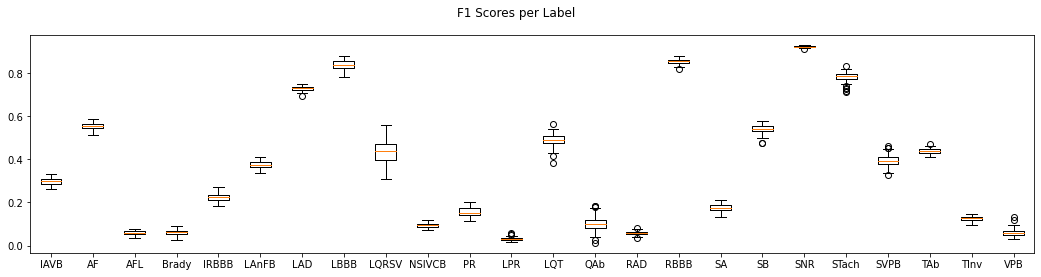

In [14]:
# construct and display the boxplot
x_ticks = []
bp_data = []
for k, v in f1_box_plot_data.items():
    bp_data.append(v)
    x_ticks.append(k)

fig, ax = plt.subplots(figsize=(18, 4))
fig.suptitle("F1 Scores per Label")
ax.boxplot(bp_data)
ax.set_xticklabels(x_ticks)
plt.show()

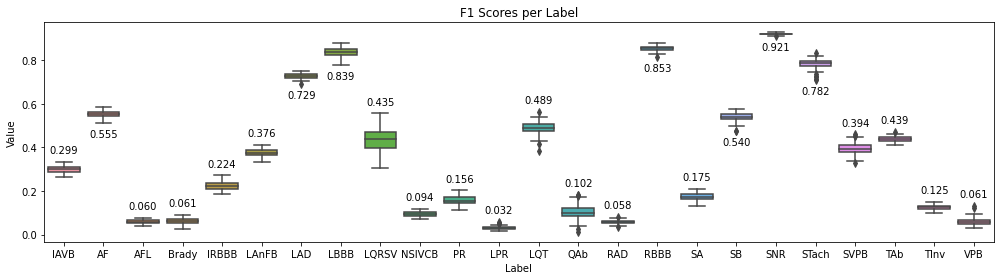

In [15]:
# construct and display the boxplot
box_plot_dict = {"Label": [], "Value": []}
mean_dict = {}
for k, v in f1_box_plot_data.items():
    box_plot_dict["Label"] += [k,] * len(v)
    box_plot_dict["Value"] += v
    mean_dict[k] = np.mean(v)

bp_df = pd.DataFrame(box_plot_dict)
fig, ax = plt.subplots(figsize=(14, 4))
ax = sns.boxplot(x="Label", y="Value", data=bp_df, ax=ax)

# print(mean_dict)

for label_idx, xtick in enumerate(ax.get_xticklabels()):
    xtick_name = xtick.get_text()
    val_output = f"{mean_dict[xtick_name]:.3f}"
    y_offset = mean_dict[xtick_name]
    
    if y_offset >= 0.5:
        y_offset = min(f1_box_plot_data[xtick_name]) - 0.03
        va="top"
    else:
        y_offset = max(f1_box_plot_data[xtick_name]) + 0.03
        va="bottom"
    
    ax.annotate(
        val_output,
        xy=(label_idx, mean_dict[xtick_name]),
        xytext=(label_idx, y_offset),
        horizontalalignment="center",
        verticalalignment=va
    )

ax.set_title("F1 Scores per Label")
plt.tight_layout()

plt.savefig(os.path.join(output_folder, "label_f1s.png"), bbox_inches="tight", dpi=300)
plt.show()

# Feature Importance Per Label

For each label, roughly what are the most important features?

In [ ]:

feat_importance_data = {}

for experiment_fp in experiment_fps:
    print(f"{experiment_fp} results...")
    experiment = joblib.load(experiment_fp)
    train_records = experiment.pop("train_records")
    eval_records = experiment.pop("eval_records")

    for sc in scored_codes:
        abbrv, dx = SNOMED_CODE_MAP[str(sc)]
        
        try:
            model = experiment[str(sc)]
        except KeyError:
            model = experiment[int(sc)]
        
        feat_importance_data[abbrv] = feat_importance_data.get(abbrv, []) + [model.feature_importances_]


In [ ]:
# average all of the importances for all classifiers and all labels?
all_importances = []
for label, v in feat_importance_data.items():
    ft_data = np.stack(v)
    all_importances.append(ft_data)

importances = np.concatenate(all_importances, axis=0)

print("importances.shape", importances.shape)
mean_importances = np.mean(importances, axis=0)

all_importances_rank = importances.argsort(axis=1)
importances_reciprocal_rank = 1 / (all_importances_rank + 1)
rank_importances = np.mean(importances_reciprocal_rank, axis=0)


import json
importance_data = {}
importance_data["rank_importances"] = dict(zip(header[1:], rank_importances.tolist()))
importance_data["sorted_keys"] = sorted(importance_data["rank_importances"].keys(), key=lambda x:importance_data["rank_importances"][x], reverse=True)
importance_data["mean_importances"] = dict(zip(header[1:], mean_importances.tolist()))
importance_data["mean_sorted_keys"] = sorted(importance_data["mean_importances"].keys(), key=lambda x:importance_data["mean_importances"][x], reverse=True)

with open(os.path.join(output_folder, "importances_rank.json"), "w") as f:
    json.dump(importance_data, f)


In [ ]:
for k, v in feat_importance_data.items():    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(f"Feature Importances for {k}")

    ft_data = np.stack(v)
    
    ft_df = pd.DataFrame(data=ft_data, columns=header[1:])

    meds = ft_df.median()
    meds.sort_values(ascending=True, inplace=True)
    
    meds = meds.tail(20)
    
    ft_df = ft_df[meds.index]
        
    result = ft_df.boxplot(vert=False, ax=ax, return_type="dict")

    for line in result["medians"]:
        x, y = line.get_xydata()[1] # top of the median line
        ax.text(x, y, "%.2E" % x, fontsize=9, horizontalalignment="left", verticalalignment="top")
    
    ax.set_xscale("log")
    
    plt.show()
    
    #ax.boxplot(ft_data, labels=to_features, vert=False)
    #ax.set_xticklabels(x_ticks)
    
    #plt.show()
    #print(np.stack(v, axis=1).shape)    

# Challenge Evaluation Summary Outputs

In [ ]:
mean_dict
dxms = pd.read_csv("evaluation-2020/dx_mapping_scored.csv")
dxms

In [ ]:
# quick pearson r stat test
totals = {}
a = []
b = []
for k, v in mean_dict.items():
    if k == "VEB":
        k = "VPB"
    t = dxms[dxms["Abbreviation"] == k]["Total"].to_numpy()[0]
#     ratio = t / 43101
#     print(t, ratio)
    totals[k] = t
    a.append(v)
    b.append(t)

# print(a)
# print(b)
print(sp.stats.pearsonr(a, b))

In [ ]:
print("neg_cor", sp.stats.pearsonr(range(10), range(10, 0, -1)))
print("pos_cor", sp.stats.pearsonr(range(10), range(0,10, 1)))
print("no_cor", sp.stats.pearsonr(range(10), [4, 5,] * 5))


In [ ]:
# for k in ['auroc', 'auprc', 'accuracy', 'f_measure', 
#           'f_beta_measure', 'g_beta_measure', 'challenge_metric']:
#     print(f"{model_data[k]:>10.3f}")

    
# print("AUROC | AUPRC | Accuracy | F-measure | Fbeta-measure | Gbeta-measure | Challenge metric")
# print(f"{model_data['auroc']:>5.3f} |"
#       f" {model_data['auprc']:>5.3f} |"
#       f" {model_data['accuracy']:>8.3f} |"
#       f" {model_data['f_measure']:>9.3f} |"
#       f" {model_data['f_beta_measure']:>13.3f} |"
#       f" {model_data['g_beta_measure']:>13.3f} |"
#       f" {model_data['challenge_metric']:>16.3f}")


## MED-ARC Training Times

- on 96 parallel cores, used approximately 220 GiB RAM
- each process requires ~2.3GiB of RAM
- takes roughly ~80 seconds to process one record (at 96 parallel cores, one record can be extracted per second)

- classifier training, takes approximately 60-65GiB (sequential classifier training)
    - experiment with parallel classifier training using separate GPU per label
    - GPU RAM usage relatively low (2900MiB), but 100% GPU utilization

In [ ]:
43101 / 60 / 60

In [ ]:
(43101 /2 * 80) / 60 / 60